In [1]:
# Stefan M. Mladjenovic - PhD Candidate at University of Toronto in Biomedical Engineering
# Three-dimensional Electron Microscopy for Nanoparticles in Tumours
# February 27 2024

In [1]:
#import packages necessary for importing and viewing data
from skimage import io
import matplotlib.pyplot as plt
import matplotlib as mpl
import mpl_toolkits.axisartist as axisartist
import numpy as np
import skimage
import pandas as pd
import gc
import seaborn as sns
from tqdm import tqdm
import scipy
import tifffile
import os
import imagecodecs # added for ome-tif 3D cell comparison

from statannot import add_stat_annotation #Nov 28 2023

import string # Jan 16 2024 for x-tick labels on bar chart

In [ ]:
#before this step, the nanoparticles are isolated from the aligned 3D EM stack
# using the random forest pixel classifier in LabKit (FIJI) and post-processed to remove noise (1px spots)

# read in np connected component analysis with unique ID file via skimage
#updated NPs after post-processing to remove 1px noise
np_unique = io.imread("C:/Users/Z6/Desktop/3DSEM/Stefan/1.AT/2.June20_v4_final-fr-with-vess2-small-408R/11.analysis-aligned/2.NP-extract/2.CCA-each-NP/label3-good/segmented-output+watershed_clean+CCA-32bit.tif", plugin="tifffile")

#view annotated dataset
plt.imshow(np_unique[0],cmap='gist_ncar') #first slice of annotated z-stack
plt.show()

In [ ]:
#get centroid of each unique NP in dataframe
# gives error if I don't convert from float32 to uint32

num_z_slices = np_unique.shape[0]

all_dataframes_np_unique_list = []

for z_slice in tqdm(range(num_z_slices)):
    roi_properties = skimage.measure.regionprops_table(label_image=np_unique.astype(np.uint32)[z_slice, :, :], #added '[frame, :, :]' after annotated
                                                       #intensity_image=dataset[z_slice, :, :],
                                                       properties=("label", "centroid"),
                                                       separator=",",
                                                       extra_properties=None,)
    dataframe_current_frame = pd.DataFrame(roi_properties)
    dataframe_current_frame['z-slice'] = z_slice
    all_dataframes_np_unique_list.append(dataframe_current_frame)

all_dataframes_np_unique_concat = pd.concat(all_dataframes_np_unique_list)


print(all_dataframes_np_unique_concat.head())

In [ ]:
#round off values to closest bit and change values to 16 bit
all_dataframes_np_unique_concat['centroid,0_16bit'] = all_dataframes_np_unique_concat['centroid,0'].apply(np.ceil).astype(np.uint16)
all_dataframes_np_unique_concat['centroid,1_16bit'] = all_dataframes_np_unique_concat['centroid,1'].apply(np.ceil).astype(np.uint16)

In [ ]:
# save dataframe
all_dataframes_np_unique_concat.to_csv('df_unique-np-centroid-coords.csv', index=True, header=True, sep=',')


In [ ]:
# quick check to make sure each label only appears once:
    # check the max value in the array (final label)
    # check the number of unique values in the array
    # if these numbers are the same, then each label only appears once

all_dataframes_np_unique_concat = pd.read_csv('df_unique-np-centroid-coords.csv', index_col=0)
    

#print(all_dataframes_np_unique_concat['label']) # all values in label column only
#print()
print(np.max(all_dataframes_np_unique_concat['label']))
print()
print(len(all_dataframes_np_unique_concat['label']))


In [ ]:
# First create the new dataframe

#start analysis for 3D NP EDT here using images from 3D ImageJ Suite. 
    #the input images are from the annotated endothelial cell dataset. 
    #  each endothelial cell is isolated with thresholding in FIJI as a separate image stack

index_keep_ECs = [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34]

#read in dataframe
all_dataframes_np_unique_concat = pd.read_csv('df_unique-np-centroid-coords.csv', index_col=0)

#########


all_cell_labels = index_keep_ECs
# use these cell-labels as headers    
    # but first add a string 'cell-' as a prefix

#create empty list
all_cell_labels_headers = []

for cell_label in range(len(all_cell_labels)):
    all_cell_labels_headers.append("3D-EDT-to-cell-" + str(all_cell_labels[cell_label]) + "_nm")
    
    
print()
print(all_cell_labels_headers)

#########

# get all headers necessary for dataframe
# NP-label, all cell-x labels, lowest EDT of all cell-x labels, cell-x identity of the lowest EDT
    
list_all_headers = ["NP-label"] + all_cell_labels_headers + ["lowest-EDT_nm"] + ["cell-lowest-EDT"] + ['z-slice'] + ['centroid,0_16bit'] + ['centroid,1_16bit']
print(list_all_headers)


#########

#make new dataframe with these headers
#set length of dataframe to be the number of unique NP labels

#set length of index so can fill datafram with np.inf
#create the index (number of rows) for the dataframe. Should be as long as the number of unique NP labels
df_EDT_closest_cell_index = pd.RangeIndex(len(all_dataframes_np_unique_concat)) #add plus 1 here?

# create dataframe with data filled to infinity, index from above, columns are from above
df_EDT_closest_cell = pd.DataFrame(data = np.inf, index = df_EDT_closest_cell_index, columns = list_all_headers)

# the values in the dataframe get replaced with values as the script runs

#########

#set value of new column for 3D EDT to the 3D EDT value at the NP coordinates 
#by copying data from list 

df_EDT_closest_cell['NP-label'] = all_dataframes_np_unique_concat['label'].tolist()
df_EDT_closest_cell['z-slice'] = all_dataframes_np_unique_concat['z-slice'].tolist()
df_EDT_closest_cell['centroid,0_16bit'] = all_dataframes_np_unique_concat['centroid,0_16bit'].tolist()
df_EDT_closest_cell['centroid,1_16bit'] = all_dataframes_np_unique_concat['centroid,1_16bit'].tolist()


#########

#export csv for blank EDT with just headers EDT details
df_EDT_closest_cell.to_csv('df_EDT_headers.csv', index=True, header=True, sep=',')

df_EDT_closest_cell

In [ ]:
#using this script, determine the 3D Euclidean distance from each each EC (3D ImageJ Suite in FIJI) to each NP centroid
    #Before running this script we need the 3D EDT for each EC in the dataset
        # To get this dataset, in FIJI, I thresholded each of the individual EC cells and saved it as an 8-bit image. 
        # On each of these images of the individual 8bit ECs, I set the resolution (x/y=17nm/px and z=70nn)
            # this is important because Thomas Boudier's 3D Suite package respects anisotropy and calculated 3D EDT. 
            # Also, FIJI can use 100% CPU usage unlike Python (limited by GIL)
        # Then, I used 3D Suite to calculate the inversed 3D EDT for each images (32-bit image result). 
        # These 32-bit 3D suite images are used in this script to determine the EDT from each cell to each NP centroid

# all 3D Suite EDT 32bit Tiff files were saved to have the following name: 
    #3DSUITE-EDT_ECx, where x is the EC ID from index_keep_ECs


#read in dataframe to add to (if it exists). 
    #If the file does not exist, just use the above code-block to generate the empty dataframe for the variable: df_EDT_closest_cell
#hard-coded the name of the file here since I did ECs 13-17 from local  (C: drive) originally. 
    #Then moved the images to server for storage since the images are large (40GB each, 32-bit imgs).
    #also had some images saved on F: drive (i.e. external directory)

#re-run this script and change the files being read in once they have been added to the dataframe. 
    #because not enough space on C: drive to store all 3D EDT images for all endothelial cells
#df_EDT_closest_cell = pd.read_csv('df_EDT_headers.csv', index_col=0)
#df_EDT_closest_cell = pd.read_csv('df_EDT_7_18.csv', index_col=0)


for i in range(len(index_keep_ECs)):
    current_EDT_filename = "3DSUITE-EDT_EC"+ str(index_keep_ECs[i]) +".tif"
    current_column_name = "3D-EDT-to-cell-" + str(index_keep_ECs[i]) + "_nm"
    #print(current_EDT_filename)
    #print(current_column_name)
    
    #local directory
    #directory_path = os.path.join("C:/Users/Z6/Desktop/3DSEM/Stefan/1.AT/2.June20_v4_final-fr-with-vess2-small-408R/11.analysis-aligned/3.py/3D-EDT/2.each-EC-EDT/", current_EDT_filename)
    
    #external directory
    #directory_path = os.path.join("F:/3D-EDT-Jan4-2024/2.each-EC-EDT/", current_EDT_filename)
    #directory_path = os.path.join("F:/3D-EDT-Jan4-2024/1.each-EC/", current_EDT_filename)
    
    print(directory_path)

    #check if the respective EDT for the EC in question exists. Collect information in respective column if it exists
        #need to do this because each 3D EDT file is 40gb (32bit) and we can't fit all files in the local drive simultaneously
    if os.path.exists(directory_path):
        #print("exists")
        print(current_EDT_filename)
        print()
        
        #'''        
        
        #read in current 3D EDT for analysis. Can safely fit 1 image in RAM at once. Update variable with new EC 3D EDT on each loop
            #32-bit 3D EDT from FIJI 3D Suite: 
        
        #check if the variable exists and delete it if it does. This is because in Python the previous variable gets deleted after the new one is loaded into memory
            # so you can imagine that when a 40gb image is in memory, the second 40gb image is loaded in (total of 80gb RAM required) before the first 40gb is deleted and reducing the total RAM usage back to 40gb
        
        if 'EDT_3D' in locals():
            del EDT_3D
        
        EDT_3D = io.imread(directory_path, plugin="tifffile")
    
        #get shape of 1 slice of dataset
        z_shape, y_shape, x_shape = EDT_3D.shape # can use annotated or annotated_EC_only here, 1 less variable to need if I use annotated_EC_only

        
        #set value of new column for 3D EDT to the 3D EDT value at the NP coordinates 
        for each_np in tqdm(range(len(df_EDT_closest_cell))): 
            each_np_plus_1 = each_np+1
            #if each_np ==0:
            #    pass

            
            #all_df_EDT_combined['3D-EDT-from-EC'][each_np] = EDT_3D[current_np_coords_set] # gives error, see: https://stackoverflow.com/questions/20625582/how-to-deal-with-settingwithcopywarning-in-pandas
            #use this with .loc, still gives error, but proceed anyway because output is correct

            #get coordinates of NP with unique value
            #********* need to update z_slice since the dataframe is empty?
                #see: df_unique-np-centroid-coords.csv
            
            z_slice_np = df_EDT_closest_cell['z-slice'].loc[df_EDT_closest_cell['NP-label'] == each_np_plus_1].values[0]
            y_coord_np = df_EDT_closest_cell['centroid,0_16bit'].loc[df_EDT_closest_cell['NP-label'] == each_np_plus_1].values[0]
            x_coord_np = df_EDT_closest_cell['centroid,1_16bit'].loc[df_EDT_closest_cell['NP-label'] == each_np_plus_1].values[0]

            #get coords as a set
            #needed to nest the values as int for some reason to avoid error
            current_np_coords_set = int(z_slice_np), int(y_coord_np) , int(x_coord_np)

            #set value for current column name
                
            df_EDT_closest_cell.loc[each_np,current_column_name] = EDT_3D[current_np_coords_set]  
    
        print("completed: ",current_EDT_filename)
        #'''
    
    #if the file is not currently in the local drive, then don't do anything
    if not os.path.exists(directory_path):
        pass
        #print("does not exist")
        

In [ ]:
#export csv with current EDT details
    #once appropriate images are done being processed into dataframe, comment the cell out
#df_EDT_closest_cell.to_csv('df_EDT_headers.csv', index=True, header=True, sep=',')
#df_EDT_closest_cell.to_csv('df_EDT_13_18.csv', index=True, header=True, sep=',')
#df_EDT_closest_cell.to_csv('df_EDT_7_18.csv', index=True, header=True, sep=',')
#df_EDT_closest_cell.to_csv('df_EDT_25.csv', index=True, header=True, sep=',')
#df_EDT_closest_cell.to_csv('df_EDT_all-cells.csv', index=True, header=True, sep=',')


In [ ]:
# now determine the minimum intensity value of the row for the NP
    #this represents the shortest distance

#do not use for-loop --> it is very inefficient. Use apply with lambda list comprehension instead. 
    
#read in dataframe
df_EDT_closest_cell = pd.read_csv('df_EDT_all-cells.csv', index_col=0)

#get the lowest EDT nm value for each row when only considering  the part of the dataframe that has columns that match the headers
    #need to only consider columns within the headers, otherwise, will get an inaccurate number for example can get a value of 0 for when z-slice=0 in the same row
df_EDT_closest_cell['lowest-EDT_nm'] = df_EDT_closest_cell[all_cell_labels_headers].min(axis=1)

#for each row, get the column name which matches the lowest-EDT_nm value. Store this in the column 'cell-lowest-EDT'

#long-name of column only
#df_EDT_closest_cell['cell-lowest-EDT'] = df_EDT_closest_cell.loc[:,all_cell_labels_headers].isin(df_EDT_closest_cell['lowest-EDT_nm']).idxmax(1)

#cell name of the column (alternative) using lambda after getting the long-name of column using indexing

#get long name    
df_EDT_closest_cell['cell-lowest-EDT'] = df_EDT_closest_cell.loc[:,all_cell_labels_headers].isin(df_EDT_closest_cell['lowest-EDT_nm']).idxmax(1)
#get index of string

#print(all_cell_labels_headers.index('3D-EDT-to-cell-8_nm'))
#print(index_keep_ECs[all_cell_labels_headers.index('3D-EDT-to-cell-8_nm')])

df_EDT_closest_cell['cell-lowest-EDT'] = df_EDT_closest_cell['cell-lowest-EDT'].apply(lambda row: index_keep_ECs[all_cell_labels_headers.index(row)])


#save file
#df_EDT_closest_cell.to_csv('df_EDT_all-cells_complete.csv', index=True, header=True, sep=',')
#comment out to prevent overwrite

In [ ]:
#morphometric data analysis begins here

In [ ]:
#below is the calculations and details for morphometric calculations

# Surface Area (SA) calculations:

# to do: count the number of each pixel for each material/index in the outline SA image throughout whole z-stack
    # then multiply by 70nm (~4.11px = 70nm; because 1px = 17nm)

# did image pre-processing for SA in FIJI
# see folder: C:\Users\Z6\Desktop\3DSEM\Stefan\1.AT\2.June20_v4_final-fr-with-vess2-small-408R\8.MIB\1.two-vessel\render-model\1.Oct21-2023\2.outline-for-SA\output
# result is here as image: z-stack-annotated_outline.tif

# the fiji IJM script is: SA-each-object-slice.ijm 
# fiji IJM script is here: C:\Users\Z6\Desktop\3DSEM\Stefan\1.AT\2.June20_v4_final-fr-with-vess2-small-408R\8.MIB\1.two-vessel\render-model\1.Oct21-2023\2.outline-for-SA


#SA and Volume calculations are pretty much the same. All you have to do is count the number of pixels of each value
    # for the annotated (vol) and annotated-perimeter (SA) dataset

#updated annotated dataset from Dec 19 2023 clean-up
annotated = io.imread("C:/Users/Z6/Desktop/3DSEM/Stefan/1.AT/2.June20_v4_final-fr-with-vess2-small-408R/10.ishaan-align/2.MIB-model/4.Dec19-2023-clean-mask/filled7-mask_updated-slice7_Dec19-update.tif", plugin="tifffile")


# read in annotated dataset perimeter for calculating SA

#updated annotated perimeter dataset from Dec 19 2023 clean-up
annotated_perimeter = io.imread("C:/Users/Z6/Desktop/3DSEM/Stefan/1.AT/2.June20_v4_final-fr-with-vess2-small-408R/11.analysis-aligned/1.Perimeter;SA/perimeter_aligned_Dec19-2023.tif", plugin="tifffile")



In [8]:
# read in annotated dataset file via skimage

#updated annotated dataset from Dec 19 2023 clean-up
annotated = io.imread("C:/Users/Z6/Desktop/3DSEM/Stefan/1.AT/2.June20_v4_final-fr-with-vess2-small-408R/10.ishaan-align/2.MIB-model/4.Dec19-2023-clean-mask/filled7-mask_updated-slice7_Dec19-update.tif", plugin="tifffile")

#view annotated dataset
plt.imshow(annotated[6],cmap='gist_ncar') #first slice of annotated z-stack
plt.show()


In [10]:
# read in watershed nanoparticles
    #this is nps_unique as it has undergone connected component analysis (CCA) in FIJI to label each NP with different ID

# use new NP file from December 19 2023
np_unique = io.imread("C:/Users/Z6/Desktop/3DSEM/Stefan/1.AT/2.June20_v4_final-fr-with-vess2-small-408R/11.analysis-aligned/2.NP-extract/2.CCA-each-NP/label3-good/segmented-output+watershed_clean+CCA-32bit.tif", plugin="tifffile")

#view NPs dataset
plt.imshow(np_unique[0],cmap='gist_stern') #first slice of annotated z-stack
plt.show()

In [11]:
#create index of endothelial and non-endothelial cells in the dataset
index_keep_ECs = [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34]
index_remove_non_ECs = [1, 2, 3, 4, 5, 6, 26, 35] # accidentally had label 19 inside before

In [12]:
print(len(index_keep_ECs)) # there are 27 ECs to keep

27


In [13]:
#view annotated dataset
annotated[0] #first slice of annotated z-stack

#get a numpy array with only the EC cells inside (remove non-EC cell annotations)

# this converts to binary however... we need the original values intact
EC_only_annotated_binary = np.isin(annotated, index_keep_ECs) 

In [21]:
#convert boolean to integer by multiplying true/false by 1 (integer)

EC_only_annotated_binary_int_8bit = (EC_only_annotated_binary * 1).astype(np.uint8) # because less than 256 cells

#convert to 8-bit since by default the boolean gets convert to 32-bit 

In [14]:
#can create annotated_EC_only by multiplying the annotated array by EC_only_annotated_binary
    #easiest way to do this is to element-wise multiply the 0 and 1 EC-only numpy array by the numpy array with all values (annotated, including non-ECs).
    # will be a value of 0 for anywhere there is no EC (i.e. where EC_only_annotated_binary has value of 0)
    # undesired cells will be removed as they are multiplied by 0
    # this will have the full values for annotated but only for the EC subset

annotated_EC_only = np.multiply(annotated, EC_only_annotated_binary_int_8bit)

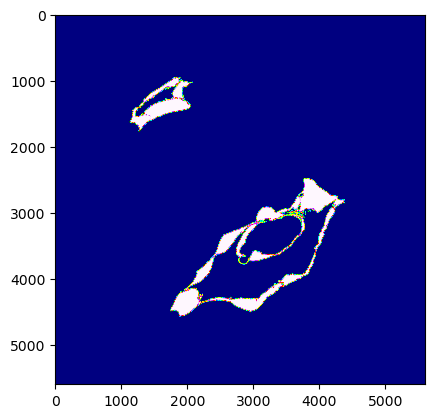

In [15]:
#view EC-only binary dataset
plt.imshow(EC_only_annotated_binary_int_8bit[0],cmap='gist_ncar') #first slice of annotated z-stack
plt.show()

In [23]:
#free up RAM
#import gc

del EC_only_annotated_binary
del EC_only_annotated_binary_int
gc.collect()


8485

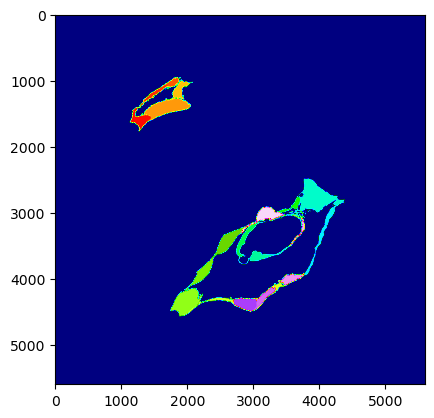

In [25]:
#view first slice of annotated dataset with only ECs 
plt.imshow(annotated_EC_only[0],cmap='gist_ncar') #first slice of annotated z-stack
plt.show()

#looks good. cannot see RBCs for example, but the colours are back, not binary

In [26]:
#save EC_only_annotated_int as a tif file for importing


#for some reason couldn't save annotated_EC_only with mimwrite, but tifffile worked
#use BigTiff
# Convert to 8 bit before saving
#error: data too large for standard TIFF file
# likely because data is bigger than 4gb

#already saved this image, so comment out for now

#import tifffile
tifffile.imwrite('new_num_annotated_EC_only_8bit.tif', annotated_EC_only.astype(np.uint8), bigtiff=True,)
tifffile.imwrite('new_binary_annotated_EC_only_8bit.tif', EC_only_annotated_binary_int_8bit.astype(np.uint8), bigtiff=True,)


#this now works
#looks good in FIJI


In [27]:
# get intensity data of each slice for each cell - version 4
    # but rename dataframe now with diameter suffix because will add diameter numbers to this same dataframe in later part of script
    # *** new Nov 24, getting area too. use this for volume calculations. 
        # Need to repeat same analysis on perimeter only file to get surface area values

    
#dataset = io.imread("C:/Users/Z6/Desktop/3DSEM/Stefan/1.AT/2.June20_v4_final-fr-with-vess2-small-408R/10.ishaan-align/3.data-update-145/update-145_dataset_fine_ome.tif", plugin="tifffile")
#annotated = io.imread("C:/Users/Z6/Desktop/3DSEM/Stefan/1.AT/2.June20_v4_final-fr-with-vess2-small-408R/10.ishaan-align/2.MIB-model/4.Dec19-2023-clean-mask/filled7-mask_updated-slice7_Dec19-update.tif", plugin="tifffile")


#doing region props on each slice of dataset (each index of z-dimension)
    
all_dataframes_concat_diameter = pd.DataFrame() #reset dataframe for when doing testing
    
num_z_slices = annotated.shape[0]

all_dataframes_list = []
for z_slice in tqdm(range(num_z_slices)):
    roi_properties = skimage.measure.regionprops_table(label_image=annotated[z_slice, :, :], #added '[frame, :, :]' after annotated
                                                       intensity_image=dataset[z_slice, :, :],
                                                       properties=(
                                                           'label', 
                                                           'mean_intensity',
                                                           #'axis_major_length',
                                                           #'axis_minor_length',
                                                           #'equivalent_diameter_area',
                                                           'area',
                                                       ),
                                                       separator=",",
                                                       extra_properties=None,)
    dataframe_current_frame = pd.DataFrame(roi_properties)
    dataframe_current_frame['z-slice'] = z_slice
    all_dataframes_list.append(dataframe_current_frame)

all_dataframes_concat_diameter = pd.concat(all_dataframes_list)
all_dataframes_concat_diameter['intensity'] = all_dataframes_concat_diameter['mean_intensity'].astype(np.uint16)

#use surface area on each slice to get volume of each label on each slice
all_dataframes_concat_diameter['volume_um3'] = all_dataframes_concat_diameter['area']*(17*17*70)/(1000*1000*1000) #17nm/pixel; 70nm = z depth. 1000nm = 1um. but volume, not length, so cube. 1 nm^2 = 1/(1000*1000*1000) um^3

#print(all_dataframes_concat.head())

100%|████████████████████████████████████████████████████████████████████████████████| 342/342 [00:58<00:00,  5.82it/s]


In [28]:
# add a column for the overall index. 
all_dataframes_concat_diameter.insert(1, 'index_manual', range(len(all_dataframes_concat_diameter)))

In [29]:
all_dataframes_concat_diameter.head(40)

label  index_manual  mean_intensity      area  z-slice  intensity  \
0       2             0      148.989227  240414.0        0        148   
1       7             1      189.024586   48687.0        0        189   
2       8             2      169.589450  187541.0        0        169   
3       9             3      185.832617   38839.0        0        185   
4      10             4      164.249552   45798.0        0        164   
5      11             5      189.508928   21561.0        0        189   
6      13             6      164.950678   72017.0        0        164   
7      14             7      162.465813   51248.0        0        162   
8      15             8      181.265027  113826.0        0        181   
9      16             9      144.104130   13704.0        0        144   
10     17            10      154.454645   36699.0        0        154   
11     18            11      140.374757    2060.0        0        140   
12     21            12      161.056636   39021.0        0        161   
13     22            13      176.414080  120467.0        0        176   
14     23            14      198.601211   18496.0        0        198   
15     24            15      163.176678   26885.0        0        163   
16     25            16      167.872287   44279.0        0        167   
17     26            17      149.159427    4190.0        0        149   
18     29            18      170.735124   52753.0        0        170   
19     30            19      189.595616   35083.0        0        189   
20     31            20      175.061269   32594.0        0        175   
21     32            21      180.965317   12398.0        0        180   
22     33            22      191.938298   53775.0        0        191   
23     34            23      182.313538    5961.0        0        182   
24     35            24      152.078371  101326.0        0        152   
0       2            25      141.856333  239804.0        1        141   
1       7            26      190.206541   50784.0        1        190   
2       8            27      165.381407  185138.0        1        165   
3       9            28      184.300697   39475.0        1        184   
4      10            29      161.156369   47861.0        1        161   
5      11            30      190.183273   21307.0        1        190   
6      13            31      164.265682   73283.0        1        164   
7      14            32      155.684936   50777.0        1        155   
8      15            33      175.199136  113229.0        1        175   
9      16            34      135.108987   15901.0        1        135   
10     17            35      150.883170   37088.0        1        150   
11     18            36      124.438903    2406.0        1        124   
12     21            37      142.893237   40145.0        1        142   
13     22            38      164.721859  120572.0        1        164   
14     23            39      192.049125   17486.0        1        192   

    volume_um3  
0     4.863575  
1     0.984938  
2     3.793954  
3     0.785713  
4     0.926494  
5     0.436179  
6     1.456904  
7     1.036747  
8     2.302700  
9     0.277232  
10    0.742421  
11    0.041674  
12    0.789395  
13    2.437047  
14    0.374174  
15    0.543884  
16    0.895764  
17    0.084764  
18    1.067193  
19    0.709729  
20    0.659377  
21    0.250812  
22    1.087868  
23    0.120591  
24    2.049825  
0     4.851235  
1     1.027360  
2     3.745342  
3     0.798579  
4     0.968228  
5     0.431041  
6     1.482515  
7     1.027219  
8     2.290623  
9     0.321677  
10    0.750290  
11    0.048673  
12    0.812133  
13    2.439172  
14    0.353742

In [556]:
#see data for only ECs
all_dataframes_concat_diameter[all_dataframes_concat_diameter['label'].isin(index_keep_ECs)]

label  index_manual  mean_intensity      area  z-slice  intensity  \
1       7             1      189.024586   48687.0        0        189   
2       8             2      169.589450  187541.0        0        169   
3       9             3      185.832617   38839.0        0        185   
4      10             4      164.249552   45798.0        0        164   
5      11             5      189.508928   21561.0        0        189   
..    ...           ...             ...       ...      ...        ...   
7      21          6499      207.316078    1642.0      341        207   
8      22          6500      192.582927     820.0      341        192   
9      25          6501      184.112554     231.0      341        184   
10     27          6502      140.519343   60255.0      341        140   
11     28          6503      161.972157   81743.0      341        161   

    volume_um3  surface_area  surface_area_um2  axis_major_length  \
1     0.984938        3271.0           3.89249        1275.947337   
2     3.793954        5256.0           6.25464         653.449849   
3     0.785713        1955.0           2.32645         631.229849   
4     0.926494        3026.0           3.60094         736.459835   
5     0.436179        1241.0           1.47679         425.321940   
..         ...           ...               ...                ...   
7     0.033218           NaN               NaN         106.844145   
8     0.016589           NaN               NaN          53.054268   
9     0.004673           NaN               NaN          20.166541   
10    1.218959           NaN               NaN         984.264948   
11    1.653661           NaN               NaN         703.569895   

    axis_minor_length  feret_diameter_max  equivalent_diameter_area  \
1           68.773128         1116.281774                248.978340   
2          465.636525          895.272026                487.014252   
3          144.609624          672.209045                222.376597   
4          211.085617          745.413308                241.478415   
5          123.069496          389.313498                165.687410   
..                ...                 ...                       ...   
7           22.148891          107.540690                 44.208853   
8           21.689615           51.788030                 32.311862   
9           14.687019           21.400935                 17.149879   
10         334.987442         1074.966976                275.978108   
11         174.151505          858.065848                315.284566   

    feret_diameter_max_nm  feret_diameter_max_um  
1            18976.790166              18.976790  
2            15219.624437              15.219624  
3            11427.553763              11.427554  
4            12672.026239              12.672026  
5             6618.329472               6.618329  
..                    ...                    ...  
7             1828.191730               1.828192  
8              880.396502               0.880397  
9              363.815888               0.363816  
10           18274.438596              18.274439  
11           14587.119421              14.587119  

[5818 rows x 15 columns]

In [ ]:
#Jan 11 2024
#at this point, should remove the bad slices if for non-morphometric data
# for mean-intensity, should remove bad slices since this will change the data 
    #i.e. data will be biased if the annotation covers a region with black pixels or where the tissue is folded


In [32]:
#read in dataset after it has already been processed in later steps. 
    #need to read in now in order to visualize below graphs without recalculating the saved values
all_dataframes_concat_diameter= pd.read_csv('df_mean-intensity-per-slice+all_diameter+SA+VOL.csv',index_col=0)


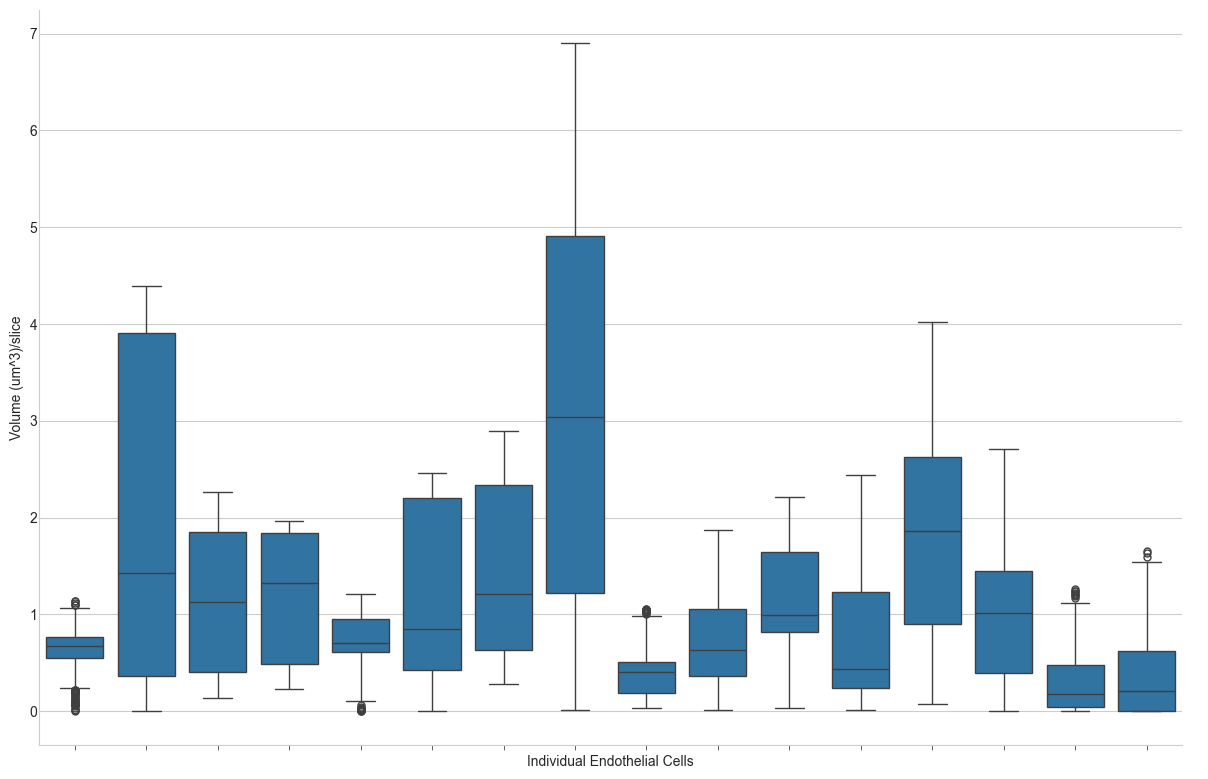

In [47]:
#visualize results - volume (um^3) for each label on each slice


#make a new list that removes the small cells that don't span the dataset
index_keep_ECs_good = [7, 8, 10, 13, 14, 15, 16, 17, 18, 20, 21, 22, 24, 25, 27, 28, 29, 30, 32]
index_keep_ECs_good2 = [7, 8, 10, 13, 14, 15, 16, 17, 18, 20, 21, 22, 24, 25, 27, 28]

#ECs only
#ax = sns.catplot(data=all_dataframes_concat_diameter[all_dataframes_concat_diameter['label'].isin(index_keep_ECs], x='label',y='volume_um3', kind='box', height = 8, aspect = 1.5)
#ax = sns.catplot(data=all_dataframes_concat_diameter[all_dataframes_concat_diameter['label'].isin(index_keep_ECs_good)], x='label',y='volume_um3', kind='box', height = 8, aspect = 1.5)
ax = sns.catplot(data=all_dataframes_concat_diameter[all_dataframes_concat_diameter['label'].isin(index_keep_ECs_good2)], x='label',y='volume_um3', kind='box', height = 8, aspect = 1.5)


#specfiy axis labels
ax.set(xlabel='Individual Endothelial Cells',
       ylabel='Volume (um^3)/slice',
      )

#ax.set_xticklabels(xticklabels_letters)
ax.set_xticklabels([]) #remove tick labels

ax.tick_params(left=False, bottom=True, width=0.5)  # add vertical tick lines

#display histogram
plt.show()


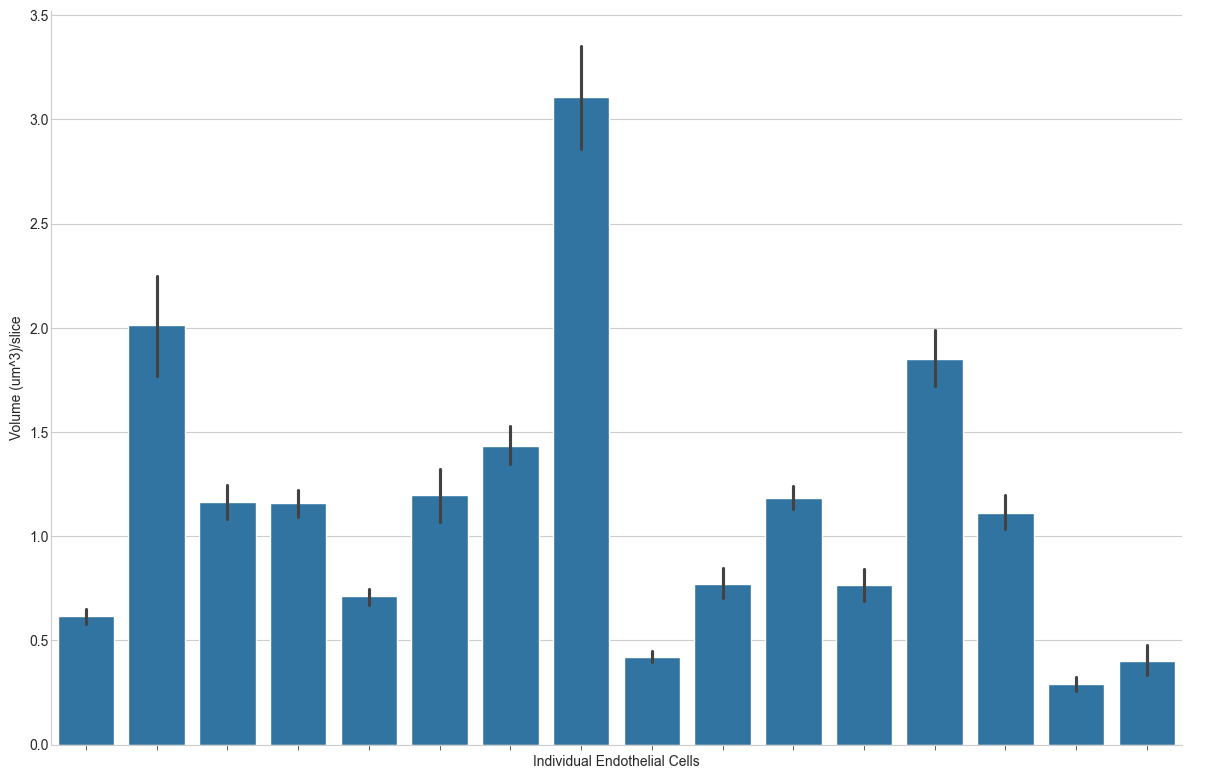

In [46]:
#visualize results - volume (um^3) for each label on each slice

index_keep_ECs_good = [7, 8, 10, 13, 14, 15, 16, 17, 18, 20, 21, 22, 24, 25, 27, 28, 29, 30, 32]
index_keep_ECs_good2 = [7, 8, 10, 13, 14, 15, 16, 17, 18, 20, 21, 22, 24, 25, 27, 28]

#ax = sns.catplot(data=all_dataframes_concat_diameter, x='label', y='volume_um3', kind='bar', height = 8, aspect = 1.5)
#ECs only

#ax = sns.catplot(data=all_dataframes_concat_diameter[all_dataframes_concat_diameter['label'].isin(index_keep_ECs)], x='label',y='volume_um3', kind='bar', height = 8, aspect = 1.5)
#ax = sns.catplot(data=all_dataframes_concat_diameter[all_dataframes_concat_diameter['label'].isin(index_keep_ECs_good)], x='label',y='volume_um3', kind='bar', height = 8, aspect = 1.5)
ax = sns.catplot(data=all_dataframes_concat_diameter[all_dataframes_concat_diameter['label'].isin(index_keep_ECs_good2)], x='label',y='volume_um3', kind='bar', height = 8, aspect = 1.5)


#ax.set_xticklabels(xticklabels_letters)
ax.set_xticklabels([]) #remove tick labels

ax.tick_params(left=False, bottom=True, width=0.5)  # add vertical tick lines

#specfiy axis labels
ax.set(xlabel='Individual Endothelial Cells',
       ylabel='Volume (um^3)/slice',
      )

#display histogram
plt.show()


In [472]:
#get surface area per slice using annotated_perimeter file

annotated_perimeter = io.imread("C:/Users/Z6/Desktop/3DSEM/Stefan/1.AT/2.June20_v4_final-fr-with-vess2-small-408R/11.analysis-aligned/1.Perimeter;SA/perimeter_aligned_Dec19-2023.tif", plugin="tifffile")


In [34]:
#DOING SURFACE AREA HERE BY USING THE PERIMETER FILE (ALL CELLS)

#use update files for December 19 2023 annotation + annotation_perimeter

#dataset = io.imread("C:/Users/Z6/Desktop/3DSEM/Stefan/1.AT/2.June20_v4_final-fr-with-vess2-small-408R/10.ishaan-align/3.data-update-145/update-145_dataset_fine_ome.tif", plugin="tifffile")
#annotated = io.imread("C:/Users/Z6/Desktop/3DSEM/Stefan/1.AT/2.June20_v4_final-fr-with-vess2-small-408R/10.ishaan-align/2.MIB-model/4.Dec19-2023-clean-mask/filled7-mask_updated-slice7_Dec19-update.tif", plugin="tifffile")
#annotated_perimeter = io.imread("C:/Users/Z6/Desktop/3DSEM/Stefan/1.AT/2.June20_v4_final-fr-with-vess2-small-408R/11.analysis-aligned/1.Perimeter;SA/perimeter_aligned_Dec19-2023.tif", plugin="tifffile")


#add new columns as empty to dataframe
#new_column_headers_diameter = ['axis_major_length','axis_minor_length','feret_diameter_max','equivalent_diameter_area']


all_dataframes_concat_diameter = all_dataframes_concat_diameter.reindex(columns = all_dataframes_concat_diameter.columns.tolist() + ['surface_area','surface_area_um2'])
 
from skimage.measure import label 
    
#num_z_slices = annotated_perimeter.shape[0] #use annotated_perimeter instead of annotated


for each_row in tqdm(range(0,len(all_dataframes_concat_diameter))):
    
    #set regionmask to be the current slice of perimeter_annotated dataset
    regionmask = annotated_perimeter[all_dataframes_concat_diameter['z-slice'].iloc[each_row].astype(int)] #need to put astype int, otherwise turns to float at index 27
    #print(all_dataframes_concat_diameter['z-slice'].iloc[each_row].astype(int))
    
    #make empty regionmask with dimensions of first slice of array (all x/y dimensions of array are the same for the whole array)
    regionmask_current = np.zeros(annotated_perimeter[0].shape, dtype=np.uint8)

    #get the current label of the row
    current_label = all_dataframes_concat_diameter['label'].iloc[each_row].astype(int)

    # set value to 1 for indices/places where regionmask == current label
    np.place(regionmask_current, regionmask == current_label, 1)

    # DO NOT GET THE CONNECTED COMPONENT. WE WANT THE SA OF ALL PIECES OF THE PERIMETER ON EACH SLICE
    #get the largest connected component (CC) for the current label on the current slice
    #labels = label(regionmask_current)


    roi_surface_area = skimage.measure.regionprops_table(
                                                    label_image=regionmask_current, #added '[frame, :, :]' after annotated
                                                    #intensity_image=dataset[z_slice, :, :],
                                                    properties=(
                                                        'area',
                                                    ),
                                                    separator=",",
                                                    extra_properties=None,
                                                    )

        

    #catch errors when there is no surface area (for example, label 28 on row 4137, also row 4609)
    if len(roi_surface_area['area']) >0:
        print(each_row, current_label, roi_surface_area['area'], len(roi_surface_area['area']))
        all_dataframes_concat_diameter.iloc[each_row,all_dataframes_concat_diameter.columns.get_loc('surface_area')] = roi_surface_area['area'][0]
        all_dataframes_concat_diameter.iloc[each_row,all_dataframes_concat_diameter.columns.get_loc('surface_area_um2')] = roi_surface_area['area'][0]*(17*70)/(1000*1000) #17nm/pixel; 70nm = z depth. 1000nm = 1um. but surface area, not length, so square. 1 nm^2 = 1/(1000*1000) um^2
    #set value to 0 if there is an error
    else:
        print("error: ", each_row, current_label, roi_surface_area['area'], len(roi_surface_area['area']))
        all_dataframes_concat_diameter.iloc[each_row,all_dataframes_concat_diameter.columns.get_loc('surface_area')] = 0
        all_dataframes_concat_diameter.iloc[each_row,all_dataframes_concat_diameter.columns.get_loc('surface_area_um2')] = 0    
    
    #just use loc with index_manual as index_manual are unique
    

  0%|                                                                                 | 2/6506 [00:00<15:15,  7.10it/s]

0 2 [7635.] 1
1 7 [3271.] 1


  0%|                                                                                 | 4/6506 [00:00<14:36,  7.42it/s]

2 8 [5669.] 1
3 9 [1955.] 1


  0%|                                                                                 | 6/6506 [00:00<14:42,  7.37it/s]

4 10 [3138.] 1
5 11 [1241.] 1


  0%|                                                                                 | 8/6506 [00:01<14:44,  7.35it/s]

6 13 [2202.] 1
7 14 [1903.] 1


  0%|                                                                                | 10/6506 [00:01<14:47,  7.32it/s]

8 15 [2346.] 1
9 16 [3810.] 1


  0%|▏                                                                               | 12/6506 [00:01<14:30,  7.46it/s]

10 17 [4652.] 1
11 18 [530.] 1


  0%|▏                                                                               | 14/6506 [00:01<14:57,  7.23it/s]

12 21 [2536.] 1
13 22 [2501.] 1


  0%|▏                                                                               | 16/6506 [00:02<14:59,  7.22it/s]

14 23 [956.] 1
15 24 [2344.] 1


  0%|▏                                                                               | 18/6506 [00:02<14:37,  7.39it/s]

16 25 [1793.] 1
17 26 [797.] 1


  0%|▏                                                                               | 20/6506 [00:02<14:42,  7.35it/s]

18 29 [1258.] 1
19 30 [1800.] 1


  0%|▎                                                                               | 22/6506 [00:03<14:49,  7.29it/s]

20 31 [1394.] 1
21 32 [1437.] 1


  0%|▎                                                                               | 24/6506 [00:03<14:45,  7.32it/s]

22 33 [1538.] 1
23 34 [909.] 1


  0%|▎                                                                               | 26/6506 [00:03<14:45,  7.32it/s]

24 35 [1920.] 1
25 2 [7414.] 1


  0%|▎                                                                               | 28/6506 [00:03<14:59,  7.20it/s]

26 7 [3229.] 1
27 8 [5444.] 1


  0%|▎                                                                               | 30/6506 [00:04<14:39,  7.36it/s]

28 9 [1957.] 1
29 10 [3049.] 1


  0%|▍                                                                               | 32/6506 [00:04<15:00,  7.19it/s]

30 11 [1264.] 1
31 13 [2249.] 1


  1%|▍                                                                               | 34/6506 [00:04<14:37,  7.37it/s]

32 14 [1971.] 1
33 15 [2348.] 1


  1%|▍                                                                               | 36/6506 [00:04<14:58,  7.20it/s]

34 16 [3928.] 1
35 17 [4754.] 1


  1%|▍                                                                               | 38/6506 [00:05<14:54,  7.23it/s]

36 18 [565.] 1
37 21 [2439.] 1


  1%|▍                                                                               | 40/6506 [00:05<14:34,  7.40it/s]

38 22 [2599.] 1
39 23 [970.] 1


  1%|▌                                                                               | 42/6506 [00:05<14:37,  7.36it/s]

40 24 [2290.] 1
41 25 [1839.] 1


  1%|▌                                                                               | 44/6506 [00:06<14:37,  7.36it/s]

42 26 [793.] 1
43 29 [1313.] 1


  1%|▌                                                                               | 46/6506 [00:06<14:40,  7.34it/s]

44 30 [1687.] 1
45 31 [1440.] 1


  1%|▌                                                                               | 48/6506 [00:06<14:39,  7.34it/s]

46 32 [1460.] 1
47 33 [1586.] 1


  1%|▌                                                                               | 50/6506 [00:06<14:39,  7.34it/s]

48 34 [918.] 1
49 35 [1757.] 1


  1%|▋                                                                               | 52/6506 [00:07<14:59,  7.17it/s]

50 2 [7597.] 1
51 7 [3156.] 1


  1%|▋                                                                               | 54/6506 [00:07<14:55,  7.21it/s]

52 8 [5460.] 1
53 9 [1948.] 1


  1%|▋                                                                               | 56/6506 [00:07<14:33,  7.38it/s]

54 10 [3071.] 1
55 11 [1247.] 1


  1%|▋                                                                               | 58/6506 [00:07<14:36,  7.36it/s]

56 13 [2200.] 1
57 14 [1969.] 1


  1%|▋                                                                               | 60/6506 [00:08<14:35,  7.36it/s]

58 15 [2228.] 1
59 16 [3759.] 1


  1%|▊                                                                               | 62/6506 [00:08<14:35,  7.36it/s]

60 17 [4688.] 1
61 18 [500.] 1


  1%|▊                                                                               | 64/6506 [00:08<14:42,  7.30it/s]

62 21 [2382.] 1
63 22 [2566.] 1


  1%|▊                                                                               | 66/6506 [00:09<14:55,  7.19it/s]

64 23 [1087.] 1
65 24 [2258.] 1


  1%|▊                                                                               | 68/6506 [00:09<14:54,  7.20it/s]

66 25 [1921.] 1
67 26 [763.] 1


  1%|▊                                                                               | 70/6506 [00:09<15:03,  7.12it/s]

68 29 [1350.] 1
69 30 [1742.] 1


  1%|▉                                                                               | 72/6506 [00:09<14:43,  7.29it/s]

70 31 [1389.] 1
71 32 [1469.] 1


  1%|▉                                                                               | 74/6506 [00:10<14:56,  7.17it/s]

72 33 [1566.] 1
73 34 [901.] 1


  1%|▉                                                                               | 76/6506 [00:10<15:13,  7.04it/s]

74 35 [1752.] 1
75 2 [7757.] 1


  1%|▉                                                                               | 78/6506 [00:10<14:54,  7.18it/s]

76 7 [3139.] 1
77 8 [5744.] 1


  1%|▉                                                                               | 80/6506 [00:10<14:49,  7.22it/s]

78 9 [1977.] 1
79 10 [3141.] 1


  1%|█                                                                               | 82/6506 [00:11<14:35,  7.34it/s]

80 11 [1257.] 1
81 13 [2216.] 1


  1%|█                                                                               | 84/6506 [00:11<14:10,  7.55it/s]

82 14 [1968.] 1
83 15 [2131.] 1


  1%|█                                                                               | 86/6506 [00:11<14:41,  7.28it/s]

84 16 [3870.] 1
85 17 [4643.] 1


  1%|█                                                                               | 88/6506 [00:12<14:27,  7.40it/s]

86 18 [537.] 1
87 21 [2298.] 1


  1%|█                                                                               | 90/6506 [00:12<14:44,  7.26it/s]

88 22 [2647.] 1
89 23 [1172.] 1


  1%|█▏                                                                              | 92/6506 [00:12<14:27,  7.40it/s]

90 24 [2289.] 1
91 25 [1969.] 1


  1%|█▏                                                                              | 94/6506 [00:12<14:17,  7.48it/s]

92 26 [765.] 1
93 29 [1301.] 1


  1%|█▏                                                                              | 96/6506 [00:13<14:27,  7.39it/s]

94 30 [1724.] 1
95 31 [1481.] 1


  2%|█▏                                                                              | 98/6506 [00:13<14:49,  7.20it/s]

96 32 [1545.] 1
97 33 [1658.] 1


  2%|█▏                                                                             | 100/6506 [00:13<14:29,  7.37it/s]

98 34 [834.] 1
99 35 [1721.] 1


  2%|█▏                                                                             | 102/6506 [00:13<14:53,  7.17it/s]

100 2 [7919.] 1
101 7 [3151.] 1


  2%|█▎                                                                             | 104/6506 [00:14<14:45,  7.23it/s]

102 8 [5867.] 1
103 9 [1907.] 1


  2%|█▎                                                                             | 106/6506 [00:14<14:19,  7.45it/s]

104 10 [3192.] 1
105 11 [1256.] 1


  2%|█▎                                                                             | 108/6506 [00:14<14:13,  7.50it/s]

106 13 [2243.] 1
107 14 [1972.] 1


  2%|█▎                                                                             | 110/6506 [00:15<14:41,  7.25it/s]

108 15 [2261.] 1
109 16 [3770.] 1


  2%|█▎                                                                             | 112/6506 [00:15<14:55,  7.14it/s]

110 17 [4651.] 1
111 18 [538.] 1


  2%|█▍                                                                             | 114/6506 [00:15<14:15,  7.47it/s]

112 21 [2279.] 1
113 22 [2664.] 1


  2%|█▍                                                                             | 116/6506 [00:15<14:42,  7.24it/s]

114 23 [1126.] 1
115 24 [2248.] 1


  2%|█▍                                                                             | 118/6506 [00:16<14:23,  7.40it/s]

116 25 [2001.] 1
117 26 [833.] 1


  2%|█▍                                                                             | 120/6506 [00:16<14:28,  7.35it/s]

118 29 [1328.] 1
119 30 [1723.] 1


  2%|█▍                                                                             | 122/6506 [00:16<14:17,  7.44it/s]

120 31 [1484.] 1
121 32 [1516.] 1


  2%|█▌                                                                             | 124/6506 [00:16<14:13,  7.48it/s]

122 33 [1773.] 1
123 34 [809.] 1


  2%|█▌                                                                             | 126/6506 [00:17<14:23,  7.39it/s]

124 35 [1713.] 1
125 2 [7768.] 1


  2%|█▌                                                                             | 128/6506 [00:17<14:26,  7.36it/s]

126 7 [3135.] 1
127 8 [5636.] 1


  2%|█▌                                                                             | 130/6506 [00:17<14:30,  7.32it/s]

128 9 [1887.] 1
129 10 [3364.] 1


  2%|█▌                                                                             | 132/6506 [00:18<14:19,  7.42it/s]

130 11 [1279.] 1
131 13 [2391.] 1


  2%|█▋                                                                             | 134/6506 [00:18<14:22,  7.39it/s]

132 14 [2019.] 1
133 15 [2227.] 1


  2%|█▋                                                                             | 136/6506 [00:18<14:21,  7.39it/s]

134 16 [3760.] 1
135 17 [4871.] 1


  2%|█▋                                                                             | 138/6506 [00:18<14:27,  7.34it/s]

136 18 [583.] 1
137 21 [2255.] 1


  2%|█▋                                                                             | 140/6506 [00:19<14:25,  7.35it/s]

138 22 [2627.] 1
139 23 [1105.] 1


  2%|█▋                                                                             | 142/6506 [00:19<14:45,  7.18it/s]

140 24 [2460.] 1
141 25 [2033.] 1


  2%|█▋                                                                             | 144/6506 [00:19<14:37,  7.25it/s]

142 26 [875.] 1
143 29 [1320.] 1


  2%|█▊                                                                             | 146/6506 [00:19<14:21,  7.38it/s]

144 30 [1684.] 1
145 31 [1398.] 1


  2%|█▊                                                                             | 148/6506 [00:20<14:23,  7.36it/s]

146 32 [1556.] 1
147 33 [1770.] 1


  2%|█▊                                                                             | 150/6506 [00:20<14:24,  7.35it/s]

148 34 [768.] 1
149 35 [1721.] 1


  2%|█▊                                                                             | 152/6506 [00:20<14:27,  7.33it/s]

150 2 [7843.] 1
151 7 [3213.] 1


  2%|█▊                                                                             | 154/6506 [00:21<14:26,  7.33it/s]

152 8 [5701.] 1
153 9 [1929.] 1


  2%|█▉                                                                             | 156/6506 [00:21<14:27,  7.32it/s]

154 10 [3398.] 1
155 11 [1263.] 1


  2%|█▉                                                                             | 158/6506 [00:21<14:12,  7.44it/s]

156 13 [2556.] 1
157 14 [1974.] 1


  2%|█▉                                                                             | 160/6506 [00:21<14:25,  7.34it/s]

158 15 [2246.] 1
159 16 [3551.] 1


  2%|█▉                                                                             | 162/6506 [00:22<14:11,  7.45it/s]

160 17 [5064.] 1
161 18 [558.] 1


  3%|█▉                                                                             | 164/6506 [00:22<14:38,  7.22it/s]

162 21 [2201.] 1
163 22 [2621.] 1


  3%|██                                                                             | 166/6506 [00:22<14:04,  7.51it/s]

164 23 [1078.] 1
165 24 [2565.] 1


  3%|██                                                                             | 168/6506 [00:22<14:15,  7.41it/s]

166 25 [2067.] 1
167 26 [1000.] 1


  3%|██                                                                             | 170/6506 [00:23<14:21,  7.35it/s]

168 29 [1438.] 1
169 30 [1683.] 1


  3%|██                                                                             | 172/6506 [00:23<13:45,  7.67it/s]

170 31 [1500.] 1
171 32 [1659.] 1


  3%|██                                                                             | 174/6506 [00:23<13:49,  7.64it/s]

172 33 [1740.] 1
173 34 [737.] 1


  3%|██▏                                                                            | 176/6506 [00:24<14:33,  7.24it/s]

174 35 [1685.] 1
175 2 [7901.] 1


  3%|██▏                                                                            | 178/6506 [00:24<14:37,  7.21it/s]

176 7 [3245.] 1
177 8 [5658.] 1


  3%|██▏                                                                            | 180/6506 [00:24<14:15,  7.39it/s]

178 9 [1879.] 1
179 10 [3499.] 1


  3%|██▏                                                                            | 182/6506 [00:24<14:24,  7.31it/s]

180 11 [1344.] 1
181 13 [2558.] 1


  3%|██▏                                                                            | 184/6506 [00:25<14:24,  7.31it/s]

182 14 [1966.] 1
183 15 [2286.] 1


  3%|██▎                                                                            | 186/6506 [00:25<14:31,  7.25it/s]

184 16 [3562.] 1
185 17 [5216.] 1


  3%|██▎                                                                            | 188/6506 [00:25<14:10,  7.43it/s]

186 18 [637.] 1
187 21 [2214.] 1


  3%|██▎                                                                            | 190/6506 [00:25<14:19,  7.35it/s]

188 22 [2687.] 1
189 23 [1048.] 1


  3%|██▎                                                                            | 192/6506 [00:26<14:24,  7.31it/s]

190 24 [2658.] 1
191 25 [2183.] 1


  3%|██▎                                                                            | 194/6506 [00:26<14:12,  7.41it/s]

192 26 [1078.] 1
193 29 [1429.] 1


  3%|██▍                                                                            | 196/6506 [00:26<14:02,  7.49it/s]

194 30 [1622.] 1
195 31 [1382.] 1


  3%|██▍                                                                            | 198/6506 [00:27<14:11,  7.41it/s]

196 32 [1559.] 1
197 33 [1749.] 1


  3%|██▍                                                                            | 200/6506 [00:27<14:17,  7.35it/s]

198 34 [756.] 1
199 35 [1756.] 1


  3%|██▍                                                                            | 202/6506 [00:27<14:16,  7.36it/s]

200 2 [7881.] 1
201 7 [3219.] 1


  3%|██▍                                                                            | 204/6506 [00:27<14:07,  7.44it/s]

202 8 [5737.] 1
203 9 [1875.] 1


  3%|██▌                                                                            | 206/6506 [00:28<14:12,  7.39it/s]

204 10 [3606.] 1
205 11 [1327.] 1


  3%|██▌                                                                            | 208/6506 [00:28<14:34,  7.21it/s]

206 13 [2465.] 1
207 14 [1999.] 1


  3%|██▌                                                                            | 210/6506 [00:28<14:02,  7.47it/s]

208 15 [2192.] 1
209 16 [3648.] 1


  3%|██▌                                                                            | 212/6506 [00:28<13:55,  7.54it/s]

210 17 [5213.] 1
211 18 [766.] 1


  3%|██▌                                                                            | 214/6506 [00:29<14:09,  7.41it/s]

212 21 [2266.] 1
213 22 [2581.] 1


  3%|██▌                                                                            | 216/6506 [00:29<14:12,  7.38it/s]

214 23 [1024.] 1
215 24 [2660.] 1


  3%|██▋                                                                            | 218/6506 [00:29<14:01,  7.48it/s]

216 25 [2091.] 1
217 26 [1106.] 1


  3%|██▋                                                                            | 220/6506 [00:30<14:11,  7.38it/s]

218 29 [1359.] 1
219 30 [1580.] 1


  3%|██▋                                                                            | 222/6506 [00:30<14:02,  7.46it/s]

220 31 [1393.] 1
221 32 [1541.] 1


  3%|██▋                                                                            | 224/6506 [00:30<13:50,  7.56it/s]

222 33 [1704.] 1
223 34 [740.] 1


  3%|██▋                                                                            | 226/6506 [00:30<14:20,  7.30it/s]

224 35 [1744.] 1
225 2 [7774.] 1


  4%|██▊                                                                            | 228/6506 [00:31<14:26,  7.24it/s]

226 7 [3217.] 1
227 8 [5480.] 1


  4%|██▊                                                                            | 230/6506 [00:31<14:25,  7.25it/s]

228 9 [1855.] 1
229 10 [3675.] 1


  4%|██▊                                                                            | 232/6506 [00:31<14:08,  7.39it/s]

230 11 [1379.] 1
231 13 [2435.] 1


  4%|██▊                                                                            | 234/6506 [00:31<14:01,  7.46it/s]

232 14 [2047.] 1
233 15 [2332.] 1


  4%|██▊                                                                            | 236/6506 [00:32<14:07,  7.40it/s]

234 16 [3791.] 1
235 17 [5409.] 1


  4%|██▉                                                                            | 238/6506 [00:32<14:23,  7.26it/s]

236 18 [757.] 1
237 21 [2364.] 1


  4%|██▉                                                                            | 240/6506 [00:32<14:07,  7.40it/s]

238 22 [2501.] 1
239 23 [1080.] 1


  4%|██▉                                                                            | 242/6506 [00:33<14:26,  7.23it/s]

240 24 [2917.] 1
241 25 [1893.] 1


  4%|██▉                                                                            | 244/6506 [00:33<14:21,  7.27it/s]

242 26 [1056.] 1
243 29 [1366.] 1


  4%|██▉                                                                            | 246/6506 [00:33<14:02,  7.43it/s]

244 30 [1601.] 1
245 31 [1392.] 1


  4%|███                                                                            | 248/6506 [00:33<13:57,  7.47it/s]

246 32 [1453.] 1
247 33 [1877.] 1


  4%|███                                                                            | 250/6506 [00:34<14:19,  7.28it/s]

248 34 [748.] 1
249 35 [1702.] 1


  4%|███                                                                            | 252/6506 [00:34<14:38,  7.12it/s]

250 2 [7935.] 1
251 7 [3063.] 1


  4%|███                                                                            | 254/6506 [00:34<14:01,  7.43it/s]

252 8 [5647.] 1
253 9 [1853.] 1


  4%|███                                                                            | 256/6506 [00:34<14:06,  7.38it/s]

254 10 [3732.] 1
255 11 [1399.] 1


  4%|███▏                                                                           | 258/6506 [00:35<14:10,  7.34it/s]

256 13 [2379.] 1
257 14 [2089.] 1


  4%|███▏                                                                           | 260/6506 [00:35<14:12,  7.33it/s]

258 15 [2267.] 1
259 16 [3706.] 1


  4%|███▏                                                                           | 262/6506 [00:35<13:57,  7.46it/s]

260 17 [5509.] 1
261 18 [725.] 1


  4%|███▏                                                                           | 264/6506 [00:35<13:52,  7.50it/s]

262 21 [2311.] 1
263 22 [2496.] 1


  4%|███▏                                                                           | 266/6506 [00:36<14:17,  7.28it/s]

264 23 [1106.] 1
265 24 [2761.] 1


  4%|███▎                                                                           | 268/6506 [00:36<13:58,  7.44it/s]

266 25 [1998.] 1
267 26 [963.] 1


  4%|███▎                                                                           | 270/6506 [00:36<14:06,  7.37it/s]

268 29 [1353.] 1
269 30 [1595.] 1


  4%|███▎                                                                           | 272/6506 [00:37<14:09,  7.34it/s]

270 31 [1400.] 1
271 32 [1470.] 1


  4%|███▎                                                                           | 274/6506 [00:37<14:12,  7.31it/s]

272 33 [1844.] 1
273 34 [654.] 1


  4%|███▎                                                                           | 276/6506 [00:37<13:56,  7.45it/s]

274 35 [1695.] 1
275 2 [6834.] 1


  4%|███▍                                                                           | 278/6506 [00:37<14:15,  7.28it/s]

276 7 [2927.] 1
277 8 [4734.] 1


  4%|███▍                                                                           | 280/6506 [00:38<14:19,  7.24it/s]

278 9 [1776.] 1
279 10 [3553.] 1


  4%|███▍                                                                           | 282/6506 [00:38<14:17,  7.26it/s]

280 11 [1358.] 1
281 13 [2102.] 1


  4%|███▍                                                                           | 284/6506 [00:38<13:46,  7.53it/s]

282 14 [1940.] 1
283 15 [1959.] 1


  4%|███▍                                                                           | 286/6506 [00:38<13:56,  7.43it/s]

284 16 [3081.] 1
285 17 [5120.] 1


  4%|███▍                                                                           | 288/6506 [00:39<14:02,  7.38it/s]

286 18 [674.] 1
287 21 [2171.] 1


  4%|███▌                                                                           | 290/6506 [00:39<14:04,  7.36it/s]

288 22 [2286.] 1
289 23 [1020.] 1


  4%|███▌                                                                           | 292/6506 [00:39<14:07,  7.33it/s]

290 24 [2426.] 1
291 25 [1656.] 1


  5%|███▌                                                                           | 294/6506 [00:40<13:56,  7.42it/s]

292 26 [905.] 1
293 29 [1289.] 1


  5%|███▌                                                                           | 296/6506 [00:40<14:01,  7.38it/s]

294 30 [1535.] 1
295 31 [1226.] 1


  5%|███▌                                                                           | 298/6506 [00:40<13:59,  7.39it/s]

296 32 [1400.] 1
297 33 [1717.] 1


  5%|███▋                                                                           | 300/6506 [00:40<14:11,  7.29it/s]

298 34 [623.] 1
299 35 [1618.] 1


  5%|███▋                                                                           | 302/6506 [00:41<14:26,  7.16it/s]

300 2 [7506.] 1
301 7 [3050.] 1


  5%|███▋                                                                           | 304/6506 [00:41<14:14,  7.26it/s]

302 8 [5589.] 1
303 9 [1855.] 1


  5%|███▋                                                                           | 306/6506 [00:41<13:53,  7.44it/s]

304 10 [3634.] 1
305 11 [1482.] 1


  5%|███▋                                                                           | 308/6506 [00:41<14:03,  7.35it/s]

306 13 [2140.] 1
307 14 [2010.] 1


  5%|███▊                                                                           | 310/6506 [00:42<14:08,  7.30it/s]

308 15 [2343.] 1
309 16 [3731.] 1


  5%|███▊                                                                           | 312/6506 [00:42<13:51,  7.45it/s]

310 17 [5861.] 1
311 18 [706.] 1


  5%|███▊                                                                           | 314/6506 [00:42<13:45,  7.50it/s]

312 21 [2207.] 1
313 22 [2413.] 1


  5%|███▊                                                                           | 316/6506 [00:43<13:53,  7.42it/s]

314 23 [1022.] 1
315 24 [2865.] 1


  5%|███▊                                                                           | 318/6506 [00:43<14:04,  7.33it/s]

316 25 [1979.] 1
317 26 [953.] 1


  5%|███▉                                                                           | 320/6506 [00:43<13:50,  7.45it/s]

318 29 [1369.] 1
319 30 [1538.] 1


  5%|███▉                                                                           | 322/6506 [00:43<14:02,  7.34it/s]

320 31 [1335.] 1
321 32 [1616.] 1


  5%|███▉                                                                           | 324/6506 [00:44<14:01,  7.34it/s]

322 33 [1909.] 1
323 34 [606.] 1


  5%|███▉                                                                           | 326/6506 [00:44<14:28,  7.11it/s]

324 35 [1819.] 1
325 2 [7600.] 1


  5%|███▉                                                                           | 328/6506 [00:44<14:07,  7.29it/s]

326 7 [3004.] 1
327 8 [5701.] 1


  5%|████                                                                           | 330/6506 [00:44<14:06,  7.29it/s]

328 9 [1853.] 1
329 10 [3679.] 1


  5%|████                                                                           | 332/6506 [00:45<14:08,  7.28it/s]

330 11 [1452.] 1
331 13 [2092.] 1


  5%|████                                                                           | 334/6506 [00:45<14:11,  7.25it/s]

332 14 [1986.] 1
333 15 [2243.] 1


  5%|████                                                                           | 336/6506 [00:45<14:06,  7.29it/s]

334 16 [3421.] 1
335 17 [5827.] 1


  5%|████                                                                           | 338/6506 [00:46<14:07,  7.28it/s]

336 18 [703.] 1
337 21 [2165.] 1


  5%|████▏                                                                          | 340/6506 [00:46<13:53,  7.40it/s]

338 22 [2361.] 1
339 23 [1026.] 1


  5%|████▏                                                                          | 342/6506 [00:46<13:52,  7.40it/s]

340 24 [2890.] 1
341 25 [2388.] 1


  5%|████▏                                                                          | 344/6506 [00:46<13:46,  7.46it/s]

342 26 [992.] 1
343 29 [1382.] 1


  5%|████▏                                                                          | 346/6506 [00:47<13:59,  7.34it/s]

344 30 [1488.] 1
345 31 [1376.] 1


  5%|████▏                                                                          | 348/6506 [00:47<14:22,  7.14it/s]

346 32 [1651.] 1
347 33 [1820.] 1


  5%|████▏                                                                          | 350/6506 [00:47<13:55,  7.37it/s]

348 34 [594.] 1
349 35 [1872.] 1


  5%|████▎                                                                          | 352/6506 [00:47<14:13,  7.21it/s]

350 2 [7257.] 1
351 7 [2963.] 1


  5%|████▎                                                                          | 354/6506 [00:48<14:18,  7.17it/s]

352 8 [5812.] 1
353 9 [1928.] 1


  5%|████▎                                                                          | 356/6506 [00:48<14:07,  7.25it/s]

354 10 [3667.] 1
355 11 [1476.] 1


  6%|████▎                                                                          | 358/6506 [00:48<14:04,  7.28it/s]

356 13 [2215.] 1
357 14 [1985.] 1


  6%|████▎                                                                          | 360/6506 [00:49<13:47,  7.43it/s]

358 15 [2379.] 1
359 16 [3139.] 1


  6%|████▍                                                                          | 362/6506 [00:49<13:54,  7.36it/s]

360 17 [5649.] 1
361 18 [709.] 1


  6%|████▍                                                                          | 364/6506 [00:49<13:38,  7.51it/s]

362 21 [2238.] 1
363 22 [2377.] 1


  6%|████▍                                                                          | 366/6506 [00:49<13:47,  7.42it/s]

364 23 [1108.] 1
365 24 [2973.] 1


  6%|████▍                                                                          | 368/6506 [00:50<13:51,  7.38it/s]

366 25 [2091.] 1
367 26 [1025.] 1


  6%|████▍                                                                          | 370/6506 [00:50<13:59,  7.31it/s]

368 29 [1338.] 1
369 30 [1460.] 1


  6%|████▌                                                                          | 372/6506 [00:50<13:42,  7.46it/s]

370 31 [1368.] 1
371 32 [1694.] 1


  6%|████▌                                                                          | 374/6506 [00:50<13:39,  7.48it/s]

372 33 [1972.] 1
373 34 [594.] 1


  6%|████▌                                                                          | 376/6506 [00:51<13:53,  7.35it/s]

374 35 [1802.] 1
375 2 [7405.] 1


  6%|████▌                                                                          | 378/6506 [00:51<13:51,  7.37it/s]

376 7 [2930.] 1
377 8 [5987.] 1


  6%|████▌                                                                          | 380/6506 [00:51<14:01,  7.28it/s]

378 9 [1882.] 1
379 10 [3699.] 1


  6%|████▋                                                                          | 382/6506 [00:52<14:01,  7.27it/s]

380 11 [1424.] 1
381 13 [2289.] 1


  6%|████▋                                                                          | 384/6506 [00:52<13:58,  7.30it/s]

382 14 [2021.] 1
383 15 [2462.] 1


  6%|████▋                                                                          | 386/6506 [00:52<13:56,  7.32it/s]

384 16 [3152.] 1
385 17 [5448.] 1


  6%|████▋                                                                          | 388/6506 [00:52<13:57,  7.31it/s]

386 18 [703.] 1
387 21 [2232.] 1


  6%|████▋                                                                          | 390/6506 [00:53<13:45,  7.41it/s]

388 22 [2404.] 1
389 23 [1164.] 1


  6%|████▊                                                                          | 392/6506 [00:53<14:05,  7.23it/s]

390 24 [3311.] 1
391 25 [2054.] 1


  6%|████▊                                                                          | 394/6506 [00:53<13:49,  7.37it/s]

392 26 [1011.] 1
393 29 [1312.] 1


  6%|████▊                                                                          | 396/6506 [00:53<13:41,  7.44it/s]

394 30 [1349.] 1
395 31 [1344.] 1


  6%|████▊                                                                          | 398/6506 [00:54<13:48,  7.38it/s]

396 32 [1646.] 1
397 33 [2173.] 1


  6%|████▊                                                                          | 400/6506 [00:54<13:32,  7.51it/s]

398 34 [565.] 1
399 35 [1752.] 1


  6%|████▉                                                                          | 402/6506 [00:54<13:57,  7.29it/s]

400 2 [7183.] 1
401 7 [2918.] 1


  6%|████▉                                                                          | 404/6506 [00:55<14:02,  7.24it/s]

402 8 [6109.] 1
403 9 [1888.] 1


  6%|████▉                                                                          | 406/6506 [00:55<14:01,  7.25it/s]

404 10 [3583.] 1
405 11 [1424.] 1


  6%|████▉                                                                          | 408/6506 [00:55<13:38,  7.45it/s]

406 13 [2527.] 1
407 14 [2028.] 1


  6%|████▉                                                                          | 410/6506 [00:55<13:44,  7.39it/s]

408 15 [2337.] 1
409 16 [3038.] 1


  6%|█████                                                                          | 412/6506 [00:56<13:47,  7.36it/s]

410 17 [5669.] 1
411 18 [705.] 1


  6%|█████                                                                          | 414/6506 [00:56<14:07,  7.19it/s]

412 21 [2226.] 1
413 22 [2354.] 1


  6%|█████                                                                          | 416/6506 [00:56<13:32,  7.49it/s]

414 23 [1044.] 1
415 24 [3178.] 1


  6%|█████                                                                          | 418/6506 [00:56<13:42,  7.40it/s]

416 25 [2138.] 1
417 26 [900.] 1


  6%|█████                                                                          | 420/6506 [00:57<13:50,  7.33it/s]

418 29 [1288.] 1
419 30 [1293.] 1


  6%|█████                                                                          | 422/6506 [00:57<13:31,  7.50it/s]

420 31 [1264.] 1
421 32 [1682.] 1


  7%|█████▏                                                                         | 424/6506 [00:57<13:41,  7.40it/s]

422 33 [2322.] 1
423 34 [422.] 1


  7%|█████▏                                                                         | 426/6506 [00:58<14:03,  7.21it/s]

424 35 [1582.] 1
425 2 [6918.] 1


  7%|█████▏                                                                         | 428/6506 [00:58<13:57,  7.26it/s]

426 7 [2991.] 1
427 8 [6429.] 1


  7%|█████▏                                                                         | 430/6506 [00:58<13:52,  7.30it/s]

428 9 [1864.] 1
429 10 [3613.] 1


  7%|█████▏                                                                         | 432/6506 [00:58<13:54,  7.27it/s]

430 11 [1415.] 1
431 13 [2472.] 1


  7%|█████▎                                                                         | 434/6506 [00:59<13:42,  7.39it/s]

432 14 [2082.] 1
433 15 [2398.] 1


  7%|█████▎                                                                         | 436/6506 [00:59<14:10,  7.14it/s]

434 16 [3008.] 1
435 17 [5523.] 1


  7%|█████▎                                                                         | 438/6506 [00:59<13:34,  7.45it/s]

436 18 [717.] 1
437 21 [2322.] 1


  7%|█████▎                                                                         | 440/6506 [00:59<13:41,  7.38it/s]

438 22 [2346.] 1
439 23 [933.] 1


  7%|█████▎                                                                         | 442/6506 [01:00<13:45,  7.35it/s]

440 24 [3350.] 1
441 25 [2078.] 1


  7%|█████▍                                                                         | 444/6506 [01:00<13:27,  7.51it/s]

442 26 [1009.] 1
443 29 [1270.] 1


  7%|█████▍                                                                         | 446/6506 [01:00<13:23,  7.54it/s]

444 30 [1241.] 1
445 31 [1156.] 1


  7%|█████▍                                                                         | 448/6506 [01:01<13:34,  7.44it/s]

446 32 [1693.] 1
447 33 [2218.] 1


  7%|█████▍                                                                         | 450/6506 [01:01<13:30,  7.47it/s]

448 34 [426.] 1
449 35 [1720.] 1


  7%|█████▍                                                                         | 452/6506 [01:01<13:35,  7.43it/s]

450 2 [6218.] 1
451 7 [2917.] 1


  7%|█████▌                                                                         | 454/6506 [01:01<13:43,  7.35it/s]

452 8 [6239.] 1
453 9 [1873.] 1


  7%|█████▌                                                                         | 456/6506 [01:02<13:49,  7.29it/s]

454 10 [3589.] 1
455 11 [1398.] 1


  7%|█████▌                                                                         | 458/6506 [01:02<13:49,  7.29it/s]

456 13 [2370.] 1
457 14 [2004.] 1


  7%|█████▌                                                                         | 460/6506 [01:02<13:33,  7.43it/s]

458 15 [1975.] 1
459 16 [2556.] 1


  7%|█████▌                                                                         | 462/6506 [01:02<13:40,  7.37it/s]

460 17 [4937.] 1
461 18 [717.] 1


  7%|█████▋                                                                         | 464/6506 [01:03<13:31,  7.45it/s]

462 21 [2284.] 1
463 22 [2287.] 1


  7%|█████▋                                                                         | 466/6506 [01:03<13:43,  7.34it/s]

464 23 [833.] 1
465 24 [3157.] 1


  7%|█████▋                                                                         | 468/6506 [01:03<13:31,  7.44it/s]

466 25 [1957.] 1
467 26 [999.] 1


  7%|█████▋                                                                         | 470/6506 [01:04<13:39,  7.37it/s]

468 29 [1167.] 1
469 30 [1206.] 1


  7%|█████▋                                                                         | 472/6506 [01:04<13:31,  7.44it/s]

470 31 [1070.] 1
471 32 [1682.] 1


  7%|█████▊                                                                         | 474/6506 [01:04<13:18,  7.56it/s]

472 33 [2216.] 1
473 34 [306.] 1


  7%|█████▊                                                                         | 476/6506 [01:04<13:35,  7.39it/s]

474 35 [1676.] 1
475 2 [7211.] 1


  7%|█████▊                                                                         | 478/6506 [01:05<13:39,  7.35it/s]

476 7 [3053.] 1
477 8 [6317.] 1


  7%|█████▊                                                                         | 480/6506 [01:05<13:41,  7.34it/s]

478 9 [1949.] 1
479 10 [3591.] 1


  7%|█████▊                                                                         | 482/6506 [01:05<13:28,  7.46it/s]

480 11 [1382.] 1
481 13 [2355.] 1


  7%|█████▉                                                                         | 484/6506 [01:05<13:36,  7.37it/s]

482 14 [1983.] 1
483 15 [2159.] 1


  7%|█████▉                                                                         | 486/6506 [01:06<13:43,  7.31it/s]

484 16 [2515.] 1
485 17 [4874.] 1


  8%|█████▉                                                                         | 488/6506 [01:06<13:46,  7.28it/s]

486 18 [733.] 1
487 21 [2190.] 1


  8%|█████▉                                                                         | 490/6506 [01:06<13:34,  7.39it/s]

488 22 [2323.] 1
489 23 [758.] 1


  8%|█████▉                                                                         | 492/6506 [01:06<13:42,  7.32it/s]

490 24 [3269.] 1
491 25 [1950.] 1


  8%|█████▉                                                                         | 494/6506 [01:07<13:27,  7.44it/s]

492 26 [874.] 1
493 29 [1164.] 1


  8%|██████                                                                         | 496/6506 [01:07<13:31,  7.40it/s]

494 30 [1239.] 1
495 31 [1100.] 1


  8%|██████                                                                         | 498/6506 [01:07<13:36,  7.35it/s]

496 32 [1735.] 1
497 33 [2071.] 1


  8%|██████                                                                         | 500/6506 [01:08<13:27,  7.44it/s]

498 34 [276.] 1
499 35 [1672.] 1


  8%|██████                                                                         | 502/6506 [01:08<14:00,  7.14it/s]

500 2 [6715.] 1
501 7 [3041.] 1


  8%|██████                                                                         | 504/6506 [01:08<13:35,  7.36it/s]

502 8 [6979.] 1
503 9 [1967.] 1


  8%|██████▏                                                                        | 506/6506 [01:08<13:39,  7.32it/s]

504 10 [3673.] 1
505 11 [1413.] 1


  8%|██████▏                                                                        | 508/6506 [01:09<13:39,  7.32it/s]

506 13 [2537.] 1
507 14 [2021.] 1


  8%|██████▏                                                                        | 510/6506 [01:09<13:52,  7.20it/s]

508 15 [2403.] 1
509 16 [2347.] 1


  8%|██████▏                                                                        | 512/6506 [01:09<13:35,  7.35it/s]

510 17 [5039.] 1
511 18 [864.] 1


  8%|██████▏                                                                        | 514/6506 [01:09<13:25,  7.44it/s]

512 21 [2230.] 1
513 22 [2295.] 1


  8%|██████▎                                                                        | 516/6506 [01:10<13:49,  7.22it/s]

514 23 [885.] 1
515 24 [3450.] 1


  8%|██████▎                                                                        | 518/6506 [01:10<13:24,  7.45it/s]

516 25 [2010.] 1
517 26 [953.] 1


  8%|██████▎                                                                        | 520/6506 [01:10<13:35,  7.34it/s]

518 29 [1123.] 1
519 30 [1238.] 1


  8%|██████▎                                                                        | 522/6506 [01:11<13:41,  7.29it/s]

520 31 [1144.] 1
521 32 [1638.] 1


  8%|██████▎                                                                        | 524/6506 [01:11<13:43,  7.26it/s]

522 33 [2128.] 1
523 34 [256.] 1


  8%|██████▍                                                                        | 526/6506 [01:11<13:39,  7.30it/s]

524 35 [1729.] 1
525 2 [7026.] 1


  8%|██████▍                                                                        | 528/6506 [01:11<13:52,  7.18it/s]

526 7 [3051.] 1
527 8 [7091.] 1


  8%|██████▍                                                                        | 530/6506 [01:12<13:58,  7.13it/s]

528 9 [1898.] 1
529 10 [3720.] 1


  8%|██████▍                                                                        | 532/6506 [01:12<13:49,  7.20it/s]

530 11 [1482.] 1
531 13 [2437.] 1


  8%|██████▍                                                                        | 534/6506 [01:12<13:31,  7.36it/s]

532 14 [2019.] 1
533 15 [2079.] 1


  8%|██████▌                                                                        | 536/6506 [01:12<13:32,  7.35it/s]

534 16 [2549.] 1
535 17 [4921.] 1


  8%|██████▌                                                                        | 538/6506 [01:13<13:34,  7.33it/s]

536 18 [878.] 1
537 21 [2241.] 1


  8%|██████▌                                                                        | 540/6506 [01:13<13:15,  7.50it/s]

538 22 [2358.] 1
539 23 [839.] 1


  8%|██████▌                                                                        | 542/6506 [01:13<13:29,  7.37it/s]

540 24 [3593.] 1
541 25 [2106.] 1


  8%|██████▌                                                                        | 544/6506 [01:14<13:18,  7.47it/s]

542 26 [916.] 1
543 29 [1057.] 1


  8%|██████▋                                                                        | 546/6506 [01:14<13:27,  7.38it/s]

544 30 [1184.] 1
545 31 [1137.] 1


  8%|██████▋                                                                        | 548/6506 [01:14<13:00,  7.63it/s]

546 32 [1556.] 1
547 33 [2015.] 1


  8%|██████▋                                                                        | 550/6506 [01:14<13:16,  7.48it/s]

548 34 [259.] 1
549 35 [1703.] 1


  8%|██████▋                                                                        | 552/6506 [01:15<13:24,  7.40it/s]

550 2 [6594.] 1
551 7 [2897.] 1


  9%|██████▋                                                                        | 554/6506 [01:15<13:46,  7.20it/s]

552 8 [7237.] 1
553 9 [1942.] 1


  9%|██████▊                                                                        | 556/6506 [01:15<13:13,  7.50it/s]

554 10 [3716.] 1
555 11 [1424.] 1


  9%|██████▊                                                                        | 558/6506 [01:15<13:32,  7.32it/s]

556 13 [2418.] 1
557 14 [2038.] 1


  9%|██████▊                                                                        | 560/6506 [01:16<13:20,  7.43it/s]

558 15 [2135.] 1
559 16 [2385.] 1


  9%|██████▊                                                                        | 562/6506 [01:16<13:25,  7.38it/s]

560 17 [4942.] 1
561 18 [876.] 1


  9%|██████▊                                                                        | 564/6506 [01:16<13:14,  7.47it/s]

562 21 [2388.] 1
563 22 [2262.] 1


  9%|██████▊                                                                        | 566/6506 [01:17<13:23,  7.39it/s]

564 23 [930.] 1
565 24 [3521.] 1


  9%|██████▉                                                                        | 568/6506 [01:17<13:27,  7.35it/s]

566 25 [2271.] 1
567 26 [921.] 1


  9%|██████▉                                                                        | 570/6506 [01:17<13:13,  7.48it/s]

568 27 [26.] 1
569 29 [1100.] 1


  9%|██████▉                                                                        | 572/6506 [01:17<13:22,  7.39it/s]

570 30 [1167.] 1
571 31 [1144.] 1


  9%|██████▉                                                                        | 574/6506 [01:18<13:13,  7.48it/s]

572 32 [1585.] 1
573 33 [2038.] 1


  9%|██████▉                                                                        | 576/6506 [01:18<13:36,  7.26it/s]

574 34 [261.] 1
575 35 [1744.] 1


  9%|███████                                                                        | 578/6506 [01:18<13:27,  7.34it/s]

576 2 [6782.] 1
577 7 [2909.] 1


  9%|███████                                                                        | 580/6506 [01:18<13:27,  7.34it/s]

578 8 [7392.] 1
579 9 [1912.] 1


  9%|███████                                                                        | 582/6506 [01:19<13:26,  7.34it/s]

580 10 [3678.] 1
581 11 [1531.] 1


  9%|███████                                                                        | 584/6506 [01:19<13:26,  7.34it/s]

582 13 [2302.] 1
583 14 [2040.] 1


  9%|███████                                                                        | 586/6506 [01:19<13:27,  7.33it/s]

584 15 [2073.] 1
585 16 [2281.] 1


  9%|███████▏                                                                       | 588/6506 [01:20<13:27,  7.32it/s]

586 17 [4933.] 1
587 18 [843.] 1


  9%|███████▏                                                                       | 590/6506 [01:20<13:30,  7.30it/s]

588 21 [2402.] 1
589 22 [2190.] 1


  9%|███████▏                                                                       | 592/6506 [01:20<13:12,  7.47it/s]

590 23 [786.] 1
591 24 [3451.] 1


  9%|███████▏                                                                       | 594/6506 [01:20<13:26,  7.33it/s]

592 25 [2193.] 1
593 26 [927.] 1


  9%|███████▏                                                                       | 596/6506 [01:21<13:24,  7.34it/s]

594 27 [25.] 1
595 29 [1056.] 1


  9%|███████▎                                                                       | 598/6506 [01:21<13:33,  7.27it/s]

596 30 [1163.] 1
597 31 [1187.] 1


  9%|███████▎                                                                       | 600/6506 [01:21<13:13,  7.44it/s]

598 32 [1646.] 1
599 33 [2254.] 1


  9%|███████▎                                                                       | 602/6506 [01:21<13:21,  7.37it/s]

600 34 [228.] 1
601 35 [1704.] 1


  9%|███████▎                                                                       | 604/6506 [01:22<13:25,  7.32it/s]

602 2 [6250.] 1
603 7 [2919.] 1


  9%|███████▎                                                                       | 606/6506 [01:22<13:19,  7.38it/s]

604 8 [7408.] 1
605 9 [1912.] 1


  9%|███████▍                                                                       | 608/6506 [01:22<13:19,  7.38it/s]

606 10 [3704.] 1
607 11 [1543.] 1


  9%|███████▍                                                                       | 610/6506 [01:23<13:35,  7.23it/s]

608 13 [2508.] 1
609 14 [2073.] 1


  9%|███████▍                                                                       | 612/6506 [01:23<13:31,  7.26it/s]

610 15 [2040.] 1
611 16 [2566.] 1


  9%|███████▍                                                                       | 614/6506 [01:23<13:33,  7.24it/s]

612 17 [4711.] 1
613 18 [901.] 1


  9%|███████▍                                                                       | 616/6506 [01:23<13:29,  7.28it/s]

614 21 [2636.] 1
615 22 [2239.] 1


  9%|███████▌                                                                       | 618/6506 [01:24<13:26,  7.30it/s]

616 23 [1104.] 1
617 24 [3597.] 1


 10%|███████▌                                                                       | 620/6506 [01:24<13:38,  7.19it/s]

618 25 [2248.] 1
619 26 [880.] 1


 10%|███████▌                                                                       | 622/6506 [01:24<13:06,  7.48it/s]

620 27 [23.] 1
621 29 [1069.] 1


 10%|███████▌                                                                       | 624/6506 [01:24<13:27,  7.28it/s]

622 30 [1140.] 1
623 31 [1189.] 1


 10%|███████▌                                                                       | 626/6506 [01:25<13:28,  7.27it/s]

624 32 [1822.] 1
625 33 [2426.] 1


 10%|███████▋                                                                       | 628/6506 [01:25<13:09,  7.45it/s]

626 34 [124.] 1
627 35 [1661.] 1


 10%|███████▋                                                                       | 630/6506 [01:25<13:15,  7.38it/s]

628 2 [6482.] 1
629 7 [2882.] 1


 10%|███████▋                                                                       | 632/6506 [01:26<13:35,  7.21it/s]

630 8 [7345.] 1
631 9 [1938.] 1


 10%|███████▋                                                                       | 634/6506 [01:26<13:32,  7.23it/s]

632 10 [3765.] 1
633 11 [1536.] 1


 10%|███████▋                                                                       | 636/6506 [01:26<13:09,  7.44it/s]

634 13 [2474.] 1
635 14 [2079.] 1


 10%|███████▋                                                                       | 638/6506 [01:26<13:31,  7.23it/s]

636 15 [2028.] 1
637 16 [2457.] 1


 10%|███████▊                                                                       | 640/6506 [01:27<13:28,  7.25it/s]

638 17 [5163.] 1
639 18 [921.] 1


 10%|███████▊                                                                       | 642/6506 [01:27<13:14,  7.38it/s]

640 21 [2634.] 1
641 22 [2229.] 1


 10%|███████▊                                                                       | 644/6506 [01:27<13:05,  7.47it/s]

642 23 [1069.] 1
643 24 [3557.] 1


 10%|███████▊                                                                       | 646/6506 [01:27<13:12,  7.39it/s]

644 25 [2187.] 1
645 26 [883.] 1


 10%|███████▊                                                                       | 648/6506 [01:28<13:46,  7.09it/s]

646 27 [24.] 1
647 29 [1098.] 1


 10%|███████▉                                                                       | 650/6506 [01:28<13:04,  7.47it/s]

648 30 [1114.] 1
649 31 [1150.] 1


 10%|███████▉                                                                       | 652/6506 [01:28<13:10,  7.40it/s]

650 32 [1865.] 1
651 33 [2310.] 1


 10%|███████▉                                                                       | 654/6506 [01:29<13:28,  7.24it/s]

652 35 [1630.] 1
653 2 [6537.] 1


 10%|███████▉                                                                       | 656/6506 [01:29<13:37,  7.15it/s]

654 7 [2835.] 1
655 8 [6939.] 1


 10%|███████▉                                                                       | 658/6506 [01:29<13:05,  7.45it/s]

656 9 [1965.] 1
657 10 [3864.] 1


 10%|████████                                                                       | 660/6506 [01:29<13:17,  7.33it/s]

658 11 [1553.] 1
659 13 [2492.] 1


 10%|████████                                                                       | 662/6506 [01:30<13:19,  7.31it/s]

660 14 [2105.] 1
661 15 [2143.] 1


 10%|████████                                                                       | 664/6506 [01:30<13:33,  7.18it/s]

662 16 [2478.] 1
663 17 [4870.] 1


 10%|████████                                                                       | 666/6506 [01:30<13:02,  7.46it/s]

664 18 [862.] 1
665 21 [2715.] 1


 10%|████████                                                                       | 668/6506 [01:30<13:22,  7.28it/s]

666 22 [2298.] 1
667 23 [947.] 1


 10%|████████▏                                                                      | 670/6506 [01:31<12:53,  7.54it/s]

668 24 [3651.] 1
669 25 [2213.] 1


 10%|████████▏                                                                      | 672/6506 [01:31<12:50,  7.57it/s]

670 26 [1061.] 1
671 27 [24.] 1


 10%|████████▏                                                                      | 674/6506 [01:31<12:48,  7.59it/s]

672 29 [1076.] 1
673 30 [1110.] 1


 10%|████████▏                                                                      | 676/6506 [01:32<13:18,  7.30it/s]

674 31 [1102.] 1
675 32 [1907.] 1


 10%|████████▏                                                                      | 678/6506 [01:32<13:29,  7.20it/s]

676 33 [2221.] 1
677 35 [1652.] 1


 10%|████████▎                                                                      | 680/6506 [01:32<13:11,  7.36it/s]

678 2 [6658.] 1
679 7 [2853.] 1


 10%|████████▎                                                                      | 682/6506 [01:32<13:10,  7.37it/s]

680 8 [6853.] 1
681 9 [1947.] 1


 11%|████████▎                                                                      | 684/6506 [01:33<13:25,  7.23it/s]

682 10 [3979.] 1
683 11 [1582.] 1


 11%|████████▎                                                                      | 686/6506 [01:33<13:26,  7.22it/s]

684 13 [2292.] 1
685 14 [2147.] 1


 11%|████████▎                                                                      | 688/6506 [01:33<13:07,  7.38it/s]

686 15 [2128.] 1
687 16 [2593.] 1


 11%|████████▍                                                                      | 690/6506 [01:33<13:10,  7.36it/s]

688 17 [4776.] 1
689 18 [812.] 1


 11%|████████▍                                                                      | 692/6506 [01:34<13:12,  7.34it/s]

690 21 [2484.] 1
691 22 [2230.] 1


 11%|████████▍                                                                      | 694/6506 [01:34<12:54,  7.51it/s]

692 23 [759.] 1
693 24 [3404.] 1


 11%|████████▍                                                                      | 696/6506 [01:34<13:01,  7.44it/s]

694 25 [2333.] 1
695 26 [901.] 1


 11%|████████▍                                                                      | 698/6506 [01:35<12:56,  7.48it/s]

696 27 [64.] 1
697 29 [1069.] 1


 11%|████████▍                                                                      | 700/6506 [01:35<13:05,  7.39it/s]

698 30 [1157.] 1
699 31 [1077.] 1


 11%|████████▌                                                                      | 702/6506 [01:35<12:58,  7.45it/s]

700 32 [1884.] 1
701 33 [2258.] 1


 11%|████████▌                                                                      | 704/6506 [01:35<13:10,  7.34it/s]

702 35 [1690.] 1
703 2 [6481.] 1


 11%|████████▌                                                                      | 706/6506 [01:36<13:23,  7.22it/s]

704 7 [2810.] 1
705 8 [6720.] 1


 11%|████████▌                                                                      | 708/6506 [01:36<13:24,  7.21it/s]

706 9 [1960.] 1
707 10 [4120.] 1


 11%|████████▌                                                                      | 710/6506 [01:36<13:05,  7.38it/s]

708 11 [1592.] 1
709 13 [2259.] 1


 11%|████████▋                                                                      | 712/6506 [01:36<13:08,  7.35it/s]

710 14 [2129.] 1
711 15 [2139.] 1


 11%|████████▋                                                                      | 714/6506 [01:37<13:13,  7.30it/s]

712 16 [2501.] 1
713 17 [4938.] 1


 11%|████████▋                                                                      | 716/6506 [01:37<12:55,  7.47it/s]

714 18 [776.] 1
715 21 [2573.] 1


 11%|████████▋                                                                      | 718/6506 [01:37<12:50,  7.51it/s]

716 22 [2258.] 1
717 23 [822.] 1


 11%|████████▋                                                                      | 720/6506 [01:38<12:58,  7.43it/s]

718 24 [3149.] 1
719 25 [2230.] 1


 11%|████████▊                                                                      | 722/6506 [01:38<13:15,  7.27it/s]

720 26 [788.] 1
721 27 [89.] 1


 11%|████████▊                                                                      | 724/6506 [01:38<13:01,  7.40it/s]

722 29 [1127.] 1
723 30 [1122.] 1


 11%|████████▊                                                                      | 726/6506 [01:38<12:52,  7.48it/s]

724 31 [1058.] 1
725 32 [1860.] 1


 11%|████████▊                                                                      | 728/6506 [01:39<13:13,  7.29it/s]

726 33 [2112.] 1
727 35 [1699.] 1


 11%|████████▊                                                                      | 730/6506 [01:39<13:24,  7.18it/s]

728 2 [6557.] 1
729 7 [2864.] 1


 11%|████████▉                                                                      | 732/6506 [01:39<13:16,  7.25it/s]

730 8 [6621.] 1
731 9 [1975.] 1


 11%|████████▉                                                                      | 734/6506 [01:39<13:12,  7.28it/s]

732 10 [4109.] 1
733 11 [1613.] 1


 11%|████████▉                                                                      | 736/6506 [01:40<13:23,  7.18it/s]

734 13 [2157.] 1
735 14 [2145.] 1


 11%|████████▉                                                                      | 738/6506 [01:40<12:59,  7.40it/s]

736 15 [2088.] 1
737 16 [2481.] 1


 11%|████████▉                                                                      | 740/6506 [01:40<13:01,  7.37it/s]

738 17 [4976.] 1
739 18 [760.] 1


 11%|█████████                                                                      | 742/6506 [01:41<12:54,  7.44it/s]

740 21 [2645.] 1
741 22 [2262.] 1


 11%|█████████                                                                      | 744/6506 [01:41<13:03,  7.35it/s]

742 23 [782.] 1
743 24 [3081.] 1


 11%|█████████                                                                      | 746/6506 [01:41<12:49,  7.49it/s]

744 25 [2335.] 1
745 26 [746.] 1


 11%|█████████                                                                      | 748/6506 [01:41<12:47,  7.50it/s]

746 27 [97.] 1
747 29 [1159.] 1


 12%|█████████                                                                      | 750/6506 [01:42<12:58,  7.39it/s]

748 30 [1176.] 1
749 31 [1034.] 1


 12%|█████████▏                                                                     | 752/6506 [01:42<13:08,  7.30it/s]

750 32 [1832.] 1
751 33 [2171.] 1


 12%|█████████▏                                                                     | 754/6506 [01:42<12:59,  7.38it/s]

752 35 [1725.] 1
753 2 [6363.] 1


 12%|█████████▏                                                                     | 756/6506 [01:42<13:03,  7.34it/s]

754 7 [2828.] 1
755 8 [7109.] 1


 12%|█████████▏                                                                     | 758/6506 [01:43<13:08,  7.29it/s]

756 9 [1925.] 1
757 10 [4058.] 1


 12%|█████████▏                                                                     | 760/6506 [01:43<13:05,  7.31it/s]

758 11 [1668.] 1
759 13 [2171.] 1


 12%|█████████▎                                                                     | 762/6506 [01:43<12:52,  7.43it/s]

760 14 [2176.] 1
761 15 [2185.] 1


 12%|█████████▎                                                                     | 764/6506 [01:44<12:46,  7.49it/s]

762 16 [2494.] 1
763 17 [5139.] 1


 12%|█████████▎                                                                     | 766/6506 [01:44<13:03,  7.32it/s]

764 18 [756.] 1
765 21 [2465.] 1


 12%|█████████▎                                                                     | 768/6506 [01:44<12:43,  7.52it/s]

766 22 [2318.] 1
767 23 [729.] 1


 12%|█████████▎                                                                     | 770/6506 [01:44<12:43,  7.51it/s]

768 24 [2933.] 1
769 25 [2301.] 1


 12%|█████████▎                                                                     | 772/6506 [01:45<12:41,  7.53it/s]

770 26 [818.] 1
771 27 [101.] 1


 12%|█████████▍                                                                     | 774/6506 [01:45<13:04,  7.31it/s]

772 29 [1113.] 1
773 30 [1147.] 1


 12%|█████████▍                                                                     | 776/6506 [01:45<12:40,  7.53it/s]

774 31 [1047.] 1
775 32 [1731.] 1


 12%|█████████▍                                                                     | 778/6506 [01:45<12:55,  7.39it/s]

776 33 [2074.] 1
777 35 [1738.] 1


 12%|█████████▍                                                                     | 780/6506 [01:46<12:58,  7.35it/s]

778 2 [6168.] 1
779 7 [2729.] 1


 12%|█████████▍                                                                     | 782/6506 [01:46<12:59,  7.34it/s]

780 8 [7051.] 1
781 9 [1862.] 1


 12%|█████████▌                                                                     | 784/6506 [01:46<12:30,  7.63it/s]

782 10 [4032.] 1
783 11 [1738.] 1


 12%|█████████▌                                                                     | 786/6506 [01:46<12:55,  7.38it/s]

784 13 [2158.] 1
785 14 [2267.] 1


 12%|█████████▌                                                                     | 788/6506 [01:47<12:45,  7.47it/s]

786 15 [2207.] 1
787 16 [2554.] 1


 12%|█████████▌                                                                     | 790/6506 [01:47<13:09,  7.24it/s]

788 17 [5128.] 1
789 18 [741.] 1


 12%|█████████▌                                                                     | 792/6506 [01:47<13:02,  7.30it/s]

790 21 [2631.] 1
791 22 [2304.] 1


 12%|█████████▋                                                                     | 794/6506 [01:48<12:51,  7.41it/s]

792 23 [576.] 1
793 24 [3271.] 1


 12%|█████████▋                                                                     | 796/6506 [01:48<12:55,  7.36it/s]

794 25 [2166.] 1
795 26 [1022.] 1


 12%|█████████▋                                                                     | 798/6506 [01:48<12:42,  7.49it/s]

796 27 [112.] 1
797 29 [1123.] 1


 12%|█████████▋                                                                     | 800/6506 [01:48<12:41,  7.49it/s]

798 30 [1203.] 1
799 31 [1107.] 1


 12%|█████████▋                                                                     | 802/6506 [01:49<12:48,  7.42it/s]

800 32 [1759.] 1
801 33 [1955.] 1


 12%|█████████▊                                                                     | 804/6506 [01:49<13:17,  7.15it/s]

802 35 [1702.] 1
803 2 [5703.] 1


 12%|█████████▊                                                                     | 806/6506 [01:49<12:55,  7.35it/s]

804 7 [2792.] 1
805 8 [7504.] 1


 12%|█████████▊                                                                     | 808/6506 [01:49<12:57,  7.33it/s]

806 9 [1845.] 1
807 10 [4314.] 1


 12%|█████████▊                                                                     | 810/6506 [01:50<13:02,  7.28it/s]

808 11 [1918.] 1
809 13 [2199.] 1


 12%|█████████▊                                                                     | 812/6506 [01:50<12:41,  7.47it/s]

810 14 [2346.] 1
811 15 [2587.] 1


 13%|█████████▉                                                                     | 814/6506 [01:50<12:51,  7.38it/s]

812 16 [2805.] 1
813 17 [5246.] 1


 13%|█████████▉                                                                     | 816/6506 [01:51<12:44,  7.45it/s]

814 18 [876.] 1
815 21 [2681.] 1


 13%|█████████▉                                                                     | 818/6506 [01:51<12:51,  7.37it/s]

816 22 [2341.] 1
817 23 [479.] 1


 13%|█████████▉                                                                     | 820/6506 [01:51<12:40,  7.48it/s]

818 24 [3309.] 1
819 25 [2150.] 1


 13%|█████████▉                                                                     | 822/6506 [01:51<12:38,  7.49it/s]

820 26 [1310.] 1
821 27 [118.] 1


 13%|██████████                                                                     | 824/6506 [01:52<12:52,  7.36it/s]

822 29 [1151.] 1
823 30 [1191.] 1


 13%|██████████                                                                     | 826/6506 [01:52<12:54,  7.33it/s]

824 31 [1158.] 1
825 32 [1713.] 1


 13%|██████████                                                                     | 828/6506 [01:52<12:33,  7.54it/s]

826 33 [1889.] 1
827 35 [1755.] 1


 13%|██████████                                                                     | 830/6506 [01:52<13:00,  7.27it/s]

828 2 [5411.] 1
829 7 [2756.] 1


 13%|██████████                                                                     | 832/6506 [01:53<12:58,  7.29it/s]

830 8 [7398.] 1
831 9 [1856.] 1


 13%|██████████▏                                                                    | 834/6506 [01:53<13:01,  7.26it/s]

832 10 [4291.] 1
833 11 [2091.] 1


 13%|██████████▏                                                                    | 836/6506 [01:53<12:45,  7.41it/s]

834 13 [2219.] 1
835 14 [2189.] 1


 13%|██████████▏                                                                    | 838/6506 [01:54<12:48,  7.37it/s]

836 15 [2331.] 1
837 16 [3236.] 1


 13%|██████████▏                                                                    | 840/6506 [01:54<12:52,  7.34it/s]

838 17 [5254.] 1
839 18 [810.] 1


 13%|██████████▏                                                                    | 842/6506 [01:54<12:34,  7.50it/s]

840 21 [2773.] 1
841 22 [2407.] 1


 13%|██████████▏                                                                    | 844/6506 [01:54<12:45,  7.39it/s]

842 23 [440.] 1
843 24 [3570.] 1


 13%|██████████▎                                                                    | 846/6506 [01:55<12:49,  7.36it/s]

844 25 [2373.] 1
845 26 [1394.] 1


 13%|██████████▎                                                                    | 848/6506 [01:55<12:55,  7.30it/s]

846 27 [124.] 1
847 29 [1149.] 1


 13%|██████████▎                                                                    | 850/6506 [01:55<12:40,  7.44it/s]

848 30 [1182.] 1
849 31 [1147.] 1


 13%|██████████▎                                                                    | 852/6506 [01:55<12:36,  7.48it/s]

850 32 [1678.] 1
851 33 [1846.] 1


 13%|██████████▎                                                                    | 854/6506 [01:56<12:43,  7.40it/s]

852 35 [1716.] 1
853 2 [5201.] 1


 13%|██████████▍                                                                    | 856/6506 [01:56<13:03,  7.21it/s]

854 7 [2786.] 1
855 8 [7323.] 1


 13%|██████████▍                                                                    | 858/6506 [01:56<12:44,  7.39it/s]

856 9 [1871.] 1
857 10 [4176.] 1


 13%|██████████▍                                                                    | 860/6506 [01:56<12:46,  7.36it/s]

858 11 [2042.] 1
859 13 [2162.] 1


 13%|██████████▍                                                                    | 862/6506 [01:57<12:48,  7.35it/s]

860 14 [2230.] 1
861 15 [2265.] 1


 13%|██████████▍                                                                    | 864/6506 [01:57<12:44,  7.38it/s]

862 16 [3182.] 1
863 17 [5346.] 1


 13%|██████████▌                                                                    | 866/6506 [01:57<12:51,  7.31it/s]

864 18 [824.] 1
865 21 [2665.] 1


 13%|██████████▌                                                                    | 868/6506 [01:58<12:38,  7.43it/s]

866 22 [2284.] 1
867 23 [410.] 1


 13%|██████████▌                                                                    | 870/6506 [01:58<12:44,  7.38it/s]

868 24 [3603.] 1
869 25 [2438.] 1


 13%|██████████▌                                                                    | 872/6506 [01:58<12:18,  7.63it/s]

870 26 [1396.] 1
871 27 [129.] 1


 13%|██████████▌                                                                    | 874/6506 [01:58<12:33,  7.48it/s]

872 29 [1157.] 1
873 30 [1177.] 1


 13%|██████████▋                                                                    | 876/6506 [01:59<12:41,  7.39it/s]

874 31 [1134.] 1
875 32 [1675.] 1


 13%|██████████▋                                                                    | 878/6506 [01:59<12:49,  7.32it/s]

876 33 [1750.] 1
877 35 [1761.] 1


 14%|██████████▋                                                                    | 880/6506 [01:59<12:48,  7.32it/s]

878 2 [4667.] 1
879 7 [2787.] 1


 14%|██████████▋                                                                    | 882/6506 [01:59<12:38,  7.42it/s]

880 8 [7533.] 1
881 9 [1942.] 1


 14%|██████████▋                                                                    | 884/6506 [02:00<12:40,  7.39it/s]

882 10 [4170.] 1
883 11 [2121.] 1


 14%|██████████▊                                                                    | 886/6506 [02:00<12:43,  7.37it/s]

884 13 [2174.] 1
885 14 [2182.] 1


 14%|██████████▊                                                                    | 888/6506 [02:00<12:49,  7.30it/s]

886 15 [2278.] 1
887 16 [3541.] 1


 14%|██████████▊                                                                    | 890/6506 [02:01<12:48,  7.30it/s]

888 17 [5321.] 1
889 18 [775.] 1


 14%|██████████▊                                                                    | 892/6506 [02:01<12:37,  7.41it/s]

890 21 [2671.] 1
891 22 [2337.] 1


 14%|██████████▊                                                                    | 894/6506 [02:01<12:25,  7.52it/s]

892 23 [313.] 1
893 24 [3168.] 1


 14%|██████████▉                                                                    | 896/6506 [02:01<12:35,  7.42it/s]

894 25 [2527.] 1
895 26 [1362.] 1


 14%|██████████▉                                                                    | 898/6506 [02:02<12:41,  7.36it/s]

896 27 [137.] 1
897 29 [1143.] 1


 14%|██████████▉                                                                    | 900/6506 [02:02<12:47,  7.31it/s]

898 30 [1200.] 1
899 31 [1166.] 1


 14%|██████████▉                                                                    | 902/6506 [02:02<12:23,  7.53it/s]

900 32 [1655.] 1
901 33 [1677.] 1


 14%|██████████▉                                                                    | 904/6506 [02:02<12:34,  7.43it/s]

902 35 [1726.] 1
903 2 [4824.] 1


 14%|███████████                                                                    | 906/6506 [02:03<12:52,  7.25it/s]

904 7 [2823.] 1
905 8 [7250.] 1


 14%|███████████                                                                    | 908/6506 [02:03<12:37,  7.39it/s]

906 9 [2043.] 1
907 10 [4213.] 1


 14%|███████████                                                                    | 910/6506 [02:03<12:45,  7.31it/s]

908 11 [2233.] 1
909 13 [2137.] 1


 14%|███████████                                                                    | 912/6506 [02:04<13:00,  7.17it/s]

910 14 [2213.] 1
911 15 [2466.] 1


 14%|███████████                                                                    | 914/6506 [02:04<12:50,  7.25it/s]

912 16 [3770.] 1
913 17 [5392.] 1


 14%|███████████                                                                    | 916/6506 [02:04<12:43,  7.32it/s]

914 18 [778.] 1
915 21 [2722.] 1


 14%|███████████▏                                                                   | 918/6506 [02:04<12:57,  7.18it/s]

916 22 [2185.] 1
917 23 [314.] 1


 14%|███████████▏                                                                   | 920/6506 [02:05<12:53,  7.22it/s]

918 24 [3125.] 1
919 25 [2493.] 1


 14%|███████████▏                                                                   | 922/6506 [02:05<12:37,  7.37it/s]

920 26 [1316.] 1
921 27 [140.] 1


 14%|███████████▏                                                                   | 924/6506 [02:05<12:27,  7.47it/s]

922 29 [1095.] 1
923 30 [1220.] 1


 14%|███████████▏                                                                   | 926/6506 [02:05<12:37,  7.37it/s]

924 31 [1190.] 1
925 32 [1826.] 1


 14%|███████████▎                                                                   | 928/6506 [02:06<12:51,  7.23it/s]

926 33 [1662.] 1
927 35 [1687.] 1


 14%|███████████▎                                                                   | 930/6506 [02:06<12:50,  7.24it/s]

928 2 [4813.] 1
929 7 [2865.] 1


 14%|███████████▎                                                                   | 932/6506 [02:06<12:46,  7.28it/s]

930 8 [7108.] 1
931 9 [1874.] 1


 14%|███████████▎                                                                   | 934/6506 [02:07<12:49,  7.24it/s]

932 10 [4123.] 1
933 11 [2334.] 1


 14%|███████████▎                                                                   | 936/6506 [02:07<12:58,  7.16it/s]

934 13 [2115.] 1
935 14 [2224.] 1


 14%|███████████▍                                                                   | 938/6506 [02:07<12:40,  7.32it/s]

936 15 [2457.] 1
937 16 [4175.] 1


 14%|███████████▍                                                                   | 940/6506 [02:07<12:43,  7.29it/s]

938 17 [5354.] 1
939 18 [853.] 1


 14%|███████████▍                                                                   | 942/6506 [02:08<12:31,  7.40it/s]

940 21 [2681.] 1
941 22 [2176.] 1


 15%|███████████▍                                                                   | 944/6506 [02:08<12:49,  7.23it/s]

942 23 [272.] 1
943 24 [2974.] 1


 15%|███████████▍                                                                   | 946/6506 [02:08<12:30,  7.41it/s]

944 25 [2330.] 1
945 26 [1362.] 1


 15%|███████████▌                                                                   | 948/6506 [02:08<12:41,  7.30it/s]

946 27 [139.] 1
947 29 [1044.] 1


 15%|███████████▌                                                                   | 950/6506 [02:09<12:39,  7.32it/s]

948 30 [1213.] 1
949 31 [1174.] 1


 15%|███████████▌                                                                   | 952/6506 [02:09<12:54,  7.17it/s]

950 32 [1860.] 1
951 33 [1560.] 1


 15%|███████████▌                                                                   | 954/6506 [02:09<13:01,  7.10it/s]

952 35 [1689.] 1
953 2 [4994.] 1


 15%|███████████▌                                                                   | 956/6506 [02:10<13:05,  7.07it/s]

954 7 [2862.] 1
955 8 [7471.] 1


 15%|███████████▋                                                                   | 958/6506 [02:10<13:06,  7.05it/s]

956 9 [1880.] 1
957 10 [4302.] 1


 15%|███████████▋                                                                   | 960/6506 [02:10<12:27,  7.42it/s]

958 11 [2597.] 1
959 13 [2114.] 1


 15%|███████████▋                                                                   | 962/6506 [02:10<12:31,  7.37it/s]

960 14 [2229.] 1
961 15 [2541.] 1


 15%|███████████▋                                                                   | 964/6506 [02:11<12:46,  7.23it/s]

962 16 [4596.] 1
963 17 [5257.] 1


 15%|███████████▋                                                                   | 966/6506 [02:11<12:45,  7.24it/s]

964 18 [956.] 1
965 21 [2790.] 1


 15%|███████████▊                                                                   | 968/6506 [02:11<12:31,  7.37it/s]

966 22 [2189.] 1
967 23 [286.] 1


 15%|███████████▊                                                                   | 970/6506 [02:12<12:34,  7.34it/s]

968 24 [2916.] 1
969 25 [2345.] 1


 15%|███████████▊                                                                   | 972/6506 [02:12<12:33,  7.34it/s]

970 26 [1418.] 1
971 27 [189.] 1


 15%|███████████▊                                                                   | 974/6506 [02:12<12:21,  7.46it/s]

972 29 [1045.] 1
973 30 [1162.] 1


 15%|███████████▊                                                                   | 976/6506 [02:12<12:17,  7.49it/s]

974 31 [1191.] 1
975 32 [1818.] 1


 15%|███████████▉                                                                   | 978/6506 [02:13<12:25,  7.42it/s]

976 33 [1559.] 1
977 35 [1726.] 1


 15%|███████████▉                                                                   | 980/6506 [02:13<12:42,  7.24it/s]

978 2 [4916.] 1
979 7 [2868.] 1


 15%|███████████▉                                                                   | 982/6506 [02:13<12:33,  7.33it/s]

980 8 [7348.] 1
981 9 [1807.] 1


 15%|███████████▉                                                                   | 984/6506 [02:13<12:37,  7.29it/s]

982 10 [4212.] 1
983 11 [2598.] 1


 15%|███████████▉                                                                   | 986/6506 [02:14<12:35,  7.30it/s]

984 13 [2119.] 1
985 14 [2233.] 1


 15%|███████████▉                                                                   | 988/6506 [02:14<12:50,  7.16it/s]

986 15 [2555.] 1
987 16 [4719.] 1


 15%|████████████                                                                   | 990/6506 [02:14<12:29,  7.36it/s]

988 17 [5490.] 1
989 18 [916.] 1


 15%|████████████                                                                   | 992/6506 [02:15<12:35,  7.30it/s]

990 21 [2788.] 1
991 22 [2161.] 1


 15%|████████████                                                                   | 994/6506 [02:15<12:37,  7.28it/s]

992 23 [249.] 1
993 24 [2997.] 1


 15%|████████████                                                                   | 996/6506 [02:15<12:30,  7.34it/s]

994 25 [2143.] 1
995 26 [1250.] 1


 15%|████████████                                                                   | 998/6506 [02:15<12:21,  7.42it/s]

996 27 [192.] 1
997 29 [1073.] 1


 15%|███████████▉                                                                  | 1000/6506 [02:16<12:37,  7.27it/s]

998 30 [1156.] 1
999 31 [1184.] 1


 15%|████████████                                                                  | 1002/6506 [02:16<12:41,  7.23it/s]

1000 32 [1803.] 1
1001 33 [1540.] 1


 15%|████████████                                                                  | 1004/6506 [02:16<12:26,  7.37it/s]

1002 35 [1701.] 1
1003 2 [4800.] 1


 15%|████████████                                                                  | 1006/6506 [02:16<12:43,  7.21it/s]

1004 7 [2852.] 1
1005 8 [7283.] 1


 15%|████████████                                                                  | 1008/6506 [02:17<12:26,  7.36it/s]

1006 9 [1782.] 1
1007 10 [4281.] 1


 16%|████████████                                                                  | 1010/6506 [02:17<12:26,  7.36it/s]

1008 11 [2640.] 1
1009 13 [2138.] 1


 16%|████████████▏                                                                 | 1012/6506 [02:17<12:28,  7.34it/s]

1010 14 [2344.] 1
1011 15 [2290.] 1


 16%|████████████▏                                                                 | 1014/6506 [02:18<12:35,  7.27it/s]

1012 16 [4495.] 1
1013 17 [5551.] 1


 16%|████████████▏                                                                 | 1016/6506 [02:18<12:33,  7.28it/s]

1014 18 [1016.] 1
1015 21 [2601.] 1


 16%|████████████▏                                                                 | 1018/6506 [02:18<12:21,  7.40it/s]

1016 22 [2186.] 1
1017 23 [243.] 1


 16%|████████████▏                                                                 | 1020/6506 [02:18<12:29,  7.32it/s]

1018 24 [2987.] 1
1019 25 [2206.] 1


 16%|████████████▎                                                                 | 1022/6506 [02:19<12:27,  7.33it/s]

1020 26 [1252.] 1
1021 27 [140.] 1


 16%|████████████▎                                                                 | 1024/6506 [02:19<12:43,  7.18it/s]

1022 29 [1042.] 1
1023 30 [1149.] 1


 16%|████████████▎                                                                 | 1026/6506 [02:19<12:27,  7.33it/s]

1024 31 [1245.] 1
1025 32 [1704.] 1


 16%|████████████▎                                                                 | 1028/6506 [02:19<12:15,  7.45it/s]

1026 33 [1391.] 1
1027 35 [1667.] 1


 16%|████████████▎                                                                 | 1030/6506 [02:20<12:37,  7.23it/s]

1028 2 [5010.] 1
1029 7 [2934.] 1


 16%|████████████▎                                                                 | 1032/6506 [02:20<12:26,  7.33it/s]

1030 8 [6861.] 1
1031 9 [1613.] 1


 16%|████████████▍                                                                 | 1034/6506 [02:20<12:29,  7.30it/s]

1032 10 [3819.] 1
1033 11 [2559.] 1


 16%|████████████▍                                                                 | 1036/6506 [02:21<12:30,  7.29it/s]

1034 13 [2172.] 1
1035 14 [2210.] 1


 16%|████████████▍                                                                 | 1038/6506 [02:21<12:42,  7.18it/s]

1036 15 [2221.] 1
1037 16 [4398.] 1


 16%|████████████▍                                                                 | 1040/6506 [02:21<12:15,  7.43it/s]

1038 17 [5866.] 1
1039 18 [987.] 1


 16%|████████████▍                                                                 | 1042/6506 [02:21<12:18,  7.40it/s]

1040 21 [3033.] 1
1041 22 [2158.] 1


 16%|████████████▌                                                                 | 1044/6506 [02:22<12:28,  7.29it/s]

1042 23 [239.] 1
1043 24 [2947.] 1


 16%|████████████▌                                                                 | 1046/6506 [02:22<12:46,  7.13it/s]

1044 25 [2361.] 1
1045 26 [1267.] 1


 16%|████████████▌                                                                 | 1048/6506 [02:22<12:17,  7.40it/s]

1046 27 [207.] 1
1047 29 [1019.] 1


 16%|████████████▌                                                                 | 1050/6506 [02:22<12:18,  7.38it/s]

1048 30 [1137.] 1
1049 31 [1142.] 1


 16%|████████████▌                                                                 | 1052/6506 [02:23<12:21,  7.36it/s]

1050 32 [1553.] 1
1051 33 [1299.] 1


 16%|████████████▋                                                                 | 1054/6506 [02:23<12:05,  7.51it/s]

1052 35 [1660.] 1
1053 2 [4976.] 1


 16%|████████████▋                                                                 | 1056/6506 [02:23<12:17,  7.39it/s]

1054 7 [2884.] 1
1055 8 [7032.] 1


 16%|████████████▋                                                                 | 1058/6506 [02:24<12:25,  7.31it/s]

1056 9 [1618.] 1
1057 10 [3594.] 1


 16%|████████████▋                                                                 | 1060/6506 [02:24<12:25,  7.31it/s]

1058 11 [2527.] 1
1059 13 [2122.] 1


 16%|████████████▋                                                                 | 1062/6506 [02:24<11:58,  7.58it/s]

1060 14 [2217.] 1
1061 15 [2197.] 1


 16%|████████████▊                                                                 | 1064/6506 [02:24<12:10,  7.45it/s]

1062 16 [4296.] 1
1063 17 [5795.] 1


 16%|████████████▊                                                                 | 1066/6506 [02:25<12:17,  7.38it/s]

1064 18 [936.] 1
1065 21 [3064.] 1


 16%|████████████▊                                                                 | 1068/6506 [02:25<12:18,  7.36it/s]

1066 22 [2136.] 1
1067 23 [184.] 1


 16%|████████████▊                                                                 | 1070/6506 [02:25<12:08,  7.46it/s]

1068 24 [2962.] 1
1069 25 [2304.] 1


 16%|████████████▊                                                                 | 1072/6506 [02:25<12:03,  7.51it/s]

1070 26 [1197.] 1
1071 27 [174.] 1


 17%|████████████▉                                                                 | 1074/6506 [02:26<12:14,  7.40it/s]

1072 29 [1032.] 1
1073 30 [1118.] 1


 17%|████████████▉                                                                 | 1076/6506 [02:26<12:38,  7.16it/s]

1074 31 [1091.] 1
1075 32 [1509.] 1


 17%|████████████▉                                                                 | 1078/6506 [02:26<12:18,  7.35it/s]

1076 33 [1263.] 1
1077 35 [1635.] 1


 17%|████████████▉                                                                 | 1080/6506 [02:27<12:27,  7.26it/s]

1078 2 [4952.] 1
1079 7 [2810.] 1


 17%|████████████▉                                                                 | 1082/6506 [02:27<12:36,  7.17it/s]

1080 8 [7411.] 1
1081 9 [1644.] 1


 17%|████████████▉                                                                 | 1084/6506 [02:27<12:39,  7.14it/s]

1082 10 [3470.] 1
1083 11 [2566.] 1


 17%|█████████████                                                                 | 1086/6506 [02:27<12:29,  7.23it/s]

1084 13 [2127.] 1
1085 14 [2225.] 1


 17%|█████████████                                                                 | 1088/6506 [02:28<12:25,  7.27it/s]

1086 15 [2169.] 1
1087 16 [4606.] 1


 17%|█████████████                                                                 | 1090/6506 [02:28<12:39,  7.13it/s]

1088 17 [6269.] 1
1089 18 [925.] 1


 17%|█████████████                                                                 | 1092/6506 [02:28<12:21,  7.30it/s]

1090 21 [3050.] 1
1091 22 [2154.] 1


 17%|█████████████                                                                 | 1094/6506 [02:28<12:18,  7.33it/s]

1092 23 [184.] 1
1093 24 [2973.] 1


 17%|█████████████▏                                                                | 1096/6506 [02:29<12:16,  7.35it/s]

1094 25 [2382.] 1
1095 26 [1287.] 1


 17%|█████████████▏                                                                | 1098/6506 [02:29<12:15,  7.35it/s]

1096 27 [187.] 1
1097 29 [1031.] 1


 17%|█████████████▏                                                                | 1100/6506 [02:29<12:20,  7.30it/s]

1098 30 [1089.] 1
1099 31 [1003.] 1


 17%|█████████████▏                                                                | 1102/6506 [02:30<12:18,  7.31it/s]

1100 32 [1519.] 1
1101 33 [1077.] 1


 17%|█████████████▏                                                                | 1104/6506 [02:30<12:34,  7.16it/s]

1102 35 [1662.] 1
1103 2 [5111.] 1


 17%|█████████████▎                                                                | 1106/6506 [02:30<12:53,  6.98it/s]

1104 7 [2830.] 1
1105 8 [7473.] 1


 17%|█████████████▎                                                                | 1108/6506 [02:30<12:51,  7.00it/s]

1106 9 [1605.] 1
1107 10 [3301.] 1


 17%|█████████████▎                                                                | 1110/6506 [02:31<12:48,  7.02it/s]

1108 11 [2588.] 1
1109 13 [2108.] 1


 17%|█████████████▎                                                                | 1112/6506 [02:31<12:32,  7.17it/s]

1110 14 [2290.] 1
1111 15 [2228.] 1


 17%|█████████████▎                                                                | 1114/6506 [02:31<12:12,  7.36it/s]

1112 16 [4715.] 1
1113 17 [6541.] 1


 17%|█████████████▍                                                                | 1116/6506 [02:32<12:31,  7.18it/s]

1114 18 [907.] 1
1115 21 [2964.] 1


 17%|█████████████▍                                                                | 1118/6506 [02:32<12:14,  7.34it/s]

1116 22 [2170.] 1
1117 23 [160.] 1


 17%|█████████████▍                                                                | 1120/6506 [02:32<12:03,  7.44it/s]

1118 24 [3032.] 1
1119 25 [2354.] 1


 17%|█████████████▍                                                                | 1122/6506 [02:32<11:58,  7.49it/s]

1120 26 [1351.] 1
1121 27 [209.] 1


 17%|█████████████▍                                                                | 1124/6506 [02:33<12:20,  7.27it/s]

1122 29 [1025.] 1
1123 30 [1066.] 1


 17%|█████████████▍                                                                | 1126/6506 [02:33<12:23,  7.23it/s]

1124 31 [1058.] 1
1125 32 [1546.] 1


 17%|█████████████▌                                                                | 1128/6506 [02:33<12:19,  7.27it/s]

1126 33 [944.] 1
1127 35 [1582.] 1


 17%|█████████████▌                                                                | 1130/6506 [02:33<12:18,  7.28it/s]

1128 2 [5311.] 1
1129 7 [2754.] 1


 17%|█████████████▌                                                                | 1132/6506 [02:34<12:31,  7.15it/s]

1130 8 [7237.] 1
1131 9 [1589.] 1


 17%|█████████████▌                                                                | 1134/6506 [02:34<12:33,  7.13it/s]

1132 10 [3456.] 1
1133 11 [2459.] 1


 17%|█████████████▌                                                                | 1136/6506 [02:34<12:29,  7.16it/s]

1134 13 [2060.] 1
1135 14 [2281.] 1


 17%|█████████████▋                                                                | 1138/6506 [02:35<12:35,  7.10it/s]

1136 15 [2262.] 1
1137 16 [4732.] 1


 18%|█████████████▋                                                                | 1140/6506 [02:35<12:35,  7.10it/s]

1138 17 [6397.] 1
1139 18 [853.] 1


 18%|█████████████▋                                                                | 1142/6506 [02:35<12:13,  7.31it/s]

1140 21 [2858.] 1
1141 22 [2185.] 1


 18%|█████████████▋                                                                | 1144/6506 [02:35<12:27,  7.17it/s]

1142 23 [178.] 1
1143 24 [2855.] 1


 18%|█████████████▋                                                                | 1146/6506 [02:36<12:31,  7.13it/s]

1144 25 [2422.] 1
1145 26 [1269.] 1


 18%|█████████████▊                                                                | 1148/6506 [02:36<12:43,  7.01it/s]

1146 27 [242.] 1
1147 29 [1052.] 1


 18%|█████████████▊                                                                | 1150/6506 [02:36<12:14,  7.29it/s]

1148 30 [1073.] 1
1149 31 [993.] 1


 18%|█████████████▊                                                                | 1152/6506 [02:36<12:12,  7.31it/s]

1150 32 [1535.] 1
1151 33 [820.] 1


 18%|█████████████▊                                                                | 1154/6506 [02:37<12:51,  6.94it/s]

1152 35 [1596.] 1
1153 2 [5183.] 1


 18%|█████████████▊                                                                | 1156/6506 [02:37<12:33,  7.10it/s]

1154 7 [2739.] 1
1155 8 [7261.] 1


 18%|█████████████▉                                                                | 1158/6506 [02:37<12:34,  7.09it/s]

1156 9 [1452.] 1
1157 10 [3472.] 1


 18%|█████████████▉                                                                | 1160/6506 [02:38<12:28,  7.14it/s]

1158 11 [2488.] 1
1159 13 [2083.] 1


 18%|█████████████▉                                                                | 1162/6506 [02:38<12:34,  7.08it/s]

1160 14 [2283.] 1
1161 15 [2312.] 1


 18%|█████████████▉                                                                | 1164/6506 [02:38<12:22,  7.19it/s]

1162 16 [4901.] 1
1163 17 [5890.] 1


 18%|█████████████▉                                                                | 1166/6506 [02:38<12:22,  7.19it/s]

1164 18 [752.] 1
1165 21 [2845.] 1


 18%|██████████████                                                                | 1168/6506 [02:39<12:27,  7.14it/s]

1166 22 [2181.] 1
1167 23 [139.] 1


 18%|██████████████                                                                | 1170/6506 [02:39<12:33,  7.09it/s]

1168 24 [3232.] 1
1169 25 [2291.] 1


 18%|██████████████                                                                | 1172/6506 [02:39<12:39,  7.03it/s]

1170 26 [1202.] 1
1171 27 [213.] 1


 18%|██████████████                                                                | 1174/6506 [02:40<12:26,  7.14it/s]

1172 29 [1062.] 1
1173 30 [1094.] 1


 18%|██████████████                                                                | 1176/6506 [02:40<12:31,  7.09it/s]

1174 31 [1100.] 1
1175 32 [1497.] 1


 18%|██████████████                                                                | 1178/6506 [02:40<12:17,  7.23it/s]

1176 33 [715.] 1
1177 35 [1518.] 1


 18%|██████████████▏                                                               | 1180/6506 [02:40<12:38,  7.02it/s]

1178 2 [5239.] 1
1179 7 [2747.] 1


 18%|██████████████▏                                                               | 1182/6506 [02:41<13:05,  6.77it/s]

1180 8 [7323.] 1
1181 9 [1447.] 1


 18%|██████████████▏                                                               | 1184/6506 [02:41<12:35,  7.05it/s]

1182 10 [3259.] 1
1183 11 [2436.] 1


 18%|██████████████▏                                                               | 1186/6506 [02:41<12:24,  7.14it/s]

1184 13 [2057.] 1
1185 14 [2179.] 1


 18%|██████████████▏                                                               | 1188/6506 [02:42<12:14,  7.24it/s]

1186 15 [2344.] 1
1187 16 [4818.] 1


 18%|██████████████▎                                                               | 1190/6506 [02:42<12:25,  7.13it/s]

1188 17 [6025.] 1
1189 18 [765.] 1


 18%|██████████████▎                                                               | 1192/6506 [02:42<12:03,  7.35it/s]

1190 21 [2808.] 1
1191 22 [2263.] 1


 18%|██████████████▎                                                               | 1194/6506 [02:42<12:16,  7.21it/s]

1192 24 [3294.] 1
1193 25 [2141.] 1


 18%|██████████████▎                                                               | 1196/6506 [02:43<12:01,  7.36it/s]

1194 26 [1197.] 1
1195 27 [193.] 1


 18%|██████████████▎                                                               | 1198/6506 [02:43<12:24,  7.13it/s]

1196 29 [1044.] 1
1197 30 [1097.] 1


 18%|██████████████▍                                                               | 1200/6506 [02:43<12:03,  7.34it/s]

1198 31 [1084.] 1
1199 32 [1427.] 1


 18%|██████████████▍                                                               | 1202/6506 [02:43<12:03,  7.33it/s]

1200 33 [616.] 1
1201 35 [1441.] 1


 19%|██████████████▍                                                               | 1204/6506 [02:44<12:16,  7.20it/s]

1202 2 [4689.] 1
1203 7 [2662.] 1


 19%|██████████████▍                                                               | 1206/6506 [02:44<12:24,  7.12it/s]

1204 8 [6294.] 1
1205 9 [1447.] 1


 19%|██████████████▍                                                               | 1208/6506 [02:44<12:46,  6.91it/s]

1206 10 [2867.] 1
1207 11 [2330.] 1


 19%|██████████████▌                                                               | 1210/6506 [02:45<12:24,  7.12it/s]

1208 13 [2005.] 1
1209 14 [2149.] 1


 19%|██████████████▌                                                               | 1212/6506 [02:45<12:28,  7.07it/s]

1210 15 [2096.] 1
1211 16 [4151.] 1


 19%|██████████████▌                                                               | 1214/6506 [02:45<12:31,  7.04it/s]

1212 17 [5247.] 1
1213 18 [749.] 1


 19%|██████████████▌                                                               | 1216/6506 [02:45<12:26,  7.08it/s]

1214 21 [2772.] 1
1215 22 [2067.] 1


 19%|██████████████▌                                                               | 1218/6506 [02:46<12:26,  7.09it/s]

1216 24 [3192.] 1
1217 25 [1954.] 1


 19%|██████████████▋                                                               | 1220/6506 [02:46<12:15,  7.18it/s]

1218 26 [1085.] 1
1219 27 [97.] 1


 19%|██████████████▋                                                               | 1222/6506 [02:46<12:24,  7.10it/s]

1220 29 [1048.] 1
1221 30 [844.] 1


 19%|██████████████▋                                                               | 1224/6506 [02:47<12:12,  7.21it/s]

1222 31 [982.] 1
1223 32 [1344.] 1


 19%|██████████████▋                                                               | 1226/6506 [02:47<12:22,  7.11it/s]

1224 33 [597.] 1
1225 35 [1351.] 1


 19%|██████████████▋                                                               | 1228/6506 [02:47<12:11,  7.22it/s]

1226 2 [5515.] 1
1227 7 [2736.] 1


 19%|██████████████▋                                                               | 1230/6506 [02:47<12:19,  7.13it/s]

1228 8 [7357.] 1
1229 9 [1521.] 1


 19%|██████████████▊                                                               | 1232/6506 [02:48<12:09,  7.23it/s]

1230 10 [2950.] 1
1231 11 [2410.] 1


 19%|██████████████▊                                                               | 1234/6506 [02:48<12:20,  7.12it/s]

1232 13 [2032.] 1
1233 14 [2271.] 1


 19%|██████████████▊                                                               | 1236/6506 [02:48<12:10,  7.21it/s]

1234 15 [2373.] 1
1235 16 [4764.] 1


 19%|██████████████▊                                                               | 1238/6506 [02:49<12:20,  7.11it/s]

1236 17 [5828.] 1
1237 18 [857.] 1


 19%|██████████████▊                                                               | 1240/6506 [02:49<12:10,  7.21it/s]

1238 21 [3107.] 1
1239 22 [2225.] 1


 19%|██████████████▉                                                               | 1242/6506 [02:49<12:02,  7.28it/s]

1240 24 [3464.] 1
1241 25 [2051.] 1


 19%|██████████████▉                                                               | 1244/6506 [02:49<11:47,  7.44it/s]

1242 26 [1230.] 1
1243 27 [100.] 1


 19%|██████████████▉                                                               | 1246/6506 [02:50<12:07,  7.23it/s]

1244 29 [1095.] 1
1245 30 [905.] 1


 19%|██████████████▉                                                               | 1248/6506 [02:50<12:40,  6.91it/s]

1246 31 [1045.] 1
1247 32 [1399.] 1


 19%|██████████████▉                                                               | 1250/6506 [02:50<12:09,  7.21it/s]

1248 33 [589.] 1
1249 35 [1406.] 1


 19%|███████████████                                                               | 1252/6506 [02:51<11:51,  7.38it/s]

1250 2 [5495.] 1
1251 7 [2797.] 1


 19%|███████████████                                                               | 1254/6506 [02:51<11:50,  7.39it/s]

1252 8 [7500.] 1
1253 9 [1539.] 1


 19%|███████████████                                                               | 1256/6506 [02:51<11:29,  7.61it/s]

1254 10 [2986.] 1
1255 11 [2411.] 1


 19%|███████████████                                                               | 1258/6506 [02:51<11:32,  7.58it/s]

1256 13 [2064.] 1
1257 14 [2291.] 1


 19%|███████████████                                                               | 1260/6506 [02:52<11:32,  7.57it/s]

1258 15 [2432.] 1
1259 16 [4740.] 1


 19%|███████████████▏                                                              | 1262/6506 [02:52<11:33,  7.57it/s]

1260 17 [5479.] 1
1261 18 [865.] 1


 19%|███████████████▏                                                              | 1264/6506 [02:52<11:30,  7.59it/s]

1262 21 [3048.] 1
1263 22 [2261.] 1


 19%|███████████████▏                                                              | 1266/6506 [02:52<11:31,  7.58it/s]

1264 24 [3690.] 1
1265 25 [2004.] 1


 19%|███████████████▏                                                              | 1268/6506 [02:53<11:23,  7.67it/s]

1266 26 [1229.] 1
1267 27 [99.] 1


 20%|███████████████▏                                                              | 1270/6506 [02:53<11:12,  7.79it/s]

1268 29 [1112.] 1
1269 30 [852.] 1


 20%|███████████████▏                                                              | 1272/6506 [02:53<11:22,  7.67it/s]

1270 31 [1028.] 1
1271 32 [1336.] 1


 20%|███████████████▎                                                              | 1274/6506 [02:53<11:25,  7.63it/s]

1272 33 [618.] 1
1273 35 [1223.] 1


 20%|███████████████▎                                                              | 1276/6506 [02:54<11:24,  7.64it/s]

1274 2 [5559.] 1
1275 7 [2767.] 1


 20%|███████████████▎                                                              | 1278/6506 [02:54<11:28,  7.60it/s]

1276 8 [7419.] 1
1277 9 [1582.] 1


 20%|███████████████▎                                                              | 1280/6506 [02:54<11:29,  7.58it/s]

1278 10 [2961.] 1
1279 11 [2445.] 1


 20%|███████████████▎                                                              | 1282/6506 [02:54<11:14,  7.75it/s]

1280 13 [2192.] 1
1281 14 [2024.] 1


 20%|███████████████▍                                                              | 1284/6506 [02:55<11:21,  7.66it/s]

1282 15 [2336.] 1
1283 16 [4753.] 1


 20%|███████████████▍                                                              | 1286/6506 [02:55<11:52,  7.32it/s]

1284 17 [5520.] 1
1285 18 [860.] 1


 20%|███████████████▍                                                              | 1288/6506 [02:55<11:48,  7.36it/s]

1286 21 [2881.] 1
1287 22 [2117.] 1


 20%|███████████████▍                                                              | 1290/6506 [02:56<11:26,  7.60it/s]

1288 24 [3961.] 1
1289 25 [1928.] 1


 20%|███████████████▍                                                              | 1292/6506 [02:56<11:27,  7.58it/s]

1290 26 [1102.] 1
1291 27 [111.] 1


 20%|███████████████▌                                                              | 1294/6506 [02:56<11:24,  7.61it/s]

1292 29 [1141.] 1
1293 30 [874.] 1


 20%|███████████████▌                                                              | 1296/6506 [02:56<11:13,  7.73it/s]

1294 31 [996.] 1
1295 32 [1286.] 1


 20%|███████████████▌                                                              | 1298/6506 [02:57<11:19,  7.66it/s]

1296 33 [596.] 1
1297 35 [1157.] 1


 20%|███████████████▌                                                              | 1300/6506 [02:57<11:24,  7.61it/s]

1298 2 [5402.] 1
1299 7 [2794.] 1


 20%|███████████████▌                                                              | 1302/6506 [02:57<11:26,  7.58it/s]

1300 8 [7349.] 1
1301 9 [1582.] 1


 20%|███████████████▋                                                              | 1304/6506 [02:57<11:27,  7.57it/s]

1302 10 [2936.] 1
1303 11 [2348.] 1


 20%|███████████████▋                                                              | 1306/6506 [02:58<11:26,  7.57it/s]

1304 13 [2194.] 1
1305 14 [2039.] 1


 20%|███████████████▋                                                              | 1308/6506 [02:58<11:26,  7.57it/s]

1306 15 [2345.] 1
1307 16 [4867.] 1


 20%|███████████████▋                                                              | 1310/6506 [02:58<11:35,  7.47it/s]

1308 17 [5570.] 1
1309 18 [920.] 1


 20%|███████████████▋                                                              | 1312/6506 [02:58<11:22,  7.61it/s]

1310 21 [2993.] 1
1311 22 [2073.] 1


 20%|███████████████▊                                                              | 1314/6506 [02:59<11:09,  7.75it/s]

1312 24 [4005.] 1
1313 25 [1856.] 1


 20%|███████████████▊                                                              | 1316/6506 [02:59<11:17,  7.66it/s]

1314 26 [1138.] 1
1315 27 [123.] 1


 20%|███████████████▊                                                              | 1318/6506 [02:59<11:21,  7.61it/s]

1316 29 [1111.] 1
1317 30 [869.] 1


 20%|███████████████▊                                                              | 1320/6506 [02:59<11:22,  7.60it/s]

1318 31 [1097.] 1
1319 32 [1231.] 1


 20%|███████████████▊                                                              | 1322/6506 [03:00<11:15,  7.67it/s]

1320 33 [723.] 1
1321 35 [1122.] 1


 20%|███████████████▊                                                              | 1324/6506 [03:00<11:18,  7.64it/s]

1322 2 [5597.] 1
1323 7 [2831.] 1


 20%|███████████████▉                                                              | 1326/6506 [03:00<11:08,  7.75it/s]

1324 8 [7597.] 1
1325 9 [1342.] 1


 20%|███████████████▉                                                              | 1328/6506 [03:00<11:01,  7.83it/s]

1326 10 [2904.] 1
1327 11 [2410.] 1


 20%|███████████████▉                                                              | 1330/6506 [03:01<11:08,  7.74it/s]

1328 13 [2217.] 1
1329 14 [2025.] 1


 20%|███████████████▉                                                              | 1332/6506 [03:01<11:05,  7.78it/s]

1330 15 [2370.] 1
1331 16 [5013.] 1


 21%|███████████████▉                                                              | 1334/6506 [03:01<11:00,  7.83it/s]

1332 17 [5736.] 1
1333 18 [874.] 1


 21%|████████████████                                                              | 1336/6506 [03:02<11:00,  7.83it/s]

1334 21 [2941.] 1
1335 22 [2064.] 1


 21%|████████████████                                                              | 1338/6506 [03:02<11:02,  7.80it/s]

1336 24 [3769.] 1
1337 25 [1884.] 1


 21%|████████████████                                                              | 1340/6506 [03:02<10:57,  7.85it/s]

1338 26 [1073.] 1
1339 27 [88.] 1


 21%|████████████████                                                              | 1342/6506 [03:02<10:59,  7.83it/s]

1340 29 [1115.] 1
1341 30 [893.] 1


 21%|████████████████                                                              | 1344/6506 [03:03<10:41,  8.04it/s]

1342 31 [1104.] 1
1343 32 [1133.] 1


 21%|████████████████▏                                                             | 1346/6506 [03:03<10:46,  7.98it/s]

1344 33 [726.] 1
1345 35 [1121.] 1


 21%|████████████████▏                                                             | 1348/6506 [03:03<10:48,  7.95it/s]

1346 2 [4945.] 1
1347 7 [2680.] 1


 21%|████████████████▏                                                             | 1350/6506 [03:03<10:42,  8.03it/s]

1348 8 [6507.] 1
1349 9 [1275.] 1


 21%|████████████████▏                                                             | 1352/6506 [03:04<10:36,  8.10it/s]

1350 10 [2802.] 1
1351 11 [2238.] 1


 21%|████████████████▏                                                             | 1354/6506 [03:04<10:46,  7.97it/s]

1352 13 [2044.] 1
1353 14 [1958.] 1


 21%|████████████████▎                                                             | 1356/6506 [03:04<10:45,  7.97it/s]

1354 15 [2242.] 1
1355 16 [4698.] 1


 21%|████████████████▎                                                             | 1358/6506 [03:04<10:47,  7.95it/s]

1356 17 [5344.] 1
1357 18 [798.] 1


 21%|████████████████▎                                                             | 1360/6506 [03:05<10:49,  7.92it/s]

1358 21 [2649.] 1
1359 22 [1936.] 1


 21%|████████████████▎                                                             | 1362/6506 [03:05<10:49,  7.92it/s]

1360 24 [3121.] 1
1361 25 [1688.] 1


 21%|████████████████▎                                                             | 1364/6506 [03:05<10:49,  7.91it/s]

1362 26 [870.] 1
1363 27 [68.] 1


 21%|████████████████▍                                                             | 1366/6506 [03:05<10:48,  7.92it/s]

1364 29 [1100.] 1
1365 30 [862.] 1


 21%|████████████████▍                                                             | 1368/6506 [03:06<10:49,  7.91it/s]

1366 31 [956.] 1
1367 32 [1086.] 1


 21%|████████████████▍                                                             | 1370/6506 [03:06<10:48,  7.92it/s]

1368 33 [704.] 1
1369 35 [977.] 1


 21%|████████████████▍                                                             | 1372/6506 [03:06<11:00,  7.77it/s]

1370 2 [5692.] 1
1371 7 [2730.] 1


 21%|████████████████▍                                                             | 1374/6506 [03:06<10:57,  7.81it/s]

1372 8 [7330.] 1
1373 9 [1276.] 1


 21%|████████████████▍                                                             | 1376/6506 [03:07<10:56,  7.81it/s]

1374 10 [3207.] 1
1375 11 [2261.] 1


 21%|████████████████▌                                                             | 1378/6506 [03:07<10:56,  7.81it/s]

1376 13 [2441.] 1
1377 14 [2113.] 1


 21%|████████████████▌                                                             | 1380/6506 [03:07<10:51,  7.87it/s]

1378 15 [2532.] 1
1379 16 [5232.] 1


 21%|████████████████▌                                                             | 1382/6506 [03:07<10:49,  7.89it/s]

1380 17 [5629.] 1
1381 18 [834.] 1


 21%|████████████████▌                                                             | 1384/6506 [03:08<10:49,  7.89it/s]

1382 21 [2900.] 1
1383 22 [2033.] 1


 21%|████████████████▌                                                             | 1386/6506 [03:08<10:52,  7.85it/s]

1384 24 [3342.] 1
1385 25 [1851.] 1


 21%|████████████████▋                                                             | 1388/6506 [03:08<10:50,  7.87it/s]

1386 26 [1301.] 1
1387 27 [70.] 1


 21%|████████████████▋                                                             | 1390/6506 [03:08<10:39,  8.00it/s]

1388 29 [1154.] 1
1389 30 [880.] 1


 21%|████████████████▋                                                             | 1392/6506 [03:09<10:43,  7.95it/s]

1390 31 [1136.] 1
1391 32 [1059.] 1


 21%|████████████████▋                                                             | 1394/6506 [03:09<10:44,  7.93it/s]

1392 33 [699.] 1
1393 35 [953.] 1


 21%|████████████████▋                                                             | 1396/6506 [03:09<11:00,  7.74it/s]

1394 2 [5730.] 1
1395 7 [2787.] 1


 21%|████████████████▊                                                             | 1398/6506 [03:09<10:52,  7.83it/s]

1396 8 [7446.] 1
1397 9 [1184.] 1


 22%|████████████████▊                                                             | 1400/6506 [03:10<10:48,  7.87it/s]

1398 10 [3266.] 1
1399 11 [2072.] 1


 22%|████████████████▊                                                             | 1402/6506 [03:10<10:58,  7.75it/s]

1400 13 [2245.] 1
1401 14 [2115.] 1


 22%|████████████████▊                                                             | 1404/6506 [03:10<10:57,  7.76it/s]

1402 15 [2581.] 1
1403 16 [5414.] 1


 22%|████████████████▊                                                             | 1406/6506 [03:10<10:50,  7.84it/s]

1404 17 [5832.] 1
1405 18 [799.] 1


 22%|████████████████▉                                                             | 1408/6506 [03:11<10:46,  7.89it/s]

1406 21 [3155.] 1
1407 22 [2034.] 1


 22%|████████████████▉                                                             | 1410/6506 [03:11<10:58,  7.74it/s]

1408 24 [3207.] 1
1409 25 [1987.] 1


 22%|████████████████▉                                                             | 1412/6506 [03:11<10:50,  7.83it/s]

1410 26 [1325.] 1
1411 27 [107.] 1


 22%|████████████████▉                                                             | 1414/6506 [03:11<10:51,  7.81it/s]

1412 29 [1138.] 1
1413 30 [877.] 1


 22%|████████████████▉                                                             | 1416/6506 [03:12<10:47,  7.86it/s]

1414 31 [1070.] 1
1415 32 [1128.] 1


 22%|█████████████████                                                             | 1418/6506 [03:12<10:48,  7.85it/s]

1416 33 [778.] 1
1417 35 [960.] 1


 22%|█████████████████                                                             | 1420/6506 [03:12<10:51,  7.80it/s]

1418 2 [5926.] 1
1419 7 [2791.] 1


 22%|█████████████████                                                             | 1422/6506 [03:12<10:46,  7.86it/s]

1420 8 [7677.] 1
1421 9 [1103.] 1


 22%|█████████████████                                                             | 1424/6506 [03:13<10:43,  7.90it/s]

1422 10 [3171.] 1
1423 11 [1814.] 1


 22%|█████████████████                                                             | 1426/6506 [03:13<10:54,  7.76it/s]

1424 13 [2184.] 1
1425 14 [2077.] 1


 22%|█████████████████                                                             | 1428/6506 [03:13<10:53,  7.76it/s]

1426 15 [2656.] 1
1427 16 [5638.] 1


 22%|█████████████████▏                                                            | 1430/6506 [03:13<10:46,  7.85it/s]

1428 17 [5871.] 1
1429 18 [797.] 1


 22%|█████████████████▏                                                            | 1432/6506 [03:14<10:44,  7.87it/s]

1430 21 [3038.] 1
1431 22 [1880.] 1


 22%|█████████████████▏                                                            | 1434/6506 [03:14<10:42,  7.89it/s]

1432 24 [3184.] 1
1433 25 [2086.] 1


 22%|█████████████████▏                                                            | 1436/6506 [03:14<10:41,  7.90it/s]

1434 26 [1409.] 1
1435 27 [97.] 1


 22%|█████████████████▏                                                            | 1438/6506 [03:14<10:45,  7.85it/s]

1436 29 [1157.] 1
1437 30 [1092.] 1


 22%|█████████████████▎                                                            | 1440/6506 [03:15<10:46,  7.84it/s]

1438 31 [998.] 1
1439 32 [973.] 1


 22%|█████████████████▎                                                            | 1442/6506 [03:15<10:41,  7.89it/s]

1440 33 [767.] 1
1441 35 [983.] 1


 22%|█████████████████▎                                                            | 1444/6506 [03:15<10:52,  7.76it/s]

1442 2 [5923.] 1
1443 7 [2755.] 1


 22%|█████████████████▎                                                            | 1446/6506 [03:16<10:46,  7.83it/s]

1444 8 [7896.] 1
1445 9 [1118.] 1


 22%|█████████████████▎                                                            | 1448/6506 [03:16<10:43,  7.86it/s]

1446 10 [3125.] 1
1447 11 [1793.] 1


 22%|█████████████████▍                                                            | 1450/6506 [03:16<10:40,  7.89it/s]

1448 13 [2332.] 1
1449 14 [2008.] 1


 22%|█████████████████▍                                                            | 1452/6506 [03:16<10:38,  7.92it/s]

1450 15 [2673.] 1
1451 16 [5730.] 1


 22%|█████████████████▍                                                            | 1454/6506 [03:17<10:37,  7.92it/s]

1452 17 [5892.] 1
1453 18 [852.] 1


 22%|█████████████████▍                                                            | 1456/6506 [03:17<10:52,  7.74it/s]

1454 21 [3182.] 1
1455 22 [2013.] 1


 22%|█████████████████▍                                                            | 1458/6506 [03:17<10:45,  7.82it/s]

1456 24 [3220.] 1
1457 25 [2160.] 1


 22%|█████████████████▌                                                            | 1460/6506 [03:17<11:00,  7.64it/s]

1458 26 [1591.] 1
1459 27 [122.] 1


 22%|█████████████████▌                                                            | 1462/6506 [03:18<10:49,  7.76it/s]

1460 29 [1144.] 1
1461 30 [1146.] 1


 23%|█████████████████▌                                                            | 1464/6506 [03:18<10:34,  7.95it/s]

1462 31 [873.] 1
1463 32 [892.] 1


 23%|█████████████████▌                                                            | 1466/6506 [03:18<10:34,  7.94it/s]

1464 33 [858.] 1
1465 35 [971.] 1


 23%|█████████████████▌                                                            | 1468/6506 [03:18<10:50,  7.75it/s]

1466 2 [5984.] 1
1467 7 [2776.] 1


 23%|█████████████████▌                                                            | 1470/6506 [03:19<10:54,  7.69it/s]

1468 8 [7691.] 1
1469 9 [1159.] 1


 23%|█████████████████▋                                                            | 1472/6506 [03:19<10:51,  7.73it/s]

1470 10 [3183.] 1
1471 11 [1712.] 1


 23%|█████████████████▋                                                            | 1474/6506 [03:19<10:47,  7.78it/s]

1472 13 [2161.] 1
1473 14 [1975.] 1


 23%|█████████████████▋                                                            | 1476/6506 [03:19<11:03,  7.59it/s]

1474 15 [2850.] 1
1475 16 [6049.] 1


 23%|█████████████████▋                                                            | 1478/6506 [03:20<10:34,  7.93it/s]

1476 17 [5871.] 1
1477 18 [832.] 1


 23%|█████████████████▋                                                            | 1480/6506 [03:20<10:47,  7.76it/s]

1478 21 [3130.] 1
1479 22 [1959.] 1


 23%|█████████████████▊                                                            | 1482/6506 [03:20<10:24,  8.05it/s]

1480 24 [3264.] 1
1481 25 [2331.] 1


 23%|█████████████████▊                                                            | 1484/6506 [03:20<10:19,  8.11it/s]

1482 26 [1646.] 1
1483 27 [116.] 1


 23%|█████████████████▊                                                            | 1486/6506 [03:21<10:26,  8.02it/s]

1484 29 [1127.] 1
1485 30 [1037.] 1


 23%|█████████████████▊                                                            | 1488/6506 [03:21<10:45,  7.77it/s]

1486 31 [840.] 1
1487 32 [862.] 1


 23%|█████████████████▊                                                            | 1490/6506 [03:21<10:43,  7.79it/s]

1488 33 [766.] 1
1489 35 [858.] 1


 23%|█████████████████▉                                                            | 1492/6506 [03:21<10:50,  7.71it/s]

1490 2 [6012.] 1
1491 7 [2781.] 1


 23%|█████████████████▉                                                            | 1494/6506 [03:22<10:44,  7.77it/s]

1492 8 [7575.] 1
1493 9 [1184.] 1


 23%|█████████████████▉                                                            | 1496/6506 [03:22<10:42,  7.80it/s]

1494 10 [3173.] 1
1495 11 [1576.] 1


 23%|█████████████████▉                                                            | 1498/6506 [03:22<10:42,  7.79it/s]

1496 13 [2129.] 1
1497 14 [2060.] 1


 23%|█████████████████▉                                                            | 1500/6506 [03:22<10:52,  7.68it/s]

1498 15 [2726.] 1
1499 16 [5765.] 1


 23%|██████████████████                                                            | 1502/6506 [03:23<10:41,  7.80it/s]

1500 17 [5790.] 1
1501 18 [848.] 1


 23%|██████████████████                                                            | 1504/6506 [03:23<10:51,  7.68it/s]

1502 21 [3140.] 1
1503 22 [1934.] 1


 23%|██████████████████                                                            | 1506/6506 [03:23<10:40,  7.80it/s]

1504 24 [3368.] 1
1505 25 [2363.] 1


 23%|██████████████████                                                            | 1508/6506 [03:23<10:50,  7.68it/s]

1506 26 [1652.] 1
1507 27 [113.] 1


 23%|██████████████████                                                            | 1510/6506 [03:24<10:40,  7.80it/s]

1508 29 [1092.] 1
1509 30 [914.] 1


 23%|██████████████████▏                                                           | 1512/6506 [03:24<10:49,  7.68it/s]

1510 31 [820.] 1
1511 32 [772.] 1


 23%|██████████████████▏                                                           | 1514/6506 [03:24<10:31,  7.91it/s]

1512 33 [712.] 1
1513 35 [862.] 1


 23%|██████████████████▏                                                           | 1516/6506 [03:24<10:48,  7.70it/s]

1514 2 [5906.] 1
1515 7 [2722.] 1


 23%|██████████████████▏                                                           | 1518/6506 [03:25<10:35,  7.85it/s]

1516 8 [7515.] 1
1517 9 [1167.] 1


 23%|██████████████████▏                                                           | 1520/6506 [03:25<10:34,  7.86it/s]

1518 10 [3323.] 1
1519 11 [1469.] 1


 23%|██████████████████▏                                                           | 1522/6506 [03:25<10:31,  7.90it/s]

1520 13 [2165.] 1
1521 14 [2040.] 1


 23%|██████████████████▎                                                           | 1524/6506 [03:26<10:29,  7.91it/s]

1522 15 [2567.] 1
1523 16 [6132.] 1


 23%|██████████████████▎                                                           | 1526/6506 [03:26<10:28,  7.92it/s]

1524 17 [5658.] 1
1525 18 [899.] 1


 23%|██████████████████▎                                                           | 1528/6506 [03:26<10:40,  7.77it/s]

1526 21 [3084.] 1
1527 22 [1946.] 1


 24%|██████████████████▎                                                           | 1530/6506 [03:26<10:40,  7.76it/s]

1528 24 [3282.] 1
1529 25 [2227.] 1


 24%|██████████████████▎                                                           | 1532/6506 [03:27<10:23,  7.98it/s]

1530 26 [1658.] 1
1531 27 [82.] 1


 24%|██████████████████▍                                                           | 1534/6506 [03:27<10:25,  7.95it/s]

1532 29 [1083.] 1
1533 30 [911.] 1


 24%|██████████████████▍                                                           | 1536/6506 [03:27<10:26,  7.94it/s]

1534 31 [854.] 1
1535 32 [679.] 1


 24%|██████████████████▍                                                           | 1538/6506 [03:27<10:36,  7.80it/s]

1536 33 [689.] 1
1537 35 [862.] 1


 24%|██████████████████▍                                                           | 1540/6506 [03:28<10:43,  7.72it/s]

1538 2 [6281.] 1
1539 7 [2781.] 1


 24%|██████████████████▍                                                           | 1542/6506 [03:28<10:41,  7.74it/s]

1540 8 [7416.] 1
1541 9 [1123.] 1


 24%|██████████████████▌                                                           | 1544/6506 [03:28<10:34,  7.83it/s]

1542 10 [3282.] 1
1543 11 [1391.] 1


 24%|██████████████████▌                                                           | 1546/6506 [03:28<10:29,  7.88it/s]

1544 13 [2135.] 1
1545 14 [2047.] 1


 24%|██████████████████▌                                                           | 1548/6506 [03:29<10:20,  7.99it/s]

1546 15 [2514.] 1
1547 16 [6063.] 1


 24%|██████████████████▌                                                           | 1550/6506 [03:29<10:47,  7.65it/s]

1548 17 [5736.] 1
1549 18 [926.] 1


 24%|██████████████████▌                                                           | 1552/6506 [03:29<10:42,  7.72it/s]

1550 21 [3114.] 1
1551 22 [1937.] 1


 24%|██████████████████▋                                                           | 1554/6506 [03:29<10:33,  7.82it/s]

1552 24 [3519.] 1
1553 25 [2262.] 1


 24%|██████████████████▋                                                           | 1556/6506 [03:30<10:40,  7.73it/s]

1554 26 [1740.] 1
1555 27 [85.] 1


 24%|██████████████████▋                                                           | 1558/6506 [03:30<10:35,  7.78it/s]

1556 29 [1051.] 1
1557 30 [794.] 1


 24%|██████████████████▋                                                           | 1560/6506 [03:30<10:36,  7.77it/s]

1558 31 [888.] 1
1559 32 [624.] 1


 24%|██████████████████▋                                                           | 1562/6506 [03:30<10:44,  7.68it/s]

1560 33 [699.] 1
1561 35 [880.] 1


 24%|██████████████████▊                                                           | 1564/6506 [03:31<11:12,  7.34it/s]

1562 2 [6240.] 1
1563 7 [2798.] 1


 24%|██████████████████▊                                                           | 1566/6506 [03:31<11:01,  7.47it/s]

1564 8 [7281.] 1
1565 9 [1173.] 1


 24%|██████████████████▊                                                           | 1568/6506 [03:31<10:42,  7.69it/s]

1566 10 [3253.] 1
1567 11 [1244.] 1


 24%|██████████████████▊                                                           | 1570/6506 [03:31<10:32,  7.80it/s]

1568 13 [2127.] 1
1569 14 [1996.] 1


 24%|██████████████████▊                                                           | 1572/6506 [03:32<10:27,  7.87it/s]

1570 15 [2371.] 1
1571 16 [5573.] 1


 24%|██████████████████▊                                                           | 1574/6506 [03:32<10:37,  7.74it/s]

1572 17 [5595.] 1
1573 18 [883.] 1


 24%|██████████████████▉                                                           | 1576/6506 [03:32<10:30,  7.82it/s]

1574 21 [3199.] 1
1575 22 [1948.] 1


 24%|██████████████████▉                                                           | 1578/6506 [03:32<10:26,  7.87it/s]

1576 24 [3647.] 1
1577 25 [2240.] 1


 24%|██████████████████▉                                                           | 1580/6506 [03:33<10:23,  7.90it/s]

1578 26 [2033.] 1
1579 27 [98.] 1


 24%|██████████████████▉                                                           | 1582/6506 [03:33<10:23,  7.90it/s]

1580 29 [1091.] 1
1581 30 [763.] 1


 24%|██████████████████▉                                                           | 1584/6506 [03:33<10:23,  7.90it/s]

1582 31 [949.] 1
1583 32 [470.] 1


 24%|███████████████████                                                           | 1586/6506 [03:33<10:20,  7.93it/s]

1584 33 [696.] 1
1585 35 [842.] 1


 24%|███████████████████                                                           | 1588/6506 [03:34<10:35,  7.74it/s]

1586 2 [6107.] 1
1587 7 [2862.] 1


 24%|███████████████████                                                           | 1590/6506 [03:34<10:27,  7.83it/s]

1588 8 [6970.] 1
1589 9 [1135.] 1


 24%|███████████████████                                                           | 1592/6506 [03:34<10:23,  7.88it/s]

1590 10 [3375.] 1
1591 11 [1189.] 1


 25%|███████████████████                                                           | 1594/6506 [03:35<10:22,  7.89it/s]

1592 13 [2217.] 1
1593 14 [2266.] 1


 25%|███████████████████▏                                                          | 1596/6506 [03:35<10:36,  7.72it/s]

1594 15 [2205.] 1
1595 16 [5526.] 1


 25%|███████████████████▏                                                          | 1598/6506 [03:35<10:11,  8.02it/s]

1596 17 [5906.] 1
1597 18 [916.] 1


 25%|███████████████████▏                                                          | 1600/6506 [03:35<10:28,  7.80it/s]

1598 21 [3251.] 1
1599 22 [1964.] 1


 25%|███████████████████▏                                                          | 1602/6506 [03:36<10:25,  7.85it/s]

1600 24 [3603.] 1
1601 25 [2374.] 1


 25%|███████████████████▏                                                          | 1604/6506 [03:36<10:22,  7.87it/s]

1602 26 [2104.] 1
1603 27 [89.] 1


 25%|███████████████████▎                                                          | 1606/6506 [03:36<10:22,  7.87it/s]

1604 29 [1095.] 1
1605 30 [758.] 1


 25%|███████████████████▎                                                          | 1608/6506 [03:36<10:20,  7.90it/s]

1606 31 [959.] 1
1607 32 [438.] 1


 25%|███████████████████▎                                                          | 1610/6506 [03:37<10:18,  7.91it/s]

1608 33 [751.] 1
1609 35 [832.] 1


 25%|███████████████████▎                                                          | 1612/6506 [03:37<10:30,  7.76it/s]

1610 2 [6306.] 1
1611 7 [2805.] 1


 25%|███████████████████▎                                                          | 1614/6506 [03:37<10:23,  7.84it/s]

1612 8 [6674.] 1
1613 9 [1193.] 1


 25%|███████████████████▎                                                          | 1616/6506 [03:37<10:49,  7.53it/s]

1614 10 [3340.] 1
1615 11 [1190.] 1


 25%|███████████████████▍                                                          | 1618/6506 [03:38<10:33,  7.72it/s]

1616 13 [2270.] 1
1617 14 [2286.] 1


 25%|███████████████████▍                                                          | 1620/6506 [03:38<10:26,  7.79it/s]

1618 15 [2309.] 1
1619 16 [5449.] 1


 25%|███████████████████▍                                                          | 1622/6506 [03:38<10:33,  7.71it/s]

1620 17 [5765.] 1
1621 18 [888.] 1


 25%|███████████████████▍                                                          | 1624/6506 [03:38<10:30,  7.74it/s]

1622 21 [3409.] 1
1623 22 [1976.] 1


 25%|███████████████████▍                                                          | 1626/6506 [03:39<10:27,  7.78it/s]

1624 24 [3559.] 1
1625 25 [2370.] 1


 25%|███████████████████▌                                                          | 1628/6506 [03:39<10:21,  7.84it/s]

1626 26 [2387.] 1
1627 27 [79.] 1


 25%|███████████████████▌                                                          | 1630/6506 [03:39<10:09,  7.99it/s]

1628 29 [1114.] 1
1629 30 [750.] 1


 25%|███████████████████▌                                                          | 1632/6506 [03:39<10:13,  7.95it/s]

1630 31 [850.] 1
1631 32 [394.] 1


 25%|███████████████████▌                                                          | 1634/6506 [03:40<10:12,  7.95it/s]

1632 33 [698.] 1
1633 35 [887.] 1


 25%|███████████████████▌                                                          | 1636/6506 [03:40<10:24,  7.80it/s]

1634 2 [6170.] 1
1635 7 [2790.] 1


 25%|███████████████████▋                                                          | 1638/6506 [03:40<10:21,  7.83it/s]

1636 8 [6616.] 1
1637 9 [1237.] 1


 25%|███████████████████▋                                                          | 1640/6506 [03:40<10:17,  7.88it/s]

1638 10 [3417.] 1
1639 11 [1149.] 1


 25%|███████████████████▋                                                          | 1642/6506 [03:41<10:28,  7.74it/s]

1640 13 [2311.] 1
1641 14 [2249.] 1


 25%|███████████████████▋                                                          | 1644/6506 [03:41<10:20,  7.83it/s]

1642 15 [2264.] 1
1643 16 [5285.] 1


 25%|███████████████████▋                                                          | 1646/6506 [03:41<10:17,  7.87it/s]

1644 17 [5795.] 1
1645 18 [916.] 1


 25%|███████████████████▊                                                          | 1648/6506 [03:41<10:12,  7.93it/s]

1646 21 [3491.] 1
1647 22 [2005.] 1


 25%|███████████████████▊                                                          | 1650/6506 [03:42<10:21,  7.81it/s]

1648 24 [3502.] 1
1649 25 [2530.] 1


 25%|███████████████████▊                                                          | 1652/6506 [03:42<10:19,  7.84it/s]

1650 26 [2480.] 1
1651 27 [86.] 1


 25%|███████████████████▊                                                          | 1654/6506 [03:42<10:07,  7.98it/s]

1652 29 [1105.] 1
1653 30 [734.] 1


 25%|███████████████████▊                                                          | 1656/6506 [03:42<10:10,  7.94it/s]

1654 31 [806.] 1
1655 32 [322.] 1


 25%|███████████████████▉                                                          | 1658/6506 [03:43<10:14,  7.88it/s]

1656 33 [689.] 1
1657 35 [994.] 1


 26%|███████████████████▉                                                          | 1660/6506 [03:43<10:24,  7.76it/s]

1658 2 [5888.] 1
1659 7 [2856.] 1


 26%|███████████████████▉                                                          | 1662/6506 [03:43<10:22,  7.79it/s]

1660 8 [6459.] 1
1661 9 [1186.] 1


 26%|███████████████████▉                                                          | 1664/6506 [03:43<10:17,  7.84it/s]

1662 10 [3328.] 1
1663 11 [1114.] 1


 26%|███████████████████▉                                                          | 1666/6506 [03:44<10:20,  7.80it/s]

1664 13 [2350.] 1
1665 14 [1993.] 1


 26%|███████████████████▉                                                          | 1668/6506 [03:44<10:28,  7.70it/s]

1666 15 [2207.] 1
1667 16 [5172.] 1


 26%|████████████████████                                                          | 1670/6506 [03:44<10:11,  7.91it/s]

1668 17 [5532.] 1
1669 18 [902.] 1


 26%|████████████████████                                                          | 1672/6506 [03:44<10:09,  7.93it/s]

1670 21 [3719.] 1
1671 22 [1901.] 1


 26%|████████████████████                                                          | 1674/6506 [03:45<10:10,  7.92it/s]

1672 24 [3398.] 1
1673 25 [2537.] 1


 26%|████████████████████                                                          | 1676/6506 [03:45<10:10,  7.91it/s]

1674 26 [2566.] 1
1675 27 [94.] 1


 26%|████████████████████                                                          | 1678/6506 [03:45<10:11,  7.89it/s]

1676 29 [1083.] 1
1677 30 [751.] 1


 26%|████████████████████▏                                                         | 1680/6506 [03:45<10:01,  8.02it/s]

1678 31 [801.] 1
1679 32 [318.] 1


 26%|████████████████████▏                                                         | 1682/6506 [03:46<10:04,  7.98it/s]

1680 33 [677.] 1
1681 35 [1027.] 1


 26%|████████████████████▏                                                         | 1684/6506 [03:46<10:18,  7.80it/s]

1682 2 [5974.] 1
1683 7 [2867.] 1


 26%|████████████████████▏                                                         | 1686/6506 [03:46<10:14,  7.84it/s]

1684 8 [6569.] 1
1685 9 [1354.] 1


 26%|████████████████████▏                                                         | 1688/6506 [03:46<10:13,  7.86it/s]

1686 10 [3146.] 1
1687 11 [1094.] 1


 26%|████████████████████▎                                                         | 1690/6506 [03:47<10:02,  7.99it/s]

1688 13 [2390.] 1
1689 14 [1983.] 1


 26%|████████████████████▎                                                         | 1692/6506 [03:47<10:14,  7.84it/s]

1690 15 [2130.] 1
1691 16 [5291.] 1


 26%|████████████████████▎                                                         | 1694/6506 [03:47<10:02,  7.99it/s]

1692 17 [5714.] 1
1693 18 [896.] 1


 26%|████████████████████▎                                                         | 1696/6506 [03:48<10:05,  7.95it/s]

1694 21 [3378.] 1
1695 22 [1936.] 1


 26%|████████████████████▎                                                         | 1698/6506 [03:48<10:05,  7.94it/s]

1696 24 [3163.] 1
1697 25 [2622.] 1


 26%|████████████████████▍                                                         | 1700/6506 [03:48<10:06,  7.93it/s]

1698 26 [2384.] 1
1699 27 [102.] 1


 26%|████████████████████▍                                                         | 1702/6506 [03:48<10:08,  7.90it/s]

1700 29 [1069.] 1
1701 30 [697.] 1


 26%|████████████████████▍                                                         | 1704/6506 [03:49<09:59,  8.01it/s]

1702 31 [806.] 1
1703 32 [286.] 1


 26%|████████████████████▍                                                         | 1706/6506 [03:49<10:04,  7.94it/s]

1704 33 [670.] 1
1705 35 [1081.] 1


 26%|████████████████████▍                                                         | 1708/6506 [03:49<10:21,  7.72it/s]

1706 2 [6154.] 1
1707 7 [2942.] 1


 26%|████████████████████▌                                                         | 1710/6506 [03:49<10:21,  7.72it/s]

1708 8 [6555.] 1
1709 9 [1189.] 1


 26%|████████████████████▌                                                         | 1712/6506 [03:50<10:13,  7.81it/s]

1710 10 [3056.] 1
1711 11 [1070.] 1


 26%|████████████████████▌                                                         | 1714/6506 [03:50<10:08,  7.87it/s]

1712 13 [2254.] 1
1713 14 [1983.] 1


 26%|████████████████████▌                                                         | 1716/6506 [03:50<10:10,  7.85it/s]

1714 15 [1945.] 1
1715 16 [5355.] 1


 26%|████████████████████▌                                                         | 1718/6506 [03:50<10:11,  7.83it/s]

1716 17 [5621.] 1
1717 18 [895.] 1


 26%|████████████████████▌                                                         | 1720/6506 [03:51<09:58,  8.00it/s]

1718 21 [3584.] 1
1719 22 [1907.] 1


 26%|████████████████████▋                                                         | 1722/6506 [03:51<09:59,  7.97it/s]

1720 24 [3034.] 1
1721 25 [2782.] 1


 26%|████████████████████▋                                                         | 1724/6506 [03:51<10:00,  7.96it/s]

1722 26 [2659.] 1
1723 27 [97.] 1


 27%|████████████████████▋                                                         | 1726/6506 [03:51<10:03,  7.92it/s]

1724 29 [1085.] 1
1725 30 [697.] 1


 27%|████████████████████▋                                                         | 1728/6506 [03:52<09:53,  8.05it/s]

1726 31 [895.] 1
1727 32 [268.] 1


 27%|████████████████████▋                                                         | 1730/6506 [03:52<10:00,  7.96it/s]

1728 33 [665.] 1
1729 35 [1126.] 1


 27%|████████████████████▊                                                         | 1732/6506 [03:52<10:02,  7.92it/s]

1730 2 [5930.] 1
1731 7 [2782.] 1


 27%|████████████████████▊                                                         | 1734/6506 [03:52<10:01,  7.94it/s]

1732 8 [6569.] 1
1733 9 [1206.] 1


 27%|████████████████████▊                                                         | 1736/6506 [03:53<10:01,  7.93it/s]

1734 10 [3066.] 1
1735 11 [1065.] 1


 27%|████████████████████▊                                                         | 1738/6506 [03:53<10:03,  7.89it/s]

1736 13 [2212.] 1
1737 14 [1971.] 1


 27%|████████████████████▊                                                         | 1740/6506 [03:53<10:02,  7.91it/s]

1738 15 [1875.] 1
1739 16 [5441.] 1


 27%|████████████████████▉                                                         | 1742/6506 [03:53<10:02,  7.90it/s]

1740 17 [5408.] 1
1741 18 [883.] 1


 27%|████████████████████▉                                                         | 1744/6506 [03:54<10:02,  7.90it/s]

1742 21 [3636.] 1
1743 22 [1857.] 1


 27%|████████████████████▉                                                         | 1746/6506 [03:54<10:03,  7.89it/s]

1744 24 [3330.] 1
1745 25 [2939.] 1


 27%|████████████████████▉                                                         | 1748/6506 [03:54<09:53,  8.01it/s]

1746 26 [2772.] 1
1747 27 [85.] 1


 27%|████████████████████▉                                                         | 1750/6506 [03:54<09:57,  7.96it/s]

1748 29 [1077.] 1
1749 30 [689.] 1


 27%|█████████████████████                                                         | 1752/6506 [03:55<09:48,  8.07it/s]

1750 31 [871.] 1
1751 32 [275.] 1


 27%|█████████████████████                                                         | 1754/6506 [03:55<09:44,  8.13it/s]

1752 33 [672.] 1
1753 35 [1215.] 1


 27%|█████████████████████                                                         | 1756/6506 [03:55<10:03,  7.87it/s]

1754 2 [6352.] 1
1755 7 [2736.] 1


 27%|█████████████████████                                                         | 1758/6506 [03:55<10:02,  7.88it/s]

1756 8 [6291.] 1
1757 9 [1087.] 1


 27%|█████████████████████                                                         | 1760/6506 [03:56<10:01,  7.89it/s]

1758 10 [3166.] 1
1759 11 [1056.] 1


 27%|█████████████████████                                                         | 1762/6506 [03:56<09:51,  8.02it/s]

1760 13 [2200.] 1
1761 14 [2013.] 1


 27%|█████████████████████▏                                                        | 1764/6506 [03:56<10:05,  7.83it/s]

1762 15 [1727.] 1
1763 16 [5284.] 1


 27%|█████████████████████▏                                                        | 1766/6506 [03:56<10:05,  7.83it/s]

1764 17 [5752.] 1
1765 18 [1064.] 1


 27%|█████████████████████▏                                                        | 1768/6506 [03:57<10:01,  7.88it/s]

1766 21 [3526.] 1
1767 22 [1817.] 1


 27%|█████████████████████▏                                                        | 1770/6506 [03:57<10:01,  7.87it/s]

1768 24 [3242.] 1
1769 25 [2849.] 1


 27%|█████████████████████▏                                                        | 1772/6506 [03:57<09:59,  7.89it/s]

1770 26 [2944.] 1
1771 27 [111.] 1


 27%|█████████████████████▎                                                        | 1774/6506 [03:57<09:59,  7.90it/s]

1772 29 [1076.] 1
1773 30 [733.] 1


 27%|█████████████████████▎                                                        | 1776/6506 [03:58<09:47,  8.05it/s]

1774 31 [766.] 1
1775 32 [254.] 1


 27%|█████████████████████▎                                                        | 1778/6506 [03:58<09:53,  7.97it/s]

1776 33 [641.] 1
1777 35 [1258.] 1


 27%|█████████████████████▎                                                        | 1780/6506 [03:58<10:07,  7.78it/s]

1778 2 [5458.] 1
1779 7 [2725.] 1


 27%|█████████████████████▎                                                        | 1782/6506 [03:58<09:54,  7.95it/s]

1780 8 [6323.] 1
1781 9 [1249.] 1


 27%|█████████████████████▍                                                        | 1784/6506 [03:59<09:55,  7.93it/s]

1782 10 [3365.] 1
1783 11 [1035.] 1


 27%|█████████████████████▍                                                        | 1786/6506 [03:59<09:55,  7.93it/s]

1784 13 [2348.] 1
1785 14 [2222.] 1


 27%|█████████████████████▍                                                        | 1788/6506 [03:59<09:58,  7.88it/s]

1786 15 [1705.] 1
1787 16 [5344.] 1


 28%|█████████████████████▍                                                        | 1790/6506 [03:59<10:00,  7.86it/s]

1788 17 [5779.] 1
1789 18 [955.] 1


 28%|█████████████████████▍                                                        | 1792/6506 [04:00<09:47,  8.02it/s]

1790 21 [3502.] 1
1791 22 [1779.] 1


 28%|█████████████████████▌                                                        | 1794/6506 [04:00<09:50,  7.98it/s]

1792 24 [3078.] 1
1793 25 [2954.] 1


 28%|█████████████████████▌                                                        | 1796/6506 [04:00<09:51,  7.96it/s]

1794 26 [3087.] 1
1795 27 [110.] 1


 28%|█████████████████████▌                                                        | 1798/6506 [04:00<09:43,  8.07it/s]

1796 29 [1069.] 1
1797 30 [739.] 1


 28%|█████████████████████▌                                                        | 1800/6506 [04:01<09:48,  8.00it/s]

1798 31 [809.] 1
1799 32 [246.] 1


 28%|█████████████████████▌                                                        | 1802/6506 [04:01<09:51,  7.96it/s]

1800 33 [637.] 1
1801 35 [1276.] 1


 28%|█████████████████████▋                                                        | 1804/6506 [04:01<09:50,  7.96it/s]

1802 2 [5671.] 1
1803 7 [2692.] 1


 28%|█████████████████████▋                                                        | 1806/6506 [04:01<10:05,  7.77it/s]

1804 8 [6029.] 1
1805 9 [1244.] 1


 28%|█████████████████████▋                                                        | 1808/6506 [04:02<09:58,  7.85it/s]

1806 10 [3216.] 1
1807 11 [1042.] 1


 28%|█████████████████████▋                                                        | 1810/6506 [04:02<10:06,  7.74it/s]

1808 13 [2148.] 1
1809 14 [2181.] 1


 28%|█████████████████████▋                                                        | 1812/6506 [04:02<10:02,  7.80it/s]

1810 15 [1934.] 1
1811 16 [5144.] 1


 28%|█████████████████████▋                                                        | 1814/6506 [04:02<10:00,  7.82it/s]

1812 17 [5825.] 1
1813 18 [968.] 1


 28%|█████████████████████▊                                                        | 1816/6506 [04:03<09:54,  7.89it/s]

1814 21 [3703.] 1
1815 22 [1794.] 1


 28%|█████████████████████▊                                                        | 1818/6506 [04:03<10:06,  7.73it/s]

1816 24 [3293.] 1
1817 25 [3143.] 1


 28%|█████████████████████▊                                                        | 1820/6506 [04:03<10:02,  7.78it/s]

1818 26 [3208.] 1
1819 27 [90.] 1


 28%|█████████████████████▊                                                        | 1822/6506 [04:03<09:46,  7.98it/s]

1820 29 [1054.] 1
1821 30 [792.] 1


 28%|█████████████████████▊                                                        | 1824/6506 [04:04<09:48,  7.95it/s]

1822 31 [922.] 1
1823 32 [247.] 1


 28%|█████████████████████▉                                                        | 1826/6506 [04:04<09:50,  7.92it/s]

1824 33 [627.] 1
1825 35 [1280.] 1


 28%|█████████████████████▉                                                        | 1828/6506 [04:04<09:49,  7.94it/s]

1826 2 [5602.] 1
1827 7 [2727.] 1


 28%|█████████████████████▉                                                        | 1830/6506 [04:04<09:48,  7.95it/s]

1828 8 [5982.] 1
1829 9 [1202.] 1


 28%|█████████████████████▉                                                        | 1832/6506 [04:05<09:43,  8.00it/s]

1830 10 [3091.] 1
1831 11 [944.] 1


 28%|█████████████████████▉                                                        | 1834/6506 [04:05<09:59,  7.79it/s]

1832 13 [2243.] 1
1833 14 [2203.] 1


 28%|██████████████████████                                                        | 1836/6506 [04:05<09:38,  8.07it/s]

1834 15 [2116.] 1
1835 16 [5148.] 1


 28%|██████████████████████                                                        | 1838/6506 [04:05<09:34,  8.12it/s]

1836 17 [5659.] 1
1837 18 [1010.] 1


 28%|██████████████████████                                                        | 1840/6506 [04:06<09:41,  8.02it/s]

1838 21 [3713.] 1
1839 22 [1833.] 1


 28%|██████████████████████                                                        | 1842/6506 [04:06<09:35,  8.10it/s]

1840 24 [3294.] 1
1841 25 [3099.] 1


 28%|██████████████████████                                                        | 1844/6506 [04:06<09:45,  7.97it/s]

1842 26 [3016.] 1
1843 27 [74.] 1


 28%|██████████████████████▏                                                       | 1846/6506 [04:06<09:47,  7.93it/s]

1844 29 [1078.] 1
1845 30 [809.] 1


 28%|██████████████████████▏                                                       | 1848/6506 [04:07<09:47,  7.93it/s]

1846 31 [889.] 1
1847 32 [231.] 1


 28%|██████████████████████▏                                                       | 1850/6506 [04:07<09:49,  7.90it/s]

1848 33 [593.] 1
1849 35 [1312.] 1


 28%|██████████████████████▏                                                       | 1852/6506 [04:07<09:47,  7.93it/s]

1850 2 [5396.] 1
1851 7 [2718.] 1


 28%|██████████████████████▏                                                       | 1854/6506 [04:07<09:47,  7.92it/s]

1852 8 [5966.] 1
1853 9 [1117.] 1


 29%|██████████████████████▎                                                       | 1856/6506 [04:08<09:46,  7.92it/s]

1854 10 [3069.] 1
1855 11 [938.] 1


 29%|██████████████████████▎                                                       | 1858/6506 [04:08<09:51,  7.86it/s]

1856 13 [2196.] 1
1857 14 [2160.] 1


 29%|██████████████████████▎                                                       | 1860/6506 [04:08<09:50,  7.87it/s]

1858 15 [2195.] 1
1859 16 [5302.] 1


 29%|██████████████████████▎                                                       | 1862/6506 [04:09<09:49,  7.88it/s]

1860 17 [5971.] 1
1861 18 [1006.] 1


 29%|██████████████████████▎                                                       | 1864/6506 [04:09<09:57,  7.77it/s]

1862 21 [3663.] 1
1863 22 [1827.] 1


 29%|██████████████████████▎                                                       | 1866/6506 [04:09<10:06,  7.66it/s]

1864 24 [3302.] 1
1865 25 [2920.] 1


 29%|██████████████████████▍                                                       | 1868/6506 [04:09<09:52,  7.82it/s]

1866 26 [2787.] 1
1867 27 [76.] 1


 29%|██████████████████████▍                                                       | 1870/6506 [04:10<10:02,  7.70it/s]

1868 29 [1055.] 1
1869 30 [857.] 1


 29%|██████████████████████▍                                                       | 1872/6506 [04:10<09:55,  7.79it/s]

1870 31 [1045.] 1
1871 32 [245.] 1


 29%|██████████████████████▍                                                       | 1874/6506 [04:10<09:51,  7.83it/s]

1872 33 [556.] 1
1873 35 [1331.] 1


 29%|██████████████████████▍                                                       | 1876/6506 [04:10<09:53,  7.80it/s]

1874 2 [5365.] 1
1875 7 [2614.] 1


 29%|██████████████████████▌                                                       | 1878/6506 [04:11<09:48,  7.86it/s]

1876 8 [5719.] 1
1877 9 [1130.] 1


 29%|██████████████████████▌                                                       | 1880/6506 [04:11<09:52,  7.81it/s]

1878 10 [3185.] 1
1879 11 [849.] 1


 29%|██████████████████████▌                                                       | 1882/6506 [04:11<09:45,  7.90it/s]

1880 13 [2175.] 1
1881 14 [2174.] 1


 29%|██████████████████████▌                                                       | 1884/6506 [04:11<09:46,  7.89it/s]

1882 15 [2275.] 1
1883 16 [5275.] 1


 29%|██████████████████████▌                                                       | 1886/6506 [04:12<09:45,  7.89it/s]

1884 17 [5898.] 1
1885 18 [1011.] 1


 29%|██████████████████████▋                                                       | 1888/6506 [04:12<09:44,  7.90it/s]

1886 21 [3677.] 1
1887 22 [1768.] 1


 29%|██████████████████████▋                                                       | 1890/6506 [04:12<09:43,  7.91it/s]

1888 24 [3338.] 1
1889 25 [2767.] 1


 29%|██████████████████████▋                                                       | 1892/6506 [04:12<09:43,  7.91it/s]

1890 26 [2694.] 1
1891 27 [126.] 1


 29%|██████████████████████▋                                                       | 1894/6506 [04:13<09:34,  8.02it/s]

1892 29 [1045.] 1
1893 30 [871.] 1


 29%|██████████████████████▋                                                       | 1896/6506 [04:13<09:39,  7.96it/s]

1894 31 [1099.] 1
1895 32 [228.] 1


 29%|██████████████████████▊                                                       | 1898/6506 [04:13<09:30,  8.08it/s]

1896 33 [549.] 1
1897 35 [1357.] 1


 29%|██████████████████████▊                                                       | 1900/6506 [04:13<09:45,  7.87it/s]

1898 2 [5543.] 1
1899 7 [2616.] 1


 29%|██████████████████████▊                                                       | 1902/6506 [04:14<09:45,  7.86it/s]

1900 8 [5419.] 1
1901 9 [997.] 1


 29%|██████████████████████▊                                                       | 1904/6506 [04:14<09:44,  7.87it/s]

1902 10 [3286.] 1
1903 11 [800.] 1


 29%|██████████████████████▊                                                       | 1906/6506 [04:14<09:45,  7.86it/s]

1904 13 [2204.] 1
1905 14 [2038.] 1


 29%|██████████████████████▊                                                       | 1908/6506 [04:14<09:45,  7.86it/s]

1906 15 [2160.] 1
1907 16 [5178.] 1


 29%|██████████████████████▉                                                       | 1910/6506 [04:15<09:33,  8.01it/s]

1908 17 [5727.] 1
1909 18 [992.] 1


 29%|██████████████████████▉                                                       | 1912/6506 [04:15<09:35,  7.98it/s]

1910 21 [3411.] 1
1911 22 [1729.] 1


 29%|██████████████████████▉                                                       | 1914/6506 [04:15<09:36,  7.96it/s]

1912 24 [3188.] 1
1913 25 [2816.] 1


 29%|██████████████████████▉                                                       | 1916/6506 [04:15<09:41,  7.90it/s]

1914 26 [2312.] 1
1915 27 [115.] 1


 29%|██████████████████████▉                                                       | 1918/6506 [04:16<09:40,  7.90it/s]

1916 29 [1062.] 1
1917 30 [893.] 1


 30%|███████████████████████                                                       | 1920/6506 [04:16<09:40,  7.90it/s]

1918 31 [1245.] 1
1919 32 [230.] 1


 30%|███████████████████████                                                       | 1922/6506 [04:16<09:49,  7.77it/s]

1920 33 [548.] 1
1921 35 [1480.] 1


 30%|███████████████████████                                                       | 1924/6506 [04:16<09:42,  7.86it/s]

1922 2 [5167.] 1
1923 7 [2498.] 1


 30%|███████████████████████                                                       | 1926/6506 [04:17<09:40,  7.88it/s]

1924 8 [5725.] 1
1925 9 [915.] 1


 30%|███████████████████████                                                       | 1928/6506 [04:17<09:39,  7.89it/s]

1926 10 [3027.] 1
1927 11 [792.] 1


 30%|███████████████████████▏                                                      | 1930/6506 [04:17<09:28,  8.04it/s]

1928 13 [2316.] 1
1929 14 [2074.] 1


 30%|███████████████████████▏                                                      | 1932/6506 [04:17<09:43,  7.84it/s]

1930 15 [2196.] 1
1931 16 [5072.] 1


 30%|███████████████████████▏                                                      | 1934/6506 [04:18<09:31,  8.00it/s]

1932 17 [5890.] 1
1933 18 [1004.] 1


 30%|███████████████████████▏                                                      | 1936/6506 [04:18<09:32,  7.98it/s]

1934 21 [3551.] 1
1935 22 [1775.] 1


 30%|███████████████████████▏                                                      | 1938/6506 [04:18<09:34,  7.95it/s]

1936 24 [3419.] 1
1937 25 [2861.] 1


 30%|███████████████████████▎                                                      | 1940/6506 [04:18<09:25,  8.07it/s]

1938 26 [2184.] 1
1939 27 [101.] 1


 30%|███████████████████████▎                                                      | 1942/6506 [04:19<09:31,  7.99it/s]

1940 29 [1099.] 1
1941 30 [842.] 1


 30%|███████████████████████▎                                                      | 1944/6506 [04:19<09:34,  7.94it/s]

1942 31 [1145.] 1
1943 32 [212.] 1


 30%|███████████████████████▎                                                      | 1946/6506 [04:19<09:25,  8.07it/s]

1944 33 [531.] 1
1945 35 [1505.] 1


 30%|███████████████████████▎                                                      | 1948/6506 [04:19<09:39,  7.87it/s]

1946 2 [4962.] 1
1947 7 [2534.] 1


 30%|███████████████████████▍                                                      | 1950/6506 [04:20<09:40,  7.84it/s]

1948 8 [5851.] 1
1949 9 [822.] 1


 30%|███████████████████████▍                                                      | 1952/6506 [04:20<09:28,  8.01it/s]

1950 10 [2901.] 1
1951 11 [769.] 1


 30%|███████████████████████▍                                                      | 1954/6506 [04:20<09:31,  7.96it/s]

1952 13 [2217.] 1
1953 14 [2118.] 1


 30%|███████████████████████▍                                                      | 1956/6506 [04:20<09:35,  7.91it/s]

1954 15 [2245.] 1
1955 16 [4974.] 1


 30%|███████████████████████▍                                                      | 1958/6506 [04:21<09:35,  7.90it/s]

1956 17 [6173.] 1
1957 18 [1055.] 1


 30%|███████████████████████▍                                                      | 1960/6506 [04:21<09:34,  7.91it/s]

1958 21 [3660.] 1
1959 22 [1762.] 1


 30%|███████████████████████▌                                                      | 1962/6506 [04:21<09:33,  7.92it/s]

1960 24 [3442.] 1
1961 25 [3093.] 1


 30%|███████████████████████▌                                                      | 1964/6506 [04:21<09:34,  7.91it/s]

1962 26 [2192.] 1
1963 27 [100.] 1


 30%|███████████████████████▌                                                      | 1966/6506 [04:22<09:34,  7.91it/s]

1964 29 [1176.] 1
1965 30 [922.] 1


 30%|███████████████████████▌                                                      | 1968/6506 [04:22<09:39,  7.83it/s]

1966 31 [1199.] 1
1967 32 [188.] 1


 30%|███████████████████████▌                                                      | 1970/6506 [04:22<09:36,  7.87it/s]

1968 33 [515.] 1
1969 35 [1719.] 1


 30%|███████████████████████▋                                                      | 1972/6506 [04:22<09:40,  7.81it/s]

1970 2 [4766.] 1
1971 7 [2350.] 1


 30%|███████████████████████▋                                                      | 1974/6506 [04:23<09:42,  7.78it/s]

1972 8 [5953.] 1
1973 9 [795.] 1


 30%|███████████████████████▋                                                      | 1976/6506 [04:23<09:34,  7.89it/s]

1974 10 [3033.] 1
1975 11 [761.] 1


 30%|███████████████████████▋                                                      | 1978/6506 [04:23<09:28,  7.97it/s]

1976 13 [2150.] 1
1977 14 [2110.] 1


 30%|███████████████████████▋                                                      | 1980/6506 [04:23<09:28,  7.96it/s]

1978 15 [2159.] 1
1979 16 [4918.] 1


 30%|███████████████████████▊                                                      | 1982/6506 [04:24<09:30,  7.93it/s]

1980 17 [5983.] 1
1981 18 [1079.] 1


 30%|███████████████████████▊                                                      | 1984/6506 [04:24<09:29,  7.94it/s]

1982 21 [3515.] 1
1983 22 [1800.] 1


 31%|███████████████████████▊                                                      | 1986/6506 [04:24<09:29,  7.94it/s]

1984 24 [3601.] 1
1985 25 [2867.] 1


 31%|███████████████████████▊                                                      | 1988/6506 [04:24<09:29,  7.93it/s]

1986 26 [2442.] 1
1987 27 [112.] 1


 31%|███████████████████████▊                                                      | 1990/6506 [04:25<09:29,  7.93it/s]

1988 29 [1181.] 1
1989 30 [879.] 1


 31%|███████████████████████▉                                                      | 1992/6506 [04:25<09:30,  7.91it/s]

1990 31 [1296.] 1
1991 32 [184.] 1


 31%|███████████████████████▉                                                      | 1994/6506 [04:25<09:22,  8.02it/s]

1992 33 [488.] 1
1993 35 [1674.] 1


 31%|███████████████████████▉                                                      | 1996/6506 [04:25<09:37,  7.81it/s]

1994 2 [4946.] 1
1995 7 [2379.] 1


 31%|███████████████████████▉                                                      | 1998/6506 [04:26<09:36,  7.82it/s]

1996 8 [5987.] 1
1997 9 [825.] 1


 31%|███████████████████████▉                                                      | 2000/6506 [04:26<09:38,  7.79it/s]

1998 10 [2691.] 1
1999 11 [747.] 1


 31%|████████████████████████                                                      | 2002/6506 [04:26<09:35,  7.83it/s]

2000 13 [2181.] 1
2001 14 [2080.] 1


 31%|████████████████████████                                                      | 2004/6506 [04:27<09:35,  7.82it/s]

2002 15 [2184.] 1
2003 16 [4827.] 1


 31%|████████████████████████                                                      | 2006/6506 [04:27<09:31,  7.87it/s]

2004 17 [5771.] 1
2005 18 [1058.] 1


 31%|████████████████████████                                                      | 2008/6506 [04:27<09:41,  7.74it/s]

2006 21 [3534.] 1
2007 22 [1872.] 1


 31%|████████████████████████                                                      | 2010/6506 [04:27<09:35,  7.82it/s]

2008 24 [3468.] 1
2009 25 [2936.] 1


 31%|████████████████████████                                                      | 2012/6506 [04:28<09:32,  7.85it/s]

2010 26 [2517.] 1
2011 27 [138.] 1


 31%|████████████████████████▏                                                     | 2014/6506 [04:28<09:32,  7.84it/s]

2012 29 [1234.] 1
2013 30 [912.] 1


 31%|████████████████████████▏                                                     | 2016/6506 [04:28<09:32,  7.84it/s]

2014 31 [1226.] 1
2015 32 [180.] 1


 31%|████████████████████████▏                                                     | 2018/6506 [04:28<09:22,  7.98it/s]

2016 33 [504.] 1
2017 35 [1594.] 1


 31%|████████████████████████▏                                                     | 2020/6506 [04:29<09:33,  7.83it/s]

2018 2 [4823.] 1
2019 7 [2312.] 1


 31%|████████████████████████▏                                                     | 2022/6506 [04:29<09:38,  7.74it/s]

2020 8 [6013.] 1
2021 9 [819.] 1


 31%|████████████████████████▎                                                     | 2024/6506 [04:29<09:24,  7.94it/s]

2022 10 [2689.] 1
2023 11 [721.] 1


 31%|████████████████████████▎                                                     | 2026/6506 [04:29<09:34,  7.80it/s]

2024 13 [2153.] 1
2025 14 [2062.] 1


 31%|████████████████████████▎                                                     | 2028/6506 [04:30<09:35,  7.78it/s]

2026 15 [2053.] 1
2027 16 [4746.] 1


 31%|████████████████████████▎                                                     | 2030/6506 [04:30<09:28,  7.87it/s]

2028 17 [5796.] 1
2029 18 [1044.] 1


 31%|████████████████████████▎                                                     | 2032/6506 [04:30<09:26,  7.90it/s]

2030 21 [3657.] 1
2031 22 [1917.] 1


 31%|████████████████████████▍                                                     | 2034/6506 [04:30<09:24,  7.92it/s]

2032 24 [3366.] 1
2033 25 [2810.] 1


 31%|████████████████████████▍                                                     | 2036/6506 [04:31<09:24,  7.92it/s]

2034 26 [2418.] 1
2035 27 [154.] 1


 31%|████████████████████████▍                                                     | 2038/6506 [04:31<09:22,  7.94it/s]

2036 29 [1109.] 1
2037 30 [919.] 1


 31%|████████████████████████▍                                                     | 2040/6506 [04:31<09:24,  7.92it/s]

2038 31 [1166.] 1
2039 32 [176.] 1


 31%|████████████████████████▍                                                     | 2042/6506 [04:31<09:14,  8.05it/s]

2040 33 [495.] 1
2041 35 [1564.] 1


 31%|████████████████████████▌                                                     | 2044/6506 [04:32<09:30,  7.83it/s]

2042 2 [4846.] 1
2043 7 [2254.] 1


 31%|████████████████████████▌                                                     | 2046/6506 [04:32<09:25,  7.88it/s]

2044 8 [5841.] 1
2045 9 [893.] 1


 31%|████████████████████████▌                                                     | 2048/6506 [04:32<09:35,  7.75it/s]

2046 10 [2680.] 1
2047 11 [731.] 1


 32%|████████████████████████▌                                                     | 2050/6506 [04:32<09:33,  7.77it/s]

2048 13 [2097.] 1
2049 14 [2053.] 1


 32%|████████████████████████▌                                                     | 2052/6506 [04:33<09:31,  7.79it/s]

2050 15 [2112.] 1
2051 16 [4738.] 1


 32%|████████████████████████▋                                                     | 2054/6506 [04:33<09:27,  7.85it/s]

2052 17 [5767.] 1
2053 18 [1047.] 1


 32%|████████████████████████▋                                                     | 2056/6506 [04:33<09:36,  7.72it/s]

2054 21 [3589.] 1
2055 22 [1888.] 1


 32%|████████████████████████▋                                                     | 2058/6506 [04:33<09:29,  7.81it/s]

2056 24 [3623.] 1
2057 25 [2689.] 1


 32%|████████████████████████▋                                                     | 2060/6506 [04:34<09:25,  7.86it/s]

2058 26 [2255.] 1
2059 27 [165.] 1


 32%|████████████████████████▋                                                     | 2062/6506 [04:34<09:21,  7.92it/s]

2060 29 [1144.] 1
2061 30 [946.] 1


 32%|████████████████████████▋                                                     | 2064/6506 [04:34<09:19,  7.94it/s]

2062 31 [1107.] 1
2063 32 [180.] 1


 32%|████████████████████████▊                                                     | 2066/6506 [04:34<09:30,  7.79it/s]

2064 33 [468.] 1
2065 35 [1372.] 1


 32%|████████████████████████▊                                                     | 2068/6506 [04:35<09:27,  7.83it/s]

2066 2 [4962.] 1
2067 7 [2285.] 1


 32%|████████████████████████▊                                                     | 2070/6506 [04:35<09:33,  7.73it/s]

2068 8 [6011.] 1
2069 9 [916.] 1


 32%|████████████████████████▊                                                     | 2072/6506 [04:35<09:30,  7.77it/s]

2070 10 [2764.] 1
2071 11 [734.] 1


 32%|████████████████████████▊                                                     | 2074/6506 [04:35<09:24,  7.85it/s]

2072 13 [2152.] 1
2073 14 [2066.] 1


 32%|████████████████████████▉                                                     | 2076/6506 [04:36<09:35,  7.70it/s]

2074 15 [1995.] 1
2075 16 [4785.] 1


 32%|████████████████████████▉                                                     | 2078/6506 [04:36<09:26,  7.81it/s]

2076 17 [6057.] 1
2077 18 [1049.] 1


 32%|████████████████████████▉                                                     | 2080/6506 [04:36<09:22,  7.87it/s]

2078 21 [3559.] 1
2079 22 [1791.] 1


 32%|████████████████████████▉                                                     | 2082/6506 [04:36<09:19,  7.91it/s]

2080 24 [3916.] 1
2081 25 [2783.] 1


 32%|████████████████████████▉                                                     | 2084/6506 [04:37<09:18,  7.92it/s]

2082 26 [2393.] 1
2083 27 [178.] 1


 32%|█████████████████████████                                                     | 2086/6506 [04:37<09:27,  7.79it/s]

2084 29 [1120.] 1
2085 30 [952.] 1


 32%|█████████████████████████                                                     | 2088/6506 [04:37<09:25,  7.81it/s]

2086 31 [981.] 1
2087 32 [184.] 1


 32%|█████████████████████████                                                     | 2090/6506 [04:38<09:24,  7.83it/s]

2088 33 [457.] 1
2089 35 [1264.] 1


 32%|█████████████████████████                                                     | 2092/6506 [04:38<09:33,  7.69it/s]

2090 2 [4719.] 1
2091 7 [2242.] 1


 32%|█████████████████████████                                                     | 2094/6506 [04:38<09:23,  7.83it/s]

2092 8 [5771.] 1
2093 9 [1031.] 1


 32%|█████████████████████████▏                                                    | 2096/6506 [04:38<09:20,  7.87it/s]

2094 10 [2940.] 1
2095 11 [736.] 1


 32%|█████████████████████████▏                                                    | 2098/6506 [04:39<09:28,  7.75it/s]

2096 13 [2119.] 1
2097 14 [2068.] 1


 32%|█████████████████████████▏                                                    | 2100/6506 [04:39<09:24,  7.81it/s]

2098 15 [1843.] 1
2099 16 [5047.] 1


 32%|█████████████████████████▏                                                    | 2102/6506 [04:39<09:30,  7.72it/s]

2100 17 [5830.] 1
2101 18 [1059.] 1


 32%|█████████████████████████▏                                                    | 2104/6506 [04:39<09:33,  7.68it/s]

2102 21 [3486.] 1
2103 22 [1676.] 1


 32%|█████████████████████████▏                                                    | 2106/6506 [04:40<09:30,  7.72it/s]

2104 24 [4069.] 1
2105 25 [2756.] 1


 32%|█████████████████████████▎                                                    | 2108/6506 [04:40<09:25,  7.78it/s]

2106 26 [2290.] 1
2107 27 [204.] 1


 32%|█████████████████████████▎                                                    | 2110/6506 [04:40<09:23,  7.79it/s]

2108 29 [1118.] 1
2109 30 [971.] 1


 32%|█████████████████████████▎                                                    | 2112/6506 [04:40<09:18,  7.86it/s]

2110 31 [913.] 1
2111 32 [188.] 1


 32%|█████████████████████████▎                                                    | 2114/6506 [04:41<09:17,  7.88it/s]

2112 33 [370.] 1
2113 35 [1182.] 1


 33%|█████████████████████████▎                                                    | 2116/6506 [04:41<09:27,  7.74it/s]

2114 2 [4886.] 1
2115 7 [2275.] 1


 33%|█████████████████████████▍                                                    | 2118/6506 [04:41<09:22,  7.80it/s]

2116 8 [5558.] 1
2117 9 [1347.] 1


 33%|█████████████████████████▍                                                    | 2120/6506 [04:41<09:27,  7.72it/s]

2118 10 [3001.] 1
2119 11 [723.] 1


 33%|█████████████████████████▍                                                    | 2122/6506 [04:42<09:25,  7.76it/s]

2120 13 [2126.] 1
2121 14 [2064.] 1


 33%|█████████████████████████▍                                                    | 2124/6506 [04:42<09:20,  7.82it/s]

2122 15 [1775.] 1
2123 16 [5214.] 1


 33%|█████████████████████████▍                                                    | 2126/6506 [04:42<09:11,  7.94it/s]

2124 17 [6095.] 1
2125 18 [1057.] 1


 33%|█████████████████████████▌                                                    | 2128/6506 [04:42<09:23,  7.76it/s]

2126 21 [3454.] 1
2127 22 [1673.] 1


 33%|█████████████████████████▌                                                    | 2130/6506 [04:43<09:19,  7.82it/s]

2128 24 [3854.] 1
2129 25 [2774.] 1


 33%|█████████████████████████▌                                                    | 2132/6506 [04:43<09:16,  7.87it/s]

2130 26 [2344.] 1
2131 27 [242.] 1


 33%|█████████████████████████▌                                                    | 2134/6506 [04:43<09:12,  7.91it/s]

2132 29 [1114.] 1
2133 30 [971.] 1


 33%|█████████████████████████▌                                                    | 2136/6506 [04:43<09:12,  7.91it/s]

2134 31 [903.] 1
2135 32 [182.] 1


 33%|█████████████████████████▋                                                    | 2138/6506 [04:44<09:15,  7.87it/s]

2136 33 [328.] 1
2137 35 [1099.] 1


 33%|█████████████████████████▋                                                    | 2140/6506 [04:44<09:13,  7.89it/s]

2138 2 [4960.] 1
2139 7 [2284.] 1


 33%|█████████████████████████▋                                                    | 2142/6506 [04:44<09:11,  7.92it/s]

2140 8 [5503.] 1
2141 9 [894.] 1


 33%|█████████████████████████▋                                                    | 2144/6506 [04:44<09:09,  7.93it/s]

2142 10 [2697.] 1
2143 11 [727.] 1


 33%|█████████████████████████▋                                                    | 2146/6506 [04:45<09:19,  7.79it/s]

2144 13 [2079.] 1
2145 14 [2043.] 1


 33%|█████████████████████████▊                                                    | 2148/6506 [04:45<09:20,  7.78it/s]

2146 15 [1769.] 1
2147 16 [5336.] 1


 33%|█████████████████████████▊                                                    | 2150/6506 [04:45<09:15,  7.84it/s]

2148 17 [5726.] 1
2149 18 [1065.] 1


 33%|█████████████████████████▊                                                    | 2152/6506 [04:45<09:24,  7.72it/s]

2150 21 [3522.] 1
2151 22 [1636.] 1


 33%|█████████████████████████▊                                                    | 2154/6506 [04:46<09:16,  7.82it/s]

2152 24 [4030.] 1
2153 25 [2844.] 1


 33%|█████████████████████████▊                                                    | 2156/6506 [04:46<09:22,  7.73it/s]

2154 26 [2354.] 1
2155 27 [220.] 1


 33%|█████████████████████████▊                                                    | 2158/6506 [04:46<09:18,  7.79it/s]

2156 29 [1099.] 1
2157 30 [1019.] 1


 33%|█████████████████████████▉                                                    | 2160/6506 [04:46<09:03,  7.99it/s]

2158 31 [894.] 1
2159 32 [194.] 1


 33%|█████████████████████████▉                                                    | 2162/6506 [04:47<09:06,  7.95it/s]

2160 33 [325.] 1
2161 35 [994.] 1


 33%|█████████████████████████▉                                                    | 2164/6506 [04:47<09:20,  7.74it/s]

2162 2 [4677.] 1
2163 7 [2272.] 1


 33%|█████████████████████████▉                                                    | 2166/6506 [04:47<09:14,  7.83it/s]

2164 8 [5416.] 1
2165 9 [795.] 1


 33%|█████████████████████████▉                                                    | 2168/6506 [04:47<09:14,  7.82it/s]

2166 10 [2758.] 1
2167 11 [730.] 1


 33%|██████████████████████████                                                    | 2170/6506 [04:48<09:10,  7.88it/s]

2168 13 [2097.] 1
2169 14 [2031.] 1


 33%|██████████████████████████                                                    | 2172/6506 [04:48<09:21,  7.71it/s]

2170 15 [1804.] 1
2171 16 [5401.] 1


 33%|██████████████████████████                                                    | 2174/6506 [04:48<09:13,  7.82it/s]

2172 17 [5996.] 1
2173 18 [1095.] 1


 33%|██████████████████████████                                                    | 2176/6506 [04:49<09:09,  7.88it/s]

2174 21 [3657.] 1
2175 22 [1582.] 1


 33%|██████████████████████████                                                    | 2178/6506 [04:49<09:18,  7.75it/s]

2176 24 [4033.] 1
2177 25 [2820.] 1


 34%|██████████████████████████▏                                                   | 2180/6506 [04:49<09:13,  7.81it/s]

2178 26 [2494.] 1
2179 27 [371.] 1


 34%|██████████████████████████▏                                                   | 2182/6506 [04:49<09:02,  7.97it/s]

2180 29 [1131.] 1
2181 30 [939.] 1


 34%|██████████████████████████▏                                                   | 2184/6506 [04:50<09:02,  7.96it/s]

2182 31 [825.] 1
2183 32 [170.] 1


 34%|██████████████████████████▏                                                   | 2186/6506 [04:50<09:04,  7.93it/s]

2184 33 [286.] 1
2185 35 [969.] 1


 34%|██████████████████████████▏                                                   | 2188/6506 [04:50<09:06,  7.89it/s]

2186 2 [4619.] 1
2187 7 [2273.] 1


 34%|██████████████████████████▎                                                   | 2190/6506 [04:50<09:06,  7.90it/s]

2188 8 [5506.] 1
2189 9 [779.] 1


 34%|██████████████████████████▎                                                   | 2192/6506 [04:51<09:05,  7.91it/s]

2190 10 [2902.] 1
2191 11 [733.] 1


 34%|██████████████████████████▎                                                   | 2194/6506 [04:51<09:04,  7.92it/s]

2192 13 [2108.] 1
2193 14 [2025.] 1


 34%|██████████████████████████▎                                                   | 2196/6506 [04:51<09:08,  7.86it/s]

2194 15 [1788.] 1
2195 16 [5527.] 1


 34%|██████████████████████████▎                                                   | 2198/6506 [04:51<09:06,  7.89it/s]

2196 17 [6058.] 1
2197 18 [1154.] 1


 34%|██████████████████████████▍                                                   | 2200/6506 [04:52<09:03,  7.92it/s]

2198 21 [3495.] 1
2199 22 [1597.] 1


 34%|██████████████████████████▍                                                   | 2202/6506 [04:52<09:03,  7.92it/s]

2200 24 [3950.] 1
2201 25 [2801.] 1


 34%|██████████████████████████▍                                                   | 2204/6506 [04:52<09:02,  7.93it/s]

2202 26 [2564.] 1
2203 27 [319.] 1


 34%|██████████████████████████▍                                                   | 2206/6506 [04:52<09:11,  7.80it/s]

2204 29 [1111.] 1
2205 30 [987.] 1


 34%|██████████████████████████▍                                                   | 2208/6506 [04:53<09:08,  7.83it/s]

2206 31 [756.] 1
2207 32 [154.] 1


 34%|██████████████████████████▍                                                   | 2210/6506 [04:53<08:57,  8.00it/s]

2208 33 [263.] 1
2209 35 [984.] 1


 34%|██████████████████████████▌                                                   | 2212/6506 [04:53<09:09,  7.81it/s]

2210 2 [4486.] 1
2211 7 [2230.] 1


 34%|██████████████████████████▌                                                   | 2214/6506 [04:53<09:04,  7.89it/s]

2212 8 [5456.] 1
2213 9 [837.] 1


 34%|██████████████████████████▌                                                   | 2216/6506 [04:54<09:02,  7.91it/s]

2214 10 [2768.] 1
2215 11 [732.] 1


 34%|██████████████████████████▌                                                   | 2218/6506 [04:54<09:02,  7.90it/s]

2216 13 [2112.] 1
2217 14 [2059.] 1


 34%|██████████████████████████▌                                                   | 2220/6506 [04:54<09:02,  7.90it/s]

2218 15 [1816.] 1
2219 16 [5622.] 1


 34%|██████████████████████████▋                                                   | 2222/6506 [04:54<09:01,  7.91it/s]

2220 17 [6014.] 1
2221 18 [1132.] 1


 34%|██████████████████████████▋                                                   | 2224/6506 [04:55<09:13,  7.73it/s]

2222 21 [3541.] 1
2223 22 [1650.] 1


 34%|██████████████████████████▋                                                   | 2226/6506 [04:55<09:10,  7.77it/s]

2224 24 [3829.] 1
2225 25 [3008.] 1


 34%|██████████████████████████▋                                                   | 2228/6506 [04:55<09:06,  7.82it/s]

2226 26 [2648.] 1
2227 27 [342.] 1


 34%|██████████████████████████▋                                                   | 2230/6506 [04:55<08:50,  8.05it/s]

2228 29 [1084.] 1
2229 30 [1007.] 1


 34%|██████████████████████████▊                                                   | 2232/6506 [04:56<08:46,  8.11it/s]

2230 31 [716.] 1
2231 32 [150.] 1


 34%|██████████████████████████▊                                                   | 2234/6506 [04:56<08:55,  7.97it/s]

2232 33 [254.] 1
2233 35 [974.] 1


 34%|██████████████████████████▊                                                   | 2236/6506 [04:56<09:10,  7.76it/s]

2234 2 [4442.] 1
2235 7 [2196.] 1


 34%|██████████████████████████▊                                                   | 2238/6506 [04:56<08:58,  7.93it/s]

2236 8 [5258.] 1
2237 9 [827.] 1


 34%|██████████████████████████▊                                                   | 2240/6506 [04:57<08:49,  8.05it/s]

2238 10 [2623.] 1
2239 11 [740.] 1


 34%|██████████████████████████▉                                                   | 2242/6506 [04:57<09:08,  7.77it/s]

2240 13 [2111.] 1
2241 14 [2038.] 1


 34%|██████████████████████████▉                                                   | 2244/6506 [04:57<09:07,  7.79it/s]

2242 15 [1719.] 1
2243 16 [5766.] 1


 35%|██████████████████████████▉                                                   | 2246/6506 [04:57<09:03,  7.83it/s]

2244 17 [6123.] 1
2245 18 [1189.] 1


 35%|██████████████████████████▉                                                   | 2248/6506 [04:58<08:53,  7.98it/s]

2246 21 [3571.] 1
2247 22 [1503.] 1


 35%|██████████████████████████▉                                                   | 2250/6506 [04:58<08:56,  7.94it/s]

2248 24 [3324.] 1
2249 25 [2606.] 1


 35%|██████████████████████████▉                                                   | 2252/6506 [04:58<08:58,  7.90it/s]

2250 26 [2885.] 1
2251 27 [281.] 1


 35%|███████████████████████████                                                   | 2254/6506 [04:58<08:49,  8.03it/s]

2252 29 [1116.] 1
2253 30 [999.] 1


 35%|███████████████████████████                                                   | 2256/6506 [04:59<08:56,  7.93it/s]

2254 31 [726.] 1
2255 32 [141.] 1


 35%|███████████████████████████                                                   | 2258/6506 [04:59<08:47,  8.06it/s]

2256 33 [235.] 1
2257 35 [952.] 1


 35%|███████████████████████████                                                   | 2260/6506 [04:59<09:06,  7.76it/s]

2258 2 [4712.] 1
2259 7 [2203.] 1


 35%|███████████████████████████                                                   | 2262/6506 [04:59<08:58,  7.88it/s]

2260 8 [5135.] 1
2261 9 [684.] 1


 35%|███████████████████████████▏                                                  | 2264/6506 [05:00<09:02,  7.81it/s]

2262 10 [2574.] 1
2263 11 [743.] 1


 35%|███████████████████████████▏                                                  | 2266/6506 [05:00<08:51,  7.97it/s]

2264 13 [2076.] 1
2265 14 [2067.] 1


 35%|███████████████████████████▏                                                  | 2268/6506 [05:00<09:06,  7.75it/s]

2266 15 [1772.] 1
2267 16 [5612.] 1


 35%|███████████████████████████▏                                                  | 2270/6506 [05:00<09:00,  7.83it/s]

2268 17 [6050.] 1
2269 18 [1142.] 1


 35%|███████████████████████████▏                                                  | 2272/6506 [05:01<08:56,  7.90it/s]

2270 21 [3606.] 1
2271 22 [1504.] 1


 35%|███████████████████████████▎                                                  | 2274/6506 [05:01<09:18,  7.58it/s]

2272 24 [3422.] 1
2273 25 [2919.] 1


 35%|███████████████████████████▎                                                  | 2276/6506 [05:01<08:58,  7.85it/s]

2274 26 [3157.] 1
2275 27 [294.] 1


 35%|███████████████████████████▎                                                  | 2278/6506 [05:01<08:55,  7.89it/s]

2276 29 [1095.] 1
2277 30 [1063.] 1


 35%|███████████████████████████▎                                                  | 2280/6506 [05:02<08:54,  7.91it/s]

2278 31 [761.] 1
2279 32 [134.] 1


 35%|███████████████████████████▎                                                  | 2282/6506 [05:02<08:51,  7.95it/s]

2280 33 [246.] 1
2281 35 [996.] 1


 35%|███████████████████████████▍                                                  | 2284/6506 [05:02<08:55,  7.89it/s]

2282 2 [4478.] 1
2283 7 [2236.] 1


 35%|███████████████████████████▍                                                  | 2286/6506 [05:02<08:53,  7.91it/s]

2284 8 [4898.] 1
2285 9 [697.] 1


 35%|███████████████████████████▍                                                  | 2288/6506 [05:03<08:51,  7.93it/s]

2286 10 [2635.] 1
2287 11 [756.] 1


 35%|███████████████████████████▍                                                  | 2290/6506 [05:03<08:50,  7.94it/s]

2288 13 [2056.] 1
2289 14 [2119.] 1


 35%|███████████████████████████▍                                                  | 2292/6506 [05:03<08:52,  7.92it/s]

2290 15 [1625.] 1
2291 16 [5670.] 1


 35%|███████████████████████████▌                                                  | 2294/6506 [05:04<09:02,  7.76it/s]

2292 17 [5998.] 1
2293 18 [1139.] 1


 35%|███████████████████████████▌                                                  | 2296/6506 [05:04<08:56,  7.85it/s]

2294 21 [3493.] 1
2295 22 [1519.] 1


 35%|███████████████████████████▌                                                  | 2298/6506 [05:04<08:53,  7.89it/s]

2296 24 [3437.] 1
2297 25 [2984.] 1


 35%|███████████████████████████▌                                                  | 2300/6506 [05:04<08:52,  7.89it/s]

2298 26 [2953.] 1
2299 27 [328.] 1


 35%|███████████████████████████▌                                                  | 2302/6506 [05:05<08:51,  7.92it/s]

2300 29 [1123.] 1
2301 30 [1169.] 1


 35%|███████████████████████████▌                                                  | 2304/6506 [05:05<08:49,  7.94it/s]

2302 31 [774.] 1
2303 32 [131.] 1


 35%|███████████████████████████▋                                                  | 2306/6506 [05:05<08:49,  7.93it/s]

2304 33 [230.] 1
2305 35 [1022.] 1


 35%|███████████████████████████▋                                                  | 2308/6506 [05:05<08:59,  7.79it/s]

2306 2 [4454.] 1
2307 7 [2113.] 1


 36%|███████████████████████████▋                                                  | 2310/6506 [05:06<08:54,  7.85it/s]

2308 8 [4431.] 1
2309 9 [692.] 1


 36%|███████████████████████████▋                                                  | 2312/6506 [05:06<08:51,  7.89it/s]

2310 10 [2613.] 1
2311 11 [729.] 1


 36%|███████████████████████████▋                                                  | 2314/6506 [05:06<09:01,  7.74it/s]

2312 13 [2086.] 1
2313 14 [2114.] 1


 36%|███████████████████████████▊                                                  | 2316/6506 [05:06<08:53,  7.85it/s]

2314 15 [1672.] 1
2315 16 [5331.] 1


 36%|███████████████████████████▊                                                  | 2318/6506 [05:07<09:01,  7.74it/s]

2316 17 [5977.] 1
2317 18 [1149.] 1


 36%|███████████████████████████▊                                                  | 2320/6506 [05:07<08:59,  7.76it/s]

2318 21 [3393.] 1
2319 22 [1556.] 1


 36%|███████████████████████████▊                                                  | 2322/6506 [05:07<08:53,  7.84it/s]

2320 24 [3371.] 1
2321 25 [3142.] 1


 36%|███████████████████████████▊                                                  | 2324/6506 [05:07<08:51,  7.86it/s]

2322 26 [2917.] 1
2323 27 [309.] 1


 36%|███████████████████████████▉                                                  | 2326/6506 [05:08<08:52,  7.84it/s]

2324 29 [1110.] 1
2325 30 [1216.] 1


 36%|███████████████████████████▉                                                  | 2328/6506 [05:08<08:41,  8.01it/s]

2326 31 [754.] 1
2327 32 [125.] 1


 36%|███████████████████████████▉                                                  | 2330/6506 [05:08<08:44,  7.97it/s]

2328 33 [226.] 1
2329 35 [1045.] 1


 36%|███████████████████████████▉                                                  | 2332/6506 [05:08<08:55,  7.79it/s]

2330 2 [4341.] 1
2331 7 [2099.] 1


 36%|███████████████████████████▉                                                  | 2334/6506 [05:09<08:56,  7.77it/s]

2332 8 [4329.] 1
2333 9 [699.] 1


 36%|████████████████████████████                                                  | 2336/6506 [05:09<08:52,  7.83it/s]

2334 10 [2577.] 1
2335 11 [731.] 1


 36%|████████████████████████████                                                  | 2338/6506 [05:09<08:50,  7.86it/s]

2336 13 [2095.] 1
2337 14 [2091.] 1


 36%|████████████████████████████                                                  | 2340/6506 [05:09<08:51,  7.84it/s]

2338 15 [1561.] 1
2339 16 [5306.] 1


 36%|████████████████████████████                                                  | 2342/6506 [05:10<08:48,  7.88it/s]

2340 17 [5816.] 1
2341 18 [1167.] 1


 36%|████████████████████████████                                                  | 2344/6506 [05:10<08:40,  7.99it/s]

2342 21 [3040.] 1
2343 22 [1469.] 1


 36%|████████████████████████████▏                                                 | 2346/6506 [05:10<09:04,  7.64it/s]

2344 24 [3268.] 1
2345 25 [3030.] 1


 36%|████████████████████████████▏                                                 | 2348/6506 [05:10<08:55,  7.76it/s]

2346 26 [2960.] 1
2347 27 [387.] 1


 36%|████████████████████████████▏                                                 | 2350/6506 [05:11<08:53,  7.78it/s]

2348 29 [1086.] 1
2349 30 [1152.] 1


 36%|████████████████████████████▏                                                 | 2352/6506 [05:11<08:49,  7.85it/s]

2350 31 [743.] 1
2351 32 [104.] 1


 36%|████████████████████████████▏                                                 | 2354/6506 [05:11<08:46,  7.88it/s]

2352 33 [224.] 1
2353 35 [997.] 1


 36%|████████████████████████████▏                                                 | 2356/6506 [05:11<08:45,  7.90it/s]

2354 2 [4310.] 1
2355 7 [2102.] 1


 36%|████████████████████████████▎                                                 | 2358/6506 [05:12<08:45,  7.90it/s]

2356 8 [4296.] 1
2357 9 [749.] 1


 36%|████████████████████████████▎                                                 | 2360/6506 [05:12<08:43,  7.91it/s]

2358 10 [2509.] 1
2359 11 [717.] 1


 36%|████████████████████████████▎                                                 | 2362/6506 [05:12<08:43,  7.91it/s]

2360 13 [2097.] 1
2361 14 [2081.] 1


 36%|████████████████████████████▎                                                 | 2364/6506 [05:12<08:43,  7.92it/s]

2362 15 [1534.] 1
2363 16 [5058.] 1


 36%|████████████████████████████▎                                                 | 2366/6506 [05:13<08:42,  7.92it/s]

2364 17 [6032.] 1
2365 18 [1232.] 1


 36%|████████████████████████████▍                                                 | 2368/6506 [05:13<08:42,  7.92it/s]

2366 21 [3312.] 1
2367 22 [1463.] 1


 36%|████████████████████████████▍                                                 | 2370/6506 [05:13<08:46,  7.86it/s]

2368 24 [3285.] 1
2369 25 [2998.] 1


 36%|████████████████████████████▍                                                 | 2372/6506 [05:13<08:44,  7.88it/s]

2370 26 [3188.] 1
2371 27 [381.] 1


 36%|████████████████████████████▍                                                 | 2374/6506 [05:14<08:45,  7.86it/s]

2372 29 [1108.] 1
2373 30 [1133.] 1


 37%|████████████████████████████▍                                                 | 2376/6506 [05:14<08:42,  7.90it/s]

2374 31 [763.] 1
2375 32 [126.] 1


 37%|████████████████████████████▌                                                 | 2378/6506 [05:14<08:34,  8.02it/s]

2376 33 [235.] 1
2377 35 [948.] 1


 37%|████████████████████████████▌                                                 | 2380/6506 [05:14<08:50,  7.78it/s]

2378 2 [3948.] 1
2379 7 [2075.] 1


 37%|████████████████████████████▌                                                 | 2382/6506 [05:15<08:48,  7.80it/s]

2380 8 [4300.] 1
2381 9 [757.] 1


 37%|████████████████████████████▌                                                 | 2384/6506 [05:15<08:44,  7.86it/s]

2382 10 [2405.] 1
2383 11 [726.] 1


 37%|████████████████████████████▌                                                 | 2386/6506 [05:15<08:42,  7.89it/s]

2384 13 [2120.] 1
2385 14 [2029.] 1


 37%|████████████████████████████▋                                                 | 2388/6506 [05:15<08:53,  7.72it/s]

2386 15 [1731.] 1
2387 16 [5420.] 1


 37%|████████████████████████████▋                                                 | 2390/6506 [05:16<08:45,  7.83it/s]

2388 17 [6147.] 1
2389 18 [1336.] 1


 37%|████████████████████████████▋                                                 | 2392/6506 [05:16<08:52,  7.73it/s]

2390 21 [3355.] 1
2391 22 [1448.] 1


 37%|████████████████████████████▋                                                 | 2394/6506 [05:16<08:38,  7.93it/s]

2392 24 [3297.] 1
2393 25 [3008.] 1


 37%|████████████████████████████▋                                                 | 2396/6506 [05:17<08:38,  7.92it/s]

2394 26 [3173.] 1
2395 27 [479.] 1


 37%|████████████████████████████▋                                                 | 2398/6506 [05:17<08:39,  7.91it/s]

2396 29 [1129.] 1
2397 30 [1149.] 1


 37%|████████████████████████████▊                                                 | 2400/6506 [05:17<08:51,  7.72it/s]

2398 31 [776.] 1
2399 32 [104.] 1


 37%|████████████████████████████▊                                                 | 2402/6506 [05:17<08:46,  7.80it/s]

2400 33 [231.] 1
2401 35 [914.] 1


 37%|████████████████████████████▊                                                 | 2404/6506 [05:18<08:47,  7.77it/s]

2402 2 [4106.] 1
2403 7 [2138.] 1


 37%|████████████████████████████▊                                                 | 2406/6506 [05:18<08:46,  7.79it/s]

2404 8 [4223.] 1
2405 9 [736.] 1


 37%|████████████████████████████▊                                                 | 2408/6506 [05:18<08:49,  7.74it/s]

2406 10 [2391.] 1
2407 11 [718.] 1


 37%|████████████████████████████▉                                                 | 2410/6506 [05:18<08:43,  7.82it/s]

2408 13 [2118.] 1
2409 14 [1997.] 1


 37%|████████████████████████████▉                                                 | 2412/6506 [05:19<08:48,  7.75it/s]

2410 15 [1694.] 1
2411 16 [5385.] 1


 37%|████████████████████████████▉                                                 | 2414/6506 [05:19<08:42,  7.84it/s]

2412 17 [6126.] 1
2413 18 [1363.] 1


 37%|████████████████████████████▉                                                 | 2416/6506 [05:19<08:47,  7.76it/s]

2414 21 [3438.] 1
2415 22 [1448.] 1


 37%|████████████████████████████▉                                                 | 2418/6506 [05:19<08:40,  7.85it/s]

2416 24 [3408.] 1
2417 25 [3132.] 1


 37%|█████████████████████████████                                                 | 2420/6506 [05:20<08:38,  7.88it/s]

2418 26 [3136.] 1
2419 27 [633.] 1


 37%|█████████████████████████████                                                 | 2422/6506 [05:20<08:36,  7.91it/s]

2420 29 [1116.] 1
2421 30 [1130.] 1


 37%|█████████████████████████████                                                 | 2424/6506 [05:20<08:35,  7.92it/s]

2422 31 [788.] 1
2423 32 [94.] 1


 37%|█████████████████████████████                                                 | 2426/6506 [05:20<08:26,  8.05it/s]

2424 33 [210.] 1
2425 35 [967.] 1


 37%|█████████████████████████████                                                 | 2428/6506 [05:21<08:45,  7.76it/s]

2426 2 [4315.] 1
2427 7 [2141.] 1


 37%|█████████████████████████████▏                                                | 2430/6506 [05:21<08:43,  7.78it/s]

2428 8 [4107.] 1
2429 9 [888.] 1


 37%|█████████████████████████████▏                                                | 2432/6506 [05:21<08:40,  7.83it/s]

2430 10 [2546.] 1
2431 11 [701.] 1


 37%|█████████████████████████████▏                                                | 2434/6506 [05:21<08:38,  7.85it/s]

2432 13 [2152.] 1
2433 14 [1984.] 1


 37%|█████████████████████████████▏                                                | 2436/6506 [05:22<08:29,  7.99it/s]

2434 15 [1496.] 1
2435 16 [5537.] 1


 37%|█████████████████████████████▏                                                | 2438/6506 [05:22<08:31,  7.95it/s]

2436 17 [6211.] 1
2437 18 [1311.] 1


 38%|█████████████████████████████▎                                                | 2440/6506 [05:22<08:32,  7.94it/s]

2438 21 [3288.] 1
2439 22 [1404.] 1


 38%|█████████████████████████████▎                                                | 2442/6506 [05:22<08:32,  7.93it/s]

2440 24 [3532.] 1
2441 25 [3164.] 1


 38%|█████████████████████████████▎                                                | 2444/6506 [05:23<08:34,  7.90it/s]

2442 26 [2971.] 1
2443 27 [692.] 1


 38%|█████████████████████████████▎                                                | 2446/6506 [05:23<08:35,  7.88it/s]

2444 29 [1162.] 1
2445 30 [1116.] 1


 38%|█████████████████████████████▎                                                | 2448/6506 [05:23<08:30,  7.95it/s]

2446 31 [802.] 1
2447 32 [83.] 1


 38%|█████████████████████████████▎                                                | 2450/6506 [05:23<08:35,  7.86it/s]

2448 33 [167.] 1
2449 35 [958.] 1


 38%|█████████████████████████████▍                                                | 2452/6506 [05:24<08:33,  7.89it/s]

2450 2 [4052.] 1
2451 7 [2157.] 1


 38%|█████████████████████████████▍                                                | 2454/6506 [05:24<08:31,  7.93it/s]

2452 8 [4185.] 1
2453 9 [548.] 1


 38%|█████████████████████████████▍                                                | 2456/6506 [05:24<08:41,  7.76it/s]

2454 10 [2331.] 1
2455 11 [702.] 1


 38%|█████████████████████████████▍                                                | 2458/6506 [05:24<08:41,  7.76it/s]

2456 13 [2088.] 1
2457 14 [1945.] 1


 38%|█████████████████████████████▍                                                | 2460/6506 [05:25<08:45,  7.70it/s]

2458 15 [1448.] 1
2459 16 [5461.] 1


 38%|█████████████████████████████▌                                                | 2462/6506 [05:25<08:30,  7.92it/s]

2460 17 [6272.] 1
2461 18 [1180.] 1


 38%|█████████████████████████████▌                                                | 2464/6506 [05:25<08:30,  7.91it/s]

2462 21 [3368.] 1
2463 22 [1388.] 1


 38%|█████████████████████████████▌                                                | 2466/6506 [05:25<08:39,  7.78it/s]

2464 24 [3584.] 1
2465 25 [3067.] 1


 38%|█████████████████████████████▌                                                | 2468/6506 [05:26<08:37,  7.80it/s]

2466 26 [3093.] 1
2467 27 [651.] 1


 38%|█████████████████████████████▌                                                | 2470/6506 [05:26<08:35,  7.83it/s]

2468 29 [1180.] 1
2469 30 [1040.] 1


 38%|█████████████████████████████▋                                                | 2472/6506 [05:26<08:24,  7.99it/s]

2470 31 [780.] 1
2471 32 [68.] 1


 38%|█████████████████████████████▋                                                | 2474/6506 [05:26<08:26,  7.97it/s]

2472 33 [188.] 1
2473 35 [935.] 1


 38%|█████████████████████████████▋                                                | 2476/6506 [05:27<08:30,  7.90it/s]

2474 2 [3673.] 1
2475 7 [2199.] 1


 38%|█████████████████████████████▋                                                | 2478/6506 [05:27<08:41,  7.73it/s]

2476 8 [3967.] 1
2477 9 [547.] 1


 38%|█████████████████████████████▋                                                | 2480/6506 [05:27<08:35,  7.81it/s]

2478 10 [2333.] 1
2479 11 [702.] 1


 38%|█████████████████████████████▊                                                | 2482/6506 [05:27<08:31,  7.87it/s]

2480 13 [2093.] 1
2481 14 [1949.] 1


 38%|█████████████████████████████▊                                                | 2484/6506 [05:28<08:29,  7.89it/s]

2482 15 [1405.] 1
2483 16 [5496.] 1


 38%|█████████████████████████████▊                                                | 2486/6506 [05:28<08:40,  7.72it/s]

2484 17 [6268.] 1
2485 18 [1094.] 1


 38%|█████████████████████████████▊                                                | 2488/6506 [05:28<08:37,  7.76it/s]

2486 21 [3336.] 1
2487 22 [1441.] 1


 38%|█████████████████████████████▊                                                | 2490/6506 [05:29<08:33,  7.83it/s]

2488 24 [3409.] 1
2489 25 [3117.] 1


 38%|█████████████████████████████▉                                                | 2492/6506 [05:29<08:31,  7.85it/s]

2490 26 [3140.] 1
2491 27 [671.] 1


 38%|█████████████████████████████▉                                                | 2494/6506 [05:29<08:22,  7.99it/s]

2492 29 [1160.] 1
2493 30 [1027.] 1


 38%|█████████████████████████████▉                                                | 2496/6506 [05:29<08:22,  7.97it/s]

2494 31 [774.] 1
2495 32 [64.] 1


 38%|█████████████████████████████▉                                                | 2498/6506 [05:30<08:22,  7.97it/s]

2496 33 [173.] 1
2497 35 [927.] 1


 38%|█████████████████████████████▉                                                | 2500/6506 [05:30<08:34,  7.79it/s]

2498 2 [3542.] 1
2499 7 [2188.] 1


 38%|█████████████████████████████▉                                                | 2502/6506 [05:30<08:30,  7.84it/s]

2500 8 [3899.] 1
2501 9 [599.] 1


 38%|██████████████████████████████                                                | 2504/6506 [05:30<08:19,  8.01it/s]

2502 10 [2323.] 1
2503 11 [707.] 1


 39%|██████████████████████████████                                                | 2506/6506 [05:31<08:21,  7.98it/s]

2504 13 [2149.] 1
2505 14 [1949.] 1


 39%|██████████████████████████████                                                | 2508/6506 [05:31<08:23,  7.94it/s]

2506 15 [1379.] 1
2507 16 [5232.] 1


 39%|██████████████████████████████                                                | 2510/6506 [05:31<08:34,  7.76it/s]

2508 17 [6237.] 1
2509 18 [1072.] 1


 39%|██████████████████████████████                                                | 2512/6506 [05:31<08:21,  7.97it/s]

2510 21 [3240.] 1
2511 22 [1448.] 1


 39%|██████████████████████████████▏                                               | 2514/6506 [05:32<08:22,  7.94it/s]

2512 24 [3355.] 1
2513 25 [3005.] 1


 39%|██████████████████████████████▏                                               | 2516/6506 [05:32<08:23,  7.93it/s]

2514 26 [2898.] 1
2515 27 [653.] 1


 39%|██████████████████████████████▏                                               | 2518/6506 [05:32<08:25,  7.89it/s]

2516 29 [1215.] 1
2517 30 [993.] 1


 39%|██████████████████████████████▏                                               | 2520/6506 [05:32<08:14,  8.07it/s]

2518 31 [785.] 1
2519 32 [62.] 1


 39%|██████████████████████████████▏                                               | 2522/6506 [05:33<08:16,  8.03it/s]

2520 33 [146.] 1
2521 35 [881.] 1


 39%|██████████████████████████████▎                                               | 2524/6506 [05:33<08:30,  7.80it/s]

2522 2 [3395.] 1
2523 7 [2241.] 1


 39%|██████████████████████████████▎                                               | 2526/6506 [05:33<08:27,  7.85it/s]

2524 8 [3770.] 1
2525 9 [593.] 1


 39%|██████████████████████████████▎                                               | 2528/6506 [05:33<08:15,  8.03it/s]

2526 10 [2316.] 1
2527 11 [687.] 1


 39%|██████████████████████████████▎                                               | 2530/6506 [05:34<08:18,  7.98it/s]

2528 13 [2099.] 1
2529 14 [1948.] 1


 39%|██████████████████████████████▎                                               | 2532/6506 [05:34<08:19,  7.96it/s]

2530 15 [1358.] 1
2531 16 [5398.] 1


 39%|██████████████████████████████▍                                               | 2534/6506 [05:34<08:19,  7.95it/s]

2532 17 [6429.] 1
2533 18 [1073.] 1


 39%|██████████████████████████████▍                                               | 2536/6506 [05:34<08:23,  7.89it/s]

2534 21 [3294.] 1
2535 22 [1417.] 1


 39%|██████████████████████████████▍                                               | 2538/6506 [05:35<08:23,  7.88it/s]

2536 24 [3183.] 1
2537 25 [3220.] 1


 39%|██████████████████████████████▍                                               | 2540/6506 [05:35<08:14,  8.02it/s]

2538 26 [3260.] 1
2539 27 [601.] 1


 39%|██████████████████████████████▍                                               | 2542/6506 [05:35<08:17,  7.97it/s]

2540 29 [1288.] 1
2541 30 [1036.] 1


 39%|██████████████████████████████▍                                               | 2544/6506 [05:35<08:18,  7.95it/s]

2542 31 [746.] 1
2543 32 [74.] 1


 39%|██████████████████████████████▌                                               | 2546/6506 [05:36<08:20,  7.91it/s]

2544 33 [137.] 1
2545 35 [857.] 1


 39%|██████████████████████████████▌                                               | 2548/6506 [05:36<08:25,  7.83it/s]

2546 2 [2922.] 1
2547 7 [2219.] 1


 39%|██████████████████████████████▌                                               | 2550/6506 [05:36<08:22,  7.88it/s]

2548 8 [3730.] 1
2549 9 [623.] 1


 39%|██████████████████████████████▌                                               | 2552/6506 [05:36<08:19,  7.92it/s]

2550 10 [2293.] 1
2551 11 [705.] 1


 39%|██████████████████████████████▌                                               | 2554/6506 [05:37<08:19,  7.92it/s]

2552 13 [2102.] 1
2553 14 [1937.] 1


 39%|██████████████████████████████▋                                               | 2556/6506 [05:37<08:18,  7.92it/s]

2554 15 [1451.] 1
2555 16 [5225.] 1


 39%|██████████████████████████████▋                                               | 2558/6506 [05:37<08:30,  7.74it/s]

2556 17 [6360.] 1
2557 18 [1128.] 1


 39%|██████████████████████████████▋                                               | 2560/6506 [05:37<08:26,  7.80it/s]

2558 21 [3338.] 1
2559 22 [1511.] 1


 39%|██████████████████████████████▋                                               | 2562/6506 [05:38<08:24,  7.81it/s]

2560 24 [3355.] 1
2561 25 [3413.] 1


 39%|██████████████████████████████▋                                               | 2564/6506 [05:38<08:22,  7.85it/s]

2562 26 [2935.] 1
2563 27 [601.] 1


 39%|██████████████████████████████▊                                               | 2566/6506 [05:38<08:20,  7.88it/s]

2564 29 [1247.] 1
2565 30 [1020.] 1


 39%|██████████████████████████████▊                                               | 2568/6506 [05:38<08:19,  7.89it/s]

2566 31 [751.] 1
2567 32 [81.] 1


 40%|██████████████████████████████▊                                               | 2570/6506 [05:39<08:20,  7.87it/s]

2568 33 [100.] 1
2569 35 [861.] 1


 40%|██████████████████████████████▊                                               | 2572/6506 [05:39<08:16,  7.93it/s]

2570 2 [2503.] 1
2571 7 [2206.] 1


 40%|██████████████████████████████▊                                               | 2574/6506 [05:39<08:21,  7.84it/s]

2572 8 [3376.] 1
2573 9 [612.] 1


 40%|██████████████████████████████▉                                               | 2576/6506 [05:39<08:11,  7.99it/s]

2574 10 [2314.] 1
2575 11 [729.] 1


 40%|██████████████████████████████▉                                               | 2578/6506 [05:40<08:13,  7.96it/s]

2576 13 [2225.] 1
2577 14 [1887.] 1


 40%|██████████████████████████████▉                                               | 2580/6506 [05:40<08:14,  7.94it/s]

2578 15 [1446.] 1
2579 16 [5389.] 1


 40%|██████████████████████████████▉                                               | 2582/6506 [05:40<08:14,  7.94it/s]

2580 17 [6520.] 1
2581 18 [1140.] 1


 40%|██████████████████████████████▉                                               | 2584/6506 [05:40<08:16,  7.90it/s]

2582 21 [3321.] 1
2583 22 [1528.] 1


 40%|███████████████████████████████                                               | 2586/6506 [05:41<08:08,  8.02it/s]

2584 24 [3094.] 1
2585 25 [3129.] 1


 40%|███████████████████████████████                                               | 2588/6506 [05:41<08:11,  7.97it/s]

2586 26 [3328.] 1
2587 27 [548.] 1


 40%|███████████████████████████████                                               | 2590/6506 [05:41<08:13,  7.93it/s]

2588 29 [1316.] 1
2589 30 [999.] 1


 40%|███████████████████████████████                                               | 2592/6506 [05:41<08:05,  8.06it/s]

2590 31 [724.] 1
2591 32 [68.] 1


 40%|███████████████████████████████                                               | 2594/6506 [05:42<08:13,  7.92it/s]

2592 33 [66.] 1
2593 35 [875.] 1


 40%|███████████████████████████████                                               | 2596/6506 [05:42<08:15,  7.89it/s]

2594 2 [2295.] 1
2595 7 [2177.] 1


 40%|███████████████████████████████▏                                              | 2598/6506 [05:42<08:15,  7.88it/s]

2596 8 [3691.] 1
2597 9 [629.] 1


 40%|███████████████████████████████▏                                              | 2600/6506 [05:42<08:07,  8.00it/s]

2598 10 [2333.] 1
2599 11 [721.] 1


 40%|███████████████████████████████▏                                              | 2602/6506 [05:43<08:10,  7.97it/s]

2600 13 [2175.] 1
2601 14 [1863.] 1


 40%|███████████████████████████████▏                                              | 2604/6506 [05:43<08:03,  8.07it/s]

2602 15 [1464.] 1
2603 16 [5403.] 1


 40%|███████████████████████████████▏                                              | 2606/6506 [05:43<08:09,  7.96it/s]

2604 17 [6278.] 1
2605 18 [1120.] 1


 40%|███████████████████████████████▎                                              | 2608/6506 [05:43<08:12,  7.92it/s]

2606 21 [3037.] 1
2607 22 [1519.] 1


 40%|███████████████████████████████▎                                              | 2610/6506 [05:44<08:13,  7.90it/s]

2608 24 [3102.] 1
2609 25 [3376.] 1


 40%|███████████████████████████████▎                                              | 2612/6506 [05:44<08:05,  8.02it/s]

2610 26 [3416.] 1
2611 27 [631.] 1


 40%|███████████████████████████████▎                                              | 2614/6506 [05:44<08:09,  7.96it/s]

2612 29 [1391.] 1
2613 30 [965.] 1


 40%|███████████████████████████████▎                                              | 2616/6506 [05:44<08:13,  7.88it/s]

2614 31 [776.] 1
2615 32 [70.] 1


 40%|███████████████████████████████▍                                              | 2618/6506 [05:45<08:03,  8.04it/s]

2616 35 [885.] 1
2617 2 [2065.] 1


 40%|███████████████████████████████▍                                              | 2620/6506 [05:45<08:16,  7.82it/s]

2618 7 [2215.] 1
2619 8 [3583.] 1


 40%|███████████████████████████████▍                                              | 2622/6506 [05:45<08:17,  7.81it/s]

2620 9 [657.] 1
2621 10 [2463.] 1


 40%|███████████████████████████████▍                                              | 2624/6506 [05:45<08:22,  7.73it/s]

2622 11 [709.] 1
2623 13 [2104.] 1


 40%|███████████████████████████████▍                                              | 2626/6506 [05:46<08:08,  7.95it/s]

2624 14 [1787.] 1
2625 15 [1358.] 1


 40%|███████████████████████████████▌                                              | 2628/6506 [05:46<08:20,  7.75it/s]

2626 16 [5249.] 1
2627 17 [6423.] 1


 40%|███████████████████████████████▌                                              | 2630/6506 [05:46<08:05,  7.98it/s]

2628 18 [1124.] 1
2629 21 [3186.] 1


 40%|███████████████████████████████▌                                              | 2632/6506 [05:46<08:06,  7.97it/s]

2630 22 [1572.] 1
2631 24 [3293.] 1


 40%|███████████████████████████████▌                                              | 2634/6506 [05:47<08:06,  7.95it/s]

2632 25 [3313.] 1
2633 26 [3614.] 1


 41%|███████████████████████████████▌                                              | 2636/6506 [05:47<08:15,  7.81it/s]

2634 27 [735.] 1
2635 29 [1392.] 1


 41%|███████████████████████████████▋                                              | 2638/6506 [05:47<08:05,  7.97it/s]

2636 30 [1035.] 1
2637 31 [737.] 1


 41%|███████████████████████████████▋                                              | 2640/6506 [05:47<08:05,  7.96it/s]

2638 35 [866.] 1
2639 2 [1884.] 1


 41%|███████████████████████████████▋                                              | 2642/6506 [05:48<08:06,  7.95it/s]

2640 7 [2292.] 1
2641 8 [3600.] 1


 41%|███████████████████████████████▋                                              | 2644/6506 [05:48<08:05,  7.95it/s]

2642 9 [678.] 1
2643 10 [2674.] 1


 41%|███████████████████████████████▋                                              | 2646/6506 [05:48<08:05,  7.94it/s]

2644 11 [699.] 1
2645 13 [2118.] 1


 41%|███████████████████████████████▋                                              | 2648/6506 [05:48<08:05,  7.95it/s]

2646 14 [1825.] 1
2647 15 [1357.] 1


 41%|███████████████████████████████▊                                              | 2650/6506 [05:49<08:15,  7.79it/s]

2648 16 [5166.] 1
2649 17 [6535.] 1


 41%|███████████████████████████████▊                                              | 2652/6506 [05:49<08:26,  7.60it/s]

2650 18 [1119.] 1
2651 21 [3163.] 1


 41%|███████████████████████████████▊                                              | 2654/6506 [05:49<08:17,  7.74it/s]

2652 22 [1657.] 1
2653 24 [3179.] 1


 41%|███████████████████████████████▊                                              | 2656/6506 [05:50<08:04,  7.95it/s]

2654 25 [3094.] 1
2655 26 [3612.] 1


 41%|███████████████████████████████▊                                              | 2658/6506 [05:50<08:13,  7.79it/s]

2656 27 [728.] 1
2657 29 [1386.] 1


 41%|███████████████████████████████▉                                              | 2660/6506 [05:50<08:14,  7.77it/s]

2658 30 [1016.] 1
2659 31 [762.] 1


 41%|███████████████████████████████▉                                              | 2662/6506 [05:50<08:10,  7.84it/s]

2660 35 [872.] 1
2661 2 [1853.] 1


 41%|███████████████████████████████▉                                              | 2664/6506 [05:51<08:09,  7.85it/s]

2662 7 [2239.] 1
2663 8 [3440.] 1


 41%|███████████████████████████████▉                                              | 2666/6506 [05:51<08:08,  7.86it/s]

2664 9 [762.] 1
2665 10 [2639.] 1


 41%|███████████████████████████████▉                                              | 2668/6506 [05:51<07:59,  8.00it/s]

2666 11 [693.] 1
2667 13 [2109.] 1


 41%|████████████████████████████████                                              | 2670/6506 [05:51<08:02,  7.95it/s]

2668 14 [1823.] 1
2669 15 [1270.] 1


 41%|████████████████████████████████                                              | 2672/6506 [05:52<08:14,  7.75it/s]

2670 16 [5156.] 1
2671 17 [6483.] 1


 41%|████████████████████████████████                                              | 2674/6506 [05:52<08:09,  7.83it/s]

2672 18 [1135.] 1
2673 21 [2987.] 1


 41%|████████████████████████████████                                              | 2676/6506 [05:52<08:14,  7.74it/s]

2674 22 [1572.] 1
2675 24 [3330.] 1


 41%|████████████████████████████████                                              | 2678/6506 [05:52<08:00,  7.97it/s]

2676 25 [3044.] 1
2677 26 [3490.] 1


 41%|████████████████████████████████▏                                             | 2680/6506 [05:53<08:01,  7.94it/s]

2678 27 [664.] 1
2679 29 [1366.] 1


 41%|████████████████████████████████▏                                             | 2682/6506 [05:53<08:03,  7.91it/s]

2680 30 [1038.] 1
2681 31 [801.] 1


 41%|████████████████████████████████▏                                             | 2684/6506 [05:53<08:06,  7.86it/s]

2682 35 [861.] 1
2683 2 [1452.] 1


 41%|████████████████████████████████▏                                             | 2686/6506 [05:53<08:06,  7.85it/s]

2684 7 [2271.] 1
2685 8 [3453.] 1


 41%|████████████████████████████████▏                                             | 2688/6506 [05:54<08:05,  7.87it/s]

2686 9 [829.] 1
2687 10 [2675.] 1


 41%|████████████████████████████████▎                                             | 2690/6506 [05:54<08:03,  7.89it/s]

2688 11 [677.] 1
2689 13 [1993.] 1


 41%|████████████████████████████████▎                                             | 2692/6506 [05:54<08:02,  7.90it/s]

2690 14 [1870.] 1
2691 15 [1290.] 1


 41%|████████████████████████████████▎                                             | 2694/6506 [05:54<08:12,  7.74it/s]

2692 16 [5225.] 1
2693 17 [6461.] 1


 41%|████████████████████████████████▎                                             | 2696/6506 [05:55<08:07,  7.82it/s]

2694 18 [1151.] 1
2695 21 [2859.] 1


 41%|████████████████████████████████▎                                             | 2698/6506 [05:55<08:04,  7.86it/s]

2696 22 [1593.] 1
2697 24 [3289.] 1


 42%|████████████████████████████████▎                                             | 2700/6506 [05:55<08:04,  7.86it/s]

2698 25 [2891.] 1
2699 26 [3815.] 1


 42%|████████████████████████████████▍                                             | 2702/6506 [05:55<08:00,  7.92it/s]

2700 27 [669.] 1
2701 29 [1433.] 1


 42%|████████████████████████████████▍                                             | 2704/6506 [05:56<08:00,  7.91it/s]

2702 30 [1071.] 1
2703 31 [806.] 1


 42%|████████████████████████████████▍                                             | 2706/6506 [05:56<08:03,  7.86it/s]

2704 35 [886.] 1
2705 2 [1424.] 1


 42%|████████████████████████████████▍                                             | 2708/6506 [05:56<08:12,  7.71it/s]

2706 7 [2314.] 1
2707 8 [3474.] 1


 42%|████████████████████████████████▍                                             | 2710/6506 [05:56<08:06,  7.81it/s]

2708 9 [790.] 1
2709 10 [2623.] 1


 42%|████████████████████████████████▌                                             | 2712/6506 [05:57<07:56,  7.97it/s]

2710 11 [673.] 1
2711 13 [2072.] 1


 42%|████████████████████████████████▌                                             | 2714/6506 [05:57<07:56,  7.95it/s]

2712 14 [1896.] 1
2713 15 [1386.] 1


 42%|████████████████████████████████▌                                             | 2716/6506 [05:57<07:58,  7.92it/s]

2714 16 [5243.] 1
2715 17 [6568.] 1


 42%|████████████████████████████████▌                                             | 2718/6506 [05:57<07:58,  7.92it/s]

2716 18 [1117.] 1
2717 21 [2908.] 1


 42%|████████████████████████████████▌                                             | 2720/6506 [05:58<07:58,  7.92it/s]

2718 22 [1578.] 1
2719 24 [3171.] 1


 42%|████████████████████████████████▋                                             | 2722/6506 [05:58<07:49,  8.06it/s]

2720 25 [2736.] 1
2721 26 [4016.] 1


 42%|████████████████████████████████▋                                             | 2724/6506 [05:58<07:52,  8.00it/s]

2722 27 [711.] 1
2723 29 [1520.] 1


 42%|████████████████████████████████▋                                             | 2726/6506 [05:58<07:55,  7.96it/s]

2724 30 [1119.] 1
2725 31 [767.] 1


 42%|████████████████████████████████▋                                             | 2728/6506 [05:59<07:59,  7.89it/s]

2726 35 [877.] 1
2727 2 [1715.] 1


 42%|████████████████████████████████▋                                             | 2730/6506 [05:59<08:06,  7.76it/s]

2728 7 [2273.] 1
2729 8 [3485.] 1


 42%|████████████████████████████████▊                                             | 2732/6506 [05:59<08:03,  7.80it/s]

2730 9 [743.] 1
2731 10 [2582.] 1


 42%|████████████████████████████████▊                                             | 2734/6506 [05:59<08:04,  7.79it/s]

2732 11 [682.] 1
2733 13 [2079.] 1


 42%|████████████████████████████████▊                                             | 2736/6506 [06:00<08:00,  7.85it/s]

2734 14 [1973.] 1
2735 15 [1381.] 1


 42%|████████████████████████████████▊                                             | 2738/6506 [06:00<08:07,  7.72it/s]

2736 16 [5273.] 1
2737 17 [6505.] 1


 42%|████████████████████████████████▊                                             | 2740/6506 [06:00<07:55,  7.92it/s]

2738 18 [1138.] 1
2739 21 [2856.] 1


 42%|████████████████████████████████▊                                             | 2742/6506 [06:00<07:53,  7.94it/s]

2740 22 [1565.] 1
2741 24 [3209.] 1


 42%|████████████████████████████████▉                                             | 2744/6506 [06:01<07:54,  7.93it/s]

2742 25 [2706.] 1
2743 26 [4166.] 1


 42%|████████████████████████████████▉                                             | 2746/6506 [06:01<08:08,  7.69it/s]

2744 27 [670.] 1
2745 29 [1448.] 1


 42%|████████████████████████████████▉                                             | 2748/6506 [06:01<08:04,  7.76it/s]

2746 30 [1074.] 1
2747 31 [732.] 1


 42%|████████████████████████████████▉                                             | 2750/6506 [06:01<08:02,  7.79it/s]

2748 35 [879.] 1
2749 2 [1833.] 1


 42%|████████████████████████████████▉                                             | 2752/6506 [06:02<08:08,  7.68it/s]

2750 7 [2227.] 1
2751 8 [3623.] 1


 42%|█████████████████████████████████                                             | 2754/6506 [06:02<08:03,  7.77it/s]

2752 9 [644.] 1
2753 10 [2563.] 1


 42%|█████████████████████████████████                                             | 2756/6506 [06:02<07:45,  8.05it/s]

2754 11 [687.] 1
2755 13 [2235.] 1


 42%|█████████████████████████████████                                             | 2758/6506 [06:02<07:41,  8.11it/s]

2756 14 [1972.] 1
2757 15 [1302.] 1


 42%|█████████████████████████████████                                             | 2760/6506 [06:03<08:01,  7.78it/s]

2758 16 [5179.] 1
2759 17 [6441.] 1


 42%|█████████████████████████████████                                             | 2762/6506 [06:03<08:11,  7.62it/s]

2760 18 [1170.] 1
2761 21 [3260.] 1


 42%|█████████████████████████████████▏                                            | 2764/6506 [06:03<08:04,  7.73it/s]

2762 22 [1658.] 1
2763 24 [3385.] 1


 43%|█████████████████████████████████▏                                            | 2766/6506 [06:04<07:50,  7.96it/s]

2764 25 [2866.] 1
2765 26 [4290.] 1


 43%|█████████████████████████████████▏                                            | 2768/6506 [06:04<07:49,  7.96it/s]

2766 27 [805.] 1
2767 29 [1495.] 1


 43%|█████████████████████████████████▏                                            | 2770/6506 [06:04<07:51,  7.93it/s]

2768 30 [1092.] 1
2769 31 [774.] 1


 43%|█████████████████████████████████▏                                            | 2772/6506 [06:04<07:54,  7.87it/s]

2770 35 [931.] 1
2771 2 [2024.] 1


 43%|█████████████████████████████████▎                                            | 2774/6506 [06:05<07:53,  7.88it/s]

2772 7 [2299.] 1
2773 8 [3488.] 1


 43%|█████████████████████████████████▎                                            | 2776/6506 [06:05<07:52,  7.90it/s]

2774 9 [761.] 1
2775 10 [2504.] 1


 43%|█████████████████████████████████▎                                            | 2778/6506 [06:05<07:51,  7.90it/s]

2776 11 [682.] 1
2777 13 [2008.] 1


 43%|█████████████████████████████████▎                                            | 2780/6506 [06:05<07:44,  8.02it/s]

2778 14 [1849.] 1
2779 15 [1345.] 1


 43%|█████████████████████████████████▎                                            | 2782/6506 [06:06<07:58,  7.78it/s]

2780 16 [5289.] 1
2781 17 [6389.] 1


 43%|█████████████████████████████████▍                                            | 2784/6506 [06:06<08:02,  7.71it/s]

2782 18 [1111.] 1
2783 21 [3339.] 1


 43%|█████████████████████████████████▍                                            | 2786/6506 [06:06<07:59,  7.76it/s]

2784 22 [1623.] 1
2785 24 [3293.] 1


 43%|█████████████████████████████████▍                                            | 2788/6506 [06:06<07:53,  7.85it/s]

2786 25 [2698.] 1
2787 26 [4955.] 1


 43%|█████████████████████████████████▍                                            | 2790/6506 [06:07<07:52,  7.86it/s]

2788 27 [775.] 1
2789 29 [1560.] 1


 43%|█████████████████████████████████▍                                            | 2792/6506 [06:07<07:52,  7.87it/s]

2790 30 [1076.] 1
2791 31 [771.] 1


 43%|█████████████████████████████████▍                                            | 2794/6506 [06:07<07:55,  7.81it/s]

2792 35 [894.] 1
2793 2 [2156.] 1


 43%|█████████████████████████████████▌                                            | 2796/6506 [06:07<08:03,  7.68it/s]

2794 7 [2309.] 1
2795 8 [3588.] 1


 43%|█████████████████████████████████▌                                            | 2798/6506 [06:08<07:55,  7.79it/s]

2796 9 [667.] 1
2797 10 [2524.] 1


 43%|█████████████████████████████████▌                                            | 2800/6506 [06:08<08:00,  7.71it/s]

2798 11 [680.] 1
2799 13 [2136.] 1


 43%|█████████████████████████████████▌                                            | 2802/6506 [06:08<07:56,  7.77it/s]

2800 14 [1823.] 1
2801 15 [1322.] 1


 43%|█████████████████████████████████▌                                            | 2804/6506 [06:08<07:55,  7.78it/s]

2802 16 [5498.] 1
2803 17 [6590.] 1


 43%|█████████████████████████████████▋                                            | 2806/6506 [06:09<08:01,  7.68it/s]

2804 18 [1134.] 1
2805 21 [3011.] 1


 43%|█████████████████████████████████▋                                            | 2808/6506 [06:09<07:53,  7.81it/s]

2806 22 [1681.] 1
2807 24 [3168.] 1


 43%|█████████████████████████████████▋                                            | 2810/6506 [06:09<07:58,  7.72it/s]

2808 25 [2631.] 1
2809 26 [4890.] 1


 43%|█████████████████████████████████▋                                            | 2812/6506 [06:09<07:55,  7.76it/s]

2810 27 [714.] 1
2811 29 [1658.] 1


 43%|█████████████████████████████████▋                                            | 2814/6506 [06:10<07:53,  7.79it/s]

2812 30 [1087.] 1
2813 31 [816.] 1


 43%|█████████████████████████████████▊                                            | 2816/6506 [06:10<08:00,  7.68it/s]

2814 35 [899.] 1
2815 2 [2292.] 1


 43%|█████████████████████████████████▊                                            | 2818/6506 [06:10<08:04,  7.62it/s]

2816 7 [2345.] 1
2817 8 [3496.] 1


 43%|█████████████████████████████████▊                                            | 2820/6506 [06:10<07:57,  7.72it/s]

2818 9 [558.] 1
2819 10 [2468.] 1


 43%|█████████████████████████████████▊                                            | 2822/6506 [06:11<07:52,  7.80it/s]

2820 11 [663.] 1
2821 13 [2060.] 1


 43%|█████████████████████████████████▊                                            | 2824/6506 [06:11<07:52,  7.79it/s]

2822 14 [1703.] 1
2823 15 [1452.] 1


 43%|█████████████████████████████████▉                                            | 2826/6506 [06:11<07:59,  7.68it/s]

2824 16 [5452.] 1
2825 17 [6972.] 1


 43%|█████████████████████████████████▉                                            | 2828/6506 [06:11<07:54,  7.75it/s]

2826 18 [1203.] 1
2827 21 [2852.] 1


 43%|█████████████████████████████████▉                                            | 2830/6506 [06:12<07:50,  7.82it/s]

2828 22 [1729.] 1
2829 24 [3303.] 1


 44%|█████████████████████████████████▉                                            | 2832/6506 [06:12<07:47,  7.86it/s]

2830 25 [2722.] 1
2831 26 [4768.] 1


 44%|█████████████████████████████████▉                                            | 2834/6506 [06:12<07:45,  7.89it/s]

2832 27 [683.] 1
2833 29 [1683.] 1


 44%|██████████████████████████████████                                            | 2836/6506 [06:12<07:44,  7.90it/s]

2834 30 [1095.] 1
2835 31 [852.] 1


 44%|██████████████████████████████████                                            | 2838/6506 [06:13<07:47,  7.85it/s]

2836 35 [913.] 1
2837 2 [2564.] 1


 44%|██████████████████████████████████                                            | 2840/6506 [06:13<07:53,  7.74it/s]

2838 7 [2367.] 1
2839 8 [3377.] 1


 44%|██████████████████████████████████                                            | 2842/6506 [06:13<07:50,  7.79it/s]

2840 9 [515.] 1
2841 10 [2297.] 1


 44%|██████████████████████████████████                                            | 2844/6506 [06:13<07:48,  7.82it/s]

2842 11 [675.] 1
2843 13 [1992.] 1


 44%|██████████████████████████████████                                            | 2846/6506 [06:14<07:38,  7.99it/s]

2844 14 [1651.] 1
2845 15 [1483.] 1


 44%|██████████████████████████████████▏                                           | 2848/6506 [06:14<07:50,  7.78it/s]

2846 16 [5567.] 1
2847 17 [6944.] 1


 44%|██████████████████████████████████▏                                           | 2850/6506 [06:14<07:44,  7.88it/s]

2848 18 [1308.] 1
2849 21 [2794.] 1


 44%|██████████████████████████████████▏                                           | 2852/6506 [06:15<07:43,  7.89it/s]

2850 22 [1677.] 1
2851 24 [3349.] 1


 44%|██████████████████████████████████▏                                           | 2854/6506 [06:15<07:44,  7.87it/s]

2852 25 [3837.] 1
2853 26 [4603.] 1


 44%|██████████████████████████████████▏                                           | 2856/6506 [06:15<07:43,  7.88it/s]

2854 27 [848.] 1
2855 29 [1714.] 1


 44%|██████████████████████████████████▎                                           | 2858/6506 [06:15<07:35,  8.00it/s]

2856 30 [1081.] 1
2857 31 [789.] 1


 44%|██████████████████████████████████▎                                           | 2860/6506 [06:16<07:48,  7.78it/s]

2858 35 [962.] 1
2859 2 [2541.] 1


 44%|██████████████████████████████████▎                                           | 2862/6506 [06:16<07:44,  7.85it/s]

2860 7 [2385.] 1
2861 8 [3350.] 1


 44%|██████████████████████████████████▎                                           | 2864/6506 [06:16<07:42,  7.87it/s]

2862 9 [635.] 1
2863 10 [2315.] 1


 44%|██████████████████████████████████▎                                           | 2866/6506 [06:16<07:39,  7.92it/s]

2864 11 [673.] 1
2865 13 [1973.] 1


 44%|██████████████████████████████████▍                                           | 2868/6506 [06:17<07:46,  7.79it/s]

2866 14 [1661.] 1
2867 15 [1473.] 1


 44%|██████████████████████████████████▍                                           | 2870/6506 [06:17<07:47,  7.78it/s]

2868 16 [5549.] 1
2869 17 [6915.] 1


 44%|██████████████████████████████████▍                                           | 2872/6506 [06:17<07:44,  7.83it/s]

2870 18 [1289.] 1
2871 21 [2771.] 1


 44%|██████████████████████████████████▍                                           | 2874/6506 [06:17<07:42,  7.85it/s]

2872 22 [1645.] 1
2873 24 [3423.] 1


 44%|██████████████████████████████████▍                                           | 2876/6506 [06:18<07:33,  8.00it/s]

2874 25 [3549.] 1
2875 26 [4817.] 1


 44%|██████████████████████████████████▌                                           | 2878/6506 [06:18<07:35,  7.96it/s]

2876 27 [886.] 1
2877 29 [1697.] 1


 44%|██████████████████████████████████▌                                           | 2880/6506 [06:18<07:37,  7.93it/s]

2878 30 [1118.] 1
2879 31 [775.] 1


 44%|██████████████████████████████████▌                                           | 2882/6506 [06:18<07:40,  7.86it/s]

2880 35 [883.] 1
2881 2 [2722.] 1


 44%|██████████████████████████████████▌                                           | 2884/6506 [06:19<07:38,  7.91it/s]

2882 7 [2349.] 1
2883 8 [3079.] 1


 44%|██████████████████████████████████▌                                           | 2886/6506 [06:19<07:37,  7.91it/s]

2884 9 [686.] 1
2885 10 [2161.] 1


 44%|██████████████████████████████████▌                                           | 2888/6506 [06:19<07:47,  7.73it/s]

2886 11 [681.] 1
2887 13 [1931.] 1


 44%|██████████████████████████████████▋                                           | 2890/6506 [06:19<07:44,  7.78it/s]

2888 14 [1670.] 1
2889 15 [1513.] 1


 44%|██████████████████████████████████▋                                           | 2892/6506 [06:20<07:43,  7.79it/s]

2890 16 [5389.] 1
2891 17 [6967.] 1


 44%|██████████████████████████████████▋                                           | 2894/6506 [06:20<07:43,  7.80it/s]

2892 18 [1275.] 1
2893 21 [2760.] 1


 45%|██████████████████████████████████▋                                           | 2896/6506 [06:20<07:31,  7.99it/s]

2894 22 [1561.] 1
2895 24 [3376.] 1


 45%|██████████████████████████████████▋                                           | 2898/6506 [06:20<07:42,  7.80it/s]

2896 25 [3558.] 1
2897 26 [4918.] 1


 45%|██████████████████████████████████▊                                           | 2900/6506 [06:21<07:32,  7.97it/s]

2898 27 [766.] 1
2899 29 [1729.] 1


 45%|██████████████████████████████████▊                                           | 2902/6506 [06:21<07:34,  7.93it/s]

2900 30 [1140.] 1
2901 31 [730.] 1


 45%|██████████████████████████████████▊                                           | 2904/6506 [06:21<07:38,  7.86it/s]

2902 35 [879.] 1
2903 2 [2739.] 1


 45%|██████████████████████████████████▊                                           | 2906/6506 [06:21<07:35,  7.90it/s]

2904 7 [2348.] 1
2905 8 [2955.] 1


 45%|██████████████████████████████████▊                                           | 2908/6506 [06:22<07:34,  7.91it/s]

2906 9 [802.] 1
2907 10 [2192.] 1


 45%|██████████████████████████████████▉                                           | 2910/6506 [06:22<07:35,  7.90it/s]

2908 11 [673.] 1
2909 13 [1888.] 1


 45%|██████████████████████████████████▉                                           | 2912/6506 [06:22<07:34,  7.91it/s]

2910 14 [1687.] 1
2911 15 [1697.] 1


 45%|██████████████████████████████████▉                                           | 2914/6506 [06:22<07:36,  7.87it/s]

2912 16 [5568.] 1
2913 17 [6959.] 1


 45%|██████████████████████████████████▉                                           | 2916/6506 [06:23<07:34,  7.91it/s]

2914 18 [1305.] 1
2915 21 [2850.] 1


 45%|██████████████████████████████████▉                                           | 2918/6506 [06:23<07:33,  7.91it/s]

2916 22 [1531.] 1
2917 24 [3373.] 1


 45%|███████████████████████████████████                                           | 2920/6506 [06:23<07:33,  7.91it/s]

2918 25 [3771.] 1
2919 26 [5148.] 1


 45%|███████████████████████████████████                                           | 2922/6506 [06:23<07:34,  7.88it/s]

2920 27 [836.] 1
2921 29 [1734.] 1


 45%|███████████████████████████████████                                           | 2924/6506 [06:24<07:34,  7.88it/s]

2922 30 [1159.] 1
2923 31 [717.] 1


 45%|███████████████████████████████████                                           | 2926/6506 [06:24<07:38,  7.81it/s]

2924 35 [879.] 1
2925 2 [3104.] 1


 45%|███████████████████████████████████                                           | 2928/6506 [06:24<07:36,  7.84it/s]

2926 7 [2444.] 1
2927 8 [3005.] 1


 45%|███████████████████████████████████▏                                          | 2930/6506 [06:24<07:27,  7.99it/s]

2928 9 [718.] 1
2929 10 [2133.] 1


 45%|███████████████████████████████████▏                                          | 2932/6506 [06:25<07:36,  7.83it/s]

2930 11 [662.] 1
2931 13 [1819.] 1


 45%|███████████████████████████████████▏                                          | 2934/6506 [06:25<07:35,  7.84it/s]

2932 14 [1659.] 1
2933 15 [1700.] 1


 45%|███████████████████████████████████▏                                          | 2936/6506 [06:25<07:38,  7.79it/s]

2934 16 [5289.] 1
2935 17 [7046.] 1


 45%|███████████████████████████████████▏                                          | 2938/6506 [06:25<07:33,  7.86it/s]

2936 18 [1399.] 1
2937 21 [2824.] 1


 45%|███████████████████████████████████▏                                          | 2940/6506 [06:26<07:34,  7.84it/s]

2938 22 [1487.] 1
2939 24 [3329.] 1


 45%|███████████████████████████████████▎                                          | 2942/6506 [06:26<07:32,  7.87it/s]

2940 25 [3719.] 1
2941 26 [5558.] 1


 45%|███████████████████████████████████▎                                          | 2944/6506 [06:26<07:31,  7.90it/s]

2942 27 [806.] 1
2943 29 [1705.] 1


 45%|███████████████████████████████████▎                                          | 2946/6506 [06:26<07:30,  7.90it/s]

2944 30 [1117.] 1
2945 31 [633.] 1


 45%|███████████████████████████████████▎                                          | 2948/6506 [06:27<07:40,  7.72it/s]

2946 35 [767.] 1
2947 2 [3224.] 1


 45%|███████████████████████████████████▎                                          | 2950/6506 [06:27<07:38,  7.75it/s]

2948 7 [2399.] 1
2949 8 [2951.] 1


 45%|███████████████████████████████████▍                                          | 2952/6506 [06:27<07:32,  7.85it/s]

2950 9 [636.] 1
2951 10 [2142.] 1


 45%|███████████████████████████████████▍                                          | 2954/6506 [06:27<07:30,  7.89it/s]

2952 11 [669.] 1
2953 12 [149.] 1


 45%|███████████████████████████████████▍                                          | 2956/6506 [06:28<07:27,  7.93it/s]

2954 13 [1822.] 1
2955 14 [1676.] 1


 45%|███████████████████████████████████▍                                          | 2958/6506 [06:28<07:32,  7.84it/s]

2956 15 [1553.] 1
2957 16 [5535.] 1


 45%|███████████████████████████████████▍                                          | 2960/6506 [06:28<07:29,  7.89it/s]

2958 17 [6926.] 1
2959 18 [1337.] 1


 46%|███████████████████████████████████▌                                          | 2962/6506 [06:28<07:28,  7.90it/s]

2960 21 [2737.] 1
2961 22 [1453.] 1


 46%|███████████████████████████████████▌                                          | 2964/6506 [06:29<07:30,  7.87it/s]

2962 24 [3361.] 1
2963 25 [3598.] 1


 46%|███████████████████████████████████▌                                          | 2966/6506 [06:29<07:31,  7.84it/s]

2964 26 [5508.] 1
2965 27 [828.] 1


 46%|███████████████████████████████████▌                                          | 2968/6506 [06:29<07:31,  7.84it/s]

2966 29 [1735.] 1
2967 30 [1114.] 1


 46%|███████████████████████████████████▌                                          | 2970/6506 [06:30<07:29,  7.86it/s]

2968 31 [520.] 1
2969 35 [722.] 1


 46%|███████████████████████████████████▋                                          | 2972/6506 [06:30<07:38,  7.72it/s]

2970 2 [3275.] 1
2971 7 [2388.] 1


 46%|███████████████████████████████████▋                                          | 2974/6506 [06:30<07:30,  7.84it/s]

2972 8 [2799.] 1
2973 9 [674.] 1


 46%|███████████████████████████████████▋                                          | 2976/6506 [06:30<07:33,  7.79it/s]

2974 10 [2181.] 1
2975 11 [655.] 1


 46%|███████████████████████████████████▋                                          | 2978/6506 [06:31<07:38,  7.69it/s]

2976 12 [244.] 1
2977 13 [1779.] 1


 46%|███████████████████████████████████▋                                          | 2980/6506 [06:31<07:17,  8.05it/s]

2978 14 [1657.] 1
2979 15 [1534.] 1


 46%|███████████████████████████████████▊                                          | 2982/6506 [06:31<07:47,  7.54it/s]

2980 16 [5456.] 1
2981 17 [6964.] 1


 46%|███████████████████████████████████▊                                          | 2984/6506 [06:31<07:32,  7.77it/s]

2982 18 [1204.] 1
2983 21 [2686.] 1


 46%|███████████████████████████████████▊                                          | 2986/6506 [06:32<07:28,  7.86it/s]

2984 22 [1405.] 1
2985 24 [3334.] 1


 46%|███████████████████████████████████▊                                          | 2988/6506 [06:32<07:35,  7.72it/s]

2986 25 [3833.] 1
2987 26 [5677.] 1


 46%|███████████████████████████████████▊                                          | 2990/6506 [06:32<07:27,  7.85it/s]

2988 27 [898.] 1
2989 29 [1751.] 1


 46%|███████████████████████████████████▊                                          | 2992/6506 [06:32<07:24,  7.90it/s]

2990 30 [1115.] 1
2991 31 [382.] 1


 46%|███████████████████████████████████▉                                          | 2994/6506 [06:33<07:40,  7.62it/s]

2992 35 [717.] 1
2993 2 [3261.] 1


 46%|███████████████████████████████████▉                                          | 2996/6506 [06:33<07:35,  7.71it/s]

2994 7 [2329.] 1
2995 8 [2564.] 1


 46%|███████████████████████████████████▉                                          | 2998/6506 [06:33<07:30,  7.79it/s]

2996 9 [718.] 1
2997 10 [2113.] 1


 46%|███████████████████████████████████▉                                          | 3000/6506 [06:33<07:27,  7.84it/s]

2998 11 [664.] 1
2999 12 [354.] 1


 46%|███████████████████████████████████▉                                          | 3002/6506 [06:34<07:25,  7.87it/s]

3000 13 [1755.] 1
3001 14 [1631.] 1


 46%|████████████████████████████████████                                          | 3004/6506 [06:34<07:24,  7.89it/s]

3002 15 [1463.] 1
3003 16 [5903.] 1


 46%|████████████████████████████████████                                          | 3006/6506 [06:34<07:33,  7.71it/s]

3004 17 [7280.] 1
3005 18 [1302.] 1


 46%|████████████████████████████████████                                          | 3008/6506 [06:34<07:28,  7.80it/s]

3006 21 [2719.] 1
3007 22 [1347.] 1


 46%|████████████████████████████████████                                          | 3010/6506 [06:35<07:27,  7.82it/s]

3008 24 [3123.] 1
3009 25 [3847.] 1


 46%|████████████████████████████████████                                          | 3012/6506 [06:35<07:16,  8.00it/s]

3010 26 [5498.] 1
3011 27 [971.] 1


 46%|████████████████████████████████████▏                                         | 3014/6506 [06:35<07:19,  7.95it/s]

3012 29 [1702.] 1
3013 30 [1060.] 1


 46%|████████████████████████████████████▏                                         | 3016/6506 [06:35<07:23,  7.87it/s]

3014 31 [364.] 1
3015 35 [704.] 1


 46%|████████████████████████████████████▏                                         | 3018/6506 [06:36<07:21,  7.90it/s]

3016 2 [3526.] 1
3017 7 [2424.] 1


 46%|████████████████████████████████████▏                                         | 3020/6506 [06:36<07:29,  7.75it/s]

3018 8 [2605.] 1
3019 9 [832.] 1


 46%|████████████████████████████████████▏                                         | 3022/6506 [06:36<07:25,  7.81it/s]

3020 10 [2148.] 1
3021 11 [647.] 1


 46%|████████████████████████████████████▎                                         | 3024/6506 [06:36<07:24,  7.84it/s]

3022 12 [452.] 1
3023 13 [1727.] 1


 47%|████████████████████████████████████▎                                         | 3026/6506 [06:37<07:15,  7.99it/s]

3024 14 [1651.] 1
3025 15 [1377.] 1


 47%|████████████████████████████████████▎                                         | 3028/6506 [06:37<07:26,  7.79it/s]

3026 16 [5715.] 1
3027 17 [6951.] 1


 47%|████████████████████████████████████▎                                         | 3030/6506 [06:37<07:25,  7.80it/s]

3028 18 [1283.] 1
3029 21 [2820.] 1


 47%|████████████████████████████████████▎                                         | 3032/6506 [06:37<07:25,  7.81it/s]

3030 22 [1325.] 1
3031 24 [3026.] 1


 47%|████████████████████████████████████▎                                         | 3034/6506 [06:38<07:23,  7.82it/s]

3032 25 [3872.] 1
3033 26 [5238.] 1


 47%|████████████████████████████████████▍                                         | 3036/6506 [06:38<07:23,  7.83it/s]

3034 27 [948.] 1
3035 29 [1614.] 1


 47%|████████████████████████████████████▍                                         | 3038/6506 [06:38<07:12,  8.01it/s]

3036 30 [1080.] 1
3037 31 [368.] 1


 47%|████████████████████████████████████▍                                         | 3040/6506 [06:38<07:25,  7.77it/s]

3038 35 [676.] 1
3039 2 [3593.] 1


 47%|████████████████████████████████████▍                                         | 3042/6506 [06:39<07:22,  7.83it/s]

3040 7 [2364.] 1
3041 8 [2592.] 1


 47%|████████████████████████████████████▍                                         | 3044/6506 [06:39<07:26,  7.75it/s]

3042 9 [811.] 1
3043 10 [2140.] 1


 47%|████████████████████████████████████▌                                         | 3046/6506 [06:39<07:24,  7.78it/s]

3044 11 [661.] 1
3045 12 [465.] 1


 47%|████████████████████████████████████▌                                         | 3048/6506 [06:39<07:19,  7.86it/s]

3046 13 [1759.] 1
3047 14 [1661.] 1


 47%|████████████████████████████████████▌                                         | 3050/6506 [06:40<07:25,  7.75it/s]

3048 15 [1301.] 1
3049 16 [5708.] 1


 47%|████████████████████████████████████▌                                         | 3052/6506 [06:40<07:31,  7.65it/s]

3050 17 [6946.] 1
3051 18 [1100.] 1


 47%|████████████████████████████████████▌                                         | 3054/6506 [06:40<07:23,  7.79it/s]

3052 21 [2506.] 1
3053 22 [1379.] 1


 47%|████████████████████████████████████▋                                         | 3056/6506 [06:41<07:19,  7.85it/s]

3054 24 [3069.] 1
3055 25 [3687.] 1


 47%|████████████████████████████████████▋                                         | 3058/6506 [06:41<07:16,  7.90it/s]

3056 26 [5245.] 1
3057 27 [967.] 1


 47%|████████████████████████████████████▋                                         | 3060/6506 [06:41<07:23,  7.77it/s]

3058 29 [1678.] 1
3059 30 [1033.] 1


 47%|████████████████████████████████████▋                                         | 3062/6506 [06:41<07:22,  7.78it/s]

3060 31 [374.] 1
3061 35 [680.] 1


 47%|████████████████████████████████████▋                                         | 3064/6506 [06:42<07:28,  7.68it/s]

3062 2 [3639.] 1
3063 7 [2597.] 1


 47%|████████████████████████████████████▊                                         | 3066/6506 [06:42<07:29,  7.66it/s]

3064 8 [2531.] 1
3065 9 [849.] 1


 47%|████████████████████████████████████▊                                         | 3068/6506 [06:42<07:23,  7.76it/s]

3066 10 [2134.] 1
3067 11 [679.] 1


 47%|████████████████████████████████████▊                                         | 3070/6506 [06:42<07:19,  7.81it/s]

3068 12 [495.] 1
3069 13 [1761.] 1


 47%|████████████████████████████████████▊                                         | 3072/6506 [06:43<07:15,  7.89it/s]

3070 14 [1648.] 1
3071 15 [1330.] 1


 47%|████████████████████████████████████▊                                         | 3074/6506 [06:43<07:24,  7.72it/s]

3072 16 [5263.] 1
3073 17 [7456.] 1


 47%|████████████████████████████████████▉                                         | 3076/6506 [06:43<07:18,  7.82it/s]

3074 18 [1332.] 1
3075 21 [2588.] 1


 47%|████████████████████████████████████▉                                         | 3078/6506 [06:43<07:15,  7.87it/s]

3076 22 [1277.] 1
3077 24 [3213.] 1


 47%|████████████████████████████████████▉                                         | 3080/6506 [06:44<07:17,  7.83it/s]

3078 25 [3510.] 1
3079 26 [5206.] 1


 47%|████████████████████████████████████▉                                         | 3082/6506 [06:44<07:16,  7.85it/s]

3080 27 [990.] 1
3081 29 [1683.] 1


 47%|████████████████████████████████████▉                                         | 3084/6506 [06:44<07:13,  7.90it/s]

3082 30 [1009.] 1
3083 31 [405.] 1


 47%|████████████████████████████████████▉                                         | 3086/6506 [06:44<07:21,  7.75it/s]

3084 35 [660.] 1
3085 2 [3553.] 1


 47%|█████████████████████████████████████                                         | 3088/6506 [06:45<07:15,  7.84it/s]

3086 7 [2701.] 1
3087 8 [2553.] 1


 47%|█████████████████████████████████████                                         | 3090/6506 [06:45<07:12,  7.91it/s]

3088 9 [877.] 1
3089 10 [2104.] 1


 48%|█████████████████████████████████████                                         | 3092/6506 [06:45<07:07,  7.99it/s]

3090 11 [694.] 1
3091 12 [511.] 1


 48%|█████████████████████████████████████                                         | 3094/6506 [06:45<07:18,  7.79it/s]

3092 13 [1781.] 1
3093 14 [1660.] 1


 48%|█████████████████████████████████████                                         | 3096/6506 [06:46<07:15,  7.83it/s]

3094 15 [1313.] 1
3095 16 [5410.] 1


 48%|█████████████████████████████████████▏                                        | 3098/6506 [06:46<07:12,  7.89it/s]

3096 17 [7326.] 1
3097 18 [1452.] 1


 48%|█████████████████████████████████████▏                                        | 3100/6506 [06:46<07:10,  7.91it/s]

3098 21 [2584.] 1
3099 22 [1288.] 1


 48%|█████████████████████████████████████▏                                        | 3102/6506 [06:46<07:08,  7.95it/s]

3100 24 [3112.] 1
3101 25 [3353.] 1


 48%|█████████████████████████████████████▏                                        | 3104/6506 [06:47<07:08,  7.95it/s]

3102 26 [4930.] 1
3103 27 [892.] 1


 48%|█████████████████████████████████████▏                                        | 3106/6506 [06:47<07:08,  7.93it/s]

3104 29 [1604.] 1
3105 30 [1045.] 1


 48%|█████████████████████████████████████▎                                        | 3108/6506 [06:47<07:09,  7.91it/s]

3106 31 [290.] 1
3107 35 [616.] 1


 48%|█████████████████████████████████████▎                                        | 3110/6506 [06:47<07:18,  7.75it/s]

3108 2 [3594.] 1
3109 7 [2590.] 1


 48%|█████████████████████████████████████▎                                        | 3112/6506 [06:48<07:13,  7.83it/s]

3110 8 [2474.] 1
3111 9 [931.] 1


 48%|█████████████████████████████████████▎                                        | 3114/6506 [06:48<07:19,  7.71it/s]

3112 10 [2081.] 1
3113 11 [696.] 1


 48%|█████████████████████████████████████▎                                        | 3116/6506 [06:48<07:14,  7.81it/s]

3114 12 [511.] 1
3115 13 [1769.] 1


 48%|█████████████████████████████████████▍                                        | 3118/6506 [06:48<07:21,  7.67it/s]

3116 14 [1669.] 1
3117 15 [1358.] 1


 48%|█████████████████████████████████████▍                                        | 3120/6506 [06:49<07:19,  7.71it/s]

3118 16 [5703.] 1
3119 17 [7410.] 1


 48%|█████████████████████████████████████▍                                        | 3122/6506 [06:49<07:16,  7.76it/s]

3120 18 [1610.] 1
3121 21 [2564.] 1


 48%|█████████████████████████████████████▍                                        | 3124/6506 [06:49<07:10,  7.86it/s]

3122 22 [1347.] 1
3123 24 [3128.] 1


 48%|█████████████████████████████████████▍                                        | 3126/6506 [06:49<07:18,  7.71it/s]

3124 25 [3254.] 1
3125 26 [5388.] 1


 48%|█████████████████████████████████████▌                                        | 3128/6506 [06:50<07:12,  7.81it/s]

3126 27 [949.] 1
3127 29 [1568.] 1


 48%|█████████████████████████████████████▌                                        | 3130/6506 [06:50<07:26,  7.56it/s]

3128 30 [1032.] 1
3129 31 [224.] 1


 48%|█████████████████████████████████████▌                                        | 3132/6506 [06:50<07:27,  7.54it/s]

3130 35 [582.] 1
3131 2 [3479.] 1


 48%|█████████████████████████████████████▌                                        | 3134/6506 [06:51<07:20,  7.66it/s]

3132 7 [2442.] 1
3133 8 [2430.] 1


 48%|█████████████████████████████████████▌                                        | 3136/6506 [06:51<07:15,  7.74it/s]

3134 9 [978.] 1
3135 10 [2082.] 1


 48%|█████████████████████████████████████▌                                        | 3138/6506 [06:51<07:02,  7.96it/s]

3136 11 [662.] 1
3137 12 [488.] 1


 48%|█████████████████████████████████████▋                                        | 3140/6506 [06:51<07:03,  7.94it/s]

3138 13 [1762.] 1
3139 14 [1614.] 1


 48%|█████████████████████████████████████▋                                        | 3142/6506 [06:52<07:11,  7.79it/s]

3140 15 [1315.] 1
3141 16 [5624.] 1


 48%|█████████████████████████████████████▋                                        | 3144/6506 [06:52<07:17,  7.69it/s]

3142 17 [7409.] 1
3143 18 [1647.] 1


 48%|█████████████████████████████████████▋                                        | 3146/6506 [06:52<07:12,  7.76it/s]

3144 21 [2490.] 1
3145 22 [1317.] 1


 48%|█████████████████████████████████████▋                                        | 3148/6506 [06:52<07:10,  7.81it/s]

3146 24 [3221.] 1
3147 25 [3200.] 1


 48%|█████████████████████████████████████▊                                        | 3150/6506 [06:53<07:08,  7.83it/s]

3148 26 [5501.] 1
3149 27 [981.] 1


 48%|█████████████████████████████████████▊                                        | 3152/6506 [06:53<07:00,  7.98it/s]

3150 29 [1495.] 1
3151 30 [1051.] 1


 48%|█████████████████████████████████████▊                                        | 3154/6506 [06:53<07:02,  7.94it/s]

3152 31 [142.] 1
3153 35 [523.] 1


 49%|█████████████████████████████████████▊                                        | 3156/6506 [06:53<07:01,  7.95it/s]

3154 2 [3198.] 1
3155 7 [2382.] 1


 49%|█████████████████████████████████████▊                                        | 3158/6506 [06:54<07:00,  7.96it/s]

3156 8 [2457.] 1
3157 9 [979.] 1


 49%|█████████████████████████████████████▉                                        | 3160/6506 [06:54<07:01,  7.94it/s]

3158 10 [2061.] 1
3159 11 [777.] 1


 49%|█████████████████████████████████████▉                                        | 3162/6506 [06:54<07:03,  7.90it/s]

3160 12 [489.] 1
3161 13 [1800.] 1


 49%|█████████████████████████████████████▉                                        | 3164/6506 [06:54<07:02,  7.91it/s]

3162 14 [1642.] 1
3163 15 [1281.] 1


 49%|█████████████████████████████████████▉                                        | 3166/6506 [06:55<07:04,  7.86it/s]

3164 16 [5690.] 1
3165 17 [7951.] 1


 49%|█████████████████████████████████████▉                                        | 3168/6506 [06:55<07:05,  7.84it/s]

3166 18 [1771.] 1
3167 21 [2518.] 1


 49%|██████████████████████████████████████                                        | 3170/6506 [06:55<07:06,  7.82it/s]

3168 22 [1288.] 1
3169 24 [3403.] 1


 49%|██████████████████████████████████████                                        | 3172/6506 [06:55<06:56,  8.01it/s]

3170 25 [3515.] 1
3171 26 [5294.] 1


 49%|██████████████████████████████████████                                        | 3174/6506 [06:56<06:59,  7.95it/s]

3172 27 [1027.] 1
3173 29 [1713.] 1


 49%|██████████████████████████████████████                                        | 3176/6506 [06:56<06:59,  7.93it/s]

3174 30 [971.] 1
3175 31 [126.] 1


 49%|██████████████████████████████████████                                        | 3178/6506 [06:56<07:04,  7.84it/s]

3176 35 [528.] 1
3177 2 [3078.] 1


 49%|██████████████████████████████████████                                        | 3180/6506 [06:56<07:01,  7.89it/s]

3178 7 [2190.] 1
3179 8 [2386.] 1


 49%|██████████████████████████████████████▏                                       | 3182/6506 [06:57<07:00,  7.90it/s]

3180 9 [1038.] 1
3181 10 [2152.] 1


 49%|██████████████████████████████████████▏                                       | 3184/6506 [06:57<06:59,  7.91it/s]

3182 11 [807.] 1
3183 12 [461.] 1


 49%|██████████████████████████████████████▏                                       | 3186/6506 [06:57<07:03,  7.83it/s]

3184 13 [1780.] 1
3185 14 [1627.] 1


 49%|██████████████████████████████████████▏                                       | 3188/6506 [06:57<07:08,  7.74it/s]

3186 15 [1207.] 1
3187 16 [5639.] 1


 49%|██████████████████████████████████████▏                                       | 3190/6506 [06:58<07:05,  7.79it/s]

3188 17 [8214.] 1
3189 18 [1828.] 1


 49%|██████████████████████████████████████▎                                       | 3192/6506 [06:58<07:01,  7.86it/s]

3190 21 [2489.] 1
3191 22 [1287.] 1


 49%|██████████████████████████████████████▎                                       | 3194/6506 [06:58<07:09,  7.71it/s]

3192 24 [3493.] 1
3193 25 [3581.] 1


 49%|██████████████████████████████████████▎                                       | 3196/6506 [06:58<07:04,  7.80it/s]

3194 26 [4962.] 1
3195 27 [966.] 1


 49%|██████████████████████████████████████▎                                       | 3198/6506 [06:59<07:00,  7.86it/s]

3196 29 [1542.] 1
3197 30 [903.] 1


 49%|██████████████████████████████████████▎                                       | 3200/6506 [06:59<06:58,  7.89it/s]

3198 31 [102.] 1
3199 35 [304.] 1


 49%|██████████████████████████████████████▍                                       | 3202/6506 [06:59<07:04,  7.78it/s]

3200 2 [3175.] 1
3201 7 [2123.] 1


 49%|██████████████████████████████████████▍                                       | 3204/6506 [06:59<07:00,  7.85it/s]

3202 8 [2109.] 1
3203 9 [1010.] 1


 49%|██████████████████████████████████████▍                                       | 3206/6506 [07:00<06:59,  7.88it/s]

3204 10 [2052.] 1
3205 11 [810.] 1


 49%|██████████████████████████████████████▍                                       | 3208/6506 [07:00<06:58,  7.88it/s]

3206 12 [463.] 1
3207 13 [1746.] 1


 49%|██████████████████████████████████████▍                                       | 3210/6506 [07:00<06:52,  8.00it/s]

3208 14 [1682.] 1
3209 15 [1158.] 1


 49%|██████████████████████████████████████▌                                       | 3212/6506 [07:00<07:03,  7.78it/s]

3210 16 [5662.] 1
3211 17 [7952.] 1


 49%|██████████████████████████████████████▌                                       | 3214/6506 [07:01<07:02,  7.80it/s]

3212 18 [1815.] 1
3213 21 [2614.] 1


 49%|██████████████████████████████████████▌                                       | 3216/6506 [07:01<07:01,  7.80it/s]

3214 22 [1306.] 1
3215 24 [3440.] 1


 49%|██████████████████████████████████████▌                                       | 3218/6506 [07:01<06:59,  7.85it/s]

3216 25 [3510.] 1
3217 26 [5031.] 1


 49%|██████████████████████████████████████▌                                       | 3220/6506 [07:01<06:58,  7.85it/s]

3218 27 [889.] 1
3219 29 [1493.] 1


 50%|██████████████████████████████████████▋                                       | 3222/6506 [07:02<06:54,  7.92it/s]

3220 30 [906.] 1
3221 31 [55.] 1


 50%|██████████████████████████████████████▋                                       | 3224/6506 [07:02<07:06,  7.70it/s]

3222 35 [235.] 1
3223 2 [3327.] 1


 50%|██████████████████████████████████████▋                                       | 3226/6506 [07:02<07:03,  7.75it/s]

3224 7 [2136.] 1
3225 8 [2014.] 1


 50%|██████████████████████████████████████▋                                       | 3228/6506 [07:03<07:07,  7.68it/s]

3226 9 [993.] 1
3227 10 [2073.] 1


 50%|██████████████████████████████████████▋                                       | 3230/6506 [07:03<07:06,  7.68it/s]

3228 11 [817.] 1
3229 12 [455.] 1


 50%|██████████████████████████████████████▋                                       | 3232/6506 [07:03<07:09,  7.62it/s]

3230 13 [1745.] 1
3231 14 [1688.] 1


 50%|██████████████████████████████████████▊                                       | 3234/6506 [07:03<07:00,  7.77it/s]

3232 15 [1083.] 1
3233 16 [5596.] 1


 50%|██████████████████████████████████████▊                                       | 3236/6506 [07:04<07:04,  7.70it/s]

3234 17 [7643.] 1
3235 18 [1843.] 1


 50%|██████████████████████████████████████▊                                       | 3238/6506 [07:04<07:00,  7.78it/s]

3236 21 [2574.] 1
3237 22 [1280.] 1


 50%|██████████████████████████████████████▊                                       | 3240/6506 [07:04<06:56,  7.85it/s]

3238 24 [3309.] 1
3239 25 [3517.] 1


 50%|██████████████████████████████████████▊                                       | 3242/6506 [07:04<06:54,  7.87it/s]

3240 26 [4958.] 1
3241 27 [966.] 1


 50%|██████████████████████████████████████▉                                       | 3244/6506 [07:05<06:53,  7.89it/s]

3242 29 [1417.] 1
3243 30 [881.] 1


 50%|██████████████████████████████████████▉                                       | 3246/6506 [07:05<06:45,  8.04it/s]

3244 31 [40.] 1
3245 35 [164.] 1


 50%|██████████████████████████████████████▉                                       | 3248/6506 [07:05<06:54,  7.87it/s]

3246 2 [3200.] 1
3247 7 [2159.] 1


 50%|██████████████████████████████████████▉                                       | 3250/6506 [07:05<06:50,  7.92it/s]

3248 8 [2044.] 1
3249 9 [923.] 1


 50%|██████████████████████████████████████▉                                       | 3252/6506 [07:06<06:49,  7.94it/s]

3250 10 [2052.] 1
3251 11 [815.] 1


 50%|███████████████████████████████████████                                       | 3254/6506 [07:06<06:59,  7.75it/s]

3252 12 [473.] 1
3253 13 [1746.] 1


 50%|███████████████████████████████████████                                       | 3256/6506 [07:06<06:55,  7.82it/s]

3254 14 [1668.] 1
3255 15 [1042.] 1


 50%|███████████████████████████████████████                                       | 3258/6506 [07:06<06:57,  7.79it/s]

3256 16 [5723.] 1
3257 17 [8067.] 1


 50%|███████████████████████████████████████                                       | 3260/6506 [07:07<06:56,  7.80it/s]

3258 18 [1767.] 1
3259 21 [2621.] 1


 50%|███████████████████████████████████████                                       | 3262/6506 [07:07<06:55,  7.80it/s]

3260 22 [1315.] 1
3261 24 [3240.] 1


 50%|███████████████████████████████████████▏                                      | 3264/6506 [07:07<06:55,  7.80it/s]

3262 25 [3487.] 1
3263 26 [4877.] 1


 50%|███████████████████████████████████████▏                                      | 3266/6506 [07:07<06:54,  7.81it/s]

3264 27 [887.] 1
3265 29 [1542.] 1


 50%|███████████████████████████████████████▏                                      | 3268/6506 [07:08<06:51,  7.88it/s]

3266 30 [892.] 1
3267 35 [80.] 1


 50%|███████████████████████████████████████▏                                      | 3270/6506 [07:08<06:55,  7.78it/s]

3268 2 [3123.] 1
3269 7 [2035.] 1


 50%|███████████████████████████████████████▏                                      | 3272/6506 [07:08<06:51,  7.85it/s]

3270 8 [1891.] 1
3271 9 [801.] 1


 50%|███████████████████████████████████████▎                                      | 3274/6506 [07:08<06:57,  7.75it/s]

3272 10 [1981.] 1
3273 11 [794.] 1


 50%|███████████████████████████████████████▎                                      | 3276/6506 [07:09<06:46,  7.94it/s]

3274 12 [451.] 1
3275 13 [1757.] 1


 50%|███████████████████████████████████████▎                                      | 3278/6506 [07:09<06:54,  7.78it/s]

3276 14 [1641.] 1
3277 15 [984.] 1


 50%|███████████████████████████████████████▎                                      | 3280/6506 [07:09<06:55,  7.77it/s]

3278 16 [5700.] 1
3279 17 [8245.] 1


 50%|███████████████████████████████████████▎                                      | 3282/6506 [07:09<06:51,  7.84it/s]

3280 18 [1774.] 1
3281 21 [2658.] 1


 50%|███████████████████████████████████████▎                                      | 3284/6506 [07:10<06:56,  7.74it/s]

3282 22 [1283.] 1
3283 24 [3352.] 1


 51%|███████████████████████████████████████▍                                      | 3286/6506 [07:10<06:45,  7.93it/s]

3284 25 [3506.] 1
3285 26 [4989.] 1


 51%|███████████████████████████████████████▍                                      | 3288/6506 [07:10<06:46,  7.91it/s]

3286 27 [974.] 1
3287 29 [1503.] 1


 51%|███████████████████████████████████████▍                                      | 3290/6506 [07:10<06:48,  7.88it/s]

3288 30 [895.] 1
3289 2 [3013.] 1


 51%|███████████████████████████████████████▍                                      | 3292/6506 [07:11<06:54,  7.76it/s]

3290 7 [2047.] 1
3291 8 [1868.] 1


 51%|███████████████████████████████████████▍                                      | 3294/6506 [07:11<06:51,  7.80it/s]

3292 9 [873.] 1
3293 10 [1924.] 1


 51%|███████████████████████████████████████▌                                      | 3296/6506 [07:11<06:42,  7.98it/s]

3294 11 [803.] 1
3295 12 [441.] 1


 51%|███████████████████████████████████████▌                                      | 3298/6506 [07:11<06:43,  7.95it/s]

3296 13 [1731.] 1
3297 14 [1633.] 1


 51%|███████████████████████████████████████▌                                      | 3300/6506 [07:12<06:51,  7.79it/s]

3298 15 [1122.] 1
3299 16 [5987.] 1


 51%|███████████████████████████████████████▌                                      | 3302/6506 [07:12<07:06,  7.52it/s]

3300 17 [7879.] 1
3301 18 [1806.] 1


 51%|███████████████████████████████████████▌                                      | 3304/6506 [07:12<06:59,  7.64it/s]

3302 21 [2699.] 1
3303 22 [1284.] 1


 51%|███████████████████████████████████████▋                                      | 3306/6506 [07:13<06:59,  7.63it/s]

3304 24 [3405.] 1
3305 25 [3535.] 1


 51%|███████████████████████████████████████▋                                      | 3308/6506 [07:13<06:53,  7.73it/s]

3306 26 [4783.] 1
3307 27 [1103.] 1


 51%|███████████████████████████████████████▋                                      | 3310/6506 [07:13<06:59,  7.62it/s]

3308 29 [1487.] 1
3309 30 [914.] 1


 51%|███████████████████████████████████████▋                                      | 3312/6506 [07:13<07:02,  7.56it/s]

3310 2 [2823.] 1
3311 7 [1850.] 1


 51%|███████████████████████████████████████▋                                      | 3314/6506 [07:14<06:52,  7.74it/s]

3312 8 [1889.] 1
3313 9 [830.] 1


 51%|███████████████████████████████████████▊                                      | 3316/6506 [07:14<06:46,  7.84it/s]

3314 10 [1854.] 1
3315 11 [789.] 1


 51%|███████████████████████████████████████▊                                      | 3318/6506 [07:14<06:52,  7.73it/s]

3316 12 [437.] 1
3317 13 [1757.] 1


 51%|███████████████████████████████████████▊                                      | 3320/6506 [07:14<06:48,  7.79it/s]

3318 14 [1640.] 1
3319 15 [980.] 1


 51%|███████████████████████████████████████▊                                      | 3322/6506 [07:15<06:56,  7.64it/s]

3320 16 [5856.] 1
3321 17 [7855.] 1


 51%|███████████████████████████████████████▊                                      | 3324/6506 [07:15<06:49,  7.77it/s]

3322 18 [2000.] 1
3323 21 [2634.] 1


 51%|███████████████████████████████████████▉                                      | 3326/6506 [07:15<06:47,  7.80it/s]

3324 22 [1308.] 1
3325 24 [3423.] 1


 51%|███████████████████████████████████████▉                                      | 3328/6506 [07:15<06:45,  7.83it/s]

3326 25 [3625.] 1
3327 26 [4597.] 1


 51%|███████████████████████████████████████▉                                      | 3330/6506 [07:16<06:43,  7.87it/s]

3328 27 [970.] 1
3329 29 [1458.] 1


 51%|███████████████████████████████████████▉                                      | 3332/6506 [07:16<06:42,  7.89it/s]

3330 30 [943.] 1
3331 2 [2659.] 1


 51%|███████████████████████████████████████▉                                      | 3334/6506 [07:16<06:49,  7.74it/s]

3332 7 [1950.] 1
3333 8 [1710.] 1


 51%|███████████████████████████████████████▉                                      | 3336/6506 [07:16<06:44,  7.83it/s]

3334 9 [724.] 1
3335 10 [1889.] 1


 51%|████████████████████████████████████████                                      | 3338/6506 [07:17<06:43,  7.85it/s]

3336 11 [801.] 1
3337 12 [440.] 1


 51%|████████████████████████████████████████                                      | 3340/6506 [07:17<06:45,  7.81it/s]

3338 13 [1754.] 1
3339 14 [1637.] 1


 51%|████████████████████████████████████████                                      | 3342/6506 [07:17<06:42,  7.85it/s]

3340 15 [893.] 1
3341 16 [5878.] 1


 51%|████████████████████████████████████████                                      | 3344/6506 [07:17<06:40,  7.89it/s]

3342 17 [7808.] 1
3343 18 [1991.] 1


 51%|████████████████████████████████████████                                      | 3346/6506 [07:18<06:47,  7.76it/s]

3344 21 [2731.] 1
3345 22 [1291.] 1


 51%|████████████████████████████████████████▏                                     | 3348/6506 [07:18<06:45,  7.79it/s]

3346 24 [3378.] 1
3347 25 [3519.] 1


 51%|████████████████████████████████████████▏                                     | 3350/6506 [07:18<06:44,  7.80it/s]

3348 26 [4690.] 1
3349 27 [974.] 1


 52%|████████████████████████████████████████▏                                     | 3352/6506 [07:18<06:34,  7.99it/s]

3350 29 [1474.] 1
3351 30 [979.] 1


 52%|████████████████████████████████████████▏                                     | 3354/6506 [07:19<06:46,  7.76it/s]

3352 2 [2785.] 1
3353 7 [1965.] 1


 52%|████████████████████████████████████████▏                                     | 3356/6506 [07:19<06:40,  7.86it/s]

3354 8 [2100.] 1
3355 9 [702.] 1


 52%|████████████████████████████████████████▎                                     | 3358/6506 [07:19<06:39,  7.89it/s]

3356 10 [1882.] 1
3357 11 [783.] 1


 52%|████████████████████████████████████████▎                                     | 3360/6506 [07:19<06:45,  7.76it/s]

3358 12 [472.] 1
3359 13 [1738.] 1


 52%|████████████████████████████████████████▎                                     | 3362/6506 [07:20<06:44,  7.77it/s]

3360 14 [1671.] 1
3361 15 [912.] 1


 52%|████████████████████████████████████████▎                                     | 3364/6506 [07:20<06:43,  7.79it/s]

3362 16 [5924.] 1
3363 17 [7894.] 1


 52%|████████████████████████████████████████▎                                     | 3366/6506 [07:20<06:40,  7.85it/s]

3364 18 [2081.] 1
3365 21 [2590.] 1


 52%|████████████████████████████████████████▍                                     | 3368/6506 [07:20<06:38,  7.88it/s]

3366 22 [1305.] 1
3367 24 [3211.] 1


 52%|████████████████████████████████████████▍                                     | 3370/6506 [07:21<06:36,  7.90it/s]

3368 25 [3759.] 1
3369 26 [4844.] 1


 52%|████████████████████████████████████████▍                                     | 3372/6506 [07:21<06:46,  7.71it/s]

3370 27 [976.] 1
3371 29 [1394.] 1


 52%|████████████████████████████████████████▍                                     | 3374/6506 [07:21<06:43,  7.76it/s]

3372 30 [940.] 1
3373 2 [2786.] 1


 52%|████████████████████████████████████████▍                                     | 3376/6506 [07:21<06:39,  7.84it/s]

3374 7 [1736.] 1
3375 8 [1920.] 1


 52%|████████████████████████████████████████▍                                     | 3378/6506 [07:22<06:37,  7.87it/s]

3376 9 [672.] 1
3377 10 [1873.] 1


 52%|████████████████████████████████████████▌                                     | 3380/6506 [07:22<06:36,  7.89it/s]

3378 11 [755.] 1
3379 12 [455.] 1


 52%|████████████████████████████████████████▌                                     | 3382/6506 [07:22<06:29,  8.01it/s]

3380 13 [1770.] 1
3381 14 [1599.] 1


 52%|████████████████████████████████████████▌                                     | 3384/6506 [07:22<06:32,  7.96it/s]

3382 15 [828.] 1
3383 16 [5715.] 1


 52%|████████████████████████████████████████▌                                     | 3386/6506 [07:23<06:40,  7.79it/s]

3384 17 [7496.] 1
3385 18 [2294.] 1


 52%|████████████████████████████████████████▌                                     | 3388/6506 [07:23<06:41,  7.77it/s]

3386 21 [2507.] 1
3387 22 [1325.] 1


 52%|████████████████████████████████████████▋                                     | 3390/6506 [07:23<06:44,  7.71it/s]

3388 24 [3244.] 1
3389 25 [3898.] 1


 52%|████████████████████████████████████████▋                                     | 3392/6506 [07:24<06:43,  7.73it/s]

3390 26 [4686.] 1
3391 27 [1054.] 1


 52%|████████████████████████████████████████▋                                     | 3394/6506 [07:24<06:40,  7.78it/s]

3392 29 [1448.] 1
3393 30 [979.] 1


 52%|████████████████████████████████████████▋                                     | 3396/6506 [07:24<06:39,  7.79it/s]

3394 2 [2672.] 1
3395 7 [1724.] 1


 52%|████████████████████████████████████████▋                                     | 3398/6506 [07:24<06:29,  7.98it/s]

3396 8 [1880.] 1
3397 9 [584.] 1


 52%|████████████████████████████████████████▊                                     | 3400/6506 [07:25<06:42,  7.73it/s]

3398 10 [1845.] 1
3399 11 [748.] 1


 52%|████████████████████████████████████████▊                                     | 3402/6506 [07:25<06:36,  7.82it/s]

3400 12 [467.] 1
3401 13 [1753.] 1


 52%|████████████████████████████████████████▊                                     | 3404/6506 [07:25<06:36,  7.83it/s]

3402 14 [1629.] 1
3403 15 [822.] 1


 52%|████████████████████████████████████████▊                                     | 3406/6506 [07:25<06:38,  7.79it/s]

3404 16 [5820.] 1
3405 17 [7342.] 1


 52%|████████████████████████████████████████▊                                     | 3408/6506 [07:26<06:34,  7.86it/s]

3406 18 [1769.] 1
3407 21 [2523.] 1


 52%|████████████████████████████████████████▉                                     | 3410/6506 [07:26<06:34,  7.86it/s]

3408 22 [1381.] 1
3409 24 [3163.] 1


 52%|████████████████████████████████████████▉                                     | 3412/6506 [07:26<06:34,  7.84it/s]

3410 25 [3748.] 1
3411 26 [4655.] 1


 52%|████████████████████████████████████████▉                                     | 3414/6506 [07:26<06:33,  7.86it/s]

3412 27 [920.] 1
3413 29 [1451.] 1


 53%|████████████████████████████████████████▉                                     | 3416/6506 [07:27<06:50,  7.52it/s]

3414 30 [964.] 1
3415 2 [2802.] 1


 53%|████████████████████████████████████████▉                                     | 3418/6506 [07:27<06:47,  7.57it/s]

3416 7 [1887.] 1
3417 8 [1936.] 1


 53%|█████████████████████████████████████████                                     | 3420/6506 [07:27<06:47,  7.57it/s]

3418 9 [567.] 1
3419 10 [1781.] 1


 53%|█████████████████████████████████████████                                     | 3422/6506 [07:27<06:45,  7.60it/s]

3420 11 [728.] 1
3421 12 [504.] 1


 53%|█████████████████████████████████████████                                     | 3424/6506 [07:28<06:38,  7.73it/s]

3422 13 [1770.] 1
3423 14 [1624.] 1


 53%|█████████████████████████████████████████                                     | 3426/6506 [07:28<06:33,  7.82it/s]

3424 15 [771.] 1
3425 16 [5711.] 1


 53%|█████████████████████████████████████████                                     | 3428/6506 [07:28<06:35,  7.79it/s]

3426 17 [7428.] 1
3427 18 [1804.] 1


 53%|█████████████████████████████████████████                                     | 3430/6506 [07:28<06:33,  7.81it/s]

3428 21 [2432.] 1
3429 22 [1374.] 1


 53%|█████████████████████████████████████████▏                                    | 3432/6506 [07:29<06:38,  7.72it/s]

3430 24 [3062.] 1
3431 25 [3592.] 1


 53%|█████████████████████████████████████████▏                                    | 3434/6506 [07:29<06:37,  7.74it/s]

3432 26 [5014.] 1
3433 27 [902.] 1


 53%|█████████████████████████████████████████▏                                    | 3436/6506 [07:29<06:33,  7.79it/s]

3434 29 [1366.] 1
3435 30 [945.] 1


 53%|█████████████████████████████████████████▏                                    | 3438/6506 [07:29<06:43,  7.60it/s]

3436 2 [2683.] 1
3437 7 [1858.] 1


 53%|█████████████████████████████████████████▏                                    | 3440/6506 [07:30<06:31,  7.83it/s]

3438 8 [1968.] 1
3439 9 [547.] 1


 53%|█████████████████████████████████████████▎                                    | 3442/6506 [07:30<06:45,  7.55it/s]

3440 10 [1765.] 1
3441 11 [716.] 1


 53%|█████████████████████████████████████████▎                                    | 3444/6506 [07:30<06:38,  7.68it/s]

3442 12 [597.] 1
3443 13 [1714.] 1


 53%|█████████████████████████████████████████▎                                    | 3446/6506 [07:30<06:33,  7.77it/s]

3444 14 [1592.] 1
3445 15 [768.] 1


 53%|█████████████████████████████████████████▎                                    | 3448/6506 [07:31<06:33,  7.76it/s]

3446 16 [5648.] 1
3447 17 [7437.] 1


 53%|█████████████████████████████████████████▎                                    | 3450/6506 [07:31<06:30,  7.83it/s]

3448 18 [1760.] 1
3449 21 [2463.] 1


 53%|█████████████████████████████████████████▍                                    | 3452/6506 [07:31<06:36,  7.71it/s]

3450 22 [1447.] 1
3451 24 [3097.] 1


 53%|█████████████████████████████████████████▍                                    | 3454/6506 [07:32<06:31,  7.80it/s]

3452 25 [3887.] 1
3453 26 [4801.] 1


 53%|█████████████████████████████████████████▍                                    | 3456/6506 [07:32<06:30,  7.80it/s]

3454 27 [882.] 1
3455 29 [1364.] 1


 53%|█████████████████████████████████████████▍                                    | 3458/6506 [07:32<06:36,  7.68it/s]

3456 30 [945.] 1
3457 2 [2391.] 1


 53%|█████████████████████████████████████████▍                                    | 3460/6506 [07:32<06:30,  7.79it/s]

3458 7 [1463.] 1
3459 8 [1653.] 1


 53%|█████████████████████████████████████████▌                                    | 3462/6506 [07:33<06:26,  7.87it/s]

3460 9 [499.] 1
3461 10 [1728.] 1


 53%|█████████████████████████████████████████▌                                    | 3464/6506 [07:33<06:25,  7.90it/s]

3462 11 [668.] 1
3463 12 [574.] 1


 53%|█████████████████████████████████████████▌                                    | 3466/6506 [07:33<06:27,  7.85it/s]

3464 13 [1675.] 1
3465 14 [1567.] 1


 53%|█████████████████████████████████████████▌                                    | 3468/6506 [07:33<06:28,  7.83it/s]

3466 15 [695.] 1
3467 16 [4963.] 1


 53%|█████████████████████████████████████████▌                                    | 3470/6506 [07:34<06:32,  7.73it/s]

3468 17 [6098.] 1
3469 18 [1264.] 1


 53%|█████████████████████████████████████████▋                                    | 3472/6506 [07:34<06:22,  7.93it/s]

3470 21 [2237.] 1
3471 22 [1295.] 1


 53%|█████████████████████████████████████████▋                                    | 3474/6506 [07:34<06:23,  7.91it/s]

3472 24 [2978.] 1
3473 25 [3163.] 1


 53%|█████████████████████████████████████████▋                                    | 3476/6506 [07:34<06:23,  7.90it/s]

3474 26 [2394.] 1
3475 27 [786.] 1


 53%|█████████████████████████████████████████▋                                    | 3478/6506 [07:35<06:30,  7.76it/s]

3476 2 [2577.] 1
3477 7 [1547.] 1


 53%|█████████████████████████████████████████▋                                    | 3480/6506 [07:35<06:27,  7.80it/s]

3478 8 [1706.] 1
3479 9 [522.] 1


 54%|█████████████████████████████████████████▋                                    | 3482/6506 [07:35<06:35,  7.65it/s]

3480 10 [1807.] 1
3481 11 [672.] 1


 54%|█████████████████████████████████████████▊                                    | 3484/6506 [07:35<06:30,  7.73it/s]

3482 12 [596.] 1
3483 13 [1724.] 1


 54%|█████████████████████████████████████████▊                                    | 3486/6506 [07:36<06:26,  7.81it/s]

3484 14 [1605.] 1
3485 15 [753.] 1


 54%|█████████████████████████████████████████▊                                    | 3488/6506 [07:36<06:32,  7.68it/s]

3486 16 [6178.] 1
3487 17 [7610.] 1


 54%|█████████████████████████████████████████▊                                    | 3490/6506 [07:36<06:33,  7.66it/s]

3488 18 [1675.] 1
3489 21 [2452.] 1


 54%|█████████████████████████████████████████▊                                    | 3492/6506 [07:36<06:29,  7.75it/s]

3490 22 [1309.] 1
3491 24 [3874.] 1


 54%|█████████████████████████████████████████▉                                    | 3494/6506 [07:37<06:18,  7.95it/s]

3492 25 [3428.] 1
3493 26 [3936.] 1


 54%|█████████████████████████████████████████▉                                    | 3496/6506 [07:37<06:28,  7.75it/s]

3494 27 [1110.] 1
3495 2 [2681.] 1


 54%|█████████████████████████████████████████▉                                    | 3498/6506 [07:37<06:32,  7.67it/s]

3496 7 [1607.] 1
3497 8 [1723.] 1


 54%|█████████████████████████████████████████▉                                    | 3500/6506 [07:37<06:26,  7.78it/s]

3498 9 [484.] 1
3499 10 [1836.] 1


 54%|█████████████████████████████████████████▉                                    | 3502/6506 [07:38<06:22,  7.86it/s]

3500 11 [678.] 1
3501 12 [594.] 1


 54%|██████████████████████████████████████████                                    | 3504/6506 [07:38<06:27,  7.75it/s]

3502 13 [1759.] 1
3503 14 [1598.] 1


 54%|██████████████████████████████████████████                                    | 3506/6506 [07:38<06:25,  7.79it/s]

3504 15 [802.] 1
3505 16 [6031.] 1


 54%|██████████████████████████████████████████                                    | 3508/6506 [07:38<06:31,  7.67it/s]

3506 17 [7474.] 1
3507 18 [1650.] 1


 54%|██████████████████████████████████████████                                    | 3510/6506 [07:39<06:24,  7.80it/s]

3508 21 [2436.] 1
3509 22 [1284.] 1


 54%|██████████████████████████████████████████                                    | 3512/6506 [07:39<06:38,  7.52it/s]

3510 24 [3858.] 1
3511 25 [3452.] 1


 54%|██████████████████████████████████████████▏                                   | 3514/6506 [07:39<06:29,  7.69it/s]

3512 26 [4011.] 1
3513 27 [1099.] 1


 54%|██████████████████████████████████████████▏                                   | 3516/6506 [07:39<06:33,  7.60it/s]

3514 2 [2634.] 1
3515 7 [1725.] 1


 54%|██████████████████████████████████████████▏                                   | 3518/6506 [07:40<06:32,  7.62it/s]

3516 8 [1703.] 1
3517 9 [438.] 1


 54%|██████████████████████████████████████████▏                                   | 3520/6506 [07:40<06:33,  7.59it/s]

3518 10 [1792.] 1
3519 11 [667.] 1


 54%|██████████████████████████████████████████▏                                   | 3522/6506 [07:40<06:33,  7.58it/s]

3520 12 [563.] 1
3521 13 [1738.] 1


 54%|██████████████████████████████████████████▏                                   | 3524/6506 [07:41<06:23,  7.77it/s]

3522 14 [1589.] 1
3523 15 [832.] 1


 54%|██████████████████████████████████████████▎                                   | 3526/6506 [07:41<06:29,  7.66it/s]

3524 16 [5974.] 1
3525 17 [7459.] 1


 54%|██████████████████████████████████████████▎                                   | 3528/6506 [07:41<06:22,  7.78it/s]

3526 18 [1683.] 1
3527 21 [2452.] 1


 54%|██████████████████████████████████████████▎                                   | 3530/6506 [07:41<06:18,  7.86it/s]

3528 22 [1223.] 1
3529 24 [3840.] 1


 54%|██████████████████████████████████████████▎                                   | 3532/6506 [07:42<06:16,  7.89it/s]

3530 25 [3068.] 1
3531 26 [4442.] 1


 54%|██████████████████████████████████████████▎                                   | 3534/6506 [07:42<06:25,  7.72it/s]

3532 27 [1054.] 1
3533 2 [2547.] 1


 54%|██████████████████████████████████████████▍                                   | 3536/6506 [07:42<06:18,  7.84it/s]

3534 7 [1644.] 1
3535 8 [1763.] 1


 54%|██████████████████████████████████████████▍                                   | 3538/6506 [07:42<06:22,  7.76it/s]

3536 9 [336.] 1
3537 10 [1771.] 1


 54%|██████████████████████████████████████████▍                                   | 3540/6506 [07:43<06:12,  7.95it/s]

3538 11 [681.] 1
3539 12 [577.] 1


 54%|██████████████████████████████████████████▍                                   | 3542/6506 [07:43<06:20,  7.79it/s]

3540 13 [1754.] 1
3541 14 [1583.] 1


 54%|██████████████████████████████████████████▍                                   | 3544/6506 [07:43<06:18,  7.82it/s]

3542 15 [858.] 1
3543 16 [5783.] 1


 55%|██████████████████████████████████████████▌                                   | 3546/6506 [07:43<06:18,  7.82it/s]

3544 17 [7700.] 1
3545 18 [1848.] 1


 55%|██████████████████████████████████████████▌                                   | 3548/6506 [07:44<06:15,  7.87it/s]

3546 21 [2346.] 1
3547 22 [1328.] 1


 55%|██████████████████████████████████████████▌                                   | 3550/6506 [07:44<06:13,  7.90it/s]

3548 24 [3826.] 1
3549 25 [3166.] 1


 55%|██████████████████████████████████████████▌                                   | 3552/6506 [07:44<06:13,  7.91it/s]

3550 26 [4164.] 1
3551 27 [1191.] 1


 55%|██████████████████████████████████████████▌                                   | 3554/6506 [07:44<06:21,  7.74it/s]

3552 2 [2782.] 1
3553 7 [1645.] 1


 55%|██████████████████████████████████████████▋                                   | 3556/6506 [07:45<06:15,  7.85it/s]

3554 8 [1755.] 1
3555 9 [135.] 1


 55%|██████████████████████████████████████████▋                                   | 3558/6506 [07:45<06:14,  7.87it/s]

3556 10 [1759.] 1
3557 11 [670.] 1


 55%|██████████████████████████████████████████▋                                   | 3560/6506 [07:45<06:14,  7.88it/s]

3558 12 [591.] 1
3559 13 [1810.] 1


 55%|██████████████████████████████████████████▋                                   | 3562/6506 [07:45<06:16,  7.83it/s]

3560 14 [1595.] 1
3561 15 [789.] 1


 55%|██████████████████████████████████████████▋                                   | 3564/6506 [07:46<06:17,  7.80it/s]

3562 16 [5796.] 1
3563 17 [8025.] 1


 55%|██████████████████████████████████████████▊                                   | 3566/6506 [07:46<06:19,  7.75it/s]

3564 18 [1944.] 1
3565 21 [2254.] 1


 55%|██████████████████████████████████████████▊                                   | 3568/6506 [07:46<06:15,  7.82it/s]

3566 22 [1301.] 1
3567 24 [3844.] 1


 55%|██████████████████████████████████████████▊                                   | 3570/6506 [07:46<06:12,  7.88it/s]

3568 25 [3234.] 1
3569 26 [4436.] 1


 55%|██████████████████████████████████████████▊                                   | 3572/6506 [07:47<06:14,  7.84it/s]

3570 27 [1355.] 1
3571 2 [2691.] 1


 55%|██████████████████████████████████████████▊                                   | 3574/6506 [07:47<06:12,  7.87it/s]

3572 7 [1659.] 1
3573 8 [1656.] 1


 55%|██████████████████████████████████████████▊                                   | 3576/6506 [07:47<06:10,  7.91it/s]

3574 10 [1773.] 1
3575 11 [695.] 1


 55%|██████████████████████████████████████████▉                                   | 3578/6506 [07:47<06:10,  7.90it/s]

3576 12 [606.] 1
3577 13 [1797.] 1


 55%|██████████████████████████████████████████▉                                   | 3580/6506 [07:48<06:04,  8.02it/s]

3578 14 [1589.] 1
3579 15 [807.] 1


 55%|██████████████████████████████████████████▉                                   | 3582/6506 [07:48<06:15,  7.78it/s]

3580 16 [5821.] 1
3581 17 [8062.] 1


 55%|██████████████████████████████████████████▉                                   | 3584/6506 [07:48<06:13,  7.81it/s]

3582 18 [1981.] 1
3583 21 [2236.] 1


 55%|██████████████████████████████████████████▉                                   | 3586/6506 [07:48<06:13,  7.81it/s]

3584 22 [1311.] 1
3585 24 [3971.] 1


 55%|███████████████████████████████████████████                                   | 3588/6506 [07:49<06:11,  7.86it/s]

3586 25 [3079.] 1
3587 26 [4234.] 1


 55%|███████████████████████████████████████████                                   | 3590/6506 [07:49<06:18,  7.71it/s]

3588 27 [1180.] 1
3589 2 [3088.] 1


 55%|███████████████████████████████████████████                                   | 3592/6506 [07:49<06:15,  7.76it/s]

3590 7 [1603.] 1
3591 8 [1684.] 1


 55%|███████████████████████████████████████████                                   | 3594/6506 [07:50<06:21,  7.62it/s]

3592 10 [1750.] 1
3593 11 [648.] 1


 55%|███████████████████████████████████████████                                   | 3596/6506 [07:50<06:14,  7.78it/s]

3594 12 [621.] 1
3595 13 [1808.] 1


 55%|███████████████████████████████████████████▏                                  | 3598/6506 [07:50<06:10,  7.84it/s]

3596 14 [1587.] 1
3597 15 [807.] 1


 55%|███████████████████████████████████████████▏                                  | 3600/6506 [07:50<06:17,  7.69it/s]

3598 16 [5981.] 1
3599 17 [8208.] 1


 55%|███████████████████████████████████████████▏                                  | 3602/6506 [07:51<06:22,  7.59it/s]

3600 18 [2263.] 1
3601 21 [2271.] 1


 55%|███████████████████████████████████████████▏                                  | 3604/6506 [07:51<06:16,  7.70it/s]

3602 22 [1285.] 1
3603 24 [3843.] 1


 55%|███████████████████████████████████████████▏                                  | 3606/6506 [07:51<06:12,  7.79it/s]

3604 25 [3240.] 1
3605 26 [4188.] 1


 55%|███████████████████████████████████████████▎                                  | 3608/6506 [07:51<06:10,  7.82it/s]

3606 27 [1381.] 1
3607 2 [2940.] 1


 55%|███████████████████████████████████████████▎                                  | 3610/6506 [07:52<06:13,  7.75it/s]

3608 7 [1648.] 1
3609 8 [1546.] 1


 56%|███████████████████████████████████████████▎                                  | 3612/6506 [07:52<06:11,  7.80it/s]

3610 10 [1727.] 1
3611 11 [647.] 1


 56%|███████████████████████████████████████████▎                                  | 3614/6506 [07:52<06:10,  7.80it/s]

3612 12 [652.] 1
3613 13 [1847.] 1


 56%|███████████████████████████████████████████▎                                  | 3616/6506 [07:52<06:07,  7.86it/s]

3614 14 [1584.] 1
3615 15 [804.] 1


 56%|███████████████████████████████████████████▍                                  | 3618/6506 [07:53<06:11,  7.77it/s]

3616 16 [5722.] 1
3617 17 [8599.] 1


 56%|███████████████████████████████████████████▍                                  | 3620/6506 [07:53<06:11,  7.77it/s]

3618 18 [2293.] 1
3619 21 [2265.] 1


 56%|███████████████████████████████████████████▍                                  | 3622/6506 [07:53<06:09,  7.80it/s]

3620 22 [1261.] 1
3621 24 [3898.] 1


 56%|███████████████████████████████████████████▍                                  | 3624/6506 [07:53<06:13,  7.72it/s]

3622 25 [3098.] 1
3623 26 [4426.] 1


 56%|███████████████████████████████████████████▍                                  | 3626/6506 [07:54<06:11,  7.76it/s]

3624 27 [1336.] 1
3625 2 [3124.] 1


 56%|███████████████████████████████████████████▍                                  | 3628/6506 [07:54<06:13,  7.70it/s]

3626 7 [1711.] 1
3627 8 [1636.] 1


 56%|███████████████████████████████████████████▌                                  | 3630/6506 [07:54<06:09,  7.79it/s]

3628 10 [1753.] 1
3629 11 [632.] 1


 56%|███████████████████████████████████████████▌                                  | 3632/6506 [07:54<06:07,  7.83it/s]

3630 12 [639.] 1
3631 13 [1829.] 1


 56%|███████████████████████████████████████████▌                                  | 3634/6506 [07:55<06:07,  7.82it/s]

3632 14 [1607.] 1
3633 15 [810.] 1


 56%|███████████████████████████████████████████▌                                  | 3636/6506 [07:55<06:07,  7.81it/s]

3634 16 [5557.] 1
3635 17 [8677.] 1


 56%|███████████████████████████████████████████▌                                  | 3638/6506 [07:55<06:03,  7.90it/s]

3636 18 [2266.] 1
3637 21 [2353.] 1


 56%|███████████████████████████████████████████▋                                  | 3640/6506 [07:55<06:02,  7.91it/s]

3638 22 [1256.] 1
3639 24 [4106.] 1


 56%|███████████████████████████████████████████▋                                  | 3642/6506 [07:56<05:52,  8.12it/s]

3640 25 [3182.] 1
3641 26 [4809.] 1


 56%|███████████████████████████████████████████▋                                  | 3644/6506 [07:56<06:04,  7.85it/s]

3642 27 [1220.] 1
3643 2 [3209.] 1


 56%|███████████████████████████████████████████▋                                  | 3646/6506 [07:56<06:02,  7.89it/s]

3644 7 [1669.] 1
3645 8 [1526.] 1


 56%|███████████████████████████████████████████▋                                  | 3648/6506 [07:56<05:59,  7.94it/s]

3646 10 [1719.] 1
3647 11 [638.] 1


 56%|███████████████████████████████████████████▊                                  | 3650/6506 [07:57<06:01,  7.91it/s]

3648 12 [631.] 1
3649 13 [1856.] 1


 56%|███████████████████████████████████████████▊                                  | 3652/6506 [07:57<06:01,  7.89it/s]

3650 14 [1660.] 1
3651 15 [809.] 1


 56%|███████████████████████████████████████████▊                                  | 3654/6506 [07:57<06:02,  7.87it/s]

3652 16 [5681.] 1
3653 17 [8623.] 1


 56%|███████████████████████████████████████████▊                                  | 3656/6506 [07:57<06:00,  7.91it/s]

3654 18 [2181.] 1
3655 21 [2239.] 1


 56%|███████████████████████████████████████████▊                                  | 3658/6506 [07:58<05:59,  7.93it/s]

3656 22 [1303.] 1
3657 24 [4116.] 1


 56%|███████████████████████████████████████████▉                                  | 3660/6506 [07:58<06:05,  7.78it/s]

3658 25 [3085.] 1
3659 26 [4785.] 1


 56%|███████████████████████████████████████████▉                                  | 3662/6506 [07:58<06:14,  7.59it/s]

3660 27 [1174.] 1
3661 2 [3105.] 1


 56%|███████████████████████████████████████████▉                                  | 3664/6506 [07:58<06:21,  7.45it/s]

3662 7 [1662.] 1
3663 8 [1454.] 1


 56%|███████████████████████████████████████████▉                                  | 3666/6506 [07:59<06:40,  7.09it/s]

3664 10 [1740.] 1
3665 11 [620.] 1


 56%|███████████████████████████████████████████▉                                  | 3668/6506 [07:59<06:33,  7.22it/s]

3666 12 [671.] 1
3667 13 [1875.] 1


 56%|███████████████████████████████████████████▉                                  | 3670/6506 [07:59<06:24,  7.37it/s]

3668 14 [1683.] 1
3669 15 [805.] 1


 56%|████████████████████████████████████████████                                  | 3672/6506 [08:00<06:26,  7.33it/s]

3670 16 [5800.] 1
3671 17 [9104.] 1


 56%|████████████████████████████████████████████                                  | 3674/6506 [08:00<06:17,  7.49it/s]

3672 18 [2142.] 1
3673 21 [2401.] 1


 57%|████████████████████████████████████████████                                  | 3676/6506 [08:00<06:11,  7.62it/s]

3674 22 [1286.] 1
3675 24 [4052.] 1


 57%|████████████████████████████████████████████                                  | 3678/6506 [08:00<06:04,  7.77it/s]

3676 25 [3116.] 1
3677 26 [4783.] 1


 57%|████████████████████████████████████████████                                  | 3680/6506 [08:01<06:03,  7.77it/s]

3678 27 [1176.] 1
3679 2 [3050.] 1


 57%|████████████████████████████████████████████▏                                 | 3682/6506 [08:01<05:59,  7.86it/s]

3680 7 [1671.] 1
3681 8 [1671.] 1


 57%|████████████████████████████████████████████▏                                 | 3684/6506 [08:01<05:56,  7.91it/s]

3682 10 [1758.] 1
3683 11 [625.] 1


 57%|████████████████████████████████████████████▏                                 | 3686/6506 [08:01<05:56,  7.90it/s]

3684 12 [623.] 1
3685 13 [1862.] 1


 57%|████████████████████████████████████████████▏                                 | 3688/6506 [08:02<05:56,  7.91it/s]

3686 14 [1664.] 1
3687 15 [916.] 1


 57%|████████████████████████████████████████████▏                                 | 3690/6506 [08:02<06:03,  7.75it/s]

3688 16 [5462.] 1
3689 17 [9086.] 1


 57%|████████████████████████████████████████████▎                                 | 3692/6506 [08:02<05:59,  7.83it/s]

3690 18 [2030.] 1
3691 20 [132.] 1


 57%|████████████████████████████████████████████▎                                 | 3694/6506 [08:02<05:56,  7.88it/s]

3692 21 [2336.] 1
3693 22 [1295.] 1


 57%|████████████████████████████████████████████▎                                 | 3696/6506 [08:03<05:56,  7.89it/s]

3694 24 [4214.] 1
3695 25 [3336.] 1


 57%|████████████████████████████████████████████▎                                 | 3698/6506 [08:03<05:55,  7.89it/s]

3696 26 [5053.] 1
3697 27 [1339.] 1


 57%|████████████████████████████████████████████▎                                 | 3700/6506 [08:03<06:00,  7.77it/s]

3698 2 [3169.] 1
3699 7 [1722.] 1


 57%|████████████████████████████████████████████▍                                 | 3702/6506 [08:03<05:56,  7.86it/s]

3700 8 [1627.] 1
3701 10 [1735.] 1


 57%|████████████████████████████████████████████▍                                 | 3704/6506 [08:04<05:54,  7.91it/s]

3702 11 [613.] 1
3703 12 [631.] 1


 57%|████████████████████████████████████████████▍                                 | 3706/6506 [08:04<05:55,  7.88it/s]

3704 13 [1840.] 1
3705 14 [1772.] 1


 57%|████████████████████████████████████████████▍                                 | 3708/6506 [08:04<05:55,  7.88it/s]

3706 15 [917.] 1
3707 16 [5320.] 1


 57%|████████████████████████████████████████████▍                                 | 3710/6506 [08:04<05:54,  7.89it/s]

3708 17 [8403.] 1
3709 18 [1910.] 1


 57%|████████████████████████████████████████████▌                                 | 3712/6506 [08:05<05:55,  7.85it/s]

3710 20 [164.] 1
3711 21 [2362.] 1


 57%|████████████████████████████████████████████▌                                 | 3714/6506 [08:05<05:56,  7.83it/s]

3712 22 [1294.] 1
3713 24 [4387.] 1


 57%|████████████████████████████████████████████▌                                 | 3716/6506 [08:05<05:55,  7.85it/s]

3714 25 [3440.] 1
3715 26 [4961.] 1


 57%|████████████████████████████████████████████▌                                 | 3718/6506 [08:05<05:57,  7.80it/s]

3716 27 [1118.] 1
3717 2 [3097.] 1


 57%|████████████████████████████████████████████▌                                 | 3720/6506 [08:06<05:55,  7.84it/s]

3718 7 [1344.] 1
3719 8 [1689.] 1


 57%|████████████████████████████████████████████▌                                 | 3722/6506 [08:06<05:48,  7.99it/s]

3720 10 [1709.] 1
3721 11 [602.] 1


 57%|████████████████████████████████████████████▋                                 | 3724/6506 [08:06<05:50,  7.93it/s]

3722 12 [650.] 1
3723 13 [1845.] 1


 57%|████████████████████████████████████████████▋                                 | 3726/6506 [08:06<05:46,  8.03it/s]

3724 14 [1771.] 1
3725 15 [963.] 1


 57%|████████████████████████████████████████████▋                                 | 3728/6506 [08:07<05:55,  7.82it/s]

3726 16 [5253.] 1
3727 17 [9145.] 1


 57%|████████████████████████████████████████████▋                                 | 3730/6506 [08:07<05:48,  7.97it/s]

3728 18 [1844.] 1
3729 20 [364.] 1


 57%|████████████████████████████████████████████▋                                 | 3732/6506 [08:07<05:49,  7.93it/s]

3730 21 [2311.] 1
3731 22 [1305.] 1


 57%|████████████████████████████████████████████▊                                 | 3734/6506 [08:07<05:51,  7.89it/s]

3732 24 [4302.] 1
3733 25 [3433.] 1


 57%|████████████████████████████████████████████▊                                 | 3736/6506 [08:08<05:52,  7.86it/s]

3734 26 [5426.] 1
3735 27 [1205.] 1


 57%|████████████████████████████████████████████▊                                 | 3738/6506 [08:08<05:49,  7.92it/s]

3736 2 [3079.] 1
3737 7 [1342.] 1


 57%|████████████████████████████████████████████▊                                 | 3740/6506 [08:08<05:49,  7.92it/s]

3738 8 [1681.] 1
3739 10 [1714.] 1


 58%|████████████████████████████████████████████▊                                 | 3742/6506 [08:08<05:52,  7.84it/s]

3740 11 [578.] 1
3741 12 [652.] 1


 58%|████████████████████████████████████████████▉                                 | 3744/6506 [08:09<05:57,  7.72it/s]

3742 13 [1843.] 1
3743 14 [1770.] 1


 58%|████████████████████████████████████████████▉                                 | 3746/6506 [08:09<05:56,  7.74it/s]

3744 15 [985.] 1
3745 16 [4987.] 1


 58%|████████████████████████████████████████████▉                                 | 3748/6506 [08:09<05:59,  7.67it/s]

3746 17 [9064.] 1
3747 18 [1855.] 1


 58%|████████████████████████████████████████████▉                                 | 3750/6506 [08:10<05:52,  7.81it/s]

3748 20 [545.] 1
3749 21 [2402.] 1


 58%|████████████████████████████████████████████▉                                 | 3752/6506 [08:10<05:56,  7.72it/s]

3750 22 [1249.] 1
3751 24 [4128.] 1


 58%|█████████████████████████████████████████████                                 | 3754/6506 [08:10<05:46,  7.95it/s]

3752 25 [3423.] 1
3753 26 [5618.] 1


 58%|█████████████████████████████████████████████                                 | 3756/6506 [08:10<05:55,  7.74it/s]

3754 27 [1254.] 1
3755 2 [3230.] 1


 58%|█████████████████████████████████████████████                                 | 3758/6506 [08:11<05:53,  7.77it/s]

3756 7 [1374.] 1
3757 8 [1610.] 1


 58%|█████████████████████████████████████████████                                 | 3760/6506 [08:11<05:44,  7.98it/s]

3758 10 [1726.] 1
3759 11 [523.] 1


 58%|█████████████████████████████████████████████                                 | 3762/6506 [08:11<05:45,  7.95it/s]

3760 12 [647.] 1
3761 13 [1827.] 1


 58%|█████████████████████████████████████████████▏                                | 3764/6506 [08:11<05:46,  7.91it/s]

3762 14 [1731.] 1
3763 15 [1024.] 1


 58%|█████████████████████████████████████████████▏                                | 3766/6506 [08:12<05:46,  7.91it/s]

3764 16 [4954.] 1
3765 17 [9016.] 1


 58%|█████████████████████████████████████████████▏                                | 3768/6506 [08:12<05:45,  7.92it/s]

3766 18 [1770.] 1
3767 20 [645.] 1


 58%|█████████████████████████████████████████████▏                                | 3770/6506 [08:12<05:45,  7.91it/s]

3768 21 [2384.] 1
3769 22 [1254.] 1


 58%|█████████████████████████████████████████████▏                                | 3772/6506 [08:12<05:44,  7.93it/s]

3770 24 [3993.] 1
3771 25 [3474.] 1


 58%|█████████████████████████████████████████████▏                                | 3774/6506 [08:13<05:51,  7.78it/s]

3772 26 [5577.] 1
3773 27 [1313.] 1


 58%|█████████████████████████████████████████████▎                                | 3776/6506 [08:13<05:48,  7.84it/s]

3774 2 [3315.] 1
3775 7 [1571.] 1


 58%|█████████████████████████████████████████████▎                                | 3778/6506 [08:13<05:44,  7.91it/s]

3776 8 [1698.] 1
3777 10 [1672.] 1


 58%|█████████████████████████████████████████████▎                                | 3780/6506 [08:13<05:49,  7.80it/s]

3778 11 [484.] 1
3779 12 [632.] 1


 58%|█████████████████████████████████████████████▎                                | 3782/6506 [08:14<05:45,  7.89it/s]

3780 13 [1852.] 1
3781 14 [1764.] 1


 58%|█████████████████████████████████████████████▎                                | 3784/6506 [08:14<05:43,  7.93it/s]

3782 15 [1026.] 1
3783 16 [5054.] 1


 58%|█████████████████████████████████████████████▍                                | 3786/6506 [08:14<05:39,  8.01it/s]

3784 17 [9220.] 1
3785 18 [1825.] 1


 58%|█████████████████████████████████████████████▍                                | 3788/6506 [08:14<05:35,  8.09it/s]

3786 20 [753.] 1
3787 21 [2314.] 1


 58%|█████████████████████████████████████████████▍                                | 3790/6506 [08:15<05:39,  8.01it/s]

3788 22 [1256.] 1
3789 24 [4166.] 1


 58%|█████████████████████████████████████████████▍                                | 3792/6506 [08:15<05:35,  8.09it/s]

3790 25 [3696.] 1
3791 26 [5780.] 1


 58%|█████████████████████████████████████████████▍                                | 3794/6506 [08:15<05:51,  7.72it/s]

3792 27 [1243.] 1
3793 2 [3345.] 1


 58%|█████████████████████████████████████████████▌                                | 3796/6506 [08:15<05:44,  7.86it/s]

3794 7 [1504.] 1
3795 8 [1639.] 1


 58%|█████████████████████████████████████████████▌                                | 3798/6506 [08:16<05:40,  7.95it/s]

3796 10 [1672.] 1
3797 11 [474.] 1


 58%|█████████████████████████████████████████████▌                                | 3800/6506 [08:16<05:40,  7.94it/s]

3798 12 [605.] 1
3799 13 [1884.] 1


 58%|█████████████████████████████████████████████▌                                | 3802/6506 [08:16<05:40,  7.95it/s]

3800 14 [1730.] 1
3801 15 [1088.] 1


 58%|█████████████████████████████████████████████▌                                | 3804/6506 [08:16<05:47,  7.77it/s]

3802 16 [5016.] 1
3803 17 [9730.] 1


 58%|█████████████████████████████████████████████▋                                | 3806/6506 [08:17<05:38,  7.98it/s]

3804 18 [2024.] 1
3805 20 [974.] 1


 59%|█████████████████████████████████████████████▋                                | 3808/6506 [08:17<05:39,  7.96it/s]

3806 21 [2318.] 1
3807 22 [1176.] 1


 59%|█████████████████████████████████████████████▋                                | 3810/6506 [08:17<05:39,  7.94it/s]

3808 24 [4013.] 1
3809 25 [4033.] 1


 59%|█████████████████████████████████████████████▋                                | 3812/6506 [08:17<05:39,  7.95it/s]

3810 26 [5536.] 1
3811 27 [1491.] 1


 59%|█████████████████████████████████████████████▋                                | 3814/6506 [08:18<05:46,  7.77it/s]

3812 2 [2646.] 1
3813 7 [1499.] 1


 59%|█████████████████████████████████████████████▋                                | 3816/6506 [08:18<05:44,  7.80it/s]

3814 8 [1584.] 1
3815 10 [1649.] 1


 59%|█████████████████████████████████████████████▊                                | 3818/6506 [08:18<05:41,  7.87it/s]

3816 11 [452.] 1
3817 12 [589.] 1


 59%|█████████████████████████████████████████████▊                                | 3820/6506 [08:18<05:42,  7.85it/s]

3818 13 [2015.] 1
3819 14 [1734.] 1


 59%|█████████████████████████████████████████████▊                                | 3822/6506 [08:19<05:40,  7.89it/s]

3820 15 [1154.] 1
3821 16 [5005.] 1


 59%|█████████████████████████████████████████████▊                                | 3824/6506 [08:19<05:46,  7.74it/s]

3822 17 [9537.] 1
3823 18 [2074.] 1


 59%|█████████████████████████████████████████████▊                                | 3826/6506 [08:19<05:41,  7.84it/s]

3824 20 [1410.] 1
3825 21 [2346.] 1


 59%|█████████████████████████████████████████████▉                                | 3828/6506 [08:19<05:41,  7.85it/s]

3826 22 [1183.] 1
3827 24 [4022.] 1


 59%|█████████████████████████████████████████████▉                                | 3830/6506 [08:20<05:41,  7.84it/s]

3828 25 [3979.] 1
3829 26 [5457.] 1


 59%|█████████████████████████████████████████████▉                                | 3832/6506 [08:20<05:48,  7.67it/s]

3830 27 [1565.] 1
3831 2 [2401.] 1


 59%|█████████████████████████████████████████████▉                                | 3834/6506 [08:20<05:44,  7.76it/s]

3832 7 [1353.] 1
3833 8 [1546.] 1


 59%|█████████████████████████████████████████████▉                                | 3836/6506 [08:20<05:39,  7.85it/s]

3834 10 [1682.] 1
3835 11 [435.] 1


 59%|██████████████████████████████████████████████                                | 3838/6506 [08:21<05:37,  7.90it/s]

3836 12 [642.] 1
3837 13 [1892.] 1


 59%|██████████████████████████████████████████████                                | 3840/6506 [08:21<05:39,  7.85it/s]

3838 14 [1732.] 1
3839 15 [1160.] 1


 59%|██████████████████████████████████████████████                                | 3842/6506 [08:21<05:45,  7.72it/s]

3840 16 [4936.] 1
3841 17 [10234.] 1


 59%|██████████████████████████████████████████████                                | 3844/6506 [08:21<05:40,  7.81it/s]

3842 18 [1951.] 1
3843 20 [1614.] 1


 59%|██████████████████████████████████████████████                                | 3846/6506 [08:22<05:37,  7.87it/s]

3844 21 [2206.] 1
3845 22 [1213.] 1


 59%|██████████████████████████████████████████████▏                               | 3848/6506 [08:22<05:40,  7.82it/s]

3846 24 [3963.] 1
3847 25 [3998.] 1


 59%|██████████████████████████████████████████████▏                               | 3850/6506 [08:22<05:31,  8.00it/s]

3848 26 [5746.] 1
3849 27 [1592.] 1


 59%|██████████████████████████████████████████████▏                               | 3852/6506 [08:22<05:40,  7.80it/s]

3850 2 [1863.] 1
3851 7 [1271.] 1


 59%|██████████████████████████████████████████████▏                               | 3854/6506 [08:23<05:39,  7.82it/s]

3852 8 [1532.] 1
3853 10 [1609.] 1


 59%|██████████████████████████████████████████████▏                               | 3856/6506 [08:23<05:31,  8.00it/s]

3854 11 [421.] 1
3855 12 [598.] 1


 59%|██████████████████████████████████████████████▎                               | 3858/6506 [08:23<05:32,  7.97it/s]

3856 13 [1917.] 1
3857 14 [1648.] 1


 59%|██████████████████████████████████████████████▎                               | 3860/6506 [08:23<05:34,  7.90it/s]

3858 15 [926.] 1
3859 16 [3842.] 1


 59%|██████████████████████████████████████████████▎                               | 3862/6506 [08:24<05:33,  7.93it/s]

3860 17 [10356.] 1
3861 18 [2122.] 1


 59%|██████████████████████████████████████████████▎                               | 3864/6506 [08:24<05:32,  7.94it/s]

3862 20 [1684.] 1
3863 21 [2230.] 1


 59%|██████████████████████████████████████████████▎                               | 3866/6506 [08:24<05:33,  7.91it/s]

3864 22 [1216.] 1
3865 24 [4081.] 1


 59%|██████████████████████████████████████████████▎                               | 3868/6506 [08:25<05:33,  7.91it/s]

3866 25 [4146.] 1
3867 26 [5849.] 1


 59%|██████████████████████████████████████████████▍                               | 3870/6506 [08:25<05:35,  7.86it/s]

3868 27 [1588.] 1
3869 2 [1937.] 1


 60%|██████████████████████████████████████████████▍                               | 3872/6506 [08:25<05:33,  7.90it/s]

3870 7 [1245.] 1
3871 8 [1434.] 1


 60%|██████████████████████████████████████████████▍                               | 3874/6506 [08:25<05:34,  7.87it/s]

3872 10 [1613.] 1
3873 11 [417.] 1


 60%|██████████████████████████████████████████████▍                               | 3876/6506 [08:26<05:28,  8.00it/s]

3874 12 [586.] 1
3875 13 [1997.] 1


 60%|██████████████████████████████████████████████▍                               | 3878/6506 [08:26<05:29,  7.97it/s]

3876 14 [1642.] 1
3877 15 [842.] 1


 60%|██████████████████████████████████████████████▌                               | 3880/6506 [08:26<05:38,  7.76it/s]

3878 16 [3661.] 1
3879 17 [10551.] 1


 60%|██████████████████████████████████████████████▌                               | 3882/6506 [08:26<05:35,  7.82it/s]

3880 18 [2280.] 1
3881 20 [1614.] 1


 60%|██████████████████████████████████████████████▌                               | 3884/6506 [08:27<05:28,  7.98it/s]

3882 21 [2261.] 1
3883 22 [1186.] 1


 60%|██████████████████████████████████████████████▌                               | 3886/6506 [08:27<05:29,  7.95it/s]

3884 24 [4199.] 1
3885 25 [4116.] 1


 60%|██████████████████████████████████████████████▌                               | 3888/6506 [08:27<05:29,  7.94it/s]

3886 26 [6376.] 1
3887 27 [1717.] 1


 60%|██████████████████████████████████████████████▋                               | 3890/6506 [08:27<05:28,  7.97it/s]

3888 2 [1960.] 1
3889 7 [1186.] 1


 60%|██████████████████████████████████████████████▋                               | 3892/6506 [08:28<05:33,  7.83it/s]

3890 8 [1344.] 1
3891 10 [1626.] 1


 60%|██████████████████████████████████████████████▋                               | 3894/6506 [08:28<05:30,  7.91it/s]

3892 11 [408.] 1
3893 12 [566.] 1


 60%|██████████████████████████████████████████████▋                               | 3896/6506 [08:28<05:29,  7.93it/s]

3894 13 [1927.] 1
3895 14 [1733.] 1


 60%|██████████████████████████████████████████████▋                               | 3898/6506 [08:28<05:28,  7.93it/s]

3896 15 [788.] 1
3897 16 [3671.] 1


 60%|██████████████████████████████████████████████▊                               | 3900/6506 [08:29<05:34,  7.80it/s]

3898 17 [10607.] 1
3899 18 [2336.] 1


 60%|██████████████████████████████████████████████▊                               | 3902/6506 [08:29<05:34,  7.79it/s]

3900 20 [1504.] 1
3901 21 [2256.] 1


 60%|██████████████████████████████████████████████▊                               | 3904/6506 [08:29<05:30,  7.88it/s]

3902 22 [1139.] 1
3903 24 [4307.] 1


 60%|██████████████████████████████████████████████▊                               | 3906/6506 [08:29<05:34,  7.78it/s]

3904 25 [4134.] 1
3905 26 [6158.] 1


 60%|██████████████████████████████████████████████▊                               | 3908/6506 [08:30<05:32,  7.81it/s]

3906 27 [1555.] 1
3907 2 [1896.] 1


 60%|██████████████████████████████████████████████▉                               | 3910/6506 [08:30<05:32,  7.81it/s]

3908 7 [1227.] 1
3909 8 [1316.] 1


 60%|██████████████████████████████████████████████▉                               | 3912/6506 [08:30<05:30,  7.86it/s]

3910 10 [1638.] 1
3911 11 [340.] 1


 60%|██████████████████████████████████████████████▉                               | 3914/6506 [08:30<05:23,  8.02it/s]

3912 12 [569.] 1
3913 13 [1762.] 1


 60%|██████████████████████████████████████████████▉                               | 3916/6506 [08:31<05:23,  7.99it/s]

3914 14 [1648.] 1
3915 15 [751.] 1


 60%|██████████████████████████████████████████████▉                               | 3918/6506 [08:31<05:31,  7.80it/s]

3916 16 [3637.] 1
3917 17 [10786.] 1


 60%|██████████████████████████████████████████████▉                               | 3920/6506 [08:31<05:23,  7.99it/s]

3918 18 [2380.] 1
3919 20 [1499.] 1


 60%|███████████████████████████████████████████████                               | 3922/6506 [08:31<05:23,  7.99it/s]

3920 21 [2219.] 1
3921 22 [1142.] 1


 60%|███████████████████████████████████████████████                               | 3924/6506 [08:32<05:30,  7.82it/s]

3922 24 [4396.] 1
3923 25 [4390.] 1


 60%|███████████████████████████████████████████████                               | 3926/6506 [08:32<05:22,  7.99it/s]

3924 26 [5800.] 1
3925 27 [1636.] 1


 60%|███████████████████████████████████████████████                               | 3928/6506 [08:32<05:29,  7.82it/s]

3926 2 [1903.] 1
3927 7 [1266.] 1


 60%|███████████████████████████████████████████████                               | 3930/6506 [08:32<05:22,  8.00it/s]

3928 8 [1211.] 1
3929 10 [1655.] 1


 60%|███████████████████████████████████████████████▏                              | 3932/6506 [08:33<05:23,  7.96it/s]

3930 11 [333.] 1
3931 12 [554.] 1


 60%|███████████████████████████████████████████████▏                              | 3934/6506 [08:33<05:23,  7.96it/s]

3932 13 [1762.] 1
3933 14 [1607.] 1


 60%|███████████████████████████████████████████████▏                              | 3936/6506 [08:33<05:22,  7.97it/s]

3934 15 [769.] 1
3935 16 [3754.] 1


 61%|███████████████████████████████████████████████▏                              | 3938/6506 [08:33<05:28,  7.83it/s]

3936 17 [10765.] 1
3937 18 [2436.] 1


 61%|███████████████████████████████████████████████▏                              | 3940/6506 [08:34<05:27,  7.84it/s]

3938 20 [1352.] 1
3939 21 [2239.] 1


 61%|███████████████████████████████████████████████▎                              | 3942/6506 [08:34<05:26,  7.84it/s]

3940 22 [1147.] 1
3941 24 [4443.] 1


 61%|███████████████████████████████████████████████▎                              | 3944/6506 [08:34<05:26,  7.85it/s]

3942 25 [4498.] 1
3943 26 [5723.] 1


 61%|███████████████████████████████████████████████▎                              | 3946/6506 [08:34<05:24,  7.90it/s]

3944 27 [1712.] 1
3945 2 [1893.] 1


 61%|███████████████████████████████████████████████▎                              | 3948/6506 [08:35<05:22,  7.92it/s]

3946 7 [1128.] 1
3947 8 [1298.] 1


 61%|███████████████████████████████████████████████▎                              | 3950/6506 [08:35<05:22,  7.93it/s]

3948 10 [1654.] 1
3949 11 [318.] 1


 61%|███████████████████████████████████████████████▍                              | 3952/6506 [08:35<05:22,  7.93it/s]

3950 12 [570.] 1
3951 13 [1748.] 1


 61%|███████████████████████████████████████████████▍                              | 3954/6506 [08:35<05:23,  7.88it/s]

3952 14 [1618.] 1
3953 15 [851.] 1


 61%|███████████████████████████████████████████████▍                              | 3956/6506 [08:36<05:30,  7.71it/s]

3954 16 [3930.] 1
3955 17 [11089.] 1


 61%|███████████████████████████████████████████████▍                              | 3958/6506 [08:36<05:21,  7.93it/s]

3956 18 [2287.] 1
3957 20 [1283.] 1


 61%|███████████████████████████████████████████████▍                              | 3960/6506 [08:36<05:20,  7.93it/s]

3958 21 [2317.] 1
3959 22 [1142.] 1


 61%|███████████████████████████████████████████████▌                              | 3962/6506 [08:36<05:21,  7.92it/s]

3960 24 [4467.] 1
3961 25 [4648.] 1


 61%|███████████████████████████████████████████████▌                              | 3964/6506 [08:37<05:20,  7.93it/s]

3962 26 [5514.] 1
3963 27 [1792.] 1


 61%|███████████████████████████████████████████████▌                              | 3966/6506 [08:37<05:20,  7.91it/s]

3964 2 [1838.] 1
3965 7 [1084.] 1


 61%|███████████████████████████████████████████████▌                              | 3968/6506 [08:37<05:23,  7.86it/s]

3966 8 [1212.] 1
3967 10 [1576.] 1


 61%|███████████████████████████████████████████████▌                              | 3970/6506 [08:37<05:15,  8.04it/s]

3968 11 [325.] 1
3969 12 [527.] 1


 61%|███████████████████████████████████████████████▌                              | 3972/6506 [08:38<05:23,  7.85it/s]

3970 13 [1721.] 1
3971 14 [1688.] 1


 61%|███████████████████████████████████████████████▋                              | 3974/6506 [08:38<05:16,  7.99it/s]

3972 15 [834.] 1
3973 16 [3958.] 1


 61%|███████████████████████████████████████████████▋                              | 3976/6506 [08:38<05:17,  7.96it/s]

3974 17 [11925.] 1
3975 18 [2538.] 1


 61%|███████████████████████████████████████████████▋                              | 3978/6506 [08:38<05:18,  7.95it/s]

3976 20 [1381.] 1
3977 21 [2294.] 1


 61%|███████████████████████████████████████████████▋                              | 3980/6506 [08:39<05:19,  7.91it/s]

3978 22 [1162.] 1
3979 24 [5239.] 1


 61%|███████████████████████████████████████████████▋                              | 3982/6506 [08:39<05:26,  7.73it/s]

3980 25 [4591.] 1
3981 26 [5366.] 1


 61%|███████████████████████████████████████████████▊                              | 3984/6506 [08:39<05:24,  7.78it/s]

3982 27 [1795.] 1
3983 2 [1720.] 1


 61%|███████████████████████████████████████████████▊                              | 3986/6506 [08:39<05:15,  7.98it/s]

3984 7 [989.] 1
3985 8 [1229.] 1


 61%|███████████████████████████████████████████████▊                              | 3988/6506 [08:40<05:15,  7.97it/s]

3986 10 [1576.] 1
3987 11 [319.] 1


 61%|███████████████████████████████████████████████▊                              | 3990/6506 [08:40<05:33,  7.54it/s]

3988 12 [523.] 1
3989 13 [1821.] 1


 61%|███████████████████████████████████████████████▊                              | 3992/6506 [08:40<05:26,  7.71it/s]

3990 14 [1866.] 1
3991 15 [792.] 1


 61%|███████████████████████████████████████████████▉                              | 3994/6506 [08:41<05:24,  7.74it/s]

3992 16 [4065.] 1
3993 17 [11640.] 1


 61%|███████████████████████████████████████████████▉                              | 3996/6506 [08:41<05:20,  7.84it/s]

3994 18 [2691.] 1
3995 20 [1498.] 1


 61%|███████████████████████████████████████████████▉                              | 3998/6506 [08:41<05:18,  7.87it/s]

3996 21 [2385.] 1
3997 22 [1168.] 1


 61%|███████████████████████████████████████████████▉                              | 4000/6506 [08:41<05:16,  7.91it/s]

3998 24 [5576.] 1
3999 25 [4770.] 1


 62%|███████████████████████████████████████████████▉                              | 4002/6506 [08:42<05:16,  7.91it/s]

4000 26 [5254.] 1
4001 27 [1874.] 1


 62%|████████████████████████████████████████████████                              | 4004/6506 [08:42<05:15,  7.92it/s]

4002 2 [1711.] 1
4003 7 [660.] 1


 62%|████████████████████████████████████████████████                              | 4006/6506 [08:42<05:15,  7.92it/s]

4004 8 [1163.] 1
4005 10 [1515.] 1


 62%|████████████████████████████████████████████████                              | 4008/6506 [08:42<05:16,  7.90it/s]

4006 11 [320.] 1
4007 12 [505.] 1


 62%|████████████████████████████████████████████████                              | 4010/6506 [08:43<05:11,  8.02it/s]

4008 13 [1840.] 1
4009 14 [1712.] 1


 62%|████████████████████████████████████████████████                              | 4012/6506 [08:43<05:14,  7.93it/s]

4010 15 [732.] 1
4011 16 [3824.] 1


 62%|████████████████████████████████████████████████                              | 4014/6506 [08:43<05:14,  7.93it/s]

4012 17 [11515.] 1
4013 18 [2597.] 1


 62%|████████████████████████████████████████████████▏                             | 4016/6506 [08:43<05:14,  7.93it/s]

4014 20 [1503.] 1
4015 21 [2393.] 1


 62%|████████████████████████████████████████████████▏                             | 4018/6506 [08:44<05:15,  7.88it/s]

4016 22 [1186.] 1
4017 24 [5646.] 1


 62%|████████████████████████████████████████████████▏                             | 4020/6506 [08:44<05:16,  7.85it/s]

4018 25 [4933.] 1
4019 26 [5523.] 1


 62%|████████████████████████████████████████████████▏                             | 4022/6506 [08:44<05:16,  7.85it/s]

4020 27 [1961.] 1
4021 2 [1705.] 1


 62%|████████████████████████████████████████████████▏                             | 4024/6506 [08:44<05:14,  7.88it/s]

4022 7 [656.] 1
4023 8 [1093.] 1


 62%|████████████████████████████████████████████████▎                             | 4026/6506 [08:45<05:14,  7.88it/s]

4024 10 [1534.] 1
4025 11 [291.] 1


 62%|████████████████████████████████████████████████▎                             | 4028/6506 [08:45<05:08,  8.02it/s]

4026 12 [484.] 1
4027 13 [1857.] 1


 62%|████████████████████████████████████████████████▎                             | 4030/6506 [08:45<05:11,  7.96it/s]

4028 14 [1708.] 1
4029 15 [537.] 1


 62%|████████████████████████████████████████████████▎                             | 4032/6506 [08:45<05:11,  7.93it/s]

4030 16 [3823.] 1
4031 17 [11111.] 1


 62%|████████████████████████████████████████████████▎                             | 4034/6506 [08:46<05:19,  7.75it/s]

4032 18 [2730.] 1
4033 20 [1489.] 1


 62%|████████████████████████████████████████████████▍                             | 4036/6506 [08:46<05:10,  7.96it/s]

4034 21 [2461.] 1
4035 22 [1228.] 1


 62%|████████████████████████████████████████████████▍                             | 4038/6506 [08:46<05:07,  8.04it/s]

4036 24 [5755.] 1
4037 25 [5486.] 1


 62%|████████████████████████████████████████████████▍                             | 4040/6506 [08:46<05:04,  8.11it/s]

4038 26 [5713.] 1
4039 27 [2049.] 1


 62%|████████████████████████████████████████████████▍                             | 4042/6506 [08:47<05:08,  7.98it/s]

4040 2 [1681.] 1
4041 7 [666.] 1


 62%|████████████████████████████████████████████████▍                             | 4044/6506 [08:47<05:14,  7.82it/s]

4042 8 [1028.] 1
4043 10 [1499.] 1


 62%|████████████████████████████████████████████████▌                             | 4046/6506 [08:47<05:08,  7.98it/s]

4044 11 [280.] 1
4045 12 [471.] 1


 62%|████████████████████████████████████████████████▌                             | 4048/6506 [08:47<05:09,  7.95it/s]

4046 13 [1949.] 1
4047 14 [1814.] 1


 62%|████████████████████████████████████████████████▌                             | 4050/6506 [08:48<05:10,  7.91it/s]

4048 15 [630.] 1
4049 16 [3728.] 1


 62%|████████████████████████████████████████████████▌                             | 4052/6506 [08:48<05:11,  7.88it/s]

4050 17 [11195.] 1
4051 18 [2654.] 1


 62%|████████████████████████████████████████████████▌                             | 4054/6506 [08:48<05:10,  7.90it/s]

4052 20 [1483.] 1
4053 21 [2421.] 1


 62%|████████████████████████████████████████████████▋                             | 4056/6506 [08:48<05:15,  7.77it/s]

4054 22 [1210.] 1
4055 24 [5846.] 1


 62%|████████████████████████████████████████████████▋                             | 4058/6506 [08:49<05:19,  7.65it/s]

4056 25 [5638.] 1
4057 26 [6040.] 1


 62%|████████████████████████████████████████████████▋                             | 4060/6506 [08:49<05:16,  7.74it/s]

4058 27 [2010.] 1
4059 2 [1675.] 1


 62%|████████████████████████████████████████████████▋                             | 4062/6506 [08:49<05:19,  7.64it/s]

4060 7 [698.] 1
4061 8 [1005.] 1


 62%|████████████████████████████████████████████████▋                             | 4064/6506 [08:49<05:13,  7.78it/s]

4062 10 [1543.] 1
4063 11 [257.] 1


 62%|████████████████████████████████████████████████▋                             | 4066/6506 [08:50<05:12,  7.81it/s]

4064 12 [425.] 1
4065 13 [1888.] 1


 63%|████████████████████████████████████████████████▊                             | 4068/6506 [08:50<05:09,  7.87it/s]

4066 14 [1727.] 1
4067 15 [576.] 1


 63%|████████████████████████████████████████████████▊                             | 4070/6506 [08:50<05:11,  7.81it/s]

4068 16 [3725.] 1
4069 17 [10939.] 1


 63%|████████████████████████████████████████████████▊                             | 4072/6506 [08:50<05:09,  7.87it/s]

4070 18 [2502.] 1
4071 20 [1440.] 1


 63%|████████████████████████████████████████████████▊                             | 4074/6506 [08:51<05:08,  7.88it/s]

4072 21 [2431.] 1
4073 22 [1223.] 1


 63%|████████████████████████████████████████████████▊                             | 4076/6506 [08:51<05:06,  7.92it/s]

4074 24 [5804.] 1
4075 25 [5638.] 1


 63%|████████████████████████████████████████████████▉                             | 4078/6506 [08:51<05:06,  7.93it/s]

4076 26 [5710.] 1
4077 27 [2012.] 1


 63%|████████████████████████████████████████████████▉                             | 4080/6506 [08:51<05:05,  7.93it/s]

4078 2 [1860.] 1
4079 7 [671.] 1


 63%|████████████████████████████████████████████████▉                             | 4082/6506 [08:52<05:06,  7.92it/s]

4080 8 [984.] 1
4081 10 [1588.] 1


 63%|████████████████████████████████████████████████▉                             | 4084/6506 [08:52<05:05,  7.92it/s]

4082 11 [243.] 1
4083 12 [525.] 1


 63%|████████████████████████████████████████████████▉                             | 4086/6506 [08:52<05:06,  7.90it/s]

4084 13 [1958.] 1
4085 14 [2070.] 1


 63%|█████████████████████████████████████████████████                             | 4088/6506 [08:52<05:06,  7.89it/s]

4086 15 [551.] 1
4087 16 [3955.] 1


 63%|█████████████████████████████████████████████████                             | 4090/6506 [08:53<05:06,  7.87it/s]

4088 17 [11132.] 1
4089 18 [2820.] 1


 63%|█████████████████████████████████████████████████                             | 4092/6506 [08:53<05:05,  7.91it/s]

4090 20 [1621.] 1
4091 21 [2379.] 1


 63%|█████████████████████████████████████████████████                             | 4094/6506 [08:53<05:07,  7.85it/s]

4092 22 [1163.] 1
4093 24 [5937.] 1


 63%|█████████████████████████████████████████████████                             | 4096/6506 [08:53<05:05,  7.88it/s]

4094 25 [5466.] 1
4095 26 [5694.] 1


 63%|█████████████████████████████████████████████████▏                            | 4098/6506 [08:54<05:05,  7.88it/s]

4096 27 [2254.] 1
4097 28 [14.] 1


 63%|█████████████████████████████████████████████████▏                            | 4100/6506 [08:54<05:19,  7.52it/s]

4098 2 [1925.] 1
4099 7 [673.] 1


 63%|█████████████████████████████████████████████████▏                            | 4102/6506 [08:54<05:11,  7.72it/s]

4100 8 [919.] 1
4101 10 [1588.] 1


 63%|█████████████████████████████████████████████████▏                            | 4104/6506 [08:54<05:08,  7.78it/s]

4102 11 [226.] 1
4103 12 [476.] 1


 63%|█████████████████████████████████████████████████▏                            | 4106/6506 [08:55<05:05,  7.86it/s]

4104 13 [1914.] 1
4105 14 [1883.] 1


 63%|█████████████████████████████████████████████████▎                            | 4108/6506 [08:55<05:04,  7.89it/s]

4106 15 [521.] 1
4107 16 [4397.] 1


 63%|█████████████████████████████████████████████████▎                            | 4110/6506 [08:55<05:09,  7.75it/s]

4108 17 [10642.] 1
4109 18 [3107.] 1


 63%|█████████████████████████████████████████████████▎                            | 4112/6506 [08:56<05:04,  7.86it/s]

4110 20 [1524.] 1
4111 21 [2349.] 1


 63%|█████████████████████████████████████████████████▎                            | 4114/6506 [08:56<05:03,  7.87it/s]

4112 22 [1227.] 1
4113 24 [6030.] 1


 63%|█████████████████████████████████████████████████▎                            | 4116/6506 [08:56<05:09,  7.72it/s]

4114 25 [5592.] 1
4115 26 [5602.] 1


 63%|█████████████████████████████████████████████████▎                            | 4118/6506 [08:56<05:04,  7.83it/s]

4116 27 [2372.] 1
4117 28 [9.] 1


 63%|█████████████████████████████████████████████████▍                            | 4120/6506 [08:57<05:09,  7.72it/s]

4118 2 [1971.] 1
4119 7 [664.] 1


 63%|█████████████████████████████████████████████████▍                            | 4122/6506 [08:57<05:04,  7.83it/s]

4120 8 [898.] 1
4121 10 [1589.] 1


 63%|█████████████████████████████████████████████████▍                            | 4124/6506 [08:57<05:02,  7.88it/s]

4122 11 [214.] 1
4123 12 [570.] 1


 63%|█████████████████████████████████████████████████▍                            | 4126/6506 [08:57<05:07,  7.73it/s]

4124 13 [1888.] 1
4125 14 [1930.] 1


 63%|█████████████████████████████████████████████████▍                            | 4128/6506 [08:58<05:09,  7.69it/s]

4126 15 [480.] 1
4127 16 [4425.] 1


 63%|█████████████████████████████████████████████████▌                            | 4130/6506 [08:58<05:05,  7.79it/s]

4128 17 [10720.] 1
4129 18 [3146.] 1


 64%|█████████████████████████████████████████████████▌                            | 4132/6506 [08:58<05:02,  7.86it/s]

4130 20 [1559.] 1
4131 21 [2528.] 1


 64%|█████████████████████████████████████████████████▌                            | 4134/6506 [08:58<05:00,  7.89it/s]

4132 22 [1207.] 1
4133 24 [6045.] 1


 64%|█████████████████████████████████████████████████▌                            | 4136/6506 [08:59<05:06,  7.73it/s]

4134 25 [5696.] 1
4135 26 [5953.] 1


 64%|█████████████████████████████████████████████████▌                            | 4138/6506 [08:59<05:09,  7.65it/s]

4136 27 [2328.] 1
error:  4137 28 [] 0


 64%|█████████████████████████████████████████████████▋                            | 4140/6506 [08:59<05:09,  7.64it/s]

4138 2 [1990.] 1
4139 7 [656.] 1


 64%|█████████████████████████████████████████████████▋                            | 4142/6506 [08:59<05:10,  7.60it/s]

4140 8 [826.] 1
4141 10 [1512.] 1


 64%|█████████████████████████████████████████████████▋                            | 4144/6506 [09:00<05:03,  7.79it/s]

4142 11 [204.] 1
4143 12 [600.] 1


 64%|█████████████████████████████████████████████████▋                            | 4146/6506 [09:00<05:05,  7.72it/s]

4144 13 [1903.] 1
4145 14 [1905.] 1


 64%|█████████████████████████████████████████████████▋                            | 4148/6506 [09:00<05:04,  7.73it/s]

4146 15 [478.] 1
4147 16 [4460.] 1


 64%|█████████████████████████████████████████████████▊                            | 4150/6506 [09:00<05:00,  7.84it/s]

4148 17 [10085.] 1
4149 18 [3285.] 1


 64%|█████████████████████████████████████████████████▊                            | 4152/6506 [09:01<04:57,  7.90it/s]

4150 20 [1554.] 1
4151 21 [2592.] 1


 64%|█████████████████████████████████████████████████▊                            | 4154/6506 [09:01<04:57,  7.91it/s]

4152 22 [1257.] 1
4153 24 [6067.] 1


 64%|█████████████████████████████████████████████████▊                            | 4156/6506 [09:01<04:56,  7.93it/s]

4154 25 [5603.] 1
4155 26 [5965.] 1


 64%|█████████████████████████████████████████████████▊                            | 4158/6506 [09:01<04:58,  7.87it/s]

4156 27 [2509.] 1
4157 28 [14.] 1


 64%|█████████████████████████████████████████████████▊                            | 4160/6506 [09:02<05:02,  7.76it/s]

4158 2 [2098.] 1
4159 7 [664.] 1


 64%|█████████████████████████████████████████████████▉                            | 4162/6506 [09:02<05:00,  7.79it/s]

4160 8 [761.] 1
4161 10 [1508.] 1


 64%|█████████████████████████████████████████████████▉                            | 4164/6506 [09:02<05:01,  7.77it/s]

4162 11 [196.] 1
4163 12 [672.] 1


 64%|█████████████████████████████████████████████████▉                            | 4166/6506 [09:02<04:56,  7.88it/s]

4164 13 [1938.] 1
4165 14 [1959.] 1


 64%|█████████████████████████████████████████████████▉                            | 4168/6506 [09:03<04:56,  7.88it/s]

4166 15 [447.] 1
4167 16 [4527.] 1


 64%|█████████████████████████████████████████████████▉                            | 4170/6506 [09:03<05:01,  7.74it/s]

4168 17 [9752.] 1
4169 18 [3150.] 1


 64%|██████████████████████████████████████████████████                            | 4172/6506 [09:03<04:57,  7.85it/s]

4170 20 [1664.] 1
4171 21 [2478.] 1


 64%|██████████████████████████████████████████████████                            | 4174/6506 [09:03<05:01,  7.74it/s]

4172 22 [1221.] 1
4173 24 [5920.] 1


 64%|██████████████████████████████████████████████████                            | 4176/6506 [09:04<04:59,  7.79it/s]

4174 25 [4729.] 1
4175 26 [5711.] 1


 64%|██████████████████████████████████████████████████                            | 4178/6506 [09:04<04:59,  7.77it/s]

4176 27 [2679.] 1
4177 28 [18.] 1


 64%|██████████████████████████████████████████████████                            | 4180/6506 [09:04<05:03,  7.66it/s]

4178 2 [2081.] 1
4179 7 [655.] 1


 64%|██████████████████████████████████████████████████▏                           | 4182/6506 [09:05<05:03,  7.65it/s]

4180 8 [661.] 1
4181 10 [1462.] 1


 64%|██████████████████████████████████████████████████▏                           | 4184/6506 [09:05<04:58,  7.77it/s]

4182 11 [178.] 1
4183 12 [720.] 1


 64%|██████████████████████████████████████████████████▏                           | 4186/6506 [09:05<04:56,  7.82it/s]

4184 13 [1978.] 1
4185 14 [1834.] 1


 64%|██████████████████████████████████████████████████▏                           | 4188/6506 [09:05<05:00,  7.72it/s]

4186 15 [443.] 1
4187 16 [4326.] 1


 64%|██████████████████████████████████████████████████▏                           | 4190/6506 [09:06<05:04,  7.62it/s]

4188 17 [9674.] 1
4189 18 [3142.] 1


 64%|██████████████████████████████████████████████████▎                           | 4192/6506 [09:06<04:58,  7.76it/s]

4190 20 [1526.] 1
4191 21 [2462.] 1


 64%|██████████████████████████████████████████████████▎                           | 4194/6506 [09:06<05:00,  7.69it/s]

4192 22 [1328.] 1
4193 24 [5854.] 1


 64%|██████████████████████████████████████████████████▎                           | 4196/6506 [09:06<04:58,  7.73it/s]

4194 25 [4629.] 1
4195 26 [5649.] 1


 65%|██████████████████████████████████████████████████▎                           | 4198/6506 [09:07<04:54,  7.83it/s]

4196 27 [3008.] 1
4197 28 [15.] 1


 65%|██████████████████████████████████████████████████▎                           | 4200/6506 [09:07<04:57,  7.75it/s]

4198 2 [2251.] 1
4199 7 [631.] 1


 65%|██████████████████████████████████████████████████▍                           | 4202/6506 [09:07<04:53,  7.84it/s]

4200 8 [530.] 1
4201 10 [1466.] 1


 65%|██████████████████████████████████████████████████▍                           | 4204/6506 [09:07<04:57,  7.75it/s]

4202 11 [168.] 1
4203 12 [742.] 1


 65%|██████████████████████████████████████████████████▍                           | 4206/6506 [09:08<04:49,  7.94it/s]

4204 13 [1978.] 1
4205 14 [1826.] 1


 65%|██████████████████████████████████████████████████▍                           | 4208/6506 [09:08<04:48,  7.96it/s]

4206 15 [380.] 1
4207 16 [4412.] 1


 65%|██████████████████████████████████████████████████▍                           | 4210/6506 [09:08<04:53,  7.81it/s]

4208 17 [9465.] 1
4209 18 [2856.] 1


 65%|██████████████████████████████████████████████████▍                           | 4212/6506 [09:08<04:51,  7.86it/s]

4210 20 [1496.] 1
4211 21 [2374.] 1


 65%|██████████████████████████████████████████████████▌                           | 4214/6506 [09:09<04:50,  7.89it/s]

4212 22 [1333.] 1
4213 24 [5904.] 1


 65%|██████████████████████████████████████████████████▌                           | 4216/6506 [09:09<04:49,  7.91it/s]

4214 25 [4364.] 1
4215 26 [5308.] 1


 65%|██████████████████████████████████████████████████▌                           | 4218/6506 [09:09<04:48,  7.92it/s]

4216 27 [3203.] 1
4217 28 [18.] 1


 65%|██████████████████████████████████████████████████▌                           | 4220/6506 [09:09<04:47,  7.95it/s]

4218 2 [2350.] 1
4219 7 [612.] 1


 65%|██████████████████████████████████████████████████▌                           | 4222/6506 [09:10<04:53,  7.79it/s]

4220 8 [481.] 1
4221 10 [1444.] 1


 65%|██████████████████████████████████████████████████▋                           | 4224/6506 [09:10<04:46,  7.97it/s]

4222 11 [156.] 1
4223 12 [848.] 1


 65%|██████████████████████████████████████████████████▋                           | 4226/6506 [09:10<04:46,  7.96it/s]

4224 13 [2011.] 1
4225 14 [1636.] 1


 65%|██████████████████████████████████████████████████▋                           | 4228/6506 [09:10<04:52,  7.79it/s]

4226 15 [393.] 1
4227 16 [4397.] 1


 65%|██████████████████████████████████████████████████▋                           | 4230/6506 [09:11<04:50,  7.82it/s]

4228 17 [9587.] 1
4229 18 [2722.] 1


 65%|██████████████████████████████████████████████████▋                           | 4232/6506 [09:11<04:47,  7.91it/s]

4230 20 [1402.] 1
4231 21 [2318.] 1


 65%|██████████████████████████████████████████████████▊                           | 4234/6506 [09:11<04:43,  8.01it/s]

4232 22 [1122.] 1
4233 24 [5928.] 1


 65%|██████████████████████████████████████████████████▊                           | 4236/6506 [09:11<04:51,  7.80it/s]

4234 25 [3944.] 1
4235 26 [5336.] 1


 65%|██████████████████████████████████████████████████▊                           | 4238/6506 [09:12<04:39,  8.11it/s]

4236 27 [3497.] 1
4237 28 [18.] 1


 65%|██████████████████████████████████████████████████▊                           | 4240/6506 [09:12<04:53,  7.72it/s]

4238 2 [2242.] 1
4239 7 [636.] 1


 65%|██████████████████████████████████████████████████▊                           | 4242/6506 [09:12<04:48,  7.86it/s]

4240 8 [431.] 1
4241 10 [1472.] 1


 65%|██████████████████████████████████████████████████▉                           | 4244/6506 [09:12<04:45,  7.93it/s]

4242 11 [155.] 1
4243 12 [984.] 1


 65%|██████████████████████████████████████████████████▉                           | 4246/6506 [09:13<04:44,  7.93it/s]

4244 13 [1885.] 1
4245 14 [1528.] 1


 65%|██████████████████████████████████████████████████▉                           | 4248/6506 [09:13<04:49,  7.80it/s]

4246 15 [345.] 1
4247 16 [4217.] 1


 65%|██████████████████████████████████████████████████▉                           | 4250/6506 [09:13<04:58,  7.57it/s]

4248 17 [9538.] 1
4249 18 [2383.] 1


 65%|██████████████████████████████████████████████████▉                           | 4252/6506 [09:13<04:46,  7.86it/s]

4250 20 [1640.] 1
4251 21 [2398.] 1


 65%|███████████████████████████████████████████████████                           | 4254/6506 [09:14<04:45,  7.87it/s]

4252 22 [1127.] 1
4253 24 [5926.] 1


 65%|███████████████████████████████████████████████████                           | 4256/6506 [09:14<04:47,  7.84it/s]

4254 25 [3953.] 1
4255 26 [5457.] 1


 65%|███████████████████████████████████████████████████                           | 4258/6506 [09:14<04:45,  7.88it/s]

4256 27 [3796.] 1
4257 28 [20.] 1


 65%|███████████████████████████████████████████████████                           | 4260/6506 [09:14<04:44,  7.90it/s]

4258 2 [2295.] 1
4259 7 [606.] 1


 66%|███████████████████████████████████████████████████                           | 4262/6506 [09:15<04:43,  7.91it/s]

4260 8 [345.] 1
4261 10 [1499.] 1


 66%|███████████████████████████████████████████████████                           | 4264/6506 [09:15<04:42,  7.94it/s]

4262 11 [164.] 1
4263 12 [1045.] 1


 66%|███████████████████████████████████████████████████▏                          | 4266/6506 [09:15<04:41,  7.97it/s]

4264 13 [1934.] 1
4265 14 [1507.] 1


 66%|███████████████████████████████████████████████████▏                          | 4268/6506 [09:16<04:46,  7.81it/s]

4266 15 [320.] 1
4267 16 [4150.] 1


 66%|███████████████████████████████████████████████████▏                          | 4270/6506 [09:16<04:45,  7.84it/s]

4268 17 [9322.] 1
4269 18 [2315.] 1


 66%|███████████████████████████████████████████████████▏                          | 4272/6506 [09:16<04:50,  7.68it/s]

4270 20 [1695.] 1
4271 21 [2355.] 1


 66%|███████████████████████████████████████████████████▏                          | 4274/6506 [09:16<04:45,  7.81it/s]

4272 22 [1106.] 1
4273 24 [5984.] 1


 66%|███████████████████████████████████████████████████▎                          | 4276/6506 [09:17<04:49,  7.71it/s]

4274 25 [3988.] 1
4275 26 [5480.] 1


 66%|███████████████████████████████████████████████████▎                          | 4278/6506 [09:17<04:45,  7.82it/s]

4276 27 [3618.] 1
4277 28 [22.] 1


 66%|███████████████████████████████████████████████████▎                          | 4280/6506 [09:17<04:47,  7.75it/s]

4278 2 [2372.] 1
4279 7 [592.] 1


 66%|███████████████████████████████████████████████████▎                          | 4282/6506 [09:17<04:45,  7.79it/s]

4280 8 [354.] 1
4281 10 [1488.] 1


 66%|███████████████████████████████████████████████████▎                          | 4284/6506 [09:18<04:38,  7.99it/s]

4282 11 [158.] 1
4283 12 [897.] 1


 66%|███████████████████████████████████████████████████▍                          | 4286/6506 [09:18<04:35,  8.05it/s]

4284 13 [1891.] 1
4285 14 [1585.] 1


 66%|███████████████████████████████████████████████████▍                          | 4288/6506 [09:18<04:33,  8.11it/s]

4286 15 [106.] 1
4287 16 [4283.] 1


 66%|███████████████████████████████████████████████████▍                          | 4290/6506 [09:18<04:35,  8.05it/s]

4288 17 [9879.] 1
4289 18 [2246.] 1


 66%|███████████████████████████████████████████████████▍                          | 4292/6506 [09:19<04:32,  8.11it/s]

4290 20 [1797.] 1
4291 21 [2235.] 1


 66%|███████████████████████████████████████████████████▍                          | 4294/6506 [09:19<04:42,  7.83it/s]

4292 22 [1084.] 1
4293 24 [6078.] 1


 66%|███████████████████████████████████████████████████▌                          | 4296/6506 [09:19<04:42,  7.83it/s]

4294 25 [3924.] 1
4295 26 [5154.] 1


 66%|███████████████████████████████████████████████████▌                          | 4298/6506 [09:19<04:36,  7.99it/s]

4296 27 [3238.] 1
4297 28 [26.] 1


 66%|███████████████████████████████████████████████████▌                          | 4300/6506 [09:20<04:41,  7.84it/s]

4298 2 [2482.] 1
4299 7 [593.] 1


 66%|███████████████████████████████████████████████████▌                          | 4302/6506 [09:20<04:39,  7.88it/s]

4300 8 [300.] 1
4301 10 [1459.] 1


 66%|███████████████████████████████████████████████████▌                          | 4304/6506 [09:20<04:38,  7.90it/s]

4302 11 [185.] 1
4303 12 [839.] 1


 66%|███████████████████████████████████████████████████▌                          | 4306/6506 [09:20<04:37,  7.92it/s]

4304 13 [1846.] 1
4305 14 [1561.] 1


 66%|███████████████████████████████████████████████████▋                          | 4308/6506 [09:21<04:43,  7.76it/s]

4306 16 [4284.] 1
4307 17 [9467.] 1


 66%|███████████████████████████████████████████████████▋                          | 4310/6506 [09:21<04:36,  7.95it/s]

4308 18 [2418.] 1
4309 20 [1984.] 1


 66%|███████████████████████████████████████████████████▋                          | 4312/6506 [09:21<04:35,  7.97it/s]

4310 21 [2275.] 1
4311 22 [1088.] 1


 66%|███████████████████████████████████████████████████▋                          | 4314/6506 [09:21<04:35,  7.96it/s]

4312 24 [5900.] 1
4313 25 [3914.] 1


 66%|███████████████████████████████████████████████████▋                          | 4316/6506 [09:22<04:41,  7.79it/s]

4314 26 [5077.] 1
4315 27 [3409.] 1


 66%|███████████████████████████████████████████████████▊                          | 4318/6506 [09:22<04:41,  7.77it/s]

4316 28 [26.] 1
4317 2 [2430.] 1


 66%|███████████████████████████████████████████████████▊                          | 4320/6506 [09:22<04:45,  7.66it/s]

4318 7 [580.] 1
4319 8 [287.] 1


 66%|███████████████████████████████████████████████████▊                          | 4322/6506 [09:22<04:40,  7.80it/s]

4320 10 [1442.] 1
4321 11 [182.] 1


 66%|███████████████████████████████████████████████████▊                          | 4324/6506 [09:23<04:40,  7.78it/s]

4322 12 [821.] 1
4323 13 [1782.] 1


 66%|███████████████████████████████████████████████████▊                          | 4326/6506 [09:23<04:39,  7.79it/s]

4324 14 [1613.] 1
4325 16 [4349.] 1


 67%|███████████████████████████████████████████████████▉                          | 4328/6506 [09:23<04:37,  7.86it/s]

4326 17 [9403.] 1
4327 18 [2221.] 1


 67%|███████████████████████████████████████████████████▉                          | 4330/6506 [09:23<04:38,  7.80it/s]

4328 20 [2101.] 1
4329 21 [2295.] 1


 67%|███████████████████████████████████████████████████▉                          | 4332/6506 [09:24<04:35,  7.90it/s]

4330 22 [1020.] 1
4331 24 [5987.] 1


 67%|███████████████████████████████████████████████████▉                          | 4334/6506 [09:24<04:39,  7.78it/s]

4332 25 [4016.] 1
4333 26 [5099.] 1


 67%|███████████████████████████████████████████████████▉                          | 4336/6506 [09:24<04:31,  7.98it/s]

4334 27 [3423.] 1
4335 28 [28.] 1


 67%|████████████████████████████████████████████████████                          | 4338/6506 [09:24<04:37,  7.82it/s]

4336 2 [2532.] 1
4337 7 [569.] 1


 67%|████████████████████████████████████████████████████                          | 4340/6506 [09:25<04:35,  7.86it/s]

4338 8 [278.] 1
4339 10 [1445.] 1


 67%|████████████████████████████████████████████████████                          | 4342/6506 [09:25<04:35,  7.86it/s]

4340 11 [185.] 1
4341 12 [872.] 1


 67%|████████████████████████████████████████████████████                          | 4344/6506 [09:25<04:33,  7.89it/s]

4342 13 [1774.] 1
4343 14 [1456.] 1


 67%|████████████████████████████████████████████████████                          | 4346/6506 [09:25<04:38,  7.76it/s]

4344 16 [4328.] 1
4345 17 [9120.] 1


 67%|████████████████████████████████████████████████████▏                         | 4348/6506 [09:26<04:36,  7.81it/s]

4346 18 [2481.] 1
4347 20 [2006.] 1


 67%|████████████████████████████████████████████████████▏                         | 4350/6506 [09:26<04:36,  7.80it/s]

4348 21 [2224.] 1
4349 22 [1039.] 1


 67%|████████████████████████████████████████████████████▏                         | 4352/6506 [09:26<04:39,  7.71it/s]

4350 24 [6375.] 1
4351 25 [3930.] 1


 67%|████████████████████████████████████████████████████▏                         | 4354/6506 [09:26<04:36,  7.80it/s]

4352 26 [5298.] 1
4353 27 [3323.] 1


 67%|████████████████████████████████████████████████████▏                         | 4356/6506 [09:27<04:35,  7.79it/s]

4354 28 [26.] 1
4355 2 [2622.] 1


 67%|████████████████████████████████████████████████████▏                         | 4358/6506 [09:27<04:33,  7.85it/s]

4356 7 [556.] 1
4357 8 [248.] 1


 67%|████████████████████████████████████████████████████▎                         | 4360/6506 [09:27<04:32,  7.88it/s]

4358 10 [1365.] 1
4359 11 [178.] 1


 67%|████████████████████████████████████████████████████▎                         | 4362/6506 [09:27<04:31,  7.89it/s]

4360 12 [812.] 1
4361 13 [1765.] 1


 67%|████████████████████████████████████████████████████▎                         | 4364/6506 [09:28<04:36,  7.76it/s]

4362 14 [1418.] 1
4363 16 [4082.] 1


 67%|████████████████████████████████████████████████████▎                         | 4366/6506 [09:28<04:40,  7.62it/s]

4364 17 [8768.] 1
4365 18 [2409.] 1


 67%|████████████████████████████████████████████████████▎                         | 4368/6506 [09:28<04:35,  7.77it/s]

4366 20 [1855.] 1
4367 21 [2258.] 1


 67%|████████████████████████████████████████████████████▍                         | 4370/6506 [09:29<04:33,  7.80it/s]

4368 22 [997.] 1
4369 24 [6392.] 1


 67%|████████████████████████████████████████████████████▍                         | 4372/6506 [09:29<04:31,  7.85it/s]

4370 25 [3858.] 1
4371 26 [5347.] 1


 67%|████████████████████████████████████████████████████▍                         | 4374/6506 [09:29<04:29,  7.91it/s]

4372 27 [3063.] 1
4373 28 [28.] 1


 67%|████████████████████████████████████████████████████▍                         | 4376/6506 [09:29<04:29,  7.91it/s]

4374 2 [2603.] 1
4375 7 [556.] 1


 67%|████████████████████████████████████████████████████▍                         | 4378/6506 [09:30<04:27,  7.94it/s]

4376 8 [142.] 1
4377 10 [1379.] 1


 67%|████████████████████████████████████████████████████▌                         | 4380/6506 [09:30<04:27,  7.95it/s]

4378 11 [172.] 1
4379 12 [794.] 1


 67%|████████████████████████████████████████████████████▌                         | 4382/6506 [09:30<04:28,  7.92it/s]

4380 13 [1753.] 1
4381 14 [1371.] 1


 67%|████████████████████████████████████████████████████▌                         | 4384/6506 [09:30<04:29,  7.86it/s]

4382 16 [4187.] 1
4383 17 [8209.] 1


 67%|████████████████████████████████████████████████████▌                         | 4386/6506 [09:31<04:28,  7.89it/s]

4384 18 [2312.] 1
4385 20 [1828.] 1


 67%|████████████████████████████████████████████████████▌                         | 4388/6506 [09:31<04:27,  7.91it/s]

4386 21 [2103.] 1
4387 22 [1013.] 1


 67%|████████████████████████████████████████████████████▋                         | 4390/6506 [09:31<04:33,  7.75it/s]

4388 24 [6663.] 1
4389 25 [3943.] 1


 68%|████████████████████████████████████████████████████▋                         | 4392/6506 [09:31<04:29,  7.84it/s]

4390 26 [5362.] 1
4391 27 [2910.] 1


 68%|████████████████████████████████████████████████████▋                         | 4394/6506 [09:32<04:32,  7.74it/s]

4392 28 [29.] 1
4393 2 [2627.] 1


 68%|████████████████████████████████████████████████████▋                         | 4396/6506 [09:32<04:25,  7.94it/s]

4394 7 [536.] 1
4395 8 [105.] 1


 68%|████████████████████████████████████████████████████▋                         | 4398/6506 [09:32<04:30,  7.80it/s]

4396 10 [1345.] 1
4397 11 [177.] 1


 68%|████████████████████████████████████████████████████▊                         | 4400/6506 [09:32<04:27,  7.87it/s]

4398 12 [776.] 1
4399 13 [1720.] 1


 68%|████████████████████████████████████████████████████▊                         | 4402/6506 [09:33<04:28,  7.85it/s]

4400 14 [1297.] 1
4401 16 [4282.] 1


 68%|████████████████████████████████████████████████████▊                         | 4404/6506 [09:33<04:26,  7.89it/s]

4402 17 [7397.] 1
4403 18 [2128.] 1


 68%|████████████████████████████████████████████████████▊                         | 4406/6506 [09:33<04:25,  7.92it/s]

4404 20 [1675.] 1
4405 21 [2109.] 1


 68%|████████████████████████████████████████████████████▊                         | 4408/6506 [09:33<04:29,  7.79it/s]

4406 22 [1108.] 1
4407 24 [6713.] 1


 68%|████████████████████████████████████████████████████▊                         | 4410/6506 [09:34<04:27,  7.83it/s]

4408 25 [3944.] 1
4409 26 [6019.] 1


 68%|████████████████████████████████████████████████████▉                         | 4412/6506 [09:34<04:21,  8.00it/s]

4410 27 [3044.] 1
4411 28 [26.] 1


 68%|████████████████████████████████████████████████████▉                         | 4414/6506 [09:34<04:27,  7.82it/s]

4412 2 [2729.] 1
4413 7 [470.] 1


 68%|████████████████████████████████████████████████████▉                         | 4416/6506 [09:34<04:26,  7.83it/s]

4414 8 [69.] 1
4415 10 [1324.] 1


 68%|████████████████████████████████████████████████████▉                         | 4418/6506 [09:35<04:25,  7.86it/s]

4416 11 [177.] 1
4417 12 [761.] 1


 68%|████████████████████████████████████████████████████▉                         | 4420/6506 [09:35<04:20,  8.00it/s]

4418 13 [1688.] 1
4419 14 [1247.] 1


 68%|█████████████████████████████████████████████████████                         | 4422/6506 [09:35<04:21,  7.98it/s]

4420 16 [4203.] 1
4421 17 [7008.] 1


 68%|█████████████████████████████████████████████████████                         | 4424/6506 [09:35<04:22,  7.94it/s]

4422 18 [2063.] 1
4423 20 [1701.] 1


 68%|█████████████████████████████████████████████████████                         | 4426/6506 [09:36<04:21,  7.94it/s]

4424 21 [2080.] 1
4425 22 [1140.] 1


 68%|█████████████████████████████████████████████████████                         | 4428/6506 [09:36<04:24,  7.85it/s]

4426 24 [6952.] 1
4427 25 [3643.] 1


 68%|█████████████████████████████████████████████████████                         | 4430/6506 [09:36<04:24,  7.86it/s]

4428 26 [5644.] 1
4429 27 [3197.] 1


 68%|█████████████████████████████████████████████████████▏                        | 4432/6506 [09:36<04:24,  7.83it/s]

4430 28 [29.] 1
4431 2 [2695.] 1


 68%|█████████████████████████████████████████████████████▏                        | 4434/6506 [09:37<04:23,  7.87it/s]

4432 7 [455.] 1
4433 8 [62.] 1


 68%|█████████████████████████████████████████████████████▏                        | 4436/6506 [09:37<04:23,  7.87it/s]

4434 10 [1335.] 1
4435 11 [162.] 1


 68%|█████████████████████████████████████████████████████▏                        | 4438/6506 [09:37<04:18,  8.01it/s]

4436 12 [689.] 1
4437 13 [1607.] 1


 68%|█████████████████████████████████████████████████████▏                        | 4440/6506 [09:37<04:19,  7.97it/s]

4438 14 [1240.] 1
4439 16 [4143.] 1


 68%|█████████████████████████████████████████████████████▎                        | 4442/6506 [09:38<04:19,  7.95it/s]

4440 17 [6705.] 1
4441 18 [2078.] 1


 68%|█████████████████████████████████████████████████████▎                        | 4444/6506 [09:38<04:24,  7.78it/s]

4442 20 [1511.] 1
4443 21 [2075.] 1


 68%|█████████████████████████████████████████████████████▎                        | 4446/6506 [09:38<04:19,  7.95it/s]

4444 22 [1118.] 1
4445 24 [6808.] 1


 68%|█████████████████████████████████████████████████████▎                        | 4448/6506 [09:38<04:19,  7.93it/s]

4446 25 [3693.] 1
4447 26 [5308.] 1


 68%|█████████████████████████████████████████████████████▎                        | 4450/6506 [09:39<04:19,  7.92it/s]

4448 27 [3267.] 1
4449 28 [29.] 1


 68%|█████████████████████████████████████████████████████▎                        | 4452/6506 [09:39<04:19,  7.92it/s]

4450 2 [2593.] 1
4451 7 [504.] 1


 68%|█████████████████████████████████████████████████████▍                        | 4454/6506 [09:39<04:19,  7.92it/s]

4452 8 [20.] 1
4453 10 [1326.] 1


 68%|█████████████████████████████████████████████████████▍                        | 4456/6506 [09:39<04:19,  7.91it/s]

4454 11 [111.] 1
4455 12 [749.] 1


 69%|█████████████████████████████████████████████████████▍                        | 4458/6506 [09:40<04:18,  7.93it/s]

4456 13 [1604.] 1
4457 14 [1487.] 1


 69%|█████████████████████████████████████████████████████▍                        | 4460/6506 [09:40<04:17,  7.93it/s]

4458 16 [4142.] 1
4459 17 [6143.] 1


 69%|█████████████████████████████████████████████████████▍                        | 4462/6506 [09:40<04:17,  7.93it/s]

4460 18 [2133.] 1
4461 20 [1277.] 1


 69%|█████████████████████████████████████████████████████▌                        | 4464/6506 [09:40<04:17,  7.94it/s]

4462 21 [2126.] 1
4463 22 [1174.] 1


 69%|█████████████████████████████████████████████████████▌                        | 4466/6506 [09:41<04:17,  7.93it/s]

4464 24 [6331.] 1
4465 25 [3379.] 1


 69%|█████████████████████████████████████████████████████▌                        | 4468/6506 [09:41<04:17,  7.91it/s]

4466 26 [4947.] 1
4467 27 [3071.] 1


 69%|█████████████████████████████████████████████████████▌                        | 4470/6506 [09:41<04:22,  7.75it/s]

4468 28 [28.] 1
4469 2 [2402.] 1


 69%|█████████████████████████████████████████████████████▌                        | 4472/6506 [09:41<04:16,  7.94it/s]

4470 7 [486.] 1
4471 10 [1321.] 1


 69%|█████████████████████████████████████████████████████▋                        | 4474/6506 [09:42<04:16,  7.94it/s]

4472 11 [84.] 1
4473 12 [736.] 1


 69%|█████████████████████████████████████████████████████▋                        | 4476/6506 [09:42<04:21,  7.76it/s]

4474 13 [1660.] 1
4475 14 [1294.] 1


 69%|█████████████████████████████████████████████████████▋                        | 4478/6506 [09:42<04:18,  7.83it/s]

4476 16 [3905.] 1
4477 17 [6469.] 1


 69%|█████████████████████████████████████████████████████▋                        | 4480/6506 [09:43<04:17,  7.85it/s]

4478 18 [2034.] 1
4479 20 [1324.] 1


 69%|█████████████████████████████████████████████████████▋                        | 4482/6506 [09:43<04:13,  7.99it/s]

4480 21 [2147.] 1
4481 22 [1221.] 1


 69%|█████████████████████████████████████████████████████▊                        | 4484/6506 [09:43<04:14,  7.95it/s]

4482 24 [6548.] 1
4483 25 [3396.] 1


 69%|█████████████████████████████████████████████████████▊                        | 4486/6506 [09:43<04:15,  7.91it/s]

4484 26 [4729.] 1
4485 27 [3343.] 1


 69%|█████████████████████████████████████████████████████▊                        | 4488/6506 [09:44<04:15,  7.89it/s]

4486 28 [30.] 1
4487 2 [2293.] 1


 69%|█████████████████████████████████████████████████████▊                        | 4490/6506 [09:44<04:14,  7.91it/s]

4488 7 [465.] 1
4489 10 [1309.] 1


 69%|█████████████████████████████████████████████████████▊                        | 4492/6506 [09:44<04:14,  7.91it/s]

4490 11 [62.] 1
4491 12 [765.] 1


 69%|█████████████████████████████████████████████████████▉                        | 4494/6506 [09:44<04:15,  7.89it/s]

4492 13 [1562.] 1
4493 14 [1303.] 1


 69%|█████████████████████████████████████████████████████▉                        | 4496/6506 [09:45<04:15,  7.87it/s]

4494 16 [3830.] 1
4495 17 [6598.] 1


 69%|█████████████████████████████████████████████████████▉                        | 4498/6506 [09:45<04:11,  8.00it/s]

4496 18 [2194.] 1
4497 20 [1403.] 1


 69%|█████████████████████████████████████████████████████▉                        | 4500/6506 [09:45<04:12,  7.95it/s]

4498 21 [2186.] 1
4499 22 [1223.] 1


 69%|█████████████████████████████████████████████████████▉                        | 4502/6506 [09:45<04:12,  7.94it/s]

4500 24 [6796.] 1
4501 25 [3424.] 1


 69%|█████████████████████████████████████████████████████▉                        | 4504/6506 [09:46<04:18,  7.76it/s]

4502 26 [4503.] 1
4503 27 [3205.] 1


 69%|██████████████████████████████████████████████████████                        | 4506/6506 [09:46<04:20,  7.68it/s]

4504 28 [26.] 1
4505 2 [2246.] 1


 69%|██████████████████████████████████████████████████████                        | 4508/6506 [09:46<04:16,  7.80it/s]

4506 7 [464.] 1
4507 10 [1294.] 1


 69%|██████████████████████████████████████████████████████                        | 4510/6506 [09:46<04:20,  7.68it/s]

4508 11 [51.] 1
4509 12 [733.] 1


 69%|██████████████████████████████████████████████████████                        | 4512/6506 [09:47<04:21,  7.63it/s]

4510 13 [1600.] 1
4511 14 [1074.] 1


 69%|██████████████████████████████████████████████████████                        | 4514/6506 [09:47<04:21,  7.60it/s]

4512 16 [4041.] 1
4513 17 [6699.] 1


 69%|██████████████████████████████████████████████████████▏                       | 4516/6506 [09:47<04:16,  7.77it/s]

4514 18 [2265.] 1
4515 20 [1440.] 1


 69%|██████████████████████████████████████████████████████▏                       | 4518/6506 [09:47<04:17,  7.72it/s]

4516 21 [2239.] 1
4517 22 [1284.] 1


 69%|██████████████████████████████████████████████████████▏                       | 4520/6506 [09:48<04:14,  7.80it/s]

4518 24 [6268.] 1
4519 25 [3020.] 1


 70%|██████████████████████████████████████████████████████▏                       | 4522/6506 [09:48<04:17,  7.72it/s]

4520 26 [4011.] 1
4521 27 [2888.] 1


 70%|██████████████████████████████████████████████████████▏                       | 4524/6506 [09:48<04:16,  7.74it/s]

4522 28 [30.] 1
4523 2 [2245.] 1


 70%|██████████████████████████████████████████████████████▎                       | 4526/6506 [09:48<04:17,  7.69it/s]

4524 7 [477.] 1
4525 10 [1270.] 1


 70%|██████████████████████████████████████████████████████▎                       | 4528/6506 [09:49<04:14,  7.78it/s]

4526 11 [36.] 1
4527 12 [689.] 1


 70%|██████████████████████████████████████████████████████▎                       | 4530/6506 [09:49<04:08,  7.95it/s]

4528 13 [1568.] 1
4529 14 [895.] 1


 70%|██████████████████████████████████████████████████████▎                       | 4532/6506 [09:49<04:09,  7.93it/s]

4530 16 [4040.] 1
4531 17 [6109.] 1


 70%|██████████████████████████████████████████████████████▎                       | 4534/6506 [09:49<04:09,  7.91it/s]

4532 18 [2229.] 1
4533 20 [1276.] 1


 70%|██████████████████████████████████████████████████████▍                       | 4536/6506 [09:50<04:08,  7.92it/s]

4534 21 [2210.] 1
4535 22 [1257.] 1


 70%|██████████████████████████████████████████████████████▍                       | 4538/6506 [09:50<04:08,  7.93it/s]

4536 24 [6165.] 1
4537 25 [2715.] 1


 70%|██████████████████████████████████████████████████████▍                       | 4540/6506 [09:50<04:07,  7.93it/s]

4538 26 [3929.] 1
4539 27 [2705.] 1


 70%|██████████████████████████████████████████████████████▍                       | 4542/6506 [09:50<04:13,  7.75it/s]

4540 28 [26.] 1
4541 2 [2296.] 1


 70%|██████████████████████████████████████████████████████▍                       | 4544/6506 [09:51<04:10,  7.83it/s]

4542 7 [476.] 1
4543 10 [1254.] 1


 70%|██████████████████████████████████████████████████████▌                       | 4546/6506 [09:51<04:09,  7.85it/s]

4544 12 [646.] 1
4545 13 [1576.] 1


 70%|██████████████████████████████████████████████████████▌                       | 4548/6506 [09:51<04:08,  7.89it/s]

4546 14 [811.] 1
4547 16 [4076.] 1


 70%|██████████████████████████████████████████████████████▌                       | 4550/6506 [09:51<04:07,  7.92it/s]

4548 17 [5754.] 1
4549 18 [2157.] 1


 70%|██████████████████████████████████████████████████████▌                       | 4552/6506 [09:52<04:06,  7.93it/s]

4550 20 [1261.] 1
4551 21 [2236.] 1


 70%|██████████████████████████████████████████████████████▌                       | 4554/6506 [09:52<04:06,  7.91it/s]

4552 22 [1254.] 1
4553 24 [5958.] 1


 70%|██████████████████████████████████████████████████████▌                       | 4556/6506 [09:52<04:06,  7.90it/s]

4554 25 [2558.] 1
4555 26 [3898.] 1


 70%|██████████████████████████████████████████████████████▋                       | 4558/6506 [09:52<04:07,  7.87it/s]

4556 27 [2723.] 1
4557 28 [26.] 1


 70%|██████████████████████████████████████████████████████▋                       | 4560/6506 [09:53<04:05,  7.91it/s]

4558 2 [2189.] 1
4559 7 [468.] 1


 70%|██████████████████████████████████████████████████████▋                       | 4562/6506 [09:53<04:01,  8.05it/s]

4560 10 [1317.] 1
4561 12 [665.] 1


 70%|██████████████████████████████████████████████████████▋                       | 4564/6506 [09:53<04:03,  7.98it/s]

4562 13 [1593.] 1
4563 14 [877.] 1


 70%|██████████████████████████████████████████████████████▋                       | 4566/6506 [09:53<04:04,  7.95it/s]

4564 16 [4183.] 1
4565 17 [6045.] 1


 70%|██████████████████████████████████████████████████████▊                       | 4568/6506 [09:54<04:04,  7.92it/s]

4566 18 [2047.] 1
4567 20 [1394.] 1


 70%|██████████████████████████████████████████████████████▊                       | 4570/6506 [09:54<04:05,  7.89it/s]

4568 21 [2355.] 1
4569 22 [1222.] 1


 70%|██████████████████████████████████████████████████████▊                       | 4572/6506 [09:54<04:06,  7.86it/s]

4570 24 [6096.] 1
4571 25 [2444.] 1


 70%|██████████████████████████████████████████████████████▊                       | 4574/6506 [09:54<04:01,  8.02it/s]

4572 26 [3839.] 1
4573 27 [2856.] 1


 70%|██████████████████████████████████████████████████████▊                       | 4576/6506 [09:55<04:06,  7.81it/s]

4574 28 [26.] 1
4575 2 [2124.] 1


 70%|██████████████████████████████████████████████████████▉                       | 4578/6506 [09:55<04:07,  7.78it/s]

4576 7 [470.] 1
4577 10 [1288.] 1


 70%|██████████████████████████████████████████████████████▉                       | 4580/6506 [09:55<04:01,  7.98it/s]

4578 12 [610.] 1
4579 13 [1628.] 1


 70%|██████████████████████████████████████████████████████▉                       | 4582/6506 [09:56<04:01,  7.97it/s]

4580 14 [886.] 1
4581 16 [4264.] 1


 70%|██████████████████████████████████████████████████████▉                       | 4584/6506 [09:56<04:01,  7.95it/s]

4582 17 [5379.] 1
4583 18 [2015.] 1


 70%|██████████████████████████████████████████████████████▉                       | 4586/6506 [09:56<04:03,  7.88it/s]

4584 20 [1462.] 1
4585 21 [2262.] 1


 71%|███████████████████████████████████████████████████████                       | 4588/6506 [09:56<04:04,  7.84it/s]

4586 22 [1161.] 1
4587 24 [6720.] 1


 71%|███████████████████████████████████████████████████████                       | 4590/6506 [09:57<03:59,  8.01it/s]

4588 25 [2313.] 1
4589 26 [4105.] 1


 71%|███████████████████████████████████████████████████████                       | 4592/6506 [09:57<04:04,  7.81it/s]

4590 27 [2698.] 1
4591 28 [28.] 1


 71%|███████████████████████████████████████████████████████                       | 4594/6506 [09:57<04:04,  7.82it/s]

4592 2 [2104.] 1
4593 7 [454.] 1


 71%|███████████████████████████████████████████████████████                       | 4596/6506 [09:57<04:02,  7.88it/s]

4594 10 [1318.] 1
4595 12 [603.] 1


 71%|███████████████████████████████████████████████████████▏                      | 4598/6506 [09:58<03:58,  8.01it/s]

4596 13 [1620.] 1
4597 14 [860.] 1


 71%|███████████████████████████████████████████████████████▏                      | 4600/6506 [09:58<03:59,  7.95it/s]

4598 16 [4388.] 1
4599 17 [5108.] 1


 71%|███████████████████████████████████████████████████████▏                      | 4602/6506 [09:58<04:00,  7.91it/s]

4600 18 [1945.] 1
4601 20 [1572.] 1


 71%|███████████████████████████████████████████████████████▏                      | 4604/6506 [09:58<03:56,  8.04it/s]

4602 21 [2169.] 1
4603 22 [1149.] 1


 71%|███████████████████████████████████████████████████████▏                      | 4606/6506 [09:59<03:58,  7.98it/s]

4604 24 [6324.] 1
4605 25 [2159.] 1


 71%|███████████████████████████████████████████████████████▏                      | 4608/6506 [09:59<03:58,  7.96it/s]

4606 26 [3792.] 1
4607 27 [2651.] 1


 71%|███████████████████████████████████████████████████████▎                      | 4610/6506 [09:59<04:04,  7.75it/s]

4608 28 [27.] 1
4609 2 [1985.] 1


 71%|███████████████████████████████████████████████████████▎                      | 4612/6506 [09:59<04:03,  7.77it/s]

4610 7 [448.] 1
4611 10 [1289.] 1


 71%|███████████████████████████████████████████████████████▎                      | 4614/6506 [10:00<04:01,  7.85it/s]

4612 12 [630.] 1
4613 13 [1631.] 1


 71%|███████████████████████████████████████████████████████▎                      | 4616/6506 [10:00<04:01,  7.84it/s]

4614 14 [877.] 1
4615 16 [4601.] 1


 71%|███████████████████████████████████████████████████████▎                      | 4618/6506 [10:00<04:00,  7.86it/s]

4616 17 [5037.] 1
4617 18 [2024.] 1


 71%|███████████████████████████████████████████████████████▍                      | 4620/6506 [10:00<03:55,  7.99it/s]

4618 20 [1617.] 1
4619 21 [2065.] 1


 71%|███████████████████████████████████████████████████████▍                      | 4622/6506 [10:01<03:57,  7.95it/s]

4620 22 [1124.] 1
4621 24 [6374.] 1


 71%|███████████████████████████████████████████████████████▍                      | 4624/6506 [10:01<03:56,  7.95it/s]

4622 25 [2301.] 1
4623 26 [4191.] 1


 71%|███████████████████████████████████████████████████████▍                      | 4626/6506 [10:01<03:57,  7.93it/s]

4624 27 [2694.] 1
4625 28 [26.] 1


 71%|███████████████████████████████████████████████████████▍                      | 4628/6506 [10:01<04:01,  7.78it/s]

4626 2 [1964.] 1
4627 7 [473.] 1


 71%|███████████████████████████████████████████████████████▌                      | 4630/6506 [10:02<03:56,  7.95it/s]

4628 10 [1212.] 1
4629 12 [607.] 1


 71%|███████████████████████████████████████████████████████▌                      | 4632/6506 [10:02<03:57,  7.89it/s]

4630 13 [1607.] 1
4631 14 [861.] 1


 71%|███████████████████████████████████████████████████████▌                      | 4634/6506 [10:02<03:56,  7.91it/s]

4632 16 [4226.] 1
4633 17 [5281.] 1


 71%|███████████████████████████████████████████████████████▌                      | 4636/6506 [10:02<03:55,  7.94it/s]

4634 18 [1991.] 1
4635 20 [1596.] 1


 71%|███████████████████████████████████████████████████████▌                      | 4638/6506 [10:03<03:55,  7.92it/s]

4636 21 [2113.] 1
4637 22 [1170.] 1


 71%|███████████████████████████████████████████████████████▋                      | 4640/6506 [10:03<03:51,  8.05it/s]

4638 24 [6076.] 1
4639 25 [2255.] 1


 71%|███████████████████████████████████████████████████████▋                      | 4642/6506 [10:03<03:53,  7.98it/s]

4640 26 [4133.] 1
4641 27 [2774.] 1


 71%|███████████████████████████████████████████████████████▋                      | 4644/6506 [10:03<03:54,  7.95it/s]

4642 28 [26.] 1
4643 2 [1959.] 1


 71%|███████████████████████████████████████████████████████▋                      | 4646/6506 [10:04<03:54,  7.93it/s]

4644 7 [455.] 1
4645 10 [1232.] 1


 71%|███████████████████████████████████████████████████████▋                      | 4648/6506 [10:04<03:54,  7.91it/s]

4646 12 [604.] 1
4647 13 [1642.] 1


 71%|███████████████████████████████████████████████████████▋                      | 4650/6506 [10:04<03:51,  8.02it/s]

4648 14 [831.] 1
4649 16 [4296.] 1


 72%|███████████████████████████████████████████████████████▊                      | 4652/6506 [10:04<03:56,  7.83it/s]

4650 17 [5024.] 1
4651 18 [1854.] 1


 72%|███████████████████████████████████████████████████████▊                      | 4654/6506 [10:05<03:52,  7.98it/s]

4652 20 [1546.] 1
4653 21 [2146.] 1


 72%|███████████████████████████████████████████████████████▊                      | 4656/6506 [10:05<03:57,  7.80it/s]

4654 22 [1156.] 1
4655 24 [5292.] 1


 72%|███████████████████████████████████████████████████████▊                      | 4658/6506 [10:05<03:57,  7.78it/s]

4656 25 [2191.] 1
4657 26 [3822.] 1


 72%|███████████████████████████████████████████████████████▊                      | 4660/6506 [10:05<03:55,  7.84it/s]

4658 27 [3093.] 1
4659 28 [27.] 1


 72%|███████████████████████████████████████████████████████▉                      | 4662/6506 [10:06<03:53,  7.89it/s]

4660 2 [1917.] 1
4661 7 [439.] 1


 72%|███████████████████████████████████████████████████████▉                      | 4664/6506 [10:06<03:52,  7.91it/s]

4662 10 [1187.] 1
4663 12 [599.] 1


 72%|███████████████████████████████████████████████████████▉                      | 4666/6506 [10:06<03:51,  7.94it/s]

4664 13 [1647.] 1
4665 14 [809.] 1


 72%|███████████████████████████████████████████████████████▉                      | 4668/6506 [10:06<03:51,  7.94it/s]

4666 16 [4283.] 1
4667 17 [4898.] 1


 72%|███████████████████████████████████████████████████████▉                      | 4670/6506 [10:07<03:51,  7.94it/s]

4668 18 [1894.] 1
4669 20 [1758.] 1


 72%|████████████████████████████████████████████████████████                      | 4672/6506 [10:07<03:51,  7.93it/s]

4670 21 [2099.] 1
4671 22 [1142.] 1


 72%|████████████████████████████████████████████████████████                      | 4674/6506 [10:07<03:55,  7.79it/s]

4672 24 [4606.] 1
4673 25 [2241.] 1


 72%|████████████████████████████████████████████████████████                      | 4676/6506 [10:07<03:54,  7.81it/s]

4674 26 [3171.] 1
4675 27 [2970.] 1


 72%|████████████████████████████████████████████████████████                      | 4678/6506 [10:08<03:59,  7.62it/s]

4676 28 [33.] 1
4677 2 [1808.] 1


 72%|████████████████████████████████████████████████████████                      | 4680/6506 [10:08<03:54,  7.78it/s]

4678 7 [384.] 1
4679 10 [1230.] 1


 72%|████████████████████████████████████████████████████████▏                     | 4682/6506 [10:08<03:52,  7.84it/s]

4680 12 [594.] 1
4681 13 [1664.] 1


 72%|████████████████████████████████████████████████████████▏                     | 4684/6506 [10:08<03:56,  7.69it/s]

4682 14 [696.] 1
4683 16 [4342.] 1


 72%|████████████████████████████████████████████████████████▏                     | 4686/6506 [10:09<03:54,  7.76it/s]

4684 17 [4710.] 1
4685 18 [1903.] 1


 72%|████████████████████████████████████████████████████████▏                     | 4688/6506 [10:09<03:57,  7.66it/s]

4686 20 [1733.] 1
4687 21 [2029.] 1


 72%|████████████████████████████████████████████████████████▏                     | 4690/6506 [10:09<03:54,  7.73it/s]

4688 22 [1193.] 1
4689 24 [4353.] 1


 72%|████████████████████████████████████████████████████████▎                     | 4692/6506 [10:09<03:56,  7.67it/s]

4690 25 [2260.] 1
4691 26 [3059.] 1


 72%|████████████████████████████████████████████████████████▎                     | 4694/6506 [10:10<03:51,  7.81it/s]

4692 27 [2992.] 1
4693 28 [32.] 1


 72%|████████████████████████████████████████████████████████▎                     | 4696/6506 [10:10<03:54,  7.73it/s]

4694 2 [1766.] 1
4695 7 [239.] 1


 72%|████████████████████████████████████████████████████████▎                     | 4698/6506 [10:10<03:47,  7.95it/s]

4696 10 [1169.] 1
4697 12 [615.] 1


 72%|████████████████████████████████████████████████████████▎                     | 4700/6506 [10:11<03:52,  7.75it/s]

4698 13 [1729.] 1
4699 14 [562.] 1


 72%|████████████████████████████████████████████████████████▎                     | 4702/6506 [10:11<03:50,  7.82it/s]

4700 16 [3999.] 1
4701 17 [4777.] 1


 72%|████████████████████████████████████████████████████████▍                     | 4704/6506 [10:11<03:49,  7.84it/s]

4702 18 [1834.] 1
4703 20 [1732.] 1


 72%|████████████████████████████████████████████████████████▍                     | 4706/6506 [10:11<03:49,  7.84it/s]

4704 21 [1915.] 1
4705 22 [1146.] 1


 72%|████████████████████████████████████████████████████████▍                     | 4708/6506 [10:12<03:45,  7.98it/s]

4706 24 [4154.] 1
4707 25 [2204.] 1


 72%|████████████████████████████████████████████████████████▍                     | 4710/6506 [10:12<03:43,  8.04it/s]

4708 26 [3114.] 1
4709 27 [3247.] 1


 72%|████████████████████████████████████████████████████████▍                     | 4712/6506 [10:12<03:49,  7.81it/s]

4710 28 [32.] 1
4711 2 [1646.] 1


 72%|████████████████████████████████████████████████████████▌                     | 4714/6506 [10:12<03:40,  8.12it/s]

4712 7 [164.] 1
4713 10 [1198.] 1


 72%|████████████████████████████████████████████████████████▌                     | 4716/6506 [10:13<03:39,  8.14it/s]

4714 12 [598.] 1
4715 13 [1699.] 1


 73%|████████████████████████████████████████████████████████▌                     | 4718/6506 [10:13<03:43,  7.99it/s]

4716 14 [515.] 1
4717 16 [3958.] 1


 73%|████████████████████████████████████████████████████████▌                     | 4720/6506 [10:13<03:44,  7.95it/s]

4718 17 [4651.] 1
4719 18 [1765.] 1


 73%|████████████████████████████████████████████████████████▌                     | 4722/6506 [10:13<03:45,  7.92it/s]

4720 20 [1767.] 1
4721 21 [1990.] 1


 73%|████████████████████████████████████████████████████████▋                     | 4724/6506 [10:14<03:46,  7.86it/s]

4722 22 [1179.] 1
4723 24 [4229.] 1


 73%|████████████████████████████████████████████████████████▋                     | 4726/6506 [10:14<03:41,  8.03it/s]

4724 25 [2169.] 1
4725 26 [3245.] 1


 73%|████████████████████████████████████████████████████████▋                     | 4728/6506 [10:14<03:42,  7.98it/s]

4726 27 [3128.] 1
4727 28 [38.] 1


 73%|████████████████████████████████████████████████████████▋                     | 4730/6506 [10:14<03:43,  7.96it/s]

4728 2 [1481.] 1
4729 7 [106.] 1


 73%|████████████████████████████████████████████████████████▋                     | 4732/6506 [10:15<03:43,  7.94it/s]

4730 10 [1151.] 1
4731 12 [586.] 1


 73%|████████████████████████████████████████████████████████▊                     | 4734/6506 [10:15<03:44,  7.90it/s]

4732 13 [1691.] 1
4733 14 [471.] 1


 73%|████████████████████████████████████████████████████████▊                     | 4736/6506 [10:15<03:45,  7.86it/s]

4734 16 [3761.] 1
4735 17 [4370.] 1


 73%|████████████████████████████████████████████████████████▊                     | 4738/6506 [10:15<03:41,  8.00it/s]

4736 18 [1803.] 1
4737 19 [54.] 1


 73%|████████████████████████████████████████████████████████▊                     | 4740/6506 [10:16<03:46,  7.79it/s]

4738 20 [1796.] 1
4739 21 [1917.] 1


 73%|████████████████████████████████████████████████████████▊                     | 4742/6506 [10:16<03:45,  7.82it/s]

4740 22 [1219.] 1
4741 24 [3472.] 1


 73%|████████████████████████████████████████████████████████▉                     | 4744/6506 [10:16<03:43,  7.87it/s]

4742 25 [2208.] 1
4743 26 [3159.] 1


 73%|████████████████████████████████████████████████████████▉                     | 4746/6506 [10:16<03:43,  7.88it/s]

4744 27 [3118.] 1
4745 28 [40.] 1


 73%|████████████████████████████████████████████████████████▉                     | 4748/6506 [10:17<03:44,  7.83it/s]

4746 2 [1500.] 1
4747 10 [1119.] 1


 73%|████████████████████████████████████████████████████████▉                     | 4750/6506 [10:17<03:44,  7.82it/s]

4748 12 [577.] 1
4749 13 [1764.] 1


 73%|████████████████████████████████████████████████████████▉                     | 4752/6506 [10:17<03:46,  7.74it/s]

4750 14 [376.] 1
4751 16 [3900.] 1


 73%|████████████████████████████████████████████████████████▉                     | 4754/6506 [10:17<03:47,  7.71it/s]

4752 17 [4428.] 1
4753 18 [1729.] 1


 73%|█████████████████████████████████████████████████████████                     | 4756/6506 [10:18<03:40,  7.93it/s]

4754 19 [187.] 1
4755 20 [1888.] 1


 73%|█████████████████████████████████████████████████████████                     | 4758/6506 [10:18<03:40,  7.92it/s]

4756 21 [1926.] 1
4757 22 [1399.] 1


 73%|█████████████████████████████████████████████████████████                     | 4760/6506 [10:18<03:45,  7.74it/s]

4758 24 [2973.] 1
4759 25 [2375.] 1


 73%|█████████████████████████████████████████████████████████                     | 4762/6506 [10:18<03:43,  7.81it/s]

4760 26 [2982.] 1
4761 27 [3122.] 1


 73%|█████████████████████████████████████████████████████████                     | 4764/6506 [10:19<03:42,  7.84it/s]

4762 28 [40.] 1
4763 2 [1508.] 1


 73%|█████████████████████████████████████████████████████████▏                    | 4766/6506 [10:19<03:41,  7.86it/s]

4764 10 [1120.] 1
4765 12 [589.] 1


 73%|█████████████████████████████████████████████████████████▏                    | 4768/6506 [10:19<03:40,  7.87it/s]

4766 13 [1646.] 1
4767 14 [324.] 1


 73%|█████████████████████████████████████████████████████████▏                    | 4770/6506 [10:19<03:40,  7.86it/s]

4768 16 [3866.] 1
4769 17 [4241.] 1


 73%|█████████████████████████████████████████████████████████▏                    | 4772/6506 [10:20<03:36,  8.02it/s]

4770 18 [1638.] 1
4771 19 [216.] 1


 73%|█████████████████████████████████████████████████████████▏                    | 4774/6506 [10:20<03:37,  7.97it/s]

4772 20 [2000.] 1
4773 21 [1912.] 1


 73%|█████████████████████████████████████████████████████████▎                    | 4776/6506 [10:20<03:39,  7.89it/s]

4774 22 [1377.] 1
4775 24 [2482.] 1


 73%|█████████████████████████████████████████████████████████▎                    | 4778/6506 [10:20<03:38,  7.91it/s]

4776 25 [2371.] 1
4777 26 [2956.] 1


 73%|█████████████████████████████████████████████████████████▎                    | 4780/6506 [10:21<03:38,  7.92it/s]

4778 27 [3422.] 1
4779 28 [38.] 1


 74%|█████████████████████████████████████████████████████████▎                    | 4782/6506 [10:21<03:37,  7.92it/s]

4780 2 [1508.] 1
4781 10 [1108.] 1


 74%|█████████████████████████████████████████████████████████▎                    | 4784/6506 [10:21<03:39,  7.86it/s]

4782 12 [615.] 1
4783 13 [1655.] 1


 74%|█████████████████████████████████████████████████████████▍                    | 4786/6506 [10:21<03:38,  7.87it/s]

4784 14 [278.] 1
4785 16 [4052.] 1


 74%|█████████████████████████████████████████████████████████▍                    | 4788/6506 [10:22<03:34,  8.01it/s]

4786 17 [4292.] 1
4787 18 [1829.] 1


 74%|█████████████████████████████████████████████████████████▍                    | 4790/6506 [10:22<03:35,  7.96it/s]

4788 19 [234.] 1
4789 20 [2031.] 1


 74%|█████████████████████████████████████████████████████████▍                    | 4792/6506 [10:22<03:37,  7.89it/s]

4790 21 [1950.] 1
4791 22 [1242.] 1


 74%|█████████████████████████████████████████████████████████▍                    | 4794/6506 [10:22<03:37,  7.88it/s]

4792 24 [2403.] 1
4793 25 [2039.] 1


 74%|█████████████████████████████████████████████████████████▍                    | 4796/6506 [10:23<03:37,  7.86it/s]

4794 26 [2360.] 1
4795 27 [3109.] 1


 74%|█████████████████████████████████████████████████████████▌                    | 4798/6506 [10:23<03:33,  8.00it/s]

4796 28 [42.] 1
4797 2 [1585.] 1


 74%|█████████████████████████████████████████████████████████▌                    | 4800/6506 [10:23<03:34,  7.94it/s]

4798 10 [1131.] 1
4799 12 [593.] 1


 74%|█████████████████████████████████████████████████████████▌                    | 4802/6506 [10:23<03:35,  7.92it/s]

4800 13 [1663.] 1
4801 14 [248.] 1


 74%|█████████████████████████████████████████████████████████▌                    | 4804/6506 [10:24<03:35,  7.91it/s]

4802 16 [4081.] 1
4803 17 [4557.] 1


 74%|█████████████████████████████████████████████████████████▌                    | 4806/6506 [10:24<03:34,  7.92it/s]

4804 18 [1762.] 1
4805 19 [249.] 1


 74%|█████████████████████████████████████████████████████████▋                    | 4808/6506 [10:24<03:36,  7.86it/s]

4806 20 [2136.] 1
4807 21 [1904.] 1


 74%|█████████████████████████████████████████████████████████▋                    | 4810/6506 [10:24<03:35,  7.86it/s]

4808 22 [1193.] 1
4809 24 [2081.] 1


 74%|█████████████████████████████████████████████████████████▋                    | 4812/6506 [10:25<03:35,  7.85it/s]

4810 25 [2093.] 1
4811 26 [2228.] 1


 74%|█████████████████████████████████████████████████████████▋                    | 4814/6506 [10:25<03:40,  7.68it/s]

4812 27 [3336.] 1
4813 28 [40.] 1


 74%|█████████████████████████████████████████████████████████▋                    | 4816/6506 [10:25<03:37,  7.77it/s]

4814 2 [1509.] 1
4815 10 [1166.] 1


 74%|█████████████████████████████████████████████████████████▊                    | 4818/6506 [10:25<03:35,  7.82it/s]

4816 12 [586.] 1
4817 13 [1624.] 1


 74%|█████████████████████████████████████████████████████████▊                    | 4820/6506 [10:26<03:40,  7.65it/s]

4818 14 [212.] 1
4819 16 [4024.] 1


 74%|█████████████████████████████████████████████████████████▊                    | 4822/6506 [10:26<03:41,  7.61it/s]

4820 17 [4369.] 1
4821 18 [1631.] 1


 74%|█████████████████████████████████████████████████████████▊                    | 4824/6506 [10:26<03:40,  7.64it/s]

4822 19 [308.] 1
4823 20 [2199.] 1


 74%|█████████████████████████████████████████████████████████▊                    | 4826/6506 [10:27<03:38,  7.70it/s]

4824 21 [1888.] 1
4825 22 [1183.] 1


 74%|█████████████████████████████████████████████████████████▉                    | 4828/6506 [10:27<03:35,  7.78it/s]

4826 24 [1965.] 1
4827 25 [2130.] 1


 74%|█████████████████████████████████████████████████████████▉                    | 4830/6506 [10:27<03:32,  7.87it/s]

4828 26 [2059.] 1
4829 27 [3290.] 1


 74%|█████████████████████████████████████████████████████████▉                    | 4832/6506 [10:27<03:35,  7.75it/s]

4830 28 [34.] 1
4831 2 [1547.] 1


 74%|█████████████████████████████████████████████████████████▉                    | 4834/6506 [10:28<03:34,  7.79it/s]

4832 10 [1125.] 1
4833 12 [581.] 1


 74%|█████████████████████████████████████████████████████████▉                    | 4836/6506 [10:28<03:29,  7.98it/s]

4834 13 [1704.] 1
4835 14 [263.] 1


 74%|██████████████████████████████████████████████████████████                    | 4838/6506 [10:28<03:29,  7.97it/s]

4836 16 [3986.] 1
4837 17 [4332.] 1


 74%|██████████████████████████████████████████████████████████                    | 4840/6506 [10:28<03:33,  7.82it/s]

4838 18 [1500.] 1
4839 19 [320.] 1


 74%|██████████████████████████████████████████████████████████                    | 4842/6506 [10:29<03:28,  7.98it/s]

4840 20 [2222.] 1
4841 21 [2038.] 1


 74%|██████████████████████████████████████████████████████████                    | 4844/6506 [10:29<03:32,  7.81it/s]

4842 22 [1105.] 1
4843 24 [1876.] 1


 74%|██████████████████████████████████████████████████████████                    | 4846/6506 [10:29<03:32,  7.82it/s]

4844 25 [2238.] 1
4845 26 [1970.] 1


 75%|██████████████████████████████████████████████████████████                    | 4848/6506 [10:29<03:27,  7.99it/s]

4846 27 [3647.] 1
4847 28 [36.] 1


 75%|██████████████████████████████████████████████████████████▏                   | 4850/6506 [10:30<03:28,  7.95it/s]

4848 2 [1591.] 1
4849 10 [1071.] 1


 75%|██████████████████████████████████████████████████████████▏                   | 4852/6506 [10:30<03:28,  7.92it/s]

4850 12 [578.] 1
4851 13 [1694.] 1


 75%|██████████████████████████████████████████████████████████▏                   | 4854/6506 [10:30<03:30,  7.86it/s]

4852 14 [234.] 1
4853 16 [3949.] 1


 75%|██████████████████████████████████████████████████████████▏                   | 4856/6506 [10:30<03:29,  7.89it/s]

4854 17 [4080.] 1
4855 18 [1707.] 1


 75%|██████████████████████████████████████████████████████████▏                   | 4858/6506 [10:31<03:30,  7.82it/s]

4856 19 [410.] 1
4857 20 [2266.] 1


 75%|██████████████████████████████████████████████████████████▎                   | 4860/6506 [10:31<03:30,  7.81it/s]

4858 21 [2116.] 1
4859 22 [1127.] 1


 75%|██████████████████████████████████████████████████████████▎                   | 4862/6506 [10:31<03:29,  7.86it/s]

4860 24 [1767.] 1
4861 25 [2066.] 1


 75%|██████████████████████████████████████████████████████████▎                   | 4864/6506 [10:31<03:28,  7.88it/s]

4862 26 [1800.] 1
4863 27 [3984.] 1


 75%|██████████████████████████████████████████████████████████▎                   | 4866/6506 [10:32<03:27,  7.89it/s]

4864 28 [36.] 1
4865 2 [1592.] 1


 75%|██████████████████████████████████████████████████████████▎                   | 4868/6506 [10:32<03:23,  8.03it/s]

4866 10 [1086.] 1
4867 12 [581.] 1


 75%|██████████████████████████████████████████████████████████▍                   | 4870/6506 [10:32<03:24,  7.99it/s]

4868 13 [1711.] 1
4869 14 [178.] 1


 75%|██████████████████████████████████████████████████████████▍                   | 4872/6506 [10:32<03:30,  7.76it/s]

4870 16 [4143.] 1
4871 17 [4347.] 1


 75%|██████████████████████████████████████████████████████████▍                   | 4874/6506 [10:33<03:28,  7.83it/s]

4872 18 [1623.] 1
4873 19 [450.] 1


 75%|██████████████████████████████████████████████████████████▍                   | 4876/6506 [10:33<03:24,  7.98it/s]

4874 20 [2581.] 1
4875 21 [2089.] 1


 75%|██████████████████████████████████████████████████████████▍                   | 4878/6506 [10:33<03:24,  7.95it/s]

4876 22 [1126.] 1
4877 24 [1634.] 1


 75%|██████████████████████████████████████████████████████████▌                   | 4880/6506 [10:33<03:25,  7.92it/s]

4878 25 [1980.] 1
4879 26 [1475.] 1


 75%|██████████████████████████████████████████████████████████▌                   | 4882/6506 [10:34<03:24,  7.93it/s]

4880 27 [4578.] 1
4881 28 [113.] 1


 75%|██████████████████████████████████████████████████████████▌                   | 4884/6506 [10:34<03:24,  7.92it/s]

4882 2 [1461.] 1
4883 10 [1090.] 1


 75%|██████████████████████████████████████████████████████████▌                   | 4886/6506 [10:34<03:24,  7.92it/s]

4884 12 [590.] 1
4885 13 [1771.] 1


 75%|██████████████████████████████████████████████████████████▌                   | 4888/6506 [10:34<03:25,  7.86it/s]

4886 14 [138.] 1
4887 16 [4115.] 1


 75%|██████████████████████████████████████████████████████████▋                   | 4890/6506 [10:35<03:25,  7.87it/s]

4888 17 [4123.] 1
4889 18 [1689.] 1


 75%|██████████████████████████████████████████████████████████▋                   | 4892/6506 [10:35<03:21,  8.01it/s]

4890 19 [485.] 1
4891 20 [2818.] 1


 75%|██████████████████████████████████████████████████████████▋                   | 4894/6506 [10:35<03:22,  7.96it/s]

4892 21 [2131.] 1
4893 22 [1012.] 1


 75%|██████████████████████████████████████████████████████████▋                   | 4896/6506 [10:35<03:24,  7.88it/s]

4894 24 [1474.] 1
4895 25 [1995.] 1


 75%|██████████████████████████████████████████████████████████▋                   | 4898/6506 [10:36<03:20,  8.04it/s]

4896 26 [1212.] 1
4897 27 [4664.] 1


 75%|██████████████████████████████████████████████████████████▋                   | 4900/6506 [10:36<03:21,  7.98it/s]

4898 28 [142.] 1
4899 2 [1376.] 1


 75%|██████████████████████████████████████████████████████████▊                   | 4902/6506 [10:36<03:21,  7.94it/s]

4900 10 [977.] 1
4901 12 [582.] 1


 75%|██████████████████████████████████████████████████████████▊                   | 4904/6506 [10:36<03:22,  7.93it/s]

4902 13 [1737.] 1
4903 14 [142.] 1


 75%|██████████████████████████████████████████████████████████▊                   | 4906/6506 [10:37<03:22,  7.90it/s]

4904 16 [4146.] 1
4905 17 [3921.] 1


 75%|██████████████████████████████████████████████████████████▊                   | 4908/6506 [10:37<03:19,  8.02it/s]

4906 18 [1745.] 1
4907 19 [466.] 1


 75%|██████████████████████████████████████████████████████████▊                   | 4910/6506 [10:37<03:23,  7.83it/s]

4908 20 [2828.] 1
4909 21 [2316.] 1


 75%|██████████████████████████████████████████████████████████▉                   | 4912/6506 [10:37<03:23,  7.83it/s]

4910 22 [1037.] 1
4911 24 [1478.] 1


 76%|██████████████████████████████████████████████████████████▉                   | 4914/6506 [10:38<03:24,  7.80it/s]

4912 25 [2023.] 1
4913 26 [1166.] 1


 76%|██████████████████████████████████████████████████████████▉                   | 4916/6506 [10:38<03:21,  7.88it/s]

4914 27 [4262.] 1
4915 28 [171.] 1


 76%|██████████████████████████████████████████████████████████▉                   | 4918/6506 [10:38<03:21,  7.88it/s]

4916 2 [1119.] 1
4917 10 [1004.] 1


 76%|██████████████████████████████████████████████████████████▉                   | 4920/6506 [10:38<03:21,  7.88it/s]

4918 12 [611.] 1
4919 13 [1702.] 1


 76%|███████████████████████████████████████████████████████████                   | 4922/6506 [10:39<03:21,  7.85it/s]

4920 14 [159.] 1
4921 16 [3960.] 1


 76%|███████████████████████████████████████████████████████████                   | 4924/6506 [10:39<03:21,  7.87it/s]

4922 17 [3806.] 1
4923 18 [1633.] 1


 76%|███████████████████████████████████████████████████████████                   | 4926/6506 [10:39<03:17,  8.01it/s]

4924 19 [634.] 1
4925 20 [2671.] 1


 76%|███████████████████████████████████████████████████████████                   | 4928/6506 [10:39<03:18,  7.96it/s]

4926 21 [2420.] 1
4927 22 [975.] 1


 76%|███████████████████████████████████████████████████████████                   | 4930/6506 [10:40<03:19,  7.90it/s]

4928 24 [1572.] 1
4929 25 [2028.] 1


 76%|███████████████████████████████████████████████████████████▏                  | 4932/6506 [10:40<03:18,  7.91it/s]

4930 26 [1160.] 1
4931 27 [4177.] 1


 76%|███████████████████████████████████████████████████████████▏                  | 4934/6506 [10:40<03:19,  7.89it/s]

4932 28 [183.] 1
4933 2 [1135.] 1


 76%|███████████████████████████████████████████████████████████▏                  | 4936/6506 [10:40<03:15,  8.02it/s]

4934 10 [913.] 1
4935 12 [619.] 1


 76%|███████████████████████████████████████████████████████████▏                  | 4938/6506 [10:41<03:16,  7.96it/s]

4936 13 [1834.] 1
4937 14 [127.] 1


 76%|███████████████████████████████████████████████████████████▏                  | 4940/6506 [10:41<03:18,  7.91it/s]

4938 16 [3982.] 1
4939 17 [3810.] 1


 76%|███████████████████████████████████████████████████████████▏                  | 4942/6506 [10:41<03:18,  7.89it/s]

4940 18 [1693.] 1
4941 19 [735.] 1


 76%|███████████████████████████████████████████████████████████▎                  | 4944/6506 [10:41<03:18,  7.86it/s]

4942 20 [3121.] 1
4943 21 [2428.] 1


 76%|███████████████████████████████████████████████████████████▎                  | 4946/6506 [10:42<03:15,  8.00it/s]

4944 22 [944.] 1
4945 24 [1534.] 1


 76%|███████████████████████████████████████████████████████████▎                  | 4948/6506 [10:42<03:15,  7.95it/s]

4946 25 [2031.] 1
4947 26 [1117.] 1


 76%|███████████████████████████████████████████████████████████▎                  | 4950/6506 [10:42<03:15,  7.96it/s]

4948 27 [4151.] 1
4949 28 [258.] 1


 76%|███████████████████████████████████████████████████████████▎                  | 4952/6506 [10:42<03:15,  7.95it/s]

4950 2 [1126.] 1
4951 10 [929.] 1


 76%|███████████████████████████████████████████████████████████▍                  | 4954/6506 [10:43<03:15,  7.95it/s]

4952 12 [621.] 1
4953 13 [1803.] 1


 76%|███████████████████████████████████████████████████████████▍                  | 4956/6506 [10:43<03:14,  7.95it/s]

4954 14 [106.] 1
4955 16 [4131.] 1


 76%|███████████████████████████████████████████████████████████▍                  | 4958/6506 [10:43<03:15,  7.94it/s]

4956 17 [3542.] 1
4957 18 [1751.] 1


 76%|███████████████████████████████████████████████████████████▍                  | 4960/6506 [10:43<03:15,  7.91it/s]

4958 19 [718.] 1
4959 20 [2939.] 1


 76%|███████████████████████████████████████████████████████████▍                  | 4962/6506 [10:44<03:14,  7.92it/s]

4960 21 [2484.] 1
4961 22 [1004.] 1


 76%|███████████████████████████████████████████████████████████▌                  | 4964/6506 [10:44<03:18,  7.75it/s]

4962 24 [1397.] 1
4963 25 [2088.] 1


 76%|███████████████████████████████████████████████████████████▌                  | 4966/6506 [10:44<03:16,  7.82it/s]

4964 26 [1155.] 1
4965 27 [4244.] 1


 76%|███████████████████████████████████████████████████████████▌                  | 4968/6506 [10:44<03:16,  7.83it/s]

4966 28 [259.] 1
4967 2 [998.] 1


 76%|███████████████████████████████████████████████████████████▌                  | 4970/6506 [10:45<03:16,  7.83it/s]

4968 10 [888.] 1
4969 12 [631.] 1


 76%|███████████████████████████████████████████████████████████▌                  | 4972/6506 [10:45<03:16,  7.82it/s]

4970 13 [1816.] 1
4971 14 [86.] 1


 76%|███████████████████████████████████████████████████████████▋                  | 4974/6506 [10:45<03:14,  7.86it/s]

4972 16 [4171.] 1
4973 17 [3360.] 1


 76%|███████████████████████████████████████████████████████████▋                  | 4976/6506 [10:46<03:18,  7.72it/s]

4974 18 [1701.] 1
4975 19 [696.] 1


 77%|███████████████████████████████████████████████████████████▋                  | 4978/6506 [10:46<03:16,  7.76it/s]

4976 20 [2813.] 1
4977 21 [2502.] 1


 77%|███████████████████████████████████████████████████████████▋                  | 4980/6506 [10:46<03:14,  7.84it/s]

4978 22 [894.] 1
4979 24 [1340.] 1


 77%|███████████████████████████████████████████████████████████▋                  | 4982/6506 [10:46<03:10,  7.98it/s]

4980 25 [2010.] 1
4981 26 [1133.] 1


 77%|███████████████████████████████████████████████████████████▊                  | 4984/6506 [10:47<03:11,  7.95it/s]

4982 27 [4112.] 1
4983 28 [276.] 1


 77%|███████████████████████████████████████████████████████████▊                  | 4986/6506 [10:47<03:11,  7.93it/s]

4984 2 [1061.] 1
4985 10 [931.] 1


 77%|███████████████████████████████████████████████████████████▊                  | 4988/6506 [10:47<03:11,  7.91it/s]

4986 12 [647.] 1
4987 13 [1722.] 1


 77%|███████████████████████████████████████████████████████████▊                  | 4990/6506 [10:47<03:11,  7.90it/s]

4988 16 [4234.] 1
4989 17 [3182.] 1


 77%|███████████████████████████████████████████████████████████▊                  | 4992/6506 [10:48<03:11,  7.92it/s]

4990 18 [1592.] 1
4991 19 [639.] 1


 77%|███████████████████████████████████████████████████████████▊                  | 4994/6506 [10:48<03:11,  7.91it/s]

4992 20 [2624.] 1
4993 21 [2567.] 1


 77%|███████████████████████████████████████████████████████████▉                  | 4996/6506 [10:48<03:11,  7.91it/s]

4994 22 [891.] 1
4995 24 [1297.] 1


 77%|███████████████████████████████████████████████████████████▉                  | 4998/6506 [10:48<03:10,  7.91it/s]

4996 25 [1887.] 1
4997 26 [1151.] 1


 77%|███████████████████████████████████████████████████████████▉                  | 5000/6506 [10:49<03:10,  7.91it/s]

4998 27 [4111.] 1
4999 28 [271.] 1


 77%|███████████████████████████████████████████████████████████▉                  | 5002/6506 [10:49<03:09,  7.92it/s]

5000 2 [1052.] 1
5001 10 [941.] 1


 77%|███████████████████████████████████████████████████████████▉                  | 5004/6506 [10:49<03:10,  7.90it/s]

5002 12 [685.] 1
5003 13 [1717.] 1


 77%|████████████████████████████████████████████████████████████                  | 5006/6506 [10:49<03:10,  7.87it/s]

5004 16 [4566.] 1
5005 17 [3629.] 1


 77%|████████████████████████████████████████████████████████████                  | 5008/6506 [10:50<03:10,  7.88it/s]

5006 18 [1744.] 1
5007 19 [646.] 1


 77%|████████████████████████████████████████████████████████████                  | 5010/6506 [10:50<03:10,  7.87it/s]

5008 20 [3051.] 1
5009 21 [2440.] 1


 77%|████████████████████████████████████████████████████████████                  | 5012/6506 [10:50<03:10,  7.85it/s]

5010 22 [926.] 1
5011 24 [1360.] 1


 77%|████████████████████████████████████████████████████████████                  | 5014/6506 [10:50<03:05,  8.02it/s]

5012 25 [1881.] 1
5013 26 [1345.] 1


 77%|████████████████████████████████████████████████████████████▏                 | 5016/6506 [10:51<03:06,  7.99it/s]

5014 27 [4075.] 1
5015 28 [301.] 1


 77%|████████████████████████████████████████████████████████████▏                 | 5018/6506 [10:51<03:06,  7.96it/s]

5016 2 [1049.] 1
5017 10 [896.] 1


 77%|████████████████████████████████████████████████████████████▏                 | 5020/6506 [10:51<03:07,  7.94it/s]

5018 12 [699.] 1
5019 13 [1707.] 1


 77%|████████████████████████████████████████████████████████████▏                 | 5022/6506 [10:51<03:07,  7.93it/s]

5020 16 [4956.] 1
5021 17 [3668.] 1


 77%|████████████████████████████████████████████████████████████▏                 | 5024/6506 [10:52<03:06,  7.93it/s]

5022 18 [1395.] 1
5023 19 [752.] 1


 77%|████████████████████████████████████████████████████████████▎                 | 5026/6506 [10:52<03:04,  8.03it/s]

5024 20 [3033.] 1
5025 21 [2341.] 1


 77%|████████████████████████████████████████████████████████████▎                 | 5028/6506 [10:52<03:08,  7.84it/s]

5026 22 [864.] 1
5027 24 [1315.] 1


 77%|████████████████████████████████████████████████████████████▎                 | 5030/6506 [10:52<03:04,  8.00it/s]

5028 25 [2002.] 1
5029 26 [1372.] 1


 77%|████████████████████████████████████████████████████████████▎                 | 5032/6506 [10:53<03:05,  7.96it/s]

5030 27 [3996.] 1
5031 28 [295.] 1


 77%|████████████████████████████████████████████████████████████▎                 | 5034/6506 [10:53<03:05,  7.93it/s]

5032 2 [1233.] 1
5033 10 [858.] 1


 77%|████████████████████████████████████████████████████████████▍                 | 5036/6506 [10:53<03:05,  7.91it/s]

5034 12 [732.] 1
5035 13 [1697.] 1


 77%|████████████████████████████████████████████████████████████▍                 | 5038/6506 [10:53<03:06,  7.89it/s]

5036 16 [4924.] 1
5037 17 [3570.] 1


 77%|████████████████████████████████████████████████████████████▍                 | 5040/6506 [10:54<03:02,  8.04it/s]

5038 18 [1366.] 1
5039 19 [722.] 1


 77%|████████████████████████████████████████████████████████████▍                 | 5042/6506 [10:54<03:03,  7.99it/s]

5040 20 [3172.] 1
5041 21 [2341.] 1


 78%|████████████████████████████████████████████████████████████▍                 | 5044/6506 [10:54<03:03,  7.95it/s]

5042 22 [826.] 1
5043 24 [1290.] 1


 78%|████████████████████████████████████████████████████████████▍                 | 5046/6506 [10:54<03:04,  7.92it/s]

5044 25 [2033.] 1
5045 26 [1400.] 1


 78%|████████████████████████████████████████████████████████████▌                 | 5048/6506 [10:55<03:05,  7.86it/s]

5046 27 [3704.] 1
5047 28 [354.] 1


 78%|████████████████████████████████████████████████████████████▌                 | 5050/6506 [10:55<03:03,  7.92it/s]

5048 2 [1318.] 1
5049 10 [854.] 1


 78%|████████████████████████████████████████████████████████████▌                 | 5052/6506 [10:55<03:07,  7.77it/s]

5050 12 [1104.] 1
5051 13 [1665.] 1


 78%|████████████████████████████████████████████████████████████▌                 | 5054/6506 [10:55<03:06,  7.77it/s]

5052 16 [4800.] 1
5053 17 [3809.] 1


 78%|████████████████████████████████████████████████████████████▌                 | 5056/6506 [10:56<03:04,  7.86it/s]

5054 18 [1400.] 1
5055 19 [756.] 1


 78%|████████████████████████████████████████████████████████████▋                 | 5058/6506 [10:56<03:03,  7.88it/s]

5056 20 [3148.] 1
5057 21 [2207.] 1


 78%|████████████████████████████████████████████████████████████▋                 | 5060/6506 [10:56<03:04,  7.84it/s]

5058 22 [836.] 1
5059 24 [1220.] 1


 78%|████████████████████████████████████████████████████████████▋                 | 5062/6506 [10:56<03:03,  7.86it/s]

5060 25 [1935.] 1
5061 26 [1379.] 1


 78%|████████████████████████████████████████████████████████████▋                 | 5064/6506 [10:57<02:59,  8.01it/s]

5062 27 [3620.] 1
5063 28 [383.] 1


 78%|████████████████████████████████████████████████████████████▋                 | 5066/6506 [10:57<03:04,  7.78it/s]

5064 2 [1294.] 1
5065 10 [830.] 1


 78%|████████████████████████████████████████████████████████████▊                 | 5068/6506 [10:57<02:59,  7.99it/s]

5066 12 [1013.] 1
5067 13 [1605.] 1


 78%|████████████████████████████████████████████████████████████▊                 | 5070/6506 [10:57<03:00,  7.96it/s]

5068 16 [4833.] 1
5069 17 [3690.] 1


 78%|████████████████████████████████████████████████████████████▊                 | 5072/6506 [10:58<03:00,  7.93it/s]

5070 18 [1459.] 1
5071 19 [860.] 1


 78%|████████████████████████████████████████████████████████████▊                 | 5074/6506 [10:58<03:01,  7.90it/s]

5072 20 [3120.] 1
5073 21 [2180.] 1


 78%|████████████████████████████████████████████████████████████▊                 | 5076/6506 [10:58<02:58,  8.02it/s]

5074 22 [780.] 1
5075 24 [1113.] 1


 78%|████████████████████████████████████████████████████████████▉                 | 5078/6506 [10:58<02:59,  7.96it/s]

5076 25 [1851.] 1
5077 26 [1361.] 1


 78%|████████████████████████████████████████████████████████████▉                 | 5080/6506 [10:59<03:00,  7.92it/s]

5078 27 [3683.] 1
5079 28 [315.] 1


 78%|████████████████████████████████████████████████████████████▉                 | 5082/6506 [10:59<03:00,  7.88it/s]

5080 2 [1509.] 1
5081 10 [830.] 1


 78%|████████████████████████████████████████████████████████████▉                 | 5084/6506 [10:59<02:56,  8.04it/s]

5082 12 [943.] 1
5083 13 [1600.] 1


 78%|████████████████████████████████████████████████████████████▉                 | 5086/6506 [10:59<02:58,  7.97it/s]

5084 16 [4772.] 1
5085 17 [3539.] 1


 78%|████████████████████████████████████████████████████████████▉                 | 5088/6506 [11:00<02:58,  7.95it/s]

5086 18 [1578.] 1
5087 19 [993.] 1


 78%|█████████████████████████████████████████████████████████████                 | 5090/6506 [11:00<02:59,  7.89it/s]

5088 20 [3153.] 1
5089 21 [2151.] 1


 78%|█████████████████████████████████████████████████████████████                 | 5092/6506 [11:00<03:00,  7.85it/s]

5090 22 [750.] 1
5091 24 [980.] 1


 78%|█████████████████████████████████████████████████████████████                 | 5094/6506 [11:00<02:59,  7.87it/s]

5092 25 [1795.] 1
5093 26 [1297.] 1


 78%|█████████████████████████████████████████████████████████████                 | 5096/6506 [11:01<02:56,  8.00it/s]

5094 27 [3652.] 1
5095 28 [300.] 1


 78%|█████████████████████████████████████████████████████████████                 | 5098/6506 [11:01<03:00,  7.80it/s]

5096 2 [1600.] 1
5097 10 [828.] 1


 78%|█████████████████████████████████████████████████████████████▏                | 5100/6506 [11:01<03:00,  7.80it/s]

5098 12 [902.] 1
5099 13 [1597.] 1


 78%|█████████████████████████████████████████████████████████████▏                | 5102/6506 [11:01<02:58,  7.85it/s]

5100 16 [4521.] 1
5101 17 [3658.] 1


 78%|█████████████████████████████████████████████████████████████▏                | 5104/6506 [11:02<02:58,  7.85it/s]

5102 18 [1766.] 1
5103 19 [1139.] 1


 78%|█████████████████████████████████████████████████████████████▏                | 5106/6506 [11:02<03:03,  7.65it/s]

5104 20 [3101.] 1
5105 21 [2238.] 1


 79%|█████████████████████████████████████████████████████████████▏                | 5108/6506 [11:02<02:56,  7.91it/s]

5106 22 [772.] 1
5107 24 [995.] 1


 79%|█████████████████████████████████████████████████████████████▎                | 5110/6506 [11:02<02:56,  7.92it/s]

5108 25 [1611.] 1
5109 26 [1286.] 1


 79%|█████████████████████████████████████████████████████████████▎                | 5112/6506 [11:03<02:55,  7.94it/s]

5110 27 [3983.] 1
5111 28 [279.] 1


 79%|█████████████████████████████████████████████████████████████▎                | 5114/6506 [11:03<02:55,  7.94it/s]

5112 2 [1446.] 1
5113 10 [828.] 1


 79%|█████████████████████████████████████████████████████████████▎                | 5116/6506 [11:03<02:55,  7.91it/s]

5114 12 [892.] 1
5115 13 [1554.] 1


 79%|█████████████████████████████████████████████████████████████▎                | 5118/6506 [11:03<02:57,  7.82it/s]

5116 16 [4415.] 1
5117 17 [3630.] 1


 79%|█████████████████████████████████████████████████████████████▍                | 5120/6506 [11:04<02:56,  7.84it/s]

5118 18 [1660.] 1
5119 19 [1230.] 1


 79%|█████████████████████████████████████████████████████████████▍                | 5122/6506 [11:04<02:56,  7.82it/s]

5120 20 [2875.] 1
5121 21 [2313.] 1


 79%|█████████████████████████████████████████████████████████████▍                | 5124/6506 [11:04<02:55,  7.86it/s]

5122 22 [780.] 1
5123 24 [933.] 1


 79%|█████████████████████████████████████████████████████████████▍                | 5126/6506 [11:05<02:52,  8.01it/s]

5124 25 [1534.] 1
5125 26 [1250.] 1


 79%|█████████████████████████████████████████████████████████████▍                | 5128/6506 [11:05<02:52,  7.97it/s]

5126 27 [3938.] 1
5127 28 [269.] 1


 79%|█████████████████████████████████████████████████████████████▌                | 5130/6506 [11:05<02:56,  7.81it/s]

5128 2 [959.] 1
5129 10 [811.] 1


 79%|█████████████████████████████████████████████████████████████▌                | 5132/6506 [11:05<02:58,  7.69it/s]

5130 12 [961.] 1
5131 13 [1570.] 1


 79%|█████████████████████████████████████████████████████████████▌                | 5134/6506 [11:06<03:00,  7.60it/s]

5132 16 [4341.] 1
5133 17 [3673.] 1


 79%|█████████████████████████████████████████████████████████████▌                | 5136/6506 [11:06<03:04,  7.44it/s]

5134 18 [1835.] 1
5135 19 [1288.] 1


 79%|█████████████████████████████████████████████████████████████▌                | 5138/6506 [11:06<03:01,  7.52it/s]

5136 20 [2933.] 1
5137 21 [2335.] 1


 79%|█████████████████████████████████████████████████████████████▌                | 5140/6506 [11:06<03:00,  7.56it/s]

5138 22 [806.] 1
5139 24 [1026.] 1


 79%|█████████████████████████████████████████████████████████████▋                | 5142/6506 [11:07<03:03,  7.43it/s]

5140 25 [1544.] 1
5141 26 [1268.] 1


 79%|█████████████████████████████████████████████████████████████▋                | 5144/6506 [11:07<03:04,  7.39it/s]

5142 27 [4076.] 1
5143 28 [267.] 1


 79%|█████████████████████████████████████████████████████████████▋                | 5146/6506 [11:07<02:57,  7.65it/s]

5144 2 [742.] 1
5145 10 [814.] 1


 79%|█████████████████████████████████████████████████████████████▋                | 5148/6506 [11:07<03:01,  7.47it/s]

5146 12 [931.] 1
5147 13 [1577.] 1


 79%|█████████████████████████████████████████████████████████████▋                | 5150/6506 [11:08<03:03,  7.38it/s]

5148 16 [4218.] 1
5149 17 [3678.] 1


 79%|█████████████████████████████████████████████████████████████▊                | 5152/6506 [11:08<03:05,  7.31it/s]

5150 18 [1762.] 1
5151 19 [1382.] 1


 79%|█████████████████████████████████████████████████████████████▊                | 5154/6506 [11:08<02:59,  7.53it/s]

5152 20 [2776.] 1
5153 21 [2268.] 1


 79%|█████████████████████████████████████████████████████████████▊                | 5156/6506 [11:08<02:58,  7.54it/s]

5154 22 [739.] 1
5155 24 [905.] 1


 79%|█████████████████████████████████████████████████████████████▊                | 5158/6506 [11:09<03:01,  7.44it/s]

5156 25 [1438.] 1
5157 26 [1293.] 1


 79%|█████████████████████████████████████████████████████████████▊                | 5160/6506 [11:09<02:58,  7.56it/s]

5158 27 [3801.] 1
5159 28 [280.] 1


 79%|█████████████████████████████████████████████████████████████▉                | 5162/6506 [11:09<03:00,  7.43it/s]

5160 2 [539.] 1
5161 10 [814.] 1


 79%|█████████████████████████████████████████████████████████████▉                | 5164/6506 [11:10<03:02,  7.35it/s]

5162 12 [968.] 1
5163 13 [1634.] 1


 79%|█████████████████████████████████████████████████████████████▉                | 5166/6506 [11:10<03:00,  7.43it/s]

5164 16 [4098.] 1
5165 17 [3686.] 1


 79%|█████████████████████████████████████████████████████████████▉                | 5168/6506 [11:10<02:57,  7.54it/s]

5166 18 [1683.] 1
5167 19 [1445.] 1


 79%|█████████████████████████████████████████████████████████████▉                | 5170/6506 [11:10<02:57,  7.55it/s]

5168 20 [2730.] 1
5169 21 [2259.] 1


 79%|██████████████████████████████████████████████████████████████                | 5172/6506 [11:11<02:59,  7.44it/s]

5170 22 [801.] 1
5171 24 [769.] 1


 80%|██████████████████████████████████████████████████████████████                | 5174/6506 [11:11<03:02,  7.31it/s]

5172 25 [1425.] 1
5173 26 [1318.] 1


 80%|██████████████████████████████████████████████████████████████                | 5176/6506 [11:11<02:55,  7.56it/s]

5174 27 [4432.] 1
5175 28 [258.] 1


 80%|██████████████████████████████████████████████████████████████                | 5178/6506 [11:11<02:58,  7.45it/s]

5176 2 [675.] 1
5177 10 [812.] 1


 80%|██████████████████████████████████████████████████████████████                | 5180/6506 [11:12<03:02,  7.27it/s]

5178 12 [981.] 1
5179 13 [1615.] 1


 80%|██████████████████████████████████████████████████████████████▏               | 5182/6506 [11:12<03:01,  7.28it/s]

5180 16 [4019.] 1
5181 17 [3413.] 1


 80%|██████████████████████████████████████████████████████████████▏               | 5184/6506 [11:12<03:02,  7.26it/s]

5182 18 [1616.] 1
5183 19 [1834.] 1


 80%|██████████████████████████████████████████████████████████████▏               | 5186/6506 [11:13<03:05,  7.13it/s]

5184 20 [2693.] 1
5185 21 [2350.] 1


 80%|██████████████████████████████████████████████████████████████▏               | 5188/6506 [11:13<03:02,  7.21it/s]

5186 22 [855.] 1
5187 24 [728.] 1


 80%|██████████████████████████████████████████████████████████████▏               | 5190/6506 [11:13<02:58,  7.36it/s]

5188 25 [947.] 1
5189 27 [4249.] 1


 80%|██████████████████████████████████████████████████████████████▏               | 5192/6506 [11:13<02:56,  7.46it/s]

5190 28 [377.] 1
5191 2 [741.] 1


 80%|██████████████████████████████████████████████████████████████▎               | 5194/6506 [11:14<02:57,  7.41it/s]

5192 10 [838.] 1
5193 12 [1049.] 1


 80%|██████████████████████████████████████████████████████████████▎               | 5196/6506 [11:14<02:58,  7.36it/s]

5194 13 [1593.] 1
5195 16 [3863.] 1


 80%|██████████████████████████████████████████████████████████████▎               | 5198/6506 [11:14<02:54,  7.48it/s]

5196 17 [3221.] 1
5197 18 [1647.] 1


 80%|██████████████████████████████████████████████████████████████▎               | 5200/6506 [11:14<02:57,  7.37it/s]

5198 19 [2144.] 1
5199 20 [2571.] 1


 80%|██████████████████████████████████████████████████████████████▎               | 5202/6506 [11:15<02:57,  7.34it/s]

5200 21 [2252.] 1
5201 22 [947.] 1


 80%|██████████████████████████████████████████████████████████████▍               | 5204/6506 [11:15<02:57,  7.32it/s]

5202 24 [485.] 1
5203 25 [970.] 1


 80%|██████████████████████████████████████████████████████████████▍               | 5206/6506 [11:15<02:54,  7.43it/s]

5204 27 [4418.] 1
5205 28 [534.] 1


 80%|██████████████████████████████████████████████████████████████▍               | 5208/6506 [11:16<02:56,  7.34it/s]

5206 2 [820.] 1
5207 10 [823.] 1


 80%|██████████████████████████████████████████████████████████████▍               | 5210/6506 [11:16<02:56,  7.35it/s]

5208 12 [1047.] 1
5209 13 [1598.] 1


 80%|██████████████████████████████████████████████████████████████▍               | 5212/6506 [11:16<02:55,  7.36it/s]

5210 16 [3906.] 1
5211 17 [2384.] 1


 80%|██████████████████████████████████████████████████████████████▌               | 5214/6506 [11:16<02:52,  7.48it/s]

5212 18 [1713.] 1
5213 19 [2036.] 1


 80%|██████████████████████████████████████████████████████████████▌               | 5216/6506 [11:17<02:54,  7.41it/s]

5214 20 [2495.] 1
5215 21 [2254.] 1


 80%|██████████████████████████████████████████████████████████████▌               | 5218/6506 [11:17<02:57,  7.24it/s]

5216 22 [863.] 1
5217 24 [383.] 1


 80%|██████████████████████████████████████████████████████████████▌               | 5220/6506 [11:17<02:51,  7.50it/s]

5218 25 [895.] 1
5219 27 [4337.] 1


 80%|██████████████████████████████████████████████████████████████▌               | 5222/6506 [11:17<02:54,  7.36it/s]

5220 28 [583.] 1
5221 2 [828.] 1


 80%|██████████████████████████████████████████████████████████████▋               | 5224/6506 [11:18<02:51,  7.46it/s]

5222 10 [818.] 1
5223 12 [1066.] 1


 80%|██████████████████████████████████████████████████████████████▋               | 5226/6506 [11:18<02:50,  7.50it/s]

5224 13 [1594.] 1
5225 16 [3732.] 1


 80%|██████████████████████████████████████████████████████████████▋               | 5228/6506 [11:18<02:49,  7.53it/s]

5226 17 [1992.] 1
5227 18 [1702.] 1


 80%|██████████████████████████████████████████████████████████████▋               | 5230/6506 [11:19<02:49,  7.52it/s]

5228 19 [2137.] 1
5229 20 [2400.] 1


 80%|██████████████████████████████████████████████████████████████▋               | 5232/6506 [11:19<02:51,  7.42it/s]

5230 21 [2102.] 1
5231 22 [894.] 1


 80%|██████████████████████████████████████████████████████████████▊               | 5234/6506 [11:19<02:49,  7.52it/s]

5232 24 [396.] 1
5233 25 [856.] 1


 80%|██████████████████████████████████████████████████████████████▊               | 5236/6506 [11:19<02:49,  7.51it/s]

5234 27 [4363.] 1
5235 28 [569.] 1


 81%|██████████████████████████████████████████████████████████████▊               | 5238/6506 [11:20<02:51,  7.40it/s]

5236 2 [833.] 1
5237 10 [862.] 1


 81%|██████████████████████████████████████████████████████████████▊               | 5240/6506 [11:20<02:52,  7.34it/s]

5238 12 [1173.] 1
5239 13 [1558.] 1


 81%|██████████████████████████████████████████████████████████████▊               | 5242/6506 [11:20<02:49,  7.46it/s]

5240 16 [3525.] 1
5241 17 [1540.] 1


 81%|██████████████████████████████████████████████████████████████▊               | 5244/6506 [11:20<02:51,  7.37it/s]

5242 18 [1394.] 1
5243 19 [2058.] 1


 81%|██████████████████████████████████████████████████████████████▉               | 5246/6506 [11:21<02:55,  7.18it/s]

5244 20 [2547.] 1
5245 21 [2087.] 1


 81%|██████████████████████████████████████████████████████████████▉               | 5248/6506 [11:21<02:53,  7.24it/s]

5246 22 [849.] 1
5247 24 [391.] 1


 81%|██████████████████████████████████████████████████████████████▉               | 5250/6506 [11:21<02:46,  7.53it/s]

5248 25 [853.] 1
5249 27 [4308.] 1


 81%|██████████████████████████████████████████████████████████████▉               | 5252/6506 [11:21<02:48,  7.43it/s]

5250 28 [664.] 1
5251 2 [840.] 1


 81%|██████████████████████████████████████████████████████████████▉               | 5254/6506 [11:22<02:50,  7.36it/s]

5252 10 [976.] 1
5253 12 [1165.] 1


 81%|███████████████████████████████████████████████████████████████               | 5256/6506 [11:22<02:48,  7.44it/s]

5254 13 [1531.] 1
5255 16 [3647.] 1


 81%|███████████████████████████████████████████████████████████████               | 5258/6506 [11:22<02:46,  7.50it/s]

5256 17 [1347.] 1
5257 18 [1442.] 1


 81%|███████████████████████████████████████████████████████████████               | 5260/6506 [11:23<02:48,  7.39it/s]

5258 19 [1950.] 1
5259 20 [2504.] 1


 81%|███████████████████████████████████████████████████████████████               | 5262/6506 [11:23<02:49,  7.33it/s]

5260 21 [1964.] 1
5261 22 [778.] 1


 81%|███████████████████████████████████████████████████████████████               | 5264/6506 [11:23<02:45,  7.50it/s]

5262 24 [375.] 1
5263 25 [858.] 1


 81%|███████████████████████████████████████████████████████████████▏              | 5266/6506 [11:23<02:44,  7.54it/s]

5264 27 [4004.] 1
5265 28 [745.] 1


 81%|███████████████████████████████████████████████████████████████▏              | 5268/6506 [11:24<02:50,  7.28it/s]

5266 2 [878.] 1
5267 10 [980.] 1


 81%|███████████████████████████████████████████████████████████████▏              | 5270/6506 [11:24<02:50,  7.25it/s]

5268 12 [1084.] 1
5269 13 [1508.] 1


 81%|███████████████████████████████████████████████████████████████▏              | 5272/6506 [11:24<02:46,  7.43it/s]

5270 16 [3663.] 1
5271 17 [1277.] 1


 81%|███████████████████████████████████████████████████████████████▏              | 5274/6506 [11:24<02:44,  7.47it/s]

5272 18 [1321.] 1
5273 19 [2290.] 1


 81%|███████████████████████████████████████████████████████████████▎              | 5276/6506 [11:25<02:46,  7.39it/s]

5274 20 [2380.] 1
5275 21 [2012.] 1


 81%|███████████████████████████████████████████████████████████████▎              | 5278/6506 [11:25<02:47,  7.34it/s]

5276 22 [785.] 1
5277 24 [374.] 1


 81%|███████████████████████████████████████████████████████████████▎              | 5280/6506 [11:25<02:42,  7.57it/s]

5278 25 [887.] 1
5279 27 [3966.] 1


 81%|███████████████████████████████████████████████████████████████▎              | 5282/6506 [11:26<02:45,  7.41it/s]

5280 28 [705.] 1
5281 2 [908.] 1


 81%|███████████████████████████████████████████████████████████████▎              | 5284/6506 [11:26<02:45,  7.38it/s]

5282 10 [978.] 1
5283 12 [1010.] 1


 81%|███████████████████████████████████████████████████████████████▎              | 5286/6506 [11:26<02:47,  7.30it/s]

5284 13 [1541.] 1
5285 16 [3672.] 1


 81%|███████████████████████████████████████████████████████████████▍              | 5288/6506 [11:26<02:45,  7.38it/s]

5286 17 [1001.] 1
5287 18 [1487.] 1


 81%|███████████████████████████████████████████████████████████████▍              | 5290/6506 [11:27<02:47,  7.28it/s]

5288 19 [2321.] 1
5289 20 [2265.] 1


 81%|███████████████████████████████████████████████████████████████▍              | 5292/6506 [11:27<02:46,  7.28it/s]

5290 21 [1970.] 1
5291 22 [781.] 1


 81%|███████████████████████████████████████████████████████████████▍              | 5294/6506 [11:27<02:39,  7.60it/s]

5292 24 [355.] 1
5293 25 [864.] 1


 81%|███████████████████████████████████████████████████████████████▍              | 5296/6506 [11:27<02:45,  7.33it/s]

5294 27 [4192.] 1
5295 28 [682.] 1


 81%|███████████████████████████████████████████████████████████████▌              | 5298/6506 [11:28<02:47,  7.22it/s]

5296 2 [945.] 1
5297 10 [971.] 1


 81%|███████████████████████████████████████████████████████████████▌              | 5300/6506 [11:28<02:47,  7.20it/s]

5298 12 [1017.] 1
5299 13 [1520.] 1


 81%|███████████████████████████████████████████████████████████████▌              | 5302/6506 [11:28<02:39,  7.57it/s]

5300 16 [3741.] 1
5301 17 [998.] 1


 82%|███████████████████████████████████████████████████████████████▌              | 5304/6506 [11:29<02:41,  7.45it/s]

5302 18 [1377.] 1
5303 19 [2300.] 1


 82%|███████████████████████████████████████████████████████████████▌              | 5306/6506 [11:29<02:42,  7.39it/s]

5304 20 [2686.] 1
5305 21 [1940.] 1


 82%|███████████████████████████████████████████████████████████████▋              | 5308/6506 [11:29<02:38,  7.54it/s]

5306 22 [803.] 1
5307 24 [364.] 1


 82%|███████████████████████████████████████████████████████████████▋              | 5310/6506 [11:29<02:38,  7.55it/s]

5308 25 [850.] 1
5309 27 [4122.] 1


 82%|███████████████████████████████████████████████████████████████▋              | 5312/6506 [11:30<02:40,  7.43it/s]

5310 28 [894.] 1
5311 2 [985.] 1


 82%|███████████████████████████████████████████████████████████████▋              | 5314/6506 [11:30<02:41,  7.39it/s]

5312 10 [971.] 1
5313 12 [1015.] 1


 82%|███████████████████████████████████████████████████████████████▋              | 5316/6506 [11:30<02:38,  7.52it/s]

5314 13 [1579.] 1
5315 16 [3646.] 1


 82%|███████████████████████████████████████████████████████████████▊              | 5318/6506 [11:30<02:39,  7.45it/s]

5316 17 [861.] 1
5317 18 [1462.] 1


 82%|███████████████████████████████████████████████████████████████▊              | 5320/6506 [11:31<02:40,  7.40it/s]

5318 19 [2220.] 1
5319 20 [2741.] 1


 82%|███████████████████████████████████████████████████████████████▊              | 5322/6506 [11:31<02:44,  7.21it/s]

5320 21 [1909.] 1
5321 22 [757.] 1


 82%|███████████████████████████████████████████████████████████████▊              | 5324/6506 [11:31<02:37,  7.52it/s]

5322 24 [358.] 1
5323 25 [827.] 1


 82%|███████████████████████████████████████████████████████████████▊              | 5326/6506 [11:31<02:38,  7.42it/s]

5324 27 [4071.] 1
5325 28 [1080.] 1


 82%|███████████████████████████████████████████████████████████████▉              | 5328/6506 [11:32<02:39,  7.36it/s]

5326 2 [973.] 1
5327 10 [940.] 1


 82%|███████████████████████████████████████████████████████████████▉              | 5330/6506 [11:32<02:36,  7.50it/s]

5328 12 [1032.] 1
5329 13 [1522.] 1


 82%|███████████████████████████████████████████████████████████████▉              | 5332/6506 [11:32<02:35,  7.55it/s]

5330 16 [3633.] 1
5331 17 [719.] 1


 82%|███████████████████████████████████████████████████████████████▉              | 5334/6506 [11:33<02:37,  7.45it/s]

5332 18 [1437.] 1
5333 19 [2243.] 1


 82%|███████████████████████████████████████████████████████████████▉              | 5336/6506 [11:33<02:40,  7.29it/s]

5334 20 [2665.] 1
5335 21 [1916.] 1


 82%|███████████████████████████████████████████████████████████████▉              | 5338/6506 [11:33<02:36,  7.44it/s]

5336 22 [676.] 1
5337 24 [331.] 1


 82%|████████████████████████████████████████████████████████████████              | 5340/6506 [11:33<02:36,  7.43it/s]

5338 25 [772.] 1
5339 27 [3989.] 1


 82%|████████████████████████████████████████████████████████████████              | 5342/6506 [11:34<02:38,  7.35it/s]

5340 28 [1048.] 1
5341 2 [995.] 1


 82%|████████████████████████████████████████████████████████████████              | 5344/6506 [11:34<02:38,  7.33it/s]

5342 10 [895.] 1
5343 12 [1022.] 1


 82%|████████████████████████████████████████████████████████████████              | 5346/6506 [11:34<02:32,  7.60it/s]

5344 13 [1542.] 1
5345 16 [3484.] 1


 82%|████████████████████████████████████████████████████████████████              | 5348/6506 [11:34<02:34,  7.47it/s]

5346 17 [638.] 1
5347 18 [1548.] 1


 82%|████████████████████████████████████████████████████████████████▏             | 5350/6506 [11:35<02:36,  7.39it/s]

5348 19 [2623.] 1
5349 20 [2473.] 1


 82%|████████████████████████████████████████████████████████████████▏             | 5352/6506 [11:35<02:37,  7.31it/s]

5350 21 [1868.] 1
5351 22 [690.] 1


 82%|████████████████████████████████████████████████████████████████▏             | 5354/6506 [11:35<02:32,  7.56it/s]

5352 24 [329.] 1
5353 25 [745.] 1


 82%|████████████████████████████████████████████████████████████████▏             | 5356/6506 [11:36<02:34,  7.43it/s]

5354 27 [3856.] 1
5355 28 [1021.] 1


 82%|████████████████████████████████████████████████████████████████▏             | 5358/6506 [11:36<02:35,  7.37it/s]

5356 2 [1012.] 1
5357 10 [878.] 1


 82%|████████████████████████████████████████████████████████████████▎             | 5360/6506 [11:36<02:32,  7.52it/s]

5358 12 [971.] 1
5359 13 [1517.] 1


 82%|████████████████████████████████████████████████████████████████▎             | 5362/6506 [11:36<02:34,  7.41it/s]

5360 16 [3351.] 1
5361 17 [573.] 1


 82%|████████████████████████████████████████████████████████████████▎             | 5364/6506 [11:37<02:33,  7.46it/s]

5362 18 [1612.] 1
5363 19 [3012.] 1


 82%|████████████████████████████████████████████████████████████████▎             | 5366/6506 [11:37<02:34,  7.38it/s]

5364 20 [2359.] 1
5365 21 [1899.] 1


 83%|████████████████████████████████████████████████████████████████▎             | 5368/6506 [11:37<02:31,  7.51it/s]

5366 22 [733.] 1
5367 24 [328.] 1


 83%|████████████████████████████████████████████████████████████████▍             | 5370/6506 [11:37<02:30,  7.53it/s]

5368 25 [809.] 1
5369 27 [4071.] 1


 83%|████████████████████████████████████████████████████████████████▍             | 5372/6506 [11:38<02:32,  7.43it/s]

5370 28 [879.] 1
5371 2 [1049.] 1


 83%|████████████████████████████████████████████████████████████████▍             | 5374/6506 [11:38<02:34,  7.35it/s]

5372 10 [885.] 1
5373 12 [963.] 1


 83%|████████████████████████████████████████████████████████████████▍             | 5376/6506 [11:38<02:29,  7.58it/s]

5374 13 [1500.] 1
5375 16 [3160.] 1


 83%|████████████████████████████████████████████████████████████████▍             | 5378/6506 [11:38<02:31,  7.44it/s]

5376 17 [381.] 1
5377 18 [1610.] 1


 83%|████████████████████████████████████████████████████████████████▌             | 5380/6506 [11:39<02:33,  7.34it/s]

5378 19 [2955.] 1
5379 20 [2248.] 1


 83%|████████████████████████████████████████████████████████████████▌             | 5382/6506 [11:39<02:29,  7.50it/s]

5380 21 [1878.] 1
5381 22 [694.] 1


 83%|████████████████████████████████████████████████████████████████▌             | 5384/6506 [11:39<02:29,  7.53it/s]

5382 24 [335.] 1
5383 25 [812.] 1


 83%|████████████████████████████████████████████████████████████████▌             | 5386/6506 [11:40<02:33,  7.30it/s]

5384 27 [4069.] 1
5385 28 [974.] 1


 83%|████████████████████████████████████████████████████████████████▌             | 5388/6506 [11:40<02:33,  7.29it/s]

5386 2 [1041.] 1
5387 10 [875.] 1


 83%|████████████████████████████████████████████████████████████████▌             | 5390/6506 [11:40<02:29,  7.44it/s]

5388 12 [954.] 1
5389 13 [1392.] 1


 83%|████████████████████████████████████████████████████████████████▋             | 5392/6506 [11:40<02:28,  7.50it/s]

5390 16 [3081.] 1
5391 17 [257.] 1


 83%|████████████████████████████████████████████████████████████████▋             | 5394/6506 [11:41<02:30,  7.41it/s]

5392 18 [1747.] 1
5393 19 [3141.] 1


 83%|████████████████████████████████████████████████████████████████▋             | 5396/6506 [11:41<02:31,  7.35it/s]

5394 20 [2328.] 1
5395 21 [1891.] 1


 83%|████████████████████████████████████████████████████████████████▋             | 5398/6506 [11:41<02:27,  7.49it/s]

5396 22 [691.] 1
5397 24 [337.] 1


 83%|████████████████████████████████████████████████████████████████▋             | 5400/6506 [11:41<02:27,  7.50it/s]

5398 25 [864.] 1
5399 27 [3788.] 1


 83%|████████████████████████████████████████████████████████████████▊             | 5402/6506 [11:42<02:29,  7.40it/s]

5400 28 [1004.] 1
5401 2 [1043.] 1


 83%|████████████████████████████████████████████████████████████████▊             | 5404/6506 [11:42<02:29,  7.35it/s]

5402 10 [902.] 1
5403 12 [977.] 1


 83%|████████████████████████████████████████████████████████████████▊             | 5406/6506 [11:42<02:28,  7.41it/s]

5404 13 [1430.] 1
5405 16 [3146.] 1


 83%|████████████████████████████████████████████████████████████████▊             | 5408/6506 [11:43<02:26,  7.48it/s]

5406 17 [194.] 1
5407 18 [1906.] 1


 83%|████████████████████████████████████████████████████████████████▊             | 5410/6506 [11:43<02:30,  7.28it/s]

5408 19 [3299.] 1
5409 20 [2410.] 1


 83%|████████████████████████████████████████████████████████████████▉             | 5412/6506 [11:43<02:27,  7.43it/s]

5410 21 [1893.] 1
5411 22 [684.] 1


 83%|████████████████████████████████████████████████████████████████▉             | 5414/6506 [11:43<02:25,  7.51it/s]

5412 24 [334.] 1
5413 25 [866.] 1


 83%|████████████████████████████████████████████████████████████████▉             | 5416/6506 [11:44<02:26,  7.46it/s]

5414 27 [3754.] 1
5415 28 [1166.] 1


 83%|████████████████████████████████████████████████████████████████▉             | 5418/6506 [11:44<02:26,  7.41it/s]

5416 2 [1045.] 1
5417 10 [881.] 1


 83%|████████████████████████████████████████████████████████████████▉             | 5420/6506 [11:44<02:24,  7.52it/s]

5418 12 [988.] 1
5419 13 [1443.] 1


 83%|█████████████████████████████████████████████████████████████████             | 5422/6506 [11:44<02:26,  7.42it/s]

5420 16 [3060.] 1
5421 18 [2007.] 1


 83%|█████████████████████████████████████████████████████████████████             | 5424/6506 [11:45<02:27,  7.34it/s]

5422 19 [2793.] 1
5423 20 [2288.] 1


 83%|█████████████████████████████████████████████████████████████████             | 5426/6506 [11:45<02:29,  7.20it/s]

5424 21 [1910.] 1
5425 22 [671.] 1


 83%|█████████████████████████████████████████████████████████████████             | 5428/6506 [11:45<02:24,  7.48it/s]

5426 24 [324.] 1
5427 25 [876.] 1


 83%|█████████████████████████████████████████████████████████████████             | 5430/6506 [11:46<02:25,  7.40it/s]

5428 27 [3883.] 1
5429 28 [1241.] 1


 83%|█████████████████████████████████████████████████████████████████             | 5432/6506 [11:46<02:25,  7.36it/s]

5430 2 [1223.] 1
5431 10 [876.] 1


 84%|█████████████████████████████████████████████████████████████████▏            | 5434/6506 [11:46<02:25,  7.34it/s]

5432 12 [969.] 1
5433 13 [1414.] 1


 84%|█████████████████████████████████████████████████████████████████▏            | 5436/6506 [11:46<02:23,  7.46it/s]

5434 16 [2971.] 1
5435 18 [2063.] 1


 84%|█████████████████████████████████████████████████████████████████▏            | 5438/6506 [11:47<02:24,  7.40it/s]

5436 19 [3444.] 1
5437 20 [2205.] 1


 84%|█████████████████████████████████████████████████████████████████▏            | 5440/6506 [11:47<02:27,  7.22it/s]

5438 21 [1903.] 1
5439 22 [681.] 1


 84%|█████████████████████████████████████████████████████████████████▏            | 5442/6506 [11:47<02:23,  7.42it/s]

5440 24 [302.] 1
5441 25 [891.] 1


 84%|█████████████████████████████████████████████████████████████████▎            | 5444/6506 [11:47<02:21,  7.48it/s]

5442 27 [3705.] 1
5443 28 [1444.] 1


 84%|█████████████████████████████████████████████████████████████████▎            | 5446/6506 [11:48<02:22,  7.42it/s]

5444 2 [1326.] 1
5445 10 [897.] 1


 84%|█████████████████████████████████████████████████████████████████▎            | 5448/6506 [11:48<02:23,  7.37it/s]

5446 12 [997.] 1
5447 13 [1403.] 1


 84%|█████████████████████████████████████████████████████████████████▎            | 5450/6506 [11:48<02:21,  7.49it/s]

5448 16 [3177.] 1
5449 18 [1800.] 1


 84%|█████████████████████████████████████████████████████████████████▎            | 5452/6506 [11:48<02:23,  7.36it/s]

5450 19 [3101.] 1
5451 20 [2183.] 1


 84%|█████████████████████████████████████████████████████████████████▍            | 5454/6506 [11:49<02:23,  7.31it/s]

5452 21 [1917.] 1
5453 22 [632.] 1


 84%|█████████████████████████████████████████████████████████████████▍            | 5456/6506 [11:49<02:20,  7.48it/s]

5454 24 [318.] 1
5455 25 [886.] 1


 84%|█████████████████████████████████████████████████████████████████▍            | 5458/6506 [11:49<02:19,  7.51it/s]

5456 27 [3743.] 1
5457 28 [1471.] 1


 84%|█████████████████████████████████████████████████████████████████▍            | 5460/6506 [11:50<02:21,  7.42it/s]

5458 2 [1437.] 1
5459 10 [905.] 1


 84%|█████████████████████████████████████████████████████████████████▍            | 5462/6506 [11:50<02:21,  7.39it/s]

5460 12 [989.] 1
5461 13 [1455.] 1


 84%|█████████████████████████████████████████████████████████████████▌            | 5464/6506 [11:50<02:21,  7.36it/s]

5462 16 [3271.] 1
5463 18 [1620.] 1


 84%|█████████████████████████████████████████████████████████████████▌            | 5466/6506 [11:50<02:19,  7.47it/s]

5464 19 [3303.] 1
5465 20 [2102.] 1


 84%|█████████████████████████████████████████████████████████████████▌            | 5468/6506 [11:51<02:20,  7.41it/s]

5466 21 [1928.] 1
5467 22 [628.] 1


 84%|█████████████████████████████████████████████████████████████████▌            | 5470/6506 [11:51<02:23,  7.24it/s]

5468 24 [340.] 1
5469 25 [914.] 1


 84%|█████████████████████████████████████████████████████████████████▌            | 5472/6506 [11:51<02:17,  7.51it/s]

5470 27 [3729.] 1
5471 28 [1522.] 1


 84%|█████████████████████████████████████████████████████████████████▋            | 5474/6506 [11:51<02:21,  7.30it/s]

5472 2 [1396.] 1
5473 10 [896.] 1


 84%|█████████████████████████████████████████████████████████████████▋            | 5476/6506 [11:52<02:18,  7.42it/s]

5474 12 [1002.] 1
5475 13 [1423.] 1


 84%|█████████████████████████████████████████████████████████████████▋            | 5478/6506 [11:52<02:19,  7.36it/s]

5476 16 [3264.] 1
5477 18 [1563.] 1


 84%|█████████████████████████████████████████████████████████████████▋            | 5480/6506 [11:52<02:17,  7.46it/s]

5478 19 [3194.] 1
5479 20 [2187.] 1


 84%|█████████████████████████████████████████████████████████████████▋            | 5482/6506 [11:53<02:18,  7.39it/s]

5480 21 [1953.] 1
5481 22 [634.] 1


 84%|█████████████████████████████████████████████████████████████████▋            | 5484/6506 [11:53<02:16,  7.47it/s]

5482 24 [363.] 1
5483 25 [882.] 1


 84%|█████████████████████████████████████████████████████████████████▊            | 5486/6506 [11:53<02:14,  7.56it/s]

5484 27 [3656.] 1
5485 28 [1619.] 1


 84%|█████████████████████████████████████████████████████████████████▊            | 5488/6506 [11:53<02:16,  7.43it/s]

5486 2 [1365.] 1
5487 10 [894.] 1


 84%|█████████████████████████████████████████████████████████████████▊            | 5490/6506 [11:54<02:18,  7.35it/s]

5488 12 [1074.] 1
5489 13 [1540.] 1


 84%|█████████████████████████████████████████████████████████████████▊            | 5492/6506 [11:54<02:18,  7.30it/s]

5490 16 [2905.] 1
5491 18 [1708.] 1


 84%|█████████████████████████████████████████████████████████████████▊            | 5494/6506 [11:54<02:13,  7.56it/s]

5492 19 [3126.] 1
5493 20 [2238.] 1


 84%|█████████████████████████████████████████████████████████████████▉            | 5496/6506 [11:54<02:14,  7.53it/s]

5494 21 [2086.] 1
5495 22 [630.] 1


 85%|█████████████████████████████████████████████████████████████████▉            | 5498/6506 [11:55<02:15,  7.43it/s]

5496 24 [351.] 1
5497 25 [911.] 1


 85%|█████████████████████████████████████████████████████████████████▉            | 5500/6506 [11:55<02:16,  7.35it/s]

5498 27 [3349.] 1
5499 28 [1588.] 1


 85%|█████████████████████████████████████████████████████████████████▉            | 5502/6506 [11:55<02:14,  7.47it/s]

5500 2 [1296.] 1
5501 10 [915.] 1


 85%|█████████████████████████████████████████████████████████████████▉            | 5504/6506 [11:56<02:15,  7.38it/s]

5502 12 [1140.] 1
5503 13 [1444.] 1


 85%|██████████████████████████████████████████████████████████████████            | 5506/6506 [11:56<02:16,  7.32it/s]

5504 16 [2812.] 1
5505 18 [1532.] 1


 85%|██████████████████████████████████████████████████████████████████            | 5508/6506 [11:56<02:14,  7.44it/s]

5506 19 [2899.] 1
5507 20 [2011.] 1


 85%|██████████████████████████████████████████████████████████████████            | 5510/6506 [11:56<02:12,  7.50it/s]

5508 21 [2109.] 1
5509 22 [638.] 1


 85%|██████████████████████████████████████████████████████████████████            | 5512/6506 [11:57<02:14,  7.41it/s]

5510 25 [857.] 1
5511 27 [3057.] 1


 85%|██████████████████████████████████████████████████████████████████            | 5514/6506 [11:57<02:12,  7.48it/s]

5512 28 [1703.] 1
5513 2 [1205.] 1


 85%|██████████████████████████████████████████████████████████████████▏           | 5516/6506 [11:57<02:10,  7.57it/s]

5514 10 [874.] 1
5515 12 [1062.] 1


 85%|██████████████████████████████████████████████████████████████████▏           | 5518/6506 [11:57<02:12,  7.46it/s]

5516 13 [1472.] 1
5517 16 [2781.] 1


 85%|██████████████████████████████████████████████████████████████████▏           | 5520/6506 [11:58<02:13,  7.39it/s]

5518 18 [1567.] 1
5519 19 [2530.] 1


 85%|██████████████████████████████████████████████████████████████████▏           | 5522/6506 [11:58<02:14,  7.31it/s]

5520 20 [2114.] 1
5521 21 [2063.] 1


 85%|██████████████████████████████████████████████████████████████████▏           | 5524/6506 [11:58<02:11,  7.45it/s]

5522 22 [647.] 1
5523 25 [951.] 1


 85%|██████████████████████████████████████████████████████████████████▎           | 5526/6506 [11:58<02:13,  7.37it/s]

5524 27 [2824.] 1
5525 28 [1840.] 1


 85%|██████████████████████████████████████████████████████████████████▎           | 5528/6506 [11:59<02:13,  7.32it/s]

5526 2 [1290.] 1
5527 10 [868.] 1


 85%|██████████████████████████████████████████████████████████████████▎           | 5530/6506 [11:59<02:11,  7.42it/s]

5528 12 [1112.] 1
5529 13 [1441.] 1


 85%|██████████████████████████████████████████████████████████████████▎           | 5532/6506 [11:59<02:10,  7.48it/s]

5530 16 [2520.] 1
5531 18 [1661.] 1


 85%|██████████████████████████████████████████████████████████████████▎           | 5534/6506 [12:00<02:11,  7.39it/s]

5532 19 [2464.] 1
5533 20 [2113.] 1


 85%|██████████████████████████████████████████████████████████████████▎           | 5536/6506 [12:00<02:10,  7.46it/s]

5534 21 [2106.] 1
5535 22 [603.] 1


 85%|██████████████████████████████████████████████████████████████████▍           | 5538/6506 [12:00<02:08,  7.56it/s]

5536 25 [1050.] 1
5537 27 [2939.] 1


 85%|██████████████████████████████████████████████████████████████████▍           | 5540/6506 [12:00<02:10,  7.42it/s]

5538 28 [1784.] 1
5539 2 [1255.] 1


 85%|██████████████████████████████████████████████████████████████████▍           | 5542/6506 [12:01<02:10,  7.36it/s]

5540 10 [850.] 1
5541 12 [1050.] 1


 85%|██████████████████████████████████████████████████████████████████▍           | 5544/6506 [12:01<02:12,  7.28it/s]

5542 13 [1419.] 1
5543 16 [2449.] 1


 85%|██████████████████████████████████████████████████████████████████▍           | 5546/6506 [12:01<02:07,  7.56it/s]

5544 18 [1866.] 1
5545 19 [2151.] 1


 85%|██████████████████████████████████████████████████████████████████▌           | 5548/6506 [12:01<02:08,  7.45it/s]

5546 20 [2115.] 1
5547 21 [2166.] 1


 85%|██████████████████████████████████████████████████████████████████▌           | 5550/6506 [12:02<02:09,  7.41it/s]

5548 22 [570.] 1
5549 25 [972.] 1


 85%|██████████████████████████████████████████████████████████████████▌           | 5552/6506 [12:02<02:09,  7.38it/s]

5550 27 [2988.] 1
5551 28 [1837.] 1


 85%|██████████████████████████████████████████████████████████████████▌           | 5554/6506 [12:02<02:07,  7.48it/s]

5552 2 [1182.] 1
5553 10 [860.] 1


 85%|██████████████████████████████████████████████████████████████████▌           | 5556/6506 [12:03<02:06,  7.52it/s]

5554 12 [1133.] 1
5555 13 [1449.] 1


 85%|██████████████████████████████████████████████████████████████████▋           | 5558/6506 [12:03<02:07,  7.42it/s]

5556 16 [2382.] 1
5557 18 [1890.] 1


 85%|██████████████████████████████████████████████████████████████████▋           | 5560/6506 [12:03<02:05,  7.57it/s]

5558 19 [2277.] 1
5559 20 [2140.] 1


 85%|██████████████████████████████████████████████████████████████████▋           | 5562/6506 [12:03<02:06,  7.44it/s]

5560 21 [2212.] 1
5561 22 [533.] 1


 86%|██████████████████████████████████████████████████████████████████▋           | 5564/6506 [12:04<02:08,  7.36it/s]

5562 25 [936.] 1
5563 27 [2882.] 1


 86%|██████████████████████████████████████████████████████████████████▋           | 5566/6506 [12:04<02:08,  7.32it/s]

5564 28 [1994.] 1
5565 2 [1188.] 1


 86%|██████████████████████████████████████████████████████████████████▊           | 5568/6506 [12:04<02:05,  7.47it/s]

5566 10 [862.] 1
5567 12 [1142.] 1


 86%|██████████████████████████████████████████████████████████████████▊           | 5570/6506 [12:04<02:04,  7.49it/s]

5568 13 [1447.] 1
5569 16 [2233.] 1


 86%|██████████████████████████████████████████████████████████████████▊           | 5572/6506 [12:05<02:06,  7.39it/s]

5570 18 [2061.] 1
5571 19 [1876.] 1


 86%|██████████████████████████████████████████████████████████████████▊           | 5574/6506 [12:05<02:08,  7.24it/s]

5572 20 [2126.] 1
5573 21 [2165.] 1


 86%|██████████████████████████████████████████████████████████████████▊           | 5576/6506 [12:05<02:03,  7.55it/s]

5574 22 [510.] 1
5575 25 [937.] 1


 86%|██████████████████████████████████████████████████████████████████▊           | 5578/6506 [12:05<02:05,  7.39it/s]

5576 27 [2904.] 1
5577 28 [1819.] 1


 86%|██████████████████████████████████████████████████████████████████▉           | 5580/6506 [12:06<02:05,  7.37it/s]

5578 2 [1232.] 1
5579 10 [874.] 1


 86%|██████████████████████████████████████████████████████████████████▉           | 5582/6506 [12:06<02:06,  7.31it/s]

5580 12 [1191.] 1
5581 13 [1413.] 1


 86%|██████████████████████████████████████████████████████████████████▉           | 5584/6506 [12:06<02:02,  7.53it/s]

5582 16 [2294.] 1
5583 18 [1884.] 1


 86%|██████████████████████████████████████████████████████████████████▉           | 5586/6506 [12:07<02:03,  7.46it/s]

5584 19 [1790.] 1
5585 20 [2304.] 1


 86%|██████████████████████████████████████████████████████████████████▉           | 5588/6506 [12:07<02:04,  7.38it/s]

5586 21 [2235.] 1
5587 22 [496.] 1


 86%|███████████████████████████████████████████████████████████████████           | 5590/6506 [12:07<02:04,  7.38it/s]

5588 25 [873.] 1
5589 27 [2915.] 1


 86%|███████████████████████████████████████████████████████████████████           | 5592/6506 [12:07<02:04,  7.32it/s]

5590 28 [2365.] 1
5591 2 [1205.] 1


 86%|███████████████████████████████████████████████████████████████████           | 5594/6506 [12:08<02:02,  7.44it/s]

5592 10 [912.] 1
5593 12 [1223.] 1


 86%|███████████████████████████████████████████████████████████████████           | 5596/6506 [12:08<02:05,  7.24it/s]

5594 13 [1429.] 1
5595 16 [2298.] 1


 86%|███████████████████████████████████████████████████████████████████           | 5598/6506 [12:08<02:00,  7.52it/s]

5596 18 [1831.] 1
5597 19 [1929.] 1


 86%|███████████████████████████████████████████████████████████████████▏          | 5600/6506 [12:08<02:01,  7.44it/s]

5598 20 [2295.] 1
5599 21 [2365.] 1


 86%|███████████████████████████████████████████████████████████████████▏          | 5602/6506 [12:09<02:04,  7.24it/s]

5600 22 [498.] 1
5601 25 [859.] 1


 86%|███████████████████████████████████████████████████████████████████▏          | 5604/6506 [12:09<02:08,  7.02it/s]

5602 27 [2737.] 1
5603 28 [2084.] 1


 86%|███████████████████████████████████████████████████████████████████▏          | 5606/6506 [12:09<02:03,  7.27it/s]

5604 2 [1186.] 1
5605 10 [849.] 1


 86%|███████████████████████████████████████████████████████████████████▏          | 5608/6506 [12:10<02:05,  7.17it/s]

5606 12 [1236.] 1
5607 13 [1444.] 1


 86%|███████████████████████████████████████████████████████████████████▎          | 5610/6506 [12:10<02:04,  7.19it/s]

5608 16 [2283.] 1
5609 18 [1992.] 1


 86%|███████████████████████████████████████████████████████████████████▎          | 5612/6506 [12:10<02:00,  7.44it/s]

5610 19 [2052.] 1
5611 20 [2356.] 1


 86%|███████████████████████████████████████████████████████████████████▎          | 5614/6506 [12:10<02:00,  7.40it/s]

5612 21 [2205.] 1
5613 22 [519.] 1


 86%|███████████████████████████████████████████████████████████████████▎          | 5616/6506 [12:11<01:58,  7.48it/s]

5614 25 [815.] 1
5615 27 [2822.] 1


 86%|███████████████████████████████████████████████████████████████████▎          | 5618/6506 [12:11<02:01,  7.29it/s]

5616 28 [2072.] 1
5617 2 [1121.] 1


 86%|███████████████████████████████████████████████████████████████████▍          | 5620/6506 [12:11<01:57,  7.55it/s]

5618 10 [817.] 1
5619 12 [1247.] 1


 86%|███████████████████████████████████████████████████████████████████▍          | 5622/6506 [12:11<01:57,  7.53it/s]

5620 13 [1479.] 1
5621 16 [2310.] 1


 86%|███████████████████████████████████████████████████████████████████▍          | 5624/6506 [12:12<01:58,  7.41it/s]

5622 18 [2312.] 1
5623 19 [1998.] 1


 86%|███████████████████████████████████████████████████████████████████▍          | 5626/6506 [12:12<02:00,  7.32it/s]

5624 20 [2315.] 1
5625 21 [2292.] 1


 87%|███████████████████████████████████████████████████████████████████▍          | 5628/6506 [12:12<01:56,  7.56it/s]

5626 22 [482.] 1
5627 25 [826.] 1


 87%|███████████████████████████████████████████████████████████████████▍          | 5630/6506 [12:13<01:57,  7.44it/s]

5628 27 [3056.] 1
5629 28 [1839.] 1


 87%|███████████████████████████████████████████████████████████████████▌          | 5632/6506 [12:13<01:59,  7.34it/s]

5630 2 [1139.] 1
5631 10 [840.] 1


 87%|███████████████████████████████████████████████████████████████████▌          | 5634/6506 [12:13<01:56,  7.49it/s]

5632 12 [1228.] 1
5633 13 [1455.] 1


 87%|███████████████████████████████████████████████████████████████████▌          | 5636/6506 [12:13<01:55,  7.52it/s]

5634 16 [2389.] 1
5635 18 [2344.] 1


 87%|███████████████████████████████████████████████████████████████████▌          | 5638/6506 [12:14<01:55,  7.54it/s]

5636 19 [2036.] 1
5637 20 [2539.] 1


 87%|███████████████████████████████████████████████████████████████████▌          | 5640/6506 [12:14<01:56,  7.43it/s]

5638 21 [2261.] 1
5639 22 [498.] 1


 87%|███████████████████████████████████████████████████████████████████▋          | 5642/6506 [12:14<01:55,  7.49it/s]

5640 25 [806.] 1
5641 27 [3193.] 1


 87%|███████████████████████████████████████████████████████████████████▋          | 5644/6506 [12:14<01:56,  7.40it/s]

5642 28 [1593.] 1
5643 2 [1099.] 1


 87%|███████████████████████████████████████████████████████████████████▋          | 5646/6506 [12:15<01:55,  7.45it/s]

5644 10 [952.] 1
5645 12 [1255.] 1


 87%|███████████████████████████████████████████████████████████████████▋          | 5648/6506 [12:15<01:56,  7.34it/s]

5646 13 [1445.] 1
5647 16 [2424.] 1


 87%|███████████████████████████████████████████████████████████████████▋          | 5650/6506 [12:15<01:53,  7.57it/s]

5648 18 [2307.] 1
5649 19 [1909.] 1


 87%|███████████████████████████████████████████████████████████████████▊          | 5652/6506 [12:15<01:55,  7.40it/s]

5650 20 [2415.] 1
5651 21 [2244.] 1


 87%|███████████████████████████████████████████████████████████████████▊          | 5654/6506 [12:16<01:55,  7.38it/s]

5652 22 [513.] 1
5653 25 [802.] 1


 87%|███████████████████████████████████████████████████████████████████▊          | 5656/6506 [12:16<01:53,  7.51it/s]

5654 27 [3479.] 1
5655 28 [1553.] 1


 87%|███████████████████████████████████████████████████████████████████▊          | 5658/6506 [12:16<01:52,  7.54it/s]

5656 2 [1111.] 1
5657 10 [931.] 1


 87%|███████████████████████████████████████████████████████████████████▊          | 5660/6506 [12:17<01:52,  7.55it/s]

5658 12 [1230.] 1
5659 13 [1467.] 1


 87%|███████████████████████████████████████████████████████████████████▉          | 5662/6506 [12:17<01:53,  7.45it/s]

5660 16 [2504.] 1
5661 18 [2223.] 1


 87%|███████████████████████████████████████████████████████████████████▉          | 5664/6506 [12:17<01:51,  7.56it/s]

5662 19 [1756.] 1
5663 20 [2218.] 1


 87%|███████████████████████████████████████████████████████████████████▉          | 5666/6506 [12:17<01:51,  7.56it/s]

5664 21 [2221.] 1
5665 22 [507.] 1


 87%|███████████████████████████████████████████████████████████████████▉          | 5668/6506 [12:18<01:52,  7.43it/s]

5666 25 [786.] 1
5667 27 [3776.] 1


 87%|███████████████████████████████████████████████████████████████████▉          | 5670/6506 [12:18<01:55,  7.22it/s]

5668 28 [1408.] 1
5669 2 [1136.] 1


 87%|████████████████████████████████████████████████████████████████████          | 5672/6506 [12:18<01:52,  7.41it/s]

5670 10 [965.] 1
5671 12 [1251.] 1


 87%|████████████████████████████████████████████████████████████████████          | 5674/6506 [12:18<01:53,  7.33it/s]

5672 13 [1442.] 1
5673 16 [2625.] 1


 87%|████████████████████████████████████████████████████████████████████          | 5676/6506 [12:19<01:54,  7.27it/s]

5674 18 [1866.] 1
5675 19 [1610.] 1


 87%|████████████████████████████████████████████████████████████████████          | 5678/6506 [12:19<01:53,  7.32it/s]

5676 20 [2126.] 1
5677 21 [2141.] 1


 87%|████████████████████████████████████████████████████████████████████          | 5680/6506 [12:19<01:50,  7.46it/s]

5678 22 [587.] 1
5679 25 [896.] 1


 87%|████████████████████████████████████████████████████████████████████          | 5682/6506 [12:20<01:51,  7.39it/s]

5680 27 [3754.] 1
5681 28 [1373.] 1


 87%|████████████████████████████████████████████████████████████████████▏         | 5684/6506 [12:20<01:51,  7.36it/s]

5682 2 [1115.] 1
5683 10 [862.] 1


 87%|████████████████████████████████████████████████████████████████████▏         | 5686/6506 [12:20<01:49,  7.51it/s]

5684 12 [1240.] 1
5685 13 [1448.] 1


 87%|████████████████████████████████████████████████████████████████████▏         | 5688/6506 [12:20<01:50,  7.43it/s]

5686 16 [2699.] 1
5687 18 [1677.] 1


 87%|████████████████████████████████████████████████████████████████████▏         | 5690/6506 [12:21<01:49,  7.47it/s]

5688 19 [1610.] 1
5689 20 [2089.] 1


 87%|████████████████████████████████████████████████████████████████████▏         | 5692/6506 [12:21<01:50,  7.40it/s]

5690 21 [2209.] 1
5691 22 [671.] 1


 88%|████████████████████████████████████████████████████████████████████▎         | 5694/6506 [12:21<01:48,  7.51it/s]

5692 25 [842.] 1
5693 27 [3864.] 1


 88%|████████████████████████████████████████████████████████████████████▎         | 5696/6506 [12:21<01:47,  7.51it/s]

5694 28 [1352.] 1
5695 2 [1154.] 1


 88%|████████████████████████████████████████████████████████████████████▎         | 5698/6506 [12:22<01:49,  7.40it/s]

5696 10 [834.] 1
5697 12 [1247.] 1


 88%|████████████████████████████████████████████████████████████████████▎         | 5700/6506 [12:22<01:50,  7.31it/s]

5698 13 [1466.] 1
5699 16 [2716.] 1


 88%|████████████████████████████████████████████████████████████████████▎         | 5702/6506 [12:22<01:46,  7.58it/s]

5700 18 [2023.] 1
5701 19 [1526.] 1


 88%|████████████████████████████████████████████████████████████████████▍         | 5704/6506 [12:22<01:47,  7.44it/s]

5702 20 [2169.] 1
5703 21 [2262.] 1


 88%|████████████████████████████████████████████████████████████████████▍         | 5706/6506 [12:23<01:46,  7.53it/s]

5704 22 [729.] 1
5705 25 [914.] 1


 88%|████████████████████████████████████████████████████████████████████▍         | 5708/6506 [12:23<01:45,  7.60it/s]

5706 27 [3832.] 1
5707 28 [1272.] 1


 88%|████████████████████████████████████████████████████████████████████▍         | 5710/6506 [12:23<01:44,  7.60it/s]

5708 2 [1035.] 1
5709 10 [833.] 1


 88%|████████████████████████████████████████████████████████████████████▍         | 5712/6506 [12:24<01:46,  7.45it/s]

5710 12 [1258.] 1
5711 13 [1453.] 1


 88%|████████████████████████████████████████████████████████████████████▌         | 5714/6506 [12:24<01:47,  7.39it/s]

5712 16 [2521.] 1
5713 18 [1804.] 1


 88%|████████████████████████████████████████████████████████████████████▌         | 5716/6506 [12:24<01:45,  7.48it/s]

5714 19 [1489.] 1
5715 20 [2227.] 1


 88%|████████████████████████████████████████████████████████████████████▌         | 5718/6506 [12:24<01:44,  7.54it/s]

5716 21 [2287.] 1
5717 22 [742.] 1


 88%|████████████████████████████████████████████████████████████████████▌         | 5720/6506 [12:25<01:46,  7.41it/s]

5718 25 [882.] 1
5719 27 [3516.] 1


 88%|████████████████████████████████████████████████████████████████████▌         | 5722/6506 [12:25<01:46,  7.33it/s]

5720 28 [1469.] 1
5721 2 [1043.] 1


 88%|████████████████████████████████████████████████████████████████████▌         | 5724/6506 [12:25<01:43,  7.58it/s]

5722 10 [817.] 1
5723 12 [1329.] 1


 88%|████████████████████████████████████████████████████████████████████▋         | 5726/6506 [12:25<01:42,  7.59it/s]

5724 13 [1498.] 1
5725 16 [2444.] 1


 88%|████████████████████████████████████████████████████████████████████▋         | 5728/6506 [12:26<01:43,  7.52it/s]

5726 18 [2178.] 1
5727 19 [1471.] 1


 88%|████████████████████████████████████████████████████████████████████▋         | 5730/6506 [12:26<01:50,  7.02it/s]

5728 20 [2175.] 1
5729 21 [2285.] 1


 88%|████████████████████████████████████████████████████████████████████▋         | 5732/6506 [12:26<01:46,  7.25it/s]

5730 22 [790.] 1
5731 25 [944.] 1


 88%|████████████████████████████████████████████████████████████████████▋         | 5734/6506 [12:27<01:46,  7.27it/s]

5732 27 [3490.] 1
5733 28 [1468.] 1


 88%|████████████████████████████████████████████████████████████████████▊         | 5736/6506 [12:27<01:47,  7.16it/s]

5734 2 [1058.] 1
5735 10 [848.] 1


 88%|████████████████████████████████████████████████████████████████████▊         | 5738/6506 [12:27<01:45,  7.27it/s]

5736 12 [1364.] 1
5737 13 [1535.] 1


 88%|████████████████████████████████████████████████████████████████████▊         | 5740/6506 [12:27<01:45,  7.26it/s]

5738 16 [2605.] 1
5739 18 [2306.] 1


 88%|████████████████████████████████████████████████████████████████████▊         | 5742/6506 [12:28<01:45,  7.27it/s]

5740 19 [1650.] 1
5741 20 [2292.] 1


 88%|████████████████████████████████████████████████████████████████████▊         | 5744/6506 [12:28<01:44,  7.32it/s]

5742 21 [2352.] 1
5743 22 [792.] 1


 88%|████████████████████████████████████████████████████████████████████▉         | 5746/6506 [12:28<01:43,  7.34it/s]

5744 25 [1056.] 1
5745 27 [3538.] 1


 88%|████████████████████████████████████████████████████████████████████▉         | 5748/6506 [12:28<01:44,  7.28it/s]

5746 28 [1503.] 1
5747 2 [1066.] 1


 88%|████████████████████████████████████████████████████████████████████▉         | 5750/6506 [12:29<01:43,  7.27it/s]

5748 10 [826.] 1
5749 12 [1407.] 1


 88%|████████████████████████████████████████████████████████████████████▉         | 5752/6506 [12:29<01:45,  7.14it/s]

5750 13 [1573.] 1
5751 16 [2574.] 1


 88%|████████████████████████████████████████████████████████████████████▉         | 5754/6506 [12:29<01:42,  7.36it/s]

5752 18 [2429.] 1
5753 19 [1366.] 1


 88%|█████████████████████████████████████████████████████████████████████         | 5756/6506 [12:30<01:43,  7.28it/s]

5754 20 [2363.] 1
5755 21 [2237.] 1


 89%|█████████████████████████████████████████████████████████████████████         | 5758/6506 [12:30<01:42,  7.30it/s]

5756 22 [785.] 1
5757 25 [1189.] 1


 89%|█████████████████████████████████████████████████████████████████████         | 5760/6506 [12:30<01:41,  7.35it/s]

5758 27 [3531.] 1
5759 28 [1770.] 1


 89%|█████████████████████████████████████████████████████████████████████         | 5762/6506 [12:30<01:42,  7.22it/s]

5760 2 [1061.] 1
5761 10 [771.] 1


 89%|█████████████████████████████████████████████████████████████████████         | 5764/6506 [12:31<01:40,  7.37it/s]

5762 12 [1570.] 1
5763 13 [1534.] 1


 89%|█████████████████████████████████████████████████████████████████████▏        | 5766/6506 [12:31<01:42,  7.19it/s]

5764 16 [2626.] 1
5765 18 [2480.] 1


 89%|█████████████████████████████████████████████████████████████████████▏        | 5768/6506 [12:31<01:39,  7.40it/s]

5766 19 [1340.] 1
5767 20 [2319.] 1


 89%|█████████████████████████████████████████████████████████████████████▏        | 5770/6506 [12:31<01:40,  7.29it/s]

5768 21 [2273.] 1
5769 22 [807.] 1


 89%|█████████████████████████████████████████████████████████████████████▏        | 5772/6506 [12:32<01:40,  7.29it/s]

5770 25 [1183.] 1
5771 27 [3446.] 1


 89%|█████████████████████████████████████████████████████████████████████▏        | 5774/6506 [12:32<01:40,  7.27it/s]

5772 28 [1534.] 1
5773 2 [1039.] 1


 89%|█████████████████████████████████████████████████████████████████████▏        | 5776/6506 [12:32<01:36,  7.53it/s]

5774 10 [726.] 1
5775 12 [1505.] 1


 89%|█████████████████████████████████████████████████████████████████████▎        | 5778/6506 [12:33<01:38,  7.43it/s]

5776 13 [1527.] 1
5777 16 [2516.] 1


 89%|█████████████████████████████████████████████████████████████████████▎        | 5780/6506 [12:33<01:38,  7.39it/s]

5778 18 [2513.] 1
5779 19 [1286.] 1


 89%|█████████████████████████████████████████████████████████████████████▎        | 5782/6506 [12:33<01:37,  7.39it/s]

5780 20 [2225.] 1
5781 21 [2313.] 1


 89%|█████████████████████████████████████████████████████████████████████▎        | 5784/6506 [12:33<01:37,  7.44it/s]

5782 22 [823.] 1
5783 25 [1204.] 1


 89%|█████████████████████████████████████████████████████████████████████▎        | 5786/6506 [12:34<01:38,  7.33it/s]

5784 27 [3527.] 1
5785 28 [1480.] 1


 89%|█████████████████████████████████████████████████████████████████████▍        | 5788/6506 [12:34<01:37,  7.35it/s]

5786 2 [1041.] 1
5787 10 [704.] 1


 89%|█████████████████████████████████████████████████████████████████████▍        | 5790/6506 [12:34<01:35,  7.51it/s]

5788 12 [1449.] 1
5789 13 [1519.] 1


 89%|█████████████████████████████████████████████████████████████████████▍        | 5792/6506 [12:34<01:37,  7.31it/s]

5790 16 [2483.] 1
5791 18 [2467.] 1


 89%|█████████████████████████████████████████████████████████████████████▍        | 5794/6506 [12:35<01:38,  7.26it/s]

5792 19 [1264.] 1
5793 20 [2255.] 1


 89%|█████████████████████████████████████████████████████████████████████▍        | 5796/6506 [12:35<01:37,  7.25it/s]

5794 21 [2365.] 1
5795 22 [842.] 1


 89%|█████████████████████████████████████████████████████████████████████▌        | 5798/6506 [12:35<01:35,  7.41it/s]

5796 25 [1190.] 1
5797 27 [3603.] 1


 89%|█████████████████████████████████████████████████████████████████████▌        | 5800/6506 [12:36<01:37,  7.25it/s]

5798 28 [1729.] 1
5799 2 [1045.] 1


 89%|█████████████████████████████████████████████████████████████████████▌        | 5802/6506 [12:36<01:35,  7.38it/s]

5800 10 [737.] 1
5801 12 [1518.] 1


 89%|█████████████████████████████████████████████████████████████████████▌        | 5804/6506 [12:36<01:35,  7.39it/s]

5802 13 [1536.] 1
5803 16 [2475.] 1


 89%|█████████████████████████████████████████████████████████████████████▌        | 5806/6506 [12:36<01:33,  7.45it/s]

5804 18 [2499.] 1
5805 19 [1292.] 1


 89%|█████████████████████████████████████████████████████████████████████▋        | 5808/6506 [12:37<01:35,  7.34it/s]

5806 20 [2185.] 1
5807 21 [2507.] 1


 89%|█████████████████████████████████████████████████████████████████████▋        | 5810/6506 [12:37<01:35,  7.33it/s]

5808 22 [827.] 1
5809 25 [1255.] 1


 89%|█████████████████████████████████████████████████████████████████████▋        | 5812/6506 [12:37<01:31,  7.59it/s]

5810 27 [3578.] 1
5811 28 [1682.] 1


 89%|█████████████████████████████████████████████████████████████████████▋        | 5814/6506 [12:37<01:32,  7.47it/s]

5812 2 [979.] 1
5813 10 [756.] 1


 89%|█████████████████████████████████████████████████████████████████████▋        | 5816/6506 [12:38<01:34,  7.34it/s]

5814 12 [1507.] 1
5815 13 [1506.] 1


 89%|█████████████████████████████████████████████████████████████████████▊        | 5818/6506 [12:38<01:34,  7.30it/s]

5816 16 [2531.] 1
5817 18 [2675.] 1


 89%|█████████████████████████████████████████████████████████████████████▊        | 5820/6506 [12:38<01:30,  7.56it/s]

5818 19 [1285.] 1
5819 20 [2222.] 1


 89%|█████████████████████████████████████████████████████████████████████▊        | 5822/6506 [12:38<01:32,  7.43it/s]

5820 21 [2571.] 1
5821 22 [840.] 1


 90%|█████████████████████████████████████████████████████████████████████▊        | 5824/6506 [12:39<01:31,  7.49it/s]

5822 25 [1219.] 1
5823 27 [3738.] 1


 90%|█████████████████████████████████████████████████████████████████████▊        | 5826/6506 [12:39<01:31,  7.44it/s]

5824 28 [1655.] 1
5825 2 [942.] 1


 90%|█████████████████████████████████████████████████████████████████████▊        | 5828/6506 [12:39<01:29,  7.60it/s]

5826 10 [734.] 1
5827 12 [1526.] 1


 90%|█████████████████████████████████████████████████████████████████████▉        | 5830/6506 [12:40<01:30,  7.44it/s]

5828 13 [1554.] 1
5829 16 [2657.] 1


 90%|█████████████████████████████████████████████████████████████████████▉        | 5832/6506 [12:40<01:31,  7.39it/s]

5830 18 [2295.] 1
5831 19 [1320.] 1


 90%|█████████████████████████████████████████████████████████████████████▉        | 5834/6506 [12:40<01:31,  7.37it/s]

5832 20 [2292.] 1
5833 21 [2614.] 1


 90%|█████████████████████████████████████████████████████████████████████▉        | 5836/6506 [12:40<01:29,  7.46it/s]

5834 22 [890.] 1
5835 25 [1235.] 1


 90%|█████████████████████████████████████████████████████████████████████▉        | 5838/6506 [12:41<01:29,  7.48it/s]

5836 27 [3916.] 1
5837 28 [1785.] 1


 90%|██████████████████████████████████████████████████████████████████████        | 5840/6506 [12:41<01:29,  7.42it/s]

5838 2 [939.] 1
5839 10 [702.] 1


 90%|██████████████████████████████████████████████████████████████████████        | 5842/6506 [12:41<01:28,  7.51it/s]

5840 12 [1538.] 1
5841 13 [1528.] 1


 90%|██████████████████████████████████████████████████████████████████████        | 5844/6506 [12:41<01:28,  7.51it/s]

5842 16 [2726.] 1
5843 18 [2041.] 1


 90%|██████████████████████████████████████████████████████████████████████        | 5846/6506 [12:42<01:28,  7.42it/s]

5844 19 [1275.] 1
5845 20 [2234.] 1


 90%|██████████████████████████████████████████████████████████████████████        | 5848/6506 [12:42<01:28,  7.47it/s]

5846 21 [2427.] 1
5847 22 [828.] 1


 90%|██████████████████████████████████████████████████████████████████████▏       | 5850/6506 [12:42<01:27,  7.51it/s]

5848 25 [1193.] 1
5849 27 [3808.] 1


 90%|██████████████████████████████████████████████████████████████████████▏       | 5852/6506 [12:43<01:26,  7.54it/s]

5850 28 [1686.] 1
5851 2 [901.] 1


 90%|██████████████████████████████████████████████████████████████████████▏       | 5854/6506 [12:43<01:27,  7.44it/s]

5852 10 [692.] 1
5853 12 [1538.] 1


 90%|██████████████████████████████████████████████████████████████████████▏       | 5856/6506 [12:43<01:25,  7.57it/s]

5854 13 [1535.] 1
5855 16 [2565.] 1


 90%|██████████████████████████████████████████████████████████████████████▏       | 5858/6506 [12:43<01:25,  7.56it/s]

5856 18 [2064.] 1
5857 19 [1225.] 1


 90%|██████████████████████████████████████████████████████████████████████▎       | 5860/6506 [12:44<01:27,  7.39it/s]

5858 20 [2319.] 1
5859 21 [2158.] 1


 90%|██████████████████████████████████████████████████████████████████████▎       | 5862/6506 [12:44<01:27,  7.33it/s]

5860 22 [841.] 1
5861 25 [1173.] 1


 90%|██████████████████████████████████████████████████████████████████████▎       | 5864/6506 [12:44<01:25,  7.50it/s]

5862 27 [3674.] 1
5863 28 [1920.] 1


 90%|██████████████████████████████████████████████████████████████████████▎       | 5866/6506 [12:44<01:25,  7.48it/s]

5864 2 [907.] 1
5865 10 [687.] 1


 90%|██████████████████████████████████████████████████████████████████████▎       | 5868/6506 [12:45<01:24,  7.54it/s]

5866 12 [1654.] 1
5867 13 [1566.] 1


 90%|██████████████████████████████████████████████████████████████████████▍       | 5870/6506 [12:45<01:27,  7.24it/s]

5868 16 [2723.] 1
5869 18 [1801.] 1


 90%|██████████████████████████████████████████████████████████████████████▍       | 5872/6506 [12:45<01:24,  7.51it/s]

5870 19 [1212.] 1
5871 20 [2338.] 1


 90%|██████████████████████████████████████████████████████████████████████▍       | 5874/6506 [12:45<01:25,  7.40it/s]

5872 21 [2018.] 1
5873 22 [895.] 1


 90%|██████████████████████████████████████████████████████████████████████▍       | 5876/6506 [12:46<01:26,  7.29it/s]

5874 25 [1142.] 1
5875 27 [3628.] 1


 90%|██████████████████████████████████████████████████████████████████████▍       | 5878/6506 [12:46<01:24,  7.44it/s]

5876 28 [1775.] 1
5877 2 [887.] 1


 90%|██████████████████████████████████████████████████████████████████████▍       | 5880/6506 [12:46<01:23,  7.50it/s]

5878 10 [699.] 1
5879 12 [1756.] 1


 90%|██████████████████████████████████████████████████████████████████████▌       | 5882/6506 [12:47<01:24,  7.36it/s]

5880 13 [1629.] 1
5881 16 [2790.] 1


 90%|██████████████████████████████████████████████████████████████████████▌       | 5884/6506 [12:47<01:23,  7.46it/s]

5882 18 [1909.] 1
5883 19 [1245.] 1


 90%|██████████████████████████████████████████████████████████████████████▌       | 5886/6506 [12:47<01:22,  7.56it/s]

5884 20 [2530.] 1
5885 21 [1922.] 1


 91%|██████████████████████████████████████████████████████████████████████▌       | 5888/6506 [12:47<01:21,  7.58it/s]

5886 22 [920.] 1
5887 25 [1240.] 1


 91%|██████████████████████████████████████████████████████████████████████▌       | 5890/6506 [12:48<01:22,  7.44it/s]

5888 27 [3539.] 1
5889 28 [1926.] 1


 91%|██████████████████████████████████████████████████████████████████████▋       | 5892/6506 [12:48<01:21,  7.53it/s]

5890 2 [847.] 1
5891 10 [684.] 1


 91%|██████████████████████████████████████████████████████████████████████▋       | 5894/6506 [12:48<01:22,  7.46it/s]

5892 12 [1861.] 1
5893 13 [1653.] 1


 91%|██████████████████████████████████████████████████████████████████████▋       | 5896/6506 [12:48<01:22,  7.37it/s]

5894 16 [2906.] 1
5895 18 [1833.] 1


 91%|██████████████████████████████████████████████████████████████████████▋       | 5898/6506 [12:49<01:21,  7.45it/s]

5896 19 [1200.] 1
5897 20 [2519.] 1


 91%|██████████████████████████████████████████████████████████████████████▋       | 5900/6506 [12:49<01:22,  7.37it/s]

5898 21 [1803.] 1
5899 22 [916.] 1


 91%|██████████████████████████████████████████████████████████████████████▊       | 5902/6506 [12:49<01:19,  7.61it/s]

5900 25 [1386.] 1
5901 27 [3640.] 1


 91%|██████████████████████████████████████████████████████████████████████▊       | 5904/6506 [12:49<01:20,  7.46it/s]

5902 28 [1725.] 1
5903 2 [812.] 1


 91%|██████████████████████████████████████████████████████████████████████▊       | 5906/6506 [12:50<01:21,  7.38it/s]

5904 10 [668.] 1
5905 12 [1900.] 1


 91%|██████████████████████████████████████████████████████████████████████▊       | 5908/6506 [12:50<01:19,  7.51it/s]

5906 13 [1631.] 1
5907 16 [2930.] 1


 91%|██████████████████████████████████████████████████████████████████████▊       | 5910/6506 [12:50<01:19,  7.52it/s]

5908 18 [1970.] 1
5909 19 [1174.] 1


 91%|██████████████████████████████████████████████████████████████████████▉       | 5912/6506 [12:51<01:19,  7.51it/s]

5910 20 [2470.] 1
5911 21 [1760.] 1


 91%|██████████████████████████████████████████████████████████████████████▉       | 5914/6506 [12:51<01:19,  7.43it/s]

5912 22 [916.] 1
5913 25 [967.] 1


 91%|██████████████████████████████████████████████████████████████████████▉       | 5916/6506 [12:51<01:18,  7.55it/s]

5914 27 [3313.] 1
5915 28 [1631.] 1


 91%|██████████████████████████████████████████████████████████████████████▉       | 5918/6506 [12:51<01:17,  7.55it/s]

5916 2 [773.] 1
5917 10 [660.] 1


 91%|██████████████████████████████████████████████████████████████████████▉       | 5920/6506 [12:52<01:18,  7.42it/s]

5918 12 [1898.] 1
5919 13 [1642.] 1


 91%|██████████████████████████████████████████████████████████████████████▉       | 5922/6506 [12:52<01:19,  7.34it/s]

5920 16 [2683.] 1
5921 18 [1793.] 1


 91%|███████████████████████████████████████████████████████████████████████       | 5924/6506 [12:52<01:16,  7.63it/s]

5922 19 [1148.] 1
5923 20 [2569.] 1


 91%|███████████████████████████████████████████████████████████████████████       | 5926/6506 [12:52<01:17,  7.46it/s]

5924 21 [1782.] 1
5925 22 [946.] 1


 91%|███████████████████████████████████████████████████████████████████████       | 5928/6506 [12:53<01:18,  7.39it/s]

5926 25 [1055.] 1
5927 27 [3361.] 1


 91%|███████████████████████████████████████████████████████████████████████       | 5930/6506 [12:53<01:19,  7.29it/s]

5928 28 [1898.] 1
5929 2 [757.] 1


 91%|███████████████████████████████████████████████████████████████████████       | 5932/6506 [12:53<01:16,  7.55it/s]

5930 10 [648.] 1
5931 12 [1803.] 1


 91%|███████████████████████████████████████████████████████████████████████▏      | 5934/6506 [12:54<01:17,  7.42it/s]

5932 13 [1500.] 1
5933 16 [2786.] 1


 91%|███████████████████████████████████████████████████████████████████████▏      | 5936/6506 [12:54<01:17,  7.38it/s]

5934 18 [1784.] 1
5935 19 [1093.] 1


 91%|███████████████████████████████████████████████████████████████████████▏      | 5938/6506 [12:54<01:14,  7.62it/s]

5936 20 [2588.] 1
5937 21 [1836.] 1


 91%|███████████████████████████████████████████████████████████████████████▏      | 5940/6506 [12:54<01:15,  7.47it/s]

5938 22 [875.] 1
5939 25 [1183.] 1


 91%|███████████████████████████████████████████████████████████████████████▏      | 5942/6506 [12:55<01:16,  7.38it/s]

5940 27 [3482.] 1
5941 28 [1908.] 1


 91%|███████████████████████████████████████████████████████████████████████▎      | 5944/6506 [12:55<01:15,  7.44it/s]

5942 2 [739.] 1
5943 10 [646.] 1


 91%|███████████████████████████████████████████████████████████████████████▎      | 5946/6506 [12:55<01:15,  7.39it/s]

5944 12 [1833.] 1
5945 13 [1556.] 1


 91%|███████████████████████████████████████████████████████████████████████▎      | 5948/6506 [12:55<01:15,  7.38it/s]

5946 16 [2544.] 1
5947 18 [1668.] 1


 91%|███████████████████████████████████████████████████████████████████████▎      | 5950/6506 [12:56<01:14,  7.44it/s]

5948 19 [1045.] 1
5949 20 [2526.] 1


 91%|███████████████████████████████████████████████████████████████████████▎      | 5952/6506 [12:56<01:14,  7.40it/s]

5950 21 [1951.] 1
5951 22 [888.] 1


 92%|███████████████████████████████████████████████████████████████████████▍      | 5954/6506 [12:56<01:13,  7.50it/s]

5952 25 [1143.] 1
5953 27 [3509.] 1


 92%|███████████████████████████████████████████████████████████████████████▍      | 5956/6506 [12:56<01:13,  7.51it/s]

5954 28 [1845.] 1
5955 2 [730.] 1


 92%|███████████████████████████████████████████████████████████████████████▍      | 5958/6506 [12:57<01:13,  7.44it/s]

5956 10 [644.] 1
5957 12 [1923.] 1


 92%|███████████████████████████████████████████████████████████████████████▍      | 5960/6506 [12:57<01:14,  7.35it/s]

5958 13 [1535.] 1
5959 16 [2444.] 1


 92%|███████████████████████████████████████████████████████████████████████▍      | 5962/6506 [12:57<01:12,  7.48it/s]

5960 18 [1668.] 1
5961 19 [1086.] 1


 92%|███████████████████████████████████████████████████████████████████████▌      | 5964/6506 [12:58<01:12,  7.49it/s]

5962 20 [2496.] 1
5963 21 [1912.] 1


 92%|███████████████████████████████████████████████████████████████████████▌      | 5966/6506 [12:58<01:12,  7.41it/s]

5964 22 [871.] 1
5965 25 [1127.] 1


 92%|███████████████████████████████████████████████████████████████████████▌      | 5968/6506 [12:58<01:11,  7.52it/s]

5966 27 [3479.] 1
5967 28 [1904.] 1


 92%|███████████████████████████████████████████████████████████████████████▌      | 5970/6506 [12:58<01:12,  7.44it/s]

5968 2 [700.] 1
5969 10 [665.] 1


 92%|███████████████████████████████████████████████████████████████████████▌      | 5972/6506 [12:59<01:12,  7.39it/s]

5970 12 [1965.] 1
5971 13 [1560.] 1


 92%|███████████████████████████████████████████████████████████████████████▌      | 5974/6506 [12:59<01:11,  7.45it/s]

5972 16 [2257.] 1
5973 18 [1680.] 1


 92%|███████████████████████████████████████████████████████████████████████▋      | 5976/6506 [12:59<01:10,  7.54it/s]

5974 19 [1104.] 1
5975 20 [2488.] 1


 92%|███████████████████████████████████████████████████████████████████████▋      | 5978/6506 [12:59<01:10,  7.52it/s]

5976 21 [1832.] 1
5977 22 [688.] 1


 92%|███████████████████████████████████████████████████████████████████████▋      | 5980/6506 [13:00<01:11,  7.38it/s]

5978 25 [1146.] 1
5979 27 [3495.] 1


 92%|███████████████████████████████████████████████████████████████████████▋      | 5982/6506 [13:00<01:11,  7.30it/s]

5980 28 [1852.] 1
5981 2 [664.] 1


 92%|███████████████████████████████████████████████████████████████████████▋      | 5984/6506 [13:00<01:08,  7.58it/s]

5982 10 [635.] 1
5983 12 [2056.] 1


 92%|███████████████████████████████████████████████████████████████████████▊      | 5986/6506 [13:01<01:09,  7.45it/s]

5984 13 [1524.] 1
5985 16 [2286.] 1


 92%|███████████████████████████████████████████████████████████████████████▊      | 5988/6506 [13:01<01:09,  7.41it/s]

5986 18 [1568.] 1
5987 19 [1108.] 1


 92%|███████████████████████████████████████████████████████████████████████▊      | 5990/6506 [13:01<01:08,  7.52it/s]

5988 20 [2417.] 1
5989 21 [1844.] 1


 92%|███████████████████████████████████████████████████████████████████████▊      | 5992/6506 [13:01<01:08,  7.55it/s]

5990 22 [625.] 1
5991 25 [1133.] 1


 92%|███████████████████████████████████████████████████████████████████████▊      | 5994/6506 [13:02<01:08,  7.43it/s]

5992 27 [3415.] 1
5993 28 [2005.] 1


 92%|███████████████████████████████████████████████████████████████████████▉      | 5996/6506 [13:02<01:08,  7.49it/s]

5994 2 [651.] 1
5995 10 [714.] 1


 92%|███████████████████████████████████████████████████████████████████████▉      | 5998/6506 [13:02<01:07,  7.58it/s]

5996 12 [1988.] 1
5997 13 [1481.] 1


 92%|███████████████████████████████████████████████████████████████████████▉      | 6000/6506 [13:02<01:08,  7.41it/s]

5998 16 [2332.] 1
5999 18 [1748.] 1


 92%|███████████████████████████████████████████████████████████████████████▉      | 6002/6506 [13:03<01:07,  7.49it/s]

6000 19 [1097.] 1
6001 20 [2431.] 1


 92%|███████████████████████████████████████████████████████████████████████▉      | 6004/6506 [13:03<01:08,  7.29it/s]

6002 21 [1838.] 1
6003 22 [608.] 1


 92%|████████████████████████████████████████████████████████████████████████      | 6006/6506 [13:03<01:06,  7.55it/s]

6004 25 [1113.] 1
6005 27 [3507.] 1


 92%|████████████████████████████████████████████████████████████████████████      | 6008/6506 [13:03<01:06,  7.53it/s]

6006 28 [2086.] 1
6007 2 [622.] 1


 92%|████████████████████████████████████████████████████████████████████████      | 6010/6506 [13:04<01:05,  7.54it/s]

6008 10 [621.] 1
6009 12 [1963.] 1


 92%|████████████████████████████████████████████████████████████████████████      | 6012/6506 [13:04<01:07,  7.35it/s]

6010 13 [1474.] 1
6011 16 [2339.] 1


 92%|████████████████████████████████████████████████████████████████████████      | 6014/6506 [13:04<01:05,  7.57it/s]

6012 18 [1798.] 1
6013 19 [1144.] 1


 92%|████████████████████████████████████████████████████████████████████████▏     | 6016/6506 [13:05<01:04,  7.56it/s]

6014 20 [2467.] 1
6015 21 [1762.] 1


 92%|████████████████████████████████████████████████████████████████████████▏     | 6018/6506 [13:05<01:05,  7.46it/s]

6016 22 [587.] 1
6017 25 [1175.] 1


 93%|████████████████████████████████████████████████████████████████████████▏     | 6020/6506 [13:05<01:04,  7.56it/s]

6018 27 [3649.] 1
6019 28 [2131.] 1


 93%|████████████████████████████████████████████████████████████████████████▏     | 6022/6506 [13:05<01:04,  7.56it/s]

6020 2 [518.] 1
6021 10 [615.] 1


 93%|████████████████████████████████████████████████████████████████████████▏     | 6024/6506 [13:06<01:04,  7.42it/s]

6022 12 [1997.] 1
6023 13 [1463.] 1


 93%|████████████████████████████████████████████████████████████████████████▏     | 6026/6506 [13:06<01:04,  7.48it/s]

6024 16 [2215.] 1
6025 18 [1890.] 1


 93%|████████████████████████████████████████████████████████████████████████▎     | 6028/6506 [13:06<01:03,  7.56it/s]

6026 19 [1133.] 1
6027 20 [2597.] 1


 93%|████████████████████████████████████████████████████████████████████████▎     | 6030/6506 [13:06<01:02,  7.56it/s]

6028 21 [1636.] 1
6029 22 [619.] 1


 93%|████████████████████████████████████████████████████████████████████████▎     | 6032/6506 [13:07<01:03,  7.42it/s]

6030 25 [1145.] 1
6031 27 [3635.] 1


 93%|████████████████████████████████████████████████████████████████████████▎     | 6034/6506 [13:07<01:04,  7.32it/s]

6032 28 [2108.] 1
6033 2 [485.] 1


 93%|████████████████████████████████████████████████████████████████████████▎     | 6036/6506 [13:07<01:02,  7.56it/s]

6034 10 [625.] 1
6035 12 [2005.] 1


 93%|████████████████████████████████████████████████████████████████████████▍     | 6038/6506 [13:07<01:03,  7.42it/s]

6036 13 [1449.] 1
6037 16 [2221.] 1


 93%|████████████████████████████████████████████████████████████████████████▍     | 6040/6506 [13:08<01:02,  7.48it/s]

6038 18 [2158.] 1
6039 19 [1252.] 1


 93%|████████████████████████████████████████████████████████████████████████▍     | 6042/6506 [13:08<01:02,  7.41it/s]

6040 20 [2545.] 1
6041 21 [1747.] 1


 93%|████████████████████████████████████████████████████████████████████████▍     | 6044/6506 [13:08<01:00,  7.61it/s]

6042 22 [583.] 1
6043 25 [1323.] 1


 93%|████████████████████████████████████████████████████████████████████████▍     | 6046/6506 [13:09<01:01,  7.46it/s]

6044 27 [3949.] 1
6045 28 [2314.] 1


 93%|████████████████████████████████████████████████████████████████████████▌     | 6048/6506 [13:09<01:01,  7.39it/s]

6046 2 [431.] 1
6047 10 [614.] 1


 93%|████████████████████████████████████████████████████████████████████████▌     | 6050/6506 [13:09<01:00,  7.51it/s]

6048 12 [1978.] 1
6049 13 [1407.] 1


 93%|████████████████████████████████████████████████████████████████████████▌     | 6052/6506 [13:09<01:00,  7.53it/s]

6050 16 [2247.] 1
6051 18 [2222.] 1


 93%|████████████████████████████████████████████████████████████████████████▌     | 6054/6506 [13:10<01:00,  7.42it/s]

6052 19 [1175.] 1
6053 20 [2407.] 1


 93%|████████████████████████████████████████████████████████████████████████▌     | 6056/6506 [13:10<01:01,  7.33it/s]

6054 21 [1593.] 1
6055 22 [579.] 1


 93%|████████████████████████████████████████████████████████████████████████▋     | 6058/6506 [13:10<01:00,  7.36it/s]

6056 25 [1154.] 1
6057 27 [4310.] 1


 93%|████████████████████████████████████████████████████████████████████████▋     | 6060/6506 [13:10<00:59,  7.44it/s]

6058 28 [2305.] 1
6059 2 [370.] 1


 93%|████████████████████████████████████████████████████████████████████████▋     | 6062/6506 [13:11<00:59,  7.40it/s]

6060 10 [614.] 1
6061 12 [1885.] 1


 93%|████████████████████████████████████████████████████████████████████████▋     | 6064/6506 [13:11<01:00,  7.33it/s]

6062 13 [1400.] 1
6063 16 [2308.] 1


 93%|████████████████████████████████████████████████████████████████████████▋     | 6066/6506 [13:11<00:57,  7.59it/s]

6064 18 [2238.] 1
6065 19 [1135.] 1


 93%|████████████████████████████████████████████████████████████████████████▋     | 6068/6506 [13:11<00:58,  7.47it/s]

6066 20 [2449.] 1
6067 21 [1614.] 1


 93%|████████████████████████████████████████████████████████████████████████▊     | 6070/6506 [13:12<00:59,  7.35it/s]

6068 22 [571.] 1
6069 25 [1127.] 1


 93%|████████████████████████████████████████████████████████████████████████▊     | 6072/6506 [13:12<00:58,  7.46it/s]

6070 27 [4175.] 1
6071 28 [2285.] 1


 93%|████████████████████████████████████████████████████████████████████████▊     | 6074/6506 [13:12<00:57,  7.50it/s]

6072 2 [284.] 1
6073 10 [546.] 1


 93%|████████████████████████████████████████████████████████████████████████▊     | 6076/6506 [13:13<00:58,  7.37it/s]

6074 12 [2032.] 1
6075 13 [1291.] 1


 93%|████████████████████████████████████████████████████████████████████████▊     | 6078/6506 [13:13<00:58,  7.36it/s]

6076 16 [2246.] 1
6077 18 [2065.] 1


 93%|████████████████████████████████████████████████████████████████████████▉     | 6080/6506 [13:13<00:57,  7.47it/s]

6078 19 [1123.] 1
6079 20 [2563.] 1


 93%|████████████████████████████████████████████████████████████████████████▉     | 6082/6506 [13:13<00:56,  7.54it/s]

6080 21 [1610.] 1
6081 22 [597.] 1


 94%|████████████████████████████████████████████████████████████████████████▉     | 6084/6506 [13:14<00:57,  7.33it/s]

6082 25 [1251.] 1
6083 27 [4070.] 1


 94%|████████████████████████████████████████████████████████████████████████▉     | 6086/6506 [13:14<00:57,  7.31it/s]

6084 28 [2371.] 1
6085 2 [184.] 1


 94%|████████████████████████████████████████████████████████████████████████▉     | 6088/6506 [13:14<00:56,  7.46it/s]

6086 10 [530.] 1
6087 12 [2013.] 1


 94%|█████████████████████████████████████████████████████████████████████████     | 6090/6506 [13:14<00:56,  7.38it/s]

6088 13 [1198.] 1
6089 16 [2299.] 1


 94%|█████████████████████████████████████████████████████████████████████████     | 6092/6506 [13:15<00:56,  7.33it/s]

6090 18 [2119.] 1
6091 19 [1089.] 1


 94%|█████████████████████████████████████████████████████████████████████████     | 6094/6506 [13:15<00:56,  7.31it/s]

6092 20 [2714.] 1
6093 21 [1568.] 1


 94%|█████████████████████████████████████████████████████████████████████████     | 6096/6506 [13:15<00:54,  7.58it/s]

6094 22 [608.] 1
6095 25 [1358.] 1


 94%|█████████████████████████████████████████████████████████████████████████     | 6098/6506 [13:16<00:55,  7.32it/s]

6096 27 [4070.] 1
6097 28 [2259.] 1


 94%|█████████████████████████████████████████████████████████████████████████▏    | 6100/6506 [13:16<00:55,  7.28it/s]

6098 10 [528.] 1
6099 12 [2125.] 1


 94%|█████████████████████████████████████████████████████████████████████████▏    | 6102/6506 [13:16<00:53,  7.48it/s]

6100 13 [1106.] 1
6101 16 [2248.] 1


 94%|█████████████████████████████████████████████████████████████████████████▏    | 6104/6506 [13:16<00:53,  7.52it/s]

6102 18 [2043.] 1
6103 19 [1102.] 1


 94%|█████████████████████████████████████████████████████████████████████████▏    | 6106/6506 [13:17<00:54,  7.40it/s]

6104 20 [2736.] 1
6105 21 [1536.] 1


 94%|█████████████████████████████████████████████████████████████████████████▏    | 6108/6506 [13:17<00:53,  7.49it/s]

6106 22 [645.] 1
6107 25 [1489.] 1


 94%|█████████████████████████████████████████████████████████████████████████▎    | 6110/6506 [13:17<00:54,  7.29it/s]

6108 27 [3742.] 1
6109 28 [2383.] 1


 94%|█████████████████████████████████████████████████████████████████████████▎    | 6112/6506 [13:17<00:53,  7.40it/s]

6110 10 [512.] 1
6111 12 [2124.] 1


 94%|█████████████████████████████████████████████████████████████████████████▎    | 6114/6506 [13:18<00:53,  7.36it/s]

6112 13 [1081.] 1
6113 16 [2014.] 1


 94%|█████████████████████████████████████████████████████████████████████████▎    | 6116/6506 [13:18<00:53,  7.30it/s]

6114 18 [2275.] 1
6115 19 [1087.] 1


 94%|█████████████████████████████████████████████████████████████████████████▎    | 6118/6506 [13:18<00:51,  7.47it/s]

6116 20 [2919.] 1
6117 21 [1538.] 1


 94%|█████████████████████████████████████████████████████████████████████████▎    | 6120/6506 [13:18<00:51,  7.52it/s]

6118 22 [672.] 1
6119 25 [1383.] 1


 94%|█████████████████████████████████████████████████████████████████████████▍    | 6122/6506 [13:19<00:50,  7.53it/s]

6120 27 [3974.] 1
6121 28 [2384.] 1


 94%|█████████████████████████████████████████████████████████████████████████▍    | 6124/6506 [13:19<00:51,  7.40it/s]

6122 10 [497.] 1
6123 12 [2184.] 1


 94%|█████████████████████████████████████████████████████████████████████████▍    | 6126/6506 [13:19<00:50,  7.49it/s]

6124 13 [1074.] 1
6125 16 [2023.] 1


 94%|█████████████████████████████████████████████████████████████████████████▍    | 6128/6506 [13:20<00:50,  7.44it/s]

6126 18 [2319.] 1
6127 19 [1038.] 1


 94%|█████████████████████████████████████████████████████████████████████████▍    | 6130/6506 [13:20<00:50,  7.40it/s]

6128 20 [2869.] 1
6129 21 [1563.] 1


 94%|█████████████████████████████████████████████████████████████████████████▌    | 6132/6506 [13:20<00:49,  7.56it/s]

6130 22 [708.] 1
6131 25 [1500.] 1


 94%|█████████████████████████████████████████████████████████████████████████▌    | 6134/6506 [13:20<00:49,  7.47it/s]

6132 27 [4132.] 1
6133 28 [2422.] 1


 94%|█████████████████████████████████████████████████████████████████████████▌    | 6136/6506 [13:21<00:49,  7.43it/s]

6134 10 [519.] 1
6135 12 [2123.] 1


 94%|█████████████████████████████████████████████████████████████████████████▌    | 6138/6506 [13:21<00:49,  7.49it/s]

6136 13 [1001.] 1
6137 16 [2017.] 1


 94%|█████████████████████████████████████████████████████████████████████████▌    | 6140/6506 [13:21<00:48,  7.53it/s]

6138 18 [2178.] 1
6139 19 [1026.] 1


 94%|█████████████████████████████████████████████████████████████████████████▋    | 6142/6506 [13:21<00:49,  7.43it/s]

6140 20 [2961.] 1
6141 21 [1518.] 1


 94%|█████████████████████████████████████████████████████████████████████████▋    | 6144/6506 [13:22<00:48,  7.50it/s]

6142 22 [689.] 1
6143 25 [1443.] 1


 94%|█████████████████████████████████████████████████████████████████████████▋    | 6146/6506 [13:22<00:48,  7.42it/s]

6144 27 [4103.] 1
6145 28 [2445.] 1


 94%|█████████████████████████████████████████████████████████████████████████▋    | 6148/6506 [13:22<00:47,  7.49it/s]

6146 10 [503.] 1
6147 12 [2163.] 1


 95%|█████████████████████████████████████████████████████████████████████████▋    | 6150/6506 [13:23<00:47,  7.50it/s]

6148 13 [1078.] 1
6149 16 [1961.] 1


 95%|█████████████████████████████████████████████████████████████████████████▊    | 6152/6506 [13:23<00:47,  7.42it/s]

6150 18 [2169.] 1
6151 19 [958.] 1


 95%|█████████████████████████████████████████████████████████████████████████▊    | 6154/6506 [13:23<00:46,  7.56it/s]

6152 20 [3185.] 1
6153 21 [1427.] 1


 95%|█████████████████████████████████████████████████████████████████████████▊    | 6156/6506 [13:23<00:46,  7.56it/s]

6154 22 [707.] 1
6155 25 [1467.] 1


 95%|█████████████████████████████████████████████████████████████████████████▊    | 6158/6506 [13:24<00:46,  7.44it/s]

6156 27 [4102.] 1
6157 28 [2425.] 1


 95%|█████████████████████████████████████████████████████████████████████████▊    | 6160/6506 [13:24<00:47,  7.27it/s]

6158 10 [528.] 1
6159 12 [2172.] 1


 95%|█████████████████████████████████████████████████████████████████████████▉    | 6162/6506 [13:24<00:46,  7.45it/s]

6160 13 [1163.] 1
6161 16 [2020.] 1


 95%|█████████████████████████████████████████████████████████████████████████▉    | 6164/6506 [13:24<00:45,  7.49it/s]

6162 18 [1987.] 1
6163 19 [1000.] 1


 95%|█████████████████████████████████████████████████████████████████████████▉    | 6166/6506 [13:25<00:45,  7.43it/s]

6164 20 [3241.] 1
6165 21 [1449.] 1


 95%|█████████████████████████████████████████████████████████████████████████▉    | 6168/6506 [13:25<00:45,  7.41it/s]

6166 22 [681.] 1
6167 25 [1574.] 1


 95%|█████████████████████████████████████████████████████████████████████████▉    | 6170/6506 [13:25<00:44,  7.49it/s]

6168 27 [4496.] 1
6169 28 [2542.] 1


 95%|█████████████████████████████████████████████████████████████████████████▉    | 6172/6506 [13:25<00:44,  7.44it/s]

6170 10 [516.] 1
6171 12 [2187.] 1


 95%|██████████████████████████████████████████████████████████████████████████    | 6174/6506 [13:26<00:44,  7.49it/s]

6172 13 [1024.] 1
6173 16 [1891.] 1


 95%|██████████████████████████████████████████████████████████████████████████    | 6176/6506 [13:26<00:44,  7.38it/s]

6174 18 [1869.] 1
6175 19 [962.] 1


 95%|██████████████████████████████████████████████████████████████████████████    | 6178/6506 [13:26<00:43,  7.46it/s]

6176 20 [3394.] 1
6177 21 [1430.] 1


 95%|██████████████████████████████████████████████████████████████████████████    | 6180/6506 [13:27<00:44,  7.31it/s]

6178 22 [667.] 1
6179 25 [1631.] 1


 95%|██████████████████████████████████████████████████████████████████████████    | 6182/6506 [13:27<00:45,  7.18it/s]

6180 27 [4536.] 1
6181 28 [2566.] 1


 95%|██████████████████████████████████████████████████████████████████████████▏   | 6184/6506 [13:27<00:44,  7.27it/s]

6182 10 [528.] 1
6183 12 [2204.] 1


 95%|██████████████████████████████████████████████████████████████████████████▏   | 6186/6506 [13:27<00:44,  7.27it/s]

6184 13 [1092.] 1
6185 16 [1973.] 1


 95%|██████████████████████████████████████████████████████████████████████████▏   | 6188/6506 [13:28<00:43,  7.32it/s]

6186 18 [1700.] 1
6187 19 [1028.] 1


 95%|██████████████████████████████████████████████████████████████████████████▏   | 6190/6506 [13:28<00:44,  7.18it/s]

6188 20 [3310.] 1
6189 21 [1461.] 1


 95%|██████████████████████████████████████████████████████████████████████████▏   | 6192/6506 [13:28<00:43,  7.29it/s]

6190 22 [711.] 1
6191 25 [1574.] 1


 95%|██████████████████████████████████████████████████████████████████████████▎   | 6194/6506 [13:28<00:42,  7.34it/s]

6192 27 [4507.] 1
6193 28 [2649.] 1


 95%|██████████████████████████████████████████████████████████████████████████▎   | 6196/6506 [13:29<00:42,  7.29it/s]

6194 10 [568.] 1
6195 12 [2156.] 1


 95%|██████████████████████████████████████████████████████████████████████████▎   | 6198/6506 [13:29<00:42,  7.30it/s]

6196 13 [1139.] 1
6197 16 [2057.] 1


 95%|██████████████████████████████████████████████████████████████████████████▎   | 6200/6506 [13:29<00:41,  7.33it/s]

6198 18 [1707.] 1
6199 19 [1061.] 1


 95%|██████████████████████████████████████████████████████████████████████████▎   | 6202/6506 [13:30<00:41,  7.36it/s]

6200 20 [3408.] 1
6201 21 [1505.] 1


 95%|██████████████████████████████████████████████████████████████████████████▍   | 6204/6506 [13:30<00:41,  7.24it/s]

6202 22 [714.] 1
6203 25 [1523.] 1


 95%|██████████████████████████████████████████████████████████████████████████▍   | 6206/6506 [13:30<00:40,  7.40it/s]

6204 27 [4697.] 1
6205 28 [3037.] 1


 95%|██████████████████████████████████████████████████████████████████████████▍   | 6208/6506 [13:30<00:40,  7.39it/s]

6206 10 [595.] 1
6207 12 [2169.] 1


 95%|██████████████████████████████████████████████████████████████████████████▍   | 6210/6506 [13:31<00:40,  7.38it/s]

6208 13 [1305.] 1
6209 16 [2017.] 1


 95%|██████████████████████████████████████████████████████████████████████████▍   | 6212/6506 [13:31<00:40,  7.25it/s]

6210 18 [1469.] 1
6211 19 [1195.] 1


 96%|██████████████████████████████████████████████████████████████████████████▍   | 6214/6506 [13:31<00:38,  7.51it/s]

6212 20 [3616.] 1
6213 21 [1566.] 1


 96%|██████████████████████████████████████████████████████████████████████████▌   | 6216/6506 [13:31<00:39,  7.42it/s]

6214 22 [659.] 1
6215 25 [1555.] 1


 96%|██████████████████████████████████████████████████████████████████████████▌   | 6218/6506 [13:32<00:39,  7.38it/s]

6216 27 [4571.] 1
6217 28 [3363.] 1


 96%|██████████████████████████████████████████████████████████████████████████▌   | 6220/6506 [13:32<00:38,  7.41it/s]

6218 10 [587.] 1
6219 12 [2188.] 1


 96%|██████████████████████████████████████████████████████████████████████████▌   | 6222/6506 [13:32<00:37,  7.50it/s]

6220 13 [1218.] 1
6221 16 [2033.] 1


 96%|██████████████████████████████████████████████████████████████████████████▌   | 6224/6506 [13:33<00:37,  7.42it/s]

6222 18 [1489.] 1
6223 19 [1058.] 1


 96%|██████████████████████████████████████████████████████████████████████████▋   | 6226/6506 [13:33<00:37,  7.40it/s]

6224 20 [3526.] 1
6225 21 [1485.] 1


 96%|██████████████████████████████████████████████████████████████████████████▋   | 6228/6506 [13:33<00:36,  7.56it/s]

6226 22 [695.] 1
6227 25 [1418.] 1


 96%|██████████████████████████████████████████████████████████████████████████▋   | 6230/6506 [13:33<00:36,  7.47it/s]

6228 27 [4651.] 1
6229 28 [3514.] 1


 96%|██████████████████████████████████████████████████████████████████████████▋   | 6232/6506 [13:34<00:37,  7.30it/s]

6230 10 [597.] 1
6231 12 [2185.] 1


 96%|██████████████████████████████████████████████████████████████████████████▋   | 6234/6506 [13:34<00:37,  7.27it/s]

6232 13 [1116.] 1
6233 16 [2021.] 1


 96%|██████████████████████████████████████████████████████████████████████████▊   | 6236/6506 [13:34<00:36,  7.44it/s]

6234 18 [1393.] 1
6235 19 [1122.] 1


 96%|██████████████████████████████████████████████████████████████████████████▊   | 6238/6506 [13:34<00:36,  7.41it/s]

6236 20 [3628.] 1
6237 21 [1392.] 1


 96%|██████████████████████████████████████████████████████████████████████████▊   | 6240/6506 [13:35<00:36,  7.24it/s]

6238 22 [700.] 1
6239 25 [1435.] 1


 96%|██████████████████████████████████████████████████████████████████████████▊   | 6242/6506 [13:35<00:36,  7.30it/s]

6240 27 [4462.] 1
6241 28 [3638.] 1


 96%|██████████████████████████████████████████████████████████████████████████▊   | 6244/6506 [13:35<00:35,  7.29it/s]

6242 10 [564.] 1
6243 12 [2185.] 1


 96%|██████████████████████████████████████████████████████████████████████████▉   | 6246/6506 [13:36<00:35,  7.28it/s]

6244 13 [1178.] 1
6245 16 [1865.] 1


 96%|██████████████████████████████████████████████████████████████████████████▉   | 6248/6506 [13:36<00:34,  7.40it/s]

6246 18 [1377.] 1
6247 19 [1109.] 1


 96%|██████████████████████████████████████████████████████████████████████████▉   | 6250/6506 [13:36<00:33,  7.58it/s]

6248 20 [3818.] 1
6249 21 [1390.] 1


 96%|██████████████████████████████████████████████████████████████████████████▉   | 6252/6506 [13:36<00:34,  7.43it/s]

6250 22 [613.] 1
6251 25 [1330.] 1


 96%|██████████████████████████████████████████████████████████████████████████▉   | 6254/6506 [13:37<00:34,  7.27it/s]

6252 27 [4621.] 1
6253 28 [3918.] 1


 96%|███████████████████████████████████████████████████████████████████████████   | 6256/6506 [13:37<00:34,  7.24it/s]

6254 10 [564.] 1
6255 12 [2178.] 1


 96%|███████████████████████████████████████████████████████████████████████████   | 6258/6506 [13:37<00:32,  7.54it/s]

6256 13 [1439.] 1
6257 16 [1883.] 1


 96%|███████████████████████████████████████████████████████████████████████████   | 6260/6506 [13:37<00:33,  7.44it/s]

6258 18 [1379.] 1
6259 19 [1197.] 1


 96%|███████████████████████████████████████████████████████████████████████████   | 6262/6506 [13:38<00:33,  7.38it/s]

6260 20 [3759.] 1
6261 21 [1343.] 1


 96%|███████████████████████████████████████████████████████████████████████████   | 6264/6506 [13:38<00:32,  7.35it/s]

6262 22 [590.] 1
6263 25 [1390.] 1


 96%|███████████████████████████████████████████████████████████████████████████   | 6266/6506 [13:38<00:32,  7.32it/s]

6264 27 [4861.] 1
6265 28 [3813.] 1


 96%|███████████████████████████████████████████████████████████████████████████▏  | 6268/6506 [13:39<00:32,  7.29it/s]

6266 10 [519.] 1
6267 12 [2183.] 1


 96%|███████████████████████████████████████████████████████████████████████████▏  | 6270/6506 [13:39<00:32,  7.27it/s]

6268 13 [1400.] 1
6269 16 [1792.] 1


 96%|███████████████████████████████████████████████████████████████████████████▏  | 6272/6506 [13:39<00:31,  7.45it/s]

6270 18 [1369.] 1
6271 19 [1185.] 1


 96%|███████████████████████████████████████████████████████████████████████████▏  | 6274/6506 [13:39<00:31,  7.38it/s]

6272 20 [4137.] 1
6273 21 [1337.] 1


 96%|███████████████████████████████████████████████████████████████████████████▏  | 6276/6506 [13:40<00:31,  7.24it/s]

6274 22 [647.] 1
6275 25 [1195.] 1


 96%|███████████████████████████████████████████████████████████████████████████▎  | 6278/6506 [13:40<00:31,  7.23it/s]

6276 27 [5035.] 1
6277 28 [3731.] 1


 97%|███████████████████████████████████████████████████████████████████████████▎  | 6280/6506 [13:40<00:30,  7.40it/s]

6278 10 [552.] 1
6279 12 [2265.] 1


 97%|███████████████████████████████████████████████████████████████████████████▎  | 6282/6506 [13:40<00:30,  7.37it/s]

6280 13 [1459.] 1
6281 16 [1802.] 1


 97%|███████████████████████████████████████████████████████████████████████████▎  | 6284/6506 [13:41<00:30,  7.36it/s]

6282 18 [1395.] 1
6283 19 [1202.] 1


 97%|███████████████████████████████████████████████████████████████████████████▎  | 6286/6506 [13:41<00:29,  7.34it/s]

6284 20 [4075.] 1
6285 21 [1306.] 1


 97%|███████████████████████████████████████████████████████████████████████████▍  | 6288/6506 [13:41<00:29,  7.45it/s]

6286 22 [634.] 1
6287 25 [1200.] 1


 97%|███████████████████████████████████████████████████████████████████████████▍  | 6290/6506 [13:42<00:29,  7.27it/s]

6288 27 [4859.] 1
6289 28 [3792.] 1


 97%|███████████████████████████████████████████████████████████████████████████▍  | 6292/6506 [13:42<00:29,  7.24it/s]

6290 10 [613.] 1
6291 12 [2475.] 1


 97%|███████████████████████████████████████████████████████████████████████████▍  | 6294/6506 [13:42<00:28,  7.45it/s]

6292 13 [1327.] 1
6293 16 [1835.] 1


 97%|███████████████████████████████████████████████████████████████████████████▍  | 6296/6506 [13:42<00:27,  7.51it/s]

6294 18 [1412.] 1
6295 19 [1148.] 1


 97%|███████████████████████████████████████████████████████████████████████████▌  | 6298/6506 [13:43<00:28,  7.30it/s]

6296 20 [3885.] 1
6297 21 [1272.] 1


 97%|███████████████████████████████████████████████████████████████████████████▌  | 6300/6506 [13:43<00:28,  7.27it/s]

6298 22 [650.] 1
6299 25 [1085.] 1


 97%|███████████████████████████████████████████████████████████████████████████▌  | 6302/6506 [13:43<00:27,  7.40it/s]

6300 27 [4816.] 1
6301 28 [3654.] 1


 97%|███████████████████████████████████████████████████████████████████████████▌  | 6304/6506 [13:43<00:27,  7.31it/s]

6302 10 [624.] 1
6303 12 [2628.] 1


 97%|███████████████████████████████████████████████████████████████████████████▌  | 6306/6506 [13:44<00:27,  7.32it/s]

6304 13 [1361.] 1
6305 16 [1672.] 1


 97%|███████████████████████████████████████████████████████████████████████████▋  | 6308/6506 [13:44<00:26,  7.36it/s]

6306 18 [1435.] 1
6307 19 [961.] 1


 97%|███████████████████████████████████████████████████████████████████████████▋  | 6310/6506 [13:44<00:26,  7.33it/s]

6308 20 [3713.] 1
6309 21 [1310.] 1


 97%|███████████████████████████████████████████████████████████████████████████▋  | 6312/6506 [13:45<00:26,  7.44it/s]

6310 22 [647.] 1
6311 25 [901.] 1


 97%|███████████████████████████████████████████████████████████████████████████▋  | 6314/6506 [13:45<00:25,  7.40it/s]

6312 27 [4994.] 1
6313 28 [3699.] 1


 97%|███████████████████████████████████████████████████████████████████████████▋  | 6316/6506 [13:45<00:25,  7.38it/s]

6314 10 [617.] 1
6315 12 [2758.] 1


 97%|███████████████████████████████████████████████████████████████████████████▋  | 6318/6506 [13:45<00:25,  7.36it/s]

6316 13 [1681.] 1
6317 16 [1731.] 1


 97%|███████████████████████████████████████████████████████████████████████████▊  | 6320/6506 [13:46<00:25,  7.30it/s]

6318 18 [1464.] 1
6319 19 [973.] 1


 97%|███████████████████████████████████████████████████████████████████████████▊  | 6322/6506 [13:46<00:25,  7.16it/s]

6320 20 [3634.] 1
6321 21 [1186.] 1


 97%|███████████████████████████████████████████████████████████████████████████▊  | 6324/6506 [13:46<00:24,  7.48it/s]

6322 22 [642.] 1
6323 25 [860.] 1


 97%|███████████████████████████████████████████████████████████████████████████▊  | 6326/6506 [13:46<00:24,  7.35it/s]

6324 27 [5178.] 1
6325 28 [3821.] 1


 97%|███████████████████████████████████████████████████████████████████████████▊  | 6328/6506 [13:47<00:24,  7.34it/s]

6326 10 [479.] 1
6327 12 [2872.] 1


 97%|███████████████████████████████████████████████████████████████████████████▉  | 6330/6506 [13:47<00:24,  7.33it/s]

6328 13 [1659.] 1
6329 16 [1674.] 1


 97%|███████████████████████████████████████████████████████████████████████████▉  | 6332/6506 [13:47<00:23,  7.44it/s]

6330 18 [1515.] 1
6331 19 [976.] 1


 97%|███████████████████████████████████████████████████████████████████████████▉  | 6334/6506 [13:48<00:23,  7.37it/s]

6332 20 [3667.] 1
6333 21 [1164.] 1


 97%|███████████████████████████████████████████████████████████████████████████▉  | 6336/6506 [13:48<00:23,  7.34it/s]

6334 22 [638.] 1
6335 25 [804.] 1


 97%|███████████████████████████████████████████████████████████████████████████▉  | 6338/6506 [13:48<00:22,  7.50it/s]

6336 27 [5197.] 1
6337 28 [3965.] 1


 97%|████████████████████████████████████████████████████████████████████████████  | 6340/6506 [13:48<00:22,  7.36it/s]

6338 10 [506.] 1
6339 12 [3021.] 1


 97%|████████████████████████████████████████████████████████████████████████████  | 6342/6506 [13:49<00:22,  7.30it/s]

6340 13 [1697.] 1
6341 16 [1780.] 1


 98%|████████████████████████████████████████████████████████████████████████████  | 6344/6506 [13:49<00:22,  7.26it/s]

6342 18 [1611.] 1
6343 19 [912.] 1


 98%|████████████████████████████████████████████████████████████████████████████  | 6346/6506 [13:49<00:21,  7.58it/s]

6344 20 [3773.] 1
6345 21 [1172.] 1


 98%|████████████████████████████████████████████████████████████████████████████  | 6348/6506 [13:49<00:21,  7.46it/s]

6346 22 [629.] 1
6347 25 [843.] 1


 98%|████████████████████████████████████████████████████████████████████████████▏ | 6350/6506 [13:50<00:21,  7.42it/s]

6348 27 [4943.] 1
6349 28 [3573.] 1


 98%|████████████████████████████████████████████████████████████████████████████▏ | 6352/6506 [13:50<00:21,  7.22it/s]

6350 10 [575.] 1
6351 12 [2946.] 1


 98%|████████████████████████████████████████████████████████████████████████████▏ | 6354/6506 [13:50<00:20,  7.51it/s]

6352 13 [1728.] 1
6353 16 [1853.] 1


 98%|████████████████████████████████████████████████████████████████████████████▏ | 6356/6506 [13:51<00:20,  7.40it/s]

6354 18 [1541.] 1
6355 19 [890.] 1


 98%|████████████████████████████████████████████████████████████████████████████▏ | 6358/6506 [13:51<00:20,  7.38it/s]

6356 20 [3763.] 1
6357 21 [1221.] 1


 98%|████████████████████████████████████████████████████████████████████████████▏ | 6360/6506 [13:51<00:19,  7.54it/s]

6358 22 [626.] 1
6359 25 [1017.] 1


 98%|████████████████████████████████████████████████████████████████████████████▎ | 6362/6506 [13:51<00:19,  7.32it/s]

6360 27 [4807.] 1
6361 28 [3265.] 1


 98%|████████████████████████████████████████████████████████████████████████████▎ | 6364/6506 [13:52<00:19,  7.32it/s]

6362 10 [566.] 1
6363 12 [2932.] 1


 98%|████████████████████████████████████████████████████████████████████████████▎ | 6366/6506 [13:52<00:19,  7.34it/s]

6364 13 [1825.] 1
6365 16 [1996.] 1


 98%|████████████████████████████████████████████████████████████████████████████▎ | 6368/6506 [13:52<00:18,  7.50it/s]

6366 18 [1671.] 1
6367 19 [914.] 1


 98%|████████████████████████████████████████████████████████████████████████████▎ | 6370/6506 [13:52<00:18,  7.26it/s]

6368 20 [4171.] 1
6369 21 [1253.] 1


 98%|████████████████████████████████████████████████████████████████████████████▍ | 6372/6506 [13:53<00:18,  7.26it/s]

6370 22 [642.] 1
6371 25 [1013.] 1


 98%|████████████████████████████████████████████████████████████████████████████▍ | 6374/6506 [13:53<00:18,  7.26it/s]

6372 27 [5096.] 1
6373 28 [3555.] 1


 98%|████████████████████████████████████████████████████████████████████████████▍ | 6376/6506 [13:53<00:17,  7.42it/s]

6374 10 [578.] 1
6375 12 [2825.] 1


 98%|████████████████████████████████████████████████████████████████████████████▍ | 6378/6506 [13:54<00:17,  7.32it/s]

6376 13 [1792.] 1
6377 16 [1909.] 1


 98%|████████████████████████████████████████████████████████████████████████████▍ | 6380/6506 [13:54<00:17,  7.31it/s]

6378 18 [1545.] 1
6379 19 [912.] 1


 98%|████████████████████████████████████████████████████████████████████████████▌ | 6382/6506 [13:54<00:16,  7.50it/s]

6380 20 [4195.] 1
6381 21 [1181.] 1


 98%|████████████████████████████████████████████████████████████████████████████▌ | 6384/6506 [13:54<00:16,  7.42it/s]

6382 22 [648.] 1
6383 25 [1068.] 1


 98%|████████████████████████████████████████████████████████████████████████████▌ | 6386/6506 [13:55<00:16,  7.36it/s]

6384 27 [5118.] 1
6385 28 [3542.] 1


 98%|████████████████████████████████████████████████████████████████████████████▌ | 6388/6506 [13:55<00:16,  7.35it/s]

6386 10 [563.] 1
6387 12 [2770.] 1


 98%|████████████████████████████████████████████████████████████████████████████▌ | 6390/6506 [13:55<00:15,  7.47it/s]

6388 13 [1743.] 1
6389 16 [1992.] 1


 98%|████████████████████████████████████████████████████████████████████████████▋ | 6392/6506 [13:55<00:15,  7.40it/s]

6390 18 [1617.] 1
6391 19 [942.] 1


 98%|████████████████████████████████████████████████████████████████████████████▋ | 6394/6506 [13:56<00:15,  7.37it/s]

6392 20 [4318.] 1
6393 21 [1213.] 1


 98%|████████████████████████████████████████████████████████████████████████████▋ | 6396/6506 [13:56<00:15,  7.20it/s]

6394 22 [598.] 1
6395 25 [1251.] 1


 98%|████████████████████████████████████████████████████████████████████████████▋ | 6398/6506 [13:56<00:14,  7.36it/s]

6396 27 [5042.] 1
6397 28 [3715.] 1


 98%|████████████████████████████████████████████████████████████████████████████▋ | 6400/6506 [13:57<00:14,  7.35it/s]

6398 10 [538.] 1
6399 12 [2854.] 1


 98%|████████████████████████████████████████████████████████████████████████████▊ | 6402/6506 [13:57<00:14,  7.22it/s]

6400 13 [1551.] 1
6401 16 [1909.] 1


 98%|████████████████████████████████████████████████████████████████████████████▊ | 6404/6506 [13:57<00:13,  7.41it/s]

6402 18 [1712.] 1
6403 19 [932.] 1


 98%|████████████████████████████████████████████████████████████████████████████▊ | 6406/6506 [13:57<00:13,  7.46it/s]

6404 20 [4409.] 1
6405 21 [1068.] 1


 98%|████████████████████████████████████████████████████████████████████████████▊ | 6408/6506 [13:58<00:13,  7.39it/s]

6406 22 [453.] 1
6407 25 [1024.] 1


 99%|████████████████████████████████████████████████████████████████████████████▊ | 6410/6506 [13:58<00:13,  7.36it/s]

6408 27 [4969.] 1
6409 28 [3439.] 1


 99%|████████████████████████████████████████████████████████████████████████████▊ | 6412/6506 [13:58<00:12,  7.51it/s]

6410 10 [479.] 1
6411 12 [2900.] 1


 99%|████████████████████████████████████████████████████████████████████████████▉ | 6414/6506 [13:58<00:12,  7.43it/s]

6412 13 [1527.] 1
6413 16 [2048.] 1


 99%|████████████████████████████████████████████████████████████████████████████▉ | 6416/6506 [13:59<00:12,  7.23it/s]

6414 18 [1823.] 1
6415 19 [951.] 1


 99%|████████████████████████████████████████████████████████████████████████████▉ | 6418/6506 [13:59<00:12,  7.27it/s]

6416 20 [4514.] 1
6417 21 [927.] 1


 99%|████████████████████████████████████████████████████████████████████████████▉ | 6420/6506 [13:59<00:11,  7.42it/s]

6418 22 [415.] 1
6419 25 [896.] 1


 99%|████████████████████████████████████████████████████████████████████████████▉ | 6422/6506 [14:00<00:11,  7.37it/s]

6420 27 [4921.] 1
6421 28 [3595.] 1


 99%|█████████████████████████████████████████████████████████████████████████████ | 6424/6506 [14:00<00:11,  7.34it/s]

6422 10 [542.] 1
6423 12 [2905.] 1


 99%|█████████████████████████████████████████████████████████████████████████████ | 6426/6506 [14:00<00:10,  7.38it/s]

6424 13 [1453.] 1
6425 16 [1985.] 1


 99%|█████████████████████████████████████████████████████████████████████████████ | 6428/6506 [14:00<00:10,  7.47it/s]

6426 18 [1826.] 1
6427 19 [956.] 1


 99%|█████████████████████████████████████████████████████████████████████████████ | 6430/6506 [14:01<00:10,  7.40it/s]

6428 20 [4844.] 1
6429 21 [870.] 1


 99%|█████████████████████████████████████████████████████████████████████████████ | 6432/6506 [14:01<00:10,  7.35it/s]

6430 22 [358.] 1
6431 25 [776.] 1


 99%|█████████████████████████████████████████████████████████████████████████████▏| 6434/6506 [14:01<00:09,  7.49it/s]

6432 27 [5089.] 1
6433 28 [3410.] 1


 99%|█████████████████████████████████████████████████████████████████████████████▏| 6436/6506 [14:01<00:09,  7.41it/s]

6434 10 [462.] 1
6435 12 [2912.] 1


 99%|█████████████████████████████████████████████████████████████████████████████▏| 6438/6506 [14:02<00:09,  7.25it/s]

6436 13 [1454.] 1
6437 16 [2056.] 1


 99%|█████████████████████████████████████████████████████████████████████████████▏| 6440/6506 [14:02<00:09,  7.27it/s]

6438 18 [1725.] 1
6439 19 [928.] 1


 99%|█████████████████████████████████████████████████████████████████████████████▏| 6442/6506 [14:02<00:08,  7.54it/s]

6440 20 [4872.] 1
6441 21 [694.] 1


 99%|█████████████████████████████████████████████████████████████████████████████▎| 6444/6506 [14:03<00:08,  7.45it/s]

6442 22 [287.] 1
6443 25 [589.] 1


 99%|█████████████████████████████████████████████████████████████████████████████▎| 6446/6506 [14:03<00:08,  7.39it/s]

6444 27 [5257.] 1
6445 28 [3337.] 1


 99%|█████████████████████████████████████████████████████████████████████████████▎| 6448/6506 [14:03<00:07,  7.35it/s]

6446 10 [450.] 1
6447 12 [2912.] 1


 99%|█████████████████████████████████████████████████████████████████████████████▎| 6450/6506 [14:03<00:07,  7.34it/s]

6448 13 [1335.] 1
6449 16 [2073.] 1


 99%|█████████████████████████████████████████████████████████████████████████████▎| 6452/6506 [14:04<00:07,  7.43it/s]

6450 18 [1730.] 1
6451 19 [909.] 1


 99%|█████████████████████████████████████████████████████████████████████████████▍| 6454/6506 [14:04<00:07,  7.38it/s]

6452 20 [4746.] 1
6453 21 [611.] 1


 99%|█████████████████████████████████████████████████████████████████████████████▍| 6456/6506 [14:04<00:06,  7.52it/s]

6454 22 [268.] 1
6455 25 [511.] 1


 99%|█████████████████████████████████████████████████████████████████████████████▍| 6458/6506 [14:04<00:06,  7.44it/s]

6456 27 [5420.] 1
6457 28 [3103.] 1


 99%|█████████████████████████████████████████████████████████████████████████████▍| 6460/6506 [14:05<00:06,  7.41it/s]

6458 10 [444.] 1
6459 12 [2942.] 1


 99%|█████████████████████████████████████████████████████████████████████████████▍| 6462/6506 [14:05<00:06,  7.25it/s]

6460 13 [1114.] 1
6461 16 [2024.] 1


 99%|█████████████████████████████████████████████████████████████████████████████▍| 6464/6506 [14:05<00:05,  7.51it/s]

6462 18 [1634.] 1
6463 19 [899.] 1


 99%|█████████████████████████████████████████████████████████████████████████████▌| 6466/6506 [14:05<00:05,  7.42it/s]

6464 20 [4947.] 1
6465 21 [392.] 1


 99%|█████████████████████████████████████████████████████████████████████████████▌| 6468/6506 [14:06<00:05,  7.35it/s]

6466 22 [257.] 1
6467 25 [261.] 1


 99%|█████████████████████████████████████████████████████████████████████████████▌| 6470/6506 [14:06<00:04,  7.34it/s]

6468 27 [5481.] 1
6469 28 [2936.] 1


 99%|█████████████████████████████████████████████████████████████████████████████▌| 6472/6506 [14:06<00:04,  7.44it/s]

6470 10 [447.] 1
6471 12 [2896.] 1


100%|█████████████████████████████████████████████████████████████████████████████▌| 6474/6506 [14:07<00:04,  7.38it/s]

6472 13 [947.] 1
6473 16 [2062.] 1


100%|█████████████████████████████████████████████████████████████████████████████▋| 6476/6506 [14:07<00:04,  7.36it/s]

6474 18 [1647.] 1
6475 19 [914.] 1


100%|█████████████████████████████████████████████████████████████████████████████▋| 6478/6506 [14:07<00:03,  7.41it/s]

6476 20 [4724.] 1
6477 21 [346.] 1


100%|█████████████████████████████████████████████████████████████████████████████▋| 6480/6506 [14:07<00:03,  7.48it/s]

6478 22 [237.] 1
6479 25 [175.] 1


100%|█████████████████████████████████████████████████████████████████████████████▋| 6482/6506 [14:08<00:03,  7.14it/s]

6480 27 [5758.] 1
6481 28 [3101.] 1


100%|█████████████████████████████████████████████████████████████████████████████▋| 6484/6506 [14:08<00:03,  7.22it/s]

6482 10 [431.] 1
6483 12 [2942.] 1


100%|█████████████████████████████████████████████████████████████████████████████▊| 6486/6506 [14:08<00:02,  7.39it/s]

6484 13 [992.] 1
6485 16 [2140.] 1


100%|█████████████████████████████████████████████████████████████████████████████▊| 6488/6506 [14:08<00:02,  7.32it/s]

6486 18 [1730.] 1
6487 19 [1000.] 1


100%|█████████████████████████████████████████████████████████████████████████████▊| 6490/6506 [14:09<00:02,  7.19it/s]

6488 20 [4848.] 1
6489 21 [323.] 1


100%|█████████████████████████████████████████████████████████████████████████████▊| 6492/6506 [14:09<00:01,  7.36it/s]

6490 22 [191.] 1
6491 25 [82.] 1


100%|█████████████████████████████████████████████████████████████████████████████▊| 6494/6506 [14:09<00:01,  7.20it/s]

6492 27 [5509.] 1
6493 28 [2999.] 1


100%|█████████████████████████████████████████████████████████████████████████████▉| 6496/6506 [14:10<00:01,  7.28it/s]

6494 10 [412.] 1
6495 12 [3357.] 1


100%|█████████████████████████████████████████████████████████████████████████████▉| 6498/6506 [14:10<00:01,  7.04it/s]

6496 13 [1059.] 1
6497 16 [1972.] 1


100%|█████████████████████████████████████████████████████████████████████████████▉| 6500/6506 [14:10<00:00,  7.28it/s]

6498 18 [1659.] 1
6499 19 [1007.] 1


100%|█████████████████████████████████████████████████████████████████████████████▉| 6502/6506 [14:10<00:00,  7.32it/s]

6500 20 [5107.] 1
6501 21 [333.] 1


100%|█████████████████████████████████████████████████████████████████████████████▉| 6504/6506 [14:11<00:00,  7.35it/s]

6502 22 [150.] 1
6503 25 [64.] 1


100%|██████████████████████████████████████████████████████████████████████████████| 6506/6506 [14:11<00:00,  7.64it/s]

6504 27 [5229.] 1
6505 28 [3052.] 1


In [35]:
#print(each_row, current_label, roi_surface_area['area'], len(roi_surface_area['area']))

#save dataframe. commenting out for now since the dataframe gets resaved on top in later code block with the same variable name
#all_dataframes_concat_diameter.to_csv('df_mean-intensity-per-slice+all_diameter+SA+VOL_NEW.csv', index=True, header=True, sep=',')
all_dataframes_concat_diameter
  

label  index_manual  mean_intensity      area  z-slice  intensity  \
0       2             0      148.989227  240414.0        0        148   
1       7             1      189.024586   48687.0        0        189   
2       8             2      169.589450  187541.0        0        169   
3       9             3      185.832617   38839.0        0        185   
4      10             4      164.249552   45798.0        0        164   
..    ...           ...             ...       ...      ...        ...   
7      21          6501      207.316078    1642.0      341        207   
8      22          6502      192.582927     820.0      341        192   
9      25          6503      184.112554     231.0      341        184   
10     27          6504      140.519343   60255.0      341        140   
11     28          6505      161.972157   81743.0      341        161   

    volume_um3  surface_area  surface_area_um2  
0     4.863575        7635.0           9.08565  
1     0.984938        3271.0           3.89249  
2     3.793954        5669.0           6.74611  
3     0.785713        1955.0           2.32645  
4     0.926494        3138.0           3.73422  
..         ...           ...               ...  
7     0.033218         333.0           0.39627  
8     0.016589         150.0           0.17850  
9     0.004673          64.0           0.07616  
10    1.218959        5229.0           6.22251  
11    1.653661        3052.0           3.63188  

[6506 rows x 9 columns]

In [42]:
#now determine the largest diameter for each piece of cell on each slice of tissue for each cell in the dataset

#given how the indexing is done to get the largest part of each label on each slice, will need to make another for-loop
from skimage.measure import label  

#num_z_slices = annotated.shape[0]

all_dataframes_list_diameter = []

#add new columns as empty to dataframe 
all_dataframes_concat_diameter = all_dataframes_concat_diameter.reindex(columns = all_dataframes_concat_diameter.columns.tolist() + ['axis_major_length','axis_minor_length','feret_diameter_max','equivalent_diameter_area'])

for each_row in tqdm(range(len(all_dataframes_concat_diameter))):
    
    #set regionmask to be the current slice of annotated dataset
    regionmask = annotated[all_dataframes_concat_diameter['z-slice'].iloc[each_row].astype(int)]
    
    #make empty regionmask with dimensions of first slice of array (all x/y dimensions of array are the same for the whole array)
    regionmask_current = np.zeros(annotated[0].shape, dtype=np.uint8)
    
    #get the current label of the row
    current_label = all_dataframes_concat_diameter['label'].iloc[each_row]
    
    # set value to 1 for indices/places where regionmask == current label
    np.place(regionmask_current, regionmask == current_label, 1) 
    
    #get the largest connected component (CC) for the current label on the current slice
    labels = label(regionmask_current)
    
    if (labels.max() != 0):
        #assert( labels.max() != 0 ) # assume at least 1 CC
        largestCC = labels == np.argmax(np.bincount(labels.flat)[1:])+1
        largestCC_label = label(largestCC)

        roi_diameter_of_largestCC_of_current_label = skimage.measure.regionprops_table(
                                                            label_image=largestCC_label, 
                                                            properties=(
                                                                'axis_major_length',
                                                                'axis_minor_length',
                                                                'feret_diameter_max',
                                                                'equivalent_diameter_area',
                                                                #'area',
                                                            ),
                                                            separator=",",
                                                            extra_properties=None,
                                                            )


    
        # use nested if/else that allows script to run, but will print out error for when the connected components results in no labels
        
        all_dataframes_concat_diameter.iloc[each_row,all_dataframes_concat_diameter.columns.get_loc('axis_major_length')] = roi_diameter_of_largestCC_of_current_label['axis_major_length'][0]
        all_dataframes_concat_diameter.iloc[each_row,all_dataframes_concat_diameter.columns.get_loc('axis_minor_length')] = roi_diameter_of_largestCC_of_current_label['axis_minor_length'][0]
        all_dataframes_concat_diameter.iloc[each_row,all_dataframes_concat_diameter.columns.get_loc('feret_diameter_max')] = roi_diameter_of_largestCC_of_current_label['feret_diameter_max'][0]
        all_dataframes_concat_diameter.iloc[each_row,all_dataframes_concat_diameter.columns.get_loc('equivalent_diameter_area')] = roi_diameter_of_largestCC_of_current_label['equivalent_diameter_area'][0]


    else:
        print("error with no label for row: ", each_row)


100%|████████████████████████████████████████████████████████████████████████████| 6506/6506 [1:29:15<00:00,  1.21it/s]


In [44]:
all_dataframes_concat_diameter.head(60)

label  index_manual  mean_intensity      area  z-slice  intensity  \
0       2             0      148.989227  240414.0        0        148   
1       7             1      189.024586   48687.0        0        189   
2       8             2      169.589450  187541.0        0        169   
3       9             3      185.832617   38839.0        0        185   
4      10             4      164.249552   45798.0        0        164   
5      11             5      189.508928   21561.0        0        189   
6      13             6      164.950678   72017.0        0        164   
7      14             7      162.465813   51248.0        0        162   
8      15             8      181.265027  113826.0        0        181   
9      16             9      144.104130   13704.0        0        144   
10     17            10      154.454645   36699.0        0        154   
11     18            11      140.374757    2060.0        0        140   
12     21            12      161.056636   39021.0        0        161   
13     22            13      176.414080  120467.0        0        176   
14     23            14      198.601211   18496.0        0        198   
15     24            15      163.176678   26885.0        0        163   
16     25            16      167.872287   44279.0        0        167   
17     26            17      149.159427    4190.0        0        149   
18     29            18      170.735124   52753.0        0        170   
19     30            19      189.595616   35083.0        0        189   
20     31            20      175.061269   32594.0        0        175   
21     32            21      180.965317   12398.0        0        180   
22     33            22      191.938298   53775.0        0        191   
23     34            23      182.313538    5961.0        0        182   
24     35            24      152.078371  101326.0        0        152   
0       2            25      141.856333  239804.0        1        141   
1       7            26      190.206541   50784.0        1        190   
2       8            27      165.381407  185138.0        1        165   
3       9            28      184.300697   39475.0        1        184   
4      10            29      161.156369   47861.0        1        161   
5      11            30      190.183273   21307.0        1        190   
6      13            31      164.265682   73283.0        1        164   
7      14            32      155.684936   50777.0        1        155   
8      15            33      175.199136  113229.0        1        175   
9      16            34      135.108987   15901.0        1        135   
10     17            35      150.883170   37088.0        1        150   
11     18            36      124.438903    2406.0        1        124   
12     21            37      142.893237   40145.0        1        142   
13     22            38      164.721859  120572.0        1        164   
14     23            39      192.049125   17486.0        1        192   
15     24            40      144.888089   27227.0        1        144   
16     25            41      146.503274   45051.0        1        146   
17     26            42      126.354772    4369.0        1        126   
18     29            43      170.941825   51087.0        1        170   
19     30            44      193.025303   33909.0        1        193   
20     31            45      173.802234   31962.0        1        173   
21     32            46      182.114847   13383.0        1        182   
22     33            47      192.583425   55193.0        1        192   
23     34            48      182.498323    5962.0        1        182   
24     35            49      148.580487  102166.0        1        148   
0       2            50      155.655318  238118.0        2        155   
1       7            51      194.320071   49892.0        2        194   
2       8            52      175.695309  186917.0        2        175   
3       9            53      191.147113   40445.0        2    

In [413]:
#all_dataframes_concat_diameter_feret

In [414]:
#save a version of dataframe with feret_diameter_max only 
    #since Feret diameters match up virtually perfectly with pixel-exact measurements done with line tool in FIJI
#all_dataframes_concat_diameter_feret.to_csv('df_mean-intensity-per-slice+feret_diameter.csv', index=True, header=True, sep=',')


In [38]:
#read in dataframe for visualizing 
#all_dataframes_concat_diameter_feret = pd.read_csv('df_mean-intensity-per-slice+feret_diameter.csv', index_col=0)

index_keep_ECs = [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34]    
index_keep_ECs_good = [7, 8, 10, 13, 14, 15, 16, 17, 18, 20, 21, 22, 24, 25, 27, 28, 29, 30, 32]
index_keep_ECs_good2 = [7, 8, 10, 13, 14, 15, 16, 17, 18, 20, 21, 22, 24, 25, 27, 28]

#all_dataframes_concat_diameter = pd.read_csv('df_mean-intensity-per-slice+all_diameter+SA+VOL.csv', index_col=0)
#all_dataframes_concat_diameter_feret

In [39]:
#covert units and save file
all_dataframes_concat_diameter['feret_diameter_max_nm'] = all_dataframes_concat_diameter['feret_diameter_max'] *17
all_dataframes_concat_diameter['feret_diameter_max_um'] = all_dataframes_concat_diameter['feret_diameter_max_nm']/1000

In [40]:
all_dataframes_concat_diameter

label  index_manual  mean_intensity      area  z-slice  intensity  \
0       2             0      148.989227  240414.0        0        148   
1       7             1      189.024586   48687.0        0        189   
2       8             2      169.589450  187541.0        0        169   
3       9             3      185.832617   38839.0        0        185   
4      10             4      164.249552   45798.0        0        164   
..    ...           ...             ...       ...      ...        ...   
7      21          6501      207.316078    1642.0      341        207   
8      22          6502      192.582927     820.0      341        192   
9      25          6503      184.112554     231.0      341        184   
10     27          6504      140.519343   60255.0      341        140   
11     28          6505      161.972157   81743.0      341        161   

    volume_um3  surface_area  surface_area_um2  axis_major_length  \
0     4.863575        7635.0           9.08565         313.741508   
1     0.984938        3271.0           3.89249        1275.947337   
2     3.793954        5669.0           6.74611         653.449849   
3     0.785713        1955.0           2.32645         631.229849   
4     0.926494        3138.0           3.73422         736.459835   
..         ...           ...               ...                ...   
7     0.033218         333.0           0.39627         106.844145   
8     0.016589         150.0           0.17850          53.054268   
9     0.004673          64.0           0.07616          20.166541   
10    1.218959        5229.0           6.22251         984.264948   
11    1.653661        3052.0           3.63188         703.569895   

    axis_minor_length  feret_diameter_max  equivalent_diameter_area  \
0          267.695947          317.416131                289.010485   
1           68.773128         1116.281774                248.978340   
2          465.636525          895.272026                487.014252   
3          144.609624          672.209045                222.376597   
4          211.085617          745.413308                241.478415   
..                ...                 ...                       ...   
7           22.148891          107.540690                 44.208853   
8           21.689615           51.788030                 32.311862   
9           14.687019           21.400935                 17.149879   
10         334.987442         1074.966976                275.978108   
11         174.151505          858.065848                315.284566   

    feret_diameter_max_nm  feret_diameter_max_um  
0             5396.074221               5.396074  
1            18976.790166              18.976790  
2            15219.624437              15.219624  
3            11427.553763              11.427554  
4            12672.026239              12.672026  
..                    ...                    ...  
7             1828.191730               1.828192  
8              880.396502               0.880397  
9              363.815888               0.363816  
10           18274.438596              18.274439  
11           14587.119421              14.587119  

[6506 rows x 15 columns]

In [41]:
#save the output of mean intensity and z-slice for each EC cell label 
    # as well as major and minor length of axis. Convert this to diameter
#all_dataframes_concat_diameter.to_csv('df_mean-intensity-per-slice+all_diameter+SA+VOL.csv', index=True, header=True, sep=',')
#comment to prevent overwrite
all_dataframes_concat_diameter

label  index_manual  mean_intensity      area  z-slice  intensity  \
0       2             0      148.989227  240414.0        0        148   
1       7             1      189.024586   48687.0        0        189   
2       8             2      169.589450  187541.0        0        169   
3       9             3      185.832617   38839.0        0        185   
4      10             4      164.249552   45798.0        0        164   
..    ...           ...             ...       ...      ...        ...   
7      21          6501      207.316078    1642.0      341        207   
8      22          6502      192.582927     820.0      341        192   
9      25          6503      184.112554     231.0      341        184   
10     27          6504      140.519343   60255.0      341        140   
11     28          6505      161.972157   81743.0      341        161   

    volume_um3  surface_area  surface_area_um2  axis_major_length  \
0     4.863575        7635.0           9.08565         313.741508   
1     0.984938        3271.0           3.89249        1275.947337   
2     3.793954        5669.0           6.74611         653.449849   
3     0.785713        1955.0           2.32645         631.229849   
4     0.926494        3138.0           3.73422         736.459835   
..         ...           ...               ...                ...   
7     0.033218         333.0           0.39627         106.844145   
8     0.016589         150.0           0.17850          53.054268   
9     0.004673          64.0           0.07616          20.166541   
10    1.218959        5229.0           6.22251         984.264948   
11    1.653661        3052.0           3.63188         703.569895   

    axis_minor_length  feret_diameter_max  equivalent_diameter_area  \
0          267.695947          317.416131                289.010485   
1           68.773128         1116.281774                248.978340   
2          465.636525          895.272026                487.014252   
3          144.609624          672.209045                222.376597   
4          211.085617          745.413308                241.478415   
..                ...                 ...                       ...   
7           22.148891          107.540690                 44.208853   
8           21.689615           51.788030                 32.311862   
9           14.687019           21.400935                 17.149879   
10         334.987442         1074.966976                275.978108   
11         174.151505          858.065848                315.284566   

    feret_diameter_max_nm  feret_diameter_max_um  
0             5396.074221               5.396074  
1            18976.790166              18.976790  
2            15219.624437              15.219624  
3            11427.553763              11.427554  
4            12672.026239              12.672026  
..                    ...                    ...  
7             1828.191730               1.828192  
8              880.396502               0.880397  
9              363.815888               0.363816  
10           18274.438596              18.274439  
11           14587.119421              14.587119  

[6506 rows x 15 columns]

In [42]:
#below are morphometric features visualized as plots

index_keep_ECs = [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34]    
index_keep_ECs_good = [7, 8, 10, 13, 14, 15, 16, 17, 18, 20, 21, 22, 24, 25, 27, 28, 29, 30, 32]
index_keep_ECs_good2 = [7, 8, 10, 13, 14, 15, 16, 17, 18, 20, 21, 22, 24, 25, 27, 28]

all_dataframes_concat_diameter= pd.read_csv('df_mean-intensity-per-slice+all_diameter+SA+VOL.csv',index_col=0)

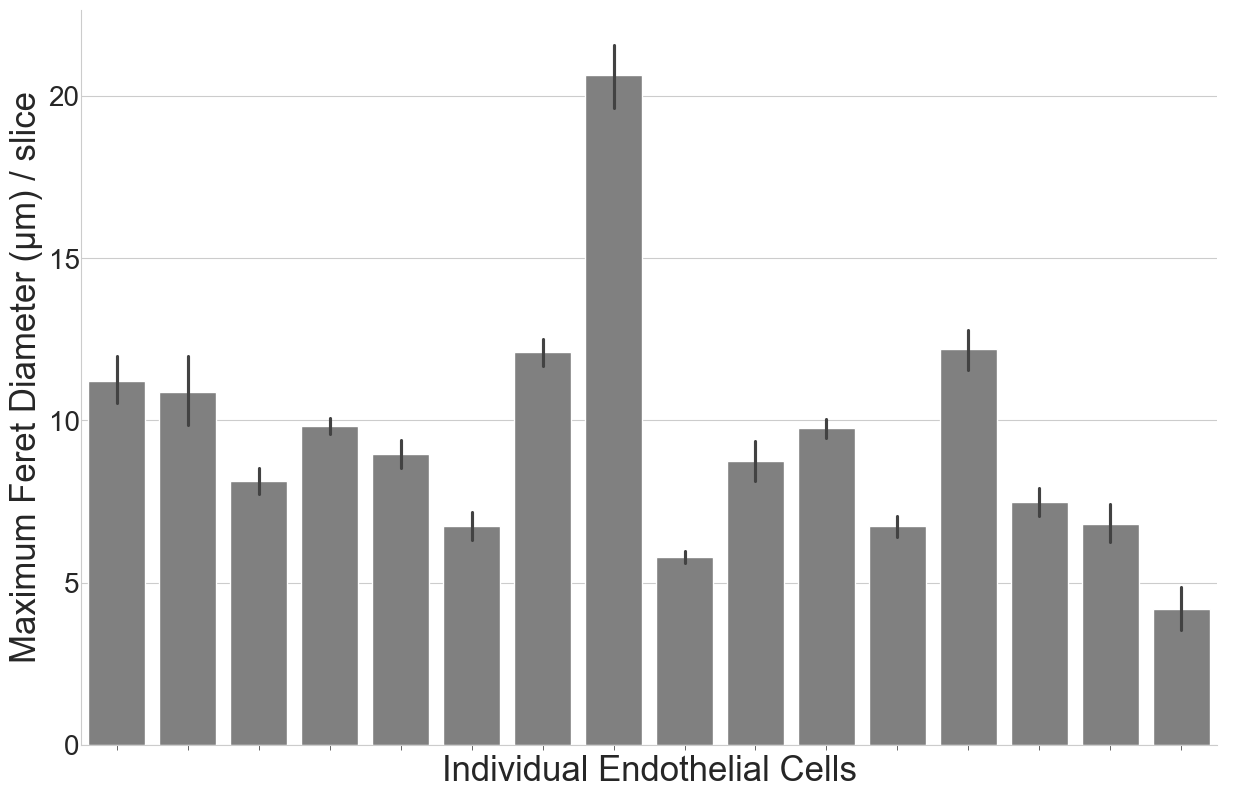

In [45]:
#visualize results

#ECs only
#ax = sns.catplot(data=all_dataframes_concat_diameter[all_dataframes_concat_diameter['label'].isin(index_keep_ECs)], x='label',y='feret_diameter_max_um', kind='bar', height = 8, aspect = 1.5, color="gray")
#ax = sns.catplot(data=all_dataframes_concat_diameter[all_dataframes_concat_diameter['label'].isin(index_keep_ECs_good)], x='label',y='feret_diameter_max_um', kind='bar', height = 8, aspect = 1.5, color="gray")
ax = sns.catplot(data=all_dataframes_concat_diameter[all_dataframes_concat_diameter['label'].isin(index_keep_ECs_good2)], x='label',y='feret_diameter_max_um', kind='bar', height = 8, aspect = 1.5, color="gray")




plt.xlabel('Individual Endothelial Cells',fontsize=25)
plt.ylabel('Maximum Feret Diameter (µm) / slice',fontsize=25)
#plt.ticklabel_format()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


#combine the lower and upper case letters into one list as there are more than 26 ECs (but less than 26*2; two sets of 26 alphabet letters)
#all_letters = string.ascii_uppercase+string.ascii_lowercase
#print(all_letters)

#xticklabels_letters = all_letters[0:len(index_keep_ECs)]
#xticklabels_letters = all_letters[0:len(index_keep_ECs_good)]
#xticklabels_letters = all_letters[0:len(index_keep_ECs_good2)]

#ax.set_xticklabels(xticklabels_letters)

#ax.set_xticklabels(xticklabels_letters)
ax.set_xticklabels([]) #remove tick labels

ax.tick_params(left=False, bottom=True, width=0.5)  # add vertical tick lines


plt.show()

ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz


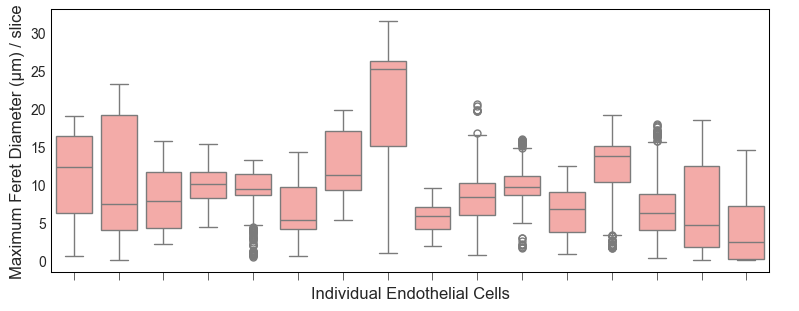

In [414]:
#visualize results

#ax = plt.figure() #this creates a new figure on which your plot will appear

#change height and width of dataset
ax = plt.figure
#ax = plt.figure(figsize=(100,17))

#make the tick labels closer to the axes/spine
    #see: https://github.com/matplotlib/matplotlib/issues/17208
mpl.rcParams['xtick.top'] = False
mpl.rcParams['xtick.labeltop'] = False 
mpl.rcParams['xtick.major.pad'] = -2.25
mpl.rcParams['xtick.minor.pad'] = -2.25
mpl.rcParams['ytick.major.pad'] = -2.25
mpl.rcParams['ytick.minor.pad'] = -2.25

#ax = sns.set_style("whitegrid")

#turn off grid
#plt.grid("False")
ax = sns.set_style("whitegrid", {'axes.grid' : False})


#ax = plt.grid(False)

#ECs only
#ax = sns.catplot(data=all_dataframes_concat_diameter[all_dataframes_concat_diameter['label'].isin(index_keep_ECs)], x='label',y='feret_diameter_max_um', kind='box', height = 8, aspect = 1.5, color=sns.color_palette("pastel")[3],) #pastel red
#ax = sns.catplot(data=all_dataframes_concat_diameter[all_dataframes_concat_diameter['label'].isin(index_keep_ECs_good)], x='label',y='feret_diameter_max_um', kind='box', height = 8, aspect = 1.5, color=sns.color_palette("pastel")[3],) #pastel red
ax = sns.catplot(data=all_dataframes_concat_diameter[all_dataframes_concat_diameter['label'].isin(index_keep_ECs_good2)], x='label',y='feret_diameter_max_um', kind='box', color=sns.color_palette("pastel")[3],) #pastel red


plt.xlabel('Individual Endothelial Cells',fontsize=12)
plt.ylabel('Maximum Feret Diameter (µm) / slice',fontsize=12)
#plt.ticklabel_format()
#plt.xticks(fontsize=20)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)


#combine the lower and upper case letters into one list as there are more than 26 ECs (but less than 26*2; two sets of 26 alphabet letters)

#all_letters = string.ascii_uppercase+string.ascii_lowercase
#print(all_letters)

#xticklabels_letters = all_letters[0:len(index_keep_ECs)]
#xticklabels_letters = all_letters[0:len(index_keep_ECs_good)]
#xticklabels_letters = all_letters[0:len(index_keep_ECs_good2)]

#ax.set_xticklabels(xticklabels_letters)
ax.set_xticklabels([]) #remove tick labels

ax.tick_params(left=False, bottom=True, width=0.5)  # add vertical tick lines

#render figure text as font rather than path
plt.rcParams['svg.fonttype'] = 'none'

#see for iterating over all spines: https://community.dataquest.io/t/iterate-over-ax-spines-items-and-related-functions/233432/
#see for using on catplot: https://stackoverflow.com/questions/72969075/make-left-and-bottom-facetgrid-spines-visible

for ax in ax.axes.ravel():
    for key,spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_color('#000000')
        spine.set_linewidth(0.75)
        
#need to resize figure here 
fig = plt.gcf()
#fig.set_size_inches(8.85,3.1)
fig.set_size_inches(8.5,3.1)

#export figure as svg for illustrator figure
#plt.savefig("mean-diameter-slice_pastel-red_good.svg", format="svg", bbox_inches='tight')
#plt.savefig("mean-diameter-slice_pastel-red_good2.svg", format="svg", bbox_inches='tight')
plt.savefig("mean-diameter-slice_pastel-red_good3.svg", format="svg", bbox_inches='tight')

#display histogram
plt.show()

In [6]:
#what is the mean diameter of the endothelial cell?

#all_dataframes_concat_diameter[all_dataframes_concat_diameter['label'].isin(index_keep_ECs)], x='label',y='feret_diameter_max_um'

print("min cell feret diameter: ", all_dataframes_concat_diameter['feret_diameter_max_um'].min())
print("max cell feret diameter: ", all_dataframes_concat_diameter['feret_diameter_max_um'].max())
print("mean cell feret diameter: ", all_dataframes_concat_diameter['feret_diameter_max_um'].mean())
print("median cell feret diameter: ", all_dataframes_concat_diameter['feret_diameter_max_um'].median())
print()

min cell feret diameter:  0.0760263112349928
max cell feret diameter:  31.48298108502433
mean cell feret diameter:  8.032573283282625
median cell feret diameter:  6.726749427886629



In [48]:
min_cell_feret_cell_diameter_list = []
max_cell_feret_cell_diameter_list = []
mean_cell_feret_cell_diameter_list = []
median_cell_feret_cell_diameter_list = []
fold_difference_per_cell_list = []

#for i in index_keep_ECs:
#for i in index_keep_ECs_good:
for i in index_keep_ECs_good2:
    print(i)
    current_cell_max_feret_list = all_dataframes_concat_diameter[all_dataframes_concat_diameter['label'] == i]['feret_diameter_max_um']
    
    fold_difference_per_cell = current_cell_max_feret_list.max()/current_cell_max_feret_list.min()
    
    min_cell_feret_cell_diameter_list.append(current_cell_max_feret_list.min())
    max_cell_feret_cell_diameter_list.append(current_cell_max_feret_list.max())
    mean_cell_feret_cell_diameter_list.append(current_cell_max_feret_list.mean())
    median_cell_feret_cell_diameter_list.append(current_cell_max_feret_list.median())
    fold_difference_per_cell_list.append(fold_difference_per_cell)
    
    
    print("min cell feret diameter of cell ", i , "is : ", current_cell_max_feret_list.min())
    print("max cell feret diameter of cell ", i , "is : ", current_cell_max_feret_list.max())
    print("fold difference between largest and smallest diameter of cell ", i, "is: ", fold_difference_per_cell)
    print("mean cell feret diameter of cell ", i , "is : ", current_cell_max_feret_list.mean())
    print("median cell feret diameter of cell ", i , "is : ", current_cell_max_feret_list.median())
    print()

7
min cell feret diameter of cell  7 is :  0.6324365580831013
max cell feret diameter of cell  7 is :  18.999194219755744
fold difference between largest and smallest diameter of cell  7 is:  30.04126497263505
mean cell feret diameter of cell  7 is :  11.214046553026652
median cell feret diameter of cell  7 is :  12.360928485173627

8
min cell feret diameter of cell  8 is :  0.1140394668524892
max cell feret diameter of cell  8 is :  23.224887082610326
fold difference between largest and smallest diameter of cell  8 is:  203.6565736724451
mean cell feret diameter of cell  8 is :  10.876565758250363
median cell feret diameter of cell  8 is :  7.487063107725975

10
min cell feret diameter of cell  10 is :  2.1990536601001804
max cell feret diameter of cell  10 is :  15.66515639883624
fold difference between largest and smallest diameter of cell  10 is:  7.12358988007714
mean cell feret diameter of cell  10 is :  8.13244939960317
median cell feret diameter of cell  10 is :  7.802185112545

In [49]:
# What is the maximum fold difference of max-diameter/min-diameter for all endothelial cells in the dataset? 
print("maximum value in fold-difference across all cells: ", np.max(fold_difference_per_cell_list))
#np.mean(fold_difference_per_cell_list)
print()

#what is the mean value of the max cell diameters? (the largest diameter measured for each cell)
print(max_cell_feret_cell_diameter_list)
print()
print("mean value of max cell diameters: ", np.mean(max_cell_feret_cell_diameter_list))

maximum value in fold-difference across all cells:  203.6565736724451

[18.999194219755744, 23.224887082610326, 15.66515639883624, 15.286564100542671, 13.264194849292588, 14.338912999247889, 19.86030775189549, 31.48298108502433, 9.546979627086255, 20.60190294608729, 15.926686598285285, 12.476517623119042, 19.154594879558275, 17.932220163716476, 18.52411144967553, 14.587119420913782]

mean value of max cell diameters:  17.554520699727952


In [50]:
#Visualize SUM of results
# use groupby to get sum

#only need want the SUM for volume_um3 and surface_area_um2. Do not want sum for any label for any other place

#ECs only use this line
#sum_all_dataframes_concat_diameter =all_dataframes_concat_diameter[all_dataframes_concat_diameter['label'].isin(index_keep_ECs)].groupby('label').sum().copy()
#sum_all_dataframes_concat_diameter =all_dataframes_concat_diameter[all_dataframes_concat_diameter['label'].isin(index_keep_ECs_good)].groupby('label').sum().copy()
sum_all_dataframes_concat_diameter =all_dataframes_concat_diameter[all_dataframes_concat_diameter['label'].isin(index_keep_ECs_good2)].groupby('label').sum().copy()



sum_all_dataframes_concat_diameter['surface_area_nm2_summed_recalc'] = sum_all_dataframes_concat_diameter['surface_area']*(17*70)
sum_all_dataframes_concat_diameter['volume_nm3_summed_recalc'] = sum_all_dataframes_concat_diameter['area']*(17*17*70)
sum_all_dataframes_concat_diameter['nm_SA_vol_ratio'] = sum_all_dataframes_concat_diameter['surface_area_nm2_summed_recalc'] / sum_all_dataframes_concat_diameter['volume_nm3_summed_recalc']


#reset index so can use 'label' as x-axis
sum_all_dataframes_concat_diameter = sum_all_dataframes_concat_diameter.reset_index()
sum_all_dataframes_concat_diameter.head(37)

#save calculated features converted to nm for all cells
#sum_all_dataframes_concat_diameter.to_csv('sum_all_dataframes_concat_diameter_nm_all_cells.csv', index=True)
#sum_all_dataframes_concat_diameter

label  index_manual  mean_intensity        area  z-slice  intensity  \
0       7        538446    41482.138321   6527830.0    22791      41377   
1       8        465030    36745.082544  19699970.0    19503      36649   
2      10       1265799    58879.119803  19696114.0    58311      58701   
3      13       1266563    61236.486345  19586173.0    58311      61064   
4      14        607778    41512.642640   8009585.0    25878      41389   
5      15        426809    35908.733506  11171341.0    17766      35824   
6      16       1267322    53032.437916  24204353.0    58311      52860   
7      17        754043    41141.313498  39332686.0    32640      41016   
8      18       1267920    46519.654112   7106424.0    58311      46349   
9      20        968417    24738.599606   7062482.0    46065      24647   
10     21       1268576    59988.659146  20025750.0    58311      59811   
11     22       1268918    63144.454513  12946289.0    58311      62968   
12     24        788022    43924.596687  23990599.0    34191      43794   
13     25       1269569    58455.671020  18770111.0    58311      58284   
14     27       1263980    41356.654248   4610623.0    58080      41198   
15     28        887882    22213.069863   3270637.0    42558      22139   

    volume_um3  surface_area  surface_area_um2  axis_major_length  \
0   132.058001      437635.0         520.78565      153720.958750   
1   398.530393      825481.0         982.32239      115235.036200   
2   398.452386      633957.0         754.40883      143059.868133   
3   396.228280      621671.0         739.78849      189806.654890   
4   162.033905      391652.0         466.06588      112468.172879   
5   225.996228      307495.0         365.91905       68886.445326   
6   489.654061     1369158.0        1629.29802      227008.150344   
7   795.700238     1577029.0        1876.66451      266887.023903   
8   143.762958      535320.0         637.03080      102485.678681   
9   142.874011      446000.0         530.74000       82679.940594   
10  405.120923      816431.0         971.55289      176554.932262   
11  261.903426      447544.0         532.57736      125755.547074   
12  485.329818      877091.0        1043.73829      146224.815608   
13  379.719346      800781.0         952.92939      141759.785287   
14   93.272903      719978.0         856.77382      139416.879785   
15   66.164987      222226.0         264.44894       36623.394005   

    axis_minor_length  feret_diameter_max  equivalent_diameter_area  \
0        29033.238310       141165.056609              40149.939213   
1        48222.409212       126680.001184              55157.506559   
2        68573.318383       163605.746745              86071.429862   
3        50914.328923       197721.933968              88001.754724   
4        28825.746471       120367.915155              45218.226638   
5        34376.828943        75037.837033              47028.353414   
6        77504.168112       243683.515504              95634.471148   
7        90012.625288       310904.803612             102248.614540   
8        36310.363232       116682.785803              52409.144769   
9        35743.262620        95197.357779              37991.649310   
10       62287.671192       196450.323991              89796.713995   
11       42375.964059       135371.698247              67503.273743   
12       63953.832721       187921.680884              81028.681437   
13       66005.326797       150528.407082              83041.480294   
14       43143.154199       128215.376199              34197.877561   
15       15051.241685        40221.169878              19080.060171   

    feret_diameter_max_nm  feret_diameter_max_um  \
0            2.399806e+06            2399.805962   
1            2.153560e+06            2153.560020   
2            2.781298e+06            2781.297695   
3            3.361273e+06            3361.272877   
4            2.046255e+06            2046.254558   
5            1.275643e+06         

<Figure size 700x700 with 0 Axes>

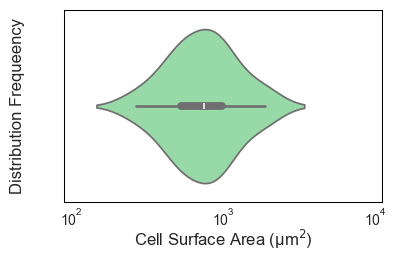

In [448]:
#visualize results - sum of um^2 surface area as violin plot -log

plt.figure() #this creates a new figure on which your plot will appear

#make the tick labels closer to the axes/spine
    #see: https://github.com/matplotlib/matplotlib/issues/17208
mpl.rcParams['xtick.top'] = False
mpl.rcParams['xtick.labeltop'] = False 
mpl.rcParams['xtick.major.pad'] = -2.25
mpl.rcParams['xtick.minor.pad'] = -2.25
mpl.rcParams['ytick.major.pad'] = -2.25
mpl.rcParams['ytick.minor.pad'] = -2.25

#change height and width of dataset
#ax = plt.figure(figsize=(4.373,2.6))
ax = plt.figure(figsize=(4.1,2.5))
ax = sns.set_style("whitegrid")
plt.grid(False)



#change height and width of dataset
#ax = sns.set(rc={'figure.figsize':(12,5)})
#plt.figure(figsize=(5,5))
#plt.figure(constrained_layout=True)
#plt.tight_layout()


#ECs only
#sum_all_dataframes_concat_diameter =all_dataframes_concat_diameter[all_dataframes_concat_diameter['label'].isin(index_keep_ECs)].groupby('label').sum().copy()
#sum_all_dataframes_concat_diameter =all_dataframes_concat_diameter[all_dataframes_concat_diameter['label'].isin(index_keep_ECs_good)].groupby('label').sum().copy()
sum_all_dataframes_concat_diameter =all_dataframes_concat_diameter[all_dataframes_concat_diameter['label'].isin(index_keep_ECs_good2)].groupby('label').sum().copy()


#SAME CODE TO MAKE ALL CELLS AND EC ONLY -- VARIABLE VALUE CHANGES ACCORDING TO ABOVE 
sum_all_dataframes_concat_diameter = sum_all_dataframes_concat_diameter.reset_index() # need to reset index
#recalculate after resetting index
sum_all_dataframes_concat_diameter['surface_area_nm2_summed_recalc'] = sum_all_dataframes_concat_diameter['surface_area']*(17*70)
sum_all_dataframes_concat_diameter['volume_nm3_summed_recalc'] = sum_all_dataframes_concat_diameter['area']*(17*17*70)
sum_all_dataframes_concat_diameter['nm_SA_vol_ratio'] = sum_all_dataframes_concat_diameter['surface_area_nm2_summed_recalc'] / sum_all_dataframes_concat_diameter['volume_nm3_summed_recalc']

sum_all_dataframes_concat_diameter['surface_area_um2_summed_recalc'] = sum_all_dataframes_concat_diameter['surface_area_nm2_summed_recalc'] * 1e-6

#don't use cut=0 as there are no values between min value and 0

ax = sns.violinplot(data=sum_all_dataframes_concat_diameter['surface_area_um2_summed_recalc'], color=sns.color_palette("pastel")[2], log_scale=10, orient='h') #pastel green

plt.xlabel('Cell Surface Area (µm$^2$)',fontsize=12,)
plt.ylabel('Distribution Frequeency',fontsize=12)
#plt.ticklabel_format()
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

#put x-label closer to x-axes ticks. set xlabels first. 
    #see: https://github.com/matplotlib/matplotlib/issues/17208
ax.xaxis.labelpad = -0.75
ax.yaxis.labelpad = 24.50

#set x and y limits to not span whole width so there is space for scale
#get default  xlim and ylim values to keep consistent between figures
current_xlim_min, current_xlim_max = ax.get_xlim()
current_ylim_min, current_ylim_max = ax.get_ylim()
#print(current_xlim_min, current_xlim_max)
#plt.xlim(current_xlim_min, 1e4) 
plt.xlim(0.9e2, 1.1e4) 
#plt.ylim(current_ylim_min, 3.7e9)
#set scale to 1e9
#plt.ticklabel_format(axis='both', style='sci', scilimits=(9,9))

ax.set_xticks([1e2, 1e3, 1e4])


#set y-minimum value so that it does not go below zero

#render figure text as font rather than path
plt.rcParams['svg.fonttype'] = 'none'

#see for iterating over all spines: https://community.dataquest.io/t/iterate-over-ax-spines-items-and-related-functions/233432/
for key,spine in ax.spines.items():
    spine.set_color('#000000')
    spine.set_linewidth(0.75)

#export figure as svg for illustrator figure
#plt.savefig("surface-area-total-um2_pastel-green_new_log_good3_resize.svg", format="svg", bbox_inches='tight')
plt.savefig("surface-area-total-um2_pastel-green_new_log_good4_resize.svg", format="svg", bbox_inches='tight')



#display histogram
plt.show()

In [53]:
# Feb 16 2024
# need to see if we can show that 3D value is more accurate than 2D extrapolation
    #do correlation between true surface area and projected surface area
    # need to know the number of slices for each cell and the surface area of one slice

#get a table with surface area of all cells
# get number of slices for each cell

#below are morphometric features visualized as plots

index_keep_ECs = [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34]    
index_keep_ECs_good = [7, 8, 10, 13, 14, 15, 16, 17, 18, 20, 21, 22, 24, 25, 27, 28, 29, 30, 32]
index_keep_ECs_good2 = [7, 8, 10, 13, 14, 15, 16, 17, 18, 20, 21, 22, 24, 25, 27, 28]

#all_df_EDT_combined = pd.read_csv('df_EDT_all-cells_complete.csv', index_col=0)
all_dataframes_concat_diameter= pd.read_csv('df_mean-intensity-per-slice+all_diameter+SA+VOL.csv',index_col=0)
all_dataframes_concat_diameter

label  index_manual  mean_intensity      area  z-slice  intensity  \
0       2             0      148.989227  240414.0        0        148   
1       7             1      189.024586   48687.0        0        189   
2       8             2      169.589450  187541.0        0        169   
3       9             3      185.832617   38839.0        0        185   
4      10             4      164.249552   45798.0        0        164   
..    ...           ...             ...       ...      ...        ...   
7      21          6501      207.316078    1642.0      341        207   
8      22          6502      192.582927     820.0      341        192   
9      25          6503      184.112554     231.0      341        184   
10     27          6504      140.519343   60255.0      341        140   
11     28          6505      161.972157   81743.0      341        161   

    volume_um3  surface_area  surface_area_um2  axis_major_length  \
0     4.863575        7635.0           9.08565         313.741508   
1     0.984938        3271.0           3.89249        1275.947337   
2     3.793954        5669.0           6.74611         653.449849   
3     0.785713        1955.0           2.32645         631.229849   
4     0.926494        3138.0           3.73422         736.459835   
..         ...           ...               ...                ...   
7     0.033218         333.0           0.39627         106.844145   
8     0.016589         150.0           0.17850          53.054268   
9     0.004673          64.0           0.07616          20.166541   
10    1.218959        5229.0           6.22251         984.264948   
11    1.653661        3052.0           3.63188         703.569895   

    axis_minor_length  feret_diameter_max  equivalent_diameter_area  \
0          267.695947          317.416131                289.010485   
1           68.773128         1116.281774                248.978340   
2          465.636525          895.272026                487.014252   
3          144.609624          672.209045                222.376597   
4          211.085617          745.413308                241.478415   
..                ...                 ...                       ...   
7           22.148891          107.540690                 44.208853   
8           21.689615           51.788030                 32.311862   
9           14.687019           21.400935                 17.149879   
10         334.987442         1074.966976                275.978108   
11         174.151505          858.065848                315.284566   

    feret_diameter_max_nm  feret_diameter_max_um  
0             5396.074221               5.396074  
1            18976.790166              18.976790  
2            15219.624437              15.219624  
3            11427.553763              11.427554  
4            12672.026239              12.672026  
..                    ...                    ...  
7             1828.191730               1.828192  
8              880.396502               0.880397  
9              363.815888               0.363816  
10           18274.438596              18.274439  
11           14587.119421              14.587119  

[6506 rows x 15 columns]

In [54]:
#sort values by label first, then by z-slice
    
organized_all_cells_diameter = all_dataframes_concat_diameter.sort_values(by=['label', 'z-slice'])

#this is only for ECs (which is what we want)
#organized_ECs_diameter = all_dataframes_concat_diameter[all_dataframes_concat_diameter['label'].isin(index_keep_ECs)].sort_values(by=['label', 'z-slice'])
#organized_ECs_diameter = all_dataframes_concat_diameter[all_dataframes_concat_diameter['label'].isin(index_keep_ECs_good)].sort_values(by=['label', 'z-slice'])
organized_ECs_diameter = all_dataframes_concat_diameter[all_dataframes_concat_diameter['label'].isin(index_keep_ECs_good2)].sort_values(by=['label', 'z-slice'])

organized_ECs_diameter

label  index_manual  mean_intensity     area  z-slice  intensity  \
1       7             1      189.024586  48687.0        0        189   
1       7            26      190.206541  50784.0        1        190   
1       7            51      194.320071  49892.0        2        194   
1       7            76      188.062035  48521.0        3        188   
1       7           101      192.751786  48708.0        4        192   
..    ...           ...             ...      ...      ...        ...   
11     28          6457      162.520849  74872.0      337        162   
11     28          6469      160.784168  76124.0      338        160   
11     28          6481      161.720225  78674.0      339        161   
11     28          6493      156.646499  80724.0      340        156   
11     28          6505      161.972157  81743.0      341        161   

    volume_um3  surface_area  surface_area_um2  axis_major_length  \
1     0.984938        3271.0           3.89249        1275.947337   
1     1.027360        3229.0           3.84251        1262.018860   
1     1.009315        3156.0           3.75564        1264.763048   
1     0.981580        3139.0           3.73541        1251.602515   
1     0.985363        3151.0           3.74969        1250.010815   
..         ...           ...               ...                ...   
11    1.514661        3103.0           3.69257         682.774951   
11    1.539989        2936.0           3.49384         688.021741   
11    1.591575        3101.0           3.69019         715.412043   
11    1.633047        2999.0           3.56881         702.046956   
11    1.653661        3052.0           3.63188         703.569895   

    axis_minor_length  feret_diameter_max  equivalent_diameter_area  \
1           68.773128         1116.281774                248.978340   
1           70.612927         1117.599660                254.283694   
1           69.533782         1113.881951                252.040607   
1           67.446120         1112.845452                248.553527   
1           68.870110         1113.348553                249.032030   
..                ...                 ...                       ...   
11         167.239156          798.010652                302.536110   
11         169.511512          822.149013                304.875439   
11         171.662021          857.103261                310.661044   
11         172.102396          835.998206                313.045409   
11         174.151505          858.065848                315.284566   

    feret_diameter_max_nm  feret_diameter_max_um  
1            18976.790166              18.976790  
1            18999.194220              18.999194  
1            18935.993161              18.935993  
1            18918.372684              18.918373  
1            18926.925397              18.926925  
..                    ...                    ...  
11           13566.181076              13.566181  
11           13976.533225              13.976533  
11           14570.755437              14.570755  
11           14211.969498              14.211969  
11           14587.119421              14.587119  

[4410 rows x 15 columns]

In [55]:
#determine number of z-slices for each cell label

#this is only for ECs (which is what we want)
#num_slices_per_cell_morpho = all_dataframes_concat_diameter[all_dataframes_concat_diameter['label'].isin(index_keep_ECs)].groupby('label').count()
#num_slices_per_cell_morpho = all_dataframes_concat_diameter[all_dataframes_concat_diameter['label'].isin(index_keep_ECs_good)].groupby('label').count()
num_slices_per_cell_morpho = all_dataframes_concat_diameter[all_dataframes_concat_diameter['label'].isin(index_keep_ECs_good2)].groupby('label').count()

#need a separate number of Z-Slices when considering all NPs and vesicles. This is because we will still predict number of NPs per cell regardless of volume
num_slices_per_cell_all_cells = all_dataframes_concat_diameter[all_dataframes_concat_diameter['label'].isin(index_keep_ECs)].groupby('label').count()

num_slices_per_cell_morpho

index_manual  mean_intensity  area  z-slice  intensity  volume_um3  \
label                                                                       
7               214             214   214      214        214         214   
8               198             198   198      198        198         198   
10              342             342   342      342        342         342   
13              342             342   342      342        342         342   
14              228             228   228      228        228         228   
15              189             189   189      189        189         189   
16              342             342   342      342        342         342   
17              256             256   256      256        256         256   
18              342             342   342      342        342         342   
20              185             185   185      185        185         185   
21              342             342   342      342        342         342   
22              342             342   342      342        342         342   
24              262             262   262      262        262         262   
25              342             342   342      342        342         342   
27              320             320   320      320        320         320   
28              164             164   164      164        164         164   

       surface_area  surface_area_um2  axis_major_length  axis_minor_length  \
label                                                                         
7               214               214                214                214   
8               198               198                198                198   
10              342               342                342                342   
13              342               342                342                342   
14              228               228                228                228   
15              189               189                189                189   
16              342               342                342                342   
17              256               256                256                256   
18              342               342                342                342   
20              185               185                185                185   
21              342               342                342                342   
22              342               342                342                342   
24              262               262                262                262   
25              342               342                342                342   
27              320               320                320                320   
28              164               164                164                164   

       feret_diameter_max  equivalent_diameter_area  feret_diameter_max_nm  \
label                                                                        
7                     214                       214                    214   
8                     198                       198                    198   
10                    342                       342                    342   
13                    342                       342                    342   
14                    228                       228                    228   
15                    189                       189                    189   
16                    342                       342                    342   
17                    256                       256                    256   
18                    342                       342                    342   
20                    185                       185                    185   
21                    342                       342                    342   
22                    342                       342                    342   
24                    262                       262                    262   
25                    342  

In [56]:
#get since the values are the same for all columns, just get the label and number of slices
label_and_num_slices = num_slices_per_cell_morpho.iloc[:, 0:1].reset_index().copy()
label_and_num_slices_all_cells  = num_slices_per_cell_all_cells.iloc[:, 0:1].reset_index().copy()

label_and_num_slices
#label_and_num_slices_all_cells

label  index_manual
0       7           214
1       8           198
2      10           342
3      13           342
4      14           228
5      15           189
6      16           342
7      17           256
8      18           342
9      20           185
10     21           342
11     22           342
12     24           262
13     25           342
14     27           320
15     28           164

In [57]:
#create new dataframe that has the number of slices for the respective columns based on the label

organized_ECs_diameter_projected = organized_ECs_diameter.copy()
organized_ECs_diameter_projected['num_slices_per_label'] = organized_ECs_diameter_projected['label'].map(label_and_num_slices.set_index('label')['index_manual'])

In [58]:
organized_ECs_diameter_projected

label  index_manual  mean_intensity     area  z-slice  intensity  \
1       7             1      189.024586  48687.0        0        189   
1       7            26      190.206541  50784.0        1        190   
1       7            51      194.320071  49892.0        2        194   
1       7            76      188.062035  48521.0        3        188   
1       7           101      192.751786  48708.0        4        192   
..    ...           ...             ...      ...      ...        ...   
11     28          6457      162.520849  74872.0      337        162   
11     28          6469      160.784168  76124.0      338        160   
11     28          6481      161.720225  78674.0      339        161   
11     28          6493      156.646499  80724.0      340        156   
11     28          6505      161.972157  81743.0      341        161   

    volume_um3  surface_area  surface_area_um2  axis_major_length  \
1     0.984938        3271.0           3.89249        1275.947337   
1     1.027360        3229.0           3.84251        1262.018860   
1     1.009315        3156.0           3.75564        1264.763048   
1     0.981580        3139.0           3.73541        1251.602515   
1     0.985363        3151.0           3.74969        1250.010815   
..         ...           ...               ...                ...   
11    1.514661        3103.0           3.69257         682.774951   
11    1.539989        2936.0           3.49384         688.021741   
11    1.591575        3101.0           3.69019         715.412043   
11    1.633047        2999.0           3.56881         702.046956   
11    1.653661        3052.0           3.63188         703.569895   

    axis_minor_length  feret_diameter_max  equivalent_diameter_area  \
1           68.773128         1116.281774                248.978340   
1           70.612927         1117.599660                254.283694   
1           69.533782         1113.881951                252.040607   
1           67.446120         1112.845452                248.553527   
1           68.870110         1113.348553                249.032030   
..                ...                 ...                       ...   
11         167.239156          798.010652                302.536110   
11         169.511512          822.149013                304.875439   
11         171.662021          857.103261                310.661044   
11         172.102396          835.998206                313.045409   
11         174.151505          858.065848                315.284566   

    feret_diameter_max_nm  feret_diameter_max_um  num_slices_per_label  
1            18976.790166              18.976790                   214  
1            18999.194220              18.999194                   214  
1            18935.993161              18.935993                   214  
1            18918.372684              18.918373                   214  
1            18926.925397              18.926925                   214  
..                    ...                    ...                   ...  
11           13566.181076              13.566181                   164  
11           13976.533225              13.976533                   164  
11           14570.755437              14.570755                   164  
11           14211.969498              14.211969                   164  
11           14587.119421              14.587119                   164  

[4410 rows x 16 columns]

In [59]:
#create new column to get the projected surface area based on the surface area of the slice and number of slices
organized_ECs_diameter_projected['projected_total_surface_area_nm2'] = organized_ECs_diameter_projected['surface_area'] * (17*70) * organized_ECs_diameter_projected['num_slices_per_label']
organized_ECs_diameter_projected['projected_total_surface_area_um2'] =  organized_ECs_diameter_projected['projected_total_surface_area_nm2'] * 1e-6
organized_ECs_diameter_projected['projected_total_volume_nm3'] = organized_ECs_diameter_projected['area'] * (17*17*70) * organized_ECs_diameter_projected['num_slices_per_label']
organized_ECs_diameter_projected['projected_total_volume_um3'] = organized_ECs_diameter_projected['projected_total_volume_nm3'] * 1e-9

organized_ECs_diameter_projected


label  index_manual  mean_intensity     area  z-slice  intensity  \
1       7             1      189.024586  48687.0        0        189   
1       7            26      190.206541  50784.0        1        190   
1       7            51      194.320071  49892.0        2        194   
1       7            76      188.062035  48521.0        3        188   
1       7           101      192.751786  48708.0        4        192   
..    ...           ...             ...      ...      ...        ...   
11     28          6457      162.520849  74872.0      337        162   
11     28          6469      160.784168  76124.0      338        160   
11     28          6481      161.720225  78674.0      339        161   
11     28          6493      156.646499  80724.0      340        156   
11     28          6505      161.972157  81743.0      341        161   

    volume_um3  surface_area  surface_area_um2  axis_major_length  \
1     0.984938        3271.0           3.89249        1275.947337   
1     1.027360        3229.0           3.84251        1262.018860   
1     1.009315        3156.0           3.75564        1264.763048   
1     0.981580        3139.0           3.73541        1251.602515   
1     0.985363        3151.0           3.74969        1250.010815   
..         ...           ...               ...                ...   
11    1.514661        3103.0           3.69257         682.774951   
11    1.539989        2936.0           3.49384         688.021741   
11    1.591575        3101.0           3.69019         715.412043   
11    1.633047        2999.0           3.56881         702.046956   
11    1.653661        3052.0           3.63188         703.569895   

    axis_minor_length  feret_diameter_max  equivalent_diameter_area  \
1           68.773128         1116.281774                248.978340   
1           70.612927         1117.599660                254.283694   
1           69.533782         1113.881951                252.040607   
1           67.446120         1112.845452                248.553527   
1           68.870110         1113.348553                249.032030   
..                ...                 ...                       ...   
11         167.239156          798.010652                302.536110   
11         169.511512          822.149013                304.875439   
11         171.662021          857.103261                310.661044   
11         172.102396          835.998206                313.045409   
11         174.151505          858.065848                315.284566   

    feret_diameter_max_nm  feret_diameter_max_um  num_slices_per_label  \
1            18976.790166              18.976790                   214   
1            18999.194220              18.999194                   214   
1            18935.993161              18.935993                   214   
1            18918.372684              18.918373                   214   
1            18926.925397              18.926925                   214   
..                    ...                    ...                   ...   
11           13566.181076              13.566181                   164   
11           13976.533225              13.976533                   164   
11           14570.755437              14.570755                   164   
11           14211.969498              14.211969                   164   
11           14587.119421              14.587119                   164   

    projected_total_surface_area_nm2  projected_total_surface_area_um2  \
1                        832992860.0                         832.99286   
1                        822297140.0                         822.29714   
1                        803706960.0                         803.70696   
1                        799377740.0                         799.37774   
1                        802433660.0                         802.43366   
..                               ...                               ...   
11                       605581480.0              

In [60]:
#get the true total Surface area and volume in nm2 and nm3
#ECs only
#sum_all_dataframes_concat_diameter =organized_ECs_diameter_projected[organized_ECs_diameter_projected['label'].isin(index_keep_ECs)].groupby('label').sum().copy()
#sum_all_dataframes_concat_diameter =organized_ECs_diameter_projected[organized_ECs_diameter_projected['label'].isin(index_keep_ECs_good)].groupby('label').sum().copy()
sum_all_dataframes_concat_diameter =organized_ECs_diameter_projected[organized_ECs_diameter_projected['label'].isin(index_keep_ECs_good2)].groupby('label').sum().copy()

#SAME CODE TO MAKE ALL CELLS AND EC ONLY -- VARIABLE VALUE CHANGES ACCORDING TO ABOVE line being either 'FOR ALL CELLS' or 'ECs only'
sum_all_dataframes_concat_diameter = sum_all_dataframes_concat_diameter.reset_index() # need to reset index
#recalculate after resetting index
sum_all_dataframes_concat_diameter['surface_area_nm2_summed_recalc'] = sum_all_dataframes_concat_diameter['surface_area']*(17*70)
sum_all_dataframes_concat_diameter['volume_nm3_summed_recalc'] = sum_all_dataframes_concat_diameter['area']*(17*17*70)
sum_all_dataframes_concat_diameter['nm_SA_vol_ratio'] = sum_all_dataframes_concat_diameter['surface_area_nm2_summed_recalc'] / sum_all_dataframes_concat_diameter['volume_nm3_summed_recalc']

sum_all_dataframes_concat_diameter

label  index_manual  mean_intensity        area  z-slice  intensity  \
0       7        538446    41482.138321   6527830.0    22791      41377   
1       8        465030    36745.082544  19699970.0    19503      36649   
2      10       1265799    58879.119803  19696114.0    58311      58701   
3      13       1266563    61236.486345  19586173.0    58311      61064   
4      14        607778    41512.642640   8009585.0    25878      41389   
5      15        426809    35908.733506  11171341.0    17766      35824   
6      16       1267322    53032.437916  24204353.0    58311      52860   
7      17        754043    41141.313498  39332686.0    32640      41016   
8      18       1267920    46519.654112   7106424.0    58311      46349   
9      20        968417    24738.599606   7062482.0    46065      24647   
10     21       1268576    59988.659146  20025750.0    58311      59811   
11     22       1268918    63144.454513  12946289.0    58311      62968   
12     24        788022    43924.596687  23990599.0    34191      43794   
13     25       1269569    58455.671020  18770111.0    58311      58284   
14     27       1263980    41356.654248   4610623.0    58080      41198   
15     28        887882    22213.069863   3270637.0    42558      22139   

    volume_um3  surface_area  surface_area_um2  axis_major_length  ...  \
0   132.058001      437635.0         520.78565      153720.958750  ...   
1   398.530393      825481.0         982.32239      115235.036200  ...   
2   398.452386      633957.0         754.40883      143059.868133  ...   
3   396.228280      621671.0         739.78849      189806.654890  ...   
4   162.033905      391652.0         466.06588      112468.172879  ...   
5   225.996228      307495.0         365.91905       68886.445326  ...   
6   489.654061     1369158.0        1629.29802      227008.150344  ...   
7   795.700238     1577029.0        1876.66451      266887.023903  ...   
8   143.762958      535320.0         637.03080      102485.678681  ...   
9   142.874011      446000.0         530.74000       82679.940594  ...   
10  405.120923      816431.0         971.55289      176554.932262  ...   
11  261.903426      447544.0         532.57736      125755.547074  ...   
12  485.329818      877091.0        1043.73829      146224.815608  ...   
13  379.719346      800781.0         952.92939      141759.785287  ...   
14   93.272903      719978.0         856.77382      139416.879785  ...   
15   66.164987      222226.0         264.44894       36623.394005  ...   

    feret_diameter_max_nm  feret_diameter_max_um  num_slices_per_label  \
0            2.399806e+06            2399.805962                 45796   
1            2.153560e+06            2153.560020                 39204   
2            2.781298e+06            2781.297695                116964   
3            3.361273e+06            3361.272877                116964   
4            2.046255e+06            2046.254558                 51984   
5            1.275643e+06            1275.643230                 35721   
6            4.142620e+06            4142.619764                116964   
7            5.285382e+06            5285.381661                 65536   
8            1.983607e+06            1983.607359                116964   
9            1.618355e+06            1618.355082                 34225   
10           3.339656e+06            3339.655508                116964   
11           2.301319e+06            2301.318870                116964   
12           3.194669e+06            3194.668575                 68644   
13           2.558983e+06            2558.982920                116964   
14           2.179661e+06            2179.661395                102400   
15           6.837599e+05             683.759888                 26896   

    projected_total_surface_area_nm2  projected_total_surface_area_um2  \
0                       1.114481e+11                      111448.12910   
1                       1.944998e+11                      1944

In [61]:
#now map the true surface area and volume as a column where the labels are equal, follow same approach as above

organized_ECs_diameter_projected['true_total_SA_nm2'] = organized_ECs_diameter_projected['label'].map(sum_all_dataframes_concat_diameter.set_index('label')['surface_area_nm2_summed_recalc'])
organized_ECs_diameter_projected['true_total_SA_um2'] = organized_ECs_diameter_projected['true_total_SA_nm2'] * 1e-6
organized_ECs_diameter_projected['true_total_vol_nm3'] = organized_ECs_diameter_projected['label'].map(sum_all_dataframes_concat_diameter.set_index('label')['volume_nm3_summed_recalc'])
organized_ECs_diameter_projected['true_total_vol_um3'] = organized_ECs_diameter_projected['true_total_vol_nm3'] * 1e-9

organized_ECs_diameter_projected

label  index_manual  mean_intensity     area  z-slice  intensity  \
1       7             1      189.024586  48687.0        0        189   
1       7            26      190.206541  50784.0        1        190   
1       7            51      194.320071  49892.0        2        194   
1       7            76      188.062035  48521.0        3        188   
1       7           101      192.751786  48708.0        4        192   
..    ...           ...             ...      ...      ...        ...   
11     28          6457      162.520849  74872.0      337        162   
11     28          6469      160.784168  76124.0      338        160   
11     28          6481      161.720225  78674.0      339        161   
11     28          6493      156.646499  80724.0      340        156   
11     28          6505      161.972157  81743.0      341        161   

    volume_um3  surface_area  surface_area_um2  axis_major_length  ...  \
1     0.984938        3271.0           3.89249        1275.947337  ...   
1     1.027360        3229.0           3.84251        1262.018860  ...   
1     1.009315        3156.0           3.75564        1264.763048  ...   
1     0.981580        3139.0           3.73541        1251.602515  ...   
1     0.985363        3151.0           3.74969        1250.010815  ...   
..         ...           ...               ...                ...  ...   
11    1.514661        3103.0           3.69257         682.774951  ...   
11    1.539989        2936.0           3.49384         688.021741  ...   
11    1.591575        3101.0           3.69019         715.412043  ...   
11    1.633047        2999.0           3.56881         702.046956  ...   
11    1.653661        3052.0           3.63188         703.569895  ...   

    feret_diameter_max_um  num_slices_per_label  \
1               18.976790                   214   
1               18.999194                   214   
1               18.935993                   214   
1               18.918373                   214   
1               18.926925                   214   
..                    ...                   ...   
11              13.566181                   164   
11              13.976533                   164   
11              14.570755                   164   
11              14.211969                   164   
11              14.587119                   164   

    projected_total_surface_area_nm2  projected_total_surface_area_um2  \
1                        832992860.0                         832.99286   
1                        822297140.0                         822.29714   
1                        803706960.0                         803.70696   
1                        799377740.0                         799.37774   
1                        802433660.0                         802.43366   
..                               ...                               ...   
11                       605581480.0                         605.58148   
11                       572989760.0                         572.98976   
11                       605191160.0                         605.19116   
11                       585284840.0                         585.28484   
11                       595628320.0                         595.62832   

    projected_total_volume_nm3  projected_total_volume_um3  true_total_SA_nm2  \
1                 2.107767e+11                  210.776734        520785650.0   
1                 2.198551e+11                  219.855108        520785650.0   
1                 2.159934e+11                  215.993444        520785650.0   
1                 2.100581e+11                  210.058084        520785650.0   
1                 2.108676e+11                  210.867648        520785650.0   
..                         ...                         ...                ...   
11                2.484043e+11                  248.404332        264448940.0   
11                2.525581e+11                  252.558117        264448940.0   
11                2

<Figure size 700x700 with 0 Axes>

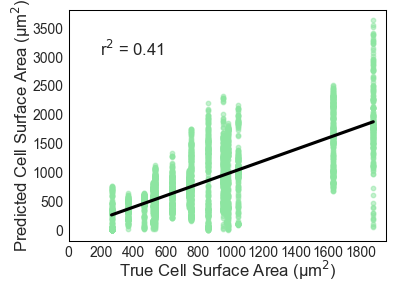

In [447]:
#plot true vs. predicted values as scatterplot and get correlation 
#for volume (um^3)

plt.figure() #this creates a new figure on which your plot will appear

#make the tick labels closer to the axes/spine
    #see: https://github.com/matplotlib/matplotlib/issues/17208
mpl.rcParams['xtick.top'] = False
mpl.rcParams['xtick.labeltop'] = False 
mpl.rcParams['xtick.major.pad'] = -2.25
mpl.rcParams['xtick.minor.pad'] = -2.25
mpl.rcParams['ytick.major.pad'] = -2.25
mpl.rcParams['ytick.minor.pad'] = -2.25

#change height and width of dataset
#ax = plt.figure(figsize=(4.373,3.1))
ax = plt.figure(figsize=(4.1,3))

ax = sns.set_style("whitegrid")
plt.grid(False)

#ax = sns.regplot(data=organized_ECs_diameter_projected, x="true_total_SA_um2", y="projected_total_surface_area_um2",line_kws={"color": "black"},scatter_kws={'alpha':0.05},color=sns.color_palette("pastel")[2],ci=None)
ax = sns.regplot(data=organized_ECs_diameter_projected, x="true_total_SA_um2", y="projected_total_surface_area_um2",line_kws={"color": "black"},scatter_kws={'alpha':0.50,'s':10},color=sns.color_palette("pastel")[2],ci=None)
plt.grid(False)



organized_ECs_diameter_projected  = organized_ECs_diameter_projected.fillna(0)

#pearson r and spearman r
#r, p = scipy.stats.pearsonr(x=organized_ECs_diameter_projected['true_total_SA_um2'], y=organized_ECs_diameter_projected['projected_total_surface_area_um2'])
r, p = scipy.stats.spearmanr(a=organized_ECs_diameter_projected['true_total_SA_um2'], b=organized_ECs_diameter_projected['projected_total_surface_area_um2'])

#text_n_r_p = "n = " + str(int(num_np)) + "\n" + "r  = "+str(round(r, 10)) + "\n" + "p = "+str(p)
#text_n_r2_p = "n = " + str(int(num_np)) + "\n"  + "r$^2$ = "+str(round(r**2, 10)) + "\n" + "p = "+str(p)
text_n_r2_p = "n = " + "\n"  + "r$^2$ = "+str(round(r**2, 10)) + "\n" + "p = "+str(p)
#text_r2 = "r$^2$ = "+str(round(r**2, 10))
text_r2 = "r$^2$ = "+str(round(r**2, 2))

ax.text(0.1, 0.8, text_r2,transform=ax.transAxes, fontname="Arial", size=12)

#ax.set(xlabel='True Cell Surface Area (μm$^2$)', ylabel='Predicted Cell Surface Area (μm$^2$)')

plt.xlabel('True Cell Surface Area (μm$^2$)',fontsize=12, fontname="Arial",)
plt.ylabel('Predicted Cell Surface Area (μm$^2$)',fontsize=12, fontname="Arial",)
#plt.ticklabel_format()
plt.xticks(fontsize=10, fontname="Arial",)
plt.yticks(fontsize=10, fontname="Arial",)

#set x and y limits to not span whole width so there is space for scale
#get default  xlim and ylim values to keep consistent between figures
current_xlim_min, current_xlim_max = ax.get_xlim()
current_ylim_min, current_ylim_max = ax.get_ylim()
#print(current_xlim_min, current_xlim_max)
#plt.xlim(current_xlim_min, 1e4) 
#plt.xlim(0.9e2, 1.1e4) 
#plt.ylim(current_ylim_min, 3.7e9)
#set scale to 1e9
#plt.ticklabel_format(axis='both', style='sci', scilimits=(9,9))

#ax.set_xticks([1e2, 1e3, 1e4])
ax.set_yticks(np.arange(0, 4000, 500))
ax.set_xticks(np.arange(0, 2000, 200))

#put x-label closer to x-axes ticks. set xlabels first. 
    #see: https://github.com/matplotlib/matplotlib/issues/17208
ax.xaxis.labelpad = -0.75
ax.yaxis.labelpad = -0.5

'''

pan whole width so there is space for scale
#get default  xlim and ylim values to keep consistent between figures
current_xlim_min, current_xlim_max = ax.get_xlim()
current_ylim_min, current_ylim_max = ax.get_ylim()
#print(current_xlim_min, current_xlim_max)
plt.xlim(current_xlim_min, 2.1e9) 
plt.ylim(current_ylim_min, 3.7e9)
#set scale to 1e9
plt.ticklabel_format(axis='both', style='sci', scilimits=(9,9))
'''


#render figure text as font rather than path
#plt.rcParams['pdf.use14corefonts'] = True
plt.rcParams['svg.fonttype'] = 'none'

#see for iterating over all spines: https://community.dataquest.io/t/iterate-over-ax-spines-items-and-related-functions/233432/
for key,spine in ax.spines.items():
    spine.set_color('#000000')
    spine.set_linewidth(0.75)


#export figure as svg for illustrator figure
#plt.savefig("predicted-vs-true_SA_good.svg", format="svg", bbox_inches='tight')
#plt.savefig("predicted-vs-true_SA_good_v2-1e9.svg", format="svg", bbox_inches='tight')
#plt.savefig("predicted-vs-true_SA_good_v3-1e9.svg", format="svg", bbox_inches='tight')
#plt.savefig("predicted-vs-true_SA_good_v5-micron.svg", format="svg", bbox_inches='tight')
#plt.savefig("predicted-vs-true_SA_good_v6-micron-darker.svg", format="svg", bbox_inches='tight')
plt.savefig("predicted-vs-true_SA_good_v7-micron-darker.svg", format="svg", bbox_inches='tight')


In [438]:
#RSD for 2D SA
mean_all_2D_cells_SA = organized_ECs_diameter_projected['projected_total_surface_area_um2'].mean()
std_all_2D_cells_SA = organized_ECs_diameter_projected['projected_total_surface_area_um2'].std()
rsd_all_2D_cells_SA = std_all_2D_cells_SA/mean_all_2D_cells_SA
print("The RSD for 2D SA (predicted) is: ", rsd_all_2D_cells_SA*100,"%")

#RSD for 2D Volume
mean_all_2D_cells_vol = organized_ECs_diameter_projected['projected_total_volume_um3'].mean()
std_all_2D_cells_vol = organized_ECs_diameter_projected['projected_total_volume_um3'].std()
rsd_all_2D_cells_vol = std_all_2D_cells_vol/mean_all_2D_cells_vol
print("The RSD for 2D volume (predicted) is: ", rsd_all_2D_cells_vol*100,"%")

#RSD for 3D SA
mean_all_3D_cells_SA = organized_ECs_diameter_projected['true_total_SA_um2'].mean()
std_all_3D_cells_SA = organized_ECs_diameter_projected['true_total_SA_um2'].std()
rsd_all_3D_cells_SA = std_all_3D_cells_SA/mean_all_3D_cells_SA
print("The RSD for 3D SA (true) is: ", rsd_all_3D_cells_SA*100,"%")

#RSD for 3D Volume
mean_all_3D_cells_vol = organized_ECs_diameter_projected['true_total_vol_um3'].mean()
std_all_3D_cells_vol = organized_ECs_diameter_projected['true_total_vol_um3'].std()
rsd_all_3D_cells_vol = std_all_3D_cells_vol/mean_all_3D_cells_vol
print("The RSD for 3D volume (true) is: ", rsd_all_3D_cells_vol*100,"%")


The RSD for 2D SA (predicted) is:  67.08244664127446 %
The RSD for 2D volume (predicted) is:  91.77154155920336 %
The RSD for 3D SA (true) is:  47.59466538382519 %
The RSD for 3D volume (true) is:  55.564474629146545 %


In [65]:
organized_ECs_diameter_projected

label  index_manual  mean_intensity     area  z-slice  intensity  \
1       7             1      189.024586  48687.0        0        189   
1       7            26      190.206541  50784.0        1        190   
1       7            51      194.320071  49892.0        2        194   
1       7            76      188.062035  48521.0        3        188   
1       7           101      192.751786  48708.0        4        192   
..    ...           ...             ...      ...      ...        ...   
11     28          6457      162.520849  74872.0      337        162   
11     28          6469      160.784168  76124.0      338        160   
11     28          6481      161.720225  78674.0      339        161   
11     28          6493      156.646499  80724.0      340        156   
11     28          6505      161.972157  81743.0      341        161   

    volume_um3  surface_area  surface_area_um2  axis_major_length  ...  \
1     0.984938        3271.0           3.89249        1275.947337  ...   
1     1.027360        3229.0           3.84251        1262.018860  ...   
1     1.009315        3156.0           3.75564        1264.763048  ...   
1     0.981580        3139.0           3.73541        1251.602515  ...   
1     0.985363        3151.0           3.74969        1250.010815  ...   
..         ...           ...               ...                ...  ...   
11    1.514661        3103.0           3.69257         682.774951  ...   
11    1.539989        2936.0           3.49384         688.021741  ...   
11    1.591575        3101.0           3.69019         715.412043  ...   
11    1.633047        2999.0           3.56881         702.046956  ...   
11    1.653661        3052.0           3.63188         703.569895  ...   

    feret_diameter_max_um  num_slices_per_label  \
1               18.976790                   214   
1               18.999194                   214   
1               18.935993                   214   
1               18.918373                   214   
1               18.926925                   214   
..                    ...                   ...   
11              13.566181                   164   
11              13.976533                   164   
11              14.570755                   164   
11              14.211969                   164   
11              14.587119                   164   

    projected_total_surface_area_nm2  projected_total_surface_area_um2  \
1                        832992860.0                         832.99286   
1                        822297140.0                         822.29714   
1                        803706960.0                         803.70696   
1                        799377740.0                         799.37774   
1                        802433660.0                         802.43366   
..                               ...                               ...   
11                       605581480.0                         605.58148   
11                       572989760.0                         572.98976   
11                       605191160.0                         605.19116   
11                       585284840.0                         585.28484   
11                       595628320.0                         595.62832   

    projected_total_volume_nm3  projected_total_volume_um3  true_total_SA_nm2  \
1                 2.107767e+11                  210.776734        520785650.0   
1                 2.198551e+11                  219.855108        520785650.0   
1                 2.159934e+11                  215.993444        520785650.0   
1                 2.100581e+11                  210.058084        520785650.0   
1                 2.108676e+11                  210.867648        520785650.0   
..                         ...                         ...                ...   
11                2.484043e+11                  248.404332        264448940.0   
11                2.525581e+11                  252.558117        264448940.0   
11                2

<Figure size 700x700 with 0 Axes>

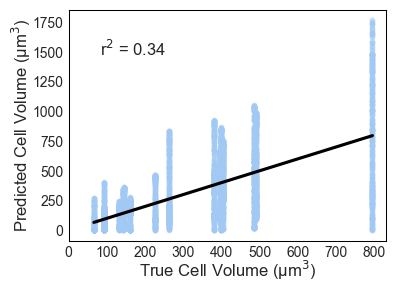

In [446]:
#plot true vs. predicted values as scatterplot and get correlation 
#for surface area (um^2)


plt.figure() #this creates a new figure on which your plot will appear

#make the tick labels closer to the axes/spine
    #see: https://github.com/matplotlib/matplotlib/issues/17208
mpl.rcParams['xtick.top'] = False
mpl.rcParams['xtick.labeltop'] = False 
mpl.rcParams['xtick.major.pad'] = -2.25
mpl.rcParams['xtick.minor.pad'] = -2.25
mpl.rcParams['ytick.major.pad'] = -2.25
mpl.rcParams['ytick.minor.pad'] = -2.25

#change height and width of dataset
#ax = plt.figure(figsize=(4.373,3.1))
ax = plt.figure(figsize=(4.1,3))

ax = sns.set_style("whitegrid")
plt.grid(False)


#ax = sns.regplot(data=organized_ECs_diameter_projected, x="true_total_vol_um3", y="projected_total_volume_um3",line_kws={"color": "black"},scatter_kws={'alpha':0.05},color=sns.color_palette("pastel")[0],ci=None)
ax = sns.regplot(data=organized_ECs_diameter_projected, x="true_total_vol_um3", y="projected_total_volume_um3",line_kws={"color": "black"},scatter_kws={'alpha':0.50,'s':10},color=sns.color_palette("pastel")[0],ci=None)
plt.grid(False)


organized_ECs_diameter_projected  = organized_ECs_diameter_projected.fillna(0)

#pearson r and spearman r
#r, p = scipy.stats.pearsonr(x=organized_ECs_diameter_projected['true_total_vol_um3'], y=organized_ECs_diameter_projected['projected_total_volume_um3'])
r, p = scipy.stats.spearmanr(a=organized_ECs_diameter_projected['true_total_vol_um3'], b=organized_ECs_diameter_projected['projected_total_volume_um3'])


#text_n_r_p = "n = " + str(int(num_np)) + "\n" + "r  = "+str(round(r, 10)) + "\n" + "p = "+str(p)
#text_n_r2_p = "n = " + str(int(num_np)) + "\n"  + "r$^2$ = "+str(round(r**2, 10)) + "\n" + "p = "+str(p)
text_n_r2_p = "n = " + "\n"  + "r$^2$ = "+str(round(r**2, 10)) + "\n" + "p = "+str(p)
#text_r2 = "r$^2$ = "+str(round(r**2, 10))
text_r2 = "r$^2$ = "+str(round(r**2, 2))


ax.text(0.1, 0.8, text_r2,transform=ax.transAxes, fontname="Arial", size=12)

#ax.set(xlabel='True Cell Volume (μm$^3$)', ylabel='Predicted Cell Volume (μm$^3$)')
plt.xlabel('True Cell Volume (μm$^3$)',fontsize=12, fontname="Arial",)
plt.ylabel('Predicted Cell Volume (μm$^3$)',fontsize=12, fontname="Arial",)
#plt.ticklabel_format()
plt.xticks(fontsize=10, fontname="Arial",)
plt.yticks(fontsize=10, fontname="Arial",)

#set x and y limits to not span whole width so there is space for scale
#get default  xlim and ylim values to keep consistent between figures
current_xlim_min, current_xlim_max = ax.get_xlim()
current_ylim_min, current_ylim_max = ax.get_ylim()
#print(current_xlim_min, current_xlim_max)
#plt.xlim(current_xlim_min, 1e4) 
#plt.xlim(0.9e2, 1.1e4) 
#plt.ylim(current_ylim_min, 3.7e9)
#set scale to 1e9
#plt.ticklabel_format(axis='both', style='sci', scilimits=(9,9))

#ax.set_xticks([1e2, 1e3, 1e4])
ax.set_yticks(np.arange(0, 2000, 250))
ax.set_xticks(np.arange(0, 900, 100))

#put x-label closer to x-axes ticks. set xlabels first. 
    #see: https://github.com/matplotlib/matplotlib/issues/17208
ax.xaxis.labelpad = -0.75
ax.yaxis.labelpad = -0.5



#ax.legend()

#plt.ylim(0, 2e12)
#plt.xlim(0, 2e12)



#render figure text as font rather than path
#plt.rcParams['pdf.use14corefonts'] = True
plt.rcParams['svg.fonttype'] = 'none'

#see for iterating over all spines: https://community.dataquest.io/t/iterate-over-ax-spines-items-and-related-functions/233432/
for key,spine in ax.spines.items():
    spine.set_color('#000000')
    spine.set_linewidth(0.75)

#export figure as svg for illustrator figure
#plt.savefig("predicted-vs-true_vol_good.svg", format="svg", bbox_inches='tight')
#plt.savefig("predicted-vs-true_vol_good-v2_1e11.svg", format="svg", bbox_inches='tight')
#plt.savefig("predicted-vs-true_vol_good-v3_1e11.svg", format="svg", bbox_inches='tight')
#plt.savefig("predicted-vs-true_vol_good-v4_um3.svg", format="svg", bbox_inches='tight')
#plt.savefig("predicted-vs-true_vol_good-v5_um3.svg", format="svg", bbox_inches='tight')
plt.savefig("predicted-vs-true_vol_good-v6_um3.svg", format="svg", bbox_inches='tight')

In [67]:
sns.color_palette("pastel")[0] #blue
sns.color_palette("pastel")[1] #orange
sns.color_palette("pastel")[2] #green
sns.color_palette("pastel")[3] #red

(1.0, 0.6235294117647059, 0.6078431372549019)

In [68]:
#are there any values that are less than 0? plot goes below 0 because violin plot uses KDE
np.any(sum_all_dataframes_concat_diameter < 0)
#npsum_all_dataframes_concat_diameter
#answer is false, there are no values less than 0

False

<Figure size 700x700 with 0 Axes>

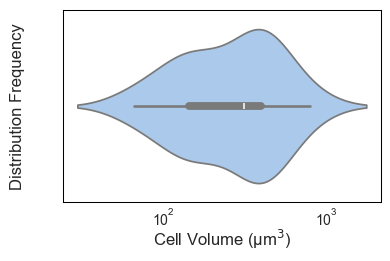

In [444]:
#visualize results - sum of um^3 volume as violin plot


plt.figure() #this creates a new figure on which your plot will appear

#make the tick labels closer to the axes/spine
    #see: https://github.com/matplotlib/matplotlib/issues/17208
mpl.rcParams['xtick.top'] = False
mpl.rcParams['xtick.labeltop'] = False 
mpl.rcParams['xtick.major.pad'] = -2.25
mpl.rcParams['xtick.minor.pad'] = -2.25
mpl.rcParams['ytick.major.pad'] = -2.25
mpl.rcParams['ytick.minor.pad'] = -2.25

#change height and width of dataset
#ax = plt.figure(figsize=(4.373,2.6))
ax = plt.figure(figsize=(4.1,2.5))
ax = sns.set_style("whitegrid")
plt.grid(False)


#ECs only
#sum_all_dataframes_concat_diameter =all_dataframes_concat_diameter[all_dataframes_concat_diameter['label'].isin(index_keep_ECs)].groupby('label').sum().copy()
#sum_all_dataframes_concat_diameter =all_dataframes_concat_diameter[all_dataframes_concat_diameter['label'].isin(index_keep_ECs_good)].groupby('label').sum().copy()
sum_all_dataframes_concat_diameter =all_dataframes_concat_diameter[all_dataframes_concat_diameter['label'].isin(index_keep_ECs_good2)].groupby('label').sum().copy()

#SAME CODE TO MAKE ALL CELLS AND EC ONLY -- VARIABLE VALUE CHANGES ACCORDING TO ABOVE 
sum_all_dataframes_concat_diameter = sum_all_dataframes_concat_diameter.reset_index() # need to reset index
#recalculate after resetting index
sum_all_dataframes_concat_diameter['surface_area_nm2_summed_recalc'] = sum_all_dataframes_concat_diameter['surface_area']*(17*70)
sum_all_dataframes_concat_diameter['volume_nm3_summed_recalc'] = sum_all_dataframes_concat_diameter['area']*(17*17*70)
sum_all_dataframes_concat_diameter['nm_SA_vol_ratio'] = sum_all_dataframes_concat_diameter['surface_area_nm2_summed_recalc'] / sum_all_dataframes_concat_diameter['volume_nm3_summed_recalc']

sum_all_dataframes_concat_diameter['volume_um3_summed_recalc'] = sum_all_dataframes_concat_diameter['volume_nm3_summed_recalc'] * 1e-9

#add cut =0 to only keep values above 0 
ax = sns.violinplot(data=sum_all_dataframes_concat_diameter['volume_um3_summed_recalc'], color=sns.color_palette("pastel")[0], log_scale=10, orient='h') #pastel blue

plt.xlabel('Cell Volume (µm$^3$)',fontname="Arial", fontsize=12)
plt.ylabel('Distribution Frequency',fontname="Arial", fontsize=12)
#plt.ticklabel_format()
plt.xticks(fontsize=10, fontname="Arial",)
plt.xticks(fontsize=10, fontname="Arial",)

#put x-label closer to x-axes ticks. set xlabels first. 
    #see: https://github.com/matplotlib/matplotlib/issues/17208
ax.xaxis.labelpad = -0.75
ax.yaxis.labelpad = 24.50
'''
#set x and y limits to not span whole width so there is space for scale
#get default  xlim and ylim values to keep consistent between figures
current_xlim_min, current_xlim_max = ax.get_xlim()
current_ylim_min, current_ylim_max = ax.get_ylim()
#print(current_xlim_min, current_xlim_max)
#plt.xlim(current_xlim_min, 1e4) 
plt.xlim(0.8e2, 1.2e4) 
#plt.ylim(current_ylim_min, 3.7e9)
#set scale to 1e9
#plt.ticklabel_format(axis='both', style='sci', scilimits=(9,9))

ax.set_xticks([1e2, 1e3)
'''



#set y-minimum value so that it does not go below zero
#plt.ylim(0)


#render figure text as font rather than path
plt.rcParams['svg.fonttype'] = 'none'

#see for iterating over all spines: https://community.dataquest.io/t/iterate-over-ax-spines-items-and-related-functions/233432/
for key,spine in ax.spines.items():
    spine.set_color('#000000')
    spine.set_linewidth(0.75)


#export figure as svg for illustrator figure
#plt.savefig("volume-total-nm3_pastel-blue_log_good.svg", format="svg", bbox_inches='tight')
#plt.savefig("volume-total-nm3_pastel-blue_log_good2.svg", format="svg", bbox_inches='tight')
#plt.savefig("volume-total-um3_pastel-blue_log_good3.svg", format="svg", bbox_inches='tight')
plt.savefig("volume-total-um3_pastel-blue_log_good4.svg", format="svg", bbox_inches='tight')


#display histogram
plt.show()




C:\Users\SM\AppData\Local\Temp\ipykernel_19500\3164612916.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ylabels)


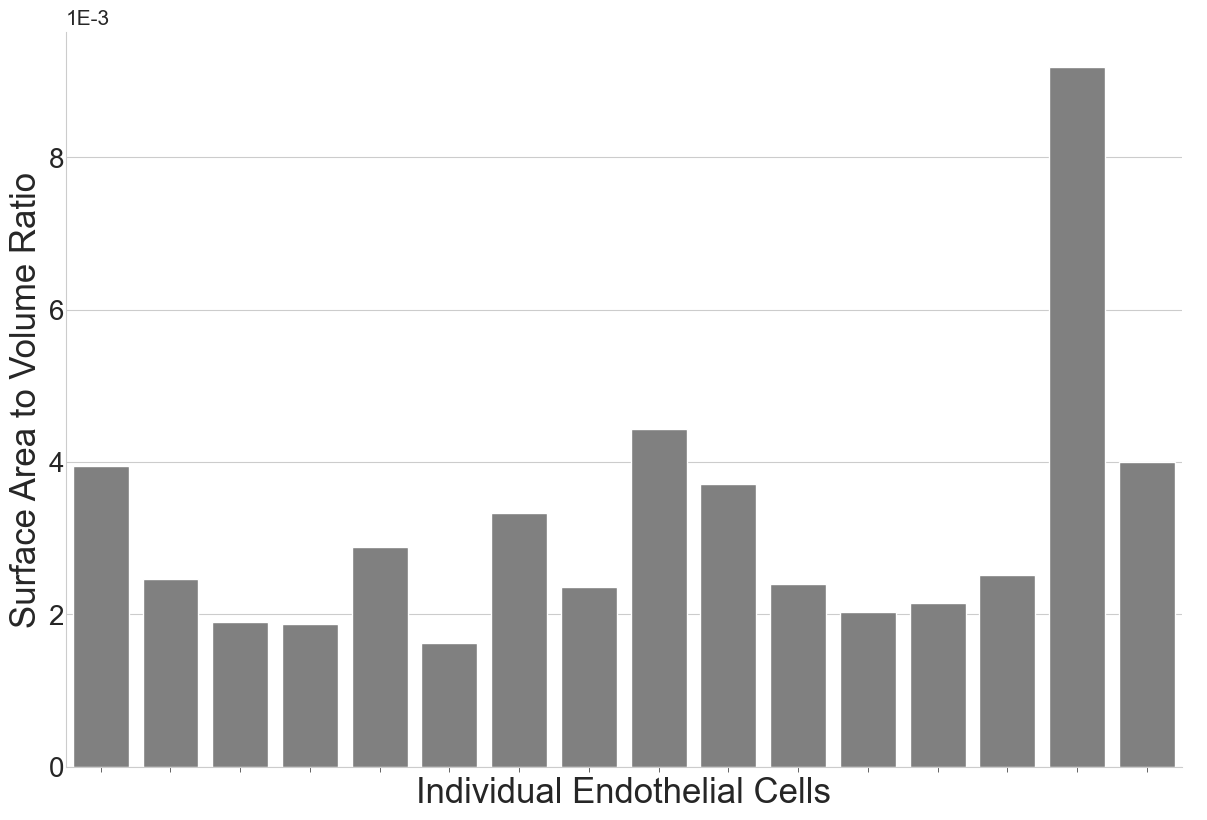

In [74]:
#visualize results - sum of SA (nm^2):VOLUME (nm^3) RATIO volume


#ECs only
#sum_all_dataframes_concat_diameter =all_dataframes_concat_diameter[all_dataframes_concat_diameter['label'].isin(index_keep_ECs)].groupby('label').sum().copy()
#sum_all_dataframes_concat_diameter =all_dataframes_concat_diameter[all_dataframes_concat_diameter['label'].isin(index_keep_ECs_good)].groupby('label').sum().copy()
sum_all_dataframes_concat_diameter =all_dataframes_concat_diameter[all_dataframes_concat_diameter['label'].isin(index_keep_ECs_good2)].groupby('label').sum().copy()


#SAME CODE TO MAKE ALL CELLS AND EC ONLY -- VARIABLE VALUE CHANGES ACCORDING TO ABOVE 
sum_all_dataframes_concat_diameter = sum_all_dataframes_concat_diameter.reset_index() # need to reset index
#recalculate after resetting index
sum_all_dataframes_concat_diameter['surface_area_nm2_summed_recalc'] = sum_all_dataframes_concat_diameter['surface_area']*(17*70)
sum_all_dataframes_concat_diameter['volume_nm3_summed_recalc'] = sum_all_dataframes_concat_diameter['area']*(17*17*70)
sum_all_dataframes_concat_diameter['nm_SA_vol_ratio'] = sum_all_dataframes_concat_diameter['surface_area_nm2_summed_recalc'] / sum_all_dataframes_concat_diameter['volume_nm3_summed_recalc']

ax = sns.catplot(data=sum_all_dataframes_concat_diameter, x='label', y='nm_SA_vol_ratio', kind='bar', height = 8, aspect = 1.5, color='gray')


plt.xlabel('Individual Endothelial Cells',fontsize=25)
plt.ylabel('Surface Area to Volume Ratio',fontsize=25)
#plt.ticklabel_format()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


for ax in ax.axes.flatten():
    plt.ticklabel_format(style='plain', axis='y',useOffset=False)

#change formatting and add superscript to top. replace with nothing except for 0 needs to be reformatted so replace e+00 for that y-tick-val
y_ticks = ax.axes.get_yticks()
ylabels = [( '{:,.0e}'.format(y).replace("e-03","")).replace("e+00","") for y in y_ticks]
ax.set_yticklabels(ylabels)                 

#add exponent multiplier to the top using ax.text
ax.text(0, 1.01, "1E-3",transform=ax.transAxes, fontsize=15)


#manually override the cell labels from the numbers to letters

#combine the lower and upper case letters into one list as there are more than 26 ECs (but less than 26*2; two sets of 26 alphabet letters)

#all_letters = string.ascii_uppercase+string.ascii_lowercase
#print(all_letters)

#xticklabels_letters = all_letters[0:len(index_keep_ECs)]
#xticklabels_letters = all_letters[0:len(index_keep_ECs_good)]
#xticklabels_letters = all_letters[0:len(index_keep_ECs_good2)]

#ax.set_xticklabels(xticklabels_letters)

#ax.set_xticklabels(xticklabels_letters)
ax.set_xticklabels([]) #remove tick labels

ax.tick_params(left=False, bottom=True, width=0.5)  # add vertical tick lines


#display histogram
plt.show()


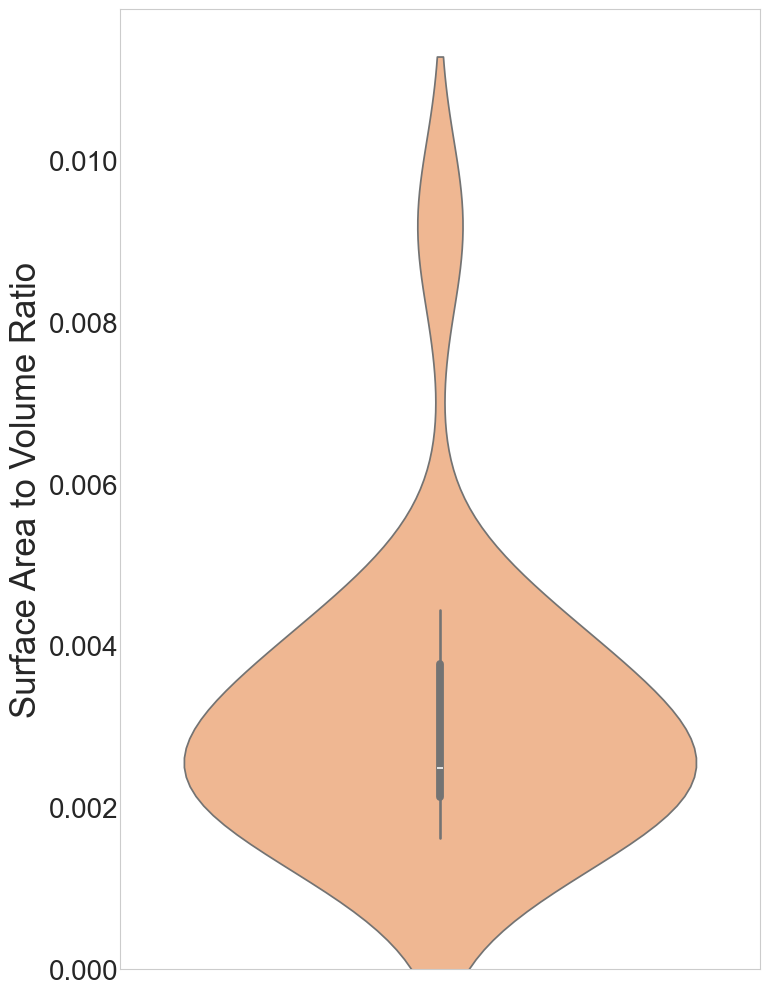

In [72]:
#visualize results - sum of SA (nm^2):VOLUME (nm^3) RATIO volume as violin plot


#fix the plot dimensions so you can read the long text
    #need to call plt before sns, otherwise have a gray bg
plt.subplots_adjust(left=0,bottom=0,right=1,top=2,wspace=0,hspace=0)


plt.grid(False)



#ECs only
#sum_all_dataframes_concat_diameter =all_dataframes_concat_diameter[all_dataframes_concat_diameter['label'].isin(index_keep_ECs)].groupby('label').sum().copy()
#sum_all_dataframes_concat_diameter =all_dataframes_concat_diameter[all_dataframes_concat_diameter['label'].isin(index_keep_ECs_good)].groupby('label').sum().copy()
sum_all_dataframes_concat_diameter =all_dataframes_concat_diameter[all_dataframes_concat_diameter['label'].isin(index_keep_ECs_good2)].groupby('label').sum().copy()

#SAME CODE TO MAKE ALL CELLS AND EC ONLY -- VARIABLE VALUE CHANGES ACCORDING TO ABOVE 
sum_all_dataframes_concat_diameter = sum_all_dataframes_concat_diameter.reset_index() # need to reset index
#recalculate after resetting index
sum_all_dataframes_concat_diameter['surface_area_nm2_summed_recalc'] = sum_all_dataframes_concat_diameter['surface_area']*(17*70)
sum_all_dataframes_concat_diameter['volume_nm3_summed_recalc'] = sum_all_dataframes_concat_diameter['area']*(17*17*70)
sum_all_dataframes_concat_diameter['nm_SA_vol_ratio'] = sum_all_dataframes_concat_diameter['surface_area_nm2_summed_recalc'] / sum_all_dataframes_concat_diameter['volume_nm3_summed_recalc']


#add cut =0 to only keep values above 0
#don't use cut=0 as there are no values between min value and 0
ax = sns.violinplot(data=sum_all_dataframes_concat_diameter['nm_SA_vol_ratio'], color=sns.color_palette("pastel")[1],) #pastel orange



#plt.xlabel('Cell ID',fontsize=25)
plt.ylabel('Surface Area to Volume Ratio',fontsize=25)
#plt.ticklabel_format()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)



#set y-minimum value so that it does not go below zero
plt.ylim(0)

#render figure text as font rather than path
plt.rcParams['svg.fonttype'] = 'none'

#export figure as svg for illustrator figure
#plt.savefig("SA-volume-ratio-nm_pastel-orange_good.svg", format="svg", bbox_inches='tight')
#plt.savefig("SA-volume-ratio-nm_pastel-orange_good2.svg", format="svg", bbox_inches='tight')


#display histogram
plt.show()

In [ ]:
#Now remove bad slices

In [226]:
all_df_EDT_combined = pd.read_csv('df_EDT_all-cells_complete.csv', index_col=0)
all_dataframes_concat_diameter= pd.read_csv('df_mean-intensity-per-slice+all_diameter+SA+VOL.csv',index_col=0)


#remove slices with bands and black artifacts deposits/damage/warping/cropping: 6, 11, 18,  32, 48, 54, 83, 145, 227,228, 263, 305,311

remove_slices_list = [6, 11, 18,  32, 48, 54, 83, 102, 145, 227, 228, 263, 305, 311]

#make a copy of the dataframe to be cleaned
#need to reset index too, or else doesn't work for the diameter/morphometric file

all_df_EDT_combined_no_bad_slices = all_df_EDT_combined.copy()
#all_df_EDT_combined_no_bad_slices = all_df_EDT_combined.reset_index().copy()

#all_dataframes_concat_diameter_no_bad_slices = all_dataframes_concat_diameter.copy()
all_dataframes_concat_diameter_no_bad_slices = all_dataframes_concat_diameter.reset_index().copy()



for each_bad_slice in remove_slices_list:
    print(each_bad_slice)
    #make a short-name for the variable for ease of understanding
    cleaned_dataframe_edt = all_df_EDT_combined_no_bad_slices
    cleaned_dataframe = all_dataframes_concat_diameter_no_bad_slices
    
    
    #clean the dataframe by removing the bad slices
    all_df_EDT_combined_no_bad_slices = cleaned_dataframe_edt.drop(cleaned_dataframe_edt[cleaned_dataframe_edt['z-slice']== each_bad_slice].index)
    all_dataframes_concat_diameter_no_bad_slices = cleaned_dataframe.drop(cleaned_dataframe[cleaned_dataframe['z-slice']== each_bad_slice].index)
    


6
11
18
32
48
54
83
102
145
227
228
263
305
311


In [227]:
#save datasets with morphological data (diameter) and EDT data with no bad slices 
#all_df_EDT_combined_no_bad_slices.to_csv('df_EDT_all-cells_complete_no_bad_slices.csv', index=True)
#all_dataframes_concat_diameter_no_bad_slices.to_csv('df_mean-intensity-per-slice+all_diameter+SA+VOL_no_bad_slices.csv', index=True)

#comment out to prevent overwriting

In [75]:
#read in dataset
#all_df_EDT_combined_no_bad_slices = pd.read_csv("C:/Users/Z6/Desktop/3DSEM/Stefan/1.AT/2.June20_v4_final-fr-with-vess2-small-408R/11.analysis-aligned/3.py/df_EDT_all-cells_complete_no_bad_slices.csv", index_col=0)
#all_dataframes_concat_diameter_no_bad_slices = pd.read_csv("C:/Users/Z6/Desktop/3DSEM/Stefan/1.AT/2.June20_v4_final-fr-with-vess2-small-408R/11.analysis-aligned/3.py/df_mean-intensity-per-slice+all_diameter+SA+VOL_no_bad_slices.csv", index_col=0)


all_df_EDT_combined_no_bad_slices = pd.read_csv("df_EDT_all-cells_complete_no_bad_slices.csv", index_col=0)
all_dataframes_concat_diameter_no_bad_slices = pd.read_csv("df_mean-intensity-per-slice+all_diameter+SA+VOL_no_bad_slices.csv", index_col=0)


In [76]:
all_dataframes_list_nps_cell = []

# only consider values that are in the EC index
index_keep_ECs = [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34]


for each_cell in index_keep_ECs:
    current_cell_label = each_cell
    #print(current_cell_label)
    
    #get mean intensity per slice for specific cell label
    mean_intensity_per_cell_per_slice = all_dataframes_concat_diameter_no_bad_slices.loc[(all_dataframes_concat_diameter_no_bad_slices['label']==current_cell_label), ['z-slice','mean_intensity']]
      
    #put this data (mean intensity per slice for specific cell label) into a dataframe
    current_cell_df = pd.DataFrame(mean_intensity_per_cell_per_slice)
    #print(len(current_cell_df))
    
    
    #insert label column at the beginning of the row
    current_cell_df_label = pd.DataFrame(np.insert(current_cell_df, 0, current_cell_label, axis=1), columns=['label','z-slice','mean-intensity'])

    #good pairing when subdivided, looks good:
    np_per_cell_per_slice = all_df_EDT_combined_no_bad_slices.loc[((all_df_EDT_combined_no_bad_slices['lowest-EDT_nm']==0) & (all_df_EDT_combined_no_bad_slices['cell-lowest-EDT']==current_cell_label)), ['cell-lowest-EDT', 'z-slice']]
    grouped_count_df = pd.DataFrame(np_per_cell_per_slice.groupby(['z-slice']).count())
    
    
    #grouped_count_df
    #copy number of NPs per cell (size/counts of cell-lowest-EDT) values using groupby. 
    current_cell_df_label['np-per-cell'] = grouped_count_df.groupby('z-slice')['cell-lowest-EDT'].transform('first')
    #print(mean_intensity_per_cell_per_slice['mean_intensity'].tolist())
    
   
    
    #append current dataframe to the list of dataframes. At the end, sort by label to plot data for each cell. 
    all_dataframes_list_nps_cell.append(current_cell_df_label)

    
all_dataframes_list_nps_cell_concat_no_bad_slices = pd.concat(all_dataframes_list_nps_cell,ignore_index=True,axis=0)


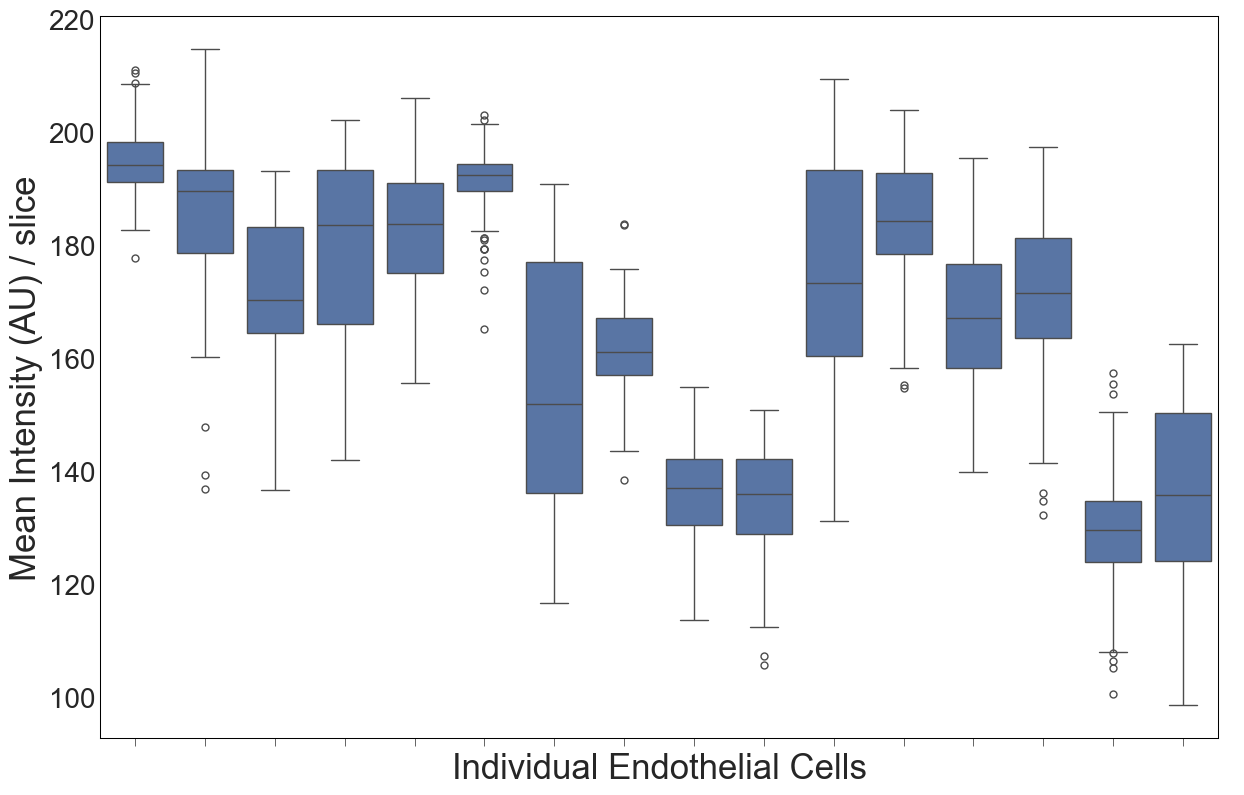

In [477]:
#visualize results - mean intensity

#data to use after removing bad slices
#data_to_use = all_dataframes_list_nps_cell_concat_no_bad_slices[all_dataframes_list_nps_cell_concat_no_bad_slices['label'].isin(index_keep_ECs)]
#data_to_use = all_dataframes_list_nps_cell_concat_no_bad_slices[all_dataframes_list_nps_cell_concat_no_bad_slices['label'].isin(index_keep_ECs_good)]
data_to_use = all_dataframes_list_nps_cell_concat_no_bad_slices[all_dataframes_list_nps_cell_concat_no_bad_slices['label'].isin(index_keep_ECs_good2)]

#subset of EC only
index_keep_ECs = [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34]    
ax = sns.catplot(data=data_to_use, x='label',y='mean-intensity', kind='box', height = 8, aspect = 1.5)

#turn off grid
plt.grid(False)
#sns.set_style("whitegrid", {'axes.grid' : False})

#specfiy axis labels
#ax.set(xlabel='Individual Endothelial Cells',
#       ylabel='Mean Intensity (AU) / slice',size =25)

plt.xlabel('Individual Endothelial Cells',fontsize=25)
plt.ylabel('Mean Intensity (AU) / slice',fontsize=25)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

#ax.set_xticklabels(xticklabels_letters)
ax.set_xticklabels([]) #remove tick labels

ax.tick_params(left=False, bottom=True, width=0.5)  # add vertical tick lines

#render figure text as font rather than path
plt.rcParams['svg.fonttype'] = 'none'

#see for iterating over all spines: https://community.dataquest.io/t/iterate-over-ax-spines-items-and-related-functions/233432/
for ax in ax.axes.ravel():
    for key,spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_color('#000000')
        spine.set_linewidth(0.75)
    
#export figure as svg for illustrator figure
#plt.savefig("mean_intensity_per_slice_good.svg", format="svg", bbox_inches='tight')
#plt.savefig("mean_intensity_per_slice_good2.svg", format="svg", bbox_inches='tight')
plt.savefig("mean_intensity_per_slice_good3.svg", format="svg", bbox_inches='tight')

#display histogram
plt.show()

C:\Users\SM\AppData\Local\Temp\ipykernel_19500\745029535.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ylabels)


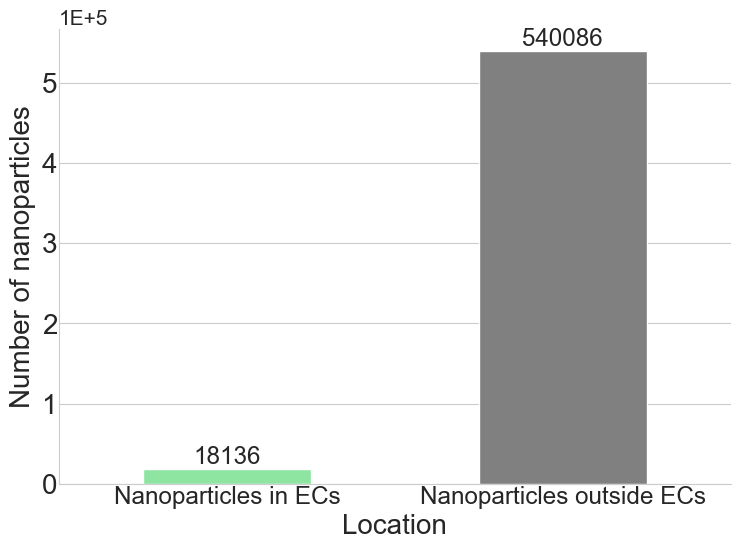

In [80]:
#redo for only good slices

#get number of NPs inside cells
    # this is only inside of ECs since the column for 'cell-lowest-EDT' only considers EC cells in the list index_keep_ECs

nps_inside_cells = all_df_EDT_combined_no_bad_slices.loc[(all_df_EDT_combined_no_bad_slices['lowest-EDT_nm']==0), ['NP-label', 'cell-lowest-EDT']]
num_nps_inside_cells = len(nps_inside_cells)

#if the NPs are in the dataset but not inside cells, then they are outside of cells
nps_outside_cells = all_df_EDT_combined_no_bad_slices.loc[(all_df_EDT_combined_no_bad_slices['lowest-EDT_nm']!=0), ['NP-label', 'cell-lowest-EDT']]
num_nps_outside_cells = len(nps_outside_cells)

to_plot = pd.DataFrame(
    {'Nanoparticles in ECs': [num_nps_inside_cells],
     'Nanoparticles outside ECs': [num_nps_outside_cells]}
)



ax = sns.catplot(data=to_plot,kind='bar',color='gray', width=0.5, aspect = 1.5)


#turn off grid
sns.set_style("whitegrid", {'axes.grid' : False})


for ax in ax.axes.flat:
    ax.bar_label(ax.containers[0],fontsize=17.5)

plt.xlabel('Location',fontsize=20)
plt.ylabel('Number of nanoparticles',fontsize=20)
#plt.ticklabel_format()
plt.xticks(fontsize=17.5)
plt.yticks(fontsize=20)

#change formatting and add superscript to top. replace with nothing except for 0 needs to be reformatted so replace e+00 for that y-tick-val
y_ticks = ax.axes.get_yticks()
ylabels = [( '{:,.1f}'.format(y/1e5)).replace(".0","") for y in y_ticks]
ax.set_yticklabels(ylabels)                 

#add exponent multiplier to the top using ax.text
ax.text(0, 1.01, "1E+5",transform=ax.transAxes, fontsize=15)

    
#change colours for each plot

palette = ["#8de5a1", "#cfcfcf"] #pastel green and pastel gray. used Firefox eyedropper to get hexadecimal. Use pastel red for nanoparticle distance

for bars, colors in zip(ax.containers, (palette[0::2], palette[1::2])):
    for bar, color in zip(bars, colors):
        bar.set_facecolor(color)

#render figure text as font rather than path
plt.rcParams['svg.fonttype'] = 'none'

    
#export figure as svg for illustrator figure
#plt.savefig("number-of-NPs_inside-outside.svg", format="svg", bbox_inches='tight')
    
    
#display histogram
plt.show()

<Figure size 700x700 with 0 Axes>

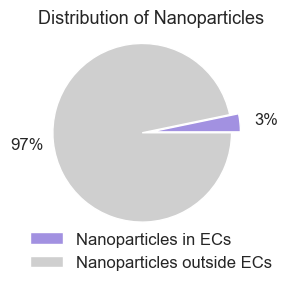

In [456]:
#make as pie chart

#redo for only good slices

#get number of NPs inside cells
    # this is only inside of ECs since the column for 'cell-lowest-EDT' only considers EC cells in the list index_keep_ECs

nps_inside_cells = all_df_EDT_combined_no_bad_slices.loc[(all_df_EDT_combined_no_bad_slices['lowest-EDT_nm']==0), ['NP-label', 'cell-lowest-EDT']]
num_nps_inside_cells = len(nps_inside_cells)

#if the NPs are in the dataset but not inside cells, then they are outside of cells
nps_outside_cells = all_df_EDT_combined_no_bad_slices.loc[(all_df_EDT_combined_no_bad_slices['lowest-EDT_nm']!=0), ['NP-label', 'cell-lowest-EDT']]
num_nps_outside_cells = len(nps_outside_cells)

to_plot = pd.DataFrame(
    {'Nanoparticles in ECs': [num_nps_inside_cells],
     'Nanoparticles outside ECs': [num_nps_outside_cells]}
)
#num_nps_inside_cells


#visualize results - sum of nm^3 volume


#pie chart

plt.figure() #this creates a new figure on which your plot will appear

#change height and width of dataset
ax = plt.figure(figsize=(3.9,2.9))
ax = sns.set_style("whitegrid")
plt.grid(False)

#plt.pie(data=to_plot.values[0], labels= to_plot.columns, autopct='%.0f%%') 

explode_list = [0, 0.1]

#change colours for each plot
palette = ["#A291E1", "#cfcfcf"] #pastel green and pastel gray. used Firefox eyedropper to get hexadecimal. Use pastel red for nanoparticle distance

#plt.pie(x=to_plot.values[0], labels=to_plot.columns, autopct='%.0f%%', colors =palette, explode = explode_list,pctdistance=1.2) 
plt.pie(x=to_plot.values[0], labels=None, autopct='%.0f%%', colors =palette, explode = explode_list,pctdistance=1.3) 

#plt.legend( fancybox=True,labels=to_plot.columns, shadow = False, borderaxespad=False, frameon=False, bbox_to_anchor=(1.1, 0)) #loc="lower center",
plt.legend( fancybox=True,labels=to_plot.columns, shadow = False, borderaxespad=False, frameon=False, loc="lower center",bbox_to_anchor=(0.5, -0.15), fontsize=12)

#turn off grid
sns.set_style("whitegrid", {'axes.grid' : False})

# Add a title
plt.title("Distribution of Nanoparticles", loc="center", y=0.95, fontsize=13)
    

#for bars, colors in zip(ax.containers, (palette[0::2], palette[1::2])):
#    for bar, color in zip(bars, colors):
#        bar.set_facecolor(color)

#render figure text as font rather than path
plt.rcParams['svg.fonttype'] = 'none'

    
#export figure as svg for illustrator figure
#plt.savefig("number-of-NPs_inside-outside_pie.svg", format="svg", bbox_inches='tight')
plt.savefig("number-of-NPs_inside-outside_pie_v2.svg", format="svg", bbox_inches='tight')
    
    
#display histogram
plt.show()

In [82]:
total_nps = num_nps_inside_cells + num_nps_outside_cells
#total_nps

#what percentage of NPs are inside ECs? outside ECs?
print(num_nps_inside_cells/total_nps*100, "% of NPs in the dataset are inside ECs")
print(num_nps_outside_cells/total_nps*100, "% of NPs in the dataset are inside ECs")

3.248886643665065 % of NPs in the dataset are inside ECs
96.75111335633494 % of NPs in the dataset are inside ECs


In [83]:
sns.color_palette("pastel",15)

[(0.6313725490196078, 0.788235294117647, 0.9568627450980393),
 (1.0, 0.7058823529411765, 0.5098039215686274),
 (0.5529411764705883, 0.8980392156862745, 0.6313725490196078),
 (1.0, 0.6235294117647059, 0.6078431372549019),
 (0.8156862745098039, 0.7333333333333333, 1.0),
 (0.8705882352941177, 0.7333333333333333, 0.6078431372549019),
 (0.9803921568627451, 0.6901960784313725, 0.8941176470588236),
 (0.8117647058823529, 0.8117647058823529, 0.8117647058823529),
 (1.0, 0.996078431372549, 0.6392156862745098),
 (0.7254901960784313, 0.9490196078431372, 0.9411764705882353),
 (0.6313725490196078, 0.788235294117647, 0.9568627450980393),
 (1.0, 0.7058823529411765, 0.5098039215686274),
 (0.5529411764705883, 0.8980392156862745, 0.6313725490196078),
 (1.0, 0.6235294117647059, 0.6078431372549019),
 (0.8156862745098039, 0.7333333333333333, 1.0)]

In [84]:
#a1c9f4, #pastel blue

#ff9f9b #pastel red

#cfcfcf #pastel gray

#fffea3 #pastel yellow

#8de5a1 #pastel green

In [85]:
#Do Transport Score (t-score) here
# transport score is a score for each endothelial cell in the annotated dataset
# t-score calculated as sum of all NP sub t-scores
    # sub t-score of 1 is assigned for each NP inside the cell
    # sub t-score of 1/distance is assigned for each NP closest to the cell but not within the cell

    
# try to do math without for loop so it is faster. instead use slicing

#updated Jan 11 2024 - use file without bad slices for transport score
#all_df_EDT_combined = pd.read_csv("C:/Users/Z6/Desktop/3DSEM/Stefan/1.AT/2.June20_v4_final-fr-with-vess2-small-408R/11.analysis-aligned/3.py/df_EDT_all-cells_complete_no_bad_slices.csv", index_col=0)
all_df_EDT_combined = pd.read_csv("df_EDT_all-cells_complete_no_bad_slices.csv", index_col=0)

#subset of EC only
index_keep_ECs = [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34]
index_keep_ECs_good = [7, 8, 10, 13, 14, 15, 16, 17, 18, 20, 21, 22, 24, 25, 27, 28, 29, 30, 32]
index_keep_ECs_good2 = [7, 8, 10, 13, 14, 15, 16, 17, 18, 20, 21, 22, 24, 25, 27, 28]



In [86]:
#create new column with inverted values of 'lowest-EDT' to later on use for transport score
#test_distance_concat['inverse-lowest-EDT'] = 1/test_distance_concat['lowest-EDT']
all_df_EDT_combined['inverse-lowest-EDT_nm'] = 1/all_df_EDT_combined['lowest-EDT_nm']


In [87]:
#set the value to 1 for lowest-EDT where it is 0
#all_df_EDT_combined.loc[all_df_EDT_combined['lowest-EDT'] == 0,'lowest-EDT'] = 1 # works!

#set the value to 0 for inverse-lowest-EDT where it is inf
all_df_EDT_combined.loc[all_df_EDT_combined['inverse-lowest-EDT_nm'] == np.inf,'inverse-lowest-EDT_nm'] = 0 # works!

#make a new-column for t-score which is a copy of 'inverse-lowest-EDT_nm'
all_df_EDT_combined['transport_score_inv_nm'] = all_df_EDT_combined['inverse-lowest-EDT_nm'].copy()

#now for t-score, set the values of 'inverse-lowest-EDT_nm' =0 to a value of 1
all_df_EDT_combined.loc[all_df_EDT_combined['transport_score_inv_nm'] == 0,'transport_score_inv_nm'] = 1 # works!

In [88]:
#make empty list to store values of transport scores
keep_ECs_t_scores =[] 

for keep_ecs in range(len(index_keep_ECs)):
    current_ec_num = index_keep_ECs[keep_ecs]
    
    #current_ec_sum = np.sum(all_df_EDT_combined.loc[all_df_EDT_combined['cell-lowest-EDT'] == current_ec_num, 'inverse-lowest-EDT'],axis=0)
    #current_ec_sum = np.sum(all_df_EDT_combined.loc[all_df_EDT_combined['cell-lowest-EDT'] == current_ec_num, 'transport_score_inv_nm'],axis=0)
    
    #Jan 10 2024 update
    current_ec_sum = np.sum(all_df_EDT_combined.loc[all_df_EDT_combined['cell-lowest-EDT'] == current_ec_num, 'transport_score_inv_nm'],axis=0)
    
    #print(keep_ecs, index_keep_ECs[keep_ecs]) 
    print("The transport score for EC ", index_keep_ECs[keep_ecs]," is: ", current_ec_sum) 
    keep_ECs_t_scores.append(current_ec_sum)

The transport score for EC  7  is:  212.20193127660048
The transport score for EC  8  is:  606.5691979008174
The transport score for EC  9  is:  51.80692377729123
The transport score for EC  10  is:  476.135974106628
The transport score for EC  11  is:  105.51144052906184
The transport score for EC  12  is:  772.1318470792468
The transport score for EC  13  is:  283.29155274075737
The transport score for EC  14  is:  188.7946239372323
The transport score for EC  15  is:  316.5686620022577
The transport score for EC  16  is:  1271.5765455789178
The transport score for EC  17  is:  2295.115007116663
The transport score for EC  18  is:  611.6755464480685
The transport score for EC  19  is:  356.8996734187288
The transport score for EC  20  is:  1384.0259067545828
The transport score for EC  21  is:  1467.1847025858497
The transport score for EC  22  is:  540.7270459443807
The transport score for EC  23  is:  57.24107908976674
The transport score for EC  24  is:  1127.4796311908922
The tra

In [89]:
#get max and min value for rescaling values before applying to cells for hot/cold visualization of transport score
print("max transport score value: ", np.max(keep_ECs_t_scores))
#print("max transport score value rescaled to uint8 (8-bit): ", np.max(keep_ECs_t_scores).astype(np.uint8)) #rescale value to uint8 for 8bit imageJ
print("min transport score value: ", np.min(keep_ECs_t_scores))
#print("min transport score value rescaled to uint8 (8-bit): ", np.min(keep_ECs_t_scores).astype(np.uint8)) #rescale value to uint8 for 8bit imageJ

#rescale_val = (x - min)/ (max - min) * (255-0) + 0
# simplifies to: rescale_val = (x-min)/(max-min)*255

#appears that I do not need to do this math in a for-loop after all, can just do in the index and it applied element-wise
keep_ECs_t_scores_rescaled_8bit = ((keep_ECs_t_scores-np.min(keep_ECs_t_scores))/( np.max(keep_ECs_t_scores) - np.min(keep_ECs_t_scores))*255).astype(np.uint8)

#don't want to have an empty EC (value =0), so make the value 1 if the value is 0
keep_ECs_t_scores_rescaled_8bit[keep_ECs_t_scores_rescaled_8bit == 0] = 1 #this works


print(keep_ECs_t_scores)
print()
print(keep_ECs_t_scores_rescaled_8bit)

max transport score value:  3653.8021551885886
min transport score value:  5.0058573540891995
[212.20193127660048, 606.5691979008174, 51.80692377729123, 476.135974106628, 105.51144052906184, 772.1318470792468, 283.29155274075737, 188.7946239372323, 316.5686620022577, 1271.5765455789178, 2295.115007116663, 611.6755464480685, 356.8996734187288, 1384.0259067545828, 1467.1847025858497, 540.7270459443807, 57.24107908976674, 1127.4796311908922, 692.343267039872, 598.2258988239561, 1066.9530510234104, 202.78390428043087, 42.62052206465093, 5.0058573540891995, 36.298047085296226, 3653.8021551885886, 5.0950815933195015]

[ 14  42   3  32   7  53  19  12  21  88 160  42  24  96 102  37   3  78
  48  41  74  13   2   1   2 255   1]


In [90]:
#lastly read in the EC-only annotated mask dataset and replace values from EC-index with the transport score
# can also read in original dataset and set all non-EC values to 0 (i.e. values not in index_keep_ECs are set to 0)
# can for-loop through each material from 0-max number of materials
    # if the material is in the index_keep_ECs, then replace with respective transport score. 
    # if the material IS NOT in the index_keep_ECs, then replace with 0 (remove the material)

#keep it simple and use file with only annotated EC (annotated_EC_only)
annotated_EC_only = io.imread("C:/Users/Z6/Desktop/3DSEM/Stefan/1.AT/2.June20_v4_final-fr-with-vess2-small-408R/11.analysis-aligned/3.py/new_num_annotated_EC_only_8bit.tif", plugin="tifffile")


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Z6\\Desktop\\3DSEM\\Stefan\\1.AT\\2.June20_v4_final-fr-with-vess2-small-408R\\11.analysis-aligned\\3.py\\new_num_annotated_EC_only_8bit.tif'

In [91]:
#make a copy of the annotated_EC_only dataset which will be used for assigning hot/cold transport scores
annotated_EC_only_8bit_transport = annotated_EC_only
for keep_ecs in range(len(index_keep_ECs)):
    print(keep_ecs,",", index_keep_ECs[keep_ecs],",",keep_ECs_t_scores[keep_ecs],",", keep_ECs_t_scores_rescaled_8bit[keep_ecs]) 
    annotated_EC_only_8bit_transport[annotated_EC_only_8bit_transport == index_keep_ECs[keep_ecs]] = keep_ECs_t_scores_rescaled_8bit[keep_ecs]

NameError: name 'annotated_EC_only' is not defined

In [78]:
#save the rescaled EC-only transport score image
import tifffile
#tifffile.imwrite('new_transport_score_8bit.tif', annotated_EC_only_8bit_transport.astype(np.uint8), bigtiff=True,)
#tifffile.imwrite('new_transport_score_8bit.tif', annotated_EC_only_8bit_transport, bigtiff=True,) #remove np uint8 in case this is causing 1 to appear as 0
    #comment out to prevent overwrite

In [112]:
#output the dataset with the inversed scores column too

#updated Jan 2 2024
#all_df_EDT_combined.to_csv('df_EDT_closest_cell_t-score.csv', index=True, header=True, sep=',')
#comment out to prevent overwrite


In [92]:
#need to do correlation between 2D predicted vs. 3D true NPs/cell - Feb 20 2024

#read in dataset
index_keep_ECs = [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34]    
index_keep_ECs_good = [7, 8, 10, 13, 14, 15, 16, 17, 18, 20, 21, 22, 24, 25, 27, 28, 29, 30, 32]             
index_keep_ECs_good2 = [7, 8, 10, 13, 14, 15, 16, 17, 18, 20, 21, 22, 24, 25, 27, 28]

all_df_EDT_combined_no_bad_slices = pd.read_csv('df_EDT_closest_cell_t-score.csv', index_col=0)


In [93]:
all_df_EDT_combined_no_bad_slices.loc[(all_df_EDT_combined_no_bad_slices['cell-lowest-EDT'] == 33) & (all_df_EDT_combined_no_bad_slices['lowest-EDT_nm'] == 0)]

NP-label  3D-EDT-to-cell-7_nm  3D-EDT-to-cell-8_nm  \
498          499          14736.49902          3837.973633   
505          506          15366.89063          3966.187256   
507          508          13448.38672          2966.826660   
513          514          13111.62988          2655.809082   
516          517          15740.72363          3869.742188   
...          ...                  ...                  ...   
73248      73249          11457.93457          1778.495483   
73249      73250          11513.99316          1799.014160   
115347    115348          13381.62598          4204.603516   
122626    122627          13607.32031          4431.197266   
122631    122632          13254.54102          4412.112305   

        3D-EDT-to-cell-9_nm  3D-EDT-to-cell-10_nm  3D-EDT-to-cell-11_nm  \
498             9304.597656           3031.003906           3036.792969   
505             9319.685547           3095.861816           3575.055908   
507             9018.548828           2772.269775           1872.847290   
513             8856.711914           2601.741943           1533.384521   
516             9093.660156           2881.430908           3594.042969   
...                     ...                   ...                   ...   
73248           6053.394043            967.630127           1005.715637   
73249           5943.157227            915.607422            943.859131   
115347          4621.656250           1314.000000           1567.278564   
122626          4899.316895           1635.129639           1237.048950   
122631          4777.363770           1374.834473           1683.353760   

        3D-EDT-to-cell-12_nm  3D-EDT-to-cell-13_nm  3D-EDT-to-cell-14_nm  \
498             10277.951170           3626.083740          17683.710940   
505             10107.647460           3424.750488          17011.343750   
507             10427.965820           3874.078857          18512.539060   
513             10393.668950           3845.514404          18577.111330   
516              9841.935547           3087.524170          16248.496090   
...                      ...                   ...                   ...   
73248            7216.269531           4248.558105          17504.330080   
73249            7068.663574           4056.471924          17320.664060   
115347           3957.935547            387.659637           7567.165039   
122626           3726.014648             74.013519           7712.136230   
122631           3880.175049            357.000000           7200.958496   

        3D-EDT-to-cell-15_nm  ...  3D-EDT-to-cell-32_nm  3D-EDT-to-cell-33_nm  \
498              25889.08203  ...           9564.475586                   0.0   
505              25314.66406  ...          10281.978520                   0.0   
507              26509.74023  ...           8198.601563                   0.0   
513              26515.82813  ...           7870.394043                   0.0   
516              24608.65820  ...          10779.782230                   0.0   
...                      ...  ...                   ...                   ...   
73248            25326.21289  ...           7911.091797                   0.0   
73249            25138.12109  ...           8028.723633                   0.0   
115347           15295.28711  ...          10334.086910                   0.0   
122626           15541.47852  ...          10450.770510                   0.0   
122631           14978.57324  ...          10448.890630                   0.0   

        3D-EDT-to-cell-34_nm  lowest-EDT_nm  cell-lowest-EDT  z-slice  \
498              4153.638184            0.0               33        0   
505              3672.706299            0.0               33        0   
507              4773.155273            0.0               33        0   
513              4817.481934            0.0               33        0   
516              3048.122070            0.0               33        0   
...                      ...          

In [94]:
#Are most NPs in cells or outside of cells?
np_per_cell_per_slice = all_df_EDT_combined_no_bad_slices.loc[(all_df_EDT_combined_no_bad_slices['lowest-EDT_nm']==0), ['cell-lowest-EDT', 'z-slice']]


In [95]:
#Are most NPs in cells or outside of cells?

np_per_cell_per_slice = all_df_EDT_combined_no_bad_slices.loc[(all_df_EDT_combined_no_bad_slices['lowest-EDT_nm']==0), ['cell-lowest-EDT', 'z-slice']]

#sort columns based on cell-lowest EDT and then by z-slice
np_per_cell_per_slice = np_per_cell_per_slice.sort_values(by=['cell-lowest-EDT', 'z-slice']).reset_index()
np_per_cell_per_slice

#remove index column
np_per_cell_per_slice = np_per_cell_per_slice.drop(columns=['index'])


np_per_cell_per_slice


#get correct numbers when using size instead of count -- compare to values for 1 column 
np_per_cell_per_slice = pd.DataFrame(np_per_cell_per_slice.groupby(['cell-lowest-EDT','z-slice']).size().reset_index())

#rename column
np_per_cell_per_slice.rename(columns={0:'num_nps_per-slice-of-cell'}, inplace=True)
np_per_cell_per_slice



cell-lowest-EDT  z-slice  num_nps_per-slice-of-cell
0                   7        2                          4
1                   7        3                          5
2                   7        4                          4
3                   7        7                          2
4                   7        8                          3
...               ...      ...                        ...
2946               33       85                          1
2947               33       89                          2
2948               34        0                          1
2949               34        5                          3
2950               34        8                          1

[2951 rows x 3 columns]

In [96]:
#put total number of slices as a new column using mapping, as per above code

np_per_cell_per_slice_projected = np_per_cell_per_slice.copy()
np_per_cell_per_slice_projected['num_slices_per_cell-label'] = np_per_cell_per_slice_projected['cell-lowest-EDT'].map(label_and_num_slices_all_cells.set_index('label')['index_manual'])
np_per_cell_per_slice_projected
#this works

cell-lowest-EDT  z-slice  num_nps_per-slice-of-cell  \
0                   7        2                          4   
1                   7        3                          5   
2                   7        4                          4   
3                   7        7                          2   
4                   7        8                          3   
...               ...      ...                        ...   
2946               33       85                          1   
2947               33       89                          2   
2948               34        0                          1   
2949               34        5                          3   
2950               34        8                          1   

      num_slices_per_cell-label  
0                           214  
1                           214  
2                           214  
3                           214  
4                           214  
...                         ...  
2946                        106  
2947                        106  
2948                         25  
2949                         25  
2950                         25  

[2951 rows x 4 columns]

In [97]:
#calculate projected number of NPs
np_per_cell_per_slice_projected['projected_total_NPs_per_cell'] = np_per_cell_per_slice_projected['num_nps_per-slice-of-cell'] * np_per_cell_per_slice_projected['num_slices_per_cell-label']
np_per_cell_per_slice_projected



cell-lowest-EDT  z-slice  num_nps_per-slice-of-cell  \
0                   7        2                          4   
1                   7        3                          5   
2                   7        4                          4   
3                   7        7                          2   
4                   7        8                          3   
...               ...      ...                        ...   
2946               33       85                          1   
2947               33       89                          2   
2948               34        0                          1   
2949               34        5                          3   
2950               34        8                          1   

      num_slices_per_cell-label  projected_total_NPs_per_cell  
0                           214                           856  
1                           214                          1070  
2                           214                           856  
3                           214                           428  
4                           214                           642  
...                         ...                           ...  
2946                        106                           106  
2947                        106                           212  
2948                         25                            25  
2949                         25                            75  
2950                         25                            25  

[2951 rows x 5 columns]

In [98]:
#sum up the total number of NPs in each cell and put as a separate dataframe
    #will need to map this dataframe as a new column onto the other dataframe to get true vs. predicted value of NPs/cell
#this is the correct dataframe, but don't need the z-slice column
sum_np_per_cell_per_slice = np_per_cell_per_slice.groupby(['cell-lowest-EDT']).sum().reset_index()
del sum_np_per_cell_per_slice['z-slice'] 
sum_np_per_cell_per_slice

cell-lowest-EDT  num_nps_per-slice-of-cell
0                 7                        201
1                 8                        579
2                 9                         51
3                10                        468
4                11                        102
5                12                        764
6                13                        273
7                14                        186
8                15                        315
9                16                       1240
10               17                       2255
11               18                        594
12               19                        350
13               20                       1377
14               21                       1442
15               22                        539
16               23                         57
17               24                       1111
18               25                        687
19               27                        574
20               28                       1060
21               29                        194
22               30                         42
23               31                          4
24               32                         36
25               33                       3630
26               34                          5

In [99]:
np_per_cell_per_slice_projected['true_total_NPs-per-cell'] = np_per_cell_per_slice_projected['cell-lowest-EDT'].map(sum_np_per_cell_per_slice.set_index('cell-lowest-EDT')['num_nps_per-slice-of-cell'])
np_per_cell_per_slice_projected

cell-lowest-EDT  z-slice  num_nps_per-slice-of-cell  \
0                   7        2                          4   
1                   7        3                          5   
2                   7        4                          4   
3                   7        7                          2   
4                   7        8                          3   
...               ...      ...                        ...   
2946               33       85                          1   
2947               33       89                          2   
2948               34        0                          1   
2949               34        5                          3   
2950               34        8                          1   

      num_slices_per_cell-label  projected_total_NPs_per_cell  \
0                           214                           856   
1                           214                          1070   
2                           214                           856   
3                           214                           428   
4                           214                           642   
...                         ...                           ...   
2946                        106                           106   
2947                        106                           212   
2948                         25                            25   
2949                         25                            75   
2950                         25                            25   

      true_total_NPs-per-cell  
0                         201  
1                         201  
2                         201  
3                         201  
4                         201  
...                       ...  
2946                     3630  
2947                     3630  
2948                        5  
2949                        5  
2950                        5  

[2951 rows x 6 columns]

<Figure size 700x700 with 0 Axes>

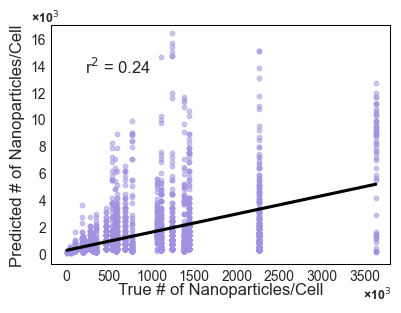

In [449]:
#plot graph of number of nanoparticles per cell from predicted vs. real data

#plot true vs. predicted values as scatterplot and get correlation 


plt.figure() #this creates a new figure on which your plot will appear

#make the tick labels closer to the axes/spine
    #see: https://github.com/matplotlib/matplotlib/issues/17208
mpl.rcParams['xtick.top'] = False
mpl.rcParams['xtick.labeltop'] = False 
mpl.rcParams['xtick.major.pad'] = -2.25
mpl.rcParams['xtick.minor.pad'] = -2.25
mpl.rcParams['ytick.major.pad'] = -2.25
mpl.rcParams['ytick.minor.pad'] = -2.25


#change height and width of dataset
ax = plt.figure(figsize=(4.373,3.1))

ax = sns.set_style("whitegrid")
plt.grid(False)

ax = sns.regplot(data=np_per_cell_per_slice_projected, x="true_total_NPs-per-cell", y="projected_total_NPs_per_cell",line_kws={"color": "black"},scatter_kws={'alpha':0.50,'s':10},color='#A291E1', ci=None)

#purple color hex: A291E1


np_per_cell_per_slice_projected  = np_per_cell_per_slice_projected.fillna(0)

#pearson r and spearman r
#r, p = scipy.stats.pearsonr(x=np_per_cell_per_slice_projected['true_total_NPs-per-cell'], y=np_per_cell_per_slice_projected['projected_total_NPs_per_cell'])
r, p = scipy.stats.spearmanr(a=np_per_cell_per_slice_projected['true_total_NPs-per-cell'], b=np_per_cell_per_slice_projected['projected_total_NPs_per_cell'])


#text_n_r_p = "n = " + str(int(num_np)) + "\n" + "r  = "+str(round(r, 10)) + "\n" + "p = "+str(p)
#text_n_r2_p = "n = " + str(int(num_np)) + "\n"  + "r$^2$ = "+str(round(r**2, 10)) + "\n" + "p = "+str(p)
text_n_r2_p = "n = " + "\n"  + "r$^2$ = "+str(round(r**2, 10)) + "\n" + "p = "+str(p)
text_r2 = "r$^2$ = "+str(round(r**2, 2))


ax.text(0.1, 0.8, text_r2,transform=ax.transAxes, fontname="Arial", size=12)

#ax.set(xlabel='True Number of Nanoparticles/Cell', ylabel='Predicted Number of Nanoparticles/Cell')

plt.xlabel('True # of Nanoparticles/Cell',fontsize=12, fontname="Arial",)
plt.ylabel('Predicted # of Nanoparticles/Cell',fontsize=12, fontname="Arial",)
#plt.ticklabel_format()
plt.xticks(fontsize=10, fontname="Arial",)
plt.yticks(fontsize=10, fontname="Arial",)

#ax.set_xticks([1e2, 1e3, 1e4])
ax.set_yticks(np.arange(0, 18e3, 2e3))
ax.set_xticks(np.arange(0, 4e3, 0.5e3))


#set x and y limits to not span whole width so there is space for scale
#get default  xlim and ylim values to keep consistent between figures
current_xlim_min, current_xlim_max = ax.get_xlim()
current_ylim_min, current_ylim_max = ax.get_ylim()
#print(current_xlim_min, current_xlim_max)
plt.xlim(current_xlim_min, 3.8e3) 
plt.ylim(current_ylim_min, 17e3)

#put x-label closer to x-axes ticks. set xlabels first. 
    #see: https://github.com/matplotlib/matplotlib/issues/17208
ax.xaxis.labelpad = -0.5

#********* START SCALING FACTOR #*********
#scale factor
scale_factor = 1000
exponent_val = len(str(int(scale_factor/10)))

#rescale values by dividing by 10000, 1e4
ax.get_yaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: format(int(x/scale_factor), )))


#add label with scale factor to graph
#see superscripting variable: https://stackoverflow.com/questions/52379803/superscript-for-a-variable
ax.text(-0.06, 1.01, '×10'+r'$^{%.0f}$' % (exponent_val) , transform=ax.transAxes, fontname="Arial", size=9, weight='bold')
ax.text(0.92, -0.15, '×10'+r'$^{%.0f}$' % (exponent_val) , transform=ax.transAxes, fontname="Arial", size=9, weight='bold')


#set scale to 1e3
#plt.ticklabel_format(axis='both', style='sci', scilimits=(3,3))



#********* END SCALING FACTOR #*********

#see for iterating over all spines: https://community.dataquest.io/t/iterate-over-ax-spines-items-and-related-functions/233432/
for key,spine in ax.spines.items():
    spine.set_color('#000000')
    spine.set_linewidth(0.75)

#render figure Stext as font rather than path
plt.rcParams['svg.fonttype'] = 'none'

#export figure as svg for illustrator figure
#plt.savefig("predicted-vs-true_NPs-per-cell_margin.svg", format="svg", bbox_inches='tight')
plt.savefig("predicted-vs-true_NPs-per-cell_margin_v2.svg", format="svg", bbox_inches='tight')


<Figure size 700x700 with 0 Axes>

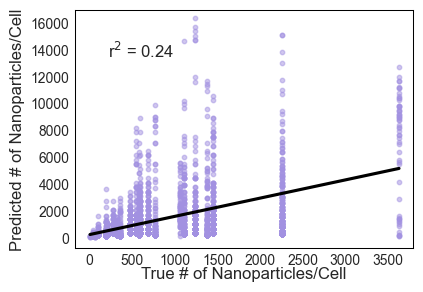

In [450]:
#plot graph of number of nanoparticles per cell from predicted vs. real data

#plot true vs. predicted values as scatterplot and get correlation 


plt.figure() #this creates a new figure on which your plot will appear

#make the tick labels closer to the axes/spine
    #see: https://github.com/matplotlib/matplotlib/issues/17208
mpl.rcParams['xtick.top'] = False
mpl.rcParams['xtick.labeltop'] = False 
mpl.rcParams['xtick.major.pad'] = -2.25
mpl.rcParams['xtick.minor.pad'] = -2.25
mpl.rcParams['ytick.major.pad'] = -2.25
mpl.rcParams['ytick.minor.pad'] = -2.25


#change height and width of dataset
ax = plt.figure(figsize=(4.373,3.1))

ax = sns.set_style("whitegrid")
plt.grid(False)

ax = sns.regplot(data=np_per_cell_per_slice_projected, x="true_total_NPs-per-cell", y="projected_total_NPs_per_cell",line_kws={"color": "black"},scatter_kws={'alpha':0.50,'s':10},color='#A291E1', ci=None)

#purple color hex: A291E1


np_per_cell_per_slice_projected  = np_per_cell_per_slice_projected.fillna(0)

#pearson r and spearman r
#r, p = scipy.stats.pearsonr(x=np_per_cell_per_slice_projected['true_total_NPs-per-cell'], y=np_per_cell_per_slice_projected['projected_total_NPs_per_cell'])
r, p = scipy.stats.spearmanr(a=np_per_cell_per_slice_projected['true_total_NPs-per-cell'], b=np_per_cell_per_slice_projected['projected_total_NPs_per_cell'])


#text_n_r_p = "n = " + str(int(num_np)) + "\n" + "r  = "+str(round(r, 10)) + "\n" + "p = "+str(p)
#text_n_r2_p = "n = " + str(int(num_np)) + "\n"  + "r$^2$ = "+str(round(r**2, 10)) + "\n" + "p = "+str(p)
text_n_r2_p = "n = " + "\n"  + "r$^2$ = "+str(round(r**2, 10)) + "\n" + "p = "+str(p)
text_r2 = "r$^2$ = "+str(round(r**2, 2))


ax.text(0.1, 0.8, text_r2,transform=ax.transAxes, fontname="Arial", size=12)

#ax.set(xlabel='True Number of Nanoparticles/Cell', ylabel='Predicted Number of Nanoparticles/Cell')

plt.xlabel('True # of Nanoparticles/Cell',fontsize=12, fontname="Arial",)
plt.ylabel('Predicted # of Nanoparticles/Cell',fontsize=12, fontname="Arial",)
#plt.ticklabel_format()
plt.xticks(fontsize=10, fontname="Arial",)
plt.yticks(fontsize=10, fontname="Arial",)

#ax.set_xticks([1e2, 1e3, 1e4])
ax.set_yticks(np.arange(0, 18e3, 2e3))
ax.set_xticks(np.arange(0, 4e3, 0.5e3))


#set x and y limits to not span whole width so there is space for scale
#get default  xlim and ylim values to keep consistent between figures
current_xlim_min, current_xlim_max = ax.get_xlim()
current_ylim_min, current_ylim_max = ax.get_ylim()
#print(current_xlim_min, current_xlim_max)
plt.xlim(current_xlim_min, 3.8e3) 
plt.ylim(current_ylim_min, 17e3)

#put x-label closer to x-axes ticks. set xlabels first. 
    #see: https://github.com/matplotlib/matplotlib/issues/17208
ax.xaxis.labelpad = -0.5

#********* START SCALING FACTOR #*********
#scale factor
'''scale_factor = 1000
exponent_val = len(str(int(scale_factor/10)))

#rescale values by dividing by 10000, 1e4
ax.get_yaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: format(int(x/scale_factor), )))


#add label with scale factor to graph
#see superscripting variable: https://stackoverflow.com/questions/52379803/superscript-for-a-variable
ax.text(-0.06, 1.01, '×10'+r'$^{%.0f}$' % (exponent_val) , transform=ax.transAxes, fontname="Arial", size=9, weight='bold')
ax.text(0.92, -0.15, '×10'+r'$^{%.0f}$' % (exponent_val) , transform=ax.transAxes, fontname="Arial", size=9, weight='bold')


#set scale to 1e3
#plt.ticklabel_format(axis='both', style='sci', scilimits=(3,3))
'''

#use scientific notation
    #see: https://stackoverflow.com/questions/69979990/scientific-notation-on-seaborn-catplot-facetgrid-axes

#ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '{0:g}×10$^{{4}}$'.format(x/1e4)))
plt.ticklabel_format(axis="y", style="plain",useOffset=False,)# scilimits=(0,0))




#********* END SCALING FACTOR #*********

#see for iterating over all spines: https://community.dataquest.io/t/iterate-over-ax-spines-items-and-related-functions/233432/
for key,spine in ax.spines.items():
    spine.set_color('#000000')
    spine.set_linewidth(0.75)

#render figure Stext as font rather than path
plt.rcParams['svg.fonttype'] = 'none'

#export figure as svg for illustrator figure
#plt.savefig("predicted-vs-true_NPs-per-cell_margin.svg", format="svg", bbox_inches='tight')
#plt.savefig("predicted-vs-true_NPs-per-cell_margin_v2.svg", format="svg", bbox_inches='tight')
plt.savefig("predicted-vs-true_NPs-per-cell_margin_v3.svg", format="svg", bbox_inches='tight')




In [110]:
#np_per_cell_per_slice_projected['true_total_NPs-per-cell']
#np_per_cell_per_slice_projected['projected_total_NPs_per_cell']


#RSD for number of NPs per cell using predicted 2D values
mean_all_2D_NPs = np_per_cell_per_slice_projected['projected_total_NPs_per_cell'].mean()
std_all_2D_NPs = np_per_cell_per_slice_projected['projected_total_NPs_per_cell'].std()
rsd_all_2D_NPs = std_all_2D_NPs/mean_all_2D_NPs
print("The RSD for number of predicted NPs (2D): ", rsd_all_2D_NPs*100,"%")

#RSD for number of NPs per cell using true 3D values
mean_all_3D_NPs = np_per_cell_per_slice_projected['true_total_NPs-per-cell'].mean()
std_all_3D_NPs = np_per_cell_per_slice_projected['true_total_NPs-per-cell'].std()
rsd_all_3D_NPs = std_all_3D_NPs/mean_all_3D_NPs
print("The RSD for number of true NPs (3D): ", rsd_all_3D_NPs*100,"%")


The RSD for number of predicted NPs (2D):  144.05880387715933 %
The RSD for number of true NPs (3D):  80.343559863546 %


In [111]:
#read in the full dataset
#updated Jan 2 2024
all_df_EDT_combined = pd.read_csv('df_EDT_closest_cell_t-score.csv', index_col=0)


In [112]:
all_df_EDT_combined

NP-label  3D-EDT-to-cell-7_nm  3D-EDT-to-cell-8_nm  \
0              1          68796.39844          15273.59277   
1              2          68600.06250          15038.66309   
2              3          67079.95313          13693.51172   
3              4          67016.51563          13641.23047   
4              5          66895.14063          13526.98438   
...          ...                  ...                  ...   
574886    574887          16417.79688          16599.83008   
574887    574888          16398.58984          16601.71875   
574888    574889          16266.76563          16499.04297   
574889    574890          16589.42578          16755.51172   
574890    574891          16840.20117          16961.93945   

        3D-EDT-to-cell-9_nm  3D-EDT-to-cell-10_nm  3D-EDT-to-cell-11_nm  \
0               63235.89844           58506.18750           58567.34375   
1               62932.21875           58186.86719           58257.55469   
2               61750.96875           57059.13281           57096.19531   
3               61704.20703           57015.19141           57050.60938   
4               61591.77344           56904.30859           56938.69922   
...                     ...                   ...                   ...   
574886          23503.05469           20402.54492           28613.79688   
574887          23501.32617           20395.63867           28600.63867   
574888          23391.50195           20252.87305           28465.21875   
574889          23664.09961           20605.15820           28797.71289   
574890          23880.81055           20881.79297           29056.88867   

        3D-EDT-to-cell-12_nm  3D-EDT-to-cell-13_nm  3D-EDT-to-cell-14_nm  \
0                53622.86719           51787.61719           61350.91406   
1                53327.51563           51485.75781           60967.10547   
2                52338.45313           50549.91016           60141.12500   
3                52300.46094           50514.43750           60111.50781   
4                52201.81250           50418.51953           60012.43359   
...                      ...                   ...                   ...   
574886           22026.15625           29189.99023           30947.19531   
574887           22020.29688           29175.02930           30907.76563   
574888           21877.96289           29030.34570           30749.52539   
574889           22229.40234           29385.15234           31131.53906   
574890           22505.61719           29660.98438           31421.01563   

        3D-EDT-to-cell-15_nm  ...  3D-EDT-to-cell-32_nm  3D-EDT-to-cell-33_nm  \
0                67307.30469  ...           65093.47266           56342.47266   
1                66878.63281  ...           64862.32031           56055.84766   
2                66321.06250  ...           63435.89453           54802.91406   
3                66303.85938  ...           63377.20313           54752.46484   
4                66216.72656  ...           63257.63672           54637.24609   
...                      ...  ...                   ...                   ...   
574886           34492.24219  ...           23096.61914           31762.37500   
574887           34442.52344  ...           23107.13281           31771.58398   
574888           34283.90625  ...           23026.44727           31683.77734   
574889           34664.26172  ...           23230.42969           31904.54492   
574890           34949.33594  ...           23397.77539           32083.23438   

        3D-EDT-to-cell-34_nm  lowest-EDT_nm  cell-lowest-EDT  z-slice  \
0                58079.43750    15273.59277                8        0   
1                57758.58984    15038.66309                8        0   
2                56637.13281    13693.51172                8        0   
3                56593.50391    13641.23047                8        0   
4                56482.84375    13526.98438                8        0   
...                      ...          

In [158]:
#print(annotated_EC_only.shape)
z_shape, y_shape, x_shape = annotated_EC_only.shape
#print(z_shape,y_shape,x_shape)

#make an array that will hold each NP coordinate as it's EDT. Use np.array to fill with zeros
# use uint16 as the distances are less than 2^16 (16bit) but greater than 2^8 (255, 8bit)
    #Jan 10 2024 --> adter checking in Excel, the lowest value is 46174.45313, so 16 bit will work as 16-bit allows up to 65,535
np_distance_at_centroid = np.zeros((z_shape, y_shape, x_shape), dtype=np.uint16)

for each_row in tqdm(all_df_EDT_combined['NP-label']-1): #use this range as it accounts for only the NPs in the dataset after removing bad slices, but subtract 1 to prevent error to keep things in line with 'each_np_plus_1'
    
    each_np_plus_1 = each_row+1
    
    #need to skip NPs that are on bad slices
        #skip the NPs that are not in the column 'NP-label'
        
    #get coordinates of NP with unique value
    z_slice_np = all_df_EDT_combined['z-slice'].loc[all_df_EDT_combined['NP-label'] == each_np_plus_1].values[0]
    y_coord_np = all_df_EDT_combined['centroid,0_16bit'].loc[all_df_EDT_combined['NP-label'] == each_np_plus_1].values[0]
    x_coord_np = all_df_EDT_combined['centroid,1_16bit'].loc[all_df_EDT_combined['NP-label'] == each_np_plus_1].values[0]

    #get coords as a set
    current_np_coords_set = z_slice_np , y_coord_np , x_coord_np
    #print(current_np_coords_set)
    #put label of lowest-EDT at coords of label centroid in np_distance_at_centroid array

    #gives float values, need to convert to integer
    #print(all_df_EDT_combined['lowest-EDT'].loc[all_df_EDT_combined['NP-label'] == each_np_plus_1].values[0])

    #nest in int for coordinates, otherwise I get an error
    np_distance_at_centroid[int(z_slice_np), int(y_coord_np), int(x_coord_np)] = all_df_EDT_combined['lowest-EDT_nm'].loc[all_df_EDT_combined['NP-label'] == each_np_plus_1].values[0]

    
    

100%|█████████████████████████████████████████████████████████████████████████| 558222/558222 [23:42<00:00, 392.32it/s]


In [ ]:
all_df_EDT_combined

In [159]:
#save the NP centroid as EDT 
import tifffile
tifffile.imwrite('new_np-EDT-map_16bit.tif', np_distance_at_centroid, bigtiff=True,) #remove np uint8 in case this is causing 1 to appear as 0


In [160]:
#read in NP centroid as EDT 16bit
np_distance_at_centroid = io.imread("C:/Users/Z6/Desktop/3DSEM/Stefan/1.AT/2.June20_v4_final-fr-with-vess2-small-408R/11.analysis-aligned/3.py/new_np-EDT-map_16bit.tif", plugin="tifffile")


In [161]:
#rescale NP centroid as EDT to 8bit
#get max and min value for rescaling values before applying to NPs for hot/cold distance for visualization
#print("max EDT value: ", np.max(np_distance_at_centroid)) #wrong value
#print("max EDT value: ", max(np_distance_at_centroid.tolist())) # took too much ram to load? unclear why...

#print(max(all_df_EDT_combined['lowest-EDT'])) # this value matches FIJI
#print("min EDT value: ", np.min(np_distance_at_centroid)) #is correct, but not sure if chance


#interestingly, when putting the 16bit image into FIJI, then going to brightness/contrast, the max value is given as 1901.
    # this is the same value given by np.max. Why is this?
        #after playing around, it is because the max value on the first slice of the stack is 1901, but other slices have different max values
        # going to different slices then looking at brightness and contrast results in different max values in the dialog box

#if the max value is wrong, then it is likely that the FIJI values for transport value re-scaling are also incorrect


In [31]:
#this works, but is faster to rescale EDT values in Fiji than python. possibly because of CPU limited in Python by GIL?
# in FIJI, use hot/cold LUT. Is called 'phase'. But need to invert so that red is for low EDT values and blue is for high EDT values (cold)
'''
#how to rescale values
    #rescale_val = (x - min)/ (max - min) * (255-0) + 0
# simplifies to: rescale_val = (x-min)/(max-min)*255


#since the values are incorrect with np.max and np.min, but the values are correct from Fiji voxel stack and the values in the dataframe, manually put in these values
#for FIJI:
# Stack.getStatistics(voxelCount, mean, min, max, stdDev);
#print(voxelCount, mean, min, max, stdDev); // max value is 


#max_np_centroid_EDT = max(all_df_EDT_combined['lowest-EDT'])
max_np_centroid_EDT = max(all_df_EDT_combined['lowest-EDT_nm'])
min_np_centroid_EDT = 0

#appears that I do not need to do this math in a for-loop after all, can just do in the index and it applied element-wise
#np_distance_at_centroid_rescaled_8bit = ((np_distance_at_centroid-np.min(np_distance_at_centroid))/( np.max(np_distance_at_centroid) - np.min(np_distance_at_centroid))*255).astype(np.uint8)
np_distance_at_centroid_rescaled_8bit = ((np_distance_at_centroid - min_np_centroid_EDT)/( max_np_centroid_EDT - min_np_centroid_EDT ) * 255).astype(np.uint8)

#BELOW LINE NOT RELEVANT FOR NP EDT: don't want to have an empty EC (value =0), so make the value 1 if the value is 0
#np_distance_at_centroid_rescaled_8bit[np_distance_at_centroid_rescaled_8bit == 0] = 1 #this works


#print(keep_ECs_t_scores)
#print()
#print(keep_ECs_t_scores_rescaled_8bit)



'''

"\n#how to rescale values\n    #rescale_val = (x - min)/ (max - min) * (255-0) + 0\n# simplifies to: rescale_val = (x-min)/(max-min)*255\n\n\n#since the values are incorrect with np.max and np.min, but the values are correct from Fiji voxel stack and the values in the dataframe, manually put in these values\n#for FIJI:\n# Stack.getStatistics(voxelCount, mean, min, max, stdDev);\n#print(voxelCount, mean, min, max, stdDev); // max value is \n\n\n#max_np_centroid_EDT = max(all_df_EDT_combined['lowest-EDT'])\nmax_np_centroid_EDT = max(all_df_EDT_combined['lowest-EDT_nm'])\nmin_np_centroid_EDT = 0\n\n#appears that I do not need to do this math in a for-loop after all, can just do in the index and it applied element-wise\n#np_distance_at_centroid_rescaled_8bit = ((np_distance_at_centroid-np.min(np_distance_at_centroid))/( np.max(np_distance_at_centroid) - np.min(np_distance_at_centroid))*255).astype(np.uint8)\nnp_distance_at_centroid_rescaled_8bit = ((np_distance_at_centroid - min_np_centroi

In [163]:
#another Python approach. Rescale data to 8-bit as a list, then use this list for each NP. This is faster than applying the rescaling to the data already in the 16-bit numpy array


#how to rescale values
    #rescale_val = (x - min)/ (max - min) * (255-0) + 0
# simplifies to: rescale_val = (x-min)/(max-min)*255


#since the values are incorrect with np.max and np.min, but the values are correct from Fiji voxel stack and the values in the dataframe, manually put in these values
#for FIJI:
# Stack.getStatistics(voxelCount, mean, min, max, stdDev);
#print(voxelCount, mean, min, max, stdDev); // max value is 


#max_np_centroid_EDT = max(all_df_EDT_combined['lowest-EDT'])
max_np_centroid_EDT = max(all_df_EDT_combined['lowest-EDT_nm'])
min_np_centroid_EDT = 0 #because has a NP within EC, thus distance = 0

#appears that I do not need to do this math in a for-loop after all, can just do in the index and it applied element-wise
#np_distance_at_centroid_rescaled_8bit = ((np_distance_at_centroid-np.min(np_distance_at_centroid))/( np.max(np_distance_at_centroid) - np.min(np_distance_at_centroid))*255).astype(np.uint8)
centroid_EDT = all_df_EDT_combined['lowest-EDT_nm']

#rescale the data as a list
centroid_EDT_8bit_rescale = ((centroid_EDT - min_np_centroid_EDT)/( max_np_centroid_EDT - min_np_centroid_EDT ) * 255).astype(np.uint8)

#BELOW LINE NOT RELEVANT FOR NP EDT: don't want to have an empty EC (value =0), so make the value 1 if the value is 0
#np_distance_at_centroid_rescaled_8bit[np_distance_at_centroid_rescaled_8bit == 0] = 1 #this works
    # this means that if the NP is within a cell (i.e. EDT=0), then it will not appear in the 8-bit dataset. This is because the value of 0 is for background.

#print(keep_ECs_t_scores)
#print()
#print(keep_ECs_t_scores_rescaled_8bit)


In [164]:
#then do in 8bit, use same for-loop with the rescaled list data from the previous code block

#print(annotated_EC_only.shape)
z_shape, y_shape, x_shape = annotated_EC_only.shape
#print(z_shape,y_shape,x_shape)

#make an array that will hold each NP coordinate as it's EDT. Use np.array to fill with zeros
# use uint16 as the distances are less than 2^16 (16bit) but greater than 2^8 (255, 8bit)
    #Jan 10 2024 --> after checking in Excel, the lowest value is 46174.45313, so 16 bit will work as 16-bit allows up to 65,535
np_distance_at_centroid_rescaled_8bit = np.zeros((z_shape, y_shape, x_shape), dtype=np.uint8)


for each_row in tqdm(all_df_EDT_combined['NP-label']-1): #use this range as it accounts for only the NPs in the dataset after removing bad slices, but subtract 1 to prevent error to keep things in line with 'each_np_plus_1'

    each_np_plus_1 = each_row+1
    
    #get coordinates of NP with unique value
    z_slice_np = all_df_EDT_combined['z-slice'].loc[all_df_EDT_combined['NP-label'] == each_np_plus_1].values[0]
    y_coord_np = all_df_EDT_combined['centroid,0_16bit'].loc[all_df_EDT_combined['NP-label'] == each_np_plus_1].values[0]
    x_coord_np = all_df_EDT_combined['centroid,1_16bit'].loc[all_df_EDT_combined['NP-label'] == each_np_plus_1].values[0]
        
    #get coords as a set
    current_np_coords_set = z_slice_np , y_coord_np , x_coord_np
    #print(current_np_coords_set)
    #put label of lowest-EDT at coords of label centroid in np_distance_at_centroid array
    
    #gives float values, need to convert to integer
    #print(all_df_EDT_combined['lowest-EDT'].loc[all_df_EDT_combined['NP-label'] == each_np_plus_1].values[0])
    
    #nest in int for coordinates, otherwise I get an error
    np_distance_at_centroid_rescaled_8bit[int(z_slice_np), int(y_coord_np), int(x_coord_np)] = centroid_EDT_8bit_rescale[each_row]
    
# this optimized Python approach is likely faster than the FIJI approach below. 

100%|█████████████████████████████████████████████████████████████████████████| 558222/558222 [17:29<00:00, 532.10it/s]


In [ ]:
#do in Fiji instead of python because faster. gives same results. may not be faster than the optimized code above. did not run comparison.
# saved as "rescale-16-bit-to-8bit_v3.ijm"

#maybe because FIJI uses more CPU? Python limited by GIL?

'''

Stack.getStatistics(voxelCount, mean, min, max, stdDev);
print(voxelCount, mean, min, max, stdDev);

//convert to 32 bit to prevent clipping the values when multiplying by 255
run("32-bit");
resetMinAndMax();


// by default FIJI rescales the values when changing bit depth
// need to disable this
//Edit --> Options --> Conversions. Uncheck scale when converting. 
run("Conversions...", " ");


// multiply by 255 then divide by max value in the stack to rescale


run("Multiply...", "value=255.000 stack");
run("Divide...", "value="+max+" stack");

run("8-bit");

print("done")

// this is faster than python and appears to give same results...
'''

In [165]:
#save the NP centroid as EDT after converting to rescaled 8bit 
import tifffile
tifffile.imwrite('new_np-EDT-map_8bit_rescaled.tif', np_distance_at_centroid_rescaled_8bit, bigtiff=True,) #remove np uint8 in case this is causing 1 to appear as 0


In [113]:
#read in the full dataset

#updated Jan 2 2024
all_df_EDT_combined = pd.read_csv('df_EDT_closest_cell_t-score.csv', index_col=0)
    #note that this file has the bad slices removed

In [114]:
all_df_EDT_combined[100:130]

NP-label  3D-EDT-to-cell-7_nm  3D-EDT-to-cell-8_nm  3D-EDT-to-cell-9_nm  \
100       101          65267.03125         11720.157230          59308.74219   
101       102          65391.74609         11845.735350          59356.16406   
102       103          65451.04297         11935.481450          59240.90625   
103       104          49452.64844          8885.869141          47214.54688   
104       105          52751.80859          2936.937988          47587.95703   
105       106          52433.07031          3158.817139          47060.96484   
106       107          51598.60547          3349.577393          46403.02734   
107       108          52418.00000          3310.698730          46874.32031   
108       109          51964.12891          3516.921143          46432.59766   
109       110          51311.68359          3647.773193          45965.92578   
110       111          55384.42969          5143.993164          48640.43359   
111       112          57954.92578          7829.720703          50349.84375   
112       113          51181.01953          3909.533936          45691.07422   
113       114          57726.27344          7596.991699          50179.47656   
114       115          57852.75781          7750.702637          50263.29297   
115       116          57671.69922          7537.873535          50140.50391   
116       117          58006.85156          7935.038574          50367.22266   
117       118          57764.27344          7687.185059          50186.59766   
118       119          57617.62500          7545.059082          50075.09766   
119       120          57889.16406          7953.500488          50222.97266   
120       121          48569.89063          5371.203613          43925.19922   
121       122          57523.24609          7575.963867          49954.08203   
122       123          57571.47266          7660.766602          49975.15234   
123       124          49738.25781          4525.238770          44629.27344   
124       125          57654.52734          7816.144531          50007.94922   
125       126          48897.80469          5103.013672          44060.60938   
126       127          48754.99219          5215.465332          43970.51172   
127       128          48810.91797          5173.181152          43990.18359   
128       129          48517.39844          5416.984863          43735.20313   
129       130          61157.47266         12141.253910          52426.37891   

     3D-EDT-to-cell-10_nm  3D-EDT-to-cell-11_nm  3D-EDT-to-cell-12_nm  \
100           54520.35547           54612.68359           50027.10156   
101           54556.77344           54656.52734           50055.14844   
102           54418.14844           54527.26563           49923.44531   
103           42914.22266           41605.35938           40953.00391   
104           42939.33984           42908.82422           40194.13281   
105           42374.43750           42376.73047           39708.13672   
106           41750.69922           41718.91797           39227.85938   
107           42156.45313           42181.42969           39510.76563   
108           41717.55859           41740.03516           39158.00000   
109           41286.15625           41277.69922           38835.07813   
110           43804.59375           43938.46875           40764.40625   
111           45629.26953           45796.87500           42270.25781   
112           40984.82422           40999.16016           38575.80859   
113           45449.98047           45614.94531           42119.18750   
114           45540.03906           45706.97656           42195.04297   
115           45408.68359           45572.93359           42084.45703   
116           45651.40625           45820.65625           42289.05078   
117           45461.25391           45627.69141           42128.68359   
118           45344.32813           45509.17969           42030.32031   
119           45509.44141           45680.41016           42169.

In [115]:
#print average distance from each NP to their closest EC
    # mean distance between each nanoparticle and their closest cell

print(all_df_EDT_combined['lowest-EDT_nm'].mean())
#print standard deviation of distance from each NP to their closest EC
print(np.std(all_df_EDT_combined['lowest-EDT_nm']))

6791.46539560797
5360.682589299363


<Figure size 700x700 with 0 Axes>

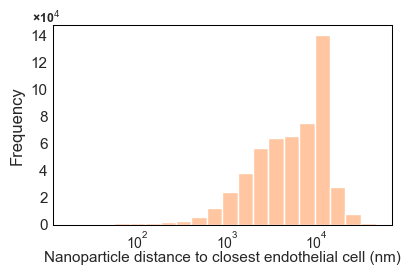

In [451]:
#plot minimum distance to nanoparticles for each endothelial cell ID as violin plot


#fix the plot dimensions so you can read the long text
    #need to call plt before sns, otherwise have a gray bg
#plt.subplots_adjust(left=0,bottom=0,right=1,top=2,wspace=0,hspace=0)

#make the tick labels closer to the axes/spine
    #see: https://github.com/matplotlib/matplotlib/issues/17208
mpl.rcParams['xtick.top'] = False
mpl.rcParams['xtick.labeltop'] = False 
mpl.rcParams['xtick.major.pad'] = -2.25
mpl.rcParams['xtick.minor.pad'] = -2.25
mpl.rcParams['ytick.major.pad'] = -2.25
mpl.rcParams['ytick.minor.pad'] = -2.25

plt.figure() #this creates a new figure on which your plot will appear

#change height and width of dataset
ax = plt.figure(figsize=(4.373,2.6))
#ax1 = fig.add_subplot(121, axes_class = axisartist.Axes)
ax = sns.set_style("whitegrid")
plt.grid(False)

#ax = sns.violinplot(data=all_df_EDT_combined['lowest-EDT_nm'], color=sns.color_palette("pastel")[3],) #pastel red

#set bw to smooth out lines for visualization 
#ax = sns.violinplot(data=all_df_EDT_combined['lowest-EDT_nm'], color=sns.color_palette("pastel")[3], bw=0.1) #pastel red
ax = sns.histplot(data=all_df_EDT_combined['lowest-EDT_nm'], color=sns.color_palette("pastel")[1], log_scale=10, bins=20) #pastel red

#change height and width of dataset
#ax = sns.set(rc={'figure.figsize':(12,5)})
#plt.figure(figsize=(15,5))



plt.xlabel('Nanoparticle distance to closest endothelial cell (nm)',fontsize=11)
#ax.set_xticklabels('Nanoparticle distance to closest endothelial cell (nm)', rotation=0, fontsize="10", va="bottom", ha="left")


plt.ylabel('Frequency',fontsize=12)
#plt.ticklabel_format()
plt.xticks(fontsize=10, fontname="Arial",)
plt.xticks(fontsize=10, fontname="Arial",)



#ax.set_xticks([1e2, 1e3, 1e4])
ax.set_yticks(np.arange(0, 16e4, 2e4))
#ax.set_xticks(np.arange(0, 10**4, 0.5e3))

#put x-label closer to x-axes ticks. set xlabels first. 
    #see: https://github.com/matplotlib/matplotlib/issues/17208
ax.xaxis.labelpad = -0.75

#********* START SCALING FACTOR #*********
#scale factor
scale_factor = 10000
exponent_val = len(str(int(scale_factor/10)))

#rescale values by dividing by 10000, 1e4
ax.get_yaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: format(int(x/scale_factor), )))


#add label with scale factor to graph
#see superscripting variable: https://stackoverflow.com/questions/52379803/superscript-for-a-variable
ax.text(-0.06, 1.01, '×10'+r'$^{%.0f}$' % (exponent_val) , transform=ax.transAxes, fontname="Arial", size=9, weight='bold')





#********* END SCALING FACTOR #*********

#align the values to the right
ax.set_yticklabels(labels=ax.get_yticklabels(), va='center',ha="right")


#plt.ticklabel_format(axis='y', style='sci', scilimits=(4,4))


#set y-minimum value so that it does not go below zero
plt.ylim(0)


#see for iterating over all spines: https://community.dataquest.io/t/iterate-over-ax-spines-items-and-related-functions/233432/
for key,spine in ax.spines.items():
    spine.set_color('#000000')
    spine.set_linewidth(0.75)

#render figure Stext as font rather than path
plt.rcParams['svg.fonttype'] = 'none'

#export figure as svg for illustrator figure
#plt.savefig("np-distance-closest-EC_pastel-orang-hist-log.svg", format="svg", bbox_inches='tight')
plt.savefig("np-distance-closest-EC_pastel-orang-hist-log_v2.svg", format="svg", bbox_inches='tight')


#display histogram
plt.show()

<Figure size 700x700 with 0 Axes>

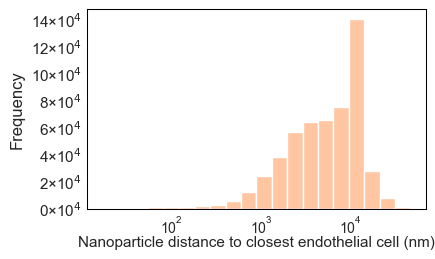

In [458]:
#plot minimum distance to nanoparticles for each endothelial cell ID as violin plot


#fix the plot dimensions so you can read the long text
    #need to call plt before sns, otherwise have a gray bg
#plt.subplots_adjust(left=0,bottom=0,right=1,top=2,wspace=0,hspace=0)

#make the tick labels closer to the axes/spine
    #see: https://github.com/matplotlib/matplotlib/issues/17208
mpl.rcParams['xtick.top'] = False
mpl.rcParams['xtick.labeltop'] = False 
mpl.rcParams['xtick.major.pad'] = -2.25
mpl.rcParams['xtick.minor.pad'] = -2.25
mpl.rcParams['ytick.major.pad'] = -2.25
mpl.rcParams['ytick.minor.pad'] = -2.25

plt.figure() #this creates a new figure on which your plot will appear

#change height and width of dataset
ax = plt.figure(figsize=(4.373,2.6))
#ax1 = fig.add_subplot(121, axes_class = axisartist.Axes)
ax = sns.set_style("whitegrid")
plt.grid(False)

#ax = sns.violinplot(data=all_df_EDT_combined['lowest-EDT_nm'], color=sns.color_palette("pastel")[3],) #pastel red

#set bw to smooth out lines for visualization 
#ax = sns.violinplot(data=all_df_EDT_combined['lowest-EDT_nm'], color=sns.color_palette("pastel")[3], bw=0.1) #pastel red
ax = sns.histplot(data=all_df_EDT_combined['lowest-EDT_nm'], color=sns.color_palette("pastel")[1], log_scale=10, bins=20) #pastel red

#change height and width of dataset
#ax = sns.set(rc={'figure.figsize':(12,5)})
#plt.figure(figsize=(15,5))




#********* START SCALING FACTOR #*********
#scale factor
#scale_factor = 10000
#exponent_val = len(str(int(scale_factor/10)))

#rescale values by dividing by 10000, 1e4
#ax.get_yaxis().set_major_formatter(
#    mpl.ticker.FuncFormatter(lambda x, p: format(int(x/scale_factor), )))


#add label with scale factor to graph
#see superscripting variable: https://stackoverflow.com/questions/52379803/superscript-for-a-variable
#ax.text(-0.06, 1.01, '×10'+r'$^{%.0f}$' % (exponent_val) , transform=ax.transAxes, fontname="Arial", size=9, weight='bold')

#see: https://stackoverflow.com/questions/40511476/how-to-properly-use-funcformatterfunc and https://stackoverflow.com/questions/35415757/adding-sign-to-exponent-in-matplotlib-axes
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '{0:g}×10$^{{4}}$'.format(x/1e4)))




#********* END SCALING FACTOR #*********



plt.xlabel('Nanoparticle distance to closest endothelial cell (nm)',fontsize=11)
#ax.set_xticklabels('Nanoparticle distance to closest endothelial cell (nm)', rotation=0, fontsize="10", va="bottom", ha="left")


plt.ylabel('Frequency',fontsize=12)
#plt.ticklabel_format()
plt.xticks(fontsize=10, fontname="Arial",)
plt.xticks(fontsize=10, fontname="Arial",)



#ax.set_xticks([1e2, 1e3, 1e4])
ax.set_yticks(np.arange(0, 16e4, 2e4))
#ax.set_xticks(np.arange(0, 10**4, 0.5e3))

#put x-label closer to x-axes ticks. set xlabels first. 
    #see: https://github.com/matplotlib/matplotlib/issues/17208
ax.xaxis.labelpad = -0.75

#align the values to the right
ax.set_yticklabels(labels=ax.get_yticklabels(), va='center',ha="right")


#plt.ticklabel_format(axis='y', style='sci', scilimits=(4,4))


#set y-minimum value so that it does not go below zero
plt.ylim(0)


#see for iterating over all spines: https://community.dataquest.io/t/iterate-over-ax-spines-items-and-related-functions/233432/
for key,spine in ax.spines.items():
    spine.set_color('#000000')
    spine.set_linewidth(0.75)

#render figure Stext as font rather than path
plt.rcParams['svg.fonttype'] = 'none'

#export figure as svg for illustrator figure
#plt.savefig("np-distance-closest-EC_pastel-orang-hist-log.svg", format="svg", bbox_inches='tight')
#plt.savefig("np-distance-closest-EC_pastel-orang-hist-log_v2.svg", format="svg", bbox_inches='tight')
plt.savefig("np-distance-closest-EC_pastel-orang-hist-log_v3.svg", format="svg", bbox_inches='tight')


#display histogram
plt.show()

In [343]:
print(len(all_df_EDT_combined['lowest-EDT_nm']))

574891


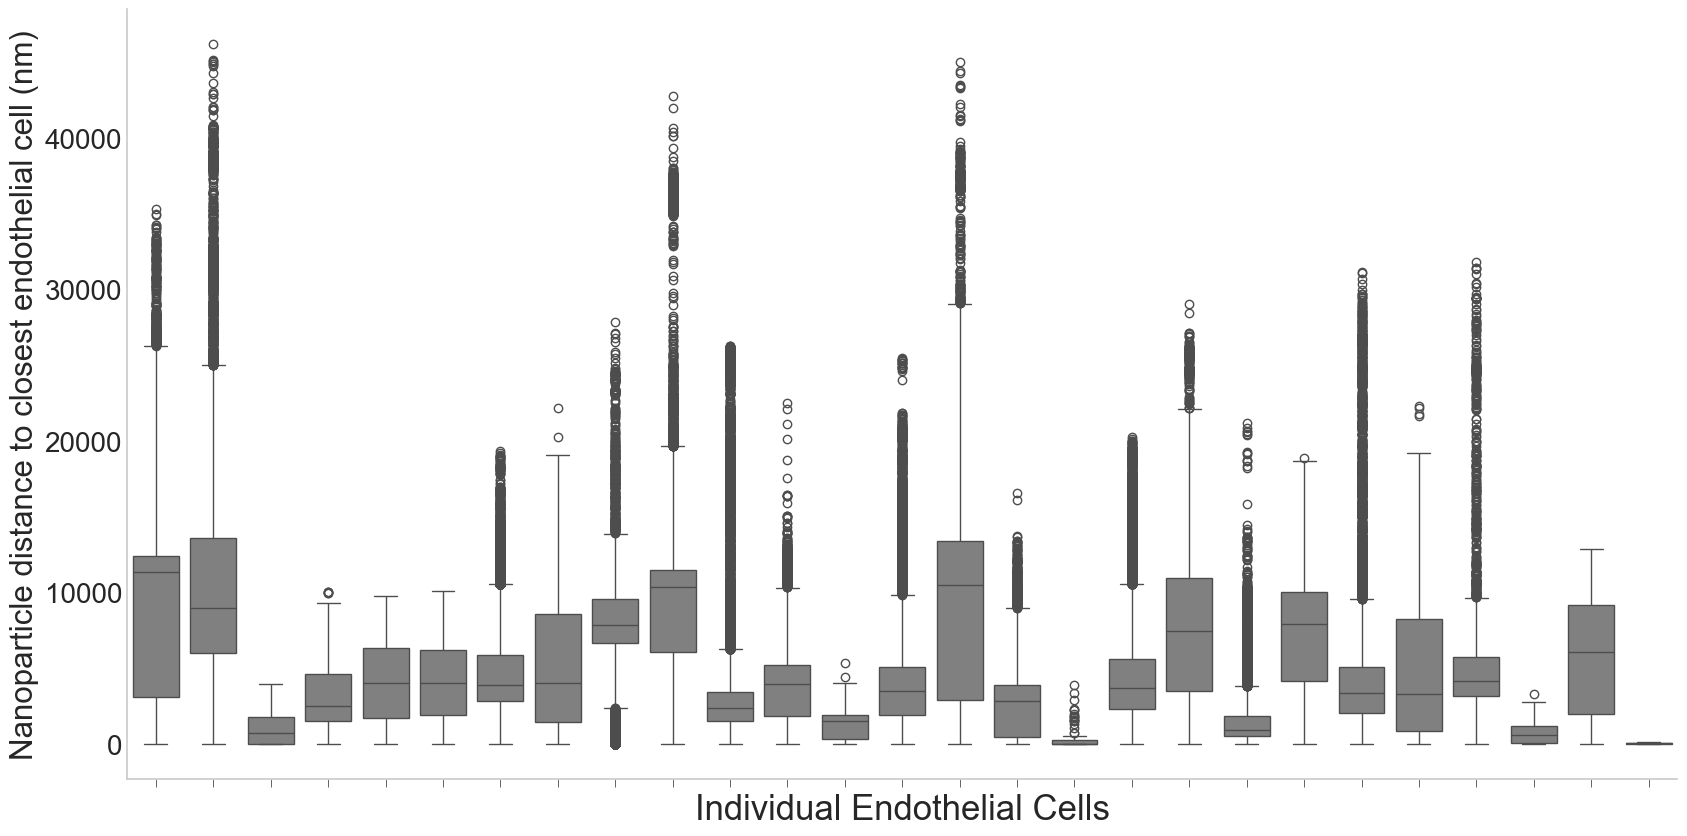

In [117]:
#plot minimum distance to nanoparticles for each endothelial cell ID

ax = sns.set(rc={"figure.figsize":(20, 10)}) #width=20, height=10
ax = sns.set_style("whitegrid")
ax = sns.boxplot(data=all_df_EDT_combined, x='cell-lowest-EDT', y='lowest-EDT_nm', color="gray")

#index_keep_ECs_good2 = [7, 8, 10, 13, 14, 15, 16, 17, 18, 20, 21, 22, 24, 25, 27, 28]
#ax = sns.boxplot(data=all_df_EDT_combined.loc[all_df_EDT_combined['cell-lowest-EDT'].isin(index_keep_ECs_good2)], x='cell-lowest-EDT', y='lowest-EDT_nm', color="gray")


plt.xlabel('Individual Endothelial Cells',fontsize=25)
plt.ylabel('Nanoparticle distance to closest endothelial cell (nm)',fontsize=22.5)
#plt.ticklabel_format()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


# Removing the Grid
ax.grid(False)

# Only lines on y- and x-axis
sns.despine()


#manually override the cell labels from the numbers to letters
#combine the lower and upper case letters into one list as there are more than 26 ECs (but less than 26*2; two sets of 26 alphabet letters)

#all_letters = string.ascii_uppercase+string.ascii_lowercase
#print(all_letters)



#xticklabels_letters = all_letters[0:len(index_keep_ECs_good2)]
#xticklabels_letters = all_letters[0:len(index_keep_ECs)]

#ax.set_xticklabels(xticklabels_letters)

#ax.set_xticklabels(xticklabels_letters)
ax.set_xticklabels([]) #remove tick labels

ax.tick_params(left=False, bottom=True, width=0.5)  # add vertical tick lines


#display histogram
plt.show()


NP-label  3D-EDT-to-cell-7_nm  3D-EDT-to-cell-8_nm  \
0              1          68796.39844          15273.59277   
1              2          68600.06250          15038.66309   
2              3          67079.95313          13693.51172   
3              4          67016.51563          13641.23047   
4              5          66895.14063          13526.98438   
...          ...                  ...                  ...   
574886    574887          16417.79688          16599.83008   
574887    574888          16398.58984          16601.71875   
574888    574889          16266.76563          16499.04297   
574889    574890          16589.42578          16755.51172   
574890    574891          16840.20117          16961.93945   

        3D-EDT-to-cell-9_nm  3D-EDT-to-cell-10_nm  3D-EDT-to-cell-11_nm  \
0               63235.89844           58506.18750           58567.34375   
1               62932.21875           58186.86719           58257.55469   
2               61750.96875           57059.13281           57096.19531   
3               61704.20703           57015.19141           57050.60938   
4               61591.77344           56904.30859           56938.69922   
...                     ...                   ...                   ...   
574886          23503.05469           20402.54492           28613.79688   
574887          23501.32617           20395.63867           28600.63867   
574888          23391.50195           20252.87305           28465.21875   
574889          23664.09961           20605.15820           28797.71289   
574890          23880.81055           20881.79297           29056.88867   

        3D-EDT-to-cell-12_nm  3D-EDT-to-cell-13_nm  3D-EDT-to-cell-14_nm  \
0                53622.86719           51787.61719           61350.91406   
1                53327.51563           51485.75781           60967.10547   
2                52338.45313           50549.91016           60141.12500   
3                52300.46094           50514.43750           60111.50781   
4                52201.81250           50418.51953           60012.43359   
...                      ...                   ...                   ...   
574886           22026.15625           29189.99023           30947.19531   
574887           22020.29688           29175.02930           30907.76563   
574888           21877.96289           29030.34570           30749.52539   
574889           22229.40234           29385.15234           31131.53906   
574890           22505.61719           29660.98438           31421.01563   

        3D-EDT-to-cell-15_nm  ...  3D-EDT-to-cell-32_nm  3D-EDT-to-cell-33_nm  \
0                67307.30469  ...           65093.47266           56342.47266   
1                66878.63281  ...           64862.32031           56055.84766   
2                66321.06250  ...           63435.89453           54802.91406   
3                66303.85938  ...           63377.20313           54752.46484   
4                66216.72656  ...           63257.63672           54637.24609   
...                      ...  ...                   ...                   ...   
574886           34492.24219  ...           23096.61914           31762.37500   
574887           34442.52344  ...           23107.13281           31771.58398   
574888           34283.90625  ...           23026.44727           31683.77734   
574889           34664.26172  ...           23230.42969           31904.54492   
574890           34949.33594  ...           23397.77539           32083.23438   

        3D-EDT-to-cell-34_nm  lowest-EDT_nm  cell-lowest-EDT  z-slice  \
0                58079.43750    15273.59277                8        0   
1                57758.58984    15038.66309                8        0   
2                56637.13281    13693.51172                8        0   
3                56593.50391    13641.23047                8        0   
4                56482.84375    13526.98438                8        0   
...                      ...          

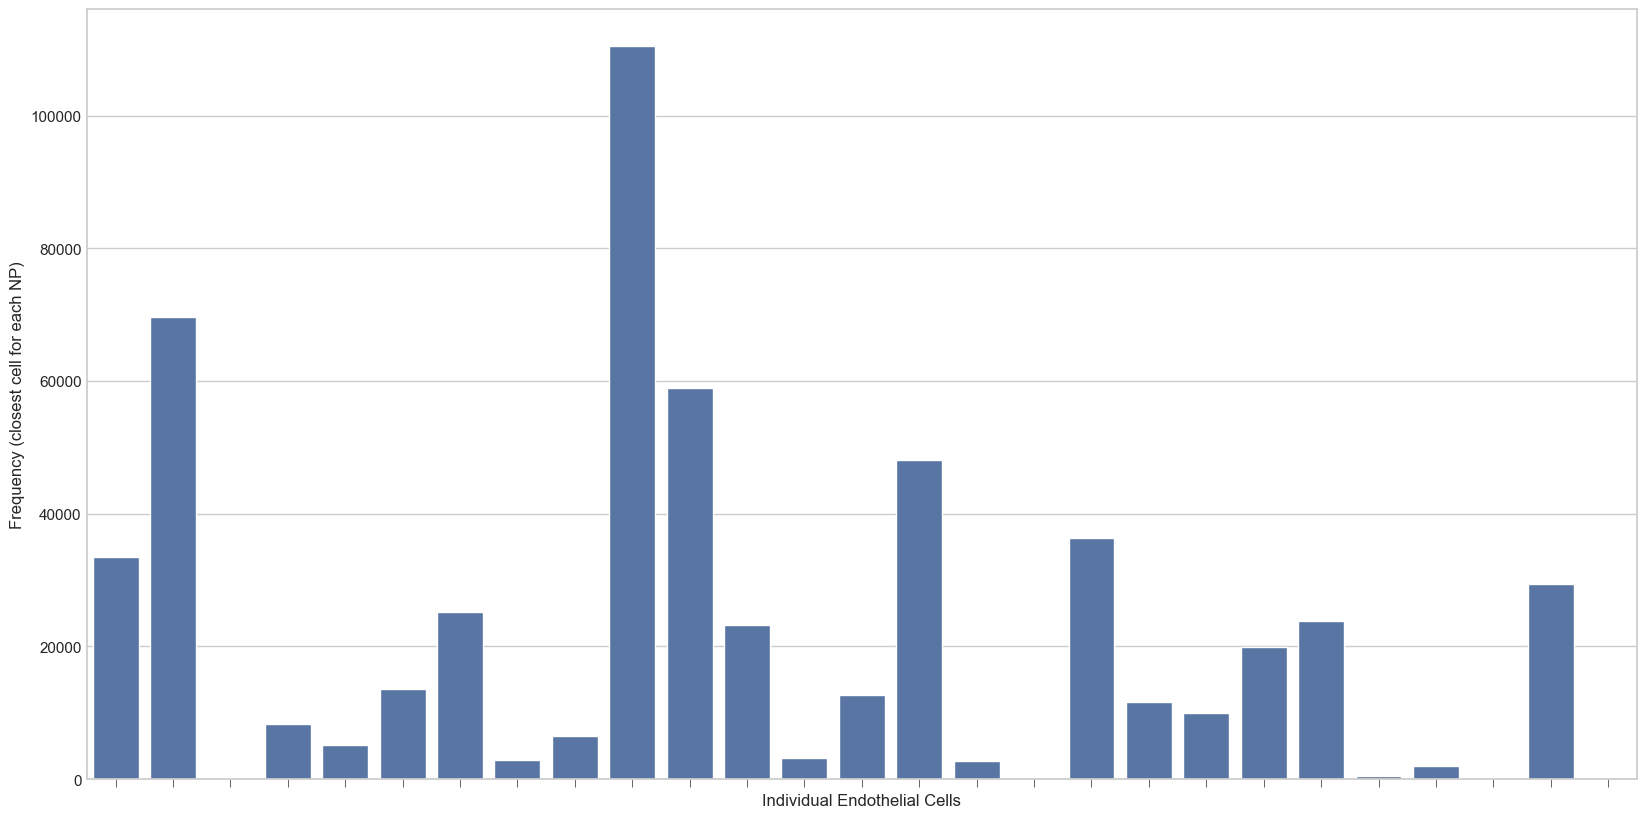

In [121]:
# this is not transport score. this is a histogram of the closest cell for each NP. 

ax = sns.countplot(data=all_df_EDT_combined, x='cell-lowest-EDT', )
ax.set(xlabel='Individual Endothelial Cells',
       ylabel='Frequency (closest cell for each NP)',
      )

#ax.set_xticklabels(xticklabels_letters)
ax.set_xticklabels([]) #remove tick labels

ax.tick_params(left=False, bottom=True, width=0.5)  # add vertical tick lines


#plt.show()

In [122]:
#get transport score without adding NPs within the cell assigned a value of 1
# can replace all 1s with 0s in the column

#updated Feb 9 2024 for T-score without NPs within cell
all_df_EDT_combined = pd.read_csv('df_EDT_closest_cell_t-score.csv', index_col=0)
    #note that this file has the bad slices removed
    
#subset of EC only
index_keep_ECs = [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34]    
index_keep_ECs_good = [7, 8, 10, 13, 14, 15, 16, 17, 18, 20, 21, 22, 24, 25, 27, 28, 29, 30, 32]
index_keep_ECs_good2 = [7, 8, 10, 13, 14, 15, 16, 17, 18, 20, 21, 22, 24, 25, 27, 28]

In [123]:
#replace inf with 1 using indexing

# find all values = 1 for column 'transport_score_inv_nm'
all_df_EDT_combined.loc[all_df_EDT_combined['transport_score_inv_nm']==1]

NP-label  3D-EDT-to-cell-7_nm  3D-EDT-to-cell-8_nm  \
105          106         52433.070310          3158.817139   
106          107         51598.605470          3349.577393   
107          108         52418.000000          3310.698730   
108          109         51964.128910          3516.921143   
109          110         51311.683590          3647.773193   
...          ...                  ...                  ...   
574591    574592         10961.758790         10710.665040   
574594    574595         10630.547850         10879.724610   
574601    574602         18998.992190         18365.912110   
574630    574631          9021.796875         10909.183590   
574634    574635          8990.348633         11073.035160   

        3D-EDT-to-cell-9_nm  3D-EDT-to-cell-10_nm  3D-EDT-to-cell-11_nm  \
105             47060.96484          42374.437500           42376.73047   
106             46403.02734          41750.699220           41718.91797   
107             46874.32031          42156.453130           42181.42969   
108             46432.59766          41717.558590           41740.03516   
109             45965.92578          41286.156250           41277.69922   
...                     ...                   ...                   ...   
574591          13401.47949           1227.017944           12981.09375   
574594          13446.40918           1789.898682           13323.61230   
574601          19690.00391          10697.498050           12219.21973   
574630          14772.37402           6423.989258           16117.75195   
574634          15037.22852           6972.852051           16412.69141   

        3D-EDT-to-cell-12_nm  3D-EDT-to-cell-13_nm  3D-EDT-to-cell-14_nm  \
105             39708.136720          38199.425780          46328.136720   
106             39227.859380          37722.589840          45884.378910   
107             39510.765630          38002.039060          46000.457030   
108             39158.000000          37650.890630          45606.406250   
109             38835.078130          37330.628910          45348.351560   
...                      ...                   ...                   ...   
574591           2784.317627          11706.171880          16980.671880   
574594           3381.461914          12137.281250          17175.111330   
574601           6501.404297           2623.568848           9075.746094   
574630           8058.250977          15290.819340          18204.773440   
574634           8597.849609          15575.666990          18144.833980   

        3D-EDT-to-cell-15_nm  ...  3D-EDT-to-cell-32_nm  3D-EDT-to-cell-33_nm  \
105              53567.01953  ...           48614.82813           39944.28516   
106              53260.35938  ...           47825.82813           39242.59766   
107              53168.80859  ...           48528.07422           39788.25781   
108              52821.18750  ...           48071.39453           39337.04297   
109              52699.17969  ...           47484.69922           38826.62891   
...                      ...  ...                   ...                   ...   
574591           22958.43359  ...           17299.59375           18748.86328   
574594           23010.93945  ...           17238.02539           18970.59570   
574601           15603.95996  ...           24962.21484           17636.00391   
574630           22771.08594  ...           17927.72266           20791.63477   
574634           22587.56641  ...           18176.16406           20980.42188   

        3D-EDT-to-cell-34_nm  lowest-EDT_nm  cell-lowest-EDT  z-slice  \
105              41965.51563            0.0               23        0   
106              41346.07031            0.0               23        0   
107              41744.53125            0.0               23        0   
108              41306.44531            0.0               23        0   
109              40879.22656            0.0               23        0   
...                      ...          

In [124]:
#make copy of dataframe for only NPs outside of ECs
all_df_EDT_combined_outside_cells = all_df_EDT_combined.copy()

In [125]:
#assign value of 0 to transport score for NPs outside of cells
all_df_EDT_combined_outside_cells.loc[all_df_EDT_combined_outside_cells['transport_score_inv_nm']==1] = 0

In [126]:
# now check if there are any values equal to 1 (there are not)
all_df_EDT_combined_outside_cells.loc[all_df_EDT_combined_outside_cells['transport_score_inv_nm']==1]

Empty DataFrame
Columns: [NP-label, 3D-EDT-to-cell-7_nm, 3D-EDT-to-cell-8_nm, 3D-EDT-to-cell-9_nm, 3D-EDT-to-cell-10_nm, 3D-EDT-to-cell-11_nm, 3D-EDT-to-cell-12_nm, 3D-EDT-to-cell-13_nm, 3D-EDT-to-cell-14_nm, 3D-EDT-to-cell-15_nm, 3D-EDT-to-cell-16_nm, 3D-EDT-to-cell-17_nm, 3D-EDT-to-cell-18_nm, 3D-EDT-to-cell-19_nm, 3D-EDT-to-cell-20_nm, 3D-EDT-to-cell-21_nm, 3D-EDT-to-cell-22_nm, 3D-EDT-to-cell-23_nm, 3D-EDT-to-cell-24_nm, 3D-EDT-to-cell-25_nm, 3D-EDT-to-cell-27_nm, 3D-EDT-to-cell-28_nm, 3D-EDT-to-cell-29_nm, 3D-EDT-to-cell-30_nm, 3D-EDT-to-cell-31_nm, 3D-EDT-to-cell-32_nm, 3D-EDT-to-cell-33_nm, 3D-EDT-to-cell-34_nm, lowest-EDT_nm, cell-lowest-EDT, z-slice, centroid,0_16bit, centroid,1_16bit, inverse-lowest-EDT_nm, transport_score_inv_nm]
Index: []

[0 rows x 35 columns]

In [127]:
all_df_EDT_combined_outside_cells['cell-lowest-EDT'].isin(index_keep_ECs)

0         True
1         True
2         True
3         True
4         True
          ... 
574886    True
574887    True
574888    True
574889    True
574890    True
Name: cell-lowest-EDT, Length: 558222, dtype: bool

In [128]:
#remove cells that are not ECs
index_keep_ECs = [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34]
index_keep_ECs_good = [7, 8, 10, 13, 14, 15, 16, 17, 18, 20, 21, 22, 24, 25, 27, 28, 29, 30, 32]
index_keep_ECs_good2 = [7, 8, 10, 13, 14, 15, 16, 17, 18, 20, 21, 22, 24, 25, 27, 28]
    #don't need to change the cells considered for partial cells for T-Score since they would still be the closest cell

all_df_EDT_combined_outside_ECs = all_df_EDT_combined_outside_cells[all_df_EDT_combined_outside_cells['cell-lowest-EDT'].isin(index_keep_ECs)]
#assign new tscore 2 df and get EC index
t_score_df2 = pd.DataFrame(all_df_EDT_combined_outside_ECs.groupby(['cell-lowest-EDT']).sum().reset_index())


In [129]:
min_tscore2 = t_score_df2['transport_score_inv_nm'].min()
max_tscore2 = t_score_df2['transport_score_inv_nm'].max()
print(min_tscore2, max_tscore2, ". Fold difference is: ",max_tscore2/min_tscore2)

0.0950815933195019 40.115007116660166 . Fold difference is:  421.90087183185955


<Figure size 700x700 with 0 Axes>

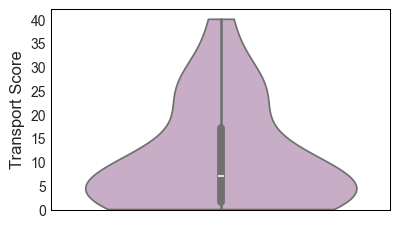

In [452]:
#transport score as violin plot for only NPs outside of the cell (not inside the cell)
    # using t_score_df2

#plot T-score for each endothelial cell ID

#scale to nanometers


#make the tick labels closer to the axes/spine
    #see: https://github.com/matplotlib/matplotlib/issues/17208
mpl.rcParams['xtick.top'] = False
mpl.rcParams['xtick.labeltop'] = False 
mpl.rcParams['xtick.major.pad'] = -2.25
mpl.rcParams['xtick.minor.pad'] = -2.25
mpl.rcParams['ytick.major.pad'] = -2.25
mpl.rcParams['ytick.minor.pad'] = -2.25

plt.figure() #this creates a new figure on which your plot will appear

#change height and width of dataset
ax = plt.figure(figsize=(4.373,2.6))
ax = sns.set_style("whitegrid")
plt.grid(False)


#add cut =0 to only keep values above 0
#don't use cut=0 as there are no values between min value and 0

ax = sns.violinplot(data=t_score_df2['transport_score_inv_nm'], cut=0,color="#cba9ca")



#turn off grid
plt.grid(False)




#plt.xlabel('Cell ID',fontsize=12)
plt.ylabel('Transport Score',fontsize=12,fontname="Arial",)
#plt.ticklabel_format()
plt.xticks(fontsize=10, fontname="Arial",)
plt.yticks(fontsize=10, fontname="Arial",)

#ax.set_xticks([1e2, 1e3, 1e4])
ax.set_yticks(np.arange(0, 45, 5))

#set y-minimum value so that it does not go below zero
plt.ylim(0)

#render figure text as font rather than path
plt.rcParams['svg.fonttype'] = 'none'

#see for iterating over all spines: https://community.dataquest.io/t/iterate-over-ax-spines-items-and-related-functions/233432/
for key,spine in ax.spines.items():
    spine.set_color('#000000')
    spine.set_linewidth(0.75)


#export figure as svg for illustrator figure
#plt.savefig("transport-score2_purple.svg", format="svg", bbox_inches='tight') #when using the figure size line 
#plt.savefig("transport-score2_purple-short.svg", format="svg", bbox_inches='tight') #when commenting/disabling the figure size line
#plt.savefig("transport-score2_outside_purple-short.svg", format="svg", bbox_inches='tight') #when commenting/disabling the figure size line
plt.savefig("transport-score2_outside_purple-short_v2.svg", format="svg", bbox_inches='tight') #when commenting/disabling the figure size line



#display histogram
plt.show()

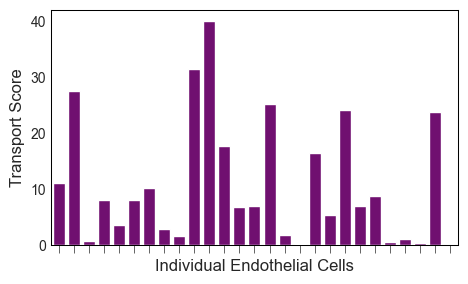

In [453]:
#plot T-score for each endothelial cell ID without NPs within the cells
    # using t_score_df2

#scale to nanometers


#make the tick labels closer to the axes/spine
    #see: https://github.com/matplotlib/matplotlib/issues/17208
mpl.rcParams['xtick.top'] = False
mpl.rcParams['xtick.labeltop'] = False 
mpl.rcParams['xtick.major.pad'] = -2.25
mpl.rcParams['xtick.minor.pad'] = -2.25
mpl.rcParams['ytick.major.pad'] = -2.25
mpl.rcParams['ytick.minor.pad'] = -2.25

ax = sns.catplot(data=t_score_df2, x='cell-lowest-EDT', y='transport_score_inv_nm', kind='bar', height = 8, aspect = 1.5, color='purple', zorder=5)


#turn off grid
plt.grid(False)


plt.xlabel('Individual Endothelial Cells',fontsize=12,fontname="Arial",)
plt.ylabel('Transport Score',fontsize=12,fontname="Arial",)
#plt.ticklabel_format()
plt.xticks(fontsize=10,fontname="Arial",)
plt.yticks(fontsize=10,fontname="Arial",)


ax.set_xticklabels([]) #remove tick labels

ax.tick_params(left=False, bottom=True, width=0.5) # add vertical tick lines



#add number of nanoparticles for each bar plot above the plot    
# extract the matplotlib axes_subplot objects from the FacetGrid
ax2 = ax.facet_axis(0, 0)  # or ax = g.axes.flat[0]

# iterate through the axes containers
#for c in ax2.containers:
#    labels = [f'{(v.get_height()):.2f}' for v in c]
#    ax2.bar_label(c, labels=labels, label_type='edge', fontsize=14)

for ax in ax.axes.ravel():
    for key,spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_color('#000000')
        spine.set_linewidth(0.75)

#need to resize figure here 
fig = plt.gcf()
fig.set_size_inches(4.373,2.6)

#export figure as svg for illustrator figure
#plt.savefig("transport-score2_purple.svg", format="svg", bbox_inches='tight') #when using the figure size line 
#plt.savefig("transport-score2_purple-short.svg", format="svg", bbox_inches='tight') #when commenting/disabling the figure size line
#plt.savefig("transport-score2_outside_purple-ECs-short.svg", format="svg", bbox_inches='tight') #when commenting/disabling the figure size line
#plt.savefig("transport-score2_outside_purple-ECs-short+number.svg", format="svg", bbox_inches='tight') #when commenting/disabling the figure size line
plt.savefig("transport-score2_outside_purple-ECs-short+number_v2.svg", format="svg", bbox_inches='tight') #when commenting/disabling the figure size line



#display histogram
plt.show()

In [132]:
#get 'uptake score' which is the number of nanoparticles within each EC (i.e. distance = 0)
all_df_EDT_combined_inside_cells = all_df_EDT_combined.loc[all_df_EDT_combined['transport_score_inv_nm']==1].copy()
all_df_EDT_combined_inside_cells

NP-label  3D-EDT-to-cell-7_nm  3D-EDT-to-cell-8_nm  \
105          106         52433.070310          3158.817139   
106          107         51598.605470          3349.577393   
107          108         52418.000000          3310.698730   
108          109         51964.128910          3516.921143   
109          110         51311.683590          3647.773193   
...          ...                  ...                  ...   
574591    574592         10961.758790         10710.665040   
574594    574595         10630.547850         10879.724610   
574601    574602         18998.992190         18365.912110   
574630    574631          9021.796875         10909.183590   
574634    574635          8990.348633         11073.035160   

        3D-EDT-to-cell-9_nm  3D-EDT-to-cell-10_nm  3D-EDT-to-cell-11_nm  \
105             47060.96484          42374.437500           42376.73047   
106             46403.02734          41750.699220           41718.91797   
107             46874.32031          42156.453130           42181.42969   
108             46432.59766          41717.558590           41740.03516   
109             45965.92578          41286.156250           41277.69922   
...                     ...                   ...                   ...   
574591          13401.47949           1227.017944           12981.09375   
574594          13446.40918           1789.898682           13323.61230   
574601          19690.00391          10697.498050           12219.21973   
574630          14772.37402           6423.989258           16117.75195   
574634          15037.22852           6972.852051           16412.69141   

        3D-EDT-to-cell-12_nm  3D-EDT-to-cell-13_nm  3D-EDT-to-cell-14_nm  \
105             39708.136720          38199.425780          46328.136720   
106             39227.859380          37722.589840          45884.378910   
107             39510.765630          38002.039060          46000.457030   
108             39158.000000          37650.890630          45606.406250   
109             38835.078130          37330.628910          45348.351560   
...                      ...                   ...                   ...   
574591           2784.317627          11706.171880          16980.671880   
574594           3381.461914          12137.281250          17175.111330   
574601           6501.404297           2623.568848           9075.746094   
574630           8058.250977          15290.819340          18204.773440   
574634           8597.849609          15575.666990          18144.833980   

        3D-EDT-to-cell-15_nm  ...  3D-EDT-to-cell-32_nm  3D-EDT-to-cell-33_nm  \
105              53567.01953  ...           48614.82813           39944.28516   
106              53260.35938  ...           47825.82813           39242.59766   
107              53168.80859  ...           48528.07422           39788.25781   
108              52821.18750  ...           48071.39453           39337.04297   
109              52699.17969  ...           47484.69922           38826.62891   
...                      ...  ...                   ...                   ...   
574591           22958.43359  ...           17299.59375           18748.86328   
574594           23010.93945  ...           17238.02539           18970.59570   
574601           15603.95996  ...           24962.21484           17636.00391   
574630           22771.08594  ...           17927.72266           20791.63477   
574634           22587.56641  ...           18176.16406           20980.42188   

        3D-EDT-to-cell-34_nm  lowest-EDT_nm  cell-lowest-EDT  z-slice  \
105              41965.51563            0.0               23        0   
106              41346.07031            0.0               23        0   
107              41744.53125            0.0               23        0   
108              41306.44531            0.0               23        0   
109              40879.22656            0.0               23        0   
...                      ...          

In [133]:
#remove cells that are not ECs (for NPs inside ECs)
index_keep_ECs = [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34]
all_df_EDT_combined_inside_ECs = all_df_EDT_combined_inside_cells[all_df_EDT_combined_inside_cells['cell-lowest-EDT'].isin(index_keep_ECs)]
#assign new tscore 2 df and get EC index
t_score_df3 = pd.DataFrame(all_df_EDT_combined_inside_ECs.groupby(['cell-lowest-EDT']).sum().reset_index())


In [134]:
t_score_df3

cell-lowest-EDT   NP-label  3D-EDT-to-cell-7_nm  3D-EDT-to-cell-8_nm  \
0                 7   25128900         0.000000e+00         7.354536e+05   
1                 8   32178748         3.302381e+06         0.000000e+00   
2                 9    4396494         4.123669e+05         1.439087e+05   
3                10   91070035         5.069375e+06         1.415718e+06   
4                11    5820673         1.181344e+06         1.319293e+05   
5                12  378236457         1.051106e+07         7.191490e+06   
6                13   66697416         4.335115e+06         2.677060e+06   
7                14   23248362         3.399182e+06         2.145996e+06   
8                15   39811907         7.318022e+06         5.736181e+06   
9                16  445144726         7.450341e+06         5.143467e+06   
10               17  509211372         2.818882e+07         3.251506e+07   
11               18  239881305         2.556452e+06         5.244057e+06   
12               19  158800862         3.012228e+06         3.858684e+06   
13               20  659631543         1.902428e+07         1.993740e+07   
14               21  390974613         6.398689e+07         2.015839e+07   
15               22   78908549         2.504132e+07         7.199382e+06   
16               23     697618         2.939180e+06         1.775453e+05   
17               24  235732512         5.971228e+07         1.275032e+07   
18               25  194768973         3.203765e+07         1.451361e+07   
19               27  277158075         2.298758e+07         1.313052e+07   
20               28  546721693         3.113375e+07         2.089947e+07   
21               29   20080533         2.850299e+06         3.337289e+06   
22               30    4557179         4.637856e+05         6.537401e+05   
23               31     340788         4.676228e+03         4.078977e+04   
24               32    1330274         1.401281e+05         1.705489e+05   
25               33   91509411         4.907254e+07         6.891502e+06   
26               34      23996         8.015916e+04         1.458337e+04   

    3D-EDT-to-cell-9_nm  3D-EDT-to-cell-10_nm  3D-EDT-to-cell-11_nm  \
0          1.650469e+06          1.842951e+06          2.354893e+06   
1          7.377177e+06          4.117623e+06          3.475370e+06   
2          0.000000e+00          6.306608e+04          2.965560e+05   
3          1.860051e+06          0.000000e+00          1.856402e+06   
4          5.703687e+05          7.201670e+04          0.000000e+00   
5          8.987529e+06          1.416062e+06          5.120994e+06   
6          2.872063e+06          1.508877e+06          1.538812e+06   
7          2.265131e+06          1.653351e+06          2.451841e+06   
8          5.754449e+06          4.820778e+06          6.381481e+06   
9          9.308577e+06          4.581556e+06          1.192200e+07   
10         3.142755e+07          2.621791e+07          3.429679e+07   
11         6.617273e+06          4.595799e+06          7.826734e+06   
12         4.049173e+06          1.949235e+06          3.154779e+06   
13         2.070715e+07          1.081582e+07          1.266730e+07   
14         5.518832e+07          5.017337e+07          4.927961e+07   
15         2.074109e+07          1.841625e+07          1.821815e+07   
16         2.622797e+06          2.362009e+06          2.357567e+06   
17         5.103153e+07          4.690175e+07          4.593592e+07   
18         2.655255e+07          2.381917e+07          2.284387e+07   
19         1.940657e+07          1.674688e+07          1.648098e+07   
20         2.508222e+07          1.882012e+07          1.889375e+07   
21         2.976013e+06          2.694773e+06          3.983514e+06   
22         5.664517e+05          5.212131e+05          7.713527e+05   
23         3.143723e+04          3.772022e+04          5.830082e+04   
24         1.390690e+05          2.382891e+05          2.233513e+05   
25         2.419491e+07      

<Figure size 700x700 with 0 Axes>

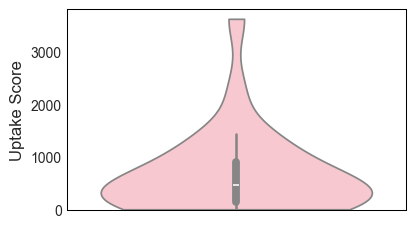

In [454]:
#uptake score as violin plot for only NPs within the cells
    # using t_score_df3

#plot T-score for each endothelial cell ID

#scale to nanometers

#add cut =0 to only keep values above 0
#don't use cut=0 as there are no values between min value and 0

#make the tick labels closer to the axes/spine
    #see: https://github.com/matplotlib/matplotlib/issues/17208
mpl.rcParams['xtick.top'] = False
mpl.rcParams['xtick.labeltop'] = False 
mpl.rcParams['xtick.major.pad'] = -2.25
mpl.rcParams['xtick.minor.pad'] = -2.25
mpl.rcParams['ytick.major.pad'] = -2.25
mpl.rcParams['ytick.minor.pad'] = -2.25

plt.figure() #this creates a new figure on which your plot will appear

#change height and width of dataset
ax = plt.figure(figsize=(4.373,2.6))
ax = sns.set_style("whitegrid")
plt.grid(False)


#add cut =0 to only keep values above 0
#don't use cut=0 as there are no values between min value and 0


ax = sns.violinplot(data=t_score_df3['transport_score_inv_nm'], color='pink', cut=0,)


#turn off grid

plt.grid(False)


#plt.xlabel('Cell ID',fontsize=12, fontname="Arial",)
plt.ylabel('Uptake Score',fontsize=12, fontname="Arial",)
#plt.ticklabel_format()
plt.xticks(fontsize=10, fontname="Arial",)
plt.yticks(fontsize=10, fontname="Arial",)

#set y-minimum value so that it does not go below zero
plt.ylim(0)


#render figure text as font rather than path
plt.rcParams['svg.fonttype'] = 'none'

#see for iterating over all spines: https://community.dataquest.io/t/iterate-over-ax-spines-items-and-related-functions/233432/
for key,spine in ax.spines.items():
    spine.set_color('#000000')
    spine.set_linewidth(0.75)


#export figure as svg for illustrator figure
#plt.savefig("transport-score2_purple.svg", format="svg", bbox_inches='tight') #when using the figure size line 
#plt.savefig("transport-score2_purple-short.svg", format="svg", bbox_inches='tight') #when commenting/disabling the figure size line
#plt.savefig("transport-score3_inside_pink-short.svg", format="svg", bbox_inches='tight') #when commenting/disabling the figure size line
#plt.savefig("transport-score3_inside_pink-short_v2.svg", format="svg", bbox_inches='tight') #when commenting/disabling the figure size line



#display histogram
plt.show()

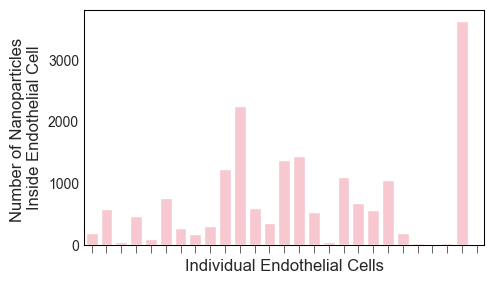

In [455]:
#uptake score as violin plot for only NPs within the cells
    # using t_score_df3


#make the tick labels closer to the axes/spine
    #see: https://github.com/matplotlib/matplotlib/issues/17208
mpl.rcParams['xtick.top'] = False
mpl.rcParams['xtick.labeltop'] = False 
mpl.rcParams['xtick.major.pad'] = -2.25
mpl.rcParams['xtick.minor.pad'] = -2.25
mpl.rcParams['ytick.major.pad'] = -2.25
mpl.rcParams['ytick.minor.pad'] = -2.25

ax = sns.catplot(data=t_score_df3, x='cell-lowest-EDT', y='transport_score_inv_nm', kind='bar', height = 8, aspect = 1.5, color='pink', zorder=5)


#turn off grid
plt.grid(False)


plt.xlabel('Individual Endothelial Cells',fontsize=12,fontname="Arial",)
plt.ylabel('Number of Nanoparticles \nInside Endothelial Cell',fontsize=12,fontname="Arial",)
#plt.ticklabel_format()
plt.xticks(fontsize=10,fontname="Arial",)
plt.yticks(fontsize=10,fontname="Arial",)


ax.set_xticklabels([]) #remove tick labels

ax.tick_params(left=False, bottom=True, width=0.5) # add vertical tick lines

#add number of nanoparticles for each bar plot above the plot      
# extract the matplotlib axes_subplot objects from the FacetGrid
#ax2 = ax.facet_axis(0, 0)  # or ax = g.axes.flat[0]

# iterate through the axes containers
#for c in ax2.containers:
#    labels = [f'{(v.get_height()):.0f}' for v in c]
#    ax2.bar_label(c, labels=labels, label_type='edge', fontsize=14,)

for ax in ax.axes.ravel():
    for key,spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_color('#000000')
        spine.set_linewidth(0.75)

#need to resize figure here 
fig = plt.gcf()
fig.set_size_inches(4.373,2.6) 
    
#export figure as svg for illustrator figure
#plt.savefig("transport-score2_purple.svg", format="svg", bbox_inches='tight') #when using the figure size line 
#plt.savefig("transport-score2_purple-short.svg", format="svg", bbox_inches='tight') #when commenting/disabling the figure size line
#plt.savefig("NPs-inside-ECs_pink+numbers.svg", format="svg", bbox_inches='tight') #when commenting/disabling the figure size line
plt.savefig("NPs-inside-ECs_pink+numbers_v2.svg", format="svg", bbox_inches='tight') #when commenting/disabling the figure size line




#display histogram
plt.show()

In [137]:
# Below are calculations for thickness of walls of the structure that projects from endothelial cell wall 

#After running local thickness on each 2D slice of 3D stack of projection structure, summarize the values
#read in data, then get summary statistics and plot


In [ ]:
#directory: C:\Users\Z6\Desktop\3DSEM\Stefan\1.AT\2.June20_v4_final-fr-with-vess2-small-408R\10.ishaan-align\2.MIB-model\6.Feb22-2024_net-structure_from-Dec-v4
#FIJI script: 

'''
//run thickness on each slice of 3D z-Ext.CLIJ2_combineHorizontally(Image_stack1, Image_stack2, Image_destination);

//set scale
run("Set Scale...", "distance=1 known=17 unit=nm");



//for script

selectWindow("filled7-mask_updated-slice7_Feb24-net_slice28-48-crop-hole-only.tif");

for (i = 1; i <= nSlices; i++) {
    setSlice(i);
    print(i);
    run("Duplicate...", "use");
    run("Local Thickness (complete process)", "threshold=128");
    rename("thick_"+i);
	selectWindow("filled7-mask_updated-slice7_Feb24-net_slice28-48-crop-hole-only.tif");
    
}

//Closes windows whose title matches 'pattern', which can contain the wildcard characters '*' (matches any character sequence) and '?' (matches single character). For example, close("Histo*") could be used to dispose all histogram windows. Non-image windows like "Roi Manager" have to be specified without wildcards. For text windows, wildcards are allowed if 'pattern' ends with ".txt", ".ijm", ".js" etc. Use close("*") to close all image windows. Use close(pattern, "keep") to not close text or image windows with changes. If 'pattern' is "\\Others", all images except the front image are closed. The most recent macro window is never closed.
//close("!LocThk", "keep")
//close("*LocThk*", "keep")
close("*slice:*")

//stack then save
run("Images to Stack", "name=stack-2d-thickness use");
run("glasbey_on_dark");



'''

In [73]:
#read in data
thickness_projection = io.imread(os.path.join(r"C:\Users\Z6\Desktop\3DSEM\Stefan\1.AT\2.June20_v4_final-fr-with-vess2-small-408R\10.ishaan-align\2.MIB-model\6.Feb22-2024_net-structure_from-Dec-v4", "5_stack-2d-thickness.tif"), plugin="tifffile")


In [78]:
#covert data to a flattened version since localization is not important here

thickness_projection_flatten = thickness_projection.flatten()
thickness_projection_flatten

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [77]:
#remove background values equal to 0
thickness_projection_flatten_positive_val = thickness_projection_flatten[thickness_projection_flatten>0]
thickness_projection_flatten_positive_val

array([10.      , 10.      , 10.      , ..., 23.323807, 23.323807,
       23.323807], dtype=float32)

In [86]:
thickness_projection_flatten_positive_val_df = pd.DataFrame(thickness_projection_flatten_positive_val)
thickness_projection_flatten_positive_val_df.mean()[0]

12.552206

In [98]:
thickness_projection_flatten_positive_val_df.max()[0]


28.635643

In [99]:
thickness_projection_flatten_positive_val_df.min()[0]

2.0

In [103]:
#get standard error of mean
thickness_projection_sem = np.std(thickness_projection_flatten_positive_val, ddof=1) / np.sqrt(np.size(thickness_projection_flatten_positive_val))
print("SEM is: ", thickness_projection_sem)
print("Standard Deviation is: ", np.std(thickness_projection_flatten_positive_val, ddof=1))

SEM is:  0.01750260230370919
Standard Deviation is:  4.893472


In [28]:
#begin vesicle analysis
#import the original 16-bit CCL vesicle stack and the 16-bit CCL vesicle stack after multiplying by the inverted binary endothelial channel

vesicle_CCL = io.imread(r"C:\Users\SM\Desktop\Reviewer-vesicle\vesicle-analysis\2.CCL-before-mult-EC/12_June5-2024_Labels_update-145_dataset_fine_ome-16bit-lbl-CCL.tif", plugin="tifffile")
vesicle_CCL_mult_inv_EC = io.imread(r"C:\Users\SM\Desktop\Reviewer-vesicle\vesicle-analysis\5.ec-invert-mult-CCL-vesicle/12_June5-2024_Labels_update-145_dataset_fine_ome-16bit-lbl-CCL_mult_ec-invert.tif", plugin="tifffile")

In [29]:
colours_vesicle_CCL, counts_vesicle_CCL = np.unique(vesicle_CCL, return_counts=1)
colours_vesicle_CCL_mult_inv_EC, counts_vesicle_CCL_mult_inv_EC = np.unique(vesicle_CCL_mult_inv_EC, return_counts=1)


pixel_val num_pixels_vesicle_CCL num_pixels_vesicle_CCL_mult_inv_EC  \
0            0            10719242341                        10724738552   
1            1                   1576                                  2   
2            2                    392                                 19   
3            3                    416                                 93   
4            4                   2439                                280   
...        ...                    ...                                ...   
3077      3077                    216                               None   
3078      3078                     60                               None   
3079      3079                     61                               None   
3080      3080                     58                               None   
3081      3081                     19                               None   

     differemce  
0       5496211  
1         -1574  
2          -373  
3          -323  
4         -2159  
...         ...  
3077        NaN  
3078        NaN  
3079        NaN  
3080        NaN  
3081        NaN  

[3082 rows x 4 columns]

In [147]:
#check how many rows/vesicles we have before removing any that are outside the binary endothelial cell mask (i.e. within the inverted binary EC mask)

#add .T to transpose the dataframe to make it vertical
pixels_per_vesicle_df_full = pd.DataFrame([colours_vesicle_CCL,counts_vesicle_CCL]).T

#add column labels
pixels_per_vesicle_df_full.columns = ['pixel_val','num_pixels_vesicle_CCL_full']
pixels_per_vesicle_df_full


pixel_val num_pixels_vesicle_CCL_full
0            0                 10719242341
1            1                        1576
2            2                         392
3            3                         416
4            4                        2439
...        ...                         ...
3077      3077                         216
3078      3078                          60
3079      3079                          61
3080      3080                          58
3081      3081                          19

[3082 rows x 2 columns]

In [90]:
#now we need to see which CCL-vesicle labels are found outside of the binary endothelial cell mask (i.e. within the INVERTED binary endothelial cell mask)

#add .T to transpose the dataframe to make it vertical
pixels_per_vesicle_df = pd.DataFrame([colours_vesicle_CCL_mult_inv_EC,counts_vesicle_CCL_mult_inv_EC]).T
#add column labels
pixels_per_vesicle_df.columns = ['pixel_val','num_pixels_vesicle_CCL_mult_inv_EC']
#pixels_per_vesicle_df.loc[3000:3015]
pixels_per_vesicle_df

pixel_val num_pixels_vesicle_CCL_mult_inv_EC
0           0                        10724738552
1           1                                  2
2           8                                 19
3          13                                 93
4          18                                280
..        ...                                ...
402      3040                                203
403      3057                                102
404      3068                               1443
405      3070                                  7
406      3077                                  1

[407 rows x 2 columns]

In [92]:
#get rows for values greater than 0 (i.e. at least 1 pixel falls outside of endothelial cell boundary)
pixels_per_vesicle_df[pixels_per_vesicle_df['num_pixels_vesicle_CCL_mult_inv_EC']>0]
pixels_per_vesicle_df[pixels_per_vesicle_df['num_pixels_vesicle_CCL_mult_inv_EC']>0].shape[0]
#pixels_per_vesicle_df['num_pixels_vesicle_CCL_mult_inv_EC']#.unique()
#there are 407 rows with at least 1 pixel outside of binary EC mask.

407

In [93]:
pixels_per_vesicle_df.loc[pixels_per_vesicle_df['num_pixels_vesicle_CCL_mult_inv_EC']>10]
pixels_per_vesicle_df.loc[pixels_per_vesicle_df['num_pixels_vesicle_CCL_mult_inv_EC']>10].shape[0]

#there are 286 vesicles/rows with at least 10 pixels outside of binary EC mask.


286

In [118]:
#what are the label values (pixel_val) for the vesicles with more than 10 pixels outside of the binary endothelial mask
ignore_vesicle_vals_list = pixels_per_vesicle_df.loc[pixels_per_vesicle_df['num_pixels_vesicle_CCL_mult_inv_EC']>10,'pixel_val'].tolist()
ignore_vesicle_vals_list

[0,
 8,
 13,
 18,
 20,
 22,
 24,
 37,
 39,
 42,
 47,
 68,
 70,
 76,
 84,
 91,
 109,
 110,
 122,
 123,
 124,
 127,
 158,
 169,
 171,
 187,
 192,
 216,
 217,
 220,
 223,
 227,
 230,
 234,
 254,
 256,
 270,
 272,
 283,
 286,
 294,
 297,
 301,
 305,
 327,
 328,
 343,
 349,
 352,
 361,
 363,
 364,
 365,
 382,
 387,
 397,
 398,
 399,
 400,
 401,
 403,
 416,
 421,
 425,
 427,
 439,
 458,
 466,
 491,
 498,
 502,
 512,
 527,
 534,
 562,
 585,
 591,
 601,
 622,
 624,
 635,
 638,
 671,
 682,
 683,
 685,
 690,
 728,
 736,
 760,
 796,
 797,
 818,
 828,
 843,
 874,
 880,
 889,
 908,
 917,
 921,
 968,
 1021,
 1022,
 1046,
 1062,
 1066,
 1079,
 1082,
 1130,
 1143,
 1151,
 1158,
 1166,
 1176,
 1187,
 1193,
 1208,
 1282,
 1283,
 1297,
 1315,
 1316,
 1336,
 1341,
 1343,
 1370,
 1378,
 1379,
 1381,
 1393,
 1394,
 1400,
 1433,
 1441,
 1442,
 1459,
 1460,
 1468,
 1471,
 1491,
 1498,
 1508,
 1520,
 1532,
 1534,
 1543,
 1544,
 1550,
 1551,
 1552,
 1557,
 1559,
 1571,
 1585,
 1608,
 1641,
 1644,
 1645,
 1653,


In [138]:
#the first element is 0, which we don't need to replace with a 0 since this doesn't do anything, so remove the 0 from the list
ignore_vesicle_vals_list = ignore_vesicle_vals_list[1:]
ignore_vesicle_vals_list

[13,
 18,
 20,
 22,
 24,
 37,
 39,
 42,
 47,
 68,
 70,
 76,
 84,
 91,
 109,
 110,
 122,
 123,
 124,
 127,
 158,
 169,
 171,
 187,
 192,
 216,
 217,
 220,
 223,
 227,
 230,
 234,
 254,
 256,
 270,
 272,
 283,
 286,
 294,
 297,
 301,
 305,
 327,
 328,
 343,
 349,
 352,
 361,
 363,
 364,
 365,
 382,
 387,
 397,
 398,
 399,
 400,
 401,
 403,
 416,
 421,
 425,
 427,
 439,
 458,
 466,
 491,
 498,
 502,
 512,
 527,
 534,
 562,
 585,
 591,
 601,
 622,
 624,
 635,
 638,
 671,
 682,
 683,
 685,
 690,
 728,
 736,
 760,
 796,
 797,
 818,
 828,
 843,
 874,
 880,
 889,
 908,
 917,
 921,
 968,
 1021,
 1022,
 1046,
 1062,
 1066,
 1079,
 1082,
 1130,
 1143,
 1151,
 1158,
 1166,
 1176,
 1187,
 1193,
 1208,
 1282,
 1283,
 1297,
 1315,
 1316,
 1336,
 1341,
 1343,
 1370,
 1378,
 1379,
 1381,
 1393,
 1394,
 1400,
 1433,
 1441,
 1442,
 1459,
 1460,
 1468,
 1471,
 1491,
 1498,
 1508,
 1520,
 1532,
 1534,
 1543,
 1544,
 1550,
 1551,
 1552,
 1557,
 1559,
 1571,
 1585,
 1608,
 1641,
 1644,
 1645,
 1653,
 1689,
 

In [139]:
len(ignore_vesicle_vals_list)

284

In [141]:
#remove all label values that have more than 10 pixels outside of the endothelial cell boundaries from the tiff img

#make a copy of all the vesicles (not just those outside the endothelial cells)
updated_vesicle_CCL_array = vesicle_CCL.copy()

In [143]:
#for each number in the list, replace with 0 in the array

for i in tqdm(range(len(ignore_vesicle_vals_list))):
    print(ignore_vesicle_vals_list[i])
    updated_vesicle_CCL_array[updated_vesicle_CCL_array == ignore_vesicle_vals_list[i]] = 0
    print('removed', i, ' of ', len(ignore_vesicle_vals_list))

print("done")

  0%|                                                                                          | 0/284 [00:00<?, ?it/s]

13


  0%|▎                                                                               | 1/284 [00:29<2:19:53, 29.66s/it]

removed 0  of  284
18


  1%|▌                                                                               | 2/284 [00:37<1:18:20, 16.67s/it]

removed 1  of  284
20


  1%|▊                                                                                 | 3/284 [00:44<57:47, 12.34s/it]

removed 2  of  284
22


  1%|█▏                                                                                | 4/284 [00:51<47:26, 10.17s/it]

removed 3  of  284
24


  2%|█▍                                                                                | 5/284 [00:58<41:41,  8.97s/it]

removed 4  of  284
37


  2%|█▋                                                                                | 6/284 [01:04<38:06,  8.22s/it]

removed 5  of  284
39


  2%|██                                                                                | 7/284 [01:11<35:54,  7.78s/it]

removed 6  of  284
42


  3%|██▎                                                                               | 8/284 [01:18<34:22,  7.47s/it]

removed 7  of  284
47


  3%|██▌                                                                               | 9/284 [01:25<33:22,  7.28s/it]

removed 8  of  284
68


  4%|██▊                                                                              | 10/284 [01:32<33:19,  7.30s/it]

removed 9  of  284
70


  4%|███▏                                                                             | 11/284 [01:39<32:32,  7.15s/it]

removed 10  of  284
76


  4%|███▍                                                                             | 12/284 [01:46<31:46,  7.01s/it]

removed 11  of  284
84


  5%|███▋                                                                             | 13/284 [01:53<31:34,  6.99s/it]

removed 12  of  284
91


  5%|███▉                                                                             | 14/284 [02:00<31:13,  6.94s/it]

removed 13  of  284
109


  5%|████▎                                                                            | 15/284 [02:07<31:12,  6.96s/it]

removed 14  of  284
110


  6%|████▌                                                                            | 16/284 [02:14<31:09,  6.98s/it]

removed 15  of  284
122


  6%|████▊                                                                            | 17/284 [02:20<30:59,  6.96s/it]

removed 16  of  284
123


  6%|█████▏                                                                           | 18/284 [02:27<30:32,  6.89s/it]

removed 17  of  284
124


  7%|█████▍                                                                           | 19/284 [02:34<30:23,  6.88s/it]

removed 18  of  284
127


  7%|█████▋                                                                           | 20/284 [02:41<30:00,  6.82s/it]

removed 19  of  284
158


  7%|█████▉                                                                           | 21/284 [02:47<29:44,  6.78s/it]

removed 20  of  284
169


  8%|██████▎                                                                          | 22/284 [02:54<29:23,  6.73s/it]

removed 21  of  284
171


  8%|██████▌                                                                          | 23/284 [03:00<28:45,  6.61s/it]

removed 22  of  284
187


  8%|██████▊                                                                          | 24/284 [03:07<28:53,  6.67s/it]

removed 23  of  284
192


  9%|███████▏                                                                         | 25/284 [03:14<28:21,  6.57s/it]

removed 24  of  284
216


  9%|███████▍                                                                         | 26/284 [03:20<27:46,  6.46s/it]

removed 25  of  284
217


 10%|███████▋                                                                         | 27/284 [03:26<27:40,  6.46s/it]

removed 26  of  284
220


 10%|███████▉                                                                         | 28/284 [03:32<27:08,  6.36s/it]

removed 27  of  284
223


 10%|████████▎                                                                        | 29/284 [03:38<26:33,  6.25s/it]

removed 28  of  284
227


 11%|████████▌                                                                        | 30/284 [03:45<26:31,  6.26s/it]

removed 29  of  284
230


 11%|████████▊                                                                        | 31/284 [03:51<27:05,  6.42s/it]

removed 30  of  284
234


 11%|█████████▏                                                                       | 32/284 [03:58<27:07,  6.46s/it]

removed 31  of  284
254


 12%|█████████▍                                                                       | 33/284 [04:05<27:21,  6.54s/it]

removed 32  of  284
256


 12%|█████████▋                                                                       | 34/284 [04:12<27:51,  6.68s/it]

removed 33  of  284
270


 12%|█████████▉                                                                       | 35/284 [04:19<28:01,  6.75s/it]

removed 34  of  284
272


 13%|██████████▎                                                                      | 36/284 [04:25<27:49,  6.73s/it]

removed 35  of  284
283


 13%|██████████▌                                                                      | 37/284 [04:32<27:17,  6.63s/it]

removed 36  of  284
286


 13%|██████████▊                                                                      | 38/284 [04:39<27:30,  6.71s/it]

removed 37  of  284
294


 14%|███████████                                                                      | 39/284 [04:45<27:16,  6.68s/it]

removed 38  of  284
297


 14%|███████████▍                                                                     | 40/284 [04:52<26:43,  6.57s/it]

removed 39  of  284
301


 14%|███████████▋                                                                     | 41/284 [04:58<26:42,  6.59s/it]

removed 40  of  284
305


 15%|███████████▉                                                                     | 42/284 [05:05<26:26,  6.55s/it]

removed 41  of  284
327


 15%|████████████▎                                                                    | 43/284 [05:10<25:17,  6.30s/it]

removed 42  of  284
328


 15%|████████████▌                                                                    | 44/284 [05:17<25:22,  6.34s/it]

removed 43  of  284
343


 16%|████████████▊                                                                    | 45/284 [05:23<25:38,  6.44s/it]

removed 44  of  284
349


 16%|█████████████                                                                    | 46/284 [05:30<25:37,  6.46s/it]

removed 45  of  284
352


 17%|█████████████▍                                                                   | 47/284 [05:37<25:45,  6.52s/it]

removed 46  of  284
361


 17%|█████████████▋                                                                   | 48/284 [05:43<26:06,  6.64s/it]

removed 47  of  284
363


 17%|█████████████▉                                                                   | 49/284 [05:50<26:04,  6.66s/it]

removed 48  of  284
364


 18%|██████████████▎                                                                  | 50/284 [05:57<26:11,  6.72s/it]

removed 49  of  284
365


 18%|██████████████▌                                                                  | 51/284 [06:04<26:00,  6.70s/it]

removed 50  of  284
382


 18%|██████████████▊                                                                  | 52/284 [06:11<26:05,  6.75s/it]

removed 51  of  284
387


 19%|███████████████                                                                  | 53/284 [06:18<26:15,  6.82s/it]

removed 52  of  284
397


 19%|███████████████▍                                                                 | 54/284 [06:25<26:19,  6.87s/it]

removed 53  of  284
398


 19%|███████████████▋                                                                 | 55/284 [06:31<26:03,  6.83s/it]

removed 54  of  284
399


 20%|███████████████▉                                                                 | 56/284 [06:39<26:54,  7.08s/it]

removed 55  of  284
400


 20%|████████████████▎                                                                | 57/284 [06:45<26:01,  6.88s/it]

removed 56  of  284
401


 20%|████████████████▌                                                                | 58/284 [06:52<25:42,  6.82s/it]

removed 57  of  284
403


 21%|████████████████▊                                                                | 59/284 [06:59<25:56,  6.92s/it]

removed 58  of  284
416


 21%|█████████████████                                                                | 60/284 [07:06<26:11,  7.02s/it]

removed 59  of  284
421


 21%|█████████████████▍                                                               | 61/284 [07:13<25:34,  6.88s/it]

removed 60  of  284
425


 22%|█████████████████▋                                                               | 62/284 [07:19<24:59,  6.75s/it]

removed 61  of  284
427


 22%|█████████████████▉                                                               | 63/284 [07:26<24:43,  6.71s/it]

removed 62  of  284
439


 23%|██████████████████▎                                                              | 64/284 [07:32<24:01,  6.55s/it]

removed 63  of  284
458


 23%|██████████████████▌                                                              | 65/284 [07:39<23:42,  6.49s/it]

removed 64  of  284
466


 23%|██████████████████▊                                                              | 66/284 [07:46<24:07,  6.64s/it]

removed 65  of  284
491


 24%|███████████████████                                                              | 67/284 [07:53<24:22,  6.74s/it]

removed 66  of  284
498


 24%|███████████████████▍                                                             | 68/284 [08:00<24:37,  6.84s/it]

removed 67  of  284
502


 24%|███████████████████▋                                                             | 69/284 [08:07<24:32,  6.85s/it]

removed 68  of  284
512


 25%|███████████████████▉                                                             | 70/284 [08:13<24:28,  6.86s/it]

removed 69  of  284
527


 25%|████████████████████▎                                                            | 71/284 [08:20<24:01,  6.77s/it]

removed 70  of  284
534


 25%|████████████████████▌                                                            | 72/284 [08:27<23:59,  6.79s/it]

removed 71  of  284
562


 26%|████████████████████▊                                                            | 73/284 [08:33<23:45,  6.76s/it]

removed 72  of  284
585


 26%|█████████████████████                                                            | 74/284 [08:40<23:25,  6.69s/it]

removed 73  of  284
591


 26%|█████████████████████▍                                                           | 75/284 [08:47<23:22,  6.71s/it]

removed 74  of  284
601


 27%|█████████████████████▋                                                           | 76/284 [08:53<22:52,  6.60s/it]

removed 75  of  284
622


 27%|█████████████████████▉                                                           | 77/284 [09:00<22:55,  6.64s/it]

removed 76  of  284
624


 27%|██████████████████████▏                                                          | 78/284 [09:06<22:32,  6.57s/it]

removed 77  of  284
635


 28%|██████████████████████▌                                                          | 79/284 [09:13<22:20,  6.54s/it]

removed 78  of  284
638


 28%|██████████████████████▊                                                          | 80/284 [09:19<22:14,  6.54s/it]

removed 79  of  284
671


 29%|███████████████████████                                                          | 81/284 [09:26<22:15,  6.58s/it]

removed 80  of  284
682


 29%|███████████████████████▍                                                         | 82/284 [09:33<22:25,  6.66s/it]

removed 81  of  284
683


 29%|███████████████████████▋                                                         | 83/284 [09:40<22:26,  6.70s/it]

removed 82  of  284
685


 30%|███████████████████████▉                                                         | 84/284 [09:46<22:21,  6.71s/it]

removed 83  of  284
690


 30%|████████████████████████▏                                                        | 85/284 [09:53<21:59,  6.63s/it]

removed 84  of  284
728


 30%|████████████████████████▌                                                        | 86/284 [09:59<21:24,  6.49s/it]

removed 85  of  284
736


 31%|████████████████████████▊                                                        | 87/284 [10:05<21:23,  6.51s/it]

removed 86  of  284
760


 31%|█████████████████████████                                                        | 88/284 [10:12<21:00,  6.43s/it]

removed 87  of  284
796


 31%|█████████████████████████▍                                                       | 89/284 [10:18<20:57,  6.45s/it]

removed 88  of  284
797


 32%|█████████████████████████▋                                                       | 90/284 [10:25<21:05,  6.52s/it]

removed 89  of  284
818


 32%|█████████████████████████▉                                                       | 91/284 [10:32<21:09,  6.58s/it]

removed 90  of  284
828


 32%|██████████████████████████▏                                                      | 92/284 [10:38<21:10,  6.62s/it]

removed 91  of  284
843


 33%|██████████████████████████▌                                                      | 93/284 [10:45<21:04,  6.62s/it]

removed 92  of  284
874


 33%|██████████████████████████▊                                                      | 94/284 [10:52<21:09,  6.68s/it]

removed 93  of  284
880


 33%|███████████████████████████                                                      | 95/284 [10:59<21:10,  6.72s/it]

removed 94  of  284
889


 34%|███████████████████████████▍                                                     | 96/284 [11:05<21:09,  6.75s/it]

removed 95  of  284
908


 34%|███████████████████████████▋                                                     | 97/284 [11:12<20:53,  6.70s/it]

removed 96  of  284
917


 35%|███████████████████████████▉                                                     | 98/284 [11:19<20:54,  6.74s/it]

removed 97  of  284
921


 35%|████████████████████████████▏                                                    | 99/284 [11:26<20:51,  6.77s/it]

removed 98  of  284
968


 35%|████████████████████████████▏                                                   | 100/284 [11:33<20:52,  6.81s/it]

removed 99  of  284
1021


 36%|████████████████████████████▍                                                   | 101/284 [11:39<20:52,  6.84s/it]

removed 100  of  284
1022


 36%|████████████████████████████▋                                                   | 102/284 [11:46<20:54,  6.89s/it]

removed 101  of  284
1046


 36%|█████████████████████████████                                                   | 103/284 [11:53<20:36,  6.83s/it]

removed 102  of  284
1062


 37%|█████████████████████████████▎                                                  | 104/284 [12:00<20:21,  6.78s/it]

removed 103  of  284
1066


 37%|█████████████████████████████▌                                                  | 105/284 [12:07<20:19,  6.81s/it]

removed 104  of  284
1079


 37%|█████████████████████████████▊                                                  | 106/284 [12:14<20:10,  6.80s/it]

removed 105  of  284
1082


 38%|██████████████████████████████▏                                                 | 107/284 [12:20<20:02,  6.79s/it]

removed 106  of  284
1130


 38%|██████████████████████████████▍                                                 | 108/284 [12:27<19:32,  6.66s/it]

removed 107  of  284
1143


 38%|██████████████████████████████▋                                                 | 109/284 [12:33<19:29,  6.68s/it]

removed 108  of  284
1151


 39%|██████████████████████████████▉                                                 | 110/284 [12:40<19:19,  6.66s/it]

removed 109  of  284
1158


 39%|███████████████████████████████▎                                                | 111/284 [12:47<19:10,  6.65s/it]

removed 110  of  284
1166


 39%|███████████████████████████████▌                                                | 112/284 [12:53<18:38,  6.50s/it]

removed 111  of  284
1176


 40%|███████████████████████████████▊                                                | 113/284 [13:00<18:47,  6.60s/it]

removed 112  of  284
1187


 40%|████████████████████████████████                                                | 114/284 [13:07<18:59,  6.70s/it]

removed 113  of  284
1193


 40%|████████████████████████████████▍                                               | 115/284 [13:14<19:10,  6.80s/it]

removed 114  of  284
1208


 41%|████████████████████████████████▋                                               | 116/284 [13:21<19:12,  6.86s/it]

removed 115  of  284
1282


 41%|████████████████████████████████▉                                               | 117/284 [13:28<19:12,  6.90s/it]

removed 116  of  284
1283


 42%|█████████████████████████████████▏                                              | 118/284 [13:34<18:51,  6.82s/it]

removed 117  of  284
1297


 42%|█████████████████████████████████▌                                              | 119/284 [13:41<18:41,  6.80s/it]

removed 118  of  284
1315


 42%|█████████████████████████████████▊                                              | 120/284 [13:48<18:43,  6.85s/it]

removed 119  of  284
1316


 43%|██████████████████████████████████                                              | 121/284 [13:55<18:41,  6.88s/it]

removed 120  of  284
1336


 43%|██████████████████████████████████▎                                             | 122/284 [14:01<18:17,  6.77s/it]

removed 121  of  284
1341


 43%|██████████████████████████████████▋                                             | 123/284 [14:08<17:57,  6.69s/it]

removed 122  of  284
1343


 44%|██████████████████████████████████▉                                             | 124/284 [14:15<18:01,  6.76s/it]

removed 123  of  284
1370


 44%|███████████████████████████████████▏                                            | 125/284 [14:21<17:42,  6.68s/it]

removed 124  of  284
1378


 44%|███████████████████████████████████▍                                            | 126/284 [14:28<17:32,  6.66s/it]

removed 125  of  284
1379


 45%|███████████████████████████████████▊                                            | 127/284 [14:35<17:31,  6.70s/it]

removed 126  of  284
1381


 45%|████████████████████████████████████                                            | 128/284 [14:41<17:25,  6.70s/it]

removed 127  of  284
1393


 45%|████████████████████████████████████▎                                           | 129/284 [14:48<17:08,  6.64s/it]

removed 128  of  284
1394


 46%|████████████████████████████████████▌                                           | 130/284 [14:55<17:07,  6.67s/it]

removed 129  of  284
1400


 46%|████████████████████████████████████▉                                           | 131/284 [15:01<17:04,  6.70s/it]

removed 130  of  284
1433


 46%|█████████████████████████████████████▏                                          | 132/284 [15:08<16:48,  6.63s/it]

removed 131  of  284
1441


 47%|█████████████████████████████████████▍                                          | 133/284 [15:15<16:41,  6.63s/it]

removed 132  of  284
1442


 47%|█████████████████████████████████████▋                                          | 134/284 [15:21<16:40,  6.67s/it]

removed 133  of  284
1459


 48%|██████████████████████████████████████                                          | 135/284 [15:28<16:33,  6.67s/it]

removed 134  of  284
1460


 48%|██████████████████████████████████████▎                                         | 136/284 [15:35<16:29,  6.69s/it]

removed 135  of  284
1468


 48%|██████████████████████████████████████▌                                         | 137/284 [15:41<16:10,  6.60s/it]

removed 136  of  284
1471


 49%|██████████████████████████████████████▊                                         | 138/284 [15:47<15:47,  6.49s/it]

removed 137  of  284
1491


 49%|███████████████████████████████████████▏                                        | 139/284 [15:54<15:40,  6.49s/it]

removed 138  of  284
1498


 49%|███████████████████████████████████████▍                                        | 140/284 [16:00<15:41,  6.54s/it]

removed 139  of  284
1508


 50%|███████████████████████████████████████▋                                        | 141/284 [16:07<15:42,  6.59s/it]

removed 140  of  284
1520


 50%|████████████████████████████████████████                                        | 142/284 [16:14<15:42,  6.64s/it]

removed 141  of  284
1532


 50%|████████████████████████████████████████▎                                       | 143/284 [16:21<15:42,  6.68s/it]

removed 142  of  284
1534


 51%|████████████████████████████████████████▌                                       | 144/284 [16:28<15:44,  6.74s/it]

removed 143  of  284
1543


 51%|████████████████████████████████████████▊                                       | 145/284 [16:34<15:39,  6.76s/it]

removed 144  of  284
1544


 51%|█████████████████████████████████████████▏                                      | 146/284 [16:41<15:27,  6.72s/it]

removed 145  of  284
1550


 52%|█████████████████████████████████████████▍                                      | 147/284 [16:48<15:25,  6.76s/it]

removed 146  of  284
1551


 52%|█████████████████████████████████████████▋                                      | 148/284 [16:54<15:11,  6.70s/it]

removed 147  of  284
1552


 52%|█████████████████████████████████████████▉                                      | 149/284 [17:01<15:03,  6.69s/it]

removed 148  of  284
1557


 53%|██████████████████████████████████████████▎                                     | 150/284 [17:08<14:57,  6.70s/it]

removed 149  of  284
1559


 53%|██████████████████████████████████████████▌                                     | 151/284 [17:15<14:58,  6.76s/it]

removed 150  of  284
1571


 54%|██████████████████████████████████████████▊                                     | 152/284 [17:21<14:48,  6.73s/it]

removed 151  of  284
1585


 54%|███████████████████████████████████████████                                     | 153/284 [17:28<14:32,  6.66s/it]

removed 152  of  284
1608


 54%|███████████████████████████████████████████▍                                    | 154/284 [17:35<14:30,  6.69s/it]

removed 153  of  284
1641


 55%|███████████████████████████████████████████▋                                    | 155/284 [17:41<14:15,  6.63s/it]

removed 154  of  284
1644


 55%|███████████████████████████████████████████▉                                    | 156/284 [17:48<14:13,  6.67s/it]

removed 155  of  284
1645


 55%|████████████████████████████████████████████▏                                   | 157/284 [17:55<14:15,  6.73s/it]

removed 156  of  284
1653


 56%|████████████████████████████████████████████▌                                   | 158/284 [18:01<14:05,  6.71s/it]

removed 157  of  284
1689


 56%|████████████████████████████████████████████▊                                   | 159/284 [18:08<13:58,  6.71s/it]

removed 158  of  284
1696


 56%|█████████████████████████████████████████████                                   | 160/284 [18:15<13:48,  6.68s/it]

removed 159  of  284
1707


 57%|█████████████████████████████████████████████▎                                  | 161/284 [18:21<13:45,  6.71s/it]

removed 160  of  284
1712


 57%|█████████████████████████████████████████████▋                                  | 162/284 [18:28<13:39,  6.72s/it]

removed 161  of  284
1715


 57%|█████████████████████████████████████████████▉                                  | 163/284 [18:35<13:27,  6.67s/it]

removed 162  of  284
1716


 58%|██████████████████████████████████████████████▏                                 | 164/284 [18:42<13:25,  6.72s/it]

removed 163  of  284
1725


 58%|██████████████████████████████████████████████▍                                 | 165/284 [18:48<13:22,  6.74s/it]

removed 164  of  284
1726


 58%|██████████████████████████████████████████████▊                                 | 166/284 [18:55<13:02,  6.63s/it]

removed 165  of  284
1780


 59%|███████████████████████████████████████████████                                 | 167/284 [19:02<12:59,  6.66s/it]

removed 166  of  284
1796


 59%|███████████████████████████████████████████████▎                                | 168/284 [19:08<12:55,  6.69s/it]

removed 167  of  284
1807


 60%|███████████████████████████████████████████████▌                                | 169/284 [19:15<12:52,  6.72s/it]

removed 168  of  284
1822


 60%|███████████████████████████████████████████████▉                                | 170/284 [19:22<12:52,  6.77s/it]

removed 169  of  284
1827


 60%|████████████████████████████████████████████████▏                               | 171/284 [19:29<12:47,  6.79s/it]

removed 170  of  284
1838


 61%|████████████████████████████████████████████████▍                               | 172/284 [19:36<12:37,  6.77s/it]

removed 171  of  284
1851


 61%|████████████████████████████████████████████████▋                               | 173/284 [19:42<12:34,  6.80s/it]

removed 172  of  284
1857


 61%|█████████████████████████████████████████████████                               | 174/284 [19:49<12:26,  6.79s/it]

removed 173  of  284
1866


 62%|█████████████████████████████████████████████████▎                              | 175/284 [19:56<12:22,  6.81s/it]

removed 174  of  284
1871


 62%|█████████████████████████████████████████████████▌                              | 176/284 [20:03<12:19,  6.85s/it]

removed 175  of  284
1872


 62%|█████████████████████████████████████████████████▊                              | 177/284 [20:10<12:15,  6.87s/it]

removed 176  of  284
1901


 63%|██████████████████████████████████████████████████▏                             | 178/284 [20:17<12:12,  6.91s/it]

removed 177  of  284
1928


 63%|██████████████████████████████████████████████████▍                             | 179/284 [20:24<12:04,  6.90s/it]

removed 178  of  284
1946


 63%|██████████████████████████████████████████████████▋                             | 180/284 [20:31<12:01,  6.94s/it]

removed 179  of  284
1953


 64%|██████████████████████████████████████████████████▉                             | 181/284 [20:38<11:55,  6.95s/it]

removed 180  of  284
1972


 64%|███████████████████████████████████████████████████▎                            | 182/284 [20:45<11:46,  6.93s/it]

removed 181  of  284
1974


 64%|███████████████████████████████████████████████████▌                            | 183/284 [20:51<11:32,  6.86s/it]

removed 182  of  284
1976


 65%|███████████████████████████████████████████████████▊                            | 184/284 [20:58<11:26,  6.86s/it]

removed 183  of  284
1990


 65%|████████████████████████████████████████████████████                            | 185/284 [21:05<11:19,  6.87s/it]

removed 184  of  284
2019


 65%|████████████████████████████████████████████████████▍                           | 186/284 [21:12<11:11,  6.86s/it]

removed 185  of  284
2025


 66%|████████████████████████████████████████████████████▋                           | 187/284 [21:19<11:07,  6.88s/it]

removed 186  of  284
2035


 66%|████████████████████████████████████████████████████▉                           | 188/284 [21:26<10:54,  6.82s/it]

removed 187  of  284
2044


 67%|█████████████████████████████████████████████████████▏                          | 189/284 [21:32<10:49,  6.84s/it]

removed 188  of  284
2051


 67%|█████████████████████████████████████████████████████▌                          | 190/284 [21:39<10:42,  6.84s/it]

removed 189  of  284
2055


 67%|█████████████████████████████████████████████████████▊                          | 191/284 [21:46<10:40,  6.88s/it]

removed 190  of  284
2058


 68%|██████████████████████████████████████████████████████                          | 192/284 [21:53<10:33,  6.89s/it]

removed 191  of  284
2072


 68%|██████████████████████████████████████████████████████▎                         | 193/284 [22:00<10:24,  6.86s/it]

removed 192  of  284
2081


 68%|██████████████████████████████████████████████████████▋                         | 194/284 [22:07<10:14,  6.82s/it]

removed 193  of  284
2083


 69%|██████████████████████████████████████████████████████▉                         | 195/284 [22:13<10:04,  6.79s/it]

removed 194  of  284
2086


 69%|███████████████████████████████████████████████████████▏                        | 196/284 [22:20<09:46,  6.67s/it]

removed 195  of  284
2088


 69%|███████████████████████████████████████████████████████▍                        | 197/284 [22:26<09:39,  6.66s/it]

removed 196  of  284
2091


 70%|███████████████████████████████████████████████████████▊                        | 198/284 [22:33<09:37,  6.71s/it]

removed 197  of  284
2096


 70%|████████████████████████████████████████████████████████                        | 199/284 [22:40<09:31,  6.73s/it]

removed 198  of  284
2105


 70%|████████████████████████████████████████████████████████▎                       | 200/284 [22:47<09:25,  6.73s/it]

removed 199  of  284
2113


 71%|████████████████████████████████████████████████████████▌                       | 201/284 [22:53<09:15,  6.69s/it]

removed 200  of  284
2120


 71%|████████████████████████████████████████████████████████▉                       | 202/284 [23:00<09:10,  6.71s/it]

removed 201  of  284
2125


 71%|█████████████████████████████████████████████████████████▏                      | 203/284 [23:07<09:02,  6.69s/it]

removed 202  of  284
2127


 72%|█████████████████████████████████████████████████████████▍                      | 204/284 [23:14<08:57,  6.72s/it]

removed 203  of  284
2132


 72%|█████████████████████████████████████████████████████████▋                      | 205/284 [23:20<08:52,  6.75s/it]

removed 204  of  284
2133


 73%|██████████████████████████████████████████████████████████                      | 206/284 [23:27<08:45,  6.74s/it]

removed 205  of  284
2135


 73%|██████████████████████████████████████████████████████████▎                     | 207/284 [23:34<08:39,  6.75s/it]

removed 206  of  284
2142


 73%|██████████████████████████████████████████████████████████▌                     | 208/284 [23:40<08:30,  6.72s/it]

removed 207  of  284
2143


 74%|██████████████████████████████████████████████████████████▊                     | 209/284 [23:47<08:27,  6.76s/it]

removed 208  of  284
2152


 74%|███████████████████████████████████████████████████████████▏                    | 210/284 [23:54<08:14,  6.68s/it]

removed 209  of  284
2193


 74%|███████████████████████████████████████████████████████████▍                    | 211/284 [24:01<08:13,  6.75s/it]

removed 210  of  284
2194


 75%|███████████████████████████████████████████████████████████▋                    | 212/284 [24:08<08:12,  6.84s/it]

removed 211  of  284
2205


 75%|████████████████████████████████████████████████████████████                    | 213/284 [24:15<08:07,  6.86s/it]

removed 212  of  284
2212


 75%|████████████████████████████████████████████████████████████▎                   | 214/284 [24:22<08:03,  6.90s/it]

removed 213  of  284
2220


 76%|████████████████████████████████████████████████████████████▌                   | 215/284 [24:29<07:58,  6.93s/it]

removed 214  of  284
2237


 76%|████████████████████████████████████████████████████████████▊                   | 216/284 [24:36<07:49,  6.91s/it]

removed 215  of  284
2251


 76%|█████████████████████████████████████████████████████████████▏                  | 217/284 [24:42<07:41,  6.89s/it]

removed 216  of  284
2271


 77%|█████████████████████████████████████████████████████████████▍                  | 218/284 [24:49<07:33,  6.88s/it]

removed 217  of  284
2280


 77%|█████████████████████████████████████████████████████████████▋                  | 219/284 [24:56<07:26,  6.87s/it]

removed 218  of  284
2281


 77%|█████████████████████████████████████████████████████████████▉                  | 220/284 [25:03<07:18,  6.85s/it]

removed 219  of  284
2293


 78%|██████████████████████████████████████████████████████████████▎                 | 221/284 [25:10<07:13,  6.87s/it]

removed 220  of  284
2294


 78%|██████████████████████████████████████████████████████████████▌                 | 222/284 [25:17<07:06,  6.87s/it]

removed 221  of  284
2302


 79%|██████████████████████████████████████████████████████████████▊                 | 223/284 [25:24<07:00,  6.89s/it]

removed 222  of  284
2307


 79%|███████████████████████████████████████████████████████████████                 | 224/284 [25:31<06:53,  6.89s/it]

removed 223  of  284
2328


 79%|███████████████████████████████████████████████████████████████▍                | 225/284 [25:37<06:47,  6.90s/it]

removed 224  of  284
2339


 80%|███████████████████████████████████████████████████████████████▋                | 226/284 [25:44<06:28,  6.69s/it]

removed 225  of  284
2356


 80%|███████████████████████████████████████████████████████████████▉                | 227/284 [25:51<06:23,  6.73s/it]

removed 226  of  284
2362


 80%|████████████████████████████████████████████████████████████████▏               | 228/284 [25:57<06:17,  6.74s/it]

removed 227  of  284
2402


 81%|████████████████████████████████████████████████████████████████▌               | 229/284 [26:04<06:11,  6.75s/it]

removed 228  of  284
2406


 81%|████████████████████████████████████████████████████████████████▊               | 230/284 [26:11<06:05,  6.77s/it]

removed 229  of  284
2417


 81%|█████████████████████████████████████████████████████████████████               | 231/284 [26:18<06:01,  6.81s/it]

removed 230  of  284
2430


 82%|█████████████████████████████████████████████████████████████████▎              | 232/284 [26:25<05:54,  6.82s/it]

removed 231  of  284
2433


 82%|█████████████████████████████████████████████████████████████████▋              | 233/284 [26:31<05:48,  6.83s/it]

removed 232  of  284
2434


 82%|█████████████████████████████████████████████████████████████████▉              | 234/284 [26:38<05:39,  6.79s/it]

removed 233  of  284
2435


 83%|██████████████████████████████████████████████████████████████████▏             | 235/284 [26:45<05:38,  6.91s/it]

removed 234  of  284
2436


 83%|██████████████████████████████████████████████████████████████████▍             | 236/284 [26:53<05:40,  7.09s/it]

removed 235  of  284
2456


 83%|██████████████████████████████████████████████████████████████████▊             | 237/284 [27:00<05:27,  6.98s/it]

removed 236  of  284
2510


 84%|███████████████████████████████████████████████████████████████████             | 238/284 [27:07<05:26,  7.10s/it]

removed 237  of  284
2511


 84%|███████████████████████████████████████████████████████████████████▎            | 239/284 [27:15<05:26,  7.25s/it]

removed 238  of  284
2522


 85%|███████████████████████████████████████████████████████████████████▌            | 240/284 [27:21<05:12,  7.10s/it]

removed 239  of  284
2533


 85%|███████████████████████████████████████████████████████████████████▉            | 241/284 [27:29<05:09,  7.21s/it]

removed 240  of  284
2545


 85%|████████████████████████████████████████████████████████████████████▏           | 242/284 [27:36<05:05,  7.27s/it]

removed 241  of  284
2573


 86%|████████████████████████████████████████████████████████████████████▍           | 243/284 [27:43<04:50,  7.10s/it]

removed 242  of  284
2586


 86%|████████████████████████████████████████████████████████████████████▋           | 244/284 [27:50<04:49,  7.25s/it]

removed 243  of  284
2587


 86%|█████████████████████████████████████████████████████████████████████           | 245/284 [27:58<04:42,  7.25s/it]

removed 244  of  284
2596


 87%|█████████████████████████████████████████████████████████████████████▎          | 246/284 [28:05<04:32,  7.18s/it]

removed 245  of  284
2613


 87%|█████████████████████████████████████████████████████████████████████▌          | 247/284 [28:12<04:31,  7.35s/it]

removed 246  of  284
2633


 87%|█████████████████████████████████████████████████████████████████████▊          | 248/284 [28:20<04:26,  7.39s/it]

removed 247  of  284
2635


 88%|██████████████████████████████████████████████████████████████████████▏         | 249/284 [28:27<04:12,  7.22s/it]

removed 248  of  284
2654


 88%|██████████████████████████████████████████████████████████████████████▍         | 250/284 [28:34<04:08,  7.31s/it]

removed 249  of  284
2662


 88%|██████████████████████████████████████████████████████████████████████▋         | 251/284 [28:42<04:03,  7.38s/it]

removed 250  of  284
2670


 89%|██████████████████████████████████████████████████████████████████████▉         | 252/284 [28:49<03:50,  7.19s/it]

removed 251  of  284
2672


 89%|███████████████████████████████████████████████████████████████████████▎        | 253/284 [28:56<03:43,  7.22s/it]

removed 252  of  284
2687


 89%|███████████████████████████████████████████████████████████████████████▌        | 254/284 [29:03<03:36,  7.21s/it]

removed 253  of  284
2692


 90%|███████████████████████████████████████████████████████████████████████▊        | 255/284 [29:10<03:22,  6.97s/it]

removed 254  of  284
2712


 90%|████████████████████████████████████████████████████████████████████████        | 256/284 [29:17<03:18,  7.07s/it]

removed 255  of  284
2724


 90%|████████████████████████████████████████████████████████████████████████▍       | 257/284 [29:24<03:11,  7.11s/it]

removed 256  of  284
2725


 91%|████████████████████████████████████████████████████████████████████████▋       | 258/284 [29:31<03:00,  6.95s/it]

removed 257  of  284
2735


 91%|████████████████████████████████████████████████████████████████████████▉       | 259/284 [29:37<02:52,  6.92s/it]

removed 258  of  284
2736


 92%|█████████████████████████████████████████████████████████████████████████▏      | 260/284 [29:45<02:50,  7.09s/it]

removed 259  of  284
2743


 92%|█████████████████████████████████████████████████████████████████████████▌      | 261/284 [29:52<02:40,  6.99s/it]

removed 260  of  284
2777


 92%|█████████████████████████████████████████████████████████████████████████▊      | 262/284 [29:59<02:35,  7.07s/it]

removed 261  of  284
2778


 93%|██████████████████████████████████████████████████████████████████████████      | 263/284 [30:06<02:31,  7.21s/it]

removed 262  of  284
2792


 93%|██████████████████████████████████████████████████████████████████████████▎     | 264/284 [30:14<02:23,  7.19s/it]

removed 263  of  284
2794


 93%|██████████████████████████████████████████████████████████████████████████▋     | 265/284 [30:21<02:16,  7.21s/it]

removed 264  of  284
2807


 94%|██████████████████████████████████████████████████████████████████████████▉     | 266/284 [30:29<02:16,  7.58s/it]

removed 265  of  284
2850


 94%|███████████████████████████████████████████████████████████████████████████▏    | 267/284 [30:37<02:09,  7.64s/it]

removed 266  of  284
2856


 94%|███████████████████████████████████████████████████████████████████████████▍    | 268/284 [30:46<02:06,  7.93s/it]

removed 267  of  284
2860


 95%|███████████████████████████████████████████████████████████████████████████▊    | 269/284 [30:54<02:01,  8.12s/it]

removed 268  of  284
2883


 95%|████████████████████████████████████████████████████████████████████████████    | 270/284 [31:03<01:55,  8.28s/it]

removed 269  of  284
2903


 95%|████████████████████████████████████████████████████████████████████████████▎   | 271/284 [31:13<01:53,  8.76s/it]

removed 270  of  284
2918


 96%|████████████████████████████████████████████████████████████████████████████▌   | 272/284 [31:21<01:42,  8.55s/it]

removed 271  of  284
2919


 96%|████████████████████████████████████████████████████████████████████████████▉   | 273/284 [31:29<01:32,  8.38s/it]

removed 272  of  284
2933


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 274/284 [31:37<01:22,  8.26s/it]

removed 273  of  284
2935


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 275/284 [31:45<01:14,  8.27s/it]

removed 274  of  284
2949


 97%|█████████████████████████████████████████████████████████████████████████████▋  | 276/284 [31:53<01:05,  8.17s/it]

removed 275  of  284
2969


 98%|██████████████████████████████████████████████████████████████████████████████  | 277/284 [32:01<00:55,  7.99s/it]

removed 276  of  284
2974


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 278/284 [32:09<00:48,  8.06s/it]

removed 277  of  284
2997


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 279/284 [32:17<00:39,  7.95s/it]

removed 278  of  284
3009


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 280/284 [32:25<00:32,  8.04s/it]

removed 279  of  284
3036


 99%|███████████████████████████████████████████████████████████████████████████████▏| 281/284 [32:33<00:24,  8.08s/it]

removed 280  of  284
3040


 99%|███████████████████████████████████████████████████████████████████████████████▍| 282/284 [32:40<00:15,  7.86s/it]

removed 281  of  284
3057


100%|███████████████████████████████████████████████████████████████████████████████▋| 283/284 [32:49<00:07,  7.99s/it]

removed 282  of  284
3068


100%|████████████████████████████████████████████████████████████████████████████████| 284/284 [32:56<00:00,  6.96s/it]

removed 283  of  284


NameError: name 'done' is not defined

In [144]:
#check values now if good
colours_vesicle_CCL_mult_inv_EC_cleaned, counts_vesicle_CCL_mult_inv_EC_cleaned = np.unique(updated_vesicle_CCL_array, return_counts=1)

#looks good

#add .T to transpose the dataframe to make it vertical
pixels_per_vesicle_df_cleaned = pd.DataFrame([colours_vesicle_CCL_mult_inv_EC_cleaned,counts_vesicle_CCL_mult_inv_EC_cleaned]).T
#add column labels
pixels_per_vesicle_df_cleaned.columns = ['pixel_val','num_pixels_vesicle_CCL_mult_inv_EC_cleaned']
#pixels_per_vesicle_df.loc[3000:3015]
pixels_per_vesicle_df_cleaned

#pixels_per_vesicle_df_cleaned.loc[pixels_per_vesicle_df_cleaned['num_pixels_vesicle_CCL_mult_inv_EC_cleaned']>10]
#pixels_per_vesicle_df_cleaned.loc[pixels_per_vesicle_df_cleaned['num_pixels_vesicle_CCL_mult_inv_EC_cleaned']>10].shape[0]

2784

In [146]:
#tifffile.imwrite('12_June5-2024_Labels_update-145_dataset_fine_ome-16bit-lbl-CCL_rm-bad.tif', updated_vesicle_CCL_array, bigtiff=True,) #remove np uint8 in case this is causing 1 to appear as 0
#save image. don't repeat. already looks good. 


In [159]:
updated_vesicle_CCL_array = updated_array.copy()

In [160]:
del updated_array
gc.collect()

5336

In [162]:
#how many vesicles? 2784 vesicles

In [164]:
#how many vesicles are in each cell?
#approach: get centroid coordinate for each vesicle after removing bad vesicles. 
    # then, determine the value of the endothelial cell (not binary) at that centroid coordinate. 
    # this will tell use how many vesicles are in each cell
    # the problem is that this gives us the centroid on each slice. this works for NPs because they are only on 1 slice. but vesicles span many slices so this is not appropriate.


#get centroid coordinate of each good vesicle. follow above code for:
    #getting centroid of each unique NP in dataframe

# gives error if I don't convert from float32 to uint32

num_z_slices_vesicles = updated_vesicle_CCL_array.shape[0]

all_dataframes_vesicle_unique_list = []

for z_slice in tqdm(range(num_z_slices_vesicles)):
    roi_properties = skimage.measure.regionprops_table(label_image=updated_vesicle_CCL_array.astype(np.uint32)[z_slice, :, :], #added '[frame, :, :]' after annotated
                                                       #intensity_image=dataset[z_slice, :, :],
                                                       properties=("label", "centroid"),
                                                       separator=",",
                                                       extra_properties=None,)
    dataframe_current_frame = pd.DataFrame(roi_properties)
    dataframe_current_frame['z-slice'] = z_slice
    all_dataframes_vesicle_unique_list.append(dataframe_current_frame)

all_dataframes_vesicle_unique_concat = pd.concat(all_dataframes_vesicle_unique_list)


print(all_dataframes_vesicle_unique_concat.head())

100%|██████████████████████████████████████████████████████████████████████████████| 342/342 [1:10:01<00:00, 12.29s/it]

   label   centroid,0   centroid,1  z-slice
0      1  1053.756098  2021.609756        0
1      2  1167.581395  1917.319767        0
2      3  1175.526316  1807.815789        0
3      4  1196.727273  1799.272727        0
4      5  1288.933333  1388.914286        0


In [165]:
#round off values to closest bit and change values to 16 bit
all_dataframes_vesicle_unique_concat['centroid,0_16bit'] = all_dataframes_vesicle_unique_concat['centroid,0'].apply(np.ceil).astype(np.uint16)
all_dataframes_vesicle_unique_concat['centroid,1_16bit'] = all_dataframes_vesicle_unique_concat['centroid,1'].apply(np.ceil).astype(np.uint16)

In [166]:
# save dataframe
#all_dataframes_vesicle_unique_concat.to_csv('df_unique-vesicle-centroid-coords.csv', index=True, header=True, sep=',')
# comment out to prevent overwrite

In [178]:
#how many rows is the dataset? 17349 rows
print(len(all_dataframes_vesicle_unique_concat))
# check that there are only 2784 vesicles

print(np.unique(all_dataframes_vesicle_unique_concat['label']).size)
# there are 2797 unique vesicles. This is expected as there are 2798 vesicles IF we include the label of 0 which is background. So this is correct.

17439
2797


In [12]:
#get the cell ID at the centroid coordinates of each vesicle for each slice of the dataset. 

#read in annotated EC dataset
annotated_EC_only = io.imread(r"C:\Users\SM\Desktop\Reviewer-vesicle\og-files\3.py/new_num_annotated_EC_only_8bit.tif", plugin="tifffile")

In [14]:
#import CSV dataset with vesicle coordinates for each z-slice
#all_dataframes_vesicle_unique_concat = pd.read_csv('df_unique-vesicle-centroid-coords.csv', index_col=0)
all_dataframes_vesicle_unique_concat = pd.read_csv('df_unique-vesicle-centroid-coords.csv', index_col=False) # turns out the solution is to set index_col to 0

#since we need to import with index_col=False, we need to rename the column with the previous indices with column name 'Unnamed: 0'
#this will be the number of unique vesicles identified on each slice of the dataset
all_dataframes_vesicle_unique_concat.rename(columns={'Unnamed: 0':'Vesicle_num_per_slice'}, inplace=True)

#set value to 0 for all EC-ID
all_dataframes_vesicle_unique_concat['EC-ID'] = 0
all_dataframes_vesicle_unique_concat['EC-ID'] = all_dataframes_vesicle_unique_concat['EC-ID'].astype(np.uint8)


#set value of new column for 3D EDT to the 3D EDT value at the NP coordinates 
for each_row in tqdm(range(len(all_dataframes_vesicle_unique_concat))): 

    #get coordinates of vesicle with unique value for each row of dataframe
    
    z_slice_vesicle = all_dataframes_vesicle_unique_concat['z-slice'].iloc[each_row]
    y_coord_vesicle = all_dataframes_vesicle_unique_concat['centroid,0_16bit'].iloc[each_row]
    x_coord_vesicle = all_dataframes_vesicle_unique_concat['centroid,1_16bit'].iloc[each_row]

    #get coords as a set of the centroid of the vesicle on each slice
    #needed to nest the values as int for some reason to avoid error
    current_vesicle_coords_set = int(z_slice_vesicle), int(y_coord_vesicle) , int(x_coord_vesicle)
    #print(current_vesicle_coords_set)
    #determine the value of the annotated dataset (e.g. endothelial cell ID label) at the centroid of the vesicle for each slice. 
    #set value for EC-ID column at the current row to the value of the label on the annotated EC 3D image
    
    all_dataframes_vesicle_unique_concat.loc[each_row,'EC-ID'] = annotated_EC_only[current_vesicle_coords_set]
    #print(each_row)

print("completed")


100%|██████████████████████████████████████████████████████████████████████████| 17439/17439 [00:03<00:00, 4386.02it/s]

completed


In [18]:
#save updated dataframe with EC-ID
all_dataframes_vesicle_unique_concat_ECID = all_dataframes_vesicle_unique_concat.copy()
# save dataframe
#all_dataframes_vesicle_unique_concat_ECID.to_csv('df_unique-vesicle-centroid-coords+EC-ID.csv', index=True, header=True, sep=',')
#commenting out to prevent accidentally overwriting

In [138]:
#read in dataset with EC-ID column
all_dataframes_vesicle_unique_concat_ECID = pd.read_csv('df_unique-vesicle-centroid-coords+EC-ID.csv', index_col=0) # set index_col to 0
all_dataframes_vesicle_unique_concat_ECID

Vesicle_num_per_slice  label   centroid,0   centroid,1  z-slice  \
0                          0      1  1053.756098  2021.609756        0   
1                          1      2  1167.581395  1917.319767        0   
2                          2      3  1175.526316  1807.815789        0   
3                          3      4  1196.727273  1799.272727        0   
4                          4      5  1288.933333  1388.914286        0   
...                      ...    ...          ...          ...      ...   
17434                     30   3077  3575.720588  3491.264706      341   
17435                     31   3078  2185.047619  2248.119048      341   
17436                     32   3079  3712.130435  3225.108696      341   
17437                     33   3080  3719.309524  3216.904762      341   
17438                     34   3081  3710.105263  3239.000000      341   

       centroid,0_16bit  centroid,1_16bit  EC-ID  
0                  1054              2022     21  
1                  1168              1918     21  
2                  1176              1808     21  
3                  1197              1800     21  
4                  1289              1389     24  
...                 ...               ...    ...  
17434              3576              3492     16  
17435              2186              2249     27  
17436              3713              3226     18  
17437              3720              3217     18  
17438              3711              3239     18  

[17439 rows x 8 columns]

In [139]:
#get list of vesicle labels
list_of_vesicle_labels = all_dataframes_vesicle_unique_concat_ECID['label'].unique().tolist()

list_vesicles_in_many_ECs=[]
list_vesicles_in_no_ECs=[]

for each_label in tqdm(list_of_vesicle_labels): 
    
    #gives NUMBER (length) of list unique values in column. should be equal to 1
    num_unique_EC_IDs = len(all_dataframes_vesicle_unique_concat_ECID['EC-ID'].loc[all_dataframes_vesicle_unique_concat_ECID['label'] == each_label].unique().tolist()) 
    #print(num_unique_EC_IDs, " for vesicle-label:", each_label)
    
    #if (num_unique_EC_IDs != 1):
    if (num_unique_EC_IDs > 1):
        #print("flag, more than 1 unique val for vesicle-label: ", each_label)
        list_vesicles_in_many_ECs.append(each_label)
    
    if (num_unique_EC_IDs == 0):
        print("flag, no unique vals for vesicle-label: ", each_label)
        list_vesicles_in_no_ECs.append(each_label)

print("completed")

print(list_vesicles_in_many_ECs)
print(list_vesicles_in_no_ECs)


100%|████████████████████████████████████████████████████████████████████████████| 2797/2797 [00:00<00:00, 8905.44it/s]

completed
[165, 195, 228, 244, 267, 354, 515, 529, 619, 662, 664, 674, 788, 791, 955, 1005, 1155, 1178, 1249, 1406, 1446, 1730, 1900, 1944, 2045, 2118, 2352, 2489, 2536, 2558, 2636, 2726, 2864, 2900, 3003]
[]


In [140]:
print(len(list_vesicles_in_many_ECs)) #there are 35 vesicles which span at least two ECs. note that vesicle 2864 is in EC-25, EC-27 and background = 0

35


In [257]:
#so, for the list of vesicles that span more than 1 cell, assign the vesicle to the cell that most of the slices have a centroid within.
    # but if there are equal amount of slices for 2 different cells, then it will pick the number that came first in the list. 
    # to get around this, use this approach with np.unique

list_of_vesicle_labels_to_keep_that_span_multiple_cells = []
EC_ID_for_vesicle_labels_to_keep_that_span_multiple_cells = []
list_of_vesicle_labels_to_remove_that_span_multiple_cells = []

for duplicate_label in tqdm(list_vesicles_in_many_ECs): 
    #print(duplicate_label)
    current_cells_containing_vesicle = all_dataframes_vesicle_unique_concat_ECID['EC-ID'].loc[all_dataframes_vesicle_unique_concat_ECID['label'] == duplicate_label].tolist()
    print(current_cells_containing_vesicle)
    #print(np.bincount(current_cells_containing_vesicle).argmax())

    #determine how many times each cell appears in the list of slices belonging to the vesicle
    values_cells_containing_multiple_vesicles, counts_cells_containing_multiple_vesicles = np.unique(current_cells_containing_vesicle, return_counts=True)
    #print(values_cells_containing_multiple_vesicles)
    
    #determine the maximum amount of times a unique value is present in the list
    max_val_counts_unique = np.max(counts_cells_containing_multiple_vesicles)
    print(max_val_counts_unique)
    
    #determine if the max number of counts is unique. 
        # if it is, then there is only one number that appears more time than any number.
        # if not, then there are at least two numbers that are tied for being present the most frequent (and ignore these vesicles)
    #print()
    values_unique_for_counts_cells_containing_multiple_vesicles, counts_unique_for_counts_cells_containing_multiple_vesicles = np.unique(counts_cells_containing_multiple_vesicles, return_counts=True)
    #print(values_unique_for_counts_cells_containing_multiple_vesicles)
    #print(counts_unique_for_counts_cells_containing_multiple_vesicles)
    
    #check how many times a unique number is present
        #the last number in the list 'values_unique' is the highest number of unique values; i.e. values_unique[-1]. 
        # if the highest number of unique values only appears once, then that is the highest number. 
        # If it appears more than once, then there are multiple numbers that are tied for being present the most frequently and that vesicle should be removed from the analysis
        # the last number in the list 'counts_unique' corresponds to the number of times the highest value is present. 
    
    #first check that the max_value_count_unique value is equal to values_unique[-1]
    
    if max_val_counts_unique == values_unique_for_counts_cells_containing_multiple_vesicles[-1]:
        print("The max value of the original list unique-counts (most frequent number) is indeed the most frequent")
        if counts_unique_for_counts_cells_containing_multiple_vesicles[-1] == 1:
            print("the max value only appears once. keep this vesicle")
            list_of_vesicle_labels_to_keep_that_span_multiple_cells.append(duplicate_label)

            print(values_cells_containing_multiple_vesicles)
            print(counts_cells_containing_multiple_vesicles)
            
            # need to get the index of the highest value from the list 'counts_cells_containing_multiple_vesicles', then get the cell-ID in this index position in the list 'values_cells_containing_multiple_vesicles'

            #use .tolist() to convert the array/series into a list
            #get the index position equivalent to 'max_val_counts_unique' in the list 'counts_cells_containing_multiple_vesicles'

            index_position_of_max_val_in_counts_cells_containing_multiple_vesicles = counts_cells_containing_multiple_vesicles.tolist().index(max_val_counts_unique)
            print(index_position_of_max_val_in_counts_cells_containing_multiple_vesicles)
            #then get the EC-ID corresponding to this index
            EC_ID_of_cell_that_vesicle_has_most_slices_in = values_cells_containing_multiple_vesicles[index_position_of_max_val_in_counts_cells_containing_multiple_vesicles]
            print(EC_ID_of_cell_that_vesicle_has_most_slices_in)
            EC_ID_for_vesicle_labels_to_keep_that_span_multiple_cells.append(EC_ID_of_cell_that_vesicle_has_most_slices_in) 
            
            print("keep vesicle label ", duplicate_label, " in EC-ID ", EC_ID_of_cell_that_vesicle_has_most_slices_in)
        else:
            list_of_vesicle_labels_to_remove_that_span_multiple_cells.append(duplicate_label)
            print("the max value appears multiple times. remove vesicle label ", duplicate_label)
    print()

100%|████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 3161.76it/s]

[30, 30, 30, 17]
3
The max value of the original list unique-counts (most frequent number) is indeed the most frequent
the max value only appears once. keep this vesicle
[17 30]
[1 3]
1
30
keep vesicle label  165  in EC-ID  30

[18, 17, 17]
2
The max value of the original list unique-counts (most frequent number) is indeed the most frequent
the max value only appears once. keep this vesicle
[17 18]
[2 1]
0
17
keep vesicle label  195  in EC-ID  17

[23, 23, 23, 23, 24]
4
The max value of the original list unique-counts (most frequent number) is indeed the most frequent
the max value only appears once. keep this vesicle
[23 24]
[4 1]
0
23
keep vesicle label  228  in EC-ID  23

[23, 23, 23, 24]
3
The max value of the original list unique-counts (most frequent number) is indeed the most frequent
the max value only appears once. keep this vesicle
[23 24]
[3 1]
0
23
keep vesicle label  244  in EC-ID  23

[23, 23, 23, 23, 21, 21]
4
The max value of the original list unique-counts (most freque

In [259]:
#now we need to remove the vesicle labels from the dataset if there was a tie for most number of slices that the vesicle overlapped with cells for different cells

print(list_of_vesicle_labels_to_keep_that_span_multiple_cells)
print(EC_ID_for_vesicle_labels_to_keep_that_span_multiple_cells)
print(list_of_vesicle_labels_to_remove_that_span_multiple_cells)

#make a for loop to iterate through each of the vesicles in the list of vesicles to keep and assign the same EC-ID to all slices

all_dataframes_vesicle_unique_concat_ECID["EC-ID_cleaned"] = all_dataframes_vesicle_unique_concat_ECID["EC-ID"].copy()
#all_dataframes_vesicle_unique_concat_ECID

#use enumerate
for index_of_vesicle_to_keep_in_list,keep_vesicle_label in enumerate(list_of_vesicle_labels_to_keep_that_span_multiple_cells):
    all_dataframes_vesicle_unique_concat_ECID.loc[(all_dataframes_vesicle_unique_concat_ECID['label'] == keep_vesicle_label), 'EC-ID_cleaned'] = EC_ID_for_vesicle_labels_to_keep_that_span_multiple_cells[index_of_vesicle_to_keep_in_list]


#lastly set the EC-ID value to 0 for vesicles that are tied for number of slices they they overlap with unique cells
for index_of_vesicle_to_remove_in_list,remove_vesicle_label in enumerate(list_of_vesicle_labels_to_remove_that_span_multiple_cells):
    all_dataframes_vesicle_unique_concat_ECID.loc[(all_dataframes_vesicle_unique_concat_ECID['label'] == remove_vesicle_label), 'EC-ID_cleaned'] = 0

#test to see if value was set to 0 for bad vesicles that have equal amount of slices overlapping with different endothelial cells (or background)
#all_dataframes_vesicle_unique_concat_ECID.loc[(all_dataframes_vesicle_unique_concat_ECID['label'] == remove_vesicle_label), 'EC-ID_cleaned']
#looks good

[165, 195, 228, 244, 267, 354, 515, 529, 619, 662, 664, 674, 788, 791, 955, 1005, 1155, 1178, 1249, 1406, 1446, 1730, 1900, 1944, 2045, 2118, 2352, 2489, 2536, 2558, 2636, 2726, 2900, 3003]
[30, 17, 23, 23, 23, 10, 18, 30, 24, 9, 17, 9, 29, 8, 15, 17, 17, 17, 8, 25, 7, 14, 18, 21, 25, 16, 21, 27, 21, 13, 27, 27, 13, 28]
[2864]


In [260]:
# we now know which EC each vesicle belongs to

#save updated dataframe with EC-ID_updated
all_dataframes_vesicle_unique_concat_ECID_cleaned = all_dataframes_vesicle_unique_concat_ECID.copy()
# save dataframe
#all_dataframes_vesicle_unique_concat_ECID_cleaned.to_csv('df_unique-vesicle-centroid-coords+EC-ID_cleaned.csv', index=True, header=True, sep=',')
#commenting out to prevent accidentally overwriting

In [2]:
#read in dataset
all_dataframes_vesicle_unique_concat_ECID_cleaned = pd.read_csv('df_unique-vesicle-centroid-coords+EC-ID_cleaned.csv', index_col=0) # set index_col to 0
all_dataframes_vesicle_unique_concat_ECID_cleaned

Vesicle_num_per_slice  label   centroid,0   centroid,1  z-slice  \
0                          0      1  1053.756098  2021.609756        0   
1                          1      2  1167.581395  1917.319767        0   
2                          2      3  1175.526316  1807.815789        0   
3                          3      4  1196.727273  1799.272727        0   
4                          4      5  1288.933333  1388.914286        0   
...                      ...    ...          ...          ...      ...   
17434                     30   3077  3575.720588  3491.264706      341   
17435                     31   3078  2185.047619  2248.119048      341   
17436                     32   3079  3712.130435  3225.108696      341   
17437                     33   3080  3719.309524  3216.904762      341   
17438                     34   3081  3710.105263  3239.000000      341   

       centroid,0_16bit  centroid,1_16bit  EC-ID  EC-ID_cleaned  
0                  1054              2022     21             21  
1                  1168              1918     21             21  
2                  1176              1808     21             21  
3                  1197              1800     21             21  
4                  1289              1389     24             24  
...                 ...               ...    ...            ...  
17434              3576              3492     16             16  
17435              2186              2249     27             27  
17436              3713              3226     18             18  
17437              3720              3217     18             18  
17438              3711              3239     18             18  

[17439 rows x 9 columns]

In [3]:
#first need to just get the EC-ID for each label. each row is a different label. 
    #the EC-ID_cleaned column should be fine since the data is cleaned such that the EC-ID_cleaned is the same value for all rows of the label.
# then do groupby sum or count on that rearranged dataframe

all_dataframes_vesicle_unique_concat_ECID_cleaned_unique = all_dataframes_vesicle_unique_concat_ECID_cleaned.groupby("label").first().reset_index()
all_dataframes_vesicle_unique_concat_ECID_cleaned_unique

label  Vesicle_num_per_slice   centroid,0   centroid,1  z-slice  \
0         1                      0  1053.756098  2021.609756        0   
1         2                      1  1167.581395  1917.319767        0   
2         3                      2  1175.526316  1807.815789        0   
3         4                      3  1196.727273  1799.272727        0   
4         5                      4  1288.933333  1388.914286        0   
...     ...                    ...          ...          ...      ...   
2792   3077                     42  3576.866667  3491.533333      339   
2793   3078                     38  2186.055556  2248.222222      340   
2794   3079                     39  3714.066667  3222.333333      340   
2795   3080                     40  3719.625000  3217.187500      340   
2796   3081                     34  3710.105263  3239.000000      341   

      centroid,0_16bit  centroid,1_16bit  EC-ID  EC-ID_cleaned  
0                 1054              2022     21             21  
1                 1168              1918     21             21  
2                 1176              1808     21             21  
3                 1197              1800     21             21  
4                 1289              1389     24             24  
...                ...               ...    ...            ...  
2792              3577              3492     16             16  
2793              2187              2249     27             27  
2794              3715              3223     18             18  
2795              3720              3218     18             18  
2796              3711              3239     18             18  

[2797 rows x 9 columns]

In [21]:
#check how many vesicles are in each cell
all_dataframes_vesicle_unique_concat_ECID_cleaned_unique_sorted = all_dataframes_vesicle_unique_concat_ECID_cleaned_unique.groupby("EC-ID_cleaned").count().copy()

#check that the sum of each column equals the total number of vesicles (2797(
print(all_dataframes_vesicle_unique_concat_ECID_cleaned_unique_sorted.sum())
#looks good. the sum of vesicles is 2797 as there 2797 vesicles in total. 

label                    2797
Vesicle_num_per_slice    2797
centroid,0               2797
centroid,1               2797
z-slice                  2797
centroid,0_16bit         2797
centroid,1_16bit         2797
EC-ID                    2797
dtype: int64


In [58]:
print(len(all_dataframes_vesicle_unique_concat_ECID_cleaned_unique_sorted))
print()
#reset index and remove first row of data since is equal to label = 0. only keep data in 'Vesicle_num_per_slice' column and the EC-ID-columns
#all_dataframes_vesicle_unique_concat_ECID_cleaned_unique_sorted.reset_index().iloc[1:][['EC-ID_cleaned', 'Vesicle_num_per_slice']]
vesicle_per_cell = all_dataframes_vesicle_unique_concat_ECID_cleaned_unique_sorted.reset_index().iloc[1:][['EC-ID_cleaned', 'Vesicle_num_per_slice']]
vesicle_per_cell

26



EC-ID_cleaned  Vesicle_num_per_slice
1               7                    212
2               8                    117
3               9                     69
4              10                    158
5              11                     92
6              12                    176
7              13                    266
8              14                     48
9              15                     49
10             16                    185
11             17                    315
12             18                     87
13             19                     38
14             20                     63
15             21                    154
16             22                     82
17             23                      5
18             24                    130
19             25                    117
20             27                     82
21             28                    146
22             29                     99
23             30                     46
24             31                     18
25             32                     41

In [5]:
# show how many vesicles are in each unique EC-ID after being updated (updated = when the vesicles spanning multiple cells were assigned to the EC that they are mostly within)
all_dataframes_vesicle_unique_concat_ECID_cleaned_unique_sorted.sort_values(by='label', ascending=True, na_position='first')

label  Vesicle_num_per_slice  centroid,0  centroid,1  z-slice  \
EC-ID_cleaned                                                                  
0                  2                      2           2           2        2   
23                 5                      5           5           5        5   
31                18                     18          18          18       18   
19                38                     38          38          38       38   
32                41                     41          41          41       41   
30                46                     46          46          46       46   
14                48                     48          48          48       48   
15                49                     49          49          49       49   
20                63                     63          63          63       63   
9                 69                     69          69          69       69   
27                82                     82          82          82       82   
22                82                     82          82          82       82   
18                87                     87          87          87       87   
11                92                     92          92          92       92   
29                99                     99          99          99       99   
25               117                    117         117         117      117   
8                117                    117         117         117      117   
24               130                    130         130         130      130   
28               146                    146         146         146      146   
21               154                    154         154         154      154   
10               158                    158         158         158      158   
12               176                    176         176         176      176   
16               185                    185         185         185      185   
7                212                    212         212         212      212   
13               266                    266         266         266      266   
17               315                    315         315         315      315   

               centroid,0_16bit  centroid,1_16bit  EC-ID  
EC-ID_cleaned                                             
0                             2                 2      2  
23                            5                 5      5  
31                           18                18     18  
19                           38                38     38  
32                           41                41     41  
30                           46                46     46  
14                           48                48     48  
15                           49                49     49  
20                           63                63     63  
9                            69                69     69  
27                           82                82     82  
22                           82                82     82  
18                           87                87     87  
11                           92                92     92  
29                           99                99     99  
25                          117               117    117  
8                           117               117    117  
24                          130               130    130  
28                          146               146    146  
21                          154               154    154  
10                          158               158    158  
12                          176               176    176  
16                          185               185    185  
7                           212               212    212  
13                          266               266    266  
17                          315               315    315

In [6]:
#check which rows in original dataset have EC-ID_updated = 0 
all_dataframes_vesicle_unique_concat_ECID_cleaned_unique.loc[all_dataframes_vesicle_unique_concat_ECID_cleaned_unique["EC-ID_cleaned"] ==0]
#there is vesicle 1965 and vesicle 2594. 
# check that vesicle 1965 only has EC-ID_cleaned of 0
all_dataframes_vesicle_unique_concat_ECID_cleaned_unique.loc[all_dataframes_vesicle_unique_concat_ECID_cleaned_unique["label"] ==1965]
# yes it does
#therefore the output is correct. 

label  Vesicle_num_per_slice  centroid,0  centroid,1  z-slice  \
1783   1965                     39      1685.0      1757.5      209   

      centroid,0_16bit  centroid,1_16bit  EC-ID  EC-ID_cleaned  
1783              1685              1758      0              0

In [33]:
index_keep_ECs = [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34]
index_keep_ECs_good = [7, 8, 10, 13, 14, 15, 16, 17, 18, 20, 21, 22, 24, 25, 27, 28, 29, 30, 32]
index_keep_ECs_good2 = [7, 8, 10, 13, 14, 15, 16, 17, 18, 20, 21, 22, 24, 25, 27, 28]


EC_good = all_dataframes_vesicle_unique_concat_ECID_cleaned_unique[all_dataframes_vesicle_unique_concat_ECID_cleaned_unique['EC-ID_cleaned'].isin(index_keep_ECs)]
EC_good
#EC_good.loc[EC_good["EC-ID_cleaned"] ==0]
# this removes the EC-ID_cleaned equal to 0 (since that is the only label not in the set). 

In [4]:
#read in annotated vesicle_CCL that is updated (removed bad vesicles outside of cells)
updated_vesicle_CCL_array = io.imread(r"C:\Users\SM\Desktop\Reviewer-vesicle\og-files\3.py\12_June5-2024_Labels_update-145_dataset_fine_ome-16bit-lbl-CCL_rm-bad.tif", plugin="tifffile")

In [5]:
# get the volume of each vesicle. just count the number of each pixel of each label in the vesicle channel. only consider good vesicles

#doing region props on each slice of dataset (each index of z-dimension)
    
all_dataframes_concat_vesicle_diameter = pd.DataFrame() #reset dataframe for when doing testing
    
num_z_slices = updated_vesicle_CCL_array.shape[0]

all_dataframes_vesicle_list = []
for z_slice in tqdm(range(num_z_slices)):
    roi_properties = skimage.measure.regionprops_table(label_image=updated_vesicle_CCL_array[z_slice, :, :], #added '[frame, :, :]' after annotated
                                                       #intensity_image=dataset[z_slice, :, :],
                                                       properties=(
                                                           'label', 
                                                           'area',
                                                       ),
                                                       separator=",",
                                                       extra_properties=None,)
    dataframe_current_frame = pd.DataFrame(roi_properties)
    dataframe_current_frame['z-slice'] = z_slice
    all_dataframes_vesicle_list.append(dataframe_current_frame)

all_dataframes_concat_vesicle_diameter = pd.concat(all_dataframes_vesicle_list)

#use surface area on each slice to get volume of each label on each slice
all_dataframes_concat_vesicle_diameter['volume_um3'] = all_dataframes_concat_vesicle_diameter['area']*(17*17*70)/(1000*1000*1000) #17nm/pixel; 70nm = z depth. 1000nm = 1um. but volume, not length, so cube. 1 nm^2 = 1/(1000*1000*1000) um^3


100%|████████████████████████████████████████████████████████████████████████████████| 342/342 [00:25<00:00, 13.33it/s]


In [6]:
# add a column for the overall index. 
all_dataframes_concat_vesicle_diameter.insert(1, 'index_manual', range(len(all_dataframes_concat_vesicle_diameter)))

In [7]:
all_dataframes_concat_vesicle_diameter

label  index_manual   area  z-slice  volume_um3
0       1             0  246.0        0    0.004977
1       2             1  172.0        0    0.003480
2       3             2  114.0        0    0.002306
3       4             3   33.0        0    0.000668
4       5             4  105.0        0    0.002124
..    ...           ...    ...      ...         ...
30   3077         17434  136.0      341    0.002751
31   3078         17435   42.0      341    0.000850
32   3079         17436   46.0      341    0.000931
33   3080         17437   42.0      341    0.000850
34   3081         17438   19.0      341    0.000384

[17439 rows x 5 columns]

In [10]:
#get surface area for each vesicle
# need ddto get perimeter of each vesicle
# refer to previous code: 
    # now updated with correct filename and 2^16 rather than 2^8 bits since I have more than 255 (0-256, but 0 = bg) vesicles
    #see: C:\Users\SM\Desktop\Reviewer-vesicle\vesicle-analysis\7.SA-perimeter\SA-each-object-slice_vesicle-v1.ijm 

In [11]:
#get surface area per slice using annotated_perimeter file
updated_vesicle_CCL_array_perimeter = io.imread(r"C:\Users\SM\Desktop\Reviewer-vesicle\vesicle-analysis\7.SA-perimeter/SA_each-vesicle_updated-code_June10-2024.tif", plugin="tifffile")

In [12]:
#DOING SURFACE AREA HERE BY USING THE PERIMETER FILE (ALL CELLS)

#add new columns as empty to dataframe

all_dataframes_concat_vesicle_diameter = all_dataframes_concat_vesicle_diameter.reindex(columns = all_dataframes_concat_vesicle_diameter.columns.tolist() + ['surface_area','surface_area_um2'])
 
from skimage.measure import label 

for each_row in tqdm(range(0,len(all_dataframes_concat_vesicle_diameter))):
    
    #set regionmask to be the current slice of perimeter_annotated dataset
    regionmask = updated_vesicle_CCL_array_perimeter[all_dataframes_concat_vesicle_diameter['z-slice'].iloc[each_row].astype(int)] #need to put astype int, otherwise turns to float at index 27
    #print(updated_vesicle_CCL_array_perimeter['z-slice'].iloc[each_row].astype(int))
    
    #make empty regionmask with dimensions of first slice of array (all x/y dimensions of array are the same for the whole array)
    regionmask_current = np.zeros(updated_vesicle_CCL_array_perimeter[0].shape, dtype=np.uint8)

    #get the current label of the row
    current_label = all_dataframes_concat_vesicle_diameter['label'].iloc[each_row].astype(int)

    # set value to 1 for indices/places where regionmask == current label
    np.place(regionmask_current, regionmask == current_label, 1)

    # DO NOT GET THE CONNECTED COMPONENT. WE WANT THE SA OF ALL PIECES OF THE PERIMETER ON EACH SLICE
    #get the largest connected component (CC) for the current label on the current slice
    #labels = label(regionmask_current)


    roi_surface_area = skimage.measure.regionprops_table(
                                                    label_image=regionmask_current, #added '[frame, :, :]' after annotated
                                                    #intensity_image=dataset[z_slice, :, :],
                                                    properties=(
                                                        'area',
                                                    ),
                                                    separator=",",
                                                    extra_properties=None,
                                                    )

        

    #catch errors when there is no surface area (for example, label 28 on row 4137, also row 4609)
    if len(roi_surface_area['area']) >0:
        print(each_row, current_label, roi_surface_area['area'], len(roi_surface_area['area']))
        all_dataframes_concat_vesicle_diameter.iloc[each_row,all_dataframes_concat_vesicle_diameter.columns.get_loc('surface_area')] = roi_surface_area['area'][0]
        all_dataframes_concat_vesicle_diameter.iloc[each_row,all_dataframes_concat_vesicle_diameter.columns.get_loc('surface_area_um2')] = roi_surface_area['area'][0]*(17*70)/(1000*1000) #17nm/pixel; 70nm = z depth. 1000nm = 1um. but surface area, not length, so square. 1 nm^2 = 1/(1000*1000) um^2
    #set value to 0 if there is an error
    else:
        print("error: ", each_row, current_label, roi_surface_area['area'], len(roi_surface_area['area']))
        all_dataframes_concat_vesicle_diameter.iloc[each_row,all_dataframes_concat_vesicle_diameter.columns.get_loc('surface_area')] = 0
        all_dataframes_concat_vesicle_diameter.iloc[each_row,all_dataframes_concat_vesicle_diameter.columns.get_loc('surface_area_um2')] = 0    
    
    #just use loc with index_manual as index_manual are unique
    

  0%|                                                                                | 2/17439 [00:00<33:00,  8.80it/s]

0 1 [66.] 1
1 2 [54.] 1


  0%|                                                                                | 4/17439 [00:00<37:42,  7.70it/s]

2 3 [46.] 1
3 4 [22.] 1


  0%|                                                                                | 6/17439 [00:00<36:29,  7.96it/s]

4 5 [40.] 1
5 6 [64.] 1


  0%|                                                                                | 8/17439 [00:01<37:59,  7.65it/s]

error:  6 7 [] 0
7 8 [54.] 1


  0%|                                                                               | 10/17439 [00:01<38:53,  7.47it/s]

8 9 [162.] 1
9 10 [96.] 1


  0%|                                                                               | 12/17439 [00:01<39:23,  7.37it/s]

10 11 [118.] 1
11 12 [67.] 1


  0%|                                                                               | 14/17439 [00:01<39:25,  7.37it/s]

error:  12 14 [] 0
13 15 [12.] 1


  0%|                                                                               | 16/17439 [00:02<38:14,  7.59it/s]

14 16 [162.] 1
15 17 [36.] 1


  0%|                                                                               | 18/17439 [00:02<37:33,  7.73it/s]

16 19 [78.] 1
17 21 [42.] 1


  0%|                                                                               | 20/17439 [00:02<38:02,  7.63it/s]

18 23 [36.] 1
19 25 [114.] 1


  0%|                                                                               | 22/17439 [00:02<38:40,  7.51it/s]

20 26 [90.] 1
21 27 [56.] 1


  0%|                                                                               | 24/17439 [00:03<39:14,  7.40it/s]

22 28 [32.] 1
23 29 [104.] 1


  0%|                                                                               | 26/17439 [00:03<39:20,  7.38it/s]

24 30 [94.] 1
25 31 [30.] 1


  0%|▏                                                                              | 28/17439 [00:03<37:04,  7.83it/s]

error:  26 32 [] 0
27 33 [8.] 1


  0%|▏                                                                              | 29/17439 [00:03<36:59,  7.84it/s]

28 34 [58.] 1
29 35 [120.] 1


  0%|▏                                                                              | 32/17439 [00:04<35:31,  8.17it/s]

30 36 [190.] 1
31 38 [10.] 1


  0%|▏                                                                              | 34/17439 [00:04<37:31,  7.73it/s]

32 40 [38.] 1
33 41 [24.] 1


  0%|▏                                                                              | 36/17439 [00:04<37:50,  7.67it/s]

34 43 [40.] 1
35 44 [80.] 1


  0%|▏                                                                              | 38/17439 [00:04<37:57,  7.64it/s]

36 45 [60.] 1
37 46 [9.] 1


  0%|▏                                                                              | 40/17439 [00:05<39:05,  7.42it/s]

38 48 [78.] 1
39 49 [9.] 1


  0%|▏                                                                              | 42/17439 [00:05<32:35,  8.90it/s]

40 50 [34.] 1
41 51 [38.] 1
42 52 [30.] 1


  0%|▏                                                                              | 45/17439 [00:05<35:27,  8.18it/s]

43 53 [24.] 1
44 54 [42.] 1


  0%|▏                                                                              | 47/17439 [00:06<36:38,  7.91it/s]

45 55 [60.] 1
error:  46 56 [] 0


  0%|▏                                                                              | 49/17439 [00:06<37:46,  7.67it/s]

47 57 [42.] 1
48 58 [25.] 1


  0%|▏                                                                              | 51/17439 [00:06<37:41,  7.69it/s]

error:  49 59 [] 0
50 60 [16.] 1


  0%|▏                                                                              | 53/17439 [00:06<38:12,  7.58it/s]

51 61 [106.] 1
52 62 [64.] 1


  0%|▏                                                                              | 55/17439 [00:07<38:36,  7.51it/s]

53 63 [45.] 1
54 64 [12.] 1


  0%|▎                                                                              | 57/17439 [00:07<39:09,  7.40it/s]

55 65 [71.] 1
56 66 [60.] 1


  0%|▎                                                                              | 59/17439 [00:07<38:37,  7.50it/s]

57 67 [158.] 1
58 69 [80.] 1


  0%|▎                                                                              | 61/17439 [00:07<38:15,  7.57it/s]

59 1 [72.] 1
60 2 [51.] 1


  0%|▎                                                                              | 64/17439 [00:08<30:22,  9.54it/s]

61 3 [52.] 1
62 4 [76.] 1
error:  63 5 [] 0


  0%|▎                                                                              | 66/17439 [00:08<30:40,  9.44it/s]

64 6 [40.] 1
65 7 [30.] 1


  0%|▎                                                                              | 68/17439 [00:08<33:18,  8.69it/s]

66 8 [36.] 1
67 9 [144.] 1


  0%|▎                                                                              | 70/17439 [00:08<35:04,  8.25it/s]

68 10 [62.] 1
69 11 [120.] 1


  0%|▎                                                                              | 72/17439 [00:09<36:57,  7.83it/s]

70 12 [102.] 1
71 14 [28.] 1


  0%|▎                                                                              | 74/17439 [00:09<37:24,  7.74it/s]

72 15 [26.] 1
73 16 [134.] 1


  0%|▎                                                                              | 76/17439 [00:09<38:44,  7.47it/s]

74 17 [42.] 1
75 19 [84.] 1


  0%|▎                                                                              | 78/17439 [00:09<39:15,  7.37it/s]

76 21 [52.] 1
77 23 [29.] 1


  0%|▎                                                                              | 80/17439 [00:10<38:04,  7.60it/s]

78 25 [112.] 1
79 26 [104.] 1


  0%|▎                                                                              | 82/17439 [00:10<38:30,  7.51it/s]

80 27 [54.] 1
81 28 [16.] 1


  0%|▍                                                                              | 84/17439 [00:10<38:21,  7.54it/s]

82 29 [100.] 1
83 30 [96.] 1


  0%|▍                                                                              | 86/17439 [00:11<38:16,  7.56it/s]

84 31 [56.] 1
85 32 [17.] 1


  1%|▍                                                                              | 88/17439 [00:11<38:51,  7.44it/s]

86 33 [36.] 1
87 34 [44.] 1


  1%|▍                                                                              | 90/17439 [00:11<39:24,  7.34it/s]

88 35 [130.] 1
89 36 [174.] 1


  1%|▍                                                                              | 92/17439 [00:11<39:01,  7.41it/s]

90 38 [52.] 1
91 40 [52.] 1


  1%|▍                                                                              | 94/17439 [00:12<37:44,  7.66it/s]

error:  92 41 [] 0
error:  93 43 [] 0


  1%|▍                                                                              | 96/17439 [00:12<37:55,  7.62it/s]

94 44 [34.] 1
95 45 [32.] 1


  1%|▍                                                                              | 98/17439 [00:12<37:27,  7.72it/s]

96 46 [40.] 1
97 48 [78.] 1


  1%|▍                                                                             | 100/17439 [00:12<35:12,  8.21it/s]

98 49 [32.] 1
99 50 [20.] 1


  1%|▍                                                                             | 102/17439 [00:13<36:50,  7.84it/s]

error:  100 51 [] 0
101 52 [28.] 1


  1%|▍                                                                             | 104/17439 [00:13<37:59,  7.60it/s]

102 53 [20.] 1
103 54 [30.] 1


  1%|▍                                                                             | 106/17439 [00:13<39:13,  7.36it/s]

104 55 [52.] 1
105 56 [32.] 1


  1%|▍                                                                             | 108/17439 [00:13<32:19,  8.93it/s]

106 57 [40.] 1
error:  107 58 [] 0


  1%|▍                                                                             | 110/17439 [00:14<34:26,  8.39it/s]

108 59 [26.] 1
109 60 [12.] 1


  1%|▌                                                                             | 112/17439 [00:14<33:33,  8.60it/s]

110 61 [100.] 1
111 62 [80.] 1


  1%|▌                                                                             | 114/17439 [00:14<35:59,  8.02it/s]

112 63 [70.] 1
113 64 [49.] 1


  1%|▌                                                                             | 116/17439 [00:14<35:21,  8.17it/s]

114 65 [36.] 1
115 66 [40.] 1


  1%|▌                                                                             | 118/17439 [00:15<34:49,  8.29it/s]

116 67 [156.] 1
117 69 [88.] 1


  1%|▌                                                                             | 120/17439 [00:15<33:40,  8.57it/s]

118 71 [76.] 1
error:  119 72 [] 0


  1%|▌                                                                             | 122/17439 [00:15<35:36,  8.11it/s]

error:  120 73 [] 0
121 74 [22.] 1


  1%|▌                                                                             | 124/17439 [00:15<33:39,  8.57it/s]

122 75 [26.] 1
123 77 [12.] 1


  1%|▌                                                                             | 126/17439 [00:16<35:16,  8.18it/s]

124 78 [28.] 1
error:  125 79 [] 0


  1%|▌                                                                             | 128/17439 [00:16<34:30,  8.36it/s]

126 80 [96.] 1
127 1 [74.] 1
128 2 [36.] 1


  1%|▌                                                                             | 131/17439 [00:16<31:40,  9.11it/s]

129 3 [46.] 1
130 4 [91.] 1


  1%|▌                                                                             | 133/17439 [00:16<34:30,  8.36it/s]

131 6 [12.] 1
132 7 [40.] 1


  1%|▌                                                                             | 135/17439 [00:17<35:26,  8.14it/s]

133 8 [23.] 1
134 9 [116.] 1


  1%|▌                                                                             | 137/17439 [00:17<36:40,  7.86it/s]

135 10 [40.] 1
136 11 [117.] 1


  1%|▌                                                                             | 139/17439 [00:17<37:20,  7.72it/s]

137 12 [118.] 1
138 14 [58.] 1


  1%|▋                                                                             | 141/17439 [00:17<38:45,  7.44it/s]

139 15 [12.] 1
140 16 [127.] 1


  1%|▋                                                                             | 143/17439 [00:18<38:03,  7.57it/s]

141 17 [29.] 1
142 19 [76.] 1


  1%|▋                                                                             | 145/17439 [00:18<38:35,  7.47it/s]

143 21 [47.] 1
error:  144 23 [] 0


  1%|▋                                                                             | 147/17439 [00:18<37:48,  7.62it/s]

145 25 [104.] 1
146 26 [118.] 1


  1%|▋                                                                             | 149/17439 [00:18<37:14,  7.74it/s]

147 27 [32.] 1
error:  148 28 [] 0


  1%|▋                                                                             | 151/17439 [00:19<37:40,  7.65it/s]

149 29 [76.] 1
150 30 [86.] 1


  1%|▋                                                                             | 153/17439 [00:19<38:20,  7.52it/s]

151 31 [62.] 1
152 32 [36.] 1


  1%|▋                                                                             | 155/17439 [00:19<37:45,  7.63it/s]

153 33 [52.] 1
154 34 [22.] 1


  1%|▋                                                                             | 157/17439 [00:19<38:31,  7.48it/s]

155 35 [138.] 1
156 36 [164.] 1


  1%|▋                                                                             | 159/17439 [00:20<36:19,  7.93it/s]

157 38 [64.] 1
158 40 [46.] 1


  1%|▋                                                                             | 161/17439 [00:20<37:17,  7.72it/s]

159 44 [12.] 1
error:  160 45 [] 0


  1%|▋                                                                             | 163/17439 [00:20<37:27,  7.69it/s]

161 46 [48.] 1
162 48 [72.] 1


  1%|▋                                                                             | 165/17439 [00:21<37:14,  7.73it/s]

163 49 [64.] 1
164 52 [30.] 1


  1%|▋                                                                             | 167/17439 [00:21<38:31,  7.47it/s]

error:  165 53 [] 0
166 55 [36.] 1


  1%|▊                                                                             | 169/17439 [00:21<38:08,  7.55it/s]

167 56 [42.] 1
168 57 [39.] 1


  1%|▊                                                                             | 171/17439 [00:21<38:32,  7.47it/s]

error:  169 59 [] 0
error:  170 60 [] 0


  1%|▊                                                                             | 173/17439 [00:22<38:23,  7.50it/s]

171 61 [75.] 1
172 62 [33.] 1


  1%|▊                                                                             | 175/17439 [00:22<38:23,  7.50it/s]

173 63 [77.] 1
174 64 [42.] 1


  1%|▊                                                                             | 177/17439 [00:22<37:27,  7.68it/s]

175 65 [18.] 1
176 67 [154.] 1


  1%|▊                                                                             | 179/17439 [00:22<37:38,  7.64it/s]

177 69 [96.] 1
178 71 [96.] 1


  1%|▊                                                                             | 181/17439 [00:23<37:53,  7.59it/s]

179 72 [30.] 1
180 73 [35.] 1


  1%|▊                                                                             | 183/17439 [00:23<38:03,  7.56it/s]

181 74 [64.] 1
182 75 [36.] 1


  1%|▊                                                                             | 185/17439 [00:23<38:07,  7.54it/s]

183 77 [32.] 1
184 78 [64.] 1


  1%|▊                                                                             | 187/17439 [00:23<38:01,  7.56it/s]

185 79 [28.] 1
186 80 [110.] 1


  1%|▊                                                                             | 189/17439 [00:24<37:26,  7.68it/s]

187 81 [12.] 1
188 82 [13.] 1


  1%|▊                                                                             | 191/17439 [00:24<37:03,  7.76it/s]

189 83 [8.] 1
190 85 [18.] 1


  1%|▊                                                                             | 193/17439 [00:24<37:10,  7.73it/s]

error:  191 86 [] 0
192 87 [8.] 1


  1%|▊                                                                             | 195/17439 [00:24<38:22,  7.49it/s]

193 88 [14.] 1
194 1 [76.] 1


  1%|▉                                                                             | 198/17439 [00:25<31:35,  9.10it/s]

195 3 [30.] 1
196 4 [98.] 1
197 7 [38.] 1


  1%|▉                                                                             | 200/17439 [00:25<32:40,  8.79it/s]

198 8 [8.] 1
199 9 [88.] 1


  1%|▉                                                                             | 202/17439 [00:25<35:07,  8.18it/s]

200 10 [12.] 1
201 11 [100.] 1


  1%|▉                                                                             | 204/17439 [00:26<37:00,  7.76it/s]

202 12 [142.] 1
203 14 [74.] 1


  1%|▉                                                                             | 206/17439 [00:26<36:21,  7.90it/s]

204 16 [101.] 1
error:  205 17 [] 0


  1%|▉                                                                             | 208/17439 [00:26<36:19,  7.91it/s]

206 19 [56.] 1
207 21 [34.] 1


  1%|▉                                                                             | 210/17439 [00:26<36:05,  7.95it/s]

208 25 [94.] 1
209 26 [128.] 1
error:  210 27 [] 0


  1%|▉                                                                             | 213/17439 [00:27<33:48,  8.49it/s]

211 29 [66.] 1
212 30 [62.] 1


  1%|▉                                                                             | 215/17439 [00:27<36:03,  7.96it/s]

213 31 [60.] 1
214 32 [43.] 1


  1%|▉                                                                             | 217/17439 [00:27<37:01,  7.75it/s]

215 33 [54.] 1
216 35 [132.] 1


  1%|▉                                                                             | 219/17439 [00:27<37:04,  7.74it/s]

217 36 [122.] 1
218 38 [64.] 1


  1%|▉                                                                             | 221/17439 [00:28<35:37,  8.05it/s]

219 40 [26.] 1
220 46 [50.] 1
221 48 [56.] 1


  1%|█                                                                             | 225/17439 [00:28<28:26, 10.09it/s]

222 49 [72.] 1
223 52 [10.] 1
224 55 [12.] 1


  1%|█                                                                             | 227/17439 [00:28<30:26,  9.42it/s]

225 56 [42.] 1
226 57 [30.] 1


  1%|█                                                                             | 229/17439 [00:29<33:11,  8.64it/s]

227 61 [76.] 1
228 63 [66.] 1


  1%|█                                                                             | 231/17439 [00:29<34:49,  8.24it/s]

229 64 [40.] 1
230 67 [140.] 1


  1%|█                                                                             | 233/17439 [00:29<35:33,  8.06it/s]

231 69 [90.] 1
232 71 [108.] 1


  1%|█                                                                             | 235/17439 [00:29<36:56,  7.76it/s]

233 72 [40.] 1
234 73 [50.] 1


  1%|█                                                                             | 237/17439 [00:30<37:44,  7.60it/s]

235 74 [74.] 1
236 75 [20.] 1


  1%|█                                                                             | 239/17439 [00:30<37:13,  7.70it/s]

237 77 [74.] 1
238 78 [106.] 1


  1%|█                                                                             | 242/17439 [00:30<30:16,  9.47it/s]

239 79 [42.] 1
240 80 [130.] 1
241 81 [24.] 1


  1%|█                                                                             | 244/17439 [00:30<33:28,  8.56it/s]

242 82 [36.] 1
243 83 [38.] 1


  1%|█                                                                             | 246/17439 [00:31<32:31,  8.81it/s]

244 85 [26.] 1
245 86 [27.] 1


  1%|█                                                                             | 248/17439 [00:31<34:47,  8.23it/s]

246 87 [38.] 1
247 88 [22.] 1


  1%|█                                                                             | 250/17439 [00:31<36:23,  7.87it/s]

248 89 [28.] 1
249 90 [16.] 1


  1%|█▏                                                                            | 252/17439 [00:31<36:56,  7.75it/s]

error:  250 92 [] 0
251 93 [10.] 1


  1%|█▏                                                                            | 254/17439 [00:32<32:21,  8.85it/s]

error:  252 94 [] 0
error:  253 95 [] 0


  1%|█▏                                                                            | 256/17439 [00:32<33:59,  8.43it/s]

254 96 [18.] 1
255 1 [64.] 1


  1%|█▏                                                                            | 258/17439 [00:32<35:13,  8.13it/s]

error:  256 3 [] 0
257 4 [92.] 1


  1%|█▏                                                                            | 260/17439 [00:32<36:12,  7.91it/s]

error:  258 7 [] 0
259 9 [20.] 1


  2%|█▏                                                                            | 262/17439 [00:33<33:47,  8.47it/s]

260 11 [94.] 1
261 12 [144.] 1


  2%|█▏                                                                            | 264/17439 [00:33<35:55,  7.97it/s]

262 14 [80.] 1
263 16 [74.] 1


  2%|█▏                                                                            | 266/17439 [00:33<35:41,  8.02it/s]

264 19 [19.] 1
265 21 [12.] 1


  2%|█▏                                                                            | 268/17439 [00:33<36:05,  7.93it/s]

266 25 [78.] 1
267 26 [124.] 1


  2%|█▏                                                                            | 270/17439 [00:34<36:09,  7.91it/s]

268 29 [42.] 1
269 30 [10.] 1


  2%|█▏                                                                            | 272/17439 [00:34<35:59,  7.95it/s]

270 31 [41.] 1
271 32 [44.] 1


  2%|█▏                                                                            | 274/17439 [00:34<36:32,  7.83it/s]

272 33 [52.] 1
273 35 [122.] 1


  2%|█▏                                                                            | 276/17439 [00:34<36:34,  7.82it/s]

274 36 [81.] 1
275 38 [58.] 1


  2%|█▏                                                                            | 278/17439 [00:35<37:51,  7.55it/s]

276 40 [22.] 1
277 46 [18.] 1


  2%|█▎                                                                            | 280/17439 [00:35<37:54,  7.54it/s]

278 48 [23.] 1
279 49 [76.] 1


  2%|█▎                                                                            | 282/17439 [00:35<37:48,  7.56it/s]

280 56 [44.] 1
281 61 [48.] 1


  2%|█▎                                                                            | 284/17439 [00:35<34:39,  8.25it/s]

282 63 [60.] 1
283 64 [40.] 1


  2%|█▎                                                                            | 286/17439 [00:36<36:36,  7.81it/s]

284 67 [122.] 1
285 69 [86.] 1


  2%|█▎                                                                            | 288/17439 [00:36<35:25,  8.07it/s]

286 71 [102.] 1
287 72 [52.] 1


  2%|█▎                                                                            | 290/17439 [00:36<33:03,  8.65it/s]

288 73 [60.] 1
289 74 [78.] 1


  2%|█▎                                                                            | 292/17439 [00:36<34:14,  8.35it/s]

290 77 [97.] 1
291 78 [136.] 1


  2%|█▎                                                                            | 294/17439 [00:37<35:46,  7.99it/s]

292 79 [40.] 1
293 80 [140.] 1


  2%|█▎                                                                            | 296/17439 [00:37<36:02,  7.93it/s]

294 81 [26.] 1
295 82 [34.] 1


  2%|█▎                                                                            | 298/17439 [00:37<36:50,  7.75it/s]

296 83 [60.] 1
297 85 [68.] 1


  2%|█▎                                                                            | 300/17439 [00:37<36:35,  7.81it/s]

298 86 [42.] 1
299 87 [62.] 1


  2%|█▎                                                                            | 301/17439 [00:37<36:33,  7.81it/s]

300 88 [32.] 1
301 89 [70.] 1


  2%|█▎                                                                            | 304/17439 [00:38<34:34,  8.26it/s]

302 90 [46.] 1
303 92 [20.] 1


  2%|█▎                                                                            | 306/17439 [00:38<33:09,  8.61it/s]

304 93 [32.] 1
305 94 [32.] 1


  2%|█▍                                                                            | 308/17439 [00:38<34:38,  8.24it/s]

306 95 [26.] 1
307 96 [24.] 1


  2%|█▍                                                                            | 310/17439 [00:39<34:15,  8.33it/s]

error:  308 97 [] 0
error:  309 98 [] 0


  2%|█▍                                                                            | 312/17439 [00:39<36:13,  7.88it/s]

error:  310 99 [] 0
error:  311 100 [] 0


  2%|█▍                                                                            | 314/17439 [00:39<36:46,  7.76it/s]

error:  312 101 [] 0
313 102 [12.] 1


  2%|█▍                                                                            | 316/17439 [00:39<37:07,  7.69it/s]

314 103 [11.] 1
315 104 [38.] 1


  2%|█▍                                                                            | 318/17439 [00:40<34:50,  8.19it/s]

316 1 [50.] 1
317 4 [82.] 1


  2%|█▍                                                                            | 320/17439 [00:40<36:51,  7.74it/s]

318 11 [44.] 1
319 12 [150.] 1


  2%|█▍                                                                            | 322/17439 [00:40<38:23,  7.43it/s]

320 14 [66.] 1
321 16 [42.] 1


  2%|█▍                                                                            | 324/17439 [00:40<38:25,  7.42it/s]

error:  322 19 [] 0
323 25 [46.] 1


  2%|█▍                                                                            | 326/17439 [00:41<38:33,  7.40it/s]

324 26 [118.] 1
325 29 [12.] 1


  2%|█▍                                                                            | 328/17439 [00:41<39:22,  7.24it/s]

error:  326 31 [] 0
327 32 [24.] 1


  2%|█▍                                                                            | 330/17439 [00:41<40:02,  7.12it/s]

328 33 [34.] 1
329 35 [110.] 1


  2%|█▍                                                                            | 332/17439 [00:41<37:17,  7.64it/s]

330 36 [24.] 1
331 38 [23.] 1


  2%|█▍                                                                            | 334/17439 [00:42<35:50,  7.95it/s]

error:  332 46 [] 0
error:  333 48 [] 0


  2%|█▌                                                                            | 336/17439 [00:42<37:29,  7.60it/s]

334 49 [68.] 1
335 56 [38.] 1


  2%|█▌                                                                            | 337/17439 [00:42<36:31,  7.80it/s]

336 61 [28.] 1
337 63 [49.] 1


  2%|█▌                                                                            | 340/17439 [00:42<35:24,  8.05it/s]

338 64 [18.] 1
339 67 [88.] 1


  2%|█▌                                                                            | 342/17439 [00:43<35:14,  8.09it/s]

340 69 [72.] 1
341 71 [102.] 1


  2%|█▌                                                                            | 344/17439 [00:43<37:12,  7.66it/s]

342 72 [42.] 1
343 73 [68.] 1


  2%|█▌                                                                            | 346/17439 [00:43<38:46,  7.35it/s]

344 74 [92.] 1
345 77 [108.] 1


  2%|█▌                                                                            | 348/17439 [00:44<38:49,  7.34it/s]

346 78 [146.] 1
347 79 [14.] 1


  2%|█▌                                                                            | 350/17439 [00:44<37:40,  7.56it/s]

348 80 [136.] 1
error:  349 81 [] 0


  2%|█▌                                                                            | 352/17439 [00:44<34:52,  8.17it/s]

350 82 [34.] 1
351 83 [72.] 1


  2%|█▌                                                                            | 353/17439 [00:44<34:18,  8.30it/s]

352 85 [84.] 1
353 86 [20.] 1


  2%|█▌                                                                            | 355/17439 [00:44<32:15,  8.83it/s]

354 87 [80.] 1
355 88 [32.] 1


  2%|█▌                                                                            | 358/17439 [00:45<31:29,  9.04it/s]

356 89 [81.] 1
357 90 [74.] 1


  2%|█▌                                                                            | 360/17439 [00:45<32:39,  8.72it/s]

error:  358 92 [] 0
359 93 [40.] 1


  2%|█▌                                                                            | 362/17439 [00:45<34:19,  8.29it/s]

360 94 [36.] 1
361 95 [24.] 1


  2%|█▋                                                                            | 364/17439 [00:45<35:22,  8.05it/s]

362 96 [28.] 1
363 97 [24.] 1


  2%|█▋                                                                            | 366/17439 [00:46<34:37,  8.22it/s]

364 98 [58.] 1
365 99 [26.] 1


  2%|█▋                                                                            | 369/17439 [00:46<29:46,  9.55it/s]

366 100 [27.] 1
367 101 [18.] 1
368 102 [26.] 1


  2%|█▋                                                                            | 371/17439 [00:46<29:11,  9.74it/s]

369 103 [29.] 1
370 104 [54.] 1


  2%|█▋                                                                            | 373/17439 [00:46<31:54,  8.91it/s]

error:  371 105 [] 0
372 106 [12.] 1


  2%|█▋                                                                            | 375/17439 [00:47<33:06,  8.59it/s]

error:  373 107 [] 0
error:  374 108 [] 0


  2%|█▋                                                                            | 377/17439 [00:47<32:45,  8.68it/s]

375 111 [10.] 1
376 112 [16.] 1


  2%|█▋                                                                            | 379/17439 [00:47<33:41,  8.44it/s]

377 113 [11.] 1
378 114 [28.] 1


  2%|█▋                                                                            | 380/17439 [00:47<33:56,  8.38it/s]

379 115 [18.] 1
380 1 [24.] 1


  2%|█▋                                                                            | 383/17439 [00:48<33:06,  8.59it/s]

381 4 [70.] 1
382 11 [16.] 1


  2%|█▋                                                                            | 385/17439 [00:48<34:04,  8.34it/s]

383 12 [142.] 1
384 14 [48.] 1


  2%|█▋                                                                            | 387/17439 [00:48<33:03,  8.60it/s]

385 16 [18.] 1
386 25 [12.] 1


  2%|█▋                                                                            | 389/17439 [00:48<34:02,  8.35it/s]

387 26 [108.] 1
error:  388 32 [] 0


  2%|█▊                                                                            | 392/17439 [00:49<31:05,  9.14it/s]

error:  389 33 [] 0
390 35 [96.] 1
error:  391 38 [] 0


  2%|█▊                                                                            | 394/17439 [00:49<33:20,  8.52it/s]

392 49 [56.] 1
393 56 [30.] 1


  2%|█▊                                                                            | 396/17439 [00:49<33:56,  8.37it/s]

394 63 [25.] 1
395 67 [58.] 1


  2%|█▊                                                                            | 398/17439 [00:49<35:30,  8.00it/s]

396 69 [54.] 1
397 71 [84.] 1


  2%|█▊                                                                            | 400/17439 [00:50<35:29,  8.00it/s]

error:  398 72 [] 0
399 73 [72.] 1


  2%|█▊                                                                            | 402/17439 [00:50<34:47,  8.16it/s]

400 74 [96.] 1
401 77 [100.] 1


  2%|█▊                                                                            | 404/17439 [00:50<35:09,  8.08it/s]

402 78 [154.] 1
403 80 [142.] 1


  2%|█▊                                                                            | 406/17439 [00:50<34:29,  8.23it/s]

404 82 [20.] 1
405 83 [94.] 1


  2%|█▊                                                                            | 408/17439 [00:51<35:41,  7.95it/s]

406 85 [94.] 1
error:  407 86 [] 0


  2%|█▊                                                                            | 410/17439 [00:51<35:51,  7.91it/s]

408 87 [84.] 1
409 88 [26.] 1


  2%|█▊                                                                            | 412/17439 [00:51<35:58,  7.89it/s]

410 89 [94.] 1
411 90 [90.] 1


  2%|█▊                                                                            | 414/17439 [00:51<34:59,  8.11it/s]

412 93 [40.] 1
error:  413 94 [] 0


  2%|█▊                                                                            | 416/17439 [00:52<35:45,  7.93it/s]

414 95 [12.] 1
415 96 [36.] 1


  2%|█▊                                                                            | 418/17439 [00:52<35:18,  8.04it/s]

416 97 [34.] 1
417 98 [80.] 1


  2%|█▉                                                                            | 420/17439 [00:52<33:52,  8.37it/s]

418 99 [30.] 1
419 100 [42.] 1


  2%|█▉                                                                            | 422/17439 [00:52<34:21,  8.25it/s]

420 101 [25.] 1
421 102 [12.] 1


  2%|█▉                                                                            | 424/17439 [00:53<35:07,  8.08it/s]

422 103 [38.] 1
423 104 [62.] 1


  2%|█▉                                                                            | 426/17439 [00:53<36:24,  7.79it/s]

424 105 [20.] 1
425 106 [40.] 1


  2%|█▉                                                                            | 429/17439 [00:53<29:44,  9.53it/s]

426 107 [38.] 1
427 108 [16.] 1
428 111 [36.] 1


  2%|█▉                                                                            | 431/17439 [00:53<31:53,  8.89it/s]

429 112 [70.] 1
430 113 [40.] 1


  2%|█▉                                                                            | 433/17439 [00:54<33:54,  8.36it/s]

431 114 [48.] 1
432 115 [49.] 1


  2%|█▉                                                                            | 435/17439 [00:54<34:23,  8.24it/s]

433 116 [9.] 1
error:  434 117 [] 0


  3%|█▉                                                                            | 437/17439 [00:54<34:45,  8.15it/s]

435 118 [10.] 1
error:  436 119 [] 0


  3%|█▉                                                                            | 439/17439 [00:54<34:54,  8.12it/s]

error:  437 120 [] 0
error:  438 121 [] 0


  3%|█▉                                                                            | 441/17439 [00:55<35:52,  7.90it/s]

error:  439 1 [] 0
440 4 [42.] 1
441 12 [146.] 1


  3%|█▉                                                                            | 444/17439 [00:55<33:12,  8.53it/s]

442 14 [18.] 1
error:  443 16 [] 0


  3%|█▉                                                                            | 446/17439 [00:55<34:22,  8.24it/s]

444 26 [76.] 1
445 35 [66.] 1


  3%|█▉                                                                            | 447/17439 [00:55<34:40,  8.17it/s]

446 49 [40.] 1
447 67 [51.] 1
448 71 [62.] 1


  3%|██                                                                            | 451/17439 [00:56<32:34,  8.69it/s]

449 73 [64.] 1
450 74 [92.] 1


  3%|██                                                                            | 453/17439 [00:56<34:12,  8.27it/s]

451 77 [74.] 1
452 78 [156.] 1


  3%|██                                                                            | 455/17439 [00:56<34:31,  8.20it/s]

453 80 [124.] 1
454 83 [104.] 1


  3%|██                                                                            | 456/17439 [00:56<34:29,  8.21it/s]

455 85 [92.] 1
456 87 [86.] 1
457 88 [13.] 1


  3%|██                                                                            | 460/17439 [00:57<32:41,  8.66it/s]

458 89 [104.] 1
459 90 [104.] 1


  3%|██                                                                            | 462/17439 [00:57<33:08,  8.54it/s]

460 93 [38.] 1
error:  461 95 [] 0


  3%|██                                                                            | 464/17439 [00:57<30:21,  9.32it/s]

462 96 [38.] 1
463 97 [51.] 1


  3%|██                                                                            | 466/17439 [00:58<32:52,  8.61it/s]

464 98 [96.] 1
465 99 [31.] 1


  3%|██                                                                            | 468/17439 [00:58<34:13,  8.26it/s]

466 100 [85.] 1
467 101 [32.] 1


  3%|██                                                                            | 470/17439 [00:58<35:52,  7.88it/s]

error:  468 102 [] 0
469 103 [42.] 1


  3%|██                                                                            | 472/17439 [00:58<35:04,  8.06it/s]

470 104 [64.] 1
471 105 [36.] 1


  3%|██                                                                            | 474/17439 [00:59<34:49,  8.12it/s]

472 106 [58.] 1
473 107 [32.] 1


  3%|██▏                                                                           | 476/17439 [00:59<34:29,  8.20it/s]

error:  474 108 [] 0
475 112 [84.] 1


  3%|██▏                                                                           | 478/17439 [00:59<34:33,  8.18it/s]

476 113 [60.] 1
477 114 [56.] 1


  3%|██▏                                                                           | 481/17439 [00:59<29:34,  9.56it/s]

478 115 [72.] 1
479 116 [46.] 1
480 117 [36.] 1


  3%|██▏                                                                           | 483/17439 [01:00<30:21,  9.31it/s]

481 118 [44.] 1
482 119 [38.] 1
483 120 [21.] 1


  3%|██▏                                                                           | 486/17439 [01:00<29:00,  9.74it/s]

484 121 [19.] 1
error:  485 125 [] 0


  3%|██▏                                                                           | 488/17439 [01:00<31:21,  9.01it/s]

error:  486 126 [] 0
487 128 [8.] 1


  3%|██▏                                                                           | 490/17439 [01:00<32:51,  8.60it/s]

488 129 [37.] 1
error:  489 4 [] 0


  3%|██▏                                                                           | 492/17439 [01:01<31:46,  8.89it/s]

490 12 [158.] 1
491 26 [38.] 1


  3%|██▏                                                                           | 494/17439 [01:01<31:20,  9.01it/s]

error:  492 35 [] 0
493 49 [19.] 1


  3%|██▏                                                                           | 496/17439 [01:01<32:41,  8.64it/s]

error:  494 71 [] 0
495 73 [42.] 1


  3%|██▏                                                                           | 498/17439 [01:01<33:44,  8.37it/s]

496 74 [80.] 1
497 77 [50.] 1


  3%|██▏                                                                           | 500/17439 [01:01<34:36,  8.16it/s]

498 78 [152.] 1
499 80 [112.] 1


  3%|██▏                                                                           | 502/17439 [01:02<34:08,  8.27it/s]

500 83 [102.] 1
501 85 [102.] 1


  3%|██▎                                                                           | 504/17439 [01:02<34:50,  8.10it/s]

502 87 [76.] 1
503 89 [98.] 1


  3%|██▎                                                                           | 506/17439 [01:02<34:34,  8.16it/s]

504 90 [94.] 1
505 93 [22.] 1


  3%|██▎                                                                           | 508/17439 [01:02<35:51,  7.87it/s]

506 96 [38.] 1
507 97 [52.] 1


  3%|██▎                                                                           | 510/17439 [01:03<35:09,  8.02it/s]

508 98 [109.] 1
509 99 [11.] 1


  3%|██▎                                                                           | 512/17439 [01:03<32:56,  8.56it/s]

510 100 [90.] 1
511 101 [18.] 1


  3%|██▎                                                                           | 513/17439 [01:03<32:37,  8.65it/s]

512 103 [38.] 1
513 104 [62.] 1
514 105 [38.] 1


  3%|██▎                                                                           | 517/17439 [01:03<32:27,  8.69it/s]

515 106 [60.] 1
error:  516 107 [] 0


  3%|██▎                                                                           | 519/17439 [01:04<33:30,  8.42it/s]

517 112 [78.] 1
518 113 [70.] 1


  3%|██▎                                                                           | 521/17439 [01:04<34:39,  8.13it/s]

519 114 [50.] 1
520 115 [74.] 1


  3%|██▎                                                                           | 523/17439 [01:04<34:16,  8.23it/s]

521 116 [70.] 1
522 117 [34.] 1


  3%|██▎                                                                           | 525/17439 [01:04<34:57,  8.06it/s]

523 118 [60.] 1
524 119 [56.] 1


  3%|██▎                                                                           | 527/17439 [01:05<35:03,  8.04it/s]

525 120 [17.] 1
error:  526 121 [] 0


  3%|██▎                                                                           | 529/17439 [01:05<32:39,  8.63it/s]

527 125 [16.] 1
528 126 [37.] 1


  3%|██▍                                                                           | 531/17439 [01:05<33:28,  8.42it/s]

529 128 [16.] 1
530 129 [72.] 1


  3%|██▍                                                                           | 533/17439 [01:05<34:39,  8.13it/s]

error:  531 130 [] 0
error:  532 131 [] 0


  3%|██▍                                                                           | 535/17439 [01:06<35:26,  7.95it/s]

error:  533 132 [] 0
534 133 [12.] 1


  3%|██▍                                                                           | 537/17439 [01:06<34:56,  8.06it/s]

535 134 [12.] 1
error:  536 135 [] 0


  3%|██▍                                                                           | 539/17439 [01:06<34:53,  8.07it/s]

537 136 [10.] 1
538 12 [152.] 1


  3%|██▍                                                                           | 541/17439 [01:06<34:02,  8.27it/s]

error:  539 49 [] 0
error:  540 73 [] 0


  3%|██▍                                                                           | 543/17439 [01:07<33:36,  8.38it/s]

541 74 [54.] 1
542 77 [44.] 1


  3%|██▍                                                                           | 545/17439 [01:07<34:20,  8.20it/s]

543 78 [144.] 1
544 80 [108.] 1


  3%|██▍                                                                           | 547/17439 [01:07<35:05,  8.02it/s]

545 83 [96.] 1
546 85 [102.] 1


  3%|██▍                                                                           | 549/17439 [01:07<35:13,  7.99it/s]

547 87 [54.] 1
548 89 [98.] 1


  3%|██▍                                                                           | 551/17439 [01:08<35:20,  7.97it/s]

549 90 [90.] 1
error:  550 93 [] 0


  3%|██▍                                                                           | 553/17439 [01:08<31:28,  8.94it/s]

551 96 [38.] 1
552 97 [22.] 1
553 98 [116.] 1


  3%|██▍                                                                           | 556/17439 [01:08<31:40,  8.88it/s]

error:  554 99 [] 0
555 100 [88.] 1


  3%|██▍                                                                           | 558/17439 [01:08<33:05,  8.50it/s]

error:  556 101 [] 0
557 103 [12.] 1


  3%|██▌                                                                           | 560/17439 [01:09<33:40,  8.35it/s]

558 104 [54.] 1
559 105 [44.] 1


  3%|██▌                                                                           | 563/17439 [01:09<29:00,  9.70it/s]

560 106 [32.] 1
561 112 [68.] 1
562 113 [74.] 1


  3%|██▌                                                                           | 565/17439 [01:09<29:23,  9.57it/s]

563 114 [42.] 1
564 115 [72.] 1


  3%|██▌                                                                           | 567/17439 [01:09<31:36,  8.90it/s]

565 116 [76.] 1
566 117 [23.] 1


  3%|██▌                                                                           | 569/17439 [01:10<32:14,  8.72it/s]

567 118 [64.] 1
568 119 [58.] 1


  3%|██▌                                                                           | 571/17439 [01:10<32:22,  8.68it/s]

error:  569 120 [] 0
570 125 [48.] 1


  3%|██▌                                                                           | 573/17439 [01:10<33:57,  8.28it/s]

571 126 [86.] 1
error:  572 128 [] 0


  3%|██▌                                                                           | 575/17439 [01:10<32:03,  8.77it/s]

573 129 [72.] 1
574 130 [32.] 1


  3%|██▌                                                                           | 577/17439 [01:11<31:53,  8.81it/s]

575 131 [34.] 1
576 132 [18.] 1
577 133 [45.] 1


  3%|██▌                                                                           | 580/17439 [01:11<33:59,  8.26it/s]

578 134 [28.] 1
579 135 [34.] 1


  3%|██▌                                                                           | 582/17439 [01:11<34:02,  8.25it/s]

580 136 [50.] 1
error:  581 137 [] 0


  3%|██▌                                                                           | 585/17439 [01:11<27:41, 10.14it/s]

error:  582 138 [] 0
583 12 [145.] 1
584 74 [20.] 1


  3%|██▋                                                                           | 587/17439 [01:12<31:04,  9.04it/s]

585 77 [12.] 1
586 78 [128.] 1


  3%|██▋                                                                           | 589/17439 [01:12<33:03,  8.50it/s]

587 80 [84.] 1
588 83 [72.] 1


  3%|██▋                                                                           | 591/17439 [01:12<34:07,  8.23it/s]

589 85 [108.] 1
590 87 [12.] 1


  3%|██▋                                                                           | 593/17439 [01:13<34:57,  8.03it/s]

591 89 [98.] 1
592 90 [84.] 1


  3%|██▋                                                                           | 596/17439 [01:13<30:09,  9.31it/s]

593 96 [41.] 1
error:  594 97 [] 0
595 98 [122.] 1


  3%|██▋                                                                           | 598/17439 [01:13<32:04,  8.75it/s]

596 100 [84.] 1
597 104 [38.] 1


  3%|██▋                                                                           | 600/17439 [01:13<33:34,  8.36it/s]

598 105 [36.] 1
599 106 [8.] 1


  3%|██▋                                                                           | 602/17439 [01:14<34:36,  8.11it/s]

600 112 [22.] 1
601 113 [64.] 1


  3%|██▋                                                                           | 604/17439 [01:14<35:03,  8.00it/s]

602 115 [62.] 1
603 116 [74.] 1


  3%|██▋                                                                           | 606/17439 [01:14<35:12,  7.97it/s]

error:  604 117 [] 0
605 118 [56.] 1


  3%|██▋                                                                           | 608/17439 [01:14<35:26,  7.91it/s]

606 119 [37.] 1
607 125 [30.] 1


  3%|██▋                                                                           | 609/17439 [01:14<35:14,  7.96it/s]

608 126 [102.] 1
609 129 [66.] 1


  4%|██▋                                                                           | 612/17439 [01:15<33:33,  8.36it/s]

610 130 [51.] 1
611 131 [64.] 1


  4%|██▋                                                                           | 614/17439 [01:15<33:51,  8.28it/s]

612 132 [18.] 1
613 133 [53.] 1


  4%|██▊                                                                           | 616/17439 [01:15<33:43,  8.31it/s]

614 134 [62.] 1
615 135 [72.] 1


  4%|██▊                                                                           | 618/17439 [01:16<34:29,  8.13it/s]

616 136 [62.] 1
617 137 [19.] 1


  4%|██▊                                                                           | 620/17439 [01:16<34:26,  8.14it/s]

618 138 [28.] 1
error:  619 139 [] 0


  4%|██▊                                                                           | 622/17439 [01:16<34:25,  8.14it/s]

error:  620 140 [] 0
621 141 [12.] 1


  4%|██▊                                                                           | 624/17439 [01:16<34:22,  8.15it/s]

622 142 [11.] 1
error:  623 143 [] 0


  4%|██▊                                                                           | 626/17439 [01:16<33:31,  8.36it/s]

624 144 [13.] 1
625 145 [14.] 1


  4%|██▊                                                                           | 628/17439 [01:17<33:50,  8.28it/s]

error:  626 146 [] 0
627 147 [10.] 1


  4%|██▊                                                                           | 629/17439 [01:17<33:48,  8.29it/s]

error:  628 148 [] 0
629 149 [25.] 1
630 12 [115.] 1


  4%|██▊                                                                           | 633/17439 [01:17<33:26,  8.38it/s]

631 78 [106.] 1
632 80 [66.] 1


  4%|██▊                                                                           | 635/17439 [01:17<28:55,  9.68it/s]

633 83 [36.] 1
634 85 [102.] 1
635 89 [72.] 1


  4%|██▊                                                                           | 638/17439 [01:18<32:37,  8.58it/s]

636 90 [58.] 1
637 96 [43.] 1
638 98 [120.] 1


  4%|██▊                                                                           | 640/17439 [01:18<30:27,  9.19it/s]

639 100 [67.] 1
640 105 [21.] 1
641 113 [57.] 1


  4%|██▉                                                                           | 643/17439 [01:18<30:14,  9.26it/s]

642 115 [50.] 1
643 116 [42.] 1
644 118 [20.] 1


  4%|██▉                                                                           | 647/17439 [01:19<30:32,  9.16it/s]

645 125 [36.] 1
646 126 [133.] 1


  4%|██▉                                                                           | 650/17439 [01:19<27:58, 10.00it/s]

647 130 [68.] 1
648 131 [71.] 1
649 132 [21.] 1


  4%|██▉                                                                           | 652/17439 [01:19<27:14, 10.27it/s]

650 133 [27.] 1
651 134 [66.] 1


  4%|██▉                                                                           | 654/17439 [01:20<30:28,  9.18it/s]

652 135 [86.] 1
653 136 [54.] 1


  4%|██▉                                                                           | 656/17439 [01:20<32:19,  8.65it/s]

654 137 [32.] 1
655 138 [36.] 1


  4%|██▉                                                                           | 658/17439 [01:20<33:12,  8.42it/s]

656 139 [13.] 1
error:  657 140 [] 0


  4%|██▉                                                                           | 660/17439 [01:20<33:18,  8.40it/s]

658 141 [49.] 1
659 142 [45.] 1
660 143 [31.] 1


  4%|██▉                                                                           | 663/17439 [01:21<30:08,  9.27it/s]

661 144 [31.] 1
662 145 [52.] 1


  4%|██▉                                                                           | 665/17439 [01:21<31:40,  8.83it/s]

663 146 [20.] 1
664 147 [45.] 1


  4%|██▉                                                                           | 667/17439 [01:21<32:42,  8.55it/s]

665 148 [47.] 1
666 149 [50.] 1


  4%|██▉                                                                           | 669/17439 [01:21<32:51,  8.51it/s]

667 150 [10.] 1
error:  668 151 [] 0


  4%|███                                                                           | 671/17439 [01:22<34:23,  8.13it/s]

669 152 [33.] 1
670 12 [90.] 1


  4%|███                                                                           | 673/17439 [01:22<34:41,  8.05it/s]

671 78 [84.] 1
672 80 [46.] 1


  4%|███                                                                           | 675/17439 [01:22<33:51,  8.25it/s]

error:  673 83 [] 0
674 85 [101.] 1


  4%|███                                                                           | 677/17439 [01:22<34:02,  8.21it/s]

675 89 [48.] 1
676 90 [30.] 1


  4%|███                                                                           | 679/17439 [01:23<33:50,  8.25it/s]

677 96 [44.] 1
678 98 [116.] 1


  4%|███                                                                           | 681/17439 [01:23<33:51,  8.25it/s]

679 100 [52.] 1
680 105 [8.] 1


  4%|███                                                                           | 683/17439 [01:23<33:46,  8.27it/s]

681 113 [54.] 1
682 115 [40.] 1


  4%|███                                                                           | 685/17439 [01:23<34:08,  8.18it/s]

error:  683 116 [] 0
684 125 [42.] 1


  4%|███                                                                           | 687/17439 [01:23<34:47,  8.02it/s]

685 126 [164.] 1
686 130 [86.] 1


  4%|███                                                                           | 689/17439 [01:24<35:33,  7.85it/s]

687 131 [79.] 1
688 132 [22.] 1


  4%|███                                                                           | 692/17439 [01:24<27:42, 10.07it/s]

689 133 [8.] 1
690 134 [72.] 1
691 135 [100.] 1


  4%|███                                                                           | 694/17439 [01:24<31:12,  8.94it/s]

692 136 [46.] 1
693 137 [50.] 1


  4%|███                                                                           | 696/17439 [01:25<32:36,  8.56it/s]

694 138 [40.] 1
695 139 [24.] 1


  4%|███                                                                           | 698/17439 [01:25<33:04,  8.44it/s]

696 140 [29.] 1
697 141 [91.] 1


  4%|███▏                                                                          | 701/17439 [01:25<27:43, 10.06it/s]

698 142 [80.] 1
699 143 [54.] 1
700 144 [50.] 1


  4%|███▏                                                                          | 703/17439 [01:25<28:51,  9.66it/s]

701 145 [90.] 1
702 146 [32.] 1


  4%|███▏                                                                          | 705/17439 [01:25<31:52,  8.75it/s]

703 147 [80.] 1
704 148 [92.] 1


  4%|███▏                                                                          | 707/17439 [01:26<30:25,  9.17it/s]

705 149 [83.] 1
706 150 [56.] 1


  4%|███▏                                                                          | 709/17439 [01:26<31:01,  8.99it/s]

707 151 [32.] 1
708 152 [42.] 1


  4%|███▏                                                                          | 711/17439 [01:26<33:15,  8.38it/s]

709 153 [8.] 1
710 154 [11.] 1


  4%|███▏                                                                          | 712/17439 [01:26<33:34,  8.30it/s]

error:  711 155 [] 0
error:  712 156 [] 0
713 157 [18.] 1


  4%|███▏                                                                          | 716/17439 [01:27<31:45,  8.78it/s]

error:  714 159 [] 0
715 160 [13.] 1


  4%|███▏                                                                          | 718/17439 [01:27<32:34,  8.55it/s]

error:  716 161 [] 0
error:  717 162 [] 0


  4%|███▏                                                                          | 721/17439 [01:27<26:52, 10.37it/s]

error:  718 163 [] 0
719 164 [34.] 1
error:  720 165 [] 0


  4%|███▏                                                                          | 723/17439 [01:27<28:30,  9.77it/s]

error:  721 166 [] 0
722 167 [56.] 1


  4%|███▏                                                                          | 725/17439 [01:28<30:49,  9.04it/s]

723 12 [34.] 1
724 78 [29.] 1


  4%|███▎                                                                          | 727/17439 [01:28<32:44,  8.51it/s]

725 85 [86.] 1
726 89 [12.] 1


  4%|███▎                                                                          | 729/17439 [01:28<33:05,  8.42it/s]

error:  727 90 [] 0
728 96 [40.] 1


  4%|███▎                                                                          | 731/17439 [01:28<32:55,  8.46it/s]

729 98 [82.] 1
730 100 [10.] 1


  4%|███▎                                                                          | 733/17439 [01:29<33:57,  8.20it/s]

731 113 [40.] 1
732 125 [46.] 1


  4%|███▎                                                                          | 735/17439 [01:29<33:44,  8.25it/s]

733 126 [176.] 1
734 130 [90.] 1


  4%|███▎                                                                          | 737/17439 [01:29<35:08,  7.92it/s]

735 131 [94.] 1
736 132 [14.] 1


  4%|███▎                                                                          | 739/17439 [01:29<34:58,  7.96it/s]

737 134 [54.] 1
738 135 [110.] 1


  4%|███▎                                                                          | 741/17439 [01:30<31:30,  8.83it/s]

739 136 [15.] 1
740 137 [57.] 1


  4%|███▎                                                                          | 743/17439 [01:30<32:51,  8.47it/s]

741 138 [20.] 1
742 139 [23.] 1


  4%|███▎                                                                          | 746/17439 [01:30<27:21, 10.17it/s]

743 140 [50.] 1
744 141 [104.] 1
745 142 [86.] 1


  4%|███▎                                                                          | 748/17439 [01:30<29:25,  9.46it/s]

746 143 [54.] 1
747 144 [74.] 1


  4%|███▎                                                                          | 750/17439 [01:31<31:40,  8.78it/s]

748 145 [102.] 1
749 146 [36.] 1


  4%|███▎                                                                          | 752/17439 [01:31<32:43,  8.50it/s]

750 147 [76.] 1
751 148 [118.] 1


  4%|███▎                                                                          | 754/17439 [01:31<33:16,  8.36it/s]

752 149 [86.] 1
753 150 [100.] 1


  4%|███▍                                                                          | 755/17439 [01:31<34:05,  8.16it/s]

754 151 [58.] 1
755 152 [52.] 1
756 153 [40.] 1


  4%|███▍                                                                          | 759/17439 [01:32<29:58,  9.28it/s]

757 154 [56.] 1
758 155 [42.] 1


  4%|███▍                                                                          | 761/17439 [01:32<32:09,  8.64it/s]

759 156 [17.] 1
760 157 [62.] 1


  4%|███▍                                                                          | 763/17439 [01:32<33:22,  8.33it/s]

761 159 [34.] 1
762 160 [36.] 1


  4%|███▍                                                                          | 765/17439 [01:32<34:13,  8.12it/s]

763 161 [30.] 1
764 162 [25.] 1


  4%|███▍                                                                          | 767/17439 [01:33<33:51,  8.20it/s]

765 163 [18.] 1
766 164 [48.] 1


  4%|███▍                                                                          | 769/17439 [01:33<34:34,  8.04it/s]

767 165 [34.] 1
768 166 [36.] 1


  4%|███▍                                                                          | 771/17439 [01:33<34:35,  8.03it/s]

769 167 [30.] 1
770 168 [14.] 1


  4%|███▍                                                                          | 773/17439 [01:33<34:54,  7.96it/s]

error:  771 170 [] 0
error:  772 172 [] 0


  4%|███▍                                                                          | 775/17439 [01:34<34:51,  7.97it/s]

error:  773 173 [] 0
error:  774 174 [] 0


  4%|███▍                                                                          | 777/17439 [01:34<34:14,  8.11it/s]

error:  775 175 [] 0
776 12 [30.] 1


  4%|███▍                                                                          | 779/17439 [01:34<34:33,  8.03it/s]

777 85 [76.] 1
778 96 [38.] 1


  4%|███▍                                                                          | 781/17439 [01:34<33:56,  8.18it/s]

779 98 [66.] 1
780 113 [22.] 1


  4%|███▌                                                                          | 783/17439 [01:35<32:43,  8.48it/s]

781 125 [38.] 1
782 126 [186.] 1


  5%|███▌                                                                          | 785/17439 [01:35<33:52,  8.19it/s]

783 130 [91.] 1
784 131 [89.] 1


  5%|███▌                                                                          | 787/17439 [01:35<33:44,  8.23it/s]

error:  785 132 [] 0
786 134 [36.] 1


  5%|███▌                                                                          | 789/17439 [01:35<34:05,  8.14it/s]

787 135 [108.] 1
788 137 [22.] 1


  5%|███▌                                                                          | 791/17439 [01:36<33:46,  8.21it/s]

error:  789 138 [] 0
790 139 [16.] 1


  5%|███▌                                                                          | 793/17439 [01:36<34:11,  8.11it/s]

791 140 [46.] 1
792 141 [110.] 1


  5%|███▌                                                                          | 795/17439 [01:36<32:51,  8.44it/s]

793 142 [118.] 1
794 143 [35.] 1


  5%|███▌                                                                          | 797/17439 [01:36<33:30,  8.28it/s]

795 144 [84.] 1
796 145 [96.] 1


  5%|███▌                                                                          | 799/17439 [01:37<34:44,  7.98it/s]

797 146 [28.] 1
798 147 [74.] 1


  5%|███▌                                                                          | 801/17439 [01:37<34:53,  7.95it/s]

799 148 [122.] 1
800 149 [55.] 1


  5%|███▌                                                                          | 803/17439 [01:37<34:43,  7.98it/s]

801 150 [105.] 1
802 151 [82.] 1


  5%|███▌                                                                          | 806/17439 [01:37<26:58, 10.27it/s]

803 152 [60.] 1
804 153 [49.] 1
805 154 [72.] 1


  5%|███▌                                                                          | 808/17439 [01:38<29:06,  9.52it/s]

806 155 [52.] 1
error:  807 156 [] 0


  5%|███▌                                                                          | 809/17439 [01:38<29:22,  9.44it/s]

808 157 [64.] 1
809 159 [72.] 1
810 160 [34.] 1


  5%|███▋                                                                          | 813/17439 [01:38<30:40,  9.03it/s]

811 161 [36.] 1
812 162 [25.] 1


  5%|███▋                                                                          | 814/17439 [01:38<31:27,  8.81it/s]

813 163 [22.] 1
814 164 [42.] 1
815 165 [36.] 1


  5%|███▋                                                                          | 818/17439 [01:39<30:58,  8.94it/s]

816 166 [28.] 1
817 168 [56.] 1


  5%|███▋                                                                          | 820/17439 [01:39<32:11,  8.60it/s]

818 170 [24.] 1
819 172 [22.] 1


  5%|███▋                                                                          | 822/17439 [01:39<32:46,  8.45it/s]

820 173 [18.] 1
821 174 [22.] 1


  5%|███▋                                                                          | 824/17439 [01:39<33:21,  8.30it/s]

822 175 [46.] 1
error:  823 176 [] 0


  5%|███▋                                                                          | 826/17439 [01:40<33:05,  8.37it/s]

824 177 [12.] 1
error:  825 178 [] 0


  5%|███▋                                                                          | 828/17439 [01:40<32:04,  8.63it/s]

error:  826 179 [] 0
827 180 [16.] 1


  5%|███▋                                                                          | 830/17439 [01:40<32:00,  8.65it/s]

828 181 [39.] 1
error:  829 182 [] 0


  5%|███▋                                                                          | 831/17439 [01:40<32:34,  8.50it/s]

error:  830 183 [] 0
831 12 [15.] 1
832 85 [50.] 1


  5%|███▋                                                                          | 835/17439 [01:41<31:02,  8.92it/s]

833 96 [16.] 1
834 98 [20.] 1


  5%|███▋                                                                          | 837/17439 [01:41<30:11,  9.16it/s]

835 125 [38.] 1
836 126 [189.] 1


  5%|███▊                                                                          | 839/17439 [01:41<31:33,  8.77it/s]

837 130 [78.] 1
838 131 [88.] 1


  5%|███▊                                                                          | 840/17439 [01:41<32:01,  8.64it/s]

839 134 [8.] 1
840 135 [106.] 1
error:  841 137 [] 0


  5%|███▊                                                                          | 844/17439 [01:42<29:58,  9.23it/s]

error:  842 139 [] 0
843 140 [30.] 1


  5%|███▊                                                                          | 846/17439 [01:42<31:01,  8.91it/s]

844 141 [108.] 1
845 142 [126.] 1


  5%|███▊                                                                          | 848/17439 [01:42<31:30,  8.77it/s]

846 143 [8.] 1
847 144 [86.] 1


  5%|███▊                                                                          | 850/17439 [01:42<29:31,  9.37it/s]

848 145 [98.] 1
849 146 [8.] 1


  5%|███▊                                                                          | 852/17439 [01:43<31:33,  8.76it/s]

850 147 [52.] 1
851 148 [128.] 1


  5%|███▊                                                                          | 854/17439 [01:43<31:45,  8.70it/s]

852 150 [108.] 1
853 151 [96.] 1


  5%|███▊                                                                          | 856/17439 [01:43<32:20,  8.55it/s]

854 152 [66.] 1
855 153 [30.] 1


  5%|███▊                                                                          | 858/17439 [01:43<33:10,  8.33it/s]

856 154 [58.] 1
857 155 [56.] 1


  5%|███▊                                                                          | 860/17439 [01:43<28:17,  9.77it/s]

858 157 [52.] 1
859 159 [88.] 1
860 160 [9.] 1


  5%|███▊                                                                          | 863/17439 [01:44<30:24,  9.08it/s]

861 161 [28.] 1
error:  862 162 [] 0


  5%|███▊                                                                          | 865/17439 [01:44<31:07,  8.87it/s]

error:  863 163 [] 0
864 164 [22.] 1


  5%|███▉                                                                          | 867/17439 [01:44<32:02,  8.62it/s]

error:  865 165 [] 0
error:  866 166 [] 0


  5%|███▉                                                                          | 869/17439 [01:44<32:11,  8.58it/s]

867 168 [74.] 1
error:  868 170 [] 0


  5%|███▉                                                                          | 871/17439 [01:45<33:24,  8.27it/s]

869 172 [40.] 1
870 173 [18.] 1


  5%|███▉                                                                          | 873/17439 [01:45<33:38,  8.21it/s]

error:  871 174 [] 0
872 175 [56.] 1


  5%|███▉                                                                          | 875/17439 [01:45<32:45,  8.43it/s]

873 176 [32.] 1
874 177 [26.] 1


  5%|███▉                                                                          | 877/17439 [01:45<33:26,  8.25it/s]

875 178 [36.] 1
876 179 [28.] 1


  5%|███▉                                                                          | 879/17439 [01:46<30:44,  8.98it/s]

877 180 [50.] 1
878 181 [52.] 1


  5%|███▉                                                                          | 881/17439 [01:46<32:53,  8.39it/s]

879 182 [40.] 1
880 183 [32.] 1


  5%|███▉                                                                          | 883/17439 [01:46<33:11,  8.31it/s]

881 184 [12.] 1
882 185 [12.] 1


  5%|███▉                                                                          | 885/17439 [01:46<32:45,  8.42it/s]

883 186 [9.] 1
884 188 [11.] 1


  5%|███▉                                                                          | 887/17439 [01:47<33:03,  8.35it/s]

error:  885 189 [] 0
error:  886 190 [] 0


  5%|███▉                                                                          | 889/17439 [01:47<32:56,  8.37it/s]

error:  887 191 [] 0
888 193 [26.] 1


  5%|███▉                                                                          | 890/17439 [01:47<32:26,  8.50it/s]

889 194 [28.] 1
890 195 [20.] 1
891 196 [66.] 1


  5%|███▉                                                                          | 894/17439 [01:47<32:03,  8.60it/s]

892 197 [27.] 1
893 198 [22.] 1


  5%|████                                                                          | 896/17439 [01:48<32:30,  8.48it/s]

894 85 [40.] 1
error:  895 98 [] 0


  5%|████                                                                          | 898/17439 [01:48<32:28,  8.49it/s]

896 125 [38.] 1
897 126 [184.] 1


  5%|████                                                                          | 900/17439 [01:48<32:42,  8.43it/s]

898 130 [58.] 1
899 131 [86.] 1


  5%|████                                                                          | 902/17439 [01:48<32:28,  8.49it/s]

900 135 [92.] 1
901 140 [30.] 1


  5%|████                                                                          | 904/17439 [01:49<32:15,  8.54it/s]

902 141 [104.] 1
903 142 [126.] 1


  5%|████                                                                          | 907/17439 [01:49<27:21, 10.07it/s]

904 144 [74.] 1
905 145 [84.] 1
906 147 [23.] 1


  5%|████                                                                          | 910/17439 [01:49<24:35, 11.20it/s]

907 148 [124.] 1
908 150 [90.] 1
909 151 [92.] 1


  5%|████                                                                          | 912/17439 [01:49<27:48,  9.91it/s]

910 152 [62.] 1
error:  911 153 [] 0


  5%|████                                                                          | 914/17439 [01:50<26:49, 10.26it/s]

912 154 [40.] 1
913 155 [48.] 1


  5%|████                                                                          | 916/17439 [01:50<27:37,  9.97it/s]

914 157 [28.] 1
915 159 [96.] 1


  5%|████                                                                          | 918/17439 [01:50<29:24,  9.36it/s]

916 161 [9.] 1
917 168 [98.] 1


  5%|████                                                                          | 919/17439 [01:50<29:46,  9.25it/s]

918 172 [48.] 1
error:  919 173 [] 0


  5%|████                                                                          | 922/17439 [01:50<30:48,  8.94it/s]

920 175 [54.] 1
921 176 [54.] 1


  5%|████▏                                                                         | 924/17439 [01:51<31:18,  8.79it/s]

922 177 [12.] 1
923 178 [54.] 1


  5%|████▏                                                                         | 926/17439 [01:51<31:45,  8.67it/s]

924 179 [8.] 1
925 180 [54.] 1


  5%|████▏                                                                         | 928/17439 [01:51<31:42,  8.68it/s]

926 181 [51.] 1
927 182 [68.] 1


  5%|████▏                                                                         | 930/17439 [01:51<33:50,  8.13it/s]

928 183 [34.] 1
929 184 [52.] 1


  5%|████▏                                                                         | 932/17439 [01:52<33:31,  8.21it/s]

930 185 [36.] 1
931 186 [23.] 1


  5%|████▏                                                                         | 934/17439 [01:52<33:39,  8.17it/s]

932 188 [56.] 1
933 189 [34.] 1


  5%|████▏                                                                         | 936/17439 [01:52<32:21,  8.50it/s]

934 190 [18.] 1
935 191 [22.] 1


  5%|████▏                                                                         | 938/17439 [01:52<33:14,  8.27it/s]

936 193 [54.] 1
937 194 [54.] 1


  5%|████▏                                                                         | 940/17439 [01:53<33:03,  8.32it/s]

938 195 [28.] 1
939 196 [87.] 1


  5%|████▏                                                                         | 942/17439 [01:53<31:59,  8.59it/s]

940 197 [35.] 1
941 198 [18.] 1


  5%|████▏                                                                         | 945/17439 [01:53<27:49,  9.88it/s]

942 199 [11.] 1
error:  943 200 [] 0
error:  944 201 [] 0


  5%|████▏                                                                         | 947/17439 [01:53<30:27,  9.03it/s]

error:  945 202 [] 0
946 203 [48.] 1


  5%|████▏                                                                         | 949/17439 [01:54<31:14,  8.80it/s]

947 204 [34.] 1
948 205 [14.] 1


  5%|████▎                                                                         | 951/17439 [01:54<31:53,  8.62it/s]

error:  949 206 [] 0
950 85 [30.] 1


  5%|████▎                                                                         | 953/17439 [01:54<32:00,  8.59it/s]

951 125 [36.] 1
952 126 [192.] 1


  5%|████▎                                                                         | 955/17439 [01:54<31:59,  8.59it/s]

953 130 [40.] 1
954 131 [86.] 1


  5%|████▎                                                                         | 957/17439 [01:55<32:38,  8.41it/s]

955 135 [84.] 1
error:  956 140 [] 0


  5%|████▎                                                                         | 959/17439 [01:55<33:32,  8.19it/s]

957 141 [91.] 1
958 142 [108.] 1


  6%|████▎                                                                         | 961/17439 [01:55<33:49,  8.12it/s]

959 144 [56.] 1
960 145 [56.] 1


  6%|████▎                                                                         | 963/17439 [01:55<33:36,  8.17it/s]

error:  961 147 [] 0
962 148 [117.] 1


  6%|████▎                                                                         | 964/17439 [01:55<34:18,  8.00it/s]

963 150 [54.] 1
964 151 [76.] 1


  6%|████▎                                                                         | 967/17439 [01:56<33:16,  8.25it/s]

965 152 [58.] 1
error:  966 154 [] 0


  6%|████▎                                                                         | 969/17439 [01:56<32:28,  8.45it/s]

967 155 [36.] 1
error:  968 157 [] 0


  6%|████▎                                                                         | 971/17439 [01:56<32:37,  8.41it/s]

969 159 [102.] 1
970 168 [114.] 1


  6%|████▎                                                                         | 973/17439 [01:56<31:18,  8.76it/s]

971 172 [44.] 1
972 175 [14.] 1


  6%|████▎                                                                         | 975/17439 [01:57<31:12,  8.79it/s]

973 176 [50.] 1
error:  974 177 [] 0


  6%|████▎                                                                         | 977/17439 [01:57<31:58,  8.58it/s]

975 178 [52.] 1
976 180 [42.] 1


  6%|████▍                                                                         | 979/17439 [01:57<32:01,  8.57it/s]

977 181 [50.] 1
978 182 [58.] 1


  6%|████▍                                                                         | 981/17439 [01:57<32:12,  8.51it/s]

error:  979 183 [] 0
980 184 [64.] 1


  6%|████▍                                                                         | 983/17439 [01:58<32:29,  8.44it/s]

981 185 [15.] 1
error:  982 186 [] 0


  6%|████▍                                                                         | 985/17439 [01:58<33:02,  8.30it/s]

983 188 [72.] 1
984 189 [40.] 1


  6%|████▍                                                                         | 987/17439 [01:58<32:24,  8.46it/s]

985 190 [22.] 1
986 191 [27.] 1


  6%|████▍                                                                         | 990/17439 [01:58<26:45, 10.24it/s]

987 193 [60.] 1
988 194 [60.] 1
989 195 [21.] 1


  6%|████▍                                                                         | 992/17439 [01:59<24:12, 11.32it/s]

990 196 [98.] 1
991 197 [40.] 1
992 198 [37.] 1


  6%|████▍                                                                         | 996/17439 [01:59<25:55, 10.57it/s]

993 199 [28.] 1
994 200 [21.] 1
995 201 [25.] 1


  6%|████▍                                                                         | 998/17439 [01:59<27:55,  9.81it/s]

996 202 [18.] 1
997 203 [70.] 1


  6%|████▍                                                                        | 1000/17439 [01:59<29:09,  9.40it/s]

998 205 [31.] 1
999 206 [19.] 1


  6%|████▍                                                                        | 1001/17439 [02:00<29:54,  9.16it/s]

1000 207 [9.] 1
1001 208 [12.] 1


  6%|████▍                                                                        | 1003/17439 [02:00<29:54,  9.16it/s]

error:  1002 209 [] 0
1003 210 [32.] 1


  6%|████▍                                                                        | 1006/17439 [02:00<31:04,  8.82it/s]

1004 211 [12.] 1
1005 212 [34.] 1


  6%|████▍                                                                        | 1008/17439 [02:00<30:58,  8.84it/s]

1006 85 [8.] 1
error:  1007 125 [] 0


  6%|████▍                                                                        | 1010/17439 [02:01<31:52,  8.59it/s]

1008 126 [174.] 1
error:  1009 130 [] 0


  6%|████▍                                                                        | 1012/17439 [02:01<31:59,  8.56it/s]

1010 131 [62.] 1
1011 135 [66.] 1


  6%|████▍                                                                        | 1014/17439 [02:01<33:53,  8.08it/s]

1012 141 [52.] 1
1013 142 [48.] 1


  6%|████▍                                                                        | 1017/17439 [02:01<28:24,  9.63it/s]

1014 144 [9.] 1
1015 145 [34.] 1
1016 148 [88.] 1


  6%|████▍                                                                        | 1019/17439 [02:02<27:35,  9.92it/s]

1017 150 [22.] 1
1018 151 [20.] 1


  6%|████▌                                                                        | 1021/17439 [02:02<30:30,  8.97it/s]

1019 152 [44.] 1
error:  1020 155 [] 0


  6%|████▌                                                                        | 1023/17439 [02:02<32:49,  8.34it/s]

1021 159 [82.] 1
1022 168 [126.] 1


  6%|████▌                                                                        | 1025/17439 [02:02<32:24,  8.44it/s]

1023 172 [36.] 1
1024 176 [32.] 1


  6%|████▌                                                                        | 1027/17439 [02:03<31:52,  8.58it/s]

1025 178 [13.] 1
1026 180 [22.] 1


  6%|████▌                                                                        | 1029/17439 [02:03<33:13,  8.23it/s]

1027 181 [62.] 1
1028 182 [56.] 1


  6%|████▌                                                                        | 1032/17439 [02:03<29:36,  9.24it/s]

1029 184 [66.] 1
1030 188 [66.] 1
error:  1031 189 [] 0


  6%|████▌                                                                        | 1034/17439 [02:03<31:32,  8.67it/s]

error:  1032 190 [] 0
error:  1033 191 [] 0


  6%|████▌                                                                        | 1036/17439 [02:04<32:46,  8.34it/s]

1034 194 [58.] 1
1035 196 [109.] 1


  6%|████▌                                                                        | 1038/17439 [02:04<32:28,  8.42it/s]

1036 197 [65.] 1
1037 198 [41.] 1


  6%|████▌                                                                        | 1040/17439 [02:04<32:55,  8.30it/s]

1038 199 [30.] 1
1039 200 [13.] 1


  6%|████▌                                                                        | 1042/17439 [02:04<33:30,  8.16it/s]

1040 201 [60.] 1
1041 202 [50.] 1


  6%|████▌                                                                        | 1044/17439 [02:05<33:13,  8.22it/s]

1042 203 [95.] 1
1043 205 [34.] 1


  6%|████▌                                                                        | 1046/17439 [02:05<31:03,  8.79it/s]

1044 206 [34.] 1
1045 207 [40.] 1


  6%|████▋                                                                        | 1048/17439 [02:05<28:00,  9.75it/s]

1046 208 [38.] 1
1047 209 [50.] 1


  6%|████▋                                                                        | 1050/17439 [02:05<29:26,  9.28it/s]

1048 210 [42.] 1
1049 211 [48.] 1


  6%|████▋                                                                        | 1052/17439 [02:05<30:40,  8.90it/s]

1050 212 [75.] 1
1051 213 [12.] 1


  6%|████▋                                                                        | 1054/17439 [02:06<31:27,  8.68it/s]

error:  1052 214 [] 0
1053 215 [12.] 1


  6%|████▋                                                                        | 1056/17439 [02:06<31:38,  8.63it/s]

error:  1054 218 [] 0
1055 126 [172.] 1


  6%|████▋                                                                        | 1058/17439 [02:06<32:05,  8.51it/s]

1056 131 [38.] 1
1057 135 [29.] 1


  6%|████▋                                                                        | 1060/17439 [02:06<33:21,  8.18it/s]

1058 141 [13.] 1
1059 142 [15.] 1


  6%|████▋                                                                        | 1062/17439 [02:07<33:20,  8.19it/s]

1060 145 [10.] 1
1061 148 [63.] 1


  6%|████▋                                                                        | 1064/17439 [02:07<32:51,  8.31it/s]

error:  1062 151 [] 0
1063 152 [36.] 1


  6%|████▋                                                                        | 1066/17439 [02:07<32:27,  8.41it/s]

1064 159 [72.] 1
1065 168 [106.] 1


  6%|████▋                                                                        | 1068/17439 [02:07<32:40,  8.35it/s]

1066 172 [10.] 1
error:  1067 176 [] 0


  6%|████▋                                                                        | 1070/17439 [02:08<32:45,  8.33it/s]

error:  1068 180 [] 0
1069 181 [81.] 1


  6%|████▋                                                                        | 1071/17439 [02:08<33:05,  8.24it/s]

1070 182 [54.] 1
1071 184 [58.] 1


  6%|████▋                                                                        | 1074/17439 [02:08<30:24,  8.97it/s]

1072 188 [42.] 1
1073 194 [56.] 1
1074 196 [52.] 1


  6%|████▊                                                                        | 1076/17439 [02:08<26:01, 10.48it/s]

1075 197 [75.] 1
1076 198 [40.] 1


  6%|████▊                                                                        | 1079/17439 [02:09<29:13,  9.33it/s]

1077 199 [8.] 1
error:  1078 200 [] 0
1079 201 [68.] 1


  6%|████▊                                                                        | 1081/17439 [02:09<28:56,  9.42it/s]

1080 202 [64.] 1
1081 203 [92.] 1


  6%|████▊                                                                        | 1084/17439 [02:09<29:37,  9.20it/s]

1082 205 [36.] 1
1083 206 [50.] 1


  6%|████▊                                                                        | 1087/17439 [02:09<26:35, 10.25it/s]

1084 207 [36.] 1
1085 208 [60.] 1
1086 209 [14.] 1


  6%|████▊                                                                        | 1089/17439 [02:10<28:56,  9.42it/s]

1087 210 [71.] 1
1088 211 [62.] 1


  6%|████▊                                                                        | 1091/17439 [02:10<30:48,  8.84it/s]

1089 212 [98.] 1
1090 213 [62.] 1


  6%|████▊                                                                        | 1093/17439 [02:10<31:08,  8.75it/s]

1091 214 [24.] 1
1092 215 [44.] 1


  6%|████▊                                                                        | 1095/17439 [02:10<32:48,  8.30it/s]

1093 218 [54.] 1
1094 219 [22.] 1


  6%|████▊                                                                        | 1097/17439 [02:11<33:32,  8.12it/s]

1095 221 [43.] 1
error:  1096 222 [] 0


  6%|████▊                                                                        | 1099/17439 [02:11<32:41,  8.33it/s]

1097 224 [10.] 1
1098 225 [24.] 1


  6%|████▊                                                                        | 1101/17439 [02:11<32:41,  8.33it/s]

error:  1099 226 [] 0
1100 126 [155.] 1


  6%|████▊                                                                        | 1104/17439 [02:11<26:57, 10.10it/s]

1101 131 [20.] 1
error:  1102 135 [] 0
error:  1103 142 [] 0


  6%|████▉                                                                        | 1105/17439 [02:11<28:29,  9.55it/s]

1104 148 [9.] 1
1105 159 [48.] 1


  6%|████▉                                                                        | 1108/17439 [02:12<30:34,  8.90it/s]

1106 168 [98.] 1
1107 181 [91.] 1


  6%|████▉                                                                        | 1110/17439 [02:12<31:30,  8.64it/s]

error:  1108 182 [] 0
1109 184 [52.] 1


  6%|████▉                                                                        | 1112/17439 [02:12<31:22,  8.67it/s]

1110 188 [13.] 1
1111 194 [46.] 1


  6%|████▉                                                                        | 1114/17439 [02:12<31:55,  8.52it/s]

1112 197 [73.] 1
1113 198 [33.] 1


  6%|████▉                                                                        | 1116/17439 [02:13<31:48,  8.55it/s]

1114 201 [64.] 1
1115 202 [62.] 1


  6%|████▉                                                                        | 1118/17439 [02:13<32:26,  8.39it/s]

1116 203 [88.] 1
1117 205 [35.] 1


  6%|████▉                                                                        | 1120/17439 [02:13<31:36,  8.60it/s]

1118 206 [70.] 1
error:  1119 207 [] 0


  6%|████▉                                                                        | 1122/17439 [02:13<32:36,  8.34it/s]

1120 208 [68.] 1
1121 210 [74.] 1


  6%|████▉                                                                        | 1124/17439 [02:14<32:30,  8.37it/s]

1122 211 [76.] 1
1123 212 [111.] 1


  6%|████▉                                                                        | 1126/17439 [02:14<33:21,  8.15it/s]

1124 213 [80.] 1
1125 214 [42.] 1


  6%|████▉                                                                        | 1128/17439 [02:14<32:28,  8.37it/s]

1126 215 [52.] 1
1127 218 [68.] 1


  6%|████▉                                                                        | 1130/17439 [02:14<32:21,  8.40it/s]

1128 219 [78.] 1
1129 221 [56.] 1


  6%|████▉                                                                        | 1132/17439 [02:15<32:19,  8.41it/s]

1130 222 [52.] 1
1131 225 [62.] 1


  7%|█████                                                                        | 1134/17439 [02:15<32:47,  8.29it/s]

1132 226 [58.] 1
1133 228 [12.] 1


  7%|█████                                                                        | 1136/17439 [02:15<32:14,  8.43it/s]

1134 229 [8.] 1
1135 231 [10.] 1


  7%|█████                                                                        | 1138/17439 [02:15<31:39,  8.58it/s]

1136 232 [12.] 1
1137 233 [20.] 1


  7%|█████                                                                        | 1140/17439 [02:16<32:05,  8.46it/s]

1138 235 [34.] 1
error:  1139 236 [] 0


  7%|█████                                                                        | 1142/17439 [02:16<32:45,  8.29it/s]

1140 126 [134.] 1
error:  1141 131 [] 0


  7%|█████                                                                        | 1144/17439 [02:16<32:25,  8.37it/s]

error:  1142 159 [] 0
1143 168 [88.] 1


  7%|█████                                                                        | 1146/17439 [02:16<30:22,  8.94it/s]

1144 181 [91.] 1
error:  1145 184 [] 0


  7%|█████                                                                        | 1148/17439 [02:17<30:35,  8.87it/s]

1146 194 [14.] 1
1147 197 [73.] 1


  7%|█████                                                                        | 1150/17439 [02:17<31:19,  8.67it/s]

1148 201 [50.] 1
1149 202 [52.] 1


  7%|█████                                                                        | 1152/17439 [02:17<31:54,  8.51it/s]

1150 203 [70.] 1
1151 205 [18.] 1


  7%|█████                                                                        | 1154/17439 [02:17<32:30,  8.35it/s]

1152 206 [76.] 1
1153 208 [78.] 1


  7%|█████                                                                        | 1156/17439 [02:17<32:58,  8.23it/s]

1154 210 [78.] 1
1155 211 [63.] 1


  7%|█████                                                                        | 1159/17439 [02:18<26:53, 10.09it/s]

1156 212 [116.] 1
1157 213 [88.] 1
1158 214 [48.] 1


  7%|█████▏                                                                       | 1161/17439 [02:18<28:56,  9.37it/s]

1159 215 [100.] 1
1160 218 [68.] 1


  7%|█████▏                                                                       | 1163/17439 [02:18<30:37,  8.86it/s]

1161 219 [86.] 1
1162 221 [82.] 1


  7%|█████▏                                                                       | 1165/17439 [02:18<30:44,  8.82it/s]

1163 222 [68.] 1
1164 225 [78.] 1


  7%|█████▏                                                                       | 1167/17439 [02:19<29:27,  9.21it/s]

1165 226 [70.] 1
1166 228 [34.] 1
1167 229 [40.] 1


  7%|█████▏                                                                       | 1170/17439 [02:19<29:21,  9.24it/s]

1168 231 [32.] 1
1169 232 [50.] 1


  7%|█████▏                                                                       | 1172/17439 [02:19<31:38,  8.57it/s]

1170 233 [42.] 1
1171 235 [64.] 1


  7%|█████▏                                                                       | 1174/17439 [02:19<32:34,  8.32it/s]

1172 236 [38.] 1
1173 237 [29.] 1


  7%|█████▏                                                                       | 1175/17439 [02:20<33:09,  8.17it/s]

error:  1174 238 [] 0
1175 239 [15.] 1


  7%|█████▏                                                                       | 1179/17439 [02:20<27:18,  9.92it/s]

1176 240 [41.] 1
1177 241 [18.] 1
1178 242 [23.] 1


  7%|█████▏                                                                       | 1181/17439 [02:20<29:57,  9.05it/s]

error:  1179 243 [] 0
1180 126 [110.] 1


  7%|█████▏                                                                       | 1183/17439 [02:20<30:41,  8.83it/s]

1181 168 [26.] 1
1182 181 [74.] 1


  7%|█████▏                                                                       | 1185/17439 [02:21<30:40,  8.83it/s]

1183 197 [52.] 1
1184 201 [14.] 1


  7%|█████▏                                                                       | 1186/17439 [02:21<29:46,  9.10it/s]

1185 202 [32.] 1
1186 203 [53.] 1


  7%|█████▏                                                                       | 1189/17439 [02:21<29:34,  9.16it/s]

1187 206 [82.] 1
1188 208 [84.] 1


  7%|█████▎                                                                       | 1191/17439 [02:21<31:17,  8.65it/s]

1189 210 [54.] 1
1190 211 [38.] 1


  7%|█████▎                                                                       | 1194/17439 [02:22<27:30,  9.84it/s]

1191 212 [109.] 1
1192 213 [94.] 1
1193 214 [54.] 1


  7%|█████▎                                                                       | 1196/17439 [02:22<29:09,  9.29it/s]

1194 215 [120.] 1
1195 218 [66.] 1


  7%|█████▎                                                                       | 1197/17439 [02:22<30:14,  8.95it/s]

1196 219 [106.] 1
1197 221 [63.] 1
1198 222 [96.] 1


  7%|█████▎                                                                       | 1201/17439 [02:22<30:37,  8.84it/s]

1199 225 [91.] 1
1200 226 [72.] 1


  7%|█████▎                                                                       | 1203/17439 [02:23<31:30,  8.59it/s]

1201 228 [48.] 1
1202 229 [56.] 1


  7%|█████▎                                                                       | 1205/17439 [02:23<32:18,  8.37it/s]

1203 231 [58.] 1
1204 232 [92.] 1


  7%|█████▎                                                                       | 1207/17439 [02:23<32:20,  8.36it/s]

1205 233 [46.] 1
1206 235 [82.] 1


  7%|█████▎                                                                       | 1209/17439 [02:23<30:45,  8.79it/s]

1207 236 [84.] 1
1208 237 [36.] 1


  7%|█████▎                                                                       | 1211/17439 [02:24<32:38,  8.29it/s]

1209 238 [28.] 1
1210 239 [22.] 1


  7%|█████▎                                                                       | 1213/17439 [02:24<31:55,  8.47it/s]

1211 240 [48.] 1
1212 241 [24.] 1


  7%|█████▎                                                                       | 1215/17439 [02:24<31:49,  8.50it/s]

1213 242 [18.] 1
1214 243 [34.] 1


  7%|█████▎                                                                       | 1217/17439 [02:24<31:04,  8.70it/s]

error:  1215 244 [] 0
error:  1216 245 [] 0


  7%|█████▍                                                                       | 1219/17439 [02:25<32:44,  8.26it/s]

error:  1217 246 [] 0
error:  1218 247 [] 0


  7%|█████▍                                                                       | 1221/17439 [02:25<31:33,  8.56it/s]

error:  1219 248 [] 0
error:  1220 249 [] 0
1221 250 [38.] 1


  7%|█████▍                                                                       | 1224/17439 [02:25<28:13,  9.57it/s]

1222 251 [20.] 1
error:  1223 252 [] 0
1224 126 [46.] 1


  7%|█████▍                                                                       | 1226/17439 [02:25<25:07, 10.75it/s]

1225 168 [16.] 1
1226 181 [57.] 1


  7%|█████▍                                                                       | 1229/17439 [02:26<28:10,  9.59it/s]

1227 197 [27.] 1
error:  1228 202 [] 0


  7%|█████▍                                                                       | 1231/17439 [02:26<29:13,  9.24it/s]

1229 206 [72.] 1
1230 208 [74.] 1


  7%|█████▍                                                                       | 1232/17439 [02:26<30:40,  8.81it/s]

1231 210 [24.] 1
error:  1232 211 [] 0


  7%|█████▍                                                                       | 1235/17439 [02:26<30:01,  8.99it/s]

1233 212 [90.] 1
1234 213 [88.] 1


  7%|█████▍                                                                       | 1237/17439 [02:26<30:26,  8.87it/s]

1235 214 [43.] 1
1236 215 [140.] 1


  7%|█████▍                                                                       | 1239/17439 [02:27<33:21,  8.09it/s]

1237 218 [44.] 1
1238 219 [122.] 1


  7%|█████▍                                                                       | 1241/17439 [02:27<33:06,  8.16it/s]

1239 222 [76.] 1
1240 225 [92.] 1


  7%|█████▍                                                                       | 1243/17439 [02:27<32:39,  8.27it/s]

1241 226 [64.] 1
1242 228 [28.] 1


  7%|█████▌                                                                       | 1246/17439 [02:27<26:34, 10.16it/s]

1243 229 [64.] 1
1244 231 [68.] 1
1245 232 [132.] 1


  7%|█████▌                                                                       | 1248/17439 [02:28<29:42,  9.08it/s]

1246 233 [35.] 1
1247 235 [104.] 1


  7%|█████▌                                                                       | 1251/17439 [02:28<26:49, 10.06it/s]

1248 236 [88.] 1
1249 237 [32.] 1
1250 238 [27.] 1


  7%|█████▌                                                                       | 1253/17439 [02:28<27:50,  9.69it/s]

1251 239 [73.] 1
1252 240 [62.] 1


  7%|█████▌                                                                       | 1255/17439 [02:28<29:53,  9.03it/s]

1253 241 [22.] 1
1254 243 [44.] 1


  7%|█████▌                                                                       | 1257/17439 [02:29<29:37,  9.10it/s]

1255 244 [42.] 1
1256 245 [24.] 1


  7%|█████▌                                                                       | 1259/17439 [02:29<30:42,  8.78it/s]

1257 246 [22.] 1
1258 247 [20.] 1


  7%|█████▌                                                                       | 1261/17439 [02:29<32:50,  8.21it/s]

1259 248 [15.] 1
1260 249 [34.] 1


  7%|█████▌                                                                       | 1263/17439 [02:29<30:03,  8.97it/s]

1261 250 [70.] 1
1262 251 [62.] 1


  7%|█████▌                                                                       | 1265/17439 [02:30<31:17,  8.61it/s]

1263 252 [20.] 1
1264 253 [8.] 1


  7%|█████▌                                                                       | 1267/17439 [02:30<32:21,  8.33it/s]

1265 255 [24.] 1
error:  1266 257 [] 0


  7%|█████▌                                                                       | 1269/17439 [02:30<31:11,  8.64it/s]

1267 258 [12.] 1
error:  1268 259 [] 0


  7%|█████▌                                                                       | 1271/17439 [02:30<31:36,  8.53it/s]

error:  1269 260 [] 0
1270 261 [10.] 1


  7%|█████▌                                                                       | 1273/17439 [02:31<31:56,  8.44it/s]

1271 262 [16.] 1
1272 263 [32.] 1


  7%|█████▋                                                                       | 1275/17439 [02:31<32:29,  8.29it/s]

1273 264 [39.] 1
1274 265 [26.] 1


  7%|█████▋                                                                       | 1277/17439 [02:31<34:06,  7.90it/s]

1275 266 [15.] 1
1276 126 [11.] 1


  7%|█████▋                                                                       | 1279/17439 [02:31<33:13,  8.11it/s]

1277 181 [16.] 1
1278 206 [40.] 1


  7%|█████▋                                                                       | 1281/17439 [02:32<32:17,  8.34it/s]

1279 208 [53.] 1
1280 212 [84.] 1


  7%|█████▋                                                                       | 1283/17439 [02:32<32:28,  8.29it/s]

1281 213 [66.] 1
1282 214 [22.] 1


  7%|█████▋                                                                       | 1285/17439 [02:32<32:28,  8.29it/s]

1283 215 [164.] 1
error:  1284 218 [] 0


  7%|█████▋                                                                       | 1287/17439 [02:32<32:20,  8.32it/s]

1285 219 [126.] 1
1286 222 [54.] 1


  7%|█████▋                                                                       | 1289/17439 [02:33<31:36,  8.52it/s]

1287 225 [88.] 1
1288 226 [50.] 1


  7%|█████▋                                                                       | 1291/17439 [02:33<31:53,  8.44it/s]

error:  1289 228 [] 0
1290 229 [86.] 1


  7%|█████▋                                                                       | 1293/17439 [02:33<31:46,  8.47it/s]

1291 231 [74.] 1
1292 232 [140.] 1


  7%|█████▋                                                                       | 1296/17439 [02:33<26:09, 10.28it/s]

1293 233 [22.] 1
1294 235 [122.] 1
1295 236 [104.] 1


  7%|█████▋                                                                       | 1298/17439 [02:33<27:56,  9.63it/s]

error:  1296 238 [] 0
1297 239 [82.] 1


  7%|█████▋                                                                       | 1301/17439 [02:34<27:30,  9.78it/s]

1298 240 [62.] 1
1299 241 [16.] 1
1300 243 [36.] 1


  7%|█████▊                                                                       | 1303/17439 [02:34<28:51,  9.32it/s]

1301 244 [48.] 1
1302 245 [82.] 1


  7%|█████▊                                                                       | 1305/17439 [02:34<29:28,  9.12it/s]

1303 246 [30.] 1
1304 247 [16.] 1


  7%|█████▊                                                                       | 1307/17439 [02:35<30:44,  8.75it/s]

1305 248 [52.] 1
1306 249 [40.] 1


  8%|█████▊                                                                       | 1309/17439 [02:35<30:28,  8.82it/s]

1307 250 [76.] 1
1308 251 [84.] 1
error:  1309 252 [] 0


  8%|█████▊                                                                       | 1312/17439 [02:35<29:55,  8.98it/s]

1310 253 [24.] 1
1311 255 [80.] 1


  8%|█████▊                                                                       | 1314/17439 [02:35<30:01,  8.95it/s]

1312 257 [16.] 1
1313 258 [60.] 1


  8%|█████▊                                                                       | 1316/17439 [02:36<31:03,  8.65it/s]

1314 259 [28.] 1
1315 260 [25.] 1


  8%|█████▊                                                                       | 1318/17439 [02:36<29:57,  8.97it/s]

1316 261 [18.] 1
1317 262 [34.] 1


  8%|█████▊                                                                       | 1320/17439 [02:36<31:10,  8.62it/s]

1318 263 [74.] 1
1319 264 [93.] 1


  8%|█████▊                                                                       | 1322/17439 [02:36<31:59,  8.40it/s]

1320 265 [38.] 1
1321 266 [38.] 1


  8%|█████▊                                                                       | 1324/17439 [02:36<31:07,  8.63it/s]

error:  1322 267 [] 0
1323 268 [8.] 1
1324 269 [36.] 1


  8%|█████▊                                                                       | 1326/17439 [02:37<25:22, 10.58it/s]

error:  1325 271 [] 0
1326 273 [74.] 1


  8%|█████▊                                                                       | 1329/17439 [02:37<28:28,  9.43it/s]

1327 274 [28.] 1
error:  1328 275 [] 0


  8%|█████▉                                                                       | 1331/17439 [02:37<30:06,  8.92it/s]

1329 276 [12.] 1
error:  1330 277 [] 0


  8%|█████▉                                                                       | 1333/17439 [02:37<29:15,  9.17it/s]

1331 278 [20.] 1
error:  1332 279 [] 0


  8%|█████▉                                                                       | 1335/17439 [02:38<30:12,  8.89it/s]

1333 280 [34.] 1
1334 281 [8.] 1


  8%|█████▉                                                                       | 1337/17439 [02:38<31:05,  8.63it/s]

error:  1335 282 [] 0
1336 206 [10.] 1


  8%|█████▉                                                                       | 1339/17439 [02:38<32:04,  8.36it/s]

1337 208 [14.] 1
1338 212 [30.] 1


  8%|█████▉                                                                       | 1341/17439 [02:38<32:25,  8.27it/s]

1339 213 [24.] 1
error:  1340 214 [] 0


  8%|█████▉                                                                       | 1343/17439 [02:39<32:34,  8.24it/s]

1341 215 [174.] 1
1342 219 [136.] 1


  8%|█████▉                                                                       | 1345/17439 [02:39<31:38,  8.48it/s]

1343 222 [14.] 1
1344 225 [68.] 1
1345 226 [26.] 1


  8%|█████▉                                                                       | 1348/17439 [02:39<29:31,  9.08it/s]

1346 229 [76.] 1
1347 231 [46.] 1
1348 232 [152.] 1


  8%|█████▉                                                                       | 1350/17439 [02:39<25:34, 10.49it/s]

error:  1349 233 [] 0
1350 235 [110.] 1


  8%|█████▉                                                                       | 1352/17439 [02:40<28:17,  9.48it/s]

1351 236 [94.] 1
1352 239 [76.] 1
1353 240 [54.] 1


  8%|█████▉                                                                       | 1358/17439 [02:40<22:25, 11.95it/s]

error:  1354 243 [] 0
error:  1355 244 [] 0
1356 245 [104.] 1
1357 246 [10.] 1


  8%|██████                                                                       | 1360/17439 [02:40<24:46, 10.81it/s]

1358 248 [82.] 1
error:  1359 249 [] 0


  8%|██████                                                                       | 1362/17439 [02:40<25:47, 10.39it/s]

1360 250 [78.] 1
1361 251 [106.] 1


  8%|██████                                                                       | 1364/17439 [02:41<28:01,  9.56it/s]

1362 253 [36.] 1
1363 255 [118.] 1


  8%|██████                                                                       | 1366/17439 [02:41<29:18,  9.14it/s]

1364 257 [42.] 1
1365 258 [82.] 1


  8%|██████                                                                       | 1368/17439 [02:41<30:05,  8.90it/s]

1366 259 [58.] 1
1367 260 [32.] 1


  8%|██████                                                                       | 1371/17439 [02:41<26:35, 10.07it/s]

1368 261 [58.] 1
1369 262 [13.] 1
1370 263 [126.] 1


  8%|██████                                                                       | 1373/17439 [02:42<26:40, 10.04it/s]

1371 264 [108.] 1
1372 265 [38.] 1


  8%|██████                                                                       | 1375/17439 [02:42<28:13,  9.49it/s]

1373 266 [40.] 1
1374 267 [26.] 1


  8%|██████                                                                       | 1377/17439 [02:42<29:52,  8.96it/s]

1375 268 [40.] 1
1376 269 [94.] 1


  8%|██████                                                                       | 1379/17439 [02:42<31:32,  8.48it/s]

1377 271 [23.] 1
1378 273 [94.] 1


  8%|██████                                                                       | 1382/17439 [02:43<26:43, 10.01it/s]

1379 275 [24.] 1
1380 276 [52.] 1
1381 277 [38.] 1


  8%|██████                                                                       | 1384/17439 [02:43<30:40,  8.72it/s]

1382 278 [40.] 1
1383 279 [28.] 1


  8%|██████                                                                       | 1386/17439 [02:43<30:58,  8.64it/s]

1384 280 [48.] 1
1385 281 [34.] 1


  8%|██████▏                                                                      | 1388/17439 [02:43<31:15,  8.56it/s]

1386 282 [18.] 1
1387 284 [20.] 1


  8%|██████▏                                                                      | 1390/17439 [02:44<31:03,  8.61it/s]

1388 285 [10.] 1
1389 287 [16.] 1


  8%|██████▏                                                                      | 1392/17439 [02:44<33:03,  8.09it/s]

1390 288 [9.] 1
error:  1391 289 [] 0


  8%|██████▏                                                                      | 1394/17439 [02:44<33:10,  8.06it/s]

1392 290 [26.] 1
error:  1393 291 [] 0


  8%|██████▏                                                                      | 1396/17439 [02:44<32:23,  8.25it/s]

1394 292 [41.] 1
error:  1395 293 [] 0


  8%|██████▏                                                                      | 1398/17439 [02:45<32:01,  8.35it/s]

error:  1396 213 [] 0
1397 215 [176.] 1


  8%|██████▏                                                                      | 1400/17439 [02:45<33:14,  8.04it/s]

1398 219 [142.] 1
1399 225 [40.] 1


  8%|██████▏                                                                      | 1402/17439 [02:45<32:15,  8.28it/s]

1400 229 [56.] 1
1401 231 [38.] 1


  8%|██████▏                                                                      | 1404/17439 [02:45<31:27,  8.50it/s]

1402 232 [146.] 1
1403 235 [100.] 1


  8%|██████▏                                                                      | 1406/17439 [02:46<31:58,  8.36it/s]

1404 236 [64.] 1
1405 239 [74.] 1


  8%|██████▏                                                                      | 1408/17439 [02:46<32:29,  8.22it/s]

1406 240 [32.] 1
1407 245 [104.] 1


  8%|██████▏                                                                      | 1410/17439 [02:46<32:37,  8.19it/s]

1408 248 [84.] 1
1409 250 [72.] 1


  8%|██████▏                                                                      | 1412/17439 [02:46<33:10,  8.05it/s]

1410 251 [112.] 1
1411 253 [26.] 1


  8%|██████▏                                                                      | 1414/17439 [02:47<32:16,  8.28it/s]

1412 255 [144.] 1
1413 257 [44.] 1


  8%|██████▏                                                                      | 1415/17439 [02:47<31:50,  8.39it/s]

1414 258 [86.] 1
1415 259 [72.] 1
error:  1416 260 [] 0


  8%|██████▎                                                                      | 1419/17439 [02:47<31:03,  8.60it/s]

1417 261 [70.] 1
1418 263 [144.] 1


  8%|██████▎                                                                      | 1421/17439 [02:47<31:16,  8.54it/s]

1419 264 [110.] 1
1420 266 [24.] 1


  8%|██████▎                                                                      | 1423/17439 [02:48<31:02,  8.60it/s]

1421 267 [48.] 1
1422 268 [42.] 1


  8%|██████▎                                                                      | 1425/17439 [02:48<32:11,  8.29it/s]

1423 269 [126.] 1
error:  1424 271 [] 0


  8%|██████▎                                                                      | 1427/17439 [02:48<32:02,  8.33it/s]

1425 273 [94.] 1
1426 275 [36.] 1


  8%|██████▎                                                                      | 1429/17439 [02:48<30:56,  8.63it/s]

1427 276 [80.] 1
1428 277 [64.] 1


  8%|██████▎                                                                      | 1431/17439 [02:49<30:59,  8.61it/s]

1429 278 [58.] 1
1430 279 [56.] 1


  8%|██████▎                                                                      | 1433/17439 [02:49<30:58,  8.61it/s]

1431 280 [44.] 1
1432 281 [40.] 1


  8%|██████▎                                                                      | 1435/17439 [02:49<29:24,  9.07it/s]

1433 282 [22.] 1
1434 284 [64.] 1


  8%|██████▎                                                                      | 1437/17439 [02:49<31:14,  8.54it/s]

1435 285 [68.] 1
1436 287 [22.] 1


  8%|██████▎                                                                      | 1439/17439 [02:49<32:24,  8.23it/s]

1437 288 [38.] 1
1438 289 [22.] 1


  8%|██████▎                                                                      | 1441/17439 [02:50<26:38, 10.01it/s]

1439 290 [39.] 1
1440 291 [23.] 1
1441 292 [74.] 1


  8%|██████▍                                                                      | 1444/17439 [02:50<28:17,  9.42it/s]

1442 293 [32.] 1
error:  1443 295 [] 0


  8%|██████▍                                                                      | 1446/17439 [02:50<29:54,  8.91it/s]

error:  1444 296 [] 0
1445 298 [18.] 1


  8%|██████▍                                                                      | 1448/17439 [02:50<25:55, 10.28it/s]

error:  1446 299 [] 0
1447 300 [26.] 1
1448 302 [16.] 1


  8%|██████▍                                                                      | 1451/17439 [02:51<28:48,  9.25it/s]

1449 215 [180.] 1
1450 219 [118.] 1


  8%|██████▍                                                                      | 1453/17439 [02:51<30:44,  8.66it/s]

error:  1451 225 [] 0
1452 229 [48.] 1


  8%|██████▍                                                                      | 1455/17439 [02:51<30:49,  8.64it/s]

1453 231 [13.] 1
1454 232 [140.] 1


  8%|██████▍                                                                      | 1458/17439 [02:51<25:31, 10.44it/s]

1455 235 [98.] 1
1456 236 [88.] 1
1457 239 [70.] 1


  8%|██████▍                                                                      | 1460/17439 [02:52<24:20, 10.94it/s]

1458 245 [120.] 1
1459 248 [82.] 1


  8%|██████▍                                                                      | 1462/17439 [02:52<27:07,  9.82it/s]

1460 250 [50.] 1
1461 251 [104.] 1


  8%|██████▍                                                                      | 1464/17439 [02:52<28:04,  9.48it/s]

1462 253 [10.] 1
1463 255 [148.] 1


  8%|██████▍                                                                      | 1466/17439 [02:52<28:22,  9.38it/s]

1464 257 [28.] 1
1465 258 [76.] 1


  8%|██████▍                                                                      | 1468/17439 [02:52<28:55,  9.20it/s]

1466 259 [74.] 1
1467 261 [80.] 1


  8%|██████▍                                                                      | 1470/17439 [02:53<30:24,  8.75it/s]

1468 263 [166.] 1
1469 264 [102.] 1


  8%|██████▍                                                                      | 1472/17439 [02:53<30:55,  8.60it/s]

error:  1470 266 [] 0
1471 267 [56.] 1


  8%|██████▌                                                                      | 1475/17439 [02:53<27:17,  9.75it/s]

1472 268 [34.] 1
1473 269 [176.] 1
error:  1474 275 [] 0


  8%|██████▌                                                                      | 1477/17439 [02:54<29:48,  8.92it/s]

1475 276 [92.] 1
1476 277 [68.] 1


  8%|██████▌                                                                      | 1479/17439 [02:54<31:23,  8.48it/s]

1477 278 [76.] 1
1478 279 [64.] 1


  8%|██████▌                                                                      | 1481/17439 [02:54<31:12,  8.52it/s]

1479 280 [25.] 1
1480 281 [44.] 1


  9%|██████▌                                                                      | 1483/17439 [02:54<31:49,  8.36it/s]

1481 282 [24.] 1
1482 284 [87.] 1


  9%|██████▌                                                                      | 1485/17439 [02:54<32:17,  8.23it/s]

1483 285 [100.] 1
error:  1484 287 [] 0


  9%|██████▌                                                                      | 1488/17439 [02:55<26:35, 10.00it/s]

1485 288 [61.] 1
error:  1486 289 [] 0
1487 290 [30.] 1


  9%|██████▌                                                                      | 1490/17439 [02:55<28:58,  9.17it/s]

1488 291 [40.] 1
1489 292 [96.] 1


  9%|██████▌                                                                      | 1492/17439 [02:55<30:11,  8.80it/s]

1490 293 [33.] 1
1491 295 [54.] 1


  9%|██████▌                                                                      | 1494/17439 [02:55<31:03,  8.56it/s]

1492 296 [35.] 1
1493 298 [52.] 1


  9%|██████▌                                                                      | 1496/17439 [02:56<31:45,  8.37it/s]

1494 299 [28.] 1
1495 300 [46.] 1


  9%|██████▌                                                                      | 1498/17439 [02:56<31:55,  8.32it/s]

error:  1496 302 [] 0
error:  1497 303 [] 0


  9%|██████▌                                                                      | 1500/17439 [02:56<31:41,  8.38it/s]

error:  1498 304 [] 0
1499 306 [54.] 1


  9%|██████▋                                                                      | 1502/17439 [02:56<31:19,  8.48it/s]

1500 307 [28.] 1
error:  1501 308 [] 0


  9%|██████▋                                                                      | 1504/17439 [02:57<31:46,  8.36it/s]

error:  1502 309 [] 0
error:  1503 310 [] 0


  9%|██████▋                                                                      | 1506/17439 [02:57<32:11,  8.25it/s]

1504 311 [38.] 1
error:  1505 312 [] 0


  9%|██████▋                                                                      | 1508/17439 [02:57<32:12,  8.24it/s]

1506 313 [18.] 1
error:  1507 314 [] 0


  9%|██████▋                                                                      | 1510/17439 [02:57<31:24,  8.45it/s]

error:  1508 315 [] 0
error:  1509 316 [] 0


  9%|██████▋                                                                      | 1512/17439 [02:58<31:05,  8.54it/s]

1510 317 [38.] 1
1511 318 [14.] 1


  9%|██████▋                                                                      | 1514/17439 [02:58<31:11,  8.51it/s]

1512 319 [12.] 1
1513 320 [29.] 1


  9%|██████▋                                                                      | 1516/17439 [02:58<30:49,  8.61it/s]

1514 321 [32.] 1
1515 322 [32.] 1


  9%|██████▋                                                                      | 1518/17439 [02:58<32:03,  8.28it/s]

1516 215 [186.] 1
1517 219 [92.] 1


  9%|██████▋                                                                      | 1520/17439 [02:59<31:39,  8.38it/s]

1518 229 [36.] 1
1519 232 [132.] 1


  9%|██████▋                                                                      | 1522/17439 [02:59<32:52,  8.07it/s]

1520 235 [68.] 1
1521 236 [60.] 1


  9%|██████▋                                                                      | 1524/17439 [02:59<32:14,  8.23it/s]

1522 239 [34.] 1
1523 245 [124.] 1


  9%|██████▋                                                                      | 1526/17439 [02:59<32:13,  8.23it/s]

1524 248 [82.] 1
1525 250 [22.] 1


  9%|██████▋                                                                      | 1528/17439 [03:00<32:01,  8.28it/s]

1526 251 [100.] 1
1527 255 [156.] 1


  9%|██████▊                                                                      | 1530/17439 [03:00<31:51,  8.32it/s]

1528 257 [14.] 1
1529 258 [56.] 1


  9%|██████▊                                                                      | 1532/17439 [03:00<31:58,  8.29it/s]

1530 259 [60.] 1
1531 261 [94.] 1


  9%|██████▊                                                                      | 1534/17439 [03:00<31:20,  8.46it/s]

1532 263 [162.] 1
1533 264 [90.] 1


  9%|██████▊                                                                      | 1536/17439 [03:01<31:53,  8.31it/s]

1534 267 [28.] 1
error:  1535 268 [] 0


  9%|██████▊                                                                      | 1538/17439 [03:01<31:40,  8.37it/s]

1536 269 [202.] 1
1537 276 [92.] 1


  9%|██████▊                                                                      | 1540/17439 [03:01<31:31,  8.41it/s]

1538 277 [60.] 1
1539 278 [72.] 1


  9%|██████▊                                                                      | 1542/17439 [03:01<27:23,  9.67it/s]

1540 279 [48.] 1
1541 281 [32.] 1


  9%|██████▊                                                                      | 1543/17439 [03:01<28:55,  9.16it/s]

1542 284 [112.] 1
1543 285 [118.] 1


  9%|██████▊                                                                      | 1546/17439 [03:02<29:05,  9.10it/s]

1544 288 [78.] 1
1545 290 [16.] 1


  9%|██████▊                                                                      | 1548/17439 [03:02<30:06,  8.80it/s]

1546 291 [32.] 1
1547 292 [100.] 1


  9%|██████▊                                                                      | 1550/17439 [03:02<30:57,  8.55it/s]

1548 293 [34.] 1
1549 295 [86.] 1


  9%|██████▊                                                                      | 1552/17439 [03:02<31:16,  8.47it/s]

1550 296 [38.] 1
1551 298 [70.] 1


  9%|██████▊                                                                      | 1554/17439 [03:03<29:08,  9.09it/s]

1552 299 [38.] 1
1553 300 [60.] 1


  9%|██████▊                                                                      | 1556/17439 [03:03<29:51,  8.87it/s]

1554 303 [19.] 1
1555 304 [26.] 1


  9%|██████▉                                                                      | 1558/17439 [03:03<31:00,  8.53it/s]

1556 306 [70.] 1
1557 307 [41.] 1


  9%|██████▉                                                                      | 1560/17439 [03:03<30:41,  8.62it/s]

1558 308 [40.] 1
1559 309 [16.] 1


  9%|██████▉                                                                      | 1561/17439 [03:03<31:31,  8.39it/s]

1560 310 [17.] 1
1561 311 [64.] 1


  9%|██████▉                                                                      | 1564/17439 [03:04<29:48,  8.88it/s]

1562 312 [28.] 1
1563 313 [40.] 1


  9%|██████▉                                                                      | 1567/17439 [03:04<26:35,  9.95it/s]

1564 314 [37.] 1
1565 315 [23.] 1
error:  1566 316 [] 0


  9%|██████▉                                                                      | 1569/17439 [03:04<28:58,  9.13it/s]

1567 317 [38.] 1
1568 318 [40.] 1


  9%|██████▉                                                                      | 1571/17439 [03:04<30:31,  8.66it/s]

1569 319 [17.] 1
1570 320 [54.] 1


  9%|██████▉                                                                      | 1573/17439 [03:05<31:55,  8.28it/s]

1571 321 [51.] 1
1572 322 [43.] 1


  9%|██████▉                                                                      | 1575/17439 [03:05<31:47,  8.32it/s]

error:  1573 323 [] 0
error:  1574 324 [] 0


  9%|██████▉                                                                      | 1577/17439 [03:05<32:30,  8.13it/s]

1575 325 [14.] 1
1576 326 [8.] 1


  9%|██████▉                                                                      | 1579/17439 [03:05<32:40,  8.09it/s]

error:  1577 329 [] 0
1578 330 [8.] 1


  9%|██████▉                                                                      | 1581/17439 [03:06<30:57,  8.54it/s]

1579 331 [11.] 1
error:  1580 332 [] 0


  9%|██████▉                                                                      | 1583/17439 [03:06<30:28,  8.67it/s]

error:  1581 333 [] 0
1582 334 [10.] 1


  9%|██████▉                                                                      | 1585/17439 [03:06<30:18,  8.72it/s]

error:  1583 335 [] 0
1584 336 [16.] 1


  9%|███████                                                                      | 1587/17439 [03:06<31:26,  8.40it/s]

1585 337 [68.] 1
error:  1586 338 [] 0


  9%|███████                                                                      | 1589/17439 [03:07<32:29,  8.13it/s]

error:  1587 339 [] 0
1588 340 [27.] 1


  9%|███████                                                                      | 1591/17439 [03:07<32:11,  8.21it/s]

1589 215 [174.] 1
1590 219 [72.] 1


  9%|███████                                                                      | 1593/17439 [03:07<32:46,  8.06it/s]

error:  1591 229 [] 0
1592 232 [100.] 1


  9%|███████                                                                      | 1595/17439 [03:07<32:54,  8.02it/s]

1593 235 [20.] 1
1594 236 [13.] 1


  9%|███████                                                                      | 1597/17439 [03:08<31:52,  8.29it/s]

1595 245 [110.] 1
1596 248 [52.] 1


  9%|███████                                                                      | 1599/17439 [03:08<27:02,  9.76it/s]

1597 251 [84.] 1
1598 255 [152.] 1
1599 258 [24.] 1


  9%|███████                                                                      | 1601/17439 [03:08<25:07, 10.51it/s]

1600 259 [26.] 1
1601 261 [110.] 1


  9%|███████                                                                      | 1604/17439 [03:08<27:32,  9.59it/s]

1602 263 [162.] 1
1603 264 [61.] 1


  9%|███████                                                                      | 1606/17439 [03:09<28:09,  9.37it/s]

error:  1604 267 [] 0
1605 269 [208.] 1


  9%|███████                                                                      | 1608/17439 [03:09<26:29,  9.96it/s]

1606 276 [82.] 1
1607 277 [47.] 1
1608 278 [68.] 1


  9%|███████                                                                      | 1611/17439 [03:09<27:23,  9.63it/s]

1609 279 [22.] 1
error:  1610 281 [] 0


  9%|███████                                                                      | 1613/17439 [03:09<28:54,  9.13it/s]

1611 284 [116.] 1
1612 285 [126.] 1


  9%|███████▏                                                                     | 1615/17439 [03:09<30:30,  8.65it/s]

1613 288 [84.] 1
error:  1614 291 [] 0


  9%|███████▏                                                                     | 1617/17439 [03:10<30:51,  8.55it/s]

1615 292 [110.] 1
1616 293 [24.] 1


  9%|███████▏                                                                     | 1619/17439 [03:10<31:38,  8.33it/s]

1617 295 [108.] 1
1618 296 [22.] 1


  9%|███████▏                                                                     | 1622/17439 [03:10<25:33, 10.31it/s]

1619 298 [72.] 1
1620 299 [30.] 1
1621 300 [65.] 1


  9%|███████▏                                                                     | 1624/17439 [03:10<27:57,  9.43it/s]

1622 303 [16.] 1
error:  1623 304 [] 0


  9%|███████▏                                                                     | 1626/17439 [03:11<29:27,  8.95it/s]

1624 306 [86.] 1
1625 307 [22.] 1


  9%|███████▏                                                                     | 1628/17439 [03:11<30:26,  8.66it/s]

1626 308 [76.] 1
1627 309 [32.] 1


  9%|███████▏                                                                     | 1630/17439 [03:11<30:30,  8.63it/s]

1628 310 [32.] 1
1629 311 [64.] 1


  9%|███████▏                                                                     | 1632/17439 [03:11<31:08,  8.46it/s]

1630 312 [58.] 1
1631 313 [54.] 1


  9%|███████▏                                                                     | 1634/17439 [03:12<31:24,  8.39it/s]

1632 314 [40.] 1
1633 315 [44.] 1


  9%|███████▏                                                                     | 1636/17439 [03:12<31:44,  8.30it/s]

1634 316 [32.] 1
1635 317 [68.] 1


  9%|███████▏                                                                     | 1638/17439 [03:12<31:07,  8.46it/s]

1636 318 [78.] 1
1637 319 [12.] 1


  9%|███████▏                                                                     | 1640/17439 [03:12<31:52,  8.26it/s]

1638 320 [57.] 1
1639 321 [94.] 1


  9%|███████▎                                                                     | 1642/17439 [03:13<30:39,  8.59it/s]

1640 322 [40.] 1
1641 323 [42.] 1


  9%|███████▎                                                                     | 1644/17439 [03:13<31:19,  8.40it/s]

1642 324 [24.] 1
1643 325 [20.] 1


  9%|███████▎                                                                     | 1647/17439 [03:13<27:16,  9.65it/s]

1644 326 [34.] 1
1645 329 [27.] 1
1646 330 [28.] 1


  9%|███████▎                                                                     | 1649/17439 [03:13<28:49,  9.13it/s]

1647 331 [36.] 1
1648 332 [50.] 1


  9%|███████▎                                                                     | 1651/17439 [03:14<29:20,  8.97it/s]

1649 333 [26.] 1
1650 334 [60.] 1


  9%|███████▎                                                                     | 1653/17439 [03:14<30:50,  8.53it/s]

1651 335 [38.] 1
1652 336 [31.] 1


  9%|███████▎                                                                     | 1655/17439 [03:14<31:18,  8.40it/s]

1653 337 [90.] 1
1654 338 [22.] 1


 10%|███████▎                                                                     | 1657/17439 [03:14<30:43,  8.56it/s]

1655 339 [17.] 1
1656 340 [44.] 1


 10%|███████▎                                                                     | 1659/17439 [03:15<32:28,  8.10it/s]

1657 341 [8.] 1
1658 342 [24.] 1


 10%|███████▎                                                                     | 1661/17439 [03:15<33:38,  7.82it/s]

1659 344 [12.] 1
1660 345 [19.] 1


 10%|███████▎                                                                     | 1663/17439 [03:15<32:32,  8.08it/s]

1661 215 [168.] 1
1662 219 [30.] 1


 10%|███████▎                                                                     | 1664/17439 [03:15<31:51,  8.25it/s]

1663 232 [82.] 1
1664 245 [110.] 1


 10%|███████▎                                                                     | 1667/17439 [03:16<31:27,  8.36it/s]

1665 248 [31.] 1
1666 251 [40.] 1


 10%|███████▎                                                                     | 1669/17439 [03:16<30:57,  8.49it/s]

1667 255 [146.] 1
error:  1668 258 [] 0


 10%|███████▍                                                                     | 1671/17439 [03:16<30:39,  8.57it/s]

1669 261 [116.] 1
1670 263 [178.] 1


 10%|███████▍                                                                     | 1673/17439 [03:16<31:38,  8.31it/s]

1671 264 [32.] 1
1672 269 [214.] 1


 10%|███████▍                                                                     | 1675/17439 [03:16<31:42,  8.29it/s]

1673 276 [64.] 1
error:  1674 277 [] 0


 10%|███████▍                                                                     | 1677/17439 [03:17<31:18,  8.39it/s]

1675 278 [40.] 1
error:  1676 279 [] 0


 10%|███████▍                                                                     | 1679/17439 [03:17<31:10,  8.43it/s]

1677 284 [112.] 1
1678 285 [130.] 1


 10%|███████▍                                                                     | 1681/17439 [03:17<30:28,  8.62it/s]

1679 288 [80.] 1
1680 292 [126.] 1


 10%|███████▍                                                                     | 1683/17439 [03:17<30:24,  8.64it/s]

1681 295 [120.] 1
error:  1682 296 [] 0


 10%|███████▍                                                                     | 1685/17439 [03:18<31:03,  8.46it/s]

1683 298 [80.] 1
1684 299 [20.] 1


 10%|███████▍                                                                     | 1687/17439 [03:18<32:04,  8.18it/s]

1685 300 [82.] 1
error:  1686 303 [] 0


 10%|███████▍                                                                     | 1689/17439 [03:18<31:47,  8.26it/s]

1687 306 [82.] 1
1688 308 [94.] 1


 10%|███████▍                                                                     | 1691/17439 [03:18<31:08,  8.43it/s]

1689 309 [42.] 1
1690 310 [43.] 1


 10%|███████▍                                                                     | 1692/17439 [03:18<32:01,  8.20it/s]

1691 311 [54.] 1
1692 312 [66.] 1


 10%|███████▍                                                                     | 1695/17439 [03:19<30:08,  8.70it/s]

1693 313 [56.] 1
error:  1694 314 [] 0


 10%|███████▍                                                                     | 1697/17439 [03:19<31:39,  8.29it/s]

1695 315 [52.] 1
1696 316 [36.] 1


 10%|███████▌                                                                     | 1699/17439 [03:19<31:12,  8.41it/s]

1697 317 [58.] 1
1698 318 [100.] 1


 10%|███████▌                                                                     | 1701/17439 [03:20<31:23,  8.36it/s]

1699 320 [54.] 1
1700 321 [120.] 1


 10%|███████▌                                                                     | 1703/17439 [03:20<31:41,  8.28it/s]

1701 322 [33.] 1
1702 323 [64.] 1


 10%|███████▌                                                                     | 1705/17439 [03:20<32:04,  8.18it/s]

1703 324 [46.] 1
error:  1704 325 [] 0


 10%|███████▌                                                                     | 1707/17439 [03:20<32:07,  8.16it/s]

1705 326 [87.] 1
1706 329 [40.] 1


 10%|███████▌                                                                     | 1709/17439 [03:21<32:18,  8.12it/s]

1707 330 [26.] 1
1708 331 [72.] 1


 10%|███████▌                                                                     | 1711/17439 [03:21<31:43,  8.26it/s]

1709 332 [58.] 1
1710 333 [26.] 1


 10%|███████▌                                                                     | 1713/17439 [03:21<31:00,  8.45it/s]

1711 334 [98.] 1
1712 335 [42.] 1


 10%|███████▌                                                                     | 1715/17439 [03:21<31:38,  8.28it/s]

1713 336 [64.] 1
1714 337 [96.] 1


 10%|███████▌                                                                     | 1717/17439 [03:21<31:18,  8.37it/s]

1715 338 [42.] 1
1716 339 [48.] 1


 10%|███████▌                                                                     | 1719/17439 [03:22<30:49,  8.50it/s]

1717 340 [48.] 1
1718 341 [66.] 1


 10%|███████▌                                                                     | 1721/17439 [03:22<30:22,  8.63it/s]

1719 342 [22.] 1
1720 344 [48.] 1


 10%|███████▌                                                                     | 1723/17439 [03:22<30:28,  8.60it/s]

1721 345 [18.] 1
1722 346 [28.] 1


 10%|███████▌                                                                     | 1725/17439 [03:22<30:43,  8.52it/s]

error:  1723 347 [] 0
error:  1724 348 [] 0


 10%|███████▋                                                                     | 1727/17439 [03:23<31:27,  8.32it/s]

1725 350 [9.] 1
1726 351 [12.] 1


 10%|███████▋                                                                     | 1730/17439 [03:23<26:46,  9.78it/s]

1727 353 [14.] 1
error:  1728 354 [] 0
error:  1729 355 [] 0


 10%|███████▋                                                                     | 1732/17439 [03:23<28:45,  9.10it/s]

error:  1730 356 [] 0
1731 357 [21.] 1


 10%|███████▋                                                                     | 1734/17439 [03:23<30:26,  8.60it/s]

1732 358 [63.] 1
error:  1733 359 [] 0


 10%|███████▋                                                                     | 1736/17439 [03:24<31:13,  8.38it/s]

1734 360 [26.] 1
1735 215 [156.] 1


 10%|███████▋                                                                     | 1738/17439 [03:24<30:33,  8.56it/s]

error:  1736 219 [] 0
1737 232 [48.] 1
1738 245 [76.] 1


 10%|███████▋                                                                     | 1741/17439 [03:24<28:25,  9.20it/s]

error:  1739 248 [] 0
error:  1740 251 [] 0


 10%|███████▋                                                                     | 1743/17439 [03:24<29:39,  8.82it/s]

1741 255 [138.] 1
1742 261 [118.] 1


 10%|███████▋                                                                     | 1745/17439 [03:25<30:14,  8.65it/s]

1743 263 [167.] 1
1744 269 [224.] 1


 10%|███████▋                                                                     | 1747/17439 [03:25<29:56,  8.73it/s]

1745 276 [40.] 1
error:  1746 278 [] 0


 10%|███████▋                                                                     | 1750/17439 [03:25<26:47,  9.76it/s]

1747 284 [104.] 1
1748 285 [130.] 1
1749 288 [64.] 1


 10%|███████▋                                                                     | 1752/17439 [03:25<29:07,  8.98it/s]

1750 292 [141.] 1
1751 295 [114.] 1


 10%|███████▋                                                                     | 1754/17439 [03:26<29:49,  8.76it/s]

1752 298 [76.] 1
error:  1753 299 [] 0


 10%|███████▊                                                                     | 1756/17439 [03:26<30:01,  8.71it/s]

1754 300 [74.] 1
1755 306 [86.] 1


 10%|███████▊                                                                     | 1759/17439 [03:26<24:37, 10.61it/s]

1756 308 [106.] 1
1757 309 [24.] 1
1758 310 [54.] 1


 10%|███████▊                                                                     | 1761/17439 [03:26<26:40,  9.80it/s]

1759 311 [30.] 1
1760 312 [62.] 1
1761 313 [52.] 1


 10%|███████▊                                                                     | 1764/17439 [03:27<27:57,  9.34it/s]

1762 315 [54.] 1
1763 316 [28.] 1


 10%|███████▊                                                                     | 1766/17439 [03:27<29:02,  9.00it/s]

1764 317 [66.] 1
1765 318 [104.] 1


 10%|███████▊                                                                     | 1768/17439 [03:27<28:35,  9.14it/s]

1766 320 [36.] 1
1767 321 [134.] 1


 10%|███████▊                                                                     | 1770/17439 [03:27<29:56,  8.72it/s]

1768 322 [14.] 1
1769 323 [64.] 1


 10%|███████▊                                                                     | 1772/17439 [03:28<31:01,  8.42it/s]

1770 324 [28.] 1
1771 326 [90.] 1


 10%|███████▊                                                                     | 1774/17439 [03:28<30:50,  8.46it/s]

1772 329 [28.] 1
error:  1773 330 [] 0


 10%|███████▊                                                                     | 1776/17439 [03:28<30:32,  8.55it/s]

1774 331 [120.] 1
1775 332 [52.] 1
error:  1776 333 [] 0


 10%|███████▊                                                                     | 1779/17439 [03:28<29:27,  8.86it/s]

1777 334 [118.] 1
1778 335 [24.] 1


 10%|███████▊                                                                     | 1781/17439 [03:29<31:02,  8.41it/s]

1779 336 [40.] 1
1780 337 [108.] 1


 10%|███████▊                                                                     | 1783/17439 [03:29<30:51,  8.45it/s]

1781 338 [48.] 1
1782 339 [54.] 1


 10%|███████▉                                                                     | 1785/17439 [03:29<30:37,  8.52it/s]

1783 340 [56.] 1
1784 341 [108.] 1


 10%|███████▉                                                                     | 1787/17439 [03:29<31:12,  8.36it/s]

1785 344 [56.] 1
1786 345 [15.] 1


 10%|███████▉                                                                     | 1789/17439 [03:30<31:07,  8.38it/s]

1787 346 [38.] 1
1788 347 [36.] 1


 10%|███████▉                                                                     | 1791/17439 [03:30<31:16,  8.34it/s]

1789 348 [56.] 1
1790 350 [46.] 1


 10%|███████▉                                                                     | 1793/17439 [03:30<31:08,  8.37it/s]

1791 351 [46.] 1
1792 353 [44.] 1


 10%|███████▉                                                                     | 1795/17439 [03:30<30:42,  8.49it/s]

1793 354 [30.] 1
1794 355 [18.] 1


 10%|███████▉                                                                     | 1797/17439 [03:31<28:47,  9.06it/s]

1795 356 [44.] 1
1796 357 [46.] 1


 10%|███████▉                                                                     | 1799/17439 [03:31<30:54,  8.43it/s]

1797 358 [72.] 1
1798 359 [54.] 1


 10%|███████▉                                                                     | 1801/17439 [03:31<30:51,  8.45it/s]

1799 360 [28.] 1
error:  1800 362 [] 0


 10%|███████▉                                                                     | 1803/17439 [03:31<30:51,  8.44it/s]

error:  1801 366 [] 0
error:  1802 367 [] 0


 10%|███████▉                                                                     | 1805/17439 [03:32<30:53,  8.43it/s]

error:  1803 368 [] 0
error:  1804 369 [] 0


 10%|███████▉                                                                     | 1807/17439 [03:32<28:52,  9.02it/s]

1805 370 [13.] 1
1806 371 [20.] 1


 10%|███████▉                                                                     | 1810/17439 [03:32<26:53,  9.69it/s]

error:  1807 372 [] 0
1808 215 [132.] 1
1809 232 [12.] 1


 10%|████████                                                                     | 1812/17439 [03:32<28:42,  9.07it/s]

1810 245 [13.] 1
1811 255 [128.] 1


 10%|████████                                                                     | 1814/17439 [03:33<29:25,  8.85it/s]

1812 263 [154.] 1
1813 269 [228.] 1


 10%|████████                                                                     | 1816/17439 [03:33<25:52, 10.06it/s]

error:  1814 276 [] 0
1815 284 [92.] 1
1816 285 [126.] 1


 10%|████████                                                                     | 1820/17439 [03:33<22:15, 11.69it/s]

1817 288 [38.] 1
1818 292 [124.] 1
1819 295 [116.] 1


 10%|████████                                                                     | 1822/17439 [03:33<24:11, 10.76it/s]

1820 298 [52.] 1
1821 300 [74.] 1


 10%|████████                                                                     | 1824/17439 [03:33<26:18,  9.89it/s]

1822 306 [74.] 1
1823 308 [116.] 1


 10%|████████                                                                     | 1826/17439 [03:34<27:40,  9.40it/s]

error:  1824 309 [] 0
1825 310 [74.] 1


 10%|████████                                                                     | 1828/17439 [03:34<28:51,  9.01it/s]

1826 312 [40.] 1
1827 315 [44.] 1


 10%|████████                                                                     | 1830/17439 [03:34<29:54,  8.70it/s]

error:  1828 316 [] 0
1829 320 [13.] 1


 11%|████████                                                                     | 1832/17439 [03:34<30:04,  8.65it/s]

1830 321 [140.] 1
1831 323 [67.] 1


 11%|████████                                                                     | 1834/17439 [03:35<30:12,  8.61it/s]

error:  1832 324 [] 0
1833 326 [104.] 1


 11%|████████                                                                     | 1836/17439 [03:35<30:37,  8.49it/s]

error:  1834 329 [] 0
1835 331 [142.] 1


 11%|████████                                                                     | 1838/17439 [03:35<31:12,  8.33it/s]

1836 332 [40.] 1
1837 334 [140.] 1


 11%|████████                                                                     | 1840/17439 [03:35<31:20,  8.30it/s]

error:  1838 335 [] 0
1839 337 [96.] 1


 11%|████████▏                                                                    | 1842/17439 [03:36<30:58,  8.39it/s]

1840 338 [41.] 1
1841 339 [46.] 1


 11%|████████▏                                                                    | 1844/17439 [03:36<31:24,  8.28it/s]

1842 340 [50.] 1
1843 341 [126.] 1


 11%|████████▏                                                                    | 1846/17439 [03:36<30:38,  8.48it/s]

1844 346 [50.] 1
1845 347 [44.] 1


 11%|████████▏                                                                    | 1848/17439 [03:36<30:16,  8.59it/s]

1846 348 [60.] 1
1847 350 [64.] 1
1848 351 [66.] 1


 11%|████████▏                                                                    | 1850/17439 [03:36<25:58, 10.00it/s]

1849 353 [44.] 1
1850 354 [48.] 1


 11%|████████▏                                                                    | 1852/17439 [03:37<26:16,  9.89it/s]

1851 355 [38.] 1
1852 356 [58.] 1
1853 357 [58.] 1


 11%|████████▏                                                                    | 1856/17439 [03:37<28:04,  9.25it/s]

1854 358 [89.] 1
1855 359 [74.] 1


 11%|████████▏                                                                    | 1858/17439 [03:37<29:38,  8.76it/s]

1856 360 [31.] 1
1857 362 [22.] 1


 11%|████████▏                                                                    | 1860/17439 [03:38<30:48,  8.43it/s]

1858 366 [21.] 1
1859 367 [18.] 1


 11%|████████▏                                                                    | 1862/17439 [03:38<30:40,  8.46it/s]

1860 368 [34.] 1
1861 369 [24.] 1


 11%|████████▏                                                                    | 1864/17439 [03:38<30:08,  8.61it/s]

1862 370 [36.] 1
1863 371 [42.] 1


 11%|████████▏                                                                    | 1866/17439 [03:38<30:34,  8.49it/s]

1864 372 [30.] 1
error:  1865 373 [] 0


 11%|████████▏                                                                    | 1868/17439 [03:39<30:32,  8.50it/s]

error:  1866 374 [] 0
1867 375 [8.] 1


 11%|████████▎                                                                    | 1869/17439 [03:39<30:45,  8.44it/s]

error:  1868 376 [] 0
1869 377 [13.] 1
1870 378 [8.] 1


 11%|████████▎                                                                    | 1873/17439 [03:39<29:21,  8.84it/s]

1871 379 [10.] 1
error:  1872 380 [] 0


 11%|████████▎                                                                    | 1875/17439 [03:39<31:36,  8.21it/s]

1873 381 [12.] 1
1874 215 [109.] 1


 11%|████████▎                                                                    | 1877/17439 [03:40<32:17,  8.03it/s]

1875 255 [105.] 1
1876 263 [120.] 1


 11%|████████▎                                                                    | 1879/17439 [03:40<32:19,  8.02it/s]

1877 269 [226.] 1
1878 284 [62.] 1


 11%|████████▎                                                                    | 1881/17439 [03:40<32:22,  8.01it/s]

1879 285 [96.] 1
error:  1880 288 [] 0


 11%|████████▎                                                                    | 1883/17439 [03:40<32:13,  8.05it/s]

1881 292 [110.] 1
1882 295 [104.] 1


 11%|████████▎                                                                    | 1885/17439 [03:41<32:43,  7.92it/s]

1883 298 [16.] 1
1884 300 [74.] 1


 11%|████████▎                                                                    | 1887/17439 [03:41<32:35,  7.95it/s]

1885 306 [58.] 1
1886 308 [110.] 1


 11%|████████▎                                                                    | 1889/17439 [03:41<32:40,  7.93it/s]

1887 310 [66.] 1
1888 312 [14.] 1


 11%|████████▎                                                                    | 1891/17439 [03:41<32:42,  7.92it/s]

1889 315 [20.] 1
1890 321 [153.] 1


 11%|████████▎                                                                    | 1893/17439 [03:42<31:55,  8.12it/s]

1891 323 [57.] 1
1892 326 [110.] 1


 11%|████████▎                                                                    | 1895/17439 [03:42<31:52,  8.13it/s]

1893 331 [162.] 1
1894 332 [20.] 1


 11%|████████▍                                                                    | 1897/17439 [03:42<31:51,  8.13it/s]

1895 334 [152.] 1
1896 337 [84.] 1


 11%|████████▍                                                                    | 1899/17439 [03:42<32:18,  8.02it/s]

1897 338 [15.] 1
error:  1898 339 [] 0


 11%|████████▍                                                                    | 1901/17439 [03:43<31:46,  8.15it/s]

1899 340 [26.] 1
1900 341 [134.] 1


 11%|████████▍                                                                    | 1903/17439 [03:43<31:42,  8.16it/s]

error:  1901 346 [] 0
1902 347 [31.] 1


 11%|████████▍                                                                    | 1905/17439 [03:43<32:09,  8.05it/s]

1903 348 [82.] 1
1904 350 [76.] 1


 11%|████████▍                                                                    | 1907/17439 [03:43<31:20,  8.26it/s]

1905 351 [68.] 1
1906 353 [12.] 1


 11%|████████▍                                                                    | 1909/17439 [03:44<31:40,  8.17it/s]

1907 354 [66.] 1
1908 355 [46.] 1


 11%|████████▍                                                                    | 1911/17439 [03:44<31:36,  8.19it/s]

1909 356 [60.] 1
1910 357 [64.] 1


 11%|████████▍                                                                    | 1913/17439 [03:44<31:23,  8.24it/s]

1911 358 [94.] 1
1912 359 [90.] 1


 11%|████████▍                                                                    | 1915/17439 [03:44<31:41,  8.16it/s]

1913 360 [28.] 1
1914 362 [34.] 1


 11%|████████▍                                                                    | 1917/17439 [03:45<31:45,  8.14it/s]

1915 366 [32.] 1
1916 367 [32.] 1


 11%|████████▍                                                                    | 1919/17439 [03:45<31:54,  8.11it/s]

1917 368 [24.] 1
1918 369 [34.] 1


 11%|████████▍                                                                    | 1921/17439 [03:45<32:03,  8.07it/s]

1919 370 [57.] 1
1920 371 [49.] 1


 11%|████████▍                                                                    | 1923/17439 [03:45<31:56,  8.10it/s]

1921 372 [13.] 1
1922 373 [22.] 1


 11%|████████▍                                                                    | 1925/17439 [03:46<32:11,  8.03it/s]

1923 374 [28.] 1
1924 375 [38.] 1


 11%|████████▌                                                                    | 1927/17439 [03:46<32:08,  8.04it/s]

1925 376 [24.] 1
1926 377 [34.] 1


 11%|████████▌                                                                    | 1929/17439 [03:46<32:14,  8.02it/s]

1927 378 [47.] 1
1928 379 [46.] 1


 11%|████████▌                                                                    | 1931/17439 [03:46<32:33,  7.94it/s]

1929 380 [24.] 1
1930 381 [34.] 1


 11%|████████▌                                                                    | 1933/17439 [03:47<32:25,  7.97it/s]

1931 383 [48.] 1
1932 384 [20.] 1


 11%|████████▌                                                                    | 1935/17439 [03:47<32:37,  7.92it/s]

error:  1933 385 [] 0
error:  1934 386 [] 0


 11%|████████▌                                                                    | 1937/17439 [03:47<32:28,  7.96it/s]

1935 388 [30.] 1
1936 389 [73.] 1


 11%|████████▌                                                                    | 1939/17439 [03:47<32:09,  8.03it/s]

1937 390 [55.] 1
1938 391 [64.] 1


 11%|████████▌                                                                    | 1941/17439 [03:48<31:45,  8.14it/s]

1939 392 [108.] 1
1940 393 [32.] 1


 11%|████████▌                                                                    | 1943/17439 [03:48<30:56,  8.35it/s]

1941 394 [22.] 1
1942 215 [74.] 1


 11%|████████▌                                                                    | 1945/17439 [03:48<31:46,  8.13it/s]

1943 255 [56.] 1
1944 263 [101.] 1


 11%|████████▌                                                                    | 1947/17439 [03:48<31:23,  8.23it/s]

1945 269 [218.] 1
1946 284 [20.] 1


 11%|████████▌                                                                    | 1949/17439 [03:49<31:53,  8.10it/s]

1947 285 [68.] 1
1948 292 [86.] 1


 11%|████████▌                                                                    | 1951/17439 [03:49<31:44,  8.13it/s]

1949 295 [82.] 1
1950 300 [75.] 1


 11%|████████▌                                                                    | 1953/17439 [03:49<31:17,  8.25it/s]

1951 306 [12.] 1
1952 308 [108.] 1


 11%|████████▋                                                                    | 1955/17439 [03:49<32:15,  8.00it/s]

1953 310 [68.] 1
error:  1954 315 [] 0


 11%|████████▋                                                                    | 1958/17439 [03:50<28:59,  8.90it/s]

1955 321 [150.] 1
error:  1956 323 [] 0
1957 326 [106.] 1


 11%|████████▋                                                                    | 1960/17439 [03:50<30:02,  8.59it/s]

1958 331 [162.] 1
1959 332 [28.] 1


 11%|████████▋                                                                    | 1962/17439 [03:50<31:23,  8.22it/s]

1960 334 [160.] 1
1961 337 [64.] 1


 11%|████████▋                                                                    | 1964/17439 [03:50<32:05,  8.04it/s]

1962 341 [136.] 1
error:  1963 347 [] 0


 11%|████████▋                                                                    | 1966/17439 [03:51<32:04,  8.04it/s]

1964 348 [110.] 1
1965 350 [88.] 1


 11%|████████▋                                                                    | 1968/17439 [03:51<32:13,  8.00it/s]

1966 351 [54.] 1
1967 354 [74.] 1


 11%|████████▋                                                                    | 1970/17439 [03:51<31:36,  8.16it/s]

1968 355 [34.] 1
1969 356 [38.] 1


 11%|████████▋                                                                    | 1972/17439 [03:51<32:00,  8.06it/s]

1970 357 [40.] 1
1971 358 [81.] 1


 11%|████████▋                                                                    | 1974/17439 [03:52<31:17,  8.24it/s]

1972 359 [84.] 1
1973 362 [38.] 1


 11%|████████▋                                                                    | 1976/17439 [03:52<31:18,  8.23it/s]

1974 366 [48.] 1
1975 367 [50.] 1


 11%|████████▋                                                                    | 1978/17439 [03:52<31:40,  8.13it/s]

error:  1976 368 [] 0
1977 369 [12.] 1


 11%|████████▋                                                                    | 1980/17439 [03:52<31:28,  8.19it/s]

1978 370 [64.] 1
1979 371 [36.] 1


 11%|████████▊                                                                    | 1982/17439 [03:53<31:44,  8.12it/s]

1980 373 [50.] 1
1981 374 [26.] 1


 11%|████████▊                                                                    | 1984/17439 [03:53<32:08,  8.01it/s]

1982 375 [38.] 1
1983 376 [16.] 1


 11%|████████▊                                                                    | 1986/17439 [03:53<32:06,  8.02it/s]

1984 377 [44.] 1
1985 378 [60.] 1


 11%|████████▊                                                                    | 1988/17439 [03:53<32:11,  8.00it/s]

1986 379 [62.] 1
1987 380 [42.] 1


 11%|████████▊                                                                    | 1990/17439 [03:54<32:07,  8.01it/s]

1988 381 [52.] 1
1989 383 [38.] 1


 11%|████████▊                                                                    | 1992/17439 [03:54<31:48,  8.09it/s]

1990 384 [32.] 1
1991 385 [64.] 1


 11%|████████▊                                                                    | 1994/17439 [03:54<31:26,  8.19it/s]

1992 389 [24.] 1
1993 390 [90.] 1


 11%|████████▊                                                                    | 1996/17439 [03:54<31:07,  8.27it/s]

1994 391 [53.] 1
1995 392 [112.] 1


 11%|████████▊                                                                    | 1998/17439 [03:55<31:16,  8.23it/s]

1996 393 [72.] 1
1997 394 [30.] 1


 11%|████████▊                                                                    | 2000/17439 [03:55<30:47,  8.36it/s]

1998 395 [13.] 1
1999 396 [12.] 1


 11%|████████▊                                                                    | 2002/17439 [03:55<31:37,  8.13it/s]

error:  2000 402 [] 0
2001 404 [33.] 1


 11%|████████▊                                                                    | 2004/17439 [03:55<32:44,  7.86it/s]

2002 405 [22.] 1
2003 215 [28.] 1


 12%|████████▊                                                                    | 2007/17439 [03:56<27:10,  9.46it/s]

error:  2004 255 [] 0
2005 263 [54.] 1
2006 269 [202.] 1


 12%|████████▊                                                                    | 2009/17439 [03:56<28:38,  8.98it/s]

2007 285 [50.] 1
2008 292 [70.] 1


 12%|████████▉                                                                    | 2011/17439 [03:56<30:06,  8.54it/s]

2009 295 [56.] 1
2010 300 [76.] 1


 12%|████████▉                                                                    | 2013/17439 [03:56<31:34,  8.14it/s]

2011 308 [98.] 1
2012 310 [70.] 1


 12%|████████▉                                                                    | 2015/17439 [03:57<32:03,  8.02it/s]

2013 321 [150.] 1
2014 326 [94.] 1


 12%|████████▉                                                                    | 2017/17439 [03:57<31:55,  8.05it/s]

2015 331 [172.] 1
error:  2016 332 [] 0


 12%|████████▉                                                                    | 2019/17439 [03:57<31:48,  8.08it/s]

2017 334 [158.] 1
2018 337 [38.] 1


 12%|████████▉                                                                    | 2021/17439 [03:57<31:21,  8.19it/s]

2019 341 [126.] 1
2020 348 [136.] 1


 12%|████████▉                                                                    | 2023/17439 [03:58<32:14,  7.97it/s]

2021 350 [84.] 1
2022 351 [20.] 1


 12%|████████▉                                                                    | 2025/17439 [03:58<32:05,  8.01it/s]

2023 354 [56.] 1
error:  2024 355 [] 0


 12%|████████▉                                                                    | 2027/17439 [03:58<31:26,  8.17it/s]

error:  2025 356 [] 0
2026 357 [28.] 1


 12%|████████▉                                                                    | 2029/17439 [03:58<31:02,  8.27it/s]

2027 358 [72.] 1
2028 359 [76.] 1


 12%|████████▉                                                                    | 2031/17439 [03:59<30:54,  8.31it/s]

2029 362 [24.] 1
2030 366 [48.] 1


 12%|████████▉                                                                    | 2033/17439 [03:59<31:28,  8.16it/s]

2031 367 [30.] 1
2032 370 [66.] 1


 12%|████████▉                                                                    | 2035/17439 [03:59<31:41,  8.10it/s]

2033 371 [14.] 1
2034 373 [46.] 1


 12%|████████▉                                                                    | 2037/17439 [03:59<32:07,  7.99it/s]

2035 374 [12.] 1
2036 375 [25.] 1


 12%|█████████                                                                    | 2039/17439 [04:00<31:55,  8.04it/s]

error:  2037 376 [] 0
2038 377 [14.] 1


 12%|█████████                                                                    | 2041/17439 [04:00<31:11,  8.23it/s]

2039 378 [84.] 1
2040 379 [54.] 1


 12%|█████████                                                                    | 2043/17439 [04:00<31:43,  8.09it/s]

2041 380 [68.] 1
2042 381 [28.] 1


 12%|█████████                                                                    | 2045/17439 [04:00<31:26,  8.16it/s]

2043 383 [16.] 1
2044 384 [34.] 1


 12%|█████████                                                                    | 2047/17439 [04:00<31:52,  8.05it/s]

2045 385 [78.] 1
2046 390 [70.] 1


 12%|█████████                                                                    | 2049/17439 [04:01<32:43,  7.84it/s]

2047 391 [34.] 1
2048 392 [98.] 1


 12%|█████████                                                                    | 2051/17439 [04:01<31:56,  8.03it/s]

2049 393 [88.] 1
2050 394 [40.] 1


 12%|█████████                                                                    | 2053/17439 [04:01<32:11,  7.96it/s]

2051 395 [30.] 1
2052 396 [84.] 1


 12%|█████████                                                                    | 2055/17439 [04:01<31:46,  8.07it/s]

2053 402 [15.] 1
2054 404 [38.] 1


 12%|█████████                                                                    | 2057/17439 [04:02<32:14,  7.95it/s]

2055 405 [58.] 1
2056 406 [16.] 1


 12%|█████████                                                                    | 2059/17439 [04:02<31:07,  8.23it/s]

2057 407 [23.] 1
2058 408 [11.] 1


 12%|█████████                                                                    | 2061/17439 [04:02<30:17,  8.46it/s]

error:  2059 409 [] 0
2060 410 [16.] 1


 12%|█████████                                                                    | 2063/17439 [04:02<30:10,  8.49it/s]

error:  2061 411 [] 0
error:  2062 412 [] 0


 12%|█████████                                                                    | 2066/17439 [04:03<25:36, 10.00it/s]

error:  2063 413 [] 0
error:  2064 414 [] 0
2065 415 [27.] 1


 12%|█████████▏                                                                   | 2068/17439 [04:03<27:41,  9.25it/s]

2066 417 [34.] 1
2067 418 [12.] 1


 12%|█████████▏                                                                   | 2070/17439 [04:03<29:58,  8.54it/s]

2068 215 [12.] 1
2069 263 [24.] 1


 12%|█████████▏                                                                   | 2072/17439 [04:03<30:53,  8.29it/s]

2070 269 [192.] 1
2071 285 [12.] 1


 12%|█████████▏                                                                   | 2074/17439 [04:04<30:44,  8.33it/s]

2072 292 [74.] 1
2073 295 [34.] 1


 12%|█████████▏                                                                   | 2076/17439 [04:04<31:34,  8.11it/s]

2074 300 [79.] 1
2075 308 [58.] 1


 12%|█████████▏                                                                   | 2078/17439 [04:04<31:45,  8.06it/s]

2076 310 [52.] 1
2077 321 [163.] 1


 12%|█████████▏                                                                   | 2080/17439 [04:04<31:32,  8.12it/s]

2078 326 [68.] 1
2079 331 [174.] 1


 12%|█████████▏                                                                   | 2082/17439 [04:05<31:54,  8.02it/s]

2080 334 [145.] 1
2081 341 [108.] 1


 12%|█████████▏                                                                   | 2084/17439 [04:05<31:59,  8.00it/s]

2082 348 [152.] 1
2083 350 [64.] 1


 12%|█████████▏                                                                   | 2086/17439 [04:05<31:54,  8.02it/s]

2084 354 [59.] 1
error:  2085 356 [] 0


 12%|█████████▏                                                                   | 2088/17439 [04:05<31:50,  8.04it/s]

error:  2086 357 [] 0
2087 358 [68.] 1


 12%|█████████▏                                                                   | 2090/17439 [04:06<32:10,  7.95it/s]

2088 359 [56.] 1
error:  2089 362 [] 0


 12%|█████████▏                                                                   | 2092/17439 [04:06<31:59,  7.99it/s]

2090 366 [36.] 1
error:  2091 367 [] 0


 12%|█████████▏                                                                   | 2094/17439 [04:06<32:32,  7.86it/s]

2092 370 [74.] 1
2093 373 [34.] 1


 12%|█████████▎                                                                   | 2096/17439 [04:06<32:00,  7.99it/s]

error:  2094 375 [] 0
2095 378 [132.] 1
2096 379 [38.] 1


 12%|█████████▎                                                                   | 2100/17439 [04:07<22:57, 11.13it/s]

2097 380 [84.] 1
2098 381 [28.] 1
2099 384 [32.] 1


 12%|█████████▎                                                                   | 2102/17439 [04:07<26:08,  9.78it/s]

2100 385 [88.] 1
2101 390 [42.] 1


 12%|█████████▎                                                                   | 2104/17439 [04:07<28:17,  9.03it/s]

2102 392 [78.] 1
2103 393 [104.] 1


 12%|█████████▎                                                                   | 2106/17439 [04:08<29:45,  8.59it/s]

2104 394 [46.] 1
2105 395 [52.] 1


 12%|█████████▎                                                                   | 2108/17439 [04:08<30:22,  8.41it/s]

2106 396 [86.] 1
2107 402 [23.] 1


 12%|█████████▎                                                                   | 2110/17439 [04:08<31:02,  8.23it/s]

2108 404 [32.] 1
2109 405 [94.] 1


 12%|█████████▎                                                                   | 2112/17439 [04:08<31:14,  8.18it/s]

2110 406 [56.] 1
2111 407 [21.] 1


 12%|█████████▎                                                                   | 2114/17439 [04:08<31:28,  8.12it/s]

2112 408 [42.] 1
2113 409 [35.] 1


 12%|█████████▎                                                                   | 2116/17439 [04:09<31:31,  8.10it/s]

2114 410 [36.] 1
2115 411 [52.] 1


 12%|█████████▎                                                                   | 2118/17439 [04:09<31:33,  8.09it/s]

2116 412 [46.] 1
2117 413 [20.] 1


 12%|█████████▎                                                                   | 2120/17439 [04:09<31:54,  8.00it/s]

2118 414 [38.] 1
2119 415 [43.] 1


 12%|█████████▎                                                                   | 2122/17439 [04:09<31:51,  8.01it/s]

2120 417 [42.] 1
2121 418 [26.] 1


 12%|█████████▍                                                                   | 2124/17439 [04:10<31:21,  8.14it/s]

error:  2122 419 [] 0
error:  2123 420 [] 0


 12%|█████████▍                                                                   | 2126/17439 [04:10<31:36,  8.08it/s]

2124 422 [9.] 1
2125 423 [12.] 1


 12%|█████████▍                                                                   | 2128/17439 [04:10<31:59,  7.98it/s]

error:  2126 424 [] 0
error:  2127 426 [] 0


 12%|█████████▍                                                                   | 2130/17439 [04:10<32:07,  7.94it/s]

error:  2128 428 [] 0
2129 269 [174.] 1


 12%|█████████▍                                                                   | 2132/17439 [04:11<31:23,  8.13it/s]

2130 292 [30.] 1
error:  2131 295 [] 0


 12%|█████████▍                                                                   | 2134/17439 [04:11<31:52,  8.00it/s]

2132 300 [74.] 1
2133 308 [38.] 1


 12%|█████████▍                                                                   | 2136/17439 [04:11<31:24,  8.12it/s]

2134 310 [22.] 1
2135 321 [154.] 1


 12%|█████████▍                                                                   | 2138/17439 [04:11<30:59,  8.23it/s]

2136 326 [20.] 1
2137 331 [168.] 1


 12%|█████████▍                                                                   | 2140/17439 [04:12<30:47,  8.28it/s]

2138 334 [134.] 1
2139 341 [74.] 1


 12%|█████████▍                                                                   | 2142/17439 [04:12<30:38,  8.32it/s]

2140 348 [158.] 1
2141 350 [54.] 1


 12%|█████████▍                                                                   | 2144/17439 [04:12<31:21,  8.13it/s]

2142 354 [38.] 1
2143 358 [56.] 1


 12%|█████████▍                                                                   | 2146/17439 [04:12<31:28,  8.10it/s]

2144 359 [32.] 1
error:  2145 366 [] 0


 12%|█████████▍                                                                   | 2148/17439 [04:13<31:24,  8.12it/s]

2146 370 [78.] 1
error:  2147 373 [] 0


 12%|█████████▍                                                                   | 2150/17439 [04:13<31:42,  8.04it/s]

2148 378 [135.] 1
2149 379 [9.] 1


 12%|█████████▌                                                                   | 2152/17439 [04:13<31:28,  8.09it/s]

2150 380 [86.] 1
2151 381 [25.] 1


 12%|█████████▌                                                                   | 2154/17439 [04:13<31:54,  7.98it/s]

2152 384 [16.] 1
2153 385 [90.] 1


 12%|█████████▌                                                                   | 2156/17439 [04:14<31:20,  8.13it/s]

2154 390 [14.] 1
2155 392 [36.] 1


 12%|█████████▌                                                                   | 2158/17439 [04:14<31:14,  8.15it/s]

2156 393 [100.] 1
2157 394 [56.] 1


 12%|█████████▌                                                                   | 2160/17439 [04:14<31:18,  8.13it/s]

2158 395 [68.] 1
2159 396 [94.] 1


 12%|█████████▌                                                                   | 2162/17439 [04:14<31:18,  8.13it/s]

2160 402 [38.] 1
2161 404 [15.] 1


 12%|█████████▌                                                                   | 2164/17439 [04:15<31:08,  8.17it/s]

2162 405 [100.] 1
2163 406 [73.] 1


 12%|█████████▌                                                                   | 2166/17439 [04:15<27:21,  9.30it/s]

2164 408 [50.] 1
2165 409 [56.] 1


 12%|█████████▌                                                                   | 2169/17439 [04:15<24:50, 10.24it/s]

2166 410 [34.] 1
2167 411 [72.] 1
2168 412 [76.] 1


 12%|█████████▌                                                                   | 2172/17439 [04:15<24:39, 10.32it/s]

error:  2169 413 [] 0
2170 414 [40.] 1
2171 415 [40.] 1


 12%|█████████▌                                                                   | 2174/17439 [04:16<27:50,  9.14it/s]

2172 417 [36.] 1
2173 418 [34.] 1


 12%|█████████▌                                                                   | 2176/17439 [04:16<26:36,  9.56it/s]

2174 419 [32.] 1
2175 420 [16.] 1


 12%|█████████▌                                                                   | 2178/17439 [04:16<28:31,  8.92it/s]

2176 422 [40.] 1
2177 423 [61.] 1


 13%|█████████▋                                                                   | 2180/17439 [04:16<29:48,  8.53it/s]

2178 424 [33.] 1
2179 426 [37.] 1


 13%|█████████▋                                                                   | 2182/17439 [04:17<25:37,  9.92it/s]

2180 428 [16.] 1
2181 429 [8.] 1
error:  2182 430 [] 0


 13%|█████████▋                                                                   | 2185/17439 [04:17<26:45,  9.50it/s]

error:  2183 431 [] 0
2184 432 [9.] 1


 13%|█████████▋                                                                   | 2188/17439 [04:17<25:11, 10.09it/s]

2185 269 [136.] 1
2186 300 [70.] 1
error:  2187 308 [] 0


 13%|█████████▋                                                                   | 2190/17439 [04:17<27:38,  9.19it/s]

2188 310 [10.] 1
2189 321 [144.] 1


 13%|█████████▋                                                                   | 2192/17439 [04:18<28:50,  8.81it/s]

error:  2190 326 [] 0
2191 331 [164.] 1


 13%|█████████▋                                                                   | 2194/17439 [04:18<29:47,  8.53it/s]

2192 334 [120.] 1
error:  2193 341 [] 0


 13%|█████████▋                                                                   | 2196/17439 [04:18<30:40,  8.28it/s]

2194 348 [159.] 1
2195 350 [10.] 1


 13%|█████████▋                                                                   | 2199/17439 [04:18<26:01,  9.76it/s]

error:  2196 354 [] 0
error:  2197 359 [] 0
2198 370 [82.] 1


 13%|█████████▋                                                                   | 2201/17439 [04:19<29:04,  8.73it/s]

2199 378 [124.] 1
2200 380 [90.] 1


 13%|█████████▋                                                                   | 2203/17439 [04:19<30:24,  8.35it/s]

2201 381 [16.] 1
2202 385 [90.] 1


 13%|█████████▋                                                                   | 2205/17439 [04:19<30:41,  8.27it/s]

2203 393 [118.] 1
2204 394 [59.] 1
2205 395 [82.] 1


 13%|█████████▋                                                                   | 2208/17439 [04:19<26:56,  9.42it/s]

2206 396 [120.] 1
2207 402 [27.] 1


 13%|█████████▊                                                                   | 2210/17439 [04:20<29:15,  8.68it/s]

2208 405 [100.] 1
2209 406 [78.] 1


 13%|█████████▊                                                                   | 2212/17439 [04:20<30:42,  8.27it/s]

2210 408 [48.] 1
2211 409 [72.] 1


 13%|█████████▊                                                                   | 2214/17439 [04:20<30:42,  8.26it/s]

2212 410 [22.] 1
2213 411 [78.] 1


 13%|█████████▊                                                                   | 2216/17439 [04:20<30:05,  8.43it/s]

2214 412 [74.] 1
error:  2215 414 [] 0


 13%|█████████▊                                                                   | 2218/17439 [04:21<29:53,  8.49it/s]

2216 418 [36.] 1
2217 419 [44.] 1


 13%|█████████▊                                                                   | 2220/17439 [04:21<30:38,  8.28it/s]

2218 420 [30.] 1
2219 422 [76.] 1


 13%|█████████▊                                                                   | 2222/17439 [04:21<31:07,  8.15it/s]

2220 423 [88.] 1
2221 424 [54.] 1


 13%|█████████▊                                                                   | 2224/17439 [04:21<31:38,  8.02it/s]

2222 426 [40.] 1
2223 428 [12.] 1


 13%|█████████▊                                                                   | 2226/17439 [04:22<28:45,  8.82it/s]

2224 429 [46.] 1
2225 430 [23.] 1


 13%|█████████▊                                                                   | 2228/17439 [04:22<29:33,  8.58it/s]

2226 431 [32.] 1
2227 432 [25.] 1


 13%|█████████▊                                                                   | 2230/17439 [04:22<30:57,  8.19it/s]

error:  2228 433 [] 0
2229 434 [10.] 1


 13%|█████████▊                                                                   | 2232/17439 [04:22<30:37,  8.28it/s]

2230 435 [18.] 1
2231 436 [13.] 1


 13%|█████████▊                                                                   | 2234/17439 [04:23<29:40,  8.54it/s]

2232 437 [23.] 1
error:  2233 438 [] 0


 13%|█████████▊                                                                   | 2236/17439 [04:23<29:10,  8.69it/s]

error:  2234 440 [] 0
2235 441 [26.] 1
2236 442 [36.] 1


 13%|█████████▉                                                                   | 2240/17439 [04:23<21:34, 11.74it/s]

2237 443 [23.] 1
2238 269 [110.] 1
2239 300 [55.] 1


 13%|█████████▉                                                                   | 2242/17439 [04:23<22:03, 11.49it/s]

2240 321 [130.] 1
2241 331 [142.] 1
2242 334 [86.] 1


 13%|█████████▉                                                                   | 2244/17439 [04:23<24:43, 10.24it/s]

2243 348 [150.] 1
2244 370 [80.] 1


 13%|█████████▉                                                                   | 2247/17439 [04:24<27:45,  9.12it/s]

2245 378 [118.] 1
2246 380 [64.] 1


 13%|█████████▉                                                                   | 2249/17439 [04:24<29:23,  8.61it/s]

2247 385 [90.] 1
2248 393 [74.] 1


 13%|█████████▉                                                                   | 2251/17439 [04:24<30:07,  8.40it/s]

2249 394 [80.] 1
2250 395 [92.] 1


 13%|█████████▉                                                                   | 2253/17439 [04:25<30:27,  8.31it/s]

2251 396 [110.] 1
error:  2252 402 [] 0


 13%|█████████▉                                                                   | 2254/17439 [04:25<29:26,  8.60it/s]

2253 405 [104.] 1
2254 406 [62.] 1


 13%|█████████▉                                                                   | 2257/17439 [04:25<28:32,  8.87it/s]

2255 408 [20.] 1
2256 409 [72.] 1


 13%|█████████▉                                                                   | 2259/17439 [04:25<30:00,  8.43it/s]

2257 411 [70.] 1
2258 412 [72.] 1


 13%|█████████▉                                                                   | 2261/17439 [04:26<30:38,  8.26it/s]

2259 418 [14.] 1
2260 419 [36.] 1


 13%|█████████▉                                                                   | 2263/17439 [04:26<30:54,  8.18it/s]

2261 420 [24.] 1
2262 422 [104.] 1


 13%|██████████                                                                   | 2265/17439 [04:26<31:34,  8.01it/s]

2263 423 [94.] 1
2264 424 [50.] 1


 13%|██████████                                                                   | 2267/17439 [04:26<30:31,  8.28it/s]

2265 426 [8.] 1
2266 429 [100.] 1


 13%|██████████                                                                   | 2269/17439 [04:27<30:36,  8.26it/s]

2267 430 [26.] 1
2268 431 [50.] 1


 13%|██████████                                                                   | 2271/17439 [04:27<31:41,  7.98it/s]

2269 432 [33.] 1
2270 433 [32.] 1


 13%|██████████                                                                   | 2273/17439 [04:27<31:33,  8.01it/s]

2271 434 [34.] 1
2272 435 [60.] 1


 13%|██████████                                                                   | 2275/17439 [04:27<31:10,  8.11it/s]

2273 436 [52.] 1
2274 437 [24.] 1


 13%|██████████                                                                   | 2277/17439 [04:28<31:29,  8.03it/s]

2275 438 [20.] 1
2276 440 [18.] 1


 13%|██████████                                                                   | 2279/17439 [04:28<31:03,  8.13it/s]

2277 441 [46.] 1
2278 442 [90.] 1


 13%|██████████                                                                   | 2280/17439 [04:28<31:18,  8.07it/s]

2279 443 [20.] 1
2280 444 [20.] 1


 13%|██████████                                                                   | 2283/17439 [04:28<30:17,  8.34it/s]

error:  2281 445 [] 0
error:  2282 446 [] 0


 13%|██████████                                                                   | 2286/17439 [04:29<26:54,  9.39it/s]

error:  2283 447 [] 0
error:  2284 448 [] 0
error:  2285 449 [] 0


 13%|██████████                                                                   | 2288/17439 [04:29<28:52,  8.75it/s]

error:  2286 450 [] 0
2287 451 [13.] 1


 13%|██████████                                                                   | 2290/17439 [04:29<29:49,  8.46it/s]

2288 452 [30.] 1
2289 453 [32.] 1


 13%|██████████                                                                   | 2292/17439 [04:29<30:42,  8.22it/s]

error:  2290 454 [] 0
2291 455 [41.] 1


 13%|██████████▏                                                                  | 2294/17439 [04:30<30:48,  8.19it/s]

2292 456 [10.] 1
2293 457 [28.] 1


 13%|██████████▏                                                                  | 2296/17439 [04:30<31:21,  8.05it/s]

2294 269 [64.] 1
2295 300 [22.] 1


 13%|██████████▏                                                                  | 2298/17439 [04:30<31:11,  8.09it/s]

2296 321 [130.] 1
2297 331 [116.] 1


 13%|██████████▏                                                                  | 2300/17439 [04:30<31:35,  7.99it/s]

2298 334 [56.] 1
2299 348 [138.] 1


 13%|██████████▏                                                                  | 2302/17439 [04:31<31:18,  8.06it/s]

2300 370 [74.] 1
2301 378 [102.] 1


 13%|██████████▏                                                                  | 2305/17439 [04:31<24:32, 10.28it/s]

2302 380 [30.] 1
2303 385 [68.] 1
2304 394 [84.] 1
2305 395 [92.] 1


 13%|██████████▏                                                                  | 2307/17439 [04:31<23:59, 10.51it/s]

2306 396 [98.] 1
2307 405 [101.] 1


 13%|██████████▏                                                                  | 2310/17439 [04:31<27:50,  9.06it/s]

2308 406 [12.] 1
error:  2309 408 [] 0


 13%|██████████▏                                                                  | 2312/17439 [04:32<29:34,  8.53it/s]

2310 409 [78.] 1
2311 411 [60.] 1


 13%|██████████▏                                                                  | 2314/17439 [04:32<30:21,  8.30it/s]

2312 412 [60.] 1
2313 419 [40.] 1


 13%|██████████▏                                                                  | 2316/17439 [04:32<30:51,  8.17it/s]

error:  2314 420 [] 0
2315 422 [110.] 1


 13%|██████████▏                                                                  | 2318/17439 [04:32<30:40,  8.22it/s]

2316 423 [92.] 1
2317 424 [48.] 1


 13%|██████████▏                                                                  | 2320/17439 [04:33<31:31,  7.99it/s]

2318 429 [122.] 1
error:  2319 430 [] 0


 13%|██████████▎                                                                  | 2322/17439 [04:33<31:20,  8.04it/s]

2320 431 [46.] 1
2321 432 [30.] 1


 13%|██████████▎                                                                  | 2324/17439 [04:33<31:11,  8.08it/s]

2322 433 [36.] 1
2323 434 [14.] 1


 13%|██████████▎                                                                  | 2326/17439 [04:33<31:22,  8.03it/s]

2324 435 [58.] 1
2325 436 [66.] 1


 13%|██████████▎                                                                  | 2328/17439 [04:34<31:20,  8.04it/s]

2326 437 [22.] 1
2327 438 [22.] 1


 13%|██████████▎                                                                  | 2329/17439 [04:34<31:20,  8.04it/s]

2328 440 [38.] 1
2329 441 [58.] 1


 13%|██████████▎                                                                  | 2332/17439 [04:34<28:37,  8.80it/s]

2330 442 [110.] 1
2331 444 [56.] 1


 13%|██████████▎                                                                  | 2334/17439 [04:34<29:11,  8.62it/s]

2332 445 [30.] 1
2333 446 [24.] 1


 13%|██████████▎                                                                  | 2336/17439 [04:35<30:05,  8.37it/s]

2334 447 [13.] 1
2335 448 [22.] 1


 13%|██████████▎                                                                  | 2338/17439 [04:35<30:49,  8.16it/s]

2336 449 [22.] 1
2337 450 [18.] 1


 13%|██████████▎                                                                  | 2340/17439 [04:35<31:05,  8.09it/s]

2338 451 [42.] 1
2339 452 [54.] 1


 13%|██████████▎                                                                  | 2342/17439 [04:35<30:30,  8.25it/s]

2340 453 [48.] 1
2341 454 [16.] 1


 13%|██████████▎                                                                  | 2344/17439 [04:35<30:52,  8.15it/s]

2342 455 [102.] 1
2343 456 [22.] 1


 13%|██████████▎                                                                  | 2346/17439 [04:36<30:52,  8.15it/s]

2344 457 [71.] 1
2345 459 [18.] 1


 13%|██████████▎                                                                  | 2348/17439 [04:36<30:26,  8.26it/s]

error:  2346 460 [] 0
2347 461 [10.] 1


 13%|██████████▍                                                                  | 2350/17439 [04:36<30:33,  8.23it/s]

error:  2348 462 [] 0
2349 463 [20.] 1


 13%|██████████▍                                                                  | 2352/17439 [04:36<30:29,  8.25it/s]

error:  2350 464 [] 0
error:  2351 465 [] 0


 13%|██████████▍                                                                  | 2354/17439 [04:37<29:20,  8.57it/s]

error:  2352 467 [] 0
error:  2353 468 [] 0
2354 469 [34.] 1


 14%|██████████▍                                                                  | 2356/17439 [04:37<23:30, 10.70it/s]

error:  2355 470 [] 0
error:  2356 471 [] 0


 14%|██████████▍                                                                  | 2359/17439 [04:37<27:41,  9.07it/s]

2357 472 [21.] 1
2358 473 [41.] 1


 14%|██████████▍                                                                  | 2361/17439 [04:37<29:25,  8.54it/s]

2359 269 [50.] 1
2360 321 [92.] 1


 14%|██████████▍                                                                  | 2363/17439 [04:38<30:22,  8.27it/s]

2361 331 [86.] 1
2362 334 [36.] 1


 14%|██████████▍                                                                  | 2365/17439 [04:38<31:00,  8.10it/s]

2363 348 [126.] 1
2364 370 [56.] 1


 14%|██████████▍                                                                  | 2367/17439 [04:38<30:44,  8.17it/s]

2365 378 [86.] 1
error:  2366 380 [] 0


 14%|██████████▍                                                                  | 2369/17439 [04:38<27:17,  9.20it/s]

2367 385 [56.] 1
2368 394 [92.] 1


 14%|██████████▍                                                                  | 2371/17439 [04:39<28:20,  8.86it/s]

2369 395 [88.] 1
2370 396 [96.] 1


 14%|██████████▍                                                                  | 2374/17439 [04:39<24:36, 10.20it/s]

2371 405 [76.] 1
2372 409 [72.] 1
2373 411 [34.] 1


 14%|██████████▍                                                                  | 2376/17439 [04:39<25:36,  9.80it/s]

2374 412 [18.] 1
2375 419 [42.] 1


 14%|██████████▍                                                                  | 2377/17439 [04:39<26:38,  9.42it/s]

2376 422 [102.] 1
2377 423 [90.] 1


 14%|██████████▌                                                                  | 2381/17439 [04:40<24:04, 10.42it/s]

2378 424 [46.] 1
2379 429 [134.] 1
2380 431 [32.] 1


 14%|██████████▌                                                                  | 2383/17439 [04:40<25:49,  9.72it/s]

2381 432 [38.] 1
2382 433 [44.] 1
2383 435 [66.] 1


 14%|██████████▌                                                                  | 2386/17439 [04:40<26:12,  9.57it/s]

2384 436 [78.] 1
error:  2385 437 [] 0


 14%|██████████▌                                                                  | 2388/17439 [04:40<28:35,  8.77it/s]

error:  2386 438 [] 0
2387 440 [44.] 1


 14%|██████████▌                                                                  | 2390/17439 [04:41<29:18,  8.56it/s]

2388 441 [62.] 1
2389 442 [170.] 1


 14%|██████████▌                                                                  | 2392/17439 [04:41<30:16,  8.29it/s]

2390 444 [84.] 1
2391 445 [54.] 1


 14%|██████████▌                                                                  | 2394/17439 [04:41<30:14,  8.29it/s]

2392 446 [20.] 1
error:  2393 447 [] 0


 14%|██████████▌                                                                  | 2396/17439 [04:41<30:20,  8.26it/s]

2394 448 [28.] 1
2395 449 [20.] 1


 14%|██████████▌                                                                  | 2398/17439 [04:42<30:44,  8.16it/s]

2396 450 [42.] 1
2397 451 [48.] 1


 14%|██████████▌                                                                  | 2400/17439 [04:42<30:36,  8.19it/s]

2398 452 [76.] 1
2399 453 [70.] 1


 14%|██████████▌                                                                  | 2402/17439 [04:42<30:14,  8.29it/s]

error:  2400 454 [] 0
2401 455 [135.] 1


 14%|██████████▌                                                                  | 2404/17439 [04:42<30:37,  8.18it/s]

2402 456 [41.] 1
2403 457 [76.] 1


 14%|██████████▌                                                                  | 2406/17439 [04:43<27:50,  9.00it/s]

2404 459 [24.] 1
2405 460 [40.] 1


 14%|██████████▋                                                                  | 2409/17439 [04:43<23:44, 10.55it/s]

2406 461 [34.] 1
2407 462 [38.] 1
2408 463 [66.] 1


 14%|██████████▋                                                                  | 2411/17439 [04:43<26:32,  9.43it/s]

2409 464 [48.] 1
2410 465 [24.] 1


 14%|██████████▋                                                                  | 2413/17439 [04:43<28:10,  8.89it/s]

error:  2411 467 [] 0
2412 468 [56.] 1


 14%|██████████▋                                                                  | 2415/17439 [04:44<29:37,  8.45it/s]

2413 469 [71.] 1
2414 470 [30.] 1


 14%|██████████▋                                                                  | 2417/17439 [04:44<30:33,  8.19it/s]

2415 471 [22.] 1
2416 472 [54.] 1


 14%|██████████▋                                                                  | 2419/17439 [04:44<31:04,  8.06it/s]

2417 473 [50.] 1
2418 474 [8.] 1


 14%|██████████▋                                                                  | 2421/17439 [04:44<31:33,  7.93it/s]

error:  2419 475 [] 0
error:  2420 476 [] 0


 14%|██████████▋                                                                  | 2423/17439 [04:45<30:48,  8.12it/s]

2421 477 [13.] 1
2422 478 [176.] 1


 14%|██████████▋                                                                  | 2425/17439 [04:45<31:03,  8.06it/s]

error:  2423 479 [] 0
2424 480 [34.] 1


 14%|██████████▋                                                                  | 2427/17439 [04:45<31:13,  8.01it/s]

2425 269 [20.] 1
2426 321 [22.] 1


 14%|██████████▋                                                                  | 2429/17439 [04:45<31:08,  8.03it/s]

2427 331 [14.] 1
2428 334 [14.] 1


 14%|██████████▋                                                                  | 2431/17439 [04:46<30:26,  8.22it/s]

2429 348 [98.] 1
2430 370 [32.] 1
2431 378 [34.] 1


 14%|██████████▋                                                                  | 2434/17439 [04:46<28:22,  8.82it/s]

2432 385 [20.] 1
2433 394 [88.] 1


 14%|██████████▊                                                                  | 2436/17439 [04:46<29:40,  8.42it/s]

2434 395 [79.] 1
2435 396 [76.] 1


 14%|██████████▊                                                                  | 2438/17439 [04:46<29:57,  8.35it/s]

2436 405 [38.] 1
2437 409 [36.] 1


 14%|██████████▊                                                                  | 2440/17439 [04:47<31:12,  8.01it/s]

2438 411 [8.] 1
error:  2439 412 [] 0


 14%|██████████▊                                                                  | 2442/17439 [04:47<30:54,  8.09it/s]

2440 419 [32.] 1
2441 422 [94.] 1


 14%|██████████▊                                                                  | 2444/17439 [04:47<31:22,  7.97it/s]

2442 423 [66.] 1
error:  2443 424 [] 0


 14%|██████████▊                                                                  | 2446/17439 [04:47<30:29,  8.20it/s]

2444 429 [120.] 1
error:  2445 431 [] 0


 14%|██████████▊                                                                  | 2448/17439 [04:48<31:01,  8.05it/s]

2446 432 [42.] 1
2447 433 [30.] 1


 14%|██████████▊                                                                  | 2450/17439 [04:48<30:35,  8.17it/s]

2448 435 [22.] 1
2449 436 [88.] 1


 14%|██████████▊                                                                  | 2452/17439 [04:48<31:00,  8.06it/s]

2450 440 [30.] 1
2451 441 [56.] 1


 14%|██████████▊                                                                  | 2454/17439 [04:48<31:13,  8.00it/s]

2452 442 [218.] 1
2453 444 [104.] 1


 14%|██████████▊                                                                  | 2456/17439 [04:49<29:12,  8.55it/s]

2454 445 [62.] 1
error:  2455 446 [] 0


 14%|██████████▊                                                                  | 2457/17439 [04:49<30:32,  8.17it/s]

2456 448 [8.] 1
2457 449 [19.] 1


 14%|██████████▊                                                                  | 2460/17439 [04:49<29:34,  8.44it/s]

2458 450 [40.] 1
2459 451 [30.] 1


 14%|██████████▊                                                                  | 2462/17439 [04:49<28:27,  8.77it/s]

2460 452 [67.] 1
2461 453 [82.] 1


 14%|██████████▉                                                                  | 2464/17439 [04:50<29:44,  8.39it/s]

2462 455 [178.] 1
2463 456 [42.] 1


 14%|██████████▉                                                                  | 2466/17439 [04:50<31:02,  8.04it/s]

2464 457 [53.] 1
2465 459 [44.] 1


 14%|██████████▉                                                                  | 2468/17439 [04:50<30:42,  8.13it/s]

2466 460 [54.] 1
2467 461 [34.] 1


 14%|██████████▉                                                                  | 2469/17439 [04:50<31:02,  8.04it/s]

2468 462 [13.] 1
2469 463 [98.] 1


 14%|██████████▉                                                                  | 2472/17439 [04:50<29:33,  8.44it/s]

2470 464 [82.] 1
2471 465 [32.] 1


 14%|██████████▉                                                                  | 2475/17439 [04:51<24:46, 10.07it/s]

2472 467 [20.] 1
2473 468 [68.] 1
2474 469 [78.] 1


 14%|██████████▉                                                                  | 2477/17439 [04:51<27:22,  9.11it/s]

2475 470 [32.] 1
2476 471 [38.] 1


 14%|██████████▉                                                                  | 2478/17439 [04:51<27:46,  8.98it/s]

2477 472 [70.] 1
2478 473 [40.] 1
2479 474 [30.] 1


 14%|██████████▉                                                                  | 2483/17439 [04:52<24:49, 10.04it/s]

2480 475 [40.] 1
2481 476 [40.] 1
2482 477 [30.] 1


 14%|██████████▉                                                                  | 2485/17439 [04:52<26:25,  9.43it/s]

2483 478 [146.] 1
2484 479 [30.] 1


 14%|██████████▉                                                                  | 2488/17439 [04:52<23:49, 10.46it/s]

2485 480 [36.] 1
2486 481 [15.] 1
error:  2487 482 [] 0


 14%|██████████▉                                                                  | 2490/17439 [04:52<26:09,  9.52it/s]

error:  2488 483 [] 0
error:  2489 484 [] 0


 14%|███████████                                                                  | 2492/17439 [04:53<27:48,  8.96it/s]

2490 485 [12.] 1
2491 486 [15.] 1


 14%|███████████                                                                  | 2494/17439 [04:53<29:40,  8.39it/s]

error:  2492 487 [] 0
2493 488 [20.] 1


 14%|███████████                                                                  | 2496/17439 [04:53<30:40,  8.12it/s]

2494 489 [26.] 1
2495 490 [41.] 1


 14%|███████████                                                                  | 2498/17439 [04:53<31:39,  7.87it/s]

error:  2496 492 [] 0
2497 348 [76.] 1


 14%|███████████                                                                  | 2500/17439 [04:54<31:33,  7.89it/s]

error:  2498 370 [] 0
error:  2499 378 [] 0


 14%|███████████                                                                  | 2502/17439 [04:54<28:46,  8.65it/s]

2500 394 [86.] 1
2501 395 [48.] 1


 14%|███████████                                                                  | 2504/17439 [04:54<29:10,  8.53it/s]

2502 396 [66.] 1
2503 409 [12.] 1


 14%|███████████                                                                  | 2506/17439 [04:54<29:30,  8.43it/s]

2504 419 [26.] 1
2505 422 [72.] 1


 14%|███████████                                                                  | 2508/17439 [04:55<29:16,  8.50it/s]

2506 423 [32.] 1
2507 429 [120.] 1
2508 432 [19.] 1


 14%|███████████                                                                  | 2512/17439 [04:55<21:12, 11.73it/s]

2509 433 [33.] 1
error:  2510 435 [] 0
2511 436 [96.] 1


 14%|███████████                                                                  | 2514/17439 [04:55<24:11, 10.28it/s]

error:  2512 440 [] 0
2513 441 [50.] 1


 14%|███████████                                                                  | 2516/17439 [04:55<26:29,  9.39it/s]

2514 442 [229.] 1
2515 444 [78.] 1


 14%|███████████                                                                  | 2518/17439 [04:56<27:56,  8.90it/s]

2516 445 [56.] 1
error:  2517 449 [] 0


 14%|███████████▏                                                                 | 2520/17439 [04:56<28:47,  8.63it/s]

2518 450 [26.] 1
error:  2519 451 [] 0
2520 452 [53.] 1


 14%|███████████▏                                                                 | 2523/17439 [04:56<28:22,  8.76it/s]

2521 453 [87.] 1
2522 455 [183.] 1


 14%|███████████▏                                                                 | 2525/17439 [04:56<29:47,  8.35it/s]

2523 456 [38.] 1
2524 457 [48.] 1


 14%|███████████▏                                                                 | 2527/17439 [04:57<26:35,  9.35it/s]

2525 459 [42.] 1
2526 460 [60.] 1


 15%|███████████▏                                                                 | 2529/17439 [04:57<27:41,  8.97it/s]

2527 461 [20.] 1
2528 463 [104.] 1


 15%|███████████▏                                                                 | 2531/17439 [04:57<28:58,  8.58it/s]

2529 464 [98.] 1
error:  2530 465 [] 0


 15%|███████████▏                                                                 | 2533/17439 [04:57<29:41,  8.37it/s]

2531 467 [36.] 1
2532 468 [132.] 1


 15%|███████████▏                                                                 | 2535/17439 [04:58<30:20,  8.19it/s]

2533 469 [78.] 1
2534 470 [44.] 1


 15%|███████████▏                                                                 | 2536/17439 [04:58<29:56,  8.30it/s]

2535 471 [32.] 1
2536 472 [82.] 1


 15%|███████████▏                                                                 | 2539/17439 [04:58<28:46,  8.63it/s]

2537 473 [10.] 1
2538 474 [52.] 1


 15%|███████████▏                                                                 | 2541/17439 [04:58<29:15,  8.49it/s]

2539 475 [50.] 1
2540 476 [50.] 1


 15%|███████████▏                                                                 | 2543/17439 [04:58<30:20,  8.18it/s]

2541 477 [62.] 1
2542 478 [138.] 1


 15%|███████████▏                                                                 | 2545/17439 [04:59<28:05,  8.84it/s]

2543 479 [52.] 1
2544 480 [38.] 1


 15%|███████████▏                                                                 | 2547/17439 [04:59<28:41,  8.65it/s]

error:  2545 481 [] 0
2546 482 [58.] 1


 15%|███████████▎                                                                 | 2549/17439 [04:59<29:49,  8.32it/s]

2547 483 [48.] 1
2548 484 [30.] 1


 15%|███████████▎                                                                 | 2551/17439 [04:59<29:34,  8.39it/s]

2549 485 [36.] 1
2550 486 [20.] 1
2551 487 [36.] 1


 15%|███████████▎                                                                 | 2554/17439 [05:00<27:49,  8.92it/s]

2552 488 [62.] 1
2553 489 [32.] 1


 15%|███████████▎                                                                 | 2556/17439 [05:00<29:12,  8.49it/s]

2554 490 [57.] 1
2555 492 [28.] 1


 15%|███████████▎                                                                 | 2558/17439 [05:00<29:34,  8.39it/s]

error:  2556 493 [] 0
error:  2557 494 [] 0


 15%|███████████▎                                                                 | 2560/17439 [05:00<29:46,  8.33it/s]

2558 495 [9.] 1
error:  2559 496 [] 0


 15%|███████████▎                                                                 | 2562/17439 [05:01<29:14,  8.48it/s]

error:  2560 497 [] 0
error:  2561 499 [] 0


 15%|███████████▎                                                                 | 2564/17439 [05:01<29:19,  8.45it/s]

2562 500 [36.] 1
2563 501 [56.] 1


 15%|███████████▎                                                                 | 2566/17439 [05:01<29:49,  8.31it/s]

error:  2564 503 [] 0
2565 504 [34.] 1


 15%|███████████▎                                                                 | 2568/17439 [05:01<31:08,  7.96it/s]

2566 505 [15.] 1
2567 348 [44.] 1


 15%|███████████▎                                                                 | 2570/17439 [05:02<31:04,  7.97it/s]

2568 394 [60.] 1
2569 395 [10.] 1


 15%|███████████▎                                                                 | 2572/17439 [05:02<30:48,  8.04it/s]

2570 396 [20.] 1
2571 419 [18.] 1


 15%|███████████▎                                                                 | 2574/17439 [05:02<31:07,  7.96it/s]

2572 422 [30.] 1
error:  2573 423 [] 0


 15%|███████████▎                                                                 | 2576/17439 [05:02<30:43,  8.06it/s]

2574 429 [102.] 1
2575 433 [22.] 1


 15%|███████████▍                                                                 | 2578/17439 [05:03<30:02,  8.25it/s]

2576 436 [88.] 1
2577 441 [11.] 1


 15%|███████████▍                                                                 | 2580/17439 [05:03<30:12,  8.20it/s]

2578 442 [244.] 1
2579 444 [66.] 1


 15%|███████████▍                                                                 | 2582/17439 [05:03<30:28,  8.13it/s]

2580 445 [48.] 1
error:  2581 450 [] 0


 15%|███████████▍                                                                 | 2584/17439 [05:03<30:17,  8.17it/s]

2582 452 [40.] 1
2583 453 [82.] 1


 15%|███████████▍                                                                 | 2586/17439 [05:04<30:18,  8.17it/s]

2584 455 [216.] 1
error:  2585 456 [] 0


 15%|███████████▍                                                                 | 2588/17439 [05:04<30:54,  8.01it/s]

2586 457 [26.] 1
2587 459 [18.] 1


 15%|███████████▍                                                                 | 2590/17439 [05:04<29:54,  8.27it/s]

2588 460 [34.] 1
2589 461 [8.] 1


 15%|███████████▍                                                                 | 2592/17439 [05:04<30:34,  8.09it/s]

2590 463 [104.] 1
2591 464 [104.] 1


 15%|███████████▍                                                                 | 2594/17439 [05:05<30:34,  8.09it/s]

2592 467 [28.] 1
2593 468 [136.] 1


 15%|███████████▍                                                                 | 2596/17439 [05:05<30:11,  8.19it/s]

2594 469 [62.] 1
2595 470 [32.] 1


 15%|███████████▍                                                                 | 2598/17439 [05:05<30:09,  8.20it/s]

error:  2596 471 [] 0
2597 472 [82.] 1


 15%|███████████▍                                                                 | 2600/17439 [05:05<30:39,  8.07it/s]

2598 474 [56.] 1
2599 475 [25.] 1


 15%|███████████▍                                                                 | 2602/17439 [05:06<26:32,  9.32it/s]

2600 476 [38.] 1
2601 477 [70.] 1
2602 478 [120.] 1


 15%|███████████▌                                                                 | 2605/17439 [05:06<28:55,  8.55it/s]

2603 479 [62.] 1
2604 480 [16.] 1


 15%|███████████▌                                                                 | 2606/17439 [05:06<29:12,  8.46it/s]

2605 482 [68.] 1
2606 483 [26.] 1


 15%|███████████▌                                                                 | 2609/17439 [05:06<28:25,  8.69it/s]

2607 484 [14.] 1
2608 485 [42.] 1


 15%|███████████▌                                                                 | 2610/17439 [05:06<29:01,  8.52it/s]

2609 486 [24.] 1
2610 487 [30.] 1


 15%|███████████▌                                                                 | 2612/17439 [05:07<27:42,  8.92it/s]

2611 488 [62.] 1
2612 489 [14.] 1


 15%|███████████▌                                                                 | 2615/17439 [05:07<28:36,  8.64it/s]

2613 490 [55.] 1
2614 492 [25.] 1


 15%|███████████▌                                                                 | 2616/17439 [05:07<27:58,  8.83it/s]

2615 493 [24.] 1
2616 494 [24.] 1


 15%|███████████▌                                                                 | 2619/17439 [05:07<28:14,  8.75it/s]

2617 495 [35.] 1
2618 496 [40.] 1


 15%|███████████▌                                                                 | 2621/17439 [05:08<28:42,  8.60it/s]

2619 497 [20.] 1
2620 499 [13.] 1


 15%|███████████▌                                                                 | 2623/17439 [05:08<30:08,  8.19it/s]

2621 500 [78.] 1
2622 501 [82.] 1


 15%|███████████▌                                                                 | 2625/17439 [05:08<29:37,  8.33it/s]

2623 503 [20.] 1
2624 504 [45.] 1


 15%|███████████▌                                                                 | 2627/17439 [05:08<29:21,  8.41it/s]

2625 505 [46.] 1
error:  2626 506 [] 0


 15%|███████████▌                                                                 | 2629/17439 [05:09<29:21,  8.41it/s]

2627 507 [10.] 1
error:  2628 508 [] 0


 15%|███████████▌                                                                 | 2631/17439 [05:09<30:46,  8.02it/s]

2629 509 [14.] 1
2630 510 [9.] 1


 15%|███████████▋                                                                 | 2633/17439 [05:09<30:59,  7.96it/s]

error:  2631 511 [] 0
error:  2632 513 [] 0


 15%|███████████▋                                                                 | 2635/17439 [05:09<31:13,  7.90it/s]

error:  2633 514 [] 0
2634 515 [30.] 1


 15%|███████████▋                                                                 | 2637/17439 [05:10<31:28,  7.84it/s]

2635 516 [16.] 1
error:  2636 517 [] 0


 15%|███████████▋                                                                 | 2639/17439 [05:10<31:33,  7.82it/s]

error:  2637 518 [] 0
2638 348 [12.] 1


 15%|███████████▋                                                                 | 2641/17439 [05:10<31:16,  7.89it/s]

2639 394 [54.] 1
error:  2640 419 [] 0


 15%|███████████▋                                                                 | 2643/17439 [05:10<31:39,  7.79it/s]

2641 422 [16.] 1
2642 429 [90.] 1


 15%|███████████▋                                                                 | 2645/17439 [05:11<30:43,  8.02it/s]

error:  2643 433 [] 0
2644 436 [54.] 1


 15%|███████████▋                                                                 | 2647/17439 [05:11<30:32,  8.07it/s]

2645 442 [217.] 1
2646 444 [50.] 1


 15%|███████████▋                                                                 | 2649/17439 [05:11<30:29,  8.09it/s]

2647 445 [12.] 1
2648 452 [27.] 1


 15%|███████████▋                                                                 | 2651/17439 [05:11<31:14,  7.89it/s]

2649 453 [80.] 1
2650 455 [231.] 1


 15%|███████████▋                                                                 | 2653/17439 [05:12<31:01,  7.94it/s]

error:  2651 460 [] 0
2652 463 [98.] 1


 15%|███████████▋                                                                 | 2655/17439 [05:12<31:05,  7.93it/s]

2653 464 [110.] 1
2654 467 [16.] 1


 15%|███████████▋                                                                 | 2657/17439 [05:12<31:24,  7.84it/s]

2655 468 [166.] 1
2656 469 [28.] 1


 15%|███████████▋                                                                 | 2659/17439 [05:12<31:00,  7.94it/s]

error:  2657 470 [] 0
2658 472 [72.] 1


 15%|███████████▋                                                                 | 2661/17439 [05:13<30:18,  8.12it/s]

2659 474 [36.] 1
error:  2660 475 [] 0


 15%|███████████▊                                                                 | 2664/17439 [05:13<25:10,  9.78it/s]

error:  2661 476 [] 0
2662 477 [60.] 1
2663 478 [98.] 1


 15%|███████████▊                                                                 | 2666/17439 [05:13<28:06,  8.76it/s]

2664 479 [64.] 1
2665 482 [96.] 1


 15%|███████████▊                                                                 | 2667/17439 [05:13<27:43,  8.88it/s]

2666 483 [12.] 1
2667 485 [21.] 1


 15%|███████████▊                                                                 | 2670/17439 [05:14<27:42,  8.88it/s]

error:  2668 486 [] 0
error:  2669 487 [] 0


 15%|███████████▊                                                                 | 2672/17439 [05:14<28:35,  8.61it/s]

2670 488 [54.] 1
2671 490 [42.] 1


 15%|███████████▊                                                                 | 2674/17439 [05:14<29:59,  8.21it/s]

2672 492 [12.] 1
2673 493 [38.] 1


 15%|███████████▊                                                                 | 2676/17439 [05:14<30:16,  8.13it/s]

2674 494 [28.] 1
2675 495 [42.] 1


 15%|███████████▊                                                                 | 2678/17439 [05:15<30:11,  8.15it/s]

2676 496 [64.] 1
2677 497 [22.] 1


 15%|███████████▊                                                                 | 2680/17439 [05:15<30:28,  8.07it/s]

2678 499 [18.] 1
2679 500 [118.] 1


 15%|███████████▊                                                                 | 2682/17439 [05:15<30:45,  8.00it/s]

2680 501 [94.] 1
2681 503 [22.] 1


 15%|███████████▊                                                                 | 2684/17439 [05:15<29:32,  8.32it/s]

2682 504 [28.] 1
2683 505 [48.] 1


 15%|███████████▊                                                                 | 2686/17439 [05:16<30:05,  8.17it/s]

2684 506 [26.] 1
2685 507 [28.] 1


 15%|███████████▊                                                                 | 2688/17439 [05:16<29:06,  8.45it/s]

2686 508 [24.] 1
2687 509 [36.] 1


 15%|███████████▉                                                                 | 2690/17439 [05:16<29:41,  8.28it/s]

2688 510 [34.] 1
2689 511 [30.] 1


 15%|███████████▉                                                                 | 2692/17439 [05:16<27:59,  8.78it/s]

2690 513 [40.] 1
2691 514 [40.] 1


 15%|███████████▉                                                                 | 2694/17439 [05:17<28:26,  8.64it/s]

2692 515 [56.] 1
2693 516 [21.] 1


 15%|███████████▉                                                                 | 2696/17439 [05:17<28:50,  8.52it/s]

2694 517 [36.] 1
2695 518 [20.] 1


 15%|███████████▉                                                                 | 2698/17439 [05:17<28:47,  8.53it/s]

error:  2696 519 [] 0
error:  2697 520 [] 0


 15%|███████████▉                                                                 | 2700/17439 [05:17<29:53,  8.22it/s]

error:  2698 521 [] 0
2699 522 [10.] 1


 15%|███████████▉                                                                 | 2702/17439 [05:18<30:26,  8.07it/s]

2700 523 [14.] 1
2701 524 [10.] 1


 16%|███████████▉                                                                 | 2704/17439 [05:18<30:34,  8.03it/s]

error:  2702 525 [] 0
2703 526 [12.] 1


 16%|███████████▉                                                                 | 2706/17439 [05:18<30:45,  7.98it/s]

2704 528 [88.] 1
error:  2705 529 [] 0


 16%|███████████▉                                                                 | 2708/17439 [05:18<29:56,  8.20it/s]

2706 429 [66.] 1
2707 436 [28.] 1


 16%|███████████▉                                                                 | 2710/17439 [05:19<30:08,  8.14it/s]

2708 442 [189.] 1
error:  2709 444 [] 0


 16%|███████████▉                                                                 | 2712/17439 [05:19<30:06,  8.15it/s]

2710 452 [14.] 1
2711 453 [49.] 1


 16%|███████████▉                                                                 | 2714/17439 [05:19<29:54,  8.21it/s]

2712 455 [244.] 1
2713 463 [80.] 1


 16%|███████████▉                                                                 | 2716/17439 [05:19<30:00,  8.18it/s]

2714 464 [112.] 1
error:  2715 467 [] 0


 16%|████████████                                                                 | 2718/17439 [05:20<30:22,  8.08it/s]

2716 468 [170.] 1
2717 472 [60.] 1


 16%|████████████                                                                 | 2719/17439 [05:20<31:06,  7.89it/s]

2718 474 [12.] 1
2719 477 [28.] 1
2720 478 [56.] 1


 16%|████████████                                                                 | 2723/17439 [05:20<28:39,  8.56it/s]

2721 479 [54.] 1
2722 482 [108.] 1


 16%|████████████                                                                 | 2725/17439 [05:20<29:39,  8.27it/s]

2723 488 [46.] 1
error:  2724 490 [] 0


 16%|████████████                                                                 | 2727/17439 [05:21<30:42,  7.99it/s]

2725 493 [34.] 1
error:  2726 494 [] 0


 16%|████████████                                                                 | 2729/17439 [05:21<30:10,  8.12it/s]

2727 495 [11.] 1
2728 496 [68.] 1


 16%|████████████                                                                 | 2731/17439 [05:21<29:33,  8.29it/s]

2729 497 [32.] 1
2730 499 [22.] 1


 16%|████████████                                                                 | 2733/17439 [05:21<30:11,  8.12it/s]

2731 500 [140.] 1
2732 501 [114.] 1


 16%|████████████                                                                 | 2735/17439 [05:22<29:51,  8.21it/s]

2733 503 [12.] 1
2734 504 [18.] 1


 16%|████████████                                                                 | 2737/17439 [05:22<30:47,  7.96it/s]

2735 505 [44.] 1
2736 506 [42.] 1


 16%|████████████                                                                 | 2739/17439 [05:22<30:06,  8.14it/s]

2737 507 [42.] 1
2738 508 [40.] 1


 16%|████████████                                                                 | 2741/17439 [05:22<30:37,  8.00it/s]

2739 509 [24.] 1
2740 510 [54.] 1


 16%|████████████                                                                 | 2743/17439 [05:23<29:54,  8.19it/s]

error:  2741 511 [] 0
2742 513 [56.] 1


 16%|████████████                                                                 | 2746/17439 [05:23<25:26,  9.63it/s]

2743 514 [66.] 1
2744 515 [64.] 1
2745 516 [34.] 1


 16%|████████████▏                                                                | 2748/17439 [05:23<23:54, 10.24it/s]

2746 517 [56.] 1
2747 518 [34.] 1


 16%|████████████▏                                                                | 2750/17439 [05:23<26:45,  9.15it/s]

2748 520 [26.] 1
2749 521 [24.] 1


 16%|████████████▏                                                                | 2752/17439 [05:24<28:50,  8.49it/s]

2750 522 [36.] 1
2751 523 [46.] 1


 16%|████████████▏                                                                | 2754/17439 [05:24<29:00,  8.44it/s]

2752 524 [44.] 1
2753 525 [14.] 1


 16%|████████████▏                                                                | 2756/17439 [05:24<29:43,  8.23it/s]

2754 526 [32.] 1
2755 528 [122.] 1


 16%|████████████▏                                                                | 2758/17439 [05:24<29:33,  8.28it/s]

2756 529 [18.] 1
2757 530 [14.] 1


 16%|████████████▏                                                                | 2760/17439 [05:24<29:55,  8.18it/s]

error:  2758 531 [] 0
error:  2759 532 [] 0


 16%|████████████▏                                                                | 2762/17439 [05:25<30:34,  8.00it/s]

2760 533 [8.] 1
error:  2761 535 [] 0


 16%|████████████▏                                                                | 2764/17439 [05:25<29:55,  8.17it/s]

error:  2762 536 [] 0
2763 537 [32.] 1


 16%|████████████▏                                                                | 2766/17439 [05:25<30:37,  7.99it/s]

error:  2764 538 [] 0
2765 429 [32.] 1


 16%|████████████▏                                                                | 2768/17439 [05:25<29:17,  8.35it/s]

error:  2766 436 [] 0
2767 442 [144.] 1
2768 453 [24.] 1


 16%|████████████▏                                                                | 2770/17439 [05:26<23:40, 10.33it/s]

2769 455 [238.] 1
2770 463 [40.] 1


 16%|████████████▏                                                                | 2772/17439 [05:26<26:02,  9.38it/s]

2771 464 [120.] 1
2772 468 [178.] 1


 16%|████████████▎                                                                | 2776/17439 [05:26<22:23, 10.91it/s]

2773 472 [32.] 1
2774 477 [12.] 1
error:  2775 478 [] 0


 16%|████████████▎                                                                | 2778/17439 [05:26<23:09, 10.55it/s]

2776 479 [12.] 1
2777 482 [110.] 1


 16%|████████████▎                                                                | 2780/17439 [05:27<22:28, 10.87it/s]

2778 488 [11.] 1
2779 493 [20.] 1
2780 496 [72.] 1


 16%|████████████▎                                                                | 2782/17439 [05:27<23:26, 10.42it/s]

error:  2781 497 [] 0
error:  2782 499 [] 0
2783 500 [142.] 1


 16%|████████████▎                                                                | 2786/17439 [05:27<25:56,  9.41it/s]

2784 501 [112.] 1
error:  2785 505 [] 0


 16%|████████████▎                                                                | 2788/17439 [05:27<27:35,  8.85it/s]

2786 506 [40.] 1
2787 507 [58.] 1


 16%|████████████▎                                                                | 2790/17439 [05:28<29:30,  8.27it/s]

2788 508 [38.] 1
error:  2789 509 [] 0


 16%|████████████▎                                                                | 2792/17439 [05:28<30:00,  8.13it/s]

2790 510 [66.] 1
2791 513 [68.] 1


 16%|████████████▎                                                                | 2794/17439 [05:28<29:46,  8.20it/s]

2792 514 [72.] 1
2793 515 [72.] 1


 16%|████████████▎                                                                | 2796/17439 [05:28<30:12,  8.08it/s]

2794 516 [28.] 1
2795 517 [62.] 1


 16%|████████████▎                                                                | 2799/17439 [05:29<23:12, 10.51it/s]

2796 518 [28.] 1
2797 520 [72.] 1
2798 521 [32.] 1


 16%|████████████▎                                                                | 2801/17439 [05:29<23:47, 10.25it/s]

2799 522 [54.] 1
2800 523 [50.] 1
2801 524 [84.] 1


 16%|████████████▍                                                                | 2804/17439 [05:29<25:58,  9.39it/s]

2802 525 [28.] 1
2803 526 [68.] 1


 16%|████████████▍                                                                | 2806/17439 [05:30<27:23,  8.90it/s]

2804 528 [144.] 1
error:  2805 529 [] 0


 16%|████████████▍                                                                | 2808/17439 [05:30<27:59,  8.71it/s]

2806 530 [36.] 1
2807 531 [26.] 1


 16%|████████████▍                                                                | 2810/17439 [05:30<28:43,  8.49it/s]

2808 532 [16.] 1
2809 533 [32.] 1


 16%|████████████▍                                                                | 2812/17439 [05:30<29:23,  8.30it/s]

2810 535 [19.] 1
2811 536 [20.] 1


 16%|████████████▍                                                                | 2814/17439 [05:30<30:00,  8.12it/s]

2812 537 [72.] 1
2813 538 [20.] 1


 16%|████████████▍                                                                | 2817/17439 [05:31<25:20,  9.61it/s]

error:  2814 539 [] 0
2815 540 [30.] 1
error:  2816 541 [] 0


 16%|████████████▍                                                                | 2819/17439 [05:31<27:10,  8.97it/s]

error:  2817 542 [] 0
2818 543 [8.] 1


 16%|████████████▍                                                                | 2821/17439 [05:31<28:20,  8.60it/s]

error:  2819 544 [] 0
error:  2820 545 [] 0


 16%|████████████▍                                                                | 2823/17439 [05:31<27:54,  8.73it/s]

2821 546 [13.] 1
2822 547 [19.] 1


 16%|████████████▍                                                                | 2825/17439 [05:32<28:59,  8.40it/s]

2823 548 [32.] 1
2824 549 [24.] 1


 16%|████████████▍                                                                | 2827/17439 [05:32<29:59,  8.12it/s]

2825 429 [8.] 1
2826 442 [111.] 1


 16%|████████████▍                                                                | 2829/17439 [05:32<30:10,  8.07it/s]

2827 455 [238.] 1
error:  2828 463 [] 0


 16%|████████████▍                                                                | 2831/17439 [05:32<29:51,  8.15it/s]

2829 464 [124.] 1
2830 468 [166.] 1


 16%|████████████▌                                                                | 2833/17439 [05:33<30:16,  8.04it/s]

error:  2831 472 [] 0
2832 482 [106.] 1


 16%|████████████▌                                                                | 2835/17439 [05:33<29:41,  8.20it/s]

2833 496 [54.] 1
2834 500 [148.] 1


 16%|████████████▌                                                                | 2837/17439 [05:33<30:00,  8.11it/s]

2835 506 [30.] 1
2836 507 [68.] 1


 16%|████████████▌                                                                | 2839/17439 [05:33<30:45,  7.91it/s]

2837 508 [23.] 1
2838 510 [46.] 1


 16%|████████████▌                                                                | 2841/17439 [05:34<30:24,  8.00it/s]

2839 513 [70.] 1
2840 514 [66.] 1


 16%|████████████▌                                                                | 2843/17439 [05:34<30:53,  7.87it/s]

2841 515 [64.] 1
2842 517 [46.] 1


 16%|████████████▌                                                                | 2845/17439 [05:34<30:44,  7.91it/s]

error:  2843 518 [] 0
2844 520 [82.] 1


 16%|████████████▌                                                                | 2847/17439 [05:34<30:58,  7.85it/s]

2845 521 [36.] 1
2846 522 [64.] 1


 16%|████████████▌                                                                | 2849/17439 [05:35<29:42,  8.19it/s]

2847 523 [31.] 1
2848 524 [108.] 1


 16%|████████████▌                                                                | 2851/17439 [05:35<30:20,  8.01it/s]

2849 525 [19.] 1
2850 526 [92.] 1


 16%|████████████▌                                                                | 2853/17439 [05:35<29:55,  8.12it/s]

2851 528 [167.] 1
2852 530 [58.] 1


 16%|████████████▌                                                                | 2855/17439 [05:35<29:47,  8.16it/s]

2853 531 [49.] 1
2854 532 [40.] 1


 16%|████████████▌                                                                | 2857/17439 [05:36<29:47,  8.16it/s]

2855 533 [40.] 1
2856 535 [42.] 1


 16%|████████████▌                                                                | 2858/17439 [05:36<29:52,  8.13it/s]

error:  2857 536 [] 0
2858 537 [102.] 1


 16%|████████████▋                                                                | 2861/17439 [05:36<29:12,  8.32it/s]

2859 538 [38.] 1
2860 539 [20.] 1


 16%|████████████▋                                                                | 2863/17439 [05:36<26:44,  9.09it/s]

2861 540 [62.] 1
2862 541 [15.] 1
2863 542 [13.] 1


 16%|████████████▋                                                                | 2866/17439 [05:37<25:30,  9.52it/s]

2864 543 [44.] 1
2865 544 [12.] 1


 16%|████████████▋                                                                | 2868/17439 [05:37<26:36,  9.12it/s]

2866 545 [12.] 1
2867 546 [34.] 1


 16%|████████████▋                                                                | 2870/17439 [05:37<27:56,  8.69it/s]

2868 547 [42.] 1
2869 548 [60.] 1


 16%|████████████▋                                                                | 2872/17439 [05:37<28:25,  8.54it/s]

2870 549 [40.] 1
error:  2871 550 [] 0


 16%|████████████▋                                                                | 2874/17439 [05:38<29:23,  8.26it/s]

error:  2872 551 [] 0
error:  2873 552 [] 0


 16%|████████████▋                                                                | 2876/17439 [05:38<30:23,  7.99it/s]

error:  2874 553 [] 0
error:  2875 554 [] 0


 17%|████████████▋                                                                | 2878/17439 [05:38<30:07,  8.06it/s]

error:  2876 555 [] 0
error:  2877 556 [] 0


 17%|████████████▋                                                                | 2880/17439 [05:38<30:32,  7.94it/s]

2878 557 [18.] 1
2879 442 [80.] 1


 17%|████████████▋                                                                | 2882/17439 [05:39<30:11,  8.04it/s]

2880 455 [239.] 1
2881 464 [130.] 1


 17%|████████████▋                                                                | 2884/17439 [05:39<30:15,  8.02it/s]

2882 468 [154.] 1
2883 482 [104.] 1


 17%|████████████▋                                                                | 2886/17439 [05:39<30:27,  7.96it/s]

2884 496 [38.] 1
2885 500 [158.] 1


 17%|████████████▋                                                                | 2887/17439 [05:39<30:19,  8.00it/s]

2886 506 [18.] 1
2887 507 [78.] 1
2888 508 [8.] 1


 17%|████████████▊                                                                | 2891/17439 [05:40<28:35,  8.48it/s]

2889 510 [26.] 1
2890 513 [74.] 1


 17%|████████████▊                                                                | 2893/17439 [05:40<28:29,  8.51it/s]

2891 514 [60.] 1
2892 515 [60.] 1


 17%|████████████▊                                                                | 2895/17439 [05:40<29:13,  8.29it/s]

2893 517 [34.] 1
2894 518 [56.] 1


 17%|████████████▊                                                                | 2896/17439 [05:40<29:52,  8.11it/s]

2895 520 [92.] 1
2896 521 [38.] 1


 17%|████████████▊                                                                | 2899/17439 [05:41<27:42,  8.75it/s]

2897 522 [72.] 1
2898 523 [14.] 1


 17%|████████████▊                                                                | 2901/17439 [05:41<28:19,  8.55it/s]

2899 524 [132.] 1
2900 525 [12.] 1


 17%|████████████▊                                                                | 2903/17439 [05:41<28:26,  8.52it/s]

2901 526 [118.] 1
2902 528 [188.] 1


 17%|████████████▊                                                                | 2905/17439 [05:41<28:29,  8.50it/s]

2903 530 [84.] 1
2904 531 [72.] 1


 17%|████████████▊                                                                | 2907/17439 [05:42<24:41,  9.81it/s]

2905 532 [72.] 1
2906 533 [48.] 1
2907 535 [66.] 1


 17%|████████████▊                                                                | 2910/17439 [05:42<27:53,  8.68it/s]

2908 537 [134.] 1
2909 538 [54.] 1


 17%|████████████▊                                                                | 2912/17439 [05:42<28:44,  8.42it/s]

2910 539 [42.] 1
2911 540 [94.] 1


 17%|████████████▊                                                                | 2914/17439 [05:42<28:19,  8.55it/s]

2912 541 [28.] 1
2913 542 [22.] 1


 17%|████████████▉                                                                | 2916/17439 [05:43<28:03,  8.63it/s]

2914 543 [84.] 1
2915 544 [23.] 1
2916 545 [22.] 1


 17%|████████████▉                                                                | 2919/17439 [05:43<26:21,  9.18it/s]

2917 546 [58.] 1
2918 547 [62.] 1


 17%|████████████▉                                                                | 2920/17439 [05:43<27:24,  8.83it/s]

2919 548 [90.] 1
2920 549 [60.] 1


 17%|████████████▉                                                                | 2923/17439 [05:43<27:18,  8.86it/s]

2921 550 [36.] 1
2922 551 [16.] 1


 17%|████████████▉                                                                | 2924/17439 [05:44<27:45,  8.71it/s]

2923 552 [28.] 1
2924 553 [31.] 1
2925 554 [22.] 1


 17%|████████████▉                                                                | 2928/17439 [05:44<26:30,  9.12it/s]

2926 555 [36.] 1
2927 556 [24.] 1


 17%|████████████▉                                                                | 2930/17439 [05:44<28:01,  8.63it/s]

2928 557 [42.] 1
error:  2929 558 [] 0


 17%|████████████▉                                                                | 2933/17439 [05:44<24:00, 10.07it/s]

error:  2930 559 [] 0
2931 560 [29.] 1
2932 561 [16.] 1


 17%|████████████▉                                                                | 2935/17439 [05:45<25:44,  9.39it/s]

error:  2933 563 [] 0
error:  2934 564 [] 0
2935 565 [12.] 1


 17%|████████████▉                                                                | 2937/17439 [05:45<22:04, 10.95it/s]

2936 566 [23.] 1
2937 567 [10.] 1


 17%|████████████▉                                                                | 2940/17439 [05:45<26:35,  9.09it/s]

2938 568 [18.] 1
2939 569 [92.] 1


 17%|████████████▉                                                                | 2941/17439 [05:45<27:06,  8.91it/s]

error:  2940 570 [] 0
2941 571 [38.] 1


 17%|████████████▉                                                                | 2944/17439 [05:46<27:26,  8.81it/s]

error:  2942 572 [] 0
2943 573 [36.] 1


 17%|█████████████                                                                | 2946/17439 [05:46<27:39,  8.73it/s]

2944 442 [31.] 1
2945 455 [228.] 1


 17%|█████████████                                                                | 2948/17439 [05:46<27:44,  8.71it/s]

2946 464 [118.] 1
2947 468 [150.] 1
2948 482 [89.] 1


 17%|█████████████                                                                | 2951/17439 [05:46<25:28,  9.48it/s]

2949 496 [8.] 1
2950 500 [140.] 1


 17%|█████████████                                                                | 2954/17439 [05:47<24:21,  9.91it/s]

error:  2951 506 [] 0
2952 507 [70.] 1
error:  2953 510 [] 0


 17%|█████████████                                                                | 2956/17439 [05:47<24:34,  9.82it/s]

2954 513 [60.] 1
2955 514 [42.] 1


 17%|█████████████                                                                | 2958/17439 [05:47<26:41,  9.04it/s]

2956 515 [32.] 1
error:  2957 517 [] 0


 17%|█████████████                                                                | 2960/17439 [05:47<27:53,  8.65it/s]

2958 518 [68.] 1
2959 520 [84.] 1


 17%|█████████████                                                                | 2962/17439 [05:48<28:06,  8.59it/s]

2960 521 [25.] 1
2961 522 [62.] 1


 17%|█████████████                                                                | 2964/17439 [05:48<29:47,  8.10it/s]

2962 524 [138.] 1
error:  2963 525 [] 0


 17%|█████████████                                                                | 2966/17439 [05:48<28:28,  8.47it/s]

2964 526 [126.] 1
2965 528 [208.] 1


 17%|█████████████                                                                | 2968/17439 [05:48<29:11,  8.26it/s]

2966 530 [86.] 1
2967 531 [86.] 1


 17%|█████████████                                                                | 2969/17439 [05:48<29:41,  8.12it/s]

2968 532 [102.] 1
2969 533 [34.] 1
2970 535 [66.] 1


 17%|█████████████▏                                                               | 2973/17439 [05:49<28:25,  8.48it/s]

2971 537 [144.] 1
2972 538 [72.] 1


 17%|█████████████▏                                                               | 2975/17439 [05:49<28:39,  8.41it/s]

2973 539 [54.] 1
2974 540 [106.] 1


 17%|█████████████▏                                                               | 2977/17439 [05:49<29:29,  8.17it/s]

2975 541 [19.] 1
2976 542 [22.] 1


 17%|█████████████▏                                                               | 2979/17439 [05:50<30:25,  7.92it/s]

2977 543 [95.] 1
2978 544 [26.] 1


 17%|█████████████▏                                                               | 2981/17439 [05:50<27:51,  8.65it/s]

2979 545 [14.] 1
2980 546 [64.] 1


 17%|█████████████▏                                                               | 2983/17439 [05:50<27:49,  8.66it/s]

2981 547 [70.] 1
2982 548 [107.] 1


 17%|█████████████▏                                                               | 2985/17439 [05:50<28:12,  8.54it/s]

2983 549 [58.] 1
2984 550 [23.] 1


 17%|█████████████▏                                                               | 2987/17439 [05:51<29:18,  8.22it/s]

2985 551 [30.] 1
2986 552 [38.] 1


 17%|█████████████▏                                                               | 2989/17439 [05:51<29:30,  8.16it/s]

2987 553 [42.] 1
2988 554 [50.] 1


 17%|█████████████▏                                                               | 2991/17439 [05:51<28:52,  8.34it/s]

2989 555 [44.] 1
2990 556 [10.] 1


 17%|█████████████▏                                                               | 2993/17439 [05:51<28:44,  8.38it/s]

2991 557 [48.] 1
2992 558 [40.] 1


 17%|█████████████▏                                                               | 2995/17439 [05:52<27:01,  8.91it/s]

2993 559 [31.] 1
2994 560 [40.] 1


 17%|█████████████▏                                                               | 2997/17439 [05:52<29:03,  8.28it/s]

2995 561 [62.] 1
2996 563 [26.] 1


 17%|█████████████▏                                                               | 2999/17439 [05:52<29:14,  8.23it/s]

2997 564 [26.] 1
2998 565 [40.] 1


 17%|█████████████▎                                                               | 3001/17439 [05:52<28:40,  8.39it/s]

2999 566 [56.] 1
3000 567 [44.] 1


 17%|█████████████▎                                                               | 3003/17439 [05:53<28:24,  8.47it/s]

3001 568 [48.] 1
3002 569 [90.] 1


 17%|█████████████▎                                                               | 3005/17439 [05:53<29:21,  8.19it/s]

3003 570 [35.] 1
3004 571 [81.] 1


 17%|█████████████▎                                                               | 3007/17439 [05:53<28:49,  8.35it/s]

3005 572 [49.] 1
3006 573 [31.] 1


 17%|█████████████▎                                                               | 3010/17439 [05:53<23:50, 10.09it/s]

error:  3007 574 [] 0
error:  3008 575 [] 0
error:  3009 576 [] 0


 17%|█████████████▎                                                               | 3013/17439 [05:54<21:49, 11.02it/s]

error:  3010 577 [] 0
error:  3011 578 [] 0
3012 579 [8.] 1


 17%|█████████████▎                                                               | 3015/17439 [05:54<22:53, 10.50it/s]

error:  3013 580 [] 0
3014 581 [24.] 1


 17%|█████████████▎                                                               | 3017/17439 [05:54<25:28,  9.44it/s]

error:  3015 582 [] 0
3016 583 [30.] 1


 17%|█████████████▎                                                               | 3019/17439 [05:54<27:11,  8.84it/s]

error:  3017 584 [] 0
3018 455 [234.] 1


 17%|█████████████▎                                                               | 3021/17439 [05:55<28:24,  8.46it/s]

3019 464 [116.] 1
3020 468 [129.] 1
3021 482 [59.] 1


 17%|█████████████▎                                                               | 3024/17439 [05:55<26:21,  9.11it/s]

3022 500 [142.] 1
3023 507 [58.] 1


 17%|█████████████▎                                                               | 3026/17439 [05:55<27:34,  8.71it/s]

3024 513 [34.] 1
error:  3025 514 [] 0


 17%|█████████████▎                                                               | 3028/17439 [05:55<28:20,  8.47it/s]

3026 518 [62.] 1
3027 520 [84.] 1


 17%|█████████████▍                                                               | 3030/17439 [05:56<28:26,  8.45it/s]

error:  3028 521 [] 0
3029 522 [46.] 1


 17%|█████████████▍                                                               | 3032/17439 [05:56<24:28,  9.81it/s]

3030 524 [150.] 1
3031 526 [126.] 1
3032 528 [222.] 1


 17%|█████████████▍                                                               | 3035/17439 [05:56<26:40,  9.00it/s]

3033 530 [78.] 1
3034 531 [82.] 1


 17%|█████████████▍                                                               | 3037/17439 [05:56<27:32,  8.72it/s]

3035 532 [120.] 1
error:  3036 533 [] 0


 17%|█████████████▍                                                               | 3039/17439 [05:57<26:25,  9.08it/s]

3037 535 [58.] 1
3038 537 [152.] 1


 17%|█████████████▍                                                               | 3041/17439 [05:57<26:33,  9.03it/s]

3039 538 [60.] 1
3040 539 [46.] 1


 17%|█████████████▍                                                               | 3043/17439 [05:57<27:53,  8.60it/s]

3041 540 [113.] 1
error:  3042 541 [] 0


 17%|█████████████▍                                                               | 3045/17439 [05:57<28:13,  8.50it/s]

3043 542 [23.] 1
3044 543 [100.] 1


 17%|█████████████▍                                                               | 3047/17439 [05:57<28:12,  8.50it/s]

3045 544 [14.] 1
error:  3046 545 [] 0


 17%|█████████████▍                                                               | 3049/17439 [05:58<27:57,  8.58it/s]

3047 546 [54.] 1
3048 547 [68.] 1


 17%|█████████████▍                                                               | 3051/17439 [05:58<28:16,  8.48it/s]

3049 548 [116.] 1
3050 549 [50.] 1


 18%|█████████████▍                                                               | 3053/17439 [05:58<29:28,  8.14it/s]

error:  3051 550 [] 0
3052 551 [38.] 1


 18%|█████████████▍                                                               | 3055/17439 [05:58<29:03,  8.25it/s]

3053 552 [30.] 1
3054 553 [50.] 1


 18%|█████████████▍                                                               | 3057/17439 [05:59<29:18,  8.18it/s]

3055 554 [58.] 1
3056 555 [44.] 1


 18%|█████████████▌                                                               | 3059/17439 [05:59<28:30,  8.41it/s]

3057 557 [54.] 1
3058 558 [51.] 1


 18%|█████████████▌                                                               | 3061/17439 [05:59<29:41,  8.07it/s]

error:  3059 559 [] 0
error:  3060 560 [] 0


 18%|█████████████▌                                                               | 3063/17439 [05:59<29:16,  8.18it/s]

3061 561 [78.] 1
3062 563 [24.] 1


 18%|█████████████▌                                                               | 3065/17439 [06:00<28:35,  8.38it/s]

3063 564 [30.] 1
3064 565 [42.] 1


 18%|█████████████▌                                                               | 3067/17439 [06:00<29:11,  8.21it/s]

3065 566 [76.] 1
3066 567 [58.] 1


 18%|█████████████▌                                                               | 3069/17439 [06:00<29:06,  8.23it/s]

3067 568 [62.] 1
3068 569 [76.] 1


 18%|█████████████▌                                                               | 3071/17439 [06:00<29:56,  8.00it/s]

3069 570 [47.] 1
3070 571 [92.] 1


 18%|█████████████▌                                                               | 3073/17439 [06:01<27:14,  8.79it/s]

3071 572 [69.] 1
3072 573 [31.] 1


 18%|█████████████▌                                                               | 3075/17439 [06:01<27:24,  8.73it/s]

3073 574 [24.] 1
3074 575 [22.] 1


 18%|█████████████▌                                                               | 3077/17439 [06:01<27:48,  8.61it/s]

3075 576 [56.] 1
3076 577 [28.] 1


 18%|█████████████▌                                                               | 3079/17439 [06:01<29:00,  8.25it/s]

3077 578 [16.] 1
3078 579 [34.] 1


 18%|█████████████▌                                                               | 3081/17439 [06:02<28:59,  8.26it/s]

3079 580 [14.] 1
3080 581 [40.] 1


 18%|█████████████▌                                                               | 3084/17439 [06:02<24:18,  9.84it/s]

3081 582 [26.] 1
3082 583 [41.] 1
3083 584 [21.] 1


 18%|█████████████▋                                                               | 3086/17439 [06:02<25:51,  9.25it/s]

error:  3084 586 [] 0
error:  3085 587 [] 0


 18%|█████████████▋                                                               | 3088/17439 [06:02<27:22,  8.74it/s]

error:  3086 588 [] 0
error:  3087 589 [] 0


 18%|█████████████▋                                                               | 3090/17439 [06:03<27:32,  8.68it/s]

3088 590 [18.] 1
error:  3089 592 [] 0


 18%|█████████████▋                                                               | 3092/17439 [06:03<28:30,  8.39it/s]

error:  3090 593 [] 0
error:  3091 594 [] 0


 18%|█████████████▋                                                               | 3094/17439 [06:03<28:35,  8.36it/s]

error:  3092 595 [] 0
3093 455 [227.] 1


 18%|█████████████▋                                                               | 3096/17439 [06:03<28:23,  8.42it/s]

3094 464 [112.] 1
3095 468 [110.] 1


 18%|█████████████▋                                                               | 3098/17439 [06:03<28:50,  8.29it/s]

3096 482 [30.] 1
3097 500 [124.] 1


 18%|█████████████▋                                                               | 3101/17439 [06:04<23:21, 10.23it/s]

3098 507 [38.] 1
error:  3099 513 [] 0
3100 518 [46.] 1


 18%|█████████████▋                                                               | 3103/17439 [06:04<25:26,  9.39it/s]

3101 520 [50.] 1
3102 522 [27.] 1


 18%|█████████████▋                                                               | 3105/17439 [06:04<27:30,  8.68it/s]

3103 524 [150.] 1
3104 526 [118.] 1


 18%|█████████████▋                                                               | 3107/17439 [06:04<25:17,  9.44it/s]

3105 528 [234.] 1
3106 530 [60.] 1


 18%|█████████████▋                                                               | 3109/17439 [06:05<26:16,  9.09it/s]

3107 531 [68.] 1
3108 532 [118.] 1


 18%|█████████████▋                                                               | 3111/17439 [06:05<26:53,  8.88it/s]

3109 535 [28.] 1
3110 537 [154.] 1


 18%|█████████████▋                                                               | 3113/17439 [06:05<27:09,  8.79it/s]

3111 538 [44.] 1
3112 539 [36.] 1


 18%|█████████████▊                                                               | 3115/17439 [06:05<27:46,  8.59it/s]

3113 540 [92.] 1
3114 542 [14.] 1


 18%|█████████████▊                                                               | 3117/17439 [06:06<28:08,  8.48it/s]

3115 543 [118.] 1
error:  3116 544 [] 0


 18%|█████████████▊                                                               | 3119/17439 [06:06<28:21,  8.42it/s]

3117 546 [27.] 1
3118 547 [42.] 1


 18%|█████████████▊                                                               | 3122/17439 [06:06<24:13,  9.85it/s]

3119 548 [112.] 1
3120 549 [28.] 1
3121 551 [29.] 1


 18%|█████████████▊                                                               | 3124/17439 [06:06<24:34,  9.71it/s]

error:  3122 552 [] 0
3123 553 [48.] 1


 18%|█████████████▊                                                               | 3126/17439 [06:07<27:01,  8.83it/s]

3124 554 [71.] 1
3125 555 [47.] 1


 18%|█████████████▊                                                               | 3129/17439 [06:07<23:51,  9.99it/s]

3126 557 [38.] 1
3127 558 [56.] 1
3128 561 [88.] 1


 18%|█████████████▊                                                               | 3131/17439 [06:07<24:52,  9.59it/s]

3129 563 [10.] 1
error:  3130 564 [] 0


 18%|█████████████▊                                                               | 3133/17439 [06:07<24:17,  9.82it/s]

3131 565 [32.] 1
3132 566 [78.] 1


 18%|█████████████▊                                                               | 3135/17439 [06:08<26:09,  9.11it/s]

3133 567 [80.] 1
3134 568 [72.] 1


 18%|█████████████▊                                                               | 3137/17439 [06:08<27:01,  8.82it/s]

3135 569 [30.] 1
3136 570 [41.] 1


 18%|█████████████▊                                                               | 3139/17439 [06:08<27:42,  8.60it/s]

3137 571 [102.] 1
3138 572 [74.] 1


 18%|█████████████▊                                                               | 3141/17439 [06:08<27:28,  8.67it/s]

3139 573 [29.] 1
3140 574 [11.] 1


 18%|█████████████▉                                                               | 3143/17439 [06:08<28:16,  8.43it/s]

3141 575 [36.] 1
3142 576 [68.] 1


 18%|█████████████▉                                                               | 3145/17439 [06:09<28:38,  8.32it/s]

3143 577 [48.] 1
3144 578 [24.] 1


 18%|█████████████▉                                                               | 3148/17439 [06:09<23:58,  9.94it/s]

3145 579 [19.] 1
3146 580 [27.] 1
3147 581 [68.] 1


 18%|█████████████▉                                                               | 3150/17439 [06:09<26:09,  9.11it/s]

3148 582 [20.] 1
3149 583 [50.] 1


 18%|█████████████▉                                                               | 3152/17439 [06:09<22:52, 10.41it/s]

3150 584 [42.] 1
3151 586 [24.] 1
3152 587 [50.] 1


 18%|█████████████▉                                                               | 3155/17439 [06:10<24:32,  9.70it/s]

3153 588 [46.] 1
3154 589 [38.] 1


 18%|█████████████▉                                                               | 3157/17439 [06:10<26:26,  9.00it/s]

3155 590 [40.] 1
3156 592 [18.] 1


 18%|█████████████▉                                                               | 3159/17439 [06:10<27:20,  8.70it/s]

3157 593 [24.] 1
3158 594 [15.] 1


 18%|█████████████▉                                                               | 3161/17439 [06:10<26:35,  8.95it/s]

3159 595 [14.] 1
error:  3160 596 [] 0


 18%|█████████████▉                                                               | 3163/17439 [06:11<26:36,  8.94it/s]

error:  3161 597 [] 0
3162 598 [12.] 1


 18%|█████████████▉                                                               | 3165/17439 [06:11<27:52,  8.53it/s]

3163 599 [18.] 1
error:  3164 600 [] 0


 18%|█████████████▉                                                               | 3167/17439 [06:11<26:23,  9.01it/s]

error:  3165 602 [] 0
3166 603 [37.] 1


 18%|█████████████▉                                                               | 3169/17439 [06:11<28:10,  8.44it/s]

3167 604 [48.] 1
3168 605 [13.] 1


 18%|█████████████▉                                                               | 3170/17439 [06:11<27:47,  8.56it/s]

3169 606 [29.] 1
3170 607 [12.] 1


 18%|██████████████                                                               | 3173/17439 [06:12<27:33,  8.63it/s]

3171 455 [218.] 1
3172 464 [96.] 1


 18%|██████████████                                                               | 3175/17439 [06:12<28:37,  8.30it/s]

3173 468 [84.] 1
error:  3174 482 [] 0


 18%|██████████████                                                               | 3177/17439 [06:12<26:54,  8.83it/s]

3175 500 [110.] 1
3176 507 [12.] 1


 18%|██████████████                                                               | 3179/17439 [06:13<27:30,  8.64it/s]

error:  3177 518 [] 0
3178 520 [12.] 1


 18%|██████████████                                                               | 3181/17439 [06:13<27:56,  8.50it/s]

error:  3179 522 [] 0
3180 524 [146.] 1


 18%|██████████████                                                               | 3183/17439 [06:13<23:50,  9.97it/s]

3181 526 [96.] 1
3182 528 [232.] 1
3183 530 [38.] 1


 18%|██████████████                                                               | 3186/17439 [06:13<25:09,  9.44it/s]

3184 531 [55.] 1
3185 532 [116.] 1


 18%|██████████████                                                               | 3188/17439 [06:13<26:48,  8.86it/s]

error:  3186 535 [] 0
3187 537 [150.] 1


 18%|██████████████                                                               | 3190/17439 [06:14<26:59,  8.80it/s]

3188 538 [26.] 1
error:  3189 539 [] 0


 18%|██████████████                                                               | 3192/17439 [06:14<27:44,  8.56it/s]

3190 540 [80.] 1
3191 543 [110.] 1


 18%|██████████████                                                               | 3194/17439 [06:14<29:01,  8.18it/s]

error:  3192 547 [] 0
3193 548 [112.] 1


 18%|██████████████                                                               | 3196/17439 [06:14<28:34,  8.31it/s]

error:  3194 549 [] 0
error:  3195 551 [] 0


 18%|██████████████                                                               | 3198/17439 [06:15<28:33,  8.31it/s]

3196 553 [12.] 1
3197 554 [39.] 1


 18%|██████████████▏                                                              | 3200/17439 [06:15<28:29,  8.33it/s]

3198 555 [24.] 1
error:  3199 557 [] 0
3200 558 [48.] 1


 18%|██████████████▏                                                              | 3203/17439 [06:15<26:56,  8.81it/s]

3201 561 [78.] 1
error:  3202 565 [] 0


 18%|██████████████▏                                                              | 3205/17439 [06:15<26:52,  8.83it/s]

3203 566 [78.] 1
3204 567 [78.] 1
3205 568 [81.] 1


 18%|██████████████▏                                                              | 3208/17439 [06:16<26:09,  9.07it/s]

3206 570 [20.] 1
3207 571 [90.] 1


 18%|██████████████▏                                                              | 3210/17439 [06:16<26:59,  8.78it/s]

3208 572 [89.] 1
error:  3209 573 [] 0


 18%|██████████████▏                                                              | 3212/17439 [06:16<27:48,  8.53it/s]

3210 575 [24.] 1
3211 576 [88.] 1


 18%|██████████████▏                                                              | 3214/17439 [06:17<28:00,  8.46it/s]

3212 577 [40.] 1
error:  3213 578 [] 0


 18%|██████████████▏                                                              | 3216/17439 [06:17<28:05,  8.44it/s]

error:  3214 579 [] 0
3215 580 [26.] 1


 18%|██████████████▏                                                              | 3218/17439 [06:17<27:24,  8.65it/s]

3216 581 [76.] 1
error:  3217 582 [] 0


 18%|██████████████▏                                                              | 3220/17439 [06:17<28:47,  8.23it/s]

3218 583 [56.] 1
3219 584 [87.] 1


 18%|██████████████▏                                                              | 3222/17439 [06:17<29:00,  8.17it/s]

3220 586 [52.] 1
3221 587 [52.] 1


 18%|██████████████▏                                                              | 3224/17439 [06:18<29:02,  8.16it/s]

3222 588 [60.] 1
3223 589 [44.] 1


 18%|██████████████▏                                                              | 3226/17439 [06:18<28:27,  8.32it/s]

3224 590 [30.] 1
3225 592 [42.] 1


 19%|██████████████▎                                                              | 3228/17439 [06:18<28:57,  8.18it/s]

3226 593 [44.] 1
3227 594 [42.] 1


 19%|██████████████▎                                                              | 3230/17439 [06:18<28:06,  8.42it/s]

3228 595 [30.] 1
3229 596 [44.] 1


 19%|██████████████▎                                                              | 3232/17439 [06:19<28:37,  8.27it/s]

3230 597 [26.] 1
3231 598 [48.] 1


 19%|██████████████▎                                                              | 3234/17439 [06:19<29:12,  8.11it/s]

3232 599 [44.] 1
3233 600 [43.] 1


 19%|██████████████▎                                                              | 3236/17439 [06:19<28:10,  8.40it/s]

3234 602 [41.] 1
3235 603 [60.] 1


 19%|██████████████▎                                                              | 3238/17439 [06:19<28:16,  8.37it/s]

3236 604 [49.] 1
3237 605 [70.] 1


 19%|██████████████▎                                                              | 3241/17439 [06:20<25:23,  9.32it/s]

3238 606 [52.] 1
3239 607 [34.] 1
error:  3240 608 [] 0


 19%|██████████████▎                                                              | 3243/17439 [06:20<25:42,  9.21it/s]

3241 609 [20.] 1
3242 610 [12.] 1


 19%|██████████████▎                                                              | 3245/17439 [06:20<26:38,  8.88it/s]

3243 611 [10.] 1
3244 612 [12.] 1


 19%|██████████████▎                                                              | 3247/17439 [06:20<26:56,  8.78it/s]

3245 613 [27.] 1
3246 455 [210.] 1


 19%|██████████████▎                                                              | 3249/17439 [06:21<27:39,  8.55it/s]

3247 464 [82.] 1
3248 468 [49.] 1


 19%|██████████████▎                                                              | 3251/17439 [06:21<27:47,  8.51it/s]

3249 500 [82.] 1
3250 524 [134.] 1


 19%|██████████████▎                                                              | 3252/17439 [06:21<27:42,  8.53it/s]

3251 526 [70.] 1
3252 528 [238.] 1


 19%|██████████████▎                                                              | 3255/17439 [06:21<27:01,  8.75it/s]

3253 531 [28.] 1
3254 532 [110.] 1


 19%|██████████████▍                                                              | 3257/17439 [06:22<27:47,  8.50it/s]

3255 537 [152.] 1
3256 538 [26.] 1


 19%|██████████████▍                                                              | 3259/17439 [06:22<28:09,  8.39it/s]

3257 540 [67.] 1
3258 543 [106.] 1


 19%|██████████████▍                                                              | 3261/17439 [06:22<28:09,  8.39it/s]

3259 548 [96.] 1
error:  3260 554 [] 0


 19%|██████████████▍                                                              | 3263/17439 [06:22<28:21,  8.33it/s]

error:  3261 555 [] 0
3262 558 [9.] 1


 19%|██████████████▍                                                              | 3264/17439 [06:22<28:41,  8.23it/s]

3263 561 [40.] 1
3264 566 [70.] 1


 19%|██████████████▍                                                              | 3267/17439 [06:23<27:38,  8.55it/s]

3265 567 [72.] 1
3266 568 [74.] 1


 19%|██████████████▍                                                              | 3269/17439 [06:23<28:07,  8.40it/s]

3267 571 [70.] 1
3268 572 [92.] 1
error:  3269 575 [] 0


 19%|██████████████▍                                                              | 3272/17439 [06:23<25:37,  9.22it/s]

3270 576 [75.] 1
3271 577 [21.] 1


 19%|██████████████▍                                                              | 3274/17439 [06:23<24:53,  9.49it/s]

error:  3272 580 [] 0
3273 581 [74.] 1


 19%|██████████████▍                                                              | 3276/17439 [06:24<27:46,  8.50it/s]

3274 583 [54.] 1
3275 584 [80.] 1


 19%|██████████████▍                                                              | 3278/17439 [06:24<27:24,  8.61it/s]

3276 586 [56.] 1
3277 587 [58.] 1


 19%|██████████████▍                                                              | 3280/17439 [06:24<27:30,  8.58it/s]

3278 588 [58.] 1
3279 589 [35.] 1
3280 590 [44.] 1


 19%|██████████████▍                                                              | 3283/17439 [06:25<25:52,  9.12it/s]

3281 592 [40.] 1
3282 593 [34.] 1


 19%|██████████████▌                                                              | 3285/17439 [06:25<27:18,  8.64it/s]

3283 594 [40.] 1
3284 596 [52.] 1


 19%|██████████████▌                                                              | 3287/17439 [06:25<27:40,  8.52it/s]

3285 597 [36.] 1
3286 598 [58.] 1


 19%|██████████████▌                                                              | 3289/17439 [06:25<27:34,  8.55it/s]

3287 599 [38.] 1
3288 600 [68.] 1


 19%|██████████████▌                                                              | 3291/17439 [06:25<26:50,  8.79it/s]

3289 602 [48.] 1
3290 603 [62.] 1


 19%|██████████████▌                                                              | 3293/17439 [06:26<25:27,  9.26it/s]

3291 604 [40.] 1
3292 605 [90.] 1


 19%|██████████████▌                                                              | 3295/17439 [06:26<26:43,  8.82it/s]

3293 606 [50.] 1
3294 607 [58.] 1


 19%|██████████████▌                                                              | 3296/17439 [06:26<27:20,  8.62it/s]

3295 608 [32.] 1
3296 609 [27.] 1
3297 610 [36.] 1


 19%|██████████████▌                                                              | 3300/17439 [06:26<25:59,  9.07it/s]

3298 611 [33.] 1
3299 612 [32.] 1


 19%|██████████████▌                                                              | 3302/17439 [06:27<27:14,  8.65it/s]

3300 613 [38.] 1
error:  3301 614 [] 0


 19%|██████████████▌                                                              | 3304/17439 [06:27<28:09,  8.36it/s]

3302 615 [8.] 1
3303 616 [10.] 1


 19%|██████████████▌                                                              | 3306/17439 [06:27<28:03,  8.39it/s]

error:  3304 617 [] 0
error:  3305 618 [] 0


 19%|██████████████▌                                                              | 3308/17439 [06:27<27:49,  8.46it/s]

3306 455 [204.] 1
3307 464 [68.] 1


 19%|██████████████▌                                                              | 3310/17439 [06:28<27:56,  8.43it/s]

3308 468 [14.] 1
3309 500 [52.] 1


 19%|██████████████▌                                                              | 3312/17439 [06:28<27:42,  8.50it/s]

3310 524 [120.] 1
3311 526 [42.] 1


 19%|██████████████▋                                                              | 3314/17439 [06:28<26:50,  8.77it/s]

3312 528 [246.] 1
error:  3313 531 [] 0


 19%|██████████████▋                                                              | 3316/17439 [06:28<27:27,  8.57it/s]

3314 532 [104.] 1
3315 537 [153.] 1


 19%|██████████████▋                                                              | 3318/17439 [06:29<27:18,  8.62it/s]

3316 538 [26.] 1
3317 540 [54.] 1


 19%|██████████████▋                                                              | 3320/17439 [06:29<27:37,  8.52it/s]

3318 543 [104.] 1
3319 548 [82.] 1


 19%|██████████████▋                                                              | 3322/17439 [06:29<28:18,  8.31it/s]

3320 561 [11.] 1
3321 566 [62.] 1


 19%|██████████████▋                                                              | 3324/17439 [06:29<28:15,  8.32it/s]

3322 567 [64.] 1
3323 568 [68.] 1


 19%|██████████████▋                                                              | 3327/17439 [06:30<25:20,  9.28it/s]

3324 571 [60.] 1
3325 572 [91.] 1
3326 576 [64.] 1


 19%|██████████████▋                                                              | 3329/17439 [06:30<26:48,  8.77it/s]

error:  3327 577 [] 0
error:  3328 580 [] 0


 19%|██████████████▋                                                              | 3330/17439 [06:30<26:16,  8.95it/s]

3329 581 [74.] 1
3330 583 [52.] 1


 19%|██████████████▋                                                              | 3334/17439 [06:30<23:11, 10.13it/s]

3331 584 [99.] 1
3332 586 [60.] 1
3333 587 [62.] 1


 19%|██████████████▋                                                              | 3336/17439 [06:31<22:19, 10.53it/s]

3334 588 [56.] 1
3335 589 [26.] 1


 19%|██████████████▋                                                              | 3338/17439 [06:31<24:16,  9.68it/s]

3336 590 [58.] 1
3337 592 [39.] 1


 19%|██████████████▋                                                              | 3340/17439 [06:31<25:34,  9.19it/s]

3338 593 [28.] 1
3339 594 [38.] 1


 19%|██████████████▊                                                              | 3342/17439 [06:31<27:20,  8.59it/s]

3340 596 [58.] 1
3341 597 [44.] 1


 19%|██████████████▊                                                              | 3345/17439 [06:31<23:08, 10.15it/s]

3342 598 [66.] 1
3343 599 [32.] 1
3344 600 [96.] 1


 19%|██████████████▊                                                              | 3347/17439 [06:32<24:37,  9.54it/s]

3345 602 [56.] 1
3346 603 [66.] 1


 19%|██████████████▊                                                              | 3349/17439 [06:32<26:29,  8.87it/s]

3347 604 [29.] 1
3348 605 [113.] 1


 19%|██████████████▊                                                              | 3351/17439 [06:32<26:59,  8.70it/s]

3349 606 [48.] 1
3350 607 [80.] 1


 19%|██████████████▊                                                              | 3353/17439 [06:32<27:55,  8.40it/s]

3351 608 [53.] 1
3352 609 [33.] 1


 19%|██████████████▊                                                              | 3354/17439 [06:33<27:27,  8.55it/s]

3353 610 [59.] 1
3354 611 [58.] 1
3355 612 [49.] 1


 19%|██████████████▊                                                              | 3358/17439 [06:33<25:43,  9.12it/s]

3356 613 [52.] 1
3357 614 [22.] 1


 19%|██████████████▊                                                              | 3360/17439 [06:33<26:55,  8.72it/s]

3358 615 [28.] 1
3359 616 [44.] 1


 19%|██████████████▊                                                              | 3362/17439 [06:33<28:01,  8.37it/s]

3360 617 [36.] 1
3361 618 [28.] 1


 19%|██████████████▊                                                              | 3365/17439 [06:34<25:09,  9.33it/s]

error:  3362 619 [] 0
3363 620 [8.] 1
error:  3364 621 [] 0


 19%|██████████████▊                                                              | 3367/17439 [06:34<26:15,  8.93it/s]

3365 623 [44.] 1
error:  3366 625 [] 0


 19%|██████████████▉                                                              | 3369/17439 [06:34<26:27,  8.86it/s]

3367 626 [46.] 1
3368 627 [68.] 1


 19%|██████████████▉                                                              | 3370/17439 [06:34<26:55,  8.71it/s]

3369 628 [108.] 1
3370 629 [26.] 1


 19%|██████████████▉                                                              | 3373/17439 [06:35<26:41,  8.78it/s]

error:  3371 630 [] 0
3372 455 [201.] 1


 19%|██████████████▉                                                              | 3376/17439 [06:35<23:32,  9.96it/s]

3373 464 [12.] 1
3374 500 [32.] 1
3375 524 [112.] 1


 19%|██████████████▉                                                              | 3378/17439 [06:35<25:46,  9.09it/s]

error:  3376 526 [] 0
3377 528 [254.] 1


 19%|██████████████▉                                                              | 3380/17439 [06:35<26:58,  8.68it/s]

3378 532 [80.] 1
3379 537 [152.] 1


 19%|██████████████▉                                                              | 3382/17439 [06:36<26:56,  8.69it/s]

error:  3380 538 [] 0
3381 540 [38.] 1


 19%|██████████████▉                                                              | 3385/17439 [06:36<25:10,  9.30it/s]

3382 543 [83.] 1
3383 548 [42.] 1
3384 566 [20.] 1


 19%|██████████████▉                                                              | 3387/17439 [06:36<21:27, 10.92it/s]

3385 567 [55.] 1
3386 568 [42.] 1
3387 572 [73.] 1


 19%|██████████████▉                                                              | 3389/17439 [06:36<23:51,  9.82it/s]

3388 576 [54.] 1
3389 581 [52.] 1


 19%|██████████████▉                                                              | 3391/17439 [06:37<25:23,  9.22it/s]

3390 583 [48.] 1
3391 584 [142.] 1


 19%|██████████████▉                                                              | 3394/17439 [06:37<25:26,  9.20it/s]

3392 586 [58.] 1
3393 587 [48.] 1


 19%|██████████████▉                                                              | 3396/17439 [06:37<27:11,  8.61it/s]

3394 588 [40.] 1
error:  3395 589 [] 0


 19%|██████████████▉                                                              | 3397/17439 [06:37<27:02,  8.65it/s]

3396 590 [62.] 1
3397 592 [24.] 1


 19%|███████████████                                                              | 3400/17439 [06:38<26:34,  8.80it/s]

error:  3398 593 [] 0
3399 594 [34.] 1


 20%|███████████████                                                              | 3401/17439 [06:38<26:32,  8.82it/s]

3400 596 [80.] 1
3401 597 [17.] 1
3402 598 [75.] 1


 20%|███████████████                                                              | 3405/17439 [06:38<25:50,  9.05it/s]

error:  3403 599 [] 0
3404 600 [96.] 1


 20%|███████████████                                                              | 3407/17439 [06:38<26:21,  8.87it/s]

3405 602 [50.] 1
3406 603 [52.] 1


 20%|███████████████                                                              | 3409/17439 [06:39<27:45,  8.43it/s]

3407 604 [42.] 1
3408 605 [126.] 1


 20%|███████████████                                                              | 3411/17439 [06:39<27:42,  8.44it/s]

3409 606 [32.] 1
3410 607 [90.] 1


 20%|███████████████                                                              | 3413/17439 [06:39<27:26,  8.52it/s]

3411 608 [78.] 1
3412 609 [28.] 1


 20%|███████████████                                                              | 3414/17439 [06:39<27:23,  8.53it/s]

3413 610 [84.] 1
3414 611 [88.] 1


 20%|███████████████                                                              | 3417/17439 [06:40<26:34,  8.79it/s]

3415 612 [64.] 1
3416 613 [62.] 1


 20%|███████████████                                                              | 3419/17439 [06:40<27:31,  8.49it/s]

3417 614 [34.] 1
3418 615 [34.] 1


 20%|███████████████                                                              | 3421/17439 [06:40<27:54,  8.37it/s]

3419 616 [67.] 1
3420 617 [64.] 1


 20%|███████████████                                                              | 3423/17439 [06:40<28:57,  8.07it/s]

3421 618 [62.] 1
3422 619 [30.] 1


 20%|███████████████                                                              | 3425/17439 [06:41<28:30,  8.19it/s]

3423 620 [26.] 1
3424 621 [44.] 1


 20%|███████████████▏                                                             | 3427/17439 [06:41<28:15,  8.26it/s]

3425 623 [32.] 1
3426 625 [30.] 1


 20%|███████████████▏                                                             | 3429/17439 [06:41<28:51,  8.09it/s]

3427 626 [70.] 1
3428 627 [84.] 1


 20%|███████████████▏                                                             | 3431/17439 [06:41<28:17,  8.25it/s]

3429 628 [109.] 1
3430 629 [41.] 1


 20%|███████████████▏                                                             | 3433/17439 [06:42<28:14,  8.27it/s]

3431 630 [32.] 1
error:  3432 631 [] 0


 20%|███████████████▏                                                             | 3435/17439 [06:42<28:00,  8.33it/s]

error:  3433 632 [] 0
error:  3434 633 [] 0
3435 634 [21.] 1


 20%|███████████████▏                                                             | 3439/17439 [06:42<22:23, 10.42it/s]

error:  3436 636 [] 0
3437 637 [16.] 1
error:  3438 639 [] 0


 20%|███████████████▏                                                             | 3441/17439 [06:42<22:57, 10.16it/s]

error:  3439 640 [] 0
3440 641 [8.] 1


 20%|███████████████▏                                                             | 3443/17439 [06:43<24:27,  9.54it/s]

3441 642 [18.] 1
3442 643 [24.] 1
3443 455 [196.] 1


 20%|███████████████▏                                                             | 3446/17439 [06:43<24:34,  9.49it/s]

3444 500 [26.] 1
3445 524 [82.] 1


 20%|███████████████▏                                                             | 3448/17439 [06:43<25:57,  8.98it/s]

3446 528 [220.] 1
3447 532 [18.] 1


 20%|███████████████▏                                                             | 3450/17439 [06:43<26:36,  8.76it/s]

3448 537 [138.] 1
3449 540 [13.] 1


 20%|███████████████▏                                                             | 3452/17439 [06:44<27:03,  8.62it/s]

3450 543 [26.] 1
3451 548 [27.] 1


 20%|███████████████▎                                                             | 3454/17439 [06:44<27:24,  8.51it/s]

3452 567 [36.] 1
3453 568 [24.] 1


 20%|███████████████▎                                                             | 3456/17439 [06:44<26:24,  8.82it/s]

3454 572 [72.] 1
error:  3455 576 [] 0


 20%|███████████████▎                                                             | 3458/17439 [06:44<27:26,  8.49it/s]

3456 581 [24.] 1
3457 583 [38.] 1


 20%|███████████████▎                                                             | 3460/17439 [06:45<27:22,  8.51it/s]

3458 584 [177.] 1
3459 586 [35.] 1


 20%|███████████████▎                                                             | 3462/17439 [06:45<27:54,  8.34it/s]

3460 587 [38.] 1
error:  3461 588 [] 0


 20%|███████████████▎                                                             | 3464/17439 [06:45<28:08,  8.28it/s]

3462 590 [40.] 1
3463 592 [9.] 1


 20%|███████████████▎                                                             | 3467/17439 [06:45<22:00, 10.58it/s]

3464 594 [30.] 1
3465 596 [84.] 1
3466 598 [72.] 1


 20%|███████████████▎                                                             | 3469/17439 [06:45<22:25, 10.38it/s]

3467 600 [86.] 1
3468 602 [54.] 1


 20%|███████████████▎                                                             | 3471/17439 [06:46<24:23,  9.54it/s]

3469 604 [43.] 1
3470 605 [126.] 1


 20%|███████████████▎                                                             | 3473/17439 [06:46<24:43,  9.42it/s]

3471 607 [96.] 1
3472 608 [98.] 1


 20%|███████████████▎                                                             | 3475/17439 [06:46<26:28,  8.79it/s]

3473 609 [18.] 1
3474 610 [100.] 1


 20%|███████████████▎                                                             | 3477/17439 [06:46<26:41,  8.72it/s]

3475 611 [98.] 1
3476 612 [72.] 1
3477 613 [78.] 1


 20%|███████████████▎                                                             | 3480/17439 [06:47<25:09,  9.25it/s]

3478 614 [21.] 1
3479 615 [8.] 1


 20%|███████████████▎                                                             | 3482/17439 [06:47<26:08,  8.90it/s]

3480 616 [62.] 1
3481 617 [54.] 1


 20%|███████████████▍                                                             | 3484/17439 [06:47<27:16,  8.53it/s]

3482 618 [66.] 1
3483 619 [44.] 1


 20%|███████████████▍                                                             | 3486/17439 [06:47<27:04,  8.59it/s]

3484 620 [22.] 1
3485 621 [74.] 1


 20%|███████████████▍                                                             | 3488/17439 [06:48<26:42,  8.71it/s]

error:  3486 623 [] 0
3487 625 [40.] 1


 20%|███████████████▍                                                             | 3490/17439 [06:48<27:42,  8.39it/s]

3488 626 [76.] 1
3489 627 [92.] 1


 20%|███████████████▍                                                             | 3492/17439 [06:48<27:44,  8.38it/s]

3490 628 [126.] 1
3491 629 [47.] 1


 20%|███████████████▍                                                             | 3494/17439 [06:48<29:06,  7.99it/s]

3492 630 [28.] 1
3493 631 [43.] 1


 20%|███████████████▍                                                             | 3496/17439 [06:49<28:02,  8.29it/s]

3494 632 [20.] 1
3495 633 [30.] 1


 20%|███████████████▍                                                             | 3498/17439 [06:49<27:40,  8.39it/s]

3496 634 [48.] 1
3497 636 [26.] 1


 20%|███████████████▍                                                             | 3500/17439 [06:49<27:10,  8.55it/s]

3498 637 [38.] 1
3499 639 [35.] 1


 20%|███████████████▍                                                             | 3502/17439 [06:49<27:59,  8.30it/s]

3500 640 [40.] 1
3501 641 [34.] 1


 20%|███████████████▍                                                             | 3505/17439 [06:50<23:09, 10.03it/s]

3502 642 [38.] 1
3503 643 [32.] 1
3504 644 [19.] 1


 20%|███████████████▍                                                             | 3507/17439 [06:50<23:16,  9.98it/s]

error:  3505 645 [] 0
3506 646 [12.] 1


 20%|███████████████▍                                                             | 3509/17439 [06:50<25:05,  9.25it/s]

error:  3507 647 [] 0
error:  3508 648 [] 0


 20%|███████████████▌                                                             | 3511/17439 [06:50<26:07,  8.89it/s]

error:  3509 649 [] 0
3510 650 [12.] 1


 20%|███████████████▌                                                             | 3512/17439 [06:50<27:09,  8.54it/s]

3511 455 [186.] 1
error:  3512 500 [] 0
3513 524 [46.] 1


 20%|███████████████▌                                                             | 3516/17439 [06:51<26:30,  8.75it/s]

3514 528 [219.] 1
3515 537 [130.] 1


 20%|███████████████▌                                                             | 3518/17439 [06:51<26:41,  8.69it/s]

3516 567 [16.] 1
3517 568 [17.] 1


 20%|███████████████▌                                                             | 3520/17439 [06:51<26:57,  8.60it/s]

3518 572 [59.] 1
3519 583 [23.] 1


 20%|███████████████▌                                                             | 3522/17439 [06:52<27:30,  8.43it/s]

3520 584 [147.] 1
error:  3521 586 [] 0


 20%|███████████████▌                                                             | 3524/17439 [06:52<27:29,  8.44it/s]

error:  3522 587 [] 0
3523 590 [34.] 1


 20%|███████████████▌                                                             | 3526/17439 [06:52<27:52,  8.32it/s]

error:  3524 594 [] 0
3525 596 [92.] 1


 20%|███████████████▌                                                             | 3528/17439 [06:52<28:09,  8.23it/s]

3526 598 [60.] 1
3527 600 [74.] 1


 20%|███████████████▌                                                             | 3530/17439 [06:53<28:03,  8.26it/s]

3528 602 [72.] 1
3529 604 [44.] 1


 20%|███████████████▌                                                             | 3532/17439 [06:53<27:58,  8.28it/s]

3530 605 [140.] 1
3531 607 [74.] 1


 20%|███████████████▌                                                             | 3534/17439 [06:53<27:18,  8.49it/s]

3532 608 [98.] 1
3533 610 [96.] 1


 20%|███████████████▌                                                             | 3536/17439 [06:53<26:54,  8.61it/s]

3534 611 [102.] 1
3535 612 [66.] 1


 20%|███████████████▌                                                             | 3538/17439 [06:54<28:17,  8.19it/s]

3536 613 [92.] 1
error:  3537 614 [] 0


 20%|███████████████▋                                                             | 3540/17439 [06:54<28:21,  8.17it/s]

3538 616 [66.] 1
3539 617 [38.] 1


 20%|███████████████▋                                                             | 3542/17439 [06:54<27:21,  8.47it/s]

3540 618 [66.] 1
3541 619 [48.] 1


 20%|███████████████▋                                                             | 3544/17439 [06:54<27:42,  8.36it/s]

error:  3542 620 [] 0
3543 621 [92.] 1


 20%|███████████████▋                                                             | 3546/17439 [06:54<27:10,  8.52it/s]

3544 625 [26.] 1
3545 626 [80.] 1


 20%|███████████████▋                                                             | 3548/17439 [06:55<28:37,  8.09it/s]

3546 627 [100.] 1
3547 628 [146.] 1


 20%|███████████████▋                                                             | 3550/17439 [06:55<28:00,  8.26it/s]

3548 629 [38.] 1
error:  3549 630 [] 0


 20%|███████████████▋                                                             | 3552/17439 [06:55<27:52,  8.30it/s]

3550 631 [82.] 1
3551 632 [32.] 1


 20%|███████████████▋                                                             | 3554/17439 [06:55<27:28,  8.42it/s]

3552 633 [66.] 1
3553 634 [76.] 1


 20%|███████████████▋                                                             | 3555/17439 [06:56<27:15,  8.49it/s]

3554 636 [42.] 1
3555 637 [62.] 1


 20%|███████████████▋                                                             | 3558/17439 [06:56<26:13,  8.82it/s]

3556 639 [52.] 1
3557 640 [68.] 1


 20%|███████████████▋                                                             | 3560/17439 [06:56<26:53,  8.60it/s]

3558 641 [52.] 1
3559 642 [24.] 1


 20%|███████████████▋                                                             | 3562/17439 [06:56<27:23,  8.44it/s]

3560 643 [27.] 1
error:  3561 644 [] 0


 20%|███████████████▋                                                             | 3564/17439 [06:57<26:29,  8.73it/s]

3562 645 [32.] 1
3563 646 [62.] 1


 20%|███████████████▋                                                             | 3566/17439 [06:57<26:48,  8.63it/s]

3564 647 [27.] 1
3565 648 [37.] 1


 20%|███████████████▊                                                             | 3568/17439 [06:57<26:44,  8.64it/s]

3566 649 [18.] 1
3567 650 [40.] 1


 20%|███████████████▊                                                             | 3570/17439 [06:57<28:14,  8.18it/s]

error:  3568 651 [] 0
error:  3569 652 [] 0


 20%|███████████████▊                                                             | 3572/17439 [06:58<27:27,  8.42it/s]

error:  3570 653 [] 0
3571 654 [16.] 1


 20%|███████████████▊                                                             | 3573/17439 [06:58<27:15,  8.48it/s]

error:  3572 655 [] 0
3573 656 [10.] 1


 21%|███████████████▊                                                             | 3576/17439 [06:58<26:32,  8.70it/s]

3574 657 [12.] 1
error:  3575 658 [] 0


 21%|███████████████▊                                                             | 3578/17439 [06:58<27:10,  8.50it/s]

3576 455 [160.] 1
3577 524 [32.] 1


 21%|███████████████▊                                                             | 3580/17439 [06:58<27:13,  8.48it/s]

3578 528 [204.] 1
3579 537 [110.] 1


 21%|███████████████▊                                                             | 3582/17439 [06:59<27:07,  8.51it/s]

3580 568 [16.] 1
3581 572 [32.] 1


 21%|███████████████▊                                                             | 3584/17439 [06:59<27:14,  8.48it/s]

3582 583 [19.] 1
3583 584 [153.] 1


 21%|███████████████▊                                                             | 3586/17439 [06:59<27:07,  8.51it/s]

error:  3584 590 [] 0
3585 596 [88.] 1


 21%|███████████████▊                                                             | 3588/17439 [06:59<26:35,  8.68it/s]

3586 598 [78.] 1
3587 600 [50.] 1


 21%|███████████████▊                                                             | 3590/17439 [07:00<26:47,  8.62it/s]

3588 602 [82.] 1
3589 604 [36.] 1


 21%|███████████████▊                                                             | 3592/17439 [07:00<26:23,  8.74it/s]

3590 605 [142.] 1
3591 607 [60.] 1


 21%|███████████████▊                                                             | 3594/17439 [07:00<27:34,  8.37it/s]

3592 608 [100.] 1
3593 610 [108.] 1


 21%|███████████████▉                                                             | 3596/17439 [07:00<27:18,  8.45it/s]

3594 611 [96.] 1
3595 612 [60.] 1


 21%|███████████████▉                                                             | 3598/17439 [07:01<27:31,  8.38it/s]

3596 613 [106.] 1
3597 616 [48.] 1


 21%|███████████████▉                                                             | 3600/17439 [07:01<27:43,  8.32it/s]

error:  3598 617 [] 0
3599 618 [61.] 1


 21%|███████████████▉                                                             | 3602/17439 [07:01<27:22,  8.43it/s]

3600 619 [54.] 1
3601 621 [98.] 1


 21%|███████████████▉                                                             | 3604/17439 [07:01<28:08,  8.19it/s]

error:  3602 625 [] 0
3603 626 [84.] 1


 21%|███████████████▉                                                             | 3606/17439 [07:02<27:37,  8.34it/s]

3604 627 [84.] 1
3605 628 [152.] 1


 21%|███████████████▉                                                             | 3608/17439 [07:02<27:05,  8.51it/s]

3606 629 [8.] 1
3607 631 [96.] 1


 21%|███████████████▉                                                             | 3610/17439 [07:02<27:06,  8.50it/s]

3608 632 [46.] 1
3609 633 [84.] 1


 21%|███████████████▉                                                             | 3612/17439 [07:02<25:44,  8.95it/s]

3610 634 [86.] 1
3611 636 [57.] 1


 21%|███████████████▉                                                             | 3614/17439 [07:02<26:29,  8.70it/s]

3612 637 [84.] 1
3613 639 [50.] 1


 21%|███████████████▉                                                             | 3616/17439 [07:03<26:52,  8.57it/s]

3614 640 [80.] 1
3615 641 [58.] 1


 21%|███████████████▉                                                             | 3618/17439 [07:03<26:53,  8.56it/s]

3616 645 [58.] 1
3617 646 [96.] 1


 21%|███████████████▉                                                             | 3619/17439 [07:03<27:38,  8.33it/s]

3618 647 [32.] 1
3619 648 [50.] 1
3620 649 [26.] 1


 21%|███████████████▉                                                             | 3623/17439 [07:03<26:40,  8.63it/s]

3621 650 [44.] 1
3622 651 [30.] 1


 21%|████████████████                                                             | 3625/17439 [07:04<25:49,  8.91it/s]

3623 652 [28.] 1
3624 653 [22.] 1


 21%|████████████████                                                             | 3627/17439 [07:04<26:40,  8.63it/s]

3625 654 [47.] 1
3626 655 [18.] 1


 21%|████████████████                                                             | 3628/17439 [07:04<26:42,  8.62it/s]

3627 656 [30.] 1
error:  3628 657 [] 0
3629 658 [42.] 1


 21%|████████████████                                                             | 3632/17439 [07:04<26:05,  8.82it/s]

error:  3630 659 [] 0
error:  3631 660 [] 0


 21%|████████████████                                                             | 3634/17439 [07:05<27:06,  8.49it/s]

3632 661 [14.] 1
error:  3633 662 [] 0


 21%|████████████████                                                             | 3636/17439 [07:05<27:02,  8.51it/s]

3634 663 [14.] 1
3635 664 [46.] 1


 21%|████████████████                                                             | 3637/17439 [07:05<26:59,  8.52it/s]

3636 665 [28.] 1
3637 455 [142.] 1


 21%|████████████████                                                             | 3640/17439 [07:05<26:42,  8.61it/s]

error:  3638 524 [] 0
3639 528 [192.] 1


 21%|████████████████                                                             | 3642/17439 [07:06<27:32,  8.35it/s]

3640 537 [80.] 1
3641 572 [11.] 1


 21%|████████████████                                                             | 3644/17439 [07:06<26:59,  8.52it/s]

3642 584 [183.] 1
3643 596 [70.] 1


 21%|████████████████                                                             | 3646/17439 [07:06<27:16,  8.43it/s]

3644 598 [64.] 1
error:  3645 600 [] 0


 21%|████████████████                                                             | 3648/17439 [07:06<26:44,  8.60it/s]

3646 602 [84.] 1
3647 604 [15.] 1


 21%|████████████████                                                             | 3651/17439 [07:07<24:12,  9.49it/s]

3648 605 [142.] 1
error:  3649 607 [] 0
3650 608 [82.] 1


 21%|████████████████▏                                                            | 3653/17439 [07:07<20:44, 11.07it/s]

3651 610 [112.] 1
3652 611 [88.] 1
3653 612 [38.] 1


 21%|████████████████▏                                                            | 3655/17439 [07:07<20:46, 11.06it/s]

3654 613 [88.] 1
3655 616 [40.] 1


 21%|████████████████▏                                                            | 3657/17439 [07:07<23:08,  9.93it/s]

3656 618 [44.] 1
3657 619 [46.] 1


 21%|████████████████▏                                                            | 3660/17439 [07:08<25:03,  9.16it/s]

3658 621 [100.] 1
3659 626 [88.] 1


 21%|████████████████▏                                                            | 3662/17439 [07:08<26:08,  8.79it/s]

3660 627 [70.] 1
3661 628 [160.] 1


 21%|████████████████▏                                                            | 3664/17439 [07:08<27:02,  8.49it/s]

3662 631 [106.] 1
3663 632 [54.] 1


 21%|████████████████▏                                                            | 3667/17439 [07:08<23:08,  9.92it/s]

3664 633 [92.] 1
3665 634 [88.] 1
3666 636 [74.] 1


 21%|████████████████▏                                                            | 3669/17439 [07:09<25:22,  9.05it/s]

3667 637 [96.] 1
3668 639 [36.] 1


 21%|████████████████▏                                                            | 3671/17439 [07:09<26:38,  8.61it/s]

3669 640 [88.] 1
3670 641 [54.] 1


 21%|████████████████▏                                                            | 3673/17439 [07:09<26:11,  8.76it/s]

3671 645 [76.] 1
3672 646 [112.] 1


 21%|████████████████▏                                                            | 3675/17439 [07:09<27:38,  8.30it/s]

3673 647 [26.] 1
3674 648 [54.] 1


 21%|████████████████▏                                                            | 3678/17439 [07:10<24:12,  9.47it/s]

3675 649 [32.] 1
3676 650 [51.] 1
3677 651 [38.] 1


 21%|████████████████▏                                                            | 3680/17439 [07:10<26:07,  8.78it/s]

3678 652 [28.] 1
3679 653 [30.] 1


 21%|████████████████▎                                                            | 3682/17439 [07:10<26:33,  8.63it/s]

3680 654 [60.] 1
error:  3681 655 [] 0


 21%|████████████████▎                                                            | 3684/17439 [07:10<27:51,  8.23it/s]

3682 656 [28.] 1
3683 657 [28.] 1


 21%|████████████████▎                                                            | 3686/17439 [07:11<28:03,  8.17it/s]

3684 658 [50.] 1
3685 659 [22.] 1


 21%|████████████████▎                                                            | 3687/17439 [07:11<27:39,  8.29it/s]

3686 660 [30.] 1
3687 661 [46.] 1
3688 662 [20.] 1


 21%|████████████████▎                                                            | 3691/17439 [07:11<24:09,  9.49it/s]

3689 663 [42.] 1
3690 664 [46.] 1


 21%|████████████████▎                                                            | 3693/17439 [07:11<25:23,  9.02it/s]

3691 665 [48.] 1
error:  3692 666 [] 0


 21%|████████████████▎                                                            | 3695/17439 [07:12<25:33,  8.96it/s]

3693 667 [12.] 1
error:  3694 668 [] 0
3695 669 [16.] 1


 21%|████████████████▎                                                            | 3698/17439 [07:12<25:33,  8.96it/s]

error:  3696 670 [] 0
3697 672 [52.] 1


 21%|████████████████▎                                                            | 3700/17439 [07:12<26:18,  8.70it/s]

3698 455 [120.] 1
3699 528 [187.] 1
3700 537 [22.] 1


 21%|████████████████▎                                                            | 3703/17439 [07:12<25:11,  9.09it/s]

3701 584 [180.] 1
3702 596 [58.] 1


 21%|████████████████▎                                                            | 3705/17439 [07:13<26:37,  8.60it/s]

3703 598 [54.] 1
3704 602 [80.] 1


 21%|████████████████▎                                                            | 3707/17439 [07:13<27:05,  8.45it/s]

3705 605 [146.] 1
3706 608 [80.] 1


 21%|████████████████▍                                                            | 3709/17439 [07:13<26:53,  8.51it/s]

3707 610 [112.] 1
3708 611 [58.] 1


 21%|████████████████▍                                                            | 3711/17439 [07:13<25:42,  8.90it/s]

3709 612 [9.] 1
3710 613 [74.] 1


 21%|████████████████▍                                                            | 3713/17439 [07:14<26:08,  8.75it/s]

3711 616 [18.] 1
3712 618 [14.] 1


 21%|████████████████▍                                                            | 3715/17439 [07:14<26:30,  8.63it/s]

3713 619 [34.] 1
3714 621 [108.] 1


 21%|████████████████▍                                                            | 3717/17439 [07:14<27:35,  8.29it/s]

3715 626 [72.] 1
3716 627 [46.] 1


 21%|████████████████▍                                                            | 3719/17439 [07:14<27:52,  8.20it/s]

3717 628 [160.] 1
3718 631 [106.] 1


 21%|████████████████▍                                                            | 3721/17439 [07:15<26:06,  8.76it/s]

3719 632 [34.] 1
3720 633 [97.] 1
3721 634 [90.] 1


 21%|████████████████▍                                                            | 3724/17439 [07:15<24:33,  9.31it/s]

3722 636 [60.] 1
3723 637 [102.] 1


 21%|████████████████▍                                                            | 3726/17439 [07:15<26:23,  8.66it/s]

error:  3724 639 [] 0
3725 640 [76.] 1


 21%|████████████████▍                                                            | 3728/17439 [07:15<26:54,  8.49it/s]

3726 641 [22.] 1
3727 645 [82.] 1


 21%|████████████████▍                                                            | 3730/17439 [07:16<27:02,  8.45it/s]

3728 646 [132.] 1
error:  3729 647 [] 0


 21%|████████████████▍                                                            | 3732/17439 [07:16<27:28,  8.32it/s]

3730 648 [34.] 1
3731 649 [8.] 1


 21%|████████████████▍                                                            | 3734/17439 [07:16<27:34,  8.28it/s]

3732 650 [38.] 1
3733 651 [40.] 1


 21%|████████████████▍                                                            | 3736/17439 [07:16<26:58,  8.46it/s]

3734 652 [8.] 1
3735 653 [30.] 1


 21%|████████████████▌                                                            | 3738/17439 [07:17<27:10,  8.40it/s]

3736 654 [74.] 1
3737 656 [22.] 1


 21%|████████████████▌                                                            | 3740/17439 [07:17<27:01,  8.45it/s]

3738 657 [98.] 1
3739 658 [54.] 1
3740 659 [31.] 1


 21%|████████████████▌                                                            | 3742/17439 [07:17<22:32, 10.13it/s]

3741 660 [38.] 1
3742 661 [52.] 1


 21%|████████████████▌                                                            | 3744/17439 [07:17<23:31,  9.70it/s]

3743 662 [32.] 1
3744 663 [56.] 1


 21%|████████████████▌                                                            | 3748/17439 [07:18<21:13, 10.75it/s]

3745 664 [57.] 1
3746 665 [82.] 1
3747 666 [28.] 1


 22%|████████████████▌                                                            | 3750/17439 [07:18<22:25, 10.17it/s]

3748 667 [52.] 1
3749 668 [46.] 1


 22%|████████████████▌                                                            | 3752/17439 [07:18<24:11,  9.43it/s]

3750 669 [64.] 1
3751 670 [16.] 1


 22%|████████████████▌                                                            | 3754/17439 [07:18<24:21,  9.36it/s]

3752 672 [72.] 1
error:  3753 673 [] 0


 22%|████████████████▌                                                            | 3756/17439 [07:18<25:34,  8.92it/s]

error:  3754 674 [] 0
3755 455 [118.] 1


 22%|████████████████▌                                                            | 3758/17439 [07:19<26:01,  8.76it/s]

3756 528 [143.] 1
3757 584 [122.] 1


 22%|████████████████▌                                                            | 3760/17439 [07:19<26:19,  8.66it/s]

3758 596 [20.] 1
3759 598 [26.] 1


 22%|████████████████▌                                                            | 3762/17439 [07:19<26:25,  8.63it/s]

3760 602 [64.] 1
3761 605 [142.] 1


 22%|████████████████▌                                                            | 3764/17439 [07:19<27:07,  8.40it/s]

3762 608 [72.] 1
3763 610 [84.] 1


 22%|████████████████▌                                                            | 3765/17439 [07:20<27:21,  8.33it/s]

3764 611 [34.] 1
3765 613 [67.] 1


 22%|████████████████▋                                                            | 3768/17439 [07:20<26:46,  8.51it/s]

error:  3766 619 [] 0
3767 621 [96.] 1


 22%|████████████████▋                                                            | 3770/17439 [07:20<26:51,  8.48it/s]

3768 626 [56.] 1
3769 628 [178.] 1


 22%|████████████████▋                                                            | 3772/17439 [07:20<27:14,  8.36it/s]

3770 631 [106.] 1
error:  3771 632 [] 0


 22%|████████████████▋                                                            | 3774/17439 [07:21<27:13,  8.36it/s]

3772 633 [98.] 1
3773 634 [82.] 1


 22%|████████████████▋                                                            | 3776/17439 [07:21<26:49,  8.49it/s]

3774 636 [48.] 1
3775 637 [96.] 1


 22%|████████████████▋                                                            | 3778/17439 [07:21<27:17,  8.34it/s]

3776 640 [84.] 1
3777 641 [14.] 1


 22%|████████████████▋                                                            | 3780/17439 [07:21<26:43,  8.52it/s]

3778 645 [84.] 1
3779 646 [138.] 1


 22%|████████████████▋                                                            | 3782/17439 [07:22<27:12,  8.36it/s]

error:  3780 648 [] 0
error:  3781 650 [] 0


 22%|████████████████▋                                                            | 3784/17439 [07:22<26:31,  8.58it/s]

3782 651 [40.] 1
3783 653 [10.] 1


 22%|████████████████▋                                                            | 3786/17439 [07:22<26:12,  8.69it/s]

3784 654 [70.] 1
3785 656 [8.] 1


 22%|████████████████▋                                                            | 3788/17439 [07:22<25:20,  8.98it/s]

3786 657 [94.] 1
3787 658 [28.] 1


 22%|████████████████▋                                                            | 3790/17439 [07:22<25:42,  8.85it/s]

3788 659 [48.] 1
3789 660 [32.] 1


 22%|████████████████▋                                                            | 3792/17439 [07:23<26:21,  8.63it/s]

3790 661 [34.] 1
3791 662 [68.] 1


 22%|████████████████▊                                                            | 3794/17439 [07:23<26:16,  8.66it/s]

3792 663 [68.] 1
3793 664 [56.] 1


 22%|████████████████▊                                                            | 3796/17439 [07:23<26:51,  8.47it/s]

3794 665 [86.] 1
3795 666 [58.] 1


 22%|████████████████▊                                                            | 3798/17439 [07:23<27:13,  8.35it/s]

3796 667 [58.] 1
3797 668 [44.] 1


 22%|████████████████▊                                                            | 3800/17439 [07:24<27:55,  8.14it/s]

3798 669 [80.] 1
3799 670 [40.] 1


 22%|████████████████▊                                                            | 3802/17439 [07:24<27:07,  8.38it/s]

3800 672 [96.] 1
3801 673 [28.] 1


 22%|████████████████▊                                                            | 3804/17439 [07:24<26:53,  8.45it/s]

3802 674 [38.] 1
error:  3803 675 [] 0


 22%|████████████████▊                                                            | 3806/17439 [07:24<26:24,  8.60it/s]

error:  3804 676 [] 0
3805 677 [28.] 1


 22%|████████████████▊                                                            | 3808/17439 [07:25<27:07,  8.38it/s]

error:  3806 678 [] 0
error:  3807 679 [] 0


 22%|████████████████▊                                                            | 3810/17439 [07:25<27:45,  8.18it/s]

error:  3808 680 [] 0
3809 681 [30.] 1


 22%|████████████████▊                                                            | 3812/17439 [07:25<27:39,  8.21it/s]

3810 455 [67.] 1
3811 528 [110.] 1
3812 584 [127.] 1


 22%|████████████████▊                                                            | 3815/17439 [07:25<25:40,  8.85it/s]

error:  3813 598 [] 0
3814 602 [32.] 1


 22%|████████████████▊                                                            | 3817/17439 [07:26<26:10,  8.67it/s]

3815 605 [134.] 1
3816 608 [66.] 1


 22%|████████████████▊                                                            | 3818/17439 [07:26<26:35,  8.54it/s]

3817 610 [62.] 1
error:  3818 611 [] 0


 22%|████████████████▊                                                            | 3821/17439 [07:26<25:56,  8.75it/s]

3819 613 [52.] 1
3820 621 [82.] 1


 22%|████████████████▉                                                            | 3823/17439 [07:26<26:10,  8.67it/s]

3821 626 [15.] 1
3822 628 [193.] 1


 22%|████████████████▉                                                            | 3825/17439 [07:27<26:44,  8.48it/s]

3823 631 [84.] 1
3824 633 [82.] 1


 22%|████████████████▉                                                            | 3827/17439 [07:27<28:11,  8.05it/s]

3825 634 [74.] 1
3826 636 [14.] 1


 22%|████████████████▉                                                            | 3829/17439 [07:27<27:58,  8.11it/s]

3827 637 [88.] 1
3828 640 [98.] 1


 22%|████████████████▉                                                            | 3831/17439 [07:27<27:33,  8.23it/s]

error:  3829 641 [] 0
3830 645 [74.] 1


 22%|████████████████▉                                                            | 3833/17439 [07:28<27:01,  8.39it/s]

3831 646 [150.] 1
3832 651 [42.] 1


 22%|████████████████▉                                                            | 3835/17439 [07:28<26:44,  8.48it/s]

3833 654 [66.] 1
3834 657 [105.] 1


 22%|████████████████▉                                                            | 3837/17439 [07:28<27:14,  8.32it/s]

error:  3835 658 [] 0
3836 659 [51.] 1


 22%|████████████████▉                                                            | 3839/17439 [07:28<26:34,  8.53it/s]

error:  3837 660 [] 0
3838 661 [12.] 1


 22%|████████████████▉                                                            | 3841/17439 [07:29<26:46,  8.46it/s]

3839 662 [76.] 1
3840 663 [52.] 1


 22%|████████████████▉                                                            | 3843/17439 [07:29<26:29,  8.55it/s]

3841 664 [61.] 1
3842 665 [90.] 1


 22%|████████████████▉                                                            | 3845/17439 [07:29<26:58,  8.40it/s]

3843 666 [64.] 1
3844 667 [44.] 1


 22%|████████████████▉                                                            | 3847/17439 [07:29<27:13,  8.32it/s]

3845 668 [40.] 1
3846 669 [86.] 1


 22%|████████████████▉                                                            | 3849/17439 [07:29<26:58,  8.40it/s]

3847 670 [54.] 1
3848 672 [96.] 1


 22%|█████████████████                                                            | 3851/17439 [07:30<26:45,  8.46it/s]

3849 673 [44.] 1
3850 674 [54.] 1


 22%|█████████████████                                                            | 3853/17439 [07:30<27:17,  8.30it/s]

3851 675 [19.] 1
3852 676 [16.] 1


 22%|█████████████████                                                            | 3855/17439 [07:30<27:22,  8.27it/s]

3853 677 [66.] 1
3854 678 [26.] 1


 22%|█████████████████                                                            | 3857/17439 [07:30<27:12,  8.32it/s]

3855 679 [12.] 1
3856 680 [30.] 1


 22%|█████████████████                                                            | 3859/17439 [07:31<23:35,  9.60it/s]

3857 681 [62.] 1
3858 684 [16.] 1


 22%|█████████████████                                                            | 3861/17439 [07:31<25:01,  9.05it/s]

error:  3859 686 [] 0
3860 687 [16.] 1


 22%|█████████████████                                                            | 3863/17439 [07:31<26:57,  8.39it/s]

error:  3861 688 [] 0
3862 689 [19.] 1


 22%|█████████████████                                                            | 3865/17439 [07:31<27:03,  8.36it/s]

error:  3863 691 [] 0
3864 692 [12.] 1


 22%|█████████████████                                                            | 3867/17439 [07:32<25:20,  8.93it/s]

error:  3865 693 [] 0
3866 694 [31.] 1


 22%|█████████████████                                                            | 3868/17439 [07:32<25:53,  8.74it/s]

3867 695 [18.] 1
3868 455 [38.] 1


 22%|█████████████████                                                            | 3871/17439 [07:32<26:11,  8.63it/s]

3869 528 [54.] 1
3870 584 [108.] 1


 22%|█████████████████                                                            | 3873/17439 [07:32<26:21,  8.58it/s]

error:  3871 602 [] 0
3872 605 [110.] 1
3873 608 [26.] 1


 22%|█████████████████                                                            | 3876/17439 [07:33<24:07,  9.37it/s]

3874 610 [34.] 1
3875 613 [44.] 1
3876 621 [50.] 1


 22%|█████████████████                                                            | 3878/17439 [07:33<22:09, 10.20it/s]

3877 628 [168.] 1
3878 631 [78.] 1


 22%|█████████████████▏                                                           | 3881/17439 [07:33<24:44,  9.13it/s]

3879 633 [62.] 1
3880 634 [74.] 1


 22%|█████████████████▏                                                           | 3883/17439 [07:33<25:58,  8.70it/s]

error:  3881 636 [] 0
3882 637 [72.] 1


 22%|█████████████████▏                                                           | 3885/17439 [07:34<26:38,  8.48it/s]

3883 640 [88.] 1
3884 645 [54.] 1


 22%|█████████████████▏                                                           | 3887/17439 [07:34<25:59,  8.69it/s]

3885 646 [170.] 1
3886 651 [34.] 1


 22%|█████████████████▏                                                           | 3889/17439 [07:34<26:55,  8.39it/s]

3887 654 [58.] 1
3888 657 [98.] 1


 22%|█████████████████▏                                                           | 3891/17439 [07:34<27:25,  8.23it/s]

3889 659 [48.] 1
3890 662 [92.] 1


 22%|█████████████████▏                                                           | 3893/17439 [07:35<26:53,  8.39it/s]

3891 663 [74.] 1
3892 664 [60.] 1


 22%|█████████████████▏                                                           | 3894/17439 [07:35<27:15,  8.28it/s]

3893 665 [90.] 1
3894 666 [60.] 1
3895 667 [28.] 1


 22%|█████████████████▏                                                           | 3898/17439 [07:35<25:43,  8.77it/s]

3896 668 [28.] 1
3897 669 [90.] 1


 22%|█████████████████▏                                                           | 3899/17439 [07:35<25:35,  8.82it/s]

3898 670 [56.] 1
3899 672 [112.] 1


 22%|█████████████████▏                                                           | 3902/17439 [07:36<24:56,  9.04it/s]

3900 673 [32.] 1
3901 674 [58.] 1


 22%|█████████████████▏                                                           | 3904/17439 [07:36<26:01,  8.67it/s]

error:  3902 675 [] 0
error:  3903 676 [] 0


 22%|█████████████████▏                                                           | 3906/17439 [07:36<27:12,  8.29it/s]

3904 677 [89.] 1
3905 678 [40.] 1


 22%|█████████████████▎                                                           | 3908/17439 [07:36<25:15,  8.93it/s]

3906 679 [22.] 1
3907 680 [47.] 1


 22%|█████████████████▎                                                           | 3910/17439 [07:36<26:32,  8.49it/s]

3908 681 [80.] 1
error:  3909 684 [] 0


 22%|█████████████████▎                                                           | 3913/17439 [07:37<24:01,  9.38it/s]

3910 686 [17.] 1
3911 687 [58.] 1
3912 688 [30.] 1


 22%|█████████████████▎                                                           | 3915/17439 [07:37<24:46,  9.10it/s]

3913 689 [62.] 1
3914 691 [28.] 1


 22%|█████████████████▎                                                           | 3917/17439 [07:37<25:55,  8.69it/s]

3915 692 [48.] 1
3916 693 [27.] 1


 22%|█████████████████▎                                                           | 3918/17439 [07:37<25:57,  8.68it/s]

3917 694 [38.] 1
3918 695 [39.] 1
3919 696 [40.] 1


 22%|█████████████████▎                                                           | 3922/17439 [07:38<25:04,  8.98it/s]

error:  3920 697 [] 0
error:  3921 698 [] 0


 22%|█████████████████▎                                                           | 3923/17439 [07:38<25:50,  8.72it/s]

3922 584 [104.] 1
3923 605 [76.] 1


 23%|█████████████████▎                                                           | 3926/17439 [07:38<25:47,  8.73it/s]

error:  3924 608 [] 0
error:  3925 610 [] 0


 23%|█████████████████▎                                                           | 3928/17439 [07:38<26:36,  8.46it/s]

3926 613 [30.] 1
3927 621 [50.] 1


 23%|█████████████████▎                                                           | 3930/17439 [07:39<26:09,  8.61it/s]

3928 628 [160.] 1
3929 631 [42.] 1


 23%|█████████████████▎                                                           | 3932/17439 [07:39<25:57,  8.67it/s]

3930 633 [44.] 1
3931 634 [40.] 1


 23%|█████████████████▎                                                           | 3934/17439 [07:39<27:17,  8.25it/s]

3932 637 [58.] 1
3933 640 [78.] 1


 23%|█████████████████▍                                                           | 3936/17439 [07:39<27:00,  8.33it/s]

3934 645 [38.] 1
3935 646 [170.] 1


 23%|█████████████████▍                                                           | 3938/17439 [07:40<25:57,  8.67it/s]

3936 651 [28.] 1
3937 654 [49.] 1


 23%|█████████████████▍                                                           | 3940/17439 [07:40<27:10,  8.28it/s]

3938 657 [98.] 1
3939 659 [28.] 1


 23%|█████████████████▍                                                           | 3942/17439 [07:40<27:08,  8.29it/s]

3940 662 [96.] 1
3941 663 [83.] 1


 23%|█████████████████▍                                                           | 3944/17439 [07:40<27:37,  8.14it/s]

3942 664 [51.] 1
3943 665 [86.] 1


 23%|█████████████████▍                                                           | 3946/17439 [07:41<27:32,  8.17it/s]

3944 666 [54.] 1
error:  3945 667 [] 0


 23%|█████████████████▍                                                           | 3948/17439 [07:41<27:07,  8.29it/s]

error:  3946 668 [] 0
3947 669 [88.] 1


 23%|█████████████████▍                                                           | 3949/17439 [07:41<27:03,  8.31it/s]

3948 670 [54.] 1
3949 672 [116.] 1


 23%|█████████████████▍                                                           | 3952/17439 [07:41<26:08,  8.60it/s]

3950 673 [12.] 1
3951 674 [52.] 1


 23%|█████████████████▍                                                           | 3954/17439 [07:42<26:37,  8.44it/s]

3952 677 [102.] 1
3953 678 [29.] 1


 23%|█████████████████▍                                                           | 3955/17439 [07:42<26:51,  8.37it/s]

3954 679 [32.] 1
3955 680 [42.] 1
3956 681 [110.] 1


 23%|█████████████████▍                                                           | 3959/17439 [07:42<26:00,  8.64it/s]

3957 686 [82.] 1
3958 687 [76.] 1


 23%|█████████████████▍                                                           | 3961/17439 [07:42<26:34,  8.45it/s]

3959 688 [40.] 1
3960 689 [72.] 1


 23%|█████████████████▍                                                           | 3963/17439 [07:43<26:30,  8.48it/s]

3961 691 [26.] 1
3962 692 [76.] 1


 23%|█████████████████▌                                                           | 3965/17439 [07:43<25:57,  8.65it/s]

3963 693 [52.] 1
3964 694 [41.] 1


 23%|█████████████████▌                                                           | 3967/17439 [07:43<26:29,  8.47it/s]

3965 695 [52.] 1
3966 696 [58.] 1


 23%|█████████████████▌                                                           | 3969/17439 [07:43<27:00,  8.31it/s]

3967 697 [29.] 1
3968 698 [26.] 1


 23%|█████████████████▌                                                           | 3971/17439 [07:44<25:19,  8.86it/s]

error:  3969 699 [] 0
3970 700 [18.] 1


 23%|█████████████████▌                                                           | 3973/17439 [07:44<25:54,  8.66it/s]

3971 701 [10.] 1
error:  3972 702 [] 0


 23%|█████████████████▌                                                           | 3975/17439 [07:44<27:10,  8.26it/s]

3973 703 [28.] 1
3974 704 [13.] 1


 23%|█████████████████▌                                                           | 3976/17439 [07:44<26:50,  8.36it/s]

error:  3975 705 [] 0
3976 706 [27.] 1
3977 707 [16.] 1


 23%|█████████████████▌                                                           | 3979/17439 [07:44<24:48,  9.05it/s]

3978 708 [14.] 1
3979 584 [52.] 1


 23%|█████████████████▌                                                           | 3982/17439 [07:45<24:58,  8.98it/s]

3980 605 [54.] 1
3981 613 [22.] 1


 23%|█████████████████▌                                                           | 3984/17439 [07:45<26:33,  8.45it/s]

3982 621 [12.] 1
3983 628 [153.] 1


 23%|█████████████████▌                                                           | 3986/17439 [07:45<27:14,  8.23it/s]

error:  3984 631 [] 0
3985 633 [13.] 1


 23%|█████████████████▌                                                           | 3987/17439 [07:45<27:33,  8.14it/s]

3986 634 [12.] 1
error:  3987 637 [] 0


 23%|█████████████████▌                                                           | 3990/17439 [07:46<25:40,  8.73it/s]

3988 640 [62.] 1
3989 645 [30.] 1


 23%|█████████████████▋                                                           | 3992/17439 [07:46<26:39,  8.41it/s]

3990 646 [166.] 1
3991 651 [22.] 1


 23%|█████████████████▋                                                           | 3994/17439 [07:46<27:15,  8.22it/s]

3992 654 [24.] 1
3993 657 [90.] 1


 23%|█████████████████▋                                                           | 3996/17439 [07:46<27:26,  8.16it/s]

error:  3994 659 [] 0
3995 662 [100.] 1


 23%|█████████████████▋                                                           | 3998/17439 [07:47<27:38,  8.10it/s]

3996 663 [90.] 1
3997 664 [40.] 1


 23%|█████████████████▋                                                           | 4000/17439 [07:47<26:52,  8.34it/s]

3998 665 [69.] 1
error:  3999 666 [] 0


 23%|█████████████████▋                                                           | 4002/17439 [07:47<27:26,  8.16it/s]

4000 669 [82.] 1
4001 670 [22.] 1


 23%|█████████████████▋                                                           | 4004/17439 [07:47<28:04,  7.98it/s]

4002 672 [110.] 1
error:  4003 673 [] 0


 23%|█████████████████▋                                                           | 4006/17439 [07:48<27:43,  8.07it/s]

4004 674 [36.] 1
4005 677 [106.] 1


 23%|█████████████████▋                                                           | 4008/17439 [07:48<27:02,  8.28it/s]

error:  4006 678 [] 0
4007 679 [26.] 1


 23%|█████████████████▋                                                           | 4010/17439 [07:48<27:45,  8.06it/s]

4008 680 [12.] 1
4009 681 [104.] 1


 23%|█████████████████▋                                                           | 4012/17439 [07:48<27:52,  8.03it/s]

4010 686 [89.] 1
4011 687 [96.] 1


 23%|█████████████████▋                                                           | 4014/17439 [07:49<27:32,  8.12it/s]

4012 688 [34.] 1
4013 689 [74.] 1


 23%|█████████████████▋                                                           | 4016/17439 [07:49<27:27,  8.15it/s]

error:  4014 691 [] 0
4015 692 [94.] 1


 23%|█████████████████▋                                                           | 4018/17439 [07:49<27:30,  8.13it/s]

4016 693 [70.] 1
4017 694 [17.] 1


 23%|█████████████████▋                                                           | 4020/17439 [07:49<27:55,  8.01it/s]

4018 695 [50.] 1
4019 696 [66.] 1


 23%|█████████████████▊                                                           | 4022/17439 [07:50<28:24,  7.87it/s]

4020 697 [14.] 1
4021 698 [44.] 1


 23%|█████████████████▊                                                           | 4024/17439 [07:50<28:06,  7.95it/s]

4022 699 [20.] 1
4023 700 [64.] 1


 23%|█████████████████▊                                                           | 4026/17439 [07:50<27:06,  8.25it/s]

4024 701 [46.] 1
4025 702 [33.] 1


 23%|█████████████████▊                                                           | 4028/17439 [07:50<27:38,  8.09it/s]

4026 703 [70.] 1
4027 704 [50.] 1


 23%|█████████████████▊                                                           | 4030/17439 [07:51<26:18,  8.49it/s]

4028 705 [36.] 1
4029 706 [31.] 1


 23%|█████████████████▊                                                           | 4032/17439 [07:51<26:33,  8.42it/s]

4030 707 [42.] 1
4031 708 [36.] 1


 23%|█████████████████▊                                                           | 4034/17439 [07:51<27:01,  8.27it/s]

4032 709 [12.] 1
error:  4033 710 [] 0


 23%|█████████████████▊                                                           | 4036/17439 [07:51<26:40,  8.37it/s]

4034 711 [16.] 1
4035 712 [10.] 1


 23%|█████████████████▊                                                           | 4038/17439 [07:52<26:28,  8.44it/s]

4036 713 [24.] 1
4037 714 [21.] 1


 23%|█████████████████▊                                                           | 4040/17439 [07:52<27:29,  8.12it/s]

error:  4038 715 [] 0
4039 716 [20.] 1


 23%|█████████████████▊                                                           | 4042/17439 [07:52<27:35,  8.09it/s]

4040 717 [16.] 1
4041 718 [38.] 1


 23%|█████████████████▊                                                           | 4044/17439 [07:52<27:12,  8.21it/s]

4042 719 [45.] 1
error:  4043 720 [] 0


 23%|█████████████████▊                                                           | 4046/17439 [07:53<27:34,  8.09it/s]

4044 584 [10.] 1
4045 605 [25.] 1


 23%|█████████████████▊                                                           | 4048/17439 [07:53<27:01,  8.26it/s]

error:  4046 613 [] 0
4047 628 [136.] 1


 23%|█████████████████▉                                                           | 4050/17439 [07:53<27:09,  8.22it/s]

4048 640 [26.] 1
error:  4049 645 [] 0


 23%|█████████████████▉                                                           | 4053/17439 [07:53<21:49, 10.22it/s]

4050 646 [156.] 1
error:  4051 651 [] 0
error:  4052 654 [] 0


 23%|█████████████████▉                                                           | 4055/17439 [07:54<21:16, 10.49it/s]

4053 657 [86.] 1
4054 662 [98.] 1


 23%|█████████████████▉                                                           | 4057/17439 [07:54<23:20,  9.56it/s]

4055 663 [86.] 1
4056 665 [60.] 1


 23%|█████████████████▉                                                           | 4060/17439 [07:54<22:32,  9.89it/s]

4057 669 [56.] 1
error:  4058 670 [] 0
4059 672 [98.] 1


 23%|█████████████████▉                                                           | 4062/17439 [07:54<24:41,  9.03it/s]

error:  4060 674 [] 0
4061 677 [102.] 1


 23%|█████████████████▉                                                           | 4064/17439 [07:55<25:32,  8.73it/s]

error:  4062 679 [] 0
4063 681 [100.] 1


 23%|█████████████████▉                                                           | 4066/17439 [07:55<26:34,  8.39it/s]

4064 686 [100.] 1
4065 687 [97.] 1


 23%|█████████████████▉                                                           | 4068/17439 [07:55<27:26,  8.12it/s]

4066 688 [16.] 1
4067 689 [72.] 1


 23%|█████████████████▉                                                           | 4070/17439 [07:55<27:27,  8.12it/s]

4068 692 [90.] 1
4069 693 [100.] 1


 23%|█████████████████▉                                                           | 4072/17439 [07:56<26:16,  8.48it/s]

error:  4070 695 [] 0
4071 696 [57.] 1


 23%|█████████████████▉                                                           | 4074/17439 [07:56<27:17,  8.16it/s]

4072 698 [40.] 1
4073 699 [44.] 1
4074 700 [98.] 1


 23%|██████████████████                                                           | 4077/17439 [07:56<24:16,  9.17it/s]

4075 701 [60.] 1
4076 702 [46.] 1


 23%|██████████████████                                                           | 4079/17439 [07:56<25:04,  8.88it/s]

4077 703 [85.] 1
4078 704 [76.] 1


 23%|██████████████████                                                           | 4081/17439 [07:57<25:06,  8.87it/s]

4079 705 [62.] 1
4080 706 [15.] 1


 23%|██████████████████                                                           | 4083/17439 [07:57<25:56,  8.58it/s]

4081 707 [60.] 1
4082 708 [48.] 1


 23%|██████████████████                                                           | 4086/17439 [07:57<23:11,  9.60it/s]

4083 709 [22.] 1
4084 710 [28.] 1
4085 711 [70.] 1


 23%|██████████████████                                                           | 4088/17439 [07:57<23:53,  9.31it/s]

4086 712 [30.] 1
4087 713 [36.] 1


 23%|██████████████████                                                           | 4090/17439 [07:58<25:44,  8.64it/s]

4088 714 [27.] 1
4089 715 [48.] 1


 23%|██████████████████                                                           | 4092/17439 [07:58<27:04,  8.21it/s]

4090 716 [44.] 1
4091 717 [44.] 1


 23%|██████████████████                                                           | 4094/17439 [07:58<26:41,  8.33it/s]

4092 718 [52.] 1
4093 719 [54.] 1


 23%|██████████████████                                                           | 4096/17439 [07:58<25:53,  8.59it/s]

4094 720 [18.] 1
error:  4095 721 [] 0


 23%|██████████████████                                                           | 4098/17439 [07:59<26:38,  8.35it/s]

4096 722 [14.] 1
4097 723 [12.] 1


 24%|██████████████████                                                           | 4099/17439 [07:59<26:54,  8.26it/s]

4098 724 [12.] 1
error:  4099 725 [] 0


 24%|██████████████████                                                           | 4102/17439 [07:59<25:58,  8.56it/s]

error:  4100 726 [] 0
error:  4101 727 [] 0


 24%|██████████████████                                                           | 4104/17439 [07:59<26:42,  8.32it/s]

4102 729 [20.] 1
4103 730 [17.] 1


 24%|██████████████████▏                                                          | 4106/17439 [07:59<26:45,  8.30it/s]

4104 731 [23.] 1
4105 732 [14.] 1


 24%|██████████████████▏                                                          | 4108/17439 [08:00<26:42,  8.32it/s]

4106 628 [120.] 1
error:  4107 640 [] 0


 24%|██████████████████▏                                                          | 4110/17439 [08:00<26:39,  8.34it/s]

4108 646 [142.] 1
4109 657 [66.] 1


 24%|██████████████████▏                                                          | 4112/17439 [08:00<25:48,  8.60it/s]

4110 662 [92.] 1
4111 663 [58.] 1


 24%|██████████████████▏                                                          | 4114/17439 [08:00<25:44,  8.63it/s]

4112 665 [21.] 1
4113 669 [12.] 1


 24%|██████████████████▏                                                          | 4117/17439 [08:01<21:45, 10.21it/s]

4114 672 [70.] 1
4115 677 [80.] 1
4116 681 [50.] 1


 24%|██████████████████▏                                                          | 4119/17439 [08:01<23:38,  9.39it/s]

4117 686 [100.] 1
4118 687 [82.] 1


 24%|██████████████████▏                                                          | 4121/17439 [08:01<25:30,  8.70it/s]

error:  4119 688 [] 0
4120 689 [52.] 1


 24%|██████████████████▏                                                          | 4123/17439 [08:01<23:56,  9.27it/s]

4121 692 [90.] 1
4122 693 [110.] 1


 24%|██████████████████▏                                                          | 4125/17439 [08:02<25:25,  8.73it/s]

4123 696 [50.] 1
error:  4124 698 [] 0


 24%|██████████████████▏                                                          | 4127/17439 [08:02<25:59,  8.54it/s]

4125 699 [76.] 1
4126 700 [114.] 1


 24%|██████████████████▏                                                          | 4129/17439 [08:02<26:18,  8.43it/s]

4127 701 [54.] 1
4128 702 [34.] 1


 24%|██████████████████▏                                                          | 4132/17439 [08:02<22:12,  9.99it/s]

4129 703 [78.] 1
4130 704 [80.] 1
4131 705 [64.] 1


 24%|██████████████████▎                                                          | 4134/17439 [08:03<24:31,  9.04it/s]

4132 707 [68.] 1
4133 708 [40.] 1


 24%|██████████████████▎                                                          | 4136/17439 [08:03<25:34,  8.67it/s]

4134 709 [50.] 1
4135 710 [26.] 1


 24%|██████████████████▎                                                          | 4138/17439 [08:03<27:05,  8.18it/s]

4136 711 [86.] 1
4137 712 [52.] 1


 24%|██████████████████▎                                                          | 4140/17439 [08:03<27:13,  8.14it/s]

4138 713 [58.] 1
error:  4139 714 [] 0


 24%|██████████████████▎                                                          | 4142/17439 [08:04<26:55,  8.23it/s]

4140 715 [44.] 1
4141 716 [56.] 1


 24%|██████████████████▎                                                          | 4144/17439 [08:04<26:49,  8.26it/s]

4142 717 [44.] 1
4143 718 [47.] 1


 24%|██████████████████▎                                                          | 4146/17439 [08:04<26:41,  8.30it/s]

4144 719 [28.] 1
4145 720 [32.] 1


 24%|██████████████████▎                                                          | 4148/17439 [08:04<27:13,  8.14it/s]

4146 721 [36.] 1
4147 722 [44.] 1


 24%|██████████████████▎                                                          | 4150/17439 [08:05<27:02,  8.19it/s]

4148 723 [22.] 1
4149 724 [34.] 1


 24%|██████████████████▎                                                          | 4152/17439 [08:05<27:02,  8.19it/s]

4150 725 [26.] 1
4151 726 [30.] 1


 24%|██████████████████▎                                                          | 4154/17439 [08:05<27:22,  8.09it/s]

4152 727 [24.] 1
4153 729 [24.] 1


 24%|██████████████████▎                                                          | 4156/17439 [08:05<27:32,  8.04it/s]

4154 730 [52.] 1
4155 731 [38.] 1


 24%|██████████████████▎                                                          | 4158/17439 [08:06<26:56,  8.22it/s]

4156 732 [34.] 1
error:  4157 733 [] 0


 24%|██████████████████▎                                                          | 4160/17439 [08:06<27:06,  8.16it/s]

4158 734 [8.] 1
error:  4159 735 [] 0


 24%|██████████████████▍                                                          | 4162/17439 [08:06<26:55,  8.22it/s]

4160 737 [10.] 1
4161 738 [36.] 1


 24%|██████████████████▍                                                          | 4164/17439 [08:06<26:47,  8.26it/s]

4162 739 [21.] 1
error:  4163 740 [] 0


 24%|██████████████████▍                                                          | 4166/17439 [08:07<26:13,  8.44it/s]

error:  4164 741 [] 0
error:  4165 742 [] 0


 24%|██████████████████▍                                                          | 4168/17439 [08:07<25:48,  8.57it/s]

4166 628 [117.] 1
4167 646 [126.] 1


 24%|██████████████████▍                                                          | 4170/17439 [08:07<25:49,  8.57it/s]

4168 657 [35.] 1
4169 662 [70.] 1


 24%|██████████████████▍                                                          | 4172/17439 [08:07<25:20,  8.73it/s]

4170 663 [40.] 1
4171 672 [28.] 1
4172 677 [52.] 1


 24%|██████████████████▍                                                          | 4175/17439 [08:08<24:41,  8.96it/s]

4173 681 [40.] 1
4174 686 [94.] 1


 24%|██████████████████▍                                                          | 4177/17439 [08:08<25:53,  8.53it/s]

4175 687 [70.] 1
4176 689 [13.] 1


 24%|██████████████████▍                                                          | 4179/17439 [08:08<26:22,  8.38it/s]

4177 692 [92.] 1
4178 693 [122.] 1


 24%|██████████████████▍                                                          | 4181/17439 [08:08<26:48,  8.24it/s]

4179 696 [44.] 1
4180 699 [86.] 1


 24%|██████████████████▍                                                          | 4183/17439 [08:08<25:41,  8.60it/s]

4181 700 [118.] 1
4182 701 [46.] 1


 24%|██████████████████▍                                                          | 4185/17439 [08:09<25:16,  8.74it/s]

4183 702 [22.] 1
4184 703 [80.] 1


 24%|██████████████████▍                                                          | 4187/17439 [08:09<25:53,  8.53it/s]

4185 704 [74.] 1
4186 705 [54.] 1


 24%|██████████████████▍                                                          | 4189/17439 [08:09<26:06,  8.46it/s]

4187 707 [58.] 1
error:  4188 708 [] 0


 24%|██████████████████▌                                                          | 4191/17439 [08:09<26:41,  8.27it/s]

4189 709 [58.] 1
4190 710 [9.] 1


 24%|██████████████████▌                                                          | 4193/17439 [08:10<26:58,  8.18it/s]

4191 711 [96.] 1
4192 712 [70.] 1


 24%|██████████████████▌                                                          | 4195/17439 [08:10<26:56,  8.19it/s]

4193 713 [60.] 1
4194 715 [30.] 1


 24%|██████████████████▌                                                          | 4197/17439 [08:10<26:32,  8.31it/s]

4195 716 [82.] 1
4196 717 [32.] 1


 24%|██████████████████▌                                                          | 4199/17439 [08:10<26:54,  8.20it/s]

4197 720 [58.] 1
4198 721 [36.] 1


 24%|██████████████████▌                                                          | 4201/17439 [08:11<27:11,  8.12it/s]

4199 722 [59.] 1
4200 723 [28.] 1


 24%|██████████████████▌                                                          | 4203/17439 [08:11<27:14,  8.10it/s]

4201 724 [12.] 1
4202 725 [47.] 1


 24%|██████████████████▌                                                          | 4205/17439 [08:11<26:33,  8.31it/s]

4203 726 [32.] 1
4204 727 [34.] 1


 24%|██████████████████▌                                                          | 4207/17439 [08:11<27:10,  8.11it/s]

error:  4205 729 [] 0
4206 730 [74.] 1


 24%|██████████████████▌                                                          | 4209/17439 [08:12<27:57,  7.89it/s]

4207 731 [66.] 1
4208 732 [58.] 1


 24%|██████████████████▌                                                          | 4211/17439 [08:12<27:24,  8.05it/s]

4209 733 [23.] 1
4210 734 [50.] 1


 24%|██████████████████▌                                                          | 4213/17439 [08:12<27:10,  8.11it/s]

4211 735 [30.] 1
4212 737 [19.] 1


 24%|██████████████████▌                                                          | 4215/17439 [08:12<26:42,  8.25it/s]

4213 738 [44.] 1
4214 739 [50.] 1


 24%|██████████████████▌                                                          | 4217/17439 [08:13<25:58,  8.48it/s]

4215 740 [34.] 1
4216 741 [40.] 1


 24%|██████████████████▋                                                          | 4219/17439 [08:13<28:22,  7.77it/s]

4217 742 [26.] 1
4218 743 [12.] 1


 24%|██████████████████▋                                                          | 4221/17439 [08:13<26:51,  8.20it/s]

error:  4219 744 [] 0
error:  4220 745 [] 0


 24%|██████████████████▋                                                          | 4224/17439 [08:13<21:36, 10.19it/s]

4221 746 [9.] 1
error:  4222 747 [] 0
error:  4223 748 [] 0


 24%|██████████████████▋                                                          | 4226/17439 [08:14<22:42,  9.70it/s]

4224 749 [9.] 1
4225 750 [34.] 1


 24%|██████████████████▋                                                          | 4228/17439 [08:14<24:10,  9.11it/s]

error:  4226 751 [] 0
4227 752 [56.] 1


 24%|██████████████████▋                                                          | 4230/17439 [08:14<26:10,  8.41it/s]

4228 628 [101.] 1
4229 646 [84.] 1


 24%|██████████████████▋                                                          | 4232/17439 [08:14<26:39,  8.26it/s]

error:  4230 657 [] 0
4231 662 [36.] 1


 24%|██████████████████▋                                                          | 4234/17439 [08:15<26:54,  8.18it/s]

4232 663 [14.] 1
error:  4233 672 [] 0


 24%|██████████████████▋                                                          | 4236/17439 [08:15<27:05,  8.12it/s]

error:  4234 677 [] 0
4235 681 [20.] 1


 24%|██████████████████▋                                                          | 4239/17439 [08:15<21:56, 10.03it/s]

4236 686 [80.] 1
4237 687 [46.] 1
4238 692 [68.] 1


 24%|██████████████████▋                                                          | 4241/17439 [08:15<19:05, 11.52it/s]

4239 693 [118.] 1
4240 696 [15.] 1
4241 699 [98.] 1


 24%|██████████████████▋                                                          | 4243/17439 [08:15<19:22, 11.35it/s]

4242 700 [126.] 1
4243 701 [8.] 1


 24%|██████████████████▋                                                          | 4245/17439 [08:16<21:50, 10.07it/s]

4244 702 [11.] 1
4245 703 [64.] 1


 24%|██████████████████▊                                                          | 4248/17439 [08:16<23:16,  9.45it/s]

4246 704 [66.] 1
4247 705 [8.] 1


 24%|██████████████████▊                                                          | 4250/17439 [08:16<24:46,  8.88it/s]

4248 707 [16.] 1
4249 709 [22.] 1


 24%|██████████████████▊                                                          | 4252/17439 [08:16<25:03,  8.77it/s]

4250 711 [106.] 1
4251 712 [78.] 1


 24%|██████████████████▊                                                          | 4255/17439 [08:17<21:27, 10.24it/s]

4252 713 [54.] 1
error:  4253 715 [] 0
4254 716 [104.] 1


 24%|██████████████████▊                                                          | 4257/17439 [08:17<18:48, 11.68it/s]

4255 717 [8.] 1
4256 720 [66.] 1
error:  4257 721 [] 0


 24%|██████████████████▊                                                          | 4261/17439 [08:17<18:54, 11.61it/s]

4258 722 [88.] 1
error:  4259 723 [] 0
4260 725 [68.] 1


 24%|██████████████████▊                                                          | 4263/17439 [08:17<18:06, 12.13it/s]

4261 726 [16.] 1
4262 727 [38.] 1
4263 730 [96.] 1


 24%|██████████████████▊                                                          | 4265/17439 [08:18<20:59, 10.46it/s]

4264 731 [88.] 1
4265 732 [80.] 1


 24%|██████████████████▊                                                          | 4267/17439 [08:18<21:48, 10.07it/s]

4266 733 [26.] 1
4267 734 [44.] 1


 24%|██████████████████▊                                                          | 4269/17439 [08:18<22:36,  9.71it/s]

4268 735 [42.] 1
error:  4269 737 [] 0


 24%|██████████████████▊                                                          | 4272/17439 [08:18<24:06,  9.10it/s]

4270 738 [46.] 1
4271 739 [40.] 1


 25%|██████████████████▊                                                          | 4274/17439 [08:19<25:01,  8.77it/s]

4272 740 [42.] 1
4273 741 [54.] 1


 25%|██████████████████▉                                                          | 4276/17439 [08:19<24:40,  8.89it/s]

4274 742 [29.] 1
4275 743 [32.] 1


 25%|██████████████████▉                                                          | 4278/17439 [08:19<26:07,  8.40it/s]

4276 744 [44.] 1
4277 745 [20.] 1


 25%|██████████████████▉                                                          | 4280/17439 [08:19<26:01,  8.43it/s]

4278 746 [34.] 1
4279 747 [38.] 1


 25%|██████████████████▉                                                          | 4282/17439 [08:20<26:11,  8.37it/s]

4280 748 [44.] 1
4281 749 [32.] 1


 25%|██████████████████▉                                                          | 4284/17439 [08:20<26:46,  8.19it/s]

4282 750 [54.] 1
4283 751 [24.] 1


 25%|██████████████████▉                                                          | 4286/17439 [08:20<26:43,  8.20it/s]

4284 752 [112.] 1
error:  4285 753 [] 0


 25%|██████████████████▉                                                          | 4288/17439 [08:20<26:46,  8.19it/s]

error:  4286 754 [] 0
4287 755 [29.] 1


 25%|██████████████████▉                                                          | 4290/17439 [08:21<27:12,  8.05it/s]

4288 756 [16.] 1
4289 757 [20.] 1


 25%|██████████████████▉                                                          | 4293/17439 [08:21<22:17,  9.83it/s]

4290 758 [46.] 1
4291 628 [80.] 1
4292 646 [24.] 1


 25%|██████████████████▉                                                          | 4295/17439 [08:21<20:21, 10.76it/s]

4293 662 [12.] 1
4294 686 [36.] 1
error:  4295 687 [] 0


 25%|██████████████████▉                                                          | 4298/17439 [08:21<23:35,  9.28it/s]

4296 692 [26.] 1
4297 693 [114.] 1


 25%|██████████████████▉                                                          | 4300/17439 [08:22<25:17,  8.66it/s]

4298 699 [96.] 1
4299 700 [114.] 1


 25%|██████████████████▉                                                          | 4302/17439 [08:22<25:42,  8.52it/s]

error:  4300 702 [] 0
4301 703 [30.] 1


 25%|███████████████████                                                          | 4304/17439 [08:22<26:16,  8.33it/s]

4302 704 [40.] 1
4303 709 [8.] 1


 25%|███████████████████                                                          | 4306/17439 [08:22<26:40,  8.20it/s]

4304 711 [104.] 1
4305 712 [84.] 1


 25%|███████████████████                                                          | 4308/17439 [08:23<27:04,  8.08it/s]

4306 713 [40.] 1
4307 716 [106.] 1


 25%|███████████████████                                                          | 4310/17439 [08:23<26:55,  8.13it/s]

4308 720 [82.] 1
4309 722 [108.] 1


 25%|███████████████████                                                          | 4312/17439 [08:23<26:54,  8.13it/s]

4310 725 [72.] 1
4311 727 [36.] 1


 25%|███████████████████                                                          | 4314/17439 [08:23<27:22,  7.99it/s]

4312 730 [110.] 1
4313 731 [86.] 1


 25%|███████████████████                                                          | 4316/17439 [08:24<27:58,  7.82it/s]

4314 732 [102.] 1
4315 733 [20.] 1


 25%|███████████████████                                                          | 4318/17439 [08:24<27:58,  7.82it/s]

4316 734 [32.] 1
4317 735 [29.] 1


 25%|███████████████████                                                          | 4320/17439 [08:24<27:46,  7.87it/s]

4318 738 [38.] 1
4319 739 [44.] 1


 25%|███████████████████                                                          | 4322/17439 [08:24<26:41,  8.19it/s]

4320 740 [44.] 1
4321 741 [88.] 1
4322 742 [11.] 1


 25%|███████████████████                                                          | 4326/17439 [08:25<20:33, 10.63it/s]

4323 743 [30.] 1
4324 744 [48.] 1
error:  4325 745 [] 0


 25%|███████████████████                                                          | 4328/17439 [08:25<22:47,  9.59it/s]

4326 746 [34.] 1
4327 747 [54.] 1


 25%|███████████████████                                                          | 4330/17439 [08:25<24:45,  8.82it/s]

4328 748 [58.] 1
4329 749 [18.] 1


 25%|███████████████████▏                                                         | 4332/17439 [08:25<25:32,  8.55it/s]

4330 750 [58.] 1
4331 751 [24.] 1


 25%|███████████████████▏                                                         | 4334/17439 [08:26<26:40,  8.19it/s]

4332 752 [128.] 1
4333 753 [15.] 1


 25%|███████████████████▏                                                         | 4336/17439 [08:26<26:36,  8.21it/s]

4334 754 [20.] 1
4335 755 [34.] 1


 25%|███████████████████▏                                                         | 4338/17439 [08:26<26:34,  8.22it/s]

4336 756 [80.] 1
4337 757 [42.] 1


 25%|███████████████████▏                                                         | 4340/17439 [08:26<26:07,  8.36it/s]

4338 758 [62.] 1
error:  4339 759 [] 0


 25%|███████████████████▏                                                         | 4342/17439 [08:27<27:33,  7.92it/s]

4340 761 [11.] 1
4341 628 [40.] 1


 25%|███████████████████▏                                                         | 4344/17439 [08:27<27:25,  7.96it/s]

error:  4342 686 [] 0
4343 692 [15.] 1


 25%|███████████████████▏                                                         | 4346/17439 [08:27<26:46,  8.15it/s]

4344 693 [117.] 1
4345 699 [86.] 1


 25%|███████████████████▏                                                         | 4348/17439 [08:27<26:53,  8.11it/s]

4346 700 [110.] 1
4347 704 [12.] 1


 25%|███████████████████▏                                                         | 4350/17439 [08:28<27:37,  7.89it/s]

4348 711 [100.] 1
4349 712 [78.] 1


 25%|███████████████████▏                                                         | 4352/17439 [08:28<27:10,  8.03it/s]

4350 713 [20.] 1
4351 716 [102.] 1


 25%|███████████████████▏                                                         | 4354/17439 [08:28<26:40,  8.17it/s]

4352 720 [94.] 1
4353 722 [116.] 1


 25%|███████████████████▏                                                         | 4356/17439 [08:28<25:56,  8.40it/s]

4354 725 [72.] 1
4355 727 [36.] 1


 25%|███████████████████▏                                                         | 4358/17439 [08:29<27:03,  8.06it/s]

4356 730 [118.] 1
4357 731 [86.] 1


 25%|███████████████████▎                                                         | 4360/17439 [08:29<27:09,  8.03it/s]

4358 732 [115.] 1
error:  4359 733 [] 0


 25%|███████████████████▎                                                         | 4362/17439 [08:29<26:31,  8.22it/s]

error:  4360 734 [] 0
4361 735 [13.] 1


 25%|███████████████████▎                                                         | 4364/17439 [08:29<26:43,  8.15it/s]

4362 738 [32.] 1
4363 739 [28.] 1


 25%|███████████████████▎                                                         | 4366/17439 [08:30<26:59,  8.07it/s]

4364 740 [26.] 1
4365 741 [106.] 1


 25%|███████████████████▎                                                         | 4368/17439 [08:30<26:16,  8.29it/s]

error:  4366 743 [] 0
4367 744 [40.] 1


 25%|███████████████████▎                                                         | 4370/17439 [08:30<25:31,  8.53it/s]

4368 746 [32.] 1
4369 747 [72.] 1


 25%|███████████████████▎                                                         | 4372/17439 [08:30<26:33,  8.20it/s]

4370 748 [70.] 1
4371 750 [56.] 1


 25%|███████████████████▎                                                         | 4374/17439 [08:31<26:39,  8.17it/s]

4372 751 [8.] 1
4373 752 [155.] 1


 25%|███████████████████▎                                                         | 4376/17439 [08:31<26:44,  8.14it/s]

4374 754 [36.] 1
4375 755 [20.] 1


 25%|███████████████████▎                                                         | 4378/17439 [08:31<27:18,  7.97it/s]

4376 756 [88.] 1
4377 757 [32.] 1


 25%|███████████████████▎                                                         | 4380/17439 [08:31<27:05,  8.04it/s]

4378 758 [68.] 1
4379 759 [34.] 1


 25%|███████████████████▎                                                         | 4382/17439 [08:32<26:34,  8.19it/s]

4380 761 [48.] 1
4381 762 [9.] 1


 25%|███████████████████▎                                                         | 4385/17439 [08:32<20:39, 10.53it/s]

4382 763 [15.] 1
4383 764 [18.] 1
error:  4384 765 [] 0


 25%|███████████████████▎                                                         | 4387/17439 [08:32<22:21,  9.73it/s]

4385 766 [11.] 1
4386 767 [24.] 1


 25%|███████████████████▍                                                         | 4389/17439 [08:32<24:08,  9.01it/s]

4387 768 [8.] 1
4388 769 [8.] 1


 25%|███████████████████▍                                                         | 4391/17439 [08:33<25:07,  8.65it/s]

4389 693 [94.] 1
4390 699 [70.] 1


 25%|███████████████████▍                                                         | 4393/17439 [08:33<25:27,  8.54it/s]

4391 700 [56.] 1
4392 711 [80.] 1


 25%|███████████████████▍                                                         | 4395/17439 [08:33<24:01,  9.05it/s]

4393 712 [74.] 1
error:  4394 713 [] 0


 25%|███████████████████▍                                                         | 4397/17439 [08:33<24:34,  8.84it/s]

4395 716 [98.] 1
4396 720 [98.] 1


 25%|███████████████████▍                                                         | 4399/17439 [08:33<25:16,  8.60it/s]

4397 722 [122.] 1
4398 725 [68.] 1


 25%|███████████████████▍                                                         | 4401/17439 [08:34<26:03,  8.34it/s]

4399 727 [20.] 1
4400 730 [116.] 1


 25%|███████████████████▍                                                         | 4403/17439 [08:34<25:15,  8.60it/s]

4401 731 [78.] 1
4402 732 [100.] 1


 25%|███████████████████▍                                                         | 4405/17439 [08:34<25:38,  8.47it/s]

error:  4403 735 [] 0
4404 739 [18.] 1


 25%|███████████████████▍                                                         | 4407/17439 [08:34<25:52,  8.39it/s]

4405 740 [8.] 1
4406 741 [94.] 1


 25%|███████████████████▍                                                         | 4409/17439 [08:35<25:05,  8.66it/s]

4407 744 [30.] 1
error:  4408 746 [] 0


 25%|███████████████████▍                                                         | 4411/17439 [08:35<26:13,  8.28it/s]

4409 747 [70.] 1
4410 748 [66.] 1


 25%|███████████████████▍                                                         | 4413/17439 [08:35<26:21,  8.24it/s]

4411 750 [38.] 1
4412 752 [150.] 1


 25%|███████████████████▍                                                         | 4415/17439 [08:35<25:50,  8.40it/s]

4413 754 [8.] 1
4414 755 [51.] 1


 25%|███████████████████▌                                                         | 4417/17439 [08:36<25:06,  8.64it/s]

4415 756 [96.] 1
4416 757 [25.] 1


 25%|███████████████████▌                                                         | 4419/17439 [08:36<24:46,  8.76it/s]

4417 758 [77.] 1
4418 759 [29.] 1


 25%|███████████████████▌                                                         | 4421/17439 [08:36<24:23,  8.90it/s]

4419 761 [68.] 1
4420 762 [46.] 1


 25%|███████████████████▌                                                         | 4423/17439 [08:36<26:14,  8.27it/s]

4421 763 [25.] 1
4422 764 [52.] 1


 25%|███████████████████▌                                                         | 4426/17439 [08:37<24:12,  8.96it/s]

4423 765 [33.] 1
4424 766 [50.] 1
4425 767 [60.] 1


 25%|███████████████████▌                                                         | 4428/17439 [08:37<25:29,  8.51it/s]

4426 768 [36.] 1
4427 769 [17.] 1


 25%|███████████████████▌                                                         | 4430/17439 [08:37<26:04,  8.31it/s]

4428 770 [11.] 1
4429 771 [11.] 1


 25%|███████████████████▌                                                         | 4432/17439 [08:37<26:42,  8.12it/s]

4430 772 [26.] 1
error:  4431 773 [] 0


 25%|███████████████████▌                                                         | 4434/17439 [08:38<26:55,  8.05it/s]

4432 774 [32.] 1
4433 775 [25.] 1


 25%|███████████████████▌                                                         | 4436/17439 [08:38<26:45,  8.10it/s]

4434 776 [20.] 1
error:  4435 777 [] 0


 25%|███████████████████▌                                                         | 4438/17439 [08:38<26:12,  8.27it/s]

4436 693 [70.] 1
4437 699 [26.] 1


 25%|███████████████████▌                                                         | 4440/17439 [08:38<26:48,  8.08it/s]

4438 700 [14.] 1
4439 711 [24.] 1


 25%|███████████████████▌                                                         | 4442/17439 [08:39<26:29,  8.18it/s]

4440 712 [72.] 1
4441 716 [80.] 1


 25%|███████████████████▌                                                         | 4444/17439 [08:39<26:13,  8.26it/s]

4442 720 [142.] 1
4443 722 [83.] 1
4444 725 [41.] 1


 26%|███████████████████▋                                                         | 4447/17439 [08:39<25:19,  8.55it/s]

error:  4445 727 [] 0
4446 730 [106.] 1


 26%|███████████████████▋                                                         | 4449/17439 [08:39<25:38,  8.45it/s]

4447 731 [86.] 1
4448 732 [105.] 1


 26%|███████████████████▋                                                         | 4451/17439 [08:40<26:57,  8.03it/s]

4449 741 [80.] 1
error:  4450 744 [] 0


 26%|███████████████████▋                                                         | 4453/17439 [08:40<26:51,  8.06it/s]

4451 747 [60.] 1
4452 748 [48.] 1


 26%|███████████████████▋                                                         | 4455/17439 [08:40<26:42,  8.10it/s]

4453 752 [134.] 1
4454 755 [52.] 1


 26%|███████████████████▋                                                         | 4457/17439 [08:40<26:41,  8.11it/s]

4455 756 [96.] 1
4456 757 [18.] 1


 26%|███████████████████▋                                                         | 4459/17439 [08:41<26:48,  8.07it/s]

4457 758 [70.] 1
4458 759 [26.] 1


 26%|███████████████████▋                                                         | 4461/17439 [08:41<26:58,  8.02it/s]

4459 761 [78.] 1
4460 762 [48.] 1


 26%|███████████████████▋                                                         | 4463/17439 [08:41<27:10,  7.96it/s]

4461 763 [30.] 1
4462 764 [64.] 1


 26%|███████████████████▋                                                         | 4465/17439 [08:41<27:07,  7.97it/s]

4463 765 [30.] 1
4464 766 [66.] 1


 26%|███████████████████▋                                                         | 4467/17439 [08:42<27:14,  7.94it/s]

4465 767 [84.] 1
4466 768 [46.] 1


 26%|███████████████████▋                                                         | 4469/17439 [08:42<23:25,  9.23it/s]

4467 769 [54.] 1
4468 770 [28.] 1


 26%|███████████████████▋                                                         | 4471/17439 [08:42<24:54,  8.68it/s]

4469 771 [32.] 1
4470 772 [44.] 1


 26%|███████████████████▊                                                         | 4473/17439 [08:42<25:28,  8.48it/s]

4471 773 [32.] 1
4472 774 [60.] 1


 26%|███████████████████▊                                                         | 4475/17439 [08:43<25:58,  8.32it/s]

4473 775 [80.] 1
4474 776 [30.] 1


 26%|███████████████████▊                                                         | 4477/17439 [08:43<26:22,  8.19it/s]

4475 777 [22.] 1
4476 778 [10.] 1


 26%|███████████████████▊                                                         | 4479/17439 [08:43<25:58,  8.31it/s]

4477 779 [8.] 1
error:  4478 780 [] 0


 26%|███████████████████▊                                                         | 4481/17439 [08:43<26:09,  8.26it/s]

4479 781 [16.] 1
error:  4480 782 [] 0


 26%|███████████████████▊                                                         | 4483/17439 [08:44<26:13,  8.23it/s]

error:  4481 783 [] 0
4482 784 [48.] 1


 26%|███████████████████▊                                                         | 4485/17439 [08:44<27:22,  7.89it/s]

4483 785 [39.] 1
4484 786 [24.] 1


 26%|███████████████████▊                                                         | 4487/17439 [08:44<26:11,  8.24it/s]

4485 787 [12.] 1
4486 788 [14.] 1


 26%|███████████████████▊                                                         | 4489/17439 [08:44<26:31,  8.13it/s]

error:  4487 789 [] 0
error:  4488 790 [] 0


 26%|███████████████████▊                                                         | 4491/17439 [08:45<26:54,  8.02it/s]

4489 693 [41.] 1
error:  4490 699 [] 0


 26%|███████████████████▊                                                         | 4493/17439 [08:45<26:17,  8.21it/s]

4491 712 [50.] 1
4492 716 [44.] 1


 26%|███████████████████▊                                                         | 4495/17439 [08:45<21:21, 10.10it/s]

4493 720 [127.] 1
4494 722 [66.] 1
4495 730 [90.] 1


 26%|███████████████████▊                                                         | 4498/17439 [08:45<24:42,  8.73it/s]

4496 731 [78.] 1
4497 732 [72.] 1


 26%|███████████████████▊                                                         | 4500/17439 [08:46<25:36,  8.42it/s]

4498 741 [56.] 1
4499 747 [32.] 1


 26%|███████████████████▉                                                         | 4502/17439 [08:46<26:22,  8.18it/s]

4500 748 [17.] 1
4501 752 [126.] 1


 26%|███████████████████▉                                                         | 4504/17439 [08:46<27:05,  7.96it/s]

4502 755 [34.] 1
4503 756 [84.] 1


 26%|███████████████████▉                                                         | 4506/17439 [08:46<26:22,  8.17it/s]

4504 757 [12.] 1
4505 758 [52.] 1


 26%|███████████████████▉                                                         | 4508/17439 [08:47<25:32,  8.44it/s]

error:  4506 759 [] 0
4507 761 [88.] 1


 26%|███████████████████▉                                                         | 4510/17439 [08:47<26:05,  8.26it/s]

4508 762 [48.] 1
4509 763 [30.] 1


 26%|███████████████████▉                                                         | 4512/17439 [08:47<26:20,  8.18it/s]

4510 764 [72.] 1
error:  4511 765 [] 0


 26%|███████████████████▉                                                         | 4514/17439 [08:47<26:48,  8.04it/s]

4512 766 [64.] 1
4513 767 [100.] 1


 26%|███████████████████▉                                                         | 4516/17439 [08:48<27:07,  7.94it/s]

4514 768 [38.] 1
4515 769 [58.] 1


 26%|███████████████████▉                                                         | 4518/17439 [08:48<26:54,  8.01it/s]

4516 770 [78.] 1
4517 771 [34.] 1


 26%|███████████████████▉                                                         | 4520/17439 [08:48<26:44,  8.05it/s]

4518 772 [46.] 1
4519 773 [38.] 1


 26%|███████████████████▉                                                         | 4522/17439 [08:48<26:47,  8.04it/s]

4520 774 [71.] 1
4521 775 [84.] 1


 26%|███████████████████▉                                                         | 4524/17439 [08:49<27:00,  7.97it/s]

4522 776 [24.] 1
4523 777 [42.] 1


 26%|███████████████████▉                                                         | 4526/17439 [08:49<27:05,  7.94it/s]

4524 778 [34.] 1
4525 779 [30.] 1


 26%|███████████████████▉                                                         | 4528/17439 [08:49<26:50,  8.02it/s]

4526 780 [31.] 1
4527 781 [32.] 1


 26%|████████████████████                                                         | 4530/17439 [08:49<26:30,  8.12it/s]

4528 782 [24.] 1
4529 783 [32.] 1


 26%|████████████████████                                                         | 4532/17439 [08:50<26:36,  8.09it/s]

4530 784 [75.] 1
4531 785 [58.] 1


 26%|████████████████████                                                         | 4534/17439 [08:50<25:55,  8.30it/s]

4532 786 [54.] 1
4533 787 [31.] 1


 26%|████████████████████                                                         | 4536/17439 [08:50<26:20,  8.16it/s]

4534 788 [46.] 1
4535 789 [32.] 1


 26%|████████████████████                                                         | 4538/17439 [08:50<25:48,  8.33it/s]

4536 790 [36.] 1
error:  4537 791 [] 0


 26%|████████████████████                                                         | 4540/17439 [08:50<25:29,  8.43it/s]

4538 792 [32.] 1
4539 793 [14.] 1


 26%|████████████████████                                                         | 4542/17439 [08:51<26:00,  8.27it/s]

4540 794 [11.] 1
error:  4541 795 [] 0


 26%|████████████████████                                                         | 4544/17439 [08:51<26:44,  8.04it/s]

4542 798 [8.] 1
4543 799 [69.] 1


 26%|████████████████████                                                         | 4546/17439 [08:51<27:01,  7.95it/s]

4544 800 [40.] 1
4545 801 [18.] 1


 26%|████████████████████                                                         | 4548/17439 [08:51<26:58,  7.96it/s]

error:  4546 802 [] 0
error:  4547 803 [] 0


 26%|████████████████████                                                         | 4550/17439 [08:52<26:48,  8.01it/s]

error:  4548 804 [] 0
4549 693 [10.] 1


 26%|████████████████████                                                         | 4552/17439 [08:52<26:42,  8.04it/s]

4550 712 [40.] 1
4551 716 [22.] 1


 26%|████████████████████                                                         | 4553/17439 [08:52<26:24,  8.13it/s]

4552 720 [124.] 1
4553 722 [15.] 1
4554 730 [52.] 1


 26%|████████████████████                                                         | 4557/17439 [08:53<24:00,  8.94it/s]

4555 731 [78.] 1
4556 732 [46.] 1


 26%|████████████████████▏                                                        | 4559/17439 [08:53<25:11,  8.52it/s]

4557 741 [26.] 1
4558 747 [10.] 1


 26%|████████████████████▏                                                        | 4562/17439 [08:53<23:46,  9.03it/s]

error:  4559 748 [] 0
4560 752 [120.] 1
4561 756 [57.] 1


 26%|████████████████████▏                                                        | 4564/17439 [08:53<24:47,  8.66it/s]

error:  4562 757 [] 0
4563 758 [24.] 1


 26%|████████████████████▏                                                        | 4566/17439 [08:54<24:37,  8.71it/s]

4564 761 [84.] 1
4565 762 [44.] 1


 26%|████████████████████▏                                                        | 4568/17439 [08:54<25:21,  8.46it/s]

4566 764 [76.] 1
4567 766 [20.] 1


 26%|████████████████████▏                                                        | 4569/17439 [08:54<25:58,  8.26it/s]

4568 767 [106.] 1
4569 768 [28.] 1


 26%|████████████████████▏                                                        | 4572/17439 [08:54<24:17,  8.83it/s]

4570 769 [54.] 1
4571 770 [92.] 1


 26%|████████████████████▏                                                        | 4574/17439 [08:55<25:36,  8.37it/s]

4572 771 [23.] 1
4573 772 [54.] 1


 26%|████████████████████▏                                                        | 4576/17439 [08:55<25:48,  8.30it/s]

4574 773 [10.] 1
4575 774 [60.] 1


 26%|████████████████████▏                                                        | 4578/17439 [08:55<26:37,  8.05it/s]

4576 775 [92.] 1
error:  4577 776 [] 0


 26%|████████████████████▏                                                        | 4580/17439 [08:55<25:52,  8.28it/s]

4578 777 [38.] 1
4579 778 [84.] 1


 26%|████████████████████▏                                                        | 4582/17439 [08:55<26:02,  8.23it/s]

4580 779 [50.] 1
4581 780 [42.] 1


 26%|████████████████████▏                                                        | 4584/17439 [08:56<26:24,  8.11it/s]

4582 781 [36.] 1
4583 782 [22.] 1


 26%|████████████████████▏                                                        | 4586/17439 [08:56<26:26,  8.10it/s]

4584 783 [44.] 1
4585 784 [89.] 1


 26%|████████████████████▎                                                        | 4587/17439 [08:56<25:17,  8.47it/s]

4586 785 [56.] 1
4587 786 [64.] 1


 26%|████████████████████▎                                                        | 4590/17439 [08:56<24:34,  8.72it/s]

4588 787 [59.] 1
4589 788 [58.] 1


 26%|████████████████████▎                                                        | 4592/17439 [08:57<26:08,  8.19it/s]

4590 789 [32.] 1
4591 790 [36.] 1


 26%|████████████████████▎                                                        | 4594/17439 [08:57<26:22,  8.12it/s]

4592 791 [18.] 1
4593 792 [72.] 1


 26%|████████████████████▎                                                        | 4596/17439 [08:57<26:21,  8.12it/s]

4594 793 [41.] 1
4595 794 [28.] 1


 26%|████████████████████▎                                                        | 4598/17439 [08:57<26:31,  8.07it/s]

4596 795 [18.] 1
4597 798 [32.] 1


 26%|████████████████████▎                                                        | 4600/17439 [08:58<27:03,  7.91it/s]

4598 799 [86.] 1
4599 800 [70.] 1


 26%|████████████████████▎                                                        | 4602/17439 [08:58<25:50,  8.28it/s]

4600 801 [29.] 1
4601 802 [35.] 1


 26%|████████████████████▎                                                        | 4604/17439 [08:58<26:01,  8.22it/s]

4602 803 [18.] 1
4603 804 [36.] 1


 26%|████████████████████▎                                                        | 4606/17439 [08:58<26:10,  8.17it/s]

error:  4604 805 [] 0
4605 806 [27.] 1


 26%|████████████████████▎                                                        | 4608/17439 [08:59<26:28,  8.08it/s]

4606 807 [30.] 1
4607 808 [12.] 1


 26%|████████████████████▎                                                        | 4610/17439 [08:59<25:59,  8.23it/s]

error:  4608 809 [] 0
error:  4609 810 [] 0


 26%|████████████████████▎                                                        | 4612/17439 [08:59<25:58,  8.23it/s]

4610 811 [52.] 1
4611 812 [20.] 1


 26%|████████████████████▎                                                        | 4614/17439 [08:59<26:28,  8.08it/s]

error:  4612 813 [] 0
error:  4613 712 [] 0


 26%|████████████████████▍                                                        | 4616/17439 [09:00<25:33,  8.36it/s]

4614 720 [134.] 1
4615 730 [14.] 1


 26%|████████████████████▍                                                        | 4618/17439 [09:00<26:08,  8.17it/s]

4616 731 [72.] 1
error:  4617 741 [] 0


 26%|████████████████████▍                                                        | 4620/17439 [09:00<26:21,  8.11it/s]

4618 752 [108.] 1
4619 756 [45.] 1


 27%|████████████████████▍                                                        | 4622/17439 [09:00<26:42,  8.00it/s]

error:  4620 758 [] 0
4621 761 [74.] 1


 27%|████████████████████▍                                                        | 4625/17439 [09:01<21:55,  9.74it/s]

error:  4622 762 [] 0
4623 764 [58.] 1
4624 767 [102.] 1


 27%|████████████████████▍                                                        | 4627/17439 [09:01<23:44,  8.99it/s]

4625 768 [22.] 1
4626 769 [24.] 1


 27%|████████████████████▍                                                        | 4629/17439 [09:01<25:07,  8.50it/s]

4627 770 [110.] 1
error:  4628 771 [] 0


 27%|████████████████████▍                                                        | 4631/17439 [09:01<25:41,  8.31it/s]

4629 772 [42.] 1
4630 774 [19.] 1


 27%|████████████████████▍                                                        | 4633/17439 [09:02<25:52,  8.25it/s]

4631 775 [72.] 1
error:  4632 777 [] 0


 27%|████████████████████▍                                                        | 4635/17439 [09:02<26:19,  8.11it/s]

4633 778 [116.] 1
4634 779 [40.] 1


 27%|████████████████████▍                                                        | 4637/17439 [09:02<26:37,  8.01it/s]

4635 780 [16.] 1
4636 781 [30.] 1


 27%|████████████████████▍                                                        | 4639/17439 [09:02<26:28,  8.06it/s]

error:  4637 782 [] 0
4638 783 [18.] 1


 27%|████████████████████▍                                                        | 4641/17439 [09:03<25:26,  8.38it/s]

4639 784 [94.] 1
4640 785 [48.] 1


 27%|████████████████████▌                                                        | 4643/17439 [09:03<25:19,  8.42it/s]

4641 786 [64.] 1
4642 787 [66.] 1


 27%|████████████████████▌                                                        | 4645/17439 [09:03<26:04,  8.18it/s]

4643 788 [44.] 1
error:  4644 789 [] 0


 27%|████████████████████▌                                                        | 4647/17439 [09:03<25:55,  8.22it/s]

4645 790 [18.] 1
4646 791 [36.] 1


 27%|████████████████████▌                                                        | 4649/17439 [09:04<26:28,  8.05it/s]

4647 792 [82.] 1
4648 793 [58.] 1


 27%|████████████████████▌                                                        | 4651/17439 [09:04<26:04,  8.17it/s]

error:  4649 794 [] 0
error:  4650 795 [] 0


 27%|████████████████████▌                                                        | 4653/17439 [09:04<26:39,  8.00it/s]

4651 798 [30.] 1
4652 799 [116.] 1


 27%|████████████████████▌                                                        | 4655/17439 [09:04<26:38,  8.00it/s]

4653 800 [72.] 1
4654 801 [34.] 1


 27%|████████████████████▌                                                        | 4658/17439 [09:05<21:38,  9.84it/s]

4655 802 [24.] 1
error:  4656 803 [] 0
4657 804 [64.] 1


 27%|████████████████████▌                                                        | 4660/17439 [09:05<22:30,  9.47it/s]

4658 805 [24.] 1
4659 806 [40.] 1


 27%|████████████████████▌                                                        | 4662/17439 [09:05<23:46,  8.96it/s]

4660 807 [44.] 1
4661 808 [52.] 1


 27%|████████████████████▌                                                        | 4664/17439 [09:05<24:36,  8.65it/s]

4662 809 [32.] 1
4663 810 [25.] 1


 27%|████████████████████▌                                                        | 4666/17439 [09:06<25:11,  8.45it/s]

4664 811 [92.] 1
4665 812 [40.] 1


 27%|████████████████████▌                                                        | 4668/17439 [09:06<25:53,  8.22it/s]

4666 813 [16.] 1
error:  4667 814 [] 0


 27%|████████████████████▌                                                        | 4670/17439 [09:06<26:12,  8.12it/s]

error:  4668 815 [] 0
4669 816 [10.] 1


 27%|████████████████████▋                                                        | 4672/17439 [09:06<25:45,  8.26it/s]

4670 817 [12.] 1
4671 819 [22.] 1


 27%|████████████████████▋                                                        | 4674/17439 [09:07<26:40,  7.97it/s]

4672 820 [22.] 1
error:  4673 712 [] 0


 27%|████████████████████▋                                                        | 4676/17439 [09:07<26:39,  7.98it/s]

4674 720 [142.] 1
4675 731 [66.] 1


 27%|████████████████████▋                                                        | 4678/17439 [09:07<25:57,  8.20it/s]

4676 752 [85.] 1
4677 756 [26.] 1


 27%|████████████████████▋                                                        | 4680/17439 [09:07<26:02,  8.17it/s]

4678 761 [68.] 1
4679 764 [38.] 1


 27%|████████████████████▋                                                        | 4682/17439 [09:08<25:20,  8.39it/s]

4680 767 [92.] 1
error:  4681 768 [] 0


 27%|████████████████████▋                                                        | 4684/17439 [09:08<25:44,  8.26it/s]

error:  4682 769 [] 0
4683 770 [132.] 1


 27%|████████████████████▋                                                        | 4686/17439 [09:08<25:59,  8.18it/s]

4684 772 [42.] 1
4685 775 [66.] 1


 27%|████████████████████▋                                                        | 4688/17439 [09:08<26:37,  7.98it/s]

4686 778 [136.] 1
4687 779 [13.] 1


 27%|████████████████████▋                                                        | 4690/17439 [09:09<26:43,  7.95it/s]

error:  4688 780 [] 0
error:  4689 781 [] 0


 27%|████████████████████▋                                                        | 4692/17439 [09:09<26:27,  8.03it/s]

error:  4690 783 [] 0
4691 784 [93.] 1


 27%|████████████████████▋                                                        | 4694/17439 [09:09<26:24,  8.05it/s]

error:  4692 785 [] 0
4693 786 [66.] 1


 27%|████████████████████▋                                                        | 4696/17439 [09:09<25:38,  8.28it/s]

4694 787 [61.] 1
4695 788 [8.] 1


 27%|████████████████████▋                                                        | 4698/17439 [09:09<25:39,  8.28it/s]

error:  4696 790 [] 0
4697 791 [48.] 1


 27%|████████████████████▊                                                        | 4700/17439 [09:10<26:19,  8.07it/s]

4698 792 [54.] 1
4699 793 [64.] 1


 27%|████████████████████▊                                                        | 4702/17439 [09:10<26:31,  8.01it/s]

error:  4700 798 [] 0
4701 799 [120.] 1


 27%|████████████████████▊                                                        | 4704/17439 [09:10<26:37,  7.97it/s]

4702 800 [70.] 1
4703 801 [47.] 1


 27%|████████████████████▊                                                        | 4706/17439 [09:10<26:13,  8.09it/s]

4704 802 [32.] 1
4705 804 [78.] 1


 27%|████████████████████▊                                                        | 4708/17439 [09:11<25:14,  8.41it/s]

4706 805 [58.] 1
4707 806 [35.] 1


 27%|████████████████████▊                                                        | 4710/17439 [09:11<25:37,  8.28it/s]

4708 807 [34.] 1
4709 808 [50.] 1


 27%|████████████████████▊                                                        | 4712/17439 [09:11<25:30,  8.32it/s]

4710 809 [32.] 1
4711 810 [48.] 1


 27%|████████████████████▊                                                        | 4714/17439 [09:11<25:47,  8.23it/s]

4712 811 [112.] 1
4713 812 [34.] 1


 27%|████████████████████▊                                                        | 4716/17439 [09:12<26:36,  7.97it/s]

error:  4714 813 [] 0
4715 814 [47.] 1


 27%|████████████████████▊                                                        | 4718/17439 [09:12<26:13,  8.09it/s]

4716 815 [14.] 1
4717 816 [28.] 1


 27%|████████████████████▊                                                        | 4720/17439 [09:12<25:48,  8.21it/s]

4718 817 [32.] 1
4719 819 [42.] 1


 27%|████████████████████▊                                                        | 4722/17439 [09:12<25:55,  8.18it/s]

4720 820 [32.] 1
error:  4721 821 [] 0


 27%|████████████████████▊                                                        | 4724/17439 [09:13<26:23,  8.03it/s]

4722 822 [21.] 1
4723 823 [12.] 1


 27%|████████████████████▊                                                        | 4726/17439 [09:13<26:12,  8.09it/s]

error:  4724 824 [] 0
error:  4725 825 [] 0


 27%|████████████████████▉                                                        | 4728/17439 [09:13<26:23,  8.03it/s]

4726 826 [10.] 1
4727 827 [14.] 1


 27%|████████████████████▉                                                        | 4730/17439 [09:13<25:58,  8.15it/s]

error:  4728 829 [] 0
error:  4729 830 [] 0


 27%|████████████████████▉                                                        | 4732/17439 [09:14<26:15,  8.07it/s]

error:  4730 831 [] 0
4731 832 [41.] 1


 27%|████████████████████▉                                                        | 4734/17439 [09:14<24:43,  8.57it/s]

error:  4732 833 [] 0
4733 834 [24.] 1


 27%|████████████████████▉                                                        | 4736/17439 [09:14<25:31,  8.29it/s]

4734 720 [168.] 1
4735 731 [68.] 1


 27%|████████████████████▉                                                        | 4738/17439 [09:14<25:01,  8.46it/s]

4736 752 [50.] 1
4737 761 [54.] 1


 27%|████████████████████▉                                                        | 4740/17439 [09:15<24:39,  8.58it/s]

error:  4738 764 [] 0
4739 767 [60.] 1


 27%|████████████████████▉                                                        | 4742/17439 [09:15<25:19,  8.35it/s]

4740 770 [138.] 1
4741 772 [28.] 1


 27%|████████████████████▉                                                        | 4744/17439 [09:15<24:34,  8.61it/s]

4742 775 [60.] 1
4743 778 [157.] 1


 27%|████████████████████▉                                                        | 4746/17439 [09:15<24:49,  8.52it/s]

4744 784 [94.] 1
4745 786 [48.] 1


 27%|████████████████████▉                                                        | 4748/17439 [09:16<25:09,  8.41it/s]

4746 787 [56.] 1
4747 791 [58.] 1


 27%|████████████████████▉                                                        | 4750/17439 [09:16<25:52,  8.17it/s]

4748 792 [56.] 1
4749 793 [68.] 1


 27%|████████████████████▉                                                        | 4752/17439 [09:16<25:29,  8.30it/s]

4750 799 [158.] 1
4751 800 [68.] 1


 27%|████████████████████▉                                                        | 4754/17439 [09:16<25:51,  8.18it/s]

4752 801 [50.] 1
4753 802 [38.] 1


 27%|████████████████████▉                                                        | 4756/17439 [09:17<26:27,  7.99it/s]

4754 804 [80.] 1
4755 805 [64.] 1


 27%|█████████████████████                                                        | 4758/17439 [09:17<25:34,  8.26it/s]

4756 806 [22.] 1
4757 807 [15.] 1


 27%|█████████████████████                                                        | 4760/17439 [09:17<25:00,  8.45it/s]

4758 808 [48.] 1
error:  4759 809 [] 0
4760 810 [60.] 1


 27%|█████████████████████                                                        | 4763/17439 [09:17<23:04,  9.16it/s]

4761 811 [128.] 1
error:  4762 812 [] 0


 27%|█████████████████████                                                        | 4765/17439 [09:18<24:20,  8.68it/s]

4763 814 [74.] 1
4764 815 [32.] 1


 27%|█████████████████████                                                        | 4767/17439 [09:18<24:39,  8.57it/s]

4765 816 [20.] 1
4766 817 [64.] 1


 27%|█████████████████████                                                        | 4769/17439 [09:18<25:10,  8.39it/s]

4767 819 [48.] 1
4768 820 [46.] 1


 27%|█████████████████████                                                        | 4771/17439 [09:18<24:42,  8.55it/s]

4769 821 [30.] 1
4770 822 [72.] 1


 27%|█████████████████████                                                        | 4773/17439 [09:19<25:10,  8.38it/s]

4771 823 [24.] 1
4772 824 [46.] 1


 27%|█████████████████████                                                        | 4775/17439 [09:19<25:47,  8.18it/s]

4773 825 [47.] 1
4774 826 [32.] 1


 27%|█████████████████████                                                        | 4777/17439 [09:19<26:09,  8.07it/s]

4775 827 [30.] 1
4776 829 [30.] 1


 27%|█████████████████████                                                        | 4779/17439 [09:19<22:25,  9.41it/s]

4777 830 [28.] 1
4778 831 [35.] 1
4779 832 [79.] 1


 27%|█████████████████████                                                        | 4782/17439 [09:20<23:41,  8.90it/s]

4780 833 [22.] 1
4781 834 [38.] 1


 27%|█████████████████████                                                        | 4784/17439 [09:20<24:25,  8.64it/s]

error:  4782 835 [] 0
4783 836 [16.] 1


 27%|█████████████████████▏                                                       | 4786/17439 [09:20<24:55,  8.46it/s]

error:  4784 837 [] 0
error:  4785 838 [] 0


 27%|█████████████████████▏                                                       | 4788/17439 [09:20<25:21,  8.32it/s]

4786 839 [17.] 1
4787 840 [20.] 1


 27%|█████████████████████▏                                                       | 4790/17439 [09:21<25:52,  8.15it/s]

error:  4788 841 [] 0
4789 842 [21.] 1


 27%|█████████████████████▏                                                       | 4792/17439 [09:21<25:19,  8.32it/s]

4790 720 [201.] 1
4791 731 [76.] 1


 27%|█████████████████████▏                                                       | 4794/17439 [09:21<26:10,  8.05it/s]

4792 761 [34.] 1
4793 767 [32.] 1


 28%|█████████████████████▏                                                       | 4796/17439 [09:21<26:35,  7.92it/s]

4794 770 [150.] 1
4795 775 [42.] 1


 28%|█████████████████████▏                                                       | 4798/17439 [09:22<26:09,  8.05it/s]

4796 778 [180.] 1
4797 784 [80.] 1


 28%|█████████████████████▏                                                       | 4800/17439 [09:22<26:23,  7.98it/s]

4798 787 [36.] 1
4799 791 [64.] 1


 28%|█████████████████████▏                                                       | 4802/17439 [09:22<26:15,  8.02it/s]

4800 792 [36.] 1
4801 793 [40.] 1


 28%|█████████████████████▏                                                       | 4804/17439 [09:22<25:59,  8.10it/s]

4802 799 [149.] 1
4803 801 [48.] 1


 28%|█████████████████████▏                                                       | 4807/17439 [09:23<21:10,  9.95it/s]

4804 802 [36.] 1
4805 804 [68.] 1
4806 805 [71.] 1


 28%|█████████████████████▏                                                       | 4809/17439 [09:23<20:04, 10.49it/s]

error:  4807 806 [] 0
4808 808 [18.] 1


 28%|█████████████████████▏                                                       | 4811/17439 [09:23<21:04,  9.98it/s]

4809 810 [64.] 1
4810 811 [132.] 1
4811 814 [80.] 1


 28%|█████████████████████▎                                                       | 4814/17439 [09:23<20:30, 10.26it/s]

4812 815 [18.] 1
4813 817 [84.] 1


 28%|█████████████████████▎                                                       | 4816/17439 [09:23<20:48, 10.11it/s]

4814 819 [38.] 1
4815 820 [42.] 1
4816 821 [48.] 1


 28%|█████████████████████▎                                                       | 4820/17439 [09:24<19:58, 10.53it/s]

4817 822 [120.] 1
4818 823 [34.] 1
4819 824 [78.] 1


 28%|█████████████████████▎                                                       | 4822/17439 [09:24<21:32,  9.76it/s]

4820 825 [38.] 1
4821 826 [24.] 1


 28%|█████████████████████▎                                                       | 4824/17439 [09:24<22:50,  9.20it/s]

4822 827 [65.] 1
4823 829 [30.] 1


 28%|█████████████████████▎                                                       | 4826/17439 [09:25<23:43,  8.86it/s]

4824 830 [46.] 1
4825 831 [32.] 1


 28%|█████████████████████▎                                                       | 4828/17439 [09:25<24:25,  8.60it/s]

4826 832 [102.] 1
4827 833 [32.] 1


 28%|█████████████████████▎                                                       | 4830/17439 [09:25<25:26,  8.26it/s]

4828 834 [32.] 1
4829 835 [66.] 1


 28%|█████████████████████▎                                                       | 4832/17439 [09:25<25:32,  8.23it/s]

4830 836 [54.] 1
4831 837 [30.] 1


 28%|█████████████████████▎                                                       | 4834/17439 [09:26<25:53,  8.11it/s]

4832 838 [28.] 1
4833 839 [44.] 1


 28%|█████████████████████▎                                                       | 4836/17439 [09:26<24:37,  8.53it/s]

4834 840 [62.] 1
4835 841 [42.] 1


 28%|█████████████████████▎                                                       | 4838/17439 [09:26<24:38,  8.52it/s]

4836 842 [58.] 1
error:  4837 844 [] 0


 28%|█████████████████████▎                                                       | 4840/17439 [09:26<25:13,  8.32it/s]

4838 845 [8.] 1
error:  4839 846 [] 0


 28%|█████████████████████▍                                                       | 4842/17439 [09:26<25:15,  8.31it/s]

error:  4840 847 [] 0
error:  4841 848 [] 0


 28%|█████████████████████▍                                                       | 4844/17439 [09:27<24:37,  8.53it/s]

error:  4842 849 [] 0
4843 850 [12.] 1


 28%|█████████████████████▍                                                       | 4846/17439 [09:27<24:51,  8.44it/s]

error:  4844 851 [] 0
4845 720 [155.] 1


 28%|█████████████████████▍                                                       | 4848/17439 [09:27<24:09,  8.69it/s]

4846 731 [76.] 1
4847 761 [10.] 1


 28%|█████████████████████▍                                                       | 4850/17439 [09:27<25:21,  8.27it/s]

4848 767 [11.] 1
4849 770 [140.] 1


 28%|█████████████████████▍                                                       | 4852/17439 [09:28<25:24,  8.26it/s]

error:  4850 775 [] 0
4851 778 [170.] 1


 28%|█████████████████████▍                                                       | 4854/17439 [09:28<26:06,  8.03it/s]

4852 784 [58.] 1
4853 787 [19.] 1


 28%|█████████████████████▍                                                       | 4856/17439 [09:28<25:37,  8.19it/s]

4854 791 [50.] 1
4855 792 [14.] 1


 28%|█████████████████████▍                                                       | 4858/17439 [09:28<25:49,  8.12it/s]

error:  4856 793 [] 0
4857 799 [158.] 1


 28%|█████████████████████▍                                                       | 4860/17439 [09:29<25:44,  8.15it/s]

4858 801 [41.] 1
4859 802 [44.] 1


 28%|█████████████████████▍                                                       | 4862/17439 [09:29<26:20,  7.96it/s]

4860 804 [42.] 1
4861 805 [54.] 1


 28%|█████████████████████▍                                                       | 4864/17439 [09:29<25:04,  8.36it/s]

4862 810 [46.] 1
4863 811 [120.] 1


 28%|█████████████████████▍                                                       | 4866/17439 [09:29<25:21,  8.27it/s]

4864 814 [80.] 1
error:  4865 815 [] 0


 28%|█████████████████████▍                                                       | 4868/17439 [09:30<25:32,  8.20it/s]

4866 817 [91.] 1
4867 819 [13.] 1


 28%|█████████████████████▌                                                       | 4870/17439 [09:30<25:36,  8.18it/s]

error:  4868 820 [] 0
4869 821 [32.] 1


 28%|█████████████████████▌                                                       | 4872/17439 [09:30<25:21,  8.26it/s]

4870 822 [144.] 1
4871 823 [38.] 1


 28%|█████████████████████▌                                                       | 4874/17439 [09:30<25:35,  8.18it/s]

4872 824 [96.] 1
4873 825 [23.] 1


 28%|█████████████████████▌                                                       | 4876/17439 [09:31<25:34,  8.19it/s]

error:  4874 826 [] 0
4875 827 [62.] 1


 28%|█████████████████████▌                                                       | 4878/17439 [09:31<25:45,  8.13it/s]

error:  4876 829 [] 0
4877 830 [41.] 1


 28%|█████████████████████▌                                                       | 4880/17439 [09:31<25:55,  8.07it/s]

4878 831 [27.] 1
4879 832 [95.] 1


 28%|█████████████████████▌                                                       | 4882/17439 [09:31<25:25,  8.23it/s]

4880 833 [50.] 1
4881 834 [14.] 1


 28%|█████████████████████▌                                                       | 4884/17439 [09:32<25:13,  8.29it/s]

4882 835 [90.] 1
4883 836 [60.] 1


 28%|█████████████████████▌                                                       | 4885/17439 [09:32<25:21,  8.25it/s]

4884 837 [30.] 1
4885 838 [74.] 1


 28%|█████████████████████▌                                                       | 4888/17439 [09:32<24:28,  8.55it/s]

4886 839 [64.] 1
4887 840 [76.] 1


 28%|█████████████████████▌                                                       | 4890/17439 [09:32<25:00,  8.36it/s]

4888 841 [46.] 1
4889 842 [64.] 1


 28%|█████████████████████▌                                                       | 4892/17439 [09:32<25:12,  8.29it/s]

4890 844 [44.] 1
4891 845 [62.] 1


 28%|█████████████████████▌                                                       | 4894/17439 [09:33<24:50,  8.41it/s]

4892 846 [22.] 1
4893 847 [32.] 1


 28%|█████████████████████▌                                                       | 4896/17439 [09:33<26:03,  8.02it/s]

4894 848 [27.] 1
4895 849 [19.] 1


 28%|█████████████████████▋                                                       | 4898/17439 [09:33<25:57,  8.05it/s]

4896 850 [30.] 1
error:  4897 851 [] 0


 28%|█████████████████████▋                                                       | 4900/17439 [09:33<26:08,  7.99it/s]

error:  4898 852 [] 0
4899 853 [12.] 1


 28%|█████████████████████▋                                                       | 4902/17439 [09:34<26:05,  8.01it/s]

error:  4900 854 [] 0
error:  4901 855 [] 0


 28%|█████████████████████▋                                                       | 4904/17439 [09:34<25:33,  8.17it/s]

error:  4902 856 [] 0
4903 857 [26.] 1


 28%|█████████████████████▋                                                       | 4906/17439 [09:34<26:02,  8.02it/s]

error:  4904 858 [] 0
error:  4905 859 [] 0


 28%|█████████████████████▋                                                       | 4908/17439 [09:34<25:05,  8.32it/s]

error:  4906 860 [] 0
4907 861 [30.] 1
4908 862 [27.] 1


 28%|█████████████████████▋                                                       | 4911/17439 [09:35<23:23,  8.92it/s]

error:  4909 863 [] 0
error:  4910 864 [] 0


 28%|█████████████████████▋                                                       | 4913/17439 [09:35<24:49,  8.41it/s]

4911 720 [126.] 1
4912 731 [77.] 1


 28%|█████████████████████▋                                                       | 4915/17439 [09:35<24:14,  8.61it/s]

4913 770 [128.] 1
4914 778 [172.] 1


 28%|█████████████████████▋                                                       | 4917/17439 [09:36<24:34,  8.49it/s]

4915 784 [16.] 1
4916 791 [10.] 1


 28%|█████████████████████▋                                                       | 4919/17439 [09:36<25:11,  8.29it/s]

4917 799 [124.] 1
error:  4918 801 [] 0


 28%|█████████████████████▋                                                       | 4921/17439 [09:36<25:14,  8.26it/s]

4919 802 [41.] 1
error:  4920 804 [] 0


 28%|█████████████████████▋                                                       | 4923/17439 [09:36<25:20,  8.23it/s]

4921 805 [44.] 1
4922 810 [26.] 1


 28%|█████████████████████▋                                                       | 4925/17439 [09:36<25:13,  8.27it/s]

4923 811 [108.] 1
4924 814 [59.] 1
4925 817 [78.] 1


 28%|█████████████████████▊                                                       | 4927/17439 [09:37<22:35,  9.23it/s]

error:  4926 821 [] 0
4927 822 [170.] 1


 28%|█████████████████████▊                                                       | 4931/17439 [09:37<20:30, 10.17it/s]

4928 823 [25.] 1
4929 824 [98.] 1
error:  4930 825 [] 0


 28%|█████████████████████▊                                                       | 4933/17439 [09:37<22:33,  9.24it/s]

4931 827 [48.] 1
4932 830 [23.] 1


 28%|█████████████████████▊                                                       | 4935/17439 [09:37<21:29,  9.70it/s]

4933 832 [74.] 1
4934 833 [50.] 1


 28%|█████████████████████▊                                                       | 4937/17439 [09:38<19:56, 10.45it/s]

4935 835 [100.] 1
4936 836 [58.] 1
4937 837 [14.] 1


 28%|█████████████████████▊                                                       | 4940/17439 [09:38<22:47,  9.14it/s]

4938 838 [88.] 1
4939 839 [78.] 1


 28%|█████████████████████▊                                                       | 4942/17439 [09:38<24:43,  8.43it/s]

4940 840 [94.] 1
4941 841 [36.] 1


 28%|█████████████████████▊                                                       | 4944/17439 [09:39<24:56,  8.35it/s]

4942 842 [59.] 1
4943 844 [66.] 1


 28%|█████████████████████▊                                                       | 4946/17439 [09:39<24:46,  8.41it/s]

4944 845 [72.] 1
4945 846 [58.] 1


 28%|█████████████████████▊                                                       | 4948/17439 [09:39<24:54,  8.36it/s]

4946 847 [58.] 1
4947 848 [50.] 1


 28%|█████████████████████▊                                                       | 4950/17439 [09:39<24:41,  8.43it/s]

4948 849 [22.] 1
4949 850 [32.] 1


 28%|█████████████████████▊                                                       | 4952/17439 [09:39<25:06,  8.29it/s]

4950 851 [19.] 1
4951 852 [36.] 1


 28%|█████████████████████▊                                                       | 4954/17439 [09:40<25:27,  8.18it/s]

4952 853 [51.] 1
4953 854 [16.] 1
4954 855 [24.] 1


 28%|█████████████████████▉                                                       | 4957/17439 [09:40<22:05,  9.42it/s]

4955 856 [28.] 1
4956 857 [46.] 1


 28%|█████████████████████▉                                                       | 4960/17439 [09:40<21:04,  9.87it/s]

4957 858 [42.] 1
4958 859 [32.] 1
4959 860 [42.] 1


 28%|█████████████████████▉                                                       | 4963/17439 [09:41<20:41, 10.05it/s]

4960 861 [28.] 1
4961 862 [44.] 1
4962 863 [20.] 1


 28%|█████████████████████▉                                                       | 4965/17439 [09:41<22:39,  9.18it/s]

4963 864 [24.] 1
error:  4964 865 [] 0


 28%|█████████████████████▉                                                       | 4968/17439 [09:41<19:59, 10.40it/s]

4965 866 [12.] 1
4966 867 [14.] 1
4967 868 [12.] 1


 28%|█████████████████████▉                                                       | 4970/17439 [09:41<21:34,  9.63it/s]

4968 869 [10.] 1
4969 870 [28.] 1


 29%|█████████████████████▉                                                       | 4972/17439 [09:42<23:03,  9.01it/s]

error:  4970 871 [] 0
4971 872 [22.] 1


 29%|█████████████████████▉                                                       | 4974/17439 [09:42<23:26,  8.86it/s]

4972 873 [35.] 1
4973 720 [162.] 1


 29%|█████████████████████▉                                                       | 4976/17439 [09:42<24:10,  8.59it/s]

4974 731 [81.] 1
4975 770 [122.] 1


 29%|█████████████████████▉                                                       | 4978/17439 [09:42<23:30,  8.84it/s]

4976 778 [160.] 1
4977 802 [27.] 1


 29%|█████████████████████▉                                                       | 4980/17439 [09:43<24:25,  8.50it/s]

4978 805 [10.] 1
4979 811 [90.] 1


 29%|█████████████████████▉                                                       | 4982/17439 [09:43<22:53,  9.07it/s]

4980 814 [44.] 1
4981 817 [62.] 1


 29%|██████████████████████                                                       | 4984/17439 [09:43<23:41,  8.76it/s]

4982 822 [152.] 1
4983 823 [18.] 1


 29%|██████████████████████                                                       | 4986/17439 [09:43<24:22,  8.52it/s]

4984 824 [100.] 1
4985 827 [24.] 1


 29%|██████████████████████                                                       | 4988/17439 [09:43<24:18,  8.54it/s]

error:  4986 830 [] 0
4987 832 [74.] 1


 29%|██████████████████████                                                       | 4990/17439 [09:44<25:16,  8.21it/s]

4988 833 [50.] 1
4989 835 [86.] 1


 29%|██████████████████████                                                       | 4992/17439 [09:44<25:39,  8.08it/s]

4990 836 [32.] 1
4991 838 [100.] 1


 29%|██████████████████████                                                       | 4994/17439 [09:44<25:04,  8.27it/s]

4992 839 [72.] 1
4993 840 [102.] 1


 29%|██████████████████████                                                       | 4996/17439 [09:44<22:30,  9.21it/s]

4994 841 [14.] 1
4995 842 [27.] 1


 29%|██████████████████████                                                       | 4998/17439 [09:45<23:36,  8.78it/s]

4996 844 [66.] 1
4997 845 [74.] 1


 29%|██████████████████████                                                       | 5000/17439 [09:45<24:27,  8.48it/s]

4998 846 [90.] 1
4999 847 [58.] 1


 29%|██████████████████████                                                       | 5002/17439 [09:45<23:59,  8.64it/s]

5000 848 [50.] 1
5001 849 [22.] 1


 29%|██████████████████████                                                       | 5005/17439 [09:45<20:03, 10.33it/s]

5002 850 [24.] 1
5003 851 [35.] 1
5004 852 [9.] 1


 29%|██████████████████████                                                       | 5007/17439 [09:45<17:42, 11.70it/s]

5005 853 [56.] 1
error:  5006 854 [] 0
error:  5007 855 [] 0


 29%|██████████████████████                                                       | 5009/17439 [09:46<20:48,  9.96it/s]

5008 856 [14.] 1
5009 857 [66.] 1


 29%|██████████████████████▏                                                      | 5012/17439 [09:46<22:19,  9.28it/s]

5010 858 [64.] 1
5011 859 [52.] 1


 29%|██████████████████████▏                                                      | 5014/17439 [09:46<23:07,  8.96it/s]

5012 860 [70.] 1
error:  5013 861 [] 0


 29%|██████████████████████▏                                                      | 5016/17439 [09:47<23:54,  8.66it/s]

5014 862 [45.] 1
error:  5015 863 [] 0


 29%|██████████████████████▏                                                      | 5018/17439 [09:47<24:11,  8.56it/s]

5016 864 [62.] 1
5017 865 [48.] 1


 29%|██████████████████████▏                                                      | 5020/17439 [09:47<25:04,  8.25it/s]

5018 866 [24.] 1
5019 867 [20.] 1


 29%|██████████████████████▏                                                      | 5022/17439 [09:47<23:34,  8.78it/s]

5020 868 [24.] 1
5021 869 [47.] 1


 29%|██████████████████████▏                                                      | 5024/17439 [09:48<23:50,  8.68it/s]

5022 870 [46.] 1
5023 871 [37.] 1


 29%|██████████████████████▏                                                      | 5025/17439 [09:48<24:35,  8.41it/s]

5024 872 [32.] 1
5025 873 [78.] 1


 29%|██████████████████████▏                                                      | 5028/17439 [09:48<23:28,  8.81it/s]

5026 875 [12.] 1
error:  5027 876 [] 0


 29%|██████████████████████▏                                                      | 5030/17439 [09:48<24:16,  8.52it/s]

5028 877 [10.] 1
error:  5029 878 [] 0


 29%|██████████████████████▏                                                      | 5032/17439 [09:48<22:46,  9.08it/s]

error:  5030 879 [] 0
error:  5031 881 [] 0


 29%|██████████████████████▏                                                      | 5034/17439 [09:49<23:44,  8.71it/s]

error:  5032 882 [] 0
error:  5033 883 [] 0


 29%|██████████████████████▏                                                      | 5036/17439 [09:49<24:23,  8.47it/s]

error:  5034 884 [] 0
5035 885 [27.] 1


 29%|██████████████████████▏                                                      | 5038/17439 [09:49<25:09,  8.21it/s]

5036 886 [28.] 1
error:  5037 887 [] 0


 29%|██████████████████████▎                                                      | 5040/17439 [09:49<24:55,  8.29it/s]

error:  5038 888 [] 0
5039 720 [150.] 1


 29%|██████████████████████▎                                                      | 5042/17439 [09:50<25:01,  8.26it/s]

5040 731 [70.] 1
5041 770 [114.] 1


 29%|██████████████████████▎                                                      | 5044/17439 [09:50<24:59,  8.27it/s]

5042 778 [136.] 1
error:  5043 802 [] 0


 29%|██████████████████████▎                                                      | 5046/17439 [09:50<25:58,  7.95it/s]

5044 811 [74.] 1
error:  5045 814 [] 0


 29%|██████████████████████▎                                                      | 5048/17439 [09:50<25:03,  8.24it/s]

5046 817 [46.] 1
5047 822 [142.] 1


 29%|██████████████████████▎                                                      | 5051/17439 [09:51<19:51, 10.40it/s]

error:  5048 823 [] 0
5049 824 [98.] 1
error:  5050 827 [] 0


 29%|██████████████████████▎                                                      | 5053/17439 [09:51<21:34,  9.57it/s]

5051 832 [66.] 1
5052 833 [36.] 1


 29%|██████████████████████▎                                                      | 5055/17439 [09:51<22:43,  9.08it/s]

5053 835 [66.] 1
error:  5054 836 [] 0


 29%|██████████████████████▎                                                      | 5057/17439 [09:51<23:26,  8.80it/s]

5055 838 [92.] 1
5056 839 [82.] 1


 29%|██████████████████████▎                                                      | 5059/17439 [09:52<23:49,  8.66it/s]

5057 840 [100.] 1
error:  5058 842 [] 0


 29%|██████████████████████▎                                                      | 5061/17439 [09:52<24:41,  8.36it/s]

5059 844 [78.] 1
5060 845 [70.] 1


 29%|██████████████████████▎                                                      | 5062/17439 [09:52<24:47,  8.32it/s]

5061 846 [88.] 1
5062 847 [48.] 1


 29%|██████████████████████▎                                                      | 5065/17439 [09:52<22:51,  9.02it/s]

5063 848 [40.] 1
5064 849 [22.] 1


 29%|██████████████████████▎                                                      | 5067/17439 [09:52<23:00,  8.96it/s]

error:  5065 850 [] 0
5066 851 [22.] 1


 29%|██████████████████████▍                                                      | 5070/17439 [09:53<21:18,  9.68it/s]

5067 853 [36.] 1
5068 857 [74.] 1
5069 858 [74.] 1


 29%|██████████████████████▍                                                      | 5072/17439 [09:53<20:49,  9.90it/s]

5070 859 [72.] 1
5071 860 [98.] 1


 29%|██████████████████████▍                                                      | 5074/17439 [09:53<18:49, 10.95it/s]

5072 862 [40.] 1
5073 864 [82.] 1
5074 865 [78.] 1


 29%|██████████████████████▍                                                      | 5076/17439 [09:53<17:58, 11.46it/s]

5075 866 [44.] 1
5076 867 [16.] 1


 29%|██████████████████████▍                                                      | 5078/17439 [09:53<19:31, 10.55it/s]

5077 868 [38.] 1
5078 869 [58.] 1


 29%|██████████████████████▍                                                      | 5081/17439 [09:54<21:20,  9.65it/s]

5079 870 [37.] 1
5080 871 [60.] 1
5081 872 [32.] 1


 29%|██████████████████████▍                                                      | 5084/17439 [09:54<22:18,  9.23it/s]

5082 873 [86.] 1
5083 875 [32.] 1


 29%|██████████████████████▍                                                      | 5086/17439 [09:54<23:20,  8.82it/s]

5084 876 [30.] 1
5085 877 [26.] 1


 29%|██████████████████████▍                                                      | 5088/17439 [09:55<23:28,  8.77it/s]

5086 878 [11.] 1
5087 879 [40.] 1


 29%|██████████████████████▍                                                      | 5090/17439 [09:55<24:11,  8.51it/s]

5088 881 [16.] 1
5089 882 [18.] 1


 29%|██████████████████████▍                                                      | 5092/17439 [09:55<24:06,  8.54it/s]

5090 883 [19.] 1
5091 885 [42.] 1


 29%|██████████████████████▍                                                      | 5094/17439 [09:55<22:40,  9.08it/s]

5092 886 [58.] 1
5093 887 [42.] 1


 29%|██████████████████████▌                                                      | 5096/17439 [09:56<24:04,  8.54it/s]

5094 888 [36.] 1
5095 890 [14.] 1


 29%|██████████████████████▌                                                      | 5098/17439 [09:56<24:45,  8.31it/s]

5096 891 [22.] 1
5097 892 [51.] 1


 29%|██████████████████████▌                                                      | 5100/17439 [09:56<27:31,  7.47it/s]

error:  5098 893 [] 0
5099 894 [41.] 1


 29%|██████████████████████▌                                                      | 5102/17439 [09:56<27:59,  7.35it/s]

error:  5100 895 [] 0
error:  5101 896 [] 0


 29%|██████████████████████▌                                                      | 5104/17439 [09:57<27:57,  7.35it/s]

5102 720 [133.] 1
5103 731 [42.] 1


 29%|██████████████████████▌                                                      | 5106/17439 [09:57<27:19,  7.52it/s]

5104 770 [84.] 1
5105 778 [114.] 1


 29%|██████████████████████▌                                                      | 5108/17439 [09:57<25:31,  8.05it/s]

5106 811 [36.] 1
5107 817 [32.] 1


 29%|██████████████████████▌                                                      | 5110/17439 [09:57<24:54,  8.25it/s]

5108 822 [132.] 1
5109 824 [58.] 1


 29%|██████████████████████▌                                                      | 5112/17439 [09:58<24:24,  8.42it/s]

5110 832 [55.] 1
5111 833 [10.] 1


 29%|██████████████████████▌                                                      | 5115/17439 [09:58<19:56, 10.30it/s]

5112 835 [18.] 1
5113 838 [86.] 1
5114 839 [58.] 1


 29%|██████████████████████▌                                                      | 5117/17439 [09:58<20:46,  9.89it/s]

5115 840 [92.] 1
5116 844 [80.] 1


 29%|██████████████████████▌                                                      | 5119/17439 [09:58<22:40,  9.05it/s]

5117 845 [68.] 1
5118 846 [100.] 1


 29%|██████████████████████▌                                                      | 5121/17439 [09:59<23:50,  8.61it/s]

error:  5119 847 [] 0
5120 848 [14.] 1


 29%|██████████████████████▌                                                      | 5122/17439 [09:59<24:04,  8.52it/s]

5121 853 [11.] 1
5122 857 [70.] 1


 29%|██████████████████████▌                                                      | 5124/17439 [09:59<22:45,  9.02it/s]

5123 858 [76.] 1
5124 859 [76.] 1
5125 860 [104.] 1


 29%|██████████████████████▋                                                      | 5129/17439 [09:59<20:13, 10.14it/s]

error:  5126 862 [] 0
5127 864 [88.] 1
5128 865 [96.] 1


 29%|██████████████████████▋                                                      | 5131/17439 [10:00<22:12,  9.24it/s]

5129 866 [80.] 1
error:  5130 867 [] 0


 29%|██████████████████████▋                                                      | 5133/17439 [10:00<23:07,  8.87it/s]

5131 868 [40.] 1
5132 869 [60.] 1
5133 870 [16.] 1


 29%|██████████████████████▋                                                      | 5136/17439 [10:00<22:38,  9.06it/s]

5134 871 [60.] 1
5135 872 [14.] 1


 29%|██████████████████████▋                                                      | 5138/17439 [10:00<23:34,  8.70it/s]

5136 873 [118.] 1
error:  5137 875 [] 0


 29%|██████████████████████▋                                                      | 5140/17439 [10:01<23:34,  8.69it/s]

5138 876 [34.] 1
5139 877 [32.] 1


 29%|██████████████████████▋                                                      | 5142/17439 [10:01<23:59,  8.54it/s]

5140 878 [12.] 1
5141 879 [75.] 1


 29%|██████████████████████▋                                                      | 5144/17439 [10:01<23:49,  8.60it/s]

5142 881 [8.] 1
error:  5143 882 [] 0


 30%|██████████████████████▋                                                      | 5146/17439 [10:01<23:48,  8.60it/s]

error:  5144 883 [] 0
5145 885 [102.] 1


 30%|██████████████████████▋                                                      | 5148/17439 [10:02<24:56,  8.21it/s]

5146 886 [74.] 1
5147 887 [38.] 1


 30%|██████████████████████▋                                                      | 5150/17439 [10:02<24:37,  8.32it/s]

5148 888 [60.] 1
5149 890 [56.] 1


 30%|██████████████████████▋                                                      | 5152/17439 [10:02<24:27,  8.38it/s]

5150 891 [42.] 1
5151 892 [60.] 1


 30%|██████████████████████▊                                                      | 5154/17439 [10:02<24:07,  8.49it/s]

5152 893 [31.] 1
5153 894 [61.] 1
5154 895 [44.] 1


 30%|██████████████████████▊                                                      | 5157/17439 [10:03<20:36,  9.93it/s]

5155 896 [32.] 1
5156 897 [11.] 1


 30%|██████████████████████▊                                                      | 5159/17439 [10:03<22:38,  9.04it/s]

error:  5157 898 [] 0
error:  5158 899 [] 0


 30%|██████████████████████▊                                                      | 5161/17439 [10:03<23:38,  8.66it/s]

error:  5159 900 [] 0
error:  5160 901 [] 0


 30%|██████████████████████▊                                                      | 5163/17439 [10:03<23:58,  8.53it/s]

error:  5161 902 [] 0
error:  5162 903 [] 0


 30%|██████████████████████▊                                                      | 5165/17439 [10:04<24:28,  8.36it/s]

5163 904 [24.] 1
5164 905 [34.] 1


 30%|██████████████████████▊                                                      | 5166/17439 [10:04<24:30,  8.35it/s]

5165 906 [12.] 1
5166 907 [24.] 1
5167 909 [18.] 1


 30%|██████████████████████▊                                                      | 5170/17439 [10:04<22:48,  8.97it/s]

5168 910 [24.] 1
5169 911 [32.] 1


 30%|██████████████████████▊                                                      | 5172/17439 [10:04<23:10,  8.82it/s]

5170 912 [17.] 1
5171 913 [20.] 1


 30%|██████████████████████▊                                                      | 5174/17439 [10:05<23:20,  8.76it/s]

error:  5172 914 [] 0
error:  5173 915 [] 0


 30%|██████████████████████▊                                                      | 5176/17439 [10:05<25:17,  8.08it/s]

5174 720 [127.] 1
5175 731 [18.] 1


 30%|██████████████████████▊                                                      | 5178/17439 [10:05<24:09,  8.46it/s]

5176 770 [56.] 1
5177 778 [58.] 1
5178 817 [10.] 1


 30%|██████████████████████▊                                                      | 5180/17439 [10:05<19:52, 10.28it/s]

5179 822 [112.] 1
error:  5180 824 [] 0


 30%|██████████████████████▉                                                      | 5183/17439 [10:06<22:33,  9.05it/s]

5181 832 [47.] 1
5182 838 [60.] 1


 30%|██████████████████████▉                                                      | 5186/17439 [10:06<19:19, 10.57it/s]

5183 839 [56.] 1
5184 840 [76.] 1
5185 844 [70.] 1


 30%|██████████████████████▉                                                      | 5188/17439 [10:06<20:47,  9.82it/s]

5186 845 [54.] 1
5187 846 [94.] 1


 30%|██████████████████████▉                                                      | 5190/17439 [10:06<21:51,  9.34it/s]

5188 857 [50.] 1
5189 858 [70.] 1


 30%|██████████████████████▉                                                      | 5192/17439 [10:06<22:09,  9.21it/s]

5190 859 [60.] 1
5191 860 [100.] 1


 30%|██████████████████████▉                                                      | 5194/17439 [10:07<23:00,  8.87it/s]

5192 864 [87.] 1
5193 865 [102.] 1


 30%|██████████████████████▉                                                      | 5196/17439 [10:07<24:41,  8.26it/s]

5194 866 [78.] 1
5195 868 [32.] 1


 30%|██████████████████████▉                                                      | 5198/17439 [10:07<24:59,  8.17it/s]

5196 869 [46.] 1
5197 871 [51.] 1


 30%|██████████████████████▉                                                      | 5200/17439 [10:07<24:59,  8.16it/s]

5198 873 [124.] 1
5199 876 [14.] 1


 30%|██████████████████████▉                                                      | 5202/17439 [10:08<24:38,  8.28it/s]

5200 877 [14.] 1
error:  5201 878 [] 0


 30%|██████████████████████▉                                                      | 5204/17439 [10:08<25:27,  8.01it/s]

5202 879 [80.] 1
5203 885 [114.] 1


 30%|██████████████████████▉                                                      | 5206/17439 [10:08<25:37,  7.96it/s]

5204 886 [77.] 1
5205 887 [24.] 1


 30%|██████████████████████▉                                                      | 5208/17439 [10:08<24:58,  8.16it/s]

5206 888 [62.] 1
5207 890 [82.] 1


 30%|███████████████████████                                                      | 5210/17439 [10:09<24:28,  8.33it/s]

5208 891 [32.] 1
5209 892 [74.] 1


 30%|███████████████████████                                                      | 5213/17439 [10:09<20:41,  9.85it/s]

5210 893 [46.] 1
5211 894 [101.] 1
5212 895 [58.] 1


 30%|███████████████████████                                                      | 5215/17439 [10:09<22:29,  9.06it/s]

5213 896 [18.] 1
5214 897 [34.] 1


 30%|███████████████████████                                                      | 5217/17439 [10:09<23:19,  8.73it/s]

5215 898 [32.] 1
5216 899 [26.] 1


 30%|███████████████████████                                                      | 5219/17439 [10:10<23:26,  8.69it/s]

5217 900 [24.] 1
5218 901 [38.] 1


 30%|███████████████████████                                                      | 5221/17439 [10:10<23:32,  8.65it/s]

5219 902 [14.] 1
5220 903 [36.] 1


 30%|███████████████████████                                                      | 5223/17439 [10:10<24:45,  8.22it/s]

5221 904 [48.] 1
5222 905 [92.] 1


 30%|███████████████████████                                                      | 5225/17439 [10:10<23:16,  8.75it/s]

5223 906 [66.] 1
5224 907 [43.] 1


 30%|███████████████████████                                                      | 5227/17439 [10:11<23:29,  8.66it/s]

5225 909 [30.] 1
5226 910 [40.] 1


 30%|███████████████████████                                                      | 5230/17439 [10:11<20:36,  9.87it/s]

5227 911 [17.] 1
5228 912 [36.] 1
5229 913 [40.] 1


 30%|███████████████████████                                                      | 5232/17439 [10:11<22:28,  9.05it/s]

5230 914 [30.] 1
5231 915 [34.] 1


 30%|███████████████████████                                                      | 5235/17439 [10:11<20:47,  9.79it/s]

error:  5232 916 [] 0
error:  5233 918 [] 0
5234 919 [8.] 1


 30%|███████████████████████▏                                                     | 5238/17439 [10:12<19:24, 10.48it/s]

5235 920 [17.] 1
5236 922 [50.] 1
5237 720 [97.] 1


 30%|███████████████████████▏                                                     | 5240/17439 [10:12<17:58, 11.31it/s]

error:  5238 770 [] 0
5239 778 [8.] 1
5240 822 [96.] 1


 30%|███████████████████████▏                                                     | 5242/17439 [10:12<19:13, 10.57it/s]

5241 832 [44.] 1
5242 838 [30.] 1


 30%|███████████████████████▏                                                     | 5246/17439 [10:13<19:15, 10.56it/s]

5243 840 [68.] 1
5244 844 [52.] 1
5245 845 [32.] 1


 30%|███████████████████████▏                                                     | 5248/17439 [10:13<18:15, 11.13it/s]

5246 846 [84.] 1
5247 857 [34.] 1
5248 858 [46.] 1


 30%|███████████████████████▏                                                     | 5250/17439 [10:13<17:11, 11.82it/s]

5249 859 [52.] 1
5250 860 [104.] 1


 30%|███████████████████████▏                                                     | 5252/17439 [10:13<19:15, 10.55it/s]

5251 864 [78.] 1
5252 865 [94.] 1


 30%|███████████████████████▏                                                     | 5254/17439 [10:13<20:53,  9.72it/s]

5253 866 [86.] 1
5254 868 [9.] 1


 30%|███████████████████████▏                                                     | 5257/17439 [10:14<22:35,  8.98it/s]

5255 869 [8.] 1
5256 871 [26.] 1


 30%|███████████████████████▏                                                     | 5259/17439 [10:14<23:19,  8.70it/s]

5257 873 [124.] 1
error:  5258 877 [] 0


 30%|███████████████████████▏                                                     | 5261/17439 [10:14<23:52,  8.50it/s]

5259 879 [90.] 1
5260 885 [120.] 1


 30%|███████████████████████▏                                                     | 5263/17439 [10:14<23:59,  8.46it/s]

5261 886 [82.] 1
5262 888 [58.] 1


 30%|███████████████████████▎                                                     | 5266/17439 [10:15<20:29,  9.90it/s]

5263 890 [90.] 1
5264 891 [28.] 1
5265 892 [72.] 1


 30%|███████████████████████▎                                                     | 5268/17439 [10:15<21:28,  9.44it/s]

5266 893 [42.] 1
5267 894 [108.] 1


 30%|███████████████████████▎                                                     | 5270/17439 [10:15<23:02,  8.80it/s]

5268 895 [70.] 1
error:  5269 896 [] 0


 30%|███████████████████████▎                                                     | 5271/17439 [10:15<23:13,  8.73it/s]

5270 897 [47.] 1
5271 898 [48.] 1


 30%|███████████████████████▎                                                     | 5274/17439 [10:16<22:39,  8.95it/s]

5272 899 [52.] 1
5273 900 [41.] 1


 30%|███████████████████████▎                                                     | 5276/17439 [10:16<23:29,  8.63it/s]

5274 901 [48.] 1
5275 902 [21.] 1


 30%|███████████████████████▎                                                     | 5278/17439 [10:16<24:18,  8.34it/s]

5276 903 [44.] 1
5277 904 [48.] 1


 30%|███████████████████████▎                                                     | 5280/17439 [10:16<24:08,  8.40it/s]

5278 905 [118.] 1
5279 906 [84.] 1


 30%|███████████████████████▎                                                     | 5282/17439 [10:17<24:17,  8.34it/s]

5280 907 [60.] 1
5281 909 [48.] 1


 30%|███████████████████████▎                                                     | 5284/17439 [10:17<24:07,  8.40it/s]

5282 910 [38.] 1
5283 911 [28.] 1


 30%|███████████████████████▎                                                     | 5286/17439 [10:17<24:20,  8.32it/s]

5284 912 [43.] 1
5285 913 [36.] 1


 30%|███████████████████████▎                                                     | 5288/17439 [10:17<24:35,  8.23it/s]

5286 914 [54.] 1
5287 915 [46.] 1


 30%|███████████████████████▎                                                     | 5290/17439 [10:18<24:10,  8.38it/s]

5288 916 [50.] 1
5289 918 [22.] 1


 30%|███████████████████████▎                                                     | 5292/17439 [10:18<24:02,  8.42it/s]

5290 919 [38.] 1
5291 920 [28.] 1


 30%|███████████████████████▍                                                     | 5294/17439 [10:18<24:12,  8.36it/s]

5292 922 [62.] 1
5293 923 [13.] 1


 30%|███████████████████████▍                                                     | 5295/17439 [10:18<24:14,  8.35it/s]

5294 924 [12.] 1
5295 925 [12.] 1


 30%|███████████████████████▍                                                     | 5298/17439 [10:18<23:00,  8.79it/s]

5296 926 [16.] 1
error:  5297 927 [] 0


 30%|███████████████████████▍                                                     | 5300/17439 [10:19<23:24,  8.64it/s]

error:  5298 928 [] 0
5299 929 [12.] 1


 30%|███████████████████████▍                                                     | 5302/17439 [10:19<23:34,  8.58it/s]

error:  5300 930 [] 0
5301 931 [27.] 1


 30%|███████████████████████▍                                                     | 5304/17439 [10:19<23:54,  8.46it/s]

5302 932 [23.] 1
5303 933 [14.] 1


 30%|███████████████████████▍                                                     | 5306/17439 [10:19<24:44,  8.17it/s]

5304 720 [46.] 1
5305 822 [80.] 1


 30%|███████████████████████▍                                                     | 5307/17439 [10:20<24:18,  8.32it/s]

5306 832 [31.] 1
error:  5307 838 [] 0


 30%|███████████████████████▍                                                     | 5310/17439 [10:20<24:16,  8.33it/s]

5308 840 [38.] 1
5309 844 [18.] 1


 30%|███████████████████████▍                                                     | 5312/17439 [10:20<24:24,  8.28it/s]

error:  5310 845 [] 0
5311 846 [68.] 1


 30%|███████████████████████▍                                                     | 5314/17439 [10:20<24:34,  8.23it/s]

error:  5312 858 [] 0
5313 859 [10.] 1


 30%|███████████████████████▍                                                     | 5315/17439 [10:20<23:30,  8.60it/s]

5314 860 [82.] 1
5315 864 [70.] 1
5316 865 [77.] 1


 31%|███████████████████████▍                                                     | 5319/17439 [10:21<22:14,  9.08it/s]

5317 866 [106.] 1
5318 873 [112.] 1


 31%|███████████████████████▍                                                     | 5321/17439 [10:21<22:42,  8.89it/s]

5319 879 [82.] 1
5320 885 [142.] 1


 31%|███████████████████████▌                                                     | 5323/17439 [10:21<23:13,  8.70it/s]

5321 886 [44.] 1
5322 888 [32.] 1


 31%|███████████████████████▌                                                     | 5325/17439 [10:22<23:15,  8.68it/s]

5323 890 [94.] 1
5324 891 [12.] 1


 31%|███████████████████████▌                                                     | 5327/17439 [10:22<23:08,  8.73it/s]

5325 892 [78.] 1
5326 893 [34.] 1


 31%|███████████████████████▌                                                     | 5329/17439 [10:22<22:24,  9.01it/s]

5327 894 [113.] 1
5328 895 [76.] 1


 31%|███████████████████████▌                                                     | 5331/17439 [10:22<23:41,  8.52it/s]

5329 897 [40.] 1
5330 898 [66.] 1


 31%|███████████████████████▌                                                     | 5333/17439 [10:22<22:38,  8.91it/s]

5331 899 [54.] 1
5332 900 [64.] 1


 31%|███████████████████████▌                                                     | 5335/17439 [10:23<23:11,  8.70it/s]

5333 901 [56.] 1
error:  5334 902 [] 0


 31%|███████████████████████▌                                                     | 5337/17439 [10:23<23:24,  8.61it/s]

5335 903 [30.] 1
5336 904 [24.] 1


 31%|███████████████████████▌                                                     | 5339/17439 [10:23<23:14,  8.68it/s]

5337 905 [130.] 1
5338 906 [96.] 1


 31%|███████████████████████▌                                                     | 5341/17439 [10:23<23:38,  8.53it/s]

5339 907 [58.] 1
5340 909 [52.] 1


 31%|███████████████████████▌                                                     | 5343/17439 [10:24<23:32,  8.56it/s]

5341 910 [10.] 1
5342 911 [15.] 1


 31%|███████████████████████▌                                                     | 5345/17439 [10:24<23:21,  8.63it/s]

5343 912 [35.] 1
5344 913 [18.] 1


 31%|███████████████████████▌                                                     | 5346/17439 [10:24<23:56,  8.42it/s]

5345 914 [66.] 1
5346 915 [50.] 1
5347 916 [70.] 1


 31%|███████████████████████▌                                                     | 5350/17439 [10:24<22:58,  8.77it/s]

5348 918 [8.] 1
5349 919 [69.] 1


 31%|███████████████████████▋                                                     | 5352/17439 [10:25<22:44,  8.86it/s]

error:  5350 920 [] 0
5351 922 [68.] 1


 31%|███████████████████████▋                                                     | 5354/17439 [10:25<22:22,  9.00it/s]

5352 923 [38.] 1
5353 924 [44.] 1


 31%|███████████████████████▋                                                     | 5356/17439 [10:25<23:23,  8.61it/s]

5354 925 [38.] 1
5355 926 [46.] 1


 31%|███████████████████████▋                                                     | 5358/17439 [10:25<23:02,  8.74it/s]

5356 927 [36.] 1
5357 928 [32.] 1


 31%|███████████████████████▋                                                     | 5360/17439 [10:26<23:25,  8.59it/s]

5358 929 [38.] 1
5359 930 [50.] 1


 31%|███████████████████████▋                                                     | 5362/17439 [10:26<23:55,  8.41it/s]

5360 931 [50.] 1
5361 932 [98.] 1


 31%|███████████████████████▋                                                     | 5364/17439 [10:26<23:34,  8.53it/s]

5362 933 [24.] 1
error:  5363 934 [] 0


 31%|███████████████████████▋                                                     | 5366/17439 [10:26<23:15,  8.65it/s]

error:  5364 935 [] 0
5365 936 [10.] 1


 31%|███████████████████████▋                                                     | 5368/17439 [10:27<23:26,  8.58it/s]

error:  5366 937 [] 0
5367 938 [46.] 1


 31%|███████████████████████▋                                                     | 5370/17439 [10:27<23:17,  8.63it/s]

error:  5368 939 [] 0
error:  5369 940 [] 0


 31%|███████████████████████▋                                                     | 5372/17439 [10:27<24:04,  8.36it/s]

error:  5370 941 [] 0
5371 942 [12.] 1


 31%|███████████████████████▋                                                     | 5374/17439 [10:27<24:23,  8.24it/s]

error:  5372 943 [] 0
5373 944 [16.] 1


 31%|███████████████████████▋                                                     | 5376/17439 [10:27<24:26,  8.22it/s]

5374 945 [16.] 1
5375 720 [19.] 1


 31%|███████████████████████▋                                                     | 5378/17439 [10:28<23:20,  8.61it/s]

5376 822 [50.] 1
5377 840 [12.] 1


 31%|███████████████████████▊                                                     | 5380/17439 [10:28<22:11,  9.06it/s]

5378 846 [37.] 1
5379 860 [58.] 1
error:  5380 864 [] 0


 31%|███████████████████████▊                                                     | 5383/17439 [10:28<22:13,  9.04it/s]

5381 865 [54.] 1
5382 866 [94.] 1


 31%|███████████████████████▊                                                     | 5385/17439 [10:29<23:34,  8.52it/s]

5383 873 [64.] 1
5384 879 [60.] 1


 31%|███████████████████████▊                                                     | 5387/17439 [10:29<23:57,  8.38it/s]

5385 885 [96.] 1
error:  5386 888 [] 0


 31%|███████████████████████▊                                                     | 5389/17439 [10:29<23:22,  8.59it/s]

5387 890 [104.] 1
5388 893 [10.] 1


 31%|███████████████████████▊                                                     | 5391/17439 [10:29<23:26,  8.56it/s]

5389 894 [108.] 1
5390 895 [52.] 1


 31%|███████████████████████▊                                                     | 5393/17439 [10:29<24:16,  8.27it/s]

5391 897 [28.] 1
5392 898 [56.] 1


 31%|███████████████████████▊                                                     | 5395/17439 [10:30<23:45,  8.45it/s]

5393 899 [36.] 1
5394 900 [62.] 1
5395 901 [62.] 1


 31%|███████████████████████▊                                                     | 5398/17439 [10:30<21:29,  9.34it/s]

5396 903 [16.] 1
5397 905 [144.] 1


 31%|███████████████████████▊                                                     | 5399/17439 [10:30<22:08,  9.06it/s]

5398 906 [108.] 1
5399 907 [56.] 1
5400 909 [54.] 1


 31%|███████████████████████▊                                                     | 5403/17439 [10:31<23:13,  8.64it/s]

error:  5401 912 [] 0
5402 914 [62.] 1


 31%|███████████████████████▊                                                     | 5405/17439 [10:31<23:29,  8.54it/s]

5403 915 [8.] 1
5404 916 [61.] 1


 31%|███████████████████████▊                                                     | 5407/17439 [10:31<21:29,  9.33it/s]

5405 919 [86.] 1
5406 922 [48.] 1


 31%|███████████████████████▉                                                     | 5409/17439 [10:31<22:11,  9.03it/s]

5407 923 [60.] 1
5408 924 [60.] 1


 31%|███████████████████████▉                                                     | 5412/17439 [10:32<20:32,  9.76it/s]

5409 925 [36.] 1
5410 926 [26.] 1
5411 927 [41.] 1


 31%|███████████████████████▉                                                     | 5414/17439 [10:32<21:05,  9.51it/s]

5412 928 [84.] 1
5413 929 [8.] 1


 31%|███████████████████████▉                                                     | 5415/17439 [10:32<21:38,  9.26it/s]

5414 930 [68.] 1
5415 931 [62.] 1


 31%|███████████████████████▉                                                     | 5418/17439 [10:32<21:43,  9.22it/s]

5416 932 [115.] 1
5417 933 [48.] 1


 31%|███████████████████████▉                                                     | 5420/17439 [10:32<21:39,  9.25it/s]

5418 934 [30.] 1
5419 935 [24.] 1


 31%|███████████████████████▉                                                     | 5422/17439 [10:33<22:44,  8.80it/s]

5420 936 [30.] 1
5421 937 [32.] 1


 31%|███████████████████████▉                                                     | 5424/17439 [10:33<23:09,  8.64it/s]

5422 938 [80.] 1
5423 939 [48.] 1


 31%|███████████████████████▉                                                     | 5426/17439 [10:33<23:27,  8.53it/s]

5424 940 [36.] 1
5425 941 [36.] 1


 31%|███████████████████████▉                                                     | 5428/17439 [10:33<23:25,  8.54it/s]

5426 942 [38.] 1
5427 943 [62.] 1


 31%|███████████████████████▉                                                     | 5430/17439 [10:34<24:10,  8.28it/s]

5428 944 [42.] 1
5429 945 [48.] 1


 31%|███████████████████████▉                                                     | 5432/17439 [10:34<23:37,  8.47it/s]

5430 946 [20.] 1
error:  5431 947 [] 0


 31%|███████████████████████▉                                                     | 5434/17439 [10:34<23:49,  8.40it/s]

5432 948 [16.] 1
error:  5433 949 [] 0


 31%|████████████████████████                                                     | 5436/17439 [10:34<23:36,  8.47it/s]

5434 950 [46.] 1
error:  5435 951 [] 0


 31%|████████████████████████                                                     | 5439/17439 [10:35<19:35, 10.21it/s]

5436 952 [22.] 1
5437 953 [36.] 1
5438 954 [16.] 1


 31%|████████████████████████                                                     | 5441/17439 [10:35<19:44, 10.13it/s]

5439 955 [22.] 1
5440 822 [12.] 1


 31%|████████████████████████                                                     | 5443/17439 [10:35<21:48,  9.17it/s]

5441 846 [10.] 1
error:  5442 860 [] 0


 31%|████████████████████████                                                     | 5445/17439 [10:35<22:32,  8.87it/s]

5443 865 [16.] 1
5444 866 [86.] 1


 31%|████████████████████████                                                     | 5447/17439 [10:35<22:51,  8.74it/s]

5445 873 [24.] 1
5446 879 [40.] 1


 31%|████████████████████████                                                     | 5448/17439 [10:36<23:47,  8.40it/s]

5447 885 [126.] 1
5448 890 [98.] 1


 31%|████████████████████████                                                     | 5451/17439 [10:36<23:11,  8.62it/s]

5449 894 [90.] 1
5450 895 [13.] 1


 31%|████████████████████████                                                     | 5453/17439 [10:36<20:55,  9.55it/s]

error:  5451 898 [] 0
error:  5452 899 [] 0


 31%|████████████████████████                                                     | 5455/17439 [10:36<22:13,  8.99it/s]

5453 900 [30.] 1
5454 901 [22.] 1


 31%|████████████████████████                                                     | 5457/17439 [10:37<23:02,  8.67it/s]

error:  5455 903 [] 0
5456 905 [152.] 1


 31%|████████████████████████                                                     | 5459/17439 [10:37<24:13,  8.24it/s]

5457 906 [114.] 1
5458 907 [30.] 1


 31%|████████████████████████                                                     | 5461/17439 [10:37<23:49,  8.38it/s]

5459 909 [24.] 1
error:  5460 912 [] 0


 31%|████████████████████████                                                     | 5463/17439 [10:37<23:21,  8.54it/s]

5461 914 [24.] 1
5462 916 [8.] 1


 31%|████████████████████████▏                                                    | 5465/17439 [10:38<23:39,  8.43it/s]

5463 919 [86.] 1
5464 923 [57.] 1


 31%|████████████████████████▏                                                    | 5467/17439 [10:38<21:30,  9.28it/s]

5465 924 [46.] 1
5466 925 [42.] 1


 31%|████████████████████████▏                                                    | 5469/17439 [10:38<23:24,  8.52it/s]

error:  5467 926 [] 0
5468 927 [30.] 1


 31%|████████████████████████▏                                                    | 5471/17439 [10:38<22:52,  8.72it/s]

5469 928 [90.] 1
5470 930 [64.] 1


 31%|████████████████████████▏                                                    | 5473/17439 [10:38<23:01,  8.66it/s]

5471 931 [69.] 1
5472 932 [107.] 1


 31%|████████████████████████▏                                                    | 5475/17439 [10:39<23:12,  8.59it/s]

5473 933 [58.] 1
5474 934 [44.] 1


 31%|████████████████████████▏                                                    | 5477/17439 [10:39<23:58,  8.32it/s]

error:  5475 935 [] 0
5476 936 [44.] 1


 31%|████████████████████████▏                                                    | 5479/17439 [10:39<23:25,  8.51it/s]

5477 937 [24.] 1
5478 938 [90.] 1


 31%|████████████████████████▏                                                    | 5481/17439 [10:39<23:00,  8.66it/s]

5479 939 [68.] 1
5480 940 [46.] 1


 31%|████████████████████████▏                                                    | 5483/17439 [10:40<23:26,  8.50it/s]

5481 941 [14.] 1
error:  5482 942 [] 0


 31%|████████████████████████▏                                                    | 5485/17439 [10:40<23:20,  8.53it/s]

5483 943 [84.] 1
5484 944 [45.] 1
5485 945 [57.] 1


 31%|████████████████████████▏                                                    | 5489/17439 [10:40<18:09, 10.97it/s]

5486 946 [62.] 1
5487 947 [22.] 1
5488 948 [40.] 1


 31%|████████████████████████▏                                                    | 5491/17439 [10:40<19:59,  9.96it/s]

5489 949 [28.] 1
5490 950 [56.] 1


 31%|████████████████████████▎                                                    | 5493/17439 [10:41<21:05,  9.44it/s]

5491 951 [32.] 1
5492 952 [56.] 1


 32%|████████████████████████▎                                                    | 5495/17439 [10:41<22:14,  8.95it/s]

5493 953 [60.] 1
5494 954 [37.] 1


 32%|████████████████████████▎                                                    | 5497/17439 [10:41<22:59,  8.66it/s]

5495 955 [41.] 1
error:  5496 956 [] 0


 32%|████████████████████████▎                                                    | 5499/17439 [10:41<23:48,  8.36it/s]

error:  5497 957 [] 0
error:  5498 958 [] 0


 32%|████████████████████████▎                                                    | 5501/17439 [10:42<24:28,  8.13it/s]

error:  5499 959 [] 0
5500 960 [14.] 1


 32%|████████████████████████▎                                                    | 5503/17439 [10:42<23:32,  8.45it/s]

5501 961 [16.] 1
5502 962 [16.] 1


 32%|████████████████████████▎                                                    | 5505/17439 [10:42<23:54,  8.32it/s]

5503 963 [12.] 1
5504 964 [32.] 1


 32%|████████████████████████▎                                                    | 5507/17439 [10:42<23:33,  8.44it/s]

5505 965 [34.] 1
5506 966 [50.] 1


 32%|████████████████████████▎                                                    | 5509/17439 [10:43<23:07,  8.60it/s]

5507 967 [31.] 1
error:  5508 969 [] 0


 32%|████████████████████████▎                                                    | 5511/17439 [10:43<23:06,  8.60it/s]

5509 865 [8.] 1
5510 866 [76.] 1


 32%|████████████████████████▎                                                    | 5514/17439 [10:43<20:54,  9.51it/s]

error:  5511 879 [] 0
5512 885 [118.] 1
5513 890 [82.] 1


 32%|████████████████████████▎                                                    | 5516/17439 [10:43<22:24,  8.87it/s]

5514 894 [78.] 1
error:  5515 900 [] 0


 32%|████████████████████████▎                                                    | 5518/17439 [10:44<23:02,  8.63it/s]

error:  5516 901 [] 0
5517 905 [147.] 1


 32%|████████████████████████▎                                                    | 5520/17439 [10:44<22:54,  8.67it/s]

5518 906 [126.] 1
error:  5519 907 [] 0


 32%|████████████████████████▍                                                    | 5522/17439 [10:44<22:55,  8.67it/s]

5520 919 [78.] 1
5521 923 [46.] 1


 32%|████████████████████████▍                                                    | 5524/17439 [10:44<23:56,  8.30it/s]

5522 924 [10.] 1
5523 925 [48.] 1


 32%|████████████████████████▍                                                    | 5526/17439 [10:45<23:49,  8.34it/s]

error:  5524 927 [] 0
5525 928 [100.] 1


 32%|████████████████████████▍                                                    | 5529/17439 [10:45<20:20,  9.76it/s]

5526 930 [37.] 1
5527 931 [59.] 1
5528 932 [69.] 1


 32%|████████████████████████▍                                                    | 5531/17439 [10:45<18:39, 10.64it/s]

5529 933 [60.] 1
5530 934 [28.] 1
5531 936 [50.] 1


 32%|████████████████████████▍                                                    | 5533/17439 [10:45<19:26, 10.21it/s]

error:  5532 937 [] 0
5533 938 [92.] 1


 32%|████████████████████████▍                                                    | 5535/17439 [10:45<21:17,  9.31it/s]

5534 939 [60.] 1
5535 940 [34.] 1
5536 943 [100.] 1


 32%|████████████████████████▍                                                    | 5539/17439 [10:46<21:26,  9.25it/s]

5537 944 [30.] 1
5538 945 [58.] 1


 32%|████████████████████████▍                                                    | 5541/17439 [10:46<21:50,  9.08it/s]

5539 946 [66.] 1
error:  5540 947 [] 0


 32%|████████████████████████▍                                                    | 5543/17439 [10:46<22:48,  8.69it/s]

5541 948 [70.] 1
5542 949 [46.] 1


 32%|████████████████████████▍                                                    | 5545/17439 [10:47<22:34,  8.78it/s]

5543 950 [74.] 1
error:  5544 951 [] 0


 32%|████████████████████████▍                                                    | 5547/17439 [10:47<22:53,  8.66it/s]

5545 952 [68.] 1
5546 953 [50.] 1


 32%|████████████████████████▌                                                    | 5549/17439 [10:47<23:04,  8.59it/s]

5547 954 [52.] 1
5548 955 [38.] 1


 32%|████████████████████████▌                                                    | 5551/17439 [10:47<23:04,  8.58it/s]

5549 956 [54.] 1
5550 957 [20.] 1


 32%|████████████████████████▌                                                    | 5553/17439 [10:47<21:25,  9.25it/s]

5551 958 [42.] 1
5552 959 [42.] 1


 32%|████████████████████████▌                                                    | 5555/17439 [10:48<22:14,  8.90it/s]

5553 960 [48.] 1
5554 961 [78.] 1


 32%|████████████████████████▌                                                    | 5558/17439 [10:48<18:07, 10.92it/s]

5555 962 [52.] 1
5556 963 [40.] 1
5557 964 [48.] 1


 32%|████████████████████████▌                                                    | 5560/17439 [10:48<16:44, 11.82it/s]

5558 965 [71.] 1
5559 966 [56.] 1


 32%|████████████████████████▌                                                    | 5562/17439 [10:48<19:20, 10.23it/s]

5560 967 [54.] 1
5561 969 [25.] 1


 32%|████████████████████████▌                                                    | 5564/17439 [10:49<18:45, 10.56it/s]

5562 970 [14.] 1
5563 971 [24.] 1


 32%|████████████████████████▌                                                    | 5566/17439 [10:49<20:29,  9.66it/s]

5564 972 [32.] 1
5565 973 [8.] 1


 32%|████████████████████████▌                                                    | 5568/17439 [10:49<22:04,  8.96it/s]

5566 974 [18.] 1
error:  5567 975 [] 0


 32%|████████████████████████▌                                                    | 5570/17439 [10:49<22:15,  8.89it/s]

5568 976 [28.] 1
5569 977 [8.] 1


 32%|████████████████████████▌                                                    | 5572/17439 [10:50<23:16,  8.49it/s]

5570 866 [70.] 1
5571 885 [111.] 1


 32%|████████████████████████▌                                                    | 5574/17439 [10:50<23:55,  8.27it/s]

5572 890 [50.] 1
5573 894 [58.] 1


 32%|████████████████████████▌                                                    | 5577/17439 [10:50<19:09, 10.32it/s]

5574 905 [134.] 1
5575 906 [106.] 1
5576 919 [58.] 1


 32%|████████████████████████▋                                                    | 5579/17439 [10:50<20:15,  9.76it/s]

5577 923 [18.] 1
5578 925 [44.] 1


 32%|████████████████████████▋                                                    | 5581/17439 [10:50<21:28,  9.20it/s]

5579 928 [92.] 1
error:  5580 930 [] 0


 32%|████████████████████████▋                                                    | 5583/17439 [10:51<22:38,  8.73it/s]

5581 931 [31.] 1
5582 932 [76.] 1


 32%|████████████████████████▋                                                    | 5585/17439 [10:51<23:09,  8.53it/s]

5583 933 [60.] 1
error:  5584 934 [] 0


 32%|████████████████████████▋                                                    | 5587/17439 [10:51<23:17,  8.48it/s]

5585 936 [42.] 1
5586 938 [92.] 1


 32%|████████████████████████▋                                                    | 5589/17439 [10:51<23:22,  8.45it/s]

5587 939 [58.] 1
error:  5588 940 [] 0


 32%|████████████████████████▋                                                    | 5591/17439 [10:52<23:39,  8.34it/s]

5589 943 [102.] 1
error:  5590 944 [] 0


 32%|████████████████████████▋                                                    | 5592/17439 [10:52<22:46,  8.67it/s]

5591 945 [52.] 1
5592 946 [68.] 1


 32%|████████████████████████▋                                                    | 5595/17439 [10:52<22:09,  8.91it/s]

5593 948 [100.] 1
5594 949 [48.] 1


 32%|████████████████████████▋                                                    | 5597/17439 [10:52<22:20,  8.83it/s]

5595 950 [74.] 1
5596 952 [70.] 1


 32%|████████████████████████▋                                                    | 5599/17439 [10:53<22:45,  8.67it/s]

5597 953 [16.] 1
5598 954 [62.] 1


 32%|████████████████████████▋                                                    | 5601/17439 [10:53<22:26,  8.79it/s]

5599 955 [30.] 1
5600 956 [66.] 1


 32%|████████████████████████▋                                                    | 5604/17439 [10:53<19:48,  9.96it/s]

error:  5601 957 [] 0
5602 958 [54.] 1
5603 959 [40.] 1


 32%|████████████████████████▊                                                    | 5606/17439 [10:53<21:10,  9.32it/s]

5604 960 [66.] 1
5605 961 [98.] 1


 32%|████████████████████████▊                                                    | 5609/17439 [10:54<19:22, 10.17it/s]

5606 962 [84.] 1
5607 963 [48.] 1
5608 964 [46.] 1


 32%|████████████████████████▊                                                    | 5611/17439 [10:54<19:57,  9.88it/s]

5609 965 [85.] 1
5610 966 [63.] 1
5611 967 [72.] 1


 32%|████████████████████████▊                                                    | 5614/17439 [10:54<20:23,  9.67it/s]

5612 969 [38.] 1
5613 970 [60.] 1


 32%|████████████████████████▊                                                    | 5616/17439 [10:54<21:31,  9.16it/s]

5614 971 [28.] 1
5615 972 [52.] 1


 32%|████████████████████████▊                                                    | 5618/17439 [10:55<22:29,  8.76it/s]

5616 973 [18.] 1
5617 974 [28.] 1


 32%|████████████████████████▊                                                    | 5620/17439 [10:55<23:55,  8.23it/s]

5618 975 [80.] 1
5619 976 [38.] 1


 32%|████████████████████████▊                                                    | 5622/17439 [10:55<23:59,  8.21it/s]

5620 977 [26.] 1
error:  5621 978 [] 0


 32%|████████████████████████▊                                                    | 5624/17439 [10:55<23:53,  8.24it/s]

error:  5622 979 [] 0
5623 980 [28.] 1


 32%|████████████████████████▊                                                    | 5626/17439 [10:56<24:25,  8.06it/s]

error:  5624 981 [] 0
5625 982 [11.] 1


 32%|████████████████████████▊                                                    | 5628/17439 [10:56<23:47,  8.27it/s]

5626 983 [12.] 1
5627 866 [44.] 1


 32%|████████████████████████▊                                                    | 5630/17439 [10:56<23:32,  8.36it/s]

5628 885 [101.] 1
5629 890 [8.] 1


 32%|████████████████████████▊                                                    | 5632/17439 [10:56<24:22,  8.08it/s]

5630 894 [36.] 1
5631 905 [126.] 1


 32%|████████████████████████▉                                                    | 5634/17439 [10:57<23:31,  8.36it/s]

5632 906 [122.] 1
5633 919 [32.] 1


 32%|████████████████████████▉                                                    | 5636/17439 [10:57<21:59,  8.95it/s]

5634 925 [25.] 1
5635 928 [80.] 1


 32%|████████████████████████▉                                                    | 5638/17439 [10:57<23:24,  8.40it/s]

5636 932 [122.] 1
5637 933 [40.] 1


 32%|████████████████████████▉                                                    | 5641/17439 [10:57<20:57,  9.38it/s]

5638 936 [38.] 1
5639 938 [82.] 1
5640 939 [46.] 1


 32%|████████████████████████▉                                                    | 5643/17439 [10:58<21:49,  9.01it/s]

5641 943 [96.] 1
5642 945 [35.] 1
5643 946 [52.] 1


 32%|████████████████████████▉                                                    | 5645/17439 [10:58<19:23, 10.14it/s]

5644 948 [116.] 1
5645 949 [42.] 1


 32%|████████████████████████▉                                                    | 5648/17439 [10:58<21:01,  9.35it/s]

5646 950 [70.] 1
5647 952 [68.] 1


 32%|████████████████████████▉                                                    | 5650/17439 [10:58<21:58,  8.94it/s]

5648 954 [42.] 1
5649 956 [80.] 1


 32%|████████████████████████▉                                                    | 5652/17439 [10:59<22:50,  8.60it/s]

5650 958 [50.] 1
5651 959 [58.] 1


 32%|████████████████████████▉                                                    | 5655/17439 [10:59<19:40,  9.98it/s]

5652 960 [78.] 1
5653 961 [123.] 1
5654 962 [100.] 1


 32%|████████████████████████▉                                                    | 5657/17439 [10:59<17:16, 11.37it/s]

5655 963 [46.] 1
5656 964 [42.] 1
5657 965 [96.] 1


 32%|████████████████████████▉                                                    | 5659/17439 [10:59<19:31, 10.06it/s]

5658 966 [33.] 1
5659 967 [104.] 1


 32%|████████████████████████▉                                                    | 5662/17439 [11:00<20:56,  9.37it/s]

5660 969 [32.] 1
5661 970 [58.] 1


 32%|█████████████████████████                                                    | 5664/17439 [11:00<22:03,  8.89it/s]

error:  5662 971 [] 0
5663 972 [90.] 1
error:  5664 973 [] 0


 32%|█████████████████████████                                                    | 5666/17439 [11:00<19:25, 10.10it/s]

5665 974 [25.] 1
5666 975 [92.] 1
5667 976 [36.] 1


 33%|█████████████████████████                                                    | 5670/17439 [11:00<20:11,  9.72it/s]

5668 977 [50.] 1
5669 978 [33.] 1
5670 979 [34.] 1


 33%|█████████████████████████                                                    | 5672/17439 [11:01<19:24, 10.10it/s]

5671 980 [28.] 1
5672 981 [34.] 1


 33%|█████████████████████████                                                    | 5675/17439 [11:01<20:06,  9.75it/s]

5673 982 [46.] 1
5674 983 [60.] 1


 33%|█████████████████████████                                                    | 5677/17439 [11:01<21:34,  9.09it/s]

error:  5675 984 [] 0
5676 985 [12.] 1


 33%|█████████████████████████                                                    | 5679/17439 [11:01<22:45,  8.61it/s]

error:  5677 986 [] 0
error:  5678 987 [] 0


 33%|█████████████████████████                                                    | 5681/17439 [11:02<23:37,  8.29it/s]

5679 988 [18.] 1
5680 989 [24.] 1


 33%|█████████████████████████                                                    | 5683/17439 [11:02<23:20,  8.40it/s]

5681 990 [25.] 1
error:  5682 991 [] 0


 33%|█████████████████████████                                                    | 5685/17439 [11:02<23:36,  8.30it/s]

error:  5683 992 [] 0
5684 866 [20.] 1


 33%|█████████████████████████                                                    | 5687/17439 [11:02<23:10,  8.45it/s]

5685 885 [74.] 1
5686 894 [18.] 1


 33%|█████████████████████████                                                    | 5689/17439 [11:03<23:00,  8.51it/s]

5687 905 [108.] 1
5688 906 [116.] 1


 33%|█████████████████████████▏                                                   | 5691/17439 [11:03<23:01,  8.51it/s]

5689 919 [18.] 1
error:  5690 925 [] 0


 33%|█████████████████████████▏                                                   | 5693/17439 [11:03<22:48,  8.58it/s]

5691 928 [58.] 1
5692 932 [132.] 1


 33%|█████████████████████████▏                                                   | 5695/17439 [11:03<23:00,  8.51it/s]

5693 933 [26.] 1
error:  5694 936 [] 0


 33%|█████████████████████████▏                                                   | 5697/17439 [11:03<24:01,  8.15it/s]

5695 938 [62.] 1
5696 939 [14.] 1


 33%|█████████████████████████▏                                                   | 5699/17439 [11:04<23:33,  8.30it/s]

5697 943 [86.] 1
error:  5698 946 [] 0


 33%|█████████████████████████▏                                                   | 5701/17439 [11:04<23:54,  8.18it/s]

5699 948 [138.] 1
5700 949 [28.] 1


 33%|█████████████████████████▏                                                   | 5703/17439 [11:04<23:53,  8.19it/s]

5701 950 [66.] 1
5702 952 [14.] 1


 33%|█████████████████████████▏                                                   | 5705/17439 [11:04<23:49,  8.21it/s]

error:  5703 954 [] 0
5704 956 [90.] 1


 33%|█████████████████████████▏                                                   | 5707/17439 [11:05<23:32,  8.30it/s]

5705 958 [48.] 1
5706 959 [74.] 1


 33%|█████████████████████████▏                                                   | 5709/17439 [11:05<23:13,  8.42it/s]

5707 960 [68.] 1
5708 961 [130.] 1


 33%|█████████████████████████▏                                                   | 5711/17439 [11:05<21:38,  9.03it/s]

5709 962 [116.] 1
5710 963 [48.] 1


 33%|█████████████████████████▏                                                   | 5714/17439 [11:05<18:49, 10.38it/s]

5711 965 [100.] 1
5712 967 [112.] 1
error:  5713 969 [] 0


 33%|█████████████████████████▏                                                   | 5716/17439 [11:06<17:56, 10.88it/s]

5714 970 [58.] 1
5715 972 [96.] 1


 33%|█████████████████████████▏                                                   | 5718/17439 [11:06<19:37,  9.96it/s]

5716 974 [28.] 1
5717 975 [76.] 1


 33%|█████████████████████████▎                                                   | 5720/17439 [11:06<21:03,  9.27it/s]

5718 977 [52.] 1
5719 978 [48.] 1


 33%|█████████████████████████▎                                                   | 5722/17439 [11:06<22:15,  8.77it/s]

5720 979 [42.] 1
5721 980 [16.] 1


 33%|█████████████████████████▎                                                   | 5724/17439 [11:07<21:58,  8.88it/s]

5722 981 [56.] 1
5723 982 [68.] 1
5724 983 [76.] 1


 33%|█████████████████████████▎                                                   | 5728/17439 [11:07<18:00, 10.84it/s]

5725 984 [28.] 1
5726 985 [48.] 1
5727 986 [15.] 1


 33%|█████████████████████████▎                                                   | 5730/17439 [11:07<18:41, 10.44it/s]

5728 987 [22.] 1
5729 988 [52.] 1


 33%|█████████████████████████▎                                                   | 5732/17439 [11:07<18:34, 10.51it/s]

5730 989 [25.] 1
5731 990 [34.] 1
5732 991 [18.] 1


 33%|█████████████████████████▎                                                   | 5735/17439 [11:08<20:54,  9.33it/s]

5733 992 [28.] 1
5734 993 [16.] 1


 33%|█████████████████████████▎                                                   | 5737/17439 [11:08<22:13,  8.78it/s]

error:  5735 994 [] 0
error:  5736 995 [] 0


 33%|█████████████████████████▎                                                   | 5739/17439 [11:08<22:18,  8.74it/s]

error:  5737 996 [] 0
5738 997 [48.] 1


 33%|█████████████████████████▎                                                   | 5741/17439 [11:08<22:53,  8.52it/s]

5739 998 [26.] 1
error:  5740 866 [] 0


 33%|█████████████████████████▎                                                   | 5743/17439 [11:09<23:24,  8.33it/s]

5741 885 [66.] 1
5742 905 [80.] 1


 33%|█████████████████████████▎                                                   | 5745/17439 [11:09<24:16,  8.03it/s]

5743 906 [102.] 1
error:  5744 919 [] 0


 33%|█████████████████████████▍                                                   | 5747/17439 [11:09<24:12,  8.05it/s]

5745 928 [19.] 1
5746 932 [150.] 1


 33%|█████████████████████████▍                                                   | 5749/17439 [11:09<24:04,  8.09it/s]

5747 938 [40.] 1
5748 943 [66.] 1


 33%|█████████████████████████▍                                                   | 5751/17439 [11:10<23:41,  8.22it/s]

5749 948 [148.] 1
error:  5750 949 [] 0


 33%|█████████████████████████▍                                                   | 5753/17439 [11:10<23:24,  8.32it/s]

5751 950 [34.] 1
5752 956 [90.] 1


 33%|█████████████████████████▍                                                   | 5756/17439 [11:10<18:11, 10.70it/s]

5753 958 [27.] 1
5754 959 [98.] 1
5755 960 [58.] 1


 33%|█████████████████████████▍                                                   | 5758/17439 [11:10<17:06, 11.38it/s]

5756 961 [134.] 1
5757 962 [124.] 1
5758 963 [40.] 1


 33%|█████████████████████████▍                                                   | 5760/17439 [11:10<18:02, 10.79it/s]

5759 965 [100.] 1
5760 967 [130.] 1


 33%|█████████████████████████▍                                                   | 5763/17439 [11:11<20:29,  9.49it/s]

5761 970 [50.] 1
5762 972 [122.] 1


 33%|█████████████████████████▍                                                   | 5765/17439 [11:11<21:34,  9.02it/s]

5763 974 [11.] 1
5764 975 [128.] 1


 33%|█████████████████████████▍                                                   | 5767/17439 [11:11<21:36,  9.00it/s]

5765 977 [60.] 1
5766 978 [76.] 1


 33%|█████████████████████████▍                                                   | 5769/17439 [11:11<22:35,  8.61it/s]

5767 979 [48.] 1
5768 981 [62.] 1


 33%|█████████████████████████▍                                                   | 5771/17439 [11:12<21:09,  9.19it/s]

5769 982 [88.] 1
5770 983 [84.] 1


 33%|█████████████████████████▍                                                   | 5773/17439 [11:12<20:23,  9.53it/s]

5771 984 [39.] 1
5772 985 [64.] 1


 33%|█████████████████████████▍                                                   | 5774/17439 [11:12<21:03,  9.23it/s]

error:  5773 986 [] 0
error:  5774 987 [] 0
5775 988 [66.] 1


 33%|█████████████████████████▌                                                   | 5778/17439 [11:12<19:31,  9.96it/s]

5776 989 [14.] 1
5777 990 [30.] 1


 33%|█████████████████████████▌                                                   | 5780/17439 [11:13<20:54,  9.29it/s]

5778 991 [16.] 1
5779 992 [62.] 1


 33%|█████████████████████████▌                                                   | 5782/17439 [11:13<22:34,  8.60it/s]

5780 993 [41.] 1
5781 994 [22.] 1


 33%|█████████████████████████▌                                                   | 5784/17439 [11:13<22:11,  8.75it/s]

5782 995 [32.] 1
5783 996 [20.] 1


 33%|█████████████████████████▌                                                   | 5787/17439 [11:13<18:16, 10.63it/s]

5784 997 [46.] 1
5785 998 [60.] 1
error:  5786 999 [] 0


 33%|█████████████████████████▌                                                   | 5789/17439 [11:13<16:19, 11.90it/s]

error:  5787 1000 [] 0
error:  5788 1001 [] 0
error:  5789 1002 [] 0


 33%|█████████████████████████▌                                                   | 5791/17439 [11:14<18:28, 10.51it/s]

5790 1003 [12.] 1
5791 1004 [8.] 1
5792 1005 [30.] 1


 33%|█████████████████████████▌                                                   | 5795/17439 [11:14<20:20,  9.54it/s]

5793 1006 [24.] 1
5794 1007 [37.] 1


 33%|█████████████████████████▌                                                   | 5797/17439 [11:14<21:58,  8.83it/s]

5795 1008 [26.] 1
5796 1009 [32.] 1


 33%|█████████████████████████▌                                                   | 5799/17439 [11:15<22:25,  8.65it/s]

error:  5797 1010 [] 0
error:  5798 1011 [] 0


 33%|█████████████████████████▌                                                   | 5801/17439 [11:15<21:12,  9.15it/s]

error:  5799 1012 [] 0
5800 885 [32.] 1


 33%|█████████████████████████▌                                                   | 5803/17439 [11:15<21:52,  8.86it/s]

5801 905 [42.] 1
5802 906 [78.] 1


 33%|█████████████████████████▋                                                   | 5806/17439 [11:15<19:01, 10.19it/s]

error:  5803 928 [] 0
5804 932 [146.] 1
5805 938 [22.] 1


 33%|█████████████████████████▋                                                   | 5808/17439 [11:16<20:23,  9.51it/s]

5806 943 [48.] 1
5807 948 [156.] 1


 33%|█████████████████████████▋                                                   | 5810/17439 [11:16<21:27,  9.03it/s]

5808 950 [26.] 1
5809 956 [78.] 1


 33%|█████████████████████████▋                                                   | 5812/17439 [11:16<23:04,  8.40it/s]

error:  5810 958 [] 0
5811 959 [122.] 1


 33%|█████████████████████████▋                                                   | 5814/17439 [11:16<22:51,  8.48it/s]

5812 960 [38.] 1
5813 961 [134.] 1


 33%|█████████████████████████▋                                                   | 5816/17439 [11:17<23:53,  8.11it/s]

5814 962 [124.] 1
5815 963 [34.] 1


 33%|█████████████████████████▋                                                   | 5818/17439 [11:17<23:17,  8.31it/s]

5816 965 [98.] 1
5817 967 [185.] 1


 33%|█████████████████████████▋                                                   | 5820/17439 [11:17<22:59,  8.42it/s]

5818 970 [30.] 1
5819 972 [125.] 1


 33%|█████████████████████████▋                                                   | 5823/17439 [11:17<19:27,  9.95it/s]

5820 974 [12.] 1
5821 975 [128.] 1
5822 977 [64.] 1


 33%|█████████████████████████▋                                                   | 5825/17439 [11:18<20:52,  9.27it/s]

5823 978 [88.] 1
5824 979 [46.] 1


 33%|█████████████████████████▋                                                   | 5827/17439 [11:18<22:08,  8.74it/s]

5825 981 [72.] 1
5826 982 [90.] 1


 33%|█████████████████████████▋                                                   | 5829/17439 [11:18<22:57,  8.43it/s]

5827 983 [104.] 1
5828 984 [50.] 1


 33%|█████████████████████████▋                                                   | 5831/17439 [11:18<23:59,  8.07it/s]

5829 985 [92.] 1
5830 988 [42.] 1


 33%|█████████████████████████▊                                                   | 5833/17439 [11:19<24:34,  7.87it/s]

5831 990 [24.] 1
error:  5832 991 [] 0


 33%|█████████████████████████▊                                                   | 5835/17439 [11:19<24:20,  7.95it/s]

5833 992 [64.] 1
5834 993 [50.] 1


 33%|█████████████████████████▊                                                   | 5837/17439 [11:19<22:55,  8.43it/s]

error:  5835 994 [] 0
5836 995 [62.] 1
5837 996 [44.] 1


 33%|█████████████████████████▊                                                   | 5840/17439 [11:19<21:02,  9.18it/s]

5838 997 [47.] 1
5839 998 [80.] 1


 33%|█████████████████████████▊                                                   | 5842/17439 [11:20<22:03,  8.76it/s]

5840 999 [28.] 1
5841 1000 [24.] 1


 34%|█████████████████████████▊                                                   | 5844/17439 [11:20<22:22,  8.64it/s]

5842 1001 [50.] 1
5843 1002 [21.] 1


 34%|█████████████████████████▊                                                   | 5846/17439 [11:20<22:39,  8.53it/s]

5844 1003 [35.] 1
5845 1004 [29.] 1
5846 1005 [48.] 1


 34%|█████████████████████████▊                                                   | 5848/17439 [11:20<18:30, 10.44it/s]

5847 1006 [40.] 1
5848 1007 [81.] 1


 34%|█████████████████████████▊                                                   | 5851/17439 [11:21<20:43,  9.32it/s]

5849 1008 [48.] 1
5850 1009 [44.] 1


 34%|█████████████████████████▊                                                   | 5853/17439 [11:21<19:35,  9.86it/s]

5851 1010 [22.] 1
5852 1011 [29.] 1


 34%|█████████████████████████▊                                                   | 5855/17439 [11:21<21:01,  9.18it/s]

5853 1012 [32.] 1
error:  5854 1013 [] 0


 34%|█████████████████████████▊                                                   | 5857/17439 [11:21<22:23,  8.62it/s]

5855 1014 [18.] 1
error:  5856 1015 [] 0


 34%|█████████████████████████▊                                                   | 5859/17439 [11:21<22:29,  8.58it/s]

error:  5857 1016 [] 0
error:  5858 1017 [] 0


 34%|█████████████████████████▉                                                   | 5862/17439 [11:22<19:33,  9.87it/s]

error:  5859 1018 [] 0
5860 1019 [21.] 1
error:  5861 1020 [] 0


 34%|█████████████████████████▉                                                   | 5864/17439 [11:22<21:09,  9.12it/s]

5862 905 [28.] 1
5863 906 [32.] 1


 34%|█████████████████████████▉                                                   | 5866/17439 [11:22<22:32,  8.55it/s]

5864 932 [156.] 1
5865 943 [16.] 1


 34%|█████████████████████████▉                                                   | 5868/17439 [11:22<22:41,  8.50it/s]

5866 948 [152.] 1
5867 956 [70.] 1


 34%|█████████████████████████▉                                                   | 5870/17439 [11:23<23:52,  8.08it/s]

5868 959 [132.] 1
5869 960 [8.] 1


 34%|█████████████████████████▉                                                   | 5872/17439 [11:23<23:28,  8.21it/s]

5870 961 [130.] 1
5871 962 [124.] 1


 34%|█████████████████████████▉                                                   | 5874/17439 [11:23<23:22,  8.24it/s]

5872 963 [16.] 1
5873 965 [80.] 1


 34%|█████████████████████████▉                                                   | 5876/17439 [11:23<23:54,  8.06it/s]

5874 967 [175.] 1
error:  5875 970 [] 0


 34%|█████████████████████████▉                                                   | 5878/17439 [11:24<23:21,  8.25it/s]

5876 972 [132.] 1
5877 975 [131.] 1


 34%|█████████████████████████▉                                                   | 5880/17439 [11:24<22:36,  8.52it/s]

5878 977 [84.] 1
5879 978 [88.] 1


 34%|█████████████████████████▉                                                   | 5882/17439 [11:24<23:26,  8.22it/s]

5880 979 [48.] 1
5881 981 [72.] 1


 34%|█████████████████████████▉                                                   | 5884/17439 [11:24<23:22,  8.24it/s]

5882 982 [94.] 1
5883 983 [102.] 1


 34%|█████████████████████████▉                                                   | 5886/17439 [11:25<19:19,  9.96it/s]

5884 984 [56.] 1
5885 985 [96.] 1
5886 988 [35.] 1


 34%|██████████████████████████                                                   | 5889/17439 [11:25<20:24,  9.43it/s]

5887 992 [70.] 1
5888 993 [52.] 1


 34%|██████████████████████████                                                   | 5891/17439 [11:25<20:27,  9.41it/s]

5889 995 [80.] 1
5890 996 [60.] 1


 34%|██████████████████████████                                                   | 5893/17439 [11:25<21:51,  8.80it/s]

5891 997 [34.] 1
5892 998 [88.] 1


 34%|██████████████████████████                                                   | 5895/17439 [11:26<22:09,  8.69it/s]

5893 999 [34.] 1
5894 1000 [40.] 1


 34%|██████████████████████████                                                   | 5897/17439 [11:26<22:25,  8.58it/s]

5895 1001 [16.] 1
5896 1002 [62.] 1


 34%|██████████████████████████                                                   | 5899/17439 [11:26<23:16,  8.26it/s]

5897 1003 [78.] 1
5898 1004 [36.] 1


 34%|██████████████████████████                                                   | 5901/17439 [11:26<23:34,  8.16it/s]

5899 1005 [52.] 1
5900 1006 [41.] 1


 34%|██████████████████████████                                                   | 5903/17439 [11:27<23:27,  8.20it/s]

5901 1007 [108.] 1
5902 1008 [46.] 1


 34%|██████████████████████████                                                   | 5905/17439 [11:27<22:58,  8.37it/s]

5903 1009 [108.] 1
5904 1010 [68.] 1


 34%|██████████████████████████                                                   | 5907/17439 [11:27<22:44,  8.45it/s]

5905 1011 [54.] 1
5906 1012 [54.] 1


 34%|██████████████████████████                                                   | 5909/17439 [11:27<23:17,  8.25it/s]

5907 1013 [34.] 1
5908 1014 [48.] 1


 34%|██████████████████████████                                                   | 5911/17439 [11:27<22:56,  8.38it/s]

5909 1015 [20.] 1
5910 1016 [21.] 1


 34%|██████████████████████████                                                   | 5912/17439 [11:28<22:49,  8.42it/s]

5911 1017 [38.] 1
5912 1018 [32.] 1


 34%|██████████████████████████                                                   | 5915/17439 [11:28<21:20,  9.00it/s]

5913 1019 [44.] 1
5914 1020 [28.] 1


 34%|██████████████████████████▏                                                  | 5917/17439 [11:28<22:15,  8.63it/s]

5915 1023 [19.] 1
5916 1024 [28.] 1


 34%|██████████████████████████▏                                                  | 5919/17439 [11:28<22:16,  8.62it/s]

5917 1025 [25.] 1
5918 1026 [13.] 1


 34%|██████████████████████████▏                                                  | 5921/17439 [11:29<23:14,  8.26it/s]

5919 1027 [8.] 1
error:  5920 1028 [] 0


 34%|██████████████████████████▏                                                  | 5923/17439 [11:29<22:50,  8.40it/s]

error:  5921 1029 [] 0
error:  5922 1030 [] 0
5923 905 [9.] 1


 34%|██████████████████████████▏                                                  | 5927/17439 [11:29<18:34, 10.33it/s]

error:  5924 906 [] 0
5925 932 [160.] 1
5926 948 [148.] 1


 34%|██████████████████████████▏                                                  | 5929/17439 [11:29<20:09,  9.52it/s]

5927 956 [42.] 1
5928 959 [130.] 1


 34%|██████████████████████████▏                                                  | 5931/17439 [11:30<21:19,  8.99it/s]

5929 961 [114.] 1
5930 962 [104.] 1


 34%|██████████████████████████▏                                                  | 5933/17439 [11:30<20:25,  9.39it/s]

5931 965 [48.] 1
5932 967 [215.] 1


 34%|██████████████████████████▏                                                  | 5935/17439 [11:30<21:30,  8.91it/s]

5933 972 [148.] 1
5934 975 [142.] 1


 34%|██████████████████████████▏                                                  | 5937/17439 [11:30<20:46,  9.23it/s]

5935 977 [82.] 1
5936 978 [102.] 1


 34%|██████████████████████████▏                                                  | 5939/17439 [11:31<21:26,  8.94it/s]

5937 979 [8.] 1
5938 981 [48.] 1


 34%|██████████████████████████▏                                                  | 5940/17439 [11:31<21:24,  8.95it/s]

5939 982 [95.] 1
5940 983 [90.] 1


 34%|██████████████████████████▏                                                  | 5943/17439 [11:31<21:30,  8.91it/s]

5941 984 [60.] 1
5942 985 [108.] 1


 34%|██████████████████████████▏                                                  | 5945/17439 [11:31<22:15,  8.61it/s]

5943 988 [10.] 1
5944 992 [64.] 1
5945 993 [42.] 1


 34%|██████████████████████████▎                                                  | 5949/17439 [11:32<17:22, 11.02it/s]

5946 995 [94.] 1
5947 996 [60.] 1
5948 998 [86.] 1


 34%|██████████████████████████▎                                                  | 5951/17439 [11:32<19:45,  9.69it/s]

5949 999 [9.] 1
5950 1000 [41.] 1


 34%|██████████████████████████▎                                                  | 5952/17439 [11:32<20:19,  9.42it/s]

5951 1002 [76.] 1
5952 1003 [86.] 1


 34%|██████████████████████████▎                                                  | 5955/17439 [11:32<21:01,  9.10it/s]

5953 1004 [30.] 1
5954 1005 [54.] 1


 34%|██████████████████████████▎                                                  | 5957/17439 [11:33<22:11,  8.62it/s]

error:  5955 1006 [] 0
5956 1007 [114.] 1


 34%|██████████████████████████▎                                                  | 5959/17439 [11:33<23:10,  8.26it/s]

error:  5957 1008 [] 0
5958 1009 [116.] 1


 34%|██████████████████████████▎                                                  | 5960/17439 [11:33<22:49,  8.38it/s]

5959 1010 [104.] 1
5960 1011 [58.] 1


 34%|██████████████████████████▎                                                  | 5963/17439 [11:33<21:40,  8.83it/s]

5961 1012 [54.] 1
5962 1013 [26.] 1


 34%|██████████████████████████▎                                                  | 5965/17439 [11:33<22:08,  8.63it/s]

5963 1014 [42.] 1
error:  5964 1015 [] 0


 34%|██████████████████████████▎                                                  | 5967/17439 [11:34<22:38,  8.44it/s]

5965 1016 [50.] 1
5966 1017 [40.] 1


 34%|██████████████████████████▎                                                  | 5970/17439 [11:34<19:19,  9.89it/s]

5967 1018 [58.] 1
5968 1019 [100.] 1
5969 1020 [48.] 1


 34%|██████████████████████████▎                                                  | 5972/17439 [11:34<21:21,  8.95it/s]

5970 1023 [46.] 1
5971 1024 [38.] 1


 34%|██████████████████████████▍                                                  | 5974/17439 [11:34<21:33,  8.86it/s]

5972 1025 [56.] 1
5973 1026 [38.] 1


 34%|██████████████████████████▍                                                  | 5977/17439 [11:35<19:02, 10.03it/s]

5974 1027 [56.] 1
5975 1028 [22.] 1
5976 1029 [42.] 1


 34%|██████████████████████████▍                                                  | 5979/17439 [11:35<18:53, 10.11it/s]

5977 1030 [32.] 1
5978 1031 [8.] 1


 34%|██████████████████████████▍                                                  | 5981/17439 [11:35<20:37,  9.26it/s]

5979 1032 [20.] 1
5980 1033 [12.] 1


 34%|██████████████████████████▍                                                  | 5983/17439 [11:35<22:21,  8.54it/s]

error:  5981 1034 [] 0
5982 1035 [18.] 1


 34%|██████████████████████████▍                                                  | 5985/17439 [11:36<22:16,  8.57it/s]

5983 1036 [17.] 1
5984 1037 [77.] 1


 34%|██████████████████████████▍                                                  | 5987/17439 [11:36<23:07,  8.25it/s]

5985 1038 [27.] 1
error:  5986 1039 [] 0


 34%|██████████████████████████▍                                                  | 5989/17439 [11:36<23:13,  8.22it/s]

5987 1040 [8.] 1
5988 1041 [16.] 1


 34%|██████████████████████████▍                                                  | 5991/17439 [11:36<23:51,  8.00it/s]

5989 932 [160.] 1
5990 948 [124.] 1


 34%|██████████████████████████▍                                                  | 5993/17439 [11:37<24:12,  7.88it/s]

error:  5991 956 [] 0
5992 959 [124.] 1


 34%|██████████████████████████▍                                                  | 5995/17439 [11:37<21:45,  8.77it/s]

5993 961 [90.] 1
5994 962 [96.] 1


 34%|██████████████████████████▍                                                  | 5997/17439 [11:37<22:10,  8.60it/s]

5995 967 [209.] 1
5996 972 [137.] 1


 34%|██████████████████████████▍                                                  | 5999/17439 [11:37<22:09,  8.60it/s]

5997 975 [134.] 1
5998 977 [80.] 1


 34%|██████████████████████████▍                                                  | 6001/17439 [11:38<22:54,  8.32it/s]

5999 978 [104.] 1
error:  6000 981 [] 0


 34%|██████████████████████████▌                                                  | 6003/17439 [11:38<22:41,  8.40it/s]

6001 982 [84.] 1
6002 983 [74.] 1


 34%|██████████████████████████▌                                                  | 6005/17439 [11:38<22:57,  8.30it/s]

6003 984 [72.] 1
6004 985 [116.] 1


 34%|██████████████████████████▌                                                  | 6007/17439 [11:38<22:55,  8.31it/s]

6005 992 [46.] 1
6006 993 [40.] 1


 34%|██████████████████████████▌                                                  | 6009/17439 [11:39<23:56,  7.96it/s]

6007 995 [86.] 1
6008 996 [48.] 1


 34%|██████████████████████████▌                                                  | 6011/17439 [11:39<22:58,  8.29it/s]

6009 998 [84.] 1
6010 1000 [36.] 1


 34%|██████████████████████████▌                                                  | 6013/17439 [11:39<22:24,  8.50it/s]

6011 1002 [84.] 1
6012 1003 [88.] 1


 34%|██████████████████████████▌                                                  | 6015/17439 [11:39<23:07,  8.23it/s]

6013 1004 [14.] 1
6014 1005 [47.] 1


 35%|██████████████████████████▌                                                  | 6017/17439 [11:40<22:56,  8.30it/s]

6015 1007 [130.] 1
6016 1009 [124.] 1


 35%|██████████████████████████▌                                                  | 6019/17439 [11:40<22:58,  8.29it/s]

6017 1010 [140.] 1
6018 1011 [70.] 1


 35%|██████████████████████████▌                                                  | 6021/17439 [11:40<23:45,  8.01it/s]

6019 1012 [46.] 1
error:  6020 1013 [] 0


 35%|██████████████████████████▌                                                  | 6023/17439 [11:40<24:10,  7.87it/s]

6021 1014 [34.] 1
6022 1016 [48.] 1


 35%|██████████████████████████▌                                                  | 6025/17439 [11:41<23:52,  7.97it/s]

6023 1017 [14.] 1
6024 1018 [70.] 1


 35%|██████████████████████████▌                                                  | 6027/17439 [11:41<23:33,  8.08it/s]

6025 1019 [150.] 1
6026 1020 [58.] 1


 35%|██████████████████████████▌                                                  | 6029/17439 [11:41<23:53,  7.96it/s]

6027 1023 [52.] 1
6028 1024 [52.] 1


 35%|██████████████████████████▋                                                  | 6031/17439 [11:41<24:14,  7.84it/s]

6029 1025 [78.] 1
6030 1026 [68.] 1


 35%|██████████████████████████▋                                                  | 6033/17439 [11:42<23:33,  8.07it/s]

6031 1027 [62.] 1
6032 1028 [27.] 1


 35%|██████████████████████████▋                                                  | 6034/17439 [11:42<23:23,  8.12it/s]

6033 1029 [50.] 1
6034 1030 [38.] 1


 35%|██████████████████████████▋                                                  | 6037/17439 [11:42<22:38,  8.40it/s]

6035 1031 [27.] 1
error:  6036 1032 [] 0


 35%|██████████████████████████▋                                                  | 6039/17439 [11:42<23:22,  8.13it/s]

6037 1033 [26.] 1
6038 1034 [30.] 1


 35%|██████████████████████████▋                                                  | 6041/17439 [11:43<23:29,  8.09it/s]

6039 1035 [62.] 1
6040 1036 [34.] 1


 35%|██████████████████████████▋                                                  | 6043/17439 [11:43<22:38,  8.39it/s]

6041 1037 [67.] 1
6042 1038 [88.] 1


 35%|██████████████████████████▋                                                  | 6045/17439 [11:43<23:17,  8.15it/s]

6043 1039 [18.] 1
6044 1040 [34.] 1


 35%|██████████████████████████▋                                                  | 6047/17439 [11:43<23:26,  8.10it/s]

6045 1041 [52.] 1
error:  6046 1042 [] 0


 35%|██████████████████████████▋                                                  | 6049/17439 [11:44<24:11,  7.85it/s]

6047 1043 [10.] 1
error:  6048 1044 [] 0


 35%|██████████████████████████▋                                                  | 6051/17439 [11:44<23:59,  7.91it/s]

6049 1045 [10.] 1
error:  6050 1047 [] 0


 35%|██████████████████████████▋                                                  | 6053/17439 [11:44<23:07,  8.21it/s]

6051 1048 [14.] 1
6052 1049 [10.] 1


 35%|██████████████████████████▋                                                  | 6055/17439 [11:44<23:45,  7.98it/s]

error:  6053 1050 [] 0
6054 1051 [8.] 1


 35%|██████████████████████████▋                                                  | 6057/17439 [11:44<23:05,  8.21it/s]

6055 1052 [26.] 1
6056 932 [150.] 1


 35%|██████████████████████████▊                                                  | 6059/17439 [11:45<23:37,  8.03it/s]

6057 948 [114.] 1
6058 959 [120.] 1


 35%|██████████████████████████▊                                                  | 6061/17439 [11:45<23:54,  7.93it/s]

6059 961 [62.] 1
6060 962 [72.] 1


 35%|██████████████████████████▊                                                  | 6063/17439 [11:45<24:20,  7.79it/s]

6061 967 [208.] 1
6062 972 [104.] 1


 35%|██████████████████████████▊                                                  | 6065/17439 [11:45<23:19,  8.13it/s]

6063 975 [137.] 1
6064 977 [74.] 1


 35%|██████████████████████████▊                                                  | 6068/17439 [11:46<19:28,  9.73it/s]

6065 978 [90.] 1
6066 982 [52.] 1
6067 983 [50.] 1


 35%|██████████████████████████▊                                                  | 6070/17439 [11:46<19:35,  9.68it/s]

6068 984 [58.] 1
6069 985 [100.] 1
6070 992 [12.] 1


 35%|██████████████████████████▊                                                  | 6072/17439 [11:46<18:27, 10.26it/s]

6071 993 [32.] 1
6072 995 [82.] 1


 35%|██████████████████████████▊                                                  | 6075/17439 [11:47<21:07,  8.96it/s]

6073 996 [32.] 1
6074 998 [81.] 1


 35%|██████████████████████████▊                                                  | 6077/17439 [11:47<22:17,  8.50it/s]

6075 1000 [16.] 1
6076 1002 [74.] 1


 35%|██████████████████████████▊                                                  | 6079/17439 [11:47<23:07,  8.19it/s]

6077 1003 [96.] 1
6078 1005 [32.] 1


 35%|██████████████████████████▊                                                  | 6081/17439 [11:47<23:38,  8.01it/s]

6079 1007 [127.] 1
6080 1009 [116.] 1


 35%|██████████████████████████▊                                                  | 6083/17439 [11:48<23:04,  8.20it/s]

6081 1010 [146.] 1
6082 1011 [74.] 1
6083 1012 [34.] 1


 35%|██████████████████████████▊                                                  | 6086/17439 [11:48<20:31,  9.22it/s]

error:  6084 1014 [] 0
6085 1016 [49.] 1


 35%|██████████████████████████▉                                                  | 6088/17439 [11:48<21:39,  8.73it/s]

6086 1018 [80.] 1
6087 1019 [179.] 1


 35%|██████████████████████████▉                                                  | 6090/17439 [11:48<22:24,  8.44it/s]

6088 1020 [60.] 1
6089 1023 [50.] 1


 35%|██████████████████████████▉                                                  | 6092/17439 [11:49<23:03,  8.20it/s]

6090 1024 [53.] 1
6091 1025 [92.] 1


 35%|██████████████████████████▉                                                  | 6094/17439 [11:49<23:38,  8.00it/s]

6092 1026 [74.] 1
6093 1027 [80.] 1


 35%|██████████████████████████▉                                                  | 6096/17439 [11:49<24:04,  7.85it/s]

6094 1028 [21.] 1
6095 1029 [104.] 1


 35%|██████████████████████████▉                                                  | 6098/17439 [11:49<23:53,  7.91it/s]

6096 1030 [44.] 1
6097 1031 [52.] 1


 35%|██████████████████████████▉                                                  | 6100/17439 [11:50<21:57,  8.60it/s]

6098 1033 [24.] 1
6099 1034 [36.] 1


 35%|██████████████████████████▉                                                  | 6102/17439 [11:50<22:54,  8.25it/s]

6100 1035 [72.] 1
6101 1036 [36.] 1


 35%|██████████████████████████▉                                                  | 6104/17439 [11:50<23:29,  8.04it/s]

6102 1037 [89.] 1
6103 1038 [138.] 1


 35%|██████████████████████████▉                                                  | 6106/17439 [11:50<23:40,  7.98it/s]

6104 1039 [44.] 1
6105 1040 [54.] 1


 35%|██████████████████████████▉                                                  | 6108/17439 [11:51<24:02,  7.86it/s]

6106 1041 [66.] 1
6107 1042 [34.] 1


 35%|██████████████████████████▉                                                  | 6110/17439 [11:51<24:15,  7.78it/s]

6108 1043 [34.] 1
6109 1044 [23.] 1


 35%|██████████████████████████▉                                                  | 6112/17439 [11:51<23:49,  7.92it/s]

6110 1045 [38.] 1
6111 1047 [23.] 1


 35%|██████████████████████████▉                                                  | 6114/17439 [11:51<23:35,  8.00it/s]

6112 1048 [22.] 1
6113 1049 [30.] 1


 35%|███████████████████████████                                                  | 6116/17439 [11:52<23:55,  7.89it/s]

6114 1050 [20.] 1
6115 1051 [48.] 1


 35%|███████████████████████████                                                  | 6118/17439 [11:52<24:35,  7.67it/s]

6116 1052 [76.] 1
error:  6117 1053 [] 0


 35%|███████████████████████████                                                  | 6120/17439 [11:52<23:59,  7.86it/s]

error:  6118 1054 [] 0
6119 1055 [38.] 1


 35%|███████████████████████████                                                  | 6122/17439 [11:52<24:55,  7.57it/s]

error:  6120 1056 [] 0
6121 932 [122.] 1


 35%|███████████████████████████                                                  | 6124/17439 [11:53<23:58,  7.87it/s]

6122 948 [92.] 1
6123 959 [110.] 1


 35%|███████████████████████████                                                  | 6126/17439 [11:53<23:28,  8.03it/s]

error:  6124 961 [] 0
6125 962 [26.] 1


 35%|███████████████████████████                                                  | 6128/17439 [11:53<23:34,  8.00it/s]

6126 967 [150.] 1
6127 972 [96.] 1


 35%|███████████████████████████                                                  | 6130/17439 [11:53<23:58,  7.86it/s]

6128 975 [204.] 1
6129 977 [45.] 1


 35%|███████████████████████████                                                  | 6132/17439 [11:54<24:24,  7.72it/s]

6130 978 [72.] 1
6131 982 [24.] 1


 35%|███████████████████████████                                                  | 6134/17439 [11:54<23:48,  7.91it/s]

6132 983 [14.] 1
6133 984 [50.] 1


 35%|███████████████████████████                                                  | 6136/17439 [11:54<23:59,  7.85it/s]

6134 985 [94.] 1
error:  6135 993 [] 0


 35%|███████████████████████████                                                  | 6138/17439 [11:54<23:19,  8.08it/s]

6136 995 [68.] 1
error:  6137 996 [] 0


 35%|███████████████████████████                                                  | 6140/17439 [11:55<23:30,  8.01it/s]

6138 998 [76.] 1
error:  6139 1000 [] 0


 35%|███████████████████████████                                                  | 6142/17439 [11:55<23:49,  7.90it/s]

6140 1002 [60.] 1
6141 1003 [94.] 1


 35%|███████████████████████████                                                  | 6143/17439 [11:55<23:33,  7.99it/s]

6142 1007 [114.] 1
6143 1009 [132.] 1


 35%|███████████████████████████▏                                                 | 6146/17439 [11:55<22:44,  8.28it/s]

6144 1010 [148.] 1
6145 1011 [62.] 1


 35%|███████████████████████████▏                                                 | 6148/17439 [11:56<23:32,  7.99it/s]

error:  6146 1012 [] 0
6147 1016 [30.] 1


 35%|███████████████████████████▏                                                 | 6150/17439 [11:56<24:03,  7.82it/s]

6148 1018 [72.] 1
6149 1019 [197.] 1


 35%|███████████████████████████▏                                                 | 6152/17439 [11:56<23:12,  8.11it/s]

6150 1020 [60.] 1
6151 1023 [40.] 1


 35%|███████████████████████████▏                                                 | 6154/17439 [11:56<23:49,  7.89it/s]

6152 1024 [40.] 1
6153 1025 [84.] 1


 35%|███████████████████████████▏                                                 | 6156/17439 [11:57<24:01,  7.83it/s]

6154 1026 [82.] 1
6155 1027 [110.] 1


 35%|███████████████████████████▏                                                 | 6158/17439 [11:57<24:01,  7.83it/s]

error:  6156 1028 [] 0
6157 1029 [108.] 1


 35%|███████████████████████████▏                                                 | 6160/17439 [11:57<23:56,  7.85it/s]

6158 1030 [30.] 1
6159 1031 [76.] 1


 35%|███████████████████████████▏                                                 | 6162/17439 [11:57<23:27,  8.01it/s]

error:  6160 1033 [] 0
6161 1034 [40.] 1


 35%|███████████████████████████▏                                                 | 6164/17439 [11:58<23:08,  8.12it/s]

6162 1035 [86.] 1
6163 1036 [24.] 1


 35%|███████████████████████████▏                                                 | 6166/17439 [11:58<23:24,  8.03it/s]

6164 1037 [118.] 1
6165 1038 [184.] 1


 35%|███████████████████████████▏                                                 | 6168/17439 [11:58<24:01,  7.82it/s]

6166 1039 [66.] 1
6167 1040 [54.] 1


 35%|███████████████████████████▏                                                 | 6170/17439 [11:58<23:47,  7.89it/s]

6168 1041 [73.] 1
6169 1042 [52.] 1


 35%|███████████████████████████▎                                                 | 6172/17439 [11:59<23:40,  7.93it/s]

6170 1043 [42.] 1
6171 1044 [46.] 1


 35%|███████████████████████████▎                                                 | 6174/17439 [11:59<22:43,  8.26it/s]

6172 1045 [46.] 1
6173 1047 [22.] 1


 35%|███████████████████████████▎                                                 | 6176/17439 [11:59<22:38,  8.29it/s]

error:  6174 1048 [] 0
6175 1049 [38.] 1


 35%|███████████████████████████▎                                                 | 6178/17439 [11:59<23:16,  8.06it/s]

error:  6176 1050 [] 0
6177 1051 [70.] 1


 35%|███████████████████████████▎                                                 | 6180/17439 [12:00<23:34,  7.96it/s]

6178 1052 [116.] 1
6179 1053 [22.] 1


 35%|███████████████████████████▎                                                 | 6182/17439 [12:00<24:06,  7.78it/s]

6180 1054 [26.] 1
6181 1055 [68.] 1


 35%|███████████████████████████▎                                                 | 6184/17439 [12:00<24:16,  7.73it/s]

6182 1056 [22.] 1
error:  6183 1057 [] 0


 35%|███████████████████████████▎                                                 | 6186/17439 [12:00<24:16,  7.73it/s]

6184 1058 [16.] 1
6185 1059 [16.] 1


 35%|███████████████████████████▎                                                 | 6188/17439 [12:01<24:22,  7.69it/s]

error:  6186 1060 [] 0
error:  6187 1061 [] 0


 35%|███████████████████████████▎                                                 | 6190/17439 [12:01<23:57,  7.83it/s]

error:  6188 1063 [] 0
error:  6189 1064 [] 0


 36%|███████████████████████████▎                                                 | 6192/17439 [12:01<24:43,  7.58it/s]

6190 932 [102.] 1
6191 948 [54.] 1


 36%|███████████████████████████▎                                                 | 6194/17439 [12:01<23:45,  7.89it/s]

6192 959 [90.] 1
error:  6193 962 [] 0


 36%|███████████████████████████▎                                                 | 6196/17439 [12:02<24:02,  7.79it/s]

6194 967 [141.] 1
6195 972 [80.] 1


 36%|███████████████████████████▎                                                 | 6198/17439 [12:02<22:42,  8.25it/s]

6196 975 [198.] 1
error:  6197 977 [] 0


 36%|███████████████████████████▍                                                 | 6200/17439 [12:02<22:45,  8.23it/s]

6198 978 [44.] 1
6199 984 [11.] 1


 36%|███████████████████████████▍                                                 | 6202/17439 [12:02<22:41,  8.25it/s]

6200 985 [82.] 1
6201 995 [41.] 1


 36%|███████████████████████████▍                                                 | 6204/17439 [12:03<23:41,  7.90it/s]

6202 998 [46.] 1
6203 1002 [16.] 1


 36%|███████████████████████████▍                                                 | 6206/17439 [12:03<21:37,  8.66it/s]

6204 1003 [86.] 1
6205 1007 [62.] 1


 36%|███████████████████████████▍                                                 | 6208/17439 [12:03<22:27,  8.33it/s]

6206 1009 [120.] 1
6207 1010 [140.] 1


 36%|███████████████████████████▍                                                 | 6210/17439 [12:03<22:45,  8.22it/s]

6208 1011 [58.] 1
6209 1016 [17.] 1


 36%|███████████████████████████▍                                                 | 6212/17439 [12:04<23:26,  7.98it/s]

6210 1018 [64.] 1
6211 1019 [223.] 1


 36%|███████████████████████████▍                                                 | 6214/17439 [12:04<22:18,  8.39it/s]

6212 1020 [40.] 1
6213 1023 [13.] 1


 36%|███████████████████████████▍                                                 | 6216/17439 [12:04<22:54,  8.17it/s]

error:  6214 1024 [] 0
6215 1025 [84.] 1


 36%|███████████████████████████▍                                                 | 6218/17439 [12:04<23:20,  8.01it/s]

6216 1026 [84.] 1
6217 1027 [124.] 1


 36%|███████████████████████████▍                                                 | 6220/17439 [12:05<23:46,  7.87it/s]

6218 1029 [104.] 1
error:  6219 1030 [] 0


 36%|███████████████████████████▍                                                 | 6222/17439 [12:05<23:51,  7.83it/s]

6220 1031 [80.] 1
6221 1034 [25.] 1


 36%|███████████████████████████▍                                                 | 6224/17439 [12:05<23:55,  7.81it/s]

6222 1035 [79.] 1
6223 1037 [123.] 1


 36%|███████████████████████████▍                                                 | 6226/17439 [12:05<23:49,  7.85it/s]

6224 1038 [280.] 1
6225 1039 [76.] 1


 36%|███████████████████████████▍                                                 | 6228/17439 [12:06<23:54,  7.81it/s]

6226 1040 [20.] 1
6227 1041 [68.] 1


 36%|███████████████████████████▌                                                 | 6229/17439 [12:06<23:38,  7.90it/s]

6228 1042 [49.] 1
6229 1043 [42.] 1


 36%|███████████████████████████▌                                                 | 6232/17439 [12:06<21:54,  8.53it/s]

6230 1044 [50.] 1
6231 1045 [44.] 1


 36%|███████████████████████████▌                                                 | 6234/17439 [12:06<22:31,  8.29it/s]

error:  6232 1047 [] 0
6233 1049 [30.] 1


 36%|███████████████████████████▌                                                 | 6236/17439 [12:07<23:03,  8.10it/s]

6234 1051 [78.] 1
6235 1052 [132.] 1


 36%|███████████████████████████▌                                                 | 6238/17439 [12:07<23:39,  7.89it/s]

6236 1053 [58.] 1
6237 1054 [54.] 1


 36%|███████████████████████████▌                                                 | 6240/17439 [12:07<22:47,  8.19it/s]

6238 1055 [87.] 1
6239 1056 [49.] 1


 36%|███████████████████████████▌                                                 | 6242/17439 [12:07<23:03,  8.09it/s]

6240 1057 [26.] 1
6241 1058 [32.] 1


 36%|███████████████████████████▌                                                 | 6244/17439 [12:08<23:29,  7.94it/s]

6242 1059 [46.] 1
6243 1060 [14.] 1


 36%|███████████████████████████▌                                                 | 6246/17439 [12:08<23:18,  8.00it/s]

6244 1061 [22.] 1
6245 1063 [28.] 1


 36%|███████████████████████████▌                                                 | 6248/17439 [12:08<23:53,  7.81it/s]

6246 1064 [18.] 1
error:  6247 1065 [] 0


 36%|███████████████████████████▌                                                 | 6250/17439 [12:08<23:46,  7.84it/s]

error:  6248 1067 [] 0
error:  6249 1068 [] 0


 36%|███████████████████████████▌                                                 | 6252/17439 [12:09<23:49,  7.83it/s]

error:  6250 1069 [] 0
error:  6251 1070 [] 0


 36%|███████████████████████████▌                                                 | 6254/17439 [12:09<24:01,  7.76it/s]

error:  6252 1071 [] 0
6253 1072 [18.] 1


 36%|███████████████████████████▋                                                 | 6257/17439 [12:09<18:39,  9.99it/s]

6254 1073 [12.] 1
error:  6255 1074 [] 0
6256 932 [78.] 1


 36%|███████████████████████████▋                                                 | 6259/17439 [12:09<20:49,  8.95it/s]

6257 948 [39.] 1
6258 959 [85.] 1


 36%|███████████████████████████▋                                                 | 6261/17439 [12:10<21:24,  8.70it/s]

6259 967 [151.] 1
6260 972 [40.] 1


 36%|███████████████████████████▋                                                 | 6263/17439 [12:10<22:33,  8.26it/s]

6261 975 [166.] 1
6262 978 [22.] 1


 36%|███████████████████████████▋                                                 | 6265/17439 [12:10<22:47,  8.17it/s]

6263 985 [68.] 1
error:  6264 995 [] 0


 36%|███████████████████████████▋                                                 | 6267/17439 [12:10<23:28,  7.93it/s]

6265 998 [26.] 1
error:  6266 1002 [] 0


 36%|███████████████████████████▋                                                 | 6269/17439 [12:11<23:45,  7.83it/s]

6267 1003 [53.] 1
6268 1007 [44.] 1


 36%|███████████████████████████▋                                                 | 6271/17439 [12:11<23:32,  7.91it/s]

6269 1009 [120.] 1
6270 1010 [138.] 1


 36%|███████████████████████████▋                                                 | 6273/17439 [12:11<23:43,  7.84it/s]

6271 1011 [42.] 1
error:  6272 1016 [] 0


 36%|███████████████████████████▋                                                 | 6275/17439 [12:11<23:49,  7.81it/s]

6273 1018 [26.] 1
6274 1019 [194.] 1


 36%|███████████████████████████▋                                                 | 6277/17439 [12:12<23:50,  7.80it/s]

6275 1020 [20.] 1
6276 1025 [70.] 1


 36%|███████████████████████████▋                                                 | 6279/17439 [12:12<23:38,  7.87it/s]

6277 1026 [74.] 1
6278 1027 [126.] 1


 36%|███████████████████████████▋                                                 | 6281/17439 [12:12<23:48,  7.81it/s]

6279 1029 [112.] 1
6280 1031 [80.] 1


 36%|███████████████████████████▋                                                 | 6283/17439 [12:12<23:33,  7.89it/s]

6281 1034 [9.] 1
6282 1035 [82.] 1


 36%|███████████████████████████▊                                                 | 6285/17439 [12:13<23:19,  7.97it/s]

6283 1037 [120.] 1
6284 1038 [274.] 1


 36%|███████████████████████████▊                                                 | 6287/17439 [12:13<24:03,  7.73it/s]

6285 1039 [70.] 1
error:  6286 1040 [] 0


 36%|███████████████████████████▊                                                 | 6289/17439 [12:13<24:00,  7.74it/s]

6287 1041 [60.] 1
6288 1042 [52.] 1


 36%|███████████████████████████▊                                                 | 6291/17439 [12:13<24:15,  7.66it/s]

6289 1043 [34.] 1
6290 1044 [50.] 1


 36%|███████████████████████████▊                                                 | 6293/17439 [12:14<23:35,  7.87it/s]

6291 1045 [13.] 1
6292 1049 [14.] 1


 36%|███████████████████████████▊                                                 | 6295/17439 [12:14<24:03,  7.72it/s]

6293 1051 [78.] 1
6294 1052 [144.] 1


 36%|███████████████████████████▊                                                 | 6297/17439 [12:14<23:33,  7.88it/s]

6295 1053 [88.] 1
6296 1054 [78.] 1


 36%|███████████████████████████▊                                                 | 6298/17439 [12:14<23:29,  7.91it/s]

6297 1055 [84.] 1
6298 1056 [66.] 1
6299 1057 [24.] 1


 36%|███████████████████████████▊                                                 | 6302/17439 [12:15<21:54,  8.47it/s]

6300 1058 [24.] 1
6301 1059 [64.] 1


 36%|███████████████████████████▊                                                 | 6304/17439 [12:15<22:23,  8.29it/s]

6302 1060 [34.] 1
6303 1061 [36.] 1


 36%|███████████████████████████▊                                                 | 6306/17439 [12:15<23:18,  7.96it/s]

6304 1063 [28.] 1
6305 1064 [38.] 1


 36%|███████████████████████████▊                                                 | 6308/17439 [12:16<23:56,  7.75it/s]

6306 1065 [36.] 1
6307 1067 [44.] 1


 36%|███████████████████████████▊                                                 | 6309/17439 [12:16<23:30,  7.89it/s]

6308 1068 [20.] 1
6309 1069 [20.] 1
6310 1070 [14.] 1


 36%|███████████████████████████▊                                                 | 6313/17439 [12:16<22:23,  8.28it/s]

6311 1071 [30.] 1
6312 1072 [28.] 1


 36%|███████████████████████████▉                                                 | 6315/17439 [12:16<22:19,  8.30it/s]

6313 1073 [24.] 1
6314 1074 [58.] 1


 36%|███████████████████████████▉                                                 | 6317/17439 [12:17<22:42,  8.16it/s]

error:  6315 1075 [] 0
error:  6316 1076 [] 0


 36%|███████████████████████████▉                                                 | 6319/17439 [12:17<23:11,  7.99it/s]

6317 1077 [9.] 1
6318 1078 [18.] 1


 36%|███████████████████████████▉                                                 | 6321/17439 [12:17<23:01,  8.05it/s]

6319 1080 [26.] 1
6320 1081 [17.] 1


 36%|███████████████████████████▉                                                 | 6323/17439 [12:17<23:12,  7.98it/s]

error:  6321 1083 [] 0
6322 1084 [28.] 1


 36%|███████████████████████████▉                                                 | 6325/17439 [12:18<23:07,  8.01it/s]

6323 1085 [15.] 1
error:  6324 1086 [] 0


 36%|███████████████████████████▉                                                 | 6327/17439 [12:18<23:30,  7.88it/s]

error:  6325 1087 [] 0
6326 932 [41.] 1


 36%|███████████████████████████▉                                                 | 6329/17439 [12:18<23:22,  7.92it/s]

6327 948 [9.] 1
6328 959 [32.] 1


 36%|███████████████████████████▉                                                 | 6331/17439 [12:18<23:32,  7.87it/s]

6329 967 [144.] 1
6330 975 [134.] 1


 36%|███████████████████████████▉                                                 | 6333/17439 [12:19<23:51,  7.76it/s]

error:  6331 978 [] 0
6332 985 [30.] 1


 36%|███████████████████████████▉                                                 | 6335/17439 [12:19<22:57,  8.06it/s]

6333 1003 [28.] 1
6334 1007 [26.] 1
6335 1009 [100.] 1


 36%|███████████████████████████▉                                                 | 6337/17439 [12:19<18:11, 10.17it/s]

6336 1010 [120.] 1
6337 1011 [28.] 1


 36%|███████████████████████████▉                                                 | 6340/17439 [12:19<20:18,  9.11it/s]

6338 1018 [12.] 1
6339 1019 [190.] 1


 36%|████████████████████████████                                                 | 6342/17439 [12:20<21:25,  8.63it/s]

error:  6340 1020 [] 0
6341 1025 [62.] 1


 36%|████████████████████████████                                                 | 6344/17439 [12:20<22:35,  8.18it/s]

6342 1026 [54.] 1
6343 1027 [124.] 1


 36%|████████████████████████████                                                 | 6346/17439 [12:20<23:20,  7.92it/s]

6344 1029 [128.] 1
6345 1031 [80.] 1


 36%|████████████████████████████                                                 | 6348/17439 [12:20<23:37,  7.82it/s]

6346 1035 [54.] 1
6347 1037 [106.] 1


 36%|████████████████████████████                                                 | 6350/17439 [12:21<23:12,  7.96it/s]

6348 1038 [224.] 1
6349 1039 [49.] 1


 36%|████████████████████████████                                                 | 6352/17439 [12:21<23:30,  7.86it/s]

6350 1041 [56.] 1
6351 1042 [40.] 1


 36%|████████████████████████████                                                 | 6354/17439 [12:21<22:53,  8.07it/s]

error:  6352 1043 [] 0
6353 1044 [34.] 1


 36%|████████████████████████████                                                 | 6356/17439 [12:21<23:33,  7.84it/s]

error:  6354 1049 [] 0
6355 1051 [72.] 1


 36%|████████████████████████████                                                 | 6358/17439 [12:22<23:17,  7.93it/s]

6356 1052 [152.] 1
6357 1053 [102.] 1


 36%|████████████████████████████                                                 | 6360/17439 [12:22<23:50,  7.75it/s]

6358 1054 [90.] 1
6359 1055 [84.] 1


 36%|████████████████████████████                                                 | 6362/17439 [12:22<23:30,  7.86it/s]

6360 1056 [76.] 1
error:  6361 1057 [] 0


 36%|████████████████████████████                                                 | 6364/17439 [12:22<23:05,  7.99it/s]

error:  6362 1058 [] 0
6363 1059 [68.] 1


 37%|████████████████████████████                                                 | 6366/17439 [12:23<23:38,  7.81it/s]

6364 1060 [26.] 1
6365 1061 [42.] 1


 37%|████████████████████████████                                                 | 6368/17439 [12:23<23:37,  7.81it/s]

6366 1063 [20.] 1
6367 1064 [54.] 1


 37%|████████████████████████████▏                                                | 6370/17439 [12:23<23:44,  7.77it/s]

6368 1065 [64.] 1
6369 1067 [78.] 1


 37%|████████████████████████████▏                                                | 6372/17439 [12:23<23:50,  7.74it/s]

6370 1068 [38.] 1
6371 1069 [33.] 1


 37%|████████████████████████████▏                                                | 6374/17439 [12:24<21:55,  8.41it/s]

6372 1070 [24.] 1
6373 1071 [62.] 1


 37%|████████████████████████████▏                                                | 6376/17439 [12:24<22:31,  8.18it/s]

6374 1072 [24.] 1
6375 1073 [24.] 1


 37%|████████████████████████████▏                                                | 6378/17439 [12:24<22:38,  8.14it/s]

6376 1074 [84.] 1
6377 1075 [21.] 1


 37%|████████████████████████████▏                                                | 6380/17439 [12:24<23:22,  7.88it/s]

6378 1076 [20.] 1
6379 1077 [28.] 1


 37%|████████████████████████████▏                                                | 6382/17439 [12:25<23:28,  7.85it/s]

6380 1078 [40.] 1
6381 1080 [58.] 1


 37%|████████████████████████████▏                                                | 6385/17439 [12:25<17:56, 10.27it/s]

6382 1081 [33.] 1
6383 1083 [18.] 1
6384 1084 [51.] 1


 37%|████████████████████████████▏                                                | 6387/17439 [12:25<18:55,  9.74it/s]

6385 1085 [40.] 1
6386 1086 [24.] 1


 37%|████████████████████████████▏                                                | 6389/17439 [12:25<20:46,  8.86it/s]

6387 1087 [18.] 1
error:  6388 1088 [] 0


 37%|████████████████████████████▏                                                | 6391/17439 [12:26<17:52, 10.30it/s]

6389 1089 [15.] 1
6390 1090 [10.] 1
6391 1091 [8.] 1


 37%|████████████████████████████▏                                                | 6393/17439 [12:26<16:03, 11.46it/s]

6392 1092 [18.] 1
6393 1093 [15.] 1


 37%|████████████████████████████▏                                                | 6395/17439 [12:26<18:39,  9.87it/s]

error:  6394 1094 [] 0
error:  6395 1095 [] 0


 37%|████████████████████████████▏                                                | 6398/17439 [12:26<21:00,  8.76it/s]

6396 932 [21.] 1
error:  6397 959 [] 0


 37%|████████████████████████████▎                                                | 6400/17439 [12:27<21:34,  8.53it/s]

6398 967 [150.] 1
6399 975 [108.] 1


 37%|████████████████████████████▎                                                | 6402/17439 [12:27<22:35,  8.14it/s]

6400 985 [11.] 1
error:  6401 1003 [] 0


 37%|████████████████████████████▎                                                | 6404/17439 [12:27<23:24,  7.86it/s]

6402 1009 [94.] 1
6403 1010 [102.] 1


 37%|████████████████████████████▎                                                | 6406/17439 [12:27<23:00,  7.99it/s]

error:  6404 1011 [] 0
6405 1019 [234.] 1


 37%|████████████████████████████▎                                                | 6408/17439 [12:28<22:49,  8.06it/s]

6406 1025 [34.] 1
6407 1026 [28.] 1


 37%|████████████████████████████▎                                                | 6410/17439 [12:28<23:06,  7.96it/s]

6408 1027 [112.] 1
6409 1029 [148.] 1


 37%|████████████████████████████▎                                                | 6412/17439 [12:28<23:12,  7.92it/s]

6410 1031 [74.] 1
6411 1035 [32.] 1


 37%|████████████████████████████▎                                                | 6414/17439 [12:28<22:37,  8.12it/s]

6412 1037 [94.] 1
6413 1038 [244.] 1


 37%|████████████████████████████▎                                                | 6416/17439 [12:29<22:34,  8.14it/s]

6414 1039 [18.] 1
6415 1041 [25.] 1


 37%|████████████████████████████▎                                                | 6418/17439 [12:29<22:49,  8.05it/s]

error:  6416 1042 [] 0
error:  6417 1044 [] 0


 37%|████████████████████████████▎                                                | 6420/17439 [12:29<23:20,  7.87it/s]

6418 1051 [56.] 1
6419 1052 [160.] 1


 37%|████████████████████████████▎                                                | 6422/17439 [12:29<23:25,  7.84it/s]

6420 1053 [110.] 1
6421 1054 [104.] 1


 37%|████████████████████████████▎                                                | 6424/17439 [12:30<22:46,  8.06it/s]

6422 1055 [74.] 1
6423 1056 [74.] 1


 37%|████████████████████████████▎                                                | 6426/17439 [12:30<22:34,  8.13it/s]

6424 1059 [62.] 1
error:  6425 1060 [] 0


 37%|████████████████████████████▍                                                | 6428/17439 [12:30<21:42,  8.45it/s]

6426 1061 [22.] 1
error:  6427 1063 [] 0


 37%|████████████████████████████▍                                                | 6430/17439 [12:30<22:08,  8.28it/s]

6428 1064 [86.] 1
6429 1065 [84.] 1


 37%|████████████████████████████▍                                                | 6432/17439 [12:31<22:41,  8.08it/s]

6430 1067 [86.] 1
6431 1068 [42.] 1


 37%|████████████████████████████▍                                                | 6434/17439 [12:31<22:32,  8.13it/s]

6432 1069 [24.] 1
error:  6433 1070 [] 0


 37%|████████████████████████████▍                                                | 6436/17439 [12:31<22:57,  7.99it/s]

6434 1071 [92.] 1
6435 1072 [13.] 1


 37%|████████████████████████████▍                                                | 6438/17439 [12:31<22:45,  8.06it/s]

error:  6436 1073 [] 0
6437 1074 [98.] 1


 37%|████████████████████████████▍                                                | 6440/17439 [12:32<22:32,  8.13it/s]

6438 1075 [44.] 1
error:  6439 1076 [] 0


 37%|████████████████████████████▍                                                | 6442/17439 [12:32<23:04,  7.94it/s]

6440 1077 [36.] 1
6441 1078 [68.] 1


 37%|████████████████████████████▍                                                | 6444/17439 [12:32<23:36,  7.76it/s]

6442 1080 [86.] 1
6443 1081 [63.] 1


 37%|████████████████████████████▍                                                | 6446/17439 [12:32<23:39,  7.74it/s]

error:  6444 1083 [] 0
6445 1084 [50.] 1


 37%|████████████████████████████▍                                                | 6448/17439 [12:33<23:07,  7.92it/s]

6446 1085 [34.] 1
6447 1086 [40.] 1


 37%|████████████████████████████▍                                                | 6450/17439 [12:33<22:22,  8.18it/s]

6448 1087 [30.] 1
6449 1088 [14.] 1


 37%|████████████████████████████▍                                                | 6452/17439 [12:33<23:21,  7.84it/s]

6450 1089 [56.] 1
6451 1090 [42.] 1


 37%|████████████████████████████▍                                                | 6454/17439 [12:33<23:07,  7.92it/s]

6452 1091 [21.] 1
6453 1092 [62.] 1


 37%|████████████████████████████▌                                                | 6456/17439 [12:34<22:41,  8.07it/s]

6454 1093 [36.] 1
6455 1094 [15.] 1


 37%|████████████████████████████▌                                                | 6458/17439 [12:34<23:17,  7.86it/s]

6456 1095 [34.] 1
error:  6457 1096 [] 0


 37%|████████████████████████████▌                                                | 6460/17439 [12:34<23:17,  7.85it/s]

error:  6458 1097 [] 0
6459 1098 [15.] 1


 37%|████████████████████████████▌                                                | 6462/17439 [12:34<23:08,  7.90it/s]

error:  6460 1099 [] 0
6461 1100 [29.] 1


 37%|████████████████████████████▌                                                | 6464/17439 [12:35<23:07,  7.91it/s]

6462 1101 [11.] 1
6463 1102 [12.] 1


 37%|████████████████████████████▌                                                | 6466/17439 [12:35<23:32,  7.77it/s]

6464 1103 [18.] 1
6465 1104 [14.] 1


 37%|████████████████████████████▌                                                | 6468/17439 [12:35<23:08,  7.90it/s]

error:  6466 1105 [] 0
error:  6467 1106 [] 0


 37%|████████████████████████████▌                                                | 6470/17439 [12:35<23:45,  7.69it/s]

error:  6468 1107 [] 0
6469 967 [183.] 1


 37%|████████████████████████████▌                                                | 6472/17439 [12:36<23:17,  7.85it/s]

6470 975 [58.] 1
6471 1009 [62.] 1


 37%|████████████████████████████▌                                                | 6474/17439 [12:36<20:45,  8.80it/s]

6472 1010 [70.] 1
6473 1019 [243.] 1


 37%|████████████████████████████▌                                                | 6477/17439 [12:36<18:44,  9.75it/s]

6474 1025 [15.] 1
6475 1027 [102.] 1
6476 1029 [112.] 1


 37%|████████████████████████████▌                                                | 6479/17439 [12:36<18:54,  9.66it/s]

6477 1031 [62.] 1
6478 1035 [16.] 1


 37%|████████████████████████████▌                                                | 6481/17439 [12:37<20:32,  8.89it/s]

6479 1037 [71.] 1
6480 1038 [239.] 1


 37%|████████████████████████████▌                                                | 6483/17439 [12:37<21:43,  8.40it/s]

error:  6481 1041 [] 0
6482 1051 [23.] 1


 37%|████████████████████████████▋                                                | 6485/17439 [12:37<22:45,  8.02it/s]

6483 1052 [156.] 1
6484 1053 [112.] 1


 37%|████████████████████████████▋                                                | 6487/17439 [12:37<23:01,  7.93it/s]

6485 1054 [112.] 1
6486 1055 [62.] 1


 37%|████████████████████████████▋                                                | 6489/17439 [12:38<23:36,  7.73it/s]

6487 1056 [78.] 1
6488 1059 [28.] 1


 37%|████████████████████████████▋                                                | 6491/17439 [12:38<22:52,  7.97it/s]

error:  6489 1061 [] 0
6490 1064 [102.] 1


 37%|████████████████████████████▋                                                | 6493/17439 [12:38<22:56,  7.95it/s]

6491 1065 [82.] 1
6492 1067 [92.] 1


 37%|████████████████████████████▋                                                | 6495/17439 [12:38<23:12,  7.86it/s]

6493 1068 [26.] 1
error:  6494 1069 [] 0


 37%|████████████████████████████▋                                                | 6497/17439 [12:39<23:20,  7.81it/s]

6495 1071 [112.] 1
6496 1074 [127.] 1


 37%|████████████████████████████▋                                                | 6499/17439 [12:39<23:32,  7.75it/s]

6497 1075 [66.] 1
6498 1077 [40.] 1


 37%|████████████████████████████▋                                                | 6501/17439 [12:39<23:13,  7.85it/s]

6499 1078 [88.] 1
6500 1080 [110.] 1


 37%|████████████████████████████▋                                                | 6503/17439 [12:39<23:33,  7.73it/s]

6501 1081 [60.] 1
6502 1084 [40.] 1


 37%|████████████████████████████▋                                                | 6505/17439 [12:40<23:04,  7.89it/s]

6503 1085 [9.] 1
6504 1086 [32.] 1


 37%|████████████████████████████▋                                                | 6507/17439 [12:40<22:49,  7.98it/s]

6505 1087 [22.] 1
6506 1088 [66.] 1


 37%|████████████████████████████▋                                                | 6509/17439 [12:40<22:34,  8.07it/s]

6507 1089 [72.] 1
6508 1090 [56.] 1


 37%|████████████████████████████▋                                                | 6511/17439 [12:40<23:12,  7.85it/s]

error:  6509 1091 [] 0
6510 1092 [122.] 1


 37%|████████████████████████████▊                                                | 6513/17439 [12:41<23:11,  7.85it/s]

6511 1093 [46.] 1
6512 1094 [30.] 1


 37%|████████████████████████████▊                                                | 6514/17439 [12:41<23:18,  7.81it/s]

6513 1095 [46.] 1
6514 1096 [26.] 1


 37%|████████████████████████████▊                                                | 6517/17439 [12:41<21:45,  8.37it/s]

6515 1097 [30.] 1
6516 1098 [36.] 1


 37%|████████████████████████████▊                                                | 6519/17439 [12:41<22:02,  8.26it/s]

6517 1099 [28.] 1
6518 1100 [38.] 1


 37%|████████████████████████████▊                                                | 6521/17439 [12:42<23:06,  7.88it/s]

6519 1101 [26.] 1
6520 1102 [22.] 1


 37%|████████████████████████████▊                                                | 6523/17439 [12:42<23:08,  7.86it/s]

6521 1103 [56.] 1
6522 1104 [24.] 1


 37%|████████████████████████████▊                                                | 6525/17439 [12:42<23:02,  7.90it/s]

6523 1105 [16.] 1
6524 1106 [28.] 1


 37%|████████████████████████████▊                                                | 6527/17439 [12:42<21:56,  8.29it/s]

6525 1107 [28.] 1
6526 1108 [14.] 1


 37%|████████████████████████████▊                                                | 6529/17439 [12:43<21:22,  8.51it/s]

error:  6527 1109 [] 0
error:  6528 1110 [] 0


 37%|████████████████████████████▊                                                | 6531/17439 [12:43<22:40,  8.02it/s]

6529 1111 [13.] 1
6530 1112 [54.] 1


 37%|████████████████████████████▊                                                | 6533/17439 [12:43<23:11,  7.84it/s]

error:  6531 1113 [] 0
6532 967 [149.] 1


 37%|████████████████████████████▊                                                | 6535/17439 [12:43<22:18,  8.15it/s]

6533 975 [36.] 1
6534 1009 [28.] 1


 37%|████████████████████████████▊                                                | 6537/17439 [12:44<22:24,  8.11it/s]

error:  6535 1010 [] 0
6536 1019 [207.] 1


 37%|████████████████████████████▊                                                | 6539/17439 [12:44<22:04,  8.23it/s]

6537 1027 [84.] 1
6538 1029 [92.] 1


 38%|████████████████████████████▉                                                | 6541/17439 [12:44<22:17,  8.15it/s]

6539 1031 [52.] 1
6540 1037 [40.] 1


 38%|████████████████████████████▉                                                | 6543/17439 [12:44<22:39,  8.02it/s]

6541 1038 [218.] 1
error:  6542 1051 [] 0


 38%|████████████████████████████▉                                                | 6545/17439 [12:45<22:49,  7.96it/s]

6543 1052 [150.] 1
6544 1053 [118.] 1


 38%|████████████████████████████▉                                                | 6547/17439 [12:45<22:56,  7.91it/s]

6545 1054 [122.] 1
6546 1055 [38.] 1


 38%|████████████████████████████▉                                                | 6549/17439 [12:45<21:39,  8.38it/s]

6547 1056 [90.] 1
error:  6548 1059 [] 0


 38%|████████████████████████████▉                                                | 6551/17439 [12:45<22:09,  8.19it/s]

6549 1064 [100.] 1
6550 1065 [86.] 1


 38%|████████████████████████████▉                                                | 6553/17439 [12:46<22:16,  8.15it/s]

6551 1067 [92.] 1
error:  6552 1068 [] 0


 38%|████████████████████████████▉                                                | 6555/17439 [12:46<21:32,  8.42it/s]

6553 1071 [110.] 1
6554 1074 [134.] 1


 38%|████████████████████████████▉                                                | 6557/17439 [12:46<22:12,  8.16it/s]

6555 1075 [74.] 1
6556 1077 [28.] 1


 38%|████████████████████████████▉                                                | 6559/17439 [12:46<23:05,  7.85it/s]

6557 1078 [92.] 1
6558 1080 [120.] 1


 38%|████████████████████████████▉                                                | 6561/17439 [12:47<22:38,  8.01it/s]

6559 1081 [68.] 1
6560 1084 [74.] 1


 38%|████████████████████████████▉                                                | 6563/17439 [12:47<23:00,  7.88it/s]

error:  6561 1086 [] 0
error:  6562 1087 [] 0


 38%|████████████████████████████▉                                                | 6566/17439 [12:47<19:22,  9.35it/s]

6563 1088 [76.] 1
6564 1089 [108.] 1
6565 1090 [52.] 1


 38%|█████████████████████████████                                                | 6568/17439 [12:47<18:52,  9.60it/s]

6566 1092 [150.] 1
6567 1093 [58.] 1


 38%|█████████████████████████████                                                | 6570/17439 [12:48<20:26,  8.86it/s]

6568 1094 [30.] 1
6569 1095 [42.] 1


 38%|█████████████████████████████                                                | 6572/17439 [12:48<20:43,  8.74it/s]

6570 1096 [50.] 1
6571 1097 [30.] 1


 38%|█████████████████████████████                                                | 6574/17439 [12:48<22:12,  8.16it/s]

6572 1098 [34.] 1
6573 1099 [36.] 1


 38%|█████████████████████████████                                                | 6576/17439 [12:48<22:43,  7.97it/s]

6574 1100 [40.] 1
6575 1101 [36.] 1


 38%|█████████████████████████████                                                | 6578/17439 [12:49<22:50,  7.92it/s]

6576 1102 [40.] 1
6577 1103 [74.] 1


 38%|█████████████████████████████                                                | 6580/17439 [12:49<22:58,  7.88it/s]

6578 1104 [17.] 1
6579 1105 [28.] 1


 38%|█████████████████████████████                                                | 6582/17439 [12:49<23:49,  7.60it/s]

6580 1106 [25.] 1
6581 1107 [28.] 1


 38%|█████████████████████████████                                                | 6584/17439 [12:49<22:43,  7.96it/s]

6582 1108 [35.] 1
6583 1109 [14.] 1


 38%|█████████████████████████████                                                | 6586/17439 [12:50<21:16,  8.50it/s]

6584 1110 [33.] 1
6585 1111 [34.] 1


 38%|█████████████████████████████                                                | 6588/17439 [12:50<22:26,  8.06it/s]

6586 1112 [74.] 1
6587 1113 [24.] 1


 38%|█████████████████████████████                                                | 6590/17439 [12:50<22:14,  8.13it/s]

error:  6588 1114 [] 0
error:  6589 1115 [] 0


 38%|█████████████████████████████                                                | 6591/17439 [12:50<21:48,  8.29it/s]

error:  6590 1116 [] 0
error:  6591 1117 [] 0


 38%|█████████████████████████████                                                | 6594/17439 [12:51<21:24,  8.45it/s]

error:  6592 1118 [] 0
error:  6593 1119 [] 0


 38%|█████████████████████████████                                                | 6596/17439 [12:51<21:22,  8.46it/s]

error:  6594 1120 [] 0
error:  6595 1121 [] 0
6596 967 [136.] 1


 38%|█████████████████████████████▏                                               | 6599/17439 [12:51<20:45,  8.70it/s]

6597 1019 [214.] 1
6598 1027 [56.] 1


 38%|█████████████████████████████▏                                               | 6601/17439 [12:51<22:05,  8.18it/s]

6599 1029 [56.] 1
6600 1031 [40.] 1


 38%|█████████████████████████████▏                                               | 6603/17439 [12:52<20:13,  8.93it/s]

6601 1037 [36.] 1
6602 1038 [224.] 1


 38%|█████████████████████████████▏                                               | 6605/17439 [12:52<21:43,  8.31it/s]

6603 1052 [160.] 1
6604 1053 [112.] 1


 38%|█████████████████████████████▏                                               | 6607/17439 [12:52<21:43,  8.31it/s]

6605 1054 [120.] 1
error:  6606 1055 [] 0


 38%|█████████████████████████████▏                                               | 6609/17439 [12:52<22:35,  7.99it/s]

6607 1056 [94.] 1
6608 1064 [98.] 1


 38%|█████████████████████████████▏                                               | 6611/17439 [12:53<23:01,  7.84it/s]

6609 1065 [92.] 1
6610 1067 [56.] 1


 38%|█████████████████████████████▏                                               | 6613/17439 [12:53<22:58,  7.86it/s]

6611 1071 [106.] 1
6612 1074 [132.] 1


 38%|█████████████████████████████▏                                               | 6615/17439 [12:53<23:04,  7.82it/s]

6613 1075 [80.] 1
6614 1077 [12.] 1


 38%|█████████████████████████████▏                                               | 6617/17439 [12:53<23:10,  7.78it/s]

6615 1078 [98.] 1
6616 1080 [130.] 1


 38%|█████████████████████████████▏                                               | 6619/17439 [12:54<23:15,  7.75it/s]

6617 1081 [64.] 1
6618 1084 [66.] 1


 38%|█████████████████████████████▏                                               | 6621/17439 [12:54<23:21,  7.72it/s]

6619 1088 [82.] 1
6620 1089 [118.] 1


 38%|█████████████████████████████▏                                               | 6623/17439 [12:54<23:31,  7.66it/s]

6621 1090 [24.] 1
6622 1092 [170.] 1


 38%|█████████████████████████████▎                                               | 6625/17439 [12:54<23:21,  7.72it/s]

6623 1093 [56.] 1
error:  6624 1094 [] 0


 38%|█████████████████████████████▎                                               | 6627/17439 [12:55<23:19,  7.72it/s]

6625 1095 [23.] 1
6626 1096 [78.] 1


 38%|█████████████████████████████▎                                               | 6629/17439 [12:55<23:16,  7.74it/s]

6627 1097 [26.] 1
6628 1098 [15.] 1


 38%|█████████████████████████████▎                                               | 6631/17439 [12:55<23:04,  7.81it/s]

6629 1099 [24.] 1
error:  6630 1100 [] 0


 38%|█████████████████████████████▎                                               | 6633/17439 [12:55<22:30,  8.00it/s]

6631 1101 [28.] 1
6632 1102 [48.] 1


 38%|█████████████████████████████▎                                               | 6634/17439 [12:56<22:41,  7.93it/s]

6633 1103 [75.] 1
error:  6634 1104 [] 0


 38%|█████████████████████████████▎                                               | 6637/17439 [12:56<22:01,  8.17it/s]

error:  6635 1105 [] 0
error:  6636 1106 [] 0


 38%|█████████████████████████████▎                                               | 6639/17439 [12:56<22:07,  8.14it/s]

error:  6637 1107 [] 0
6638 1108 [56.] 1


 38%|█████████████████████████████▎                                               | 6641/17439 [12:56<22:07,  8.13it/s]

6639 1109 [34.] 1
6640 1110 [50.] 1


 38%|█████████████████████████████▎                                               | 6643/17439 [12:57<22:47,  7.89it/s]

6641 1111 [40.] 1
6642 1112 [84.] 1


 38%|█████████████████████████████▎                                               | 6645/17439 [12:57<23:25,  7.68it/s]

6643 1113 [30.] 1
6644 1114 [32.] 1


 38%|█████████████████████████████▎                                               | 6647/17439 [12:57<23:43,  7.58it/s]

6645 1115 [50.] 1
6646 1116 [20.] 1


 38%|█████████████████████████████▎                                               | 6649/17439 [12:57<23:50,  7.54it/s]

6647 1117 [30.] 1
6648 1118 [24.] 1


 38%|█████████████████████████████▎                                               | 6651/17439 [12:58<24:00,  7.49it/s]

6649 1119 [34.] 1
6650 1120 [34.] 1


 38%|█████████████████████████████▍                                               | 6653/17439 [12:58<23:58,  7.50it/s]

6651 1121 [36.] 1
error:  6652 1122 [] 0


 38%|█████████████████████████████▍                                               | 6655/17439 [12:58<24:08,  7.45it/s]

error:  6653 1123 [] 0
6654 1124 [16.] 1


 38%|█████████████████████████████▍                                               | 6657/17439 [12:59<24:15,  7.41it/s]

6655 1125 [16.] 1
error:  6656 1126 [] 0


 38%|█████████████████████████████▍                                               | 6659/17439 [12:59<24:11,  7.43it/s]

error:  6657 1127 [] 0
error:  6658 1128 [] 0


 38%|█████████████████████████████▍                                               | 6660/17439 [12:59<24:30,  7.33it/s]

6659 967 [59.] 1
6660 1019 [218.] 1
error:  6661 1027 [] 0


 38%|█████████████████████████████▍                                               | 6664/17439 [12:59<22:34,  7.96it/s]

6662 1029 [15.] 1
6663 1031 [30.] 1


 38%|█████████████████████████████▍                                               | 6666/17439 [13:00<21:53,  8.20it/s]

6664 1038 [218.] 1
6665 1052 [150.] 1
6666 1053 [92.] 1


 38%|█████████████████████████████▍                                               | 6669/17439 [13:00<21:49,  8.22it/s]

6667 1054 [116.] 1
6668 1056 [99.] 1


 38%|█████████████████████████████▍                                               | 6671/17439 [13:00<22:52,  7.84it/s]

6669 1064 [78.] 1
6670 1065 [90.] 1


 38%|█████████████████████████████▍                                               | 6673/17439 [13:01<23:30,  7.63it/s]

6671 1067 [34.] 1
6672 1071 [90.] 1


 38%|█████████████████████████████▍                                               | 6675/17439 [13:01<23:28,  7.64it/s]

6673 1074 [132.] 1
6674 1075 [76.] 1


 38%|█████████████████████████████▍                                               | 6677/17439 [13:01<24:03,  7.45it/s]

error:  6675 1077 [] 0
6676 1078 [104.] 1


 38%|█████████████████████████████▍                                               | 6679/17439 [13:01<23:34,  7.61it/s]

6677 1080 [139.] 1
6678 1081 [46.] 1


 38%|█████████████████████████████▍                                               | 6681/17439 [13:02<22:40,  7.91it/s]

6679 1084 [62.] 1
6680 1088 [82.] 1


 38%|█████████████████████████████▌                                               | 6683/17439 [13:02<22:51,  7.84it/s]

6681 1089 [124.] 1
6682 1090 [10.] 1


 38%|█████████████████████████████▌                                               | 6685/17439 [13:02<23:43,  7.55it/s]

6683 1092 [188.] 1
6684 1093 [44.] 1


 38%|█████████████████████████████▌                                               | 6687/17439 [13:02<22:14,  8.06it/s]

6685 1096 [80.] 1
6686 1097 [22.] 1


 38%|█████████████████████████████▌                                               | 6689/17439 [13:03<22:59,  7.79it/s]

error:  6687 1099 [] 0
6688 1101 [12.] 1


 38%|█████████████████████████████▌                                               | 6691/17439 [13:03<22:57,  7.80it/s]

6689 1102 [50.] 1
6690 1103 [77.] 1


 38%|█████████████████████████████▌                                               | 6693/17439 [13:03<23:23,  7.66it/s]

6691 1105 [22.] 1
6692 1108 [72.] 1


 38%|█████████████████████████████▌                                               | 6695/17439 [13:03<23:21,  7.66it/s]

6693 1109 [32.] 1
6694 1110 [54.] 1


 38%|█████████████████████████████▌                                               | 6697/17439 [13:04<23:49,  7.51it/s]

error:  6695 1111 [] 0
6696 1112 [90.] 1


 38%|█████████████████████████████▌                                               | 6699/17439 [13:04<24:25,  7.33it/s]

error:  6697 1113 [] 0
error:  6698 1114 [] 0


 38%|█████████████████████████████▌                                               | 6701/17439 [13:04<24:06,  7.43it/s]

6699 1115 [67.] 1
6700 1116 [26.] 1


 38%|█████████████████████████████▌                                               | 6703/17439 [13:04<23:14,  7.70it/s]

6701 1117 [50.] 1
6702 1118 [12.] 1


 38%|█████████████████████████████▌                                               | 6705/17439 [13:05<23:26,  7.63it/s]

6703 1119 [38.] 1
6704 1120 [38.] 1


 38%|█████████████████████████████▌                                               | 6707/17439 [13:05<23:35,  7.58it/s]

6705 1121 [52.] 1
6706 1122 [24.] 1


 38%|█████████████████████████████▌                                               | 6709/17439 [13:05<23:57,  7.46it/s]

6707 1123 [51.] 1
6708 1124 [62.] 1


 38%|█████████████████████████████▋                                               | 6711/17439 [13:06<24:13,  7.38it/s]

6709 1125 [24.] 1
6710 1126 [44.] 1


 38%|█████████████████████████████▋                                               | 6713/17439 [13:06<23:24,  7.64it/s]

6711 1127 [24.] 1
6712 1128 [31.] 1


 39%|█████████████████████████████▋                                               | 6715/17439 [13:06<23:35,  7.58it/s]

error:  6713 1129 [] 0
error:  6714 1131 [] 0


 39%|█████████████████████████████▋                                               | 6717/17439 [13:06<23:39,  7.56it/s]

6715 1132 [12.] 1
6716 1133 [8.] 1


 39%|█████████████████████████████▋                                               | 6719/17439 [13:07<23:35,  7.57it/s]

error:  6717 1134 [] 0
6718 1135 [8.] 1


 39%|█████████████████████████████▋                                               | 6721/17439 [13:07<23:32,  7.59it/s]

error:  6719 1136 [] 0
error:  6720 1137 [] 0


 39%|█████████████████████████████▋                                               | 6723/17439 [13:07<24:15,  7.36it/s]

error:  6721 1138 [] 0
6722 967 [24.] 1


 39%|█████████████████████████████▋                                               | 6725/17439 [13:07<24:10,  7.39it/s]

6723 1019 [209.] 1
error:  6724 1031 [] 0


 39%|█████████████████████████████▋                                               | 6727/17439 [13:08<24:13,  7.37it/s]

6725 1038 [166.] 1
6726 1052 [138.] 1


 39%|█████████████████████████████▋                                               | 6729/17439 [13:08<24:23,  7.32it/s]

6727 1053 [70.] 1
6728 1054 [108.] 1


 39%|█████████████████████████████▋                                               | 6731/17439 [13:08<23:57,  7.45it/s]

6729 1056 [100.] 1
6730 1064 [66.] 1


 39%|█████████████████████████████▋                                               | 6733/17439 [13:08<24:12,  7.37it/s]

6731 1065 [52.] 1
error:  6732 1067 [] 0


 39%|█████████████████████████████▋                                               | 6735/17439 [13:09<24:06,  7.40it/s]

6733 1071 [70.] 1
6734 1074 [136.] 1


 39%|█████████████████████████████▋                                               | 6737/17439 [13:09<23:44,  7.52it/s]

6735 1075 [62.] 1
6736 1078 [112.] 1


 39%|█████████████████████████████▊                                               | 6739/17439 [13:09<24:05,  7.40it/s]

6737 1080 [130.] 1
6738 1081 [26.] 1


 39%|█████████████████████████████▊                                               | 6741/17439 [13:10<24:20,  7.32it/s]

6739 1084 [24.] 1
6740 1088 [62.] 1


 39%|█████████████████████████████▊                                               | 6743/17439 [13:10<23:12,  7.68it/s]

6741 1089 [126.] 1
6742 1092 [202.] 1


 39%|█████████████████████████████▊                                               | 6745/17439 [13:10<23:40,  7.53it/s]

6743 1093 [20.] 1
6744 1096 [62.] 1


 39%|█████████████████████████████▊                                               | 6747/17439 [13:10<23:55,  7.45it/s]

error:  6745 1097 [] 0
6746 1102 [48.] 1


 39%|█████████████████████████████▊                                               | 6749/17439 [13:11<24:07,  7.38it/s]

6747 1103 [70.] 1
error:  6748 1105 [] 0


 39%|█████████████████████████████▊                                               | 6751/17439 [13:11<24:32,  7.26it/s]

6749 1108 [78.] 1
6750 1109 [8.] 1


 39%|█████████████████████████████▊                                               | 6753/17439 [13:11<24:16,  7.34it/s]

6751 1110 [36.] 1
6752 1112 [90.] 1


 39%|█████████████████████████████▊                                               | 6755/17439 [13:11<22:04,  8.07it/s]

6753 1115 [80.] 1
6754 1116 [27.] 1


 39%|█████████████████████████████▊                                               | 6757/17439 [13:12<23:04,  7.72it/s]

6755 1117 [60.] 1
6756 1119 [24.] 1


 39%|█████████████████████████████▊                                               | 6759/17439 [13:12<23:26,  7.60it/s]

6757 1120 [30.] 1
6758 1121 [56.] 1


 39%|█████████████████████████████▊                                               | 6761/17439 [13:12<23:48,  7.47it/s]

6759 1122 [13.] 1
6760 1123 [78.] 1


 39%|█████████████████████████████▊                                               | 6763/17439 [13:12<23:54,  7.44it/s]

6761 1124 [88.] 1
6762 1125 [40.] 1


 39%|█████████████████████████████▊                                               | 6765/17439 [13:13<23:33,  7.55it/s]

6763 1126 [68.] 1
6764 1127 [15.] 1


 39%|█████████████████████████████▉                                               | 6767/17439 [13:13<23:03,  7.71it/s]

6765 1128 [34.] 1
6766 1129 [38.] 1


 39%|█████████████████████████████▉                                               | 6769/17439 [13:13<21:37,  8.22it/s]

6767 1131 [28.] 1
6768 1132 [70.] 1


 39%|█████████████████████████████▉                                               | 6771/17439 [13:13<21:51,  8.13it/s]

6769 1133 [52.] 1
6770 1134 [36.] 1


 39%|█████████████████████████████▉                                               | 6773/17439 [13:14<22:56,  7.75it/s]

6771 1135 [36.] 1
6772 1136 [30.] 1


 39%|█████████████████████████████▉                                               | 6775/17439 [13:14<23:25,  7.59it/s]

6773 1137 [26.] 1
6774 1138 [30.] 1


 39%|█████████████████████████████▉                                               | 6777/17439 [13:14<23:41,  7.50it/s]

6775 1139 [21.] 1
6776 1140 [8.] 1


 39%|█████████████████████████████▉                                               | 6779/17439 [13:15<23:26,  7.58it/s]

error:  6777 1141 [] 0
6778 1142 [32.] 1


 39%|█████████████████████████████▉                                               | 6781/17439 [13:15<23:52,  7.44it/s]

error:  6779 1144 [] 0
error:  6780 1145 [] 0


 39%|█████████████████████████████▉                                               | 6783/17439 [13:15<23:17,  7.63it/s]

6781 1146 [25.] 1
6782 1019 [181.] 1


 39%|█████████████████████████████▉                                               | 6785/17439 [13:15<22:53,  7.76it/s]

6783 1038 [144.] 1
6784 1052 [112.] 1


 39%|█████████████████████████████▉                                               | 6787/17439 [13:16<23:45,  7.47it/s]

6785 1053 [46.] 1
6786 1054 [90.] 1


 39%|█████████████████████████████▉                                               | 6789/17439 [13:16<24:09,  7.35it/s]

6787 1056 [92.] 1
6788 1064 [56.] 1


 39%|█████████████████████████████▉                                               | 6791/17439 [13:16<23:47,  7.46it/s]

6789 1065 [8.] 1
6790 1071 [42.] 1


 39%|█████████████████████████████▉                                               | 6793/17439 [13:16<23:40,  7.50it/s]

6791 1074 [127.] 1
6792 1075 [20.] 1


 39%|██████████████████████████████                                               | 6795/17439 [13:17<23:36,  7.51it/s]

6793 1078 [92.] 1
6794 1080 [122.] 1


 39%|██████████████████████████████                                               | 6797/17439 [13:17<23:33,  7.53it/s]

6795 1088 [26.] 1
6796 1089 [112.] 1


 39%|██████████████████████████████                                               | 6799/17439 [13:17<23:27,  7.56it/s]

6797 1092 [208.] 1
6798 1096 [46.] 1


 39%|██████████████████████████████                                               | 6801/17439 [13:17<23:22,  7.59it/s]

6799 1102 [34.] 1
6800 1103 [54.] 1


 39%|██████████████████████████████                                               | 6803/17439 [13:18<23:31,  7.54it/s]

6801 1108 [76.] 1
error:  6802 1110 [] 0


 39%|██████████████████████████████                                               | 6805/17439 [13:18<22:50,  7.76it/s]

6803 1112 [76.] 1
6804 1115 [70.] 1


 39%|██████████████████████████████                                               | 6807/17439 [13:18<22:54,  7.73it/s]

error:  6805 1116 [] 0
6806 1117 [60.] 1


 39%|██████████████████████████████                                               | 6809/17439 [13:19<23:05,  7.67it/s]

error:  6807 1120 [] 0
6808 1121 [44.] 1


 39%|██████████████████████████████                                               | 6811/17439 [13:19<23:34,  7.52it/s]

6809 1123 [78.] 1
6810 1124 [100.] 1


 39%|██████████████████████████████                                               | 6813/17439 [13:19<24:08,  7.33it/s]

6811 1125 [64.] 1
6812 1126 [106.] 1


 39%|██████████████████████████████                                               | 6815/17439 [13:19<23:16,  7.61it/s]

error:  6813 1127 [] 0
6814 1128 [28.] 1


 39%|██████████████████████████████                                               | 6817/17439 [13:20<23:31,  7.52it/s]

6815 1129 [40.] 1
6816 1131 [22.] 1


 39%|██████████████████████████████                                               | 6819/17439 [13:20<23:41,  7.47it/s]

6817 1132 [94.] 1
6818 1133 [62.] 1


 39%|██████████████████████████████                                               | 6821/17439 [13:20<24:12,  7.31it/s]

6819 1134 [36.] 1
6820 1135 [40.] 1


 39%|██████████████████████████████▏                                              | 6823/17439 [13:20<24:19,  7.27it/s]

6821 1136 [56.] 1
6822 1137 [42.] 1


 39%|██████████████████████████████▏                                              | 6824/17439 [13:21<24:18,  7.28it/s]

6823 1138 [45.] 1
6824 1139 [44.] 1


 39%|██████████████████████████████▏                                              | 6827/17439 [13:21<22:50,  7.74it/s]

6825 1140 [50.] 1
6826 1141 [36.] 1


 39%|██████████████████████████████▏                                              | 6829/17439 [13:21<22:48,  7.75it/s]

6827 1142 [90.] 1
6828 1144 [28.] 1


 39%|██████████████████████████████▏                                              | 6831/17439 [13:21<22:59,  7.69it/s]

6829 1145 [20.] 1
6830 1146 [42.] 1


 39%|██████████████████████████████▏                                              | 6833/17439 [13:22<23:38,  7.48it/s]

6831 1147 [28.] 1
error:  6832 1148 [] 0


 39%|██████████████████████████████▏                                              | 6835/17439 [13:22<23:38,  7.47it/s]

6833 1149 [24.] 1
6834 1019 [186.] 1


 39%|██████████████████████████████▏                                              | 6837/17439 [13:22<23:06,  7.65it/s]

6835 1038 [162.] 1
6836 1052 [90.] 1


 39%|██████████████████████████████▏                                              | 6839/17439 [13:22<22:41,  7.79it/s]

6837 1053 [11.] 1
6838 1054 [74.] 1


 39%|██████████████████████████████▏                                              | 6841/17439 [13:23<23:00,  7.68it/s]

6839 1056 [80.] 1
6840 1064 [18.] 1


 39%|██████████████████████████████▏                                              | 6843/17439 [13:23<23:07,  7.64it/s]

6841 1071 [20.] 1
6842 1074 [118.] 1


 39%|██████████████████████████████▏                                              | 6845/17439 [13:23<23:15,  7.59it/s]

error:  6843 1075 [] 0
6844 1078 [96.] 1


 39%|██████████████████████████████▏                                              | 6847/17439 [13:24<23:47,  7.42it/s]

6845 1080 [116.] 1
error:  6846 1088 [] 0


 39%|██████████████████████████████▏                                              | 6849/17439 [13:24<23:47,  7.42it/s]

6847 1089 [94.] 1
6848 1092 [210.] 1


 39%|██████████████████████████████▏                                              | 6851/17439 [13:24<23:51,  7.40it/s]

6849 1096 [32.] 1
6850 1102 [20.] 1


 39%|██████████████████████████████▎                                              | 6853/17439 [13:24<23:18,  7.57it/s]

6851 1103 [24.] 1
6852 1108 [61.] 1


 39%|██████████████████████████████▎                                              | 6855/17439 [13:25<23:45,  7.43it/s]

6853 1112 [56.] 1
6854 1115 [48.] 1


 39%|██████████████████████████████▎                                              | 6857/17439 [13:25<23:23,  7.54it/s]

6855 1117 [64.] 1
6856 1121 [26.] 1


 39%|██████████████████████████████▎                                              | 6859/17439 [13:25<23:37,  7.47it/s]

6857 1123 [94.] 1
6858 1124 [108.] 1


 39%|██████████████████████████████▎                                              | 6861/17439 [13:25<23:39,  7.45it/s]

6859 1125 [67.] 1
6860 1126 [116.] 1


 39%|██████████████████████████████▎                                              | 6863/17439 [13:26<23:31,  7.49it/s]

error:  6861 1128 [] 0
6862 1129 [74.] 1


 39%|██████████████████████████████▎                                              | 6865/17439 [13:26<23:30,  7.50it/s]

error:  6863 1131 [] 0
6864 1132 [104.] 1


 39%|██████████████████████████████▎                                              | 6867/17439 [13:26<22:12,  7.94it/s]

6865 1133 [62.] 1
error:  6866 1134 [] 0


 39%|██████████████████████████████▎                                              | 6869/17439 [13:26<22:16,  7.91it/s]

6867 1135 [32.] 1
6868 1136 [56.] 1


 39%|██████████████████████████████▎                                              | 6871/17439 [13:27<22:53,  7.70it/s]

6869 1137 [50.] 1
6870 1138 [48.] 1


 39%|██████████████████████████████▎                                              | 6873/17439 [13:27<23:31,  7.49it/s]

6871 1139 [54.] 1
6872 1140 [64.] 1


 39%|██████████████████████████████▎                                              | 6875/17439 [13:27<23:21,  7.54it/s]

6873 1141 [76.] 1
6874 1142 [114.] 1


 39%|██████████████████████████████▎                                              | 6877/17439 [13:28<23:33,  7.47it/s]

6875 1144 [40.] 1
6876 1145 [8.] 1


 39%|██████████████████████████████▎                                              | 6879/17439 [13:28<23:44,  7.41it/s]

6877 1146 [38.] 1
6878 1147 [60.] 1


 39%|██████████████████████████████▍                                              | 6881/17439 [13:28<23:27,  7.50it/s]

6879 1148 [24.] 1
6880 1149 [38.] 1


 39%|██████████████████████████████▍                                              | 6883/17439 [13:28<22:54,  7.68it/s]

6881 1150 [17.] 1
6882 1152 [17.] 1


 39%|██████████████████████████████▍                                              | 6885/17439 [13:29<23:24,  7.51it/s]

error:  6883 1153 [] 0
error:  6884 1154 [] 0


 39%|██████████████████████████████▍                                              | 6887/17439 [13:29<23:31,  7.47it/s]

error:  6885 1155 [] 0
error:  6886 1156 [] 0


 40%|██████████████████████████████▍                                              | 6889/17439 [13:29<24:05,  7.30it/s]

6887 1019 [128.] 1
6888 1038 [154.] 1


 40%|██████████████████████████████▍                                              | 6891/17439 [13:29<22:15,  7.90it/s]

6889 1052 [48.] 1
6890 1054 [44.] 1


 40%|██████████████████████████████▍                                              | 6893/17439 [13:30<23:03,  7.62it/s]

6891 1056 [52.] 1
error:  6892 1071 [] 0


 40%|██████████████████████████████▍                                              | 6895/17439 [13:30<22:20,  7.87it/s]

6893 1074 [104.] 1
6894 1078 [96.] 1
6895 1080 [120.] 1


 40%|██████████████████████████████▍                                              | 6898/17439 [13:30<19:29,  9.01it/s]

6896 1089 [66.] 1
6897 1092 [228.] 1


 40%|██████████████████████████████▍                                              | 6900/17439 [13:30<21:22,  8.22it/s]

error:  6898 1096 [] 0
6899 1108 [28.] 1


 40%|██████████████████████████████▍                                              | 6902/17439 [13:31<22:15,  7.89it/s]

6900 1112 [20.] 1
6901 1115 [45.] 1


 40%|██████████████████████████████▍                                              | 6904/17439 [13:31<22:59,  7.64it/s]

6902 1117 [27.] 1
error:  6903 1121 [] 0


 40%|██████████████████████████████▍                                              | 6906/17439 [13:31<22:50,  7.68it/s]

6904 1123 [96.] 1
6905 1124 [116.] 1


 40%|██████████████████████████████▌                                              | 6908/17439 [13:31<21:18,  8.24it/s]

6906 1125 [74.] 1
6907 1126 [140.] 1


 40%|██████████████████████████████▌                                              | 6910/17439 [13:32<22:28,  7.81it/s]

6908 1129 [94.] 1
6909 1132 [114.] 1


 40%|██████████████████████████████▌                                              | 6912/17439 [13:32<22:56,  7.65it/s]

6910 1133 [50.] 1
error:  6911 1135 [] 0


 40%|██████████████████████████████▌                                              | 6914/17439 [13:32<23:13,  7.55it/s]

6912 1136 [52.] 1
6913 1137 [52.] 1


 40%|██████████████████████████████▌                                              | 6916/17439 [13:33<23:24,  7.49it/s]

6914 1138 [40.] 1
6915 1139 [64.] 1


 40%|██████████████████████████████▌                                              | 6918/17439 [13:33<23:15,  7.54it/s]

6916 1140 [80.] 1
6917 1141 [90.] 1


 40%|██████████████████████████████▌                                              | 6920/17439 [13:33<22:30,  7.79it/s]

6918 1142 [126.] 1
6919 1144 [36.] 1


 40%|██████████████████████████████▌                                              | 6922/17439 [13:33<23:01,  7.61it/s]

6920 1146 [34.] 1
6921 1147 [86.] 1


 40%|██████████████████████████████▌                                              | 6924/17439 [13:34<22:47,  7.69it/s]

6922 1148 [36.] 1
6923 1149 [44.] 1


 40%|██████████████████████████████▌                                              | 6926/17439 [13:34<23:27,  7.47it/s]

6924 1150 [48.] 1
6925 1152 [60.] 1


 40%|██████████████████████████████▌                                              | 6928/17439 [13:34<23:28,  7.47it/s]

6926 1153 [68.] 1
6927 1154 [38.] 1


 40%|██████████████████████████████▌                                              | 6930/17439 [13:34<23:35,  7.42it/s]

6928 1155 [32.] 1
6929 1156 [58.] 1


 40%|██████████████████████████████▌                                              | 6932/17439 [13:35<23:09,  7.56it/s]

6930 1157 [8.] 1
error:  6931 1159 [] 0


 40%|██████████████████████████████▌                                              | 6934/17439 [13:35<23:27,  7.47it/s]

error:  6932 1160 [] 0
6933 1161 [14.] 1


 40%|██████████████████████████████▋                                              | 6936/17439 [13:35<23:13,  7.54it/s]

6934 1162 [26.] 1
6935 1163 [15.] 1


 40%|██████████████████████████████▋                                              | 6938/17439 [13:35<23:11,  7.55it/s]

6936 1164 [16.] 1
6937 1019 [56.] 1


 40%|██████████████████████████████▋                                              | 6940/17439 [13:36<22:24,  7.81it/s]

6938 1038 [160.] 1
error:  6939 1052 [] 0


 40%|██████████████████████████████▋                                              | 6942/17439 [13:36<22:11,  7.88it/s]

6940 1054 [9.] 1
6941 1056 [12.] 1


 40%|██████████████████████████████▋                                              | 6944/17439 [13:36<22:48,  7.67it/s]

6942 1074 [90.] 1
6943 1078 [102.] 1


 40%|██████████████████████████████▋                                              | 6946/17439 [13:36<22:49,  7.66it/s]

6944 1080 [88.] 1
6945 1089 [24.] 1


 40%|██████████████████████████████▋                                              | 6948/17439 [13:37<23:10,  7.54it/s]

6946 1092 [232.] 1
error:  6947 1108 [] 0


 40%|██████████████████████████████▋                                              | 6950/17439 [13:37<23:09,  7.55it/s]

error:  6948 1115 [] 0
error:  6949 1117 [] 0


 40%|██████████████████████████████▋                                              | 6952/17439 [13:37<22:17,  7.84it/s]

6950 1123 [34.] 1
6951 1124 [120.] 1


 40%|██████████████████████████████▋                                              | 6954/17439 [13:37<21:31,  8.12it/s]

6952 1125 [80.] 1
6953 1126 [150.] 1


 40%|██████████████████████████████▋                                              | 6956/17439 [13:38<22:27,  7.78it/s]

6954 1129 [122.] 1
6955 1132 [118.] 1


 40%|██████████████████████████████▋                                              | 6958/17439 [13:38<22:30,  7.76it/s]

error:  6956 1133 [] 0
6957 1136 [16.] 1


 40%|██████████████████████████████▋                                              | 6960/17439 [13:38<22:29,  7.77it/s]

error:  6958 1137 [] 0
error:  6959 1138 [] 0


 40%|██████████████████████████████▋                                              | 6962/17439 [13:39<22:19,  7.82it/s]

6960 1139 [70.] 1
6961 1140 [68.] 1


 40%|██████████████████████████████▋                                              | 6964/17439 [13:39<23:07,  7.55it/s]

6962 1141 [86.] 1
6963 1142 [130.] 1


 40%|██████████████████████████████▊                                              | 6966/17439 [13:39<23:29,  7.43it/s]

error:  6964 1144 [] 0
6965 1147 [96.] 1


 40%|██████████████████████████████▊                                              | 6968/17439 [13:39<23:01,  7.58it/s]

6966 1148 [27.] 1
6967 1149 [28.] 1


 40%|██████████████████████████████▊                                              | 6970/17439 [13:40<23:03,  7.57it/s]

6968 1150 [80.] 1
6969 1152 [76.] 1


 40%|██████████████████████████████▊                                              | 6972/17439 [13:40<22:34,  7.73it/s]

6970 1153 [92.] 1
6971 1154 [54.] 1


 40%|██████████████████████████████▊                                              | 6974/17439 [13:40<22:08,  7.88it/s]

6972 1155 [67.] 1
6973 1156 [84.] 1


 40%|██████████████████████████████▊                                              | 6976/17439 [13:40<20:59,  8.31it/s]

6974 1157 [84.] 1
6975 1159 [12.] 1


 40%|██████████████████████████████▊                                              | 6978/17439 [13:41<21:48,  7.99it/s]

6976 1160 [32.] 1
6977 1161 [24.] 1


 40%|██████████████████████████████▊                                              | 6980/17439 [13:41<21:59,  7.93it/s]

6978 1162 [50.] 1
6979 1163 [43.] 1


 40%|██████████████████████████████▊                                              | 6982/17439 [13:41<20:35,  8.46it/s]

6980 1164 [44.] 1
error:  6981 1165 [] 0


 40%|██████████████████████████████▊                                              | 6984/17439 [13:41<21:53,  7.96it/s]

error:  6982 1167 [] 0
error:  6983 1168 [] 0


 40%|██████████████████████████████▊                                              | 6986/17439 [13:42<22:31,  7.73it/s]

error:  6984 1169 [] 0
6985 1170 [12.] 1


 40%|██████████████████████████████▊                                              | 6988/17439 [13:42<22:03,  7.90it/s]

6986 1171 [12.] 1
error:  6987 1172 [] 0


 40%|██████████████████████████████▊                                              | 6990/17439 [13:42<21:59,  7.92it/s]

error:  6988 1173 [] 0
6989 1174 [10.] 1


 40%|██████████████████████████████▊                                              | 6992/17439 [13:42<22:21,  7.79it/s]

6990 1019 [15.] 1
6991 1038 [150.] 1


 40%|██████████████████████████████▉                                              | 6995/17439 [13:43<18:44,  9.29it/s]

6992 1074 [56.] 1
6993 1078 [98.] 1
6994 1080 [66.] 1


 40%|██████████████████████████████▉                                              | 6997/17439 [13:43<19:47,  8.80it/s]

error:  6995 1089 [] 0
6996 1092 [228.] 1


 40%|██████████████████████████████▉                                              | 6999/17439 [13:43<20:29,  8.49it/s]

error:  6997 1123 [] 0
6998 1124 [120.] 1


 40%|██████████████████████████████▉                                              | 7000/17439 [13:43<20:52,  8.34it/s]

6999 1125 [86.] 1
7000 1126 [156.] 1


 40%|██████████████████████████████▉                                              | 7003/17439 [13:44<21:19,  8.16it/s]

7001 1129 [128.] 1
7002 1132 [118.] 1


 40%|██████████████████████████████▉                                              | 7005/17439 [13:44<21:50,  7.96it/s]

7003 1139 [58.] 1
7004 1140 [42.] 1


 40%|██████████████████████████████▉                                              | 7007/17439 [13:44<21:00,  8.28it/s]

7005 1141 [62.] 1
7006 1142 [126.] 1
7007 1147 [98.] 1


 40%|██████████████████████████████▉                                              | 7010/17439 [13:44<19:21,  8.98it/s]

7008 1148 [12.] 1
7009 1150 [106.] 1


 40%|██████████████████████████████▉                                              | 7012/17439 [13:45<21:10,  8.21it/s]

7010 1152 [62.] 1
7011 1153 [104.] 1


 40%|██████████████████████████████▉                                              | 7014/17439 [13:45<21:54,  7.93it/s]

7012 1154 [46.] 1
7013 1155 [66.] 1


 40%|██████████████████████████████▉                                              | 7016/17439 [13:45<21:23,  8.12it/s]

7014 1156 [86.] 1
7015 1157 [100.] 1


 40%|██████████████████████████████▉                                              | 7018/17439 [13:45<22:04,  7.87it/s]

error:  7016 1159 [] 0
7017 1160 [54.] 1


 40%|██████████████████████████████▉                                              | 7020/17439 [13:46<22:50,  7.60it/s]

7018 1162 [52.] 1
7019 1163 [50.] 1


 40%|███████████████████████████████                                              | 7022/17439 [13:46<23:27,  7.40it/s]

7020 1164 [50.] 1
7021 1165 [34.] 1


 40%|███████████████████████████████                                              | 7024/17439 [13:46<21:42,  8.00it/s]

7022 1167 [36.] 1
7023 1168 [18.] 1


 40%|███████████████████████████████                                              | 7026/17439 [13:46<21:48,  7.96it/s]

7024 1169 [56.] 1
7025 1170 [56.] 1


 40%|███████████████████████████████                                              | 7028/17439 [13:47<21:41,  8.00it/s]

7026 1171 [24.] 1
7027 1172 [28.] 1


 40%|███████████████████████████████                                              | 7030/17439 [13:47<22:26,  7.73it/s]

7028 1173 [32.] 1
7029 1174 [36.] 1


 40%|███████████████████████████████                                              | 7032/17439 [13:47<22:55,  7.57it/s]

error:  7030 1175 [] 0
error:  7031 1177 [] 0


 40%|███████████████████████████████                                              | 7034/17439 [13:48<22:40,  7.65it/s]

7032 1178 [14.] 1
7033 1179 [11.] 1


 40%|███████████████████████████████                                              | 7035/17439 [13:48<21:50,  7.94it/s]

error:  7034 1180 [] 0
7035 1038 [140.] 1
7036 1074 [28.] 1


 40%|███████████████████████████████                                              | 7039/17439 [13:48<19:17,  8.99it/s]

7037 1078 [74.] 1
7038 1080 [60.] 1


 40%|███████████████████████████████                                              | 7041/17439 [13:48<20:21,  8.51it/s]

7039 1092 [226.] 1
7040 1124 [106.] 1


 40%|███████████████████████████████                                              | 7043/17439 [13:49<20:45,  8.35it/s]

7041 1125 [90.] 1
7042 1126 [138.] 1


 40%|███████████████████████████████                                              | 7045/17439 [13:49<21:31,  8.05it/s]

7043 1129 [120.] 1
7044 1132 [100.] 1


 40%|███████████████████████████████                                              | 7047/17439 [13:49<21:45,  7.96it/s]

7045 1139 [33.] 1
7046 1140 [10.] 1


 40%|███████████████████████████████                                              | 7049/17439 [13:49<21:51,  7.92it/s]

7047 1141 [28.] 1
7048 1142 [126.] 1


 40%|███████████████████████████████▏                                             | 7051/17439 [13:50<21:48,  7.94it/s]

7049 1147 [96.] 1
7050 1150 [110.] 1


 40%|███████████████████████████████▏                                             | 7053/17439 [13:50<22:11,  7.80it/s]

7051 1152 [54.] 1
7052 1153 [121.] 1


 40%|███████████████████████████████▏                                             | 7055/17439 [13:50<22:55,  7.55it/s]

7053 1154 [14.] 1
7054 1155 [66.] 1


 40%|███████████████████████████████▏                                             | 7057/17439 [13:50<21:58,  7.87it/s]

7055 1156 [92.] 1
7056 1157 [116.] 1


 40%|███████████████████████████████▏                                             | 7059/17439 [13:51<21:54,  7.90it/s]

7057 1160 [55.] 1
7058 1162 [46.] 1


 40%|███████████████████████████████▏                                             | 7061/17439 [13:51<22:19,  7.75it/s]

7059 1163 [50.] 1
7060 1164 [32.] 1


 41%|███████████████████████████████▏                                             | 7063/17439 [13:51<22:43,  7.61it/s]

7061 1165 [34.] 1
7062 1167 [15.] 1


 41%|███████████████████████████████▏                                             | 7065/17439 [13:51<21:22,  8.09it/s]

7063 1168 [46.] 1
7064 1169 [74.] 1
7065 1170 [88.] 1


 41%|███████████████████████████████▏                                             | 7068/17439 [13:52<20:41,  8.35it/s]

7066 1171 [56.] 1
7067 1172 [46.] 1


 41%|███████████████████████████████▏                                             | 7070/17439 [13:52<20:53,  8.27it/s]

7068 1173 [70.] 1
7069 1174 [46.] 1


 41%|███████████████████████████████▏                                             | 7072/17439 [13:52<22:03,  7.83it/s]

7070 1175 [16.] 1
7071 1177 [42.] 1


 41%|███████████████████████████████▏                                             | 7074/17439 [13:52<22:21,  7.72it/s]

7072 1178 [32.] 1
7073 1179 [68.] 1


 41%|███████████████████████████████▏                                             | 7075/17439 [13:53<21:58,  7.86it/s]

7074 1180 [26.] 1
error:  7075 1181 [] 0
7076 1182 [17.] 1


 41%|███████████████████████████████▎                                             | 7079/17439 [13:53<20:14,  8.53it/s]

7077 1183 [16.] 1
7078 1184 [14.] 1


 41%|███████████████████████████████▎                                             | 7081/17439 [13:53<21:50,  7.90it/s]

7079 1185 [8.] 1
error:  7080 1186 [] 0


 41%|███████████████████████████████▎                                             | 7083/17439 [13:54<21:58,  7.85it/s]

7081 1038 [143.] 1
error:  7082 1074 [] 0


 41%|███████████████████████████████▎                                             | 7085/17439 [13:54<22:41,  7.61it/s]

7083 1078 [55.] 1
7084 1080 [52.] 1


 41%|███████████████████████████████▎                                             | 7087/17439 [13:54<22:13,  7.76it/s]

7085 1092 [214.] 1
7086 1124 [76.] 1


 41%|███████████████████████████████▎                                             | 7089/17439 [13:54<21:26,  8.05it/s]

7087 1125 [78.] 1
7088 1126 [128.] 1


 41%|███████████████████████████████▎                                             | 7091/17439 [13:55<21:01,  8.21it/s]

7089 1129 [106.] 1
7090 1132 [88.] 1


 41%|███████████████████████████████▎                                             | 7093/17439 [13:55<22:13,  7.76it/s]

7091 1139 [12.] 1
error:  7092 1141 [] 0


 41%|███████████████████████████████▎                                             | 7095/17439 [13:55<21:33,  8.00it/s]

7093 1142 [110.] 1
7094 1147 [56.] 1


 41%|███████████████████████████████▎                                             | 7097/17439 [13:55<22:07,  7.79it/s]

7095 1150 [102.] 1
7096 1152 [26.] 1


 41%|███████████████████████████████▎                                             | 7099/17439 [13:56<22:13,  7.75it/s]

7097 1153 [114.] 1
7098 1155 [40.] 1


 41%|███████████████████████████████▎                                             | 7101/17439 [13:56<22:42,  7.59it/s]

7099 1156 [70.] 1
7100 1157 [120.] 1


 41%|███████████████████████████████▎                                             | 7103/17439 [13:56<22:34,  7.63it/s]

7101 1160 [18.] 1
7102 1163 [44.] 1


 41%|███████████████████████████████▎                                             | 7105/17439 [13:56<22:25,  7.68it/s]

error:  7103 1164 [] 0
error:  7104 1165 [] 0


 41%|███████████████████████████████▍                                             | 7107/17439 [13:57<22:08,  7.78it/s]

7105 1168 [44.] 1
7106 1169 [76.] 1


 41%|███████████████████████████████▍                                             | 7109/17439 [13:57<22:02,  7.81it/s]

7107 1170 [96.] 1
7108 1171 [62.] 1


 41%|███████████████████████████████▍                                             | 7111/17439 [13:57<21:51,  7.87it/s]

7109 1172 [40.] 1
7110 1173 [75.] 1


 41%|███████████████████████████████▍                                             | 7113/17439 [13:57<20:12,  8.52it/s]

7111 1174 [49.] 1
7112 1175 [38.] 1


 41%|███████████████████████████████▍                                             | 7115/17439 [13:58<20:59,  8.19it/s]

7113 1177 [52.] 1
7114 1178 [48.] 1


 41%|███████████████████████████████▍                                             | 7117/17439 [13:58<18:22,  9.37it/s]

7115 1179 [82.] 1
7116 1180 [72.] 1


 41%|███████████████████████████████▍                                             | 7119/17439 [13:58<19:43,  8.72it/s]

7117 1181 [42.] 1
7118 1182 [66.] 1


 41%|███████████████████████████████▍                                             | 7121/17439 [13:58<19:54,  8.64it/s]

7119 1183 [46.] 1
7120 1184 [28.] 1


 41%|███████████████████████████████▍                                             | 7123/17439 [13:59<21:49,  7.88it/s]

7121 1185 [23.] 1
7122 1186 [36.] 1


 41%|███████████████████████████████▍                                             | 7125/17439 [13:59<21:37,  7.95it/s]

error:  7123 1188 [] 0
error:  7124 1189 [] 0


 41%|███████████████████████████████▍                                             | 7127/17439 [13:59<21:04,  8.16it/s]

7125 1190 [36.] 1
7126 1191 [15.] 1


 41%|███████████████████████████████▍                                             | 7129/17439 [13:59<18:11,  9.44it/s]

7127 1192 [8.] 1
7128 1194 [64.] 1
error:  7129 1195 [] 0


 41%|███████████████████████████████▍                                             | 7133/17439 [14:00<15:22, 11.17it/s]

7130 1196 [14.] 1
7131 1038 [144.] 1
7132 1078 [34.] 1


 41%|███████████████████████████████▌                                             | 7135/17439 [14:00<18:14,  9.42it/s]

7133 1080 [22.] 1
7134 1092 [194.] 1


 41%|███████████████████████████████▌                                             | 7137/17439 [14:00<19:20,  8.88it/s]

7135 1124 [40.] 1
7136 1125 [40.] 1


 41%|███████████████████████████████▌                                             | 7139/17439 [14:00<20:36,  8.33it/s]

7137 1126 [104.] 1
7138 1129 [66.] 1


 41%|███████████████████████████████▌                                             | 7142/17439 [14:01<17:03, 10.06it/s]

7139 1132 [52.] 1
7140 1142 [78.] 1
7141 1147 [9.] 1


 41%|███████████████████████████████▌                                             | 7144/17439 [14:01<18:16,  9.39it/s]

7142 1150 [88.] 1
error:  7143 1152 [] 0


 41%|███████████████████████████████▌                                             | 7146/17439 [14:01<20:16,  8.46it/s]

7144 1153 [104.] 1
error:  7145 1155 [] 0


 41%|███████████████████████████████▌                                             | 7148/17439 [14:01<20:52,  8.22it/s]

7146 1156 [44.] 1
7147 1157 [116.] 1


 41%|███████████████████████████████▌                                             | 7150/17439 [14:02<21:23,  8.02it/s]

7148 1163 [28.] 1
7149 1168 [20.] 1


 41%|███████████████████████████████▌                                             | 7152/17439 [14:02<21:33,  7.95it/s]

7150 1169 [71.] 1
7151 1170 [92.] 1


 41%|███████████████████████████████▌                                             | 7154/17439 [14:02<21:52,  7.83it/s]

7152 1171 [66.] 1
7153 1172 [12.] 1


 41%|███████████████████████████████▌                                             | 7156/17439 [14:02<21:44,  7.88it/s]

7154 1173 [78.] 1
7155 1174 [38.] 1


 41%|███████████████████████████████▌                                             | 7158/17439 [14:03<22:21,  7.66it/s]

7156 1175 [50.] 1
7157 1177 [50.] 1


 41%|███████████████████████████████▌                                             | 7160/17439 [14:03<23:06,  7.41it/s]

7158 1178 [42.] 1
7159 1179 [86.] 1


 41%|███████████████████████████████▌                                             | 7162/17439 [14:03<22:21,  7.66it/s]

7160 1180 [108.] 1
7161 1181 [54.] 1


 41%|███████████████████████████████▋                                             | 7164/17439 [14:03<21:52,  7.83it/s]

7162 1182 [86.] 1
7163 1183 [70.] 1


 41%|███████████████████████████████▋                                             | 7165/17439 [14:04<22:09,  7.73it/s]

7164 1184 [32.] 1
7165 1185 [36.] 1
7166 1186 [28.] 1


 41%|███████████████████████████████▋                                             | 7169/17439 [14:04<20:11,  8.47it/s]

7167 1188 [64.] 1
7168 1189 [34.] 1


 41%|███████████████████████████████▋                                             | 7171/17439 [14:04<20:44,  8.25it/s]

7169 1190 [90.] 1
7170 1191 [32.] 1


 41%|███████████████████████████████▋                                             | 7173/17439 [14:04<21:51,  7.83it/s]

7171 1192 [34.] 1
7172 1194 [149.] 1


 41%|███████████████████████████████▋                                             | 7175/17439 [14:05<22:15,  7.69it/s]

7173 1195 [60.] 1
7174 1196 [26.] 1


 41%|███████████████████████████████▋                                             | 7177/17439 [14:05<22:30,  7.60it/s]

error:  7175 1197 [] 0
error:  7176 1198 [] 0


 41%|███████████████████████████████▋                                             | 7179/17439 [14:05<22:16,  7.68it/s]

7177 1199 [12.] 1
error:  7178 1200 [] 0


 41%|███████████████████████████████▋                                             | 7181/17439 [14:06<22:29,  7.60it/s]

7179 1201 [24.] 1
7180 1202 [36.] 1


 41%|███████████████████████████████▋                                             | 7183/17439 [14:06<21:53,  7.81it/s]

7181 1203 [18.] 1
error:  7182 1204 [] 0


 41%|███████████████████████████████▋                                             | 7185/17439 [14:06<21:13,  8.05it/s]

7183 1038 [150.] 1
error:  7184 1078 [] 0


 41%|███████████████████████████████▋                                             | 7187/17439 [14:06<20:37,  8.29it/s]

7185 1092 [184.] 1
error:  7186 1124 [] 0


 41%|███████████████████████████████▋                                             | 7189/17439 [14:07<21:28,  7.95it/s]

7187 1125 [10.] 1
7188 1126 [66.] 1


 41%|███████████████████████████████▊                                             | 7191/17439 [14:07<21:14,  8.04it/s]

7189 1129 [14.] 1
7190 1132 [12.] 1


 41%|███████████████████████████████▊                                             | 7193/17439 [14:07<21:25,  7.97it/s]

7191 1142 [38.] 1
7192 1150 [66.] 1


 41%|███████████████████████████████▊                                             | 7195/17439 [14:07<21:35,  7.91it/s]

7193 1153 [86.] 1
error:  7194 1156 [] 0


 41%|███████████████████████████████▊                                             | 7197/17439 [14:08<22:04,  7.73it/s]

7195 1157 [90.] 1
7196 1163 [16.] 1


 41%|███████████████████████████████▊                                             | 7199/17439 [14:08<21:56,  7.78it/s]

error:  7197 1168 [] 0
7198 1169 [26.] 1


 41%|███████████████████████████████▊                                             | 7201/17439 [14:08<22:16,  7.66it/s]

7199 1170 [84.] 1
7200 1171 [52.] 1


 41%|███████████████████████████████▊                                             | 7203/17439 [14:08<22:36,  7.55it/s]

7201 1173 [58.] 1
7202 1174 [12.] 1


 41%|███████████████████████████████▊                                             | 7205/17439 [14:09<22:08,  7.70it/s]

7203 1175 [36.] 1
error:  7204 1177 [] 0


 41%|███████████████████████████████▊                                             | 7207/17439 [14:09<21:25,  7.96it/s]

7205 1178 [26.] 1
7206 1179 [82.] 1


 41%|███████████████████████████████▊                                             | 7209/17439 [14:09<21:03,  8.10it/s]

7207 1180 [122.] 1
7208 1181 [58.] 1


 41%|███████████████████████████████▊                                             | 7211/17439 [14:09<21:53,  7.79it/s]

7209 1182 [98.] 1
7210 1183 [94.] 1


 41%|███████████████████████████████▊                                             | 7214/17439 [14:10<19:30,  8.73it/s]

7211 1184 [24.] 1
7212 1185 [46.] 1
error:  7213 1186 [] 0


 41%|███████████████████████████████▊                                             | 7216/17439 [14:10<18:46,  9.07it/s]

7214 1188 [106.] 1
7215 1189 [46.] 1


 41%|███████████████████████████████▊                                             | 7218/17439 [14:10<20:22,  8.36it/s]

7216 1190 [108.] 1
7217 1191 [42.] 1


 41%|███████████████████████████████▉                                             | 7220/17439 [14:10<21:10,  8.04it/s]

7218 1192 [38.] 1
7219 1194 [193.] 1


 41%|███████████████████████████████▉                                             | 7222/17439 [14:11<21:45,  7.83it/s]

7220 1195 [88.] 1
error:  7221 1196 [] 0


 41%|███████████████████████████████▉                                             | 7224/17439 [14:11<21:59,  7.74it/s]

7222 1197 [26.] 1
7223 1198 [54.] 1


 41%|███████████████████████████████▉                                             | 7226/17439 [14:11<21:29,  7.92it/s]

7224 1199 [42.] 1
7225 1200 [24.] 1


 41%|███████████████████████████████▉                                             | 7228/17439 [14:11<22:25,  7.59it/s]

7226 1201 [42.] 1
7227 1202 [52.] 1


 41%|███████████████████████████████▉                                             | 7230/17439 [14:12<22:56,  7.42it/s]

7228 1203 [38.] 1
7229 1204 [22.] 1


 41%|███████████████████████████████▉                                             | 7231/17439 [14:12<23:02,  7.39it/s]

error:  7230 1205 [] 0
7231 1206 [10.] 1


 41%|███████████████████████████████▉                                             | 7234/17439 [14:12<21:01,  8.09it/s]

7232 1207 [10.] 1
7233 1209 [12.] 1


 41%|███████████████████████████████▉                                             | 7236/17439 [14:12<21:57,  7.75it/s]

error:  7234 1210 [] 0
error:  7235 1211 [] 0


 42%|███████████████████████████████▉                                             | 7238/17439 [14:13<22:08,  7.68it/s]

7236 1038 [176.] 1
7237 1092 [162.] 1


 42%|███████████████████████████████▉                                             | 7240/17439 [14:13<21:46,  7.81it/s]

7238 1126 [14.] 1
7239 1150 [46.] 1


 42%|███████████████████████████████▉                                             | 7241/17439 [14:13<21:54,  7.76it/s]

7240 1153 [48.] 1
7241 1157 [46.] 1


 42%|███████████████████████████████▉                                             | 7244/17439 [14:13<21:02,  8.07it/s]

7242 1170 [66.] 1
error:  7243 1171 [] 0


 42%|███████████████████████████████▉                                             | 7246/17439 [14:14<21:16,  7.99it/s]

7244 1173 [16.] 1
error:  7245 1175 [] 0


 42%|████████████████████████████████                                             | 7248/17439 [14:14<21:41,  7.83it/s]

7246 1179 [50.] 1
7247 1180 [129.] 1


 42%|████████████████████████████████                                             | 7250/17439 [14:14<21:27,  7.91it/s]

7248 1181 [24.] 1
7249 1182 [95.] 1


 42%|████████████████████████████████                                             | 7252/17439 [14:14<20:21,  8.34it/s]

7250 1183 [112.] 1
7251 1185 [40.] 1


 42%|████████████████████████████████                                             | 7254/17439 [14:15<22:00,  7.71it/s]

7252 1188 [118.] 1
7253 1189 [60.] 1


 42%|████████████████████████████████                                             | 7256/17439 [14:15<20:56,  8.10it/s]

7254 1190 [128.] 1
7255 1191 [34.] 1


 42%|████████████████████████████████                                             | 7258/17439 [14:15<21:15,  7.98it/s]

7256 1192 [22.] 1
7257 1194 [206.] 1


 42%|████████████████████████████████                                             | 7260/17439 [14:15<21:12,  8.00it/s]

7258 1195 [115.] 1
7259 1197 [19.] 1


 42%|████████████████████████████████                                             | 7262/17439 [14:16<20:49,  8.15it/s]

7260 1198 [84.] 1
7261 1199 [52.] 1


 42%|████████████████████████████████                                             | 7264/17439 [14:16<20:57,  8.09it/s]

7262 1200 [26.] 1
7263 1201 [48.] 1


 42%|████████████████████████████████                                             | 7266/17439 [14:16<21:23,  7.93it/s]

7264 1202 [40.] 1
7265 1203 [47.] 1


 42%|████████████████████████████████                                             | 7268/17439 [14:16<21:14,  7.98it/s]

7266 1204 [44.] 1
7267 1205 [34.] 1


 42%|████████████████████████████████                                             | 7270/17439 [14:17<20:29,  8.27it/s]

7268 1206 [28.] 1
7269 1207 [44.] 1


 42%|████████████████████████████████                                             | 7273/17439 [14:17<16:10, 10.47it/s]

7270 1209 [54.] 1
7271 1210 [40.] 1
7272 1211 [66.] 1


 42%|████████████████████████████████                                             | 7275/17439 [14:17<15:40, 10.80it/s]

7273 1212 [12.] 1
error:  7274 1213 [] 0


 42%|████████████████████████████████▏                                            | 7277/17439 [14:17<18:13,  9.29it/s]

7275 1214 [12.] 1
7276 1215 [20.] 1


 42%|████████████████████████████████▏                                            | 7279/17439 [14:18<19:32,  8.67it/s]

7277 1216 [12.] 1
error:  7278 1217 [] 0


 42%|████████████████████████████████▏                                            | 7281/17439 [14:18<20:44,  8.17it/s]

7279 1218 [16.] 1
7280 1219 [11.] 1


 42%|████████████████████████████████▏                                            | 7283/17439 [14:18<20:54,  8.09it/s]

error:  7281 1220 [] 0
error:  7282 1221 [] 0


 42%|████████████████████████████████▏                                            | 7285/17439 [14:18<21:38,  7.82it/s]

7283 1038 [124.] 1
7284 1092 [148.] 1


 42%|████████████████████████████████▏                                            | 7287/17439 [14:19<19:05,  8.86it/s]

7285 1150 [24.] 1
error:  7286 1153 [] 0


 42%|████████████████████████████████▏                                            | 7289/17439 [14:19<19:35,  8.63it/s]

7287 1157 [8.] 1
7288 1170 [46.] 1


 42%|████████████████████████████████▏                                            | 7291/17439 [14:19<20:08,  8.40it/s]

error:  7289 1173 [] 0
error:  7290 1179 [] 0


 42%|████████████████████████████████▏                                            | 7293/17439 [14:19<20:48,  8.12it/s]

7291 1180 [128.] 1
7292 1182 [84.] 1


 42%|████████████████████████████████▏                                            | 7295/17439 [14:20<21:29,  7.87it/s]

7293 1183 [124.] 1
error:  7294 1185 [] 0


 42%|████████████████████████████████▏                                            | 7297/17439 [14:20<22:01,  7.68it/s]

7295 1188 [135.] 1
7296 1189 [34.] 1


 42%|████████████████████████████████▏                                            | 7299/17439 [14:20<21:57,  7.69it/s]

7297 1190 [134.] 1
error:  7298 1192 [] 0


 42%|████████████████████████████████▏                                            | 7301/17439 [14:20<17:23,  9.71it/s]

7299 1194 [228.] 1
7300 1195 [130.] 1
error:  7301 1197 [] 0


 42%|████████████████████████████████▎                                            | 7305/17439 [14:21<13:54, 12.14it/s]

7302 1198 [94.] 1
7303 1199 [42.] 1
7304 1200 [24.] 1


 42%|████████████████████████████████▎                                            | 7307/17439 [14:21<15:36, 10.82it/s]

7305 1201 [18.] 1
7306 1202 [32.] 1


 42%|████████████████████████████████▎                                            | 7309/17439 [14:21<17:57,  9.41it/s]

7307 1203 [54.] 1
7308 1204 [48.] 1


 42%|████████████████████████████████▎                                            | 7311/17439 [14:21<18:06,  9.32it/s]

7309 1205 [48.] 1
7310 1206 [26.] 1
7311 1207 [52.] 1


 42%|████████████████████████████████▎                                            | 7313/17439 [14:21<16:59,  9.93it/s]

7312 1209 [70.] 1
7313 1210 [52.] 1


 42%|████████████████████████████████▎                                            | 7315/17439 [14:22<17:19,  9.74it/s]

7314 1211 [86.] 1
7315 1212 [20.] 1


 42%|████████████████████████████████▎                                            | 7318/17439 [14:22<19:56,  8.46it/s]

7316 1213 [30.] 1
7317 1214 [42.] 1


 42%|████████████████████████████████▎                                            | 7320/17439 [14:22<19:14,  8.76it/s]

7318 1215 [56.] 1
7319 1216 [54.] 1


 42%|████████████████████████████████▎                                            | 7322/17439 [14:23<20:08,  8.37it/s]

7320 1217 [10.] 1
7321 1218 [48.] 1


 42%|████████████████████████████████▎                                            | 7324/17439 [14:23<20:40,  8.15it/s]

7322 1219 [42.] 1
7323 1220 [28.] 1


 42%|████████████████████████████████▎                                            | 7326/17439 [14:23<20:48,  8.10it/s]

7324 1221 [23.] 1
7325 1222 [50.] 1


 42%|████████████████████████████████▎                                            | 7328/17439 [14:23<21:28,  7.85it/s]

error:  7326 1223 [] 0
7327 1224 [18.] 1


 42%|████████████████████████████████▎                                            | 7330/17439 [14:24<21:37,  7.79it/s]

7328 1225 [10.] 1
error:  7329 1226 [] 0


 42%|████████████████████████████████▎                                            | 7332/17439 [14:24<21:37,  7.79it/s]

error:  7330 1227 [] 0
7331 1228 [33.] 1


 42%|████████████████████████████████▍                                            | 7334/17439 [14:24<22:14,  7.57it/s]

error:  7332 1229 [] 0
7333 1038 [105.] 1


 42%|████████████████████████████████▍                                            | 7336/17439 [14:24<22:05,  7.62it/s]

7334 1092 [114.] 1
7335 1170 [20.] 1


 42%|████████████████████████████████▍                                            | 7338/17439 [14:25<21:18,  7.90it/s]

7336 1180 [122.] 1
7337 1182 [64.] 1


 42%|████████████████████████████████▍                                            | 7340/17439 [14:25<21:21,  7.88it/s]

7338 1183 [130.] 1
7339 1188 [148.] 1


 42%|████████████████████████████████▍                                            | 7342/17439 [14:25<21:00,  8.01it/s]

error:  7340 1189 [] 0
7341 1190 [130.] 1


 42%|████████████████████████████████▍                                            | 7344/17439 [14:25<21:39,  7.77it/s]

7342 1194 [280.] 1
7343 1195 [138.] 1


 42%|████████████████████████████████▍                                            | 7346/17439 [14:26<21:25,  7.85it/s]

7344 1198 [86.] 1
7345 1199 [17.] 1


 42%|████████████████████████████████▍                                            | 7348/17439 [14:26<21:11,  7.93it/s]

error:  7346 1200 [] 0
7347 1203 [46.] 1


 42%|████████████████████████████████▍                                            | 7350/17439 [14:26<21:38,  7.77it/s]

7348 1204 [28.] 1
7349 1205 [48.] 1


 42%|████████████████████████████████▍                                            | 7352/17439 [14:26<21:55,  7.67it/s]

7350 1206 [22.] 1
7351 1207 [60.] 1


 42%|████████████████████████████████▍                                            | 7354/17439 [14:27<21:47,  7.71it/s]

7352 1209 [76.] 1
7353 1210 [52.] 1


 42%|████████████████████████████████▍                                            | 7356/17439 [14:27<21:39,  7.76it/s]

7354 1211 [112.] 1
7355 1212 [30.] 1


 42%|████████████████████████████████▍                                            | 7358/17439 [14:27<20:01,  8.39it/s]

7356 1213 [44.] 1
7357 1214 [21.] 1


 42%|████████████████████████████████▍                                            | 7360/17439 [14:27<21:12,  7.92it/s]

7358 1215 [70.] 1
7359 1216 [87.] 1


 42%|████████████████████████████████▌                                            | 7362/17439 [14:28<21:16,  7.89it/s]

error:  7360 1217 [] 0
7361 1218 [58.] 1


 42%|████████████████████████████████▌                                            | 7364/17439 [14:28<21:22,  7.86it/s]

7362 1219 [30.] 1
7363 1220 [50.] 1


 42%|████████████████████████████████▌                                            | 7366/17439 [14:28<21:44,  7.72it/s]

7364 1221 [50.] 1
7365 1222 [52.] 1


 42%|████████████████████████████████▌                                            | 7368/17439 [14:28<21:41,  7.74it/s]

7366 1224 [34.] 1
7367 1225 [38.] 1


 42%|████████████████████████████████▌                                            | 7370/17439 [14:29<20:52,  8.04it/s]

7368 1226 [28.] 1
7369 1227 [40.] 1
7370 1228 [64.] 1


 42%|████████████████████████████████▌                                            | 7373/17439 [14:29<18:41,  8.98it/s]

7371 1229 [32.] 1
7372 1230 [16.] 1


 42%|████████████████████████████████▌                                            | 7375/17439 [14:29<19:55,  8.42it/s]

error:  7373 1231 [] 0
7374 1232 [9.] 1


 42%|████████████████████████████████▌                                            | 7377/17439 [14:29<20:34,  8.15it/s]

error:  7375 1233 [] 0
error:  7376 1234 [] 0


 42%|████████████████████████████████▌                                            | 7379/17439 [14:30<21:02,  7.97it/s]

7377 1235 [9.] 1
7378 1236 [24.] 1


 42%|████████████████████████████████▌                                            | 7381/17439 [14:30<20:01,  8.37it/s]

7379 1237 [13.] 1
7380 1238 [36.] 1


 42%|████████████████████████████████▌                                            | 7383/17439 [14:30<20:09,  8.31it/s]

7381 1239 [11.] 1
error:  7382 1240 [] 0


 42%|████████████████████████████████▌                                            | 7385/17439 [14:30<20:54,  8.01it/s]

error:  7383 1241 [] 0
7384 1038 [116.] 1


 42%|████████████████████████████████▌                                            | 7387/17439 [14:31<21:59,  7.62it/s]

7385 1092 [82.] 1
7386 1180 [78.] 1


 42%|████████████████████████████████▋                                            | 7389/17439 [14:31<22:04,  7.59it/s]

7387 1182 [12.] 1
7388 1183 [124.] 1


 42%|████████████████████████████████▋                                            | 7391/17439 [14:31<21:10,  7.91it/s]

7389 1188 [146.] 1
7390 1190 [116.] 1


 42%|████████████████████████████████▋                                            | 7393/17439 [14:31<19:15,  8.70it/s]

7391 1194 [282.] 1
7392 1195 [140.] 1


 42%|████████████████████████████████▋                                            | 7395/17439 [14:32<19:08,  8.74it/s]

7393 1198 [84.] 1
7394 1203 [46.] 1


 42%|████████████████████████████████▋                                            | 7397/17439 [14:32<20:17,  8.25it/s]

error:  7395 1204 [] 0
7396 1205 [40.] 1


 42%|████████████████████████████████▋                                            | 7399/17439 [14:32<21:05,  7.93it/s]

error:  7397 1206 [] 0
7398 1207 [54.] 1


 42%|████████████████████████████████▋                                            | 7401/17439 [14:32<21:23,  7.82it/s]

7399 1209 [66.] 1
7400 1210 [40.] 1


 42%|████████████████████████████████▋                                            | 7403/17439 [14:33<21:40,  7.72it/s]

7401 1211 [120.] 1
7402 1212 [36.] 1


 42%|████████████████████████████████▋                                            | 7405/17439 [14:33<21:48,  7.67it/s]

7403 1213 [46.] 1
7404 1215 [57.] 1


 42%|████████████████████████████████▋                                            | 7408/17439 [14:33<18:24,  9.08it/s]

7405 1216 [94.] 1
7406 1218 [70.] 1
7407 1219 [22.] 1


 42%|████████████████████████████████▋                                            | 7410/17439 [14:34<18:49,  8.88it/s]

7408 1220 [80.] 1
7409 1221 [52.] 1


 43%|████████████████████████████████▋                                            | 7412/17439 [14:34<19:52,  8.41it/s]

7410 1222 [60.] 1
7411 1224 [48.] 1


 43%|████████████████████████████████▋                                            | 7414/17439 [14:34<21:04,  7.93it/s]

7412 1225 [60.] 1
7413 1226 [54.] 1


 43%|████████████████████████████████▋                                            | 7416/17439 [14:34<20:44,  8.06it/s]

7414 1227 [58.] 1
7415 1228 [86.] 1


 43%|████████████████████████████████▊                                            | 7418/17439 [14:35<21:34,  7.74it/s]

7416 1229 [62.] 1
7417 1230 [34.] 1


 43%|████████████████████████████████▊                                            | 7419/17439 [14:35<21:51,  7.64it/s]

7418 1231 [34.] 1
7419 1232 [30.] 1


 43%|████████████████████████████████▊                                            | 7422/17439 [14:35<20:22,  8.19it/s]

7420 1233 [11.] 1
7421 1234 [30.] 1


 43%|████████████████████████████████▊                                            | 7424/17439 [14:35<20:41,  8.07it/s]

7422 1235 [38.] 1
7423 1236 [52.] 1


 43%|████████████████████████████████▊                                            | 7426/17439 [14:36<19:43,  8.46it/s]

7424 1237 [20.] 1
7425 1238 [68.] 1


 43%|████████████████████████████████▊                                            | 7428/17439 [14:36<20:13,  8.25it/s]

7426 1239 [24.] 1
7427 1240 [31.] 1


 43%|████████████████████████████████▊                                            | 7430/17439 [14:36<22:08,  7.54it/s]

7428 1241 [23.] 1
error:  7429 1242 [] 0


 43%|████████████████████████████████▊                                            | 7432/17439 [14:36<21:31,  7.75it/s]

error:  7430 1243 [] 0
7431 1244 [10.] 1


 43%|████████████████████████████████▊                                            | 7434/17439 [14:37<21:57,  7.59it/s]

7432 1245 [32.] 1
error:  7433 1246 [] 0


 43%|████████████████████████████████▊                                            | 7436/17439 [14:37<21:53,  7.61it/s]

error:  7434 1247 [] 0
7435 1248 [18.] 1


 43%|████████████████████████████████▊                                            | 7438/17439 [14:37<21:51,  7.62it/s]

error:  7436 1249 [] 0
7437 1250 [14.] 1


 43%|████████████████████████████████▊                                            | 7440/17439 [14:37<21:57,  7.59it/s]

7438 1251 [12.] 1
error:  7439 1252 [] 0


 43%|████████████████████████████████▊                                            | 7442/17439 [14:38<21:34,  7.72it/s]

error:  7440 1253 [] 0
7441 1254 [42.] 1


 43%|████████████████████████████████▊                                            | 7444/17439 [14:38<21:34,  7.72it/s]

error:  7442 1255 [] 0
error:  7443 1256 [] 0


 43%|████████████████████████████████▉                                            | 7446/17439 [14:38<21:20,  7.80it/s]

error:  7444 1257 [] 0
error:  7445 1258 [] 0


 43%|████████████████████████████████▉                                            | 7449/17439 [14:38<17:36,  9.45it/s]

7446 1038 [114.] 1
7447 1092 [24.] 1
7448 1180 [38.] 1


 43%|████████████████████████████████▉                                            | 7451/17439 [14:39<19:13,  8.66it/s]

7449 1183 [131.] 1
7450 1188 [146.] 1


 43%|████████████████████████████████▉                                            | 7453/17439 [14:39<17:51,  9.32it/s]

7451 1190 [126.] 1
7452 1194 [380.] 1


 43%|████████████████████████████████▉                                            | 7455/17439 [14:39<19:12,  8.66it/s]

7453 1195 [116.] 1
7454 1198 [74.] 1


 43%|████████████████████████████████▉                                            | 7457/17439 [14:39<19:55,  8.35it/s]

7455 1203 [38.] 1
error:  7456 1205 [] 0


 43%|████████████████████████████████▉                                            | 7459/17439 [14:40<20:38,  8.06it/s]

7457 1207 [32.] 1
7458 1209 [50.] 1


 43%|████████████████████████████████▉                                            | 7461/17439 [14:40<19:07,  8.69it/s]

error:  7459 1210 [] 0
7460 1211 [106.] 1


 43%|████████████████████████████████▉                                            | 7463/17439 [14:40<19:17,  8.62it/s]

7461 1212 [34.] 1
7462 1213 [24.] 1


 43%|████████████████████████████████▉                                            | 7465/17439 [14:40<20:14,  8.21it/s]

7463 1215 [38.] 1
7464 1216 [94.] 1


 43%|████████████████████████████████▉                                            | 7467/17439 [14:41<20:23,  8.15it/s]

7465 1218 [60.] 1
error:  7466 1219 [] 0


 43%|████████████████████████████████▉                                            | 7469/17439 [14:41<20:31,  8.10it/s]

7467 1220 [88.] 1
7468 1221 [50.] 1


 43%|████████████████████████████████▉                                            | 7472/17439 [14:41<17:49,  9.32it/s]

7469 1222 [52.] 1
7470 1224 [46.] 1
7471 1225 [54.] 1


 43%|█████████████████████████████████                                            | 7474/17439 [14:41<19:25,  8.55it/s]

7472 1226 [62.] 1
7473 1227 [58.] 1


 43%|█████████████████████████████████                                            | 7476/17439 [14:42<20:28,  8.11it/s]

7474 1228 [94.] 1
7475 1229 [80.] 1


 43%|█████████████████████████████████                                            | 7477/17439 [14:42<19:44,  8.41it/s]

7476 1230 [42.] 1
7477 1231 [52.] 1


 43%|█████████████████████████████████                                            | 7480/17439 [14:42<18:50,  8.81it/s]

7478 1232 [52.] 1
error:  7479 1233 [] 0


 43%|█████████████████████████████████                                            | 7482/17439 [14:42<19:45,  8.40it/s]

7480 1234 [42.] 1
7481 1235 [50.] 1


 43%|█████████████████████████████████                                            | 7484/17439 [14:43<21:10,  7.84it/s]

7482 1236 [80.] 1
7483 1237 [18.] 1


 43%|█████████████████████████████████                                            | 7486/17439 [14:43<20:55,  7.93it/s]

7484 1238 [94.] 1
7485 1239 [38.] 1


 43%|█████████████████████████████████                                            | 7488/17439 [14:43<21:17,  7.79it/s]

7486 1240 [42.] 1
7487 1241 [28.] 1


 43%|█████████████████████████████████                                            | 7490/17439 [14:43<21:22,  7.75it/s]

7488 1242 [35.] 1
7489 1243 [12.] 1


 43%|█████████████████████████████████                                            | 7492/17439 [14:44<21:27,  7.73it/s]

7490 1244 [54.] 1
7491 1245 [46.] 1


 43%|█████████████████████████████████                                            | 7493/17439 [14:44<21:43,  7.63it/s]

7492 1246 [18.] 1
7493 1247 [22.] 1


 43%|█████████████████████████████████                                            | 7496/17439 [14:44<20:13,  8.20it/s]

7494 1248 [40.] 1
7495 1249 [38.] 1


 43%|█████████████████████████████████                                            | 7498/17439 [14:44<20:32,  8.06it/s]

7496 1250 [37.] 1
7497 1251 [48.] 1


 43%|█████████████████████████████████                                            | 7500/17439 [14:45<21:07,  7.84it/s]

7498 1252 [40.] 1
7499 1253 [27.] 1


 43%|█████████████████████████████████                                            | 7502/17439 [14:45<20:14,  8.18it/s]

7500 1254 [72.] 1
7501 1255 [26.] 1


 43%|█████████████████████████████████▏                                           | 7504/17439 [14:45<19:19,  8.57it/s]

7502 1256 [26.] 1
7503 1257 [50.] 1


 43%|█████████████████████████████████▏                                           | 7506/17439 [14:45<19:22,  8.55it/s]

7504 1258 [30.] 1
error:  7505 1259 [] 0


 43%|█████████████████████████████████▏                                           | 7508/17439 [14:46<21:07,  7.83it/s]

error:  7506 1260 [] 0
7507 1261 [10.] 1


 43%|█████████████████████████████████▏                                           | 7510/17439 [14:46<21:35,  7.66it/s]

error:  7508 1262 [] 0
error:  7509 1263 [] 0


 43%|█████████████████████████████████▏                                           | 7511/17439 [14:46<21:36,  7.66it/s]

7510 1264 [36.] 1
error:  7511 1265 [] 0


 43%|█████████████████████████████████▏                                           | 7514/17439 [14:46<20:04,  8.24it/s]

error:  7512 1266 [] 0
error:  7513 1267 [] 0


 43%|█████████████████████████████████▏                                           | 7516/17439 [14:47<19:31,  8.47it/s]

7514 1038 [102.] 1
error:  7515 1180 [] 0


 43%|█████████████████████████████████▏                                           | 7518/17439 [14:47<20:18,  8.14it/s]

7516 1183 [116.] 1
7517 1188 [124.] 1


 43%|█████████████████████████████████▏                                           | 7519/17439 [14:47<19:32,  8.46it/s]

7518 1190 [100.] 1
7519 1194 [370.] 1


 43%|█████████████████████████████████▏                                           | 7522/17439 [14:47<19:42,  8.39it/s]

7520 1195 [98.] 1
7521 1198 [38.] 1


 43%|█████████████████████████████████▏                                           | 7524/17439 [14:48<20:23,  8.11it/s]

7522 1203 [24.] 1
error:  7523 1207 [] 0


 43%|█████████████████████████████████▏                                           | 7526/17439 [14:48<21:10,  7.81it/s]

error:  7524 1209 [] 0
7525 1211 [94.] 1


 43%|█████████████████████████████████▏                                           | 7528/17439 [14:48<20:42,  7.98it/s]

7526 1212 [14.] 1
error:  7527 1213 [] 0


 43%|█████████████████████████████████▏                                           | 7530/17439 [14:48<20:19,  8.12it/s]

error:  7528 1215 [] 0
7529 1216 [74.] 1


 43%|█████████████████████████████████▎                                           | 7532/17439 [14:49<20:32,  8.04it/s]

7530 1218 [38.] 1
7531 1220 [90.] 1
7532 1221 [44.] 1


 43%|█████████████████████████████████▎                                           | 7535/17439 [14:49<20:06,  8.21it/s]

7533 1224 [54.] 1
7534 1225 [52.] 1


 43%|█████████████████████████████████▎                                           | 7536/17439 [14:49<19:43,  8.37it/s]

7535 1226 [66.] 1
7536 1227 [50.] 1
7537 1228 [90.] 1


 43%|█████████████████████████████████▎                                           | 7540/17439 [14:49<19:04,  8.65it/s]

7538 1229 [88.] 1
7539 1230 [20.] 1


 43%|█████████████████████████████████▎                                           | 7542/17439 [14:50<20:01,  8.23it/s]

7540 1231 [54.] 1
7541 1232 [46.] 1


 43%|█████████████████████████████████▎                                           | 7544/17439 [14:50<20:59,  7.86it/s]

7542 1234 [36.] 1
7543 1235 [44.] 1


 43%|█████████████████████████████████▎                                           | 7546/17439 [14:50<21:24,  7.70it/s]

7544 1236 [84.] 1
7545 1237 [14.] 1


 43%|█████████████████████████████████▎                                           | 7548/17439 [14:50<21:09,  7.79it/s]

7546 1238 [82.] 1
7547 1239 [40.] 1


 43%|█████████████████████████████████▎                                           | 7550/17439 [14:51<20:53,  7.89it/s]

7548 1240 [50.] 1
error:  7549 1241 [] 0


 43%|█████████████████████████████████▎                                           | 7552/17439 [14:51<22:16,  7.40it/s]

7550 1242 [48.] 1
7551 1244 [76.] 1


 43%|█████████████████████████████████▎                                           | 7554/17439 [14:51<21:19,  7.73it/s]

7552 1245 [56.] 1
7553 1246 [23.] 1


 43%|█████████████████████████████████▎                                           | 7556/17439 [14:52<21:06,  7.80it/s]

7554 1247 [14.] 1
7555 1248 [46.] 1


 43%|█████████████████████████████████▍                                           | 7559/17439 [14:52<17:55,  9.19it/s]

7556 1249 [64.] 1
7557 1250 [46.] 1
7558 1251 [98.] 1


 43%|█████████████████████████████████▍                                           | 7561/17439 [14:52<19:37,  8.39it/s]

7559 1252 [60.] 1
7560 1253 [52.] 1


 43%|█████████████████████████████████▍                                           | 7563/17439 [14:52<20:08,  8.17it/s]

7561 1254 [92.] 1
7562 1255 [28.] 1


 43%|█████████████████████████████████▍                                           | 7565/17439 [14:53<21:08,  7.78it/s]

7563 1256 [24.] 1
7564 1257 [80.] 1


 43%|█████████████████████████████████▍                                           | 7567/17439 [14:53<21:06,  7.80it/s]

7565 1258 [28.] 1
7566 1259 [20.] 1


 43%|█████████████████████████████████▍                                           | 7569/17439 [14:53<21:06,  7.79it/s]

7567 1260 [26.] 1
7568 1261 [50.] 1


 43%|█████████████████████████████████▍                                           | 7571/17439 [14:53<20:37,  7.97it/s]

7569 1262 [40.] 1
7570 1263 [22.] 1


 43%|█████████████████████████████████▍                                           | 7573/17439 [14:54<20:23,  8.07it/s]

7571 1264 [55.] 1
7572 1265 [42.] 1


 43%|█████████████████████████████████▍                                           | 7575/17439 [14:54<20:56,  7.85it/s]

7573 1266 [28.] 1
7574 1267 [26.] 1


 43%|█████████████████████████████████▍                                           | 7577/17439 [14:54<18:59,  8.66it/s]

7575 1268 [26.] 1
error:  7576 1269 [] 0


 43%|█████████████████████████████████▍                                           | 7579/17439 [14:54<19:55,  8.25it/s]

error:  7577 1270 [] 0
error:  7578 1271 [] 0


 43%|█████████████████████████████████▍                                           | 7581/17439 [14:55<20:06,  8.17it/s]

7579 1272 [16.] 1
7580 1273 [8.] 1


 43%|█████████████████████████████████▍                                           | 7584/17439 [14:55<16:50,  9.75it/s]

7581 1274 [20.] 1
7582 1275 [56.] 1
error:  7583 1276 [] 0


 44%|█████████████████████████████████▍                                           | 7586/17439 [14:55<18:27,  8.90it/s]

7584 1038 [37.] 1
7585 1183 [104.] 1


 44%|█████████████████████████████████▌                                           | 7588/17439 [14:55<18:58,  8.65it/s]

7586 1188 [96.] 1
7587 1190 [102.] 1


 44%|█████████████████████████████████▌                                           | 7590/17439 [14:56<18:19,  8.96it/s]

7588 1194 [497.] 1
7589 1195 [68.] 1


 44%|█████████████████████████████████▌                                           | 7592/17439 [14:56<20:12,  8.12it/s]

error:  7590 1198 [] 0
error:  7591 1203 [] 0


 44%|█████████████████████████████████▌                                           | 7594/17439 [14:56<20:10,  8.13it/s]

7592 1211 [74.] 1
7593 1216 [64.] 1


 44%|█████████████████████████████████▌                                           | 7596/17439 [14:56<20:47,  7.89it/s]

7594 1220 [84.] 1
7595 1221 [21.] 1


 44%|█████████████████████████████████▌                                           | 7598/17439 [14:57<21:41,  7.56it/s]

7596 1224 [42.] 1
7597 1225 [24.] 1


 44%|█████████████████████████████████▌                                           | 7600/17439 [14:57<21:29,  7.63it/s]

7598 1226 [50.] 1
error:  7599 1227 [] 0


 44%|█████████████████████████████████▌                                           | 7602/17439 [14:57<19:39,  8.34it/s]

7600 1228 [90.] 1
7601 1229 [96.] 1


 44%|█████████████████████████████████▌                                           | 7604/17439 [14:57<19:58,  8.20it/s]

7602 1231 [66.] 1
7603 1232 [32.] 1


 44%|█████████████████████████████████▌                                           | 7606/17439 [14:58<21:04,  7.77it/s]

7604 1234 [10.] 1
7605 1235 [42.] 1


 44%|█████████████████████████████████▌                                           | 7608/17439 [14:58<21:05,  7.77it/s]

7606 1236 [84.] 1
7607 1237 [14.] 1


 44%|█████████████████████████████████▌                                           | 7610/17439 [14:58<21:09,  7.74it/s]

7608 1238 [80.] 1
7609 1239 [36.] 1


 44%|█████████████████████████████████▌                                           | 7612/17439 [14:58<20:00,  8.18it/s]

7610 1240 [42.] 1
7611 1242 [38.] 1


 44%|█████████████████████████████████▌                                           | 7614/17439 [14:59<20:06,  8.14it/s]

7612 1244 [90.] 1
7613 1245 [46.] 1


 44%|█████████████████████████████████▋                                           | 7616/17439 [14:59<21:06,  7.76it/s]

7614 1246 [58.] 1
7615 1248 [66.] 1


 44%|█████████████████████████████████▋                                           | 7618/17439 [14:59<20:44,  7.89it/s]

7616 1249 [64.] 1
7617 1250 [37.] 1


 44%|█████████████████████████████████▋                                           | 7620/17439 [14:59<21:26,  7.63it/s]

7618 1251 [122.] 1
7619 1252 [78.] 1


 44%|█████████████████████████████████▋                                           | 7621/17439 [15:00<21:33,  7.59it/s]

7620 1253 [64.] 1
7621 1254 [90.] 1


 44%|█████████████████████████████████▋                                           | 7624/17439 [15:00<20:35,  7.95it/s]

7622 1255 [38.] 1
error:  7623 1256 [] 0


 44%|█████████████████████████████████▋                                           | 7626/17439 [15:00<20:46,  7.87it/s]

7624 1257 [100.] 1
error:  7625 1258 [] 0


 44%|█████████████████████████████████▋                                           | 7628/17439 [15:00<19:24,  8.43it/s]

7626 1259 [18.] 1
error:  7627 1260 [] 0
7628 1261 [74.] 1


 44%|█████████████████████████████████▋                                           | 7631/17439 [15:01<19:57,  8.19it/s]

7629 1262 [52.] 1
error:  7630 1263 [] 0


 44%|█████████████████████████████████▋                                           | 7633/17439 [15:01<20:30,  7.97it/s]

7631 1264 [70.] 1
7632 1265 [66.] 1


 44%|█████████████████████████████████▋                                           | 7635/17439 [15:01<20:40,  7.90it/s]

7633 1266 [34.] 1
7634 1267 [28.] 1


 44%|█████████████████████████████████▋                                           | 7637/17439 [15:02<20:37,  7.92it/s]

7635 1268 [46.] 1
7636 1269 [28.] 1


 44%|█████████████████████████████████▋                                           | 7639/17439 [15:02<21:22,  7.64it/s]

7637 1270 [38.] 1
7638 1271 [21.] 1


 44%|█████████████████████████████████▋                                           | 7641/17439 [15:02<21:04,  7.75it/s]

7639 1272 [36.] 1
7640 1273 [32.] 1


 44%|█████████████████████████████████▋                                           | 7643/17439 [15:02<20:43,  7.88it/s]

7641 1274 [54.] 1
7642 1275 [66.] 1


 44%|█████████████████████████████████▊                                           | 7645/17439 [15:03<20:24,  8.00it/s]

7643 1276 [28.] 1
error:  7644 1277 [] 0


 44%|█████████████████████████████████▊                                           | 7647/17439 [15:03<19:34,  8.34it/s]

error:  7645 1278 [] 0
7646 1279 [12.] 1


 44%|█████████████████████████████████▊                                           | 7649/17439 [15:03<20:04,  8.13it/s]

7647 1280 [20.] 1
7648 1281 [13.] 1


 44%|█████████████████████████████████▊                                           | 7651/17439 [15:03<19:32,  8.35it/s]

7649 1284 [22.] 1
7650 1285 [14.] 1


 44%|█████████████████████████████████▊                                           | 7652/17439 [15:03<20:07,  8.11it/s]

7651 1286 [12.] 1
error:  7652 1287 [] 0


 44%|█████████████████████████████████▊                                           | 7655/17439 [15:04<19:38,  8.30it/s]

error:  7653 1288 [] 0
error:  7654 1289 [] 0


 44%|█████████████████████████████████▊                                           | 7657/17439 [15:04<20:33,  7.93it/s]

7655 1038 [26.] 1
7656 1183 [76.] 1


 44%|█████████████████████████████████▊                                           | 7659/17439 [15:04<20:38,  7.90it/s]

7657 1188 [82.] 1
7658 1190 [100.] 1


 44%|█████████████████████████████████▊                                           | 7661/17439 [15:05<21:06,  7.72it/s]

7659 1194 [394.] 1
7660 1195 [18.] 1


 44%|█████████████████████████████████▊                                           | 7663/17439 [15:05<21:00,  7.76it/s]

7661 1211 [26.] 1
7662 1216 [36.] 1


 44%|█████████████████████████████████▊                                           | 7665/17439 [15:05<21:25,  7.60it/s]

7663 1220 [58.] 1
error:  7664 1221 [] 0


 44%|█████████████████████████████████▊                                           | 7667/17439 [15:05<21:41,  7.51it/s]

7665 1224 [22.] 1
error:  7666 1225 [] 0


 44%|█████████████████████████████████▊                                           | 7669/17439 [15:06<20:59,  7.76it/s]

7667 1226 [15.] 1
7668 1228 [78.] 1


 44%|█████████████████████████████████▊                                           | 7671/17439 [15:06<21:16,  7.65it/s]

7669 1229 [92.] 1
7670 1231 [60.] 1


 44%|█████████████████████████████████▉                                           | 7673/17439 [15:06<20:41,  7.87it/s]

7671 1232 [16.] 1
7672 1235 [10.] 1
7673 1236 [84.] 1


 44%|█████████████████████████████████▉                                           | 7676/17439 [15:06<18:27,  8.82it/s]

7674 1237 [20.] 1
7675 1238 [66.] 1


 44%|█████████████████████████████████▉                                           | 7678/17439 [15:07<19:23,  8.39it/s]

7676 1239 [26.] 1
7677 1240 [24.] 1


 44%|█████████████████████████████████▉                                           | 7680/17439 [15:07<20:19,  8.00it/s]

error:  7678 1242 [] 0
7679 1244 [88.] 1


 44%|█████████████████████████████████▉                                           | 7682/17439 [15:07<20:49,  7.81it/s]

7680 1245 [9.] 1
7681 1246 [60.] 1


 44%|█████████████████████████████████▉                                           | 7684/17439 [15:07<20:47,  7.82it/s]

7682 1248 [60.] 1
7683 1249 [48.] 1


 44%|█████████████████████████████████▉                                           | 7686/17439 [15:08<20:32,  7.91it/s]

7684 1250 [24.] 1
7685 1251 [132.] 1


 44%|█████████████████████████████████▉                                           | 7688/17439 [15:08<21:18,  7.63it/s]

7686 1252 [64.] 1
7687 1253 [72.] 1


 44%|█████████████████████████████████▉                                           | 7689/17439 [15:08<21:43,  7.48it/s]

7688 1254 [112.] 1
7689 1255 [40.] 1


 44%|█████████████████████████████████▉                                           | 7692/17439 [15:08<19:36,  8.28it/s]

7690 1257 [104.] 1
7691 1259 [9.] 1


 44%|█████████████████████████████████▉                                           | 7694/17439 [15:09<19:50,  8.18it/s]

7692 1261 [88.] 1
7693 1262 [54.] 1


 44%|█████████████████████████████████▉                                           | 7696/17439 [15:09<20:18,  8.00it/s]

7694 1264 [64.] 1
7695 1265 [96.] 1


 44%|█████████████████████████████████▉                                           | 7698/17439 [15:09<21:10,  7.67it/s]

7696 1266 [44.] 1
error:  7697 1267 [] 0


 44%|█████████████████████████████████▉                                           | 7700/17439 [15:09<20:24,  7.95it/s]

7698 1268 [64.] 1
7699 1269 [38.] 1


 44%|██████████████████████████████████                                           | 7702/17439 [15:10<20:54,  7.76it/s]

7700 1270 [14.] 1
error:  7701 1271 [] 0


 44%|██████████████████████████████████                                           | 7704/17439 [15:10<21:03,  7.71it/s]

7702 1272 [76.] 1
7703 1273 [36.] 1


 44%|██████████████████████████████████                                           | 7706/17439 [15:10<19:54,  8.15it/s]

7704 1274 [90.] 1
7705 1275 [97.] 1


 44%|██████████████████████████████████                                           | 7708/17439 [15:10<19:57,  8.12it/s]

7706 1276 [42.] 1
7707 1277 [18.] 1


 44%|██████████████████████████████████                                           | 7710/17439 [15:11<20:12,  8.02it/s]

7708 1278 [36.] 1
7709 1279 [34.] 1


 44%|██████████████████████████████████                                           | 7712/17439 [15:11<20:54,  7.75it/s]

7710 1280 [16.] 1
7711 1281 [63.] 1


 44%|██████████████████████████████████                                           | 7714/17439 [15:11<21:09,  7.66it/s]

7712 1284 [58.] 1
7713 1285 [62.] 1


 44%|██████████████████████████████████                                           | 7716/17439 [15:11<21:10,  7.65it/s]

7714 1286 [50.] 1
7715 1287 [24.] 1


 44%|██████████████████████████████████                                           | 7718/17439 [15:12<19:19,  8.39it/s]

7716 1288 [30.] 1
7717 1289 [28.] 1


 44%|██████████████████████████████████                                           | 7720/17439 [15:12<20:14,  8.00it/s]

error:  7718 1290 [] 0
7719 1291 [12.] 1


 44%|██████████████████████████████████                                           | 7722/17439 [15:12<20:59,  7.71it/s]

error:  7720 1292 [] 0
error:  7721 1293 [] 0


 44%|██████████████████████████████████                                           | 7724/17439 [15:12<20:50,  7.77it/s]

error:  7722 1294 [] 0
7723 1295 [18.] 1


 44%|██████████████████████████████████                                           | 7726/17439 [15:13<19:34,  8.27it/s]

7724 1296 [32.] 1
error:  7725 1298 [] 0
error:  7726 1299 [] 0


 44%|██████████████████████████████████▏                                          | 7729/17439 [15:13<17:59,  9.00it/s]

7727 1183 [52.] 1
7728 1188 [48.] 1


 44%|██████████████████████████████████▏                                          | 7731/17439 [15:13<19:04,  8.49it/s]

7729 1190 [76.] 1
7730 1194 [410.] 1


 44%|██████████████████████████████████▏                                          | 7733/17439 [15:14<19:37,  8.24it/s]

error:  7731 1211 [] 0
7732 1216 [12.] 1


 44%|██████████████████████████████████▏                                          | 7735/17439 [15:14<20:24,  7.92it/s]

7733 1220 [8.] 1
7734 1228 [43.] 1


 44%|██████████████████████████████████▏                                          | 7737/17439 [15:14<21:17,  7.60it/s]

7735 1229 [77.] 1
error:  7736 1231 [] 0


 44%|██████████████████████████████████▏                                          | 7739/17439 [15:14<20:54,  7.73it/s]

7737 1236 [70.] 1
7738 1237 [19.] 1


 44%|██████████████████████████████████▏                                          | 7741/17439 [15:15<19:35,  8.25it/s]

7739 1238 [32.] 1
error:  7740 1240 [] 0


 44%|██████████████████████████████████▏                                          | 7743/17439 [15:15<20:04,  8.05it/s]

7741 1244 [76.] 1
7742 1246 [38.] 1


 44%|██████████████████████████████████▏                                          | 7745/17439 [15:15<19:59,  8.09it/s]

7743 1248 [48.] 1
7744 1249 [14.] 1


 44%|██████████████████████████████████▏                                          | 7747/17439 [15:15<19:42,  8.20it/s]

7745 1251 [130.] 1
7746 1252 [65.] 1


 44%|██████████████████████████████████▏                                          | 7749/17439 [15:16<20:35,  7.85it/s]

7747 1253 [66.] 1
7748 1254 [108.] 1


 44%|██████████████████████████████████▏                                          | 7751/17439 [15:16<20:24,  7.91it/s]

7749 1255 [12.] 1
7750 1257 [106.] 1


 44%|██████████████████████████████████▏                                          | 7753/17439 [15:16<20:42,  7.80it/s]

7751 1261 [84.] 1
7752 1262 [22.] 1


 44%|██████████████████████████████████▏                                          | 7755/17439 [15:16<20:15,  7.96it/s]

7753 1264 [44.] 1
7754 1265 [115.] 1


 44%|██████████████████████████████████▎                                          | 7757/17439 [15:17<20:50,  7.74it/s]

7755 1266 [16.] 1
7756 1268 [70.] 1


 44%|██████████████████████████████████▎                                          | 7759/17439 [15:17<21:19,  7.57it/s]

7757 1269 [36.] 1
7758 1272 [98.] 1


 45%|██████████████████████████████████▎                                          | 7761/17439 [15:17<21:32,  7.49it/s]

error:  7759 1273 [] 0
7760 1274 [135.] 1


 45%|██████████████████████████████████▎                                          | 7763/17439 [15:17<20:26,  7.89it/s]

7761 1275 [96.] 1
7762 1276 [32.] 1


 45%|██████████████████████████████████▎                                          | 7765/17439 [15:18<21:21,  7.55it/s]

7763 1277 [32.] 1
7764 1278 [9.] 1


 45%|██████████████████████████████████▎                                          | 7767/17439 [15:18<20:52,  7.72it/s]

error:  7765 1279 [] 0
7766 1281 [70.] 1


 45%|██████████████████████████████████▎                                          | 7769/17439 [15:18<17:38,  9.14it/s]

7767 1284 [64.] 1
7768 1285 [101.] 1
7769 1286 [68.] 1


 45%|██████████████████████████████████▎                                          | 7772/17439 [15:18<18:06,  8.90it/s]

7770 1287 [28.] 1
7771 1288 [38.] 1


 45%|██████████████████████████████████▎                                          | 7774/17439 [15:19<19:26,  8.28it/s]

error:  7772 1289 [] 0
7773 1290 [20.] 1


 45%|██████████████████████████████████▎                                          | 7776/17439 [15:19<19:49,  8.12it/s]

7774 1291 [48.] 1
7775 1292 [30.] 1


 45%|██████████████████████████████████▎                                          | 7778/17439 [15:19<20:20,  7.92it/s]

7776 1293 [42.] 1
7777 1294 [38.] 1


 45%|██████████████████████████████████▎                                          | 7780/17439 [15:19<20:38,  7.80it/s]

7778 1295 [22.] 1
7779 1296 [72.] 1


 45%|██████████████████████████████████▎                                          | 7782/17439 [15:20<20:30,  7.85it/s]

7780 1298 [48.] 1
7781 1299 [52.] 1


 45%|██████████████████████████████████▎                                          | 7784/17439 [15:20<20:45,  7.75it/s]

error:  7782 1300 [] 0
7783 1301 [9.] 1


 45%|██████████████████████████████████▍                                          | 7786/17439 [15:20<20:30,  7.84it/s]

error:  7784 1302 [] 0
7785 1303 [20.] 1


 45%|██████████████████████████████████▍                                          | 7788/17439 [15:20<19:37,  8.20it/s]

7786 1304 [62.] 1
7787 1305 [50.] 1


 45%|██████████████████████████████████▍                                          | 7790/17439 [15:21<20:05,  8.00it/s]

7788 1306 [16.] 1
error:  7789 1307 [] 0


 45%|██████████████████████████████████▍                                          | 7792/17439 [15:21<21:12,  7.58it/s]

error:  7790 1308 [] 0
7791 1183 [14.] 1


 45%|██████████████████████████████████▍                                          | 7794/17439 [15:21<20:17,  7.92it/s]

error:  7792 1188 [] 0
7793 1190 [38.] 1


 45%|██████████████████████████████████▍                                          | 7796/17439 [15:21<19:52,  8.09it/s]

7794 1194 [432.] 1
7795 1228 [20.] 1


 45%|██████████████████████████████████▍                                          | 7798/17439 [15:22<20:26,  7.86it/s]

7796 1229 [54.] 1
7797 1236 [64.] 1


 45%|██████████████████████████████████▍                                          | 7800/17439 [15:22<20:34,  7.81it/s]

7798 1238 [15.] 1
7799 1244 [36.] 1


 45%|██████████████████████████████████▍                                          | 7802/17439 [15:22<20:04,  8.00it/s]

error:  7800 1246 [] 0
7801 1248 [27.] 1


 45%|██████████████████████████████████▍                                          | 7804/17439 [15:22<19:47,  8.11it/s]

7802 1251 [120.] 1
7803 1252 [68.] 1


 45%|██████████████████████████████████▍                                          | 7806/17439 [15:23<20:30,  7.83it/s]

7804 1253 [42.] 1
7805 1254 [106.] 1


 45%|██████████████████████████████████▍                                          | 7808/17439 [15:23<21:04,  7.62it/s]

7806 1257 [94.] 1
7807 1261 [68.] 1


 45%|██████████████████████████████████▍                                          | 7810/17439 [15:23<20:10,  7.95it/s]

7808 1264 [16.] 1
7809 1265 [120.] 1


 45%|██████████████████████████████████▍                                          | 7812/17439 [15:23<20:28,  7.84it/s]

7810 1268 [68.] 1
7811 1269 [32.] 1


 45%|██████████████████████████████████▌                                          | 7814/17439 [15:24<19:18,  8.31it/s]

7812 1272 [108.] 1
7813 1274 [142.] 1


 45%|██████████████████████████████████▌                                          | 7816/17439 [15:24<20:27,  7.84it/s]

7814 1275 [94.] 1
error:  7815 1276 [] 0


 45%|██████████████████████████████████▌                                          | 7818/17439 [15:24<20:14,  7.92it/s]

7816 1277 [36.] 1
7817 1281 [76.] 1


 45%|██████████████████████████████████▌                                          | 7821/17439 [15:25<15:50, 10.11it/s]

7818 1284 [50.] 1
7819 1285 [114.] 1
7820 1286 [66.] 1


 45%|██████████████████████████████████▌                                          | 7823/17439 [15:25<18:12,  8.80it/s]

error:  7821 1287 [] 0
7822 1288 [30.] 1


 45%|██████████████████████████████████▌                                          | 7825/17439 [15:25<18:36,  8.61it/s]

7823 1290 [58.] 1
7824 1291 [58.] 1


 45%|██████████████████████████████████▌                                          | 7827/17439 [15:25<20:09,  7.95it/s]

7825 1292 [44.] 1
7826 1293 [70.] 1


 45%|██████████████████████████████████▌                                          | 7829/17439 [15:26<20:48,  7.70it/s]

7827 1294 [40.] 1
7828 1295 [40.] 1


 45%|██████████████████████████████████▌                                          | 7831/17439 [15:26<20:05,  7.97it/s]

7829 1296 [88.] 1
7830 1298 [60.] 1
7831 1299 [84.] 1


 45%|██████████████████████████████████▌                                          | 7834/17439 [15:26<20:03,  7.98it/s]

7832 1300 [20.] 1
7833 1301 [20.] 1


 45%|██████████████████████████████████▌                                          | 7836/17439 [15:26<20:02,  7.99it/s]

7834 1302 [40.] 1
7835 1303 [106.] 1


 45%|██████████████████████████████████▌                                          | 7838/17439 [15:27<20:56,  7.64it/s]

7836 1304 [106.] 1
7837 1305 [76.] 1


 45%|██████████████████████████████████▌                                          | 7840/17439 [15:27<20:27,  7.82it/s]

7838 1306 [31.] 1
7839 1307 [34.] 1


 45%|██████████████████████████████████▋                                          | 7842/17439 [15:27<20:47,  7.69it/s]

7840 1308 [32.] 1
7841 1309 [11.] 1


 45%|██████████████████████████████████▋                                          | 7844/17439 [15:27<20:02,  7.98it/s]

error:  7842 1310 [] 0
error:  7843 1311 [] 0


 45%|██████████████████████████████████▋                                          | 7846/17439 [15:28<18:59,  8.42it/s]

error:  7844 1312 [] 0
7845 1313 [12.] 1


 45%|██████████████████████████████████▋                                          | 7848/17439 [15:28<20:01,  7.98it/s]

error:  7846 1314 [] 0
error:  7847 1317 [] 0


 45%|██████████████████████████████████▋                                          | 7850/17439 [15:28<19:57,  8.01it/s]

7848 1318 [48.] 1
7849 1319 [14.] 1


 45%|██████████████████████████████████▋                                          | 7852/17439 [15:28<19:29,  8.20it/s]

7850 1320 [10.] 1
7851 1194 [453.] 1


 45%|██████████████████████████████████▋                                          | 7854/17439 [15:29<19:55,  8.01it/s]

7852 1229 [10.] 1
7853 1236 [28.] 1


 45%|██████████████████████████████████▋                                          | 7856/17439 [15:29<19:57,  8.00it/s]

error:  7854 1244 [] 0
7855 1248 [50.] 1


 45%|██████████████████████████████████▋                                          | 7858/17439 [15:29<20:44,  7.70it/s]

7856 1251 [114.] 1
7857 1252 [76.] 1


 45%|██████████████████████████████████▋                                          | 7860/17439 [15:29<19:55,  8.01it/s]

error:  7858 1253 [] 0
7859 1254 [90.] 1


 45%|██████████████████████████████████▋                                          | 7862/17439 [15:30<19:35,  8.15it/s]

7860 1257 [86.] 1
7861 1261 [26.] 1


 45%|██████████████████████████████████▋                                          | 7864/17439 [15:30<19:48,  8.06it/s]

7862 1265 [116.] 1
7863 1268 [68.] 1


 45%|██████████████████████████████████▋                                          | 7866/17439 [15:30<20:05,  7.94it/s]

error:  7864 1269 [] 0
7865 1272 [108.] 1


 45%|██████████████████████████████████▋                                          | 7868/17439 [15:30<19:58,  7.99it/s]

7866 1274 [148.] 1
7867 1275 [86.] 1


 45%|██████████████████████████████████▋                                          | 7870/17439 [15:31<19:37,  8.13it/s]

7868 1277 [39.] 1
7869 1281 [72.] 1


 45%|██████████████████████████████████▊                                          | 7872/17439 [15:31<19:56,  8.00it/s]

7870 1284 [34.] 1
7871 1285 [116.] 1


 45%|██████████████████████████████████▊                                          | 7874/17439 [15:31<19:23,  8.22it/s]

7872 1286 [58.] 1
error:  7873 1288 [] 0
7874 1290 [72.] 1


 45%|██████████████████████████████████▊                                          | 7877/17439 [15:31<18:17,  8.71it/s]

7875 1291 [56.] 1
7876 1292 [38.] 1


 45%|██████████████████████████████████▊                                          | 7879/17439 [15:32<19:45,  8.06it/s]

7877 1293 [81.] 1
7878 1294 [16.] 1


 45%|██████████████████████████████████▊                                          | 7881/17439 [15:32<19:41,  8.09it/s]

7879 1295 [62.] 1
7880 1296 [84.] 1


 45%|██████████████████████████████████▊                                          | 7883/17439 [15:32<19:47,  8.05it/s]

7881 1298 [60.] 1
7882 1299 [97.] 1


 45%|██████████████████████████████████▊                                          | 7885/17439 [15:32<19:32,  8.15it/s]

7883 1300 [34.] 1
error:  7884 1301 [] 0


 45%|██████████████████████████████████▊                                          | 7887/17439 [15:33<20:19,  7.83it/s]

7885 1302 [44.] 1
7886 1303 [132.] 1


 45%|██████████████████████████████████▊                                          | 7889/17439 [15:33<20:17,  7.84it/s]

7887 1304 [118.] 1
7888 1305 [90.] 1


 45%|██████████████████████████████████▊                                          | 7891/17439 [15:33<19:48,  8.04it/s]

7889 1306 [48.] 1
7890 1307 [18.] 1


 45%|██████████████████████████████████▊                                          | 7893/17439 [15:34<20:00,  7.95it/s]

7891 1308 [50.] 1
7892 1309 [28.] 1


 45%|██████████████████████████████████▊                                          | 7895/17439 [15:34<20:55,  7.60it/s]

7893 1310 [18.] 1
7894 1311 [50.] 1


 45%|██████████████████████████████████▊                                          | 7897/17439 [15:34<20:28,  7.77it/s]

7895 1312 [50.] 1
7896 1313 [62.] 1
7897 1314 [32.] 1


 45%|██████████████████████████████████▉                                          | 7900/17439 [15:34<17:08,  9.28it/s]

7898 1317 [17.] 1
7899 1318 [76.] 1


 45%|██████████████████████████████████▉                                          | 7902/17439 [15:35<16:51,  9.43it/s]

7900 1319 [72.] 1
7901 1320 [46.] 1


 45%|██████████████████████████████████▉                                          | 7904/17439 [15:35<18:42,  8.49it/s]

7902 1321 [12.] 1
7903 1322 [22.] 1


 45%|██████████████████████████████████▉                                          | 7906/17439 [15:35<18:43,  8.48it/s]

7904 1323 [22.] 1
7905 1324 [24.] 1


 45%|██████████████████████████████████▉                                          | 7908/17439 [15:35<19:43,  8.05it/s]

7906 1325 [65.] 1
7907 1194 [430.] 1


 45%|██████████████████████████████████▉                                          | 7910/17439 [15:36<19:53,  7.99it/s]

7908 1236 [24.] 1
7909 1248 [70.] 1


 45%|██████████████████████████████████▉                                          | 7912/17439 [15:36<17:17,  9.19it/s]

7910 1251 [78.] 1
7911 1252 [92.] 1


 45%|██████████████████████████████████▉                                          | 7914/17439 [15:36<18:27,  8.60it/s]

7912 1254 [56.] 1
7913 1257 [66.] 1


 45%|██████████████████████████████████▉                                          | 7916/17439 [15:36<19:33,  8.12it/s]

7914 1265 [106.] 1
7915 1268 [52.] 1


 45%|██████████████████████████████████▉                                          | 7918/17439 [15:36<19:32,  8.12it/s]

7916 1272 [120.] 1
7917 1274 [146.] 1


 45%|██████████████████████████████████▉                                          | 7920/17439 [15:37<19:13,  8.25it/s]

7918 1275 [64.] 1
7919 1277 [42.] 1


 45%|██████████████████████████████████▉                                          | 7923/17439 [15:37<16:13,  9.78it/s]

7920 1281 [54.] 1
error:  7921 1284 [] 0
7922 1285 [108.] 1


 45%|██████████████████████████████████▉                                          | 7926/17439 [15:37<15:17, 10.37it/s]

7923 1286 [16.] 1
7924 1290 [70.] 1
7925 1291 [30.] 1


 45%|███████████████████████████████████                                          | 7928/17439 [15:38<16:02,  9.88it/s]

7926 1292 [10.] 1
7927 1293 [86.] 1


 45%|███████████████████████████████████                                          | 7930/17439 [15:38<17:55,  8.84it/s]

7928 1295 [60.] 1
7929 1296 [56.] 1


 45%|███████████████████████████████████                                          | 7932/17439 [15:38<19:25,  8.16it/s]

7930 1298 [46.] 1
7931 1299 [100.] 1


 45%|███████████████████████████████████                                          | 7934/17439 [15:38<16:43,  9.47it/s]

error:  7932 1300 [] 0
7933 1302 [40.] 1
7934 1303 [166.] 1


 46%|███████████████████████████████████                                          | 7937/17439 [15:39<17:05,  9.27it/s]

7935 1304 [132.] 1
7936 1305 [108.] 1


 46%|███████████████████████████████████                                          | 7939/17439 [15:39<18:23,  8.61it/s]

7937 1306 [46.] 1
7938 1307 [20.] 1


 46%|███████████████████████████████████                                          | 7940/17439 [15:39<18:02,  8.77it/s]

7939 1308 [58.] 1
7940 1309 [13.] 1


 46%|███████████████████████████████████                                          | 7943/17439 [15:39<18:05,  8.75it/s]

error:  7941 1310 [] 0
7942 1311 [56.] 1


 46%|███████████████████████████████████                                          | 7945/17439 [15:39<19:06,  8.28it/s]

7943 1312 [86.] 1
7944 1313 [90.] 1


 46%|███████████████████████████████████                                          | 7947/17439 [15:40<19:43,  8.02it/s]

7945 1314 [30.] 1
7946 1317 [25.] 1


 46%|███████████████████████████████████                                          | 7949/17439 [15:40<20:49,  7.60it/s]

7947 1318 [111.] 1
7948 1319 [96.] 1


 46%|███████████████████████████████████                                          | 7951/17439 [15:40<20:45,  7.62it/s]

7949 1320 [60.] 1
7950 1321 [55.] 1


 46%|███████████████████████████████████                                          | 7953/17439 [15:41<20:45,  7.62it/s]

7951 1322 [48.] 1
7952 1323 [50.] 1


 46%|███████████████████████████████████                                          | 7955/17439 [15:41<20:23,  7.75it/s]

7953 1324 [82.] 1
7954 1325 [100.] 1


 46%|███████████████████████████████████▏                                         | 7957/17439 [15:41<20:56,  7.55it/s]

error:  7955 1326 [] 0
error:  7956 1327 [] 0


 46%|███████████████████████████████████▏                                         | 7959/17439 [15:41<20:58,  7.53it/s]

7957 1328 [10.] 1
7958 1329 [28.] 1


 46%|███████████████████████████████████▏                                         | 7961/17439 [15:42<20:55,  7.55it/s]

error:  7959 1330 [] 0
7960 1331 [34.] 1


 46%|███████████████████████████████████▏                                         | 7963/17439 [15:42<21:26,  7.37it/s]

error:  7961 1332 [] 0
7962 1194 [464.] 1


 46%|███████████████████████████████████▏                                         | 7965/17439 [15:42<21:15,  7.43it/s]

7963 1236 [22.] 1
7964 1248 [84.] 1


 46%|███████████████████████████████████▏                                         | 7967/17439 [15:42<20:51,  7.57it/s]

7965 1251 [58.] 1
7966 1252 [92.] 1


 46%|███████████████████████████████████▏                                         | 7969/17439 [15:43<20:49,  7.58it/s]

7967 1254 [28.] 1
7968 1257 [38.] 1


 46%|███████████████████████████████████▏                                         | 7971/17439 [15:43<20:59,  7.52it/s]

7969 1265 [84.] 1
7970 1268 [12.] 1


 46%|███████████████████████████████████▏                                         | 7973/17439 [15:43<21:15,  7.42it/s]

7971 1272 [108.] 1
7972 1274 [150.] 1


 46%|███████████████████████████████████▏                                         | 7976/17439 [15:43<16:42,  9.44it/s]

7973 1275 [24.] 1
7974 1277 [16.] 1
7975 1281 [14.] 1


 46%|███████████████████████████████████▏                                         | 7978/17439 [15:44<16:54,  9.32it/s]

7976 1285 [92.] 1
7977 1290 [56.] 1


 46%|███████████████████████████████████▏                                         | 7980/17439 [15:44<18:13,  8.65it/s]

error:  7978 1291 [] 0
7979 1293 [75.] 1


 46%|███████████████████████████████████▏                                         | 7982/17439 [15:44<19:17,  8.17it/s]

7980 1295 [62.] 1
7981 1296 [39.] 1


 46%|███████████████████████████████████▎                                         | 7984/17439 [15:44<20:32,  7.67it/s]

7982 1298 [18.] 1
7983 1299 [100.] 1


 46%|███████████████████████████████████▎                                         | 7986/17439 [15:45<20:48,  7.57it/s]

7984 1302 [20.] 1
7985 1303 [164.] 1


 46%|███████████████████████████████████▎                                         | 7988/17439 [15:45<21:00,  7.50it/s]

7986 1304 [126.] 1
7987 1305 [118.] 1


 46%|███████████████████████████████████▎                                         | 7990/17439 [15:45<20:45,  7.58it/s]

7988 1306 [42.] 1
error:  7989 1307 [] 0


 46%|███████████████████████████████████▎                                         | 7992/17439 [15:46<21:05,  7.46it/s]

7990 1308 [58.] 1
7991 1311 [56.] 1


 46%|███████████████████████████████████▎                                         | 7994/17439 [15:46<21:21,  7.37it/s]

7992 1312 [94.] 1
7993 1313 [104.] 1


 46%|███████████████████████████████████▎                                         | 7996/17439 [15:46<17:42,  8.89it/s]

7994 1314 [12.] 1
7995 1317 [28.] 1


 46%|███████████████████████████████████▎                                         | 7998/17439 [15:46<19:18,  8.15it/s]

7996 1318 [122.] 1
7997 1319 [112.] 1


 46%|███████████████████████████████████▎                                         | 8000/17439 [15:47<20:27,  7.69it/s]

7998 1320 [56.] 1
7999 1321 [76.] 1


 46%|███████████████████████████████████▎                                         | 8002/17439 [15:47<20:59,  7.50it/s]

8000 1322 [64.] 1
8001 1323 [54.] 1


 46%|███████████████████████████████████▎                                         | 8004/17439 [15:47<20:58,  7.50it/s]

8002 1324 [112.] 1
8003 1325 [126.] 1


 46%|███████████████████████████████████▎                                         | 8006/17439 [15:47<21:05,  7.46it/s]

8004 1326 [18.] 1
8005 1327 [18.] 1


 46%|███████████████████████████████████▎                                         | 8008/17439 [15:48<21:30,  7.31it/s]

8006 1328 [32.] 1
8007 1329 [44.] 1


 46%|███████████████████████████████████▎                                         | 8010/17439 [15:48<21:17,  7.38it/s]

8008 1330 [40.] 1
8009 1331 [56.] 1


 46%|███████████████████████████████████▍                                         | 8012/17439 [15:48<20:46,  7.56it/s]

8010 1332 [28.] 1
error:  8011 1333 [] 0


 46%|███████████████████████████████████▍                                         | 8014/17439 [15:48<19:53,  7.90it/s]

error:  8012 1334 [] 0
8013 1335 [18.] 1
8014 1337 [26.] 1


 46%|███████████████████████████████████▍                                         | 8017/17439 [15:49<17:09,  9.15it/s]

8015 1194 [456.] 1
8016 1236 [11.] 1


 46%|███████████████████████████████████▍                                         | 8020/17439 [15:49<15:58,  9.82it/s]

8017 1248 [96.] 1
8018 1251 [22.] 1
8019 1252 [100.] 1


 46%|███████████████████████████████████▍                                         | 8022/17439 [15:49<16:47,  9.35it/s]

error:  8020 1257 [] 0
8021 1265 [58.] 1


 46%|███████████████████████████████████▍                                         | 8024/17439 [15:49<17:48,  8.81it/s]

8022 1272 [94.] 1
8023 1274 [134.] 1


 46%|███████████████████████████████████▍                                         | 8026/17439 [15:50<16:54,  9.28it/s]

8024 1285 [64.] 1
8025 1290 [32.] 1


 46%|███████████████████████████████████▍                                         | 8028/17439 [15:50<18:48,  8.34it/s]

8026 1293 [68.] 1
8027 1295 [60.] 1


 46%|███████████████████████████████████▍                                         | 8031/17439 [15:50<15:19, 10.24it/s]

8028 1299 [96.] 1
error:  8029 1302 [] 0
8030 1303 [162.] 1


 46%|███████████████████████████████████▍                                         | 8033/17439 [15:50<15:24, 10.17it/s]

8031 1304 [124.] 1
8032 1305 [128.] 1
8033 1306 [10.] 1


 46%|███████████████████████████████████▍                                         | 8037/17439 [15:51<13:48, 11.35it/s]

8034 1308 [50.] 1
8035 1311 [52.] 1
8036 1312 [108.] 1


 46%|███████████████████████████████████▍                                         | 8039/17439 [15:51<13:41, 11.44it/s]

8037 1313 [122.] 1
error:  8038 1314 [] 0


 46%|███████████████████████████████████▌                                         | 8041/17439 [15:51<14:49, 10.57it/s]

8039 1317 [33.] 1
8040 1318 [126.] 1
8041 1319 [122.] 1


 46%|███████████████████████████████████▌                                         | 8043/17439 [15:51<15:18, 10.23it/s]

8042 1320 [32.] 1
8043 1321 [88.] 1


 46%|███████████████████████████████████▌                                         | 8046/17439 [15:52<18:03,  8.67it/s]

8044 1322 [76.] 1
8045 1323 [60.] 1


 46%|███████████████████████████████████▌                                         | 8048/17439 [15:52<17:34,  8.91it/s]

8046 1324 [128.] 1
8047 1325 [132.] 1


 46%|███████████████████████████████████▌                                         | 8050/17439 [15:52<18:43,  8.35it/s]

8048 1326 [50.] 1
error:  8049 1327 [] 0


 46%|███████████████████████████████████▌                                         | 8052/17439 [15:52<18:31,  8.44it/s]

8050 1328 [46.] 1
8051 1329 [46.] 1
8052 1330 [64.] 1


 46%|███████████████████████████████████▌                                         | 8055/17439 [15:53<17:03,  9.17it/s]

8053 1331 [83.] 1
8054 1332 [42.] 1


 46%|███████████████████████████████████▌                                         | 8057/17439 [15:53<18:36,  8.40it/s]

8055 1333 [20.] 1
8056 1334 [24.] 1


 46%|███████████████████████████████████▌                                         | 8059/17439 [15:53<19:27,  8.04it/s]

8057 1335 [50.] 1
error:  8058 1338 [] 0


 46%|███████████████████████████████████▌                                         | 8061/17439 [15:54<19:40,  7.94it/s]

8059 1339 [31.] 1
8060 1340 [10.] 1
8061 1194 [452.] 1


 46%|███████████████████████████████████▌                                         | 8064/17439 [15:54<17:37,  8.87it/s]

8062 1248 [90.] 1
8063 1252 [86.] 1


 46%|███████████████████████████████████▌                                         | 8066/17439 [15:54<19:15,  8.11it/s]

8064 1265 [22.] 1
8065 1272 [74.] 1


 46%|███████████████████████████████████▌                                         | 8068/17439 [15:54<19:56,  7.83it/s]

8066 1274 [136.] 1
8067 1285 [34.] 1


 46%|███████████████████████████████████▋                                         | 8070/17439 [15:55<20:21,  7.67it/s]

8068 1290 [28.] 1
8069 1293 [48.] 1


 46%|███████████████████████████████████▋                                         | 8072/17439 [15:55<20:53,  7.47it/s]

8070 1295 [24.] 1
8071 1299 [96.] 1


 46%|███████████████████████████████████▋                                         | 8074/17439 [15:55<20:55,  7.46it/s]

8072 1303 [168.] 1
8073 1304 [113.] 1


 46%|███████████████████████████████████▋                                         | 8076/17439 [15:55<20:36,  7.57it/s]

8074 1305 [124.] 1
8075 1308 [42.] 1


 46%|███████████████████████████████████▋                                         | 8078/17439 [15:56<20:22,  7.66it/s]

8076 1311 [24.] 1
8077 1312 [110.] 1


 46%|███████████████████████████████████▋                                         | 8080/17439 [15:56<20:51,  7.48it/s]

8078 1313 [120.] 1
8079 1317 [45.] 1


 46%|███████████████████████████████████▋                                         | 8082/17439 [15:56<20:39,  7.55it/s]

8080 1318 [126.] 1
8081 1319 [130.] 1


 46%|███████████████████████████████████▋                                         | 8084/17439 [15:56<20:31,  7.60it/s]

error:  8082 1320 [] 0
8083 1321 [82.] 1


 46%|███████████████████████████████████▋                                         | 8086/17439 [15:57<20:08,  7.74it/s]

8084 1322 [75.] 1
8085 1323 [52.] 1


 46%|███████████████████████████████████▋                                         | 8088/17439 [15:57<20:51,  7.47it/s]

8086 1324 [134.] 1
8087 1325 [136.] 1


 46%|███████████████████████████████████▋                                         | 8091/17439 [15:57<16:27,  9.46it/s]

8088 1326 [72.] 1
8089 1328 [54.] 1
8090 1329 [36.] 1


 46%|███████████████████████████████████▋                                         | 8093/17439 [15:58<18:33,  8.40it/s]

8091 1330 [72.] 1
8092 1331 [100.] 1


 46%|███████████████████████████████████▋                                         | 8095/17439 [15:58<18:37,  8.36it/s]

8093 1332 [42.] 1
8094 1333 [48.] 1


 46%|███████████████████████████████████▊                                         | 8097/17439 [15:58<19:28,  7.99it/s]

8095 1334 [48.] 1
8096 1335 [72.] 1


 46%|███████████████████████████████████▊                                         | 8099/17439 [15:58<20:28,  7.60it/s]

8097 1338 [40.] 1
8098 1339 [30.] 1


 46%|███████████████████████████████████▊                                         | 8101/17439 [15:59<20:30,  7.59it/s]

8099 1340 [60.] 1
error:  8100 1342 [] 0


 46%|███████████████████████████████████▊                                         | 8103/17439 [15:59<20:48,  7.48it/s]

error:  8101 1344 [] 0
8102 1345 [9.] 1


 46%|███████████████████████████████████▊                                         | 8105/17439 [15:59<21:31,  7.23it/s]

8103 1346 [26.] 1
8104 1194 [448.] 1


 46%|███████████████████████████████████▊                                         | 8107/17439 [15:59<20:29,  7.59it/s]

8105 1248 [104.] 1
8106 1252 [78.] 1


 46%|███████████████████████████████████▊                                         | 8109/17439 [16:00<20:24,  7.62it/s]

error:  8107 1265 [] 0
8108 1272 [34.] 1
8109 1274 [116.] 1


 47%|███████████████████████████████████▊                                         | 8112/17439 [16:00<18:39,  8.33it/s]

error:  8110 1285 [] 0
error:  8111 1290 [] 0


 47%|███████████████████████████████████▊                                         | 8114/17439 [16:00<19:21,  8.03it/s]

error:  8112 1293 [] 0
error:  8113 1295 [] 0


 47%|███████████████████████████████████▊                                         | 8116/17439 [16:00<19:30,  7.96it/s]

8114 1299 [86.] 1
8115 1303 [162.] 1


 47%|███████████████████████████████████▊                                         | 8118/17439 [16:01<20:14,  7.67it/s]

8116 1304 [52.] 1
8117 1305 [128.] 1


 47%|███████████████████████████████████▊                                         | 8120/17439 [16:01<20:22,  7.62it/s]

8118 1308 [8.] 1
8119 1311 [8.] 1


 47%|███████████████████████████████████▊                                         | 8122/17439 [16:01<19:54,  7.80it/s]

8120 1312 [102.] 1
8121 1313 [114.] 1


 47%|███████████████████████████████████▊                                         | 8124/17439 [16:02<20:19,  7.64it/s]

8122 1317 [38.] 1
8123 1318 [128.] 1


 47%|███████████████████████████████████▉                                         | 8127/17439 [16:02<16:25,  9.45it/s]

8124 1319 [132.] 1
8125 1321 [70.] 1
8126 1322 [56.] 1


 47%|███████████████████████████████████▉                                         | 8129/17439 [16:02<16:16,  9.54it/s]

8127 1323 [42.] 1
8128 1324 [150.] 1


 47%|███████████████████████████████████▉                                         | 8131/17439 [16:02<17:54,  8.67it/s]

8129 1325 [130.] 1
8130 1326 [82.] 1


 47%|███████████████████████████████████▉                                         | 8133/17439 [16:03<19:24,  7.99it/s]

8131 1328 [50.] 1
error:  8132 1329 [] 0


 47%|███████████████████████████████████▉                                         | 8135/17439 [16:03<19:35,  7.92it/s]

8133 1330 [74.] 1
8134 1331 [96.] 1


 47%|███████████████████████████████████▉                                         | 8137/17439 [16:03<19:47,  7.83it/s]

8135 1332 [34.] 1
8136 1333 [56.] 1


 47%|███████████████████████████████████▉                                         | 8139/17439 [16:03<19:58,  7.76it/s]

8137 1334 [50.] 1
8138 1335 [86.] 1


 47%|███████████████████████████████████▉                                         | 8141/17439 [16:04<20:41,  7.49it/s]

8139 1338 [66.] 1
8140 1339 [60.] 1


 47%|███████████████████████████████████▉                                         | 8143/17439 [16:04<20:23,  7.60it/s]

8141 1340 [84.] 1
8142 1342 [45.] 1


 47%|███████████████████████████████████▉                                         | 8145/17439 [16:04<20:07,  7.70it/s]

8143 1344 [28.] 1
8144 1345 [28.] 1


 47%|███████████████████████████████████▉                                         | 8146/17439 [16:04<20:20,  7.61it/s]

8145 1346 [52.] 1
error:  8146 1347 [] 0
error:  8147 1348 [] 0


 47%|███████████████████████████████████▉                                         | 8150/17439 [16:05<19:36,  7.90it/s]

8148 1349 [11.] 1
8149 1350 [12.] 1


 47%|███████████████████████████████████▉                                         | 8152/17439 [16:05<20:19,  7.62it/s]

8150 1351 [18.] 1
8151 1352 [29.] 1


 47%|████████████████████████████████████                                         | 8154/17439 [16:05<20:34,  7.52it/s]

8152 1353 [14.] 1
8153 1194 [460.] 1


 47%|████████████████████████████████████                                         | 8156/17439 [16:06<20:40,  7.49it/s]

8154 1248 [94.] 1
8155 1252 [65.] 1


 47%|████████████████████████████████████                                         | 8158/17439 [16:06<20:30,  7.54it/s]

8156 1272 [16.] 1
8157 1274 [103.] 1


 47%|████████████████████████████████████                                         | 8160/17439 [16:06<20:22,  7.59it/s]

8158 1299 [44.] 1
8159 1303 [154.] 1


 47%|████████████████████████████████████                                         | 8161/17439 [16:06<20:05,  7.70it/s]

8160 1304 [38.] 1
8161 1305 [118.] 1


 47%|████████████████████████████████████                                         | 8164/17439 [16:07<18:50,  8.20it/s]

8162 1312 [102.] 1
8163 1313 [108.] 1


 47%|████████████████████████████████████                                         | 8166/17439 [16:07<20:00,  7.72it/s]

8164 1317 [24.] 1
8165 1318 [116.] 1


 47%|████████████████████████████████████                                         | 8168/17439 [16:07<20:28,  7.55it/s]

8166 1319 [126.] 1
8167 1321 [60.] 1


 47%|████████████████████████████████████                                         | 8170/17439 [16:07<20:37,  7.49it/s]

8168 1322 [23.] 1
8169 1323 [22.] 1


 47%|████████████████████████████████████                                         | 8172/17439 [16:08<19:59,  7.73it/s]

8170 1324 [156.] 1
8171 1325 [140.] 1


 47%|████████████████████████████████████                                         | 8175/17439 [16:08<16:48,  9.18it/s]

8172 1326 [82.] 1
8173 1328 [29.] 1
8174 1330 [72.] 1


 47%|████████████████████████████████████                                         | 8177/17439 [16:08<18:18,  8.43it/s]

8175 1331 [96.] 1
error:  8176 1332 [] 0


 47%|████████████████████████████████████                                         | 8178/17439 [16:08<18:21,  8.41it/s]

8177 1333 [50.] 1
8178 1334 [52.] 1
8179 1335 [112.] 1


 47%|████████████████████████████████████▏                                        | 8182/17439 [16:09<18:34,  8.30it/s]

8180 1338 [74.] 1
8181 1339 [74.] 1


 47%|████████████████████████████████████▏                                        | 8184/17439 [16:09<19:12,  8.03it/s]

8182 1340 [98.] 1
8183 1342 [54.] 1


 47%|████████████████████████████████████▏                                        | 8186/17439 [16:09<19:05,  8.08it/s]

8184 1344 [18.] 1
8185 1345 [44.] 1


 47%|████████████████████████████████████▏                                        | 8188/17439 [16:10<20:08,  7.66it/s]

8186 1346 [66.] 1
8187 1347 [20.] 1


 47%|████████████████████████████████████▏                                        | 8190/17439 [16:10<20:02,  7.69it/s]

8188 1348 [42.] 1
8189 1349 [26.] 1


 47%|████████████████████████████████████▏                                        | 8192/17439 [16:10<20:32,  7.50it/s]

8190 1350 [36.] 1
8191 1351 [32.] 1


 47%|████████████████████████████████████▏                                        | 8194/17439 [16:10<20:03,  7.68it/s]

8192 1352 [70.] 1
8193 1353 [42.] 1


 47%|████████████████████████████████████▏                                        | 8196/17439 [16:11<20:09,  7.64it/s]

8194 1354 [16.] 1
error:  8195 1355 [] 0


 47%|████████████████████████████████████▏                                        | 8198/17439 [16:11<20:39,  7.45it/s]

error:  8196 1356 [] 0
8197 1357 [8.] 1


 47%|████████████████████████████████████▏                                        | 8200/17439 [16:11<18:48,  8.19it/s]

error:  8198 1358 [] 0
error:  8199 1359 [] 0


 47%|████████████████████████████████████▏                                        | 8202/17439 [16:11<19:44,  7.80it/s]

8200 1194 [452.] 1
8201 1248 [80.] 1


 47%|████████████████████████████████████▏                                        | 8204/17439 [16:12<19:55,  7.73it/s]

8202 1252 [62.] 1
8203 1274 [58.] 1


 47%|████████████████████████████████████▏                                        | 8206/17439 [16:12<18:39,  8.25it/s]

error:  8204 1299 [] 0
8205 1303 [148.] 1


 47%|████████████████████████████████████▏                                        | 8208/17439 [16:12<19:49,  7.76it/s]

8206 1305 [110.] 1
8207 1312 [84.] 1


 47%|████████████████████████████████████▎                                        | 8210/17439 [16:12<19:13,  8.00it/s]

8208 1313 [72.] 1
8209 1317 [14.] 1


 47%|████████████████████████████████████▎                                        | 8212/17439 [16:13<18:14,  8.43it/s]

8210 1318 [108.] 1
8211 1319 [118.] 1


 47%|████████████████████████████████████▎                                        | 8214/17439 [16:13<19:31,  7.87it/s]

8212 1321 [25.] 1
8213 1322 [12.] 1


 47%|████████████████████████████████████▎                                        | 8216/17439 [16:13<20:25,  7.53it/s]

error:  8214 1323 [] 0
8215 1324 [170.] 1


 47%|████████████████████████████████████▎                                        | 8218/17439 [16:13<20:13,  7.60it/s]

8216 1325 [128.] 1
8217 1326 [78.] 1


 47%|████████████████████████████████████▎                                        | 8220/17439 [16:14<19:56,  7.71it/s]

error:  8218 1328 [] 0
8219 1330 [54.] 1


 47%|████████████████████████████████████▎                                        | 8222/17439 [16:14<19:16,  7.97it/s]

8220 1331 [108.] 1
8221 1333 [48.] 1


 47%|████████████████████████████████████▎                                        | 8224/17439 [16:14<18:23,  8.35it/s]

8222 1334 [48.] 1
8223 1335 [102.] 1


 47%|████████████████████████████████████▎                                        | 8226/17439 [16:14<18:44,  8.20it/s]

8224 1338 [86.] 1
8225 1339 [84.] 1


 47%|████████████████████████████████████▎                                        | 8228/17439 [16:15<18:17,  8.39it/s]

8226 1340 [114.] 1
8227 1342 [80.] 1


 47%|████████████████████████████████████▎                                        | 8230/17439 [16:15<18:55,  8.11it/s]

8228 1345 [60.] 1
8229 1346 [68.] 1


 47%|████████████████████████████████████▎                                        | 8232/17439 [16:15<19:46,  7.76it/s]

8230 1347 [13.] 1
8231 1348 [54.] 1


 47%|████████████████████████████████████▎                                        | 8234/17439 [16:15<20:19,  7.55it/s]

8232 1349 [76.] 1
8233 1350 [54.] 1


 47%|████████████████████████████████████▎                                        | 8236/17439 [16:16<19:22,  7.91it/s]

8234 1351 [27.] 1
8235 1352 [94.] 1


 47%|████████████████████████████████████▎                                        | 8238/17439 [16:16<18:14,  8.41it/s]

8236 1353 [44.] 1
8237 1354 [26.] 1


 47%|████████████████████████████████████▍                                        | 8240/17439 [16:16<17:44,  8.64it/s]

8238 1355 [24.] 1
8239 1356 [36.] 1


 47%|████████████████████████████████████▍                                        | 8242/17439 [16:16<17:42,  8.66it/s]

8240 1357 [22.] 1
8241 1358 [40.] 1


 47%|████████████████████████████████████▍                                        | 8244/17439 [16:17<19:07,  8.01it/s]

8242 1359 [29.] 1
error:  8243 1360 [] 0


 47%|████████████████████████████████████▍                                        | 8246/17439 [16:17<20:04,  7.63it/s]

8244 1194 [364.] 1
8245 1248 [56.] 1


 47%|████████████████████████████████████▍                                        | 8248/17439 [16:17<20:31,  7.47it/s]

8246 1252 [57.] 1
8247 1274 [14.] 1


 47%|████████████████████████████████████▍                                        | 8250/17439 [16:17<20:24,  7.50it/s]

8248 1303 [132.] 1
8249 1305 [84.] 1


 47%|████████████████████████████████████▍                                        | 8252/17439 [16:18<20:01,  7.65it/s]

8250 1312 [24.] 1
8251 1313 [52.] 1


 47%|████████████████████████████████████▍                                        | 8254/17439 [16:18<19:56,  7.68it/s]

8252 1318 [88.] 1
8253 1319 [114.] 1


 47%|████████████████████████████████████▍                                        | 8256/17439 [16:18<19:58,  7.66it/s]

8254 1324 [168.] 1
8255 1325 [100.] 1


 47%|████████████████████████████████████▍                                        | 8258/17439 [16:18<20:37,  7.42it/s]

8256 1326 [68.] 1
8257 1330 [12.] 1


 47%|████████████████████████████████████▍                                        | 8260/17439 [16:19<20:42,  7.39it/s]

8258 1331 [76.] 1
error:  8259 1333 [] 0


 47%|████████████████████████████████████▍                                        | 8262/17439 [16:19<19:54,  7.68it/s]

8260 1334 [22.] 1
8261 1335 [110.] 1
8262 1338 [82.] 1


 47%|████████████████████████████████████▍                                        | 8265/17439 [16:19<17:29,  8.74it/s]

8263 1339 [76.] 1
8264 1340 [112.] 1


 47%|████████████████████████████████████▌                                        | 8268/17439 [16:20<15:53,  9.62it/s]

8265 1342 [82.] 1
8266 1345 [56.] 1
8267 1346 [80.] 1


 47%|████████████████████████████████████▌                                        | 8270/17439 [16:20<16:27,  9.29it/s]

8268 1348 [70.] 1
8269 1349 [96.] 1


 47%|████████████████████████████████████▌                                        | 8272/17439 [16:20<18:34,  8.23it/s]

8270 1350 [56.] 1
8271 1351 [20.] 1


 47%|████████████████████████████████████▌                                        | 8274/17439 [16:20<15:25,  9.91it/s]

8272 1352 [98.] 1
8273 1353 [34.] 1
8274 1354 [20.] 1


 47%|████████████████████████████████████▌                                        | 8277/17439 [16:21<17:48,  8.57it/s]

8275 1355 [20.] 1
8276 1356 [62.] 1


 47%|████████████████████████████████████▌                                        | 8279/17439 [16:21<19:16,  7.92it/s]

8277 1357 [28.] 1
8278 1358 [52.] 1


 47%|████████████████████████████████████▌                                        | 8281/17439 [16:21<19:42,  7.75it/s]

8279 1359 [36.] 1
8280 1360 [18.] 1


 47%|████████████████████████████████████▌                                        | 8283/17439 [16:21<19:46,  7.72it/s]

8281 1361 [16.] 1
error:  8282 1362 [] 0


 48%|████████████████████████████████████▌                                        | 8285/17439 [16:22<20:06,  7.59it/s]

8283 1363 [12.] 1
error:  8284 1364 [] 0


 48%|████████████████████████████████████▌                                        | 8288/17439 [16:22<15:37,  9.77it/s]

8285 1194 [342.] 1
8286 1248 [32.] 1
8287 1252 [38.] 1


 48%|████████████████████████████████████▌                                        | 8290/17439 [16:22<14:33, 10.47it/s]

8288 1303 [126.] 1
8289 1305 [58.] 1


 48%|████████████████████████████████████▌                                        | 8292/17439 [16:22<16:37,  9.17it/s]

error:  8290 1312 [] 0
8291 1313 [30.] 1


 48%|████████████████████████████████████▌                                        | 8294/17439 [16:23<18:20,  8.31it/s]

8292 1318 [53.] 1
8293 1319 [94.] 1


 48%|████████████████████████████████████▋                                        | 8296/17439 [16:23<17:12,  8.85it/s]

8294 1324 [170.] 1
8295 1325 [72.] 1


 48%|████████████████████████████████████▋                                        | 8299/17439 [16:23<15:51,  9.61it/s]

8296 1326 [62.] 1
8297 1331 [62.] 1
8298 1335 [106.] 1


 48%|████████████████████████████████████▋                                        | 8300/17439 [16:23<16:27,  9.26it/s]

8299 1338 [72.] 1
8300 1339 [62.] 1


 48%|████████████████████████████████████▋                                        | 8303/17439 [16:24<17:24,  8.74it/s]

8301 1340 [104.] 1
8302 1342 [72.] 1


 48%|████████████████████████████████████▋                                        | 8305/17439 [16:24<18:53,  8.06it/s]

8303 1345 [62.] 1
8304 1346 [41.] 1


 48%|████████████████████████████████████▋                                        | 8307/17439 [16:24<19:38,  7.75it/s]

8305 1348 [46.] 1
8306 1349 [94.] 1


 48%|████████████████████████████████████▋                                        | 8309/17439 [16:24<19:22,  7.85it/s]

8307 1350 [54.] 1
error:  8308 1351 [] 0


 48%|████████████████████████████████████▋                                        | 8311/17439 [16:25<19:55,  7.64it/s]

8309 1352 [106.] 1
error:  8310 1353 [] 0


 48%|████████████████████████████████████▋                                        | 8313/17439 [16:25<19:54,  7.64it/s]

error:  8311 1354 [] 0
error:  8312 1355 [] 0


 48%|████████████████████████████████████▋                                        | 8315/17439 [16:25<19:36,  7.76it/s]

8313 1356 [74.] 1
8314 1357 [22.] 1


 48%|████████████████████████████████████▋                                        | 8317/17439 [16:25<19:52,  7.65it/s]

8315 1358 [64.] 1
8316 1359 [52.] 1


 48%|████████████████████████████████████▋                                        | 8319/17439 [16:26<20:17,  7.49it/s]

8317 1360 [20.] 1
8318 1361 [58.] 1


 48%|████████████████████████████████████▋                                        | 8321/17439 [16:26<19:48,  7.67it/s]

8319 1362 [28.] 1
8320 1363 [38.] 1


 48%|████████████████████████████████████▋                                        | 8323/17439 [16:26<19:33,  7.77it/s]

8321 1364 [26.] 1
8322 1365 [28.] 1


 48%|████████████████████████████████████▊                                        | 8325/17439 [16:26<17:51,  8.51it/s]

error:  8323 1366 [] 0
error:  8324 1367 [] 0


 48%|████████████████████████████████████▊                                        | 8327/17439 [16:27<19:16,  7.88it/s]

8325 1368 [12.] 1
8326 1369 [24.] 1


 48%|████████████████████████████████████▊                                        | 8329/17439 [16:27<20:17,  7.48it/s]

8327 1371 [8.] 1
8328 1194 [322.] 1


 48%|████████████████████████████████████▊                                        | 8330/17439 [16:27<18:56,  8.02it/s]

8329 1248 [8.] 1
8330 1252 [36.] 1


 48%|████████████████████████████████████▊                                        | 8333/17439 [16:27<18:07,  8.38it/s]

8331 1303 [106.] 1
8332 1305 [40.] 1


 48%|████████████████████████████████████▊                                        | 8336/17439 [16:28<15:46,  9.62it/s]

error:  8333 1313 [] 0
8334 1318 [36.] 1
8335 1319 [71.] 1


 48%|████████████████████████████████████▊                                        | 8338/17439 [16:28<13:49, 10.98it/s]

8336 1324 [174.] 1
8337 1326 [48.] 1


 48%|████████████████████████████████████▊                                        | 8340/17439 [16:28<16:30,  9.19it/s]

8338 1331 [30.] 1
8339 1335 [106.] 1


 48%|████████████████████████████████████▊                                        | 8342/17439 [16:28<16:33,  9.15it/s]

8340 1338 [50.] 1
8341 1339 [50.] 1


 48%|████████████████████████████████████▊                                        | 8344/17439 [16:29<18:22,  8.25it/s]

8342 1340 [84.] 1
8343 1342 [60.] 1


 48%|████████████████████████████████████▊                                        | 8346/17439 [16:29<19:05,  7.94it/s]

8344 1345 [52.] 1
8345 1348 [42.] 1


 48%|████████████████████████████████████▊                                        | 8348/17439 [16:29<19:22,  7.82it/s]

8346 1349 [98.] 1
8347 1350 [28.] 1


 48%|████████████████████████████████████▊                                        | 8350/17439 [16:29<18:15,  8.29it/s]

8348 1352 [110.] 1
8349 1356 [78.] 1


 48%|████████████████████████████████████▉                                        | 8352/17439 [16:30<19:17,  7.85it/s]

error:  8350 1357 [] 0
8351 1358 [66.] 1


 48%|████████████████████████████████████▉                                        | 8354/17439 [16:30<19:45,  7.67it/s]

8352 1359 [51.] 1
error:  8353 1360 [] 0


 48%|████████████████████████████████████▉                                        | 8356/17439 [16:30<20:20,  7.44it/s]

8354 1361 [82.] 1
8355 1362 [42.] 1


 48%|████████████████████████████████████▉                                        | 8358/17439 [16:31<19:52,  7.62it/s]

8356 1363 [12.] 1
8357 1364 [32.] 1


 48%|████████████████████████████████████▉                                        | 8360/17439 [16:31<17:23,  8.70it/s]

error:  8358 1365 [] 0
8359 1366 [52.] 1


 48%|████████████████████████████████████▉                                        | 8362/17439 [16:31<18:37,  8.12it/s]

8360 1367 [16.] 1
8361 1368 [74.] 1


 48%|████████████████████████████████████▉                                        | 8364/17439 [16:31<19:16,  7.85it/s]

8362 1369 [42.] 1
8363 1371 [36.] 1


 48%|████████████████████████████████████▉                                        | 8366/17439 [16:31<19:35,  7.72it/s]

error:  8364 1372 [] 0
8365 1373 [22.] 1


 48%|████████████████████████████████████▉                                        | 8368/17439 [16:32<19:31,  7.74it/s]

error:  8366 1374 [] 0
8367 1375 [13.] 1


 48%|████████████████████████████████████▉                                        | 8369/17439 [16:32<18:38,  8.11it/s]

error:  8368 1376 [] 0
8369 1377 [14.] 1


 48%|████████████████████████████████████▉                                        | 8372/17439 [16:32<17:31,  8.62it/s]

8370 1194 [324.] 1
8371 1252 [14.] 1


 48%|████████████████████████████████████▉                                        | 8374/17439 [16:32<18:55,  7.99it/s]

8372 1303 [74.] 1
8373 1319 [62.] 1


 48%|████████████████████████████████████▉                                        | 8376/17439 [16:33<19:24,  7.79it/s]

8374 1324 [172.] 1
8375 1326 [32.] 1


 48%|████████████████████████████████████▉                                        | 8378/17439 [16:33<19:39,  7.68it/s]

8376 1331 [24.] 1
8377 1335 [110.] 1


 48%|█████████████████████████████████████                                        | 8380/17439 [16:33<18:49,  8.02it/s]

8378 1338 [20.] 1
8379 1339 [24.] 1


 48%|█████████████████████████████████████                                        | 8382/17439 [16:33<18:14,  8.28it/s]

8380 1340 [64.] 1
8381 1342 [50.] 1


 48%|█████████████████████████████████████                                        | 8384/17439 [16:34<19:11,  7.86it/s]

8382 1345 [32.] 1
8383 1348 [14.] 1


 48%|█████████████████████████████████████                                        | 8387/17439 [16:34<16:16,  9.27it/s]

8384 1349 [106.] 1
8385 1350 [9.] 1
8386 1352 [126.] 1


 48%|█████████████████████████████████████                                        | 8389/17439 [16:34<16:23,  9.20it/s]

8387 1356 [84.] 1
8388 1358 [62.] 1
8389 1359 [57.] 1


 48%|█████████████████████████████████████                                        | 8392/17439 [16:35<17:19,  8.70it/s]

8390 1361 [78.] 1
8391 1362 [50.] 1


 48%|█████████████████████████████████████                                        | 8394/17439 [16:35<18:05,  8.33it/s]

8392 1364 [19.] 1
8393 1366 [68.] 1


 48%|█████████████████████████████████████                                        | 8396/17439 [16:35<18:48,  8.02it/s]

8394 1367 [34.] 1
8395 1368 [100.] 1


 48%|█████████████████████████████████████                                        | 8398/17439 [16:35<16:13,  9.29it/s]

8396 1369 [44.] 1
8397 1371 [46.] 1


 48%|█████████████████████████████████████                                        | 8400/17439 [16:36<18:26,  8.17it/s]

8398 1372 [41.] 1
8399 1373 [34.] 1


 48%|█████████████████████████████████████                                        | 8402/17439 [16:36<18:39,  8.07it/s]

8400 1374 [18.] 1
8401 1375 [34.] 1


 48%|█████████████████████████████████████                                        | 8404/17439 [16:36<19:15,  7.82it/s]

8402 1376 [22.] 1
8403 1377 [30.] 1


 48%|█████████████████████████████████████                                        | 8406/17439 [16:36<19:43,  7.63it/s]

8404 1380 [14.] 1
8405 1194 [302.] 1


 48%|█████████████████████████████████████                                        | 8408/17439 [16:37<20:22,  7.39it/s]

error:  8406 1303 [] 0
8407 1319 [14.] 1


 48%|█████████████████████████████████████▏                                       | 8410/17439 [16:37<20:01,  7.51it/s]

8408 1324 [168.] 1
error:  8409 1326 [] 0


 48%|█████████████████████████████████████▏                                       | 8412/17439 [16:37<20:00,  7.52it/s]

8410 1335 [102.] 1
error:  8411 1338 [] 0


 48%|█████████████████████████████████████▏                                       | 8414/17439 [16:37<19:32,  7.70it/s]

error:  8412 1339 [] 0
8413 1340 [12.] 1


 48%|█████████████████████████████████████▏                                       | 8416/17439 [16:38<20:17,  7.41it/s]

8414 1342 [30.] 1
error:  8415 1345 [] 0


 48%|█████████████████████████████████████▏                                       | 8418/17439 [16:38<17:07,  8.78it/s]

8416 1349 [104.] 1
8417 1352 [118.] 1


 48%|█████████████████████████████████████▏                                       | 8420/17439 [16:38<15:49,  9.49it/s]

8418 1356 [81.] 1
8419 1358 [48.] 1
8420 1359 [35.] 1


 48%|█████████████████████████████████████▏                                       | 8422/17439 [16:38<14:05, 10.66it/s]

8421 1361 [88.] 1
8422 1362 [42.] 1


 48%|█████████████████████████████████████▏                                       | 8425/17439 [16:39<16:48,  8.94it/s]

error:  8423 1364 [] 0
8424 1366 [78.] 1


 48%|█████████████████████████████████████▏                                       | 8427/17439 [16:39<18:27,  8.13it/s]

8425 1367 [32.] 1
8426 1368 [114.] 1


 48%|█████████████████████████████████████▏                                       | 8429/17439 [16:39<18:46,  8.00it/s]

8427 1369 [55.] 1
8428 1371 [42.] 1


 48%|█████████████████████████████████████▏                                       | 8431/17439 [16:39<17:59,  8.34it/s]

8429 1372 [60.] 1
8430 1373 [34.] 1


 48%|█████████████████████████████████████▏                                       | 8433/17439 [16:40<18:44,  8.01it/s]

8431 1374 [30.] 1
8432 1375 [62.] 1


 48%|█████████████████████████████████████▏                                       | 8435/17439 [16:40<19:01,  7.89it/s]

8433 1376 [34.] 1
8434 1377 [38.] 1


 48%|█████████████████████████████████████▎                                       | 8437/17439 [16:40<19:22,  7.75it/s]

8435 1380 [30.] 1
error:  8436 1382 [] 0


 48%|█████████████████████████████████████▎                                       | 8439/17439 [16:40<19:13,  7.80it/s]

8437 1383 [14.] 1
8438 1384 [21.] 1


 48%|█████████████████████████████████████▎                                       | 8441/17439 [16:41<19:29,  7.69it/s]

8439 1385 [96.] 1
8440 1386 [44.] 1


 48%|█████████████████████████████████████▎                                       | 8443/17439 [16:41<19:35,  7.65it/s]

error:  8441 1387 [] 0
8442 1194 [292.] 1


 48%|█████████████████████████████████████▎                                       | 8445/17439 [16:41<18:54,  7.93it/s]

8443 1324 [158.] 1
8444 1335 [94.] 1


 48%|█████████████████████████████████████▎                                       | 8447/17439 [16:41<20:25,  7.34it/s]

error:  8445 1342 [] 0
8446 1349 [104.] 1


 48%|█████████████████████████████████████▎                                       | 8449/17439 [16:42<20:19,  7.37it/s]

8447 1352 [110.] 1
8448 1356 [72.] 1


 48%|█████████████████████████████████████▎                                       | 8451/17439 [16:42<20:36,  7.27it/s]

8449 1358 [12.] 1
8450 1359 [21.] 1


 48%|█████████████████████████████████████▎                                       | 8453/17439 [16:42<19:59,  7.49it/s]

8451 1361 [80.] 1
8452 1362 [14.] 1


 48%|█████████████████████████████████████▎                                       | 8455/17439 [16:43<19:38,  7.62it/s]

8453 1366 [72.] 1
8454 1367 [12.] 1


 48%|█████████████████████████████████████▎                                       | 8457/17439 [16:43<19:47,  7.57it/s]

8455 1368 [130.] 1
8456 1369 [44.] 1


 49%|█████████████████████████████████████▎                                       | 8459/17439 [16:43<19:53,  7.53it/s]

8457 1371 [32.] 1
8458 1372 [82.] 1


 49%|█████████████████████████████████████▎                                       | 8461/17439 [16:43<19:37,  7.62it/s]

8459 1373 [32.] 1
8460 1374 [36.] 1
8461 1375 [84.] 1


 49%|█████████████████████████████████████▎                                       | 8463/17439 [16:43<15:37,  9.57it/s]

8462 1376 [10.] 1
8463 1377 [34.] 1


 49%|█████████████████████████████████████▍                                       | 8466/17439 [16:44<16:33,  9.03it/s]

8464 1380 [44.] 1
8465 1382 [12.] 1


 49%|█████████████████████████████████████▍                                       | 8468/17439 [16:44<17:45,  8.42it/s]

8466 1383 [46.] 1
8467 1384 [36.] 1


 49%|█████████████████████████████████████▍                                       | 8471/17439 [16:44<15:37,  9.57it/s]

8468 1385 [120.] 1
8469 1386 [62.] 1
8470 1387 [19.] 1


 49%|█████████████████████████████████████▍                                       | 8473/17439 [16:45<17:12,  8.68it/s]

8471 1388 [11.] 1
8472 1389 [10.] 1


 49%|█████████████████████████████████████▍                                       | 8475/17439 [16:45<18:18,  8.16it/s]

8473 1390 [9.] 1
error:  8474 1391 [] 0


 49%|█████████████████████████████████████▍                                       | 8477/17439 [16:45<19:49,  7.53it/s]

8475 1392 [21.] 1
8476 1194 [286.] 1


 49%|█████████████████████████████████████▍                                       | 8479/17439 [16:45<20:00,  7.47it/s]

8477 1324 [152.] 1
8478 1335 [76.] 1


 49%|█████████████████████████████████████▍                                       | 8481/17439 [16:46<20:00,  7.46it/s]

8479 1349 [94.] 1
8480 1352 [99.] 1


 49%|█████████████████████████████████████▍                                       | 8483/17439 [16:46<18:20,  8.14it/s]

8481 1356 [54.] 1
8482 1361 [86.] 1


 49%|█████████████████████████████████████▍                                       | 8485/17439 [16:46<18:36,  8.02it/s]

8483 1366 [42.] 1
8484 1368 [124.] 1


 49%|█████████████████████████████████████▍                                       | 8487/17439 [16:46<18:58,  7.87it/s]

8485 1369 [35.] 1
error:  8486 1371 [] 0


 49%|█████████████████████████████████████▍                                       | 8489/17439 [16:47<19:26,  7.67it/s]

8487 1372 [88.] 1
8488 1373 [14.] 1


 49%|█████████████████████████████████████▍                                       | 8491/17439 [16:47<18:50,  7.92it/s]

8489 1374 [34.] 1
8490 1375 [98.] 1


 49%|█████████████████████████████████████▍                                       | 8493/17439 [16:47<18:04,  8.25it/s]

8491 1377 [12.] 1
8492 1380 [92.] 1


 49%|█████████████████████████████████████▌                                       | 8495/17439 [16:47<19:02,  7.83it/s]

8493 1382 [36.] 1
8494 1383 [64.] 1


 49%|█████████████████████████████████████▌                                       | 8496/17439 [16:48<18:19,  8.13it/s]

8495 1384 [60.] 1
8496 1385 [117.] 1


 49%|█████████████████████████████████████▌                                       | 8500/17439 [16:48<15:00,  9.93it/s]

8497 1386 [66.] 1
8498 1387 [40.] 1
8499 1388 [30.] 1


 49%|█████████████████████████████████████▌                                       | 8502/17439 [16:48<14:02, 10.61it/s]

8500 1389 [50.] 1
8501 1390 [20.] 1
8502 1391 [56.] 1


 49%|█████████████████████████████████████▌                                       | 8504/17439 [16:48<14:42, 10.13it/s]

8503 1392 [36.] 1
error:  8504 1395 [] 0


 49%|█████████████████████████████████████▌                                       | 8507/17439 [16:49<16:36,  8.96it/s]

error:  8505 1396 [] 0
error:  8506 1397 [] 0


 49%|█████████████████████████████████████▌                                       | 8508/17439 [16:49<16:18,  9.13it/s]

8507 1398 [16.] 1
error:  8508 1399 [] 0


 49%|█████████████████████████████████████▌                                       | 8512/17439 [16:49<15:02,  9.89it/s]

8509 1401 [17.] 1
8510 1402 [14.] 1
8511 1194 [240.] 1


 49%|█████████████████████████████████████▌                                       | 8514/17439 [16:49<15:07,  9.84it/s]

8512 1324 [90.] 1
8513 1335 [48.] 1


 49%|█████████████████████████████████████▌                                       | 8516/17439 [16:50<17:03,  8.72it/s]

8514 1349 [84.] 1
8515 1356 [29.] 1


 49%|█████████████████████████████████████▌                                       | 8518/17439 [16:50<18:01,  8.25it/s]

8516 1361 [57.] 1
error:  8517 1366 [] 0


 49%|█████████████████████████████████████▌                                       | 8520/17439 [16:50<18:42,  7.95it/s]

8518 1368 [110.] 1
8519 1369 [16.] 1


 49%|█████████████████████████████████████▋                                       | 8522/17439 [16:50<19:06,  7.78it/s]

8520 1372 [100.] 1
8521 1374 [19.] 1


 49%|█████████████████████████████████████▋                                       | 8524/17439 [16:51<19:43,  7.53it/s]

8522 1375 [86.] 1
8523 1380 [114.] 1


 49%|█████████████████████████████████████▋                                       | 8526/17439 [16:51<19:20,  7.68it/s]

8524 1382 [12.] 1
8525 1383 [68.] 1


 49%|█████████████████████████████████████▋                                       | 8528/17439 [16:51<19:09,  7.75it/s]

8526 1384 [104.] 1
8527 1388 [42.] 1


 49%|█████████████████████████████████████▋                                       | 8530/17439 [16:51<19:33,  7.59it/s]

8528 1389 [94.] 1
8529 1390 [48.] 1


 49%|█████████████████████████████████████▋                                       | 8532/17439 [16:52<19:39,  7.55it/s]

8530 1391 [86.] 1
8531 1392 [42.] 1


 49%|█████████████████████████████████████▋                                       | 8534/17439 [16:52<19:58,  7.43it/s]

8532 1395 [12.] 1
8533 1396 [39.] 1


 49%|█████████████████████████████████████▋                                       | 8536/17439 [16:52<19:37,  7.56it/s]

8534 1397 [29.] 1
8535 1398 [24.] 1


 49%|█████████████████████████████████████▋                                       | 8538/17439 [16:53<19:34,  7.58it/s]

8536 1399 [30.] 1
8537 1401 [42.] 1


 49%|█████████████████████████████████████▋                                       | 8540/17439 [16:53<19:05,  7.77it/s]

8538 1402 [61.] 1
error:  8539 1403 [] 0


 49%|█████████████████████████████████████▋                                       | 8542/17439 [16:53<19:20,  7.67it/s]

error:  8540 1404 [] 0
error:  8541 1405 [] 0


 49%|█████████████████████████████████████▋                                       | 8544/17439 [16:53<19:21,  7.66it/s]

8542 1406 [10.] 1
error:  8543 1407 [] 0


 49%|█████████████████████████████████████▋                                       | 8547/17439 [16:54<16:26,  9.01it/s]

error:  8544 1408 [] 0
8545 1409 [16.] 1
8546 1410 [25.] 1


 49%|█████████████████████████████████████▋                                       | 8549/17439 [16:54<17:58,  8.24it/s]

error:  8547 1411 [] 0
8548 1412 [30.] 1


 49%|█████████████████████████████████████▊                                       | 8551/17439 [16:54<18:30,  8.00it/s]

8549 1413 [24.] 1
8550 1194 [205.] 1
8551 1324 [34.] 1


 49%|█████████████████████████████████████▊                                       | 8554/17439 [16:54<17:22,  8.52it/s]

8552 1335 [18.] 1
8553 1349 [74.] 1


 49%|█████████████████████████████████████▊                                       | 8556/17439 [16:55<18:32,  7.99it/s]

8554 1356 [8.] 1
8555 1361 [28.] 1


 49%|█████████████████████████████████████▊                                       | 8558/17439 [16:55<18:37,  7.95it/s]

8556 1368 [96.] 1
error:  8557 1369 [] 0


 49%|█████████████████████████████████████▊                                       | 8559/17439 [16:55<18:56,  7.81it/s]

8558 1372 [97.] 1
8559 1374 [9.] 1


 49%|█████████████████████████████████████▊                                       | 8562/17439 [16:55<18:09,  8.15it/s]

8560 1375 [76.] 1
8561 1380 [138.] 1


 49%|█████████████████████████████████████▊                                       | 8564/17439 [16:56<17:21,  8.52it/s]

error:  8562 1382 [] 0
8563 1383 [68.] 1


 49%|█████████████████████████████████████▊                                       | 8566/17439 [16:56<18:28,  8.00it/s]

8564 1384 [152.] 1
8565 1388 [54.] 1


 49%|█████████████████████████████████████▊                                       | 8568/17439 [16:56<17:47,  8.31it/s]

8566 1389 [162.] 1
8567 1390 [68.] 1


 49%|█████████████████████████████████████▊                                       | 8570/17439 [16:56<18:25,  8.02it/s]

8568 1391 [118.] 1
8569 1392 [48.] 1


 49%|█████████████████████████████████████▊                                       | 8572/17439 [16:57<19:28,  7.59it/s]

8570 1395 [22.] 1
8571 1396 [70.] 1


 49%|█████████████████████████████████████▊                                       | 8574/17439 [16:57<19:30,  7.57it/s]

8572 1397 [54.] 1
8573 1398 [34.] 1


 49%|█████████████████████████████████████▊                                       | 8576/17439 [16:57<19:27,  7.59it/s]

8574 1399 [61.] 1
8575 1401 [68.] 1


 49%|█████████████████████████████████████▉                                       | 8578/17439 [16:58<19:38,  7.52it/s]

8576 1402 [114.] 1
8577 1403 [46.] 1


 49%|█████████████████████████████████████▉                                       | 8580/17439 [16:58<19:42,  7.49it/s]

8578 1404 [40.] 1
8579 1405 [20.] 1


 49%|█████████████████████████████████████▉                                       | 8582/17439 [16:58<19:15,  7.66it/s]

8580 1406 [41.] 1
8581 1407 [24.] 1


 49%|█████████████████████████████████████▉                                       | 8583/17439 [16:58<18:20,  8.05it/s]

8582 1408 [46.] 1
8583 1409 [26.] 1
8584 1410 [40.] 1


 49%|█████████████████████████████████████▉                                       | 8587/17439 [16:59<17:25,  8.47it/s]

8585 1411 [32.] 1
8586 1412 [76.] 1


 49%|█████████████████████████████████████▉                                       | 8589/17439 [16:59<18:27,  7.99it/s]

8587 1413 [74.] 1
error:  8588 1414 [] 0


 49%|█████████████████████████████████████▉                                       | 8591/17439 [16:59<19:15,  7.65it/s]

8589 1415 [8.] 1
8590 1416 [26.] 1


 49%|█████████████████████████████████████▉                                       | 8593/17439 [16:59<18:42,  7.88it/s]

error:  8591 1417 [] 0
8592 1418 [8.] 1


 49%|█████████████████████████████████████▉                                       | 8595/17439 [17:00<18:19,  8.05it/s]

8593 1419 [128.] 1
8594 1420 [52.] 1


 49%|█████████████████████████████████████▉                                       | 8597/17439 [17:00<19:19,  7.62it/s]

8595 1421 [54.] 1
8596 1194 [174.] 1


 49%|█████████████████████████████████████▉                                       | 8599/17439 [17:00<19:47,  7.44it/s]

8597 1349 [36.] 1
8598 1368 [72.] 1


 49%|█████████████████████████████████████▉                                       | 8601/17439 [17:00<18:29,  7.96it/s]

8599 1372 [70.] 1
8600 1375 [69.] 1


 49%|█████████████████████████████████████▉                                       | 8603/17439 [17:01<18:45,  7.85it/s]

8601 1380 [134.] 1
8602 1383 [28.] 1


 49%|█████████████████████████████████████▉                                       | 8606/17439 [17:01<15:44,  9.35it/s]

8603 1384 [144.] 1
8604 1388 [56.] 1
8605 1389 [160.] 1


 49%|██████████████████████████████████████                                       | 8608/17439 [17:01<15:38,  9.41it/s]

8606 1390 [68.] 1
8607 1391 [120.] 1


 49%|██████████████████████████████████████                                       | 8610/17439 [17:01<16:38,  8.85it/s]

8608 1392 [26.] 1
8609 1395 [36.] 1


 49%|██████████████████████████████████████                                       | 8612/17439 [17:02<17:09,  8.57it/s]

8610 1396 [96.] 1
8611 1397 [90.] 1


 49%|██████████████████████████████████████                                       | 8614/17439 [17:02<16:37,  8.85it/s]

8612 1398 [24.] 1
8613 1399 [68.] 1


 49%|██████████████████████████████████████                                       | 8616/17439 [17:02<17:53,  8.22it/s]

8614 1401 [70.] 1
8615 1402 [138.] 1


 49%|██████████████████████████████████████                                       | 8618/17439 [17:02<18:47,  7.82it/s]

8616 1403 [57.] 1
8617 1404 [34.] 1


 49%|██████████████████████████████████████                                       | 8620/17439 [17:03<19:00,  7.73it/s]

8618 1406 [30.] 1
8619 1407 [50.] 1


 49%|██████████████████████████████████████                                       | 8622/17439 [17:03<18:04,  8.13it/s]

8620 1408 [49.] 1
8621 1409 [65.] 1


 49%|██████████████████████████████████████                                       | 8624/17439 [17:03<18:18,  8.02it/s]

8622 1410 [60.] 1
8623 1411 [53.] 1


 49%|██████████████████████████████████████                                       | 8626/17439 [17:03<18:46,  7.82it/s]

8624 1412 [92.] 1
8625 1413 [74.] 1


 49%|██████████████████████████████████████                                       | 8628/17439 [17:04<18:45,  7.83it/s]

8626 1414 [66.] 1
8627 1415 [24.] 1


 49%|██████████████████████████████████████                                       | 8630/17439 [17:04<19:17,  7.61it/s]

8628 1416 [34.] 1
8629 1417 [24.] 1


 49%|██████████████████████████████████████                                       | 8632/17439 [17:04<19:23,  7.57it/s]

8630 1418 [28.] 1
8631 1419 [108.] 1


 50%|██████████████████████████████████████                                       | 8634/17439 [17:04<19:27,  7.54it/s]

8632 1420 [62.] 1
8633 1421 [66.] 1


 50%|██████████████████████████████████████▏                                      | 8636/17439 [17:05<19:38,  7.47it/s]

error:  8634 1422 [] 0
8635 1423 [12.] 1


 50%|██████████████████████████████████████▏                                      | 8638/17439 [17:05<19:39,  7.46it/s]

error:  8636 1424 [] 0
8637 1425 [10.] 1


 50%|██████████████████████████████████████▏                                      | 8640/17439 [17:05<19:34,  7.49it/s]

error:  8638 1426 [] 0
error:  8639 1427 [] 0


 50%|██████████████████████████████████████▏                                      | 8642/17439 [17:06<19:23,  7.56it/s]

error:  8640 1428 [] 0
8641 1429 [10.] 1


 50%|██████████████████████████████████████▏                                      | 8644/17439 [17:06<19:27,  7.53it/s]

error:  8642 1430 [] 0
8643 1431 [32.] 1


 50%|██████████████████████████████████████▏                                      | 8646/17439 [17:06<19:43,  7.43it/s]

8644 1194 [152.] 1
8645 1349 [9.] 1


 50%|██████████████████████████████████████▏                                      | 8648/17439 [17:06<18:54,  7.75it/s]

8646 1368 [30.] 1
8647 1372 [22.] 1


 50%|██████████████████████████████████████▏                                      | 8650/17439 [17:07<19:27,  7.53it/s]

8648 1375 [40.] 1
8649 1380 [122.] 1


 50%|██████████████████████████████████████▏                                      | 8652/17439 [17:07<19:09,  7.64it/s]

error:  8650 1383 [] 0
8651 1384 [142.] 1


 50%|██████████████████████████████████████▏                                      | 8654/17439 [17:07<18:35,  7.87it/s]

8652 1388 [56.] 1
8653 1389 [156.] 1


 50%|██████████████████████████████████████▏                                      | 8656/17439 [17:07<18:55,  7.74it/s]

8654 1390 [38.] 1
8655 1391 [114.] 1


 50%|██████████████████████████████████████▏                                      | 8658/17439 [17:08<19:35,  7.47it/s]

error:  8656 1392 [] 0
8657 1395 [30.] 1


 50%|██████████████████████████████████████▏                                      | 8660/17439 [17:08<18:52,  7.75it/s]

8658 1396 [106.] 1
8659 1397 [102.] 1


 50%|██████████████████████████████████████▏                                      | 8662/17439 [17:08<19:32,  7.49it/s]

8660 1399 [44.] 1
8661 1401 [69.] 1


 50%|██████████████████████████████████████▎                                      | 8664/17439 [17:08<18:37,  7.85it/s]

8662 1402 [158.] 1
8663 1403 [46.] 1


 50%|██████████████████████████████████████▎                                      | 8666/17439 [17:09<17:55,  8.15it/s]

8664 1404 [28.] 1
error:  8665 1406 [] 0


 50%|██████████████████████████████████████▎                                      | 8668/17439 [17:09<18:34,  7.87it/s]

8666 1407 [26.] 1
error:  8667 1408 [] 0


 50%|██████████████████████████████████████▎                                      | 8670/17439 [17:09<17:34,  8.31it/s]

8668 1409 [76.] 1
8669 1410 [64.] 1


 50%|██████████████████████████████████████▎                                      | 8672/17439 [17:09<18:09,  8.05it/s]

8670 1411 [52.] 1
8671 1412 [90.] 1


 50%|██████████████████████████████████████▎                                      | 8674/17439 [17:10<18:59,  7.69it/s]

8672 1413 [74.] 1
8673 1414 [84.] 1


 50%|██████████████████████████████████████▎                                      | 8676/17439 [17:10<19:13,  7.60it/s]

error:  8674 1415 [] 0
8675 1416 [44.] 1


 50%|██████████████████████████████████████▎                                      | 8678/17439 [17:10<15:46,  9.26it/s]

8676 1417 [18.] 1
8677 1418 [26.] 1
8678 1419 [88.] 1


 50%|██████████████████████████████████████▎                                      | 8681/17439 [17:10<17:49,  8.19it/s]

8679 1420 [10.] 1
8680 1421 [84.] 1


 50%|██████████████████████████████████████▎                                      | 8683/17439 [17:11<19:01,  7.67it/s]

8681 1422 [58.] 1
8682 1423 [68.] 1


 50%|██████████████████████████████████████▎                                      | 8685/17439 [17:11<19:25,  7.51it/s]

8683 1424 [30.] 1
8684 1425 [38.] 1


 50%|██████████████████████████████████████▎                                      | 8687/17439 [17:11<19:16,  7.57it/s]

8685 1426 [27.] 1
8686 1427 [42.] 1


 50%|██████████████████████████████████████▎                                      | 8689/17439 [17:12<19:17,  7.56it/s]

8687 1428 [24.] 1
8688 1429 [70.] 1


 50%|██████████████████████████████████████▎                                      | 8691/17439 [17:12<18:51,  7.73it/s]

8689 1430 [18.] 1
8690 1431 [52.] 1


 50%|██████████████████████████████████████▍                                      | 8693/17439 [17:12<19:07,  7.62it/s]

8691 1432 [17.] 1
8692 1434 [14.] 1


 50%|██████████████████████████████████████▍                                      | 8695/17439 [17:12<19:01,  7.66it/s]

error:  8693 1435 [] 0
error:  8694 1436 [] 0


 50%|██████████████████████████████████████▍                                      | 8697/17439 [17:13<19:03,  7.64it/s]

8695 1437 [8.] 1
error:  8696 1438 [] 0


 50%|██████████████████████████████████████▍                                      | 8699/17439 [17:13<19:11,  7.59it/s]

8697 1439 [18.] 1
8698 1440 [14.] 1


 50%|██████████████████████████████████████▍                                      | 8701/17439 [17:13<19:15,  7.56it/s]

8699 1194 [96.] 1
error:  8700 1375 [] 0


 50%|██████████████████████████████████████▍                                      | 8703/17439 [17:13<18:51,  7.72it/s]

8701 1380 [102.] 1
8702 1384 [136.] 1


 50%|██████████████████████████████████████▍                                      | 8705/17439 [17:14<18:40,  7.79it/s]

8703 1388 [78.] 1
8704 1389 [160.] 1


 50%|██████████████████████████████████████▍                                      | 8707/17439 [17:14<19:07,  7.61it/s]

8705 1390 [14.] 1
8706 1391 [116.] 1


 50%|██████████████████████████████████████▍                                      | 8709/17439 [17:14<18:38,  7.81it/s]

error:  8707 1395 [] 0
8708 1396 [114.] 1


 50%|██████████████████████████████████████▍                                      | 8711/17439 [17:14<18:44,  7.76it/s]

8709 1397 [98.] 1
8710 1399 [12.] 1


 50%|██████████████████████████████████████▍                                      | 8713/17439 [17:15<19:09,  7.59it/s]

8711 1401 [50.] 1
8712 1402 [164.] 1


 50%|██████████████████████████████████████▍                                      | 8715/17439 [17:15<19:36,  7.42it/s]

error:  8713 1403 [] 0
error:  8714 1404 [] 0


 50%|██████████████████████████████████████▍                                      | 8717/17439 [17:15<19:24,  7.49it/s]

error:  8715 1407 [] 0
8716 1409 [66.] 1


 50%|██████████████████████████████████████▍                                      | 8719/17439 [17:15<19:37,  7.41it/s]

8717 1410 [66.] 1
8718 1411 [32.] 1


 50%|██████████████████████████████████████▌                                      | 8721/17439 [17:16<19:18,  7.53it/s]

8719 1412 [84.] 1
8720 1413 [44.] 1


 50%|██████████████████████████████████████▌                                      | 8723/17439 [17:16<19:25,  7.48it/s]

8721 1414 [102.] 1
8722 1416 [26.] 1


 50%|██████████████████████████████████████▌                                      | 8725/17439 [17:16<19:19,  7.52it/s]

error:  8723 1417 [] 0
error:  8724 1418 [] 0


 50%|██████████████████████████████████████▌                                      | 8727/17439 [17:17<19:22,  7.50it/s]

8725 1419 [55.] 1
8726 1421 [92.] 1


 50%|██████████████████████████████████████▌                                      | 8729/17439 [17:17<19:35,  7.41it/s]

8727 1422 [72.] 1
8728 1423 [124.] 1


 50%|██████████████████████████████████████▌                                      | 8731/17439 [17:17<19:03,  7.61it/s]

8729 1424 [66.] 1
8730 1425 [84.] 1


 50%|██████████████████████████████████████▌                                      | 8733/17439 [17:17<18:55,  7.67it/s]

8731 1426 [86.] 1
8732 1427 [58.] 1


 50%|██████████████████████████████████████▌                                      | 8735/17439 [17:18<18:32,  7.82it/s]

8733 1428 [42.] 1
8734 1429 [92.] 1


 50%|██████████████████████████████████████▌                                      | 8737/17439 [17:18<18:15,  7.95it/s]

8735 1430 [38.] 1
8736 1431 [56.] 1


 50%|██████████████████████████████████████▌                                      | 8739/17439 [17:18<18:27,  7.85it/s]

8737 1432 [56.] 1
8738 1434 [10.] 1


 50%|██████████████████████████████████████▌                                      | 8741/17439 [17:18<18:34,  7.80it/s]

8739 1435 [42.] 1
8740 1436 [52.] 1


 50%|██████████████████████████████████████▌                                      | 8743/17439 [17:19<16:36,  8.73it/s]

8741 1437 [40.] 1
8742 1438 [18.] 1


 50%|██████████████████████████████████████▌                                      | 8745/17439 [17:19<17:40,  8.20it/s]

8743 1439 [62.] 1
8744 1440 [36.] 1


 50%|██████████████████████████████████████▌                                      | 8747/17439 [17:19<18:25,  7.86it/s]

error:  8745 1443 [] 0
8746 1444 [32.] 1


 50%|██████████████████████████████████████▋                                      | 8750/17439 [17:19<15:42,  9.22it/s]

error:  8747 1445 [] 0
error:  8748 1446 [] 0
8749 1447 [26.] 1


 50%|██████████████████████████████████████▋                                      | 8752/17439 [17:20<17:29,  8.28it/s]

8750 1448 [37.] 1
8751 1194 [82.] 1


 50%|██████████████████████████████████████▋                                      | 8754/17439 [17:20<18:24,  7.86it/s]

8752 1380 [33.] 1
8753 1384 [122.] 1


 50%|██████████████████████████████████████▋                                      | 8756/17439 [17:20<18:33,  7.80it/s]

8754 1388 [100.] 1
8755 1389 [154.] 1
error:  8756 1390 [] 0


 50%|██████████████████████████████████████▋                                      | 8759/17439 [17:20<15:48,  9.15it/s]

8757 1391 [106.] 1
8758 1396 [98.] 1


 50%|██████████████████████████████████████▋                                      | 8761/17439 [17:21<17:15,  8.38it/s]

8759 1397 [86.] 1
8760 1401 [36.] 1


 50%|██████████████████████████████████████▋                                      | 8763/17439 [17:21<17:40,  8.18it/s]

8761 1402 [177.] 1
8762 1409 [60.] 1


 50%|██████████████████████████████████████▋                                      | 8765/17439 [17:21<18:24,  7.85it/s]

8763 1410 [48.] 1
8764 1411 [8.] 1


 50%|██████████████████████████████████████▋                                      | 8767/17439 [17:22<18:39,  7.75it/s]

8765 1412 [64.] 1
8766 1413 [12.] 1


 50%|██████████████████████████████████████▋                                      | 8770/17439 [17:22<15:22,  9.39it/s]

8767 1414 [102.] 1
8768 1419 [35.] 1
8769 1421 [110.] 1


 50%|██████████████████████████████████████▋                                      | 8772/17439 [17:22<14:08, 10.22it/s]

8770 1422 [67.] 1
8771 1423 [138.] 1


 50%|██████████████████████████████████████▋                                      | 8774/17439 [17:22<15:56,  9.06it/s]

8772 1424 [82.] 1
8773 1425 [124.] 1


 50%|██████████████████████████████████████▋                                      | 8776/17439 [17:22<17:18,  8.34it/s]

8774 1426 [96.] 1
8775 1427 [50.] 1


 50%|██████████████████████████████████████▊                                      | 8778/17439 [17:23<18:21,  7.86it/s]

8776 1428 [30.] 1
8777 1429 [114.] 1


 50%|██████████████████████████████████████▊                                      | 8780/17439 [17:23<15:28,  9.32it/s]

8778 1430 [34.] 1
8779 1431 [62.] 1


 50%|██████████████████████████████████████▊                                      | 8782/17439 [17:23<17:02,  8.47it/s]

8780 1432 [84.] 1
8781 1435 [100.] 1


 50%|██████████████████████████████████████▊                                      | 8784/17439 [17:23<17:26,  8.27it/s]

8782 1436 [70.] 1
error:  8783 1437 [] 0


 50%|██████████████████████████████████████▊                                      | 8786/17439 [17:24<18:14,  7.91it/s]

error:  8784 1438 [] 0
8785 1439 [74.] 1


 50%|██████████████████████████████████████▊                                      | 8788/17439 [17:24<18:46,  7.68it/s]

8786 1440 [30.] 1
8787 1443 [26.] 1


 50%|██████████████████████████████████████▊                                      | 8790/17439 [17:24<19:11,  7.51it/s]

8788 1444 [48.] 1
8789 1445 [26.] 1


 50%|██████████████████████████████████████▊                                      | 8792/17439 [17:24<18:46,  7.67it/s]

8790 1446 [18.] 1
8791 1447 [77.] 1


 50%|██████████████████████████████████████▊                                      | 8794/17439 [17:25<18:52,  7.63it/s]

8792 1448 [70.] 1
error:  8793 1449 [] 0


 50%|██████████████████████████████████████▊                                      | 8796/17439 [17:25<19:14,  7.49it/s]

error:  8794 1450 [] 0
error:  8795 1451 [] 0


 50%|██████████████████████████████████████▊                                      | 8798/17439 [17:25<19:30,  7.38it/s]

error:  8796 1452 [] 0
8797 1453 [12.] 1


 50%|██████████████████████████████████████▊                                      | 8800/17439 [17:26<19:13,  7.49it/s]

8798 1454 [18.] 1
8799 1455 [37.] 1


 50%|██████████████████████████████████████▊                                      | 8802/17439 [17:26<19:15,  7.48it/s]

8800 1456 [32.] 1
8801 1457 [55.] 1


 50%|██████████████████████████████████████▊                                      | 8804/17439 [17:26<19:21,  7.43it/s]

8802 1458 [37.] 1
8803 1194 [64.] 1


 50%|██████████████████████████████████████▉                                      | 8806/17439 [17:26<18:53,  7.61it/s]

8804 1380 [28.] 1
8805 1384 [116.] 1


 51%|██████████████████████████████████████▉                                      | 8808/17439 [17:27<18:43,  7.68it/s]

8806 1388 [110.] 1
8807 1389 [140.] 1


 51%|██████████████████████████████████████▉                                      | 8810/17439 [17:27<19:01,  7.56it/s]

8808 1391 [76.] 1
8809 1396 [99.] 1


 51%|██████████████████████████████████████▉                                      | 8812/17439 [17:27<19:10,  7.50it/s]

8810 1397 [60.] 1
8811 1401 [38.] 1


 51%|██████████████████████████████████████▉                                      | 8814/17439 [17:27<18:57,  7.59it/s]

8812 1402 [172.] 1
8813 1409 [48.] 1


 51%|██████████████████████████████████████▉                                      | 8816/17439 [17:28<19:33,  7.35it/s]

8814 1410 [19.] 1
8815 1412 [26.] 1


 51%|██████████████████████████████████████▉                                      | 8818/17439 [17:28<18:32,  7.75it/s]

8816 1414 [104.] 1
8817 1421 [112.] 1


 51%|██████████████████████████████████████▉                                      | 8820/17439 [17:28<18:27,  7.79it/s]

8818 1422 [66.] 1
8819 1423 [130.] 1


 51%|██████████████████████████████████████▉                                      | 8822/17439 [17:28<18:10,  7.90it/s]

8820 1424 [104.] 1
8821 1425 [147.] 1


 51%|██████████████████████████████████████▉                                      | 8824/17439 [17:29<18:40,  7.69it/s]

8822 1426 [100.] 1
8823 1427 [16.] 1


 51%|██████████████████████████████████████▉                                      | 8826/17439 [17:29<18:50,  7.62it/s]

error:  8824 1428 [] 0
8825 1429 [120.] 1


 51%|██████████████████████████████████████▉                                      | 8828/17439 [17:29<18:11,  7.89it/s]

8826 1430 [20.] 1
8827 1431 [60.] 1


 51%|██████████████████████████████████████▉                                      | 8830/17439 [17:29<16:51,  8.51it/s]

8828 1432 [86.] 1
8829 1435 [124.] 1


 51%|██████████████████████████████████████▉                                      | 8832/17439 [17:30<17:51,  8.03it/s]

8830 1436 [74.] 1
8831 1439 [80.] 1


 51%|███████████████████████████████████████                                      | 8834/17439 [17:30<18:45,  7.64it/s]

8832 1440 [15.] 1
error:  8833 1443 [] 0


 51%|███████████████████████████████████████                                      | 8836/17439 [17:30<18:16,  7.85it/s]

8834 1444 [44.] 1
error:  8835 1445 [] 0


 51%|███████████████████████████████████████                                      | 8838/17439 [17:30<18:26,  7.77it/s]

8836 1446 [24.] 1
8837 1447 [110.] 1


 51%|███████████████████████████████████████                                      | 8840/17439 [17:31<18:16,  7.84it/s]

8838 1448 [95.] 1
8839 1449 [20.] 1


 51%|███████████████████████████████████████                                      | 8842/17439 [17:31<18:45,  7.64it/s]

8840 1450 [48.] 1
8841 1451 [50.] 1


 51%|███████████████████████████████████████                                      | 8843/17439 [17:31<18:44,  7.65it/s]

8842 1452 [38.] 1
8843 1453 [44.] 1
8844 1454 [32.] 1


 51%|███████████████████████████████████████                                      | 8847/17439 [17:32<17:27,  8.20it/s]

8845 1455 [54.] 1
8846 1456 [57.] 1


 51%|███████████████████████████████████████                                      | 8849/17439 [17:32<18:11,  7.87it/s]

8847 1457 [86.] 1
8848 1458 [42.] 1


 51%|███████████████████████████████████████                                      | 8851/17439 [17:32<18:36,  7.69it/s]

error:  8849 1461 [] 0
error:  8850 1462 [] 0


 51%|███████████████████████████████████████                                      | 8853/17439 [17:32<18:31,  7.72it/s]

8851 1463 [12.] 1
error:  8852 1464 [] 0


 51%|███████████████████████████████████████                                      | 8855/17439 [17:33<18:53,  7.57it/s]

8853 1465 [17.] 1
error:  8854 1466 [] 0


 51%|███████████████████████████████████████                                      | 8857/17439 [17:33<18:54,  7.56it/s]

error:  8855 1467 [] 0
8856 1469 [31.] 1


 51%|███████████████████████████████████████                                      | 8859/17439 [17:33<19:21,  7.39it/s]

8857 1470 [16.] 1
8858 1472 [43.] 1


 51%|███████████████████████████████████████                                      | 8861/17439 [17:33<19:31,  7.32it/s]

8859 1473 [60.] 1
8860 1194 [56.] 1


 51%|███████████████████████████████████████▏                                     | 8863/17439 [17:34<18:29,  7.73it/s]

8861 1380 [26.] 1
8862 1384 [108.] 1
8863 1388 [104.] 1


 51%|███████████████████████████████████████▏                                     | 8866/17439 [17:34<17:22,  8.23it/s]

8864 1389 [150.] 1
8865 1391 [76.] 1


 51%|███████████████████████████████████████▏                                     | 8867/17439 [17:34<17:43,  8.06it/s]

8866 1396 [72.] 1
8867 1397 [24.] 1
8868 1401 [13.] 1


 51%|███████████████████████████████████████▏                                     | 8871/17439 [17:35<17:22,  8.22it/s]

8869 1402 [172.] 1
error:  8870 1409 [] 0


 51%|███████████████████████████████████████▏                                     | 8873/17439 [17:35<18:16,  7.81it/s]

8871 1414 [120.] 1
8872 1421 [107.] 1


 51%|███████████████████████████████████████▏                                     | 8875/17439 [17:35<18:07,  7.88it/s]

8873 1422 [38.] 1
8874 1423 [132.] 1


 51%|███████████████████████████████████████▏                                     | 8877/17439 [17:35<18:32,  7.70it/s]

8875 1424 [116.] 1
8876 1425 [158.] 1


 51%|███████████████████████████████████████▏                                     | 8879/17439 [17:36<18:47,  7.59it/s]

8877 1426 [100.] 1
8878 1429 [126.] 1


 51%|███████████████████████████████████████▏                                     | 8881/17439 [17:36<18:02,  7.91it/s]

error:  8879 1430 [] 0
8880 1431 [44.] 1


 51%|███████████████████████████████████████▏                                     | 8883/17439 [17:36<18:28,  7.72it/s]

8881 1432 [80.] 1
8882 1435 [132.] 1


 51%|███████████████████████████████████████▏                                     | 8885/17439 [17:36<18:45,  7.60it/s]

8883 1436 [70.] 1
8884 1439 [78.] 1


 51%|███████████████████████████████████████▏                                     | 8887/17439 [17:37<18:58,  7.51it/s]

8885 1444 [20.] 1
8886 1446 [23.] 1


 51%|███████████████████████████████████████▏                                     | 8889/17439 [17:37<18:53,  7.54it/s]

8887 1447 [132.] 1
8888 1448 [110.] 1


 51%|███████████████████████████████████████▎                                     | 8892/17439 [17:37<14:57,  9.53it/s]

8889 1449 [8.] 1
8890 1450 [76.] 1
8891 1451 [86.] 1


 51%|███████████████████████████████████████▎                                     | 8894/17439 [17:38<16:00,  8.90it/s]

8892 1452 [72.] 1
8893 1453 [70.] 1


 51%|███████████████████████████████████████▎                                     | 8896/17439 [17:38<16:57,  8.40it/s]

8894 1454 [44.] 1
8895 1455 [52.] 1


 51%|███████████████████████████████████████▎                                     | 8899/17439 [17:38<14:08, 10.07it/s]

8896 1456 [59.] 1
8897 1457 [102.] 1
8898 1458 [70.] 1


 51%|███████████████████████████████████████▎                                     | 8901/17439 [17:38<15:17,  9.31it/s]

8899 1461 [26.] 1
8900 1462 [32.] 1


 51%|███████████████████████████████████████▎                                     | 8903/17439 [17:39<17:19,  8.22it/s]

8901 1463 [30.] 1
8902 1464 [20.] 1


 51%|███████████████████████████████████████▎                                     | 8905/17439 [17:39<18:07,  7.85it/s]

8903 1465 [50.] 1
8904 1466 [32.] 1


 51%|███████████████████████████████████████▎                                     | 8907/17439 [17:39<18:08,  7.84it/s]

8905 1469 [48.] 1
8906 1470 [36.] 1


 51%|███████████████████████████████████████▎                                     | 8909/17439 [17:39<18:16,  7.78it/s]

8907 1472 [58.] 1
8908 1473 [68.] 1


 51%|███████████████████████████████████████▎                                     | 8911/17439 [17:40<18:40,  7.61it/s]

error:  8909 1474 [] 0
error:  8910 1475 [] 0


 51%|███████████████████████████████████████▎                                     | 8913/17439 [17:40<15:27,  9.19it/s]

8911 1476 [12.] 1
error:  8912 1477 [] 0
8913 1478 [12.] 1


 51%|███████████████████████████████████████▎                                     | 8916/17439 [17:40<16:33,  8.58it/s]

8914 1479 [22.] 1
8915 1480 [10.] 1


 51%|███████████████████████████████████████▍                                     | 8918/17439 [17:40<17:13,  8.24it/s]

error:  8916 1380 [] 0
8917 1384 [90.] 1


 51%|███████████████████████████████████████▍                                     | 8920/17439 [17:41<17:43,  8.01it/s]

8918 1388 [90.] 1
8919 1389 [130.] 1


 51%|███████████████████████████████████████▍                                     | 8922/17439 [17:41<17:01,  8.34it/s]

8920 1391 [58.] 1
8921 1396 [42.] 1


 51%|███████████████████████████████████████▍                                     | 8924/17439 [17:41<17:08,  8.28it/s]

error:  8922 1397 [] 0
8923 1402 [170.] 1


 51%|███████████████████████████████████████▍                                     | 8926/17439 [17:41<17:41,  8.02it/s]

8924 1414 [114.] 1
8925 1421 [94.] 1


 51%|███████████████████████████████████████▍                                     | 8928/17439 [17:42<17:56,  7.90it/s]

error:  8926 1422 [] 0
8927 1423 [127.] 1


 51%|███████████████████████████████████████▍                                     | 8930/17439 [17:42<17:51,  7.94it/s]

8928 1424 [110.] 1
8929 1425 [170.] 1


 51%|███████████████████████████████████████▍                                     | 8932/17439 [17:42<16:40,  8.50it/s]

8930 1426 [94.] 1
8931 1429 [125.] 1


 51%|███████████████████████████████████████▍                                     | 8934/17439 [17:42<16:53,  8.39it/s]

8932 1432 [88.] 1
8933 1435 [148.] 1


 51%|███████████████████████████████████████▍                                     | 8937/17439 [17:43<14:34,  9.73it/s]

8934 1436 [54.] 1
8935 1439 [78.] 1
error:  8936 1446 [] 0


 51%|███████████████████████████████████████▍                                     | 8939/17439 [17:43<16:49,  8.42it/s]

8937 1447 [148.] 1
8938 1448 [115.] 1


 51%|███████████████████████████████████████▍                                     | 8941/17439 [17:43<16:59,  8.34it/s]

8939 1450 [90.] 1
8940 1451 [98.] 1


 51%|███████████████████████████████████████▍                                     | 8943/17439 [17:43<17:21,  8.16it/s]

8941 1452 [84.] 1
8942 1453 [88.] 1


 51%|███████████████████████████████████████▍                                     | 8945/17439 [17:44<17:36,  8.04it/s]

8943 1454 [50.] 1
8944 1455 [54.] 1


 51%|███████████████████████████████████████▌                                     | 8947/17439 [17:44<17:45,  7.97it/s]

8945 1456 [53.] 1
8946 1457 [108.] 1


 51%|███████████████████████████████████████▌                                     | 8949/17439 [17:44<17:35,  8.05it/s]

8947 1458 [72.] 1
8948 1461 [10.] 1


 51%|███████████████████████████████████████▌                                     | 8951/17439 [17:44<17:21,  8.15it/s]

8949 1462 [22.] 1
8950 1463 [64.] 1


 51%|███████████████████████████████████████▌                                     | 8953/17439 [17:45<17:24,  8.12it/s]

8951 1464 [36.] 1
8952 1465 [60.] 1


 51%|███████████████████████████████████████▌                                     | 8955/17439 [17:45<17:48,  7.94it/s]

8953 1466 [30.] 1
8954 1469 [62.] 1


 51%|███████████████████████████████████████▌                                     | 8958/17439 [17:45<13:53, 10.18it/s]

8955 1470 [39.] 1
8956 1472 [60.] 1
8957 1473 [84.] 1


 51%|███████████████████████████████████████▌                                     | 8960/17439 [17:45<12:46, 11.06it/s]

8958 1474 [16.] 1
8959 1475 [24.] 1


 51%|███████████████████████████████████████▌                                     | 8962/17439 [17:46<14:27,  9.78it/s]

8960 1476 [23.] 1
8961 1477 [20.] 1


 51%|███████████████████████████████████████▌                                     | 8964/17439 [17:46<15:18,  9.23it/s]

8962 1478 [40.] 1
8963 1479 [66.] 1


 51%|███████████████████████████████████████▌                                     | 8966/17439 [17:46<16:12,  8.71it/s]

8964 1480 [45.] 1
8965 1481 [9.] 1


 51%|███████████████████████████████████████▌                                     | 8968/17439 [17:46<16:52,  8.37it/s]

8966 1482 [23.] 1
error:  8967 1483 [] 0


 51%|███████████████████████████████████████▌                                     | 8970/17439 [17:47<17:18,  8.16it/s]

8968 1484 [54.] 1
8969 1485 [48.] 1


 51%|███████████████████████████████████████▌                                     | 8972/17439 [17:47<17:17,  8.16it/s]

8970 1384 [74.] 1
8971 1388 [92.] 1


 51%|███████████████████████████████████████▌                                     | 8974/17439 [17:47<18:02,  7.82it/s]

8972 1389 [112.] 1
8973 1391 [12.] 1


 51%|███████████████████████████████████████▋                                     | 8976/17439 [17:47<17:54,  7.87it/s]

8974 1396 [18.] 1
8975 1402 [162.] 1


 51%|███████████████████████████████████████▋                                     | 8978/17439 [17:48<15:48,  8.92it/s]

8976 1414 [50.] 1
8977 1421 [56.] 1


 51%|███████████████████████████████████████▋                                     | 8980/17439 [17:48<16:40,  8.46it/s]

8978 1423 [96.] 1
8979 1424 [110.] 1


 52%|███████████████████████████████████████▋                                     | 8982/17439 [17:48<17:20,  8.13it/s]

8980 1425 [176.] 1
8981 1426 [72.] 1


 52%|███████████████████████████████████████▋                                     | 8985/17439 [17:48<15:04,  9.34it/s]

8982 1429 [110.] 1
8983 1432 [82.] 1
8984 1435 [150.] 1


 52%|███████████████████████████████████████▋                                     | 8987/17439 [17:49<15:04,  9.35it/s]

8985 1436 [32.] 1
8986 1439 [54.] 1


 52%|███████████████████████████████████████▋                                     | 8989/17439 [17:49<15:35,  9.03it/s]

8987 1447 [159.] 1
8988 1448 [110.] 1


 52%|███████████████████████████████████████▋                                     | 8991/17439 [17:49<16:45,  8.41it/s]

8989 1450 [92.] 1
8990 1451 [96.] 1


 52%|███████████████████████████████████████▋                                     | 8993/17439 [17:49<17:36,  8.00it/s]

8991 1452 [80.] 1
8992 1453 [80.] 1


 52%|███████████████████████████████████████▋                                     | 8995/17439 [17:50<17:41,  7.96it/s]

8993 1454 [34.] 1
8994 1455 [30.] 1


 52%|███████████████████████████████████████▋                                     | 8997/17439 [17:50<17:37,  7.99it/s]

8995 1456 [44.] 1
8996 1457 [119.] 1


 52%|███████████████████████████████████████▋                                     | 8999/17439 [17:50<17:48,  7.90it/s]

8997 1458 [68.] 1
8998 1463 [78.] 1


 52%|███████████████████████████████████████▋                                     | 9001/17439 [17:50<17:55,  7.85it/s]

8999 1464 [36.] 1
9000 1465 [65.] 1
9001 1466 [13.] 1


 52%|███████████████████████████████████████▊                                     | 9004/17439 [17:51<16:51,  8.34it/s]

9002 1469 [48.] 1
9003 1470 [44.] 1


 52%|███████████████████████████████████████▊                                     | 9006/17439 [17:51<17:01,  8.26it/s]

9004 1472 [36.] 1
9005 1473 [83.] 1
error:  9006 1474 [] 0


 52%|███████████████████████████████████████▊                                     | 9009/17439 [17:51<15:29,  9.07it/s]

9007 1475 [34.] 1
9008 1476 [28.] 1


 52%|███████████████████████████████████████▊                                     | 9011/17439 [17:51<16:32,  8.49it/s]

9009 1477 [28.] 1
9010 1478 [48.] 1


 52%|███████████████████████████████████████▊                                     | 9013/17439 [17:52<17:12,  8.16it/s]

9011 1479 [102.] 1
9012 1480 [54.] 1


 52%|███████████████████████████████████████▊                                     | 9015/17439 [17:52<17:53,  7.85it/s]

9013 1481 [46.] 1
9014 1482 [62.] 1


 52%|███████████████████████████████████████▊                                     | 9017/17439 [17:52<17:48,  7.88it/s]

9015 1483 [18.] 1
9016 1484 [104.] 1


 52%|███████████████████████████████████████▊                                     | 9019/17439 [17:52<17:44,  7.91it/s]

9017 1485 [56.] 1
error:  9018 1486 [] 0


 52%|███████████████████████████████████████▊                                     | 9022/17439 [17:53<14:43,  9.53it/s]

error:  9019 1487 [] 0
9020 1384 [44.] 1
9021 1388 [84.] 1


 52%|███████████████████████████████████████▊                                     | 9024/17439 [17:53<16:13,  8.64it/s]

9022 1389 [70.] 1
9023 1402 [158.] 1


 52%|███████████████████████████████████████▊                                     | 9026/17439 [17:53<14:07,  9.92it/s]

error:  9024 1414 [] 0
9025 1423 [54.] 1
9026 1424 [92.] 1


 52%|███████████████████████████████████████▊                                     | 9028/17439 [17:53<14:30,  9.66it/s]

9027 1425 [194.] 1
9028 1426 [38.] 1


 52%|███████████████████████████████████████▉                                     | 9031/17439 [17:54<15:09,  9.25it/s]

9029 1429 [100.] 1
9030 1432 [70.] 1


 52%|███████████████████████████████████████▉                                     | 9033/17439 [17:54<16:05,  8.71it/s]

9031 1435 [152.] 1
error:  9032 1436 [] 0


 52%|███████████████████████████████████████▉                                     | 9035/17439 [17:54<16:41,  8.39it/s]

9033 1439 [32.] 1
9034 1447 [159.] 1


 52%|███████████████████████████████████████▉                                     | 9037/17439 [17:54<17:29,  8.01it/s]

9035 1448 [110.] 1
9036 1450 [88.] 1


 52%|███████████████████████████████████████▉                                     | 9039/17439 [17:55<18:20,  7.63it/s]

9037 1451 [86.] 1
9038 1452 [84.] 1


 52%|███████████████████████████████████████▉                                     | 9041/17439 [17:55<17:53,  7.83it/s]

9039 1453 [48.] 1
9040 1454 [12.] 1


 52%|███████████████████████████████████████▉                                     | 9044/17439 [17:55<15:15,  9.17it/s]

9041 1456 [22.] 1
9042 1457 [110.] 1
9043 1458 [58.] 1


 52%|███████████████████████████████████████▉                                     | 9046/17439 [17:55<13:45, 10.16it/s]

9044 1463 [96.] 1
9045 1464 [27.] 1


 52%|███████████████████████████████████████▉                                     | 9048/17439 [17:56<15:34,  8.98it/s]

9046 1465 [54.] 1
9047 1469 [42.] 1


 52%|███████████████████████████████████████▉                                     | 9050/17439 [17:56<16:20,  8.55it/s]

9048 1470 [60.] 1
9049 1473 [64.] 1


 52%|███████████████████████████████████████▉                                     | 9052/17439 [17:56<16:50,  8.30it/s]

9050 1475 [58.] 1
9051 1476 [28.] 1


 52%|███████████████████████████████████████▉                                     | 9054/17439 [17:56<17:25,  8.02it/s]

9052 1477 [46.] 1
9053 1478 [36.] 1


 52%|███████████████████████████████████████▉                                     | 9056/17439 [17:57<17:38,  7.92it/s]

9054 1479 [114.] 1
9055 1480 [62.] 1


 52%|███████████████████████████████████████▉                                     | 9058/17439 [17:57<17:31,  7.97it/s]

9056 1481 [70.] 1
9057 1482 [70.] 1


 52%|████████████████████████████████████████                                     | 9060/17439 [17:57<17:34,  7.95it/s]

error:  9058 1483 [] 0
9059 1484 [144.] 1


 52%|████████████████████████████████████████                                     | 9062/17439 [17:57<17:09,  8.14it/s]

9060 1485 [65.] 1
9061 1486 [16.] 1
9062 1487 [28.] 1


 52%|████████████████████████████████████████                                     | 9065/17439 [17:58<15:14,  9.16it/s]

error:  9063 1488 [] 0
error:  9064 1489 [] 0


 52%|████████████████████████████████████████                                     | 9067/17439 [17:58<16:10,  8.63it/s]

error:  9065 1490 [] 0
error:  9066 1492 [] 0


 52%|████████████████████████████████████████                                     | 9069/17439 [17:58<16:49,  8.30it/s]

error:  9067 1493 [] 0
9068 1494 [30.] 1


 52%|████████████████████████████████████████                                     | 9071/17439 [17:58<17:11,  8.11it/s]

9069 1495 [16.] 1
9070 1496 [34.] 1


 52%|████████████████████████████████████████                                     | 9073/17439 [17:59<17:52,  7.80it/s]

error:  9071 1384 [] 0
9072 1388 [78.] 1


 52%|████████████████████████████████████████                                     | 9075/17439 [17:59<17:44,  7.86it/s]

9073 1389 [32.] 1
9074 1402 [142.] 1


 52%|████████████████████████████████████████                                     | 9077/17439 [17:59<17:33,  7.94it/s]

error:  9075 1423 [] 0
9076 1424 [74.] 1


 52%|████████████████████████████████████████                                     | 9079/17439 [18:00<17:34,  7.92it/s]

9077 1425 [194.] 1
9078 1426 [10.] 1


 52%|████████████████████████████████████████                                     | 9081/17439 [18:00<18:12,  7.65it/s]

9079 1429 [77.] 1
9080 1432 [42.] 1


 52%|████████████████████████████████████████                                     | 9083/17439 [18:00<16:33,  8.41it/s]

9081 1435 [164.] 1
9082 1439 [8.] 1
9083 1447 [156.] 1


 52%|████████████████████████████████████████                                     | 9085/17439 [18:00<14:30,  9.60it/s]

9084 1448 [104.] 1
9085 1450 [60.] 1


 52%|████████████████████████████████████████▏                                    | 9088/17439 [18:01<15:33,  8.95it/s]

9086 1451 [74.] 1
9087 1452 [78.] 1


 52%|████████████████████████████████████████▏                                    | 9090/17439 [18:01<16:33,  8.40it/s]

9088 1453 [32.] 1
9089 1457 [92.] 1


 52%|████████████████████████████████████████▏                                    | 9092/17439 [18:01<17:21,  8.02it/s]

9090 1458 [50.] 1
9091 1463 [92.] 1


 52%|████████████████████████████████████████▏                                    | 9094/17439 [18:01<16:59,  8.19it/s]

error:  9092 1464 [] 0
9093 1465 [62.] 1


 52%|████████████████████████████████████████▏                                    | 9096/17439 [18:02<17:48,  7.80it/s]

9094 1470 [62.] 1
9095 1473 [19.] 1


 52%|████████████████████████████████████████▏                                    | 9098/17439 [18:02<17:29,  7.95it/s]

9096 1475 [74.] 1
error:  9097 1476 [] 0


 52%|████████████████████████████████████████▏                                    | 9100/17439 [18:02<17:51,  7.78it/s]

9098 1477 [43.] 1
9099 1478 [17.] 1


 52%|████████████████████████████████████████▏                                    | 9102/17439 [18:02<17:35,  7.90it/s]

9100 1479 [124.] 1
9101 1480 [56.] 1


 52%|████████████████████████████████████████▏                                    | 9104/17439 [18:03<17:40,  7.86it/s]

9102 1481 [76.] 1
9103 1482 [98.] 1


 52%|████████████████████████████████████████▏                                    | 9106/17439 [18:03<17:21,  8.00it/s]

9104 1484 [177.] 1
9105 1485 [49.] 1


 52%|████████████████████████████████████████▏                                    | 9108/17439 [18:03<16:51,  8.24it/s]

9106 1486 [50.] 1
9107 1487 [48.] 1


 52%|████████████████████████████████████████▏                                    | 9110/17439 [18:03<15:27,  8.98it/s]

9108 1488 [26.] 1
9109 1489 [28.] 1


 52%|████████████████████████████████████████▏                                    | 9112/17439 [18:04<16:33,  8.38it/s]

9110 1490 [26.] 1
9111 1492 [11.] 1


 52%|████████████████████████████████████████▏                                    | 9114/17439 [18:04<16:57,  8.18it/s]

9112 1493 [26.] 1
9113 1494 [88.] 1


 52%|████████████████████████████████████████▎                                    | 9116/17439 [18:04<17:59,  7.71it/s]

9114 1495 [18.] 1
9115 1496 [66.] 1


 52%|████████████████████████████████████████▎                                    | 9118/17439 [18:04<17:27,  7.95it/s]

error:  9116 1497 [] 0
9117 1499 [12.] 1


 52%|████████████████████████████████████████▎                                    | 9120/17439 [18:05<17:31,  7.91it/s]

9118 1500 [26.] 1
9119 1501 [11.] 1


 52%|████████████████████████████████████████▎                                    | 9122/17439 [18:05<17:19,  8.00it/s]

9120 1502 [46.] 1
9121 1503 [20.] 1


 52%|████████████████████████████████████████▎                                    | 9124/17439 [18:05<18:04,  7.66it/s]

9122 1388 [52.] 1
error:  9123 1389 [] 0


 52%|████████████████████████████████████████▎                                    | 9126/17439 [18:05<17:48,  7.78it/s]

9124 1402 [125.] 1
9125 1424 [54.] 1


 52%|████████████████████████████████████████▎                                    | 9128/17439 [18:06<17:36,  7.86it/s]

9126 1425 [196.] 1
9127 1429 [42.] 1


 52%|████████████████████████████████████████▎                                    | 9131/17439 [18:06<15:19,  9.04it/s]

9128 1432 [14.] 1
9129 1435 [166.] 1
9130 1447 [162.] 1


 52%|████████████████████████████████████████▎                                    | 9133/17439 [18:06<13:13, 10.46it/s]

9131 1448 [96.] 1
9132 1450 [50.] 1
9133 1451 [46.] 1


 52%|████████████████████████████████████████▎                                    | 9136/17439 [18:06<15:07,  9.15it/s]

9134 1452 [68.] 1
9135 1457 [61.] 1


 52%|████████████████████████████████████████▎                                    | 9138/17439 [18:07<16:08,  8.57it/s]

9136 1458 [52.] 1
9137 1463 [102.] 1


 52%|████████████████████████████████████████▎                                    | 9140/17439 [18:07<17:00,  8.14it/s]

9138 1465 [44.] 1
9139 1470 [60.] 1


 52%|████████████████████████████████████████▎                                    | 9142/17439 [18:07<17:19,  7.98it/s]

9140 1475 [72.] 1
9141 1477 [20.] 1


 52%|████████████████████████████████████████▎                                    | 9144/17439 [18:07<17:25,  7.93it/s]

9142 1479 [124.] 1
9143 1480 [50.] 1


 52%|████████████████████████████████████████▍                                    | 9146/17439 [18:08<17:37,  7.84it/s]

9144 1481 [84.] 1
9145 1482 [112.] 1


 52%|████████████████████████████████████████▍                                    | 9148/17439 [18:08<17:19,  7.98it/s]

9146 1484 [194.] 1
9147 1485 [17.] 1


 52%|████████████████████████████████████████▍                                    | 9150/17439 [18:08<17:37,  7.84it/s]

9148 1486 [78.] 1
9149 1487 [66.] 1


 52%|████████████████████████████████████████▍                                    | 9152/17439 [18:08<17:48,  7.76it/s]

9150 1488 [38.] 1
9151 1489 [36.] 1


 52%|████████████████████████████████████████▍                                    | 9154/17439 [18:09<18:05,  7.63it/s]

9152 1490 [78.] 1
9153 1492 [34.] 1


 52%|████████████████████████████████████████▍                                    | 9155/17439 [18:09<17:21,  7.95it/s]

9154 1493 [32.] 1
9155 1494 [112.] 1


 53%|████████████████████████████████████████▍                                    | 9158/17439 [18:09<16:15,  8.49it/s]

9156 1496 [76.] 1
9157 1497 [14.] 1


 53%|████████████████████████████████████████▍                                    | 9160/17439 [18:09<17:29,  7.89it/s]

9158 1499 [32.] 1
9159 1500 [57.] 1


 53%|████████████████████████████████████████▍                                    | 9162/17439 [18:10<17:53,  7.71it/s]

9160 1501 [38.] 1
9161 1502 [59.] 1


 53%|████████████████████████████████████████▍                                    | 9164/17439 [18:10<17:55,  7.69it/s]

9162 1503 [40.] 1
error:  9163 1504 [] 0


 53%|████████████████████████████████████████▍                                    | 9166/17439 [18:10<17:50,  7.73it/s]

error:  9164 1505 [] 0
error:  9165 1506 [] 0


 53%|████████████████████████████████████████▍                                    | 9168/17439 [18:10<18:08,  7.60it/s]

error:  9166 1507 [] 0
error:  9167 1509 [] 0


 53%|████████████████████████████████████████▍                                    | 9170/17439 [18:11<17:50,  7.73it/s]

9168 1510 [26.] 1
9169 1511 [19.] 1


 53%|████████████████████████████████████████▍                                    | 9171/17439 [18:11<18:05,  7.62it/s]

error:  9170 1512 [] 0
9171 1513 [34.] 1


 53%|████████████████████████████████████████▌                                    | 9174/17439 [18:11<15:47,  8.73it/s]

9172 1514 [28.] 1
9173 1515 [13.] 1


 53%|████████████████████████████████████████▌                                    | 9176/17439 [18:11<16:33,  8.31it/s]

9174 1388 [22.] 1
9175 1402 [98.] 1


 53%|████████████████████████████████████████▌                                    | 9178/17439 [18:12<17:35,  7.83it/s]

error:  9176 1424 [] 0
9177 1425 [194.] 1


 53%|████████████████████████████████████████▌                                    | 9180/17439 [18:12<17:19,  7.94it/s]

error:  9178 1429 [] 0
9179 1435 [158.] 1


 53%|████████████████████████████████████████▌                                    | 9182/17439 [18:12<17:11,  8.01it/s]

9180 1447 [138.] 1
9181 1448 [81.] 1


 53%|████████████████████████████████████████▌                                    | 9184/17439 [18:12<17:20,  7.93it/s]

9182 1450 [21.] 1
error:  9183 1451 [] 0


 53%|████████████████████████████████████████▌                                    | 9186/17439 [18:13<17:31,  7.85it/s]

9184 1452 [47.] 1
9185 1457 [29.] 1


 53%|████████████████████████████████████████▌                                    | 9188/17439 [18:13<14:50,  9.27it/s]

9186 1463 [100.] 1
9187 1465 [21.] 1
9188 1470 [60.] 1


 53%|████████████████████████████████████████▌                                    | 9190/17439 [18:13<12:51, 10.70it/s]

9189 1475 [72.] 1
error:  9190 1477 [] 0
9191 1479 [130.] 1


 53%|████████████████████████████████████████▌                                    | 9194/17439 [18:13<14:16,  9.63it/s]

9192 1481 [90.] 1
9193 1482 [116.] 1


 53%|████████████████████████████████████████▌                                    | 9196/17439 [18:14<15:23,  8.93it/s]

9194 1484 [211.] 1
9195 1486 [94.] 1


 53%|████████████████████████████████████████▌                                    | 9197/17439 [18:14<15:04,  9.11it/s]

9196 1487 [70.] 1
9197 1488 [8.] 1


 53%|████████████████████████████████████████▌                                    | 9200/17439 [18:14<15:48,  8.69it/s]

error:  9198 1489 [] 0
9199 1490 [94.] 1


 53%|████████████████████████████████████████▋                                    | 9202/17439 [18:14<16:20,  8.40it/s]

9200 1492 [44.] 1
9201 1493 [14.] 1


 53%|████████████████████████████████████████▋                                    | 9204/17439 [18:15<17:35,  7.80it/s]

9202 1494 [132.] 1
9203 1496 [79.] 1


 53%|████████████████████████████████████████▋                                    | 9207/17439 [18:15<14:16,  9.61it/s]

9204 1497 [64.] 1
9205 1499 [38.] 1
9206 1500 [62.] 1


 53%|████████████████████████████████████████▋                                    | 9209/17439 [18:15<15:27,  8.87it/s]

9207 1501 [48.] 1
9208 1502 [64.] 1


 53%|████████████████████████████████████████▋                                    | 9211/17439 [18:15<16:40,  8.22it/s]

9209 1503 [16.] 1
9210 1504 [16.] 1


 53%|████████████████████████████████████████▋                                    | 9213/17439 [18:16<14:39,  9.35it/s]

9211 1505 [34.] 1
9212 1506 [34.] 1


 53%|████████████████████████████████████████▋                                    | 9215/17439 [18:16<15:44,  8.71it/s]

9213 1507 [28.] 1
9214 1509 [42.] 1


 53%|████████████████████████████████████████▋                                    | 9217/17439 [18:16<16:27,  8.33it/s]

9215 1510 [32.] 1
9216 1511 [48.] 1


 53%|████████████████████████████████████████▋                                    | 9219/17439 [18:16<17:17,  7.92it/s]

9217 1512 [32.] 1
9218 1513 [64.] 1


 53%|████████████████████████████████████████▋                                    | 9221/17439 [18:17<17:17,  7.92it/s]

9219 1514 [60.] 1
9220 1515 [39.] 1


 53%|████████████████████████████████████████▋                                    | 9223/17439 [18:17<17:09,  7.98it/s]

error:  9221 1516 [] 0
error:  9222 1517 [] 0


 53%|████████████████████████████████████████▋                                    | 9224/17439 [18:17<16:13,  8.44it/s]

error:  9223 1518 [] 0
error:  9224 1519 [] 0
9225 1521 [12.] 1


 53%|████████████████████████████████████████▋                                    | 9228/17439 [18:17<15:41,  8.72it/s]

9226 1522 [14.] 1
9227 1523 [18.] 1


 53%|████████████████████████████████████████▋                                    | 9229/17439 [18:18<15:28,  8.85it/s]

9228 1524 [30.] 1
9229 1525 [40.] 1


 53%|████████████████████████████████████████▊                                    | 9232/17439 [18:18<16:34,  8.25it/s]

9230 1526 [34.] 1
9231 1527 [14.] 1


 53%|████████████████████████████████████████▊                                    | 9234/17439 [18:18<17:28,  7.82it/s]

9232 1388 [11.] 1
9233 1402 [49.] 1


 53%|████████████████████████████████████████▊                                    | 9236/17439 [18:18<18:08,  7.53it/s]

9234 1425 [188.] 1
9235 1435 [148.] 1


 53%|████████████████████████████████████████▊                                    | 9238/17439 [18:19<17:47,  7.68it/s]

9236 1447 [120.] 1
9237 1448 [41.] 1


 53%|████████████████████████████████████████▊                                    | 9240/17439 [18:19<18:02,  7.57it/s]

error:  9238 1450 [] 0
9239 1452 [18.] 1


 53%|████████████████████████████████████████▊                                    | 9242/17439 [18:19<18:06,  7.54it/s]

9240 1463 [86.] 1
9241 1470 [56.] 1


 53%|████████████████████████████████████████▊                                    | 9244/17439 [18:20<17:34,  7.77it/s]

9242 1475 [66.] 1
9243 1479 [118.] 1
9244 1481 [84.] 1


 53%|████████████████████████████████████████▊                                    | 9246/17439 [18:20<14:02,  9.73it/s]

9245 1482 [112.] 1
9246 1484 [235.] 1


 53%|████████████████████████████████████████▊                                    | 9249/17439 [18:20<15:24,  8.86it/s]

9247 1486 [106.] 1
9248 1487 [48.] 1


 53%|████████████████████████████████████████▊                                    | 9251/17439 [18:20<16:23,  8.33it/s]

9249 1490 [118.] 1
9250 1492 [46.] 1


 53%|████████████████████████████████████████▊                                    | 9253/17439 [18:21<16:03,  8.50it/s]

9251 1494 [148.] 1
9252 1496 [80.] 1


 53%|████████████████████████████████████████▊                                    | 9255/17439 [18:21<16:56,  8.05it/s]

9253 1497 [82.] 1
9254 1499 [35.] 1


 53%|████████████████████████████████████████▊                                    | 9257/17439 [18:21<16:46,  8.13it/s]

9255 1500 [68.] 1
9256 1501 [24.] 1


 53%|████████████████████████████████████████▉                                    | 9259/17439 [18:21<17:08,  7.95it/s]

9257 1502 [50.] 1
error:  9258 1504 [] 0


 53%|████████████████████████████████████████▉                                    | 9261/17439 [18:22<17:17,  7.88it/s]

9259 1505 [66.] 1
9260 1506 [44.] 1


 53%|████████████████████████████████████████▉                                    | 9263/17439 [18:22<17:03,  7.99it/s]

9261 1507 [22.] 1
9262 1509 [70.] 1


 53%|████████████████████████████████████████▉                                    | 9265/17439 [18:22<16:48,  8.10it/s]

9263 1510 [22.] 1
9264 1511 [81.] 1


 53%|████████████████████████████████████████▉                                    | 9267/17439 [18:22<16:49,  8.09it/s]

9265 1512 [62.] 1
9266 1513 [69.] 1


 53%|████████████████████████████████████████▉                                    | 9269/17439 [18:23<16:35,  8.20it/s]

9267 1514 [82.] 1
9268 1515 [64.] 1


 53%|████████████████████████████████████████▉                                    | 9271/17439 [18:23<17:02,  7.99it/s]

9269 1516 [46.] 1
9270 1517 [26.] 1


 53%|████████████████████████████████████████▉                                    | 9272/17439 [18:23<16:51,  8.08it/s]

9271 1518 [28.] 1
9272 1519 [31.] 1


 53%|████████████████████████████████████████▉                                    | 9275/17439 [18:23<16:33,  8.21it/s]

9273 1521 [37.] 1
9274 1522 [46.] 1


 53%|████████████████████████████████████████▉                                    | 9276/17439 [18:23<16:37,  8.18it/s]

9275 1523 [42.] 1
9276 1524 [40.] 1


 53%|████████████████████████████████████████▉                                    | 9279/17439 [18:24<16:27,  8.26it/s]

9277 1525 [56.] 1
9278 1526 [58.] 1


 53%|████████████████████████████████████████▉                                    | 9281/17439 [18:24<17:38,  7.71it/s]

9279 1527 [28.] 1
error:  9280 1528 [] 0


 53%|████████████████████████████████████████▉                                    | 9283/17439 [18:24<16:25,  8.28it/s]

error:  9281 1529 [] 0
error:  9282 1530 [] 0


 53%|████████████████████████████████████████▉                                    | 9285/17439 [18:24<16:55,  8.03it/s]

9283 1531 [9.] 1
9284 1533 [30.] 1


 53%|█████████████████████████████████████████                                    | 9287/17439 [18:25<16:51,  8.06it/s]

9285 1535 [38.] 1
9286 1536 [16.] 1


 53%|█████████████████████████████████████████                                    | 9289/17439 [18:25<16:50,  8.07it/s]

error:  9287 1537 [] 0
9288 1402 [24.] 1


 53%|█████████████████████████████████████████                                    | 9291/17439 [18:25<16:48,  8.08it/s]

9289 1425 [170.] 1
9290 1435 [132.] 1


 53%|█████████████████████████████████████████                                    | 9292/17439 [18:25<16:02,  8.46it/s]

9291 1447 [84.] 1
9292 1463 [74.] 1


 53%|█████████████████████████████████████████                                    | 9295/17439 [18:26<15:14,  8.90it/s]

9293 1470 [46.] 1
9294 1475 [28.] 1


 53%|█████████████████████████████████████████                                    | 9297/17439 [18:26<14:51,  9.13it/s]

9295 1479 [110.] 1
9296 1481 [78.] 1


 53%|█████████████████████████████████████████                                    | 9299/17439 [18:26<15:36,  8.69it/s]

9297 1482 [114.] 1
9298 1484 [243.] 1


 53%|█████████████████████████████████████████                                    | 9301/17439 [18:26<13:52,  9.77it/s]

9299 1486 [106.] 1
error:  9300 1487 [] 0


 53%|█████████████████████████████████████████                                    | 9303/17439 [18:27<15:10,  8.93it/s]

9301 1490 [126.] 1
9302 1492 [34.] 1


 53%|█████████████████████████████████████████                                    | 9305/17439 [18:27<15:53,  8.53it/s]

9303 1494 [148.] 1
9304 1496 [57.] 1


 53%|█████████████████████████████████████████                                    | 9306/17439 [18:27<16:05,  8.43it/s]

9305 1497 [88.] 1
9306 1499 [32.] 1


 53%|█████████████████████████████████████████                                    | 9309/17439 [18:27<15:37,  8.68it/s]

9307 1500 [66.] 1
9308 1502 [40.] 1


 53%|█████████████████████████████████████████                                    | 9311/17439 [18:27<16:31,  8.20it/s]

9309 1505 [96.] 1
9310 1506 [78.] 1


 53%|█████████████████████████████████████████                                    | 9313/17439 [18:28<16:40,  8.13it/s]

error:  9311 1507 [] 0
9312 1509 [80.] 1


 53%|█████████████████████████████████████████▏                                   | 9315/17439 [18:28<16:56,  7.99it/s]

error:  9313 1510 [] 0
9314 1511 [94.] 1


 53%|█████████████████████████████████████████▏                                   | 9317/17439 [18:28<16:38,  8.14it/s]

9315 1512 [79.] 1
9316 1513 [58.] 1
9317 1514 [94.] 1


 53%|█████████████████████████████████████████▏                                   | 9320/17439 [18:29<15:54,  8.51it/s]

9318 1515 [99.] 1
9319 1516 [55.] 1


 53%|█████████████████████████████████████████▏                                   | 9322/17439 [18:29<16:32,  8.18it/s]

9320 1517 [58.] 1
9321 1518 [62.] 1
9322 1519 [28.] 1


 53%|█████████████████████████████████████████▏                                   | 9325/17439 [18:29<14:28,  9.35it/s]

9323 1521 [40.] 1
9324 1522 [40.] 1


 53%|█████████████████████████████████████████▏                                   | 9327/17439 [18:29<15:25,  8.77it/s]

9325 1523 [52.] 1
9326 1524 [34.] 1


 53%|█████████████████████████████████████████▏                                   | 9329/17439 [18:30<16:51,  8.02it/s]

9327 1525 [47.] 1
9328 1526 [60.] 1


 54%|█████████████████████████████████████████▏                                   | 9331/17439 [18:30<17:26,  7.74it/s]

9329 1527 [28.] 1
9330 1528 [51.] 1


 54%|█████████████████████████████████████████▏                                   | 9333/17439 [18:30<17:13,  7.84it/s]

9331 1529 [28.] 1
9332 1530 [22.] 1


 54%|█████████████████████████████████████████▏                                   | 9335/17439 [18:30<16:50,  8.02it/s]

9333 1531 [40.] 1
9334 1533 [86.] 1


 54%|█████████████████████████████████████████▏                                   | 9337/17439 [18:31<17:30,  7.71it/s]

9335 1535 [64.] 1
9336 1536 [32.] 1


 54%|█████████████████████████████████████████▏                                   | 9339/17439 [18:31<17:06,  7.89it/s]

9337 1537 [30.] 1
9338 1538 [8.] 1


 54%|█████████████████████████████████████████▏                                   | 9341/17439 [18:31<17:26,  7.74it/s]

9339 1539 [10.] 1
error:  9340 1540 [] 0


 54%|█████████████████████████████████████████▎                                   | 9343/17439 [18:31<17:14,  7.82it/s]

error:  9341 1541 [] 0
9342 1425 [142.] 1


 54%|█████████████████████████████████████████▎                                   | 9345/17439 [18:32<17:43,  7.61it/s]

9343 1435 [114.] 1
error:  9344 1447 [] 0


 54%|█████████████████████████████████████████▎                                   | 9347/17439 [18:32<17:29,  7.71it/s]

9345 1463 [36.] 1
9346 1470 [37.] 1


 54%|█████████████████████████████████████████▎                                   | 9350/17439 [18:32<14:34,  9.25it/s]

error:  9347 1475 [] 0
9348 1479 [76.] 1
9349 1481 [60.] 1


 54%|█████████████████████████████████████████▎                                   | 9351/17439 [18:32<15:05,  8.93it/s]

9350 1482 [106.] 1
9351 1484 [250.] 1


 54%|█████████████████████████████████████████▎                                   | 9354/17439 [18:33<15:02,  8.96it/s]

9352 1486 [106.] 1
9353 1490 [126.] 1


 54%|█████████████████████████████████████████▎                                   | 9356/17439 [18:33<14:59,  8.99it/s]

9354 1492 [15.] 1
9355 1494 [148.] 1


 54%|█████████████████████████████████████████▎                                   | 9359/17439 [18:33<13:14, 10.17it/s]

9356 1496 [24.] 1
9357 1497 [92.] 1
9358 1499 [20.] 1


 54%|█████████████████████████████████████████▎                                   | 9361/17439 [18:33<14:51,  9.06it/s]

9359 1500 [50.] 1
9360 1505 [114.] 1


 54%|█████████████████████████████████████████▎                                   | 9362/17439 [18:34<14:31,  9.27it/s]

9361 1506 [100.] 1
9362 1509 [86.] 1
9363 1511 [104.] 1


 54%|█████████████████████████████████████████▎                                   | 9366/17439 [18:34<14:49,  9.07it/s]

9364 1512 [80.] 1
9365 1513 [48.] 1


 54%|█████████████████████████████████████████▎                                   | 9368/17439 [18:34<15:35,  8.62it/s]

9366 1514 [88.] 1
9367 1515 [113.] 1


 54%|█████████████████████████████████████████▎                                   | 9370/17439 [18:34<16:20,  8.23it/s]

9368 1516 [68.] 1
9369 1517 [66.] 1


 54%|█████████████████████████████████████████▍                                   | 9372/17439 [18:35<16:17,  8.25it/s]

9370 1518 [86.] 1
9371 1521 [28.] 1


 54%|█████████████████████████████████████████▍                                   | 9374/17439 [18:35<15:32,  8.65it/s]

9372 1522 [15.] 1
9373 1523 [14.] 1


 54%|█████████████████████████████████████████▍                                   | 9376/17439 [18:35<15:08,  8.88it/s]

9374 1525 [19.] 1
9375 1526 [64.] 1
9376 1527 [20.] 1


 54%|█████████████████████████████████████████▍                                   | 9379/17439 [18:35<14:00,  9.59it/s]

9377 1528 [64.] 1
9378 1529 [54.] 1


 54%|█████████████████████████████████████████▍                                   | 9381/17439 [18:36<14:43,  9.12it/s]

error:  9379 1530 [] 0
9380 1531 [44.] 1
9381 1533 [102.] 1


 54%|█████████████████████████████████████████▍                                   | 9383/17439 [18:36<14:28,  9.27it/s]

9382 1535 [66.] 1
9383 1536 [32.] 1


 54%|█████████████████████████████████████████▍                                   | 9386/17439 [18:36<14:59,  8.95it/s]

9384 1537 [56.] 1
9385 1538 [38.] 1


 54%|█████████████████████████████████████████▍                                   | 9388/17439 [18:36<15:44,  8.52it/s]

9386 1539 [34.] 1
9387 1540 [18.] 1


 54%|█████████████████████████████████████████▍                                   | 9390/17439 [18:37<16:13,  8.27it/s]

9388 1541 [26.] 1
9389 1542 [22.] 1


 54%|█████████████████████████████████████████▍                                   | 9392/17439 [18:37<15:10,  8.84it/s]

error:  9390 1545 [] 0
error:  9391 1546 [] 0


 54%|█████████████████████████████████████████▍                                   | 9394/17439 [18:37<14:56,  8.97it/s]

error:  9392 1547 [] 0
error:  9393 1548 [] 0


 54%|█████████████████████████████████████████▍                                   | 9396/17439 [18:37<15:20,  8.74it/s]

error:  9394 1549 [] 0
9395 1553 [31.] 1


 54%|█████████████████████████████████████████▍                                   | 9398/17439 [18:38<16:02,  8.35it/s]

9396 1554 [15.] 1
9397 1555 [18.] 1


 54%|█████████████████████████████████████████▌                                   | 9400/17439 [18:38<16:45,  7.99it/s]

9398 1556 [22.] 1
9399 1425 [132.] 1


 54%|█████████████████████████████████████████▌                                   | 9402/17439 [18:38<17:06,  7.83it/s]

9400 1435 [84.] 1
error:  9401 1463 [] 0


 54%|█████████████████████████████████████████▌                                   | 9404/17439 [18:38<16:54,  7.92it/s]

9402 1470 [38.] 1
9403 1479 [48.] 1


 54%|█████████████████████████████████████████▌                                   | 9406/17439 [18:39<16:26,  8.14it/s]

9404 1481 [38.] 1
9405 1482 [82.] 1


 54%|█████████████████████████████████████████▌                                   | 9407/17439 [18:39<16:35,  8.07it/s]

9406 1484 [263.] 1
9407 1486 [94.] 1


 54%|█████████████████████████████████████████▌                                   | 9410/17439 [18:39<15:48,  8.47it/s]

9408 1490 [122.] 1
error:  9409 1492 [] 0


 54%|█████████████████████████████████████████▌                                   | 9412/17439 [18:39<16:04,  8.33it/s]

9410 1494 [152.] 1
9411 1497 [74.] 1


 54%|█████████████████████████████████████████▌                                   | 9414/17439 [18:40<16:26,  8.13it/s]

error:  9412 1499 [] 0
error:  9413 1500 [] 0


 54%|█████████████████████████████████████████▌                                   | 9416/17439 [18:40<16:52,  7.92it/s]

9414 1505 [134.] 1
9415 1506 [96.] 1


 54%|█████████████████████████████████████████▌                                   | 9418/17439 [18:40<17:02,  7.84it/s]

9416 1509 [90.] 1
9417 1511 [102.] 1


 54%|█████████████████████████████████████████▌                                   | 9420/17439 [18:40<17:29,  7.64it/s]

9418 1512 [68.] 1
9419 1513 [28.] 1


 54%|█████████████████████████████████████████▌                                   | 9422/17439 [18:41<16:33,  8.07it/s]

9420 1514 [74.] 1
9421 1515 [108.] 1


 54%|█████████████████████████████████████████▌                                   | 9424/17439 [18:41<16:33,  8.06it/s]

9422 1516 [70.] 1
9423 1517 [50.] 1


 54%|█████████████████████████████████████████▌                                   | 9426/17439 [18:41<16:37,  8.03it/s]

9424 1518 [98.] 1
error:  9425 1521 [] 0


 54%|█████████████████████████████████████████▋                                   | 9428/17439 [18:41<16:26,  8.12it/s]

9426 1526 [52.] 1
9427 1527 [14.] 1


 54%|█████████████████████████████████████████▋                                   | 9430/17439 [18:42<17:05,  7.81it/s]

9428 1528 [72.] 1
9429 1529 [62.] 1


 54%|█████████████████████████████████████████▋                                   | 9432/17439 [18:42<17:01,  7.84it/s]

9430 1531 [32.] 1
9431 1533 [124.] 1


 54%|█████████████████████████████████████████▋                                   | 9434/17439 [18:42<16:44,  7.97it/s]

9432 1535 [58.] 1
9433 1536 [24.] 1


 54%|█████████████████████████████████████████▋                                   | 9436/17439 [18:42<15:42,  8.49it/s]

9434 1537 [76.] 1
9435 1538 [16.] 1


 54%|█████████████████████████████████████████▋                                   | 9438/17439 [18:43<16:39,  8.01it/s]

9436 1539 [36.] 1
9437 1540 [26.] 1


 54%|█████████████████████████████████████████▋                                   | 9440/17439 [18:43<16:45,  7.96it/s]

9438 1541 [38.] 1
9439 1542 [108.] 1


 54%|█████████████████████████████████████████▋                                   | 9442/17439 [18:43<16:42,  7.98it/s]

9440 1545 [42.] 1
9441 1546 [12.] 1


 54%|█████████████████████████████████████████▋                                   | 9444/17439 [18:43<16:42,  7.97it/s]

9442 1547 [32.] 1
9443 1548 [52.] 1


 54%|█████████████████████████████████████████▋                                   | 9446/17439 [18:44<16:10,  8.23it/s]

9444 1549 [42.] 1
9445 1553 [64.] 1


 54%|█████████████████████████████████████████▋                                   | 9448/17439 [18:44<16:01,  8.31it/s]

9446 1554 [35.] 1
9447 1555 [46.] 1


 54%|█████████████████████████████████████████▋                                   | 9450/17439 [18:44<16:27,  8.09it/s]

9448 1556 [36.] 1
9449 1558 [8.] 1


 54%|█████████████████████████████████████████▋                                   | 9452/17439 [18:44<16:23,  8.12it/s]

error:  9450 1560 [] 0
error:  9451 1561 [] 0


 54%|█████████████████████████████████████████▋                                   | 9454/17439 [18:45<15:48,  8.42it/s]

9452 1562 [15.] 1
9453 1563 [18.] 1


 54%|█████████████████████████████████████████▊                                   | 9456/17439 [18:45<16:14,  8.19it/s]

9454 1564 [38.] 1
9455 1565 [44.] 1


 54%|█████████████████████████████████████████▊                                   | 9458/17439 [18:45<16:35,  8.02it/s]

9456 1566 [32.] 1
9457 1567 [48.] 1


 54%|█████████████████████████████████████████▊                                   | 9460/17439 [18:45<16:41,  7.97it/s]

9458 1568 [33.] 1
9459 1569 [42.] 1


 54%|█████████████████████████████████████████▊                                   | 9462/17439 [18:46<16:54,  7.86it/s]

9460 1570 [35.] 1
9461 1425 [100.] 1


 54%|█████████████████████████████████████████▊                                   | 9464/17439 [18:46<17:03,  7.79it/s]

9462 1435 [12.] 1
9463 1470 [25.] 1


 54%|█████████████████████████████████████████▊                                   | 9466/17439 [18:46<17:04,  7.78it/s]

error:  9464 1479 [] 0
9465 1481 [10.] 1


 54%|█████████████████████████████████████████▊                                   | 9468/17439 [18:46<14:03,  9.44it/s]

9466 1482 [12.] 1
9467 1484 [272.] 1


 54%|█████████████████████████████████████████▊                                   | 9470/17439 [18:47<15:17,  8.69it/s]

9468 1486 [56.] 1
9469 1490 [141.] 1


 54%|█████████████████████████████████████████▊                                   | 9472/17439 [18:47<16:07,  8.23it/s]

9470 1494 [140.] 1
9471 1497 [60.] 1


 54%|█████████████████████████████████████████▊                                   | 9474/17439 [18:47<17:06,  7.76it/s]

9472 1505 [142.] 1
9473 1506 [76.] 1


 54%|█████████████████████████████████████████▊                                   | 9476/17439 [18:47<15:50,  8.38it/s]

9474 1509 [76.] 1
9475 1511 [100.] 1


 54%|█████████████████████████████████████████▊                                   | 9478/17439 [18:48<16:21,  8.11it/s]

9476 1512 [50.] 1
9477 1514 [52.] 1


 54%|█████████████████████████████████████████▊                                   | 9479/17439 [18:48<16:04,  8.25it/s]

9478 1515 [158.] 1
9479 1516 [60.] 1


 54%|█████████████████████████████████████████▊                                   | 9482/17439 [18:48<15:50,  8.37it/s]

9480 1517 [11.] 1
9481 1518 [116.] 1


 54%|█████████████████████████████████████████▉                                   | 9484/17439 [18:48<16:10,  8.20it/s]

9482 1526 [50.] 1
9483 1528 [68.] 1


 54%|█████████████████████████████████████████▉                                   | 9486/17439 [18:49<16:18,  8.12it/s]

9484 1529 [46.] 1
9485 1533 [134.] 1


 54%|█████████████████████████████████████████▉                                   | 9488/17439 [18:49<17:07,  7.74it/s]

9486 1535 [40.] 1
error:  9487 1536 [] 0


 54%|█████████████████████████████████████████▉                                   | 9490/17439 [18:49<16:33,  8.00it/s]

9488 1537 [76.] 1
9489 1539 [31.] 1


 54%|█████████████████████████████████████████▉                                   | 9492/17439 [18:49<16:26,  8.06it/s]

9490 1540 [58.] 1
9491 1541 [9.] 1


 54%|█████████████████████████████████████████▉                                   | 9494/17439 [18:50<16:16,  8.13it/s]

9492 1542 [142.] 1
9493 1545 [62.] 1


 54%|█████████████████████████████████████████▉                                   | 9496/17439 [18:50<16:45,  7.90it/s]

9494 1546 [40.] 1
9495 1547 [68.] 1


 54%|█████████████████████████████████████████▉                                   | 9498/17439 [18:50<16:39,  7.95it/s]

9496 1548 [58.] 1
9497 1549 [70.] 1


 54%|█████████████████████████████████████████▉                                   | 9500/17439 [18:50<16:43,  7.91it/s]

9498 1553 [68.] 1
9499 1554 [28.] 1


 54%|█████████████████████████████████████████▉                                   | 9502/17439 [18:51<16:57,  7.80it/s]

9500 1555 [40.] 1
9501 1556 [54.] 1


 54%|█████████████████████████████████████████▉                                   | 9504/17439 [18:51<17:01,  7.77it/s]

9502 1558 [40.] 1
9503 1560 [30.] 1


 55%|█████████████████████████████████████████▉                                   | 9506/17439 [18:51<16:15,  8.13it/s]

9504 1561 [14.] 1
9505 1562 [26.] 1


 55%|█████████████████████████████████████████▉                                   | 9508/17439 [18:51<15:17,  8.64it/s]

9506 1563 [26.] 1
9507 1564 [70.] 1


 55%|█████████████████████████████████████████▉                                   | 9510/17439 [18:51<15:24,  8.58it/s]

9508 1565 [98.] 1
9509 1566 [55.] 1


 55%|█████████████████████████████████████████▉                                   | 9512/17439 [18:52<16:17,  8.11it/s]

9510 1567 [84.] 1
9511 1568 [40.] 1


 55%|██████████████████████████████████████████                                   | 9514/17439 [18:52<17:00,  7.77it/s]

9512 1569 [50.] 1
9513 1570 [50.] 1


 55%|██████████████████████████████████████████                                   | 9517/17439 [18:52<15:04,  8.76it/s]

9514 1572 [12.] 1
9515 1573 [11.] 1
9516 1574 [16.] 1


 55%|██████████████████████████████████████████                                   | 9519/17439 [18:53<16:02,  8.23it/s]

9517 1575 [10.] 1
error:  9518 1576 [] 0


 55%|██████████████████████████████████████████                                   | 9521/17439 [18:53<16:50,  7.84it/s]

9519 1577 [26.] 1
9520 1578 [30.] 1


 55%|██████████████████████████████████████████                                   | 9523/17439 [18:53<17:09,  7.69it/s]

9521 1579 [31.] 1
9522 1425 [112.] 1


 55%|██████████████████████████████████████████                                   | 9525/17439 [18:53<17:08,  7.69it/s]

9523 1470 [12.] 1
9524 1484 [271.] 1


 55%|██████████████████████████████████████████                                   | 9527/17439 [18:54<17:05,  7.72it/s]

9525 1486 [30.] 1
9526 1490 [126.] 1


 55%|██████████████████████████████████████████                                   | 9529/17439 [18:54<17:16,  7.63it/s]

9527 1494 [121.] 1
9528 1497 [11.] 1


 55%|██████████████████████████████████████████                                   | 9531/17439 [18:54<16:32,  7.97it/s]

9529 1505 [176.] 1
9530 1506 [62.] 1


 55%|██████████████████████████████████████████                                   | 9533/17439 [18:54<15:24,  8.55it/s]

9531 1509 [53.] 1
9532 1511 [94.] 1


 55%|██████████████████████████████████████████                                   | 9534/17439 [18:55<15:52,  8.30it/s]

9533 1512 [13.] 1
9534 1515 [176.] 1
9535 1516 [54.] 1


 55%|██████████████████████████████████████████                                   | 9538/17439 [18:55<15:18,  8.60it/s]

9536 1518 [120.] 1
9537 1526 [32.] 1


 55%|██████████████████████████████████████████▏                                  | 9541/17439 [18:55<13:45,  9.57it/s]

9538 1528 [54.] 1
9539 1529 [18.] 1
9540 1533 [136.] 1


 55%|██████████████████████████████████████████▏                                  | 9543/17439 [18:55<14:36,  9.00it/s]

error:  9541 1535 [] 0
9542 1537 [62.] 1


 55%|██████████████████████████████████████████▏                                  | 9545/17439 [18:56<15:32,  8.46it/s]

9543 1539 [19.] 1
9544 1540 [74.] 1


 55%|██████████████████████████████████████████▏                                  | 9547/17439 [18:56<16:16,  8.08it/s]

9545 1542 [160.] 1
9546 1545 [78.] 1


 55%|██████████████████████████████████████████▏                                  | 9549/17439 [18:56<16:12,  8.11it/s]

9547 1546 [44.] 1
9548 1547 [81.] 1


 55%|██████████████████████████████████████████▏                                  | 9551/17439 [18:57<16:17,  8.07it/s]

9549 1548 [44.] 1
9550 1549 [84.] 1


 55%|██████████████████████████████████████████▏                                  | 9553/17439 [18:57<16:20,  8.04it/s]

9551 1553 [71.] 1
9552 1555 [12.] 1


 55%|██████████████████████████████████████████▏                                  | 9555/17439 [18:57<16:35,  7.92it/s]

9553 1556 [50.] 1
9554 1558 [54.] 1


 55%|██████████████████████████████████████████▏                                  | 9557/17439 [18:57<17:00,  7.72it/s]

9555 1560 [20.] 1
error:  9556 1561 [] 0


 55%|██████████████████████████████████████████▏                                  | 9559/17439 [18:58<17:07,  7.67it/s]

error:  9557 1562 [] 0
9558 1563 [24.] 1


 55%|██████████████████████████████████████████▏                                  | 9561/17439 [18:58<16:31,  7.95it/s]

9559 1564 [94.] 1
9560 1565 [118.] 1


 55%|██████████████████████████████████████████▏                                  | 9563/17439 [18:58<15:37,  8.40it/s]

9561 1566 [46.] 1
9562 1567 [106.] 1


 55%|██████████████████████████████████████████▏                                  | 9565/17439 [18:58<16:13,  8.09it/s]

9563 1568 [31.] 1
9564 1569 [58.] 1


 55%|██████████████████████████████████████████▏                                  | 9567/17439 [18:59<16:05,  8.16it/s]

9565 1570 [73.] 1
9566 1572 [34.] 1


 55%|██████████████████████████████████████████▏                                  | 9568/17439 [18:59<16:14,  8.07it/s]

9567 1573 [26.] 1
9568 1574 [28.] 1


 55%|██████████████████████████████████████████▎                                  | 9571/17439 [18:59<15:55,  8.23it/s]

9569 1575 [44.] 1
9570 1576 [36.] 1


 55%|██████████████████████████████████████████▎                                  | 9573/17439 [18:59<16:04,  8.15it/s]

9571 1577 [30.] 1
9572 1578 [66.] 1


 55%|██████████████████████████████████████████▎                                  | 9575/17439 [18:59<16:11,  8.10it/s]

9573 1579 [34.] 1
error:  9574 1580 [] 0


 55%|██████████████████████████████████████████▎                                  | 9577/17439 [19:00<15:47,  8.30it/s]

9575 1581 [12.] 1
error:  9576 1582 [] 0


 55%|██████████████████████████████████████████▎                                  | 9579/17439 [19:00<16:10,  8.10it/s]

error:  9577 1583 [] 0
9578 1584 [12.] 1


 55%|██████████████████████████████████████████▎                                  | 9581/17439 [19:00<15:17,  8.57it/s]

9579 1586 [12.] 1
error:  9580 1587 [] 0


 55%|██████████████████████████████████████████▎                                  | 9583/17439 [19:00<15:46,  8.30it/s]

9581 1588 [20.] 1
9582 1589 [20.] 1


 55%|██████████████████████████████████████████▎                                  | 9585/17439 [19:01<15:26,  8.48it/s]

9583 1590 [26.] 1
9584 1591 [30.] 1


 55%|██████████████████████████████████████████▎                                  | 9587/17439 [19:01<16:33,  7.91it/s]

9585 1592 [20.] 1
9586 1425 [94.] 1


 55%|██████████████████████████████████████████▎                                  | 9589/17439 [19:01<16:10,  8.09it/s]

9587 1484 [270.] 1
9588 1486 [12.] 1


 55%|██████████████████████████████████████████▎                                  | 9591/17439 [19:01<16:14,  8.05it/s]

9589 1490 [48.] 1
9590 1494 [70.] 1


 55%|██████████████████████████████████████████▎                                  | 9593/17439 [19:02<15:14,  8.58it/s]

9591 1505 [182.] 1
9592 1506 [18.] 1


 55%|██████████████████████████████████████████▎                                  | 9595/17439 [19:02<15:52,  8.24it/s]

9593 1509 [18.] 1
9594 1511 [74.] 1


 55%|██████████████████████████████████████████▎                                  | 9597/17439 [19:02<15:45,  8.29it/s]

9595 1515 [94.] 1
9596 1516 [12.] 1


 55%|██████████████████████████████████████████▍                                  | 9599/17439 [19:02<16:01,  8.16it/s]

9597 1518 [104.] 1
9598 1528 [8.] 1


 55%|██████████████████████████████████████████▍                                  | 9601/17439 [19:03<16:51,  7.75it/s]

error:  9599 1529 [] 0
9600 1533 [142.] 1


 55%|██████████████████████████████████████████▍                                  | 9603/17439 [19:03<16:50,  7.75it/s]

9601 1537 [36.] 1
error:  9602 1539 [] 0


 55%|██████████████████████████████████████████▍                                  | 9605/17439 [19:03<16:44,  7.80it/s]

9603 1540 [78.] 1
9604 1542 [178.] 1


 55%|██████████████████████████████████████████▍                                  | 9607/17439 [19:03<16:54,  7.72it/s]

9605 1545 [86.] 1
9606 1546 [47.] 1


 55%|██████████████████████████████████████████▍                                  | 9609/17439 [19:04<16:12,  8.05it/s]

9607 1547 [66.] 1
error:  9608 1548 [] 0


 55%|██████████████████████████████████████████▍                                  | 9611/17439 [19:04<16:17,  8.01it/s]

9609 1549 [84.] 1
9610 1553 [84.] 1


 55%|██████████████████████████████████████████▍                                  | 9613/17439 [19:04<16:35,  7.86it/s]

9611 1556 [19.] 1
9612 1558 [58.] 1


 55%|██████████████████████████████████████████▍                                  | 9615/17439 [19:04<15:53,  8.20it/s]

error:  9613 1560 [] 0
9614 1563 [18.] 1


 55%|██████████████████████████████████████████▍                                  | 9617/17439 [19:05<16:17,  8.00it/s]

9615 1564 [100.] 1
9616 1565 [132.] 1


 55%|██████████████████████████████████████████▍                                  | 9619/17439 [19:05<16:37,  7.84it/s]

9617 1566 [20.] 1
9618 1567 [122.] 1


 55%|██████████████████████████████████████████▍                                  | 9621/17439 [19:05<16:28,  7.91it/s]

9619 1569 [64.] 1
9620 1570 [82.] 1


 55%|██████████████████████████████████████████▍                                  | 9623/17439 [19:05<16:11,  8.05it/s]

9621 1572 [58.] 1
9622 1573 [38.] 1


 55%|██████████████████████████████████████████▍                                  | 9625/17439 [19:06<16:31,  7.88it/s]

9623 1574 [58.] 1
9624 1575 [60.] 1


 55%|██████████████████████████████████████████▌                                  | 9627/17439 [19:06<16:15,  8.01it/s]

9625 1576 [68.] 1
9626 1578 [74.] 1


 55%|██████████████████████████████████████████▌                                  | 9629/17439 [19:06<16:33,  7.86it/s]

9627 1579 [24.] 1
9628 1580 [20.] 1


 55%|██████████████████████████████████████████▌                                  | 9631/17439 [19:06<16:32,  7.87it/s]

9629 1581 [51.] 1
9630 1582 [24.] 1


 55%|██████████████████████████████████████████▌                                  | 9633/17439 [19:07<15:29,  8.40it/s]

9631 1583 [26.] 1
9632 1584 [36.] 1


 55%|██████████████████████████████████████████▌                                  | 9635/17439 [19:07<16:36,  7.83it/s]

9633 1586 [36.] 1
9634 1587 [34.] 1


 55%|██████████████████████████████████████████▌                                  | 9637/17439 [19:07<16:38,  7.82it/s]

9635 1588 [62.] 1
9636 1589 [38.] 1


 55%|██████████████████████████████████████████▌                                  | 9639/17439 [19:07<16:05,  8.08it/s]

9637 1590 [58.] 1
9638 1591 [22.] 1


 55%|██████████████████████████████████████████▌                                  | 9641/17439 [19:08<16:16,  7.99it/s]

9639 1592 [29.] 1
9640 1593 [11.] 1


 55%|██████████████████████████████████████████▌                                  | 9643/17439 [19:08<16:40,  7.79it/s]

9641 1594 [14.] 1
9642 1595 [11.] 1


 55%|██████████████████████████████████████████▌                                  | 9645/17439 [19:08<16:16,  7.99it/s]

error:  9643 1596 [] 0
9644 1597 [20.] 1


 55%|██████████████████████████████████████████▌                                  | 9647/17439 [19:08<16:39,  7.80it/s]

9645 1598 [12.] 1
error:  9646 1599 [] 0


 55%|██████████████████████████████████████████▌                                  | 9649/17439 [19:09<16:51,  7.70it/s]

error:  9647 1600 [] 0
9648 1601 [16.] 1


 55%|██████████████████████████████████████████▌                                  | 9651/17439 [19:09<16:52,  7.69it/s]

9649 1602 [18.] 1
error:  9650 1603 [] 0


 55%|██████████████████████████████████████████▌                                  | 9653/17439 [19:09<16:18,  7.96it/s]

9651 1604 [54.] 1
9652 1605 [38.] 1


 55%|██████████████████████████████████████████▋                                  | 9655/17439 [19:10<16:35,  7.82it/s]

9653 1606 [38.] 1
9654 1607 [26.] 1


 55%|██████████████████████████████████████████▋                                  | 9657/17439 [19:10<16:39,  7.78it/s]

9655 1425 [38.] 1
9656 1484 [256.] 1


 55%|██████████████████████████████████████████▋                                  | 9659/17439 [19:10<16:22,  7.92it/s]

9657 1490 [22.] 1
9658 1494 [37.] 1


 55%|██████████████████████████████████████████▋                                  | 9661/17439 [19:10<16:01,  8.09it/s]

9659 1505 [184.] 1
error:  9660 1506 [] 0


 55%|██████████████████████████████████████████▋                                  | 9663/17439 [19:11<16:01,  8.09it/s]

9661 1511 [58.] 1
9662 1515 [80.] 1


 55%|██████████████████████████████████████████▋                                  | 9665/17439 [19:11<16:23,  7.90it/s]

9663 1518 [92.] 1
9664 1533 [142.] 1


 55%|██████████████████████████████████████████▋                                  | 9667/17439 [19:11<16:45,  7.73it/s]

error:  9665 1537 [] 0
9666 1540 [90.] 1


 55%|██████████████████████████████████████████▋                                  | 9669/17439 [19:11<16:56,  7.65it/s]

9667 1542 [180.] 1
9668 1545 [86.] 1


 55%|██████████████████████████████████████████▋                                  | 9671/17439 [19:12<16:34,  7.81it/s]

error:  9669 1546 [] 0
9670 1547 [22.] 1


 55%|██████████████████████████████████████████▋                                  | 9673/17439 [19:12<16:29,  7.85it/s]

9671 1549 [94.] 1
9672 1553 [66.] 1


 55%|██████████████████████████████████████████▋                                  | 9675/17439 [19:12<16:18,  7.93it/s]

9673 1558 [50.] 1
9674 1564 [96.] 1


 55%|██████████████████████████████████████████▋                                  | 9677/17439 [19:12<16:42,  7.74it/s]

9675 1565 [140.] 1
9676 1567 [122.] 1


 56%|██████████████████████████████████████████▋                                  | 9679/17439 [19:13<16:21,  7.90it/s]

9677 1569 [52.] 1
9678 1570 [78.] 1


 56%|██████████████████████████████████████████▋                                  | 9681/17439 [19:13<16:31,  7.82it/s]

9679 1572 [52.] 1
9680 1573 [26.] 1


 56%|██████████████████████████████████████████▊                                  | 9683/17439 [19:13<16:09,  8.00it/s]

9681 1574 [68.] 1
9682 1575 [66.] 1


 56%|██████████████████████████████████████████▊                                  | 9685/17439 [19:13<15:36,  8.28it/s]

9683 1576 [80.] 1
9684 1578 [78.] 1


 56%|██████████████████████████████████████████▊                                  | 9687/17439 [19:14<16:19,  7.92it/s]

9685 1580 [31.] 1
9686 1581 [94.] 1


 56%|██████████████████████████████████████████▊                                  | 9689/17439 [19:14<15:46,  8.19it/s]

9687 1582 [66.] 1
9688 1583 [18.] 1


 56%|██████████████████████████████████████████▊                                  | 9691/17439 [19:14<16:06,  8.01it/s]

9689 1584 [38.] 1
9690 1586 [84.] 1


 56%|██████████████████████████████████████████▊                                  | 9693/17439 [19:14<16:12,  7.96it/s]

9691 1587 [117.] 1
9692 1588 [76.] 1


 56%|██████████████████████████████████████████▊                                  | 9695/17439 [19:15<15:24,  8.38it/s]

9693 1589 [42.] 1
9694 1590 [82.] 1


 56%|██████████████████████████████████████████▊                                  | 9697/17439 [19:15<16:00,  8.06it/s]

9695 1591 [22.] 1
9696 1592 [44.] 1


 56%|██████████████████████████████████████████▊                                  | 9699/17439 [19:15<15:36,  8.27it/s]

9697 1593 [57.] 1
9698 1594 [40.] 1


 56%|██████████████████████████████████████████▊                                  | 9701/17439 [19:15<15:52,  8.12it/s]

9699 1595 [38.] 1
9700 1596 [18.] 1


 56%|██████████████████████████████████████████▊                                  | 9703/17439 [19:16<16:04,  8.02it/s]

9701 1597 [52.] 1
9702 1598 [56.] 1


 56%|██████████████████████████████████████████▊                                  | 9705/17439 [19:16<16:06,  8.01it/s]

9703 1599 [18.] 1
9704 1600 [16.] 1


 56%|██████████████████████████████████████████▊                                  | 9707/17439 [19:16<16:11,  7.96it/s]

9705 1601 [40.] 1
9706 1602 [42.] 1


 56%|██████████████████████████████████████████▊                                  | 9709/17439 [19:16<15:26,  8.34it/s]

9707 1603 [38.] 1
9708 1604 [66.] 1


 56%|██████████████████████████████████████████▉                                  | 9711/17439 [19:17<15:50,  8.13it/s]

9709 1605 [38.] 1
9710 1606 [96.] 1


 56%|██████████████████████████████████████████▉                                  | 9713/17439 [19:17<15:49,  8.14it/s]

9711 1607 [48.] 1
error:  9712 1609 [] 0


 56%|██████████████████████████████████████████▉                                  | 9715/17439 [19:17<16:21,  7.87it/s]

error:  9713 1610 [] 0
9714 1611 [22.] 1


 56%|██████████████████████████████████████████▉                                  | 9717/17439 [19:17<16:35,  7.76it/s]

9715 1612 [13.] 1
9716 1613 [16.] 1


 56%|██████████████████████████████████████████▉                                  | 9719/17439 [19:18<17:08,  7.50it/s]

9717 1614 [24.] 1
9718 1615 [35.] 1


 56%|██████████████████████████████████████████▉                                  | 9721/17439 [19:18<17:11,  7.49it/s]

9719 1616 [44.] 1
9720 1617 [46.] 1


 56%|██████████████████████████████████████████▉                                  | 9723/17439 [19:18<16:52,  7.62it/s]

9721 1618 [36.] 1
9722 1619 [21.] 1


 56%|██████████████████████████████████████████▉                                  | 9725/17439 [19:18<14:36,  8.80it/s]

9723 1620 [24.] 1
9724 1621 [18.] 1


 56%|██████████████████████████████████████████▉                                  | 9727/17439 [19:19<15:31,  8.28it/s]

error:  9725 1425 [] 0
9726 1484 [237.] 1


 56%|██████████████████████████████████████████▉                                  | 9729/17439 [19:19<15:49,  8.12it/s]

9727 1505 [186.] 1
9728 1511 [30.] 1


 56%|██████████████████████████████████████████▉                                  | 9731/17439 [19:19<15:58,  8.04it/s]

9729 1515 [48.] 1
9730 1518 [50.] 1


 56%|██████████████████████████████████████████▉                                  | 9733/17439 [19:19<15:48,  8.13it/s]

9731 1533 [130.] 1
9732 1540 [88.] 1


 56%|██████████████████████████████████████████▉                                  | 9735/17439 [19:20<16:19,  7.87it/s]

9733 1542 [187.] 1
9734 1545 [80.] 1


 56%|██████████████████████████████████████████▉                                  | 9737/17439 [19:20<16:20,  7.85it/s]

9735 1549 [98.] 1
9736 1558 [34.] 1


 56%|███████████████████████████████████████████                                  | 9739/17439 [19:20<16:35,  7.73it/s]

9737 1564 [98.] 1
9738 1565 [130.] 1


 56%|███████████████████████████████████████████                                  | 9741/17439 [19:20<17:03,  7.52it/s]

9739 1567 [122.] 1
9740 1569 [19.] 1


 56%|███████████████████████████████████████████                                  | 9743/17439 [19:21<16:41,  7.68it/s]

9741 1570 [68.] 1
9742 1572 [52.] 1


 56%|███████████████████████████████████████████                                  | 9745/17439 [19:21<16:17,  7.87it/s]

9743 1573 [14.] 1
9744 1574 [66.] 1


 56%|███████████████████████████████████████████                                  | 9747/17439 [19:21<15:59,  8.01it/s]

9745 1575 [57.] 1
9746 1576 [83.] 1


 56%|███████████████████████████████████████████                                  | 9749/17439 [19:21<13:36,  9.42it/s]

9747 1578 [70.] 1
9748 1580 [32.] 1
9749 1581 [110.] 1


 56%|███████████████████████████████████████████                                  | 9752/17439 [19:22<15:03,  8.51it/s]

9750 1582 [80.] 1
error:  9751 1583 [] 0


 56%|███████████████████████████████████████████                                  | 9754/17439 [19:22<16:04,  7.97it/s]

9752 1584 [56.] 1
9753 1586 [100.] 1


 56%|███████████████████████████████████████████                                  | 9756/17439 [19:22<16:11,  7.91it/s]

9754 1587 [138.] 1
9755 1588 [76.] 1


 56%|███████████████████████████████████████████                                  | 9758/17439 [19:22<16:09,  7.93it/s]

9756 1589 [22.] 1
9757 1590 [97.] 1


 56%|███████████████████████████████████████████                                  | 9760/17439 [19:23<16:28,  7.77it/s]

9758 1591 [28.] 1
9759 1592 [21.] 1


 56%|███████████████████████████████████████████                                  | 9762/17439 [19:23<16:47,  7.62it/s]

9760 1593 [92.] 1
9761 1594 [84.] 1


 56%|███████████████████████████████████████████                                  | 9764/17439 [19:23<16:22,  7.81it/s]

9762 1595 [58.] 1
9763 1596 [26.] 1


 56%|███████████████████████████████████████████                                  | 9766/17439 [19:23<16:13,  7.88it/s]

9764 1597 [66.] 1
9765 1598 [70.] 1


 56%|███████████████████████████████████████████▏                                 | 9768/17439 [19:24<16:29,  7.75it/s]

9766 1599 [16.] 1
9767 1600 [54.] 1


 56%|███████████████████████████████████████████▏                                 | 9770/17439 [19:24<16:43,  7.64it/s]

9768 1601 [44.] 1
9769 1602 [50.] 1


 56%|███████████████████████████████████████████▏                                 | 9772/17439 [19:24<16:02,  7.96it/s]

9770 1603 [70.] 1
9771 1604 [69.] 1


 56%|███████████████████████████████████████████▏                                 | 9774/17439 [19:24<16:15,  7.86it/s]

9772 1605 [27.] 1
9773 1606 [77.] 1


 56%|███████████████████████████████████████████▏                                 | 9776/17439 [19:25<15:24,  8.29it/s]

9774 1607 [58.] 1
9775 1609 [32.] 1


 56%|███████████████████████████████████████████▏                                 | 9778/17439 [19:25<15:47,  8.08it/s]

9776 1610 [20.] 1
9777 1611 [40.] 1


 56%|███████████████████████████████████████████▏                                 | 9780/17439 [19:25<16:14,  7.86it/s]

9778 1612 [32.] 1
9779 1613 [46.] 1


 56%|███████████████████████████████████████████▏                                 | 9782/17439 [19:25<15:59,  7.98it/s]

9780 1614 [62.] 1
9781 1615 [69.] 1


 56%|███████████████████████████████████████████▏                                 | 9784/17439 [19:26<16:15,  7.85it/s]

9782 1616 [70.] 1
9783 1617 [54.] 1


 56%|███████████████████████████████████████████▏                                 | 9786/17439 [19:26<16:27,  7.75it/s]

9784 1618 [45.] 1
9785 1620 [54.] 1


 56%|███████████████████████████████████████████▏                                 | 9788/17439 [19:26<16:12,  7.87it/s]

9786 1621 [50.] 1
9787 1622 [14.] 1


 56%|███████████████████████████████████████████▏                                 | 9790/17439 [19:27<16:42,  7.63it/s]

error:  9788 1623 [] 0
9789 1624 [12.] 1


 56%|███████████████████████████████████████████▏                                 | 9792/17439 [19:27<15:44,  8.10it/s]

error:  9790 1625 [] 0
9791 1626 [15.] 1


 56%|███████████████████████████████████████████▏                                 | 9794/17439 [19:27<15:57,  7.98it/s]

9792 1627 [29.] 1
9793 1628 [51.] 1


 56%|███████████████████████████████████████████▎                                 | 9796/17439 [19:27<16:03,  7.94it/s]

9794 1629 [20.] 1
9795 1630 [44.] 1


 56%|███████████████████████████████████████████▎                                 | 9798/17439 [19:28<16:41,  7.63it/s]

9796 1484 [222.] 1
9797 1505 [188.] 1


 56%|███████████████████████████████████████████▎                                 | 9801/17439 [19:28<14:04,  9.05it/s]

error:  9798 1518 [] 0
9799 1533 [116.] 1
9800 1540 [82.] 1


 56%|███████████████████████████████████████████▎                                 | 9803/17439 [19:28<15:01,  8.47it/s]

9801 1542 [184.] 1
9802 1545 [56.] 1


 56%|███████████████████████████████████████████▎                                 | 9805/17439 [19:28<15:25,  8.25it/s]

9803 1549 [92.] 1
error:  9804 1558 [] 0


 56%|███████████████████████████████████████████▎                                 | 9807/17439 [19:29<15:51,  8.02it/s]

9805 1564 [78.] 1
9806 1565 [118.] 1


 56%|███████████████████████████████████████████▎                                 | 9809/17439 [19:29<16:54,  7.52it/s]

9807 1567 [120.] 1
9808 1570 [46.] 1


 56%|███████████████████████████████████████████▎                                 | 9811/17439 [19:29<17:01,  7.46it/s]

9809 1572 [36.] 1
9810 1574 [52.] 1


 56%|███████████████████████████████████████████▎                                 | 9813/17439 [19:29<16:09,  7.86it/s]

9811 1575 [18.] 1
9812 1576 [70.] 1


 56%|███████████████████████████████████████████▎                                 | 9815/17439 [19:30<16:03,  7.91it/s]

9813 1578 [36.] 1
error:  9814 1580 [] 0


 56%|███████████████████████████████████████████▎                                 | 9817/17439 [19:30<16:41,  7.61it/s]

9815 1581 [132.] 1
9816 1582 [70.] 1


 56%|███████████████████████████████████████████▎                                 | 9819/17439 [19:30<16:22,  7.76it/s]

9817 1584 [46.] 1
9818 1586 [108.] 1


 56%|███████████████████████████████████████████▎                                 | 9821/17439 [19:30<16:14,  7.81it/s]

9819 1587 [158.] 1
9820 1588 [70.] 1


 56%|███████████████████████████████████████████▎                                 | 9823/17439 [19:31<16:21,  7.76it/s]

9821 1590 [108.] 1
9822 1591 [21.] 1


 56%|███████████████████████████████████████████▍                                 | 9825/17439 [19:31<15:55,  7.97it/s]

9823 1593 [120.] 1
9824 1594 [88.] 1


 56%|███████████████████████████████████████████▍                                 | 9827/17439 [19:31<16:09,  7.85it/s]

9825 1595 [70.] 1
9826 1596 [22.] 1


 56%|███████████████████████████████████████████▍                                 | 9829/17439 [19:31<16:35,  7.64it/s]

9827 1597 [74.] 1
9828 1598 [78.] 1


 56%|███████████████████████████████████████████▍                                 | 9831/17439 [19:32<16:06,  7.87it/s]

error:  9829 1599 [] 0
9830 1600 [76.] 1


 56%|███████████████████████████████████████████▍                                 | 9833/17439 [19:32<16:19,  7.77it/s]

9831 1601 [24.] 1
9832 1602 [42.] 1


 56%|███████████████████████████████████████████▍                                 | 9835/17439 [19:32<15:19,  8.27it/s]

9833 1603 [70.] 1
9834 1604 [56.] 1
9835 1606 [62.] 1


 56%|███████████████████████████████████████████▍                                 | 9838/17439 [19:33<15:14,  8.31it/s]

9836 1607 [64.] 1
9837 1609 [34.] 1


 56%|███████████████████████████████████████████▍                                 | 9840/17439 [19:33<15:31,  8.16it/s]

error:  9838 1610 [] 0
9839 1611 [56.] 1


 56%|███████████████████████████████████████████▍                                 | 9842/17439 [19:33<15:40,  8.08it/s]

9840 1612 [12.] 1
9841 1613 [86.] 1


 56%|███████████████████████████████████████████▍                                 | 9845/17439 [19:33<12:28, 10.14it/s]

9842 1614 [94.] 1
9843 1615 [112.] 1
9844 1616 [62.] 1


 56%|███████████████████████████████████████████▍                                 | 9847/17439 [19:34<12:53,  9.81it/s]

9845 1617 [54.] 1
9846 1618 [16.] 1


 56%|███████████████████████████████████████████▍                                 | 9849/17439 [19:34<14:12,  8.90it/s]

9847 1620 [44.] 1
9848 1621 [58.] 1


 56%|███████████████████████████████████████████▍                                 | 9851/17439 [19:34<14:56,  8.46it/s]

9849 1622 [62.] 1
9850 1623 [14.] 1


 56%|███████████████████████████████████████████▌                                 | 9853/17439 [19:34<15:07,  8.36it/s]

9851 1624 [26.] 1
9852 1625 [25.] 1


 57%|███████████████████████████████████████████▌                                 | 9855/17439 [19:34<13:27,  9.39it/s]

9853 1626 [48.] 1
9854 1627 [28.] 1
9855 1628 [66.] 1


 57%|███████████████████████████████████████████▌                                 | 9858/17439 [19:35<13:58,  9.04it/s]

9856 1629 [36.] 1
9857 1630 [48.] 1


 57%|███████████████████████████████████████████▌                                 | 9860/17439 [19:35<14:55,  8.47it/s]

error:  9858 1631 [] 0
9859 1632 [22.] 1


 57%|███████████████████████████████████████████▌                                 | 9862/17439 [19:35<12:59,  9.72it/s]

error:  9860 1633 [] 0
error:  9861 1634 [] 0
9862 1635 [36.] 1


 57%|███████████████████████████████████████████▌                                 | 9865/17439 [19:36<13:28,  9.37it/s]

9863 1636 [27.] 1
9864 1637 [47.] 1


 57%|███████████████████████████████████████████▌                                 | 9867/17439 [19:36<14:47,  8.53it/s]

9865 1638 [22.] 1
9866 1639 [19.] 1


 57%|███████████████████████████████████████████▌                                 | 9869/17439 [19:36<15:24,  8.19it/s]

9867 1640 [36.] 1
9868 1484 [198.] 1


 57%|███████████████████████████████████████████▌                                 | 9871/17439 [19:36<15:16,  8.25it/s]

9869 1505 [194.] 1
9870 1533 [96.] 1


 57%|███████████████████████████████████████████▌                                 | 9873/17439 [19:37<15:52,  7.95it/s]

9871 1540 [74.] 1
9872 1542 [169.] 1


 57%|███████████████████████████████████████████▌                                 | 9875/17439 [19:37<16:04,  7.84it/s]

9873 1545 [18.] 1
9874 1549 [92.] 1


 57%|███████████████████████████████████████████▌                                 | 9877/17439 [19:37<15:46,  7.99it/s]

9875 1564 [58.] 1
9876 1565 [90.] 1


 57%|███████████████████████████████████████████▌                                 | 9879/17439 [19:37<14:40,  8.58it/s]

9877 1567 [114.] 1
9878 1572 [8.] 1


 57%|███████████████████████████████████████████▋                                 | 9881/17439 [19:38<15:09,  8.31it/s]

9879 1574 [20.] 1
9880 1576 [48.] 1


 57%|███████████████████████████████████████████▋                                 | 9883/17439 [19:38<15:26,  8.15it/s]

9881 1581 [136.] 1
9882 1582 [68.] 1


 57%|███████████████████████████████████████████▋                                 | 9885/17439 [19:38<16:26,  7.66it/s]

9883 1584 [18.] 1
9884 1586 [106.] 1


 57%|███████████████████████████████████████████▋                                 | 9887/17439 [19:38<16:11,  7.77it/s]

9885 1587 [168.] 1
9886 1588 [48.] 1


 57%|███████████████████████████████████████████▋                                 | 9889/17439 [19:39<15:01,  8.38it/s]

9887 1590 [117.] 1
9888 1593 [142.] 1


 57%|███████████████████████████████████████████▋                                 | 9891/17439 [19:39<14:37,  8.60it/s]

9889 1594 [72.] 1
9890 1595 [64.] 1


 57%|███████████████████████████████████████████▋                                 | 9893/17439 [19:39<15:17,  8.23it/s]

9891 1596 [18.] 1
9892 1597 [80.] 1


 57%|███████████████████████████████████████████▋                                 | 9895/17439 [19:39<15:39,  8.03it/s]

9893 1598 [62.] 1
9894 1600 [63.] 1


 57%|███████████████████████████████████████████▋                                 | 9897/17439 [19:40<16:16,  7.72it/s]

9895 1602 [32.] 1
9896 1603 [19.] 1


 57%|███████████████████████████████████████████▋                                 | 9899/17439 [19:40<16:20,  7.69it/s]

9897 1604 [20.] 1
9898 1606 [41.] 1


 57%|███████████████████████████████████████████▋                                 | 9901/17439 [19:40<16:38,  7.55it/s]

9899 1607 [66.] 1
9900 1609 [36.] 1


 57%|███████████████████████████████████████████▋                                 | 9903/17439 [19:40<16:28,  7.63it/s]

9901 1611 [60.] 1
9902 1613 [104.] 1


 57%|███████████████████████████████████████████▋                                 | 9905/17439 [19:41<16:00,  7.84it/s]

9903 1614 [116.] 1
9904 1615 [138.] 1


 57%|███████████████████████████████████████████▋                                 | 9907/17439 [19:41<16:28,  7.62it/s]

9905 1616 [76.] 1
9906 1617 [36.] 1


 57%|███████████████████████████████████████████▊                                 | 9909/17439 [19:41<16:14,  7.73it/s]

9907 1620 [10.] 1
9908 1621 [52.] 1


 57%|███████████████████████████████████████████▊                                 | 9911/17439 [19:41<15:32,  8.08it/s]

9909 1622 [42.] 1
error:  9910 1623 [] 0


 57%|███████████████████████████████████████████▊                                 | 9913/17439 [19:42<16:11,  7.74it/s]

9911 1624 [38.] 1
9912 1625 [24.] 1


 57%|███████████████████████████████████████████▊                                 | 9915/17439 [19:42<15:59,  7.84it/s]

9913 1626 [78.] 1
9914 1627 [24.] 1


 57%|███████████████████████████████████████████▊                                 | 9917/17439 [19:42<16:08,  7.77it/s]

9915 1628 [92.] 1
9916 1629 [41.] 1


 57%|███████████████████████████████████████████▊                                 | 9919/17439 [19:42<16:17,  7.69it/s]

9917 1630 [44.] 1
9918 1631 [21.] 1


 57%|███████████████████████████████████████████▊                                 | 9921/17439 [19:43<15:54,  7.87it/s]

9919 1632 [76.] 1
9920 1633 [34.] 1


 57%|███████████████████████████████████████████▊                                 | 9923/17439 [19:43<16:33,  7.57it/s]

9921 1634 [22.] 1
9922 1635 [149.] 1


 57%|███████████████████████████████████████████▊                                 | 9925/17439 [19:43<16:37,  7.53it/s]

9923 1636 [25.] 1
9924 1637 [64.] 1


 57%|███████████████████████████████████████████▊                                 | 9927/17439 [19:43<16:09,  7.75it/s]

9925 1638 [45.] 1
9926 1639 [43.] 1


 57%|███████████████████████████████████████████▊                                 | 9929/17439 [19:44<16:18,  7.68it/s]

9927 1640 [32.] 1
error:  9928 1642 [] 0


 57%|███████████████████████████████████████████▊                                 | 9931/17439 [19:44<16:39,  7.51it/s]

error:  9929 1643 [] 0
error:  9930 1646 [] 0


 57%|███████████████████████████████████████████▊                                 | 9933/17439 [19:44<16:16,  7.69it/s]

error:  9931 1647 [] 0
9932 1648 [40.] 1


 57%|███████████████████████████████████████████▊                                 | 9935/17439 [19:44<16:28,  7.59it/s]

9933 1649 [27.] 1
9934 1650 [25.] 1


 57%|███████████████████████████████████████████▉                                 | 9937/17439 [19:45<16:12,  7.72it/s]

9935 1484 [174.] 1
9936 1505 [188.] 1


 57%|███████████████████████████████████████████▉                                 | 9939/17439 [19:45<16:26,  7.60it/s]

9937 1533 [72.] 1
9938 1540 [20.] 1


 57%|███████████████████████████████████████████▉                                 | 9941/17439 [19:45<16:37,  7.52it/s]

9939 1542 [150.] 1
error:  9940 1545 [] 0


 57%|███████████████████████████████████████████▉                                 | 9943/17439 [19:46<15:41,  7.97it/s]

9941 1549 [78.] 1
9942 1564 [14.] 1
9943 1565 [66.] 1


 57%|███████████████████████████████████████████▉                                 | 9946/17439 [19:46<13:57,  8.95it/s]

9944 1567 [98.] 1
error:  9945 1576 [] 0


 57%|███████████████████████████████████████████▉                                 | 9948/17439 [19:46<15:06,  8.26it/s]

9946 1581 [132.] 1
9947 1582 [51.] 1


 57%|███████████████████████████████████████████▉                                 | 9950/17439 [19:46<15:44,  7.93it/s]

error:  9948 1584 [] 0
9949 1586 [110.] 1


 57%|███████████████████████████████████████████▉                                 | 9952/17439 [19:47<16:08,  7.73it/s]

9950 1587 [161.] 1
9951 1588 [22.] 1


 57%|███████████████████████████████████████████▉                                 | 9954/17439 [19:47<16:39,  7.49it/s]

9952 1590 [106.] 1
9953 1593 [146.] 1


 57%|███████████████████████████████████████████▉                                 | 9956/17439 [19:47<16:36,  7.51it/s]

9954 1594 [48.] 1
9955 1595 [38.] 1


 57%|███████████████████████████████████████████▉                                 | 9958/17439 [19:47<15:20,  8.12it/s]

9956 1596 [24.] 1
9957 1597 [86.] 1


 57%|███████████████████████████████████████████▉                                 | 9960/17439 [19:48<15:47,  7.90it/s]

9958 1598 [42.] 1
9959 1600 [52.] 1


 57%|███████████████████████████████████████████▉                                 | 9962/17439 [19:48<15:50,  7.87it/s]

error:  9960 1602 [] 0
error:  9961 1609 [] 0


 57%|███████████████████████████████████████████▉                                 | 9964/17439 [19:48<15:52,  7.85it/s]

9962 1611 [50.] 1
9963 1613 [112.] 1


 57%|████████████████████████████████████████████                                 | 9966/17439 [19:48<16:17,  7.65it/s]

9964 1614 [122.] 1
9965 1615 [132.] 1


 57%|████████████████████████████████████████████                                 | 9968/17439 [19:49<16:27,  7.57it/s]

9966 1616 [62.] 1
9967 1621 [17.] 1


 57%|████████████████████████████████████████████                                 | 9970/17439 [19:49<16:32,  7.53it/s]

error:  9968 1622 [] 0
9969 1624 [50.] 1


 57%|████████████████████████████████████████████                                 | 9972/17439 [19:49<16:39,  7.47it/s]

error:  9970 1625 [] 0
9971 1626 [94.] 1


 57%|████████████████████████████████████████████                                 | 9974/17439 [19:49<16:32,  7.52it/s]

9972 1627 [34.] 1
9973 1628 [112.] 1


 57%|████████████████████████████████████████████                                 | 9976/17439 [19:50<16:31,  7.53it/s]

9974 1629 [24.] 1
9975 1630 [16.] 1


 57%|████████████████████████████████████████████                                 | 9978/17439 [19:50<16:23,  7.59it/s]

error:  9976 1631 [] 0
9977 1632 [82.] 1


 57%|████████████████████████████████████████████                                 | 9980/17439 [19:50<16:14,  7.65it/s]

9978 1633 [58.] 1
9979 1634 [24.] 1


 57%|████████████████████████████████████████████                                 | 9982/17439 [19:51<16:29,  7.54it/s]

9980 1635 [142.] 1
9981 1636 [23.] 1


 57%|████████████████████████████████████████████                                 | 9984/17439 [19:51<16:46,  7.41it/s]

9982 1637 [84.] 1
9983 1638 [68.] 1


 57%|████████████████████████████████████████████                                 | 9986/17439 [19:51<16:33,  7.50it/s]

9984 1639 [36.] 1
9985 1642 [26.] 1


 57%|████████████████████████████████████████████                                 | 9988/17439 [19:51<16:24,  7.57it/s]

9986 1643 [28.] 1
9987 1646 [46.] 1


 57%|████████████████████████████████████████████                                 | 9990/17439 [19:52<15:58,  7.78it/s]

9988 1647 [22.] 1
9989 1648 [66.] 1


 57%|████████████████████████████████████████████                                 | 9992/17439 [19:52<16:03,  7.73it/s]

9990 1649 [54.] 1
9991 1650 [38.] 1


 57%|████████████████████████████████████████████▏                                | 9994/17439 [19:52<16:14,  7.64it/s]

error:  9992 1651 [] 0
error:  9993 1652 [] 0


 57%|████████████████████████████████████████████▏                                | 9996/17439 [19:52<16:06,  7.70it/s]

9994 1654 [18.] 1
error:  9995 1655 [] 0


 57%|████████████████████████████████████████████▏                                | 9998/17439 [19:53<16:12,  7.65it/s]

error:  9996 1656 [] 0
9997 1657 [16.] 1


 57%|███████████████████████████████████████████▌                                | 10000/17439 [19:53<16:33,  7.49it/s]

9998 1658 [33.] 1
9999 1659 [48.] 1


 57%|███████████████████████████████████████████▌                                | 10002/17439 [19:53<16:30,  7.51it/s]

10000 1660 [24.] 1
10001 1661 [14.] 1


 57%|███████████████████████████████████████████▌                                | 10004/17439 [19:53<16:21,  7.57it/s]

10002 1484 [133.] 1
10003 1505 [154.] 1


 57%|███████████████████████████████████████████▌                                | 10006/17439 [19:54<16:35,  7.47it/s]

10004 1533 [12.] 1
10005 1542 [130.] 1


 57%|███████████████████████████████████████████▌                                | 10008/17439 [19:54<16:25,  7.54it/s]

10006 1549 [49.] 1
10007 1567 [84.] 1


 57%|███████████████████████████████████████████▌                                | 10010/17439 [19:54<16:16,  7.61it/s]

10008 1581 [120.] 1
10009 1582 [42.] 1


 57%|███████████████████████████████████████████▋                                | 10012/17439 [19:54<16:26,  7.53it/s]

10010 1586 [98.] 1
10011 1587 [164.] 1


 57%|███████████████████████████████████████████▋                                | 10014/17439 [19:55<16:10,  7.65it/s]

error:  10012 1588 [] 0
10013 1590 [98.] 1


 57%|███████████████████████████████████████████▋                                | 10016/17439 [19:55<15:51,  7.81it/s]

10014 1593 [146.] 1
error:  10015 1594 [] 0


 57%|███████████████████████████████████████████▋                                | 10018/17439 [19:55<16:11,  7.64it/s]

error:  10016 1595 [] 0
10017 1596 [13.] 1


 57%|███████████████████████████████████████████▋                                | 10020/17439 [19:56<16:08,  7.66it/s]

10018 1597 [90.] 1
10019 1598 [14.] 1


 57%|███████████████████████████████████████████▋                                | 10022/17439 [19:56<16:16,  7.60it/s]

10020 1600 [42.] 1
10021 1611 [22.] 1


 57%|███████████████████████████████████████████▋                                | 10024/17439 [19:56<16:41,  7.41it/s]

10022 1613 [106.] 1
10023 1614 [130.] 1


 57%|███████████████████████████████████████████▋                                | 10026/17439 [19:56<16:00,  7.72it/s]

10024 1615 [130.] 1
10025 1624 [36.] 1


 58%|███████████████████████████████████████████▋                                | 10028/17439 [19:57<16:27,  7.51it/s]

10026 1626 [100.] 1
10027 1628 [116.] 1


 58%|███████████████████████████████████████████▋                                | 10030/17439 [19:57<16:34,  7.45it/s]

10028 1632 [100.] 1
10029 1633 [62.] 1


 58%|███████████████████████████████████████████▋                                | 10032/17439 [19:57<16:55,  7.29it/s]

error:  10030 1634 [] 0
10031 1635 [154.] 1


 58%|███████████████████████████████████████████▋                                | 10034/17439 [19:57<16:33,  7.45it/s]

10032 1637 [91.] 1
10033 1638 [73.] 1


 58%|███████████████████████████████████████████▋                                | 10036/17439 [19:58<16:30,  7.47it/s]

10034 1642 [38.] 1
10035 1643 [84.] 1


 58%|███████████████████████████████████████████▋                                | 10038/17439 [19:58<16:41,  7.39it/s]

10036 1646 [80.] 1
10037 1647 [34.] 1


 58%|███████████████████████████████████████████▊                                | 10040/17439 [19:58<16:29,  7.48it/s]

10038 1648 [50.] 1
10039 1649 [52.] 1


 58%|███████████████████████████████████████████▊                                | 10042/17439 [19:58<16:21,  7.54it/s]

10040 1650 [30.] 1
10041 1651 [66.] 1


 58%|███████████████████████████████████████████▊                                | 10044/17439 [19:59<15:18,  8.05it/s]

10042 1652 [18.] 1
10043 1654 [66.] 1


 58%|███████████████████████████████████████████▊                                | 10046/17439 [19:59<15:31,  7.94it/s]

10044 1655 [34.] 1
10045 1657 [46.] 1


 58%|███████████████████████████████████████████▊                                | 10048/17439 [19:59<15:40,  7.86it/s]

10046 1658 [60.] 1
10047 1659 [92.] 1


 58%|███████████████████████████████████████████▊                                | 10050/17439 [19:59<16:03,  7.67it/s]

10048 1660 [48.] 1
10049 1661 [18.] 1


 58%|███████████████████████████████████████████▊                                | 10052/17439 [20:00<16:30,  7.45it/s]

error:  10050 1662 [] 0
error:  10051 1663 [] 0


 58%|███████████████████████████████████████████▊                                | 10053/17439 [20:00<16:34,  7.43it/s]

error:  10052 1664 [] 0
error:  10053 1665 [] 0
10054 1666 [12.] 1


 58%|███████████████████████████████████████████▊                                | 10057/17439 [20:00<15:26,  7.97it/s]

10055 1667 [54.] 1
10056 1668 [23.] 1


 58%|███████████████████████████████████████████▊                                | 10059/17439 [20:01<15:29,  7.94it/s]

10057 1669 [42.] 1
10058 1670 [42.] 1


 58%|███████████████████████████████████████████▊                                | 10061/17439 [20:01<15:47,  7.79it/s]

10059 1671 [17.] 1
10060 1672 [14.] 1


 58%|███████████████████████████████████████████▊                                | 10063/17439 [20:01<15:52,  7.74it/s]

10061 1484 [54.] 1
10062 1505 [154.] 1


 58%|███████████████████████████████████████████▊                                | 10065/17439 [20:01<16:17,  7.55it/s]

10063 1542 [112.] 1
10064 1567 [90.] 1


 58%|███████████████████████████████████████████▊                                | 10067/17439 [20:02<15:54,  7.72it/s]

10065 1581 [114.] 1
error:  10066 1582 [] 0


 58%|███████████████████████████████████████████▉                                | 10069/17439 [20:02<15:45,  7.79it/s]

10067 1586 [78.] 1
10068 1587 [160.] 1


 58%|███████████████████████████████████████████▉                                | 10071/17439 [20:02<16:00,  7.67it/s]

10069 1590 [84.] 1
10070 1593 [148.] 1


 58%|███████████████████████████████████████████▉                                | 10073/17439 [20:02<16:12,  7.57it/s]

error:  10071 1596 [] 0
10072 1597 [90.] 1


 58%|███████████████████████████████████████████▉                                | 10074/17439 [20:03<16:15,  7.55it/s]

error:  10073 1600 [] 0
10074 1613 [98.] 1
10075 1614 [122.] 1


 58%|███████████████████████████████████████████▉                                | 10077/17439 [20:03<14:57,  8.20it/s]

10076 1615 [104.] 1
10077 1624 [13.] 1


 58%|███████████████████████████████████████████▉                                | 10080/17439 [20:03<14:48,  8.28it/s]

10078 1626 [102.] 1
10079 1628 [117.] 1


 58%|███████████████████████████████████████████▉                                | 10082/17439 [20:04<15:29,  7.91it/s]

10080 1632 [108.] 1
10081 1633 [59.] 1


 58%|███████████████████████████████████████████▉                                | 10084/17439 [20:04<15:45,  7.78it/s]

10082 1635 [162.] 1
10083 1637 [94.] 1


 58%|███████████████████████████████████████████▉                                | 10086/17439 [20:04<15:55,  7.70it/s]

10084 1638 [62.] 1
10085 1642 [52.] 1


 58%|███████████████████████████████████████████▉                                | 10088/17439 [20:04<15:56,  7.69it/s]

10086 1643 [117.] 1
10087 1646 [82.] 1


 58%|███████████████████████████████████████████▉                                | 10090/17439 [20:05<16:28,  7.43it/s]

10088 1647 [23.] 1
10089 1648 [52.] 1


 58%|███████████████████████████████████████████▉                                | 10092/17439 [20:05<16:02,  7.63it/s]

10090 1649 [36.] 1
10091 1650 [38.] 1


 58%|███████████████████████████████████████████▉                                | 10094/17439 [20:05<15:59,  7.66it/s]

10092 1651 [96.] 1
error:  10093 1652 [] 0


 58%|███████████████████████████████████████████▉                                | 10096/17439 [20:05<15:39,  7.81it/s]

10094 1654 [88.] 1
10095 1655 [32.] 1


 58%|████████████████████████████████████████████                                | 10098/17439 [20:06<16:14,  7.53it/s]

10096 1657 [58.] 1
10097 1658 [90.] 1


 58%|████████████████████████████████████████████                                | 10100/17439 [20:06<16:31,  7.40it/s]

10098 1659 [106.] 1
10099 1660 [70.] 1


 58%|████████████████████████████████████████████                                | 10102/17439 [20:06<15:49,  7.72it/s]

10100 1662 [28.] 1
10101 1663 [44.] 1
10102 1664 [22.] 1


 58%|████████████████████████████████████████████                                | 10105/17439 [20:07<15:37,  7.82it/s]

10103 1665 [20.] 1
10104 1666 [40.] 1


 58%|████████████████████████████████████████████                                | 10107/17439 [20:07<15:45,  7.75it/s]

10105 1667 [82.] 1
10106 1668 [54.] 1


 58%|████████████████████████████████████████████                                | 10109/17439 [20:07<15:55,  7.68it/s]

10107 1669 [32.] 1
10108 1670 [62.] 1


 58%|████████████████████████████████████████████                                | 10111/17439 [20:07<16:09,  7.56it/s]

10109 1671 [42.] 1
10110 1672 [50.] 1


 58%|████████████████████████████████████████████                                | 10113/17439 [20:08<16:11,  7.54it/s]

error:  10111 1673 [] 0
error:  10112 1674 [] 0


 58%|████████████████████████████████████████████                                | 10115/17439 [20:08<16:24,  7.44it/s]

error:  10113 1675 [] 0
10114 1676 [16.] 1


 58%|████████████████████████████████████████████                                | 10117/17439 [20:08<16:05,  7.58it/s]

error:  10115 1677 [] 0
error:  10116 1678 [] 0


 58%|████████████████████████████████████████████                                | 10119/17439 [20:08<16:13,  7.52it/s]

error:  10117 1679 [] 0
error:  10118 1680 [] 0


 58%|████████████████████████████████████████████                                | 10121/17439 [20:09<15:47,  7.72it/s]

error:  10119 1681 [] 0
10120 1682 [34.] 1


 58%|████████████████████████████████████████████                                | 10123/17439 [20:09<15:39,  7.79it/s]

10121 1683 [24.] 1
10122 1684 [40.] 1


 58%|████████████████████████████████████████████▏                               | 10125/17439 [20:09<16:18,  7.48it/s]

10123 1685 [69.] 1
10124 1505 [132.] 1


 58%|████████████████████████████████████████████▏                               | 10127/17439 [20:09<16:18,  7.47it/s]

10125 1542 [86.] 1
10126 1567 [69.] 1


 58%|████████████████████████████████████████████▏                               | 10129/17439 [20:10<16:04,  7.58it/s]

10127 1581 [94.] 1
10128 1586 [34.] 1


 58%|████████████████████████████████████████████▏                               | 10131/17439 [20:10<16:00,  7.61it/s]

10129 1587 [156.] 1
10130 1590 [24.] 1


 58%|████████████████████████████████████████████▏                               | 10133/17439 [20:10<15:48,  7.70it/s]

10131 1593 [136.] 1
10132 1597 [96.] 1


 58%|████████████████████████████████████████████▏                               | 10135/17439 [20:10<16:10,  7.53it/s]

10133 1613 [74.] 1
10134 1614 [110.] 1


 58%|████████████████████████████████████████████▏                               | 10137/17439 [20:11<16:09,  7.53it/s]

10135 1615 [104.] 1
10136 1626 [98.] 1


 58%|████████████████████████████████████████████▏                               | 10139/17439 [20:11<16:13,  7.50it/s]

10137 1628 [116.] 1
10138 1632 [112.] 1


 58%|████████████████████████████████████████████▏                               | 10141/17439 [20:11<16:16,  7.47it/s]

10139 1633 [36.] 1
10140 1635 [176.] 1


 58%|████████████████████████████████████████████▏                               | 10143/17439 [20:12<16:15,  7.48it/s]

10141 1637 [92.] 1
10142 1638 [62.] 1


 58%|████████████████████████████████████████████▏                               | 10145/17439 [20:12<16:14,  7.49it/s]

10143 1642 [68.] 1
10144 1643 [124.] 1


 58%|████████████████████████████████████████████▏                               | 10147/17439 [20:12<15:38,  7.77it/s]

10145 1646 [54.] 1
10146 1647 [12.] 1


 58%|████████████████████████████████████████████▏                               | 10149/17439 [20:12<15:29,  7.84it/s]

10147 1648 [44.] 1
10148 1649 [22.] 1


 58%|████████████████████████████████████████████▏                               | 10151/17439 [20:13<15:59,  7.60it/s]

10149 1650 [40.] 1
10150 1651 [120.] 1


 58%|████████████████████████████████████████████▏                               | 10153/17439 [20:13<14:59,  8.10it/s]

10151 1654 [106.] 1
10152 1655 [16.] 1


 58%|████████████████████████████████████████████▎                               | 10155/17439 [20:13<15:33,  7.80it/s]

10153 1657 [54.] 1
10154 1658 [90.] 1


 58%|████████████████████████████████████████████▎                               | 10157/17439 [20:13<15:47,  7.69it/s]

10155 1659 [143.] 1
10156 1660 [76.] 1


 58%|████████████████████████████████████████████▎                               | 10159/17439 [20:14<15:59,  7.59it/s]

10157 1662 [46.] 1
10158 1663 [72.] 1


 58%|████████████████████████████████████████████▎                               | 10161/17439 [20:14<16:16,  7.45it/s]

error:  10159 1664 [] 0
error:  10160 1665 [] 0


 58%|████████████████████████████████████████████▎                               | 10163/17439 [20:14<16:28,  7.36it/s]

10161 1666 [86.] 1
10162 1667 [100.] 1


 58%|████████████████████████████████████████████▎                               | 10165/17439 [20:14<16:05,  7.53it/s]

10163 1668 [70.] 1
10164 1669 [48.] 1


 58%|████████████████████████████████████████████▎                               | 10167/17439 [20:15<16:09,  7.50it/s]

10165 1670 [58.] 1
10166 1671 [58.] 1


 58%|████████████████████████████████████████████▎                               | 10169/17439 [20:15<15:42,  7.71it/s]

10167 1672 [60.] 1
10168 1673 [24.] 1


 58%|████████████████████████████████████████████▎                               | 10171/17439 [20:15<15:47,  7.67it/s]

10169 1674 [24.] 1
10170 1675 [25.] 1


 58%|████████████████████████████████████████████▎                               | 10173/17439 [20:15<15:34,  7.77it/s]

error:  10171 1676 [] 0
10172 1677 [22.] 1


 58%|████████████████████████████████████████████▎                               | 10175/17439 [20:16<14:50,  8.16it/s]

10173 1678 [20.] 1
10174 1679 [14.] 1


 58%|████████████████████████████████████████████▎                               | 10177/17439 [20:16<14:46,  8.19it/s]

10175 1680 [30.] 1
10176 1681 [34.] 1


 58%|████████████████████████████████████████████▎                               | 10179/17439 [20:16<15:16,  7.92it/s]

10177 1682 [58.] 1
10178 1683 [43.] 1


 58%|████████████████████████████████████████████▎                               | 10181/17439 [20:16<15:58,  7.57it/s]

10179 1684 [60.] 1
10180 1685 [80.] 1


 58%|████████████████████████████████████████████▍                               | 10183/17439 [20:17<16:11,  7.47it/s]

10181 1686 [16.] 1
10182 1687 [12.] 1


 58%|████████████████████████████████████████████▍                               | 10185/17439 [20:17<16:11,  7.46it/s]

error:  10183 1688 [] 0
10184 1690 [10.] 1


 58%|████████████████████████████████████████████▍                               | 10187/17439 [20:17<15:56,  7.58it/s]

10185 1691 [13.] 1
10186 1692 [32.] 1


 58%|████████████████████████████████████████████▍                               | 10189/17439 [20:18<15:57,  7.57it/s]

10187 1693 [104.] 1
10188 1694 [18.] 1


 58%|████████████████████████████████████████████▍                               | 10192/17439 [20:18<13:37,  8.86it/s]

10189 1505 [98.] 1
10190 1542 [38.] 1
10191 1567 [31.] 1


 58%|████████████████████████████████████████████▍                               | 10194/17439 [20:18<14:49,  8.14it/s]

10192 1581 [78.] 1
10193 1586 [24.] 1


 58%|████████████████████████████████████████████▍                               | 10196/17439 [20:18<15:27,  7.81it/s]

10194 1587 [138.] 1
10195 1593 [110.] 1


 58%|████████████████████████████████████████████▍                               | 10198/17439 [20:19<15:55,  7.58it/s]

10196 1597 [92.] 1
10197 1613 [46.] 1


 58%|████████████████████████████████████████████▍                               | 10200/17439 [20:19<15:57,  7.56it/s]

10198 1614 [76.] 1
10199 1615 [46.] 1


 59%|████████████████████████████████████████████▍                               | 10202/17439 [20:19<15:52,  7.60it/s]

10200 1626 [92.] 1
10201 1628 [96.] 1


 59%|████████████████████████████████████████████▍                               | 10204/17439 [20:19<16:03,  7.51it/s]

10202 1632 [122.] 1
error:  10203 1633 [] 0


 59%|████████████████████████████████████████████▍                               | 10207/17439 [20:20<12:11,  9.88it/s]

10204 1635 [184.] 1
10205 1637 [94.] 1
10206 1638 [28.] 1


 59%|████████████████████████████████████████████▍                               | 10209/17439 [20:20<11:10, 10.78it/s]

10207 1642 [62.] 1
10208 1643 [134.] 1


 59%|████████████████████████████████████████████▌                               | 10211/17439 [20:20<12:58,  9.28it/s]

10209 1646 [34.] 1
10210 1650 [42.] 1


 59%|████████████████████████████████████████████▌                               | 10213/17439 [20:20<14:07,  8.53it/s]

10211 1651 [130.] 1
10212 1654 [122.] 1


 59%|████████████████████████████████████████████▌                               | 10215/17439 [20:21<14:59,  8.03it/s]

error:  10213 1655 [] 0
10214 1657 [44.] 1


 59%|████████████████████████████████████████████▌                               | 10217/17439 [20:21<15:20,  7.84it/s]

10215 1658 [96.] 1
10216 1659 [112.] 1


 59%|████████████████████████████████████████████▌                               | 10219/17439 [20:21<15:38,  7.69it/s]

10217 1660 [70.] 1
10218 1662 [56.] 1


 59%|████████████████████████████████████████████▌                               | 10221/17439 [20:21<15:25,  7.80it/s]

10219 1663 [74.] 1
10220 1666 [100.] 1


 59%|████████████████████████████████████████████▌                               | 10223/17439 [20:22<15:58,  7.53it/s]

10221 1667 [119.] 1
10222 1668 [82.] 1


 59%|████████████████████████████████████████████▌                               | 10225/17439 [20:22<14:03,  8.55it/s]

10223 1669 [28.] 1
10224 1670 [62.] 1


 59%|████████████████████████████████████████████▌                               | 10227/17439 [20:22<14:43,  8.17it/s]

10225 1671 [57.] 1
10226 1672 [54.] 1


 59%|████████████████████████████████████████████▌                               | 10229/17439 [20:22<15:26,  7.79it/s]

10227 1673 [54.] 1
error:  10228 1674 [] 0


 59%|████████████████████████████████████████████▌                               | 10231/17439 [20:23<15:46,  7.62it/s]

10229 1675 [38.] 1
error:  10230 1677 [] 0


 59%|████████████████████████████████████████████▌                               | 10233/17439 [20:23<15:46,  7.62it/s]

error:  10231 1678 [] 0
10232 1679 [14.] 1


 59%|████████████████████████████████████████████▌                               | 10235/17439 [20:23<15:47,  7.60it/s]

10233 1680 [29.] 1
10234 1681 [64.] 1


 59%|████████████████████████████████████████████▌                               | 10237/17439 [20:24<16:05,  7.46it/s]

10235 1682 [100.] 1
10236 1683 [39.] 1


 59%|████████████████████████████████████████████▌                               | 10238/17439 [20:24<16:05,  7.46it/s]

10237 1684 [92.] 1
10238 1685 [81.] 1


 59%|████████████████████████████████████████████▋                               | 10241/17439 [20:24<15:06,  7.94it/s]

10239 1686 [8.] 1
10240 1687 [68.] 1


 59%|████████████████████████████████████████████▋                               | 10243/17439 [20:24<15:38,  7.67it/s]

10241 1688 [42.] 1
10242 1690 [36.] 1


 59%|████████████████████████████████████████████▋                               | 10245/17439 [20:25<15:27,  7.76it/s]

10243 1691 [68.] 1
10244 1692 [72.] 1


 59%|████████████████████████████████████████████▋                               | 10247/17439 [20:25<15:52,  7.55it/s]

10245 1693 [204.] 1
10246 1694 [38.] 1


 59%|████████████████████████████████████████████▋                               | 10249/17439 [20:25<15:47,  7.59it/s]

error:  10247 1695 [] 0
error:  10248 1697 [] 0


 59%|████████████████████████████████████████████▋                               | 10251/17439 [20:25<15:38,  7.66it/s]

10249 1698 [10.] 1
error:  10250 1699 [] 0


 59%|████████████████████████████████████████████▋                               | 10253/17439 [20:26<15:58,  7.50it/s]

10251 1700 [22.] 1
10252 1701 [11.] 1


 59%|████████████████████████████████████████████▋                               | 10255/17439 [20:26<14:22,  8.33it/s]

10253 1702 [9.] 1
10254 1703 [40.] 1


 59%|████████████████████████████████████████████▋                               | 10257/17439 [20:26<15:23,  7.77it/s]

10255 1505 [62.] 1
error:  10256 1542 [] 0


 59%|████████████████████████████████████████████▋                               | 10259/17439 [20:26<15:01,  7.96it/s]

10257 1581 [50.] 1
10258 1587 [122.] 1


 59%|████████████████████████████████████████████▋                               | 10261/17439 [20:27<15:19,  7.81it/s]

10259 1593 [78.] 1
10260 1597 [96.] 1


 59%|████████████████████████████████████████████▋                               | 10263/17439 [20:27<15:33,  7.69it/s]

10261 1613 [12.] 1
10262 1614 [38.] 1


 59%|████████████████████████████████████████████▋                               | 10265/17439 [20:27<16:05,  7.43it/s]

10263 1626 [66.] 1
10264 1628 [76.] 1


 59%|████████████████████████████████████████████▋                               | 10267/17439 [20:27<15:56,  7.50it/s]

10265 1632 [102.] 1
10266 1635 [188.] 1


 59%|████████████████████████████████████████████▊                               | 10269/17439 [20:28<15:44,  7.59it/s]

10267 1637 [86.] 1
10268 1642 [30.] 1


 59%|████████████████████████████████████████████▊                               | 10271/17439 [20:28<15:40,  7.62it/s]

10269 1643 [136.] 1
10270 1646 [10.] 1


 59%|████████████████████████████████████████████▊                               | 10273/17439 [20:28<16:01,  7.46it/s]

error:  10271 1650 [] 0
10272 1651 [114.] 1


 59%|████████████████████████████████████████████▊                               | 10275/17439 [20:28<15:17,  7.81it/s]

10273 1654 [121.] 1
10274 1657 [15.] 1


 59%|████████████████████████████████████████████▊                               | 10277/17439 [20:29<15:22,  7.77it/s]

10275 1658 [83.] 1
10276 1659 [98.] 1


 59%|████████████████████████████████████████████▊                               | 10279/17439 [20:29<15:39,  7.62it/s]

10277 1660 [24.] 1
10278 1662 [48.] 1


 59%|████████████████████████████████████████████▊                               | 10281/17439 [20:29<15:34,  7.66it/s]

10279 1663 [80.] 1
10280 1666 [114.] 1


 59%|████████████████████████████████████████████▊                               | 10283/17439 [20:29<15:30,  7.69it/s]

10281 1667 [116.] 1
10282 1668 [92.] 1


 59%|████████████████████████████████████████████▊                               | 10285/17439 [20:30<15:56,  7.48it/s]

10283 1670 [57.] 1
10284 1671 [32.] 1


 59%|████████████████████████████████████████████▊                               | 10287/17439 [20:30<16:01,  7.44it/s]

10285 1672 [25.] 1
10286 1673 [60.] 1


 59%|████████████████████████████████████████████▊                               | 10289/17439 [20:30<15:56,  7.47it/s]

10287 1675 [70.] 1
error:  10288 1679 [] 0


 59%|████████████████████████████████████████████▊                               | 10291/17439 [20:31<16:07,  7.39it/s]

error:  10289 1680 [] 0
10290 1681 [76.] 1


 59%|████████████████████████████████████████████▊                               | 10293/17439 [20:31<15:42,  7.58it/s]

10291 1682 [110.] 1
10292 1684 [112.] 1


 59%|████████████████████████████████████████████▊                               | 10295/17439 [20:31<15:41,  7.59it/s]

10293 1685 [86.] 1
10294 1687 [90.] 1


 59%|████████████████████████████████████████████▊                               | 10297/17439 [20:31<15:25,  7.72it/s]

10295 1688 [66.] 1
10296 1690 [40.] 1


 59%|████████████████████████████████████████████▉                               | 10299/17439 [20:32<15:31,  7.67it/s]

10297 1691 [84.] 1
10298 1692 [78.] 1


 59%|████████████████████████████████████████████▉                               | 10300/17439 [20:32<15:20,  7.75it/s]

10299 1693 [225.] 1
10300 1694 [24.] 1
10301 1695 [12.] 1


 59%|████████████████████████████████████████████▉                               | 10304/17439 [20:32<14:27,  8.23it/s]

10302 1697 [30.] 1
10303 1698 [30.] 1


 59%|████████████████████████████████████████████▉                               | 10306/17439 [20:32<15:07,  7.86it/s]

10304 1699 [40.] 1
10305 1700 [34.] 1


 59%|████████████████████████████████████████████▉                               | 10308/17439 [20:33<15:15,  7.79it/s]

10306 1701 [44.] 1
10307 1702 [28.] 1


 59%|████████████████████████████████████████████▉                               | 10310/17439 [20:33<15:36,  7.61it/s]

10308 1703 [72.] 1
error:  10309 1704 [] 0


 59%|████████████████████████████████████████████▉                               | 10312/17439 [20:33<15:34,  7.63it/s]

error:  10310 1705 [] 0
error:  10311 1706 [] 0


 59%|████████████████████████████████████████████▉                               | 10314/17439 [20:34<15:44,  7.54it/s]

10312 1505 [30.] 1
10313 1581 [12.] 1


 59%|████████████████████████████████████████████▉                               | 10316/17439 [20:34<15:31,  7.64it/s]

10314 1587 [70.] 1
10315 1593 [8.] 1


 59%|████████████████████████████████████████████▉                               | 10318/17439 [20:34<15:42,  7.55it/s]

10316 1597 [94.] 1
10317 1626 [38.] 1


 59%|████████████████████████████████████████████▉                               | 10320/17439 [20:34<15:44,  7.54it/s]

10318 1628 [15.] 1
10319 1632 [82.] 1


 59%|████████████████████████████████████████████▉                               | 10322/17439 [20:35<15:16,  7.76it/s]

10320 1635 [197.] 1
10321 1637 [52.] 1


 59%|████████████████████████████████████████████▉                               | 10324/17439 [20:35<15:50,  7.49it/s]

error:  10322 1642 [] 0
10323 1643 [130.] 1


 59%|█████████████████████████████████████████████                               | 10326/17439 [20:35<15:52,  7.47it/s]

10324 1651 [116.] 1
10325 1654 [108.] 1


 59%|█████████████████████████████████████████████                               | 10328/17439 [20:35<15:50,  7.48it/s]

10326 1658 [62.] 1
10327 1659 [80.] 1


 59%|█████████████████████████████████████████████                               | 10330/17439 [20:36<15:50,  7.48it/s]

10328 1662 [36.] 1
10329 1663 [60.] 1


 59%|█████████████████████████████████████████████                               | 10332/17439 [20:36<15:34,  7.61it/s]

10330 1666 [128.] 1
10331 1667 [112.] 1


 59%|█████████████████████████████████████████████                               | 10334/17439 [20:36<15:33,  7.61it/s]

10332 1668 [60.] 1
10333 1670 [46.] 1


 59%|█████████████████████████████████████████████                               | 10336/17439 [20:36<15:46,  7.50it/s]

10334 1673 [44.] 1
10335 1675 [64.] 1


 59%|█████████████████████████████████████████████                               | 10338/17439 [20:37<15:21,  7.71it/s]

10336 1681 [83.] 1
10337 1682 [104.] 1


 59%|█████████████████████████████████████████████                               | 10340/17439 [20:37<15:36,  7.58it/s]

10338 1684 [112.] 1
10339 1685 [86.] 1


 59%|█████████████████████████████████████████████                               | 10342/17439 [20:37<15:10,  7.79it/s]

10340 1687 [91.] 1
10341 1688 [80.] 1


 59%|█████████████████████████████████████████████                               | 10344/17439 [20:37<15:20,  7.71it/s]

10342 1690 [16.] 1
10343 1691 [84.] 1


 59%|█████████████████████████████████████████████                               | 10346/17439 [20:38<15:30,  7.62it/s]

10344 1692 [82.] 1
10345 1693 [234.] 1


 59%|█████████████████████████████████████████████                               | 10348/17439 [20:38<15:24,  7.67it/s]

error:  10346 1695 [] 0
10347 1697 [40.] 1


 59%|█████████████████████████████████████████████                               | 10350/17439 [20:38<15:39,  7.55it/s]

10348 1698 [58.] 1
10349 1699 [42.] 1


 59%|█████████████████████████████████████████████                               | 10352/17439 [20:38<15:25,  7.66it/s]

10350 1700 [18.] 1
error:  10351 1701 [] 0


 59%|█████████████████████████████████████████████                               | 10354/17439 [20:39<15:47,  7.48it/s]

10352 1702 [10.] 1
10353 1703 [82.] 1


 59%|█████████████████████████████████████████████▏                              | 10356/17439 [20:39<15:47,  7.48it/s]

10354 1704 [22.] 1
10355 1705 [54.] 1


 59%|█████████████████████████████████████████████▏                              | 10358/17439 [20:39<15:27,  7.63it/s]

10356 1706 [44.] 1
error:  10357 1708 [] 0


 59%|█████████████████████████████████████████████▏                              | 10360/17439 [20:40<15:39,  7.54it/s]

10358 1709 [40.] 1
error:  10359 1710 [] 0


 59%|█████████████████████████████████████████████▏                              | 10362/17439 [20:40<15:59,  7.38it/s]

10360 1711 [24.] 1
error:  10361 1505 [] 0


 59%|█████████████████████████████████████████████▏                              | 10364/17439 [20:40<16:00,  7.37it/s]

10362 1587 [40.] 1
10363 1597 [94.] 1


 59%|█████████████████████████████████████████████▏                              | 10366/17439 [20:40<15:57,  7.39it/s]

10364 1626 [12.] 1
10365 1632 [66.] 1


 59%|█████████████████████████████████████████████▏                              | 10368/17439 [20:41<15:36,  7.55it/s]

10366 1635 [190.] 1
10367 1643 [120.] 1


 59%|█████████████████████████████████████████████▏                              | 10370/17439 [20:41<15:29,  7.61it/s]

10368 1651 [118.] 1
10369 1654 [102.] 1


 59%|█████████████████████████████████████████████▏                              | 10372/17439 [20:41<14:51,  7.92it/s]

error:  10370 1658 [] 0
10371 1659 [54.] 1


 59%|█████████████████████████████████████████████▏                              | 10374/17439 [20:41<14:35,  8.07it/s]

error:  10372 1662 [] 0
10373 1663 [46.] 1


 59%|█████████████████████████████████████████████▏                              | 10376/17439 [20:42<14:48,  7.95it/s]

10374 1666 [130.] 1
10375 1667 [106.] 1


 60%|█████████████████████████████████████████████▏                              | 10378/17439 [20:42<15:12,  7.74it/s]

10376 1668 [24.] 1
10377 1670 [36.] 1


 60%|█████████████████████████████████████████████▏                              | 10380/17439 [20:42<15:28,  7.60it/s]

error:  10378 1673 [] 0
10379 1675 [74.] 1


 60%|█████████████████████████████████████████████▏                              | 10382/17439 [20:42<15:18,  7.69it/s]

10380 1681 [76.] 1
10381 1682 [78.] 1


 60%|█████████████████████████████████████████████▎                              | 10384/17439 [20:43<15:01,  7.82it/s]

10382 1684 [120.] 1
10383 1685 [72.] 1


 60%|█████████████████████████████████████████████▎                              | 10386/17439 [20:43<15:18,  7.68it/s]

10384 1687 [96.] 1
10385 1688 [78.] 1


 60%|█████████████████████████████████████████████▎                              | 10388/17439 [20:43<15:14,  7.71it/s]

error:  10386 1690 [] 0
10387 1691 [84.] 1


 60%|█████████████████████████████████████████████▎                              | 10390/17439 [20:43<14:58,  7.84it/s]

10388 1692 [88.] 1
10389 1693 [220.] 1


 60%|█████████████████████████████████████████████▎                              | 10392/17439 [20:44<15:06,  7.77it/s]

10390 1697 [42.] 1
10391 1698 [82.] 1


 60%|█████████████████████████████████████████████▎                              | 10394/17439 [20:44<15:12,  7.72it/s]

10392 1699 [32.] 1
error:  10393 1700 [] 0


 60%|█████████████████████████████████████████████▎                              | 10396/17439 [20:44<15:34,  7.54it/s]

10394 1703 [76.] 1
error:  10395 1704 [] 0


 60%|█████████████████████████████████████████████▎                              | 10398/17439 [20:45<15:14,  7.70it/s]

10396 1705 [62.] 1
10397 1706 [52.] 1


 60%|█████████████████████████████████████████████▎                              | 10399/17439 [20:45<15:12,  7.71it/s]

10398 1708 [20.] 1
10399 1709 [68.] 1


 60%|█████████████████████████████████████████████▎                              | 10402/17439 [20:45<14:38,  8.01it/s]

10400 1710 [34.] 1
10401 1711 [70.] 1


 60%|█████████████████████████████████████████████▎                              | 10404/17439 [20:45<15:07,  7.75it/s]

error:  10402 1713 [] 0
10403 1714 [64.] 1


 60%|█████████████████████████████████████████████▎                              | 10406/17439 [20:46<15:25,  7.60it/s]

10404 1717 [28.] 1
error:  10405 1718 [] 0


 60%|█████████████████████████████████████████████▎                              | 10408/17439 [20:46<13:11,  8.88it/s]

10406 1587 [16.] 1
10407 1597 [86.] 1
10408 1632 [30.] 1


 60%|█████████████████████████████████████████████▎                              | 10411/17439 [20:46<13:18,  8.80it/s]

10409 1635 [172.] 1
10410 1643 [112.] 1


 60%|█████████████████████████████████████████████▍                              | 10413/17439 [20:46<14:19,  8.17it/s]

10411 1651 [82.] 1
10412 1654 [99.] 1


 60%|█████████████████████████████████████████████▍                              | 10415/17439 [20:47<15:03,  7.77it/s]

10413 1659 [46.] 1
10414 1663 [10.] 1


 60%|█████████████████████████████████████████████▍                              | 10417/17439 [20:47<15:36,  7.50it/s]

10415 1666 [120.] 1
10416 1667 [94.] 1


 60%|█████████████████████████████████████████████▍                              | 10419/17439 [20:47<15:31,  7.53it/s]

10417 1670 [34.] 1
10418 1675 [86.] 1


 60%|█████████████████████████████████████████████▍                              | 10421/17439 [20:47<15:31,  7.53it/s]

10419 1681 [66.] 1
10420 1682 [78.] 1


 60%|█████████████████████████████████████████████▍                              | 10423/17439 [20:48<14:09,  8.26it/s]

10421 1684 [94.] 1
10422 1685 [56.] 1


 60%|█████████████████████████████████████████████▍                              | 10424/17439 [20:48<14:15,  8.20it/s]

10423 1687 [80.] 1
10424 1688 [84.] 1


 60%|█████████████████████████████████████████████▍                              | 10427/17439 [20:48<13:27,  8.68it/s]

10425 1691 [72.] 1
10426 1692 [56.] 1


 60%|█████████████████████████████████████████████▍                              | 10429/17439 [20:48<14:59,  7.80it/s]

10427 1693 [209.] 1
10428 1697 [32.] 1


 60%|█████████████████████████████████████████████▍                              | 10430/17439 [20:48<14:29,  8.06it/s]

10429 1698 [96.] 1
10430 1699 [8.] 1


 60%|█████████████████████████████████████████████▍                              | 10433/17439 [20:49<14:02,  8.31it/s]

10431 1703 [80.] 1
10432 1705 [70.] 1


 60%|█████████████████████████████████████████████▍                              | 10435/17439 [20:49<14:30,  8.04it/s]

10433 1706 [42.] 1
10434 1708 [46.] 1


 60%|█████████████████████████████████████████████▍                              | 10437/17439 [20:49<15:01,  7.76it/s]

10435 1709 [100.] 1
10436 1710 [64.] 1


 60%|█████████████████████████████████████████████▍                              | 10439/17439 [20:50<15:12,  7.67it/s]

10437 1711 [92.] 1
10438 1713 [22.] 1


 60%|█████████████████████████████████████████████▌                              | 10441/17439 [20:50<15:17,  7.63it/s]

10439 1714 [107.] 1
10440 1717 [51.] 1


 60%|█████████████████████████████████████████████▌                              | 10443/17439 [20:50<15:30,  7.52it/s]

10441 1718 [28.] 1
error:  10442 1719 [] 0


 60%|█████████████████████████████████████████████▌                              | 10445/17439 [20:50<15:44,  7.41it/s]

error:  10443 1720 [] 0
error:  10444 1721 [] 0


 60%|█████████████████████████████████████████████▌                              | 10447/17439 [20:51<15:29,  7.52it/s]

error:  10445 1722 [] 0
error:  10446 1723 [] 0


 60%|█████████████████████████████████████████████▌                              | 10449/17439 [20:51<15:34,  7.48it/s]

error:  10447 1724 [] 0
10448 1597 [82.] 1


 60%|█████████████████████████████████████████████▌                              | 10451/17439 [20:51<14:49,  7.86it/s]

10449 1632 [12.] 1
10450 1635 [180.] 1


 60%|█████████████████████████████████████████████▌                              | 10453/17439 [20:51<15:05,  7.72it/s]

10451 1643 [82.] 1
10452 1651 [26.] 1


 60%|█████████████████████████████████████████████▌                              | 10455/17439 [20:52<15:45,  7.39it/s]

10453 1654 [72.] 1
10454 1666 [92.] 1


 60%|█████████████████████████████████████████████▌                              | 10457/17439 [20:52<13:56,  8.35it/s]

10455 1667 [70.] 1
10456 1670 [34.] 1


 60%|█████████████████████████████████████████████▌                              | 10459/17439 [20:52<13:10,  8.83it/s]

10457 1675 [60.] 1
error:  10458 1681 [] 0
10459 1682 [37.] 1


 60%|█████████████████████████████████████████████▌                              | 10461/17439 [20:52<11:01, 10.55it/s]

10460 1684 [76.] 1
10461 1685 [31.] 1


 60%|█████████████████████████████████████████████▌                              | 10464/17439 [20:53<12:26,  9.34it/s]

10462 1687 [48.] 1
10463 1688 [66.] 1


 60%|█████████████████████████████████████████████▌                              | 10466/17439 [20:53<13:23,  8.68it/s]

10464 1691 [58.] 1
10465 1693 [181.] 1


 60%|█████████████████████████████████████████████▌                              | 10468/17439 [20:53<14:09,  8.21it/s]

10466 1697 [15.] 1
10467 1698 [116.] 1


 60%|█████████████████████████████████████████████▋                              | 10470/17439 [20:53<14:43,  7.88it/s]

10468 1703 [70.] 1
10469 1705 [74.] 1


 60%|█████████████████████████████████████████████▋                              | 10472/17439 [20:54<15:09,  7.66it/s]

10470 1708 [74.] 1
10471 1709 [112.] 1


 60%|█████████████████████████████████████████████▋                              | 10474/17439 [20:54<15:24,  7.54it/s]

10472 1710 [66.] 1
10473 1711 [88.] 1


 60%|█████████████████████████████████████████████▋                              | 10476/17439 [20:54<14:22,  8.07it/s]

error:  10474 1713 [] 0
10475 1714 [128.] 1


 60%|█████████████████████████████████████████████▋                              | 10478/17439 [20:54<14:19,  8.10it/s]

10476 1717 [44.] 1
10477 1718 [38.] 1


 60%|█████████████████████████████████████████████▋                              | 10480/17439 [20:55<15:11,  7.64it/s]

10478 1719 [28.] 1
10479 1720 [39.] 1


 60%|█████████████████████████████████████████████▋                              | 10482/17439 [20:55<12:28,  9.30it/s]

10480 1721 [34.] 1
10481 1722 [20.] 1


 60%|█████████████████████████████████████████████▋                              | 10484/17439 [20:55<13:49,  8.39it/s]

10482 1723 [18.] 1
10483 1724 [26.] 1


 60%|█████████████████████████████████████████████▋                              | 10486/17439 [20:55<14:06,  8.22it/s]

error:  10484 1727 [] 0
error:  10485 1728 [] 0


 60%|█████████████████████████████████████████████▋                              | 10488/17439 [20:56<14:53,  7.78it/s]

error:  10486 1729 [] 0
error:  10487 1730 [] 0


 60%|█████████████████████████████████████████████▋                              | 10490/17439 [20:56<15:33,  7.45it/s]

10488 1731 [46.] 1
10489 1597 [74.] 1


 60%|█████████████████████████████████████████████▋                              | 10492/17439 [20:56<15:17,  7.58it/s]

10490 1635 [134.] 1
10491 1643 [48.] 1


 60%|█████████████████████████████████████████████▋                              | 10494/17439 [20:56<15:23,  7.52it/s]

error:  10492 1651 [] 0
10493 1654 [38.] 1


 60%|█████████████████████████████████████████████▋                              | 10496/17439 [20:57<15:27,  7.49it/s]

10494 1666 [66.] 1
10495 1675 [22.] 1


 60%|█████████████████████████████████████████████▊                              | 10498/17439 [20:57<15:35,  7.42it/s]

10496 1684 [42.] 1
10497 1687 [40.] 1


 60%|█████████████████████████████████████████████▊                              | 10499/17439 [20:57<15:41,  7.37it/s]

10498 1688 [50.] 1
10499 1691 [21.] 1


 60%|█████████████████████████████████████████████▊                              | 10502/17439 [20:57<14:47,  7.82it/s]

10500 1693 [127.] 1
10501 1698 [114.] 1


 60%|█████████████████████████████████████████████▊                              | 10504/17439 [20:58<15:14,  7.59it/s]

10502 1703 [56.] 1
10503 1705 [36.] 1


 60%|█████████████████████████████████████████████▊                              | 10506/17439 [20:58<14:56,  7.74it/s]

10504 1708 [92.] 1
10505 1709 [119.] 1


 60%|█████████████████████████████████████████████▊                              | 10508/17439 [20:58<14:57,  7.72it/s]

10506 1710 [68.] 1
10507 1711 [92.] 1


 60%|█████████████████████████████████████████████▊                              | 10510/17439 [20:58<13:25,  8.60it/s]

10508 1714 [150.] 1
10509 1717 [20.] 1


 60%|█████████████████████████████████████████████▊                              | 10512/17439 [20:59<14:07,  8.18it/s]

10510 1718 [40.] 1
10511 1719 [46.] 1


 60%|█████████████████████████████████████████████▊                              | 10514/17439 [20:59<14:06,  8.18it/s]

10512 1720 [62.] 1
10513 1721 [58.] 1


 60%|█████████████████████████████████████████████▊                              | 10516/17439 [20:59<14:30,  7.95it/s]

10514 1722 [19.] 1
10515 1723 [38.] 1


 60%|█████████████████████████████████████████████▊                              | 10518/17439 [21:00<14:53,  7.74it/s]

10516 1724 [48.] 1
10517 1727 [28.] 1


 60%|█████████████████████████████████████████████▊                              | 10520/17439 [21:00<15:03,  7.66it/s]

10518 1728 [24.] 1
10519 1729 [26.] 1


 60%|█████████████████████████████████████████████▊                              | 10522/17439 [21:00<15:28,  7.45it/s]

10520 1730 [14.] 1
10521 1731 [68.] 1


 60%|█████████████████████████████████████████████▊                              | 10524/17439 [21:00<15:26,  7.46it/s]

error:  10522 1732 [] 0
10523 1733 [8.] 1


 60%|█████████████████████████████████████████████▊                              | 10526/17439 [21:01<15:35,  7.39it/s]

error:  10524 1734 [] 0
10525 1735 [8.] 1


 60%|█████████████████████████████████████████████▉                              | 10527/17439 [21:01<14:57,  7.70it/s]

10526 1736 [14.] 1
10527 1737 [24.] 1


 60%|█████████████████████████████████████████████▉                              | 10530/17439 [21:01<14:28,  7.95it/s]

10528 1738 [20.] 1
10529 1739 [11.] 1


 60%|█████████████████████████████████████████████▉                              | 10532/17439 [21:01<14:21,  8.01it/s]

10530 1740 [40.] 1
10531 1597 [60.] 1


 60%|█████████████████████████████████████████████▉                              | 10534/17439 [21:02<14:40,  7.84it/s]

10532 1635 [110.] 1
error:  10533 1643 [] 0


 60%|█████████████████████████████████████████████▉                              | 10536/17439 [21:02<15:10,  7.58it/s]

error:  10534 1654 [] 0
10535 1666 [13.] 1


 60%|█████████████████████████████████████████████▉                              | 10538/17439 [21:02<14:57,  7.69it/s]

error:  10536 1675 [] 0
error:  10537 1687 [] 0


 60%|█████████████████████████████████████████████▉                              | 10540/17439 [21:02<14:44,  7.80it/s]

error:  10538 1688 [] 0
10539 1693 [44.] 1


 60%|█████████████████████████████████████████████▉                              | 10542/17439 [21:03<14:54,  7.71it/s]

10540 1698 [138.] 1
10541 1703 [48.] 1


 60%|█████████████████████████████████████████████▉                              | 10544/17439 [21:03<15:14,  7.54it/s]

10542 1708 [98.] 1
10543 1709 [112.] 1


 60%|█████████████████████████████████████████████▉                              | 10546/17439 [21:03<15:14,  7.54it/s]

10544 1710 [38.] 1
10545 1711 [80.] 1


 60%|█████████████████████████████████████████████▉                              | 10548/17439 [21:03<14:48,  7.76it/s]

10546 1714 [161.] 1
10547 1718 [34.] 1


 60%|█████████████████████████████████████████████▉                              | 10550/17439 [21:04<14:40,  7.82it/s]

10548 1719 [22.] 1
10549 1720 [44.] 1


 61%|█████████████████████████████████████████████▉                              | 10552/17439 [21:04<14:45,  7.78it/s]

10550 1721 [60.] 1
10551 1722 [56.] 1


 61%|█████████████████████████████████████████████▉                              | 10554/17439 [21:04<14:46,  7.77it/s]

10552 1723 [34.] 1
10553 1724 [70.] 1


 61%|██████████████████████████████████████████████                              | 10556/17439 [21:04<14:47,  7.75it/s]

10554 1727 [50.] 1
10555 1728 [26.] 1


 61%|██████████████████████████████████████████████                              | 10558/17439 [21:05<14:28,  7.92it/s]

10556 1729 [36.] 1
10557 1730 [34.] 1


 61%|██████████████████████████████████████████████                              | 10560/17439 [21:05<14:47,  7.75it/s]

10558 1731 [69.] 1
10559 1732 [14.] 1


 61%|██████████████████████████████████████████████                              | 10562/17439 [21:05<14:43,  7.78it/s]

10560 1733 [32.] 1
10561 1734 [34.] 1


 61%|██████████████████████████████████████████████                              | 10564/17439 [21:05<13:58,  8.20it/s]

10562 1735 [30.] 1
10563 1736 [38.] 1


 61%|██████████████████████████████████████████████                              | 10566/17439 [21:06<13:17,  8.61it/s]

10564 1737 [42.] 1
10565 1738 [43.] 1


 61%|██████████████████████████████████████████████                              | 10568/17439 [21:06<12:50,  8.91it/s]

10566 1739 [52.] 1
10567 1740 [46.] 1


 61%|██████████████████████████████████████████████                              | 10570/17439 [21:06<13:16,  8.63it/s]

10568 1741 [22.] 1
error:  10569 1742 [] 0


 61%|██████████████████████████████████████████████                              | 10572/17439 [21:06<13:56,  8.21it/s]

error:  10570 1743 [] 0
error:  10571 1744 [] 0


 61%|██████████████████████████████████████████████                              | 10574/17439 [21:07<14:06,  8.11it/s]

error:  10572 1745 [] 0
error:  10573 1746 [] 0


 61%|██████████████████████████████████████████████                              | 10576/17439 [21:07<14:11,  8.06it/s]

error:  10574 1747 [] 0
error:  10575 1748 [] 0


 61%|██████████████████████████████████████████████                              | 10578/17439 [21:07<14:08,  8.08it/s]

10576 1749 [30.] 1
10577 1750 [16.] 1


 61%|██████████████████████████████████████████████                              | 10581/17439 [21:07<11:56,  9.57it/s]

10578 1751 [20.] 1
10579 1597 [44.] 1
10580 1635 [84.] 1


 61%|██████████████████████████████████████████████                              | 10583/17439 [21:08<13:03,  8.75it/s]

error:  10581 1666 [] 0
10582 1698 [143.] 1


 61%|██████████████████████████████████████████████▏                             | 10585/17439 [21:08<13:34,  8.41it/s]

10583 1708 [98.] 1
10584 1709 [112.] 1


 61%|██████████████████████████████████████████████▏                             | 10587/17439 [21:08<14:07,  8.09it/s]

error:  10585 1710 [] 0
10586 1711 [60.] 1


 61%|██████████████████████████████████████████████▏                             | 10589/17439 [21:08<13:47,  8.28it/s]

10587 1714 [172.] 1
error:  10588 1719 [] 0


 61%|██████████████████████████████████████████████▏                             | 10591/17439 [21:09<14:18,  7.98it/s]

error:  10589 1720 [] 0
10590 1721 [68.] 1


 61%|██████████████████████████████████████████████▏                             | 10593/17439 [21:09<14:48,  7.71it/s]

10591 1722 [64.] 1
10592 1723 [28.] 1


 61%|██████████████████████████████████████████████▏                             | 10595/17439 [21:09<14:20,  7.95it/s]

10593 1724 [86.] 1
10594 1727 [50.] 1
error:  10595 1728 [] 0


 61%|██████████████████████████████████████████████▏                             | 10598/17439 [21:09<12:55,  8.82it/s]

10596 1729 [10.] 1
10597 1730 [54.] 1


 61%|██████████████████████████████████████████████▏                             | 10600/17439 [21:10<14:15,  7.99it/s]

10598 1731 [63.] 1
error:  10599 1732 [] 0


 61%|██████████████████████████████████████████████▏                             | 10602/17439 [21:10<14:48,  7.70it/s]

10600 1733 [68.] 1
10601 1734 [48.] 1


 61%|██████████████████████████████████████████████▏                             | 10603/17439 [21:10<14:55,  7.64it/s]

10602 1735 [24.] 1
10603 1736 [66.] 1


 61%|██████████████████████████████████████████████▏                             | 10606/17439 [21:10<13:51,  8.21it/s]

10604 1737 [52.] 1
10605 1738 [54.] 1


 61%|██████████████████████████████████████████████▏                             | 10608/17439 [21:11<14:28,  7.86it/s]

10606 1739 [65.] 1
10607 1740 [27.] 1


 61%|██████████████████████████████████████████████▏                             | 10610/17439 [21:11<14:29,  7.85it/s]

10608 1741 [42.] 1
10609 1742 [50.] 1


 61%|██████████████████████████████████████████████▏                             | 10612/17439 [21:11<14:23,  7.90it/s]

10610 1743 [56.] 1
10611 1744 [35.] 1


 61%|██████████████████████████████████████████████▎                             | 10614/17439 [21:11<14:22,  7.91it/s]

10612 1745 [12.] 1
10613 1746 [24.] 1


 61%|██████████████████████████████████████████████▎                             | 10617/17439 [21:12<12:26,  9.14it/s]

10614 1747 [34.] 1
10615 1749 [48.] 1
10616 1750 [42.] 1


 61%|██████████████████████████████████████████████▎                             | 10619/17439 [21:12<12:47,  8.89it/s]

10617 1751 [68.] 1
error:  10618 1752 [] 0


 61%|██████████████████████████████████████████████▎                             | 10621/17439 [21:12<13:21,  8.51it/s]

error:  10619 1753 [] 0
10620 1754 [22.] 1


 61%|██████████████████████████████████████████████▎                             | 10623/17439 [21:13<14:30,  7.83it/s]

10621 1755 [25.] 1
10622 1756 [16.] 1


 61%|██████████████████████████████████████████████▎                             | 10625/17439 [21:13<14:53,  7.63it/s]

10623 1757 [33.] 1
10624 1758 [46.] 1


 61%|██████████████████████████████████████████████▎                             | 10627/17439 [21:13<15:09,  7.49it/s]

10625 1759 [54.] 1
10626 1597 [12.] 1


 61%|██████████████████████████████████████████████▎                             | 10629/17439 [21:13<14:57,  7.59it/s]

10627 1635 [31.] 1
10628 1698 [144.] 1


 61%|██████████████████████████████████████████████▎                             | 10631/17439 [21:14<15:00,  7.56it/s]

10629 1708 [89.] 1
10630 1709 [90.] 1


 61%|██████████████████████████████████████████████▎                             | 10633/17439 [21:14<15:17,  7.42it/s]

10631 1711 [40.] 1
10632 1714 [166.] 1


 61%|██████████████████████████████████████████████▎                             | 10635/17439 [21:14<15:01,  7.55it/s]

10633 1721 [62.] 1
10634 1722 [64.] 1


 61%|██████████████████████████████████████████████▎                             | 10637/17439 [21:14<14:47,  7.67it/s]

error:  10635 1723 [] 0
10636 1724 [88.] 1


 61%|██████████████████████████████████████████████▎                             | 10639/17439 [21:15<13:56,  8.13it/s]

10637 1727 [26.] 1
10638 1730 [54.] 1


 61%|██████████████████████████████████████████████▎                             | 10641/17439 [21:15<14:37,  7.75it/s]

10639 1731 [60.] 1
10640 1733 [82.] 1


 61%|██████████████████████████████████████████████▍                             | 10643/17439 [21:15<14:44,  7.68it/s]

10641 1734 [42.] 1
error:  10642 1735 [] 0


 61%|██████████████████████████████████████████████▍                             | 10645/17439 [21:15<15:01,  7.54it/s]

10643 1736 [84.] 1
10644 1737 [44.] 1


 61%|██████████████████████████████████████████████▍                             | 10647/17439 [21:16<14:51,  7.62it/s]

10645 1738 [52.] 1
10646 1739 [66.] 1


 61%|██████████████████████████████████████████████▍                             | 10649/17439 [21:16<14:33,  7.77it/s]

10647 1741 [38.] 1
10648 1742 [59.] 1


 61%|██████████████████████████████████████████████▍                             | 10651/17439 [21:16<14:36,  7.75it/s]

10649 1743 [68.] 1
10650 1744 [17.] 1


 61%|██████████████████████████████████████████████▍                             | 10653/17439 [21:16<14:37,  7.74it/s]

10651 1746 [34.] 1
10652 1747 [74.] 1


 61%|██████████████████████████████████████████████▍                             | 10655/17439 [21:17<14:57,  7.56it/s]

10653 1749 [50.] 1
10654 1750 [46.] 1


 61%|██████████████████████████████████████████████▍                             | 10657/17439 [21:17<15:15,  7.41it/s]

10655 1751 [102.] 1
10656 1752 [32.] 1


 61%|██████████████████████████████████████████████▍                             | 10659/17439 [21:17<14:47,  7.64it/s]

10657 1753 [28.] 1
10658 1754 [58.] 1


 61%|██████████████████████████████████████████████▍                             | 10661/17439 [21:18<14:56,  7.56it/s]

10659 1755 [46.] 1
10660 1756 [28.] 1


 61%|██████████████████████████████████████████████▍                             | 10663/17439 [21:18<14:32,  7.77it/s]

10661 1757 [80.] 1
10662 1758 [82.] 1


 61%|██████████████████████████████████████████████▍                             | 10665/17439 [21:18<14:45,  7.65it/s]

10663 1759 [97.] 1
error:  10664 1760 [] 0


 61%|██████████████████████████████████████████████▍                             | 10667/17439 [21:18<14:12,  7.94it/s]

10665 1761 [20.] 1
error:  10666 1762 [] 0


 61%|██████████████████████████████████████████████▍                             | 10669/17439 [21:19<14:21,  7.86it/s]

error:  10667 1763 [] 0
10668 1764 [56.] 1


 61%|██████████████████████████████████████████████▌                             | 10671/17439 [21:19<14:55,  7.56it/s]

10669 1698 [148.] 1
10670 1708 [56.] 1


 61%|██████████████████████████████████████████████▌                             | 10673/17439 [21:19<14:57,  7.53it/s]

10671 1709 [30.] 1
10672 1714 [160.] 1


 61%|██████████████████████████████████████████████▌                             | 10675/17439 [21:19<15:10,  7.43it/s]

10673 1721 [43.] 1
10674 1722 [52.] 1


 61%|██████████████████████████████████████████████▌                             | 10677/17439 [21:20<14:58,  7.53it/s]

10675 1724 [78.] 1
error:  10676 1727 [] 0


 61%|██████████████████████████████████████████████▌                             | 10679/17439 [21:20<14:59,  7.52it/s]

10677 1730 [32.] 1
10678 1731 [35.] 1


 61%|██████████████████████████████████████████████▌                             | 10681/17439 [21:20<14:40,  7.68it/s]

10679 1733 [88.] 1
10680 1734 [24.] 1


 61%|██████████████████████████████████████████████▌                             | 10683/17439 [21:20<14:44,  7.63it/s]

10681 1736 [100.] 1
10682 1737 [14.] 1


 61%|██████████████████████████████████████████████▌                             | 10685/17439 [21:21<14:39,  7.68it/s]

10683 1738 [24.] 1
10684 1739 [43.] 1


 61%|██████████████████████████████████████████████▌                             | 10687/17439 [21:21<14:46,  7.62it/s]

10685 1741 [28.] 1
10686 1742 [60.] 1


 61%|██████████████████████████████████████████████▌                             | 10689/17439 [21:21<14:33,  7.73it/s]

10687 1743 [88.] 1
10688 1746 [42.] 1


 61%|██████████████████████████████████████████████▌                             | 10691/17439 [21:21<14:32,  7.73it/s]

10689 1747 [90.] 1
10690 1749 [20.] 1


 61%|██████████████████████████████████████████████▌                             | 10693/17439 [21:22<14:39,  7.67it/s]

10691 1750 [30.] 1
10692 1751 [119.] 1


 61%|██████████████████████████████████████████████▌                             | 10695/17439 [21:22<15:00,  7.49it/s]

10693 1752 [38.] 1
10694 1753 [58.] 1


 61%|██████████████████████████████████████████████▌                             | 10697/17439 [21:22<14:58,  7.50it/s]

10695 1754 [104.] 1
10696 1755 [76.] 1


 61%|██████████████████████████████████████████████▋                             | 10699/17439 [21:23<14:59,  7.50it/s]

10697 1756 [40.] 1
10698 1757 [88.] 1


 61%|██████████████████████████████████████████████▋                             | 10701/17439 [21:23<14:46,  7.60it/s]

10699 1758 [94.] 1
10700 1759 [113.] 1


 61%|██████████████████████████████████████████████▋                             | 10703/17439 [21:23<14:42,  7.63it/s]

10701 1760 [24.] 1
10702 1761 [60.] 1


 61%|██████████████████████████████████████████████▋                             | 10705/17439 [21:23<14:45,  7.61it/s]

10703 1762 [38.] 1
10704 1763 [58.] 1


 61%|██████████████████████████████████████████████▋                             | 10707/17439 [21:24<15:02,  7.46it/s]

10705 1764 [50.] 1
error:  10706 1765 [] 0


 61%|██████████████████████████████████████████████▋                             | 10709/17439 [21:24<14:56,  7.51it/s]

10707 1766 [16.] 1
10708 1767 [20.] 1


 61%|██████████████████████████████████████████████▋                             | 10711/17439 [21:24<14:51,  7.54it/s]

10709 1768 [40.] 1
error:  10710 1769 [] 0


 61%|██████████████████████████████████████████████▋                             | 10713/17439 [21:24<14:45,  7.60it/s]

error:  10711 1770 [] 0
10712 1771 [44.] 1


 61%|██████████████████████████████████████████████▋                             | 10715/17439 [21:25<15:05,  7.43it/s]

10713 1772 [32.] 1
10714 1698 [94.] 1


 61%|██████████████████████████████████████████████▋                             | 10717/17439 [21:25<14:40,  7.64it/s]

10715 1708 [14.] 1
10716 1714 [130.] 1


 61%|██████████████████████████████████████████████▋                             | 10719/17439 [21:25<14:38,  7.65it/s]

error:  10717 1721 [] 0
10718 1722 [27.] 1


 61%|██████████████████████████████████████████████▋                             | 10721/17439 [21:25<14:32,  7.70it/s]

10719 1724 [40.] 1
error:  10720 1730 [] 0


 61%|██████████████████████████████████████████████▋                             | 10723/17439 [21:26<14:36,  7.66it/s]

10721 1733 [50.] 1
10722 1734 [22.] 1


 62%|██████████████████████████████████████████████▋                             | 10725/17439 [21:26<14:19,  7.81it/s]

10723 1736 [88.] 1
error:  10724 1742 [] 0


 62%|██████████████████████████████████████████████▋                             | 10727/17439 [21:26<14:44,  7.59it/s]

10725 1743 [86.] 1
10726 1746 [36.] 1


 62%|██████████████████████████████████████████████▊                             | 10729/17439 [21:26<14:49,  7.54it/s]

10727 1747 [102.] 1
10728 1751 [110.] 1


 62%|██████████████████████████████████████████████▊                             | 10731/17439 [21:27<14:56,  7.48it/s]

error:  10729 1752 [] 0
10730 1753 [76.] 1


 62%|██████████████████████████████████████████████▊                             | 10733/17439 [21:27<14:54,  7.49it/s]

10731 1754 [156.] 1
10732 1755 [98.] 1


 62%|██████████████████████████████████████████████▊                             | 10735/17439 [21:27<14:34,  7.67it/s]

10733 1756 [56.] 1
10734 1757 [92.] 1


 62%|██████████████████████████████████████████████▊                             | 10737/17439 [21:28<14:40,  7.62it/s]

10735 1758 [91.] 1
10736 1759 [114.] 1


 62%|██████████████████████████████████████████████▊                             | 10739/17439 [21:28<13:01,  8.57it/s]

10737 1760 [44.] 1
10738 1761 [58.] 1


 62%|██████████████████████████████████████████████▊                             | 10741/17439 [21:28<13:54,  8.03it/s]

10739 1762 [54.] 1
10740 1763 [80.] 1


 62%|██████████████████████████████████████████████▊                             | 10743/17439 [21:28<14:10,  7.88it/s]

10741 1765 [32.] 1
10742 1766 [68.] 1


 62%|██████████████████████████████████████████████▊                             | 10745/17439 [21:29<14:23,  7.75it/s]

10743 1767 [36.] 1
10744 1768 [38.] 1


 62%|██████████████████████████████████████████████▊                             | 10747/17439 [21:29<14:45,  7.56it/s]

10745 1769 [34.] 1
10746 1770 [54.] 1


 62%|██████████████████████████████████████████████▊                             | 10749/17439 [21:29<14:41,  7.59it/s]

10747 1771 [63.] 1
10748 1772 [48.] 1


 62%|██████████████████████████████████████████████▊                             | 10751/17439 [21:29<12:00,  9.28it/s]

error:  10749 1773 [] 0
error:  10750 1774 [] 0
10751 1775 [12.] 1


 62%|██████████████████████████████████████████████▊                             | 10754/17439 [21:30<12:43,  8.76it/s]

10752 1776 [27.] 1
error:  10753 1777 [] 0


 62%|██████████████████████████████████████████████▉                             | 10756/17439 [21:30<13:28,  8.27it/s]

10754 1778 [64.] 1
10755 1779 [25.] 1


 62%|██████████████████████████████████████████████▉                             | 10758/17439 [21:30<14:08,  7.88it/s]

10756 1781 [30.] 1
10757 1698 [34.] 1


 62%|██████████████████████████████████████████████▉                             | 10760/17439 [21:30<14:10,  7.85it/s]

10758 1714 [80.] 1
error:  10759 1724 [] 0


 62%|██████████████████████████████████████████████▉                             | 10762/17439 [21:31<14:50,  7.50it/s]

10760 1733 [10.] 1
error:  10761 1734 [] 0


 62%|██████████████████████████████████████████████▉                             | 10764/17439 [21:31<14:23,  7.73it/s]

10762 1736 [72.] 1
10763 1743 [54.] 1


 62%|██████████████████████████████████████████████▉                             | 10766/17439 [21:31<14:46,  7.53it/s]

error:  10764 1746 [] 0
10765 1747 [108.] 1


 62%|██████████████████████████████████████████████▉                             | 10768/17439 [21:31<14:13,  7.82it/s]

10766 1751 [98.] 1
10767 1753 [52.] 1


 62%|██████████████████████████████████████████████▉                             | 10770/17439 [21:32<14:44,  7.54it/s]

10768 1754 [182.] 1
10769 1755 [100.] 1


 62%|██████████████████████████████████████████████▉                             | 10772/17439 [21:32<14:41,  7.56it/s]

10770 1756 [98.] 1
10771 1757 [70.] 1


 62%|██████████████████████████████████████████████▉                             | 10774/17439 [21:32<14:37,  7.60it/s]

10772 1758 [44.] 1
10773 1759 [90.] 1


 62%|██████████████████████████████████████████████▉                             | 10776/17439 [21:32<14:30,  7.65it/s]

10774 1760 [42.] 1
10775 1761 [26.] 1


 62%|██████████████████████████████████████████████▉                             | 10778/17439 [21:33<14:49,  7.49it/s]

10776 1762 [29.] 1
10777 1763 [61.] 1


 62%|██████████████████████████████████████████████▉                             | 10780/17439 [21:33<14:52,  7.46it/s]

10778 1765 [42.] 1
10779 1766 [162.] 1


 62%|██████████████████████████████████████████████▉                             | 10781/17439 [21:33<15:11,  7.31it/s]

10780 1767 [38.] 1
10781 1768 [25.] 1


 62%|██████████████████████████████████████████████▉                             | 10783/17439 [21:33<13:27,  8.24it/s]

10782 1769 [13.] 1
10783 1770 [80.] 1
10784 1771 [55.] 1


 62%|███████████████████████████████████████████████                             | 10788/17439 [21:34<11:18,  9.80it/s]

10785 1772 [46.] 1
10786 1773 [38.] 1
10787 1774 [46.] 1


 62%|███████████████████████████████████████████████                             | 10790/17439 [21:34<12:25,  8.92it/s]

10788 1775 [42.] 1
10789 1776 [62.] 1


 62%|███████████████████████████████████████████████                             | 10792/17439 [21:34<13:15,  8.36it/s]

10790 1777 [36.] 1
10791 1778 [36.] 1


 62%|███████████████████████████████████████████████                             | 10794/17439 [21:35<13:53,  7.98it/s]

10792 1779 [54.] 1
10793 1781 [33.] 1


 62%|███████████████████████████████████████████████                             | 10796/17439 [21:35<14:33,  7.60it/s]

error:  10794 1782 [] 0
10795 1783 [12.] 1


 62%|███████████████████████████████████████████████                             | 10798/17439 [21:35<14:34,  7.59it/s]

error:  10796 1784 [] 0
error:  10797 1785 [] 0


 62%|███████████████████████████████████████████████                             | 10800/17439 [21:35<14:18,  7.73it/s]

10798 1786 [30.] 1
10799 1787 [13.] 1


 62%|███████████████████████████████████████████████                             | 10802/17439 [21:36<14:31,  7.61it/s]

10800 1698 [11.] 1
10801 1736 [48.] 1


 62%|███████████████████████████████████████████████                             | 10804/17439 [21:36<14:39,  7.55it/s]

10802 1743 [8.] 1
10803 1747 [94.] 1


 62%|███████████████████████████████████████████████                             | 10806/17439 [21:36<14:45,  7.49it/s]

10804 1751 [82.] 1
10805 1753 [8.] 1


 62%|███████████████████████████████████████████████                             | 10808/17439 [21:36<14:45,  7.49it/s]

10806 1754 [200.] 1
10807 1755 [98.] 1


 62%|███████████████████████████████████████████████                             | 10810/17439 [21:37<14:54,  7.41it/s]

10808 1756 [139.] 1
10809 1757 [30.] 1


 62%|███████████████████████████████████████████████                             | 10813/17439 [21:37<11:22,  9.71it/s]

10810 1759 [74.] 1
10811 1760 [20.] 1
error:  10812 1762 [] 0


 62%|███████████████████████████████████████████████▏                            | 10815/17439 [21:37<10:20, 10.67it/s]

10813 1763 [27.] 1
error:  10814 1765 [] 0


 62%|███████████████████████████████████████████████▏                            | 10817/17439 [21:37<11:55,  9.26it/s]

10815 1766 [194.] 1
10816 1767 [28.] 1


 62%|███████████████████████████████████████████████▏                            | 10819/17439 [21:38<13:01,  8.48it/s]

10817 1770 [84.] 1
10818 1772 [54.] 1


 62%|███████████████████████████████████████████████▏                            | 10821/17439 [21:38<11:01, 10.01it/s]

10819 1773 [40.] 1
10820 1774 [44.] 1
10821 1775 [38.] 1


 62%|███████████████████████████████████████████████▏                            | 10823/17439 [21:38<11:01, 10.00it/s]

10822 1776 [62.] 1
10823 1777 [88.] 1


 62%|███████████████████████████████████████████████▏                            | 10826/17439 [21:38<12:51,  8.57it/s]

10824 1779 [32.] 1
10825 1782 [16.] 1


 62%|███████████████████████████████████████████████▏                            | 10828/17439 [21:39<13:10,  8.37it/s]

10826 1783 [84.] 1
10827 1784 [20.] 1


 62%|███████████████████████████████████████████████▏                            | 10830/17439 [21:39<13:40,  8.05it/s]

10828 1785 [23.] 1
10829 1786 [101.] 1


 62%|███████████████████████████████████████████████▏                            | 10831/17439 [21:39<13:43,  8.02it/s]

10830 1787 [36.] 1
error:  10831 1788 [] 0


 62%|███████████████████████████████████████████████▏                            | 10834/17439 [21:39<13:11,  8.34it/s]

error:  10832 1789 [] 0
error:  10833 1790 [] 0


 62%|███████████████████████████████████████████████▏                            | 10836/17439 [21:40<13:39,  8.06it/s]

10834 1791 [13.] 1
error:  10835 1792 [] 0


 62%|███████████████████████████████████████████████▏                            | 10838/17439 [21:40<13:53,  7.92it/s]

error:  10836 1793 [] 0
error:  10837 1794 [] 0


 62%|███████████████████████████████████████████████▏                            | 10840/17439 [21:40<13:54,  7.90it/s]

error:  10838 1795 [] 0
10839 1797 [15.] 1


 62%|███████████████████████████████████████████████▎                            | 10843/17439 [21:40<11:41,  9.40it/s]

10840 1798 [14.] 1
error:  10841 1799 [] 0
error:  10842 1736 [] 0


 62%|███████████████████████████████████████████████▎                            | 10845/17439 [21:41<13:04,  8.40it/s]

10843 1747 [78.] 1
10844 1751 [44.] 1


 62%|███████████████████████████████████████████████▎                            | 10847/17439 [21:41<13:19,  8.25it/s]

10845 1754 [198.] 1
10846 1755 [113.] 1


 62%|███████████████████████████████████████████████▎                            | 10850/17439 [21:41<11:06,  9.88it/s]

10847 1756 [120.] 1
error:  10848 1760 [] 0
10849 1766 [216.] 1


 62%|███████████████████████████████████████████████▎                            | 10852/17439 [21:42<12:40,  8.66it/s]

10850 1767 [24.] 1
10851 1770 [78.] 1


 62%|███████████████████████████████████████████████▎                            | 10854/17439 [21:42<13:12,  8.31it/s]

error:  10852 1773 [] 0
error:  10853 1774 [] 0


 62%|███████████████████████████████████████████████▎                            | 10856/17439 [21:42<13:58,  7.85it/s]

10854 1775 [14.] 1
10855 1776 [28.] 1


 62%|███████████████████████████████████████████████▎                            | 10858/17439 [21:42<14:20,  7.64it/s]

10856 1777 [120.] 1
10857 1782 [56.] 1


 62%|███████████████████████████████████████████████▎                            | 10860/17439 [21:43<14:13,  7.70it/s]

10858 1783 [124.] 1
error:  10859 1784 [] 0


 62%|███████████████████████████████████████████████▎                            | 10862/17439 [21:43<14:29,  7.57it/s]

error:  10860 1785 [] 0
10861 1786 [122.] 1


 62%|███████████████████████████████████████████████▎                            | 10864/17439 [21:43<14:30,  7.55it/s]

10862 1787 [64.] 1
10863 1788 [36.] 1


 62%|███████████████████████████████████████████████▎                            | 10866/17439 [21:43<14:04,  7.78it/s]

10864 1789 [28.] 1
10865 1790 [22.] 1


 62%|███████████████████████████████████████████████▎                            | 10869/17439 [21:44<11:45,  9.31it/s]

10866 1791 [42.] 1
10867 1792 [26.] 1
10868 1793 [28.] 1


 62%|███████████████████████████████████████████████▍                            | 10872/17439 [21:44<10:43, 10.21it/s]

10869 1794 [32.] 1
10870 1795 [26.] 1
10871 1797 [34.] 1


 62%|███████████████████████████████████████████████▍                            | 10874/17439 [21:44<11:29,  9.52it/s]

10872 1798 [40.] 1
10873 1799 [52.] 1


 62%|███████████████████████████████████████████████▍                            | 10876/17439 [21:44<12:26,  8.79it/s]

error:  10874 1800 [] 0
error:  10875 1801 [] 0


 62%|███████████████████████████████████████████████▍                            | 10878/17439 [21:45<13:30,  8.10it/s]

error:  10876 1802 [] 0
error:  10877 1803 [] 0


 62%|███████████████████████████████████████████████▍                            | 10880/17439 [21:45<13:44,  7.96it/s]

10878 1804 [14.] 1
error:  10879 1805 [] 0


 62%|███████████████████████████████████████████████▍                            | 10882/17439 [21:45<13:50,  7.89it/s]

10880 1806 [8.] 1
error:  10881 1736 [] 0


 62%|███████████████████████████████████████████████▍                            | 10884/17439 [21:45<14:02,  7.78it/s]

10882 1747 [40.] 1
10883 1754 [168.] 1


 62%|███████████████████████████████████████████████▍                            | 10886/17439 [21:46<14:00,  7.80it/s]

10884 1755 [52.] 1
10885 1756 [122.] 1


 62%|███████████████████████████████████████████████▍                            | 10888/17439 [21:46<14:14,  7.66it/s]

10886 1766 [204.] 1
error:  10887 1767 [] 0


 62%|███████████████████████████████████████████████▍                            | 10890/17439 [21:46<14:24,  7.58it/s]

10888 1770 [56.] 1
10889 1777 [120.] 1


 62%|███████████████████████████████████████████████▍                            | 10892/17439 [21:47<14:28,  7.54it/s]

10890 1782 [63.] 1
10891 1783 [146.] 1


 62%|███████████████████████████████████████████████▍                            | 10894/17439 [21:47<14:03,  7.76it/s]

10892 1786 [122.] 1
10893 1787 [92.] 1


 62%|███████████████████████████████████████████████▍                            | 10896/17439 [21:47<14:10,  7.70it/s]

10894 1788 [46.] 1
10895 1789 [52.] 1


 62%|███████████████████████████████████████████████▍                            | 10898/17439 [21:47<14:25,  7.56it/s]

10896 1790 [40.] 1
10897 1791 [64.] 1


 63%|███████████████████████████████████████████████▌                            | 10900/17439 [21:48<14:15,  7.64it/s]

10898 1792 [40.] 1
error:  10899 1793 [] 0


 63%|███████████████████████████████████████████████▌                            | 10902/17439 [21:48<14:07,  7.71it/s]

10900 1794 [50.] 1
error:  10901 1795 [] 0


 63%|███████████████████████████████████████████████▌                            | 10904/17439 [21:48<13:56,  7.81it/s]

10902 1797 [70.] 1
10903 1798 [36.] 1


 63%|███████████████████████████████████████████████▌                            | 10906/17439 [21:48<13:50,  7.87it/s]

10904 1799 [68.] 1
10905 1800 [24.] 1


 63%|███████████████████████████████████████████████▌                            | 10908/17439 [21:49<13:52,  7.84it/s]

10906 1801 [52.] 1
10907 1802 [32.] 1


 63%|███████████████████████████████████████████████▌                            | 10910/17439 [21:49<13:47,  7.89it/s]

10908 1803 [26.] 1
10909 1804 [80.] 1


 63%|███████████████████████████████████████████████▌                            | 10912/17439 [21:49<14:09,  7.68it/s]

10910 1805 [32.] 1
10911 1806 [46.] 1


 63%|███████████████████████████████████████████████▌                            | 10914/17439 [21:49<13:51,  7.84it/s]

error:  10912 1808 [] 0
error:  10913 1809 [] 0


 63%|███████████████████████████████████████████████▌                            | 10916/17439 [21:50<13:43,  7.92it/s]

10914 1810 [9.] 1
10915 1811 [10.] 1


 63%|███████████████████████████████████████████████▌                            | 10918/17439 [21:50<14:14,  7.63it/s]

error:  10916 1812 [] 0
error:  10917 1813 [] 0


 63%|███████████████████████████████████████████████▌                            | 10920/17439 [21:50<13:18,  8.17it/s]

10918 1814 [18.] 1
10919 1815 [12.] 1


 63%|███████████████████████████████████████████████▌                            | 10922/17439 [21:50<13:28,  8.06it/s]

10920 1816 [40.] 1
10921 1817 [26.] 1


 63%|███████████████████████████████████████████████▌                            | 10924/17439 [21:51<13:07,  8.27it/s]

10922 1818 [36.] 1
error:  10923 1819 [] 0


 63%|███████████████████████████████████████████████▌                            | 10926/17439 [21:51<13:21,  8.13it/s]

10924 1820 [18.] 1
10925 1821 [26.] 1


 63%|███████████████████████████████████████████████▌                            | 10928/17439 [21:51<13:42,  7.92it/s]

10926 1747 [14.] 1
10927 1754 [164.] 1


 63%|███████████████████████████████████████████████▋                            | 10930/17439 [21:51<13:31,  8.02it/s]

10928 1755 [36.] 1
10929 1756 [106.] 1


 63%|███████████████████████████████████████████████▋                            | 10933/17439 [21:52<11:05,  9.78it/s]

10930 1766 [186.] 1
error:  10931 1770 [] 0
10932 1777 [118.] 1


 63%|███████████████████████████████████████████████▋                            | 10935/17439 [21:52<12:06,  8.96it/s]

10933 1782 [56.] 1
10934 1783 [157.] 1


 63%|███████████████████████████████████████████████▋                            | 10937/17439 [21:52<11:48,  9.17it/s]

10935 1786 [116.] 1
10936 1787 [98.] 1


 63%|███████████████████████████████████████████████▋                            | 10939/17439 [21:52<12:40,  8.55it/s]

10937 1788 [102.] 1
10938 1789 [38.] 1


 63%|███████████████████████████████████████████████▋                            | 10941/17439 [21:53<13:14,  8.17it/s]

10939 1790 [8.] 1
10940 1791 [78.] 1


 63%|███████████████████████████████████████████████▋                            | 10943/17439 [21:53<13:40,  7.92it/s]

10941 1792 [48.] 1
10942 1794 [38.] 1


 63%|███████████████████████████████████████████████▋                            | 10945/17439 [21:53<13:49,  7.83it/s]

10943 1797 [62.] 1
10944 1798 [12.] 1


 63%|███████████████████████████████████████████████▋                            | 10947/17439 [21:53<13:49,  7.83it/s]

10945 1799 [60.] 1
10946 1800 [38.] 1


 63%|███████████████████████████████████████████████▋                            | 10949/17439 [21:54<13:25,  8.06it/s]

10947 1801 [88.] 1
10948 1802 [77.] 1


 63%|███████████████████████████████████████████████▋                            | 10950/17439 [21:54<13:44,  7.87it/s]

10949 1803 [24.] 1
10950 1804 [94.] 1
10951 1805 [44.] 1


 63%|███████████████████████████████████████████████▋                            | 10954/17439 [21:54<12:31,  8.63it/s]

10952 1806 [62.] 1
10953 1808 [24.] 1


 63%|███████████████████████████████████████████████▋                            | 10956/17439 [21:54<13:24,  8.05it/s]

10954 1809 [22.] 1
10955 1810 [32.] 1


 63%|███████████████████████████████████████████████▊                            | 10958/17439 [21:55<13:49,  7.81it/s]

10956 1811 [28.] 1
10957 1812 [18.] 1


 63%|███████████████████████████████████████████████▊                            | 10960/17439 [21:55<13:55,  7.76it/s]

10958 1813 [22.] 1
10959 1814 [34.] 1


 63%|███████████████████████████████████████████████▊                            | 10962/17439 [21:55<13:55,  7.75it/s]

10960 1815 [36.] 1
10961 1816 [66.] 1


 63%|███████████████████████████████████████████████▊                            | 10964/17439 [21:55<14:12,  7.60it/s]

10962 1817 [29.] 1
10963 1818 [28.] 1


 63%|███████████████████████████████████████████████▊                            | 10966/17439 [21:56<13:42,  7.87it/s]

10964 1819 [20.] 1
10965 1820 [74.] 1


 63%|███████████████████████████████████████████████▊                            | 10968/17439 [21:56<13:29,  7.99it/s]

10966 1821 [118.] 1
error:  10967 1823 [] 0


 63%|███████████████████████████████████████████████▊                            | 10970/17439 [21:56<13:27,  8.01it/s]

10968 1824 [8.] 1
10969 1825 [12.] 1


 63%|███████████████████████████████████████████████▊                            | 10973/17439 [21:57<10:51,  9.93it/s]

10970 1826 [12.] 1
10971 1754 [140.] 1
error:  10972 1755 [] 0


 63%|███████████████████████████████████████████████▊                            | 10975/17439 [21:57<11:54,  9.04it/s]

10973 1756 [86.] 1
10974 1766 [165.] 1


 63%|███████████████████████████████████████████████▊                            | 10977/17439 [21:57<12:54,  8.34it/s]

10975 1777 [104.] 1
10976 1782 [37.] 1


 63%|███████████████████████████████████████████████▊                            | 10979/17439 [21:57<13:15,  8.12it/s]

10977 1783 [150.] 1
10978 1786 [103.] 1


 63%|███████████████████████████████████████████████▊                            | 10981/17439 [21:57<12:28,  8.63it/s]

10979 1787 [110.] 1
10980 1788 [126.] 1


 63%|███████████████████████████████████████████████▊                            | 10983/17439 [21:58<13:16,  8.11it/s]

10981 1789 [8.] 1
10982 1791 [76.] 1


 63%|███████████████████████████████████████████████▊                            | 10985/17439 [21:58<13:09,  8.18it/s]

10983 1792 [26.] 1
error:  10984 1794 [] 0


 63%|███████████████████████████████████████████████▉                            | 10987/17439 [21:58<13:25,  8.01it/s]

10985 1797 [22.] 1
10986 1799 [44.] 1


 63%|███████████████████████████████████████████████▉                            | 10989/17439 [21:58<13:26,  8.00it/s]

10987 1800 [11.] 1
10988 1801 [102.] 1


 63%|███████████████████████████████████████████████▉                            | 10991/17439 [21:59<13:42,  7.84it/s]

10989 1802 [102.] 1
10990 1803 [19.] 1


 63%|███████████████████████████████████████████████▉                            | 10993/17439 [21:59<13:37,  7.88it/s]

10991 1804 [98.] 1
10992 1805 [42.] 1


 63%|███████████████████████████████████████████████▉                            | 10995/17439 [21:59<13:40,  7.86it/s]

10993 1806 [63.] 1
10994 1808 [66.] 1


 63%|███████████████████████████████████████████████▉                            | 10998/17439 [22:00<11:21,  9.45it/s]

error:  10995 1809 [] 0
10996 1810 [76.] 1
10997 1811 [70.] 1


 63%|███████████████████████████████████████████████▉                            | 11000/17439 [22:00<12:50,  8.36it/s]

10998 1812 [32.] 1
error:  10999 1813 [] 0


 63%|███████████████████████████████████████████████▉                            | 11002/17439 [22:00<13:05,  8.20it/s]

11000 1814 [42.] 1
11001 1815 [52.] 1


 63%|███████████████████████████████████████████████▉                            | 11004/17439 [22:00<13:04,  8.21it/s]

11002 1816 [88.] 1
11003 1817 [10.] 1


 63%|███████████████████████████████████████████████▉                            | 11006/17439 [22:00<11:02,  9.72it/s]

11004 1818 [18.] 1
11005 1819 [36.] 1
11006 1820 [90.] 1


 63%|███████████████████████████████████████████████▉                            | 11008/17439 [22:01<09:45, 10.99it/s]

11007 1821 [121.] 1
11008 1823 [40.] 1


 63%|███████████████████████████████████████████████▉                            | 11011/17439 [22:01<11:53,  9.01it/s]

11009 1824 [26.] 1
11010 1825 [42.] 1


 63%|███████████████████████████████████████████████▉                            | 11013/17439 [22:01<12:26,  8.61it/s]

11011 1826 [36.] 1
11012 1828 [24.] 1


 63%|████████████████████████████████████████████████                            | 11015/17439 [22:02<13:02,  8.21it/s]

11013 1829 [9.] 1
error:  11014 1830 [] 0


 63%|████████████████████████████████████████████████                            | 11017/17439 [22:02<13:21,  8.01it/s]

error:  11015 1831 [] 0
11016 1832 [20.] 1


 63%|████████████████████████████████████████████████                            | 11019/17439 [22:02<14:03,  7.61it/s]

error:  11017 1833 [] 0
11018 1834 [15.] 1


 63%|████████████████████████████████████████████████                            | 11021/17439 [22:02<13:26,  7.96it/s]

11019 1835 [11.] 1
11020 1836 [12.] 1
11021 1837 [66.] 1


 63%|████████████████████████████████████████████████                            | 11023/17439 [22:02<10:55,  9.79it/s]

11022 1754 [72.] 1
11023 1766 [130.] 1


 63%|████████████████████████████████████████████████                            | 11026/17439 [22:03<11:34,  9.23it/s]

11024 1777 [48.] 1
error:  11025 1782 [] 0


 63%|████████████████████████████████████████████████                            | 11028/17439 [22:03<12:55,  8.26it/s]

11026 1783 [110.] 1
11027 1786 [61.] 1


 63%|████████████████████████████████████████████████                            | 11030/17439 [22:03<13:03,  8.18it/s]

11028 1787 [117.] 1
11029 1788 [118.] 1


 63%|████████████████████████████████████████████████                            | 11031/17439 [22:03<13:16,  8.04it/s]

11030 1791 [60.] 1
error:  11031 1792 [] 0


 63%|████████████████████████████████████████████████                            | 11034/17439 [22:04<12:52,  8.29it/s]

error:  11032 1799 [] 0
error:  11033 1800 [] 0
11034 1801 [88.] 1


 63%|████████████████████████████████████████████████                            | 11037/17439 [22:04<12:22,  8.62it/s]

11035 1802 [110.] 1
error:  11036 1803 [] 0


 63%|████████████████████████████████████████████████                            | 11039/17439 [22:04<11:04,  9.63it/s]

11037 1804 [88.] 1
11038 1805 [22.] 1


 63%|████████████████████████████████████████████████                            | 11041/17439 [22:05<12:16,  8.69it/s]

11039 1806 [48.] 1
11040 1808 [82.] 1


 63%|████████████████████████████████████████████████▏                           | 11043/17439 [22:05<12:44,  8.37it/s]

11041 1810 [110.] 1
11042 1811 [110.] 1


 63%|████████████████████████████████████████████████▏                           | 11046/17439 [22:05<10:49,  9.84it/s]

error:  11043 1812 [] 0
11044 1814 [22.] 1
11045 1815 [31.] 1


 63%|████████████████████████████████████████████████▏                           | 11048/17439 [22:05<11:21,  9.38it/s]

11046 1816 [106.] 1
11047 1818 [14.] 1


 63%|████████████████████████████████████████████████▏                           | 11051/17439 [22:06<10:15, 10.37it/s]

error:  11048 1819 [] 0
11049 1820 [100.] 1
11050 1821 [114.] 1


 63%|████████████████████████████████████████████████▏                           | 11053/17439 [22:06<10:39,  9.99it/s]

11051 1823 [48.] 1
11052 1824 [10.] 1


 63%|████████████████████████████████████████████████▏                           | 11054/17439 [22:06<11:15,  9.45it/s]

11053 1825 [46.] 1
11054 1826 [82.] 1


 63%|████████████████████████████████████████████████▏                           | 11057/17439 [22:06<11:51,  8.97it/s]

error:  11055 1828 [] 0
11056 1829 [32.] 1


 63%|████████████████████████████████████████████████▏                           | 11060/17439 [22:07<10:17, 10.33it/s]

11057 1830 [18.] 1
11058 1831 [12.] 1
11059 1832 [48.] 1


 63%|████████████████████████████████████████████████▏                           | 11062/17439 [22:07<10:44,  9.89it/s]

11060 1833 [22.] 1
11061 1834 [22.] 1
11062 1835 [26.] 1


 63%|████████████████████████████████████████████████▏                           | 11065/17439 [22:07<12:14,  8.68it/s]

11063 1836 [46.] 1
11064 1837 [90.] 1


 63%|████████████████████████████████████████████████▏                           | 11067/17439 [22:07<13:22,  7.94it/s]

11065 1839 [15.] 1
11066 1840 [18.] 1


 63%|████████████████████████████████████████████████▏                           | 11069/17439 [22:08<10:58,  9.67it/s]

11067 1841 [8.] 1
error:  11068 1842 [] 0
11069 1843 [12.] 1


 63%|████████████████████████████████████████████████▎                           | 11073/17439 [22:08<10:52,  9.76it/s]

error:  11070 1844 [] 0
error:  11071 1845 [] 0
11072 1846 [60.] 1


 64%|████████████████████████████████████████████████▎                           | 11075/17439 [22:08<11:57,  8.87it/s]

11073 1847 [22.] 1
11074 1848 [30.] 1


 64%|████████████████████████████████████████████████▎                           | 11077/17439 [22:08<12:36,  8.41it/s]

11075 1849 [28.] 1
error:  11076 1850 [] 0


 64%|████████████████████████████████████████████████▎                           | 11079/17439 [22:09<13:14,  8.00it/s]

11077 1754 [12.] 1
11078 1766 [40.] 1


 64%|████████████████████████████████████████████████▎                           | 11081/17439 [22:09<12:39,  8.37it/s]

error:  11079 1777 [] 0
11080 1783 [82.] 1


 64%|████████████████████████████████████████████████▎                           | 11084/17439 [22:09<11:01,  9.60it/s]

11081 1786 [22.] 1
11082 1787 [74.] 1
11083 1788 [120.] 1


 64%|████████████████████████████████████████████████▎                           | 11086/17439 [22:10<12:10,  8.70it/s]

11084 1791 [32.] 1
11085 1801 [34.] 1


 64%|████████████████████████████████████████████████▎                           | 11088/17439 [22:10<12:35,  8.41it/s]

11086 1802 [114.] 1
11087 1804 [48.] 1


 64%|████████████████████████████████████████████████▎                           | 11089/17439 [22:10<12:46,  8.29it/s]

11088 1805 [12.] 1
11089 1806 [20.] 1


 64%|████████████████████████████████████████████████▎                           | 11092/17439 [22:10<12:07,  8.73it/s]

11090 1808 [72.] 1
11091 1810 [122.] 1


 64%|████████████████████████████████████████████████▎                           | 11094/17439 [22:11<13:04,  8.09it/s]

11092 1811 [122.] 1
11093 1816 [116.] 1


 64%|████████████████████████████████████████████████▎                           | 11096/17439 [22:11<13:02,  8.10it/s]

11094 1820 [94.] 1
11095 1821 [82.] 1


 64%|████████████████████████████████████████████████▎                           | 11098/17439 [22:11<13:20,  7.92it/s]

11096 1823 [8.] 1
11097 1825 [32.] 1


 64%|████████████████████████████████████████████████▎                           | 11100/17439 [22:11<13:05,  8.07it/s]

11098 1826 [108.] 1
11099 1829 [48.] 1


 64%|████████████████████████████████████████████████▍                           | 11102/17439 [22:12<13:36,  7.76it/s]

error:  11100 1830 [] 0
11101 1831 [20.] 1


 64%|████████████████████████████████████████████████▍                           | 11105/17439 [22:12<11:03,  9.55it/s]

11102 1832 [54.] 1
error:  11103 1833 [] 0
error:  11104 1834 [] 0


 64%|████████████████████████████████████████████████▍                           | 11107/17439 [22:12<10:42,  9.86it/s]

11105 1835 [14.] 1
11106 1836 [50.] 1
11107 1837 [95.] 1


 64%|████████████████████████████████████████████████▍                           | 11111/17439 [22:12<09:20, 11.29it/s]

error:  11108 1839 [] 0
error:  11109 1840 [] 0
11110 1841 [40.] 1


 64%|████████████████████████████████████████████████▍                           | 11113/17439 [22:13<09:21, 11.27it/s]

11111 1842 [26.] 1
11112 1843 [50.] 1
11113 1844 [32.] 1


 64%|████████████████████████████████████████████████▍                           | 11117/17439 [22:13<09:34, 11.00it/s]

11114 1845 [26.] 1
11115 1846 [12.] 1
11116 1847 [38.] 1


 64%|████████████████████████████████████████████████▍                           | 11119/17439 [22:13<10:35,  9.94it/s]

11117 1848 [76.] 1
11118 1849 [53.] 1


 64%|████████████████████████████████████████████████▍                           | 11121/17439 [22:13<11:34,  9.09it/s]

11119 1850 [46.] 1
error:  11120 1852 [] 0


 64%|████████████████████████████████████████████████▍                           | 11123/17439 [22:14<12:25,  8.47it/s]

error:  11121 1853 [] 0
11122 1854 [12.] 1


 64%|████████████████████████████████████████████████▍                           | 11125/17439 [22:14<14:02,  7.49it/s]

11123 1855 [12.] 1
11124 1856 [22.] 1


 64%|████████████████████████████████████████████████▍                           | 11127/17439 [22:14<13:38,  7.71it/s]

11125 1858 [23.] 1
11126 1766 [12.] 1


 64%|████████████████████████████████████████████████▌                           | 11129/17439 [22:14<13:19,  7.89it/s]

11127 1783 [12.] 1
11128 1787 [38.] 1


 64%|████████████████████████████████████████████████▌                           | 11131/17439 [22:15<13:50,  7.59it/s]

11129 1788 [110.] 1
error:  11130 1791 [] 0


 64%|████████████████████████████████████████████████▌                           | 11133/17439 [22:15<11:04,  9.49it/s]

error:  11131 1801 [] 0
11132 1802 [88.] 1
error:  11133 1804 [] 0


 64%|████████████████████████████████████████████████▌                           | 11136/17439 [22:15<11:16,  9.32it/s]

error:  11134 1805 [] 0
11135 1806 [30.] 1


 64%|████████████████████████████████████████████████▌                           | 11138/17439 [22:15<12:04,  8.70it/s]

11136 1808 [54.] 1
11137 1810 [120.] 1


 64%|████████████████████████████████████████████████▌                           | 11140/17439 [22:16<10:12, 10.28it/s]

11138 1811 [122.] 1
11139 1816 [122.] 1
11140 1820 [68.] 1


 64%|████████████████████████████████████████████████▌                           | 11142/17439 [22:16<09:17, 11.29it/s]

11141 1821 [32.] 1
error:  11142 1825 [] 0


 64%|████████████████████████████████████████████████▌                           | 11144/17439 [22:16<10:37,  9.88it/s]

11143 1826 [121.] 1
11144 1829 [60.] 1


 64%|████████████████████████████████████████████████▌                           | 11147/17439 [22:16<11:49,  8.87it/s]

error:  11145 1831 [] 0
11146 1832 [26.] 1


 64%|████████████████████████████████████████████████▌                           | 11149/17439 [22:17<12:11,  8.60it/s]

11147 1836 [48.] 1
11148 1837 [77.] 1


 64%|████████████████████████████████████████████████▌                           | 11151/17439 [22:17<13:29,  7.77it/s]

11149 1841 [76.] 1
error:  11150 1842 [] 0


 64%|████████████████████████████████████████████████▌                           | 11153/17439 [22:17<13:09,  7.96it/s]

11151 1843 [68.] 1
11152 1844 [46.] 1


 64%|████████████████████████████████████████████████▌                           | 11155/17439 [22:17<13:02,  8.03it/s]

11153 1845 [34.] 1
11154 1847 [20.] 1


 64%|████████████████████████████████████████████████▌                           | 11157/17439 [22:18<13:13,  7.92it/s]

11155 1848 [92.] 1
11156 1849 [48.] 1


 64%|████████████████████████████████████████████████▋                           | 11159/17439 [22:18<13:23,  7.82it/s]

11157 1850 [48.] 1
11158 1852 [26.] 1


 64%|████████████████████████████████████████████████▋                           | 11161/17439 [22:18<12:57,  8.07it/s]

11159 1853 [22.] 1
11160 1854 [44.] 1
11161 1855 [25.] 1


 64%|████████████████████████████████████████████████▋                           | 11165/17439 [22:18<09:49, 10.64it/s]

11162 1856 [44.] 1
11163 1858 [54.] 1
error:  11164 1859 [] 0


 64%|████████████████████████████████████████████████▋                           | 11167/17439 [22:19<10:56,  9.55it/s]

11165 1860 [15.] 1
11166 1861 [15.] 1


 64%|████████████████████████████████████████████████▋                           | 11169/17439 [22:19<12:17,  8.50it/s]

11167 1862 [57.] 1
11168 1863 [12.] 1


 64%|████████████████████████████████████████████████▋                           | 11171/17439 [22:19<12:38,  8.27it/s]

11169 1864 [26.] 1
11170 1865 [36.] 1


 64%|████████████████████████████████████████████████▋                           | 11173/17439 [22:19<13:16,  7.87it/s]

11171 1788 [80.] 1
11172 1802 [72.] 1


 64%|████████████████████████████████████████████████▋                           | 11175/17439 [22:20<12:56,  8.06it/s]

error:  11173 1806 [] 0
11174 1808 [14.] 1


 64%|████████████████████████████████████████████████▋                           | 11177/17439 [22:20<13:15,  7.87it/s]

11175 1810 [116.] 1
11176 1811 [102.] 1


 64%|████████████████████████████████████████████████▋                           | 11180/17439 [22:20<10:55,  9.55it/s]

11177 1816 [114.] 1
11178 1820 [16.] 1
11179 1826 [125.] 1


 64%|████████████████████████████████████████████████▋                           | 11182/17439 [22:21<11:48,  8.83it/s]

11180 1829 [64.] 1
11181 1836 [26.] 1
11182 1837 [40.] 1


 64%|████████████████████████████████████████████████▋                           | 11185/17439 [22:21<11:47,  8.85it/s]

11183 1841 [81.] 1
11184 1843 [90.] 1


 64%|████████████████████████████████████████████████▊                           | 11187/17439 [22:21<12:49,  8.13it/s]

11185 1844 [15.] 1
error:  11186 1845 [] 0


 64%|████████████████████████████████████████████████▊                           | 11189/17439 [22:21<12:40,  8.21it/s]

11187 1848 [94.] 1
11188 1850 [14.] 1


 64%|████████████████████████████████████████████████▊                           | 11191/17439 [22:22<12:29,  8.33it/s]

error:  11189 1852 [] 0
11190 1853 [20.] 1


 64%|████████████████████████████████████████████████▊                           | 11193/17439 [22:22<12:48,  8.13it/s]

11191 1854 [78.] 1
11192 1855 [28.] 1


 64%|████████████████████████████████████████████████▊                           | 11195/17439 [22:22<13:03,  7.97it/s]

11193 1856 [30.] 1
11194 1858 [68.] 1


 64%|████████████████████████████████████████████████▊                           | 11197/17439 [22:22<13:10,  7.90it/s]

11195 1859 [36.] 1
11196 1860 [56.] 1


 64%|████████████████████████████████████████████████▊                           | 11199/17439 [22:23<13:10,  7.90it/s]

11197 1861 [42.] 1
11198 1862 [64.] 1


 64%|████████████████████████████████████████████████▊                           | 11201/17439 [22:23<12:58,  8.01it/s]

11199 1863 [111.] 1
11200 1864 [46.] 1


 64%|████████████████████████████████████████████████▊                           | 11202/17439 [22:23<13:03,  7.96it/s]

11201 1865 [40.] 1
11202 1867 [31.] 1


 64%|████████████████████████████████████████████████▊                           | 11205/17439 [22:23<12:58,  8.01it/s]

error:  11203 1868 [] 0
11204 1869 [12.] 1


 64%|████████████████████████████████████████████████▊                           | 11207/17439 [22:24<13:29,  7.69it/s]

11205 1870 [24.] 1
11206 1788 [26.] 1


 64%|████████████████████████████████████████████████▊                           | 11209/17439 [22:24<13:42,  7.57it/s]

11207 1802 [11.] 1
11208 1810 [88.] 1


 64%|████████████████████████████████████████████████▊                           | 11212/17439 [22:24<10:53,  9.53it/s]

11209 1811 [76.] 1
11210 1816 [103.] 1
11211 1826 [118.] 1


 64%|████████████████████████████████████████████████▊                           | 11214/17439 [22:24<12:13,  8.49it/s]

11212 1829 [54.] 1
11213 1841 [74.] 1


 64%|████████████████████████████████████████████████▉                           | 11216/17439 [22:25<12:26,  8.34it/s]

11214 1843 [88.] 1
11215 1848 [90.] 1


 64%|████████████████████████████████████████████████▉                           | 11219/17439 [22:25<10:01, 10.33it/s]

11216 1854 [90.] 1
11217 1855 [32.] 1
11218 1858 [71.] 1


 64%|████████████████████████████████████████████████▉                           | 11221/17439 [22:25<10:26,  9.93it/s]

11219 1859 [49.] 1
11220 1860 [92.] 1


 64%|████████████████████████████████████████████████▉                           | 11223/17439 [22:25<11:51,  8.74it/s]

11221 1861 [88.] 1
11222 1862 [66.] 1


 64%|████████████████████████████████████████████████▉                           | 11225/17439 [22:26<10:54,  9.49it/s]

11223 1863 [137.] 1
11224 1864 [21.] 1


 64%|████████████████████████████████████████████████▉                           | 11228/17439 [22:26<10:05, 10.25it/s]

11225 1865 [24.] 1
error:  11226 1867 [] 0
11227 1868 [48.] 1


 64%|████████████████████████████████████████████████▉                           | 11230/17439 [22:26<10:59,  9.42it/s]

11228 1869 [38.] 1
11229 1870 [60.] 1


 64%|████████████████████████████████████████████████▉                           | 11232/17439 [22:26<11:48,  8.76it/s]

11230 1873 [9.] 1
11231 1874 [14.] 1


 64%|████████████████████████████████████████████████▉                           | 11234/17439 [22:27<12:43,  8.13it/s]

error:  11232 1875 [] 0
11233 1876 [9.] 1


 64%|████████████████████████████████████████████████▉                           | 11236/17439 [22:27<12:40,  8.15it/s]

error:  11234 1877 [] 0
11235 1878 [21.] 1


 64%|████████████████████████████████████████████████▉                           | 11238/17439 [22:27<13:06,  7.88it/s]

error:  11236 1788 [] 0
11237 1810 [42.] 1


 64%|████████████████████████████████████████████████▉                           | 11240/17439 [22:27<13:16,  7.78it/s]

11238 1811 [28.] 1
11239 1816 [68.] 1


 64%|████████████████████████████████████████████████▉                           | 11242/17439 [22:28<13:39,  7.56it/s]

11240 1826 [112.] 1
11241 1829 [38.] 1


 64%|█████████████████████████████████████████████████                           | 11245/17439 [22:28<10:43,  9.63it/s]

11242 1841 [18.] 1
11243 1843 [74.] 1
11244 1848 [72.] 1


 64%|█████████████████████████████████████████████████                           | 11248/17439 [22:28<10:05, 10.23it/s]

11245 1854 [100.] 1
11246 1855 [24.] 1
11247 1858 [52.] 1


 65%|█████████████████████████████████████████████████                           | 11250/17439 [22:28<09:44, 10.59it/s]

11248 1859 [33.] 1
11249 1860 [108.] 1


 65%|█████████████████████████████████████████████████                           | 11252/17439 [22:29<10:03, 10.25it/s]

11250 1861 [114.] 1
11251 1862 [44.] 1
11252 1863 [146.] 1


 65%|█████████████████████████████████████████████████                           | 11254/17439 [22:29<09:11, 11.22it/s]

11253 1868 [94.] 1
11254 1869 [70.] 1


 65%|█████████████████████████████████████████████████                           | 11256/17439 [22:29<10:10, 10.13it/s]

11255 1870 [58.] 1
11256 1873 [28.] 1


 65%|█████████████████████████████████████████████████                           | 11259/17439 [22:29<11:18,  9.11it/s]

11257 1874 [78.] 1
11258 1875 [22.] 1


 65%|█████████████████████████████████████████████████                           | 11261/17439 [22:30<12:32,  8.21it/s]

11259 1876 [32.] 1
11260 1877 [36.] 1


 65%|█████████████████████████████████████████████████                           | 11263/17439 [22:30<12:49,  8.02it/s]

11261 1878 [60.] 1
11262 1879 [18.] 1


 65%|█████████████████████████████████████████████████                           | 11265/17439 [22:30<13:22,  7.70it/s]

error:  11263 1880 [] 0
11264 1881 [8.] 1


 65%|█████████████████████████████████████████████████                           | 11267/17439 [22:30<13:41,  7.51it/s]

11265 1882 [15.] 1
11266 1883 [30.] 1


 65%|█████████████████████████████████████████████████                           | 11269/17439 [22:31<14:18,  7.19it/s]

11267 1884 [46.] 1
11268 1810 [8.] 1


 65%|█████████████████████████████████████████████████                           | 11271/17439 [22:31<13:49,  7.43it/s]

11269 1811 [13.] 1
11270 1816 [42.] 1


 65%|█████████████████████████████████████████████████▏                          | 11273/17439 [22:31<14:13,  7.22it/s]

11271 1826 [88.] 1
11272 1829 [12.] 1


 65%|█████████████████████████████████████████████████▏                          | 11275/17439 [22:32<13:43,  7.49it/s]

11273 1843 [56.] 1
11274 1848 [60.] 1


 65%|█████████████████████████████████████████████████▏                          | 11277/17439 [22:32<14:09,  7.25it/s]

11275 1854 [100.] 1
11276 1855 [19.] 1


 65%|█████████████████████████████████████████████████▏                          | 11279/17439 [22:32<13:30,  7.60it/s]

11277 1858 [22.] 1
11278 1859 [32.] 1


 65%|█████████████████████████████████████████████████▏                          | 11280/17439 [22:32<13:21,  7.69it/s]

11279 1860 [112.] 1
11280 1861 [144.] 1
11281 1862 [12.] 1


 65%|█████████████████████████████████████████████████▏                          | 11284/17439 [22:33<12:11,  8.42it/s]

11282 1863 [124.] 1
11283 1868 [93.] 1


 65%|█████████████████████████████████████████████████▏                          | 11286/17439 [22:33<11:53,  8.62it/s]

11284 1869 [80.] 1
11285 1870 [39.] 1


 65%|█████████████████████████████████████████████████▏                          | 11288/17439 [22:33<11:54,  8.61it/s]

11286 1873 [80.] 1
11287 1874 [102.] 1
error:  11288 1875 [] 0


 65%|█████████████████████████████████████████████████▏                          | 11290/17439 [22:33<09:56, 10.31it/s]

11289 1876 [62.] 1
11290 1877 [56.] 1
11291 1878 [80.] 1


 65%|█████████████████████████████████████████████████▏                          | 11294/17439 [22:34<09:10, 11.16it/s]

error:  11292 1879 [] 0
11293 1880 [20.] 1
11294 1881 [26.] 1


 65%|█████████████████████████████████████████████████▏                          | 11296/17439 [22:34<08:58, 11.41it/s]

11295 1882 [32.] 1
11296 1883 [24.] 1


 65%|█████████████████████████████████████████████████▏                          | 11298/17439 [22:34<10:13, 10.01it/s]

11297 1884 [72.] 1
error:  11298 1885 [] 0


 65%|█████████████████████████████████████████████████▎                          | 11301/17439 [22:34<11:18,  9.04it/s]

error:  11299 1886 [] 0
11300 1887 [8.] 1


 65%|█████████████████████████████████████████████████▎                          | 11303/17439 [22:35<12:11,  8.39it/s]

error:  11301 1888 [] 0
error:  11302 1889 [] 0


 65%|█████████████████████████████████████████████████▎                          | 11305/17439 [22:35<12:46,  8.00it/s]

11303 1890 [46.] 1
error:  11304 1891 [] 0


 65%|█████████████████████████████████████████████████▎                          | 11307/17439 [22:35<12:40,  8.07it/s]

11305 1826 [60.] 1
11306 1843 [28.] 1


 65%|█████████████████████████████████████████████████▎                          | 11309/17439 [22:35<12:44,  8.02it/s]

11307 1848 [61.] 1
11308 1854 [82.] 1


 65%|█████████████████████████████████████████████████▎                          | 11311/17439 [22:36<12:44,  8.01it/s]

11309 1855 [10.] 1
error:  11310 1859 [] 0


 65%|█████████████████████████████████████████████████▎                          | 11313/17439 [22:36<12:52,  7.93it/s]

11311 1860 [102.] 1
11312 1861 [158.] 1


 65%|█████████████████████████████████████████████████▎                          | 11315/17439 [22:36<12:48,  7.96it/s]

11313 1863 [101.] 1
11314 1868 [90.] 1


 65%|█████████████████████████████████████████████████▎                          | 11317/17439 [22:36<12:51,  7.93it/s]

11315 1869 [85.] 1
11316 1873 [110.] 1


 65%|█████████████████████████████████████████████████▎                          | 11319/17439 [22:37<13:15,  7.69it/s]

11317 1874 [114.] 1
11318 1876 [68.] 1


 65%|█████████████████████████████████████████████████▎                          | 11321/17439 [22:37<12:34,  8.10it/s]

11319 1877 [92.] 1
11320 1878 [88.] 1


 65%|█████████████████████████████████████████████████▎                          | 11323/17439 [22:37<12:55,  7.89it/s]

11321 1880 [14.] 1
11322 1881 [50.] 1


 65%|█████████████████████████████████████████████████▎                          | 11325/17439 [22:37<12:51,  7.92it/s]

11323 1882 [76.] 1
11324 1883 [8.] 1


 65%|█████████████████████████████████████████████████▎                          | 11327/17439 [22:38<12:42,  8.02it/s]

11325 1884 [84.] 1
11326 1885 [30.] 1


 65%|█████████████████████████████████████████████████▍                          | 11330/17439 [22:38<11:01,  9.24it/s]

11327 1886 [30.] 1
11328 1887 [40.] 1
11329 1888 [12.] 1


 65%|█████████████████████████████████████████████████▍                          | 11332/17439 [22:38<11:46,  8.64it/s]

11330 1889 [24.] 1
11331 1890 [108.] 1


 65%|█████████████████████████████████████████████████▍                          | 11334/17439 [22:39<12:05,  8.42it/s]

11332 1891 [50.] 1
11333 1892 [34.] 1


 65%|█████████████████████████████████████████████████▍                          | 11336/17439 [22:39<10:45,  9.45it/s]

11334 1893 [13.] 1
11335 1894 [24.] 1


 65%|█████████████████████████████████████████████████▍                          | 11338/17439 [22:39<11:45,  8.65it/s]

error:  11336 1895 [] 0
11337 1826 [18.] 1


 65%|█████████████████████████████████████████████████▍                          | 11341/17439 [22:39<09:54, 10.26it/s]

error:  11338 1843 [] 0
11339 1848 [46.] 1
11340 1854 [58.] 1


 65%|█████████████████████████████████████████████████▍                          | 11343/17439 [22:39<09:42, 10.47it/s]

11341 1860 [76.] 1
11342 1861 [170.] 1
11343 1868 [76.] 1


 65%|█████████████████████████████████████████████████▍                          | 11346/17439 [22:40<10:56,  9.27it/s]

11344 1869 [74.] 1
11345 1873 [126.] 1


 65%|█████████████████████████████████████████████████▍                          | 11348/17439 [22:40<11:24,  8.90it/s]

11346 1874 [112.] 1
11347 1876 [68.] 1


 65%|█████████████████████████████████████████████████▍                          | 11350/17439 [22:40<11:12,  9.05it/s]

11348 1877 [92.] 1
11349 1878 [78.] 1


 65%|█████████████████████████████████████████████████▍                          | 11352/17439 [22:40<12:13,  8.30it/s]

11350 1881 [62.] 1
11351 1882 [98.] 1


 65%|█████████████████████████████████████████████████▍                          | 11354/17439 [22:41<12:31,  8.10it/s]

11352 1884 [66.] 1
11353 1885 [32.] 1


 65%|█████████████████████████████████████████████████▍                          | 11356/17439 [22:41<12:35,  8.05it/s]

11354 1886 [38.] 1
11355 1887 [88.] 1


 65%|█████████████████████████████████████████████████▍                          | 11358/17439 [22:41<12:29,  8.11it/s]

11356 1888 [22.] 1
error:  11357 1889 [] 0


 65%|█████████████████████████████████████████████████▌                          | 11360/17439 [22:41<12:51,  7.88it/s]

11358 1890 [120.] 1
11359 1891 [46.] 1


 65%|█████████████████████████████████████████████████▌                          | 11362/17439 [22:42<13:31,  7.49it/s]

11360 1892 [42.] 1
11361 1893 [36.] 1


 65%|█████████████████████████████████████████████████▌                          | 11365/17439 [22:42<11:03,  9.16it/s]

11362 1894 [26.] 1
11363 1895 [36.] 1
error:  11364 1896 [] 0


 65%|█████████████████████████████████████████████████▌                          | 11367/17439 [22:42<09:33, 10.58it/s]

error:  11365 1897 [] 0
11366 1898 [12.] 1
11367 1899 [16.] 1


 65%|█████████████████████████████████████████████████▌                          | 11370/17439 [22:43<11:24,  8.87it/s]

11368 1900 [10.] 1
11369 1848 [46.] 1


 65%|█████████████████████████████████████████████████▌                          | 11372/17439 [22:43<12:11,  8.30it/s]

11370 1854 [12.] 1
11371 1860 [54.] 1


 65%|█████████████████████████████████████████████████▌                          | 11375/17439 [22:43<10:29,  9.63it/s]

11372 1861 [178.] 1
11373 1868 [54.] 1
11374 1869 [58.] 1


 65%|█████████████████████████████████████████████████▌                          | 11377/17439 [22:43<09:27, 10.68it/s]

11375 1873 [130.] 1
11376 1874 [88.] 1
11377 1876 [72.] 1


 65%|█████████████████████████████████████████████████▌                          | 11379/17439 [22:43<08:54, 11.35it/s]

11378 1877 [92.] 1
11379 1878 [38.] 1


 65%|█████████████████████████████████████████████████▌                          | 11383/17439 [22:44<09:47, 10.32it/s]

11380 1881 [72.] 1
11381 1882 [116.] 1
11382 1884 [42.] 1


 65%|█████████████████████████████████████████████████▌                          | 11385/17439 [22:44<10:01, 10.06it/s]

11383 1885 [24.] 1
11384 1886 [17.] 1


 65%|█████████████████████████████████████████████████▋                          | 11387/17439 [22:44<10:49,  9.32it/s]

11385 1887 [102.] 1
error:  11386 1888 [] 0


 65%|█████████████████████████████████████████████████▋                          | 11389/17439 [22:45<11:47,  8.56it/s]

11387 1890 [128.] 1
11388 1891 [20.] 1


 65%|█████████████████████████████████████████████████▋                          | 11390/17439 [22:45<12:00,  8.40it/s]

11389 1892 [36.] 1
11390 1893 [48.] 1


 65%|█████████████████████████████████████████████████▋                          | 11393/17439 [22:45<11:41,  8.62it/s]

11391 1894 [16.] 1
11392 1895 [55.] 1


 65%|█████████████████████████████████████████████████▋                          | 11395/17439 [22:45<12:20,  8.16it/s]

11393 1896 [25.] 1
11394 1897 [18.] 1


 65%|█████████████████████████████████████████████████▋                          | 11397/17439 [22:46<12:04,  8.33it/s]

11395 1898 [28.] 1
11396 1899 [52.] 1


 65%|█████████████████████████████████████████████████▋                          | 11399/17439 [22:46<12:47,  7.87it/s]

11397 1900 [44.] 1
11398 1902 [55.] 1


 65%|█████████████████████████████████████████████████▋                          | 11401/17439 [22:46<12:51,  7.83it/s]

11399 1903 [22.] 1
11400 1848 [40.] 1


 65%|█████████████████████████████████████████████████▋                          | 11403/17439 [22:46<12:33,  8.01it/s]

error:  11401 1860 [] 0
11402 1861 [186.] 1


 65%|█████████████████████████████████████████████████▋                          | 11405/17439 [22:47<12:45,  7.88it/s]

11403 1868 [23.] 1
11404 1869 [20.] 1


 65%|█████████████████████████████████████████████████▋                          | 11407/17439 [22:47<13:17,  7.57it/s]

11405 1873 [118.] 1
11406 1874 [46.] 1


 65%|█████████████████████████████████████████████████▋                          | 11409/17439 [22:47<13:05,  7.67it/s]

11407 1876 [74.] 1
11408 1877 [54.] 1


 65%|█████████████████████████████████████████████████▋                          | 11411/17439 [22:47<12:07,  8.29it/s]

11409 1881 [70.] 1
11410 1882 [114.] 1


 65%|█████████████████████████████████████████████████▋                          | 11413/17439 [22:48<12:19,  8.15it/s]

error:  11411 1885 [] 0
11412 1887 [112.] 1


 65%|█████████████████████████████████████████████████▋                          | 11415/17439 [22:48<13:25,  7.48it/s]

11413 1890 [128.] 1
11414 1893 [38.] 1


 65%|█████████████████████████████████████████████████▊                          | 11417/17439 [22:48<12:03,  8.32it/s]

11415 1895 [56.] 1
11416 1896 [36.] 1


 65%|█████████████████████████████████████████████████▊                          | 11419/17439 [22:48<12:00,  8.35it/s]

error:  11417 1897 [] 0
11418 1898 [46.] 1


 65%|█████████████████████████████████████████████████▊                          | 11421/17439 [22:49<12:22,  8.10it/s]

11419 1899 [36.] 1
11420 1900 [62.] 1


 66%|█████████████████████████████████████████████████▊                          | 11423/17439 [22:49<10:58,  9.14it/s]

11421 1902 [106.] 1
11422 1903 [36.] 1


 66%|█████████████████████████████████████████████████▊                          | 11425/17439 [22:49<12:08,  8.25it/s]

error:  11423 1904 [] 0
11424 1905 [14.] 1


 66%|█████████████████████████████████████████████████▊                          | 11427/17439 [22:49<12:41,  7.90it/s]

error:  11425 1906 [] 0
error:  11426 1907 [] 0


 66%|█████████████████████████████████████████████████▊                          | 11429/17439 [22:50<12:55,  7.75it/s]

error:  11427 1908 [] 0
11428 1909 [24.] 1


 66%|█████████████████████████████████████████████████▊                          | 11431/17439 [22:50<13:25,  7.46it/s]

11429 1910 [33.] 1
11430 1848 [66.] 1


 66%|█████████████████████████████████████████████████▊                          | 11433/17439 [22:50<13:20,  7.50it/s]

11431 1861 [184.] 1
error:  11432 1868 [] 0


 66%|█████████████████████████████████████████████████▊                          | 11435/17439 [22:50<12:59,  7.70it/s]

11433 1873 [110.] 1
error:  11434 1874 [] 0


 66%|█████████████████████████████████████████████████▊                          | 11437/17439 [22:51<12:33,  7.97it/s]

11435 1876 [82.] 1
error:  11436 1877 [] 0


 66%|█████████████████████████████████████████████████▊                          | 11439/17439 [22:51<12:48,  7.80it/s]

11437 1881 [70.] 1
11438 1882 [102.] 1


 66%|█████████████████████████████████████████████████▊                          | 11441/17439 [22:51<11:56,  8.37it/s]

11439 1887 [120.] 1
11440 1890 [128.] 1
11441 1893 [18.] 1


 66%|█████████████████████████████████████████████████▊                          | 11444/17439 [22:51<10:58,  9.10it/s]

11442 1895 [48.] 1
11443 1896 [26.] 1


 66%|█████████████████████████████████████████████████▉                          | 11446/17439 [22:52<11:19,  8.82it/s]

11444 1898 [80.] 1
11445 1899 [18.] 1


 66%|█████████████████████████████████████████████████▉                          | 11448/17439 [22:52<12:01,  8.31it/s]

11446 1900 [60.] 1
11447 1902 [106.] 1


 66%|█████████████████████████████████████████████████▉                          | 11450/17439 [22:52<12:27,  8.01it/s]

11448 1903 [48.] 1
11449 1904 [19.] 1
11450 1905 [30.] 1


 66%|█████████████████████████████████████████████████▉                          | 11453/17439 [22:52<11:29,  8.68it/s]

11451 1906 [30.] 1
11452 1907 [18.] 1


 66%|█████████████████████████████████████████████████▉                          | 11455/17439 [22:53<12:09,  8.21it/s]

11453 1908 [36.] 1
11454 1909 [54.] 1


 66%|█████████████████████████████████████████████████▉                          | 11457/17439 [22:53<11:48,  8.45it/s]

11455 1910 [54.] 1
11456 1911 [33.] 1


 66%|█████████████████████████████████████████████████▉                          | 11459/17439 [22:53<12:35,  7.92it/s]

11457 1912 [30.] 1
11458 1913 [16.] 1


 66%|█████████████████████████████████████████████████▉                          | 11461/17439 [22:53<12:34,  7.92it/s]

11459 1914 [9.] 1
11460 1915 [22.] 1


 66%|█████████████████████████████████████████████████▉                          | 11463/17439 [22:54<12:52,  7.74it/s]

11461 1916 [40.] 1
error:  11462 1917 [] 0


 66%|█████████████████████████████████████████████████▉                          | 11465/17439 [22:54<12:51,  7.75it/s]

11463 1918 [44.] 1
11464 1848 [92.] 1


 66%|█████████████████████████████████████████████████▉                          | 11467/17439 [22:54<12:53,  7.72it/s]

11465 1861 [178.] 1
11466 1873 [94.] 1


 66%|█████████████████████████████████████████████████▉                          | 11469/17439 [22:55<12:39,  7.86it/s]

11467 1876 [86.] 1
11468 1881 [56.] 1


 66%|█████████████████████████████████████████████████▉                          | 11471/17439 [22:55<11:20,  8.77it/s]

11469 1882 [84.] 1
11470 1887 [112.] 1


 66%|█████████████████████████████████████████████████▉                          | 11473/17439 [22:55<12:08,  8.19it/s]

11471 1890 [100.] 1
error:  11472 1893 [] 0


 66%|██████████████████████████████████████████████████                          | 11475/17439 [22:55<12:16,  8.10it/s]

11473 1895 [8.] 1
error:  11474 1896 [] 0


 66%|██████████████████████████████████████████████████                          | 11477/17439 [22:55<12:43,  7.81it/s]

11475 1898 [102.] 1
11476 1899 [9.] 1


 66%|██████████████████████████████████████████████████                          | 11479/17439 [22:56<12:37,  7.87it/s]

11477 1900 [50.] 1
11478 1902 [122.] 1


 66%|██████████████████████████████████████████████████                          | 11481/17439 [22:56<12:25,  7.99it/s]

11479 1903 [40.] 1
11480 1904 [94.] 1


 66%|██████████████████████████████████████████████████                          | 11483/17439 [22:56<12:13,  8.12it/s]

11481 1905 [16.] 1
error:  11482 1906 [] 0


 66%|██████████████████████████████████████████████████                          | 11485/17439 [22:57<12:31,  7.92it/s]

11483 1907 [20.] 1
11484 1908 [73.] 1


 66%|██████████████████████████████████████████████████                          | 11487/17439 [22:57<12:34,  7.89it/s]

11485 1909 [74.] 1
11486 1910 [72.] 1


 66%|██████████████████████████████████████████████████                          | 11489/17439 [22:57<12:35,  7.88it/s]

11487 1911 [69.] 1
11488 1912 [42.] 1


 66%|██████████████████████████████████████████████████                          | 11491/17439 [22:57<12:26,  7.97it/s]

11489 1913 [42.] 1
11490 1914 [34.] 1


 66%|██████████████████████████████████████████████████                          | 11493/17439 [22:58<12:41,  7.81it/s]

11491 1915 [61.] 1
11492 1916 [42.] 1


 66%|██████████████████████████████████████████████████                          | 11495/17439 [22:58<12:32,  7.90it/s]

11493 1917 [26.] 1
11494 1918 [52.] 1


 66%|██████████████████████████████████████████████████                          | 11497/17439 [22:58<12:33,  7.88it/s]

error:  11495 1919 [] 0
error:  11496 1920 [] 0


 66%|██████████████████████████████████████████████████                          | 11499/17439 [22:58<12:53,  7.68it/s]

11497 1921 [15.] 1
11498 1922 [11.] 1


 66%|██████████████████████████████████████████████████                          | 11501/17439 [22:59<13:01,  7.59it/s]

11499 1923 [32.] 1
error:  11500 1924 [] 0


 66%|██████████████████████████████████████████████████▏                         | 11503/17439 [22:59<12:55,  7.65it/s]

error:  11501 1925 [] 0
error:  11502 1926 [] 0


 66%|██████████████████████████████████████████████████▏                         | 11505/17439 [22:59<12:46,  7.74it/s]

11503 1848 [96.] 1
11504 1861 [160.] 1


 66%|██████████████████████████████████████████████████▏                         | 11506/17439 [22:59<12:08,  8.14it/s]

11505 1873 [76.] 1
11506 1876 [84.] 1


 66%|██████████████████████████████████████████████████▏                         | 11509/17439 [23:00<12:14,  8.07it/s]

11507 1881 [11.] 1
11508 1882 [62.] 1


 66%|██████████████████████████████████████████████████▏                         | 11511/17439 [23:00<11:51,  8.33it/s]

11509 1887 [98.] 1
11510 1890 [120.] 1


 66%|██████████████████████████████████████████████████▏                         | 11513/17439 [23:00<12:31,  7.89it/s]

11511 1898 [106.] 1
11512 1900 [29.] 1


 66%|██████████████████████████████████████████████████▏                         | 11514/17439 [23:00<12:10,  8.11it/s]

11513 1902 [120.] 1
11514 1903 [34.] 1


 66%|██████████████████████████████████████████████████▏                         | 11517/17439 [23:01<12:02,  8.20it/s]

11515 1904 [118.] 1
error:  11516 1907 [] 0


 66%|██████████████████████████████████████████████████▏                         | 11519/17439 [23:01<12:25,  7.94it/s]

11517 1908 [106.] 1
11518 1909 [88.] 1


 66%|██████████████████████████████████████████████████▏                         | 11521/17439 [23:01<12:27,  7.92it/s]

11519 1910 [80.] 1
11520 1911 [98.] 1


 66%|██████████████████████████████████████████████████▏                         | 11523/17439 [23:01<12:42,  7.76it/s]

11521 1912 [28.] 1
11522 1913 [58.] 1


 66%|██████████████████████████████████████████████████▏                         | 11524/17439 [23:01<12:33,  7.85it/s]

11523 1914 [14.] 1
11524 1915 [70.] 1


 66%|██████████████████████████████████████████████████▏                         | 11527/17439 [23:02<12:02,  8.18it/s]

11525 1916 [16.] 1
11526 1917 [64.] 1


 66%|██████████████████████████████████████████████████▏                         | 11529/17439 [23:02<12:13,  8.06it/s]

11527 1918 [50.] 1
11528 1919 [30.] 1


 66%|██████████████████████████████████████████████████▎                         | 11531/17439 [23:02<12:13,  8.05it/s]

11529 1920 [32.] 1
11530 1921 [54.] 1


 66%|██████████████████████████████████████████████████▎                         | 11533/17439 [23:03<12:47,  7.69it/s]

11531 1922 [38.] 1
11532 1923 [58.] 1


 66%|██████████████████████████████████████████████████▎                         | 11535/17439 [23:03<13:00,  7.56it/s]

11533 1924 [26.] 1
11534 1925 [42.] 1


 66%|██████████████████████████████████████████████████▎                         | 11536/17439 [23:03<12:24,  7.92it/s]

11535 1926 [22.] 1
11536 1927 [8.] 1


 66%|██████████████████████████████████████████████████▎                         | 11539/17439 [23:03<11:58,  8.22it/s]

error:  11537 1929 [] 0
11538 1930 [18.] 1


 66%|██████████████████████████████████████████████████▎                         | 11540/17439 [23:03<12:15,  8.03it/s]

11539 1931 [30.] 1
error:  11540 1932 [] 0


 66%|██████████████████████████████████████████████████▎                         | 11543/17439 [23:04<11:28,  8.56it/s]

11541 1933 [12.] 1
11542 1934 [26.] 1


 66%|██████████████████████████████████████████████████▎                         | 11545/17439 [23:04<11:47,  8.33it/s]

11543 1935 [32.] 1
11544 1848 [77.] 1


 66%|██████████████████████████████████████████████████▎                         | 11547/17439 [23:04<11:55,  8.23it/s]

11545 1861 [138.] 1
11546 1873 [16.] 1


 66%|██████████████████████████████████████████████████▎                         | 11549/17439 [23:04<11:52,  8.27it/s]

11547 1876 [88.] 1
11548 1882 [23.] 1


 66%|██████████████████████████████████████████████████▎                         | 11551/17439 [23:05<10:21,  9.48it/s]

11549 1887 [74.] 1
11550 1890 [80.] 1
11551 1898 [86.] 1


 66%|██████████████████████████████████████████████████▎                         | 11554/17439 [23:05<11:31,  8.51it/s]

11552 1900 [14.] 1
11553 1902 [112.] 1


 66%|██████████████████████████████████████████████████▎                         | 11555/17439 [23:05<11:56,  8.22it/s]

11554 1903 [32.] 1
11555 1904 [130.] 1
11556 1908 [102.] 1


 66%|██████████████████████████████████████████████████▎                         | 11559/17439 [23:06<11:18,  8.67it/s]

11557 1909 [66.] 1
11558 1910 [77.] 1


 66%|██████████████████████████████████████████████████▍                         | 11561/17439 [23:06<11:36,  8.44it/s]

11559 1911 [114.] 1
11560 1913 [53.] 1


 66%|██████████████████████████████████████████████████▍                         | 11563/17439 [23:06<12:31,  7.82it/s]

11561 1915 [74.] 1
11562 1917 [70.] 1


 66%|██████████████████████████████████████████████████▍                         | 11565/17439 [23:06<11:42,  8.36it/s]

11563 1918 [12.] 1
11564 1919 [26.] 1


 66%|██████████████████████████████████████████████████▍                         | 11567/17439 [23:07<12:08,  8.06it/s]

11565 1920 [76.] 1
11566 1921 [84.] 1


 66%|██████████████████████████████████████████████████▍                         | 11569/17439 [23:07<12:12,  8.02it/s]

11567 1922 [43.] 1
11568 1923 [76.] 1


 66%|██████████████████████████████████████████████████▍                         | 11570/17439 [23:07<12:07,  8.06it/s]

11569 1924 [56.] 1
11570 1925 [36.] 1


 66%|██████████████████████████████████████████████████▍                         | 11572/17439 [23:07<11:38,  8.40it/s]

11571 1926 [44.] 1
11572 1927 [38.] 1


 66%|██████████████████████████████████████████████████▍                         | 11575/17439 [23:08<11:09,  8.76it/s]

11573 1929 [48.] 1
11574 1930 [22.] 1


 66%|██████████████████████████████████████████████████▍                         | 11578/17439 [23:08<10:05,  9.67it/s]

11575 1931 [14.] 1
11576 1932 [32.] 1
11577 1933 [28.] 1


 66%|██████████████████████████████████████████████████▍                         | 11580/17439 [23:08<09:35, 10.18it/s]

11578 1934 [56.] 1
11579 1935 [58.] 1


 66%|██████████████████████████████████████████████████▍                         | 11582/17439 [23:08<10:35,  9.21it/s]

error:  11580 1936 [] 0
11581 1937 [10.] 1


 66%|██████████████████████████████████████████████████▍                         | 11584/17439 [23:08<11:24,  8.56it/s]

11582 1938 [16.] 1
error:  11583 1939 [] 0


 66%|██████████████████████████████████████████████████▍                         | 11586/17439 [23:09<11:44,  8.31it/s]

11584 1940 [39.] 1
error:  11585 1941 [] 0


 66%|██████████████████████████████████████████████████▌                         | 11588/17439 [23:09<12:09,  8.03it/s]

11586 1942 [32.] 1
11587 1848 [72.] 1


 66%|██████████████████████████████████████████████████▌                         | 11590/17439 [23:09<12:40,  7.69it/s]

11588 1861 [100.] 1
11589 1876 [76.] 1


 66%|██████████████████████████████████████████████████▌                         | 11592/17439 [23:09<11:36,  8.40it/s]

11590 1882 [12.] 1
error:  11591 1887 [] 0


 66%|██████████████████████████████████████████████████▌                         | 11594/17439 [23:10<12:06,  8.04it/s]

11592 1890 [41.] 1
11593 1898 [56.] 1


 66%|██████████████████████████████████████████████████▌                         | 11596/17439 [23:10<12:02,  8.09it/s]

11594 1902 [96.] 1
11595 1903 [15.] 1


 67%|██████████████████████████████████████████████████▌                         | 11598/17439 [23:10<12:09,  8.00it/s]

11596 1904 [148.] 1
11597 1908 [120.] 1


 67%|██████████████████████████████████████████████████▌                         | 11600/17439 [23:10<12:02,  8.08it/s]

11598 1910 [54.] 1
11599 1911 [119.] 1


 67%|██████████████████████████████████████████████████▌                         | 11602/17439 [23:11<12:10,  7.99it/s]

11600 1913 [39.] 1
11601 1915 [66.] 1


 67%|██████████████████████████████████████████████████▌                         | 11604/17439 [23:11<12:05,  8.04it/s]

11602 1917 [84.] 1
error:  11603 1919 [] 0


 67%|██████████████████████████████████████████████████▌                         | 11606/17439 [23:11<11:28,  8.47it/s]

11604 1920 [90.] 1
11605 1921 [82.] 1


 67%|██████████████████████████████████████████████████▌                         | 11608/17439 [23:11<12:03,  8.06it/s]

error:  11606 1922 [] 0
11607 1923 [58.] 1


 67%|██████████████████████████████████████████████████▌                         | 11610/17439 [23:12<12:02,  8.07it/s]

11608 1924 [70.] 1
error:  11609 1925 [] 0


 67%|██████████████████████████████████████████████████▌                         | 11612/17439 [23:12<10:09,  9.56it/s]

11610 1926 [32.] 1
11611 1927 [46.] 1
11612 1929 [86.] 1


 67%|██████████████████████████████████████████████████▌                         | 11615/17439 [23:12<11:12,  8.66it/s]

11613 1930 [14.] 1
11614 1932 [28.] 1


 67%|██████████████████████████████████████████████████▋                         | 11617/17439 [23:13<11:54,  8.15it/s]

11615 1933 [20.] 1
11616 1934 [74.] 1


 67%|██████████████████████████████████████████████████▋                         | 11618/17439 [23:13<12:03,  8.05it/s]

11617 1935 [54.] 1
11618 1936 [54.] 1


 67%|██████████████████████████████████████████████████▋                         | 11621/17439 [23:13<11:24,  8.50it/s]

11619 1937 [36.] 1
error:  11620 1938 [] 0


 67%|██████████████████████████████████████████████████▋                         | 11623/17439 [23:13<11:19,  8.55it/s]

11621 1939 [26.] 1
11622 1940 [72.] 1


 67%|██████████████████████████████████████████████████▋                         | 11625/17439 [23:13<11:59,  8.08it/s]

11623 1941 [20.] 1
11624 1942 [70.] 1


 67%|██████████████████████████████████████████████████▋                         | 11627/17439 [23:14<12:03,  8.03it/s]

error:  11625 1943 [] 0
error:  11626 1944 [] 0
error:  11627 1945 [] 0


 67%|██████████████████████████████████████████████████▋                         | 11631/17439 [23:14<08:57, 10.80it/s]

11628 1947 [28.] 1
11629 1948 [35.] 1
11630 1949 [20.] 1


 67%|██████████████████████████████████████████████████▋                         | 11633/17439 [23:14<10:16,  9.42it/s]

11631 1950 [55.] 1
11632 1848 [50.] 1


 67%|██████████████████████████████████████████████████▋                         | 11635/17439 [23:15<11:05,  8.73it/s]

11633 1861 [90.] 1
11634 1876 [58.] 1


 67%|██████████████████████████████████████████████████▋                         | 11637/17439 [23:15<11:31,  8.39it/s]

11635 1898 [16.] 1
error:  11636 1902 [] 0


 67%|██████████████████████████████████████████████████▋                         | 11639/17439 [23:15<11:47,  8.20it/s]

11637 1904 [140.] 1
11638 1908 [120.] 1


 67%|██████████████████████████████████████████████████▋                         | 11641/17439 [23:15<09:57,  9.71it/s]

11639 1911 [124.] 1
11640 1915 [24.] 1


 67%|██████████████████████████████████████████████████▋                         | 11643/17439 [23:15<10:51,  8.90it/s]

11641 1917 [61.] 1
11642 1920 [94.] 1


 67%|██████████████████████████████████████████████████▋                         | 11645/17439 [23:16<11:46,  8.20it/s]

11643 1921 [60.] 1
11644 1923 [22.] 1


 67%|██████████████████████████████████████████████████▊                         | 11647/17439 [23:16<11:49,  8.16it/s]

11645 1924 [66.] 1
error:  11646 1926 [] 0


 67%|██████████████████████████████████████████████████▊                         | 11649/17439 [23:16<12:20,  7.82it/s]

11647 1927 [32.] 1
11648 1929 [104.] 1


 67%|██████████████████████████████████████████████████▊                         | 11652/17439 [23:17<10:25,  9.26it/s]

error:  11649 1932 [] 0
11650 1934 [78.] 1
11651 1936 [82.] 1


 67%|██████████████████████████████████████████████████▊                         | 11653/17439 [23:17<11:06,  8.68it/s]

11652 1937 [49.] 1
11653 1939 [23.] 1


 67%|██████████████████████████████████████████████████▊                         | 11657/17439 [23:17<09:49,  9.82it/s]

11654 1940 [84.] 1
11655 1941 [30.] 1
11656 1942 [104.] 1


 67%|██████████████████████████████████████████████████▊                         | 11659/17439 [23:17<10:47,  8.93it/s]

11657 1943 [21.] 1
11658 1944 [40.] 1


 67%|██████████████████████████████████████████████████▊                         | 11661/17439 [23:18<11:15,  8.55it/s]

11659 1945 [22.] 1
11660 1947 [66.] 1


 67%|██████████████████████████████████████████████████▊                         | 11663/17439 [23:18<12:18,  7.82it/s]

11661 1948 [68.] 1
11662 1949 [32.] 1


 67%|██████████████████████████████████████████████████▊                         | 11665/17439 [23:18<12:28,  7.71it/s]

11663 1950 [50.] 1
error:  11664 1951 [] 0


 67%|██████████████████████████████████████████████████▊                         | 11667/17439 [23:18<12:09,  7.91it/s]

11665 1952 [8.] 1
error:  11666 1954 [] 0


 67%|██████████████████████████████████████████████████▊                         | 11669/17439 [23:19<11:05,  8.67it/s]

11667 1955 [16.] 1
11668 1956 [18.] 1
11669 1957 [48.] 1


 67%|██████████████████████████████████████████████████▊                         | 11673/17439 [23:19<08:44, 11.00it/s]

11670 1958 [12.] 1
11671 1959 [48.] 1
11672 1960 [14.] 1


 67%|██████████████████████████████████████████████████▉                         | 11675/17439 [23:19<09:30, 10.11it/s]

11673 1961 [52.] 1
11674 1962 [20.] 1


 67%|██████████████████████████████████████████████████▉                         | 11677/17439 [23:19<10:25,  9.21it/s]

11675 1848 [23.] 1
11676 1861 [34.] 1


 67%|██████████████████████████████████████████████████▉                         | 11679/17439 [23:20<11:06,  8.64it/s]

11677 1876 [36.] 1
11678 1904 [134.] 1


 67%|██████████████████████████████████████████████████▉                         | 11681/17439 [23:20<11:43,  8.19it/s]

11679 1908 [114.] 1
11680 1911 [114.] 1


 67%|██████████████████████████████████████████████████▉                         | 11683/17439 [23:20<11:53,  8.06it/s]

11681 1917 [18.] 1
11682 1920 [80.] 1


 67%|██████████████████████████████████████████████████▉                         | 11685/17439 [23:20<12:07,  7.90it/s]

11683 1921 [48.] 1
11684 1924 [56.] 1


 67%|██████████████████████████████████████████████████▉                         | 11687/17439 [23:21<12:16,  7.81it/s]

11685 1927 [8.] 1
11686 1929 [114.] 1


 67%|██████████████████████████████████████████████████▉                         | 11689/17439 [23:21<12:22,  7.75it/s]

11687 1934 [66.] 1
11688 1936 [84.] 1


 67%|██████████████████████████████████████████████████▉                         | 11691/17439 [23:21<12:08,  7.89it/s]

11689 1937 [22.] 1
error:  11690 1939 [] 0


 67%|██████████████████████████████████████████████████▉                         | 11693/17439 [23:21<11:07,  8.61it/s]

11691 1940 [78.] 1
11692 1941 [27.] 1


 67%|██████████████████████████████████████████████████▉                         | 11696/17439 [23:22<09:51,  9.71it/s]

11693 1942 [122.] 1
error:  11694 1943 [] 0
11695 1944 [42.] 1


 67%|██████████████████████████████████████████████████▉                         | 11698/17439 [23:22<10:41,  8.94it/s]

11696 1945 [44.] 1
11697 1947 [94.] 1


 67%|██████████████████████████████████████████████████▉                         | 11700/17439 [23:22<10:27,  9.14it/s]

11698 1948 [86.] 1
11699 1949 [44.] 1


 67%|██████████████████████████████████████████████████▉                         | 11702/17439 [23:22<10:59,  8.70it/s]

11700 1950 [34.] 1
11701 1951 [32.] 1


 67%|███████████████████████████████████████████████████                         | 11704/17439 [23:22<09:45,  9.80it/s]

11702 1952 [30.] 1
11703 1954 [22.] 1
11704 1955 [64.] 1


 67%|███████████████████████████████████████████████████                         | 11707/17439 [23:23<09:48,  9.74it/s]

11705 1956 [56.] 1
11706 1957 [78.] 1


 67%|███████████████████████████████████████████████████                         | 11709/17439 [23:23<11:19,  8.44it/s]

11707 1958 [20.] 1
11708 1959 [68.] 1


 67%|███████████████████████████████████████████████████                         | 11711/17439 [23:23<11:22,  8.40it/s]

11709 1960 [26.] 1
11710 1961 [48.] 1


 67%|███████████████████████████████████████████████████                         | 11713/17439 [23:24<11:40,  8.17it/s]

11711 1962 [40.] 1
error:  11712 1963 [] 0


 67%|███████████████████████████████████████████████████                         | 11714/17439 [23:24<11:18,  8.44it/s]

error:  11713 1964 [] 0
error:  11714 1965 [] 0


 67%|███████████████████████████████████████████████████                         | 11717/17439 [23:24<11:35,  8.23it/s]

error:  11715 1966 [] 0
11716 1967 [34.] 1


 67%|███████████████████████████████████████████████████                         | 11719/17439 [23:24<11:59,  7.95it/s]

11717 1968 [12.] 1
11718 1969 [38.] 1


 67%|███████████████████████████████████████████████████                         | 11720/17439 [23:24<11:40,  8.17it/s]

11719 1970 [42.] 1
11720 1971 [36.] 1


 67%|███████████████████████████████████████████████████                         | 11723/17439 [23:25<11:13,  8.48it/s]

11721 1861 [12.] 1
11722 1876 [12.] 1


 67%|███████████████████████████████████████████████████                         | 11725/17439 [23:25<11:41,  8.15it/s]

11723 1904 [114.] 1
11724 1908 [90.] 1


 67%|███████████████████████████████████████████████████                         | 11727/17439 [23:25<12:12,  7.80it/s]

11725 1911 [98.] 1
error:  11726 1917 [] 0


 67%|███████████████████████████████████████████████████                         | 11729/17439 [23:26<12:08,  7.84it/s]

11727 1920 [45.] 1
11728 1921 [33.] 1


 67%|███████████████████████████████████████████████████                         | 11731/17439 [23:26<12:08,  7.84it/s]

11729 1924 [15.] 1
11730 1929 [102.] 1


 67%|███████████████████████████████████████████████████▏                        | 11733/17439 [23:26<12:11,  7.80it/s]

11731 1934 [34.] 1
11732 1936 [60.] 1


 67%|███████████████████████████████████████████████████▏                        | 11735/17439 [23:26<11:48,  8.05it/s]

11733 1940 [64.] 1
11734 1941 [30.] 1


 67%|███████████████████████████████████████████████████▏                        | 11737/17439 [23:27<11:15,  8.44it/s]

11735 1942 [128.] 1
11736 1944 [32.] 1


 67%|███████████████████████████████████████████████████▏                        | 11740/17439 [23:27<09:47,  9.71it/s]

11737 1945 [42.] 1
11738 1947 [104.] 1
11739 1948 [97.] 1


 67%|███████████████████████████████████████████████████▏                        | 11742/17439 [23:27<10:37,  8.94it/s]

11740 1949 [44.] 1
11741 1951 [28.] 1
11742 1952 [76.] 1


 67%|███████████████████████████████████████████████████▏                        | 11744/17439 [23:27<09:00, 10.53it/s]

11743 1954 [24.] 1
11744 1955 [93.] 1


 67%|███████████████████████████████████████████████████▏                        | 11746/17439 [23:27<09:22, 10.13it/s]

11745 1956 [72.] 1
11746 1957 [92.] 1


 67%|███████████████████████████████████████████████████▏                        | 11748/17439 [23:28<10:17,  9.22it/s]

11747 1959 [78.] 1
11748 1960 [16.] 1


 67%|███████████████████████████████████████████████████▏                        | 11751/17439 [23:28<10:40,  8.88it/s]

11749 1961 [22.] 1
11750 1962 [46.] 1


 67%|███████████████████████████████████████████████████▏                        | 11753/17439 [23:28<11:00,  8.61it/s]

11751 1963 [42.] 1
11752 1964 [26.] 1


 67%|███████████████████████████████████████████████████▏                        | 11755/17439 [23:28<11:05,  8.53it/s]

11753 1966 [48.] 1
11754 1967 [74.] 1


 67%|███████████████████████████████████████████████████▏                        | 11757/17439 [23:29<11:25,  8.29it/s]

11755 1968 [36.] 1
11756 1969 [53.] 1


 67%|███████████████████████████████████████████████████▏                        | 11759/17439 [23:29<11:51,  7.98it/s]

11757 1970 [64.] 1
11758 1971 [28.] 1


 67%|███████████████████████████████████████████████████▎                        | 11761/17439 [23:29<11:44,  8.05it/s]

error:  11759 1973 [] 0
error:  11760 1975 [] 0


 67%|███████████████████████████████████████████████████▎                        | 11764/17439 [23:30<09:22, 10.09it/s]

error:  11761 1977 [] 0
11762 1978 [14.] 1
11763 1979 [11.] 1


 67%|███████████████████████████████████████████████████▎                        | 11766/17439 [23:30<10:34,  8.93it/s]

11764 1980 [32.] 1
11765 1981 [16.] 1
11766 1982 [14.] 1


 67%|███████████████████████████████████████████████████▎                        | 11768/17439 [23:30<09:02, 10.45it/s]

11767 1904 [76.] 1
11768 1908 [64.] 1


 67%|███████████████████████████████████████████████████▎                        | 11770/17439 [23:30<10:04,  9.37it/s]

11769 1911 [72.] 1
error:  11770 1920 [] 0


 68%|███████████████████████████████████████████████████▎                        | 11773/17439 [23:30<10:24,  9.08it/s]

11771 1921 [16.] 1
error:  11772 1924 [] 0


 68%|███████████████████████████████████████████████████▎                        | 11775/17439 [23:31<11:01,  8.56it/s]

11773 1929 [100.] 1
11774 1936 [8.] 1


 68%|███████████████████████████████████████████████████▎                        | 11777/17439 [23:31<11:11,  8.43it/s]

11775 1940 [38.] 1
11776 1941 [22.] 1


 68%|███████████████████████████████████████████████████▎                        | 11779/17439 [23:31<11:40,  8.08it/s]

11777 1942 [118.] 1
error:  11778 1944 [] 0


 68%|███████████████████████████████████████████████████▎                        | 11781/17439 [23:31<11:46,  8.01it/s]

11779 1945 [15.] 1
11780 1947 [96.] 1


 68%|███████████████████████████████████████████████████▎                        | 11783/17439 [23:32<12:00,  7.85it/s]

11781 1948 [78.] 1
error:  11782 1951 [] 0


 68%|███████████████████████████████████████████████████▎                        | 11785/17439 [23:32<12:25,  7.59it/s]

11783 1952 [82.] 1
11784 1954 [32.] 1


 68%|███████████████████████████████████████████████████▎                        | 11787/17439 [23:32<12:20,  7.64it/s]

11785 1955 [119.] 1
11786 1956 [74.] 1


 68%|███████████████████████████████████████████████████▍                        | 11789/17439 [23:33<12:35,  7.47it/s]

11787 1957 [94.] 1
11788 1959 [78.] 1


 68%|███████████████████████████████████████████████████▍                        | 11791/17439 [23:33<11:56,  7.89it/s]

11789 1960 [19.] 1
11790 1962 [22.] 1


 68%|███████████████████████████████████████████████████▍                        | 11793/17439 [23:33<11:47,  7.98it/s]

11791 1963 [60.] 1
11792 1964 [32.] 1


 68%|███████████████████████████████████████████████████▍                        | 11795/17439 [23:33<11:51,  7.93it/s]

11793 1966 [68.] 1
11794 1967 [100.] 1


 68%|███████████████████████████████████████████████████▍                        | 11797/17439 [23:34<11:51,  7.93it/s]

11795 1968 [38.] 1
11796 1969 [54.] 1


 68%|███████████████████████████████████████████████████▍                        | 11799/17439 [23:34<12:16,  7.66it/s]

11797 1970 [86.] 1
11798 1975 [36.] 1


 68%|███████████████████████████████████████████████████▍                        | 11801/17439 [23:34<12:24,  7.58it/s]

11799 1977 [46.] 1
11800 1978 [38.] 1


 68%|███████████████████████████████████████████████████▍                        | 11803/17439 [23:34<12:05,  7.77it/s]

11801 1979 [19.] 1
11802 1980 [70.] 1


 68%|███████████████████████████████████████████████████▍                        | 11805/17439 [23:35<12:15,  7.66it/s]

11803 1981 [34.] 1
11804 1982 [44.] 1


 68%|███████████████████████████████████████████████████▍                        | 11807/17439 [23:35<12:18,  7.63it/s]

error:  11805 1983 [] 0
error:  11806 1984 [] 0


 68%|███████████████████████████████████████████████████▍                        | 11809/17439 [23:35<12:05,  7.76it/s]

11807 1985 [9.] 1
11808 1986 [9.] 1


 68%|███████████████████████████████████████████████████▍                        | 11812/17439 [23:35<09:52,  9.50it/s]

11809 1987 [13.] 1
11810 1988 [12.] 1
11811 1904 [20.] 1


 68%|███████████████████████████████████████████████████▍                        | 11814/17439 [23:36<08:35, 10.91it/s]

11812 1908 [18.] 1
11813 1911 [56.] 1
11814 1929 [89.] 1


 68%|███████████████████████████████████████████████████▍                        | 11816/17439 [23:36<07:55, 11.82it/s]

11815 1940 [16.] 1
11816 1942 [108.] 1


 68%|███████████████████████████████████████████████████▌                        | 11818/17439 [23:36<09:20, 10.04it/s]

11817 1947 [78.] 1
11818 1948 [62.] 1


 68%|███████████████████████████████████████████████████▌                        | 11821/17439 [23:36<10:33,  8.87it/s]

11819 1952 [82.] 1
11820 1954 [32.] 1


 68%|███████████████████████████████████████████████████▌                        | 11823/17439 [23:37<11:02,  8.48it/s]

11821 1955 [146.] 1
11822 1956 [72.] 1


 68%|███████████████████████████████████████████████████▌                        | 11825/17439 [23:37<11:37,  8.05it/s]

11823 1957 [94.] 1
11824 1959 [58.] 1


 68%|███████████████████████████████████████████████████▌                        | 11827/17439 [23:37<11:40,  8.01it/s]

11825 1960 [36.] 1
11826 1963 [64.] 1


 68%|███████████████████████████████████████████████████▌                        | 11830/17439 [23:37<09:43,  9.61it/s]

error:  11827 1964 [] 0
11828 1966 [76.] 1
11829 1967 [114.] 1


 68%|███████████████████████████████████████████████████▌                        | 11832/17439 [23:38<08:31, 10.96it/s]

11830 1968 [15.] 1
11831 1969 [72.] 1
11832 1970 [92.] 1


 68%|███████████████████████████████████████████████████▌                        | 11834/17439 [23:38<08:52, 10.53it/s]

11833 1975 [56.] 1
11834 1977 [66.] 1


 68%|███████████████████████████████████████████████████▌                        | 11837/17439 [23:38<10:22,  9.00it/s]

11835 1978 [52.] 1
11836 1979 [26.] 1


 68%|███████████████████████████████████████████████████▌                        | 11839/17439 [23:38<11:09,  8.37it/s]

11837 1980 [99.] 1
11838 1981 [15.] 1


 68%|███████████████████████████████████████████████████▌                        | 11841/17439 [23:39<11:44,  7.95it/s]

11839 1982 [78.] 1
11840 1983 [32.] 1


 68%|███████████████████████████████████████████████████▌                        | 11842/17439 [23:39<11:43,  7.95it/s]

11841 1984 [22.] 1
11842 1985 [16.] 1


 68%|███████████████████████████████████████████████████▌                        | 11845/17439 [23:39<11:41,  7.97it/s]

11843 1986 [27.] 1
11844 1987 [26.] 1


 68%|███████████████████████████████████████████████████▋                        | 11847/17439 [23:39<11:54,  7.83it/s]

11845 1988 [36.] 1
11846 1989 [19.] 1


 68%|███████████████████████████████████████████████████▋                        | 11849/17439 [23:40<12:20,  7.55it/s]

error:  11847 1904 [] 0
11848 1911 [21.] 1


 68%|███████████████████████████████████████████████████▋                        | 11851/17439 [23:40<12:01,  7.75it/s]

11849 1929 [34.] 1
11850 1942 [36.] 1


 68%|███████████████████████████████████████████████████▋                        | 11853/17439 [23:40<12:24,  7.51it/s]

11851 1947 [34.] 1
11852 1948 [18.] 1


 68%|███████████████████████████████████████████████████▋                        | 11855/17439 [23:40<12:23,  7.51it/s]

11853 1952 [90.] 1
11854 1954 [22.] 1


 68%|███████████████████████████████████████████████████▋                        | 11857/17439 [23:41<12:31,  7.43it/s]

11855 1955 [144.] 1
11856 1956 [54.] 1


 68%|███████████████████████████████████████████████████▋                        | 11859/17439 [23:41<12:23,  7.51it/s]

11857 1957 [66.] 1
11858 1959 [24.] 1


 68%|███████████████████████████████████████████████████▋                        | 11861/17439 [23:41<12:30,  7.43it/s]

11859 1960 [36.] 1
11860 1963 [48.] 1


 68%|███████████████████████████████████████████████████▋                        | 11863/17439 [23:42<12:31,  7.42it/s]

11861 1966 [70.] 1
11862 1967 [118.] 1


 68%|███████████████████████████████████████████████████▋                        | 11865/17439 [23:42<11:58,  7.76it/s]

11863 1969 [63.] 1
11864 1970 [90.] 1


 68%|███████████████████████████████████████████████████▋                        | 11867/17439 [23:42<12:16,  7.56it/s]

11865 1975 [74.] 1
11866 1977 [80.] 1


 68%|███████████████████████████████████████████████████▋                        | 11869/17439 [23:42<10:46,  8.62it/s]

11867 1978 [42.] 1
11868 1979 [36.] 1


 68%|███████████████████████████████████████████████████▋                        | 11871/17439 [23:43<11:40,  7.95it/s]

11869 1980 [116.] 1
11870 1982 [86.] 1


 68%|███████████████████████████████████████████████████▋                        | 11873/17439 [23:43<12:02,  7.70it/s]

11871 1983 [54.] 1
error:  11872 1984 [] 0


 68%|███████████████████████████████████████████████████▊                        | 11875/17439 [23:43<10:41,  8.67it/s]

11873 1985 [58.] 1
11874 1986 [37.] 1


 68%|███████████████████████████████████████████████████▊                        | 11876/17439 [23:43<10:38,  8.72it/s]

11875 1987 [35.] 1
11876 1988 [34.] 1


 68%|███████████████████████████████████████████████████▊                        | 11879/17439 [23:43<10:56,  8.47it/s]

11877 1989 [36.] 1
11878 1991 [8.] 1


 68%|███████████████████████████████████████████████████▊                        | 11881/17439 [23:44<10:44,  8.62it/s]

error:  11879 1992 [] 0
error:  11880 1993 [] 0


 68%|███████████████████████████████████████████████████▊                        | 11883/17439 [23:44<10:16,  9.01it/s]

error:  11881 1994 [] 0
11882 1995 [22.] 1


 68%|███████████████████████████████████████████████████▊                        | 11885/17439 [23:44<11:04,  8.36it/s]

11883 1996 [11.] 1
11884 1997 [46.] 1


 68%|███████████████████████████████████████████████████▊                        | 11887/17439 [23:44<11:48,  7.83it/s]

11885 1998 [14.] 1
11886 1999 [28.] 1


 68%|███████████████████████████████████████████████████▊                        | 11889/17439 [23:45<11:11,  8.26it/s]

error:  11887 1929 [] 0
error:  11888 1947 [] 0


 68%|███████████████████████████████████████████████████▊                        | 11891/17439 [23:45<11:49,  7.82it/s]

11889 1952 [73.] 1
error:  11890 1954 [] 0


 68%|███████████████████████████████████████████████████▊                        | 11893/17439 [23:45<11:30,  8.04it/s]

11891 1955 [134.] 1
11892 1956 [22.] 1


 68%|███████████████████████████████████████████████████▊                        | 11895/17439 [23:45<11:10,  8.27it/s]

11893 1957 [36.] 1
11894 1960 [22.] 1


 68%|███████████████████████████████████████████████████▊                        | 11897/17439 [23:46<10:34,  8.73it/s]

error:  11895 1963 [] 0
11896 1966 [43.] 1


 68%|███████████████████████████████████████████████████▊                        | 11899/17439 [23:46<10:45,  8.59it/s]

11897 1967 [122.] 1
11898 1969 [36.] 1


 68%|███████████████████████████████████████████████████▊                        | 11900/17439 [23:46<11:09,  8.27it/s]

11899 1970 [78.] 1
11900 1975 [87.] 1


 68%|███████████████████████████████████████████████████▊                        | 11903/17439 [23:46<11:06,  8.31it/s]

11901 1977 [78.] 1
11902 1978 [26.] 1


 68%|███████████████████████████████████████████████████▉                        | 11905/17439 [23:47<11:31,  8.00it/s]

11903 1979 [36.] 1
11904 1980 [124.] 1


 68%|███████████████████████████████████████████████████▉                        | 11907/17439 [23:47<11:49,  7.80it/s]

11905 1982 [82.] 1
11906 1983 [47.] 1


 68%|███████████████████████████████████████████████████▉                        | 11909/17439 [23:47<12:05,  7.62it/s]

11907 1985 [76.] 1
11908 1986 [21.] 1


 68%|███████████████████████████████████████████████████▉                        | 11911/17439 [23:47<12:06,  7.61it/s]

11909 1987 [13.] 1
11910 1988 [11.] 1


 68%|███████████████████████████████████████████████████▉                        | 11913/17439 [23:48<10:53,  8.46it/s]

11911 1989 [26.] 1
11912 1991 [18.] 1


 68%|███████████████████████████████████████████████████▉                        | 11915/17439 [23:48<11:27,  8.04it/s]

11913 1992 [22.] 1
11914 1993 [18.] 1


 68%|███████████████████████████████████████████████████▉                        | 11917/17439 [23:48<11:30,  8.00it/s]

11915 1994 [22.] 1
11916 1995 [74.] 1
11917 1996 [46.] 1


 68%|███████████████████████████████████████████████████▉                        | 11920/17439 [23:48<09:41,  9.50it/s]

11918 1997 [86.] 1
11919 1998 [32.] 1


 68%|███████████████████████████████████████████████████▉                        | 11922/17439 [23:49<10:46,  8.53it/s]

11920 1999 [52.] 1
error:  11921 2000 [] 0


 68%|███████████████████████████████████████████████████▉                        | 11924/17439 [23:49<10:58,  8.38it/s]

11922 2001 [11.] 1
error:  11923 2002 [] 0


 68%|███████████████████████████████████████████████████▉                        | 11926/17439 [23:49<10:44,  8.56it/s]

error:  11924 2003 [] 0
11925 2004 [8.] 1


 68%|███████████████████████████████████████████████████▉                        | 11928/17439 [23:49<11:24,  8.05it/s]

11926 2005 [14.] 1
11927 2006 [23.] 1


 68%|███████████████████████████████████████████████████▉                        | 11930/17439 [23:50<11:56,  7.69it/s]

11928 2007 [13.] 1
11929 1952 [29.] 1


 68%|████████████████████████████████████████████████████                        | 11932/17439 [23:50<12:15,  7.49it/s]

11930 1955 [124.] 1
11931 1966 [16.] 1


 68%|████████████████████████████████████████████████████                        | 11934/17439 [23:50<12:15,  7.48it/s]

11932 1967 [118.] 1
error:  11933 1969 [] 0


 68%|████████████████████████████████████████████████████                        | 11936/17439 [23:50<12:09,  7.54it/s]

11934 1970 [58.] 1
11935 1975 [78.] 1


 68%|████████████████████████████████████████████████████                        | 11938/17439 [23:51<12:17,  7.45it/s]

11936 1977 [64.] 1
11937 1978 [13.] 1


 68%|████████████████████████████████████████████████████                        | 11940/17439 [23:51<12:18,  7.45it/s]

11938 1979 [21.] 1
11939 1980 [122.] 1


 68%|████████████████████████████████████████████████████                        | 11942/17439 [23:51<11:19,  8.09it/s]

11940 1982 [70.] 1
11941 1983 [12.] 1


 68%|████████████████████████████████████████████████████                        | 11944/17439 [23:52<11:44,  7.80it/s]

11942 1985 [74.] 1
error:  11943 1986 [] 0


 68%|████████████████████████████████████████████████████                        | 11945/17439 [23:52<11:38,  7.87it/s]

11944 1991 [38.] 1
11945 1992 [9.] 1
11946 1993 [9.] 1


 69%|████████████████████████████████████████████████████                        | 11949/17439 [23:52<11:09,  8.20it/s]

11947 1994 [28.] 1
11948 1995 [86.] 1


 69%|████████████████████████████████████████████████████                        | 11951/17439 [23:52<11:04,  8.25it/s]

11949 1996 [94.] 1
11950 1997 [102.] 1


 69%|████████████████████████████████████████████████████                        | 11953/17439 [23:53<10:44,  8.51it/s]

11951 1998 [50.] 1
11952 1999 [68.] 1


 69%|████████████████████████████████████████████████████                        | 11955/17439 [23:53<11:18,  8.08it/s]

11953 2000 [46.] 1
11954 2001 [72.] 1


 69%|████████████████████████████████████████████████████                        | 11957/17439 [23:53<11:53,  7.68it/s]

11955 2002 [50.] 1
11956 2003 [22.] 1


 69%|████████████████████████████████████████████████████                        | 11959/17439 [23:53<11:46,  7.76it/s]

11957 2004 [14.] 1
11958 2005 [30.] 1


 69%|████████████████████████████████████████████████████▏                       | 11961/17439 [23:54<11:47,  7.74it/s]

11959 2006 [74.] 1
11960 2007 [58.] 1


 69%|████████████████████████████████████████████████████▏                       | 11963/17439 [23:54<11:15,  8.11it/s]

11961 2008 [20.] 1
error:  11962 2009 [] 0


 69%|████████████████████████████████████████████████████▏                       | 11965/17439 [23:54<11:47,  7.74it/s]

error:  11963 2010 [] 0
11964 2011 [14.] 1


 69%|████████████████████████████████████████████████████▏                       | 11967/17439 [23:54<11:44,  7.77it/s]

11965 2012 [50.] 1
11966 2013 [50.] 1


 69%|████████████████████████████████████████████████████▏                       | 11969/17439 [23:55<11:52,  7.68it/s]

error:  11967 1952 [] 0
11968 1955 [100.] 1


 69%|████████████████████████████████████████████████████▏                       | 11971/17439 [23:55<12:03,  7.56it/s]

error:  11969 1966 [] 0
11970 1967 [100.] 1


 69%|████████████████████████████████████████████████████▏                       | 11973/17439 [23:55<11:31,  7.90it/s]

11971 1975 [60.] 1
11972 1977 [58.] 1


 69%|████████████████████████████████████████████████████▏                       | 11975/17439 [23:55<11:40,  7.80it/s]

11973 1980 [122.] 1
11974 1982 [46.] 1


 69%|████████████████████████████████████████████████████▏                       | 11977/17439 [23:56<11:38,  7.82it/s]

error:  11975 1983 [] 0
11976 1985 [57.] 1


 69%|████████████████████████████████████████████████████▏                       | 11979/17439 [23:56<09:19,  9.75it/s]

11977 1991 [30.] 1
11978 1994 [30.] 1
11979 1995 [82.] 1


 69%|████████████████████████████████████████████████████▏                       | 11981/17439 [23:56<08:09, 11.15it/s]

11980 1996 [110.] 1
11981 1997 [110.] 1


 69%|████████████████████████████████████████████████████▏                       | 11983/17439 [23:56<08:35, 10.59it/s]

11982 1998 [62.] 1
11983 1999 [62.] 1


 69%|████████████████████████████████████████████████████▏                       | 11986/17439 [23:57<09:58,  9.11it/s]

11984 2000 [82.] 1
11985 2001 [94.] 1


 69%|████████████████████████████████████████████████████▏                       | 11988/17439 [23:57<10:32,  8.62it/s]

11986 2002 [51.] 1
11987 2003 [30.] 1


 69%|████████████████████████████████████████████████████▎                       | 11990/17439 [23:57<11:00,  8.25it/s]

11988 2004 [38.] 1
11989 2005 [26.] 1


 69%|████████████████████████████████████████████████████▎                       | 11992/17439 [23:57<11:00,  8.24it/s]

11990 2006 [96.] 1
11991 2007 [72.] 1


 69%|████████████████████████████████████████████████████▎                       | 11994/17439 [23:58<11:43,  7.74it/s]

11992 2008 [34.] 1
11993 2009 [38.] 1


 69%|████████████████████████████████████████████████████▎                       | 11996/17439 [23:58<11:39,  7.78it/s]

11994 2010 [20.] 1
11995 2011 [20.] 1


 69%|████████████████████████████████████████████████████▎                       | 11998/17439 [23:58<11:44,  7.72it/s]

11996 2012 [109.] 1
11997 2013 [90.] 1


 69%|████████████████████████████████████████████████████▎                       | 12000/17439 [23:58<11:31,  7.87it/s]

11998 2014 [12.] 1
error:  11999 2015 [] 0


 69%|████████████████████████████████████████████████████▎                       | 12002/17439 [23:59<11:45,  7.70it/s]

12000 2016 [16.] 1
12001 2017 [40.] 1


 69%|████████████████████████████████████████████████████▎                       | 12004/17439 [23:59<11:51,  7.63it/s]

12002 2018 [11.] 1
12003 1955 [61.] 1


 69%|████████████████████████████████████████████████████▎                       | 12005/17439 [23:59<11:43,  7.73it/s]

12004 1967 [78.] 1
12005 1975 [18.] 1
12006 1977 [42.] 1


 69%|████████████████████████████████████████████████████▎                       | 12010/17439 [23:59<09:06,  9.94it/s]

12007 1980 [98.] 1
12008 1982 [10.] 1
12009 1985 [17.] 1


 69%|████████████████████████████████████████████████████▎                       | 12012/17439 [24:00<10:20,  8.75it/s]

12010 1991 [10.] 1
error:  12011 1994 [] 0


 69%|████████████████████████████████████████████████████▎                       | 12014/17439 [24:00<10:58,  8.24it/s]

12012 1995 [84.] 1
12013 1996 [116.] 1


 69%|████████████████████████████████████████████████████▎                       | 12016/17439 [24:00<11:21,  7.95it/s]

12014 1997 [112.] 1
12015 1998 [62.] 1


 69%|████████████████████████████████████████████████████▍                       | 12018/17439 [24:01<11:49,  7.64it/s]

12016 1999 [62.] 1
12017 2000 [96.] 1


 69%|████████████████████████████████████████████████████▍                       | 12019/17439 [24:01<11:42,  7.72it/s]

12018 2001 [116.] 1
12019 2002 [38.] 1


 69%|████████████████████████████████████████████████████▍                       | 12022/17439 [24:01<10:39,  8.47it/s]

error:  12020 2003 [] 0
12021 2004 [20.] 1


 69%|████████████████████████████████████████████████████▍                       | 12024/17439 [24:01<10:41,  8.44it/s]

12022 2006 [102.] 1
12023 2007 [72.] 1
12024 2008 [30.] 1


 69%|████████████████████████████████████████████████████▍                       | 12027/17439 [24:02<10:21,  8.70it/s]

12025 2009 [62.] 1
12026 2010 [38.] 1


 69%|████████████████████████████████████████████████████▍                       | 12029/17439 [24:02<11:06,  8.12it/s]

12027 2011 [32.] 1
12028 2012 [122.] 1


 69%|████████████████████████████████████████████████████▍                       | 12031/17439 [24:02<11:15,  8.01it/s]

12029 2013 [106.] 1
12030 2014 [50.] 1


 69%|████████████████████████████████████████████████████▍                       | 12033/17439 [24:02<10:56,  8.23it/s]

12031 2015 [20.] 1
12032 2016 [20.] 1


 69%|████████████████████████████████████████████████████▍                       | 12034/17439 [24:02<11:09,  8.07it/s]

12033 2017 [68.] 1
12034 2018 [26.] 1


 69%|████████████████████████████████████████████████████▍                       | 12037/17439 [24:03<10:45,  8.36it/s]

12035 2020 [14.] 1
error:  12036 2021 [] 0


 69%|████████████████████████████████████████████████████▍                       | 12039/17439 [24:03<11:13,  8.02it/s]

12037 2022 [8.] 1
12038 2023 [26.] 1


 69%|████████████████████████████████████████████████████▍                       | 12041/17439 [24:03<10:40,  8.43it/s]

12039 2024 [18.] 1
12040 1955 [30.] 1


 69%|████████████████████████████████████████████████████▍                       | 12043/17439 [24:04<11:00,  8.17it/s]

12041 1967 [48.] 1
12042 1977 [10.] 1


 69%|████████████████████████████████████████████████████▍                       | 12045/17439 [24:04<11:31,  7.80it/s]

12043 1980 [70.] 1
12044 1995 [74.] 1


 69%|████████████████████████████████████████████████████▌                       | 12047/17439 [24:04<10:56,  8.21it/s]

12045 1996 [130.] 1
12046 1997 [109.] 1


 69%|████████████████████████████████████████████████████▌                       | 12049/17439 [24:04<10:53,  8.25it/s]

12047 1998 [54.] 1
12048 1999 [25.] 1


 69%|████████████████████████████████████████████████████▌                       | 12051/17439 [24:04<10:12,  8.80it/s]

12049 2000 [102.] 1
12050 2001 [116.] 1


 69%|████████████████████████████████████████████████████▌                       | 12053/17439 [24:05<11:10,  8.04it/s]

error:  12051 2002 [] 0
error:  12052 2004 [] 0


 69%|████████████████████████████████████████████████████▌                       | 12055/17439 [24:05<11:32,  7.78it/s]

12053 2006 [98.] 1
12054 2007 [48.] 1


 69%|████████████████████████████████████████████████████▌                       | 12057/17439 [24:05<11:24,  7.86it/s]

12055 2008 [28.] 1
12056 2009 [66.] 1


 69%|████████████████████████████████████████████████████▌                       | 12059/17439 [24:06<11:50,  7.57it/s]

12057 2010 [34.] 1
12058 2011 [12.] 1


 69%|████████████████████████████████████████████████████▌                       | 12061/17439 [24:06<11:51,  7.56it/s]

12059 2012 [134.] 1
12060 2013 [116.] 1


 69%|████████████████████████████████████████████████████▌                       | 12063/17439 [24:06<11:54,  7.52it/s]

12061 2014 [114.] 1
12062 2015 [36.] 1


 69%|████████████████████████████████████████████████████▌                       | 12065/17439 [24:06<11:43,  7.64it/s]

12063 2016 [24.] 1
12064 2017 [68.] 1


 69%|████████████████████████████████████████████████████▌                       | 12067/17439 [24:06<09:41,  9.24it/s]

12065 2018 [14.] 1
12066 2020 [64.] 1
12067 2021 [39.] 1


 69%|████████████████████████████████████████████████████▌                       | 12070/17439 [24:07<10:10,  8.79it/s]

12068 2022 [40.] 1
12069 2023 [54.] 1


 69%|████████████████████████████████████████████████████▌                       | 12072/17439 [24:07<10:39,  8.39it/s]

12070 2024 [70.] 1
error:  12071 2026 [] 0


 69%|████████████████████████████████████████████████████▌                       | 12074/17439 [24:07<11:04,  8.08it/s]

error:  12072 2027 [] 0
12073 2028 [28.] 1


 69%|████████████████████████████████████████████████████▋                       | 12076/17439 [24:08<11:16,  7.93it/s]

error:  12074 2029 [] 0
12075 2030 [10.] 1


 69%|████████████████████████████████████████████████████▋                       | 12078/17439 [24:08<11:30,  7.76it/s]

12076 2031 [36.] 1
12077 2032 [8.] 1


 69%|████████████████████████████████████████████████████▋                       | 12079/17439 [24:08<11:33,  7.73it/s]

error:  12078 2033 [] 0
12079 2034 [17.] 1


 69%|████████████████████████████████████████████████████▋                       | 12082/17439 [24:08<11:18,  7.90it/s]

12080 2036 [12.] 1
12081 1967 [12.] 1


 69%|████████████████████████████████████████████████████▋                       | 12084/17439 [24:09<11:18,  7.90it/s]

12082 1980 [22.] 1
12083 1995 [54.] 1


 69%|████████████████████████████████████████████████████▋                       | 12086/17439 [24:09<11:23,  7.83it/s]

12084 1996 [132.] 1
12085 1997 [76.] 1


 69%|████████████████████████████████████████████████████▋                       | 12088/17439 [24:09<11:38,  7.66it/s]

12086 1998 [28.] 1
12087 2000 [102.] 1


 69%|████████████████████████████████████████████████████▋                       | 12090/17439 [24:09<11:46,  7.57it/s]

12088 2001 [118.] 1
12089 2006 [92.] 1


 69%|████████████████████████████████████████████████████▋                       | 12092/17439 [24:10<11:31,  7.73it/s]

12090 2007 [18.] 1
12091 2008 [24.] 1


 69%|████████████████████████████████████████████████████▋                       | 12094/17439 [24:10<11:54,  7.48it/s]

12092 2009 [54.] 1
12093 2010 [8.] 1


 69%|████████████████████████████████████████████████████▋                       | 12096/17439 [24:10<12:07,  7.34it/s]

error:  12094 2011 [] 0
12095 2012 [136.] 1


 69%|████████████████████████████████████████████████████▋                       | 12098/17439 [24:10<11:09,  7.98it/s]

12096 2013 [116.] 1
12097 2014 [114.] 1
12098 2015 [48.] 1


 69%|████████████████████████████████████████████████████▋                       | 12101/17439 [24:11<10:40,  8.33it/s]

12099 2016 [31.] 1
12100 2017 [68.] 1


 69%|████████████████████████████████████████████████████▋                       | 12103/17439 [24:11<11:02,  8.05it/s]

12101 2020 [102.] 1
12102 2021 [22.] 1


 69%|████████████████████████████████████████████████████▊                       | 12105/17439 [24:11<10:43,  8.30it/s]

12103 2022 [68.] 1
12104 2023 [62.] 1


 69%|████████████████████████████████████████████████████▊                       | 12107/17439 [24:12<11:15,  7.90it/s]

12105 2024 [122.] 1
12106 2026 [16.] 1


 69%|████████████████████████████████████████████████████▊                       | 12109/17439 [24:12<11:34,  7.68it/s]

12107 2027 [50.] 1
12108 2028 [31.] 1


 69%|████████████████████████████████████████████████████▊                       | 12111/17439 [24:12<11:47,  7.53it/s]

12109 2029 [28.] 1
12110 2030 [43.] 1


 69%|████████████████████████████████████████████████████▊                       | 12113/17439 [24:12<11:52,  7.48it/s]

12111 2031 [62.] 1
12112 2032 [28.] 1


 69%|████████████████████████████████████████████████████▊                       | 12115/17439 [24:13<11:38,  7.62it/s]

12113 2033 [26.] 1
12114 2034 [38.] 1


 69%|████████████████████████████████████████████████████▊                       | 12117/17439 [24:13<11:22,  7.79it/s]

12115 2036 [52.] 1
12116 2037 [10.] 1


 69%|████████████████████████████████████████████████████▊                       | 12119/17439 [24:13<11:26,  7.75it/s]

12117 2038 [20.] 1
12118 2039 [30.] 1


 70%|████████████████████████████████████████████████████▊                       | 12121/17439 [24:13<11:45,  7.54it/s]

12119 2040 [9.] 1
12120 2041 [12.] 1


 70%|████████████████████████████████████████████████████▊                       | 12123/17439 [24:14<11:47,  7.52it/s]

12121 2042 [16.] 1
12122 1980 [12.] 1


 70%|████████████████████████████████████████████████████▊                       | 12125/17439 [24:14<11:56,  7.42it/s]

12123 1995 [16.] 1
12124 1996 [120.] 1


 70%|████████████████████████████████████████████████████▊                       | 12127/17439 [24:14<11:31,  7.68it/s]

12125 1997 [45.] 1
12126 2000 [88.] 1


 70%|████████████████████████████████████████████████████▊                       | 12129/17439 [24:14<11:40,  7.58it/s]

12127 2001 [110.] 1
12128 2006 [64.] 1


 70%|████████████████████████████████████████████████████▊                       | 12131/17439 [24:15<11:51,  7.46it/s]

error:  12129 2007 [] 0
12130 2009 [23.] 1


 70%|████████████████████████████████████████████████████▉                       | 12133/17439 [24:15<11:37,  7.61it/s]

12131 2012 [140.] 1
12132 2013 [112.] 1


 70%|████████████████████████████████████████████████████▉                       | 12135/17439 [24:15<10:53,  8.12it/s]

12133 2014 [94.] 1
12134 2015 [40.] 1


 70%|████████████████████████████████████████████████████▉                       | 12137/17439 [24:15<11:26,  7.72it/s]

12135 2016 [12.] 1
12136 2017 [40.] 1


 70%|████████████████████████████████████████████████████▉                       | 12139/17439 [24:16<11:44,  7.52it/s]

12137 2020 [123.] 1
error:  12138 2021 [] 0


 70%|████████████████████████████████████████████████████▉                       | 12141/17439 [24:16<11:16,  7.84it/s]

12139 2022 [72.] 1
12140 2023 [52.] 1


 70%|████████████████████████████████████████████████████▉                       | 12143/17439 [24:16<11:28,  7.69it/s]

12141 2024 [144.] 1
12142 2026 [62.] 1


 70%|████████████████████████████████████████████████████▉                       | 12145/17439 [24:17<11:37,  7.59it/s]

12143 2027 [66.] 1
12144 2028 [34.] 1


 70%|████████████████████████████████████████████████████▉                       | 12147/17439 [24:17<11:11,  7.88it/s]

12145 2029 [60.] 1
12146 2030 [69.] 1


 70%|████████████████████████████████████████████████████▉                       | 12149/17439 [24:17<11:18,  7.80it/s]

12147 2031 [90.] 1
12148 2032 [55.] 1


 70%|████████████████████████████████████████████████████▉                       | 12151/17439 [24:17<11:01,  7.99it/s]

12149 2033 [43.] 1
12150 2034 [30.] 1


 70%|████████████████████████████████████████████████████▉                       | 12153/17439 [24:18<11:25,  7.71it/s]

12151 2036 [60.] 1
12152 2037 [19.] 1


 70%|████████████████████████████████████████████████████▉                       | 12155/17439 [24:18<11:37,  7.58it/s]

12153 2038 [30.] 1
12154 2039 [54.] 1


 70%|████████████████████████████████████████████████████▉                       | 12157/17439 [24:18<10:58,  8.02it/s]

12155 2040 [76.] 1
12156 2041 [32.] 1


 70%|████████████████████████████████████████████████████▉                       | 12159/17439 [24:18<10:57,  8.03it/s]

error:  12157 2042 [] 0
error:  12158 2043 [] 0


 70%|████████████████████████████████████████████████████▉                       | 12161/17439 [24:19<11:23,  7.72it/s]

error:  12159 2045 [] 0
12160 2046 [14.] 1


 70%|█████████████████████████████████████████████████████                       | 12163/17439 [24:19<11:35,  7.59it/s]

12161 2047 [12.] 1
error:  12162 2048 [] 0


 70%|█████████████████████████████████████████████████████                       | 12165/17439 [24:19<11:37,  7.56it/s]

12163 2049 [12.] 1
12164 2050 [23.] 1


 70%|█████████████████████████████████████████████████████                       | 12167/17439 [24:19<11:36,  7.57it/s]

12165 1996 [94.] 1
12166 1997 [22.] 1


 70%|█████████████████████████████████████████████████████                       | 12169/17439 [24:20<11:34,  7.59it/s]

12167 2000 [34.] 1
12168 2001 [90.] 1


 70%|█████████████████████████████████████████████████████                       | 12171/17439 [24:20<11:25,  7.68it/s]

12169 2006 [30.] 1
error:  12170 2009 [] 0


 70%|█████████████████████████████████████████████████████                       | 12173/17439 [24:20<11:27,  7.66it/s]

12171 2012 [128.] 1
12172 2013 [96.] 1


 70%|█████████████████████████████████████████████████████                       | 12175/17439 [24:20<11:24,  7.69it/s]

12173 2014 [64.] 1
12174 2015 [34.] 1


 70%|█████████████████████████████████████████████████████                       | 12177/17439 [24:21<10:19,  8.50it/s]

12175 2017 [18.] 1
12176 2020 [138.] 1


 70%|█████████████████████████████████████████████████████                       | 12179/17439 [24:21<11:08,  7.86it/s]

12177 2022 [64.] 1
12178 2023 [26.] 1


 70%|█████████████████████████████████████████████████████                       | 12181/17439 [24:21<10:59,  7.97it/s]

12179 2024 [158.] 1
12180 2026 [96.] 1


 70%|█████████████████████████████████████████████████████                       | 12183/17439 [24:21<11:17,  7.75it/s]

12181 2027 [64.] 1
12182 2028 [17.] 1


 70%|█████████████████████████████████████████████████████                       | 12185/17439 [24:22<11:32,  7.58it/s]

12183 2029 [62.] 1
12184 2030 [76.] 1


 70%|█████████████████████████████████████████████████████                       | 12187/17439 [24:22<11:31,  7.59it/s]

12185 2031 [106.] 1
12186 2032 [64.] 1


 70%|█████████████████████████████████████████████████████                       | 12189/17439 [24:22<11:17,  7.75it/s]

12187 2033 [42.] 1
12188 2036 [64.] 1


 70%|█████████████████████████████████████████████████████▏                      | 12191/17439 [24:22<11:30,  7.60it/s]

12189 2037 [22.] 1
12190 2038 [16.] 1


 70%|█████████████████████████████████████████████████████▏                      | 12193/17439 [24:23<11:37,  7.52it/s]

12191 2039 [94.] 1
12192 2040 [116.] 1


 70%|█████████████████████████████████████████████████████▏                      | 12195/17439 [24:23<11:50,  7.38it/s]

12193 2041 [58.] 1
12194 2043 [22.] 1


 70%|█████████████████████████████████████████████████████▏                      | 12197/17439 [24:23<11:29,  7.60it/s]

12195 2045 [42.] 1
12196 2046 [18.] 1


 70%|█████████████████████████████████████████████████████▏                      | 12199/17439 [24:23<11:13,  7.78it/s]

12197 2047 [74.] 1
12198 2048 [18.] 1


 70%|█████████████████████████████████████████████████████▏                      | 12201/17439 [24:24<11:17,  7.73it/s]

12199 2049 [23.] 1
12200 2050 [92.] 1


 70%|█████████████████████████████████████████████████████▏                      | 12203/17439 [24:24<11:19,  7.71it/s]

error:  12201 2052 [] 0
error:  12202 2053 [] 0


 70%|█████████████████████████████████████████████████████▏                      | 12205/17439 [24:24<11:29,  7.59it/s]

12203 1996 [68.] 1
12204 2000 [8.] 1


 70%|█████████████████████████████████████████████████████▏                      | 12207/17439 [24:25<11:10,  7.80it/s]

12205 2001 [74.] 1
error:  12206 2006 [] 0


 70%|█████████████████████████████████████████████████████▏                      | 12209/17439 [24:25<10:56,  7.97it/s]

12207 2012 [114.] 1
12208 2013 [76.] 1


 70%|█████████████████████████████████████████████████████▏                      | 12211/17439 [24:25<11:17,  7.72it/s]

12209 2014 [46.] 1
error:  12210 2015 [] 0


 70%|█████████████████████████████████████████████████████▏                      | 12213/17439 [24:25<11:24,  7.63it/s]

12211 2020 [148.] 1
12212 2022 [56.] 1


 70%|█████████████████████████████████████████████████████▏                      | 12215/17439 [24:26<11:26,  7.61it/s]

12213 2024 [162.] 1
12214 2026 [96.] 1


 70%|█████████████████████████████████████████████████████▏                      | 12216/17439 [24:26<11:19,  7.69it/s]

12215 2027 [62.] 1
12216 2029 [48.] 1


 70%|█████████████████████████████████████████████████████▎                      | 12219/17439 [24:26<10:56,  7.95it/s]

12217 2030 [74.] 1
12218 2031 [114.] 1


 70%|█████████████████████████████████████████████████████▎                      | 12221/17439 [24:26<11:12,  7.76it/s]

12219 2032 [78.] 1
12220 2033 [26.] 1


 70%|█████████████████████████████████████████████████████▎                      | 12222/17439 [24:26<11:04,  7.85it/s]

12221 2036 [44.] 1
error:  12222 2037 [] 0


 70%|█████████████████████████████████████████████████████▎                      | 12225/17439 [24:27<10:03,  8.63it/s]

12223 2039 [114.] 1
12224 2040 [152.] 1


 70%|█████████████████████████████████████████████████████▎                      | 12227/17439 [24:27<09:56,  8.74it/s]

12225 2041 [58.] 1
error:  12226 2043 [] 0


 70%|█████████████████████████████████████████████████████▎                      | 12229/17439 [24:27<10:47,  8.04it/s]

12227 2045 [52.] 1
12228 2047 [128.] 1


 70%|█████████████████████████████████████████████████████▎                      | 12231/17439 [24:27<10:57,  7.93it/s]

12229 2048 [14.] 1
12230 2049 [22.] 1


 70%|█████████████████████████████████████████████████████▎                      | 12233/17439 [24:28<11:03,  7.85it/s]

12231 2050 [122.] 1
12232 2052 [30.] 1


 70%|█████████████████████████████████████████████████████▎                      | 12235/17439 [24:28<09:08,  9.49it/s]

12233 2053 [21.] 1
error:  12234 2054 [] 0
12235 2056 [12.] 1


 70%|█████████████████████████████████████████████████████▎                      | 12238/17439 [24:28<09:54,  8.74it/s]

12236 1996 [15.] 1
12237 2001 [60.] 1


 70%|█████████████████████████████████████████████████████▎                      | 12240/17439 [24:29<10:34,  8.19it/s]

12238 2012 [92.] 1
12239 2013 [16.] 1


 70%|█████████████████████████████████████████████████████▎                      | 12243/17439 [24:29<09:00,  9.61it/s]

12240 2014 [26.] 1
12241 2020 [160.] 1
12242 2022 [44.] 1


 70%|█████████████████████████████████████████████████████▎                      | 12245/17439 [24:29<09:47,  8.85it/s]

12243 2024 [169.] 1
12244 2026 [98.] 1


 70%|█████████████████████████████████████████████████████▎                      | 12247/17439 [24:29<09:11,  9.42it/s]

12245 2027 [34.] 1
12246 2029 [26.] 1


 70%|█████████████████████████████████████████████████████▍                      | 12249/17439 [24:30<09:44,  8.88it/s]

12247 2030 [64.] 1
12248 2031 [116.] 1


 70%|█████████████████████████████████████████████████████▍                      | 12251/17439 [24:30<09:44,  8.88it/s]

12249 2032 [78.] 1
error:  12250 2033 [] 0


 70%|█████████████████████████████████████████████████████▍                      | 12253/17439 [24:30<09:41,  8.91it/s]

12251 2036 [11.] 1
12252 2039 [120.] 1


 70%|█████████████████████████████████████████████████████▍                      | 12254/17439 [24:30<10:05,  8.56it/s]

12253 2040 [166.] 1
12254 2041 [54.] 1


 70%|█████████████████████████████████████████████████████▍                      | 12257/17439 [24:30<10:15,  8.43it/s]

12255 2045 [40.] 1
12256 2047 [155.] 1


 70%|█████████████████████████████████████████████████████▍                      | 12259/17439 [24:31<10:41,  8.08it/s]

12257 2048 [32.] 1
12258 2050 [148.] 1


 70%|█████████████████████████████████████████████████████▍                      | 12260/17439 [24:31<10:14,  8.42it/s]

12259 2052 [44.] 1
12260 2053 [29.] 1
12261 2054 [24.] 1


 70%|█████████████████████████████████████████████████████▍                      | 12265/17439 [24:31<08:39,  9.96it/s]

12262 2056 [30.] 1
error:  12263 2057 [] 0
12264 2059 [30.] 1


 70%|█████████████████████████████████████████████████████▍                      | 12267/17439 [24:32<09:23,  9.18it/s]

12265 2060 [14.] 1
error:  12266 2061 [] 0


 70%|█████████████████████████████████████████████████████▍                      | 12269/17439 [24:32<09:28,  9.10it/s]

12267 2062 [25.] 1
12268 2063 [12.] 1


 70%|█████████████████████████████████████████████████████▍                      | 12271/17439 [24:32<10:33,  8.16it/s]

12269 2064 [28.] 1
12270 2065 [24.] 1


 70%|█████████████████████████████████████████████████████▍                      | 12273/17439 [24:32<10:44,  8.01it/s]

12271 2001 [22.] 1
12272 2012 [42.] 1


 70%|█████████████████████████████████████████████████████▍                      | 12275/17439 [24:33<10:26,  8.24it/s]

error:  12273 2014 [] 0
12274 2020 [158.] 1
12275 2022 [8.] 1


 70%|█████████████████████████████████████████████████████▌                      | 12278/17439 [24:33<09:52,  8.72it/s]

12276 2024 [174.] 1
12277 2026 [124.] 1


 70%|█████████████████████████████████████████████████████▌                      | 12280/17439 [24:33<10:31,  8.17it/s]

error:  12278 2027 [] 0
12279 2029 [8.] 1


 70%|█████████████████████████████████████████████████████▌                      | 12282/17439 [24:33<10:51,  7.92it/s]

12280 2030 [34.] 1
12281 2031 [114.] 1


 70%|█████████████████████████████████████████████████████▌                      | 12284/17439 [24:34<11:04,  7.75it/s]

12282 2032 [76.] 1
12283 2039 [112.] 1


 70%|█████████████████████████████████████████████████████▌                      | 12286/17439 [24:34<10:08,  8.47it/s]

12284 2040 [182.] 1
12285 2041 [30.] 1


 70%|█████████████████████████████████████████████████████▌                      | 12288/17439 [24:34<10:25,  8.24it/s]

error:  12286 2045 [] 0
12287 2047 [168.] 1


 70%|█████████████████████████████████████████████████████▌                      | 12290/17439 [24:34<10:43,  8.01it/s]

12288 2048 [12.] 1
12289 2050 [156.] 1


 70%|█████████████████████████████████████████████████████▌                      | 12292/17439 [24:35<11:07,  7.71it/s]

12290 2052 [48.] 1
12291 2053 [10.] 1


 70%|█████████████████████████████████████████████████████▌                      | 12294/17439 [24:35<11:27,  7.49it/s]

12292 2054 [26.] 1
12293 2056 [24.] 1


 71%|█████████████████████████████████████████████████████▌                      | 12296/17439 [24:35<11:34,  7.41it/s]

12294 2057 [24.] 1
12295 2059 [22.] 1


 71%|█████████████████████████████████████████████████████▌                      | 12298/17439 [24:35<11:21,  7.55it/s]

12296 2060 [29.] 1
12297 2061 [16.] 1


 71%|█████████████████████████████████████████████████████▌                      | 12300/17439 [24:36<11:10,  7.66it/s]

12298 2062 [42.] 1
12299 2063 [12.] 1


 71%|█████████████████████████████████████████████████████▌                      | 12302/17439 [24:36<11:16,  7.59it/s]

12300 2064 [74.] 1
12301 2065 [76.] 1


 71%|█████████████████████████████████████████████████████▌                      | 12303/17439 [24:36<11:19,  7.56it/s]

12302 2066 [22.] 1
error:  12303 2067 [] 0


 71%|█████████████████████████████████████████████████████▋                      | 12306/17439 [24:36<10:41,  8.00it/s]

12304 2068 [12.] 1
12305 2069 [38.] 1


 71%|█████████████████████████████████████████████████████▋                      | 12308/17439 [24:37<10:47,  7.93it/s]

12306 2070 [10.] 1
12307 2071 [12.] 1


 71%|█████████████████████████████████████████████████████▋                      | 12310/17439 [24:37<11:08,  7.68it/s]

12308 2073 [20.] 1
error:  12309 2001 [] 0


 71%|█████████████████████████████████████████████████████▋                      | 12312/17439 [24:37<11:10,  7.65it/s]

12310 2012 [20.] 1
12311 2020 [157.] 1


 71%|█████████████████████████████████████████████████████▋                      | 12314/17439 [24:37<11:03,  7.72it/s]

12312 2024 [170.] 1
12313 2026 [106.] 1


 71%|█████████████████████████████████████████████████████▋                      | 12316/17439 [24:38<11:05,  7.70it/s]

error:  12314 2030 [] 0
12315 2031 [107.] 1


 71%|█████████████████████████████████████████████████████▋                      | 12318/17439 [24:38<11:20,  7.52it/s]

12316 2032 [64.] 1
12317 2039 [86.] 1


 71%|█████████████████████████████████████████████████████▋                      | 12320/17439 [24:38<11:15,  7.58it/s]

12318 2040 [178.] 1
error:  12319 2041 [] 0


 71%|█████████████████████████████████████████████████████▋                      | 12322/17439 [24:39<11:15,  7.57it/s]

12320 2047 [170.] 1
12321 2050 [168.] 1


 71%|█████████████████████████████████████████████████████▋                      | 12324/17439 [24:39<11:24,  7.47it/s]

12322 2052 [22.] 1
12323 2054 [34.] 1


 71%|█████████████████████████████████████████████████████▋                      | 12326/17439 [24:39<11:19,  7.53it/s]

error:  12324 2057 [] 0
12325 2059 [18.] 1


 71%|█████████████████████████████████████████████████████▋                      | 12328/17439 [24:39<10:58,  7.76it/s]

12326 2060 [55.] 1
12327 2061 [9.] 1


 71%|█████████████████████████████████████████████████████▋                      | 12330/17439 [24:40<10:48,  7.88it/s]

12328 2062 [46.] 1
12329 2063 [10.] 1


 71%|█████████████████████████████████████████████████████▋                      | 12332/17439 [24:40<10:08,  8.40it/s]

12330 2064 [106.] 1
12331 2065 [92.] 1


 71%|█████████████████████████████████████████████████████▊                      | 12334/17439 [24:40<10:52,  7.82it/s]

error:  12332 2066 [] 0
12333 2067 [27.] 1


 71%|█████████████████████████████████████████████████████▊                      | 12336/17439 [24:40<10:49,  7.86it/s]

12334 2068 [18.] 1
12335 2069 [94.] 1


 71%|█████████████████████████████████████████████████████▊                      | 12338/17439 [24:41<11:29,  7.40it/s]

12336 2070 [46.] 1
12337 2071 [46.] 1


 71%|█████████████████████████████████████████████████████▊                      | 12341/17439 [24:41<09:13,  9.20it/s]

12338 2073 [50.] 1
12339 2074 [34.] 1
error:  12340 2075 [] 0


 71%|█████████████████████████████████████████████████████▊                      | 12343/17439 [24:41<08:26, 10.07it/s]

12341 2076 [28.] 1
12342 2077 [14.] 1


 71%|█████████████████████████████████████████████████████▊                      | 12345/17439 [24:41<09:35,  8.86it/s]

12343 2078 [29.] 1
12344 2020 [130.] 1


 71%|█████████████████████████████████████████████████████▊                      | 12347/17439 [24:42<10:09,  8.35it/s]

12345 2024 [152.] 1
12346 2026 [96.] 1


 71%|█████████████████████████████████████████████████████▊                      | 12349/17439 [24:42<10:40,  7.95it/s]

12347 2031 [106.] 1
12348 2032 [58.] 1


 71%|█████████████████████████████████████████████████████▊                      | 12351/17439 [24:42<10:57,  7.74it/s]

12349 2039 [46.] 1
12350 2040 [174.] 1


 71%|█████████████████████████████████████████████████████▊                      | 12353/17439 [24:42<10:12,  8.31it/s]

12351 2047 [171.] 1
12352 2050 [164.] 1


 71%|█████████████████████████████████████████████████████▊                      | 12355/17439 [24:42<08:42,  9.73it/s]

error:  12353 2052 [] 0
12354 2054 [18.] 1
12355 2059 [11.] 1


 71%|█████████████████████████████████████████████████████▊                      | 12358/17439 [24:43<09:58,  8.49it/s]

12356 2060 [84.] 1
12357 2062 [24.] 1


 71%|█████████████████████████████████████████████████████▊                      | 12360/17439 [24:43<10:33,  8.02it/s]

error:  12358 2063 [] 0
12359 2064 [137.] 1


 71%|█████████████████████████████████████████████████████▊                      | 12362/17439 [24:43<10:45,  7.87it/s]

12360 2065 [92.] 1
error:  12361 2067 [] 0


 71%|█████████████████████████████████████████████████████▉                      | 12364/17439 [24:44<10:54,  7.76it/s]

12362 2068 [15.] 1
12363 2069 [116.] 1


 71%|█████████████████████████████████████████████████████▉                      | 12366/17439 [24:44<10:43,  7.88it/s]

12364 2070 [62.] 1
12365 2071 [74.] 1


 71%|█████████████████████████████████████████████████████▉                      | 12368/17439 [24:44<11:05,  7.62it/s]

12366 2073 [90.] 1
12367 2074 [41.] 1


 71%|█████████████████████████████████████████████████████▉                      | 12370/17439 [24:44<11:12,  7.54it/s]

12368 2075 [78.] 1
12369 2076 [52.] 1


 71%|█████████████████████████████████████████████████████▉                      | 12372/17439 [24:45<11:07,  7.59it/s]

12370 2077 [54.] 1
12371 2078 [54.] 1


 71%|█████████████████████████████████████████████████████▉                      | 12374/17439 [24:45<11:16,  7.49it/s]

error:  12372 2079 [] 0
error:  12373 2080 [] 0


 71%|█████████████████████████████████████████████████████▉                      | 12376/17439 [24:45<10:59,  7.68it/s]

error:  12374 2082 [] 0
error:  12375 2084 [] 0


 71%|█████████████████████████████████████████████████████▉                      | 12378/17439 [24:45<11:04,  7.61it/s]

12376 2085 [28.] 1
12377 2087 [32.] 1


 71%|█████████████████████████████████████████████████████▉                      | 12380/17439 [24:46<11:08,  7.57it/s]

12378 2020 [104.] 1
12379 2024 [128.] 1


 71%|█████████████████████████████████████████████████████▉                      | 12382/17439 [24:46<11:07,  7.58it/s]

12380 2026 [64.] 1
12381 2031 [81.] 1


 71%|█████████████████████████████████████████████████████▉                      | 12384/17439 [24:46<11:12,  7.51it/s]

12382 2032 [28.] 1
12383 2039 [14.] 1


 71%|█████████████████████████████████████████████████████▉                      | 12386/17439 [24:47<10:52,  7.74it/s]

12384 2040 [166.] 1
12385 2047 [164.] 1


 71%|█████████████████████████████████████████████████████▉                      | 12388/17439 [24:47<11:09,  7.54it/s]

12386 2050 [176.] 1
error:  12387 2054 [] 0


 71%|█████████████████████████████████████████████████████▉                      | 12390/17439 [24:47<11:16,  7.46it/s]

12388 2060 [98.] 1
12389 2064 [164.] 1


 71%|██████████████████████████████████████████████████████                      | 12392/17439 [24:47<11:05,  7.59it/s]

12390 2065 [90.] 1
12391 2069 [124.] 1


 71%|██████████████████████████████████████████████████████                      | 12394/17439 [24:48<11:00,  7.64it/s]

12392 2070 [80.] 1
12393 2071 [80.] 1


 71%|██████████████████████████████████████████████████████                      | 12396/17439 [24:48<11:06,  7.57it/s]

12394 2073 [106.] 1
12395 2074 [36.] 1


 71%|██████████████████████████████████████████████████████                      | 12398/17439 [24:48<11:07,  7.55it/s]

12396 2075 [110.] 1
12397 2076 [14.] 1


 71%|██████████████████████████████████████████████████████                      | 12400/17439 [24:48<10:56,  7.67it/s]

12398 2077 [60.] 1
12399 2078 [108.] 1


 71%|██████████████████████████████████████████████████████                      | 12402/17439 [24:49<11:03,  7.60it/s]

12400 2079 [16.] 1
12401 2080 [38.] 1


 71%|██████████████████████████████████████████████████████                      | 12404/17439 [24:49<11:13,  7.48it/s]

12402 2082 [32.] 1
12403 2084 [12.] 1


 71%|██████████████████████████████████████████████████████                      | 12406/17439 [24:49<11:14,  7.46it/s]

12404 2085 [54.] 1
12405 2087 [52.] 1


 71%|██████████████████████████████████████████████████████                      | 12408/17439 [24:49<11:19,  7.41it/s]

error:  12406 2089 [] 0
12407 2090 [16.] 1


 71%|██████████████████████████████████████████████████████                      | 12410/17439 [24:50<11:36,  7.22it/s]

12408 2092 [15.] 1
12409 2020 [62.] 1


 71%|██████████████████████████████████████████████████████                      | 12412/17439 [24:50<11:08,  7.52it/s]

12410 2024 [104.] 1
error:  12411 2026 [] 0


 71%|██████████████████████████████████████████████████████                      | 12414/17439 [24:50<11:11,  7.49it/s]

12412 2031 [52.] 1
error:  12413 2032 [] 0


 71%|██████████████████████████████████████████████████████                      | 12416/17439 [24:51<10:48,  7.75it/s]

12414 2040 [156.] 1
12415 2047 [144.] 1


 71%|██████████████████████████████████████████████████████                      | 12418/17439 [24:51<10:21,  8.08it/s]

12416 2050 [163.] 1
12417 2060 [98.] 1


 71%|██████████████████████████████████████████████████████▏                     | 12420/17439 [24:51<10:28,  7.99it/s]

12418 2064 [168.] 1
12419 2065 [74.] 1


 71%|██████████████████████████████████████████████████████▏                     | 12422/17439 [24:51<10:42,  7.80it/s]

12420 2069 [138.] 1
12421 2070 [68.] 1


 71%|██████████████████████████████████████████████████████▏                     | 12424/17439 [24:51<09:56,  8.41it/s]

12422 2071 [72.] 1
12423 2073 [108.] 1


 71%|██████████████████████████████████████████████████████▏                     | 12426/17439 [24:52<10:01,  8.33it/s]

12424 2074 [12.] 1
12425 2075 [124.] 1


 71%|██████████████████████████████████████████████████████▏                     | 12428/17439 [24:52<09:36,  8.69it/s]

12426 2077 [70.] 1
12427 2078 [108.] 1


 71%|██████████████████████████████████████████████████████▏                     | 12430/17439 [24:52<09:51,  8.47it/s]

error:  12428 2079 [] 0
12429 2080 [46.] 1


 71%|██████████████████████████████████████████████████████▏                     | 12432/17439 [24:52<10:12,  8.18it/s]

12430 2082 [26.] 1
12431 2084 [22.] 1


 71%|██████████████████████████████████████████████████████▏                     | 12434/17439 [24:53<10:17,  8.11it/s]

12432 2085 [72.] 1
12433 2089 [18.] 1


 71%|██████████████████████████████████████████████████████▏                     | 12436/17439 [24:53<10:23,  8.02it/s]

12434 2090 [62.] 1
12435 2092 [39.] 1


 71%|██████████████████████████████████████████████████████▏                     | 12438/17439 [24:53<10:29,  7.94it/s]

12436 2093 [14.] 1
error:  12437 2094 [] 0


 71%|██████████████████████████████████████████████████████▏                     | 12439/17439 [24:53<10:22,  8.04it/s]

12438 2095 [10.] 1
12439 2097 [32.] 1


 71%|██████████████████████████████████████████████████████▏                     | 12442/17439 [24:54<10:01,  8.31it/s]

error:  12440 2020 [] 0
12441 2024 [72.] 1


 71%|██████████████████████████████████████████████████████▏                     | 12444/17439 [24:54<10:00,  8.32it/s]

12442 2031 [27.] 1
12443 2040 [146.] 1


 71%|██████████████████████████████████████████████████████▏                     | 12446/17439 [24:54<10:08,  8.21it/s]

12444 2047 [126.] 1
12445 2050 [157.] 1


 71%|██████████████████████████████████████████████████████▏                     | 12448/17439 [24:54<10:04,  8.25it/s]

12446 2060 [96.] 1
12447 2064 [176.] 1


 71%|██████████████████████████████████████████████████████▎                     | 12450/17439 [24:55<09:07,  9.11it/s]

12448 2065 [60.] 1
12449 2069 [146.] 1


 71%|██████████████████████████████████████████████████████▎                     | 12452/17439 [24:55<09:40,  8.58it/s]

12450 2070 [44.] 1
12451 2071 [48.] 1


 71%|██████████████████████████████████████████████████████▎                     | 12454/17439 [24:55<10:19,  8.04it/s]

12452 2073 [112.] 1
12453 2075 [130.] 1


 71%|██████████████████████████████████████████████████████▎                     | 12456/17439 [24:55<10:06,  8.22it/s]

12454 2077 [76.] 1
12455 2078 [110.] 1
12456 2080 [14.] 1


 71%|██████████████████████████████████████████████████████▎                     | 12459/17439 [24:56<09:38,  8.61it/s]

12457 2082 [20.] 1
12458 2084 [36.] 1


 71%|██████████████████████████████████████████████████████▎                     | 12461/17439 [24:56<09:59,  8.30it/s]

12459 2085 [90.] 1
error:  12460 2089 [] 0


 71%|██████████████████████████████████████████████████████▎                     | 12463/17439 [24:56<10:21,  8.00it/s]

12461 2090 [86.] 1
12462 2092 [62.] 1


 71%|██████████████████████████████████████████████████████▎                     | 12465/17439 [24:56<10:23,  7.98it/s]

12463 2093 [24.] 1
12464 2094 [56.] 1


 71%|██████████████████████████████████████████████████████▎                     | 12467/17439 [24:57<10:39,  7.77it/s]

12465 2095 [58.] 1
12466 2097 [42.] 1


 72%|██████████████████████████████████████████████████████▎                     | 12469/17439 [24:57<10:37,  7.80it/s]

12467 2098 [8.] 1
12468 2099 [28.] 1


 72%|██████████████████████████████████████████████████████▎                     | 12470/17439 [24:57<10:28,  7.90it/s]

12469 2100 [10.] 1
12470 2101 [34.] 1


 72%|██████████████████████████████████████████████████████▎                     | 12473/17439 [24:57<09:39,  8.57it/s]

12471 2102 [28.] 1
12472 2103 [28.] 1


 72%|██████████████████████████████████████████████████████▎                     | 12475/17439 [24:58<10:14,  8.07it/s]

12473 2104 [34.] 1
12474 2024 [22.] 1


 72%|██████████████████████████████████████████████████████▍                     | 12477/17439 [24:58<10:31,  7.86it/s]

12475 2040 [120.] 1
12476 2047 [102.] 1


 72%|██████████████████████████████████████████████████████▍                     | 12479/17439 [24:58<10:37,  7.79it/s]

12477 2050 [140.] 1
12478 2060 [86.] 1


 72%|██████████████████████████████████████████████████████▍                     | 12481/17439 [24:58<10:42,  7.72it/s]

12479 2064 [172.] 1
12480 2065 [32.] 1


 72%|██████████████████████████████████████████████████████▍                     | 12483/17439 [24:59<10:53,  7.58it/s]

12481 2069 [142.] 1
12482 2070 [26.] 1


 72%|██████████████████████████████████████████████████████▍                     | 12485/17439 [24:59<11:01,  7.49it/s]

12483 2071 [10.] 1
12484 2073 [62.] 1


 72%|██████████████████████████████████████████████████████▍                     | 12487/17439 [24:59<10:31,  7.84it/s]

12485 2075 [128.] 1
12486 2077 [66.] 1


 72%|██████████████████████████████████████████████████████▍                     | 12489/17439 [25:00<10:45,  7.67it/s]

12487 2078 [82.] 1
12488 2084 [38.] 1


 72%|██████████████████████████████████████████████████████▍                     | 12491/17439 [25:00<10:44,  7.67it/s]

12489 2085 [84.] 1
12490 2090 [114.] 1


 72%|██████████████████████████████████████████████████████▍                     | 12493/17439 [25:00<10:40,  7.72it/s]

12491 2092 [74.] 1
error:  12492 2093 [] 0


 72%|██████████████████████████████████████████████████████▍                     | 12495/17439 [25:00<10:30,  7.84it/s]

12493 2094 [56.] 1
12494 2095 [70.] 1


 72%|██████████████████████████████████████████████████████▍                     | 12497/17439 [25:01<10:36,  7.77it/s]

12495 2097 [49.] 1
12496 2098 [42.] 1


 72%|██████████████████████████████████████████████████████▍                     | 12499/17439 [25:01<10:55,  7.54it/s]

12497 2099 [50.] 1
12498 2100 [24.] 1


 72%|██████████████████████████████████████████████████████▍                     | 12501/17439 [25:01<10:27,  7.87it/s]

12499 2101 [36.] 1
12500 2102 [42.] 1


 72%|██████████████████████████████████████████████████████▍                     | 12503/17439 [25:01<10:09,  8.10it/s]

12501 2103 [58.] 1
12502 2104 [46.] 1


 72%|██████████████████████████████████████████████████████▍                     | 12505/17439 [25:02<10:11,  8.07it/s]

error:  12503 2106 [] 0
12504 2107 [22.] 1


 72%|██████████████████████████████████████████████████████▌                     | 12507/17439 [25:02<10:37,  7.74it/s]

12505 2108 [9.] 1
12506 2109 [15.] 1


 72%|██████████████████████████████████████████████████████▌                     | 12509/17439 [25:02<10:38,  7.72it/s]

12507 2110 [15.] 1
12508 2111 [31.] 1


 72%|██████████████████████████████████████████████████████▌                     | 12511/17439 [25:02<10:34,  7.77it/s]

error:  12509 2024 [] 0
12510 2040 [92.] 1


 72%|██████████████████████████████████████████████████████▌                     | 12513/17439 [25:03<10:36,  7.74it/s]

12511 2047 [30.] 1
12512 2050 [108.] 1


 72%|██████████████████████████████████████████████████████▌                     | 12515/17439 [25:03<10:39,  7.70it/s]

12513 2060 [66.] 1
12514 2064 [158.] 1


 72%|██████████████████████████████████████████████████████▌                     | 12517/17439 [25:03<10:51,  7.55it/s]

12515 2069 [130.] 1
12516 2070 [8.] 1


 72%|██████████████████████████████████████████████████████▌                     | 12519/17439 [25:03<10:27,  7.84it/s]

12517 2073 [36.] 1
12518 2075 [122.] 1


 72%|██████████████████████████████████████████████████████▌                     | 12521/17439 [25:04<10:39,  7.69it/s]

12519 2077 [16.] 1
12520 2078 [32.] 1


 72%|██████████████████████████████████████████████████████▌                     | 12523/17439 [25:04<10:46,  7.60it/s]

12521 2084 [20.] 1
12522 2085 [60.] 1


 72%|██████████████████████████████████████████████████████▌                     | 12525/17439 [25:04<10:56,  7.48it/s]

12523 2090 [114.] 1
12524 2092 [74.] 1


 72%|██████████████████████████████████████████████████████▌                     | 12527/17439 [25:04<10:44,  7.63it/s]

12525 2094 [44.] 1
12526 2095 [64.] 1


 72%|██████████████████████████████████████████████████████▌                     | 12529/17439 [25:05<11:08,  7.34it/s]

12527 2097 [34.] 1
12528 2098 [10.] 1


 72%|██████████████████████████████████████████████████████▌                     | 12531/17439 [25:05<10:58,  7.45it/s]

12529 2099 [45.] 1
12530 2100 [24.] 1


 72%|██████████████████████████████████████████████████████▌                     | 12533/17439 [25:05<10:48,  7.56it/s]

12531 2101 [18.] 1
12532 2102 [43.] 1


 72%|██████████████████████████████████████████████████████▋                     | 12535/17439 [25:05<10:34,  7.73it/s]

12533 2103 [78.] 1
12534 2104 [60.] 1


 72%|██████████████████████████████████████████████████████▋                     | 12537/17439 [25:06<10:17,  7.93it/s]

12535 2106 [21.] 1
12536 2107 [52.] 1


 72%|██████████████████████████████████████████████████████▋                     | 12539/17439 [25:06<10:20,  7.90it/s]

12537 2108 [24.] 1
12538 2109 [40.] 1


 72%|██████████████████████████████████████████████████████▋                     | 12540/17439 [25:06<10:30,  7.77it/s]

12539 2110 [34.] 1
12540 2111 [56.] 1
error:  12541 2112 [] 0


 72%|██████████████████████████████████████████████████████▋                     | 12544/17439 [25:07<09:47,  8.34it/s]

error:  12542 2114 [] 0
error:  12543 2115 [] 0


 72%|██████████████████████████████████████████████████████▋                     | 12546/17439 [25:07<10:21,  7.87it/s]

12544 2116 [17.] 1
12545 2117 [10.] 1


 72%|██████████████████████████████████████████████████████▋                     | 12548/17439 [25:07<10:16,  7.94it/s]

error:  12546 2118 [] 0
12547 2119 [24.] 1


 72%|██████████████████████████████████████████████████████▋                     | 12550/17439 [25:07<10:30,  7.76it/s]

12548 2040 [32.] 1
12549 2047 [11.] 1


 72%|██████████████████████████████████████████████████████▋                     | 12552/17439 [25:08<10:32,  7.73it/s]

12550 2050 [13.] 1
12551 2060 [36.] 1


 72%|██████████████████████████████████████████████████████▋                     | 12554/17439 [25:08<10:12,  7.98it/s]

12552 2064 [146.] 1
12553 2069 [112.] 1


 72%|██████████████████████████████████████████████████████▋                     | 12556/17439 [25:08<10:15,  7.93it/s]

error:  12554 2073 [] 0
12555 2075 [110.] 1


 72%|██████████████████████████████████████████████████████▋                     | 12558/17439 [25:08<10:24,  7.81it/s]

error:  12556 2084 [] 0
12557 2085 [46.] 1


 72%|██████████████████████████████████████████████████████▋                     | 12560/17439 [25:09<10:39,  7.64it/s]

12558 2090 [114.] 1
12559 2092 [58.] 1


 72%|██████████████████████████████████████████████████████▋                     | 12562/17439 [25:09<10:54,  7.46it/s]

12560 2094 [34.] 1
12561 2095 [40.] 1


 72%|██████████████████████████████████████████████████████▊                     | 12564/17439 [25:09<10:43,  7.58it/s]

error:  12562 2099 [] 0
12563 2100 [9.] 1


 72%|██████████████████████████████████████████████████████▊                     | 12566/17439 [25:09<10:14,  7.92it/s]

12564 2102 [30.] 1
12565 2103 [79.] 1


 72%|██████████████████████████████████████████████████████▊                     | 12568/17439 [25:10<09:54,  8.20it/s]

12566 2104 [44.] 1
12567 2106 [8.] 1


 72%|██████████████████████████████████████████████████████▊                     | 12571/17439 [25:10<08:12,  9.89it/s]

12568 2107 [82.] 1
12569 2108 [28.] 1
12570 2109 [38.] 1


 72%|██████████████████████████████████████████████████████▊                     | 12573/17439 [25:10<09:01,  8.98it/s]

12571 2110 [34.] 1
12572 2111 [58.] 1


 72%|██████████████████████████████████████████████████████▊                     | 12575/17439 [25:10<09:30,  8.52it/s]

12573 2112 [36.] 1
12574 2114 [19.] 1


 72%|██████████████████████████████████████████████████████▊                     | 12577/17439 [25:11<10:09,  7.97it/s]

12575 2115 [24.] 1
12576 2116 [56.] 1


 72%|██████████████████████████████████████████████████████▊                     | 12579/17439 [25:11<10:32,  7.69it/s]

12577 2117 [25.] 1
12578 2118 [26.] 1


 72%|██████████████████████████████████████████████████████▊                     | 12581/17439 [25:11<10:14,  7.91it/s]

12579 2119 [48.] 1
error:  12580 2121 [] 0


 72%|██████████████████████████████████████████████████████▊                     | 12583/17439 [25:11<10:20,  7.83it/s]

12581 2122 [8.] 1
12582 2123 [14.] 1


 72%|██████████████████████████████████████████████████████▊                     | 12585/17439 [25:12<09:53,  8.18it/s]

error:  12583 2124 [] 0
12584 2040 [11.] 1


 72%|██████████████████████████████████████████████████████▊                     | 12587/17439 [25:12<10:05,  8.01it/s]

error:  12585 2060 [] 0
12586 2064 [140.] 1


 72%|██████████████████████████████████████████████████████▊                     | 12590/17439 [25:12<08:44,  9.25it/s]

12587 2069 [74.] 1
12588 2075 [58.] 1
12589 2085 [28.] 1


 72%|██████████████████████████████████████████████████████▉                     | 12592/17439 [25:12<07:47, 10.36it/s]

12590 2090 [106.] 1
error:  12591 2094 [] 0
error:  12592 2095 [] 0


 72%|██████████████████████████████████████████████████████▉                     | 12596/17439 [25:13<06:47, 11.88it/s]

12593 2103 [70.] 1
12594 2104 [20.] 1
12595 2107 [98.] 1


 72%|██████████████████████████████████████████████████████▉                     | 12598/17439 [25:13<07:56, 10.15it/s]

12596 2108 [22.] 1
12597 2109 [18.] 1


 72%|██████████████████████████████████████████████████████▉                     | 12600/17439 [25:13<08:13,  9.81it/s]

error:  12598 2110 [] 0
12599 2111 [46.] 1


 72%|██████████████████████████████████████████████████████▉                     | 12602/17439 [25:13<08:58,  8.97it/s]

12600 2112 [58.] 1
12601 2114 [62.] 1


 72%|██████████████████████████████████████████████████████▉                     | 12604/17439 [25:14<09:31,  8.45it/s]

12602 2115 [58.] 1
12603 2116 [66.] 1


 72%|██████████████████████████████████████████████████████▉                     | 12606/17439 [25:14<09:54,  8.13it/s]

12604 2117 [38.] 1
12605 2118 [22.] 1


 72%|██████████████████████████████████████████████████████▉                     | 12608/17439 [25:14<10:06,  7.96it/s]

12606 2119 [52.] 1
12607 2121 [32.] 1


 72%|██████████████████████████████████████████████████████▉                     | 12610/17439 [25:15<10:32,  7.64it/s]

12608 2122 [34.] 1
12609 2123 [26.] 1


 72%|██████████████████████████████████████████████████████▉                     | 12612/17439 [25:15<10:27,  7.70it/s]

12610 2124 [28.] 1
error:  12611 2126 [] 0


 72%|██████████████████████████████████████████████████████▉                     | 12614/17439 [25:15<10:43,  7.49it/s]

12612 2128 [22.] 1
12613 2129 [16.] 1


 72%|██████████████████████████████████████████████████████▉                     | 12617/17439 [25:15<09:01,  8.91it/s]

12614 2130 [30.] 1
12615 2131 [43.] 1
12616 2134 [52.] 1


 72%|██████████████████████████████████████████████████████▉                     | 12619/17439 [25:16<09:34,  8.39it/s]

12617 2064 [104.] 1
error:  12618 2075 [] 0


 72%|███████████████████████████████████████████████████████                     | 12621/17439 [25:16<09:46,  8.22it/s]

12619 2085 [33.] 1
12620 2090 [88.] 1


 72%|███████████████████████████████████████████████████████                     | 12623/17439 [25:16<10:11,  7.88it/s]

12621 2103 [46.] 1
12622 2107 [114.] 1


 72%|███████████████████████████████████████████████████████                     | 12625/17439 [25:16<09:49,  8.17it/s]

12623 2112 [88.] 1
12624 2114 [84.] 1


 72%|███████████████████████████████████████████████████████                     | 12627/17439 [25:17<10:18,  7.78it/s]

12625 2115 [57.] 1
12626 2116 [60.] 1


 72%|███████████████████████████████████████████████████████                     | 12629/17439 [25:17<10:33,  7.59it/s]

12627 2117 [38.] 1
error:  12628 2118 [] 0


 72%|███████████████████████████████████████████████████████                     | 12631/17439 [25:17<10:37,  7.54it/s]

12629 2119 [50.] 1
12630 2121 [24.] 1


 72%|███████████████████████████████████████████████████████                     | 12633/17439 [25:17<10:29,  7.63it/s]

12631 2122 [62.] 1
12632 2123 [16.] 1


 72%|███████████████████████████████████████████████████████                     | 12634/17439 [25:18<10:31,  7.61it/s]

12633 2124 [11.] 1
12634 2126 [14.] 1
12635 2128 [32.] 1


 72%|███████████████████████████████████████████████████████                     | 12638/17439 [25:18<09:46,  8.18it/s]

12636 2129 [22.] 1
12637 2130 [58.] 1


 72%|███████████████████████████████████████████████████████                     | 12640/17439 [25:18<09:38,  8.30it/s]

12638 2131 [60.] 1
12639 2134 [74.] 1


 72%|███████████████████████████████████████████████████████                     | 12642/17439 [25:18<10:00,  7.98it/s]

error:  12640 2136 [] 0
error:  12641 2137 [] 0


 73%|███████████████████████████████████████████████████████                     | 12644/17439 [25:19<09:50,  8.12it/s]

12642 2138 [24.] 1
12643 2139 [22.] 1


 73%|███████████████████████████████████████████████████████                     | 12645/17439 [25:19<09:19,  8.56it/s]

12644 2140 [14.] 1
12645 2141 [47.] 1


 73%|███████████████████████████████████████████████████████                     | 12648/17439 [25:19<09:42,  8.22it/s]

12646 2064 [76.] 1
12647 2085 [12.] 1


 73%|███████████████████████████████████████████████████████▏                    | 12650/17439 [25:19<10:02,  7.95it/s]

12648 2090 [60.] 1
12649 2103 [14.] 1


 73%|███████████████████████████████████████████████████████▏                    | 12652/17439 [25:20<10:17,  7.75it/s]

12650 2107 [124.] 1
12651 2112 [86.] 1


 73%|███████████████████████████████████████████████████████▏                    | 12654/17439 [25:20<10:20,  7.72it/s]

12652 2114 [88.] 1
12653 2115 [58.] 1


 73%|███████████████████████████████████████████████████████▏                    | 12656/17439 [25:20<10:27,  7.62it/s]

12654 2116 [32.] 1
12655 2117 [24.] 1


 73%|███████████████████████████████████████████████████████▏                    | 12658/17439 [25:20<09:34,  8.32it/s]

12656 2119 [10.] 1
12657 2121 [20.] 1


 73%|███████████████████████████████████████████████████████▏                    | 12660/17439 [25:21<10:12,  7.80it/s]

12658 2122 [65.] 1
error:  12659 2126 [] 0


 73%|███████████████████████████████████████████████████████▏                    | 12662/17439 [25:21<10:30,  7.58it/s]

12660 2128 [33.] 1
12661 2129 [9.] 1


 73%|███████████████████████████████████████████████████████▏                    | 12664/17439 [25:21<10:18,  7.71it/s]

12662 2130 [59.] 1
12663 2131 [60.] 1


 73%|███████████████████████████████████████████████████████▏                    | 12666/17439 [25:22<10:10,  7.81it/s]

12664 2134 [90.] 1
12665 2136 [42.] 1


 73%|███████████████████████████████████████████████████████▏                    | 12668/17439 [25:22<10:21,  7.67it/s]

12666 2137 [26.] 1
12667 2138 [60.] 1


 73%|███████████████████████████████████████████████████████▏                    | 12670/17439 [25:22<10:15,  7.75it/s]

12668 2139 [48.] 1
12669 2140 [36.] 1


 73%|███████████████████████████████████████████████████████▏                    | 12672/17439 [25:22<10:18,  7.71it/s]

12670 2141 [66.] 1
error:  12671 2144 [] 0


 73%|███████████████████████████████████████████████████████▏                    | 12674/17439 [25:23<10:26,  7.60it/s]

12672 2145 [36.] 1
12673 2064 [9.] 1


 73%|███████████████████████████████████████████████████████▏                    | 12675/17439 [25:23<10:03,  7.89it/s]

12674 2090 [8.] 1
12675 2107 [122.] 1


 73%|███████████████████████████████████████████████████████▏                    | 12677/17439 [25:23<09:20,  8.50it/s]

12676 2112 [82.] 1
12677 2114 [85.] 1


 73%|███████████████████████████████████████████████████████▎                    | 12680/17439 [25:23<09:15,  8.56it/s]

12678 2115 [42.] 1
12679 2116 [9.] 1


 73%|███████████████████████████████████████████████████████▎                    | 12682/17439 [25:24<09:42,  8.17it/s]

error:  12680 2121 [] 0
12681 2122 [50.] 1


 73%|███████████████████████████████████████████████████████▎                    | 12684/17439 [25:24<09:58,  7.94it/s]

12682 2128 [16.] 1
12683 2130 [58.] 1


 73%|███████████████████████████████████████████████████████▎                    | 12686/17439 [25:24<09:27,  8.38it/s]

12684 2131 [72.] 1
12685 2134 [95.] 1
12686 2136 [68.] 1


 73%|███████████████████████████████████████████████████████▎                    | 12689/17439 [25:24<09:07,  8.67it/s]

12687 2137 [44.] 1
12688 2138 [86.] 1


 73%|███████████████████████████████████████████████████████▎                    | 12690/17439 [25:24<09:29,  8.34it/s]

12689 2139 [44.] 1
12690 2140 [46.] 1


 73%|███████████████████████████████████████████████████████▎                    | 12693/17439 [25:25<09:42,  8.15it/s]

12691 2141 [36.] 1
12692 2144 [24.] 1


 73%|███████████████████████████████████████████████████████▎                    | 12695/17439 [25:25<09:45,  8.11it/s]

12693 2145 [68.] 1
12694 2146 [26.] 1


 73%|███████████████████████████████████████████████████████▎                    | 12697/17439 [25:25<09:39,  8.18it/s]

12695 2147 [14.] 1
12696 2148 [38.] 1


 73%|███████████████████████████████████████████████████████▎                    | 12699/17439 [25:26<10:11,  7.75it/s]

12697 2149 [40.] 1
12698 2150 [22.] 1


 73%|███████████████████████████████████████████████████████▎                    | 12701/17439 [25:26<10:10,  7.76it/s]

12699 2151 [18.] 1
12700 2153 [32.] 1
12701 2107 [110.] 1


 73%|███████████████████████████████████████████████████████▎                    | 12704/17439 [25:26<08:28,  9.31it/s]

12702 2112 [56.] 1
12703 2114 [60.] 1


 73%|███████████████████████████████████████████████████████▎                    | 12706/17439 [25:26<09:18,  8.47it/s]

error:  12704 2115 [] 0
12705 2122 [34.] 1


 73%|███████████████████████████████████████████████████████▍                    | 12707/17439 [25:26<09:07,  8.64it/s]

12706 2130 [32.] 1
12707 2131 [78.] 1


 73%|███████████████████████████████████████████████████████▍                    | 12710/17439 [25:27<09:00,  8.75it/s]

12708 2134 [98.] 1
12709 2136 [76.] 1


 73%|███████████████████████████████████████████████████████▍                    | 12712/17439 [25:27<08:50,  8.90it/s]

12710 2137 [46.] 1
12711 2138 [98.] 1


 73%|███████████████████████████████████████████████████████▍                    | 12715/17439 [25:27<08:01,  9.82it/s]

12712 2139 [30.] 1
12713 2140 [48.] 1
12714 2144 [56.] 1


 73%|███████████████████████████████████████████████████████▍                    | 12717/17439 [25:28<08:33,  9.19it/s]

12715 2145 [96.] 1
error:  12716 2146 [] 0


 73%|███████████████████████████████████████████████████████▍                    | 12719/17439 [25:28<09:00,  8.73it/s]

12717 2147 [56.] 1
12718 2148 [66.] 1


 73%|███████████████████████████████████████████████████████▍                    | 12721/17439 [25:28<09:37,  8.17it/s]

12719 2149 [84.] 1
12720 2150 [44.] 1


 73%|███████████████████████████████████████████████████████▍                    | 12724/17439 [25:28<07:56,  9.89it/s]

12721 2151 [26.] 1
12722 2153 [44.] 1
error:  12723 2154 [] 0


 73%|███████████████████████████████████████████████████████▍                    | 12726/17439 [25:29<08:59,  8.74it/s]

12724 2155 [12.] 1
12725 2156 [66.] 1


 73%|███████████████████████████████████████████████████████▍                    | 12728/17439 [25:29<09:24,  8.35it/s]

12726 2107 [98.] 1
12727 2112 [38.] 1


 73%|███████████████████████████████████████████████████████▍                    | 12729/17439 [25:29<09:46,  8.04it/s]

12728 2114 [31.] 1
12729 2122 [13.] 1


 73%|███████████████████████████████████████████████████████▍                    | 12732/17439 [25:29<09:11,  8.54it/s]

12730 2131 [94.] 1
12731 2134 [98.] 1


 73%|███████████████████████████████████████████████████████▍                    | 12734/17439 [25:30<09:26,  8.31it/s]

12732 2136 [64.] 1
12733 2137 [24.] 1


 73%|███████████████████████████████████████████████████████▌                    | 12736/17439 [25:30<09:44,  8.05it/s]

12734 2138 [92.] 1
12735 2140 [36.] 1


 73%|███████████████████████████████████████████████████████▌                    | 12738/17439 [25:30<09:44,  8.04it/s]

12736 2144 [56.] 1
12737 2145 [100.] 1


 73%|███████████████████████████████████████████████████████▌                    | 12740/17439 [25:30<09:33,  8.20it/s]

12738 2147 [66.] 1
12739 2148 [90.] 1


 73%|███████████████████████████████████████████████████████▌                    | 12742/17439 [25:31<09:48,  7.98it/s]

12740 2149 [117.] 1
12741 2150 [30.] 1


 73%|███████████████████████████████████████████████████████▌                    | 12744/17439 [25:31<10:08,  7.72it/s]

12742 2151 [23.] 1
12743 2153 [46.] 1


 73%|███████████████████████████████████████████████████████▌                    | 12747/17439 [25:31<08:16,  9.45it/s]

12744 2154 [24.] 1
12745 2155 [36.] 1
12746 2156 [96.] 1


 73%|███████████████████████████████████████████████████████▌                    | 12749/17439 [25:31<08:22,  9.33it/s]

12747 2157 [8.] 1
12748 2158 [16.] 1


 73%|███████████████████████████████████████████████████████▌                    | 12751/17439 [25:32<09:09,  8.54it/s]

12749 2159 [30.] 1
12750 2160 [20.] 1


 73%|███████████████████████████████████████████████████████▌                    | 12753/17439 [25:32<09:34,  8.15it/s]

12751 2161 [18.] 1
error:  12752 2162 [] 0


 73%|███████████████████████████████████████████████████████▌                    | 12755/17439 [25:32<09:47,  7.97it/s]

12753 2163 [44.] 1
12754 2164 [11.] 1


 73%|███████████████████████████████████████████████████████▌                    | 12757/17439 [25:32<09:54,  7.87it/s]

12755 2165 [20.] 1
12756 2107 [78.] 1


 73%|███████████████████████████████████████████████████████▌                    | 12759/17439 [25:33<09:48,  7.95it/s]

12757 2112 [19.] 1
error:  12758 2114 [] 0


 73%|███████████████████████████████████████████████████████▌                    | 12761/17439 [25:33<09:54,  7.87it/s]

12759 2131 [94.] 1
12760 2134 [82.] 1


 73%|███████████████████████████████████████████████████████▋                    | 12764/17439 [25:33<08:26,  9.24it/s]

12761 2136 [52.] 1
error:  12762 2137 [] 0
12763 2138 [90.] 1


 73%|███████████████████████████████████████████████████████▋                    | 12766/17439 [25:33<09:18,  8.37it/s]

12764 2144 [58.] 1
12765 2145 [98.] 1


 73%|███████████████████████████████████████████████████████▋                    | 12768/17439 [25:34<09:50,  7.91it/s]

12766 2147 [54.] 1
12767 2148 [72.] 1


 73%|███████████████████████████████████████████████████████▋                    | 12770/17439 [25:34<10:05,  7.72it/s]

12768 2149 [136.] 1
12769 2153 [18.] 1


 73%|███████████████████████████████████████████████████████▋                    | 12772/17439 [25:34<10:02,  7.74it/s]

12770 2154 [52.] 1
12771 2155 [48.] 1


 73%|███████████████████████████████████████████████████████▋                    | 12774/17439 [25:35<10:03,  7.73it/s]

12772 2156 [114.] 1
12773 2157 [68.] 1


 73%|███████████████████████████████████████████████████████▋                    | 12776/17439 [25:35<10:30,  7.39it/s]

12774 2158 [60.] 1
12775 2159 [44.] 1


 73%|███████████████████████████████████████████████████████▋                    | 12778/17439 [25:35<10:23,  7.48it/s]

12776 2160 [46.] 1
12777 2161 [39.] 1


 73%|███████████████████████████████████████████████████████▋                    | 12780/17439 [25:35<10:05,  7.70it/s]

12778 2162 [22.] 1
12779 2163 [58.] 1


 73%|███████████████████████████████████████████████████████▋                    | 12782/17439 [25:36<10:26,  7.44it/s]

12780 2164 [46.] 1
12781 2165 [44.] 1


 73%|███████████████████████████████████████████████████████▋                    | 12784/17439 [25:36<10:13,  7.58it/s]

error:  12782 2166 [] 0
12783 2167 [28.] 1


 73%|███████████████████████████████████████████████████████▋                    | 12786/17439 [25:36<10:10,  7.62it/s]

error:  12784 2168 [] 0
error:  12785 2169 [] 0


 73%|███████████████████████████████████████████████████████▋                    | 12788/17439 [25:36<10:06,  7.67it/s]

error:  12786 2170 [] 0
error:  12787 2171 [] 0


 73%|███████████████████████████████████████████████████████▋                    | 12790/17439 [25:37<09:59,  7.76it/s]

12788 2172 [22.] 1
error:  12789 2173 [] 0


 73%|███████████████████████████████████████████████████████▋                    | 12792/17439 [25:37<09:53,  7.84it/s]

12790 2174 [13.] 1
12791 2175 [46.] 1


 73%|███████████████████████████████████████████████████████▊                    | 12794/17439 [25:37<10:07,  7.64it/s]

12792 2176 [44.] 1
12793 2177 [42.] 1


 73%|███████████████████████████████████████████████████████▊                    | 12796/17439 [25:37<09:40,  7.99it/s]

12794 2178 [40.] 1
12795 2107 [42.] 1


 73%|███████████████████████████████████████████████████████▊                    | 12798/17439 [25:38<09:24,  8.23it/s]

12796 2131 [100.] 1
12797 2134 [66.] 1


 73%|███████████████████████████████████████████████████████▊                    | 12800/17439 [25:38<09:41,  7.97it/s]

error:  12798 2136 [] 0
12799 2138 [80.] 1


 73%|███████████████████████████████████████████████████████▊                    | 12802/17439 [25:38<09:41,  7.97it/s]

12800 2144 [28.] 1
12801 2145 [86.] 1


 73%|███████████████████████████████████████████████████████▊                    | 12804/17439 [25:38<08:53,  8.68it/s]

12802 2147 [46.] 1
12803 2148 [72.] 1


 73%|███████████████████████████████████████████████████████▊                    | 12806/17439 [25:39<09:22,  8.23it/s]

12804 2149 [134.] 1
12805 2154 [44.] 1


 73%|███████████████████████████████████████████████████████▊                    | 12808/17439 [25:39<08:40,  8.89it/s]

12806 2155 [46.] 1
12807 2156 [106.] 1


 73%|███████████████████████████████████████████████████████▊                    | 12810/17439 [25:39<09:02,  8.53it/s]

12808 2157 [84.] 1
12809 2158 [92.] 1


 73%|███████████████████████████████████████████████████████▊                    | 12812/17439 [25:39<09:22,  8.23it/s]

12810 2159 [28.] 1
12811 2160 [56.] 1


 73%|███████████████████████████████████████████████████████▊                    | 12814/17439 [25:40<09:35,  8.04it/s]

12812 2161 [48.] 1
12813 2162 [28.] 1


 73%|███████████████████████████████████████████████████████▊                    | 12816/17439 [25:40<09:49,  7.84it/s]

12814 2163 [44.] 1
12815 2164 [58.] 1


 74%|███████████████████████████████████████████████████████▊                    | 12818/17439 [25:40<09:02,  8.52it/s]

12816 2165 [54.] 1
12817 2166 [14.] 1


 74%|███████████████████████████████████████████████████████▊                    | 12820/17439 [25:40<09:31,  8.08it/s]

12818 2167 [65.] 1
12819 2168 [32.] 1


 74%|███████████████████████████████████████████████████████▊                    | 12821/17439 [25:40<09:49,  7.84it/s]

12820 2169 [36.] 1
12821 2170 [22.] 1


 74%|███████████████████████████████████████████████████████▉                    | 12824/17439 [25:41<09:21,  8.21it/s]

12822 2171 [18.] 1
12823 2172 [26.] 1


 74%|███████████████████████████████████████████████████████▉                    | 12826/17439 [25:41<09:16,  8.28it/s]

12824 2173 [20.] 1
12825 2174 [30.] 1


 74%|███████████████████████████████████████████████████████▉                    | 12828/17439 [25:41<09:22,  8.20it/s]

12826 2175 [50.] 1
12827 2176 [72.] 1


 74%|███████████████████████████████████████████████████████▉                    | 12830/17439 [25:41<09:24,  8.17it/s]

12828 2177 [48.] 1
12829 2178 [42.] 1


 74%|███████████████████████████████████████████████████████▉                    | 12832/17439 [25:42<09:36,  7.99it/s]

error:  12830 2179 [] 0
12831 2180 [10.] 1


 74%|███████████████████████████████████████████████████████▉                    | 12834/17439 [25:42<09:48,  7.83it/s]

12832 2181 [14.] 1
12833 2182 [36.] 1


 74%|███████████████████████████████████████████████████████▉                    | 12836/17439 [25:42<09:11,  8.34it/s]

error:  12834 2183 [] 0
12835 2131 [95.] 1


 74%|███████████████████████████████████████████████████████▉                    | 12838/17439 [25:42<09:26,  8.13it/s]

12836 2134 [54.] 1
12837 2138 [62.] 1


 74%|███████████████████████████████████████████████████████▉                    | 12840/17439 [25:43<09:32,  8.04it/s]

error:  12838 2144 [] 0
12839 2145 [78.] 1


 74%|███████████████████████████████████████████████████████▉                    | 12842/17439 [25:43<10:00,  7.65it/s]

12840 2147 [20.] 1
12841 2148 [48.] 1


 74%|███████████████████████████████████████████████████████▉                    | 12843/17439 [25:43<09:55,  7.72it/s]

12842 2149 [136.] 1
12843 2154 [23.] 1
12844 2155 [22.] 1


 74%|███████████████████████████████████████████████████████▉                    | 12847/17439 [25:44<09:14,  8.28it/s]

12845 2156 [80.] 1
12846 2157 [88.] 1


 74%|███████████████████████████████████████████████████████▉                    | 12849/17439 [25:44<09:23,  8.15it/s]

12847 2158 [116.] 1
12848 2160 [66.] 1


 74%|████████████████████████████████████████████████████████                    | 12851/17439 [25:44<09:32,  8.01it/s]

12849 2161 [28.] 1
12850 2162 [31.] 1


 74%|████████████████████████████████████████████████████████                    | 12853/17439 [25:44<09:23,  8.14it/s]

12851 2164 [91.] 1
12852 2165 [26.] 1


 74%|████████████████████████████████████████████████████████                    | 12855/17439 [25:45<09:31,  8.01it/s]

12853 2166 [48.] 1
12854 2167 [110.] 1


 74%|████████████████████████████████████████████████████████                    | 12858/17439 [25:45<08:05,  9.43it/s]

12855 2168 [35.] 1
12856 2169 [86.] 1
12857 2170 [20.] 1


 74%|████████████████████████████████████████████████████████                    | 12860/17439 [25:45<08:52,  8.60it/s]

error:  12858 2171 [] 0
12859 2172 [39.] 1


 74%|████████████████████████████████████████████████████████                    | 12863/17439 [25:45<07:50,  9.73it/s]

error:  12860 2173 [] 0
error:  12861 2174 [] 0
12862 2175 [36.] 1


 74%|████████████████████████████████████████████████████████                    | 12865/17439 [25:46<08:51,  8.61it/s]

12863 2176 [87.] 1
12864 2177 [50.] 1


 74%|████████████████████████████████████████████████████████                    | 12867/17439 [25:46<09:30,  8.01it/s]

12865 2178 [23.] 1
12866 2179 [38.] 1


 74%|████████████████████████████████████████████████████████                    | 12869/17439 [25:46<09:36,  7.93it/s]

12867 2180 [38.] 1
12868 2181 [46.] 1


 74%|████████████████████████████████████████████████████████                    | 12871/17439 [25:46<08:55,  8.53it/s]

12869 2182 [44.] 1
12870 2183 [14.] 1


 74%|████████████████████████████████████████████████████████                    | 12872/17439 [25:47<08:43,  8.72it/s]

error:  12871 2184 [] 0
12872 2185 [50.] 1


 74%|████████████████████████████████████████████████████████                    | 12875/17439 [25:47<08:22,  9.08it/s]

error:  12873 2186 [] 0
12874 2131 [98.] 1


 74%|████████████████████████████████████████████████████████                    | 12877/17439 [25:47<09:07,  8.33it/s]

12875 2138 [12.] 1
12876 2145 [62.] 1


 74%|████████████████████████████████████████████████████████▏                   | 12879/17439 [25:47<08:42,  8.73it/s]

error:  12877 2147 [] 0
12878 2149 [132.] 1


 74%|████████████████████████████████████████████████████████▏                   | 12881/17439 [25:48<09:06,  8.35it/s]

error:  12879 2154 [] 0
12880 2155 [12.] 1


 74%|████████████████████████████████████████████████████████▏                   | 12883/17439 [25:48<09:27,  8.02it/s]

12881 2156 [71.] 1
12882 2157 [84.] 1


 74%|████████████████████████████████████████████████████████▏                   | 12885/17439 [25:48<09:17,  8.17it/s]

12883 2158 [124.] 1
12884 2160 [60.] 1


 74%|████████████████████████████████████████████████████████▏                   | 12887/17439 [25:48<09:30,  7.98it/s]

12885 2161 [16.] 1
12886 2162 [18.] 1


 74%|████████████████████████████████████████████████████████▏                   | 12889/17439 [25:49<09:34,  7.91it/s]

12887 2164 [80.] 1
12888 2165 [18.] 1


 74%|████████████████████████████████████████████████████████▏                   | 12891/17439 [25:49<09:50,  7.70it/s]

12889 2166 [38.] 1
12890 2167 [116.] 1


 74%|████████████████████████████████████████████████████████▏                   | 12893/17439 [25:49<09:15,  8.18it/s]

error:  12891 2168 [] 0
12892 2169 [96.] 1


 74%|████████████████████████████████████████████████████████▏                   | 12895/17439 [25:49<09:18,  8.14it/s]

error:  12893 2170 [] 0
12894 2172 [44.] 1


 74%|████████████████████████████████████████████████████████▏                   | 12896/17439 [25:49<09:14,  8.19it/s]

12895 2175 [36.] 1
12896 2176 [88.] 1


 74%|████████████████████████████████████████████████████████▏                   | 12899/17439 [25:50<08:35,  8.81it/s]

12897 2177 [13.] 1
12898 2179 [46.] 1


 74%|████████████████████████████████████████████████████████▏                   | 12901/17439 [25:50<09:19,  8.11it/s]

12899 2180 [84.] 1
12900 2181 [118.] 1


 74%|████████████████████████████████████████████████████████▏                   | 12903/17439 [25:50<09:04,  8.33it/s]

12901 2182 [42.] 1
12902 2183 [40.] 1


 74%|████████████████████████████████████████████████████████▏                   | 12906/17439 [25:51<08:15,  9.15it/s]

12903 2184 [21.] 1
12904 2185 [74.] 1
12905 2186 [24.] 1


 74%|████████████████████████████████████████████████████████▎                   | 12908/17439 [25:51<08:42,  8.67it/s]

error:  12906 2187 [] 0
12907 2188 [18.] 1


 74%|████████████████████████████████████████████████████████▎                   | 12910/17439 [25:51<09:13,  8.19it/s]

error:  12908 2189 [] 0
12909 2190 [14.] 1


 74%|████████████████████████████████████████████████████████▎                   | 12912/17439 [25:51<09:24,  8.03it/s]

12910 2191 [14.] 1
12911 2192 [21.] 1


 74%|████████████████████████████████████████████████████████▎                   | 12914/17439 [25:52<09:35,  7.87it/s]

12912 2131 [94.] 1
12913 2145 [39.] 1


 74%|████████████████████████████████████████████████████████▎                   | 12915/17439 [25:52<09:02,  8.34it/s]

12914 2149 [122.] 1
12915 2156 [16.] 1


 74%|████████████████████████████████████████████████████████▎                   | 12918/17439 [25:52<08:59,  8.39it/s]

12916 2157 [64.] 1
12917 2158 [136.] 1


 74%|████████████████████████████████████████████████████████▎                   | 12920/17439 [25:52<08:59,  8.38it/s]

12918 2160 [50.] 1
12919 2164 [68.] 1


 74%|████████████████████████████████████████████████████████▎                   | 12922/17439 [25:53<08:57,  8.41it/s]

error:  12920 2166 [] 0
12921 2167 [120.] 1


 74%|████████████████████████████████████████████████████████▎                   | 12924/17439 [25:53<09:11,  8.18it/s]

12922 2169 [78.] 1
12923 2172 [34.] 1


 74%|████████████████████████████████████████████████████████▎                   | 12926/17439 [25:53<09:32,  7.88it/s]

12924 2175 [25.] 1
12925 2176 [68.] 1


 74%|████████████████████████████████████████████████████████▎                   | 12928/17439 [25:53<09:17,  8.09it/s]

12926 2179 [18.] 1
12927 2180 [110.] 1


 74%|████████████████████████████████████████████████████████▎                   | 12930/17439 [25:54<09:14,  8.14it/s]

12928 2181 [150.] 1
12929 2182 [34.] 1


 74%|████████████████████████████████████████████████████████▎                   | 12932/17439 [25:54<09:10,  8.18it/s]

12930 2183 [52.] 1
12931 2184 [8.] 1


 74%|████████████████████████████████████████████████████████▎                   | 12934/17439 [25:54<09:21,  8.02it/s]

12932 2185 [88.] 1
12933 2186 [47.] 1


 74%|████████████████████████████████████████████████████████▍                   | 12936/17439 [25:54<09:35,  7.82it/s]

12934 2187 [16.] 1
12935 2188 [50.] 1


 74%|████████████████████████████████████████████████████████▍                   | 12938/17439 [25:55<09:36,  7.81it/s]

12936 2189 [20.] 1
12937 2190 [39.] 1


 74%|████████████████████████████████████████████████████████▍                   | 12940/17439 [25:55<09:25,  7.96it/s]

12938 2191 [44.] 1
12939 2192 [32.] 1


 74%|████████████████████████████████████████████████████████▍                   | 12942/17439 [25:55<09:20,  8.02it/s]

12940 2195 [10.] 1
12941 2196 [12.] 1


 74%|████████████████████████████████████████████████████████▍                   | 12944/17439 [25:55<09:01,  8.30it/s]

12942 2197 [28.] 1
12943 2198 [18.] 1


 74%|████████████████████████████████████████████████████████▍                   | 12946/17439 [25:56<08:57,  8.36it/s]

12944 2199 [18.] 1
12945 2200 [46.] 1


 74%|████████████████████████████████████████████████████████▍                   | 12947/17439 [25:56<09:15,  8.08it/s]

12946 2131 [76.] 1
12947 2149 [100.] 1


 74%|████████████████████████████████████████████████████████▍                   | 12950/17439 [25:56<08:53,  8.42it/s]

12948 2157 [20.] 1
12949 2158 [136.] 1


 74%|████████████████████████████████████████████████████████▍                   | 12952/17439 [25:56<09:15,  8.08it/s]

12950 2160 [30.] 1
12951 2164 [36.] 1


 74%|████████████████████████████████████████████████████████▍                   | 12954/17439 [25:57<09:28,  7.89it/s]

12952 2167 [98.] 1
12953 2169 [46.] 1


 74%|████████████████████████████████████████████████████████▍                   | 12956/17439 [25:57<09:29,  7.88it/s]

12954 2172 [22.] 1
12955 2175 [16.] 1
12956 2176 [44.] 1


 74%|████████████████████████████████████████████████████████▍                   | 12959/17439 [25:57<08:11,  9.12it/s]

12957 2180 [118.] 1
12958 2181 [160.] 1


 74%|████████████████████████████████████████████████████████▍                   | 12961/17439 [25:57<08:43,  8.56it/s]

12959 2182 [32.] 1
12960 2183 [48.] 1


 74%|████████████████████████████████████████████████████████▍                   | 12963/17439 [25:58<09:14,  8.07it/s]

12961 2185 [86.] 1
12962 2186 [56.] 1


 74%|████████████████████████████████████████████████████████▌                   | 12965/17439 [25:58<08:54,  8.37it/s]

12963 2188 [64.] 1
12964 2189 [30.] 1


 74%|████████████████████████████████████████████████████████▌                   | 12967/17439 [25:58<09:08,  8.16it/s]

12965 2190 [40.] 1
12966 2191 [48.] 1


 74%|████████████████████████████████████████████████████████▌                   | 12969/17439 [25:58<09:05,  8.20it/s]

12967 2195 [28.] 1
12968 2196 [28.] 1


 74%|████████████████████████████████████████████████████████▌                   | 12971/17439 [25:59<09:14,  8.06it/s]

12969 2197 [62.] 1
12970 2198 [52.] 1


 74%|████████████████████████████████████████████████████████▌                   | 12973/17439 [25:59<09:31,  7.82it/s]

12971 2199 [30.] 1
12972 2200 [70.] 1


 74%|████████████████████████████████████████████████████████▌                   | 12975/17439 [25:59<07:49,  9.50it/s]

12973 2201 [26.] 1
12974 2202 [14.] 1
error:  12975 2203 [] 0


 74%|████████████████████████████████████████████████████████▌                   | 12978/17439 [25:59<08:58,  8.29it/s]

12976 2204 [16.] 1
12977 2131 [54.] 1


 74%|████████████████████████████████████████████████████████▌                   | 12980/17439 [26:00<09:14,  8.04it/s]

12978 2149 [86.] 1
error:  12979 2157 [] 0


 74%|████████████████████████████████████████████████████████▌                   | 12982/17439 [26:00<09:25,  7.88it/s]

12980 2158 [122.] 1
12981 2160 [12.] 1


 74%|████████████████████████████████████████████████████████▌                   | 12983/17439 [26:00<09:34,  7.75it/s]

12982 2167 [88.] 1
error:  12983 2169 [] 0


 74%|████████████████████████████████████████████████████████▌                   | 12986/17439 [26:00<09:06,  8.14it/s]

12984 2180 [114.] 1
12985 2181 [162.] 1


 74%|████████████████████████████████████████████████████████▌                   | 12988/17439 [26:01<09:02,  8.20it/s]

12986 2182 [18.] 1
12987 2183 [28.] 1


 74%|████████████████████████████████████████████████████████▌                   | 12990/17439 [26:01<09:18,  7.96it/s]

12988 2185 [82.] 1
12989 2186 [30.] 1


 74%|████████████████████████████████████████████████████████▌                   | 12992/17439 [26:01<09:40,  7.66it/s]

12990 2188 [58.] 1
error:  12991 2189 [] 0


 75%|████████████████████████████████████████████████████████▋                   | 12994/17439 [26:01<09:37,  7.69it/s]

12992 2190 [38.] 1
12993 2191 [24.] 1


 75%|████████████████████████████████████████████████████████▋                   | 12996/17439 [26:02<09:34,  7.73it/s]

12994 2195 [36.] 1
12995 2196 [46.] 1


 75%|████████████████████████████████████████████████████████▋                   | 12998/17439 [26:02<09:42,  7.63it/s]

12996 2197 [80.] 1
12997 2198 [58.] 1


 75%|████████████████████████████████████████████████████████▋                   | 13000/17439 [26:02<09:39,  7.66it/s]

12998 2199 [15.] 1
12999 2200 [73.] 1


 75%|████████████████████████████████████████████████████████▋                   | 13002/17439 [26:02<09:35,  7.71it/s]

13000 2201 [38.] 1
13001 2202 [26.] 1


 75%|████████████████████████████████████████████████████████▋                   | 13004/17439 [26:03<09:39,  7.66it/s]

13002 2203 [32.] 1
13003 2204 [36.] 1


 75%|████████████████████████████████████████████████████████▋                   | 13006/17439 [26:03<09:40,  7.64it/s]

13004 2206 [12.] 1
13005 2207 [36.] 1


 75%|████████████████████████████████████████████████████████▋                   | 13008/17439 [26:03<09:00,  8.19it/s]

13006 2208 [24.] 1
13007 2209 [18.] 1


 75%|████████████████████████████████████████████████████████▋                   | 13010/17439 [26:03<09:27,  7.80it/s]

13008 2210 [16.] 1
13009 2131 [28.] 1


 75%|████████████████████████████████████████████████████████▋                   | 13012/17439 [26:04<09:25,  7.83it/s]

13010 2149 [56.] 1
13011 2158 [106.] 1


 75%|████████████████████████████████████████████████████████▋                   | 13014/17439 [26:04<09:30,  7.75it/s]

13012 2167 [54.] 1
13013 2180 [116.] 1


 75%|████████████████████████████████████████████████████████▋                   | 13016/17439 [26:04<09:27,  7.80it/s]

13014 2181 [160.] 1
error:  13015 2183 [] 0


 75%|████████████████████████████████████████████████████████▋                   | 13018/17439 [26:04<09:21,  7.87it/s]

13016 2185 [52.] 1
error:  13017 2186 [] 0


 75%|████████████████████████████████████████████████████████▋                   | 13020/17439 [26:05<09:32,  7.72it/s]

13018 2188 [54.] 1
13019 2190 [12.] 1


 75%|████████████████████████████████████████████████████████▊                   | 13022/17439 [26:05<09:25,  7.81it/s]

13020 2195 [32.] 1
13021 2196 [48.] 1


 75%|████████████████████████████████████████████████████████▊                   | 13024/17439 [26:05<09:34,  7.69it/s]

13022 2197 [82.] 1
13023 2198 [44.] 1


 75%|████████████████████████████████████████████████████████▊                   | 13026/17439 [26:05<09:29,  7.75it/s]

13024 2200 [40.] 1
13025 2201 [12.] 1


 75%|████████████████████████████████████████████████████████▊                   | 13028/17439 [26:06<09:22,  7.84it/s]

13026 2202 [34.] 1
13027 2203 [15.] 1


 75%|████████████████████████████████████████████████████████▊                   | 13030/17439 [26:06<09:17,  7.92it/s]

13028 2204 [34.] 1
13029 2206 [26.] 1


 75%|████████████████████████████████████████████████████████▊                   | 13033/17439 [26:06<07:47,  9.43it/s]

13030 2207 [38.] 1
13031 2208 [37.] 1
13032 2209 [44.] 1


 75%|████████████████████████████████████████████████████████▊                   | 13035/17439 [26:06<07:31,  9.75it/s]

13033 2210 [30.] 1
error:  13034 2211 [] 0


 75%|████████████████████████████████████████████████████████▊                   | 13037/17439 [26:07<07:59,  9.19it/s]

error:  13035 2213 [] 0
13036 2214 [10.] 1


 75%|████████████████████████████████████████████████████████▊                   | 13039/17439 [26:07<08:47,  8.34it/s]

13037 2215 [22.] 1
13038 2216 [33.] 1


 75%|████████████████████████████████████████████████████████▊                   | 13041/17439 [26:07<08:53,  8.25it/s]

13039 2217 [16.] 1
13040 2218 [23.] 1


 75%|████████████████████████████████████████████████████████▊                   | 13043/17439 [26:08<09:25,  7.77it/s]

error:  13041 2219 [] 0
13042 2149 [15.] 1


 75%|████████████████████████████████████████████████████████▊                   | 13045/17439 [26:08<07:59,  9.16it/s]

13043 2158 [84.] 1
13044 2180 [100.] 1
13045 2181 [151.] 1


 75%|████████████████████████████████████████████████████████▊                   | 13048/17439 [26:08<08:31,  8.58it/s]

13046 2188 [24.] 1
13047 2195 [10.] 1


 75%|████████████████████████████████████████████████████████▊                   | 13049/17439 [26:08<08:37,  8.48it/s]

13048 2196 [15.] 1
13049 2197 [82.] 1


 75%|████████████████████████████████████████████████████████▉                   | 13052/17439 [26:09<08:28,  8.63it/s]

13050 2198 [20.] 1
error:  13051 2203 [] 0


 75%|████████████████████████████████████████████████████████▉                   | 13054/17439 [26:09<08:42,  8.39it/s]

13052 2206 [11.] 1
13053 2207 [40.] 1


 75%|████████████████████████████████████████████████████████▉                   | 13056/17439 [26:09<08:53,  8.21it/s]

13054 2208 [22.] 1
13055 2209 [46.] 1


 75%|████████████████████████████████████████████████████████▉                   | 13058/17439 [26:09<08:38,  8.45it/s]

13056 2210 [12.] 1
13057 2211 [20.] 1


 75%|████████████████████████████████████████████████████████▉                   | 13060/17439 [26:09<09:02,  8.07it/s]

13058 2213 [32.] 1
13059 2214 [38.] 1


 75%|████████████████████████████████████████████████████████▉                   | 13062/17439 [26:10<07:56,  9.18it/s]

13060 2215 [28.] 1
13061 2216 [46.] 1


 75%|████████████████████████████████████████████████████████▉                   | 13064/17439 [26:10<08:33,  8.51it/s]

13062 2217 [48.] 1
13063 2218 [43.] 1


 75%|████████████████████████████████████████████████████████▉                   | 13066/17439 [26:10<08:50,  8.25it/s]

13064 2219 [28.] 1
error:  13065 2221 [] 0


 75%|████████████████████████████████████████████████████████▉                   | 13068/17439 [26:10<08:54,  8.17it/s]

error:  13066 2222 [] 0
error:  13067 2223 [] 0


 75%|████████████████████████████████████████████████████████▉                   | 13070/17439 [26:11<08:46,  8.30it/s]

13068 2224 [22.] 1
13069 2225 [12.] 1


 75%|████████████████████████████████████████████████████████▉                   | 13072/17439 [26:11<08:30,  8.55it/s]

13070 2226 [24.] 1
13071 2227 [16.] 1


 75%|████████████████████████████████████████████████████████▉                   | 13074/17439 [26:11<08:28,  8.58it/s]

13072 2228 [16.] 1
13073 2229 [20.] 1
13074 2230 [10.] 1


 75%|████████████████████████████████████████████████████████▉                   | 13077/17439 [26:11<08:00,  9.08it/s]

13075 2180 [34.] 1
13076 2181 [132.] 1


 75%|████████████████████████████████████████████████████████▉                   | 13079/17439 [26:12<08:42,  8.34it/s]

13077 2197 [66.] 1
13078 2207 [31.] 1


 75%|█████████████████████████████████████████████████████████                   | 13081/17439 [26:12<07:29,  9.69it/s]

13079 2209 [17.] 1
13080 2211 [38.] 1


 75%|█████████████████████████████████████████████████████████                   | 13083/17439 [26:12<08:06,  8.96it/s]

13081 2213 [52.] 1
13082 2214 [62.] 1


 75%|█████████████████████████████████████████████████████████                   | 13085/17439 [26:12<08:01,  9.04it/s]

error:  13083 2215 [] 0
13084 2216 [22.] 1


 75%|█████████████████████████████████████████████████████████                   | 13087/17439 [26:13<08:14,  8.80it/s]

13085 2217 [84.] 1
13086 2218 [18.] 1


 75%|█████████████████████████████████████████████████████████                   | 13089/17439 [26:13<08:52,  8.17it/s]

13087 2219 [28.] 1
13088 2221 [22.] 1


 75%|█████████████████████████████████████████████████████████                   | 13091/17439 [26:13<08:59,  8.05it/s]

13089 2222 [28.] 1
13090 2223 [22.] 1


 75%|█████████████████████████████████████████████████████████                   | 13093/17439 [26:13<09:11,  7.87it/s]

13091 2224 [42.] 1
13092 2225 [32.] 1


 75%|█████████████████████████████████████████████████████████                   | 13095/17439 [26:14<09:15,  7.82it/s]

13093 2226 [38.] 1
13094 2227 [28.] 1


 75%|█████████████████████████████████████████████████████████                   | 13097/17439 [26:14<09:10,  7.88it/s]

13095 2228 [42.] 1
13096 2229 [42.] 1


 75%|█████████████████████████████████████████████████████████                   | 13099/17439 [26:14<09:22,  7.72it/s]

13097 2230 [38.] 1
error:  13098 2231 [] 0


 75%|█████████████████████████████████████████████████████████                   | 13101/17439 [26:14<08:18,  8.71it/s]

13099 2232 [12.] 1
error:  13100 2233 [] 0


 75%|█████████████████████████████████████████████████████████                   | 13103/17439 [26:15<08:35,  8.41it/s]

13101 2234 [18.] 1
13102 2235 [13.] 1


 75%|█████████████████████████████████████████████████████████                   | 13105/17439 [26:15<07:34,  9.54it/s]

13103 2236 [18.] 1
13104 2238 [17.] 1


 75%|█████████████████████████████████████████████████████████                   | 13107/17439 [26:15<08:29,  8.50it/s]

13105 2239 [20.] 1
13106 2240 [15.] 1


 75%|█████████████████████████████████████████████████████████▏                  | 13109/17439 [26:15<08:57,  8.05it/s]

error:  13107 2241 [] 0
error:  13108 2180 [] 0


 75%|█████████████████████████████████████████████████████████▏                  | 13111/17439 [26:15<08:30,  8.48it/s]

13109 2181 [58.] 1
13110 2197 [36.] 1
13111 2207 [20.] 1


 75%|█████████████████████████████████████████████████████████▏                  | 13114/17439 [26:16<07:39,  9.42it/s]

13112 2211 [44.] 1
13113 2213 [68.] 1


 75%|█████████████████████████████████████████████████████████▏                  | 13116/17439 [26:16<08:25,  8.55it/s]

13114 2214 [82.] 1
13115 2217 [94.] 1


 75%|█████████████████████████████████████████████████████████▏                  | 13118/17439 [26:16<07:22,  9.77it/s]

error:  13116 2219 [] 0
error:  13117 2221 [] 0
13118 2222 [42.] 1


 75%|█████████████████████████████████████████████████████████▏                  | 13122/17439 [26:17<06:36, 10.88it/s]

error:  13119 2223 [] 0
13120 2224 [56.] 1
13121 2225 [36.] 1


 75%|█████████████████████████████████████████████████████████▏                  | 13124/17439 [26:17<07:26,  9.66it/s]

13122 2226 [26.] 1
13123 2227 [16.] 1


 75%|█████████████████████████████████████████████████████████▏                  | 13126/17439 [26:17<08:04,  8.90it/s]

13124 2228 [26.] 1
13125 2229 [56.] 1


 75%|█████████████████████████████████████████████████████████▏                  | 13128/17439 [26:17<08:28,  8.48it/s]

13126 2230 [26.] 1
13127 2231 [9.] 1


 75%|█████████████████████████████████████████████████████████▏                  | 13130/17439 [26:18<08:51,  8.10it/s]

13128 2232 [54.] 1
13129 2233 [20.] 1


 75%|█████████████████████████████████████████████████████████▏                  | 13132/17439 [26:18<09:13,  7.77it/s]

13130 2234 [54.] 1
13131 2235 [38.] 1


 75%|█████████████████████████████████████████████████████████▏                  | 13134/17439 [26:18<09:04,  7.91it/s]

13132 2236 [56.] 1
13133 2238 [44.] 1


 75%|█████████████████████████████████████████████████████████▏                  | 13136/17439 [26:18<09:09,  7.84it/s]

13134 2239 [40.] 1
13135 2240 [44.] 1


 75%|█████████████████████████████████████████████████████████▎                  | 13138/17439 [26:19<09:08,  7.84it/s]

13136 2241 [27.] 1
error:  13137 2242 [] 0


 75%|█████████████████████████████████████████████████████████▎                  | 13140/17439 [26:19<09:22,  7.64it/s]

13138 2243 [18.] 1
13139 2244 [14.] 1


 75%|█████████████████████████████████████████████████████████▎                  | 13142/17439 [26:19<09:08,  7.83it/s]

error:  13140 2245 [] 0
error:  13141 2246 [] 0


 75%|█████████████████████████████████████████████████████████▎                  | 13144/17439 [26:19<09:08,  7.82it/s]

error:  13142 2247 [] 0
13143 2248 [20.] 1


 75%|█████████████████████████████████████████████████████████▎                  | 13146/17439 [26:20<09:08,  7.82it/s]

13144 2249 [14.] 1
13145 2207 [10.] 1


 75%|█████████████████████████████████████████████████████████▎                  | 13148/17439 [26:20<09:12,  7.77it/s]

13146 2211 [18.] 1
13147 2213 [56.] 1


 75%|█████████████████████████████████████████████████████████▎                  | 13150/17439 [26:20<09:13,  7.74it/s]

13148 2214 [90.] 1
13149 2217 [86.] 1


 75%|█████████████████████████████████████████████████████████▎                  | 13152/17439 [26:20<08:33,  8.34it/s]

13150 2222 [52.] 1
13151 2224 [62.] 1


 75%|█████████████████████████████████████████████████████████▎                  | 13154/17439 [26:21<08:52,  8.05it/s]

13152 2225 [21.] 1
13153 2229 [67.] 1


 75%|█████████████████████████████████████████████████████████▎                  | 13156/17439 [26:21<09:10,  7.78it/s]

13154 2232 [72.] 1
error:  13155 2233 [] 0


 75%|█████████████████████████████████████████████████████████▎                  | 13158/17439 [26:21<09:14,  7.72it/s]

13156 2234 [58.] 1
13157 2235 [82.] 1


 75%|█████████████████████████████████████████████████████████▎                  | 13160/17439 [26:21<09:20,  7.64it/s]

13158 2236 [70.] 1
13159 2238 [50.] 1


 75%|█████████████████████████████████████████████████████████▎                  | 13162/17439 [26:22<09:14,  7.71it/s]

13160 2239 [26.] 1
13161 2240 [50.] 1


 75%|█████████████████████████████████████████████████████████▎                  | 13165/17439 [26:22<07:29,  9.50it/s]

13162 2241 [11.] 1
13163 2242 [24.] 1
13164 2243 [50.] 1


 76%|█████████████████████████████████████████████████████████▍                  | 13167/17439 [26:22<07:09,  9.94it/s]

13165 2244 [58.] 1
13166 2245 [22.] 1


 76%|█████████████████████████████████████████████████████████▍                  | 13169/17439 [26:22<07:51,  9.06it/s]

13167 2246 [26.] 1
13168 2247 [24.] 1


 76%|█████████████████████████████████████████████████████████▍                  | 13171/17439 [26:23<08:19,  8.54it/s]

13169 2248 [50.] 1
13170 2249 [43.] 1


 76%|█████████████████████████████████████████████████████████▍                  | 13173/17439 [26:23<08:21,  8.51it/s]

13171 2250 [32.] 1
13172 2252 [12.] 1


 76%|█████████████████████████████████████████████████████████▍                  | 13175/17439 [26:23<08:30,  8.35it/s]

13173 2253 [18.] 1
13174 2254 [18.] 1


 76%|█████████████████████████████████████████████████████████▍                  | 13177/17439 [26:23<08:26,  8.41it/s]

13175 2255 [19.] 1
13176 2256 [16.] 1


 76%|█████████████████████████████████████████████████████████▍                  | 13179/17439 [26:24<08:50,  8.03it/s]

13177 2257 [32.] 1
13178 2258 [20.] 1


 76%|█████████████████████████████████████████████████████████▍                  | 13181/17439 [26:24<09:04,  7.82it/s]

13179 2259 [10.] 1
13180 2260 [28.] 1


 76%|█████████████████████████████████████████████████████████▍                  | 13183/17439 [26:24<08:40,  8.17it/s]

13181 2261 [38.] 1
13182 2262 [14.] 1
13183 2263 [26.] 1


 76%|█████████████████████████████████████████████████████████▍                  | 13186/17439 [26:24<08:00,  8.85it/s]

13184 2264 [10.] 1
13185 2265 [22.] 1


 76%|█████████████████████████████████████████████████████████▍                  | 13188/17439 [26:25<08:32,  8.30it/s]

error:  13186 2211 [] 0
error:  13187 2213 [] 0


 76%|█████████████████████████████████████████████████████████▍                  | 13190/17439 [26:25<08:46,  8.07it/s]

13188 2214 [80.] 1
13189 2217 [82.] 1


 76%|█████████████████████████████████████████████████████████▍                  | 13192/17439 [26:25<08:39,  8.18it/s]

13190 2222 [38.] 1
13191 2224 [42.] 1


 76%|█████████████████████████████████████████████████████████▌                  | 13194/17439 [26:25<08:51,  7.98it/s]

13192 2229 [56.] 1
13193 2232 [94.] 1


 76%|█████████████████████████████████████████████████████████▌                  | 13196/17439 [26:26<09:00,  7.86it/s]

13194 2234 [58.] 1
13195 2235 [108.] 1


 76%|█████████████████████████████████████████████████████████▌                  | 13198/17439 [26:26<09:02,  7.82it/s]

13196 2236 [72.] 1
13197 2238 [42.] 1


 76%|█████████████████████████████████████████████████████████▌                  | 13200/17439 [26:26<08:59,  7.86it/s]

13198 2239 [18.] 1
13199 2240 [46.] 1


 76%|█████████████████████████████████████████████████████████▌                  | 13202/17439 [26:26<08:54,  7.93it/s]

13200 2242 [28.] 1
13201 2243 [70.] 1


 76%|█████████████████████████████████████████████████████████▌                  | 13204/17439 [26:27<09:03,  7.79it/s]

13202 2244 [86.] 1
13203 2245 [66.] 1


 76%|█████████████████████████████████████████████████████████▌                  | 13206/17439 [26:27<08:59,  7.85it/s]

13204 2246 [58.] 1
13205 2248 [56.] 1


 76%|█████████████████████████████████████████████████████████▌                  | 13208/17439 [26:27<08:49,  7.99it/s]

13206 2249 [26.] 1
13207 2250 [50.] 1


 76%|█████████████████████████████████████████████████████████▌                  | 13210/17439 [26:27<08:25,  8.36it/s]

13208 2252 [52.] 1
13209 2253 [44.] 1


 76%|█████████████████████████████████████████████████████████▌                  | 13212/17439 [26:28<08:03,  8.74it/s]

13210 2254 [56.] 1
13211 2255 [43.] 1


 76%|█████████████████████████████████████████████████████████▌                  | 13213/17439 [26:28<08:04,  8.72it/s]

13212 2256 [28.] 1
13213 2257 [40.] 1


 76%|█████████████████████████████████████████████████████████▌                  | 13216/17439 [26:28<07:52,  8.93it/s]

13214 2258 [66.] 1
13215 2259 [30.] 1
13216 2260 [28.] 1


 76%|█████████████████████████████████████████████████████████▌                  | 13218/17439 [26:28<07:16,  9.66it/s]

13217 2261 [54.] 1
13218 2262 [68.] 1
13219 2263 [32.] 1


 76%|█████████████████████████████████████████████████████████▌                  | 13222/17439 [26:29<07:40,  9.15it/s]

13220 2264 [40.] 1
13221 2265 [76.] 1


 76%|█████████████████████████████████████████████████████████▋                  | 13224/17439 [26:29<08:20,  8.42it/s]

13222 2266 [20.] 1
13223 2267 [12.] 1


 76%|█████████████████████████████████████████████████████████▋                  | 13226/17439 [26:29<08:21,  8.40it/s]

13224 2268 [16.] 1
13225 2269 [18.] 1


 76%|█████████████████████████████████████████████████████████▋                  | 13228/17439 [26:29<08:42,  8.06it/s]

13226 2270 [14.] 1
13227 2214 [48.] 1


 76%|█████████████████████████████████████████████████████████▋                  | 13230/17439 [26:30<09:06,  7.71it/s]

13228 2217 [64.] 1
error:  13229 2222 [] 0


 76%|█████████████████████████████████████████████████████████▋                  | 13232/17439 [26:30<09:07,  7.69it/s]

13230 2224 [18.] 1
13231 2232 [94.] 1


 76%|█████████████████████████████████████████████████████████▋                  | 13234/17439 [26:30<08:59,  7.79it/s]

13232 2234 [58.] 1
13233 2235 [116.] 1


 76%|█████████████████████████████████████████████████████████▋                  | 13236/17439 [26:31<09:04,  7.72it/s]

13234 2236 [70.] 1
13235 2240 [16.] 1


 76%|█████████████████████████████████████████████████████████▋                  | 13238/17439 [26:31<08:54,  7.85it/s]

13236 2242 [32.] 1
13237 2243 [70.] 1


 76%|█████████████████████████████████████████████████████████▋                  | 13240/17439 [26:31<08:41,  8.06it/s]

13238 2244 [97.] 1
13239 2245 [80.] 1


 76%|█████████████████████████████████████████████████████████▋                  | 13242/17439 [26:31<08:31,  8.21it/s]

13240 2246 [62.] 1
13241 2248 [44.] 1


 76%|█████████████████████████████████████████████████████████▋                  | 13244/17439 [26:32<08:51,  7.89it/s]

error:  13242 2249 [] 0
13243 2250 [50.] 1


 76%|█████████████████████████████████████████████████████████▋                  | 13246/17439 [26:32<09:04,  7.70it/s]

13244 2252 [48.] 1
13245 2253 [66.] 1


 76%|█████████████████████████████████████████████████████████▋                  | 13248/17439 [26:32<09:22,  7.45it/s]

13246 2254 [64.] 1
13247 2255 [48.] 1


 76%|█████████████████████████████████████████████████████████▋                  | 13250/17439 [26:32<08:54,  7.84it/s]

13248 2256 [38.] 1
13249 2257 [40.] 1


 76%|█████████████████████████████████████████████████████████▊                  | 13252/17439 [26:33<09:02,  7.72it/s]

13250 2258 [68.] 1
13251 2259 [64.] 1


 76%|█████████████████████████████████████████████████████████▊                  | 13254/17439 [26:33<08:56,  7.80it/s]

13252 2260 [12.] 1
13253 2261 [66.] 1


 76%|█████████████████████████████████████████████████████████▊                  | 13256/17439 [26:33<08:44,  7.98it/s]

13254 2262 [108.] 1
13255 2263 [18.] 1


 76%|█████████████████████████████████████████████████████████▊                  | 13258/17439 [26:33<08:47,  7.92it/s]

error:  13256 2264 [] 0
13257 2265 [104.] 1


 76%|█████████████████████████████████████████████████████████▊                  | 13259/17439 [26:33<08:40,  8.03it/s]

13258 2266 [36.] 1
13259 2267 [28.] 1


 76%|█████████████████████████████████████████████████████████▊                  | 13262/17439 [26:34<08:23,  8.30it/s]

13260 2268 [50.] 1
13261 2269 [48.] 1


 76%|█████████████████████████████████████████████████████████▊                  | 13264/17439 [26:34<08:44,  7.96it/s]

13262 2270 [46.] 1
error:  13263 2272 [] 0


 76%|█████████████████████████████████████████████████████████▊                  | 13266/17439 [26:34<08:43,  7.96it/s]

13264 2273 [14.] 1
13265 2274 [52.] 1


 76%|█████████████████████████████████████████████████████████▊                  | 13268/17439 [26:35<08:15,  8.41it/s]

error:  13266 2275 [] 0
13267 2276 [12.] 1


 76%|█████████████████████████████████████████████████████████▊                  | 13270/17439 [26:35<08:15,  8.41it/s]

13268 2277 [14.] 1
error:  13269 2278 [] 0


 76%|█████████████████████████████████████████████████████████▊                  | 13272/17439 [26:35<08:44,  7.94it/s]

13270 2279 [16.] 1
13271 2214 [10.] 1


 76%|█████████████████████████████████████████████████████████▊                  | 13274/17439 [26:35<08:55,  7.78it/s]

13272 2217 [30.] 1
13273 2232 [90.] 1


 76%|█████████████████████████████████████████████████████████▊                  | 13276/17439 [26:36<08:33,  8.10it/s]

13274 2234 [50.] 1
13275 2235 [134.] 1


 76%|█████████████████████████████████████████████████████████▊                  | 13278/17439 [26:36<08:33,  8.10it/s]

13276 2236 [59.] 1
13277 2242 [24.] 1


 76%|█████████████████████████████████████████████████████████▊                  | 13280/17439 [26:36<08:46,  7.90it/s]

13278 2243 [64.] 1
13279 2244 [114.] 1


 76%|█████████████████████████████████████████████████████████▉                  | 13282/17439 [26:36<08:53,  7.79it/s]

13280 2245 [78.] 1
13281 2246 [58.] 1


 76%|█████████████████████████████████████████████████████████▉                  | 13284/17439 [26:37<08:44,  7.93it/s]

13282 2250 [38.] 1
13283 2252 [40.] 1


 76%|█████████████████████████████████████████████████████████▉                  | 13286/17439 [26:37<08:46,  7.89it/s]

13284 2253 [68.] 1
13285 2254 [64.] 1


 76%|█████████████████████████████████████████████████████████▉                  | 13288/17439 [26:37<08:35,  8.06it/s]

13286 2255 [38.] 1
13287 2256 [44.] 1


 76%|█████████████████████████████████████████████████████████▉                  | 13290/17439 [26:37<08:50,  7.82it/s]

13288 2257 [24.] 1
13289 2258 [78.] 1


 76%|█████████████████████████████████████████████████████████▉                  | 13292/17439 [26:38<08:46,  7.88it/s]

13290 2259 [86.] 1
13291 2261 [72.] 1


 76%|█████████████████████████████████████████████████████████▉                  | 13295/17439 [26:38<07:21,  9.39it/s]

13292 2262 [124.] 1
13293 2265 [116.] 1
13294 2266 [62.] 1


 76%|█████████████████████████████████████████████████████████▉                  | 13297/17439 [26:38<07:53,  8.75it/s]

13295 2267 [40.] 1
13296 2268 [44.] 1


 76%|█████████████████████████████████████████████████████████▉                  | 13299/17439 [26:38<08:22,  8.24it/s]

13297 2269 [50.] 1
13298 2270 [16.] 1


 76%|█████████████████████████████████████████████████████████▉                  | 13301/17439 [26:39<08:39,  7.97it/s]

13299 2272 [28.] 1
13300 2273 [31.] 1


 76%|█████████████████████████████████████████████████████████▉                  | 13303/17439 [26:39<08:22,  8.22it/s]

13301 2274 [76.] 1
13302 2275 [24.] 1


 76%|█████████████████████████████████████████████████████████▉                  | 13305/17439 [26:39<08:42,  7.91it/s]

13303 2276 [26.] 1
13304 2277 [28.] 1


 76%|█████████████████████████████████████████████████████████▉                  | 13307/17439 [26:39<08:49,  7.80it/s]

13305 2278 [36.] 1
13306 2279 [60.] 1


 76%|██████████████████████████████████████████████████████████                  | 13309/17439 [26:40<08:29,  8.11it/s]

error:  13307 2282 [] 0
13308 2283 [32.] 1


 76%|██████████████████████████████████████████████████████████                  | 13311/17439 [26:40<08:36,  7.99it/s]

13309 2284 [19.] 1
13310 2285 [46.] 1


 76%|██████████████████████████████████████████████████████████                  | 13313/17439 [26:40<08:40,  7.93it/s]

13311 2286 [9.] 1
13312 2287 [38.] 1


 76%|██████████████████████████████████████████████████████████                  | 13315/17439 [26:40<08:51,  7.77it/s]

13313 2232 [78.] 1
13314 2234 [40.] 1


 76%|██████████████████████████████████████████████████████████                  | 13318/17439 [26:41<07:17,  9.42it/s]

13315 2235 [140.] 1
13316 2236 [18.] 1
error:  13317 2242 [] 0


 76%|██████████████████████████████████████████████████████████                  | 13320/17439 [26:41<07:44,  8.88it/s]

13318 2243 [38.] 1
13319 2244 [120.] 1


 76%|██████████████████████████████████████████████████████████                  | 13322/17439 [26:41<08:10,  8.39it/s]

13320 2245 [50.] 1
13321 2246 [23.] 1


 76%|██████████████████████████████████████████████████████████                  | 13324/17439 [26:41<07:12,  9.52it/s]

13322 2252 [10.] 1
13323 2253 [62.] 1


 76%|██████████████████████████████████████████████████████████                  | 13326/17439 [26:42<07:56,  8.64it/s]

13324 2254 [44.] 1
13325 2255 [20.] 1


 76%|██████████████████████████████████████████████████████████                  | 13328/17439 [26:42<08:35,  7.98it/s]

13326 2256 [38.] 1
13327 2258 [66.] 1


 76%|██████████████████████████████████████████████████████████                  | 13330/17439 [26:42<08:36,  7.95it/s]

13328 2259 [83.] 1
13329 2261 [60.] 1


 76%|██████████████████████████████████████████████████████████                  | 13332/17439 [26:42<07:52,  8.68it/s]

13330 2262 [130.] 1
13331 2265 [128.] 1


 76%|██████████████████████████████████████████████████████████                  | 13334/17439 [26:43<08:10,  8.37it/s]

13332 2266 [34.] 1
13333 2267 [60.] 1


 76%|██████████████████████████████████████████████████████████                  | 13336/17439 [26:43<08:23,  8.15it/s]

13334 2268 [18.] 1
13335 2269 [32.] 1


 76%|██████████████████████████████████████████████████████████▏                 | 13338/17439 [26:43<08:39,  7.90it/s]

error:  13336 2272 [] 0
13337 2273 [48.] 1


 76%|██████████████████████████████████████████████████████████▏                 | 13340/17439 [26:43<08:38,  7.91it/s]

13338 2274 [82.] 1
13339 2275 [22.] 1


 77%|██████████████████████████████████████████████████████████▏                 | 13342/17439 [26:44<08:48,  7.75it/s]

13340 2276 [33.] 1
13341 2277 [32.] 1


 77%|██████████████████████████████████████████████████████████▏                 | 13344/17439 [26:44<08:55,  7.65it/s]

13342 2278 [40.] 1
13343 2279 [54.] 1


 77%|██████████████████████████████████████████████████████████▏                 | 13346/17439 [26:44<08:40,  7.86it/s]

13344 2282 [22.] 1
13345 2283 [56.] 1


 77%|██████████████████████████████████████████████████████████▏                 | 13347/17439 [26:44<08:30,  8.02it/s]

13346 2284 [20.] 1
13347 2285 [70.] 1


 77%|██████████████████████████████████████████████████████████▏                 | 13350/17439 [26:45<08:02,  8.47it/s]

13348 2286 [30.] 1
13349 2287 [49.] 1


 77%|██████████████████████████████████████████████████████████▏                 | 13351/17439 [26:45<07:55,  8.59it/s]

error:  13350 2288 [] 0
13351 2289 [23.] 1


 77%|██████████████████████████████████████████████████████████▏                 | 13354/17439 [26:45<07:52,  8.65it/s]

13352 2290 [32.] 1
13353 2291 [54.] 1


 77%|██████████████████████████████████████████████████████████▏                 | 13356/17439 [26:45<08:19,  8.18it/s]

13354 2232 [50.] 1
13355 2234 [18.] 1


 77%|██████████████████████████████████████████████████████████▏                 | 13358/17439 [26:46<08:16,  8.22it/s]

13356 2235 [154.] 1
error:  13357 2243 [] 0


 77%|██████████████████████████████████████████████████████████▏                 | 13360/17439 [26:46<08:22,  8.12it/s]

13358 2244 [112.] 1
error:  13359 2245 [] 0


 77%|██████████████████████████████████████████████████████████▏                 | 13362/17439 [26:46<08:35,  7.92it/s]

error:  13360 2246 [] 0
13361 2253 [40.] 1


 77%|██████████████████████████████████████████████████████████▏                 | 13364/17439 [26:46<08:24,  8.08it/s]

13362 2254 [20.] 1
13363 2256 [38.] 1


 77%|██████████████████████████████████████████████████████████▏                 | 13366/17439 [26:47<08:31,  7.96it/s]

13364 2258 [48.] 1
13365 2259 [94.] 1


 77%|██████████████████████████████████████████████████████████▎                 | 13368/17439 [26:47<08:45,  7.74it/s]

13366 2261 [38.] 1
13367 2262 [121.] 1


 77%|██████████████████████████████████████████████████████████▎                 | 13370/17439 [26:47<08:40,  7.81it/s]

13368 2265 [129.] 1
13369 2267 [54.] 1


 77%|██████████████████████████████████████████████████████████▎                 | 13372/17439 [26:47<08:35,  7.90it/s]

13370 2273 [36.] 1
13371 2274 [104.] 1


 77%|██████████████████████████████████████████████████████████▎                 | 13374/17439 [26:48<08:36,  7.86it/s]

error:  13372 2275 [] 0
13373 2276 [18.] 1


 77%|██████████████████████████████████████████████████████████▎                 | 13376/17439 [26:48<08:39,  7.82it/s]

13374 2277 [26.] 1
13375 2278 [16.] 1


 77%|██████████████████████████████████████████████████████████▎                 | 13378/17439 [26:48<08:40,  7.80it/s]

13376 2279 [52.] 1
13377 2282 [16.] 1


 77%|██████████████████████████████████████████████████████████▎                 | 13380/17439 [26:48<08:46,  7.71it/s]

13378 2283 [66.] 1
13379 2285 [82.] 1


 77%|██████████████████████████████████████████████████████████▎                 | 13382/17439 [26:49<08:38,  7.82it/s]

13380 2286 [32.] 1
13381 2287 [39.] 1


 77%|██████████████████████████████████████████████████████████▎                 | 13384/17439 [26:49<08:31,  7.93it/s]

13382 2288 [27.] 1
13383 2289 [39.] 1


 77%|██████████████████████████████████████████████████████████▎                 | 13386/17439 [26:49<08:42,  7.76it/s]

13384 2290 [30.] 1
13385 2291 [110.] 1


 77%|██████████████████████████████████████████████████████████▎                 | 13388/17439 [26:49<08:35,  7.86it/s]

error:  13386 2292 [] 0
error:  13387 2295 [] 0


 77%|██████████████████████████████████████████████████████████▎                 | 13390/17439 [26:50<08:38,  7.81it/s]

13388 2296 [32.] 1
13389 2297 [20.] 1


 77%|██████████████████████████████████████████████████████████▎                 | 13392/17439 [26:50<08:08,  8.29it/s]

error:  13390 2298 [] 0
13391 2299 [24.] 1


 77%|██████████████████████████████████████████████████████████▎                 | 13394/17439 [26:50<08:17,  8.13it/s]

error:  13392 2300 [] 0
13393 2301 [13.] 1


 77%|██████████████████████████████████████████████████████████▍                 | 13396/17439 [26:50<08:42,  7.74it/s]

error:  13394 2232 [] 0
13395 2235 [158.] 1


 77%|██████████████████████████████████████████████████████████▍                 | 13398/17439 [26:51<08:35,  7.84it/s]

13396 2244 [108.] 1
13397 2253 [14.] 1


 77%|██████████████████████████████████████████████████████████▍                 | 13400/17439 [26:51<08:28,  7.94it/s]

13398 2256 [28.] 1
13399 2258 [17.] 1


 77%|██████████████████████████████████████████████████████████▍                 | 13402/17439 [26:51<08:23,  8.02it/s]

13400 2259 [94.] 1
13401 2261 [18.] 1


 77%|██████████████████████████████████████████████████████████▍                 | 13405/17439 [26:51<07:01,  9.56it/s]

13402 2262 [113.] 1
13403 2265 [124.] 1
13404 2267 [39.] 1


 77%|██████████████████████████████████████████████████████████▍                 | 13407/17439 [26:52<06:10, 10.90it/s]

13405 2273 [10.] 1
13406 2274 [96.] 1
error:  13407 2277 [] 0


 77%|██████████████████████████████████████████████████████████▍                 | 13409/17439 [26:52<06:27, 10.39it/s]

13408 2279 [34.] 1
13409 2283 [56.] 1


 77%|██████████████████████████████████████████████████████████▍                 | 13412/17439 [26:52<07:34,  8.86it/s]

13410 2285 [84.] 1
error:  13411 2286 [] 0


 77%|██████████████████████████████████████████████████████████▍                 | 13414/17439 [26:52<07:49,  8.57it/s]

13412 2287 [13.] 1
13413 2288 [50.] 1


 77%|██████████████████████████████████████████████████████████▍                 | 13416/17439 [26:53<08:03,  8.32it/s]

13414 2289 [62.] 1
error:  13415 2290 [] 0


 77%|██████████████████████████████████████████████████████████▍                 | 13418/17439 [26:53<08:15,  8.12it/s]

13416 2291 [120.] 1
13417 2292 [13.] 1


 77%|██████████████████████████████████████████████████████████▍                 | 13420/17439 [26:53<08:28,  7.91it/s]

13418 2295 [32.] 1
13419 2296 [82.] 1


 77%|██████████████████████████████████████████████████████████▍                 | 13422/17439 [26:53<08:23,  7.97it/s]

13420 2297 [38.] 1
13421 2298 [26.] 1


 77%|██████████████████████████████████████████████████████████▌                 | 13424/17439 [26:54<08:23,  7.98it/s]

13422 2299 [23.] 1
13423 2300 [30.] 1


 77%|██████████████████████████████████████████████████████████▌                 | 13426/17439 [26:54<08:17,  8.06it/s]

13424 2301 [24.] 1
error:  13425 2303 [] 0


 77%|██████████████████████████████████████████████████████████▌                 | 13428/17439 [26:54<08:32,  7.82it/s]

13426 2304 [12.] 1
error:  13427 2305 [] 0


 77%|██████████████████████████████████████████████████████████▌                 | 13430/17439 [26:54<08:36,  7.77it/s]

13428 2306 [42.] 1
13429 2235 [152.] 1


 77%|██████████████████████████████████████████████████████████▌                 | 13432/17439 [26:55<08:40,  7.71it/s]

13430 2244 [90.] 1
13431 2256 [20.] 1


 77%|██████████████████████████████████████████████████████████▌                 | 13434/17439 [26:55<08:40,  7.69it/s]

13432 2259 [80.] 1
13433 2262 [98.] 1


 77%|██████████████████████████████████████████████████████████▌                 | 13436/17439 [26:55<08:30,  7.83it/s]

13434 2265 [104.] 1
13435 2267 [28.] 1


 77%|██████████████████████████████████████████████████████████▌                 | 13438/17439 [26:55<08:38,  7.71it/s]

13436 2274 [88.] 1
13437 2283 [18.] 1


 77%|██████████████████████████████████████████████████████████▌                 | 13440/17439 [26:56<08:39,  7.70it/s]

13438 2285 [92.] 1
13439 2288 [52.] 1


 77%|██████████████████████████████████████████████████████████▌                 | 13442/17439 [26:56<08:33,  7.78it/s]

13440 2289 [70.] 1
13441 2291 [140.] 1


 77%|██████████████████████████████████████████████████████████▌                 | 13444/17439 [26:56<08:39,  7.69it/s]

13442 2292 [13.] 1
13443 2295 [43.] 1


 77%|██████████████████████████████████████████████████████████▌                 | 13446/17439 [26:57<08:47,  7.57it/s]

13444 2296 [104.] 1
13445 2297 [18.] 1


 77%|██████████████████████████████████████████████████████████▌                 | 13449/17439 [26:57<06:50,  9.72it/s]

13446 2298 [24.] 1
13447 2300 [29.] 1
13448 2301 [18.] 1


 77%|██████████████████████████████████████████████████████████▌                 | 13451/17439 [26:57<05:58, 11.11it/s]

13449 2303 [40.] 1
13450 2304 [32.] 1
13451 2305 [28.] 1


 77%|██████████████████████████████████████████████████████████▋                 | 13453/17439 [26:57<06:27, 10.28it/s]

13452 2306 [66.] 1
13453 2308 [13.] 1


 77%|██████████████████████████████████████████████████████████▋                 | 13456/17439 [26:58<07:30,  8.84it/s]

13454 2309 [22.] 1
13455 2310 [22.] 1


 77%|██████████████████████████████████████████████████████████▋                 | 13458/17439 [26:58<07:55,  8.38it/s]

13456 2311 [18.] 1
error:  13457 2312 [] 0


 77%|██████████████████████████████████████████████████████████▋                 | 13460/17439 [26:58<08:08,  8.15it/s]

13458 2313 [12.] 1
error:  13459 2314 [] 0


 77%|██████████████████████████████████████████████████████████▋                 | 13462/17439 [26:58<08:13,  8.05it/s]

error:  13460 2315 [] 0
13461 2316 [50.] 1


 77%|██████████████████████████████████████████████████████████▋                 | 13464/17439 [26:59<08:38,  7.66it/s]

13462 2235 [148.] 1
13463 2244 [58.] 1


 77%|██████████████████████████████████████████████████████████▋                 | 13466/17439 [26:59<08:42,  7.61it/s]

error:  13464 2256 [] 0
13465 2259 [76.] 1


 77%|██████████████████████████████████████████████████████████▋                 | 13468/17439 [26:59<08:26,  7.84it/s]

13466 2262 [72.] 1
13467 2265 [78.] 1


 77%|██████████████████████████████████████████████████████████▋                 | 13470/17439 [26:59<08:20,  7.92it/s]

13468 2267 [22.] 1
13469 2274 [62.] 1


 77%|██████████████████████████████████████████████████████████▋                 | 13472/17439 [27:00<08:28,  7.80it/s]

13470 2285 [88.] 1
13471 2288 [32.] 1


 77%|██████████████████████████████████████████████████████████▋                 | 13474/17439 [27:00<08:16,  7.98it/s]

13472 2289 [64.] 1
13473 2291 [156.] 1


 77%|██████████████████████████████████████████████████████████▋                 | 13475/17439 [27:00<08:12,  8.06it/s]

error:  13474 2292 [] 0
13475 2295 [20.] 1
13476 2296 [118.] 1


 77%|██████████████████████████████████████████████████████████▋                 | 13479/17439 [27:00<07:50,  8.42it/s]

error:  13477 2298 [] 0
13478 2300 [26.] 1


 77%|██████████████████████████████████████████████████████████▊                 | 13481/17439 [27:01<07:15,  9.08it/s]

13479 2303 [62.] 1
13480 2304 [52.] 1


 77%|██████████████████████████████████████████████████████████▊                 | 13483/17439 [27:01<07:50,  8.40it/s]

13481 2305 [18.] 1
13482 2306 [76.] 1


 77%|██████████████████████████████████████████████████████████▊                 | 13485/17439 [27:01<08:01,  8.22it/s]

13483 2308 [34.] 1
13484 2309 [46.] 1


 77%|██████████████████████████████████████████████████████████▊                 | 13487/17439 [27:01<07:41,  8.57it/s]

13485 2310 [56.] 1
13486 2311 [54.] 1


 77%|██████████████████████████████████████████████████████████▊                 | 13489/17439 [27:02<08:14,  7.98it/s]

13487 2312 [29.] 1
13488 2313 [50.] 1


 77%|██████████████████████████████████████████████████████████▊                 | 13491/17439 [27:02<08:17,  7.94it/s]

13489 2314 [36.] 1
13490 2315 [26.] 1


 77%|██████████████████████████████████████████████████████████▊                 | 13493/17439 [27:02<08:29,  7.75it/s]

13491 2316 [50.] 1
13492 2317 [37.] 1


 77%|██████████████████████████████████████████████████████████▊                 | 13495/17439 [27:02<08:14,  7.98it/s]

error:  13493 2318 [] 0
13494 2319 [22.] 1


 77%|██████████████████████████████████████████████████████████▊                 | 13497/17439 [27:03<08:23,  7.83it/s]

13495 2320 [18.] 1
error:  13496 2321 [] 0


 77%|██████████████████████████████████████████████████████████▊                 | 13499/17439 [27:03<08:25,  7.79it/s]

error:  13497 2322 [] 0
13498 2323 [16.] 1


 77%|██████████████████████████████████████████████████████████▊                 | 13501/17439 [27:03<08:04,  8.13it/s]

error:  13499 2324 [] 0
error:  13500 2325 [] 0


 77%|██████████████████████████████████████████████████████████▊                 | 13503/17439 [27:03<08:22,  7.83it/s]

13501 2326 [22.] 1
13502 2327 [10.] 1


 77%|██████████████████████████████████████████████████████████▊                 | 13505/17439 [27:04<08:30,  7.71it/s]

13503 2235 [134.] 1
13504 2244 [26.] 1


 77%|██████████████████████████████████████████████████████████▊                 | 13507/17439 [27:04<08:32,  7.67it/s]

13505 2259 [22.] 1
13506 2262 [12.] 1


 77%|██████████████████████████████████████████████████████████▉                 | 13510/17439 [27:04<06:36,  9.90it/s]

13507 2265 [29.] 1
error:  13508 2267 [] 0
13509 2274 [16.] 1


 77%|██████████████████████████████████████████████████████████▉                 | 13512/17439 [27:04<07:20,  8.91it/s]

13510 2285 [74.] 1
error:  13511 2288 [] 0


 77%|██████████████████████████████████████████████████████████▉                 | 13514/17439 [27:05<06:29, 10.08it/s]

13512 2289 [54.] 1
13513 2291 [150.] 1


 78%|██████████████████████████████████████████████████████████▉                 | 13516/17439 [27:05<07:25,  8.81it/s]

13514 2296 [116.] 1
error:  13515 2300 [] 0


 78%|██████████████████████████████████████████████████████████▉                 | 13518/17439 [27:05<07:41,  8.50it/s]

13516 2303 [60.] 1
13517 2304 [46.] 1
13518 2306 [88.] 1


 78%|██████████████████████████████████████████████████████████▉                 | 13521/17439 [27:05<06:29, 10.07it/s]

13519 2308 [42.] 1
13520 2309 [46.] 1


 78%|██████████████████████████████████████████████████████████▉                 | 13522/17439 [27:05<07:02,  9.28it/s]

13521 2310 [80.] 1
13522 2311 [90.] 1


 78%|██████████████████████████████████████████████████████████▉                 | 13525/17439 [27:06<07:08,  9.14it/s]

error:  13523 2312 [] 0
13524 2313 [50.] 1


 78%|██████████████████████████████████████████████████████████▉                 | 13527/17439 [27:06<07:41,  8.48it/s]

13525 2314 [32.] 1
13526 2315 [66.] 1


 78%|██████████████████████████████████████████████████████████▉                 | 13529/17439 [27:06<07:53,  8.25it/s]

13527 2316 [44.] 1
13528 2317 [70.] 1


 78%|██████████████████████████████████████████████████████████▉                 | 13531/17439 [27:07<08:02,  8.09it/s]

13529 2318 [28.] 1
13530 2319 [44.] 1


 78%|██████████████████████████████████████████████████████████▉                 | 13533/17439 [27:07<08:16,  7.86it/s]

13531 2320 [50.] 1
13532 2321 [26.] 1


 78%|██████████████████████████████████████████████████████████▉                 | 13535/17439 [27:07<08:25,  7.72it/s]

13533 2322 [26.] 1
13534 2323 [44.] 1


 78%|██████████████████████████████████████████████████████████▉                 | 13537/17439 [27:07<08:17,  7.84it/s]

13535 2324 [36.] 1
13536 2325 [20.] 1


 78%|███████████████████████████████████████████████████████████                 | 13539/17439 [27:08<08:12,  7.91it/s]

13537 2326 [40.] 1
13538 2327 [62.] 1


 78%|███████████████████████████████████████████████████████████                 | 13541/17439 [27:08<08:18,  7.83it/s]

error:  13539 2329 [] 0
13540 2330 [14.] 1


 78%|███████████████████████████████████████████████████████████                 | 13543/17439 [27:08<08:26,  7.69it/s]

error:  13541 2331 [] 0
13542 2332 [18.] 1


 78%|███████████████████████████████████████████████████████████                 | 13545/17439 [27:08<08:22,  7.75it/s]

13543 2333 [30.] 1
13544 2334 [12.] 1


 78%|███████████████████████████████████████████████████████████                 | 13547/17439 [27:09<08:31,  7.60it/s]

13545 2335 [12.] 1
13546 2336 [18.] 1


 78%|███████████████████████████████████████████████████████████                 | 13549/17439 [27:09<08:35,  7.55it/s]

13547 2235 [124.] 1
13548 2285 [42.] 1


 78%|███████████████████████████████████████████████████████████                 | 13551/17439 [27:09<08:28,  7.64it/s]

13549 2289 [24.] 1
13550 2291 [180.] 1


 78%|███████████████████████████████████████████████████████████                 | 13553/17439 [27:09<08:24,  7.70it/s]

13551 2296 [118.] 1
13552 2303 [40.] 1


 78%|███████████████████████████████████████████████████████████                 | 13555/17439 [27:10<08:42,  7.44it/s]

13553 2304 [14.] 1
13554 2306 [78.] 1


 78%|███████████████████████████████████████████████████████████                 | 13557/17439 [27:10<09:09,  7.07it/s]

13555 2308 [36.] 1
13556 2309 [38.] 1


 78%|███████████████████████████████████████████████████████████                 | 13559/17439 [27:10<08:25,  7.67it/s]

13557 2310 [94.] 1
13558 2311 [98.] 1


 78%|███████████████████████████████████████████████████████████                 | 13561/17439 [27:11<08:21,  7.74it/s]

13559 2313 [74.] 1
error:  13560 2314 [] 0


 78%|███████████████████████████████████████████████████████████                 | 13563/17439 [27:11<08:18,  7.78it/s]

13561 2315 [66.] 1
13562 2317 [76.] 1


 78%|███████████████████████████████████████████████████████████                 | 13565/17439 [27:11<08:02,  8.03it/s]

13563 2318 [46.] 1
13564 2319 [52.] 1


 78%|███████████████████████████████████████████████████████████▏                | 13567/17439 [27:11<07:54,  8.16it/s]

13565 2320 [74.] 1
error:  13566 2321 [] 0


 78%|███████████████████████████████████████████████████████████▏                | 13569/17439 [27:12<08:04,  7.98it/s]

13567 2322 [36.] 1
13568 2323 [60.] 1


 78%|███████████████████████████████████████████████████████████▏                | 13571/17439 [27:12<07:53,  8.16it/s]

13569 2324 [46.] 1
13570 2325 [28.] 1


 78%|███████████████████████████████████████████████████████████▏                | 13573/17439 [27:12<08:02,  8.02it/s]

13571 2326 [28.] 1
13572 2327 [70.] 1


 78%|███████████████████████████████████████████████████████████▏                | 13576/17439 [27:12<06:23, 10.07it/s]

13573 2329 [34.] 1
13574 2330 [38.] 1
13575 2331 [42.] 1


 78%|███████████████████████████████████████████████████████████▏                | 13578/17439 [27:12<06:20, 10.14it/s]

13576 2332 [26.] 1
13577 2333 [64.] 1


 78%|███████████████████████████████████████████████████████████▏                | 13580/17439 [27:13<07:07,  9.02it/s]

13578 2334 [18.] 1
13579 2335 [37.] 1


 78%|███████████████████████████████████████████████████████████▏                | 13583/17439 [27:13<06:22, 10.09it/s]

13580 2336 [40.] 1
error:  13581 2337 [] 0
13582 2338 [10.] 1


 78%|███████████████████████████████████████████████████████████▏                | 13585/17439 [27:13<05:56, 10.82it/s]

13583 2340 [98.] 1
13584 2341 [14.] 1


 78%|███████████████████████████████████████████████████████████▏                | 13587/17439 [27:13<06:49,  9.42it/s]

13585 2235 [108.] 1
13586 2285 [16.] 1


 78%|███████████████████████████████████████████████████████████▏                | 13589/17439 [27:14<07:20,  8.73it/s]

13587 2291 [147.] 1
13588 2296 [106.] 1


 78%|███████████████████████████████████████████████████████████▏                | 13591/17439 [27:14<07:32,  8.50it/s]

error:  13589 2303 [] 0
13590 2306 [66.] 1


 78%|███████████████████████████████████████████████████████████▏                | 13594/17439 [27:14<06:16, 10.21it/s]

13591 2308 [16.] 1
13592 2309 [28.] 1
13593 2310 [104.] 1


 78%|███████████████████████████████████████████████████████████▎                | 13596/17439 [27:14<07:05,  9.04it/s]

13594 2311 [92.] 1
13595 2313 [74.] 1


 78%|███████████████████████████████████████████████████████████▎                | 13598/17439 [27:15<07:36,  8.41it/s]

13596 2315 [36.] 1
13597 2317 [76.] 1


 78%|███████████████████████████████████████████████████████████▎                | 13600/17439 [27:15<07:55,  8.08it/s]

13598 2318 [34.] 1
13599 2319 [33.] 1


 78%|███████████████████████████████████████████████████████████▎                | 13602/17439 [27:15<07:57,  8.03it/s]

13600 2320 [94.] 1
13601 2322 [32.] 1


 78%|███████████████████████████████████████████████████████████▎                | 13604/17439 [27:15<08:08,  7.86it/s]

13602 2323 [64.] 1
13603 2324 [25.] 1


 78%|███████████████████████████████████████████████████████████▎                | 13606/17439 [27:16<08:08,  7.85it/s]

13604 2325 [26.] 1
13605 2327 [73.] 1


 78%|███████████████████████████████████████████████████████████▎                | 13609/17439 [27:16<07:09,  8.92it/s]

13606 2329 [32.] 1
13607 2330 [38.] 1
13608 2331 [82.] 1


 78%|███████████████████████████████████████████████████████████▎                | 13611/17439 [27:16<07:13,  8.82it/s]

13609 2333 [82.] 1
13610 2334 [21.] 1


 78%|███████████████████████████████████████████████████████████▎                | 13613/17439 [27:17<07:17,  8.75it/s]

13611 2335 [44.] 1
13612 2336 [18.] 1


 78%|███████████████████████████████████████████████████████████▎                | 13615/17439 [27:17<07:42,  8.27it/s]

13613 2337 [14.] 1
13614 2338 [32.] 1


 78%|███████████████████████████████████████████████████████████▎                | 13617/17439 [27:17<07:26,  8.56it/s]

13615 2340 [159.] 1
13616 2341 [32.] 1


 78%|███████████████████████████████████████████████████████████▎                | 13619/17439 [27:17<07:36,  8.37it/s]

error:  13617 2342 [] 0
13618 2343 [8.] 1


 78%|███████████████████████████████████████████████████████████▎                | 13621/17439 [27:17<07:36,  8.36it/s]

13619 2344 [16.] 1
13620 2345 [16.] 1


 78%|███████████████████████████████████████████████████████████▎                | 13623/17439 [27:18<07:51,  8.10it/s]

error:  13621 2346 [] 0
13622 2347 [45.] 1


 78%|███████████████████████████████████████████████████████████▍                | 13625/17439 [27:18<07:53,  8.05it/s]

error:  13623 2348 [] 0
13624 2349 [43.] 1


 78%|███████████████████████████████████████████████████████████▍                | 13627/17439 [27:18<08:07,  7.82it/s]

13625 2350 [18.] 1
13626 2235 [70.] 1


 78%|███████████████████████████████████████████████████████████▍                | 13630/17439 [27:19<06:42,  9.47it/s]

13627 2291 [138.] 1
13628 2296 [74.] 1
13629 2306 [46.] 1


 78%|███████████████████████████████████████████████████████████▍                | 13632/17439 [27:19<06:13, 10.20it/s]

13630 2309 [20.] 1
13631 2310 [110.] 1


 78%|███████████████████████████████████████████████████████████▍                | 13634/17439 [27:19<07:07,  8.90it/s]

13632 2311 [76.] 1
13633 2313 [53.] 1


 78%|███████████████████████████████████████████████████████████▍                | 13636/17439 [27:19<07:36,  8.33it/s]

13634 2317 [58.] 1
error:  13635 2318 [] 0


 78%|███████████████████████████████████████████████████████████▍                | 13638/17439 [27:19<07:48,  8.11it/s]

13636 2319 [12.] 1
13637 2320 [96.] 1


 78%|███████████████████████████████████████████████████████████▍                | 13640/17439 [27:20<07:15,  8.73it/s]

13638 2322 [16.] 1
13639 2323 [64.] 1


 78%|███████████████████████████████████████████████████████████▍                | 13642/17439 [27:20<07:39,  8.27it/s]

13640 2324 [13.] 1
13641 2325 [14.] 1


 78%|███████████████████████████████████████████████████████████▍                | 13644/17439 [27:20<07:45,  8.15it/s]

13642 2327 [70.] 1
error:  13643 2329 [] 0


 78%|███████████████████████████████████████████████████████████▍                | 13646/17439 [27:20<07:47,  8.12it/s]

13644 2330 [23.] 1
13645 2331 [100.] 1


 78%|███████████████████████████████████████████████████████████▍                | 13648/17439 [27:21<07:45,  8.14it/s]

13646 2333 [100.] 1
13647 2335 [16.] 1


 78%|███████████████████████████████████████████████████████████▍                | 13650/17439 [27:21<08:01,  7.87it/s]

13648 2337 [58.] 1
13649 2338 [30.] 1


 78%|███████████████████████████████████████████████████████████▍                | 13652/17439 [27:21<08:11,  7.70it/s]

13650 2340 [182.] 1
13651 2341 [50.] 1


 78%|███████████████████████████████████████████████████████████▌                | 13654/17439 [27:21<08:05,  7.80it/s]

13652 2342 [50.] 1
13653 2343 [22.] 1


 78%|███████████████████████████████████████████████████████████▌                | 13656/17439 [27:22<08:03,  7.83it/s]

13654 2344 [44.] 1
13655 2345 [17.] 1


 78%|███████████████████████████████████████████████████████████▌                | 13658/17439 [27:22<08:05,  7.80it/s]

13656 2346 [40.] 1
13657 2347 [56.] 1


 78%|███████████████████████████████████████████████████████████▌                | 13659/17439 [27:22<08:07,  7.75it/s]

13658 2349 [45.] 1
13659 2350 [50.] 1


 78%|███████████████████████████████████████████████████████████▌                | 13662/17439 [27:22<07:31,  8.37it/s]

error:  13660 2351 [] 0
error:  13661 2352 [] 0


 78%|███████████████████████████████████████████████████████████▌                | 13664/17439 [27:23<07:42,  8.16it/s]

error:  13662 2353 [] 0
error:  13663 2354 [] 0


 78%|███████████████████████████████████████████████████████████▌                | 13666/17439 [27:23<08:12,  7.67it/s]

error:  13664 2355 [] 0
13665 2235 [20.] 1


 78%|███████████████████████████████████████████████████████████▌                | 13667/17439 [27:23<07:59,  7.87it/s]

13666 2291 [125.] 1
error:  13667 2306 [] 0


 78%|███████████████████████████████████████████████████████████▌                | 13670/17439 [27:23<07:24,  8.49it/s]

13668 2309 [14.] 1
13669 2310 [88.] 1


 78%|███████████████████████████████████████████████████████████▌                | 13672/17439 [27:24<07:22,  8.52it/s]

13670 2311 [45.] 1
13671 2313 [30.] 1
13672 2317 [40.] 1


 78%|███████████████████████████████████████████████████████████▌                | 13675/17439 [27:24<06:44,  9.30it/s]

13673 2320 [98.] 1
error:  13674 2322 [] 0


 78%|███████████████████████████████████████████████████████████▌                | 13677/17439 [27:24<07:31,  8.33it/s]

13675 2323 [48.] 1
13676 2327 [18.] 1


 78%|███████████████████████████████████████████████████████████▌                | 13679/17439 [27:24<07:40,  8.17it/s]

error:  13677 2330 [] 0
13678 2331 [108.] 1


 78%|███████████████████████████████████████████████████████████▌                | 13681/17439 [27:25<07:49,  8.00it/s]

13679 2333 [96.] 1
13680 2337 [68.] 1


 78%|███████████████████████████████████████████████████████████▋                | 13682/17439 [27:25<07:39,  8.18it/s]

error:  13681 2338 [] 0
13682 2340 [210.] 1


 78%|███████████████████████████████████████████████████████████▋                | 13685/17439 [27:25<07:25,  8.42it/s]

13683 2341 [54.] 1
13684 2342 [76.] 1


 78%|███████████████████████████████████████████████████████████▋                | 13687/17439 [27:25<07:46,  8.04it/s]

13685 2343 [24.] 1
13686 2344 [26.] 1


 78%|███████████████████████████████████████████████████████████▋                | 13689/17439 [27:26<07:51,  7.96it/s]

13687 2346 [58.] 1
13688 2347 [48.] 1


 79%|███████████████████████████████████████████████████████████▋                | 13691/17439 [27:26<07:15,  8.62it/s]

13689 2350 [40.] 1
13690 2351 [35.] 1


 79%|███████████████████████████████████████████████████████████▋                | 13693/17439 [27:26<07:31,  8.29it/s]

13691 2352 [18.] 1
13692 2353 [38.] 1


 79%|███████████████████████████████████████████████████████████▋                | 13695/17439 [27:26<07:39,  8.14it/s]

13693 2354 [39.] 1
13694 2355 [38.] 1


 79%|███████████████████████████████████████████████████████████▋                | 13697/17439 [27:27<07:56,  7.86it/s]

13695 2357 [16.] 1
error:  13696 2358 [] 0


 79%|███████████████████████████████████████████████████████████▋                | 13699/17439 [27:27<08:10,  7.63it/s]

error:  13697 2359 [] 0
13698 2360 [14.] 1


 79%|███████████████████████████████████████████████████████████▋                | 13701/17439 [27:27<07:59,  7.79it/s]

13699 2361 [28.] 1
13700 2363 [26.] 1


 79%|███████████████████████████████████████████████████████████▋                | 13703/17439 [27:27<08:20,  7.47it/s]

13701 2291 [62.] 1
13702 2306 [22.] 1


 79%|███████████████████████████████████████████████████████████▋                | 13705/17439 [27:28<08:06,  7.68it/s]

13703 2310 [86.] 1
13704 2311 [10.] 1


 79%|███████████████████████████████████████████████████████████▋                | 13707/17439 [27:28<07:49,  7.95it/s]

error:  13705 2313 [] 0
13706 2317 [19.] 1


 79%|███████████████████████████████████████████████████████████▋                | 13709/17439 [27:28<07:58,  7.80it/s]

13707 2320 [56.] 1
13708 2323 [18.] 1


 79%|███████████████████████████████████████████████████████████▊                | 13711/17439 [27:29<08:07,  7.64it/s]

13709 2331 [96.] 1
13710 2333 [86.] 1


 79%|███████████████████████████████████████████████████████████▊                | 13713/17439 [27:29<08:02,  7.73it/s]

13711 2337 [66.] 1
13712 2340 [238.] 1


 79%|███████████████████████████████████████████████████████████▊                | 13715/17439 [27:29<07:35,  8.17it/s]

13713 2341 [24.] 1
13714 2342 [104.] 1


 79%|███████████████████████████████████████████████████████████▊                | 13717/17439 [27:29<07:40,  8.09it/s]

13715 2343 [20.] 1
13716 2346 [68.] 1
error:  13717 2351 [] 0


 79%|███████████████████████████████████████████████████████████▊                | 13719/17439 [27:29<06:43,  9.22it/s]

13718 2352 [42.] 1
13719 2353 [11.] 1


 79%|███████████████████████████████████████████████████████████▊                | 13722/17439 [27:30<07:01,  8.81it/s]

13720 2354 [55.] 1
13721 2355 [46.] 1


 79%|███████████████████████████████████████████████████████████▊                | 13724/17439 [27:30<07:17,  8.49it/s]

13722 2357 [42.] 1
13723 2358 [31.] 1


 79%|███████████████████████████████████████████████████████████▊                | 13726/17439 [27:30<07:12,  8.58it/s]

13724 2359 [20.] 1
13725 2360 [26.] 1


 79%|███████████████████████████████████████████████████████████▊                | 13728/17439 [27:31<07:40,  8.06it/s]

13726 2361 [30.] 1
13727 2363 [56.] 1


 79%|███████████████████████████████████████████████████████████▊                | 13730/17439 [27:31<07:45,  7.97it/s]

error:  13728 2364 [] 0
error:  13729 2365 [] 0


 79%|███████████████████████████████████████████████████████████▊                | 13732/17439 [27:31<07:42,  8.01it/s]

13730 2366 [10.] 1
error:  13731 2367 [] 0


 79%|███████████████████████████████████████████████████████████▊                | 13734/17439 [27:31<07:36,  8.12it/s]

13732 2368 [16.] 1
13733 2369 [16.] 1


 79%|███████████████████████████████████████████████████████████▊                | 13736/17439 [27:32<07:45,  7.96it/s]

13734 2370 [18.] 1
13735 2371 [16.] 1


 79%|███████████████████████████████████████████████████████████▊                | 13738/17439 [27:32<07:43,  7.99it/s]

13736 2372 [22.] 1
13737 2373 [10.] 1


 79%|███████████████████████████████████████████████████████████▉                | 13740/17439 [27:32<08:07,  7.60it/s]

13738 2306 [60.] 1
13739 2310 [68.] 1


 79%|███████████████████████████████████████████████████████████▉                | 13742/17439 [27:32<07:57,  7.74it/s]

13740 2320 [14.] 1
13741 2331 [66.] 1


 79%|███████████████████████████████████████████████████████████▉                | 13744/17439 [27:33<07:55,  7.78it/s]

13742 2333 [60.] 1
13743 2337 [40.] 1


 79%|███████████████████████████████████████████████████████████▉                | 13746/17439 [27:33<07:52,  7.82it/s]

13744 2340 [250.] 1
13745 2342 [104.] 1


 79%|███████████████████████████████████████████████████████████▉                | 13748/17439 [27:33<07:46,  7.90it/s]

error:  13746 2343 [] 0
13747 2346 [72.] 1


 79%|███████████████████████████████████████████████████████████▉                | 13750/17439 [27:33<06:24,  9.59it/s]

13748 2352 [32.] 1
13749 2354 [37.] 1
13750 2355 [46.] 1


 79%|███████████████████████████████████████████████████████████▉                | 13752/17439 [27:33<05:48, 10.58it/s]

13751 2357 [50.] 1
13752 2358 [19.] 1


 79%|███████████████████████████████████████████████████████████▉                | 13755/17439 [27:34<06:37,  9.26it/s]

13753 2359 [33.] 1
13754 2360 [26.] 1


 79%|███████████████████████████████████████████████████████████▉                | 13757/17439 [27:34<07:08,  8.59it/s]

13755 2361 [24.] 1
13756 2363 [58.] 1


 79%|███████████████████████████████████████████████████████████▉                | 13759/17439 [27:34<07:23,  8.30it/s]

13757 2364 [25.] 1
13758 2365 [21.] 1


 79%|███████████████████████████████████████████████████████████▉                | 13761/17439 [27:35<07:42,  7.95it/s]

13759 2366 [32.] 1
13760 2367 [18.] 1


 79%|███████████████████████████████████████████████████████████▉                | 13763/17439 [27:35<07:44,  7.92it/s]

13761 2368 [20.] 1
13762 2369 [46.] 1


 79%|███████████████████████████████████████████████████████████▉                | 13765/17439 [27:35<07:55,  7.73it/s]

13763 2370 [46.] 1
13764 2371 [38.] 1


 79%|███████████████████████████████████████████████████████████▉                | 13767/17439 [27:35<07:55,  7.73it/s]

13765 2372 [42.] 1
13766 2373 [32.] 1


 79%|████████████████████████████████████████████████████████████                | 13770/17439 [27:36<06:51,  8.93it/s]

error:  13767 2374 [] 0
error:  13768 2375 [] 0
13769 2376 [32.] 1


 79%|████████████████████████████████████████████████████████████                | 13772/17439 [27:36<07:09,  8.54it/s]

13770 2377 [11.] 1
13771 2378 [24.] 1


 79%|████████████████████████████████████████████████████████████                | 13774/17439 [27:36<07:27,  8.18it/s]

13772 2379 [30.] 1
13773 2380 [34.] 1


 79%|████████████████████████████████████████████████████████████                | 13776/17439 [27:36<07:25,  8.22it/s]

error:  13774 2381 [] 0
13775 2382 [13.] 1


 79%|████████████████████████████████████████████████████████████                | 13778/17439 [27:37<07:38,  7.98it/s]

13776 2306 [91.] 1
13777 2331 [24.] 1


 79%|████████████████████████████████████████████████████████████                | 13780/17439 [27:37<07:29,  8.14it/s]

13778 2333 [32.] 1
13779 2340 [266.] 1


 79%|████████████████████████████████████████████████████████████                | 13782/17439 [27:37<07:28,  8.15it/s]

13780 2342 [92.] 1
error:  13781 2352 [] 0


 79%|████████████████████████████████████████████████████████████                | 13784/17439 [27:37<07:50,  7.77it/s]

13782 2357 [44.] 1
error:  13783 2358 [] 0


 79%|████████████████████████████████████████████████████████████                | 13786/17439 [27:38<07:52,  7.73it/s]

13784 2359 [52.] 1
13785 2360 [22.] 1


 79%|████████████████████████████████████████████████████████████                | 13788/17439 [27:38<07:54,  7.69it/s]

13786 2363 [54.] 1
13787 2365 [30.] 1


 79%|████████████████████████████████████████████████████████████                | 13790/17439 [27:38<07:49,  7.76it/s]

error:  13788 2366 [] 0
error:  13789 2367 [] 0


 79%|████████████████████████████████████████████████████████████                | 13792/17439 [27:38<07:37,  7.98it/s]

13790 2368 [30.] 1
13791 2370 [58.] 1


 79%|████████████████████████████████████████████████████████████                | 13794/17439 [27:39<07:33,  8.04it/s]

13792 2371 [58.] 1
13793 2372 [36.] 1


 79%|████████████████████████████████████████████████████████████                | 13796/17439 [27:39<07:41,  7.90it/s]

13794 2373 [26.] 1
13795 2375 [28.] 1


 79%|████████████████████████████████████████████████████████████▏               | 13798/17439 [27:39<07:48,  7.76it/s]

13796 2376 [48.] 1
13797 2377 [44.] 1


 79%|████████████████████████████████████████████████████████████▏               | 13800/17439 [27:39<07:51,  7.72it/s]

13798 2382 [54.] 1
13799 2383 [16.] 1


 79%|████████████████████████████████████████████████████████████▏               | 13802/17439 [27:40<07:51,  7.71it/s]

13800 2384 [18.] 1
13801 2385 [16.] 1


 79%|████████████████████████████████████████████████████████████▏               | 13804/17439 [27:40<07:51,  7.71it/s]

13802 2386 [8.] 1
13803 2387 [28.] 1


 79%|████████████████████████████████████████████████████████████▏               | 13806/17439 [27:40<07:56,  7.62it/s]

13804 2306 [104.] 1
error:  13805 2331 [] 0


 79%|████████████████████████████████████████████████████████████▏               | 13808/17439 [27:40<08:03,  7.51it/s]

13806 2333 [16.] 1
13807 2340 [282.] 1


 79%|████████████████████████████████████████████████████████████▏               | 13810/17439 [27:41<07:57,  7.60it/s]

13808 2342 [70.] 1
13809 2357 [16.] 1


 79%|████████████████████████████████████████████████████████████▏               | 13812/17439 [27:41<07:54,  7.65it/s]

13810 2359 [65.] 1
13811 2360 [28.] 1


 79%|████████████████████████████████████████████████████████████▏               | 13814/17439 [27:41<08:01,  7.53it/s]

13812 2363 [20.] 1
13813 2365 [14.] 1


 79%|████████████████████████████████████████████████████████████▏               | 13816/17439 [27:42<08:10,  7.39it/s]

13814 2368 [22.] 1
13815 2370 [54.] 1


 79%|████████████████████████████████████████████████████████████▏               | 13818/17439 [27:42<08:06,  7.44it/s]

13816 2371 [52.] 1
13817 2372 [26.] 1


 79%|████████████████████████████████████████████████████████████▏               | 13820/17439 [27:42<07:56,  7.59it/s]

error:  13818 2373 [] 0
13819 2375 [46.] 1


 79%|████████████████████████████████████████████████████████████▏               | 13822/17439 [27:42<07:42,  7.82it/s]

13820 2376 [78.] 1
13821 2377 [64.] 1


 79%|████████████████████████████████████████████████████████████▏               | 13824/17439 [27:43<07:48,  7.71it/s]

13822 2382 [60.] 1
13823 2383 [36.] 1


 79%|████████████████████████████████████████████████████████████▎               | 13826/17439 [27:43<07:55,  7.59it/s]

13824 2384 [62.] 1
13825 2385 [48.] 1


 79%|████████████████████████████████████████████████████████████▎               | 13828/17439 [27:43<07:42,  7.81it/s]

13826 2386 [37.] 1
13827 2387 [66.] 1


 79%|████████████████████████████████████████████████████████████▎               | 13830/17439 [27:43<06:56,  8.66it/s]

13828 2388 [30.] 1
13829 2389 [58.] 1


 79%|████████████████████████████████████████████████████████████▎               | 13832/17439 [27:44<07:11,  8.35it/s]

13830 2390 [56.] 1
13831 2391 [30.] 1


 79%|████████████████████████████████████████████████████████████▎               | 13834/17439 [27:44<07:30,  8.00it/s]

13832 2392 [12.] 1
13833 2393 [64.] 1


 79%|████████████████████████████████████████████████████████████▎               | 13836/17439 [27:44<07:31,  7.97it/s]

13834 2394 [28.] 1
13835 2395 [65.] 1


 79%|████████████████████████████████████████████████████████████▎               | 13838/17439 [27:44<07:32,  7.96it/s]

13836 2396 [18.] 1
13837 2397 [16.] 1


 79%|████████████████████████████████████████████████████████████▎               | 13840/17439 [27:45<07:40,  7.82it/s]

13838 2398 [14.] 1
13839 2399 [38.] 1


 79%|████████████████████████████████████████████████████████████▎               | 13842/17439 [27:45<07:50,  7.65it/s]

13840 2400 [31.] 1
13841 2401 [36.] 1


 79%|████████████████████████████████████████████████████████████▎               | 13844/17439 [27:45<07:42,  7.77it/s]

13842 2403 [88.] 1
13843 2404 [38.] 1


 79%|████████████████████████████████████████████████████████████▎               | 13846/17439 [27:45<07:43,  7.75it/s]

13844 2405 [62.] 1
13845 2306 [108.] 1


 79%|████████████████████████████████████████████████████████████▎               | 13848/17439 [27:46<07:56,  7.54it/s]

13846 2340 [286.] 1
error:  13847 2342 [] 0


 79%|████████████████████████████████████████████████████████████▎               | 13850/17439 [27:46<06:51,  8.73it/s]

13848 2359 [68.] 1
13849 2360 [30.] 1
13850 2370 [34.] 1


 79%|████████████████████████████████████████████████████████████▎               | 13853/17439 [27:46<06:49,  8.77it/s]

13851 2371 [37.] 1
13852 2375 [42.] 1


 79%|████████████████████████████████████████████████████████████▍               | 13855/17439 [27:46<07:12,  8.29it/s]

13853 2376 [100.] 1
13854 2377 [66.] 1


 79%|████████████████████████████████████████████████████████████▍               | 13857/17439 [27:47<07:31,  7.94it/s]

13855 2382 [50.] 1
13856 2383 [53.] 1


 79%|████████████████████████████████████████████████████████████▍               | 13859/17439 [27:47<07:37,  7.82it/s]

13857 2384 [70.] 1
13858 2385 [60.] 1


 79%|████████████████████████████████████████████████████████████▍               | 13861/17439 [27:47<07:42,  7.74it/s]

13859 2386 [50.] 1
13860 2387 [78.] 1


 79%|████████████████████████████████████████████████████████████▍               | 13863/17439 [27:47<07:36,  7.83it/s]

13861 2388 [25.] 1
13862 2389 [68.] 1


 80%|████████████████████████████████████████████████████████████▍               | 13865/17439 [27:48<07:49,  7.61it/s]

13863 2390 [38.] 1
13864 2391 [36.] 1


 80%|████████████████████████████████████████████████████████████▍               | 13867/17439 [27:48<07:51,  7.58it/s]

13865 2392 [28.] 1
13866 2393 [60.] 1


 80%|████████████████████████████████████████████████████████████▍               | 13869/17439 [27:48<07:51,  7.58it/s]

13867 2394 [12.] 1
13868 2395 [34.] 1


 80%|████████████████████████████████████████████████████████████▍               | 13871/17439 [27:49<07:55,  7.51it/s]

13869 2396 [12.] 1
13870 2397 [32.] 1


 80%|████████████████████████████████████████████████████████████▍               | 13873/17439 [27:49<07:57,  7.47it/s]

13871 2398 [28.] 1
13872 2401 [56.] 1


 80%|████████████████████████████████████████████████████████████▍               | 13875/17439 [27:49<07:53,  7.53it/s]

13873 2403 [104.] 1
13874 2404 [54.] 1


 80%|████████████████████████████████████████████████████████████▍               | 13877/17439 [27:49<07:50,  7.57it/s]

13875 2405 [70.] 1
error:  13876 2407 [] 0


 80%|████████████████████████████████████████████████████████████▍               | 13879/17439 [27:50<07:49,  7.58it/s]

13877 2408 [14.] 1
13878 2409 [12.] 1


 80%|████████████████████████████████████████████████████████████▍               | 13881/17439 [27:50<07:51,  7.55it/s]

13879 2410 [12.] 1
13880 2411 [36.] 1


 80%|████████████████████████████████████████████████████████████▌               | 13883/17439 [27:50<07:56,  7.46it/s]

13881 2412 [10.] 1
13882 2413 [15.] 1


 80%|████████████████████████████████████████████████████████████▌               | 13885/17439 [27:50<07:47,  7.60it/s]

13883 2414 [12.] 1
13884 2415 [18.] 1


 80%|████████████████████████████████████████████████████████████▌               | 13887/17439 [27:51<07:57,  7.45it/s]

13885 2416 [14.] 1
13886 2306 [102.] 1


 80%|████████████████████████████████████████████████████████████▌               | 13889/17439 [27:51<07:56,  7.45it/s]

13887 2340 [301.] 1
13888 2359 [74.] 1


 80%|████████████████████████████████████████████████████████████▌               | 13891/17439 [27:51<07:59,  7.41it/s]

error:  13889 2360 [] 0
13890 2370 [14.] 1


 80%|████████████████████████████████████████████████████████████▌               | 13893/17439 [27:51<07:47,  7.59it/s]

error:  13891 2375 [] 0
13892 2376 [102.] 1


 80%|████████████████████████████████████████████████████████████▌               | 13895/17439 [27:52<07:56,  7.44it/s]

13893 2377 [50.] 1
13894 2382 [26.] 1


 80%|████████████████████████████████████████████████████████████▌               | 13897/17439 [27:52<07:52,  7.49it/s]

13895 2383 [32.] 1
13896 2384 [70.] 1


 80%|████████████████████████████████████████████████████████████▌               | 13899/17439 [27:52<07:54,  7.47it/s]

13897 2385 [70.] 1
13898 2386 [56.] 1


 80%|████████████████████████████████████████████████████████████▌               | 13901/17439 [27:52<07:44,  7.62it/s]

13899 2387 [84.] 1
error:  13900 2388 [] 0


 80%|████████████████████████████████████████████████████████████▌               | 13903/17439 [27:53<07:42,  7.64it/s]

13901 2389 [57.] 1
error:  13902 2390 [] 0


 80%|████████████████████████████████████████████████████████████▌               | 13905/17439 [27:53<07:44,  7.61it/s]

13903 2391 [24.] 1
13904 2392 [26.] 1


 80%|████████████████████████████████████████████████████████████▌               | 13907/17439 [27:53<07:49,  7.53it/s]

13905 2393 [16.] 1
error:  13906 2395 [] 0


 80%|████████████████████████████████████████████████████████████▌               | 13909/17439 [27:54<07:49,  7.53it/s]

13907 2397 [24.] 1
13908 2398 [16.] 1


 80%|████████████████████████████████████████████████████████████▌               | 13911/17439 [27:54<07:42,  7.63it/s]

13909 2401 [57.] 1
13910 2403 [108.] 1


 80%|████████████████████████████████████████████████████████████▋               | 13913/17439 [27:54<07:40,  7.66it/s]

13911 2404 [15.] 1
13912 2405 [70.] 1


 80%|████████████████████████████████████████████████████████████▋               | 13915/17439 [27:54<07:43,  7.60it/s]

13913 2407 [18.] 1
13914 2408 [28.] 1


 80%|████████████████████████████████████████████████████████████▋               | 13917/17439 [27:55<07:43,  7.61it/s]

13915 2409 [34.] 1
13916 2410 [34.] 1


 80%|████████████████████████████████████████████████████████████▋               | 13919/17439 [27:55<07:49,  7.49it/s]

13917 2411 [70.] 1
13918 2412 [44.] 1


 80%|████████████████████████████████████████████████████████████▋               | 13921/17439 [27:55<07:56,  7.38it/s]

13919 2413 [25.] 1
13920 2414 [44.] 1


 80%|████████████████████████████████████████████████████████████▋               | 13923/17439 [27:55<07:43,  7.58it/s]

13921 2415 [32.] 1
13922 2416 [26.] 1


 80%|████████████████████████████████████████████████████████████▋               | 13925/17439 [27:56<06:14,  9.38it/s]

error:  13923 2418 [] 0
13924 2419 [18.] 1
13925 2420 [14.] 1


 80%|████████████████████████████████████████████████████████████▋               | 13928/17439 [27:56<06:03,  9.66it/s]

13926 2421 [24.] 1
13927 2422 [15.] 1


 80%|████████████████████████████████████████████████████████████▋               | 13930/17439 [27:56<06:52,  8.51it/s]

13928 2423 [54.] 1
13929 2306 [84.] 1


 80%|████████████████████████████████████████████████████████████▋               | 13932/17439 [27:56<07:14,  8.07it/s]

13930 2340 [300.] 1
13931 2359 [92.] 1


 80%|████████████████████████████████████████████████████████████▋               | 13934/17439 [27:57<07:31,  7.76it/s]

13932 2360 [36.] 1
13933 2376 [112.] 1


 80%|████████████████████████████████████████████████████████████▋               | 13936/17439 [27:57<07:33,  7.73it/s]

13934 2377 [23.] 1
13935 2384 [54.] 1


 80%|████████████████████████████████████████████████████████████▋               | 13938/17439 [27:57<07:47,  7.48it/s]

13936 2385 [74.] 1
13937 2386 [56.] 1


 80%|████████████████████████████████████████████████████████████▊               | 13940/17439 [27:57<07:45,  7.51it/s]

13938 2387 [74.] 1
13939 2389 [28.] 1


 80%|████████████████████████████████████████████████████████████▊               | 13942/17439 [27:58<07:26,  7.84it/s]

13940 2391 [14.] 1
error:  13941 2392 [] 0
13942 2401 [34.] 1


 80%|████████████████████████████████████████████████████████████▊               | 13945/17439 [27:58<06:38,  8.76it/s]

13943 2403 [122.] 1
13944 2405 [75.] 1


 80%|████████████████████████████████████████████████████████████▊               | 13947/17439 [27:58<05:48, 10.02it/s]

13945 2408 [36.] 1
13946 2409 [32.] 1
13947 2410 [54.] 1


 80%|████████████████████████████████████████████████████████████▊               | 13950/17439 [27:59<06:30,  8.93it/s]

13948 2411 [76.] 1
13949 2412 [60.] 1


 80%|████████████████████████████████████████████████████████████▊               | 13952/17439 [27:59<07:05,  8.20it/s]

13950 2413 [22.] 1
13951 2414 [52.] 1


 80%|████████████████████████████████████████████████████████████▊               | 13954/17439 [27:59<07:19,  7.94it/s]

13952 2415 [32.] 1
13953 2416 [28.] 1


 80%|████████████████████████████████████████████████████████████▊               | 13956/17439 [27:59<07:17,  7.97it/s]

13954 2418 [82.] 1
13955 2419 [38.] 1


 80%|████████████████████████████████████████████████████████████▊               | 13958/17439 [28:00<07:36,  7.62it/s]

13956 2420 [48.] 1
13957 2421 [50.] 1


 80%|████████████████████████████████████████████████████████████▊               | 13960/17439 [28:00<07:41,  7.54it/s]

13958 2422 [50.] 1
13959 2423 [82.] 1


 80%|████████████████████████████████████████████████████████████▊               | 13962/17439 [28:00<07:42,  7.51it/s]

13960 2424 [14.] 1
error:  13961 2425 [] 0


 80%|████████████████████████████████████████████████████████████▊               | 13964/17439 [28:00<07:46,  7.45it/s]

13962 2426 [14.] 1
13963 2427 [20.] 1


 80%|████████████████████████████████████████████████████████████▊               | 13966/17439 [28:01<07:44,  7.47it/s]

error:  13964 2428 [] 0
13965 2429 [16.] 1


 80%|████████████████████████████████████████████████████████████▊               | 13968/17439 [28:01<07:31,  7.69it/s]

13966 2306 [60.] 1
13967 2340 [284.] 1


 80%|████████████████████████████████████████████████████████████▉               | 13970/17439 [28:01<07:36,  7.60it/s]

13968 2359 [98.] 1
13969 2360 [46.] 1


 80%|████████████████████████████████████████████████████████████▉               | 13972/17439 [28:01<07:33,  7.65it/s]

13970 2376 [66.] 1
error:  13971 2377 [] 0


 80%|████████████████████████████████████████████████████████████▉               | 13974/17439 [28:02<07:43,  7.48it/s]

13972 2384 [22.] 1
13973 2385 [54.] 1


 80%|████████████████████████████████████████████████████████████▉               | 13976/17439 [28:02<07:38,  7.55it/s]

13974 2386 [32.] 1
13975 2387 [45.] 1


 80%|████████████████████████████████████████████████████████████▉               | 13978/17439 [28:02<07:35,  7.60it/s]

13976 2389 [14.] 1
13977 2401 [24.] 1


 80%|████████████████████████████████████████████████████████████▉               | 13980/17439 [28:02<07:40,  7.51it/s]

13978 2403 [124.] 1
13979 2405 [100.] 1


 80%|████████████████████████████████████████████████████████████▉               | 13983/17439 [28:03<06:10,  9.34it/s]

13980 2408 [12.] 1
13981 2409 [16.] 1
13982 2410 [54.] 1


 80%|████████████████████████████████████████████████████████████▉               | 13985/17439 [28:03<05:39, 10.18it/s]

13983 2411 [78.] 1
13984 2412 [66.] 1


 80%|████████████████████████████████████████████████████████████▉               | 13986/17439 [28:03<06:07,  9.40it/s]

13985 2414 [34.] 1
13986 2415 [14.] 1


 80%|████████████████████████████████████████████████████████████▉               | 13989/17439 [28:03<06:27,  8.91it/s]

13987 2418 [126.] 1
13988 2419 [48.] 1


 80%|████████████████████████████████████████████████████████████▉               | 13991/17439 [28:04<07:05,  8.11it/s]

13989 2420 [50.] 1
13990 2421 [48.] 1


 80%|████████████████████████████████████████████████████████████▉               | 13993/17439 [28:04<07:23,  7.76it/s]

13991 2422 [82.] 1
13992 2423 [102.] 1


 80%|████████████████████████████████████████████████████████████▉               | 13995/17439 [28:04<07:25,  7.73it/s]

13993 2424 [28.] 1
13994 2425 [50.] 1


 80%|████████████████████████████████████████████████████████████▉               | 13997/17439 [28:05<07:32,  7.61it/s]

13995 2426 [40.] 1
13996 2427 [33.] 1


 80%|█████████████████████████████████████████████████████████████               | 13999/17439 [28:05<07:38,  7.50it/s]

13997 2428 [38.] 1
13998 2429 [66.] 1


 80%|█████████████████████████████████████████████████████████████               | 14001/17439 [28:05<07:27,  7.68it/s]

13999 2431 [25.] 1
error:  14000 2432 [] 0


 80%|█████████████████████████████████████████████████████████████               | 14004/17439 [28:05<05:48,  9.86it/s]

14001 2306 [24.] 1
14002 2340 [284.] 1
14003 2359 [98.] 1


 80%|█████████████████████████████████████████████████████████████               | 14006/17439 [28:05<05:35, 10.25it/s]

14004 2360 [41.] 1
14005 2376 [18.] 1


 80%|█████████████████████████████████████████████████████████████               | 14008/17439 [28:06<06:13,  9.17it/s]

14006 2385 [15.] 1
14007 2387 [20.] 1


 80%|█████████████████████████████████████████████████████████████               | 14010/17439 [28:06<06:42,  8.51it/s]

14008 2403 [122.] 1
14009 2405 [110.] 1


 80%|█████████████████████████████████████████████████████████████               | 14013/17439 [28:06<05:43,  9.97it/s]

14010 2410 [36.] 1
14011 2411 [60.] 1
14012 2412 [54.] 1


 80%|█████████████████████████████████████████████████████████████               | 14015/17439 [28:07<06:28,  8.80it/s]

14013 2414 [15.] 1
14014 2418 [154.] 1


 80%|█████████████████████████████████████████████████████████████               | 14017/17439 [28:07<06:53,  8.27it/s]

14015 2419 [52.] 1
14016 2420 [42.] 1


 80%|█████████████████████████████████████████████████████████████               | 14019/17439 [28:07<07:18,  7.80it/s]

14017 2421 [40.] 1
14018 2422 [92.] 1


 80%|█████████████████████████████████████████████████████████████               | 14021/17439 [28:07<07:23,  7.70it/s]

14019 2423 [114.] 1
14020 2424 [18.] 1


 80%|█████████████████████████████████████████████████████████████               | 14023/17439 [28:08<07:32,  7.54it/s]

14021 2425 [64.] 1
14022 2426 [46.] 1


 80%|█████████████████████████████████████████████████████████████               | 14025/17439 [28:08<07:38,  7.44it/s]

14023 2427 [16.] 1
14024 2428 [58.] 1


 80%|█████████████████████████████████████████████████████████████▏              | 14027/17439 [28:08<07:36,  7.47it/s]

14025 2429 [104.] 1
14026 2431 [52.] 1


 80%|█████████████████████████████████████████████████████████████▏              | 14029/17439 [28:08<07:24,  7.68it/s]

14027 2432 [28.] 1
14028 2437 [38.] 1


 80%|█████████████████████████████████████████████████████████████▏              | 14031/17439 [28:09<07:38,  7.43it/s]

14029 2438 [38.] 1
14030 2439 [10.] 1


 80%|█████████████████████████████████████████████████████████████▏              | 14033/17439 [28:09<07:32,  7.53it/s]

error:  14031 2440 [] 0
14032 2441 [19.] 1


 80%|█████████████████████████████████████████████████████████████▏              | 14035/17439 [28:09<07:31,  7.53it/s]

14033 2442 [54.] 1
14034 2443 [10.] 1


 80%|█████████████████████████████████████████████████████████████▏              | 14037/17439 [28:09<07:26,  7.62it/s]

14035 2444 [16.] 1
14036 2445 [32.] 1


 81%|█████████████████████████████████████████████████████████████▏              | 14039/17439 [28:10<07:17,  7.77it/s]

14037 2446 [16.] 1
14038 2447 [14.] 1


 81%|█████████████████████████████████████████████████████████████▏              | 14041/17439 [28:10<07:32,  7.50it/s]

14039 2340 [276.] 1
14040 2359 [94.] 1


 81%|█████████████████████████████████████████████████████████████▏              | 14043/17439 [28:10<07:26,  7.60it/s]

14041 2360 [42.] 1
14042 2403 [108.] 1


 81%|█████████████████████████████████████████████████████████████▏              | 14045/17439 [28:11<07:32,  7.51it/s]

14043 2405 [120.] 1
error:  14044 2410 [] 0


 81%|█████████████████████████████████████████████████████████████▏              | 14047/17439 [28:11<07:30,  7.54it/s]

14045 2411 [29.] 1
14046 2412 [20.] 1


 81%|█████████████████████████████████████████████████████████████▏              | 14049/17439 [28:11<06:50,  8.25it/s]

14047 2418 [160.] 1
14048 2419 [40.] 1


 81%|█████████████████████████████████████████████████████████████▏              | 14051/17439 [28:11<07:07,  7.92it/s]

14049 2420 [28.] 1
14050 2422 [84.] 1


 81%|█████████████████████████████████████████████████████████████▏              | 14053/17439 [28:12<07:23,  7.63it/s]

14051 2423 [114.] 1
14052 2425 [46.] 1


 81%|█████████████████████████████████████████████████████████████▎              | 14055/17439 [28:12<07:24,  7.61it/s]

14053 2426 [42.] 1
14054 2428 [74.] 1


 81%|█████████████████████████████████████████████████████████████▎              | 14057/17439 [28:12<07:30,  7.51it/s]

14055 2429 [124.] 1
14056 2431 [72.] 1


 81%|█████████████████████████████████████████████████████████████▎              | 14059/17439 [28:12<07:31,  7.49it/s]

14057 2432 [22.] 1
14058 2437 [62.] 1


 81%|█████████████████████████████████████████████████████████████▎              | 14061/17439 [28:13<07:39,  7.36it/s]

14059 2438 [62.] 1
14060 2439 [60.] 1


 81%|█████████████████████████████████████████████████████████████▎              | 14063/17439 [28:13<07:26,  7.57it/s]

14061 2440 [22.] 1
14062 2441 [54.] 1


 81%|█████████████████████████████████████████████████████████████▎              | 14065/17439 [28:13<07:25,  7.58it/s]

14063 2442 [78.] 1
14064 2443 [22.] 1


 81%|█████████████████████████████████████████████████████████████▎              | 14067/17439 [28:13<07:22,  7.63it/s]

14065 2444 [44.] 1
14066 2445 [92.] 1


 81%|█████████████████████████████████████████████████████████████▎              | 14069/17439 [28:14<07:27,  7.53it/s]

14067 2446 [32.] 1
14068 2447 [70.] 1


 81%|█████████████████████████████████████████████████████████████▎              | 14071/17439 [28:14<07:25,  7.56it/s]

error:  14069 2448 [] 0
14070 2449 [22.] 1


 81%|█████████████████████████████████████████████████████████████▎              | 14073/17439 [28:14<07:27,  7.51it/s]

error:  14071 2450 [] 0
14072 2451 [12.] 1


 81%|█████████████████████████████████████████████████████████████▎              | 14075/17439 [28:14<07:35,  7.39it/s]

14073 2452 [25.] 1
error:  14074 2453 [] 0


 81%|█████████████████████████████████████████████████████████████▎              | 14077/17439 [28:15<07:22,  7.60it/s]

14075 2454 [24.] 1
14076 2455 [29.] 1


 81%|█████████████████████████████████████████████████████████████▎              | 14079/17439 [28:15<07:32,  7.43it/s]

14077 2340 [250.] 1
14078 2359 [62.] 1


 81%|█████████████████████████████████████████████████████████████▎              | 14081/17439 [28:15<07:19,  7.65it/s]

14079 2360 [40.] 1
14080 2403 [86.] 1


 81%|█████████████████████████████████████████████████████████████▎              | 14083/17439 [28:16<07:22,  7.59it/s]

14081 2405 [114.] 1
14082 2418 [154.] 1


 81%|█████████████████████████████████████████████████████████████▍              | 14086/17439 [28:16<05:46,  9.67it/s]

14083 2419 [18.] 1
14084 2420 [14.] 1
14085 2422 [66.] 1


 81%|█████████████████████████████████████████████████████████████▍              | 14088/17439 [28:16<06:27,  8.65it/s]

14086 2423 [102.] 1
14087 2425 [44.] 1


 81%|█████████████████████████████████████████████████████████████▍              | 14090/17439 [28:16<06:54,  8.08it/s]

14088 2426 [12.] 1
14089 2428 [80.] 1


 81%|█████████████████████████████████████████████████████████████▍              | 14092/17439 [28:17<07:17,  7.66it/s]

14090 2429 [128.] 1
14091 2431 [78.] 1


 81%|█████████████████████████████████████████████████████████████▍              | 14094/17439 [28:17<07:19,  7.61it/s]

error:  14092 2432 [] 0
14093 2437 [71.] 1


 81%|█████████████████████████████████████████████████████████████▍              | 14096/17439 [28:17<07:20,  7.59it/s]

14094 2438 [62.] 1
14095 2439 [75.] 1


 81%|█████████████████████████████████████████████████████████████▍              | 14098/17439 [28:17<07:12,  7.73it/s]

14096 2440 [58.] 1
14097 2441 [86.] 1


 81%|█████████████████████████████████████████████████████████████▍              | 14100/17439 [28:18<07:31,  7.39it/s]

14098 2442 [96.] 1
error:  14099 2443 [] 0


 81%|█████████████████████████████████████████████████████████████▍              | 14102/17439 [28:18<07:29,  7.43it/s]

14100 2444 [68.] 1
14101 2445 [116.] 1


 81%|█████████████████████████████████████████████████████████████▍              | 14104/17439 [28:18<07:28,  7.44it/s]

14102 2446 [40.] 1
14103 2447 [92.] 1


 81%|█████████████████████████████████████████████████████████████▍              | 14106/17439 [28:18<07:21,  7.56it/s]

14104 2448 [20.] 1
14105 2449 [30.] 1


 81%|█████████████████████████████████████████████████████████████▍              | 14108/17439 [28:19<05:48,  9.55it/s]

14106 2450 [16.] 1
14107 2451 [66.] 1
14108 2452 [70.] 1


 81%|█████████████████████████████████████████████████████████████▍              | 14111/17439 [28:19<06:19,  8.77it/s]

14109 2453 [48.] 1
14110 2454 [11.] 1


 81%|█████████████████████████████████████████████████████████████▌              | 14113/17439 [28:19<06:41,  8.28it/s]

14111 2455 [34.] 1
error:  14112 2457 [] 0


 81%|█████████████████████████████████████████████████████████████▌              | 14115/17439 [28:19<06:59,  7.93it/s]

14113 2458 [24.] 1
error:  14114 2459 [] 0


 81%|█████████████████████████████████████████████████████████████▌              | 14117/17439 [28:20<07:15,  7.63it/s]

14115 2460 [24.] 1
14116 2461 [14.] 1


 81%|█████████████████████████████████████████████████████████████▌              | 14119/17439 [28:20<07:21,  7.52it/s]

14117 2462 [12.] 1
14118 2463 [13.] 1


 81%|█████████████████████████████████████████████████████████████▌              | 14121/17439 [28:20<07:20,  7.53it/s]

14119 2464 [12.] 1
14120 2340 [236.] 1


 81%|█████████████████████████████████████████████████████████████▌              | 14123/17439 [28:21<07:22,  7.49it/s]

14121 2359 [20.] 1
14122 2360 [40.] 1


 81%|█████████████████████████████████████████████████████████████▌              | 14125/17439 [28:21<07:25,  7.43it/s]

14123 2403 [38.] 1
14124 2405 [98.] 1


 81%|█████████████████████████████████████████████████████████████▌              | 14127/17439 [28:21<07:22,  7.48it/s]

14125 2418 [146.] 1
14126 2422 [32.] 1


 81%|█████████████████████████████████████████████████████████████▌              | 14129/17439 [28:21<06:05,  9.06it/s]

14127 2423 [92.] 1
14128 2425 [16.] 1
14129 2428 [80.] 1


 81%|█████████████████████████████████████████████████████████████▌              | 14133/17439 [28:22<04:45, 11.58it/s]

14130 2429 [130.] 1
14131 2431 [63.] 1
14132 2437 [60.] 1


 81%|█████████████████████████████████████████████████████████████▌              | 14135/17439 [28:22<05:18, 10.38it/s]

14133 2438 [34.] 1
14134 2439 [74.] 1


 81%|█████████████████████████████████████████████████████████████▌              | 14137/17439 [28:22<05:55,  9.28it/s]

14135 2440 [86.] 1
14136 2441 [92.] 1


 81%|█████████████████████████████████████████████████████████████▌              | 14139/17439 [28:22<06:18,  8.71it/s]

14137 2442 [103.] 1
14138 2444 [74.] 1


 81%|█████████████████████████████████████████████████████████████▋              | 14141/17439 [28:23<06:38,  8.27it/s]

14139 2445 [127.] 1
14140 2446 [48.] 1


 81%|█████████████████████████████████████████████████████████████▋              | 14143/17439 [28:23<06:44,  8.15it/s]

14141 2447 [101.] 1
14142 2448 [46.] 1


 81%|█████████████████████████████████████████████████████████████▋              | 14145/17439 [28:23<07:03,  7.77it/s]

14143 2449 [24.] 1
error:  14144 2450 [] 0


 81%|█████████████████████████████████████████████████████████████▋              | 14147/17439 [28:23<07:11,  7.63it/s]

14145 2451 [72.] 1
14146 2452 [90.] 1


 81%|█████████████████████████████████████████████████████████████▋              | 14149/17439 [28:24<07:16,  7.53it/s]

14147 2453 [39.] 1
error:  14148 2454 [] 0


 81%|█████████████████████████████████████████████████████████████▋              | 14151/17439 [28:24<07:16,  7.53it/s]

14149 2455 [25.] 1
14150 2457 [24.] 1


 81%|█████████████████████████████████████████████████████████████▋              | 14153/17439 [28:24<07:19,  7.48it/s]

14151 2458 [40.] 1
14152 2459 [18.] 1


 81%|█████████████████████████████████████████████████████████████▋              | 14155/17439 [28:24<07:09,  7.65it/s]

14153 2460 [40.] 1
14154 2461 [78.] 1


 81%|█████████████████████████████████████████████████████████████▋              | 14157/17439 [28:25<07:14,  7.55it/s]

14155 2462 [18.] 1
14156 2463 [20.] 1


 81%|█████████████████████████████████████████████████████████████▋              | 14159/17439 [28:25<07:19,  7.46it/s]

14157 2464 [30.] 1
14158 2465 [18.] 1


 81%|█████████████████████████████████████████████████████████████▋              | 14161/17439 [28:25<07:22,  7.40it/s]

error:  14159 2466 [] 0
14160 2467 [24.] 1


 81%|█████████████████████████████████████████████████████████████▋              | 14163/17439 [28:25<07:20,  7.43it/s]

14161 2468 [30.] 1
14162 2469 [18.] 1


 81%|█████████████████████████████████████████████████████████████▋              | 14165/17439 [28:26<07:22,  7.41it/s]

14163 2470 [18.] 1
14164 2471 [40.] 1


 81%|█████████████████████████████████████████████████████████████▋              | 14167/17439 [28:26<07:15,  7.51it/s]

14165 2472 [17.] 1
14166 2473 [16.] 1


 81%|█████████████████████████████████████████████████████████████▋              | 14169/17439 [28:26<07:15,  7.50it/s]

error:  14167 2474 [] 0
14168 2340 [210.] 1


 81%|█████████████████████████████████████████████████████████████▊              | 14171/17439 [28:27<07:13,  7.54it/s]

14169 2360 [26.] 1
14170 2405 [81.] 1


 81%|█████████████████████████████████████████████████████████████▊              | 14173/17439 [28:27<07:07,  7.65it/s]

14171 2418 [134.] 1
14172 2423 [70.] 1


 81%|█████████████████████████████████████████████████████████████▊              | 14175/17439 [28:27<07:20,  7.41it/s]

14173 2428 [76.] 1
14174 2429 [110.] 1


 81%|█████████████████████████████████████████████████████████████▊              | 14177/17439 [28:27<07:23,  7.35it/s]

14175 2431 [54.] 1
14176 2437 [42.] 1


 81%|█████████████████████████████████████████████████████████████▊              | 14179/17439 [28:28<07:24,  7.34it/s]

14177 2439 [72.] 1
14178 2440 [105.] 1


 81%|█████████████████████████████████████████████████████████████▊              | 14181/17439 [28:28<06:36,  8.22it/s]

14179 2441 [61.] 1
14180 2442 [110.] 1


 81%|█████████████████████████████████████████████████████████████▊              | 14183/17439 [28:28<06:48,  7.97it/s]

14181 2444 [72.] 1
14182 2445 [120.] 1


 81%|█████████████████████████████████████████████████████████████▊              | 14185/17439 [28:28<07:02,  7.71it/s]

14183 2446 [72.] 1
14184 2447 [90.] 1


 81%|█████████████████████████████████████████████████████████████▊              | 14187/17439 [28:29<07:01,  7.71it/s]

14185 2448 [36.] 1
14186 2451 [82.] 1


 81%|█████████████████████████████████████████████████████████████▊              | 14189/17439 [28:29<07:05,  7.64it/s]

14187 2452 [106.] 1
error:  14188 2457 [] 0


 81%|█████████████████████████████████████████████████████████████▊              | 14191/17439 [28:29<06:59,  7.74it/s]

14189 2458 [28.] 1
14190 2459 [18.] 1


 81%|█████████████████████████████████████████████████████████████▊              | 14193/17439 [28:29<07:06,  7.61it/s]

14191 2460 [52.] 1
14192 2461 [95.] 1


 81%|█████████████████████████████████████████████████████████████▊              | 14195/17439 [28:30<07:11,  7.52it/s]

error:  14193 2462 [] 0
14194 2463 [11.] 1


 81%|█████████████████████████████████████████████████████████████▊              | 14197/17439 [28:30<07:06,  7.59it/s]

14195 2464 [26.] 1
14196 2465 [39.] 1


 81%|█████████████████████████████████████████████████████████████▉              | 14199/17439 [28:30<07:04,  7.62it/s]

14197 2466 [48.] 1
14198 2467 [36.] 1


 81%|█████████████████████████████████████████████████████████████▉              | 14201/17439 [28:30<07:13,  7.47it/s]

14199 2468 [26.] 1
14200 2469 [22.] 1


 81%|█████████████████████████████████████████████████████████████▉              | 14203/17439 [28:31<07:08,  7.55it/s]

14201 2470 [48.] 1
14202 2471 [38.] 1


 81%|█████████████████████████████████████████████████████████████▉              | 14205/17439 [28:31<07:04,  7.62it/s]

14203 2472 [56.] 1
14204 2473 [64.] 1


 81%|█████████████████████████████████████████████████████████████▉              | 14207/17439 [28:31<06:59,  7.71it/s]

14205 2474 [34.] 1
error:  14206 2475 [] 0


 81%|█████████████████████████████████████████████████████████████▉              | 14209/17439 [28:32<07:16,  7.41it/s]

14207 2476 [24.] 1
14208 2477 [28.] 1


 81%|█████████████████████████████████████████████████████████████▉              | 14211/17439 [28:32<07:11,  7.49it/s]

14209 2478 [14.] 1
14210 2479 [30.] 1


 82%|█████████████████████████████████████████████████████████████▉              | 14213/17439 [28:32<07:04,  7.59it/s]

error:  14211 2480 [] 0
14212 2481 [14.] 1


 82%|█████████████████████████████████████████████████████████████▉              | 14215/17439 [28:32<06:59,  7.69it/s]

14213 2482 [20.] 1
14214 2483 [8.] 1


 82%|█████████████████████████████████████████████████████████████▉              | 14218/17439 [28:33<05:50,  9.20it/s]

14215 2484 [24.] 1
14216 2340 [182.] 1
14217 2405 [56.] 1


 82%|█████████████████████████████████████████████████████████████▉              | 14220/17439 [28:33<05:05, 10.55it/s]

14218 2418 [102.] 1
14219 2423 [36.] 1
14220 2428 [60.] 1


 82%|█████████████████████████████████████████████████████████████▉              | 14222/17439 [28:33<05:32,  9.69it/s]

14221 2429 [74.] 1
14222 2431 [12.] 1


 82%|█████████████████████████████████████████████████████████████▉              | 14225/17439 [28:33<05:43,  9.35it/s]

error:  14223 2437 [] 0
14224 2439 [50.] 1


 82%|██████████████████████████████████████████████████████████████              | 14227/17439 [28:34<06:18,  8.48it/s]

14225 2440 [104.] 1
14226 2441 [44.] 1


 82%|██████████████████████████████████████████████████████████████              | 14229/17439 [28:34<06:39,  8.04it/s]

14227 2442 [116.] 1
14228 2444 [64.] 1


 82%|██████████████████████████████████████████████████████████████              | 14231/17439 [28:34<06:47,  7.88it/s]

14229 2445 [114.] 1
14230 2446 [90.] 1


 82%|██████████████████████████████████████████████████████████████              | 14233/17439 [28:34<06:47,  7.87it/s]

14231 2447 [78.] 1
14232 2448 [38.] 1


 82%|██████████████████████████████████████████████████████████████              | 14235/17439 [28:35<06:48,  7.84it/s]

14233 2451 [78.] 1
14234 2452 [114.] 1


 82%|██████████████████████████████████████████████████████████████              | 14237/17439 [28:35<07:02,  7.58it/s]

14235 2459 [19.] 1
14236 2460 [48.] 1


 82%|██████████████████████████████████████████████████████████████              | 14239/17439 [28:35<07:00,  7.61it/s]

14237 2461 [100.] 1
14238 2464 [11.] 1


 82%|██████████████████████████████████████████████████████████████              | 14241/17439 [28:35<06:49,  7.80it/s]

14239 2465 [44.] 1
14240 2466 [54.] 1


 82%|██████████████████████████████████████████████████████████████              | 14243/17439 [28:36<06:46,  7.86it/s]

14241 2467 [56.] 1
error:  14242 2469 [] 0


 82%|██████████████████████████████████████████████████████████████              | 14245/17439 [28:36<06:53,  7.73it/s]

14243 2470 [60.] 1
error:  14244 2471 [] 0


 82%|██████████████████████████████████████████████████████████████              | 14247/17439 [28:36<06:59,  7.62it/s]

14245 2472 [62.] 1
14246 2473 [108.] 1


 82%|██████████████████████████████████████████████████████████████              | 14249/17439 [28:36<07:01,  7.57it/s]

14247 2474 [47.] 1
14248 2475 [28.] 1


 82%|██████████████████████████████████████████████████████████████              | 14251/17439 [28:37<07:12,  7.36it/s]

14249 2476 [32.] 1
14250 2477 [38.] 1


 82%|██████████████████████████████████████████████████████████████              | 14253/17439 [28:37<07:04,  7.51it/s]

14251 2478 [41.] 1
14252 2479 [74.] 1


 82%|██████████████████████████████████████████████████████████████              | 14255/17439 [28:37<05:50,  9.08it/s]

14253 2480 [46.] 1
14254 2481 [48.] 1


 82%|██████████████████████████████████████████████████████████████▏             | 14257/17439 [28:37<06:14,  8.49it/s]

14255 2482 [68.] 1
14256 2483 [30.] 1


 82%|██████████████████████████████████████████████████████████████▏             | 14259/17439 [28:38<06:41,  7.93it/s]

14257 2484 [34.] 1
error:  14258 2485 [] 0


 82%|██████████████████████████████████████████████████████████████▏             | 14261/17439 [28:38<06:38,  7.97it/s]

14259 2486 [14.] 1
14260 2487 [18.] 1


 82%|██████████████████████████████████████████████████████████████▏             | 14263/17439 [28:38<06:04,  8.72it/s]

error:  14261 2488 [] 0
14262 2340 [124.] 1


 82%|██████████████████████████████████████████████████████████████▏             | 14265/17439 [28:38<06:18,  8.38it/s]

14263 2405 [30.] 1
14264 2418 [64.] 1


 82%|██████████████████████████████████████████████████████████████▏             | 14267/17439 [28:39<06:36,  8.00it/s]

14265 2428 [26.] 1
14266 2429 [36.] 1


 82%|██████████████████████████████████████████████████████████████▏             | 14269/17439 [28:39<06:43,  7.85it/s]

error:  14267 2439 [] 0
14268 2440 [86.] 1


 82%|██████████████████████████████████████████████████████████████▏             | 14271/17439 [28:39<06:38,  7.95it/s]

14269 2441 [8.] 1
14270 2442 [112.] 1


 82%|██████████████████████████████████████████████████████████████▏             | 14273/17439 [28:39<06:35,  8.01it/s]

14271 2444 [40.] 1
14272 2445 [102.] 1


 82%|██████████████████████████████████████████████████████████████▏             | 14275/17439 [28:40<06:41,  7.88it/s]

14273 2446 [108.] 1
14274 2447 [56.] 1


 82%|██████████████████████████████████████████████████████████████▏             | 14277/17439 [28:40<06:48,  7.74it/s]

14275 2448 [12.] 1
14276 2451 [56.] 1


 82%|██████████████████████████████████████████████████████████████▏             | 14279/17439 [28:40<06:54,  7.62it/s]

14277 2452 [116.] 1
error:  14278 2459 [] 0


 82%|██████████████████████████████████████████████████████████████▏             | 14281/17439 [28:40<06:58,  7.55it/s]

14279 2460 [50.] 1
14280 2461 [100.] 1


 82%|██████████████████████████████████████████████████████████████▏             | 14283/17439 [28:41<05:51,  8.98it/s]

14281 2466 [50.] 1
14282 2467 [86.] 1
14283 2470 [64.] 1


 82%|██████████████████████████████████████████████████████████████▎             | 14286/17439 [28:41<06:08,  8.55it/s]

14284 2472 [68.] 1
14285 2473 [128.] 1


 82%|██████████████████████████████████████████████████████████████▎             | 14288/17439 [28:41<06:22,  8.24it/s]

14286 2474 [47.] 1
14287 2475 [36.] 1


 82%|██████████████████████████████████████████████████████████████▎             | 14290/17439 [28:42<06:38,  7.90it/s]

14288 2476 [12.] 1
14289 2477 [28.] 1


 82%|██████████████████████████████████████████████████████████████▎             | 14292/17439 [28:42<07:10,  7.31it/s]

14290 2478 [34.] 1
14291 2479 [84.] 1


 82%|██████████████████████████████████████████████████████████████▎             | 14294/17439 [28:42<07:10,  7.30it/s]

14292 2480 [70.] 1
14293 2481 [80.] 1


 82%|██████████████████████████████████████████████████████████████▎             | 14297/17439 [28:42<05:50,  8.96it/s]

14294 2482 [96.] 1
14295 2483 [50.] 1
14296 2484 [28.] 1


 82%|██████████████████████████████████████████████████████████████▎             | 14299/17439 [28:43<06:22,  8.21it/s]

14297 2485 [25.] 1
14298 2486 [32.] 1


 82%|██████████████████████████████████████████████████████████████▎             | 14301/17439 [28:43<06:20,  8.25it/s]

14299 2487 [42.] 1
14300 2488 [22.] 1


 82%|██████████████████████████████████████████████████████████████▎             | 14303/17439 [28:43<06:47,  7.70it/s]

14301 2489 [16.] 1
14302 2490 [28.] 1


 82%|██████████████████████████████████████████████████████████████▎             | 14305/17439 [28:43<06:51,  7.61it/s]

14303 2491 [16.] 1
14304 2492 [12.] 1


 82%|██████████████████████████████████████████████████████████████▎             | 14307/17439 [28:44<06:58,  7.48it/s]

14305 2340 [26.] 1
14306 2418 [18.] 1


 82%|██████████████████████████████████████████████████████████████▎             | 14309/17439 [28:44<06:57,  7.50it/s]

error:  14307 2428 [] 0
14308 2440 [58.] 1


 82%|██████████████████████████████████████████████████████████████▎             | 14311/17439 [28:44<06:58,  7.48it/s]

14309 2442 [86.] 1
14310 2445 [50.] 1


 82%|██████████████████████████████████████████████████████████████▍             | 14313/17439 [28:44<06:54,  7.54it/s]

14311 2446 [130.] 1
14312 2447 [35.] 1


 82%|██████████████████████████████████████████████████████████████▍             | 14315/17439 [28:45<06:46,  7.69it/s]

14313 2451 [32.] 1
14314 2452 [118.] 1


 82%|██████████████████████████████████████████████████████████████▍             | 14317/17439 [28:45<06:46,  7.68it/s]

14315 2460 [42.] 1
14316 2461 [92.] 1


 82%|██████████████████████████████████████████████████████████████▍             | 14319/17439 [28:45<06:47,  7.66it/s]

14317 2466 [26.] 1
14318 2467 [88.] 1


 82%|██████████████████████████████████████████████████████████████▍             | 14321/17439 [28:46<06:47,  7.65it/s]

14319 2470 [68.] 1
14320 2472 [54.] 1


 82%|██████████████████████████████████████████████████████████████▍             | 14323/17439 [28:46<06:50,  7.58it/s]

14321 2473 [142.] 1
14322 2474 [12.] 1


 82%|██████████████████████████████████████████████████████████████▍             | 14325/17439 [28:46<06:49,  7.61it/s]

14323 2475 [14.] 1
14324 2478 [31.] 1


 82%|██████████████████████████████████████████████████████████████▍             | 14327/17439 [28:46<06:41,  7.76it/s]

14325 2479 [76.] 1
14326 2480 [89.] 1


 82%|██████████████████████████████████████████████████████████████▍             | 14329/17439 [28:47<06:43,  7.71it/s]

14327 2481 [106.] 1
14328 2482 [114.] 1


 82%|██████████████████████████████████████████████████████████████▍             | 14331/17439 [28:47<06:39,  7.77it/s]

14329 2483 [54.] 1
14330 2485 [46.] 1


 82%|██████████████████████████████████████████████████████████████▍             | 14333/17439 [28:47<06:48,  7.61it/s]

14331 2486 [40.] 1
14332 2487 [52.] 1


 82%|██████████████████████████████████████████████████████████████▍             | 14335/17439 [28:47<06:38,  7.79it/s]

error:  14333 2488 [] 0
14334 2489 [52.] 1


 82%|██████████████████████████████████████████████████████████████▍             | 14337/17439 [28:48<06:42,  7.71it/s]

14335 2490 [46.] 1
14336 2491 [38.] 1


 82%|██████████████████████████████████████████████████████████████▍             | 14339/17439 [28:48<06:54,  7.49it/s]

14337 2492 [30.] 1
error:  14338 2493 [] 0


 82%|██████████████████████████████████████████████████████████████▍             | 14341/17439 [28:48<06:58,  7.40it/s]

error:  14339 2494 [] 0
14340 2495 [11.] 1


 82%|██████████████████████████████████████████████████████████████▌             | 14343/17439 [28:48<06:58,  7.39it/s]

14341 2496 [18.] 1
14342 2497 [16.] 1


 82%|██████████████████████████████████████████████████████████████▌             | 14345/17439 [28:49<07:01,  7.34it/s]

14343 2498 [28.] 1
error:  14344 2499 [] 0


 82%|██████████████████████████████████████████████████████████████▌             | 14347/17439 [28:49<08:22,  6.15it/s]

error:  14345 2500 [] 0
14346 2501 [18.] 1


 82%|██████████████████████████████████████████████████████████████▌             | 14349/17439 [28:49<08:18,  6.20it/s]

14347 2440 [32.] 1
14348 2442 [92.] 1


 82%|██████████████████████████████████████████████████████████████▌             | 14351/17439 [28:50<07:44,  6.64it/s]

14349 2445 [14.] 1
14350 2446 [136.] 1


 82%|██████████████████████████████████████████████████████████████▌             | 14353/17439 [28:50<07:17,  7.05it/s]

14351 2451 [16.] 1
14352 2452 [112.] 1


 82%|██████████████████████████████████████████████████████████████▌             | 14355/17439 [28:50<07:28,  6.87it/s]

14353 2460 [32.] 1
14354 2461 [38.] 1


 82%|██████████████████████████████████████████████████████████████▌             | 14357/17439 [28:51<07:00,  7.33it/s]

error:  14355 2466 [] 0
14356 2467 [78.] 1


 82%|██████████████████████████████████████████████████████████████▌             | 14359/17439 [28:51<06:41,  7.66it/s]

14357 2470 [67.] 1
14358 2472 [26.] 1


 82%|██████████████████████████████████████████████████████████████▌             | 14361/17439 [28:51<06:53,  7.45it/s]

14359 2473 [140.] 1
error:  14360 2475 [] 0


 82%|██████████████████████████████████████████████████████████████▌             | 14363/17439 [28:51<06:36,  7.77it/s]

14361 2478 [24.] 1
14362 2479 [58.] 1


 82%|██████████████████████████████████████████████████████████████▌             | 14365/17439 [28:52<06:30,  7.88it/s]

14363 2480 [86.] 1
14364 2481 [130.] 1


 82%|██████████████████████████████████████████████████████████████▌             | 14367/17439 [28:52<07:14,  7.06it/s]

14365 2482 [120.] 1
14366 2483 [48.] 1


 82%|██████████████████████████████████████████████████████████████▌             | 14369/17439 [28:52<07:16,  7.03it/s]

14367 2485 [50.] 1
14368 2486 [16.] 1


 82%|██████████████████████████████████████████████████████████████▋             | 14371/17439 [28:52<07:03,  7.25it/s]

14369 2487 [14.] 1
14370 2489 [60.] 1


 82%|██████████████████████████████████████████████████████████████▋             | 14373/17439 [28:53<07:04,  7.22it/s]

14371 2490 [44.] 1
14372 2491 [38.] 1


 82%|██████████████████████████████████████████████████████████████▋             | 14375/17439 [28:53<06:58,  7.33it/s]

14373 2492 [44.] 1
14374 2493 [24.] 1


 82%|██████████████████████████████████████████████████████████████▋             | 14377/17439 [28:53<06:52,  7.43it/s]

14375 2494 [26.] 1
14376 2495 [46.] 1


 82%|██████████████████████████████████████████████████████████████▋             | 14379/17439 [28:53<06:49,  7.47it/s]

14377 2496 [44.] 1
14378 2497 [26.] 1


 82%|██████████████████████████████████████████████████████████████▋             | 14381/17439 [28:54<06:51,  7.44it/s]

14379 2498 [28.] 1
14380 2499 [26.] 1


 82%|██████████████████████████████████████████████████████████████▋             | 14383/17439 [28:54<06:49,  7.47it/s]

14381 2500 [19.] 1
14382 2501 [48.] 1


 82%|██████████████████████████████████████████████████████████████▋             | 14385/17439 [28:54<06:49,  7.46it/s]

14383 2502 [11.] 1
error:  14384 2503 [] 0


 83%|██████████████████████████████████████████████████████████████▋             | 14388/17439 [28:55<05:35,  9.10it/s]

14385 2504 [26.] 1
14386 2505 [11.] 1
14387 2506 [18.] 1


 83%|██████████████████████████████████████████████████████████████▋             | 14390/17439 [28:55<05:32,  9.18it/s]

14388 2507 [18.] 1
14389 2508 [14.] 1


 83%|██████████████████████████████████████████████████████████████▋             | 14392/17439 [28:55<06:17,  8.08it/s]

14390 2509 [10.] 1
error:  14391 2440 [] 0


 83%|██████████████████████████████████████████████████████████████▋             | 14394/17439 [28:55<06:36,  7.67it/s]

14392 2442 [26.] 1
14393 2446 [132.] 1


 83%|██████████████████████████████████████████████████████████████▋             | 14396/17439 [28:56<06:36,  7.67it/s]

14394 2452 [92.] 1
14395 2460 [32.] 1


 83%|██████████████████████████████████████████████████████████████▋             | 14398/17439 [28:56<06:43,  7.54it/s]

14396 2461 [10.] 1
14397 2467 [48.] 1


 83%|██████████████████████████████████████████████████████████████▊             | 14400/17439 [28:56<06:44,  7.51it/s]

14398 2470 [44.] 1
14399 2473 [150.] 1


 83%|██████████████████████████████████████████████████████████████▊             | 14402/17439 [28:56<06:44,  7.51it/s]

14400 2480 [64.] 1
14401 2481 [152.] 1


 83%|██████████████████████████████████████████████████████████████▊             | 14404/17439 [28:57<06:45,  7.49it/s]

14402 2482 [118.] 1
14403 2483 [14.] 1


 83%|██████████████████████████████████████████████████████████████▊             | 14406/17439 [28:57<06:46,  7.46it/s]

14404 2485 [52.] 1
14405 2489 [44.] 1


 83%|██████████████████████████████████████████████████████████████▊             | 14408/17439 [28:57<06:47,  7.44it/s]

14406 2490 [54.] 1
14407 2491 [16.] 1


 83%|██████████████████████████████████████████████████████████████▊             | 14410/17439 [28:57<06:49,  7.39it/s]

14408 2492 [46.] 1
14409 2493 [33.] 1


 83%|██████████████████████████████████████████████████████████████▊             | 14412/17439 [28:58<06:52,  7.34it/s]

14410 2494 [36.] 1
14411 2495 [52.] 1


 83%|██████████████████████████████████████████████████████████████▊             | 14414/17439 [28:58<06:39,  7.57it/s]

14412 2496 [33.] 1
14413 2497 [11.] 1


 83%|██████████████████████████████████████████████████████████████▊             | 14416/17439 [28:58<06:36,  7.63it/s]

14414 2498 [11.] 1
14415 2499 [46.] 1


 83%|██████████████████████████████████████████████████████████████▊             | 14418/17439 [28:59<06:35,  7.64it/s]

error:  14416 2500 [] 0
14417 2501 [50.] 1


 83%|██████████████████████████████████████████████████████████████▊             | 14420/17439 [28:59<06:36,  7.61it/s]

14418 2502 [26.] 1
14419 2503 [36.] 1


 83%|██████████████████████████████████████████████████████████████▊             | 14422/17439 [28:59<06:32,  7.68it/s]

14420 2504 [52.] 1
14421 2505 [34.] 1


 83%|██████████████████████████████████████████████████████████████▊             | 14424/17439 [28:59<06:36,  7.61it/s]

14422 2506 [34.] 1
14423 2507 [62.] 1


 83%|██████████████████████████████████████████████████████████████▊             | 14426/17439 [29:00<06:41,  7.51it/s]

14424 2508 [26.] 1
14425 2509 [48.] 1


 83%|██████████████████████████████████████████████████████████████▉             | 14428/17439 [29:00<06:45,  7.43it/s]

error:  14426 2512 [] 0
14427 2513 [42.] 1


 83%|██████████████████████████████████████████████████████████████▉             | 14430/17439 [29:00<06:49,  7.34it/s]

14428 2514 [12.] 1
14429 2515 [18.] 1


 83%|██████████████████████████████████████████████████████████████▉             | 14432/17439 [29:00<06:35,  7.61it/s]

error:  14430 2516 [] 0
14431 2517 [23.] 1


 83%|██████████████████████████████████████████████████████████████▉             | 14434/17439 [29:01<06:36,  7.58it/s]

error:  14432 2518 [] 0
error:  14433 2519 [] 0


 83%|██████████████████████████████████████████████████████████████▉             | 14436/17439 [29:01<06:41,  7.48it/s]

14434 2520 [16.] 1
14435 2521 [19.] 1


 83%|██████████████████████████████████████████████████████████████▉             | 14438/17439 [29:01<06:42,  7.45it/s]

error:  14436 2523 [] 0
14437 2446 [136.] 1


 83%|██████████████████████████████████████████████████████████████▉             | 14440/17439 [29:01<06:42,  7.46it/s]

14438 2452 [74.] 1
14439 2467 [58.] 1


 83%|██████████████████████████████████████████████████████████████▉             | 14442/17439 [29:02<06:38,  7.52it/s]

14440 2470 [18.] 1
14441 2473 [150.] 1


 83%|██████████████████████████████████████████████████████████████▉             | 14444/17439 [29:02<06:34,  7.58it/s]

14442 2480 [36.] 1
14443 2481 [168.] 1


 83%|██████████████████████████████████████████████████████████████▉             | 14446/17439 [29:02<06:41,  7.45it/s]

14444 2482 [110.] 1
14445 2485 [48.] 1


 83%|██████████████████████████████████████████████████████████████▉             | 14448/17439 [29:02<06:31,  7.63it/s]

14446 2490 [40.] 1
14447 2492 [17.] 1


 83%|██████████████████████████████████████████████████████████████▉             | 14451/17439 [29:03<05:20,  9.33it/s]

14448 2493 [26.] 1
14449 2494 [23.] 1
14450 2495 [32.] 1


 83%|██████████████████████████████████████████████████████████████▉             | 14453/17439 [29:03<05:50,  8.52it/s]

error:  14451 2496 [] 0
14452 2499 [46.] 1


 83%|██████████████████████████████████████████████████████████████▉             | 14455/17439 [29:03<06:10,  8.06it/s]

14453 2501 [31.] 1
14454 2502 [10.] 1


 83%|███████████████████████████████████████████████████████████████             | 14457/17439 [29:04<06:26,  7.72it/s]

14455 2503 [35.] 1
14456 2504 [58.] 1


 83%|███████████████████████████████████████████████████████████████             | 14459/17439 [29:04<06:29,  7.65it/s]

14457 2505 [46.] 1
14458 2506 [43.] 1


 83%|███████████████████████████████████████████████████████████████             | 14461/17439 [29:04<06:31,  7.60it/s]

14459 2507 [100.] 1
14460 2508 [48.] 1


 83%|███████████████████████████████████████████████████████████████             | 14463/17439 [29:04<06:28,  7.66it/s]

14461 2509 [66.] 1
14462 2512 [26.] 1


 83%|███████████████████████████████████████████████████████████████             | 14465/17439 [29:05<06:40,  7.43it/s]

14463 2513 [31.] 1
14464 2514 [20.] 1


 83%|███████████████████████████████████████████████████████████████             | 14467/17439 [29:05<05:51,  8.45it/s]

14465 2515 [48.] 1
14466 2516 [26.] 1


 83%|███████████████████████████████████████████████████████████████             | 14469/17439 [29:05<06:06,  8.11it/s]

14467 2517 [58.] 1
14468 2518 [16.] 1


 83%|███████████████████████████████████████████████████████████████             | 14471/17439 [29:05<06:20,  7.81it/s]

14469 2519 [26.] 1
14470 2520 [80.] 1


 83%|███████████████████████████████████████████████████████████████             | 14473/17439 [29:06<06:23,  7.73it/s]

14471 2521 [35.] 1
14472 2523 [34.] 1


 83%|███████████████████████████████████████████████████████████████             | 14475/17439 [29:06<05:17,  9.35it/s]

error:  14473 2524 [] 0
error:  14474 2525 [] 0
error:  14475 2526 [] 0


 83%|███████████████████████████████████████████████████████████████             | 14478/17439 [29:06<05:59,  8.23it/s]

14476 2527 [8.] 1
14477 2528 [24.] 1


 83%|███████████████████████████████████████████████████████████████             | 14480/17439 [29:06<06:15,  7.87it/s]

14478 2529 [32.] 1
14479 2530 [8.] 1


 83%|███████████████████████████████████████████████████████████████             | 14482/17439 [29:07<06:21,  7.76it/s]

14480 2531 [16.] 1
14481 2532 [10.] 1


 83%|███████████████████████████████████████████████████████████████             | 14484/17439 [29:07<06:28,  7.61it/s]

error:  14482 2534 [] 0
14483 2535 [14.] 1


 83%|███████████████████████████████████████████████████████████████▏            | 14486/17439 [29:07<06:30,  7.56it/s]

14484 2446 [120.] 1
14485 2452 [54.] 1


 83%|███████████████████████████████████████████████████████████████▏            | 14488/17439 [29:07<06:29,  7.59it/s]

14486 2467 [30.] 1
14487 2473 [146.] 1


 83%|███████████████████████████████████████████████████████████████▏            | 14490/17439 [29:08<06:29,  7.58it/s]

14488 2480 [9.] 1
14489 2481 [174.] 1


 83%|███████████████████████████████████████████████████████████████▏            | 14492/17439 [29:08<06:33,  7.49it/s]

14490 2482 [98.] 1
14491 2485 [26.] 1


 83%|███████████████████████████████████████████████████████████████▏            | 14494/17439 [29:08<06:32,  7.50it/s]

14492 2490 [12.] 1
error:  14493 2493 [] 0


 83%|███████████████████████████████████████████████████████████████▏            | 14496/17439 [29:09<06:33,  7.48it/s]

14494 2495 [14.] 1
14495 2499 [44.] 1


 83%|███████████████████████████████████████████████████████████████▏            | 14498/17439 [29:09<06:35,  7.44it/s]

14496 2501 [14.] 1
error:  14497 2503 [] 0


 83%|███████████████████████████████████████████████████████████████▏            | 14500/17439 [29:09<06:35,  7.43it/s]

14498 2504 [44.] 1
14499 2505 [51.] 1


 83%|███████████████████████████████████████████████████████████████▏            | 14502/17439 [29:09<06:21,  7.70it/s]

14500 2506 [16.] 1
14501 2507 [114.] 1


 83%|███████████████████████████████████████████████████████████████▏            | 14504/17439 [29:10<06:27,  7.57it/s]

14502 2508 [56.] 1
14503 2509 [68.] 1


 83%|███████████████████████████████████████████████████████████████▏            | 14506/17439 [29:10<06:21,  7.68it/s]

14504 2512 [44.] 1
14505 2513 [8.] 1


 83%|███████████████████████████████████████████████████████████████▏            | 14508/17439 [29:10<06:26,  7.58it/s]

14506 2514 [24.] 1
14507 2515 [76.] 1


 83%|███████████████████████████████████████████████████████████████▏            | 14510/17439 [29:10<06:20,  7.70it/s]

14508 2516 [28.] 1
14509 2517 [64.] 1


 83%|███████████████████████████████████████████████████████████████▏            | 14512/17439 [29:11<06:21,  7.68it/s]

14510 2518 [20.] 1
14511 2519 [22.] 1


 83%|███████████████████████████████████████████████████████████████▎            | 14514/17439 [29:11<06:22,  7.64it/s]

14512 2520 [78.] 1
14513 2521 [54.] 1


 83%|███████████████████████████████████████████████████████████████▎            | 14516/17439 [29:11<06:25,  7.58it/s]

14514 2523 [30.] 1
14515 2524 [20.] 1


 83%|███████████████████████████████████████████████████████████████▎            | 14518/17439 [29:11<06:23,  7.61it/s]

14516 2525 [60.] 1
14517 2526 [30.] 1


 83%|███████████████████████████████████████████████████████████████▎            | 14520/17439 [29:12<06:23,  7.62it/s]

14518 2527 [30.] 1
14519 2528 [34.] 1


 83%|███████████████████████████████████████████████████████████████▎            | 14522/17439 [29:12<06:40,  7.29it/s]

14520 2529 [32.] 1
14521 2530 [25.] 1


 83%|███████████████████████████████████████████████████████████████▎            | 14524/17439 [29:12<06:31,  7.45it/s]

14522 2531 [40.] 1
14523 2532 [40.] 1


 83%|███████████████████████████████████████████████████████████████▎            | 14526/17439 [29:13<06:31,  7.44it/s]

14524 2534 [32.] 1
14525 2535 [22.] 1


 83%|███████████████████████████████████████████████████████████████▎            | 14528/17439 [29:13<06:32,  7.42it/s]

error:  14526 2536 [] 0
14527 2537 [14.] 1


 83%|███████████████████████████████████████████████████████████████▎            | 14530/17439 [29:13<06:34,  7.36it/s]

14528 2538 [40.] 1
error:  14529 2539 [] 0


 83%|███████████████████████████████████████████████████████████████▎            | 14532/17439 [29:13<06:30,  7.45it/s]

error:  14530 2540 [] 0
14531 2541 [48.] 1


 83%|███████████████████████████████████████████████████████████████▎            | 14534/17439 [29:14<06:21,  7.61it/s]

14532 2542 [28.] 1
14533 2543 [12.] 1


 83%|███████████████████████████████████████████████████████████████▎            | 14536/17439 [29:14<06:17,  7.69it/s]

error:  14534 2544 [] 0
14535 2446 [114.] 1


 83%|███████████████████████████████████████████████████████████████▎            | 14538/17439 [29:14<06:27,  7.49it/s]

error:  14536 2452 [] 0
14537 2473 [134.] 1


 83%|███████████████████████████████████████████████████████████████▎            | 14540/17439 [29:14<06:23,  7.56it/s]

14538 2481 [182.] 1
14539 2482 [72.] 1


 83%|███████████████████████████████████████████████████████████████▎            | 14542/17439 [29:15<06:26,  7.49it/s]

14540 2485 [10.] 1
14541 2499 [22.] 1


 83%|███████████████████████████████████████████████████████████████▍            | 14544/17439 [29:15<05:59,  8.06it/s]

14542 2504 [20.] 1
14543 2505 [30.] 1


 83%|███████████████████████████████████████████████████████████████▍            | 14546/17439 [29:15<06:27,  7.46it/s]

14544 2507 [118.] 1
14545 2508 [54.] 1


 83%|███████████████████████████████████████████████████████████████▍            | 14548/17439 [29:15<06:23,  7.54it/s]

14546 2509 [54.] 1
14547 2512 [46.] 1


 83%|███████████████████████████████████████████████████████████████▍            | 14550/17439 [29:16<06:12,  7.75it/s]

14548 2514 [20.] 1
14549 2515 [86.] 1


 83%|███████████████████████████████████████████████████████████████▍            | 14552/17439 [29:16<06:14,  7.70it/s]

14550 2516 [26.] 1
14551 2517 [58.] 1


 83%|███████████████████████████████████████████████████████████████▍            | 14554/17439 [29:16<06:20,  7.57it/s]

14552 2518 [8.] 1
error:  14553 2519 [] 0


 83%|███████████████████████████████████████████████████████████████▍            | 14556/17439 [29:16<06:23,  7.51it/s]

14554 2520 [106.] 1
14555 2521 [58.] 1


 83%|███████████████████████████████████████████████████████████████▍            | 14558/17439 [29:17<06:25,  7.48it/s]

14556 2523 [10.] 1
error:  14557 2524 [] 0


 83%|███████████████████████████████████████████████████████████████▍            | 14560/17439 [29:17<06:16,  7.65it/s]

14558 2525 [86.] 1
14559 2526 [30.] 1


 84%|███████████████████████████████████████████████████████████████▍            | 14562/17439 [29:17<06:19,  7.59it/s]

14560 2527 [34.] 1
14561 2528 [16.] 1


 84%|███████████████████████████████████████████████████████████████▍            | 14564/17439 [29:18<06:24,  7.48it/s]

14562 2529 [30.] 1
14563 2530 [30.] 1


 84%|███████████████████████████████████████████████████████████████▍            | 14566/17439 [29:18<06:22,  7.50it/s]

14564 2531 [72.] 1
14565 2532 [74.] 1


 84%|███████████████████████████████████████████████████████████████▍            | 14568/17439 [29:18<06:17,  7.61it/s]

14566 2534 [26.] 1
14567 2535 [36.] 1


 84%|███████████████████████████████████████████████████████████████▍            | 14570/17439 [29:18<06:14,  7.66it/s]

14568 2536 [27.] 1
14569 2537 [44.] 1


 84%|███████████████████████████████████████████████████████████████▌            | 14572/17439 [29:19<06:17,  7.59it/s]

14570 2538 [77.] 1
14571 2539 [40.] 1


 84%|███████████████████████████████████████████████████████████████▌            | 14574/17439 [29:19<06:17,  7.60it/s]

14572 2540 [32.] 1
14573 2541 [76.] 1


 84%|███████████████████████████████████████████████████████████████▌            | 14576/17439 [29:19<06:21,  7.50it/s]

14574 2542 [36.] 1
14575 2543 [34.] 1


 84%|███████████████████████████████████████████████████████████████▌            | 14578/17439 [29:19<05:58,  7.97it/s]

14576 2544 [20.] 1
error:  14577 2546 [] 0


 84%|███████████████████████████████████████████████████████████████▌            | 14580/17439 [29:20<06:10,  7.71it/s]

14578 2547 [20.] 1
14579 2548 [18.] 1


 84%|███████████████████████████████████████████████████████████████▌            | 14582/17439 [29:20<06:12,  7.67it/s]

14580 2549 [12.] 1
14581 2550 [12.] 1


 84%|███████████████████████████████████████████████████████████████▌            | 14584/17439 [29:20<06:09,  7.72it/s]

14582 2551 [14.] 1
error:  14583 2552 [] 0


 84%|███████████████████████████████████████████████████████████████▌            | 14586/17439 [29:20<06:09,  7.72it/s]

14584 2553 [20.] 1
14585 2554 [12.] 1


 84%|███████████████████████████████████████████████████████████████▌            | 14588/17439 [29:21<05:39,  8.39it/s]

14586 2555 [16.] 1
error:  14587 2556 [] 0


 84%|███████████████████████████████████████████████████████████████▌            | 14590/17439 [29:21<06:02,  7.85it/s]

14588 2557 [28.] 1
error:  14589 2558 [] 0


 84%|███████████████████████████████████████████████████████████████▌            | 14592/17439 [29:21<05:38,  8.40it/s]

14590 2446 [98.] 1
14591 2473 [114.] 1


 84%|███████████████████████████████████████████████████████████████▌            | 14593/17439 [29:21<05:53,  8.04it/s]

14592 2481 [178.] 1
14593 2482 [38.] 1


 84%|███████████████████████████████████████████████████████████████▌            | 14596/17439 [29:22<05:41,  8.32it/s]

error:  14594 2499 [] 0
14595 2507 [112.] 1


 84%|███████████████████████████████████████████████████████████████▌            | 14598/17439 [29:22<05:58,  7.93it/s]

14596 2508 [44.] 1
14597 2509 [12.] 1


 84%|███████████████████████████████████████████████████████████████▋            | 14600/17439 [29:22<06:12,  7.63it/s]

14598 2512 [32.] 1
14599 2514 [14.] 1


 84%|███████████████████████████████████████████████████████████████▋            | 14602/17439 [29:22<06:16,  7.54it/s]

14600 2515 [82.] 1
error:  14601 2516 [] 0


 84%|███████████████████████████████████████████████████████████████▋            | 14604/17439 [29:23<06:06,  7.74it/s]

14602 2517 [46.] 1
14603 2520 [126.] 1


 84%|███████████████████████████████████████████████████████████████▋            | 14606/17439 [29:23<06:11,  7.62it/s]

14604 2521 [60.] 1
14605 2525 [112.] 1


 84%|███████████████████████████████████████████████████████████████▋            | 14608/17439 [29:23<06:05,  7.74it/s]

14606 2526 [21.] 1
14607 2527 [26.] 1


 84%|███████████████████████████████████████████████████████████████▋            | 14610/17439 [29:23<06:01,  7.82it/s]

14608 2529 [22.] 1
14609 2530 [32.] 1


 84%|███████████████████████████████████████████████████████████████▋            | 14612/17439 [29:24<06:02,  7.80it/s]

14610 2531 [88.] 1
14611 2532 [90.] 1


 84%|███████████████████████████████████████████████████████████████▋            | 14614/17439 [29:24<06:03,  7.77it/s]

14612 2535 [24.] 1
14613 2536 [22.] 1


 84%|███████████████████████████████████████████████████████████████▋            | 14616/17439 [29:24<06:02,  7.78it/s]

14614 2537 [72.] 1
14615 2538 [84.] 1


 84%|███████████████████████████████████████████████████████████████▋            | 14618/17439 [29:24<06:02,  7.78it/s]

14616 2539 [52.] 1
error:  14617 2540 [] 0


 84%|███████████████████████████████████████████████████████████████▋            | 14620/17439 [29:25<06:09,  7.63it/s]

14618 2541 [94.] 1
14619 2542 [38.] 1


 84%|███████████████████████████████████████████████████████████████▋            | 14622/17439 [29:25<06:12,  7.56it/s]

14620 2543 [30.] 1
14621 2544 [30.] 1


 84%|███████████████████████████████████████████████████████████████▋            | 14624/17439 [29:25<06:07,  7.66it/s]

14622 2546 [19.] 1
error:  14623 2547 [] 0


 84%|███████████████████████████████████████████████████████████████▋            | 14626/17439 [29:26<06:11,  7.57it/s]

14624 2548 [26.] 1
14625 2549 [18.] 1


 84%|███████████████████████████████████████████████████████████████▋            | 14628/17439 [29:26<06:10,  7.58it/s]

14626 2550 [60.] 1
14627 2551 [34.] 1


 84%|███████████████████████████████████████████████████████████████▊            | 14630/17439 [29:26<06:01,  7.77it/s]

14628 2552 [16.] 1
14629 2553 [18.] 1


 84%|███████████████████████████████████████████████████████████████▊            | 14632/17439 [29:26<05:52,  7.97it/s]

14630 2554 [27.] 1
14631 2555 [54.] 1


 84%|███████████████████████████████████████████████████████████████▊            | 14635/17439 [29:27<05:01,  9.29it/s]

14632 2556 [19.] 1
14633 2557 [26.] 1
14634 2558 [22.] 1


 84%|███████████████████████████████████████████████████████████████▊            | 14637/17439 [29:27<05:39,  8.26it/s]

14635 2559 [52.] 1
14636 2446 [84.] 1


 84%|███████████████████████████████████████████████████████████████▊            | 14639/17439 [29:27<05:51,  7.96it/s]

14637 2473 [90.] 1
14638 2481 [166.] 1


 84%|███████████████████████████████████████████████████████████████▊            | 14641/17439 [29:27<06:00,  7.77it/s]

14639 2482 [10.] 1
14640 2507 [92.] 1


 84%|███████████████████████████████████████████████████████████████▊            | 14643/17439 [29:28<06:02,  7.71it/s]

14641 2508 [38.] 1
error:  14642 2514 [] 0


 84%|███████████████████████████████████████████████████████████████▊            | 14645/17439 [29:28<06:02,  7.70it/s]

14643 2515 [74.] 1
14644 2517 [21.] 1


 84%|███████████████████████████████████████████████████████████████▊            | 14647/17439 [29:28<06:02,  7.71it/s]

14645 2520 [134.] 1
14646 2521 [48.] 1


 84%|███████████████████████████████████████████████████████████████▊            | 14649/17439 [29:28<06:06,  7.62it/s]

14647 2525 [116.] 1
error:  14648 2526 [] 0


 84%|███████████████████████████████████████████████████████████████▊            | 14652/17439 [29:29<04:47,  9.70it/s]

error:  14649 2527 [] 0
14650 2530 [26.] 1
14651 2531 [103.] 1


 84%|███████████████████████████████████████████████████████████████▊            | 14654/17439 [29:29<04:21, 10.63it/s]

14652 2532 [98.] 1
error:  14653 2536 [] 0


 84%|███████████████████████████████████████████████████████████████▊            | 14656/17439 [29:29<04:57,  9.37it/s]

14654 2537 [76.] 1
14655 2538 [88.] 1


 84%|███████████████████████████████████████████████████████████████▉            | 14658/17439 [29:29<05:19,  8.71it/s]

14656 2539 [32.] 1
14657 2541 [105.] 1


 84%|███████████████████████████████████████████████████████████████▉            | 14660/17439 [29:30<05:44,  8.06it/s]

14658 2542 [12.] 1
error:  14659 2543 [] 0


 84%|███████████████████████████████████████████████████████████████▉            | 14662/17439 [29:30<05:53,  7.86it/s]

14660 2544 [23.] 1
error:  14661 2546 [] 0


 84%|███████████████████████████████████████████████████████████████▉            | 14664/17439 [29:30<05:59,  7.71it/s]

14662 2548 [31.] 1
14663 2549 [32.] 1


 84%|███████████████████████████████████████████████████████████████▉            | 14666/17439 [29:30<06:02,  7.65it/s]

14664 2550 [70.] 1
14665 2551 [46.] 1


 84%|███████████████████████████████████████████████████████████████▉            | 14668/17439 [29:31<05:57,  7.76it/s]

14666 2552 [22.] 1
14667 2553 [14.] 1


 84%|███████████████████████████████████████████████████████████████▉            | 14670/17439 [29:31<06:04,  7.59it/s]

14668 2554 [32.] 1
14669 2555 [82.] 1


 84%|███████████████████████████████████████████████████████████████▉            | 14672/17439 [29:31<06:00,  7.67it/s]

14670 2556 [26.] 1
14671 2557 [13.] 1


 84%|███████████████████████████████████████████████████████████████▉            | 14674/17439 [29:31<05:59,  7.69it/s]

14672 2558 [28.] 1
14673 2559 [64.] 1


 84%|███████████████████████████████████████████████████████████████▉            | 14675/17439 [29:32<06:00,  7.66it/s]

error:  14674 2560 [] 0
14675 2561 [48.] 1


 84%|███████████████████████████████████████████████████████████████▉            | 14678/17439 [29:32<05:50,  7.88it/s]

error:  14676 2562 [] 0
14677 2563 [14.] 1


 84%|███████████████████████████████████████████████████████████████▉            | 14680/17439 [29:32<06:04,  7.57it/s]

error:  14678 2564 [] 0
error:  14679 2565 [] 0


 84%|███████████████████████████████████████████████████████████████▉            | 14682/17439 [29:33<06:13,  7.38it/s]

14680 2446 [68.] 1
14681 2473 [46.] 1


 84%|███████████████████████████████████████████████████████████████▉            | 14684/17439 [29:33<06:11,  7.41it/s]

14682 2481 [152.] 1
14683 2507 [82.] 1


 84%|████████████████████████████████████████████████████████████████            | 14686/17439 [29:33<06:04,  7.55it/s]

14684 2508 [18.] 1
14685 2515 [46.] 1


 84%|████████████████████████████████████████████████████████████████            | 14688/17439 [29:33<05:56,  7.71it/s]

14686 2520 [158.] 1
error:  14687 2521 [] 0


 84%|████████████████████████████████████████████████████████████████            | 14690/17439 [29:34<06:00,  7.63it/s]

14688 2525 [80.] 1
14689 2530 [10.] 1


 84%|████████████████████████████████████████████████████████████████            | 14692/17439 [29:34<06:03,  7.55it/s]

14690 2531 [102.] 1
14691 2532 [102.] 1


 84%|████████████████████████████████████████████████████████████████            | 14694/17439 [29:34<06:05,  7.52it/s]

14692 2537 [78.] 1
14693 2538 [60.] 1


 84%|████████████████████████████████████████████████████████████████            | 14696/17439 [29:34<05:54,  7.74it/s]

error:  14694 2539 [] 0
14695 2541 [116.] 1


 84%|████████████████████████████████████████████████████████████████            | 14698/17439 [29:35<06:00,  7.60it/s]

error:  14696 2544 [] 0
14697 2548 [31.] 1


 84%|████████████████████████████████████████████████████████████████            | 14700/17439 [29:35<06:00,  7.60it/s]

14698 2549 [48.] 1
14699 2550 [66.] 1


 84%|████████████████████████████████████████████████████████████████            | 14702/17439 [29:35<06:07,  7.45it/s]

14700 2551 [30.] 1
14701 2552 [12.] 1


 84%|████████████████████████████████████████████████████████████████            | 14704/17439 [29:35<06:00,  7.58it/s]

14702 2553 [16.] 1
14703 2554 [9.] 1


 84%|████████████████████████████████████████████████████████████████            | 14706/17439 [29:36<06:06,  7.45it/s]

14704 2555 [106.] 1
14705 2556 [14.] 1


 84%|████████████████████████████████████████████████████████████████            | 14708/17439 [29:36<06:04,  7.49it/s]

14706 2558 [10.] 1
14707 2559 [74.] 1


 84%|████████████████████████████████████████████████████████████████            | 14710/17439 [29:36<05:55,  7.69it/s]

14708 2560 [26.] 1
14709 2561 [88.] 1


 84%|████████████████████████████████████████████████████████████████            | 14712/17439 [29:36<05:43,  7.93it/s]

14710 2562 [28.] 1
14711 2563 [36.] 1


 84%|████████████████████████████████████████████████████████████████            | 14714/17439 [29:37<05:38,  8.05it/s]

14712 2564 [34.] 1
14713 2565 [37.] 1


 84%|████████████████████████████████████████████████████████████████▏           | 14716/17439 [29:37<05:47,  7.83it/s]

error:  14714 2566 [] 0
14715 2567 [14.] 1


 84%|████████████████████████████████████████████████████████████████▏           | 14718/17439 [29:37<05:46,  7.85it/s]

14716 2568 [14.] 1
14717 2569 [22.] 1


 84%|████████████████████████████████████████████████████████████████▏           | 14720/17439 [29:37<05:57,  7.60it/s]

error:  14718 2570 [] 0
14719 2571 [32.] 1


 84%|████████████████████████████████████████████████████████████████▏           | 14722/17439 [29:38<05:58,  7.58it/s]

error:  14720 2572 [] 0
14721 2446 [46.] 1


 84%|████████████████████████████████████████████████████████████████▏           | 14724/17439 [29:38<05:47,  7.82it/s]

14722 2481 [134.] 1
14723 2507 [20.] 1


 84%|████████████████████████████████████████████████████████████████▏           | 14726/17439 [29:38<05:50,  7.75it/s]

14724 2520 [166.] 1
14725 2525 [30.] 1


 84%|████████████████████████████████████████████████████████████████▏           | 14728/17439 [29:39<05:51,  7.71it/s]

14726 2531 [90.] 1
14727 2532 [94.] 1


 84%|████████████████████████████████████████████████████████████████▏           | 14730/17439 [29:39<05:56,  7.61it/s]

14728 2537 [57.] 1
14729 2538 [30.] 1


 84%|████████████████████████████████████████████████████████████████▏           | 14732/17439 [29:39<05:50,  7.73it/s]

14730 2541 [126.] 1
14731 2548 [38.] 1


 84%|████████████████████████████████████████████████████████████████▏           | 14734/17439 [29:39<05:50,  7.73it/s]

14732 2549 [56.] 1
14733 2550 [50.] 1


 85%|████████████████████████████████████████████████████████████████▏           | 14736/17439 [29:40<05:58,  7.53it/s]

14734 2551 [12.] 1
14735 2555 [114.] 1


 85%|████████████████████████████████████████████████████████████████▏           | 14738/17439 [29:40<05:56,  7.57it/s]

14736 2559 [78.] 1
14737 2560 [52.] 1


 85%|████████████████████████████████████████████████████████████████▏           | 14740/17439 [29:40<06:00,  7.49it/s]

14738 2561 [96.] 1
14739 2562 [13.] 1


 85%|████████████████████████████████████████████████████████████████▏           | 14742/17439 [29:40<06:01,  7.45it/s]

14740 2563 [40.] 1
14741 2564 [32.] 1


 85%|████████████████████████████████████████████████████████████████▎           | 14744/17439 [29:41<05:58,  7.52it/s]

14742 2565 [50.] 1
14743 2566 [24.] 1


 85%|████████████████████████████████████████████████████████████████▎           | 14746/17439 [29:41<05:59,  7.50it/s]

14744 2567 [20.] 1
14745 2568 [32.] 1


 85%|████████████████████████████████████████████████████████████████▎           | 14748/17439 [29:41<05:35,  8.02it/s]

14746 2569 [48.] 1
14747 2570 [26.] 1
14748 2571 [66.] 1


 85%|████████████████████████████████████████████████████████████████▎           | 14751/17439 [29:41<05:22,  8.34it/s]

14749 2572 [28.] 1
14750 2574 [10.] 1


 85%|████████████████████████████████████████████████████████████████▎           | 14753/17439 [29:42<05:38,  7.94it/s]

14751 2575 [19.] 1
14752 2576 [24.] 1


 85%|████████████████████████████████████████████████████████████████▎           | 14755/17439 [29:42<05:40,  7.89it/s]

14753 2577 [10.] 1
error:  14754 2578 [] 0


 85%|████████████████████████████████████████████████████████████████▎           | 14757/17439 [29:42<05:46,  7.74it/s]

error:  14755 2579 [] 0
14756 2446 [30.] 1


 85%|████████████████████████████████████████████████████████████████▎           | 14759/17439 [29:43<05:44,  7.78it/s]

14757 2481 [81.] 1
14758 2520 [177.] 1


 85%|████████████████████████████████████████████████████████████████▎           | 14761/17439 [29:43<05:31,  8.08it/s]

14759 2531 [82.] 1
14760 2532 [84.] 1


 85%|████████████████████████████████████████████████████████████████▎           | 14763/17439 [29:43<05:42,  7.81it/s]

14761 2537 [15.] 1
14762 2541 [126.] 1


 85%|████████████████████████████████████████████████████████████████▎           | 14765/17439 [29:43<05:36,  7.95it/s]

14763 2548 [30.] 1
14764 2549 [60.] 1


 85%|████████████████████████████████████████████████████████████████▎           | 14767/17439 [29:44<05:37,  7.91it/s]

14765 2550 [26.] 1
14766 2555 [100.] 1


 85%|████████████████████████████████████████████████████████████████▎           | 14769/17439 [29:44<05:43,  7.78it/s]

14767 2559 [46.] 1
14768 2560 [46.] 1


 85%|████████████████████████████████████████████████████████████████▎           | 14771/17439 [29:44<05:41,  7.81it/s]

14769 2561 [111.] 1
14770 2563 [34.] 1
14771 2564 [22.] 1


 85%|████████████████████████████████████████████████████████████████▍           | 14774/17439 [29:44<04:56,  8.99it/s]

14772 2565 [48.] 1
14773 2566 [38.] 1


 85%|████████████████████████████████████████████████████████████████▍           | 14776/17439 [29:45<05:04,  8.73it/s]

14774 2567 [20.] 1
14775 2568 [36.] 1


 85%|████████████████████████████████████████████████████████████████▍           | 14778/17439 [29:45<05:23,  8.23it/s]

14776 2569 [39.] 1
14777 2570 [50.] 1


 85%|████████████████████████████████████████████████████████████████▍           | 14780/17439 [29:45<05:28,  8.09it/s]

14778 2571 [82.] 1
14779 2572 [57.] 1


 85%|████████████████████████████████████████████████████████████████▍           | 14782/17439 [29:45<05:27,  8.11it/s]

14780 2574 [26.] 1
14781 2575 [38.] 1


 85%|████████████████████████████████████████████████████████████████▍           | 14784/17439 [29:46<05:26,  8.13it/s]

14782 2576 [58.] 1
14783 2577 [38.] 1


 85%|████████████████████████████████████████████████████████████████▍           | 14786/17439 [29:46<05:28,  8.07it/s]

14784 2578 [36.] 1
14785 2579 [45.] 1


 85%|████████████████████████████████████████████████████████████████▍           | 14788/17439 [29:46<05:46,  7.65it/s]

14786 2580 [26.] 1
14787 2581 [12.] 1


 85%|████████████████████████████████████████████████████████████████▍           | 14790/17439 [29:46<05:45,  7.66it/s]

14788 2582 [15.] 1
error:  14789 2583 [] 0


 85%|████████████████████████████████████████████████████████████████▍           | 14792/17439 [29:47<05:37,  7.85it/s]

14790 2584 [20.] 1
error:  14791 2585 [] 0


 85%|████████████████████████████████████████████████████████████████▍           | 14794/17439 [29:47<05:45,  7.66it/s]

14792 2446 [12.] 1
14793 2481 [27.] 1


 85%|████████████████████████████████████████████████████████████████▍           | 14796/17439 [29:47<05:37,  7.84it/s]

14794 2520 [174.] 1
14795 2531 [66.] 1


 85%|████████████████████████████████████████████████████████████████▍           | 14798/17439 [29:47<05:27,  8.07it/s]

14796 2532 [70.] 1
14797 2541 [112.] 1


 85%|████████████████████████████████████████████████████████████████▍           | 14800/17439 [29:48<05:35,  7.87it/s]

14798 2548 [11.] 1
14799 2549 [72.] 1


 85%|████████████████████████████████████████████████████████████████▌           | 14802/17439 [29:48<05:21,  8.21it/s]

14800 2555 [92.] 1
14801 2560 [20.] 1
14802 2561 [108.] 1


 85%|████████████████████████████████████████████████████████████████▌           | 14805/17439 [29:48<04:58,  8.81it/s]

14803 2563 [9.] 1
error:  14804 2564 [] 0


 85%|████████████████████████████████████████████████████████████████▌           | 14807/17439 [29:48<05:24,  8.12it/s]

14805 2565 [25.] 1
14806 2566 [10.] 1


 85%|████████████████████████████████████████████████████████████████▌           | 14809/17439 [29:49<05:17,  8.29it/s]

14807 2568 [22.] 1
14808 2569 [21.] 1


 85%|████████████████████████████████████████████████████████████████▌           | 14812/17439 [29:49<04:21, 10.06it/s]

14809 2570 [80.] 1
14810 2571 [96.] 1
14811 2572 [76.] 1


 85%|████████████████████████████████████████████████████████████████▌           | 14814/17439 [29:49<04:30,  9.71it/s]

14812 2574 [12.] 1
14813 2575 [32.] 1


 85%|████████████████████████████████████████████████████████████████▌           | 14816/17439 [29:49<04:52,  8.96it/s]

14814 2576 [70.] 1
14815 2577 [66.] 1


 85%|████████████████████████████████████████████████████████████████▌           | 14818/17439 [29:50<05:09,  8.48it/s]

14816 2578 [68.] 1
14817 2579 [54.] 1


 85%|████████████████████████████████████████████████████████████████▌           | 14820/17439 [29:50<05:17,  8.26it/s]

14818 2580 [54.] 1
14819 2581 [64.] 1


 85%|████████████████████████████████████████████████████████████████▌           | 14822/17439 [29:50<05:25,  8.05it/s]

error:  14820 2582 [] 0
14821 2583 [28.] 1


 85%|████████████████████████████████████████████████████████████████▌           | 14824/17439 [29:50<05:26,  8.01it/s]

14822 2584 [33.] 1
14823 2585 [26.] 1


 85%|████████████████████████████████████████████████████████████████▌           | 14826/17439 [29:51<05:31,  7.89it/s]

error:  14824 2588 [] 0
error:  14825 2589 [] 0


 85%|████████████████████████████████████████████████████████████████▌           | 14828/17439 [29:51<05:16,  8.26it/s]

error:  14826 2590 [] 0
error:  14827 2591 [] 0
14828 2592 [13.] 1


 85%|████████████████████████████████████████████████████████████████▋           | 14831/17439 [29:51<04:53,  8.88it/s]

14829 2593 [24.] 1
14830 2594 [15.] 1


 85%|████████████████████████████████████████████████████████████████▋           | 14833/17439 [29:51<05:13,  8.31it/s]

error:  14831 2595 [] 0
error:  14832 2597 [] 0


 85%|████████████████████████████████████████████████████████████████▋           | 14835/17439 [29:52<04:47,  9.06it/s]

14833 2481 [9.] 1
14834 2520 [180.] 1


 85%|████████████████████████████████████████████████████████████████▋           | 14837/17439 [29:52<05:02,  8.60it/s]

14835 2531 [25.] 1
14836 2532 [66.] 1


 85%|████████████████████████████████████████████████████████████████▋           | 14840/17439 [29:52<04:12, 10.30it/s]

14837 2541 [102.] 1
14838 2549 [80.] 1
14839 2555 [63.] 1


 85%|████████████████████████████████████████████████████████████████▋           | 14842/17439 [29:52<04:19, 10.00it/s]

14840 2561 [102.] 1
error:  14841 2565 [] 0


 85%|████████████████████████████████████████████████████████████████▋           | 14844/17439 [29:53<04:46,  9.05it/s]

14842 2568 [10.] 1
14843 2570 [112.] 1


 85%|████████████████████████████████████████████████████████████████▋           | 14846/17439 [29:53<05:04,  8.51it/s]

14844 2571 [96.] 1
14845 2572 [80.] 1


 85%|████████████████████████████████████████████████████████████████▋           | 14848/17439 [29:53<05:13,  8.27it/s]

14846 2576 [76.] 1
14847 2577 [70.] 1


 85%|████████████████████████████████████████████████████████████████▋           | 14850/17439 [29:53<05:20,  8.07it/s]

14848 2578 [82.] 1
14849 2579 [56.] 1


 85%|████████████████████████████████████████████████████████████████▋           | 14852/17439 [29:54<05:27,  7.90it/s]

14850 2580 [47.] 1
14851 2581 [78.] 1


 85%|████████████████████████████████████████████████████████████████▋           | 14854/17439 [29:54<05:27,  7.90it/s]

14852 2583 [46.] 1
14853 2584 [50.] 1


 85%|████████████████████████████████████████████████████████████████▋           | 14856/17439 [29:54<05:30,  7.82it/s]

14854 2585 [54.] 1
14855 2588 [22.] 1


 85%|████████████████████████████████████████████████████████████████▊           | 14859/17439 [29:54<04:38,  9.26it/s]

14856 2589 [36.] 1
14857 2590 [33.] 1
14858 2591 [26.] 1


 85%|████████████████████████████████████████████████████████████████▊           | 14861/17439 [29:55<05:01,  8.55it/s]

14859 2592 [29.] 1
14860 2593 [74.] 1


 85%|████████████████████████████████████████████████████████████████▊           | 14863/17439 [29:55<05:11,  8.27it/s]

14861 2594 [40.] 1
14862 2595 [30.] 1


 85%|████████████████████████████████████████████████████████████████▊           | 14865/17439 [29:55<05:23,  7.96it/s]

14863 2597 [28.] 1
14864 2598 [52.] 1


 85%|████████████████████████████████████████████████████████████████▊           | 14867/17439 [29:56<05:30,  7.79it/s]

14865 2599 [10.] 1
error:  14866 2600 [] 0


 85%|████████████████████████████████████████████████████████████████▊           | 14869/17439 [29:56<05:33,  7.71it/s]

14867 2601 [8.] 1
14868 2602 [20.] 1


 85%|████████████████████████████████████████████████████████████████▊           | 14871/17439 [29:56<05:23,  7.95it/s]

14869 2603 [20.] 1
14870 2604 [16.] 1


 85%|████████████████████████████████████████████████████████████████▊           | 14873/17439 [29:56<05:14,  8.17it/s]

14871 2605 [10.] 1
14872 2606 [24.] 1


 85%|████████████████████████████████████████████████████████████████▊           | 14875/17439 [29:57<05:26,  7.84it/s]

14873 2607 [13.] 1
14874 2520 [182.] 1


 85%|████████████████████████████████████████████████████████████████▊           | 14877/17439 [29:57<05:42,  7.47it/s]

14875 2532 [44.] 1
14876 2541 [77.] 1


 85%|████████████████████████████████████████████████████████████████▊           | 14879/17439 [29:57<05:34,  7.65it/s]

14877 2549 [85.] 1
14878 2555 [18.] 1


 85%|████████████████████████████████████████████████████████████████▊           | 14881/17439 [29:57<05:24,  7.89it/s]

14879 2561 [87.] 1
14880 2570 [124.] 1


 85%|████████████████████████████████████████████████████████████████▊           | 14883/17439 [29:58<05:17,  8.04it/s]

14881 2571 [100.] 1
14882 2572 [76.] 1


 85%|████████████████████████████████████████████████████████████████▊           | 14885/17439 [29:58<05:24,  7.88it/s]

14883 2576 [70.] 1
14884 2577 [86.] 1


 85%|████████████████████████████████████████████████████████████████▉           | 14887/17439 [29:58<05:23,  7.89it/s]

14885 2578 [96.] 1
14886 2579 [40.] 1


 85%|████████████████████████████████████████████████████████████████▉           | 14889/17439 [29:58<05:25,  7.84it/s]

14887 2581 [80.] 1
14888 2583 [58.] 1


 85%|████████████████████████████████████████████████████████████████▉           | 14891/17439 [29:59<05:28,  7.75it/s]

14889 2584 [72.] 1
14890 2585 [62.] 1


 85%|████████████████████████████████████████████████████████████████▉           | 14893/17439 [29:59<05:33,  7.64it/s]

error:  14891 2588 [] 0
14892 2589 [62.] 1


 85%|████████████████████████████████████████████████████████████████▉           | 14895/17439 [29:59<05:30,  7.71it/s]

14893 2590 [40.] 1
14894 2591 [44.] 1


 85%|████████████████████████████████████████████████████████████████▉           | 14897/17439 [29:59<05:24,  7.84it/s]

14895 2592 [50.] 1
14896 2593 [114.] 1


 85%|████████████████████████████████████████████████████████████████▉           | 14899/17439 [30:00<05:25,  7.82it/s]

14897 2594 [34.] 1
14898 2595 [36.] 1


 85%|████████████████████████████████████████████████████████████████▉           | 14900/17439 [30:00<05:27,  7.75it/s]

14899 2597 [40.] 1
14900 2598 [68.] 1


 85%|████████████████████████████████████████████████████████████████▉           | 14903/17439 [30:00<05:13,  8.08it/s]

14901 2599 [52.] 1
14902 2600 [42.] 1


 85%|████████████████████████████████████████████████████████████████▉           | 14905/17439 [30:00<05:08,  8.21it/s]

14903 2601 [46.] 1
14904 2602 [58.] 1


 85%|████████████████████████████████████████████████████████████████▉           | 14907/17439 [30:01<05:21,  7.87it/s]

14905 2603 [54.] 1
14906 2604 [58.] 1


 85%|████████████████████████████████████████████████████████████████▉           | 14909/17439 [30:01<05:22,  7.84it/s]

14907 2605 [30.] 1
14908 2606 [30.] 1


 86%|████████████████████████████████████████████████████████████████▉           | 14911/17439 [30:01<05:27,  7.72it/s]

14909 2607 [30.] 1
error:  14910 2608 [] 0


 86%|████████████████████████████████████████████████████████████████▉           | 14913/17439 [30:01<05:21,  7.85it/s]

14911 2609 [44.] 1
error:  14912 2610 [] 0


 86%|█████████████████████████████████████████████████████████████████           | 14915/17439 [30:02<05:26,  7.73it/s]

14913 2611 [20.] 1
14914 2612 [14.] 1


 86%|█████████████████████████████████████████████████████████████████           | 14917/17439 [30:02<05:30,  7.63it/s]

14915 2520 [180.] 1
14916 2532 [8.] 1


 86%|█████████████████████████████████████████████████████████████████           | 14919/17439 [30:02<05:11,  8.09it/s]

14917 2541 [22.] 1
14918 2549 [86.] 1


 86%|█████████████████████████████████████████████████████████████████           | 14920/17439 [30:02<05:16,  7.95it/s]

14919 2561 [68.] 1
14920 2570 [122.] 1


 86%|█████████████████████████████████████████████████████████████████           | 14923/17439 [30:03<05:00,  8.38it/s]

14921 2571 [88.] 1
14922 2572 [60.] 1


 86%|█████████████████████████████████████████████████████████████████           | 14925/17439 [30:03<05:11,  8.06it/s]

14923 2576 [60.] 1
14924 2577 [98.] 1


 86%|█████████████████████████████████████████████████████████████████           | 14927/17439 [30:03<05:18,  7.89it/s]

14925 2578 [100.] 1
14926 2579 [10.] 1


 86%|█████████████████████████████████████████████████████████████████           | 14928/17439 [30:03<05:08,  8.13it/s]

14927 2581 [68.] 1
14928 2583 [67.] 1


 86%|█████████████████████████████████████████████████████████████████           | 14932/17439 [30:04<04:09, 10.06it/s]

14929 2584 [70.] 1
14930 2585 [58.] 1
14931 2589 [76.] 1


 86%|█████████████████████████████████████████████████████████████████           | 14934/17439 [30:04<04:31,  9.21it/s]

14932 2590 [42.] 1
14933 2591 [52.] 1


 86%|█████████████████████████████████████████████████████████████████           | 14936/17439 [30:04<04:46,  8.74it/s]

14934 2592 [56.] 1
14935 2593 [128.] 1


 86%|█████████████████████████████████████████████████████████████████           | 14938/17439 [30:04<05:16,  7.91it/s]

14936 2594 [32.] 1
14937 2597 [35.] 1


 86%|█████████████████████████████████████████████████████████████████           | 14940/17439 [30:05<05:10,  8.04it/s]

14938 2598 [52.] 1
14939 2599 [72.] 1


 86%|█████████████████████████████████████████████████████████████████           | 14942/17439 [30:05<04:54,  8.49it/s]

14940 2600 [54.] 1
14941 2601 [70.] 1


 86%|█████████████████████████████████████████████████████████████████▏          | 14944/17439 [30:05<05:01,  8.28it/s]

14942 2602 [68.] 1
14943 2603 [68.] 1


 86%|█████████████████████████████████████████████████████████████████▏          | 14946/17439 [30:05<05:13,  7.95it/s]

14944 2604 [74.] 1
14945 2605 [36.] 1


 86%|█████████████████████████████████████████████████████████████████▏          | 14948/17439 [30:06<05:12,  7.97it/s]

14946 2607 [51.] 1
14947 2608 [28.] 1


 86%|█████████████████████████████████████████████████████████████████▏          | 14949/17439 [30:06<05:18,  7.81it/s]

14948 2609 [54.] 1
14949 2610 [28.] 1


 86%|█████████████████████████████████████████████████████████████████▏          | 14952/17439 [30:06<04:57,  8.35it/s]

14950 2611 [56.] 1
14951 2612 [24.] 1


 86%|█████████████████████████████████████████████████████████████████▏          | 14954/17439 [30:06<05:00,  8.28it/s]

14952 2614 [40.] 1
14953 2615 [26.] 1


 86%|█████████████████████████████████████████████████████████████████▏          | 14956/17439 [30:07<05:19,  7.78it/s]

error:  14954 2616 [] 0
14955 2617 [15.] 1


 86%|█████████████████████████████████████████████████████████████████▏          | 14958/17439 [30:07<04:59,  8.28it/s]

14956 2618 [12.] 1
error:  14957 2619 [] 0


 86%|█████████████████████████████████████████████████████████████████▏          | 14960/17439 [30:07<05:12,  7.94it/s]

14958 2620 [11.] 1
14959 2621 [36.] 1


 86%|█████████████████████████████████████████████████████████████████▏          | 14963/17439 [30:07<04:54,  8.41it/s]

14960 2520 [186.] 1
14961 2549 [92.] 1
14962 2561 [30.] 1


 86%|█████████████████████████████████████████████████████████████████▏          | 14965/17439 [30:08<05:07,  8.04it/s]

14963 2570 [130.] 1
14964 2571 [62.] 1


 86%|█████████████████████████████████████████████████████████████████▏          | 14967/17439 [30:08<05:12,  7.92it/s]

14965 2572 [34.] 1
14966 2576 [28.] 1


 86%|█████████████████████████████████████████████████████████████████▏          | 14969/17439 [30:08<05:11,  7.92it/s]

14967 2577 [102.] 1
14968 2578 [94.] 1


 86%|█████████████████████████████████████████████████████████████████▏          | 14971/17439 [30:08<05:06,  8.06it/s]

14969 2581 [30.] 1
14970 2583 [66.] 1


 86%|█████████████████████████████████████████████████████████████████▎          | 14973/17439 [30:09<05:11,  7.91it/s]

14971 2584 [77.] 1
14972 2585 [42.] 1


 86%|█████████████████████████████████████████████████████████████████▎          | 14975/17439 [30:09<05:13,  7.87it/s]

14973 2589 [78.] 1
14974 2590 [30.] 1


 86%|█████████████████████████████████████████████████████████████████▎          | 14976/17439 [30:09<05:06,  8.04it/s]

14975 2591 [39.] 1
14976 2592 [52.] 1


 86%|█████████████████████████████████████████████████████████████████▎          | 14979/17439 [30:09<04:55,  8.33it/s]

14977 2593 [134.] 1
14978 2597 [16.] 1


 86%|█████████████████████████████████████████████████████████████████▎          | 14981/17439 [30:10<05:07,  7.98it/s]

14979 2598 [26.] 1
14980 2599 [80.] 1


 86%|█████████████████████████████████████████████████████████████████▎          | 14983/17439 [30:10<05:05,  8.03it/s]

14981 2600 [45.] 1
14982 2601 [80.] 1


 86%|█████████████████████████████████████████████████████████████████▎          | 14985/17439 [30:10<05:06,  8.01it/s]

14983 2602 [64.] 1
14984 2603 [67.] 1


 86%|█████████████████████████████████████████████████████████████████▎          | 14987/17439 [30:10<05:07,  7.96it/s]

14985 2604 [98.] 1
14986 2605 [30.] 1


 86%|█████████████████████████████████████████████████████████████████▎          | 14989/17439 [30:11<05:16,  7.74it/s]

14987 2607 [60.] 1
14988 2608 [21.] 1


 86%|█████████████████████████████████████████████████████████████████▎          | 14992/17439 [30:11<04:21,  9.36it/s]

14989 2609 [52.] 1
14990 2610 [45.] 1
14991 2611 [62.] 1


 86%|█████████████████████████████████████████████████████████████████▎          | 14994/17439 [30:11<04:22,  9.30it/s]

14992 2612 [13.] 1
14993 2614 [60.] 1


 86%|█████████████████████████████████████████████████████████████████▎          | 14996/17439 [30:11<04:40,  8.71it/s]

14994 2615 [52.] 1
14995 2616 [27.] 1


 86%|█████████████████████████████████████████████████████████████████▎          | 14998/17439 [30:12<04:57,  8.20it/s]

14996 2617 [34.] 1
14997 2618 [26.] 1


 86%|█████████████████████████████████████████████████████████████████▎          | 15000/17439 [30:12<04:58,  8.17it/s]

14998 2619 [16.] 1
14999 2620 [38.] 1


 86%|█████████████████████████████████████████████████████████████████▍          | 15002/17439 [30:12<04:59,  8.13it/s]

15000 2621 [44.] 1
error:  15001 2622 [] 0


 86%|█████████████████████████████████████████████████████████████████▍          | 15004/17439 [30:12<05:00,  8.11it/s]

15002 2623 [32.] 1
error:  15003 2624 [] 0


 86%|█████████████████████████████████████████████████████████████████▍          | 15005/17439 [30:13<04:56,  8.22it/s]

15004 2625 [8.] 1
15005 2626 [22.] 1


 86%|█████████████████████████████████████████████████████████████████▍          | 15008/17439 [30:13<04:45,  8.51it/s]

15006 2627 [18.] 1
15007 2628 [9.] 1


 86%|█████████████████████████████████████████████████████████████████▍          | 15010/17439 [30:13<04:55,  8.23it/s]

error:  15008 2629 [] 0
15009 2630 [22.] 1


 86%|█████████████████████████████████████████████████████████████████▍          | 15012/17439 [30:13<05:04,  7.96it/s]

15010 2631 [18.] 1
15011 2632 [20.] 1


 86%|█████████████████████████████████████████████████████████████████▍          | 15014/17439 [30:14<05:06,  7.91it/s]

15012 2634 [37.] 1
15013 2520 [186.] 1


 86%|█████████████████████████████████████████████████████████████████▍          | 15016/17439 [30:14<04:46,  8.44it/s]

15014 2549 [95.] 1
15015 2570 [130.] 1


 86%|█████████████████████████████████████████████████████████████████▍          | 15018/17439 [30:14<04:59,  8.09it/s]

15016 2571 [18.] 1
error:  15017 2572 [] 0


 86%|█████████████████████████████████████████████████████████████████▍          | 15020/17439 [30:14<04:56,  8.15it/s]

15018 2577 [90.] 1
15019 2578 [88.] 1


 86%|█████████████████████████████████████████████████████████████████▍          | 15021/17439 [30:14<04:50,  8.33it/s]

error:  15020 2581 [] 0
15021 2583 [56.] 1


 86%|█████████████████████████████████████████████████████████████████▍          | 15024/17439 [30:15<04:46,  8.42it/s]

15022 2584 [64.] 1
15023 2585 [26.] 1


 86%|█████████████████████████████████████████████████████████████████▍          | 15026/17439 [30:15<05:07,  7.86it/s]

15024 2589 [72.] 1
15025 2590 [8.] 1


 86%|█████████████████████████████████████████████████████████████████▍          | 15028/17439 [30:15<05:16,  7.63it/s]

error:  15026 2591 [] 0
15027 2592 [45.] 1


 86%|█████████████████████████████████████████████████████████████████▌          | 15030/17439 [30:16<05:12,  7.71it/s]

15028 2593 [142.] 1
15029 2599 [84.] 1


 86%|█████████████████████████████████████████████████████████████████▌          | 15032/17439 [30:16<05:07,  7.84it/s]

15030 2600 [16.] 1
15031 2601 [90.] 1


 86%|█████████████████████████████████████████████████████████████████▌          | 15034/17439 [30:16<05:07,  7.83it/s]

15032 2602 [36.] 1
15033 2603 [46.] 1


 86%|█████████████████████████████████████████████████████████████████▌          | 15036/17439 [30:16<05:08,  7.80it/s]

15034 2604 [97.] 1
15035 2605 [12.] 1


 86%|█████████████████████████████████████████████████████████████████▌          | 15038/17439 [30:17<05:05,  7.86it/s]

15036 2607 [62.] 1
error:  15037 2608 [] 0


 86%|█████████████████████████████████████████████████████████████████▌          | 15040/17439 [30:17<05:04,  7.89it/s]

15038 2609 [49.] 1
15039 2610 [58.] 1


 86%|█████████████████████████████████████████████████████████████████▌          | 15042/17439 [30:17<05:02,  7.92it/s]

15040 2611 [48.] 1
15041 2614 [62.] 1


 86%|█████████████████████████████████████████████████████████████████▌          | 15044/17439 [30:17<04:55,  8.10it/s]

15042 2615 [54.] 1
error:  15043 2616 [] 0


 86%|█████████████████████████████████████████████████████████████████▌          | 15046/17439 [30:18<04:57,  8.05it/s]

15044 2617 [28.] 1
15045 2618 [48.] 1


 86%|█████████████████████████████████████████████████████████████████▌          | 15047/17439 [30:18<05:06,  7.79it/s]

15046 2619 [42.] 1
15047 2620 [61.] 1
15048 2621 [36.] 1


 86%|█████████████████████████████████████████████████████████████████▌          | 15051/17439 [30:18<04:47,  8.32it/s]

15049 2622 [22.] 1
15050 2623 [38.] 1


 86%|█████████████████████████████████████████████████████████████████▌          | 15053/17439 [30:19<05:02,  7.90it/s]

15051 2624 [34.] 1
15052 2625 [26.] 1


 86%|█████████████████████████████████████████████████████████████████▌          | 15055/17439 [30:19<04:57,  8.01it/s]

15053 2626 [30.] 1
15054 2627 [38.] 1


 86%|█████████████████████████████████████████████████████████████████▌          | 15057/17439 [30:19<04:54,  8.10it/s]

15055 2628 [44.] 1
15056 2629 [16.] 1


 86%|█████████████████████████████████████████████████████████████████▋          | 15059/17439 [30:19<05:07,  7.73it/s]

15057 2630 [82.] 1
15058 2631 [34.] 1


 86%|█████████████████████████████████████████████████████████████████▋          | 15061/17439 [30:20<05:08,  7.72it/s]

15059 2632 [44.] 1
15060 2634 [51.] 1


 86%|█████████████████████████████████████████████████████████████████▋          | 15063/17439 [30:20<04:52,  8.11it/s]

error:  15061 2636 [] 0
15062 2637 [10.] 1


 86%|█████████████████████████████████████████████████████████████████▋          | 15065/17439 [30:20<05:04,  7.79it/s]

error:  15063 2638 [] 0
error:  15064 2639 [] 0


 86%|█████████████████████████████████████████████████████████████████▋          | 15067/17439 [30:20<05:07,  7.71it/s]

15065 2640 [11.] 1
15066 2641 [20.] 1


 86%|█████████████████████████████████████████████████████████████████▋          | 15070/17439 [30:21<04:12,  9.38it/s]

error:  15067 2642 [] 0
15068 2643 [20.] 1
15069 2644 [14.] 1


 86%|█████████████████████████████████████████████████████████████████▋          | 15072/17439 [30:21<04:27,  8.84it/s]

15070 2645 [16.] 1
15071 2646 [14.] 1


 86%|█████████████████████████████████████████████████████████████████▋          | 15074/17439 [30:21<04:45,  8.28it/s]

15072 2647 [17.] 1
15073 2648 [15.] 1


 86%|█████████████████████████████████████████████████████████████████▋          | 15077/17439 [30:21<03:54, 10.06it/s]

error:  15074 2649 [] 0
15075 2650 [18.] 1
15076 2651 [28.] 1


 86%|█████████████████████████████████████████████████████████████████▋          | 15079/17439 [30:22<03:29, 11.28it/s]

15077 2652 [11.] 1
15078 2520 [182.] 1


 86%|█████████████████████████████████████████████████████████████████▋          | 15081/17439 [30:22<04:02,  9.73it/s]

15079 2549 [90.] 1
15080 2570 [128.] 1


 86%|█████████████████████████████████████████████████████████████████▋          | 15083/17439 [30:22<04:28,  8.79it/s]

15081 2577 [82.] 1
15082 2578 [68.] 1


 87%|█████████████████████████████████████████████████████████████████▋          | 15085/17439 [30:22<04:39,  8.41it/s]

15083 2583 [26.] 1
15084 2584 [40.] 1


 87%|█████████████████████████████████████████████████████████████████▋          | 15087/17439 [30:23<04:55,  7.96it/s]

error:  15085 2585 [] 0
15086 2589 [60.] 1


 87%|█████████████████████████████████████████████████████████████████▊          | 15089/17439 [30:23<04:47,  8.19it/s]

15087 2592 [29.] 1
15088 2593 [132.] 1


 87%|█████████████████████████████████████████████████████████████████▊          | 15091/17439 [30:23<05:00,  7.81it/s]

15089 2599 [84.] 1
error:  15090 2600 [] 0


 87%|█████████████████████████████████████████████████████████████████▊          | 15093/17439 [30:23<05:03,  7.74it/s]

15091 2601 [74.] 1
15092 2603 [12.] 1


 87%|█████████████████████████████████████████████████████████████████▊          | 15095/17439 [30:24<05:06,  7.66it/s]

15093 2604 [90.] 1
15094 2607 [62.] 1


 87%|█████████████████████████████████████████████████████████████████▊          | 15097/17439 [30:24<05:05,  7.66it/s]

15095 2609 [38.] 1
15096 2610 [46.] 1


 87%|█████████████████████████████████████████████████████████████████▊          | 15099/17439 [30:24<05:09,  7.55it/s]

15097 2614 [48.] 1
15098 2615 [58.] 1


 87%|█████████████████████████████████████████████████████████████████▊          | 15101/17439 [30:24<04:51,  8.02it/s]

15099 2617 [22.] 1
15100 2618 [62.] 1


 87%|█████████████████████████████████████████████████████████████████▊          | 15103/17439 [30:25<05:11,  7.51it/s]

15101 2619 [28.] 1
15102 2620 [62.] 1


 87%|█████████████████████████████████████████████████████████████████▊          | 15105/17439 [30:25<05:13,  7.45it/s]

15103 2621 [12.] 1
15104 2622 [72.] 1


 87%|█████████████████████████████████████████████████████████████████▊          | 15107/17439 [30:25<05:03,  7.69it/s]

15105 2623 [40.] 1
15106 2624 [68.] 1


 87%|█████████████████████████████████████████████████████████████████▊          | 15109/17439 [30:25<05:01,  7.73it/s]

15107 2625 [30.] 1
15108 2626 [25.] 1


 87%|█████████████████████████████████████████████████████████████████▊          | 15111/17439 [30:26<05:10,  7.50it/s]

15109 2627 [29.] 1
15110 2628 [52.] 1


 87%|█████████████████████████████████████████████████████████████████▊          | 15113/17439 [30:26<04:55,  7.88it/s]

15111 2629 [30.] 1
15112 2630 [110.] 1


 87%|█████████████████████████████████████████████████████████████████▊          | 15115/17439 [30:26<04:28,  8.65it/s]

15113 2631 [24.] 1
15114 2632 [52.] 1


 87%|█████████████████████████████████████████████████████████████████▉          | 15118/17439 [30:26<04:02,  9.56it/s]

15115 2634 [58.] 1
15116 2636 [38.] 1
15117 2637 [33.] 1


 87%|█████████████████████████████████████████████████████████████████▉          | 15120/17439 [30:27<03:34, 10.82it/s]

15118 2638 [28.] 1
15119 2639 [29.] 1
15120 2640 [40.] 1


 87%|█████████████████████████████████████████████████████████████████▉          | 15122/17439 [30:27<03:47, 10.18it/s]

15121 2641 [84.] 1
15122 2642 [24.] 1


 87%|█████████████████████████████████████████████████████████████████▉          | 15125/17439 [30:27<04:20,  8.87it/s]

15123 2643 [52.] 1
15124 2644 [53.] 1


 87%|█████████████████████████████████████████████████████████████████▉          | 15127/17439 [30:27<04:38,  8.30it/s]

15125 2645 [43.] 1
15126 2646 [28.] 1


 87%|█████████████████████████████████████████████████████████████████▉          | 15129/17439 [30:28<04:12,  9.14it/s]

15127 2647 [26.] 1
15128 2648 [46.] 1


 87%|█████████████████████████████████████████████████████████████████▉          | 15131/17439 [30:28<04:33,  8.44it/s]

15129 2649 [38.] 1
15130 2650 [30.] 1


 87%|█████████████████████████████████████████████████████████████████▉          | 15133/17439 [30:28<04:35,  8.38it/s]

15131 2651 [32.] 1
15132 2652 [24.] 1


 87%|█████████████████████████████████████████████████████████████████▉          | 15135/17439 [30:28<04:39,  8.26it/s]

15133 2653 [18.] 1
15134 2655 [12.] 1


 87%|█████████████████████████████████████████████████████████████████▉          | 15137/17439 [30:29<04:52,  7.88it/s]

15135 2656 [56.] 1
15136 2657 [16.] 1


 87%|█████████████████████████████████████████████████████████████████▉          | 15139/17439 [30:29<04:36,  8.32it/s]

error:  15137 2658 [] 0
15138 2659 [8.] 1


 87%|█████████████████████████████████████████████████████████████████▉          | 15141/17439 [30:29<04:23,  8.73it/s]

15139 2660 [8.] 1
15140 2661 [17.] 1


 87%|█████████████████████████████████████████████████████████████████▉          | 15142/17439 [30:29<04:29,  8.53it/s]

15141 2520 [130.] 1
15142 2549 [92.] 1


 87%|██████████████████████████████████████████████████████████████████          | 15145/17439 [30:30<04:28,  8.53it/s]

15143 2570 [128.] 1
15144 2577 [48.] 1


 87%|██████████████████████████████████████████████████████████████████          | 15147/17439 [30:30<04:40,  8.19it/s]

15145 2578 [12.] 1
15146 2583 [12.] 1


 87%|██████████████████████████████████████████████████████████████████          | 15149/17439 [30:30<04:47,  7.98it/s]

15147 2584 [18.] 1
15148 2589 [38.] 1


 87%|██████████████████████████████████████████████████████████████████          | 15151/17439 [30:30<04:30,  8.45it/s]

15149 2593 [128.] 1
15150 2599 [79.] 1


 87%|██████████████████████████████████████████████████████████████████          | 15153/17439 [30:31<04:39,  8.17it/s]

15151 2601 [60.] 1
15152 2604 [74.] 1
15153 2607 [60.] 1


 87%|██████████████████████████████████████████████████████████████████          | 15156/17439 [30:31<04:20,  8.75it/s]

15154 2609 [17.] 1
15155 2610 [10.] 1


 87%|██████████████████████████████████████████████████████████████████          | 15158/17439 [30:31<04:35,  8.29it/s]

15156 2614 [18.] 1
15157 2615 [46.] 1


 87%|██████████████████████████████████████████████████████████████████          | 15160/17439 [30:31<04:41,  8.09it/s]

15158 2618 [80.] 1
error:  15159 2619 [] 0


 87%|██████████████████████████████████████████████████████████████████          | 15162/17439 [30:32<04:50,  7.84it/s]

15160 2620 [56.] 1
15161 2622 [84.] 1


 87%|██████████████████████████████████████████████████████████████████          | 15164/17439 [30:32<04:45,  7.96it/s]

15162 2624 [84.] 1
error:  15163 2625 [] 0


 87%|██████████████████████████████████████████████████████████████████          | 15165/17439 [30:32<04:55,  7.68it/s]

15164 2628 [57.] 1
15165 2629 [25.] 1
15166 2630 [116.] 1


 87%|██████████████████████████████████████████████████████████████████          | 15169/17439 [30:33<04:40,  8.09it/s]

15167 2632 [28.] 1
15168 2634 [52.] 1


 87%|██████████████████████████████████████████████████████████████████          | 15171/17439 [30:33<04:44,  7.98it/s]

15169 2636 [48.] 1
error:  15170 2637 [] 0
error:  15171 2638 [] 0


 87%|██████████████████████████████████████████████████████████████████▏         | 15174/17439 [30:33<04:23,  8.59it/s]

15172 2639 [46.] 1
15173 2640 [54.] 1


 87%|██████████████████████████████████████████████████████████████████▏         | 15176/17439 [30:33<04:34,  8.24it/s]

15174 2641 [96.] 1
15175 2642 [28.] 1


 87%|██████████████████████████████████████████████████████████████████▏         | 15178/17439 [30:34<04:41,  8.03it/s]

15176 2643 [46.] 1
15177 2644 [80.] 1


 87%|██████████████████████████████████████████████████████████████████▏         | 15180/17439 [30:34<04:43,  7.97it/s]

15178 2645 [42.] 1
15179 2646 [30.] 1


 87%|██████████████████████████████████████████████████████████████████▏         | 15182/17439 [30:34<04:40,  8.06it/s]

15180 2647 [50.] 1
15181 2648 [68.] 1


 87%|██████████████████████████████████████████████████████████████████▏         | 15184/17439 [30:34<04:53,  7.69it/s]

15182 2649 [10.] 1
15183 2650 [46.] 1


 87%|██████████████████████████████████████████████████████████████████▏         | 15186/17439 [30:35<04:49,  7.78it/s]

15184 2651 [8.] 1
error:  15185 2652 [] 0


 87%|██████████████████████████████████████████████████████████████████▏         | 15188/17439 [30:35<04:45,  7.88it/s]

15186 2653 [36.] 1
15187 2655 [36.] 1


 87%|██████████████████████████████████████████████████████████████████▏         | 15191/17439 [30:35<03:54,  9.60it/s]

15188 2656 [110.] 1
15189 2657 [26.] 1
15190 2658 [26.] 1


 87%|██████████████████████████████████████████████████████████████████▏         | 15193/17439 [30:35<04:12,  8.88it/s]

15191 2659 [20.] 1
15192 2660 [26.] 1
15193 2661 [26.] 1


 87%|██████████████████████████████████████████████████████████████████▏         | 15195/17439 [30:36<03:34, 10.46it/s]

15194 2663 [48.] 1
error:  15195 2664 [] 0


 87%|██████████████████████████████████████████████████████████████████▏         | 15198/17439 [30:36<03:53,  9.58it/s]

error:  15196 2665 [] 0
error:  15197 2666 [] 0


 87%|██████████████████████████████████████████████████████████████████▏         | 15200/17439 [30:36<04:04,  9.17it/s]

15198 2667 [13.] 1
error:  15199 2668 [] 0


 87%|██████████████████████████████████████████████████████████████████▎         | 15202/17439 [30:36<04:27,  8.36it/s]

15200 2669 [20.] 1
15201 2671 [12.] 1


 87%|██████████████████████████████████████████████████████████████████▎         | 15204/17439 [30:37<04:36,  8.09it/s]

15202 2673 [32.] 1
15203 2674 [22.] 1


 87%|██████████████████████████████████████████████████████████████████▎         | 15206/17439 [30:37<04:45,  7.82it/s]

15204 2675 [20.] 1
15205 2520 [88.] 1


 87%|██████████████████████████████████████████████████████████████████▎         | 15208/17439 [30:37<04:51,  7.66it/s]

15206 2549 [92.] 1
15207 2570 [116.] 1


 87%|██████████████████████████████████████████████████████████████████▎         | 15210/17439 [30:37<04:53,  7.60it/s]

error:  15208 2589 [] 0
15209 2593 [116.] 1


 87%|██████████████████████████████████████████████████████████████████▎         | 15212/17439 [30:38<04:41,  7.90it/s]

15210 2599 [52.] 1
15211 2601 [40.] 1


 87%|██████████████████████████████████████████████████████████████████▎         | 15214/17439 [30:38<04:48,  7.72it/s]

15212 2604 [36.] 1
15213 2607 [49.] 1


 87%|██████████████████████████████████████████████████████████████████▎         | 15216/17439 [30:38<04:43,  7.85it/s]

15214 2615 [20.] 1
15215 2618 [110.] 1


 87%|██████████████████████████████████████████████████████████████████▎         | 15217/17439 [30:38<04:39,  7.94it/s]

15216 2620 [20.] 1
15217 2622 [80.] 1


 87%|██████████████████████████████████████████████████████████████████▎         | 15220/17439 [30:39<04:07,  8.98it/s]

15218 2624 [88.] 1
15219 2628 [60.] 1
error:  15220 2629 [] 0


 87%|██████████████████████████████████████████████████████████████████▎         | 15223/17439 [30:39<04:07,  8.94it/s]

15221 2630 [102.] 1
15222 2634 [32.] 1


 87%|██████████████████████████████████████████████████████████████████▎         | 15225/17439 [30:39<04:21,  8.48it/s]

15223 2636 [66.] 1
15224 2639 [56.] 1


 87%|██████████████████████████████████████████████████████████████████▎         | 15227/17439 [30:39<04:33,  8.09it/s]

15225 2640 [52.] 1
15226 2641 [64.] 1


 87%|██████████████████████████████████████████████████████████████████▎         | 15229/17439 [30:40<04:46,  7.71it/s]

15227 2642 [8.] 1
15228 2643 [12.] 1


 87%|██████████████████████████████████████████████████████████████████▍         | 15231/17439 [30:40<03:48,  9.68it/s]

15229 2644 [70.] 1
15230 2645 [22.] 1
15231 2646 [14.] 1


 87%|██████████████████████████████████████████████████████████████████▍         | 15234/17439 [30:40<04:05,  8.98it/s]

15232 2647 [50.] 1
15233 2648 [76.] 1


 87%|██████████████████████████████████████████████████████████████████▍         | 15236/17439 [30:40<04:18,  8.52it/s]

15234 2650 [30.] 1
15235 2653 [48.] 1


 87%|██████████████████████████████████████████████████████████████████▍         | 15238/17439 [30:41<04:31,  8.09it/s]

15236 2655 [36.] 1
15237 2656 [118.] 1


 87%|██████████████████████████████████████████████████████████████████▍         | 15240/17439 [30:41<04:41,  7.82it/s]

15238 2657 [48.] 1
15239 2658 [50.] 1


 87%|██████████████████████████████████████████████████████████████████▍         | 15242/17439 [30:41<04:32,  8.05it/s]

15240 2659 [41.] 1
error:  15241 2660 [] 0


 87%|██████████████████████████████████████████████████████████████████▍         | 15244/17439 [30:42<04:43,  7.74it/s]

15242 2661 [32.] 1
15243 2663 [66.] 1


 87%|██████████████████████████████████████████████████████████████████▍         | 15246/17439 [30:42<04:42,  7.75it/s]

15244 2664 [30.] 1
15245 2665 [35.] 1


 87%|██████████████████████████████████████████████████████████████████▍         | 15248/17439 [30:42<04:41,  7.79it/s]

15246 2666 [34.] 1
15247 2667 [40.] 1


 87%|██████████████████████████████████████████████████████████████████▍         | 15250/17439 [30:42<04:44,  7.69it/s]

15248 2668 [24.] 1
15249 2669 [44.] 1


 87%|██████████████████████████████████████████████████████████████████▍         | 15252/17439 [30:43<04:34,  7.96it/s]

15250 2671 [23.] 1
15251 2673 [56.] 1


 87%|██████████████████████████████████████████████████████████████████▍         | 15254/17439 [30:43<04:41,  7.75it/s]

15252 2674 [40.] 1
15253 2675 [54.] 1


 87%|██████████████████████████████████████████████████████████████████▍         | 15256/17439 [30:43<04:32,  8.00it/s]

error:  15254 2676 [] 0
error:  15255 2677 [] 0


 87%|██████████████████████████████████████████████████████████████████▍         | 15258/17439 [30:43<04:33,  7.99it/s]

error:  15256 2678 [] 0
15257 2679 [12.] 1


 88%|██████████████████████████████████████████████████████████████████▌         | 15260/17439 [30:44<04:34,  7.93it/s]

15258 2680 [10.] 1
error:  15259 2681 [] 0


 88%|██████████████████████████████████████████████████████████████████▌         | 15263/17439 [30:44<03:40,  9.86it/s]

15260 2682 [34.] 1
15261 2683 [20.] 1
15262 2684 [18.] 1


 88%|██████████████████████████████████████████████████████████████████▌         | 15265/17439 [30:44<03:42,  9.75it/s]

15263 2685 [16.] 1
15264 2686 [10.] 1


 88%|██████████████████████████████████████████████████████████████████▌         | 15267/17439 [30:44<04:03,  8.91it/s]

15265 2520 [44.] 1
15266 2549 [90.] 1


 88%|██████████████████████████████████████████████████████████████████▌         | 15269/17439 [30:45<04:22,  8.27it/s]

15267 2570 [94.] 1
15268 2593 [52.] 1


 88%|██████████████████████████████████████████████████████████████████▌         | 15271/17439 [30:45<04:34,  7.89it/s]

15269 2601 [11.] 1
15270 2607 [43.] 1


 88%|██████████████████████████████████████████████████████████████████▌         | 15272/17439 [30:45<04:19,  8.35it/s]

15271 2618 [112.] 1
15272 2622 [58.] 1


 88%|██████████████████████████████████████████████████████████████████▌         | 15275/17439 [30:45<04:14,  8.49it/s]

15273 2624 [74.] 1
15274 2628 [36.] 1


 88%|██████████████████████████████████████████████████████████████████▌         | 15277/17439 [30:46<04:31,  7.96it/s]

15275 2630 [68.] 1
15276 2634 [25.] 1


 88%|██████████████████████████████████████████████████████████████████▌         | 15279/17439 [30:46<04:29,  8.00it/s]

15277 2636 [74.] 1
15278 2639 [56.] 1
15279 2640 [30.] 1


 88%|██████████████████████████████████████████████████████████████████▌         | 15282/17439 [30:46<04:06,  8.76it/s]

15280 2641 [94.] 1
15281 2644 [46.] 1


 88%|██████████████████████████████████████████████████████████████████▌         | 15284/17439 [30:46<04:16,  8.39it/s]

15282 2647 [57.] 1
15283 2648 [82.] 1


 88%|██████████████████████████████████████████████████████████████████▌         | 15286/17439 [30:47<04:25,  8.11it/s]

15284 2653 [54.] 1
15285 2655 [38.] 1


 88%|██████████████████████████████████████████████████████████████████▋         | 15288/17439 [30:47<04:24,  8.14it/s]

15286 2656 [127.] 1
15287 2657 [44.] 1


 88%|██████████████████████████████████████████████████████████████████▋         | 15290/17439 [30:47<04:33,  7.85it/s]

15288 2658 [47.] 1
15289 2659 [30.] 1


 88%|██████████████████████████████████████████████████████████████████▋         | 15292/17439 [30:47<04:34,  7.81it/s]

15290 2661 [44.] 1
15291 2663 [62.] 1


 88%|██████████████████████████████████████████████████████████████████▋         | 15294/17439 [30:48<04:27,  8.03it/s]

15292 2664 [54.] 1
15293 2665 [62.] 1


 88%|██████████████████████████████████████████████████████████████████▋         | 15296/17439 [30:48<04:26,  8.03it/s]

15294 2666 [50.] 1
15295 2667 [40.] 1


 88%|██████████████████████████████████████████████████████████████████▋         | 15298/17439 [30:48<04:37,  7.71it/s]

error:  15296 2668 [] 0
15297 2669 [36.] 1


 88%|██████████████████████████████████████████████████████████████████▋         | 15300/17439 [30:48<04:29,  7.95it/s]

15298 2671 [37.] 1
15299 2673 [70.] 1


 88%|██████████████████████████████████████████████████████████████████▋         | 15302/17439 [30:49<04:35,  7.75it/s]

15300 2674 [45.] 1
15301 2675 [60.] 1


 88%|██████████████████████████████████████████████████████████████████▋         | 15304/17439 [30:49<03:48,  9.33it/s]

15302 2676 [28.] 1
15303 2677 [32.] 1
15304 2678 [32.] 1


 88%|██████████████████████████████████████████████████████████████████▋         | 15308/17439 [30:49<03:46,  9.43it/s]

15305 2679 [36.] 1
15306 2680 [14.] 1
15307 2681 [56.] 1


 88%|██████████████████████████████████████████████████████████████████▋         | 15310/17439 [30:49<04:05,  8.66it/s]

15308 2682 [40.] 1
15309 2683 [46.] 1


 88%|██████████████████████████████████████████████████████████████████▋         | 15312/17439 [30:50<04:15,  8.33it/s]

15310 2684 [28.] 1
15311 2685 [54.] 1


 88%|██████████████████████████████████████████████████████████████████▋         | 15314/17439 [30:50<04:21,  8.11it/s]

15312 2686 [40.] 1
error:  15313 2688 [] 0


 88%|██████████████████████████████████████████████████████████████████▋         | 15316/17439 [30:50<04:25,  7.99it/s]

15314 2689 [16.] 1
error:  15315 2690 [] 0


 88%|██████████████████████████████████████████████████████████████████▊         | 15318/17439 [30:50<04:30,  7.83it/s]

15316 2691 [10.] 1
15317 2693 [20.] 1


 88%|██████████████████████████████████████████████████████████████████▊         | 15320/17439 [30:51<04:31,  7.81it/s]

error:  15318 2694 [] 0
15319 2695 [8.] 1


 88%|██████████████████████████████████████████████████████████████████▊         | 15322/17439 [30:51<04:05,  8.62it/s]

15320 2696 [16.] 1
15321 2549 [80.] 1


 88%|██████████████████████████████████████████████████████████████████▊         | 15324/17439 [30:51<04:04,  8.66it/s]

15322 2570 [84.] 1
15323 2593 [28.] 1


 88%|██████████████████████████████████████████████████████████████████▊         | 15326/17439 [30:51<04:11,  8.41it/s]

15324 2607 [28.] 1
15325 2618 [114.] 1


 88%|██████████████████████████████████████████████████████████████████▊         | 15328/17439 [30:52<04:17,  8.20it/s]

15326 2622 [8.] 1
15327 2624 [58.] 1


 88%|██████████████████████████████████████████████████████████████████▊         | 15330/17439 [30:52<04:22,  8.04it/s]

15328 2630 [52.] 1
15329 2634 [32.] 1


 88%|██████████████████████████████████████████████████████████████████▊         | 15332/17439 [30:52<04:26,  7.91it/s]

15330 2636 [64.] 1
15331 2639 [30.] 1


 88%|██████████████████████████████████████████████████████████████████▊         | 15334/17439 [30:52<04:31,  7.77it/s]

15332 2641 [62.] 1
15333 2644 [25.] 1


 88%|██████████████████████████████████████████████████████████████████▊         | 15336/17439 [30:53<04:38,  7.56it/s]

15334 2647 [48.] 1
15335 2648 [80.] 1


 88%|██████████████████████████████████████████████████████████████████▊         | 15338/17439 [30:53<04:27,  7.85it/s]

15336 2653 [66.] 1
15337 2655 [18.] 1


 88%|██████████████████████████████████████████████████████████████████▊         | 15340/17439 [30:53<04:21,  8.02it/s]

15338 2656 [122.] 1
15339 2657 [49.] 1


 88%|██████████████████████████████████████████████████████████████████▊         | 15342/17439 [30:54<04:39,  7.49it/s]

error:  15340 2658 [] 0
15341 2659 [8.] 1


 88%|██████████████████████████████████████████████████████████████████▊         | 15344/17439 [30:54<04:36,  7.57it/s]

15342 2661 [52.] 1
15343 2663 [68.] 1


 88%|██████████████████████████████████████████████████████████████████▉         | 15346/17439 [30:54<04:27,  7.81it/s]

15344 2664 [64.] 1
15345 2665 [74.] 1


 88%|██████████████████████████████████████████████████████████████████▉         | 15348/17439 [30:54<04:18,  8.09it/s]

15346 2666 [48.] 1
15347 2667 [22.] 1


 88%|██████████████████████████████████████████████████████████████████▉         | 15350/17439 [30:55<04:22,  7.97it/s]

15348 2669 [18.] 1
15349 2671 [44.] 1


 88%|██████████████████████████████████████████████████████████████████▉         | 15352/17439 [30:55<04:31,  7.68it/s]

15350 2673 [62.] 1
15351 2674 [23.] 1


 88%|██████████████████████████████████████████████████████████████████▉         | 15353/17439 [30:55<04:33,  7.61it/s]

15352 2675 [41.] 1
15353 2676 [34.] 1


 88%|██████████████████████████████████████████████████████████████████▉         | 15356/17439 [30:55<04:15,  8.15it/s]

15354 2677 [52.] 1
15355 2678 [64.] 1


 88%|██████████████████████████████████████████████████████████████████▉         | 15358/17439 [30:56<04:23,  7.90it/s]

15356 2679 [60.] 1
15357 2680 [36.] 1


 88%|██████████████████████████████████████████████████████████████████▉         | 15360/17439 [30:56<03:42,  9.36it/s]

15358 2681 [50.] 1
15359 2682 [26.] 1
15360 2683 [60.] 1


 88%|██████████████████████████████████████████████████████████████████▉         | 15363/17439 [30:56<03:37,  9.55it/s]

15361 2684 [38.] 1
15362 2685 [74.] 1


 88%|██████████████████████████████████████████████████████████████████▉         | 15365/17439 [30:56<03:42,  9.31it/s]

15363 2686 [36.] 1
15364 2688 [37.] 1


 88%|██████████████████████████████████████████████████████████████████▉         | 15367/17439 [30:56<03:59,  8.67it/s]

15365 2689 [34.] 1
15366 2690 [21.] 1


 88%|██████████████████████████████████████████████████████████████████▉         | 15369/17439 [30:57<04:19,  7.98it/s]

15367 2691 [44.] 1
15368 2693 [42.] 1


 88%|██████████████████████████████████████████████████████████████████▉         | 15371/17439 [30:57<04:17,  8.03it/s]

15369 2694 [21.] 1
15370 2696 [44.] 1


 88%|██████████████████████████████████████████████████████████████████▉         | 15373/17439 [30:57<04:02,  8.53it/s]

15371 2697 [38.] 1
15372 2698 [8.] 1


 88%|███████████████████████████████████████████████████████████████████         | 15375/17439 [30:57<04:07,  8.34it/s]

15373 2699 [22.] 1
15374 2700 [16.] 1


 88%|███████████████████████████████████████████████████████████████████         | 15377/17439 [30:58<04:16,  8.04it/s]

15375 2701 [9.] 1
15376 2702 [17.] 1


 88%|███████████████████████████████████████████████████████████████████         | 15379/17439 [30:58<04:14,  8.10it/s]

error:  15377 2703 [] 0
error:  15378 2704 [] 0


 88%|███████████████████████████████████████████████████████████████████         | 15381/17439 [30:58<04:16,  8.02it/s]

15379 2705 [16.] 1
15380 2706 [11.] 1


 88%|███████████████████████████████████████████████████████████████████         | 15383/17439 [30:58<04:14,  8.08it/s]

15381 2707 [8.] 1
error:  15382 2708 [] 0


 88%|███████████████████████████████████████████████████████████████████         | 15385/17439 [30:59<04:31,  7.58it/s]

15383 2709 [72.] 1
error:  15384 2710 [] 0


 88%|███████████████████████████████████████████████████████████████████         | 15387/17439 [30:59<03:36,  9.47it/s]

error:  15385 2711 [] 0
15386 2549 [70.] 1
15387 2570 [54.] 1


 88%|███████████████████████████████████████████████████████████████████         | 15390/17439 [30:59<03:40,  9.28it/s]

error:  15388 2607 [] 0
15389 2618 [118.] 1


 88%|███████████████████████████████████████████████████████████████████         | 15392/17439 [30:59<03:47,  8.98it/s]

15390 2624 [10.] 1
15391 2630 [20.] 1


 88%|███████████████████████████████████████████████████████████████████         | 15394/17439 [31:00<03:58,  8.58it/s]

15392 2634 [21.] 1
15393 2636 [44.] 1


 88%|███████████████████████████████████████████████████████████████████         | 15396/17439 [31:00<04:16,  7.96it/s]

15394 2639 [12.] 1
15395 2647 [36.] 1


 88%|███████████████████████████████████████████████████████████████████         | 15398/17439 [31:00<04:20,  7.85it/s]

15396 2648 [66.] 1
error:  15397 2655 [] 0


 88%|███████████████████████████████████████████████████████████████████         | 15399/17439 [31:00<04:16,  7.97it/s]

15398 2656 [112.] 1
15399 2657 [38.] 1


 88%|███████████████████████████████████████████████████████████████████         | 15402/17439 [31:01<04:07,  8.23it/s]

15400 2661 [56.] 1
15401 2663 [56.] 1


 88%|███████████████████████████████████████████████████████████████████▏        | 15404/17439 [31:01<04:06,  8.27it/s]

15402 2664 [56.] 1
15403 2665 [72.] 1


 88%|███████████████████████████████████████████████████████████████████▏        | 15406/17439 [31:01<04:09,  8.16it/s]

15404 2666 [10.] 1
15405 2667 [11.] 1


 88%|███████████████████████████████████████████████████████████████████▏        | 15408/17439 [31:01<04:09,  8.14it/s]

15406 2669 [10.] 1
15407 2671 [26.] 1


 88%|███████████████████████████████████████████████████████████████████▏        | 15409/17439 [31:02<04:05,  8.26it/s]

15408 2673 [28.] 1
error:  15409 2675 [] 0


 88%|███████████████████████████████████████████████████████████████████▏        | 15412/17439 [31:02<04:09,  8.11it/s]

15410 2676 [36.] 1
15411 2677 [78.] 1


 88%|███████████████████████████████████████████████████████████████████▏        | 15414/17439 [31:02<04:14,  7.96it/s]

15412 2678 [82.] 1
15413 2679 [80.] 1


 88%|███████████████████████████████████████████████████████████████████▏        | 15416/17439 [31:02<04:05,  8.24it/s]

15414 2680 [32.] 1
error:  15415 2681 [] 0


 88%|███████████████████████████████████████████████████████████████████▏        | 15418/17439 [31:03<03:22,  9.97it/s]

15416 2683 [66.] 1
15417 2684 [32.] 1


 88%|███████████████████████████████████████████████████████████████████▏        | 15420/17439 [31:03<03:49,  8.78it/s]

15418 2685 [98.] 1
15419 2686 [20.] 1


 88%|███████████████████████████████████████████████████████████████████▏        | 15422/17439 [31:03<04:07,  8.14it/s]

15420 2688 [24.] 1
15421 2689 [24.] 1


 88%|███████████████████████████████████████████████████████████████████▏        | 15424/17439 [31:03<04:04,  8.24it/s]

15422 2690 [48.] 1
15423 2691 [60.] 1


 88%|███████████████████████████████████████████████████████████████████▏        | 15426/17439 [31:04<04:07,  8.13it/s]

15424 2693 [43.] 1
15425 2694 [32.] 1


 88%|███████████████████████████████████████████████████████████████████▏        | 15429/17439 [31:04<03:20, 10.04it/s]

15426 2696 [34.] 1
15427 2697 [60.] 1
15428 2698 [18.] 1


 88%|███████████████████████████████████████████████████████████████████▏        | 15431/17439 [31:04<03:00, 11.14it/s]

15429 2699 [46.] 1
15430 2700 [62.] 1


 88%|███████████████████████████████████████████████████████████████████▎        | 15433/17439 [31:04<03:24,  9.81it/s]

15431 2701 [26.] 1
15432 2702 [28.] 1


 89%|███████████████████████████████████████████████████████████████████▎        | 15435/17439 [31:04<03:40,  9.09it/s]

15433 2703 [35.] 1
15434 2704 [36.] 1


 89%|███████████████████████████████████████████████████████████████████▎        | 15437/17439 [31:05<03:44,  8.92it/s]

15435 2705 [36.] 1
15436 2706 [48.] 1


 89%|███████████████████████████████████████████████████████████████████▎        | 15439/17439 [31:05<03:37,  9.18it/s]

15437 2707 [26.] 1
15438 2708 [20.] 1


 89%|███████████████████████████████████████████████████████████████████▎        | 15441/17439 [31:05<03:46,  8.83it/s]

15439 2709 [99.] 1
15440 2710 [20.] 1


 89%|███████████████████████████████████████████████████████████████████▎        | 15443/17439 [31:05<03:54,  8.52it/s]

15441 2711 [16.] 1
error:  15442 2713 [] 0


 89%|███████████████████████████████████████████████████████████████████▎        | 15445/17439 [31:06<04:01,  8.24it/s]

error:  15443 2714 [] 0
15444 2715 [10.] 1


 89%|███████████████████████████████████████████████████████████████████▎        | 15447/17439 [31:06<03:54,  8.51it/s]

15445 2716 [9.] 1
15446 2717 [20.] 1


 89%|███████████████████████████████████████████████████████████████████▎        | 15449/17439 [31:06<04:00,  8.26it/s]

15447 2718 [22.] 1
15448 2719 [9.] 1


 89%|███████████████████████████████████████████████████████████████████▎        | 15451/17439 [31:06<04:07,  8.04it/s]

15449 2720 [17.] 1
15450 2721 [12.] 1


 89%|███████████████████████████████████████████████████████████████████▎        | 15453/17439 [31:07<04:16,  7.74it/s]

error:  15451 2722 [] 0
15452 2723 [23.] 1


 89%|███████████████████████████████████████████████████████████████████▎        | 15455/17439 [31:07<04:22,  7.55it/s]

15453 2549 [26.] 1
15454 2570 [46.] 1


 89%|███████████████████████████████████████████████████████████████████▎        | 15457/17439 [31:07<04:19,  7.65it/s]

15455 2618 [104.] 1
error:  15456 2636 [] 0


 89%|███████████████████████████████████████████████████████████████████▎        | 15459/17439 [31:07<04:16,  7.71it/s]

15457 2647 [22.] 1
15458 2648 [54.] 1


 89%|███████████████████████████████████████████████████████████████████▍        | 15461/17439 [31:08<04:10,  7.88it/s]

15459 2656 [106.] 1
15460 2657 [30.] 1


 89%|███████████████████████████████████████████████████████████████████▍        | 15463/17439 [31:08<04:15,  7.72it/s]

15461 2661 [58.] 1
15462 2663 [52.] 1


 89%|███████████████████████████████████████████████████████████████████▍        | 15465/17439 [31:08<04:01,  8.16it/s]

error:  15463 2664 [] 0
15464 2665 [44.] 1


 89%|███████████████████████████████████████████████████████████████████▍        | 15467/17439 [31:08<04:10,  7.86it/s]

15465 2676 [26.] 1
15466 2677 [78.] 1


 89%|███████████████████████████████████████████████████████████████████▍        | 15469/17439 [31:09<04:13,  7.76it/s]

15467 2678 [90.] 1
15468 2679 [80.] 1


 89%|███████████████████████████████████████████████████████████████████▍        | 15471/17439 [31:09<03:58,  8.24it/s]

15469 2680 [34.] 1
15470 2683 [60.] 1


 89%|███████████████████████████████████████████████████████████████████▍        | 15472/17439 [31:09<03:55,  8.35it/s]

15471 2684 [14.] 1
15472 2685 [94.] 1


 89%|███████████████████████████████████████████████████████████████████▍        | 15475/17439 [31:09<03:56,  8.29it/s]

error:  15473 2686 [] 0
15474 2690 [48.] 1


 89%|███████████████████████████████████████████████████████████████████▍        | 15476/17439 [31:10<03:51,  8.49it/s]

15475 2691 [52.] 1
15476 2693 [21.] 1
15477 2694 [48.] 1


 89%|███████████████████████████████████████████████████████████████████▍        | 15480/17439 [31:10<03:48,  8.56it/s]

15478 2696 [8.] 1
15479 2697 [68.] 1


 89%|███████████████████████████████████████████████████████████████████▍        | 15482/17439 [31:10<03:55,  8.31it/s]

15480 2698 [20.] 1
15481 2699 [42.] 1


 89%|███████████████████████████████████████████████████████████████████▍        | 15484/17439 [31:10<04:14,  7.68it/s]

15482 2700 [80.] 1
15483 2701 [33.] 1


 89%|███████████████████████████████████████████████████████████████████▍        | 15485/17439 [31:11<04:10,  7.79it/s]

15484 2702 [17.] 1
15485 2703 [22.] 1


 89%|███████████████████████████████████████████████████████████████████▍        | 15488/17439 [31:11<03:57,  8.22it/s]

15486 2704 [20.] 1
15487 2705 [34.] 1


 89%|███████████████████████████████████████████████████████████████████▌        | 15490/17439 [31:11<03:54,  8.29it/s]

15488 2706 [60.] 1
15489 2707 [50.] 1


 89%|███████████████████████████████████████████████████████████████████▌        | 15492/17439 [31:11<04:01,  8.06it/s]

error:  15490 2708 [] 0
15491 2709 [168.] 1


 89%|███████████████████████████████████████████████████████████████████▌        | 15494/17439 [31:12<04:06,  7.89it/s]

error:  15492 2710 [] 0
error:  15493 2711 [] 0


 89%|███████████████████████████████████████████████████████████████████▌        | 15496/17439 [31:12<04:12,  7.70it/s]

15494 2713 [9.] 1
15495 2714 [46.] 1


 89%|███████████████████████████████████████████████████████████████████▌        | 15498/17439 [31:12<03:24,  9.49it/s]

15496 2715 [66.] 1
15497 2716 [38.] 1
15498 2717 [28.] 1


 89%|███████████████████████████████████████████████████████████████████▌        | 15501/17439 [31:12<03:44,  8.65it/s]

15499 2718 [40.] 1
15500 2719 [28.] 1


 89%|███████████████████████████████████████████████████████████████████▌        | 15503/17439 [31:13<03:58,  8.11it/s]

15501 2720 [46.] 1
15502 2721 [64.] 1


 89%|███████████████████████████████████████████████████████████████████▌        | 15505/17439 [31:13<03:48,  8.47it/s]

15503 2722 [20.] 1
15504 2723 [46.] 1


 89%|███████████████████████████████████████████████████████████████████▌        | 15507/17439 [31:13<03:48,  8.45it/s]

error:  15505 2726 [] 0
15506 2727 [9.] 1


 89%|███████████████████████████████████████████████████████████████████▌        | 15509/17439 [31:13<03:19,  9.65it/s]

15507 2728 [13.] 1
error:  15508 2729 [] 0


 89%|███████████████████████████████████████████████████████████████████▌        | 15511/17439 [31:14<03:30,  9.15it/s]

error:  15509 2730 [] 0
15510 2731 [16.] 1


 89%|███████████████████████████████████████████████████████████████████▌        | 15513/17439 [31:14<03:45,  8.53it/s]

15511 2732 [15.] 1
15512 2733 [28.] 1


 89%|███████████████████████████████████████████████████████████████████▌        | 15515/17439 [31:14<03:58,  8.06it/s]

error:  15513 2734 [] 0
error:  15514 2549 [] 0


 89%|███████████████████████████████████████████████████████████████████▌        | 15517/17439 [31:14<03:58,  8.06it/s]

15515 2570 [20.] 1
15516 2618 [72.] 1


 89%|███████████████████████████████████████████████████████████████████▋        | 15518/17439 [31:15<04:02,  7.91it/s]

15517 2648 [43.] 1
15518 2656 [110.] 1
15519 2657 [14.] 1


 89%|███████████████████████████████████████████████████████████████████▋        | 15522/17439 [31:15<03:49,  8.35it/s]

15520 2661 [46.] 1
15521 2663 [42.] 1


 89%|███████████████████████████████████████████████████████████████████▋        | 15523/17439 [31:15<03:55,  8.13it/s]

error:  15522 2665 [] 0
15523 2676 [13.] 1


 89%|███████████████████████████████████████████████████████████████████▋        | 15526/17439 [31:15<03:50,  8.32it/s]

15524 2677 [75.] 1
15525 2678 [84.] 1


 89%|███████████████████████████████████████████████████████████████████▋        | 15528/17439 [31:16<04:04,  7.82it/s]

15526 2679 [64.] 1
15527 2680 [14.] 1


 89%|███████████████████████████████████████████████████████████████████▋        | 15530/17439 [31:16<04:06,  7.74it/s]

15528 2683 [36.] 1
15529 2685 [76.] 1


 89%|███████████████████████████████████████████████████████████████████▋        | 15532/17439 [31:16<04:07,  7.71it/s]

15530 2690 [36.] 1
15531 2691 [42.] 1


 89%|███████████████████████████████████████████████████████████████████▋        | 15534/17439 [31:17<04:07,  7.70it/s]

15532 2694 [62.] 1
15533 2697 [56.] 1


 89%|███████████████████████████████████████████████████████████████████▋        | 15536/17439 [31:17<04:07,  7.68it/s]

error:  15534 2698 [] 0
15535 2699 [12.] 1


 89%|███████████████████████████████████████████████████████████████████▋        | 15538/17439 [31:17<04:13,  7.50it/s]

15536 2700 [98.] 1
15537 2701 [26.] 1


 89%|███████████████████████████████████████████████████████████████████▋        | 15540/17439 [31:17<04:12,  7.51it/s]

error:  15538 2703 [] 0
15539 2705 [18.] 1


 89%|███████████████████████████████████████████████████████████████████▋        | 15542/17439 [31:18<04:04,  7.76it/s]

15540 2706 [62.] 1
15541 2707 [64.] 1


 89%|███████████████████████████████████████████████████████████████████▋        | 15543/17439 [31:18<03:52,  8.16it/s]

15542 2709 [176.] 1
15543 2713 [32.] 1


 89%|███████████████████████████████████████████████████████████████████▊        | 15546/17439 [31:18<03:52,  8.15it/s]

15544 2714 [66.] 1
15545 2715 [96.] 1


 89%|███████████████████████████████████████████████████████████████████▊        | 15548/17439 [31:18<03:55,  8.02it/s]

15546 2716 [46.] 1
15547 2717 [24.] 1


 89%|███████████████████████████████████████████████████████████████████▊        | 15550/17439 [31:19<03:50,  8.20it/s]

15548 2718 [49.] 1
15549 2719 [48.] 1


 89%|███████████████████████████████████████████████████████████████████▊        | 15551/17439 [31:19<03:54,  8.03it/s]

15550 2720 [52.] 1
15551 2721 [90.] 1


 89%|███████████████████████████████████████████████████████████████████▊        | 15554/17439 [31:19<03:49,  8.23it/s]

15552 2722 [36.] 1
15553 2723 [55.] 1


 89%|███████████████████████████████████████████████████████████████████▊        | 15556/17439 [31:19<03:46,  8.33it/s]

15554 2726 [36.] 1
15555 2727 [30.] 1


 89%|███████████████████████████████████████████████████████████████████▊        | 15558/17439 [31:20<03:55,  8.00it/s]

15556 2728 [45.] 1
15557 2729 [20.] 1


 89%|███████████████████████████████████████████████████████████████████▊        | 15559/17439 [31:20<03:56,  7.95it/s]

15558 2730 [44.] 1
15559 2731 [31.] 1


 89%|███████████████████████████████████████████████████████████████████▊        | 15562/17439 [31:20<03:49,  8.19it/s]

15560 2732 [88.] 1
15561 2733 [30.] 1


 89%|███████████████████████████████████████████████████████████████████▊        | 15564/17439 [31:20<04:01,  7.76it/s]

15562 2734 [30.] 1
error:  15563 2737 [] 0


 89%|███████████████████████████████████████████████████████████████████▊        | 15566/17439 [31:21<04:08,  7.54it/s]

15564 2738 [8.] 1
15565 2739 [15.] 1


 89%|███████████████████████████████████████████████████████████████████▊        | 15568/17439 [31:21<03:59,  7.81it/s]

15566 2740 [30.] 1
15567 2741 [12.] 1


 89%|███████████████████████████████████████████████████████████████████▊        | 15570/17439 [31:21<04:11,  7.44it/s]

15568 2742 [24.] 1
15569 2618 [62.] 1


 89%|███████████████████████████████████████████████████████████████████▊        | 15572/17439 [31:21<04:03,  7.68it/s]

error:  15570 2648 [] 0
15571 2656 [104.] 1


 89%|███████████████████████████████████████████████████████████████████▊        | 15574/17439 [31:22<04:02,  7.70it/s]

15572 2661 [30.] 1
error:  15573 2676 [] 0


 89%|███████████████████████████████████████████████████████████████████▉        | 15576/17439 [31:22<03:59,  7.78it/s]

15574 2677 [62.] 1
15575 2678 [58.] 1


 89%|███████████████████████████████████████████████████████████████████▉        | 15578/17439 [31:22<03:54,  7.94it/s]

15576 2679 [28.] 1
15577 2683 [16.] 1


 89%|███████████████████████████████████████████████████████████████████▉        | 15579/17439 [31:22<03:59,  7.75it/s]

15578 2685 [56.] 1
15579 2690 [14.] 1


 89%|███████████████████████████████████████████████████████████████████▉        | 15582/17439 [31:23<03:40,  8.43it/s]

error:  15580 2691 [] 0
15581 2694 [68.] 1


 89%|███████████████████████████████████████████████████████████████████▉        | 15584/17439 [31:23<03:36,  8.56it/s]

15582 2697 [32.] 1
15583 2700 [75.] 1
error:  15584 2701 [] 0


 89%|███████████████████████████████████████████████████████████████████▉        | 15587/17439 [31:23<03:28,  8.88it/s]

15585 2706 [48.] 1
15586 2707 [64.] 1


 89%|███████████████████████████████████████████████████████████████████▉        | 15589/17439 [31:23<03:40,  8.39it/s]

15587 2709 [176.] 1
15588 2713 [30.] 1


 89%|███████████████████████████████████████████████████████████████████▉        | 15591/17439 [31:24<03:54,  7.88it/s]

15589 2714 [64.] 1
15590 2715 [117.] 1


 89%|███████████████████████████████████████████████████████████████████▉        | 15593/17439 [31:24<03:45,  8.20it/s]

15591 2716 [10.] 1
15592 2717 [15.] 1


 89%|███████████████████████████████████████████████████████████████████▉        | 15595/17439 [31:24<03:45,  8.18it/s]

15593 2718 [16.] 1
15594 2719 [65.] 1


 89%|███████████████████████████████████████████████████████████████████▉        | 15597/17439 [31:24<03:50,  7.98it/s]

15595 2720 [44.] 1
15596 2721 [94.] 1


 89%|███████████████████████████████████████████████████████████████████▉        | 15599/17439 [31:25<03:43,  8.23it/s]

15597 2722 [36.] 1
15598 2723 [54.] 1


 89%|███████████████████████████████████████████████████████████████████▉        | 15601/17439 [31:25<03:48,  8.04it/s]

15599 2726 [50.] 1
error:  15600 2727 [] 0


 89%|███████████████████████████████████████████████████████████████████▉        | 15603/17439 [31:25<03:48,  8.05it/s]

15601 2728 [60.] 1
15602 2729 [12.] 1


 89%|████████████████████████████████████████████████████████████████████        | 15605/17439 [31:25<03:45,  8.12it/s]

15603 2730 [61.] 1
15604 2731 [30.] 1


 89%|████████████████████████████████████████████████████████████████████        | 15607/17439 [31:26<03:51,  7.93it/s]

15605 2732 [108.] 1
15606 2733 [9.] 1


 90%|████████████████████████████████████████████████████████████████████        | 15609/17439 [31:26<03:52,  7.88it/s]

15607 2734 [16.] 1
15608 2737 [28.] 1


 90%|████████████████████████████████████████████████████████████████████        | 15611/17439 [31:26<03:36,  8.46it/s]

15609 2738 [36.] 1
15610 2739 [22.] 1


 90%|████████████████████████████████████████████████████████████████████        | 15613/17439 [31:26<03:37,  8.41it/s]

15611 2740 [92.] 1
15612 2741 [20.] 1


 90%|████████████████████████████████████████████████████████████████████        | 15615/17439 [31:27<03:28,  8.74it/s]

15613 2742 [70.] 1
error:  15614 2744 [] 0


 90%|████████████████████████████████████████████████████████████████████        | 15617/17439 [31:27<03:40,  8.26it/s]

error:  15615 2745 [] 0
error:  15616 2746 [] 0


 90%|████████████████████████████████████████████████████████████████████        | 15618/17439 [31:27<03:45,  8.08it/s]

error:  15617 2747 [] 0
15618 2748 [13.] 1
15619 2749 [12.] 1


 90%|████████████████████████████████████████████████████████████████████        | 15622/17439 [31:27<03:32,  8.55it/s]

15620 2750 [16.] 1
15621 2751 [21.] 1


 90%|████████████████████████████████████████████████████████████████████        | 15624/17439 [31:28<03:37,  8.33it/s]

15622 2752 [10.] 1
15623 2753 [17.] 1


 90%|████████████████████████████████████████████████████████████████████        | 15625/17439 [31:28<03:43,  8.10it/s]

15624 2754 [10.] 1
15625 2755 [20.] 1


 90%|████████████████████████████████████████████████████████████████████        | 15628/17439 [31:28<03:28,  8.68it/s]

15626 2618 [26.] 1
15627 2656 [94.] 1


 90%|████████████████████████████████████████████████████████████████████        | 15630/17439 [31:28<03:41,  8.18it/s]

error:  15628 2661 [] 0
error:  15629 2677 [] 0


 90%|████████████████████████████████████████████████████████████████████▏       | 15632/17439 [31:29<03:50,  7.85it/s]

15630 2678 [28.] 1
15631 2694 [68.] 1


 90%|████████████████████████████████████████████████████████████████████▏       | 15634/17439 [31:29<03:53,  7.74it/s]

15632 2697 [26.] 1
15633 2700 [92.] 1


 90%|████████████████████████████████████████████████████████████████████▏       | 15636/17439 [31:29<03:50,  7.82it/s]

15634 2706 [26.] 1
15635 2707 [38.] 1


 90%|████████████████████████████████████████████████████████████████████▏       | 15637/17439 [31:29<03:49,  7.85it/s]

15636 2709 [178.] 1
error:  15637 2713 [] 0


 90%|████████████████████████████████████████████████████████████████████▏       | 15639/17439 [31:29<03:36,  8.30it/s]

15638 2714 [47.] 1
15639 2715 [114.] 1
15640 2719 [70.] 1


 90%|████████████████████████████████████████████████████████████████████▏       | 15643/17439 [31:30<03:31,  8.49it/s]

15641 2720 [30.] 1
15642 2721 [91.] 1


 90%|████████████████████████████████████████████████████████████████████▏       | 15645/17439 [31:30<03:32,  8.43it/s]

15643 2722 [18.] 1
15644 2723 [38.] 1


 90%|████████████████████████████████████████████████████████████████████▏       | 15647/17439 [31:30<03:29,  8.54it/s]

15645 2726 [57.] 1
15646 2728 [70.] 1


 90%|████████████████████████████████████████████████████████████████████▏       | 15649/17439 [31:31<03:38,  8.19it/s]

15647 2730 [46.] 1
15648 2731 [16.] 1


 90%|████████████████████████████████████████████████████████████████████▏       | 15651/17439 [31:31<03:39,  8.14it/s]

15649 2732 [138.] 1
error:  15650 2734 [] 0


 90%|████████████████████████████████████████████████████████████████████▏       | 15652/17439 [31:31<03:37,  8.22it/s]

15651 2737 [54.] 1
15652 2738 [62.] 1


 90%|████████████████████████████████████████████████████████████████████▏       | 15654/17439 [31:31<03:20,  8.89it/s]

15653 2739 [46.] 1
15654 2740 [114.] 1
error:  15655 2741 [] 0


 90%|████████████████████████████████████████████████████████████████████▏       | 15658/17439 [31:32<03:23,  8.73it/s]

15656 2742 [86.] 1
15657 2744 [42.] 1


 90%|████████████████████████████████████████████████████████████████████▏       | 15660/17439 [31:32<03:08,  9.43it/s]

15658 2745 [21.] 1
15659 2746 [17.] 1


 90%|████████████████████████████████████████████████████████████████████▎       | 15662/17439 [31:32<03:30,  8.43it/s]

15660 2747 [34.] 1
15661 2748 [48.] 1


 90%|████████████████████████████████████████████████████████████████████▎       | 15664/17439 [31:32<03:32,  8.36it/s]

15662 2749 [66.] 1
15663 2750 [66.] 1


 90%|████████████████████████████████████████████████████████████████████▎       | 15666/17439 [31:33<03:40,  8.03it/s]

15664 2751 [44.] 1
15665 2752 [54.] 1


 90%|████████████████████████████████████████████████████████████████████▎       | 15668/17439 [31:33<03:49,  7.72it/s]

15666 2753 [22.] 1
15667 2754 [44.] 1


 90%|████████████████████████████████████████████████████████████████████▎       | 15670/17439 [31:33<03:45,  7.85it/s]

15668 2755 [38.] 1
15669 2756 [8.] 1


 90%|████████████████████████████████████████████████████████████████████▎       | 15671/17439 [31:33<03:35,  8.19it/s]

15670 2757 [14.] 1
error:  15671 2758 [] 0


 90%|████████████████████████████████████████████████████████████████████▎       | 15674/17439 [31:34<03:27,  8.51it/s]

15672 2759 [30.] 1
error:  15673 2760 [] 0


 90%|████████████████████████████████████████████████████████████████████▎       | 15676/17439 [31:34<03:04,  9.55it/s]

15674 2761 [12.] 1
15675 2762 [30.] 1
15676 2763 [12.] 1


 90%|████████████████████████████████████████████████████████████████████▎       | 15678/17439 [31:34<02:44, 10.72it/s]

15677 2618 [13.] 1
15678 2656 [82.] 1


 90%|████████████████████████████████████████████████████████████████████▎       | 15681/17439 [31:34<03:08,  9.31it/s]

error:  15679 2678 [] 0
15680 2694 [54.] 1


 90%|████████████████████████████████████████████████████████████████████▎       | 15683/17439 [31:35<03:21,  8.71it/s]

15681 2700 [54.] 1
error:  15682 2706 [] 0


 90%|████████████████████████████████████████████████████████████████████▎       | 15685/17439 [31:35<03:30,  8.33it/s]

error:  15683 2707 [] 0
15684 2709 [170.] 1


 90%|████████████████████████████████████████████████████████████████████▎       | 15687/17439 [31:35<03:45,  7.78it/s]

error:  15685 2714 [] 0
15686 2715 [102.] 1


 90%|████████████████████████████████████████████████████████████████████▎       | 15689/17439 [31:35<03:49,  7.61it/s]

15687 2719 [76.] 1
error:  15688 2720 [] 0


 90%|████████████████████████████████████████████████████████████████████▍       | 15691/17439 [31:36<03:44,  7.78it/s]

15689 2721 [76.] 1
error:  15690 2722 [] 0


 90%|████████████████████████████████████████████████████████████████████▍       | 15693/17439 [31:36<03:43,  7.80it/s]

15691 2726 [58.] 1
15692 2728 [68.] 1


 90%|████████████████████████████████████████████████████████████████████▍       | 15695/17439 [31:36<03:47,  7.65it/s]

15693 2730 [10.] 1
error:  15694 2731 [] 0


 90%|████████████████████████████████████████████████████████████████████▍       | 15697/17439 [31:36<03:18,  8.80it/s]

15695 2732 [150.] 1
15696 2737 [52.] 1


 90%|████████████████████████████████████████████████████████████████████▍       | 15699/17439 [31:37<03:28,  8.35it/s]

15697 2738 [60.] 1
15698 2739 [34.] 1


 90%|████████████████████████████████████████████████████████████████████▍       | 15701/17439 [31:37<03:29,  8.31it/s]

15699 2740 [138.] 1
15700 2742 [98.] 1


 90%|████████████████████████████████████████████████████████████████████▍       | 15703/17439 [31:37<03:37,  7.98it/s]

15701 2744 [56.] 1
error:  15702 2745 [] 0


 90%|████████████████████████████████████████████████████████████████████▍       | 15705/17439 [31:37<03:42,  7.79it/s]

error:  15703 2746 [] 0
15704 2747 [46.] 1


 90%|████████████████████████████████████████████████████████████████████▍       | 15707/17439 [31:38<03:43,  7.75it/s]

15705 2748 [60.] 1
15706 2749 [82.] 1


 90%|████████████████████████████████████████████████████████████████████▍       | 15709/17439 [31:38<03:34,  8.06it/s]

15707 2750 [96.] 1
15708 2751 [42.] 1


 90%|████████████████████████████████████████████████████████████████████▍       | 15711/17439 [31:38<03:26,  8.38it/s]

15709 2752 [72.] 1
15710 2753 [26.] 1


 90%|████████████████████████████████████████████████████████████████████▍       | 15713/17439 [31:38<03:36,  7.98it/s]

15711 2754 [66.] 1
15712 2755 [42.] 1


 90%|████████████████████████████████████████████████████████████████████▍       | 15715/17439 [31:39<03:39,  7.85it/s]

15713 2756 [29.] 1
15714 2757 [48.] 1


 90%|████████████████████████████████████████████████████████████████████▍       | 15717/17439 [31:39<03:40,  7.79it/s]

15715 2758 [32.] 1
error:  15716 2759 [] 0


 90%|████████████████████████████████████████████████████████████████████▌       | 15719/17439 [31:39<03:43,  7.69it/s]

15717 2760 [28.] 1
15718 2761 [30.] 1


 90%|████████████████████████████████████████████████████████████████████▌       | 15721/17439 [31:39<03:43,  7.68it/s]

15719 2762 [70.] 1
15720 2763 [50.] 1


 90%|████████████████████████████████████████████████████████████████████▌       | 15723/17439 [31:40<03:46,  7.57it/s]

15721 2764 [32.] 1
15722 2765 [28.] 1


 90%|████████████████████████████████████████████████████████████████████▌       | 15725/17439 [31:40<03:48,  7.49it/s]

15723 2766 [12.] 1
error:  15724 2767 [] 0


 90%|████████████████████████████████████████████████████████████████████▌       | 15727/17439 [31:40<03:51,  7.41it/s]

15725 2768 [28.] 1
15726 2656 [58.] 1


 90%|████████████████████████████████████████████████████████████████████▌       | 15729/17439 [31:40<03:44,  7.61it/s]

15727 2694 [30.] 1
15728 2700 [24.] 1


 90%|████████████████████████████████████████████████████████████████████▌       | 15731/17439 [31:41<03:30,  8.11it/s]

15729 2709 [160.] 1
15730 2715 [74.] 1


 90%|████████████████████████████████████████████████████████████████████▌       | 15733/17439 [31:41<03:34,  7.97it/s]

15731 2719 [68.] 1
15732 2721 [40.] 1


 90%|████████████████████████████████████████████████████████████████████▌       | 15735/17439 [31:41<03:36,  7.86it/s]

15733 2726 [44.] 1
15734 2728 [70.] 1


 90%|████████████████████████████████████████████████████████████████████▌       | 15737/17439 [31:41<03:44,  7.58it/s]

15735 2732 [153.] 1
15736 2737 [32.] 1


 90%|████████████████████████████████████████████████████████████████████▌       | 15739/17439 [31:42<03:44,  7.58it/s]

15737 2738 [54.] 1
error:  15738 2739 [] 0


 90%|████████████████████████████████████████████████████████████████████▌       | 15741/17439 [31:42<03:47,  7.45it/s]

15739 2740 [156.] 1
15740 2742 [84.] 1


 90%|████████████████████████████████████████████████████████████████████▌       | 15743/17439 [31:42<03:40,  7.67it/s]

15741 2744 [46.] 1
15742 2747 [52.] 1


 90%|████████████████████████████████████████████████████████████████████▌       | 15745/17439 [31:42<03:46,  7.50it/s]

15743 2748 [42.] 1
15744 2749 [74.] 1


 90%|████████████████████████████████████████████████████████████████████▋       | 15747/17439 [31:43<03:45,  7.49it/s]

15745 2750 [128.] 1
15746 2751 [13.] 1


 90%|████████████████████████████████████████████████████████████████████▋       | 15749/17439 [31:43<03:43,  7.57it/s]

15747 2752 [116.] 1
15748 2753 [34.] 1


 90%|████████████████████████████████████████████████████████████████████▋       | 15751/17439 [31:43<03:43,  7.56it/s]

15749 2754 [74.] 1
15750 2755 [30.] 1


 90%|████████████████████████████████████████████████████████████████████▋       | 15753/17439 [31:44<03:47,  7.40it/s]

15751 2756 [28.] 1
15752 2757 [74.] 1


 90%|████████████████████████████████████████████████████████████████████▋       | 15755/17439 [31:44<03:38,  7.72it/s]

15753 2758 [24.] 1
error:  15754 2760 [] 0


 90%|████████████████████████████████████████████████████████████████████▋       | 15757/17439 [31:44<03:24,  8.21it/s]

15755 2761 [32.] 1
15756 2762 [84.] 1


 90%|████████████████████████████████████████████████████████████████████▋       | 15759/17439 [31:44<03:33,  7.89it/s]

15757 2763 [62.] 1
15758 2764 [86.] 1


 90%|████████████████████████████████████████████████████████████████████▋       | 15761/17439 [31:45<03:38,  7.66it/s]

15759 2765 [46.] 1
15760 2766 [24.] 1


 90%|████████████████████████████████████████████████████████████████████▋       | 15763/17439 [31:45<03:45,  7.43it/s]

15761 2767 [28.] 1
15762 2768 [40.] 1


 90%|████████████████████████████████████████████████████████████████████▋       | 15765/17439 [31:45<03:39,  7.64it/s]

15763 2769 [8.] 1
15764 2770 [29.] 1


 90%|████████████████████████████████████████████████████████████████████▋       | 15767/17439 [31:45<03:39,  7.63it/s]

15765 2771 [17.] 1
15766 2772 [20.] 1


 90%|████████████████████████████████████████████████████████████████████▋       | 15769/17439 [31:46<03:40,  7.57it/s]

15767 2773 [24.] 1
15768 2774 [28.] 1


 90%|████████████████████████████████████████████████████████████████████▋       | 15771/17439 [31:46<03:46,  7.38it/s]

15769 2775 [36.] 1
error:  15770 2776 [] 0


 90%|████████████████████████████████████████████████████████████████████▋       | 15773/17439 [31:46<03:49,  7.26it/s]

error:  15771 2779 [] 0
15772 2656 [18.] 1


 90%|████████████████████████████████████████████████████████████████████▋       | 15775/17439 [31:46<03:46,  7.35it/s]

error:  15773 2694 [] 0
15774 2709 [138.] 1


 90%|████████████████████████████████████████████████████████████████████▊       | 15777/17439 [31:47<03:43,  7.45it/s]

15775 2715 [32.] 1
15776 2719 [62.] 1


 90%|████████████████████████████████████████████████████████████████████▊       | 15779/17439 [31:47<03:38,  7.60it/s]

15777 2726 [42.] 1
15778 2728 [66.] 1


 90%|████████████████████████████████████████████████████████████████████▊       | 15781/17439 [31:47<03:23,  8.15it/s]

15779 2732 [158.] 1
error:  15780 2737 [] 0
15781 2738 [32.] 1


 91%|████████████████████████████████████████████████████████████████████▊       | 15784/17439 [31:48<03:05,  8.93it/s]

15782 2740 [158.] 1
15783 2742 [52.] 1


 91%|████████████████████████████████████████████████████████████████████▊       | 15786/17439 [31:48<03:23,  8.14it/s]

15784 2744 [30.] 1
15785 2747 [21.] 1


 91%|████████████████████████████████████████████████████████████████████▊       | 15788/17439 [31:48<03:23,  8.12it/s]

15786 2748 [12.] 1
15787 2749 [88.] 1


 91%|████████████████████████████████████████████████████████████████████▊       | 15790/17439 [31:48<03:26,  7.98it/s]

15788 2750 [132.] 1
15789 2752 [136.] 1


 91%|████████████████████████████████████████████████████████████████████▊       | 15792/17439 [31:49<03:31,  7.79it/s]

15790 2753 [24.] 1
15791 2754 [66.] 1


 91%|████████████████████████████████████████████████████████████████████▊       | 15793/17439 [31:49<03:33,  7.73it/s]

15792 2755 [40.] 1
15793 2756 [37.] 1


 91%|████████████████████████████████████████████████████████████████████▊       | 15796/17439 [31:49<03:25,  7.99it/s]

15794 2757 [80.] 1
error:  15795 2758 [] 0


 91%|████████████████████████████████████████████████████████████████████▊       | 15798/17439 [31:49<03:31,  7.78it/s]

15796 2761 [13.] 1
15797 2762 [65.] 1


 91%|████████████████████████████████████████████████████████████████████▊       | 15800/17439 [31:50<03:35,  7.62it/s]

15798 2763 [58.] 1
15799 2764 [100.] 1


 91%|████████████████████████████████████████████████████████████████████▊       | 15802/17439 [31:50<03:34,  7.62it/s]

15800 2765 [24.] 1
15801 2766 [52.] 1


 91%|████████████████████████████████████████████████████████████████████▊       | 15804/17439 [31:50<03:32,  7.70it/s]

15802 2767 [11.] 1
15803 2768 [22.] 1


 91%|████████████████████████████████████████████████████████████████████▉       | 15806/17439 [31:50<03:29,  7.79it/s]

15804 2769 [48.] 1
15805 2770 [62.] 1


 91%|████████████████████████████████████████████████████████████████████▉       | 15808/17439 [31:51<03:34,  7.61it/s]

15806 2771 [54.] 1
15807 2772 [48.] 1


 91%|████████████████████████████████████████████████████████████████████▉       | 15810/17439 [31:51<03:37,  7.48it/s]

15808 2773 [49.] 1
15809 2774 [123.] 1


 91%|████████████████████████████████████████████████████████████████████▉       | 15812/17439 [31:51<03:35,  7.54it/s]

15810 2775 [80.] 1
15811 2776 [16.] 1


 91%|████████████████████████████████████████████████████████████████████▉       | 15814/17439 [31:51<03:31,  7.68it/s]

15812 2779 [52.] 1
error:  15813 2780 [] 0


 91%|████████████████████████████████████████████████████████████████████▉       | 15816/17439 [31:52<03:28,  7.79it/s]

15814 2781 [28.] 1
error:  15815 2782 [] 0


 91%|████████████████████████████████████████████████████████████████████▉       | 15818/17439 [31:52<03:32,  7.64it/s]

15816 2783 [37.] 1
error:  15817 2784 [] 0


 91%|████████████████████████████████████████████████████████████████████▉       | 15820/17439 [31:52<03:39,  7.39it/s]

15818 2785 [18.] 1
15819 2786 [22.] 1


 91%|████████████████████████████████████████████████████████████████████▉       | 15822/17439 [31:52<03:33,  7.58it/s]

15820 2787 [26.] 1
15821 2788 [52.] 1


 91%|████████████████████████████████████████████████████████████████████▉       | 15824/17439 [31:53<03:31,  7.63it/s]

15822 2789 [8.] 1
error:  15823 2790 [] 0


 91%|████████████████████████████████████████████████████████████████████▉       | 15826/17439 [31:53<03:25,  7.85it/s]

15824 2709 [114.] 1
15825 2719 [42.] 1


 91%|████████████████████████████████████████████████████████████████████▉       | 15828/17439 [31:53<03:30,  7.64it/s]

15826 2726 [36.] 1
15827 2728 [60.] 1


 91%|████████████████████████████████████████████████████████████████████▉       | 15830/17439 [31:53<03:26,  7.78it/s]

15828 2732 [158.] 1
error:  15829 2738 [] 0


 91%|████████████████████████████████████████████████████████████████████▉       | 15832/17439 [31:54<03:29,  7.68it/s]

15830 2740 [170.] 1
15831 2744 [8.] 1


 91%|█████████████████████████████████████████████████████████████████████       | 15834/17439 [31:54<03:32,  7.54it/s]

15832 2749 [69.] 1
15833 2750 [120.] 1


 91%|█████████████████████████████████████████████████████████████████████       | 15836/17439 [31:54<03:36,  7.42it/s]

15834 2752 [144.] 1
15835 2754 [50.] 1


 91%|█████████████████████████████████████████████████████████████████████       | 15838/17439 [31:55<03:28,  7.68it/s]

15836 2755 [28.] 1
15837 2756 [15.] 1


 91%|█████████████████████████████████████████████████████████████████████       | 15840/17439 [31:55<03:30,  7.60it/s]

15838 2757 [76.] 1
15839 2762 [64.] 1


 91%|█████████████████████████████████████████████████████████████████████       | 15842/17439 [31:55<03:32,  7.53it/s]

15840 2763 [30.] 1
15841 2764 [92.] 1


 91%|█████████████████████████████████████████████████████████████████████       | 15844/17439 [31:55<03:29,  7.60it/s]

15842 2766 [47.] 1
15843 2769 [68.] 1


 91%|█████████████████████████████████████████████████████████████████████       | 15846/17439 [31:56<03:30,  7.56it/s]

15844 2770 [60.] 1
15845 2771 [68.] 1


 91%|█████████████████████████████████████████████████████████████████████       | 15848/17439 [31:56<03:31,  7.52it/s]

15846 2772 [60.] 1
15847 2773 [58.] 1


 91%|█████████████████████████████████████████████████████████████████████       | 15850/17439 [31:56<02:51,  9.24it/s]

15848 2774 [132.] 1
15849 2775 [106.] 1
15850 2776 [34.] 1


 91%|█████████████████████████████████████████████████████████████████████       | 15854/17439 [31:56<02:27, 10.77it/s]

15851 2779 [62.] 1
15852 2780 [32.] 1
15853 2781 [30.] 1


 91%|█████████████████████████████████████████████████████████████████████       | 15856/17439 [31:57<02:37, 10.02it/s]

15854 2782 [18.] 1
15855 2783 [67.] 1


 91%|█████████████████████████████████████████████████████████████████████       | 15858/17439 [31:57<02:56,  8.94it/s]

15856 2784 [26.] 1
15857 2785 [42.] 1


 91%|█████████████████████████████████████████████████████████████████████       | 15860/17439 [31:57<03:03,  8.61it/s]

15858 2786 [31.] 1
15859 2787 [78.] 1


 91%|█████████████████████████████████████████████████████████████████████▏      | 15862/17439 [31:57<03:13,  8.13it/s]

15860 2788 [70.] 1
15861 2789 [26.] 1


 91%|█████████████████████████████████████████████████████████████████████▏      | 15864/17439 [31:58<03:23,  7.76it/s]

15862 2790 [36.] 1
15863 2791 [23.] 1


 91%|█████████████████████████████████████████████████████████████████████▏      | 15866/17439 [31:58<03:21,  7.83it/s]

error:  15864 2793 [] 0
15865 2795 [14.] 1


 91%|█████████████████████████████████████████████████████████████████████▏      | 15868/17439 [31:58<03:27,  7.57it/s]

15866 2796 [41.] 1
15867 2797 [20.] 1


 91%|█████████████████████████████████████████████████████████████████████▏      | 15870/17439 [31:58<03:27,  7.57it/s]

15868 2709 [86.] 1
error:  15869 2719 [] 0


 91%|█████████████████████████████████████████████████████████████████████▏      | 15872/17439 [31:59<03:30,  7.44it/s]

15870 2726 [21.] 1
15871 2728 [10.] 1


 91%|█████████████████████████████████████████████████████████████████████▏      | 15874/17439 [31:59<03:30,  7.44it/s]

15872 2732 [140.] 1
15873 2740 [174.] 1


 91%|█████████████████████████████████████████████████████████████████████▏      | 15876/17439 [31:59<03:26,  7.56it/s]

15874 2749 [12.] 1
15875 2750 [84.] 1


 91%|█████████████████████████████████████████████████████████████████████▏      | 15878/17439 [31:59<03:23,  7.69it/s]

15876 2752 [143.] 1
15877 2754 [18.] 1


 91%|█████████████████████████████████████████████████████████████████████▏      | 15880/17439 [32:00<03:25,  7.58it/s]

error:  15878 2755 [] 0
15879 2757 [66.] 1


 91%|█████████████████████████████████████████████████████████████████████▏      | 15882/17439 [32:00<03:23,  7.65it/s]

15880 2762 [22.] 1
15881 2763 [8.] 1


 91%|█████████████████████████████████████████████████████████████████████▏      | 15884/17439 [32:00<03:14,  8.00it/s]

15882 2764 [90.] 1
15883 2766 [20.] 1


 91%|█████████████████████████████████████████████████████████████████████▏      | 15886/17439 [32:01<03:22,  7.65it/s]

15884 2769 [70.] 1
15885 2770 [51.] 1


 91%|█████████████████████████████████████████████████████████████████████▏      | 15888/17439 [32:01<03:26,  7.51it/s]

15886 2771 [68.] 1
15887 2772 [52.] 1


 91%|█████████████████████████████████████████████████████████████████████▏      | 15890/17439 [32:01<03:22,  7.64it/s]

15888 2773 [64.] 1
15889 2774 [152.] 1


 91%|█████████████████████████████████████████████████████████████████████▎      | 15892/17439 [32:01<03:20,  7.70it/s]

15890 2775 [110.] 1
15891 2776 [38.] 1


 91%|█████████████████████████████████████████████████████████████████████▎      | 15894/17439 [32:02<03:25,  7.51it/s]

15892 2779 [66.] 1
15893 2780 [46.] 1


 91%|█████████████████████████████████████████████████████████████████████▎      | 15896/17439 [32:02<03:24,  7.53it/s]

15894 2782 [49.] 1
15895 2783 [142.] 1


 91%|█████████████████████████████████████████████████████████████████████▎      | 15898/17439 [32:02<03:21,  7.63it/s]

error:  15896 2784 [] 0
15897 2785 [74.] 1


 91%|█████████████████████████████████████████████████████████████████████▎      | 15900/17439 [32:02<03:12,  8.00it/s]

15898 2786 [32.] 1
15899 2787 [122.] 1


 91%|█████████████████████████████████████████████████████████████████████▎      | 15902/17439 [32:03<03:00,  8.49it/s]

15900 2788 [70.] 1
15901 2789 [40.] 1


 91%|█████████████████████████████████████████████████████████████████████▎      | 15904/17439 [32:03<03:09,  8.08it/s]

15902 2790 [44.] 1
15903 2791 [66.] 1


 91%|█████████████████████████████████████████████████████████████████████▎      | 15906/17439 [32:03<03:17,  7.78it/s]

15904 2793 [21.] 1
15905 2795 [48.] 1


 91%|█████████████████████████████████████████████████████████████████████▎      | 15908/17439 [32:03<03:17,  7.74it/s]

15906 2796 [56.] 1
15907 2797 [64.] 1


 91%|█████████████████████████████████████████████████████████████████████▎      | 15910/17439 [32:04<03:21,  7.57it/s]

15908 2798 [54.] 1
15909 2799 [24.] 1


 91%|█████████████████████████████████████████████████████████████████████▎      | 15912/17439 [32:04<03:28,  7.34it/s]

error:  15910 2800 [] 0
15911 2801 [24.] 1


 91%|█████████████████████████████████████████████████████████████████████▎      | 15914/17439 [32:04<03:16,  7.75it/s]

15912 2802 [16.] 1
15913 2803 [14.] 1


 91%|█████████████████████████████████████████████████████████████████████▎      | 15916/17439 [32:04<03:18,  7.67it/s]

15914 2804 [30.] 1
15915 2805 [18.] 1


 91%|█████████████████████████████████████████████████████████████████████▎      | 15918/17439 [32:05<03:21,  7.57it/s]

error:  15916 2806 [] 0
15917 2808 [10.] 1


 91%|█████████████████████████████████████████████████████████████████████▍      | 15920/17439 [32:05<03:27,  7.33it/s]

15918 2709 [76.] 1
error:  15919 2726 [] 0


 91%|█████████████████████████████████████████████████████████████████████▍      | 15922/17439 [32:05<03:18,  7.65it/s]

15920 2732 [130.] 1
15921 2740 [150.] 1


 91%|█████████████████████████████████████████████████████████████████████▍      | 15924/17439 [32:05<03:20,  7.55it/s]

15922 2750 [37.] 1
15923 2752 [138.] 1


 91%|█████████████████████████████████████████████████████████████████████▍      | 15926/17439 [32:06<03:14,  7.79it/s]

error:  15924 2755 [] 0
15925 2757 [14.] 1


 91%|█████████████████████████████████████████████████████████████████████▍      | 15928/17439 [32:06<03:20,  7.53it/s]

15926 2764 [84.] 1
15927 2769 [62.] 1


 91%|█████████████████████████████████████████████████████████████████████▍      | 15930/17439 [32:06<03:12,  7.85it/s]

error:  15928 2770 [] 0
15929 2771 [68.] 1


 91%|█████████████████████████████████████████████████████████████████████▍      | 15932/17439 [32:06<03:14,  7.75it/s]

error:  15930 2772 [] 0
15931 2773 [62.] 1


 91%|█████████████████████████████████████████████████████████████████████▍      | 15934/17439 [32:07<03:19,  7.53it/s]

15932 2774 [148.] 1
15933 2775 [118.] 1


 91%|█████████████████████████████████████████████████████████████████████▍      | 15936/17439 [32:07<03:19,  7.55it/s]

15934 2776 [28.] 1
15935 2779 [63.] 1


 91%|█████████████████████████████████████████████████████████████████████▍      | 15938/17439 [32:07<03:14,  7.70it/s]

15936 2780 [34.] 1
15937 2782 [38.] 1


 91%|█████████████████████████████████████████████████████████████████████▍      | 15940/17439 [32:08<03:16,  7.61it/s]

15938 2783 [180.] 1
15939 2785 [87.] 1


 91%|█████████████████████████████████████████████████████████████████████▍      | 15942/17439 [32:08<03:15,  7.66it/s]

15940 2786 [22.] 1
15941 2787 [128.] 1


 91%|█████████████████████████████████████████████████████████████████████▍      | 15944/17439 [32:08<03:17,  7.57it/s]

15942 2788 [60.] 1
15943 2789 [24.] 1


 91%|█████████████████████████████████████████████████████████████████████▍      | 15946/17439 [32:08<03:22,  7.37it/s]

15944 2790 [29.] 1
15945 2791 [74.] 1


 91%|█████████████████████████████████████████████████████████████████████▌      | 15948/17439 [32:09<03:16,  7.57it/s]

error:  15946 2793 [] 0
15947 2795 [72.] 1


 91%|█████████████████████████████████████████████████████████████████████▌      | 15951/17439 [32:09<02:33,  9.72it/s]

15948 2796 [68.] 1
15949 2797 [94.] 1
15950 2798 [87.] 1


 91%|█████████████████████████████████████████████████████████████████████▌      | 15953/17439 [32:09<02:53,  8.55it/s]

15951 2799 [38.] 1
15952 2800 [20.] 1


 91%|█████████████████████████████████████████████████████████████████████▌      | 15955/17439 [32:09<03:07,  7.91it/s]

15953 2801 [8.] 1
15954 2802 [48.] 1


 92%|█████████████████████████████████████████████████████████████████████▌      | 15957/17439 [32:10<03:10,  7.78it/s]

15955 2803 [37.] 1
15956 2804 [46.] 1


 92%|█████████████████████████████████████████████████████████████████████▌      | 15959/17439 [32:10<03:11,  7.73it/s]

15957 2805 [58.] 1
15958 2806 [28.] 1


 92%|█████████████████████████████████████████████████████████████████████▌      | 15961/17439 [32:10<03:07,  7.89it/s]

15959 2808 [38.] 1
15960 2809 [42.] 1


 92%|█████████████████████████████████████████████████████████████████████▌      | 15963/17439 [32:10<03:11,  7.69it/s]

15961 2810 [16.] 1
error:  15962 2811 [] 0


 92%|█████████████████████████████████████████████████████████████████████▌      | 15966/17439 [32:11<02:39,  9.24it/s]

error:  15963 2812 [] 0
error:  15964 2813 [] 0
error:  15965 2814 [] 0


 92%|█████████████████████████████████████████████████████████████████████▌      | 15968/17439 [32:11<02:18, 10.66it/s]

error:  15966 2815 [] 0
15967 2816 [54.] 1
15968 2817 [14.] 1


 92%|█████████████████████████████████████████████████████████████████████▌      | 15971/17439 [32:11<02:37,  9.34it/s]

15969 2818 [44.] 1
error:  15970 2819 [] 0


 92%|█████████████████████████████████████████████████████████████████████▌      | 15973/17439 [32:12<02:54,  8.38it/s]

15971 2709 [46.] 1
15972 2732 [116.] 1


 92%|█████████████████████████████████████████████████████████████████████▌      | 15975/17439 [32:12<03:02,  8.01it/s]

15973 2740 [86.] 1
15974 2750 [21.] 1


 92%|█████████████████████████████████████████████████████████████████████▋      | 15977/17439 [32:12<03:10,  7.66it/s]

15975 2752 [130.] 1
15976 2764 [76.] 1


 92%|█████████████████████████████████████████████████████████████████████▋      | 15979/17439 [32:12<03:09,  7.72it/s]

15977 2769 [30.] 1
15978 2771 [55.] 1


 92%|█████████████████████████████████████████████████████████████████████▋      | 15981/17439 [32:13<03:13,  7.53it/s]

15979 2773 [50.] 1
15980 2774 [140.] 1


 92%|█████████████████████████████████████████████████████████████████████▋      | 15983/17439 [32:13<03:14,  7.47it/s]

15981 2775 [108.] 1
error:  15982 2776 [] 0


 92%|█████████████████████████████████████████████████████████████████████▋      | 15985/17439 [32:13<03:09,  7.68it/s]

15983 2779 [30.] 1
error:  15984 2780 [] 0


 92%|█████████████████████████████████████████████████████████████████████▋      | 15987/17439 [32:13<03:10,  7.61it/s]

error:  15985 2782 [] 0
15986 2783 [190.] 1


 92%|█████████████████████████████████████████████████████████████████████▋      | 15989/17439 [32:14<03:12,  7.52it/s]

15987 2785 [100.] 1
15988 2786 [14.] 1


 92%|█████████████████████████████████████████████████████████████████████▋      | 15991/17439 [32:14<03:12,  7.52it/s]

15989 2787 [154.] 1
15990 2788 [18.] 1


 92%|█████████████████████████████████████████████████████████████████████▋      | 15993/17439 [32:14<03:12,  7.51it/s]

15991 2789 [8.] 1
15992 2790 [9.] 1


 92%|█████████████████████████████████████████████████████████████████████▋      | 15995/17439 [32:14<03:08,  7.66it/s]

15993 2791 [54.] 1
15994 2795 [72.] 1


 92%|█████████████████████████████████████████████████████████████████████▋      | 15997/17439 [32:15<03:11,  7.51it/s]

15995 2796 [80.] 1
15996 2797 [92.] 1


 92%|█████████████████████████████████████████████████████████████████████▋      | 15999/17439 [32:15<03:06,  7.70it/s]

15997 2798 [106.] 1
15998 2799 [9.] 1


 92%|█████████████████████████████████████████████████████████████████████▋      | 16001/17439 [32:15<03:04,  7.80it/s]

error:  15999 2800 [] 0
16000 2802 [74.] 1


 92%|█████████████████████████████████████████████████████████████████████▋      | 16003/17439 [32:15<03:00,  7.97it/s]

16001 2803 [62.] 1
16002 2804 [64.] 1


 92%|█████████████████████████████████████████████████████████████████████▊      | 16005/17439 [32:16<03:03,  7.80it/s]

16003 2805 [64.] 1
16004 2806 [26.] 1


 92%|█████████████████████████████████████████████████████████████████████▊      | 16007/17439 [32:16<03:08,  7.58it/s]

16005 2808 [62.] 1
16006 2809 [70.] 1


 92%|█████████████████████████████████████████████████████████████████████▊      | 16009/17439 [32:16<03:04,  7.74it/s]

16007 2810 [35.] 1
16008 2811 [47.] 1


 92%|█████████████████████████████████████████████████████████████████████▊      | 16011/17439 [32:17<03:09,  7.53it/s]

16009 2812 [32.] 1
16010 2813 [17.] 1


 92%|█████████████████████████████████████████████████████████████████████▊      | 16013/17439 [32:17<03:06,  7.66it/s]

16011 2814 [17.] 1
16012 2815 [24.] 1


 92%|█████████████████████████████████████████████████████████████████████▊      | 16015/17439 [32:17<03:08,  7.57it/s]

16013 2816 [94.] 1
16014 2817 [38.] 1


 92%|█████████████████████████████████████████████████████████████████████▊      | 16017/17439 [32:17<03:10,  7.48it/s]

16015 2818 [54.] 1
16016 2819 [38.] 1


 92%|█████████████████████████████████████████████████████████████████████▊      | 16019/17439 [32:18<03:09,  7.48it/s]

16017 2820 [43.] 1
16018 2821 [35.] 1


 92%|█████████████████████████████████████████████████████████████████████▊      | 16021/17439 [32:18<03:10,  7.43it/s]

error:  16019 2822 [] 0
error:  16020 2823 [] 0


 92%|█████████████████████████████████████████████████████████████████████▊      | 16023/17439 [32:18<02:55,  8.09it/s]

16021 2824 [16.] 1
16022 2825 [20.] 1


 92%|█████████████████████████████████████████████████████████████████████▊      | 16025/17439 [32:18<02:45,  8.56it/s]

16023 2826 [10.] 1
16024 2827 [20.] 1


 92%|█████████████████████████████████████████████████████████████████████▊      | 16027/17439 [32:19<02:53,  8.14it/s]

error:  16025 2828 [] 0
error:  16026 2829 [] 0


 92%|█████████████████████████████████████████████████████████████████████▊      | 16029/17439 [32:19<03:03,  7.69it/s]

16027 2830 [10.] 1
16028 2831 [8.] 1


 92%|█████████████████████████████████████████████████████████████████████▊      | 16031/17439 [32:19<03:04,  7.64it/s]

16029 2732 [100.] 1
16030 2740 [50.] 1


 92%|█████████████████████████████████████████████████████████████████████▊      | 16033/17439 [32:19<02:57,  7.93it/s]

16031 2752 [130.] 1
16032 2764 [44.] 1


 92%|█████████████████████████████████████████████████████████████████████▉      | 16035/17439 [32:20<03:02,  7.71it/s]

error:  16033 2769 [] 0
16034 2771 [20.] 1


 92%|█████████████████████████████████████████████████████████████████████▉      | 16037/17439 [32:20<02:59,  7.79it/s]

16035 2773 [16.] 1
16036 2774 [131.] 1


 92%|█████████████████████████████████████████████████████████████████████▉      | 16039/17439 [32:20<03:03,  7.63it/s]

16037 2775 [86.] 1
16038 2783 [198.] 1


 92%|█████████████████████████████████████████████████████████████████████▉      | 16041/17439 [32:20<03:06,  7.50it/s]

16039 2785 [98.] 1
16040 2787 [152.] 1


 92%|█████████████████████████████████████████████████████████████████████▉      | 16043/17439 [32:21<03:06,  7.49it/s]

16041 2791 [46.] 1
16042 2795 [43.] 1


 92%|█████████████████████████████████████████████████████████████████████▉      | 16045/17439 [32:21<03:06,  7.49it/s]

16043 2796 [86.] 1
16044 2797 [86.] 1


 92%|█████████████████████████████████████████████████████████████████████▉      | 16047/17439 [32:21<03:02,  7.63it/s]

16045 2798 [134.] 1
16046 2802 [92.] 1


 92%|█████████████████████████████████████████████████████████████████████▉      | 16049/17439 [32:21<03:04,  7.55it/s]

16047 2803 [68.] 1
16048 2804 [62.] 1


 92%|█████████████████████████████████████████████████████████████████████▉      | 16051/17439 [32:22<03:06,  7.43it/s]

16049 2805 [58.] 1
16050 2806 [10.] 1


 92%|█████████████████████████████████████████████████████████████████████▉      | 16053/17439 [32:22<03:03,  7.56it/s]

16051 2808 [65.] 1
16052 2809 [80.] 1


 92%|█████████████████████████████████████████████████████████████████████▉      | 16055/17439 [32:22<03:08,  7.36it/s]

16053 2810 [24.] 1
16054 2811 [88.] 1


 92%|█████████████████████████████████████████████████████████████████████▉      | 16057/17439 [32:23<03:03,  7.55it/s]

16055 2812 [48.] 1
error:  16056 2813 [] 0


 92%|█████████████████████████████████████████████████████████████████████▉      | 16058/17439 [32:23<03:04,  7.48it/s]

16057 2814 [38.] 1
16058 2815 [44.] 1


 92%|█████████████████████████████████████████████████████████████████████▉      | 16061/17439 [32:23<02:48,  8.16it/s]

16059 2816 [144.] 1
16060 2817 [72.] 1


 92%|██████████████████████████████████████████████████████████████████████      | 16063/17439 [32:23<02:55,  7.84it/s]

16061 2818 [63.] 1
16062 2819 [64.] 1


 92%|██████████████████████████████████████████████████████████████████████      | 16065/17439 [32:23<02:29,  9.22it/s]

16063 2820 [60.] 1
16064 2821 [61.] 1


 92%|██████████████████████████████████████████████████████████████████████      | 16067/17439 [32:24<02:43,  8.37it/s]

16065 2822 [34.] 1
16066 2823 [34.] 1


 92%|██████████████████████████████████████████████████████████████████████      | 16069/17439 [32:24<02:46,  8.24it/s]

16067 2824 [52.] 1
16068 2825 [50.] 1


 92%|██████████████████████████████████████████████████████████████████████      | 16071/17439 [32:24<02:53,  7.90it/s]

16069 2826 [26.] 1
16070 2827 [46.] 1


 92%|██████████████████████████████████████████████████████████████████████      | 16073/17439 [32:25<02:53,  7.87it/s]

16071 2828 [24.] 1
16072 2829 [36.] 1


 92%|██████████████████████████████████████████████████████████████████████      | 16075/17439 [32:25<02:57,  7.68it/s]

16073 2830 [64.] 1
16074 2831 [52.] 1


 92%|██████████████████████████████████████████████████████████████████████      | 16077/17439 [32:25<02:53,  7.85it/s]

16075 2832 [8.] 1
16076 2833 [30.] 1


 92%|██████████████████████████████████████████████████████████████████████      | 16079/17439 [32:25<02:58,  7.62it/s]

16077 2834 [40.] 1
16078 2835 [8.] 1


 92%|██████████████████████████████████████████████████████████████████████      | 16081/17439 [32:26<03:00,  7.54it/s]

error:  16079 2836 [] 0
16080 2837 [8.] 1


 92%|██████████████████████████████████████████████████████████████████████      | 16083/17439 [32:26<03:00,  7.53it/s]

16081 2838 [19.] 1
error:  16082 2839 [] 0


 92%|██████████████████████████████████████████████████████████████████████      | 16084/17439 [32:26<02:57,  7.65it/s]

error:  16083 2840 [] 0
16084 2841 [17.] 1
16085 2842 [16.] 1


 92%|██████████████████████████████████████████████████████████████████████      | 16088/17439 [32:26<02:46,  8.12it/s]

16086 2732 [54.] 1
16087 2752 [108.] 1


 92%|██████████████████████████████████████████████████████████████████████      | 16090/17439 [32:27<02:53,  7.80it/s]

16088 2764 [42.] 1
error:  16089 2771 [] 0


 92%|██████████████████████████████████████████████████████████████████████▏     | 16092/17439 [32:27<03:00,  7.46it/s]

16090 2774 [104.] 1
16091 2775 [48.] 1


 92%|██████████████████████████████████████████████████████████████████████▏     | 16094/17439 [32:27<02:53,  7.77it/s]

16092 2783 [204.] 1
16093 2785 [92.] 1


 92%|██████████████████████████████████████████████████████████████████████▏     | 16096/17439 [32:27<02:58,  7.51it/s]

16094 2787 [176.] 1
16095 2795 [74.] 1


 92%|██████████████████████████████████████████████████████████████████████▏     | 16098/17439 [32:28<02:56,  7.60it/s]

16096 2796 [88.] 1
16097 2797 [47.] 1


 92%|██████████████████████████████████████████████████████████████████████▏     | 16100/17439 [32:28<02:55,  7.63it/s]

16098 2798 [149.] 1
16099 2802 [98.] 1


 92%|██████████████████████████████████████████████████████████████████████▏     | 16102/17439 [32:28<02:55,  7.62it/s]

16100 2803 [62.] 1
16101 2804 [50.] 1


 92%|██████████████████████████████████████████████████████████████████████▏     | 16104/17439 [32:29<02:57,  7.52it/s]

16102 2805 [22.] 1
16103 2808 [66.] 1


 92%|██████████████████████████████████████████████████████████████████████▏     | 16106/17439 [32:29<02:57,  7.49it/s]

16104 2809 [76.] 1
error:  16105 2810 [] 0


 92%|██████████████████████████████████████████████████████████████████████▏     | 16108/17439 [32:29<02:55,  7.57it/s]

16106 2811 [108.] 1
16107 2812 [32.] 1
16108 2814 [22.] 1


 92%|██████████████████████████████████████████████████████████████████████▏     | 16111/17439 [32:29<02:31,  8.79it/s]

16109 2815 [54.] 1
16110 2816 [166.] 1


 92%|██████████████████████████████████████████████████████████████████████▏     | 16113/17439 [32:30<02:44,  8.05it/s]

16111 2817 [96.] 1
16112 2818 [48.] 1


 92%|██████████████████████████████████████████████████████████████████████▏     | 16115/17439 [32:30<02:52,  7.69it/s]

16113 2819 [64.] 1
16114 2820 [66.] 1


 92%|██████████████████████████████████████████████████████████████████████▏     | 16117/17439 [32:30<02:54,  7.58it/s]

16115 2821 [52.] 1
16116 2822 [32.] 1


 92%|██████████████████████████████████████████████████████████████████████▏     | 16119/17439 [32:30<02:54,  7.58it/s]

16117 2823 [18.] 1
16118 2824 [76.] 1


 92%|██████████████████████████████████████████████████████████████████████▎     | 16121/17439 [32:31<02:57,  7.44it/s]

16119 2825 [76.] 1
16120 2826 [36.] 1


 92%|██████████████████████████████████████████████████████████████████████▎     | 16123/17439 [32:31<02:53,  7.58it/s]

16121 2827 [50.] 1
16122 2828 [36.] 1


 92%|██████████████████████████████████████████████████████████████████████▎     | 16125/17439 [32:31<02:49,  7.76it/s]

16123 2829 [66.] 1
16124 2830 [64.] 1


 92%|██████████████████████████████████████████████████████████████████████▎     | 16128/17439 [32:32<02:20,  9.30it/s]

16125 2831 [74.] 1
16126 2832 [18.] 1
16127 2833 [34.] 1


 92%|██████████████████████████████████████████████████████████████████████▎     | 16130/17439 [32:32<02:41,  8.11it/s]

16128 2834 [37.] 1
16129 2835 [36.] 1


 93%|██████████████████████████████████████████████████████████████████████▎     | 16132/17439 [32:32<02:42,  8.05it/s]

16130 2836 [22.] 1
16131 2837 [36.] 1


 93%|██████████████████████████████████████████████████████████████████████▎     | 16134/17439 [32:32<02:38,  8.23it/s]

16132 2838 [54.] 1
16133 2839 [24.] 1


 93%|██████████████████████████████████████████████████████████████████████▎     | 16137/17439 [32:33<02:11,  9.91it/s]

16134 2840 [56.] 1
16135 2841 [56.] 1
16136 2842 [34.] 1


 93%|██████████████████████████████████████████████████████████████████████▎     | 16139/17439 [32:33<02:01, 10.74it/s]

16137 2843 [46.] 1
16138 2844 [8.] 1
16139 2845 [18.] 1


 93%|██████████████████████████████████████████████████████████████████████▎     | 16141/17439 [32:33<02:09, 10.00it/s]

16140 2846 [23.] 1
error:  16141 2847 [] 0


 93%|██████████████████████████████████████████████████████████████████████▎     | 16144/17439 [32:33<02:24,  8.99it/s]

16142 2848 [27.] 1
16143 2849 [17.] 1


 93%|██████████████████████████████████████████████████████████████████████▎     | 16146/17439 [32:34<02:34,  8.38it/s]

16144 2732 [14.] 1
16145 2752 [72.] 1


 93%|██████████████████████████████████████████████████████████████████████▎     | 16148/17439 [32:34<02:45,  7.80it/s]

16146 2764 [20.] 1
16147 2774 [28.] 1


 93%|██████████████████████████████████████████████████████████████████████▍     | 16150/17439 [32:34<02:48,  7.63it/s]

16148 2775 [18.] 1
16149 2783 [209.] 1


 93%|██████████████████████████████████████████████████████████████████████▍     | 16152/17439 [32:34<02:50,  7.57it/s]

16150 2785 [88.] 1
16151 2787 [176.] 1


 93%|██████████████████████████████████████████████████████████████████████▍     | 16154/17439 [32:35<02:51,  7.47it/s]

16152 2795 [100.] 1
16153 2796 [94.] 1


 93%|██████████████████████████████████████████████████████████████████████▍     | 16156/17439 [32:35<02:50,  7.52it/s]

16154 2798 [166.] 1
16155 2802 [78.] 1


 93%|██████████████████████████████████████████████████████████████████████▍     | 16158/17439 [32:35<02:48,  7.62it/s]

error:  16156 2803 [] 0
error:  16157 2804 [] 0


 93%|██████████████████████████████████████████████████████████████████████▍     | 16160/17439 [32:35<02:46,  7.67it/s]

16158 2808 [54.] 1
16159 2809 [56.] 1


 93%|██████████████████████████████████████████████████████████████████████▍     | 16162/17439 [32:36<02:49,  7.51it/s]

16160 2811 [120.] 1
16161 2812 [12.] 1


 93%|██████████████████████████████████████████████████████████████████████▍     | 16164/17439 [32:36<02:50,  7.48it/s]

error:  16162 2814 [] 0
16163 2815 [46.] 1


 93%|██████████████████████████████████████████████████████████████████████▍     | 16166/17439 [32:36<02:47,  7.58it/s]

16164 2816 [168.] 1
16165 2817 [112.] 1


 93%|██████████████████████████████████████████████████████████████████████▍     | 16168/17439 [32:37<02:45,  7.69it/s]

16166 2818 [18.] 1
16167 2819 [48.] 1


 93%|██████████████████████████████████████████████████████████████████████▍     | 16170/17439 [32:37<02:45,  7.65it/s]

16168 2820 [58.] 1
16169 2821 [28.] 1


 93%|██████████████████████████████████████████████████████████████████████▍     | 16172/17439 [32:37<02:46,  7.61it/s]

error:  16170 2822 [] 0
16171 2824 [70.] 1


 93%|██████████████████████████████████████████████████████████████████████▍     | 16174/17439 [32:37<02:47,  7.54it/s]

16172 2825 [80.] 1
16173 2826 [12.] 1


 93%|██████████████████████████████████████████████████████████████████████▍     | 16176/17439 [32:38<02:42,  7.79it/s]

16174 2827 [38.] 1
16175 2828 [40.] 1


 93%|██████████████████████████████████████████████████████████████████████▌     | 16179/17439 [32:38<02:12,  9.53it/s]

16176 2829 [72.] 1
16177 2830 [76.] 1
16178 2831 [76.] 1


 93%|██████████████████████████████████████████████████████████████████████▌     | 16181/17439 [32:38<02:12,  9.52it/s]

error:  16179 2832 [] 0
16180 2834 [56.] 1


 93%|██████████████████████████████████████████████████████████████████████▌     | 16183/17439 [32:38<02:26,  8.56it/s]

16181 2835 [70.] 1
error:  16182 2836 [] 0


 93%|██████████████████████████████████████████████████████████████████████▌     | 16185/17439 [32:39<02:35,  8.05it/s]

16183 2837 [48.] 1
16184 2838 [60.] 1


 93%|██████████████████████████████████████████████████████████████████████▌     | 16187/17439 [32:39<02:40,  7.79it/s]

16185 2839 [34.] 1
16186 2840 [88.] 1


 93%|██████████████████████████████████████████████████████████████████████▌     | 16189/17439 [32:39<02:41,  7.75it/s]

16187 2841 [62.] 1
16188 2842 [30.] 1


 93%|██████████████████████████████████████████████████████████████████████▌     | 16191/17439 [32:39<02:44,  7.59it/s]

16189 2843 [62.] 1
16190 2844 [29.] 1


 93%|██████████████████████████████████████████████████████████████████████▌     | 16193/17439 [32:40<02:43,  7.63it/s]

16191 2845 [22.] 1
16192 2846 [38.] 1


 93%|██████████████████████████████████████████████████████████████████████▌     | 16195/17439 [32:40<02:42,  7.66it/s]

16193 2847 [32.] 1
16194 2848 [68.] 1


 93%|██████████████████████████████████████████████████████████████████████▌     | 16197/17439 [32:40<02:39,  7.79it/s]

16195 2849 [60.] 1
16196 2851 [8.] 1


 93%|██████████████████████████████████████████████████████████████████████▌     | 16199/17439 [32:40<02:36,  7.94it/s]

16197 2852 [28.] 1
error:  16198 2853 [] 0


 93%|██████████████████████████████████████████████████████████████████████▌     | 16201/17439 [32:41<02:41,  7.68it/s]

16199 2854 [18.] 1
16200 2855 [16.] 1


 93%|██████████████████████████████████████████████████████████████████████▌     | 16203/17439 [32:41<02:44,  7.53it/s]

16201 2857 [10.] 1
16202 2858 [12.] 1


 93%|██████████████████████████████████████████████████████████████████████▌     | 16205/17439 [32:41<02:40,  7.71it/s]

16203 2859 [20.] 1
16204 2752 [22.] 1


 93%|██████████████████████████████████████████████████████████████████████▋     | 16207/17439 [32:41<02:40,  7.68it/s]

16205 2783 [196.] 1
16206 2785 [74.] 1


 93%|██████████████████████████████████████████████████████████████████████▋     | 16209/17439 [32:42<02:45,  7.45it/s]

16207 2787 [176.] 1
16208 2795 [118.] 1


 93%|██████████████████████████████████████████████████████████████████████▋     | 16211/17439 [32:42<02:42,  7.56it/s]

16209 2796 [98.] 1
16210 2798 [171.] 1


 93%|██████████████████████████████████████████████████████████████████████▋     | 16213/17439 [32:42<02:40,  7.64it/s]

16211 2802 [33.] 1
16212 2808 [32.] 1


 93%|██████████████████████████████████████████████████████████████████████▋     | 16215/17439 [32:43<02:37,  7.77it/s]

16213 2811 [132.] 1
16214 2815 [10.] 1


 93%|██████████████████████████████████████████████████████████████████████▋     | 16217/17439 [32:43<02:36,  7.82it/s]

16215 2816 [172.] 1
16216 2817 [116.] 1


 93%|██████████████████████████████████████████████████████████████████████▋     | 16219/17439 [32:43<02:37,  7.76it/s]

error:  16217 2819 [] 0
16218 2820 [31.] 1


 93%|██████████████████████████████████████████████████████████████████████▋     | 16221/17439 [32:43<02:38,  7.69it/s]

16219 2824 [56.] 1
16220 2825 [68.] 1


 93%|██████████████████████████████████████████████████████████████████████▋     | 16223/17439 [32:44<02:37,  7.72it/s]

16221 2827 [11.] 1
16222 2828 [46.] 1


 93%|██████████████████████████████████████████████████████████████████████▋     | 16225/17439 [32:44<02:39,  7.61it/s]

16223 2829 [62.] 1
16224 2830 [88.] 1


 93%|██████████████████████████████████████████████████████████████████████▋     | 16227/17439 [32:44<02:35,  7.79it/s]

16225 2831 [84.] 1
16226 2834 [78.] 1


 93%|██████████████████████████████████████████████████████████████████████▋     | 16229/17439 [32:44<02:36,  7.74it/s]

16227 2835 [89.] 1
16228 2837 [20.] 1


 93%|██████████████████████████████████████████████████████████████████████▋     | 16231/17439 [32:45<02:36,  7.70it/s]

16229 2838 [68.] 1
16230 2839 [26.] 1


 93%|██████████████████████████████████████████████████████████████████████▋     | 16233/17439 [32:45<02:34,  7.82it/s]

16231 2840 [108.] 1
16232 2841 [68.] 1


 93%|██████████████████████████████████████████████████████████████████████▊     | 16235/17439 [32:45<02:34,  7.81it/s]

16233 2842 [9.] 1
16234 2843 [64.] 1


 93%|██████████████████████████████████████████████████████████████████████▊     | 16237/17439 [32:45<02:32,  7.89it/s]

16235 2844 [56.] 1
16236 2845 [40.] 1


 93%|██████████████████████████████████████████████████████████████████████▊     | 16239/17439 [32:46<02:32,  7.89it/s]

16237 2846 [45.] 1
16238 2847 [34.] 1


 93%|██████████████████████████████████████████████████████████████████████▊     | 16241/17439 [32:46<02:34,  7.77it/s]

16239 2848 [86.] 1
16240 2849 [84.] 1


 93%|██████████████████████████████████████████████████████████████████████▊     | 16243/17439 [32:46<02:32,  7.83it/s]

16241 2851 [40.] 1
16242 2852 [46.] 1


 93%|██████████████████████████████████████████████████████████████████████▊     | 16245/17439 [32:46<02:33,  7.76it/s]

16243 2853 [22.] 1
16244 2854 [58.] 1


 93%|██████████████████████████████████████████████████████████████████████▊     | 16248/17439 [32:47<02:02,  9.73it/s]

16245 2855 [46.] 1
16246 2857 [34.] 1
16247 2858 [23.] 1


 93%|██████████████████████████████████████████████████████████████████████▊     | 16250/17439 [32:47<02:15,  8.77it/s]

16248 2859 [33.] 1
16249 2861 [49.] 1


 93%|██████████████████████████████████████████████████████████████████████▊     | 16252/17439 [32:47<02:27,  8.05it/s]

error:  16250 2862 [] 0
16251 2863 [9.] 1


 93%|██████████████████████████████████████████████████████████████████████▊     | 16254/17439 [32:47<02:32,  7.76it/s]

16252 2864 [12.] 1
error:  16253 2865 [] 0


 93%|██████████████████████████████████████████████████████████████████████▊     | 16256/17439 [32:48<02:32,  7.75it/s]

16254 2866 [14.] 1
16255 2867 [20.] 1


 93%|██████████████████████████████████████████████████████████████████████▊     | 16258/17439 [32:48<02:33,  7.68it/s]

16256 2868 [22.] 1
16257 2869 [18.] 1


 93%|██████████████████████████████████████████████████████████████████████▊     | 16260/17439 [32:48<02:30,  7.85it/s]

error:  16258 2870 [] 0
16259 2871 [50.] 1


 93%|██████████████████████████████████████████████████████████████████████▊     | 16262/17439 [32:48<02:29,  7.89it/s]

16260 2872 [32.] 1
error:  16261 2873 [] 0


 93%|██████████████████████████████████████████████████████████████████████▉     | 16264/17439 [32:49<02:36,  7.49it/s]

error:  16262 2874 [] 0
16263 2783 [191.] 1


 93%|██████████████████████████████████████████████████████████████████████▉     | 16266/17439 [32:49<02:36,  7.50it/s]

16264 2785 [60.] 1
16265 2787 [150.] 1


 93%|██████████████████████████████████████████████████████████████████████▉     | 16268/17439 [32:49<02:36,  7.46it/s]

16266 2795 [127.] 1
16267 2796 [104.] 1


 93%|██████████████████████████████████████████████████████████████████████▉     | 16270/17439 [32:50<02:33,  7.61it/s]

16268 2798 [175.] 1
16269 2802 [24.] 1


 93%|██████████████████████████████████████████████████████████████████████▉     | 16272/17439 [32:50<02:35,  7.51it/s]

16270 2808 [12.] 1
16271 2811 [104.] 1


 93%|██████████████████████████████████████████████████████████████████████▉     | 16274/17439 [32:50<02:32,  7.64it/s]

16272 2816 [152.] 1
16273 2817 [126.] 1


 93%|██████████████████████████████████████████████████████████████████████▉     | 16276/17439 [32:50<02:31,  7.70it/s]

16274 2824 [18.] 1
16275 2825 [49.] 1


 93%|██████████████████████████████████████████████████████████████████████▉     | 16278/17439 [32:51<02:28,  7.81it/s]

16276 2828 [50.] 1
16277 2829 [28.] 1


 93%|██████████████████████████████████████████████████████████████████████▉     | 16280/17439 [32:51<02:12,  8.72it/s]

16278 2830 [80.] 1
16279 2831 [76.] 1


 93%|██████████████████████████████████████████████████████████████████████▉     | 16282/17439 [32:51<02:20,  8.22it/s]

16280 2834 [94.] 1
16281 2835 [80.] 1


 93%|██████████████████████████████████████████████████████████████████████▉     | 16284/17439 [32:51<02:24,  7.98it/s]

16282 2838 [68.] 1
16283 2839 [9.] 1


 93%|██████████████████████████████████████████████████████████████████████▉     | 16286/17439 [32:52<02:25,  7.95it/s]

16284 2840 [122.] 1
16285 2841 [80.] 1


 93%|██████████████████████████████████████████████████████████████████████▉     | 16288/17439 [32:52<02:28,  7.75it/s]

16286 2843 [30.] 1
16287 2844 [64.] 1


 93%|██████████████████████████████████████████████████████████████████████▉     | 16290/17439 [32:52<02:24,  7.93it/s]

16288 2845 [22.] 1
16289 2846 [40.] 1


 93%|███████████████████████████████████████████████████████████████████████     | 16292/17439 [32:52<02:20,  8.14it/s]

error:  16290 2847 [] 0
16291 2848 [92.] 1


 93%|███████████████████████████████████████████████████████████████████████     | 16294/17439 [32:53<02:23,  8.00it/s]

16292 2849 [100.] 1
16293 2851 [45.] 1


 93%|███████████████████████████████████████████████████████████████████████     | 16296/17439 [32:53<02:31,  7.56it/s]

16294 2852 [32.] 1
error:  16295 2853 [] 0


 93%|███████████████████████████████████████████████████████████████████████     | 16298/17439 [32:53<02:30,  7.56it/s]

16296 2854 [78.] 1
16297 2855 [44.] 1


 93%|███████████████████████████████████████████████████████████████████████     | 16300/17439 [32:53<02:31,  7.54it/s]

16298 2857 [56.] 1
16299 2858 [32.] 1


 93%|███████████████████████████████████████████████████████████████████████     | 16302/17439 [32:54<02:32,  7.44it/s]

error:  16300 2859 [] 0
16301 2861 [72.] 1


 93%|███████████████████████████████████████████████████████████████████████     | 16304/17439 [32:54<02:25,  7.79it/s]

16302 2862 [30.] 1
16303 2863 [39.] 1


 94%|███████████████████████████████████████████████████████████████████████     | 16306/17439 [32:54<02:26,  7.75it/s]

16304 2864 [24.] 1
16305 2865 [18.] 1


 94%|███████████████████████████████████████████████████████████████████████     | 16308/17439 [32:54<02:24,  7.80it/s]

16306 2866 [74.] 1
16307 2867 [50.] 1


 94%|███████████████████████████████████████████████████████████████████████     | 16310/17439 [32:55<02:25,  7.75it/s]

16308 2868 [46.] 1
16309 2869 [44.] 1


 94%|███████████████████████████████████████████████████████████████████████     | 16312/17439 [32:55<02:20,  8.00it/s]

16310 2870 [27.] 1
16311 2871 [90.] 1
16312 2872 [46.] 1


 94%|███████████████████████████████████████████████████████████████████████     | 16316/17439 [32:55<01:45, 10.63it/s]

16313 2873 [28.] 1
16314 2874 [22.] 1
16315 2875 [18.] 1


 94%|███████████████████████████████████████████████████████████████████████     | 16318/17439 [32:55<01:57,  9.52it/s]

16316 2876 [22.] 1
error:  16317 2877 [] 0


 94%|███████████████████████████████████████████████████████████████████████     | 16320/17439 [32:56<02:09,  8.64it/s]

16318 2878 [22.] 1
error:  16319 2879 [] 0


 94%|███████████████████████████████████████████████████████████████████████▏    | 16322/17439 [32:56<02:18,  8.09it/s]

16320 2880 [25.] 1
16321 2881 [22.] 1


 94%|███████████████████████████████████████████████████████████████████████▏    | 16324/17439 [32:56<02:19,  8.00it/s]

16322 2882 [8.] 1
16323 2783 [154.] 1


 94%|███████████████████████████████████████████████████████████████████████▏    | 16326/17439 [32:56<02:26,  7.61it/s]

16324 2785 [28.] 1
16325 2787 [124.] 1


 94%|███████████████████████████████████████████████████████████████████████▏    | 16328/17439 [32:57<02:21,  7.85it/s]

16326 2795 [126.] 1
16327 2796 [91.] 1


 94%|███████████████████████████████████████████████████████████████████████▏    | 16330/17439 [32:57<02:22,  7.79it/s]

16328 2798 [174.] 1
16329 2811 [89.] 1


 94%|███████████████████████████████████████████████████████████████████████▏    | 16332/17439 [32:57<02:23,  7.73it/s]

16330 2816 [120.] 1
16331 2817 [118.] 1


 94%|███████████████████████████████████████████████████████████████████████▏    | 16334/17439 [32:58<02:20,  7.84it/s]

16332 2825 [16.] 1
16333 2828 [50.] 1


 94%|███████████████████████████████████████████████████████████████████████▏    | 16336/17439 [32:58<02:26,  7.54it/s]

error:  16334 2829 [] 0
16335 2830 [42.] 1


 94%|███████████████████████████████████████████████████████████████████████▏    | 16338/17439 [32:58<02:27,  7.47it/s]

16336 2831 [62.] 1
16337 2834 [97.] 1


 94%|███████████████████████████████████████████████████████████████████████▏    | 16340/17439 [32:58<02:22,  7.71it/s]

16338 2835 [64.] 1
16339 2838 [60.] 1


 94%|███████████████████████████████████████████████████████████████████████▏    | 16342/17439 [32:59<02:23,  7.64it/s]

16340 2840 [116.] 1
16341 2841 [76.] 1


 94%|███████████████████████████████████████████████████████████████████████▏    | 16344/17439 [32:59<02:22,  7.66it/s]

16342 2844 [18.] 1
16343 2846 [28.] 1


 94%|███████████████████████████████████████████████████████████████████████▏    | 16346/17439 [32:59<02:20,  7.77it/s]

16344 2848 [82.] 1
16345 2849 [100.] 1


 94%|███████████████████████████████████████████████████████████████████████▏    | 16348/17439 [32:59<02:22,  7.66it/s]

error:  16346 2851 [] 0
16347 2854 [90.] 1


 94%|███████████████████████████████████████████████████████████████████████▎    | 16350/17439 [33:00<02:24,  7.55it/s]

16348 2855 [28.] 1
16349 2857 [49.] 1


 94%|███████████████████████████████████████████████████████████████████████▎    | 16352/17439 [33:00<02:09,  8.43it/s]

error:  16350 2858 [] 0
16351 2861 [96.] 1


 94%|███████████████████████████████████████████████████████████████████████▎    | 16354/17439 [33:00<02:15,  8.00it/s]

16352 2862 [74.] 1
16353 2863 [22.] 1


 94%|███████████████████████████████████████████████████████████████████████▎    | 16356/17439 [33:00<02:17,  7.89it/s]

16354 2864 [22.] 1
error:  16355 2865 [] 0


 94%|███████████████████████████████████████████████████████████████████████▎    | 16358/17439 [33:01<02:18,  7.83it/s]

16356 2866 [104.] 1
16357 2867 [54.] 1


 94%|███████████████████████████████████████████████████████████████████████▎    | 16360/17439 [33:01<02:21,  7.62it/s]

16358 2868 [46.] 1
16359 2869 [16.] 1


 94%|███████████████████████████████████████████████████████████████████████▎    | 16362/17439 [33:01<02:19,  7.72it/s]

16360 2870 [54.] 1
16361 2871 [112.] 1


 94%|███████████████████████████████████████████████████████████████████████▎    | 16364/17439 [33:01<02:21,  7.60it/s]

16362 2872 [42.] 1
16363 2873 [39.] 1


 94%|███████████████████████████████████████████████████████████████████████▎    | 16366/17439 [33:02<02:22,  7.53it/s]

16364 2874 [46.] 1
16365 2875 [52.] 1


 94%|███████████████████████████████████████████████████████████████████████▎    | 16368/17439 [33:02<02:19,  7.69it/s]

16366 2876 [21.] 1
16367 2877 [26.] 1


 94%|███████████████████████████████████████████████████████████████████████▎    | 16370/17439 [33:02<02:21,  7.55it/s]

16368 2878 [52.] 1
16369 2879 [24.] 1


 94%|███████████████████████████████████████████████████████████████████████▎    | 16372/17439 [33:02<02:22,  7.47it/s]

16370 2880 [64.] 1
16371 2881 [52.] 1


 94%|███████████████████████████████████████████████████████████████████████▎    | 16374/17439 [33:03<02:19,  7.61it/s]

16372 2882 [28.] 1
16373 2884 [14.] 1


 94%|███████████████████████████████████████████████████████████████████████▎    | 16376/17439 [33:03<02:20,  7.54it/s]

error:  16374 2885 [] 0
error:  16375 2886 [] 0


 94%|███████████████████████████████████████████████████████████████████████▍    | 16378/17439 [33:03<02:16,  7.76it/s]

error:  16376 2887 [] 0
error:  16377 2888 [] 0


 94%|███████████████████████████████████████████████████████████████████████▍    | 16380/17439 [33:03<02:17,  7.69it/s]

error:  16378 2889 [] 0
16379 2890 [14.] 1


 94%|███████████████████████████████████████████████████████████████████████▍    | 16382/17439 [33:04<02:17,  7.68it/s]

16380 2891 [12.] 1
error:  16381 2892 [] 0


 94%|███████████████████████████████████████████████████████████████████████▍    | 16384/17439 [33:04<02:17,  7.67it/s]

error:  16382 2893 [] 0
16383 2783 [122.] 1


 94%|███████████████████████████████████████████████████████████████████████▍    | 16386/17439 [33:04<02:17,  7.65it/s]

16384 2787 [79.] 1
16385 2795 [110.] 1


 94%|███████████████████████████████████████████████████████████████████████▍    | 16388/17439 [33:05<02:15,  7.78it/s]

16386 2796 [69.] 1
16387 2798 [162.] 1


 94%|███████████████████████████████████████████████████████████████████████▍    | 16390/17439 [33:05<02:18,  7.59it/s]

16388 2811 [29.] 1
16389 2816 [38.] 1


 94%|███████████████████████████████████████████████████████████████████████▍    | 16392/17439 [33:05<02:18,  7.57it/s]

16390 2817 [82.] 1
16391 2828 [46.] 1


 94%|███████████████████████████████████████████████████████████████████████▍    | 16394/17439 [33:05<02:17,  7.61it/s]

16392 2830 [14.] 1
16393 2831 [16.] 1


 94%|███████████████████████████████████████████████████████████████████████▍    | 16396/17439 [33:06<02:16,  7.64it/s]

16394 2834 [91.] 1
16395 2835 [20.] 1


 94%|███████████████████████████████████████████████████████████████████████▍    | 16398/17439 [33:06<02:12,  7.83it/s]

16396 2838 [15.] 1
16397 2840 [116.] 1


 94%|███████████████████████████████████████████████████████████████████████▍    | 16400/17439 [33:06<02:14,  7.70it/s]

16398 2841 [68.] 1
error:  16399 2846 [] 0


 94%|███████████████████████████████████████████████████████████████████████▍    | 16402/17439 [33:06<02:15,  7.63it/s]

16400 2848 [54.] 1
16401 2849 [106.] 1


 94%|███████████████████████████████████████████████████████████████████████▍    | 16404/17439 [33:07<02:15,  7.63it/s]

16402 2854 [88.] 1
16403 2857 [48.] 1


 94%|███████████████████████████████████████████████████████████████████████▍    | 16406/17439 [33:07<02:16,  7.54it/s]

16404 2861 [95.] 1
16405 2862 [102.] 1


 94%|███████████████████████████████████████████████████████████████████████▌    | 16408/17439 [33:07<02:12,  7.76it/s]

16406 2866 [114.] 1
16407 2867 [14.] 1


 94%|███████████████████████████████████████████████████████████████████████▌    | 16410/17439 [33:07<02:12,  7.78it/s]

16408 2868 [36.] 1
16409 2870 [64.] 1


 94%|███████████████████████████████████████████████████████████████████████▌    | 16412/17439 [33:08<02:14,  7.65it/s]

16410 2871 [122.] 1
16411 2872 [24.] 1


 94%|███████████████████████████████████████████████████████████████████████▌    | 16414/17439 [33:08<02:12,  7.72it/s]

16412 2873 [42.] 1
16413 2874 [40.] 1


 94%|███████████████████████████████████████████████████████████████████████▌    | 16416/17439 [33:08<02:14,  7.63it/s]

16414 2875 [56.] 1
16415 2877 [24.] 1


 94%|███████████████████████████████████████████████████████████████████████▌    | 16418/17439 [33:08<02:12,  7.73it/s]

16416 2878 [66.] 1
16417 2879 [34.] 1


 94%|███████████████████████████████████████████████████████████████████████▌    | 16420/17439 [33:09<02:13,  7.62it/s]

16418 2880 [96.] 1
16419 2881 [96.] 1


 94%|███████████████████████████████████████████████████████████████████████▌    | 16422/17439 [33:09<02:12,  7.68it/s]

16420 2882 [40.] 1
16421 2884 [36.] 1


 94%|███████████████████████████████████████████████████████████████████████▌    | 16424/17439 [33:09<02:10,  7.76it/s]

16422 2885 [24.] 1
16423 2886 [25.] 1


 94%|███████████████████████████████████████████████████████████████████████▌    | 16426/17439 [33:09<02:11,  7.72it/s]

16424 2887 [24.] 1
16425 2888 [32.] 1


 94%|███████████████████████████████████████████████████████████████████████▌    | 16428/17439 [33:10<02:14,  7.51it/s]

16426 2889 [22.] 1
16427 2890 [26.] 1


 94%|███████████████████████████████████████████████████████████████████████▌    | 16430/17439 [33:10<02:15,  7.42it/s]

16428 2891 [34.] 1
16429 2892 [16.] 1


 94%|███████████████████████████████████████████████████████████████████████▌    | 16432/17439 [33:10<02:11,  7.63it/s]

16430 2893 [24.] 1
16431 2894 [17.] 1


 94%|███████████████████████████████████████████████████████████████████████▌    | 16433/17439 [33:10<02:10,  7.73it/s]

16432 2895 [16.] 1
error:  16433 2896 [] 0
16434 2897 [12.] 1


 94%|███████████████████████████████████████████████████████████████████████▋    | 16437/17439 [33:11<02:03,  8.11it/s]

error:  16435 2898 [] 0
16436 2899 [22.] 1


 94%|███████████████████████████████████████████████████████████████████████▋    | 16439/17439 [33:11<02:07,  7.85it/s]

16437 2900 [14.] 1
16438 2901 [20.] 1


 94%|███████████████████████████████████████████████████████████████████████▋    | 16441/17439 [33:11<02:08,  7.75it/s]

error:  16439 2902 [] 0
16440 2783 [102.] 1


 94%|███████████████████████████████████████████████████████████████████████▋    | 16443/17439 [33:12<02:07,  7.81it/s]

16441 2787 [28.] 1
16442 2795 [104.] 1


 94%|███████████████████████████████████████████████████████████████████████▋    | 16445/17439 [33:12<02:07,  7.77it/s]

16443 2796 [46.] 1
16444 2798 [148.] 1


 94%|███████████████████████████████████████████████████████████████████████▋    | 16447/17439 [33:12<02:05,  7.90it/s]

16445 2817 [58.] 1
16446 2828 [32.] 1


 94%|███████████████████████████████████████████████████████████████████████▋    | 16449/17439 [33:12<02:07,  7.76it/s]

16447 2834 [86.] 1
error:  16448 2835 [] 0


 94%|███████████████████████████████████████████████████████████████████████▋    | 16451/17439 [33:13<02:07,  7.76it/s]

16449 2840 [88.] 1
16450 2841 [54.] 1


 94%|███████████████████████████████████████████████████████████████████████▋    | 16453/17439 [33:13<02:09,  7.63it/s]

16451 2849 [94.] 1
16452 2854 [84.] 1


 94%|███████████████████████████████████████████████████████████████████████▋    | 16455/17439 [33:13<02:06,  7.77it/s]

16453 2857 [19.] 1
16454 2861 [94.] 1


 94%|███████████████████████████████████████████████████████████████████████▋    | 16457/17439 [33:13<02:02,  7.98it/s]

16455 2862 [116.] 1
16456 2866 [122.] 1


 94%|███████████████████████████████████████████████████████████████████████▋    | 16459/17439 [33:14<02:04,  7.85it/s]

16457 2868 [12.] 1
16458 2870 [66.] 1


 94%|███████████████████████████████████████████████████████████████████████▋    | 16461/17439 [33:14<02:09,  7.58it/s]

16459 2871 [122.] 1
error:  16460 2872 [] 0


 94%|███████████████████████████████████████████████████████████████████████▋    | 16463/17439 [33:14<02:09,  7.53it/s]

16461 2873 [20.] 1
16462 2874 [38.] 1


 94%|███████████████████████████████████████████████████████████████████████▊    | 16465/17439 [33:15<02:10,  7.45it/s]

16463 2875 [48.] 1
error:  16464 2877 [] 0


 94%|███████████████████████████████████████████████████████████████████████▊    | 16467/17439 [33:15<02:07,  7.61it/s]

16465 2878 [70.] 1
16466 2879 [12.] 1


 94%|███████████████████████████████████████████████████████████████████████▊    | 16469/17439 [33:15<02:01,  7.96it/s]

16467 2880 [104.] 1
16468 2881 [94.] 1


 94%|███████████████████████████████████████████████████████████████████████▊    | 16471/17439 [33:15<02:04,  7.78it/s]

16469 2882 [44.] 1
16470 2884 [35.] 1


 94%|███████████████████████████████████████████████████████████████████████▊    | 16473/17439 [33:16<02:02,  7.90it/s]

error:  16471 2885 [] 0
error:  16472 2886 [] 0


 94%|███████████████████████████████████████████████████████████████████████▊    | 16475/17439 [33:16<02:01,  7.92it/s]

16473 2887 [34.] 1
16474 2888 [72.] 1


 94%|███████████████████████████████████████████████████████████████████████▊    | 16477/17439 [33:16<02:03,  7.80it/s]

16475 2889 [28.] 1
16476 2890 [8.] 1


 94%|███████████████████████████████████████████████████████████████████████▊    | 16479/17439 [33:16<02:05,  7.65it/s]

16477 2891 [44.] 1
16478 2892 [28.] 1


 95%|███████████████████████████████████████████████████████████████████████▊    | 16481/17439 [33:17<02:03,  7.73it/s]

16479 2893 [58.] 1
16480 2894 [38.] 1


 95%|███████████████████████████████████████████████████████████████████████▊    | 16483/17439 [33:17<02:07,  7.52it/s]

16481 2895 [38.] 1
16482 2896 [26.] 1


 95%|███████████████████████████████████████████████████████████████████████▊    | 16485/17439 [33:17<02:06,  7.54it/s]

16483 2897 [30.] 1
16484 2898 [31.] 1


 95%|███████████████████████████████████████████████████████████████████████▊    | 16487/17439 [33:17<02:02,  7.75it/s]

16485 2899 [64.] 1
16486 2900 [22.] 1


 95%|███████████████████████████████████████████████████████████████████████▊    | 16489/17439 [33:18<02:02,  7.74it/s]

16487 2901 [38.] 1
16488 2902 [26.] 1


 95%|███████████████████████████████████████████████████████████████████████▊    | 16491/17439 [33:18<02:05,  7.58it/s]

16489 2904 [48.] 1
16490 2905 [32.] 1


 95%|███████████████████████████████████████████████████████████████████████▉    | 16493/17439 [33:18<02:06,  7.49it/s]

16491 2906 [36.] 1
16492 2907 [20.] 1


 95%|███████████████████████████████████████████████████████████████████████▉    | 16495/17439 [33:18<02:04,  7.56it/s]

16493 2908 [12.] 1
error:  16494 2909 [] 0


 95%|███████████████████████████████████████████████████████████████████████▉    | 16496/17439 [33:19<01:57,  8.00it/s]

16495 2910 [8.] 1
16496 2911 [26.] 1


 95%|███████████████████████████████████████████████████████████████████████▉    | 16499/17439 [33:19<01:55,  8.17it/s]

16497 2912 [9.] 1
16498 2913 [11.] 1


 95%|███████████████████████████████████████████████████████████████████████▉    | 16501/17439 [33:19<01:59,  7.85it/s]

16499 2914 [22.] 1
16500 2915 [12.] 1


 95%|███████████████████████████████████████████████████████████████████████▉    | 16504/17439 [33:19<01:35,  9.79it/s]

16501 2916 [80.] 1
16502 2917 [8.] 1
16503 2783 [40.] 1


 95%|███████████████████████████████████████████████████████████████████████▉    | 16506/17439 [33:20<01:23, 11.11it/s]

16504 2795 [86.] 1
16505 2796 [24.] 1
16506 2798 [136.] 1


 95%|███████████████████████████████████████████████████████████████████████▉    | 16508/17439 [33:20<01:18, 11.92it/s]

16507 2817 [17.] 1
error:  16508 2828 [] 0


 95%|███████████████████████████████████████████████████████████████████████▉    | 16510/17439 [33:20<01:26, 10.72it/s]

16509 2834 [76.] 1
16510 2840 [40.] 1


 95%|███████████████████████████████████████████████████████████████████████▉    | 16512/17439 [33:20<01:37,  9.55it/s]

16511 2841 [18.] 1
16512 2849 [84.] 1


 95%|███████████████████████████████████████████████████████████████████████▉    | 16515/17439 [33:21<01:47,  8.58it/s]

16513 2854 [70.] 1
error:  16514 2857 [] 0


 95%|███████████████████████████████████████████████████████████████████████▉    | 16517/17439 [33:21<01:54,  8.03it/s]

16515 2861 [94.] 1
16516 2862 [120.] 1


 95%|███████████████████████████████████████████████████████████████████████▉    | 16519/17439 [33:21<01:55,  7.93it/s]

16517 2866 [132.] 1
16518 2870 [70.] 1


 95%|███████████████████████████████████████████████████████████████████████▉    | 16521/17439 [33:21<01:55,  7.97it/s]

16519 2871 [108.] 1
16520 2874 [28.] 1


 95%|████████████████████████████████████████████████████████████████████████    | 16523/17439 [33:22<01:58,  7.74it/s]

16521 2878 [88.] 1
error:  16522 2879 [] 0


 95%|████████████████████████████████████████████████████████████████████████    | 16525/17439 [33:22<01:59,  7.67it/s]

16523 2880 [101.] 1
16524 2881 [94.] 1


 95%|████████████████████████████████████████████████████████████████████████    | 16527/17439 [33:22<01:59,  7.60it/s]

16525 2882 [34.] 1
16526 2884 [8.] 1


 95%|████████████████████████████████████████████████████████████████████████    | 16529/17439 [33:22<01:54,  7.92it/s]

error:  16527 2887 [] 0
16528 2888 [94.] 1


 95%|████████████████████████████████████████████████████████████████████████    | 16531/17439 [33:23<01:55,  7.88it/s]

16529 2889 [22.] 1
16530 2891 [28.] 1


 95%|████████████████████████████████████████████████████████████████████████    | 16533/17439 [33:23<01:57,  7.70it/s]

16531 2892 [26.] 1
16532 2893 [68.] 1


 95%|████████████████████████████████████████████████████████████████████████    | 16535/17439 [33:23<01:56,  7.78it/s]

16533 2894 [45.] 1
16534 2895 [46.] 1


 95%|████████████████████████████████████████████████████████████████████████    | 16537/17439 [33:23<01:58,  7.62it/s]

16535 2896 [42.] 1
16536 2897 [42.] 1


 95%|████████████████████████████████████████████████████████████████████████    | 16539/17439 [33:24<01:55,  7.77it/s]

16537 2898 [34.] 1
16538 2899 [74.] 1


 95%|████████████████████████████████████████████████████████████████████████    | 16541/17439 [33:24<01:56,  7.72it/s]

16539 2900 [26.] 1
16540 2901 [12.] 1


 95%|████████████████████████████████████████████████████████████████████████    | 16543/17439 [33:24<01:54,  7.83it/s]

16541 2902 [20.] 1
16542 2904 [46.] 1


 95%|████████████████████████████████████████████████████████████████████████    | 16545/17439 [33:24<01:51,  8.00it/s]

16543 2905 [42.] 1
16544 2906 [42.] 1


 95%|████████████████████████████████████████████████████████████████████████    | 16547/17439 [33:25<01:55,  7.75it/s]

16545 2907 [50.] 1
16546 2908 [42.] 1


 95%|████████████████████████████████████████████████████████████████████████    | 16549/17439 [33:25<01:55,  7.73it/s]

16547 2909 [16.] 1
16548 2910 [36.] 1


 95%|████████████████████████████████████████████████████████████████████████▏   | 16551/17439 [33:25<01:56,  7.63it/s]

16549 2911 [72.] 1
16550 2912 [24.] 1


 95%|████████████████████████████████████████████████████████████████████████▏   | 16553/17439 [33:25<01:54,  7.73it/s]

16551 2913 [32.] 1
16552 2914 [66.] 1


 95%|████████████████████████████████████████████████████████████████████████▏   | 16555/17439 [33:26<01:57,  7.51it/s]

16553 2915 [64.] 1
16554 2916 [128.] 1


 95%|████████████████████████████████████████████████████████████████████████▏   | 16557/17439 [33:26<01:53,  7.76it/s]

16555 2917 [52.] 1
error:  16556 2920 [] 0


 95%|████████████████████████████████████████████████████████████████████████▏   | 16559/17439 [33:26<01:53,  7.77it/s]

error:  16557 2921 [] 0
16558 2922 [24.] 1


 95%|████████████████████████████████████████████████████████████████████████▏   | 16561/17439 [33:27<01:56,  7.55it/s]

error:  16559 2923 [] 0
16560 2924 [10.] 1


 95%|████████████████████████████████████████████████████████████████████████▏   | 16563/17439 [33:27<01:55,  7.55it/s]

16561 2925 [10.] 1
16562 2926 [24.] 1


 95%|████████████████████████████████████████████████████████████████████████▏   | 16565/17439 [33:27<01:56,  7.48it/s]

16563 2927 [8.] 1
16564 2928 [20.] 1


 95%|████████████████████████████████████████████████████████████████████████▏   | 16567/17439 [33:27<01:49,  7.97it/s]

error:  16565 2929 [] 0
16566 2930 [36.] 1


 95%|████████████████████████████████████████████████████████████████████████▏   | 16569/17439 [33:28<01:50,  7.86it/s]

16567 2931 [10.] 1
16568 2932 [8.] 1


 95%|████████████████████████████████████████████████████████████████████████▏   | 16571/17439 [33:28<01:53,  7.64it/s]

16569 2934 [32.] 1
16570 2795 [66.] 1


 95%|████████████████████████████████████████████████████████████████████████▏   | 16573/17439 [33:28<01:52,  7.72it/s]

16571 2798 [108.] 1
16572 2834 [46.] 1


 95%|████████████████████████████████████████████████████████████████████████▏   | 16575/17439 [33:28<01:52,  7.69it/s]

16573 2840 [12.] 1
16574 2849 [52.] 1


 95%|████████████████████████████████████████████████████████████████████████▏   | 16577/17439 [33:29<01:52,  7.69it/s]

16575 2854 [50.] 1
16576 2861 [74.] 1


 95%|████████████████████████████████████████████████████████████████████████▎   | 16579/17439 [33:29<01:51,  7.69it/s]

16577 2862 [114.] 1
16578 2866 [118.] 1


 95%|████████████████████████████████████████████████████████████████████████▎   | 16581/17439 [33:29<01:50,  7.77it/s]

16579 2870 [60.] 1
16580 2871 [67.] 1


 95%|████████████████████████████████████████████████████████████████████████▎   | 16583/17439 [33:29<01:49,  7.84it/s]

16581 2874 [16.] 1
16582 2878 [88.] 1
16583 2880 [96.] 1


 95%|████████████████████████████████████████████████████████████████████████▎   | 16586/17439 [33:30<01:38,  8.65it/s]

16584 2881 [80.] 1
error:  16585 2882 [] 0


 95%|████████████████████████████████████████████████████████████████████████▎   | 16587/17439 [33:30<01:41,  8.43it/s]

16586 2888 [102.] 1
16587 2891 [11.] 1
error:  16588 2892 [] 0


 95%|████████████████████████████████████████████████████████████████████████▎   | 16591/17439 [33:30<01:38,  8.62it/s]

16589 2893 [65.] 1
16590 2894 [42.] 1


 95%|████████████████████████████████████████████████████████████████████████▎   | 16593/17439 [33:31<01:43,  8.20it/s]

16591 2895 [34.] 1
16592 2896 [36.] 1


 95%|████████████████████████████████████████████████████████████████████████▎   | 16595/17439 [33:31<01:45,  7.98it/s]

16593 2897 [21.] 1
error:  16594 2898 [] 0


 95%|████████████████████████████████████████████████████████████████████████▎   | 16597/17439 [33:31<01:50,  7.62it/s]

16595 2899 [66.] 1
16596 2900 [12.] 1


 95%|████████████████████████████████████████████████████████████████████████▎   | 16599/17439 [33:31<01:46,  7.89it/s]

16597 2902 [8.] 1
16598 2904 [38.] 1


 95%|████████████████████████████████████████████████████████████████████████▎   | 16601/17439 [33:32<01:49,  7.65it/s]

16599 2905 [23.] 1
16600 2906 [34.] 1


 95%|████████████████████████████████████████████████████████████████████████▎   | 16603/17439 [33:32<01:50,  7.57it/s]

16601 2907 [98.] 1
16602 2908 [50.] 1


 95%|████████████████████████████████████████████████████████████████████████▎   | 16605/17439 [33:32<01:49,  7.63it/s]

16603 2909 [24.] 1
16604 2910 [36.] 1


 95%|████████████████████████████████████████████████████████████████████████▎   | 16607/17439 [33:32<01:47,  7.73it/s]

16605 2911 [102.] 1
16606 2912 [28.] 1


 95%|████████████████████████████████████████████████████████████████████████▍   | 16609/17439 [33:33<01:47,  7.70it/s]

16607 2913 [15.] 1
16608 2914 [76.] 1


 95%|████████████████████████████████████████████████████████████████████████▍   | 16611/17439 [33:33<01:49,  7.59it/s]

16609 2915 [84.] 1
16610 2916 [178.] 1


 95%|████████████████████████████████████████████████████████████████████████▍   | 16613/17439 [33:33<01:48,  7.62it/s]

16611 2917 [96.] 1
16612 2920 [21.] 1


 95%|████████████████████████████████████████████████████████████████████████▍   | 16615/17439 [33:33<01:49,  7.54it/s]

16613 2921 [26.] 1
16614 2922 [72.] 1


 95%|████████████████████████████████████████████████████████████████████████▍   | 16617/17439 [33:34<01:48,  7.60it/s]

16615 2923 [34.] 1
16616 2924 [33.] 1


 95%|████████████████████████████████████████████████████████████████████████▍   | 16619/17439 [33:34<01:46,  7.70it/s]

16617 2925 [54.] 1
16618 2926 [20.] 1


 95%|████████████████████████████████████████████████████████████████████████▍   | 16621/17439 [33:34<01:46,  7.67it/s]

16619 2927 [32.] 1
16620 2928 [72.] 1


 95%|████████████████████████████████████████████████████████████████████████▍   | 16623/17439 [33:34<01:45,  7.75it/s]

16621 2929 [12.] 1
16622 2930 [92.] 1


 95%|████████████████████████████████████████████████████████████████████████▍   | 16625/17439 [33:35<01:44,  7.82it/s]

16623 2931 [18.] 1
16624 2932 [29.] 1


 95%|████████████████████████████████████████████████████████████████████████▍   | 16627/17439 [33:35<01:43,  7.85it/s]

16625 2934 [46.] 1
error:  16626 2936 [] 0


 95%|████████████████████████████████████████████████████████████████████████▍   | 16629/17439 [33:35<01:43,  7.79it/s]

16627 2937 [30.] 1
16628 2938 [46.] 1


 95%|████████████████████████████████████████████████████████████████████████▍   | 16631/17439 [33:35<01:45,  7.66it/s]

error:  16629 2939 [] 0
16630 2940 [30.] 1


 95%|████████████████████████████████████████████████████████████████████████▍   | 16633/17439 [33:36<01:45,  7.62it/s]

16631 2941 [14.] 1
error:  16632 2942 [] 0


 95%|████████████████████████████████████████████████████████████████████████▍   | 16635/17439 [33:36<01:47,  7.51it/s]

error:  16633 2943 [] 0
16634 2944 [20.] 1


 95%|████████████████████████████████████████████████████████████████████████▌   | 16637/17439 [33:36<01:47,  7.46it/s]

16635 2945 [14.] 1
16636 2795 [12.] 1


 95%|████████████████████████████████████████████████████████████████████████▌   | 16639/17439 [33:37<01:44,  7.66it/s]

16637 2798 [60.] 1
16638 2849 [16.] 1


 95%|████████████████████████████████████████████████████████████████████████▌   | 16641/17439 [33:37<01:51,  7.14it/s]

16639 2854 [10.] 1
16640 2861 [42.] 1


 95%|████████████████████████████████████████████████████████████████████████▌   | 16643/17439 [33:37<01:50,  7.23it/s]

16641 2862 [102.] 1
16642 2866 [100.] 1


 95%|████████████████████████████████████████████████████████████████████████▌   | 16645/17439 [33:37<01:42,  7.76it/s]

16643 2870 [34.] 1
16644 2878 [94.] 1


 95%|████████████████████████████████████████████████████████████████████████▌   | 16647/17439 [33:38<01:40,  7.90it/s]

16645 2880 [70.] 1
16646 2881 [30.] 1


 95%|████████████████████████████████████████████████████████████████████████▌   | 16649/17439 [33:38<01:44,  7.55it/s]

16647 2888 [98.] 1
16648 2893 [56.] 1


 95%|████████████████████████████████████████████████████████████████████████▌   | 16651/17439 [33:38<01:46,  7.43it/s]

16649 2894 [13.] 1
16650 2896 [8.] 1


 95%|████████████████████████████████████████████████████████████████████████▌   | 16653/17439 [33:38<01:41,  7.73it/s]

16651 2899 [56.] 1
16652 2907 [133.] 1


 95%|████████████████████████████████████████████████████████████████████████▌   | 16654/17439 [33:38<01:39,  7.89it/s]

16653 2908 [54.] 1
16654 2910 [20.] 1
16655 2911 [114.] 1


 96%|████████████████████████████████████████████████████████████████████████▌   | 16658/17439 [33:39<01:23,  9.31it/s]

error:  16656 2913 [] 0
16657 2914 [72.] 1


 96%|████████████████████████████████████████████████████████████████████████▌   | 16660/17439 [33:39<01:31,  8.52it/s]

16658 2915 [86.] 1
16659 2916 [198.] 1


 96%|████████████████████████████████████████████████████████████████████████▌   | 16662/17439 [33:39<01:37,  7.98it/s]

16660 2917 [105.] 1
error:  16661 2920 [] 0


 96%|████████████████████████████████████████████████████████████████████████▌   | 16664/17439 [33:40<01:35,  8.09it/s]

16662 2921 [16.] 1
16663 2922 [86.] 1


 96%|████████████████████████████████████████████████████████████████████████▋   | 16666/17439 [33:40<01:38,  7.82it/s]

16664 2923 [24.] 1
error:  16665 2924 [] 0


 96%|████████████████████████████████████████████████████████████████████████▋   | 16668/17439 [33:40<01:40,  7.70it/s]

16666 2925 [70.] 1
16667 2926 [11.] 1


 96%|████████████████████████████████████████████████████████████████████████▋   | 16670/17439 [33:40<01:38,  7.82it/s]

error:  16668 2927 [] 0
16669 2928 [100.] 1


 96%|████████████████████████████████████████████████████████████████████████▋   | 16672/17439 [33:41<01:37,  7.84it/s]

16670 2929 [24.] 1
16671 2930 [118.] 1


 96%|████████████████████████████████████████████████████████████████████████▋   | 16675/17439 [33:41<01:21,  9.32it/s]

error:  16672 2931 [] 0
16673 2932 [36.] 1
16674 2934 [52.] 1


 96%|████████████████████████████████████████████████████████████████████████▋   | 16677/17439 [33:41<01:11, 10.70it/s]

16675 2936 [30.] 1
16676 2937 [64.] 1
16677 2938 [88.] 1


 96%|████████████████████████████████████████████████████████████████████████▋   | 16681/17439 [33:41<01:03, 11.86it/s]

16678 2939 [24.] 1
16679 2940 [68.] 1
16680 2941 [34.] 1


 96%|████████████████████████████████████████████████████████████████████████▋   | 16683/17439 [33:42<01:05, 11.56it/s]

16681 2942 [19.] 1
16682 2943 [36.] 1
16683 2944 [48.] 1


 96%|████████████████████████████████████████████████████████████████████████▋   | 16685/17439 [33:42<01:10, 10.73it/s]

16684 2945 [38.] 1
16685 2946 [42.] 1


 96%|████████████████████████████████████████████████████████████████████████▋   | 16689/17439 [33:42<01:13, 10.14it/s]

16686 2947 [10.] 1
16687 2948 [12.] 1
error:  16688 2950 [] 0


 96%|████████████████████████████████████████████████████████████████████████▋   | 16691/17439 [33:42<01:07, 11.06it/s]

error:  16689 2951 [] 0
16690 2952 [16.] 1
error:  16691 2953 [] 0


 96%|████████████████████████████████████████████████████████████████████████▊   | 16695/17439 [33:43<01:02, 11.89it/s]

16692 2862 [86.] 1
16693 2866 [66.] 1
16694 2870 [14.] 1


 96%|████████████████████████████████████████████████████████████████████████▊   | 16697/17439 [33:43<01:10, 10.54it/s]

16695 2878 [89.] 1
16696 2880 [34.] 1


 96%|████████████████████████████████████████████████████████████████████████▊   | 16699/17439 [33:43<01:17,  9.53it/s]

16697 2888 [92.] 1
16698 2893 [16.] 1


 96%|████████████████████████████████████████████████████████████████████████▊   | 16701/17439 [33:43<01:21,  9.07it/s]

16699 2899 [17.] 1
16700 2907 [148.] 1


 96%|████████████████████████████████████████████████████████████████████████▊   | 16703/17439 [33:44<01:25,  8.63it/s]

16701 2908 [24.] 1
16702 2911 [126.] 1


 96%|████████████████████████████████████████████████████████████████████████▊   | 16706/17439 [33:44<01:11, 10.23it/s]

16703 2914 [58.] 1
16704 2915 [74.] 1
16705 2916 [196.] 1


 96%|████████████████████████████████████████████████████████████████████████▊   | 16708/17439 [33:44<01:04, 11.30it/s]

16706 2917 [110.] 1
16707 2922 [86.] 1
error:  16708 2923 [] 0


 96%|████████████████████████████████████████████████████████████████████████▊   | 16710/17439 [33:44<01:03, 11.49it/s]

16709 2925 [69.] 1
16710 2928 [108.] 1


 96%|████████████████████████████████████████████████████████████████████████▊   | 16712/17439 [33:45<01:11, 10.16it/s]

16711 2929 [26.] 1
16712 2930 [134.] 1


 96%|████████████████████████████████████████████████████████████████████████▊   | 16716/17439 [33:45<01:05, 10.99it/s]

16713 2932 [26.] 1
16714 2934 [42.] 1
16715 2936 [18.] 1


 96%|████████████████████████████████████████████████████████████████████████▊   | 16718/17439 [33:45<01:01, 11.79it/s]

16716 2937 [84.] 1
16717 2938 [104.] 1
16718 2939 [36.] 1


 96%|████████████████████████████████████████████████████████████████████████▊   | 16720/17439 [33:45<01:02, 11.42it/s]

16719 2940 [84.] 1
16720 2941 [23.] 1


 96%|████████████████████████████████████████████████████████████████████████▉   | 16722/17439 [33:45<01:12,  9.88it/s]

16721 2942 [10.] 1
16722 2943 [30.] 1


 96%|████████████████████████████████████████████████████████████████████████▉   | 16725/17439 [33:46<01:19,  9.01it/s]

16723 2944 [64.] 1
16724 2945 [46.] 1


 96%|████████████████████████████████████████████████████████████████████████▉   | 16727/17439 [33:46<01:23,  8.57it/s]

16725 2946 [74.] 1
16726 2947 [34.] 1


 96%|████████████████████████████████████████████████████████████████████████▉   | 16729/17439 [33:46<01:27,  8.13it/s]

16727 2948 [44.] 1
16728 2950 [21.] 1


 96%|████████████████████████████████████████████████████████████████████████▉   | 16731/17439 [33:47<01:28,  8.00it/s]

16729 2951 [27.] 1
16730 2952 [36.] 1


 96%|████████████████████████████████████████████████████████████████████████▉   | 16733/17439 [33:47<01:30,  7.84it/s]

16731 2953 [28.] 1
error:  16732 2954 [] 0


 96%|████████████████████████████████████████████████████████████████████████▉   | 16735/17439 [33:47<01:30,  7.75it/s]

16733 2955 [36.] 1
16734 2956 [29.] 1
16735 2957 [14.] 1


 96%|████████████████████████████████████████████████████████████████████████▉   | 16739/17439 [33:47<01:06, 10.48it/s]

16736 2958 [16.] 1
16737 2959 [15.] 1
16738 2960 [21.] 1


 96%|████████████████████████████████████████████████████████████████████████▉   | 16741/17439 [33:48<01:00, 11.50it/s]

16739 2961 [10.] 1
16740 2962 [8.] 1


 96%|████████████████████████████████████████████████████████████████████████▉   | 16743/17439 [33:48<01:10,  9.85it/s]

16741 2862 [50.] 1
16742 2866 [16.] 1


 96%|████████████████████████████████████████████████████████████████████████▉   | 16745/17439 [33:48<01:16,  9.09it/s]

16743 2878 [48.] 1
16744 2888 [76.] 1


 96%|████████████████████████████████████████████████████████████████████████▉   | 16747/17439 [33:48<01:18,  8.76it/s]

16745 2907 [152.] 1
16746 2911 [116.] 1


 96%|████████████████████████████████████████████████████████████████████████▉   | 16749/17439 [33:49<01:21,  8.46it/s]

16747 2914 [18.] 1
16748 2915 [45.] 1


 96%|█████████████████████████████████████████████████████████████████████████   | 16751/17439 [33:49<01:22,  8.36it/s]

16749 2916 [210.] 1
16750 2917 [116.] 1


 96%|█████████████████████████████████████████████████████████████████████████   | 16753/17439 [33:49<01:25,  7.99it/s]

16751 2922 [72.] 1
16752 2925 [48.] 1


 96%|█████████████████████████████████████████████████████████████████████████   | 16755/17439 [33:49<01:12,  9.38it/s]

16753 2928 [98.] 1
16754 2929 [18.] 1
16755 2930 [136.] 1


 96%|█████████████████████████████████████████████████████████████████████████   | 16759/17439 [33:50<00:58, 11.67it/s]

16756 2934 [44.] 1
16757 2937 [78.] 1
16758 2938 [102.] 1


 96%|█████████████████████████████████████████████████████████████████████████   | 16761/17439 [33:50<01:01, 11.06it/s]

error:  16759 2939 [] 0
16760 2940 [80.] 1


 96%|█████████████████████████████████████████████████████████████████████████   | 16763/17439 [33:50<01:09,  9.80it/s]

16761 2941 [10.] 1
error:  16762 2943 [] 0


 96%|█████████████████████████████████████████████████████████████████████████   | 16765/17439 [33:50<01:14,  9.10it/s]

16763 2944 [60.] 1
16764 2945 [34.] 1


 96%|█████████████████████████████████████████████████████████████████████████   | 16766/17439 [33:50<01:15,  8.92it/s]

16765 2946 [120.] 1
16766 2947 [43.] 1


 96%|█████████████████████████████████████████████████████████████████████████   | 16769/17439 [33:51<01:14,  8.93it/s]

16767 2948 [50.] 1
16768 2950 [42.] 1


 96%|█████████████████████████████████████████████████████████████████████████   | 16771/17439 [33:51<01:18,  8.50it/s]

16769 2951 [36.] 1
16770 2952 [50.] 1


 96%|█████████████████████████████████████████████████████████████████████████   | 16773/17439 [33:51<01:23,  7.96it/s]

16771 2953 [38.] 1
16772 2954 [20.] 1


 96%|█████████████████████████████████████████████████████████████████████████   | 16776/17439 [33:52<01:08,  9.62it/s]

16773 2955 [52.] 1
16774 2956 [38.] 1
16775 2957 [36.] 1


 96%|█████████████████████████████████████████████████████████████████████████   | 16778/17439 [33:52<01:09,  9.46it/s]

16776 2958 [36.] 1
16777 2959 [26.] 1


 96%|█████████████████████████████████████████████████████████████████████████▏  | 16780/17439 [33:52<01:15,  8.71it/s]

16778 2960 [56.] 1
16779 2961 [42.] 1


 96%|█████████████████████████████████████████████████████████████████████████▏  | 16782/17439 [33:52<01:18,  8.36it/s]

16780 2962 [36.] 1
error:  16781 2963 [] 0


 96%|█████████████████████████████████████████████████████████████████████████▏  | 16784/17439 [33:52<01:22,  7.91it/s]

16782 2964 [46.] 1
error:  16783 2965 [] 0


 96%|█████████████████████████████████████████████████████████████████████████▏  | 16786/17439 [33:53<01:22,  7.90it/s]

16784 2966 [15.] 1
16785 2967 [36.] 1


 96%|█████████████████████████████████████████████████████████████████████████▏  | 16788/17439 [33:53<01:08,  9.51it/s]

16786 2968 [13.] 1
error:  16787 2970 [] 0
16788 2971 [10.] 1


 96%|█████████████████████████████████████████████████████████████████████████▏  | 16791/17439 [33:53<01:12,  8.99it/s]

16789 2972 [20.] 1
16790 2973 [17.] 1


 96%|█████████████████████████████████████████████████████████████████████████▏  | 16793/17439 [33:54<01:16,  8.45it/s]

16791 2975 [40.] 1
16792 2976 [39.] 1


 96%|█████████████████████████████████████████████████████████████████████████▏  | 16795/17439 [33:54<01:23,  7.74it/s]

16793 2977 [30.] 1
error:  16794 2862 [] 0


 96%|█████████████████████████████████████████████████████████████████████████▏  | 16797/17439 [33:54<01:23,  7.69it/s]

16795 2888 [28.] 1
16796 2907 [148.] 1


 96%|█████████████████████████████████████████████████████████████████████████▏  | 16799/17439 [33:54<01:18,  8.12it/s]

16797 2911 [110.] 1
16798 2915 [12.] 1


 96%|█████████████████████████████████████████████████████████████████████████▏  | 16801/17439 [33:55<01:20,  7.91it/s]

16799 2916 [206.] 1
16800 2917 [104.] 1


 96%|█████████████████████████████████████████████████████████████████████████▏  | 16803/17439 [33:55<01:17,  8.18it/s]

16801 2922 [30.] 1
16802 2925 [8.] 1


 96%|█████████████████████████████████████████████████████████████████████████▏  | 16805/17439 [33:55<01:17,  8.20it/s]

16803 2928 [86.] 1
16804 2930 [138.] 1


 96%|█████████████████████████████████████████████████████████████████████████▏  | 16807/17439 [33:55<01:15,  8.38it/s]

16805 2937 [58.] 1
16806 2938 [76.] 1


 96%|█████████████████████████████████████████████████████████████████████████▎  | 16809/17439 [33:56<01:18,  8.06it/s]

16807 2940 [60.] 1
16808 2944 [21.] 1


 96%|█████████████████████████████████████████████████████████████████████████▎  | 16811/17439 [33:56<01:18,  8.04it/s]

16809 2945 [14.] 1
16810 2946 [158.] 1


 96%|█████████████████████████████████████████████████████████████████████████▎  | 16813/17439 [33:56<01:19,  7.84it/s]

16811 2947 [32.] 1
16812 2948 [26.] 1


 96%|█████████████████████████████████████████████████████████████████████████▎  | 16815/17439 [33:56<01:19,  7.89it/s]

16813 2950 [48.] 1
error:  16814 2951 [] 0


 96%|█████████████████████████████████████████████████████████████████████████▎  | 16817/17439 [33:57<01:18,  7.88it/s]

16815 2952 [62.] 1
16816 2953 [48.] 1


 96%|█████████████████████████████████████████████████████████████████████████▎  | 16819/17439 [33:57<01:20,  7.71it/s]

16817 2954 [12.] 1
16818 2955 [58.] 1


 96%|█████████████████████████████████████████████████████████████████████████▎  | 16821/17439 [33:57<01:20,  7.66it/s]

16819 2956 [20.] 1
16820 2957 [28.] 1


 96%|█████████████████████████████████████████████████████████████████████████▎  | 16823/17439 [33:57<01:17,  7.92it/s]

16821 2958 [28.] 1
16822 2959 [36.] 1


 96%|█████████████████████████████████████████████████████████████████████████▎  | 16825/17439 [33:58<01:17,  7.90it/s]

16823 2960 [70.] 1
16824 2961 [62.] 1


 96%|█████████████████████████████████████████████████████████████████████████▎  | 16828/17439 [33:58<01:08,  8.94it/s]

16825 2962 [46.] 1
16826 2963 [47.] 1
16827 2964 [86.] 1


 97%|█████████████████████████████████████████████████████████████████████████▎  | 16830/17439 [33:58<01:05,  9.29it/s]

16828 2965 [26.] 1
16829 2966 [48.] 1


 97%|█████████████████████████████████████████████████████████████████████████▎  | 16831/17439 [33:58<01:08,  8.82it/s]

16830 2967 [56.] 1
16831 2968 [42.] 1
16832 2970 [32.] 1


 97%|█████████████████████████████████████████████████████████████████████████▎  | 16835/17439 [33:59<01:09,  8.70it/s]

16833 2971 [34.] 1
16834 2972 [46.] 1


 97%|█████████████████████████████████████████████████████████████████████████▍  | 16837/17439 [33:59<01:13,  8.15it/s]

16835 2973 [40.] 1
16836 2975 [52.] 1


 97%|█████████████████████████████████████████████████████████████████████████▍  | 16839/17439 [33:59<01:17,  7.71it/s]

16837 2976 [74.] 1
16838 2977 [41.] 1


 97%|█████████████████████████████████████████████████████████████████████████▍  | 16841/17439 [33:59<01:16,  7.84it/s]

error:  16839 2978 [] 0
16840 2979 [16.] 1


 97%|█████████████████████████████████████████████████████████████████████████▍  | 16843/17439 [34:00<01:16,  7.75it/s]

16841 2980 [32.] 1
16842 2888 [9.] 1


 97%|█████████████████████████████████████████████████████████████████████████▍  | 16845/17439 [34:00<01:14,  7.93it/s]

16843 2907 [148.] 1
16844 2911 [108.] 1


 97%|█████████████████████████████████████████████████████████████████████████▍  | 16847/17439 [34:00<01:15,  7.85it/s]

error:  16845 2915 [] 0
16846 2916 [198.] 1


 97%|█████████████████████████████████████████████████████████████████████████▍  | 16849/17439 [34:00<01:15,  7.86it/s]

16847 2917 [96.] 1
16848 2928 [58.] 1


 97%|█████████████████████████████████████████████████████████████████████████▍  | 16851/17439 [34:01<01:10,  8.35it/s]

16849 2930 [126.] 1
16850 2937 [29.] 1


 97%|█████████████████████████████████████████████████████████████████████████▍  | 16853/17439 [34:01<01:12,  8.04it/s]

16851 2938 [46.] 1
16852 2946 [178.] 1


 97%|█████████████████████████████████████████████████████████████████████████▍  | 16855/17439 [34:01<01:12,  8.05it/s]

16853 2947 [14.] 1
16854 2950 [47.] 1


 97%|█████████████████████████████████████████████████████████████████████████▍  | 16857/17439 [34:01<01:13,  7.95it/s]

16855 2952 [70.] 1
16856 2953 [34.] 1


 97%|█████████████████████████████████████████████████████████████████████████▍  | 16859/17439 [34:02<01:12,  7.97it/s]

16857 2955 [50.] 1
16858 2957 [11.] 1


 97%|█████████████████████████████████████████████████████████████████████████▍  | 16861/17439 [34:02<01:12,  7.99it/s]

16859 2959 [32.] 1
16860 2960 [76.] 1


 97%|█████████████████████████████████████████████████████████████████████████▍  | 16863/17439 [34:02<01:12,  7.91it/s]

16861 2961 [56.] 1
16862 2962 [50.] 1


 97%|█████████████████████████████████████████████████████████████████████████▍  | 16865/17439 [34:02<01:12,  7.87it/s]

16863 2963 [60.] 1
16864 2964 [122.] 1


 97%|█████████████████████████████████████████████████████████████████████████▌  | 16867/17439 [34:03<01:14,  7.71it/s]

16865 2965 [34.] 1
16866 2966 [44.] 1


 97%|█████████████████████████████████████████████████████████████████████████▌  | 16869/17439 [34:03<01:13,  7.76it/s]

16867 2967 [72.] 1
16868 2968 [66.] 1


 97%|█████████████████████████████████████████████████████████████████████████▌  | 16871/17439 [34:03<01:13,  7.74it/s]

16869 2970 [34.] 1
16870 2971 [62.] 1


 97%|█████████████████████████████████████████████████████████████████████████▌  | 16873/17439 [34:03<01:07,  8.38it/s]

16871 2972 [54.] 1
16872 2973 [22.] 1


 97%|█████████████████████████████████████████████████████████████████████████▌  | 16875/17439 [34:04<01:09,  8.11it/s]

16873 2975 [50.] 1
16874 2976 [88.] 1


 97%|█████████████████████████████████████████████████████████████████████████▌  | 16877/17439 [34:04<01:10,  7.99it/s]

16875 2977 [30.] 1
16876 2978 [34.] 1


 97%|█████████████████████████████████████████████████████████████████████████▌  | 16879/17439 [34:04<01:09,  8.02it/s]

16877 2979 [16.] 1
16878 2980 [36.] 1


 97%|█████████████████████████████████████████████████████████████████████████▌  | 16881/17439 [34:04<01:10,  7.96it/s]

16879 2981 [82.] 1
16880 2982 [16.] 1


 97%|█████████████████████████████████████████████████████████████████████████▌  | 16883/17439 [34:05<01:10,  7.87it/s]

16881 2983 [32.] 1
16882 2984 [38.] 1


 97%|█████████████████████████████████████████████████████████████████████████▌  | 16885/17439 [34:05<01:10,  7.81it/s]

16883 2985 [24.] 1
16884 2986 [19.] 1


 97%|█████████████████████████████████████████████████████████████████████████▌  | 16887/17439 [34:05<01:09,  7.89it/s]

16885 2987 [22.] 1
error:  16886 2988 [] 0


 97%|█████████████████████████████████████████████████████████████████████████▌  | 16889/17439 [34:06<01:14,  7.42it/s]

error:  16887 2989 [] 0
16888 2907 [130.] 1


 97%|█████████████████████████████████████████████████████████████████████████▌  | 16891/17439 [34:06<01:10,  7.74it/s]

16889 2911 [86.] 1
16890 2916 [190.] 1


 97%|█████████████████████████████████████████████████████████████████████████▌  | 16893/17439 [34:06<01:09,  7.82it/s]

16891 2917 [81.] 1
error:  16892 2928 [] 0


 97%|█████████████████████████████████████████████████████████████████████████▋  | 16895/17439 [34:06<01:08,  7.94it/s]

16893 2930 [110.] 1
16894 2938 [38.] 1


 97%|█████████████████████████████████████████████████████████████████████████▋  | 16897/17439 [34:07<01:08,  7.97it/s]

16895 2946 [190.] 1
16896 2950 [24.] 1


 97%|█████████████████████████████████████████████████████████████████████████▋  | 16899/17439 [34:07<01:07,  7.96it/s]

16897 2952 [82.] 1
error:  16898 2953 [] 0


 97%|█████████████████████████████████████████████████████████████████████████▋  | 16901/17439 [34:07<01:07,  8.02it/s]

16899 2955 [43.] 1
16900 2959 [24.] 1


 97%|█████████████████████████████████████████████████████████████████████████▋  | 16903/17439 [34:07<01:08,  7.84it/s]

16901 2960 [76.] 1
16902 2961 [50.] 1


 97%|█████████████████████████████████████████████████████████████████████████▋  | 16905/17439 [34:08<01:04,  8.29it/s]

16903 2962 [24.] 1
16904 2963 [50.] 1


 97%|█████████████████████████████████████████████████████████████████████████▋  | 16907/17439 [34:08<01:05,  8.15it/s]

16905 2964 [144.] 1
16906 2965 [12.] 1


 97%|█████████████████████████████████████████████████████████████████████████▋  | 16909/17439 [34:08<01:05,  8.15it/s]

16907 2966 [31.] 1
16908 2967 [88.] 1


 97%|█████████████████████████████████████████████████████████████████████████▋  | 16911/17439 [34:08<01:04,  8.22it/s]

16909 2968 [83.] 1
16910 2970 [14.] 1


 97%|█████████████████████████████████████████████████████████████████████████▋  | 16913/17439 [34:09<01:05,  8.06it/s]

16911 2971 [82.] 1
16912 2972 [48.] 1


 97%|█████████████████████████████████████████████████████████████████████████▋  | 16915/17439 [34:09<01:07,  7.74it/s]

16913 2975 [34.] 1
16914 2976 [100.] 1


 97%|█████████████████████████████████████████████████████████████████████████▋  | 16917/17439 [34:09<01:07,  7.68it/s]

16915 2977 [38.] 1
16916 2978 [40.] 1


 97%|█████████████████████████████████████████████████████████████████████████▋  | 16919/17439 [34:09<01:07,  7.68it/s]

16917 2980 [39.] 1
16918 2981 [94.] 1


 97%|█████████████████████████████████████████████████████████████████████████▋  | 16921/17439 [34:10<01:06,  7.75it/s]

16919 2982 [60.] 1
16920 2983 [46.] 1


 97%|█████████████████████████████████████████████████████████████████████████▊  | 16923/17439 [34:10<01:07,  7.62it/s]

16921 2984 [40.] 1
16922 2985 [46.] 1


 97%|█████████████████████████████████████████████████████████████████████████▊  | 16925/17439 [34:10<01:05,  7.84it/s]

16923 2986 [36.] 1
16924 2987 [32.] 1


 97%|█████████████████████████████████████████████████████████████████████████▊  | 16928/17439 [34:10<00:51, 10.00it/s]

16925 2988 [32.] 1
16926 2989 [22.] 1
16927 2990 [10.] 1


 97%|█████████████████████████████████████████████████████████████████████████▊  | 16930/17439 [34:11<00:47, 10.61it/s]

16928 2991 [17.] 1
16929 2992 [16.] 1


 97%|█████████████████████████████████████████████████████████████████████████▊  | 16932/17439 [34:11<00:54,  9.32it/s]

16930 2993 [24.] 1
16931 2994 [40.] 1


 97%|█████████████████████████████████████████████████████████████████████████▊  | 16934/17439 [34:11<00:57,  8.85it/s]

error:  16932 2995 [] 0
16933 2996 [36.] 1


 97%|█████████████████████████████████████████████████████████████████████████▊  | 16936/17439 [34:11<00:57,  8.74it/s]

16934 2907 [82.] 1
16935 2911 [28.] 1


 97%|█████████████████████████████████████████████████████████████████████████▊  | 16938/17439 [34:11<00:59,  8.40it/s]

16936 2916 [172.] 1
16937 2917 [46.] 1


 97%|█████████████████████████████████████████████████████████████████████████▊  | 16941/17439 [34:12<00:50,  9.86it/s]

16938 2930 [66.] 1
16939 2946 [200.] 1
error:  16940 2950 [] 0


 97%|█████████████████████████████████████████████████████████████████████████▊  | 16943/17439 [34:12<00:54,  9.07it/s]

16941 2952 [68.] 1
16942 2955 [14.] 1


 97%|█████████████████████████████████████████████████████████████████████████▊  | 16945/17439 [34:12<00:58,  8.50it/s]

error:  16943 2959 [] 0
16944 2960 [60.] 1


 97%|█████████████████████████████████████████████████████████████████████████▊  | 16947/17439 [34:13<01:00,  8.07it/s]

16945 2961 [21.] 1
error:  16946 2962 [] 0


 97%|█████████████████████████████████████████████████████████████████████████▊  | 16949/17439 [34:13<01:01,  7.93it/s]

16947 2963 [30.] 1
16948 2964 [144.] 1


 97%|█████████████████████████████████████████████████████████████████████████▊  | 16951/17439 [34:13<00:50,  9.59it/s]

16949 2967 [84.] 1
16950 2968 [66.] 1
16951 2971 [88.] 1


 97%|█████████████████████████████████████████████████████████████████████████▉  | 16954/17439 [34:13<00:52,  9.19it/s]

16952 2972 [37.] 1
16953 2975 [12.] 1


 97%|█████████████████████████████████████████████████████████████████████████▉  | 16956/17439 [34:14<00:55,  8.76it/s]

16954 2976 [104.] 1
16955 2977 [52.] 1


 97%|█████████████████████████████████████████████████████████████████████████▉  | 16958/17439 [34:14<00:59,  8.13it/s]

16956 2978 [12.] 1
error:  16957 2980 [] 0


 97%|█████████████████████████████████████████████████████████████████████████▉  | 16960/17439 [34:14<00:59,  8.01it/s]

16958 2981 [106.] 1
16959 2982 [68.] 1


 97%|█████████████████████████████████████████████████████████████████████████▉  | 16962/17439 [34:14<00:59,  7.98it/s]

16960 2983 [36.] 1
16961 2984 [16.] 1


 97%|█████████████████████████████████████████████████████████████████████████▉  | 16964/17439 [34:15<00:58,  8.10it/s]

16962 2985 [28.] 1
16963 2986 [36.] 1


 97%|█████████████████████████████████████████████████████████████████████████▉  | 16966/17439 [34:15<00:57,  8.26it/s]

16964 2987 [54.] 1
16965 2988 [58.] 1


 97%|█████████████████████████████████████████████████████████████████████████▉  | 16968/17439 [34:15<00:58,  8.07it/s]

16966 2989 [31.] 1
16967 2990 [36.] 1
16968 2991 [56.] 1


 97%|█████████████████████████████████████████████████████████████████████████▉  | 16972/17439 [34:15<00:42, 11.02it/s]

16969 2992 [57.] 1
16970 2993 [68.] 1
16971 2994 [50.] 1


 97%|█████████████████████████████████████████████████████████████████████████▉  | 16974/17439 [34:15<00:39, 11.91it/s]

16972 2995 [26.] 1
16973 2996 [52.] 1
16974 2998 [25.] 1


 97%|█████████████████████████████████████████████████████████████████████████▉  | 16976/17439 [34:16<00:41, 11.07it/s]

16975 2999 [9.] 1
16976 3000 [16.] 1


 97%|█████████████████████████████████████████████████████████████████████████▉  | 16978/17439 [34:16<00:46,  9.94it/s]

16977 3001 [28.] 1
16978 2907 [40.] 1


 97%|██████████████████████████████████████████████████████████████████████████  | 16982/17439 [34:16<00:44, 10.25it/s]

16979 2911 [12.] 1
16980 2916 [152.] 1
16981 2917 [22.] 1


 97%|██████████████████████████████████████████████████████████████████████████  | 16984/17439 [34:16<00:40, 11.20it/s]

16982 2946 [209.] 1
16983 2952 [38.] 1
16984 2960 [56.] 1


 97%|██████████████████████████████████████████████████████████████████████████  | 16986/17439 [34:17<00:37, 11.93it/s]

error:  16985 2961 [] 0
error:  16986 2963 [] 0


 97%|██████████████████████████████████████████████████████████████████████████  | 16990/17439 [34:17<00:39, 11.23it/s]

16987 2964 [134.] 1
16988 2967 [70.] 1
16989 2968 [34.] 1


 97%|██████████████████████████████████████████████████████████████████████████  | 16992/17439 [34:17<00:44, 10.08it/s]

16990 2971 [80.] 1
16991 2972 [16.] 1


 97%|██████████████████████████████████████████████████████████████████████████  | 16994/17439 [34:17<00:47,  9.33it/s]

16992 2976 [108.] 1
16993 2977 [37.] 1


 97%|██████████████████████████████████████████████████████████████████████████  | 16996/17439 [34:18<00:50,  8.72it/s]

16994 2981 [108.] 1
16995 2982 [58.] 1


 97%|██████████████████████████████████████████████████████████████████████████  | 16998/17439 [34:18<00:53,  8.31it/s]

16996 2985 [12.] 1
16997 2986 [14.] 1


 97%|██████████████████████████████████████████████████████████████████████████  | 17000/17439 [34:18<00:54,  8.03it/s]

16998 2987 [62.] 1
16999 2988 [58.] 1


 97%|██████████████████████████████████████████████████████████████████████████  | 17002/17439 [34:19<00:55,  7.92it/s]

17000 2989 [28.] 1
17001 2990 [42.] 1


 98%|██████████████████████████████████████████████████████████████████████████  | 17004/17439 [34:19<00:54,  7.94it/s]

17002 2991 [74.] 1
17003 2992 [58.] 1


 98%|██████████████████████████████████████████████████████████████████████████  | 17006/17439 [34:19<00:53,  8.07it/s]

17004 2993 [56.] 1
17005 2994 [58.] 1


 98%|██████████████████████████████████████████████████████████████████████████  | 17008/17439 [34:19<00:54,  7.95it/s]

17006 2995 [22.] 1
17007 2996 [10.] 1


 98%|██████████████████████████████████████████████████████████████████████████▏ | 17010/17439 [34:20<00:53,  8.05it/s]

17008 2998 [68.] 1
17009 3000 [44.] 1


 98%|██████████████████████████████████████████████████████████████████████████▏ | 17012/17439 [34:20<00:50,  8.52it/s]

17010 3001 [46.] 1
17011 3002 [24.] 1


 98%|██████████████████████████████████████████████████████████████████████████▏ | 17014/17439 [34:20<00:53,  7.94it/s]

17012 3003 [32.] 1
17013 3004 [26.] 1


 98%|██████████████████████████████████████████████████████████████████████████▏ | 17015/17439 [34:20<00:51,  8.19it/s]

17014 3005 [14.] 1
17015 3006 [14.] 1


 98%|██████████████████████████████████████████████████████████████████████████▏ | 17018/17439 [34:20<00:48,  8.63it/s]

error:  17016 3007 [] 0
17017 3008 [14.] 1


 98%|██████████████████████████████████████████████████████████████████████████▏ | 17020/17439 [34:21<00:50,  8.31it/s]

17018 2907 [17.] 1
17019 2916 [130.] 1


 98%|██████████████████████████████████████████████████████████████████████████▏ | 17022/17439 [34:21<00:52,  7.87it/s]

17020 2917 [10.] 1
17021 2946 [208.] 1


 98%|██████████████████████████████████████████████████████████████████████████▏ | 17025/17439 [34:21<00:42,  9.63it/s]

17022 2952 [22.] 1
17023 2960 [32.] 1
17024 2964 [132.] 1


 98%|██████████████████████████████████████████████████████████████████████████▏ | 17027/17439 [34:21<00:42,  9.78it/s]

17025 2967 [28.] 1
17026 2971 [52.] 1


 98%|██████████████████████████████████████████████████████████████████████████▏ | 17029/17439 [34:22<00:45,  8.93it/s]

17027 2976 [104.] 1
17028 2977 [17.] 1


 98%|██████████████████████████████████████████████████████████████████████████▏ | 17031/17439 [34:22<00:39, 10.21it/s]

17029 2981 [94.] 1
17030 2982 [40.] 1
17031 2987 [70.] 1


 98%|██████████████████████████████████████████████████████████████████████████▏ | 17034/17439 [34:22<00:45,  8.83it/s]

17032 2988 [48.] 1
17033 2989 [28.] 1


 98%|██████████████████████████████████████████████████████████████████████████▏ | 17036/17439 [34:23<00:48,  8.32it/s]

17034 2990 [14.] 1
17035 2991 [98.] 1


 98%|██████████████████████████████████████████████████████████████████████████▎ | 17038/17439 [34:23<00:49,  8.05it/s]

17036 2992 [54.] 1
17037 2993 [24.] 1


 98%|██████████████████████████████████████████████████████████████████████████▎ | 17040/17439 [34:23<00:50,  7.92it/s]

17038 2994 [38.] 1
17039 2995 [9.] 1


 98%|██████████████████████████████████████████████████████████████████████████▎ | 17042/17439 [34:23<00:50,  7.84it/s]

17040 2998 [82.] 1
17041 3000 [62.] 1


 98%|██████████████████████████████████████████████████████████████████████████▎ | 17044/17439 [34:24<00:51,  7.65it/s]

17042 3001 [50.] 1
17043 3002 [52.] 1


 98%|██████████████████████████████████████████████████████████████████████████▎ | 17046/17439 [34:24<00:50,  7.74it/s]

17044 3003 [70.] 1
17045 3004 [42.] 1


 98%|██████████████████████████████████████████████████████████████████████████▎ | 17048/17439 [34:24<00:49,  7.84it/s]

17046 3005 [62.] 1
17047 3006 [40.] 1


 98%|██████████████████████████████████████████████████████████████████████████▎ | 17050/17439 [34:24<00:48,  7.96it/s]

17048 3007 [18.] 1
17049 3008 [32.] 1


 98%|██████████████████████████████████████████████████████████████████████████▎ | 17052/17439 [34:25<00:48,  7.94it/s]

17050 3010 [15.] 1
error:  17051 3011 [] 0


 98%|██████████████████████████████████████████████████████████████████████████▎ | 17054/17439 [34:25<00:48,  7.98it/s]

17052 3012 [18.] 1
17053 3013 [66.] 1


 98%|██████████████████████████████████████████████████████████████████████████▎ | 17056/17439 [34:25<00:49,  7.80it/s]

17054 3014 [16.] 1
17055 2916 [52.] 1


 98%|██████████████████████████████████████████████████████████████████████████▎ | 17057/17439 [34:25<00:46,  8.15it/s]

17056 2946 [210.] 1
17057 2964 [126.] 1


 98%|██████████████████████████████████████████████████████████████████████████▎ | 17061/17439 [34:26<00:39,  9.47it/s]

17058 2971 [30.] 1
17059 2976 [74.] 1
17060 2981 [56.] 1


 98%|██████████████████████████████████████████████████████████████████████████▎ | 17063/17439 [34:26<00:43,  8.67it/s]

error:  17061 2982 [] 0
17062 2987 [70.] 1


 98%|██████████████████████████████████████████████████████████████████████████▎ | 17065/17439 [34:26<00:44,  8.38it/s]

17063 2988 [18.] 1
error:  17064 2989 [] 0


 98%|██████████████████████████████████████████████████████████████████████████▍ | 17067/17439 [34:26<00:47,  7.89it/s]

17065 2991 [112.] 1
17066 2992 [40.] 1


 98%|██████████████████████████████████████████████████████████████████████████▍ | 17069/17439 [34:27<00:46,  8.01it/s]

17067 2994 [12.] 1
17068 2998 [92.] 1


 98%|██████████████████████████████████████████████████████████████████████████▍ | 17071/17439 [34:27<00:46,  7.96it/s]

17069 3000 [54.] 1
17070 3001 [51.] 1


 98%|██████████████████████████████████████████████████████████████████████████▍ | 17073/17439 [34:27<00:47,  7.71it/s]

17071 3003 [74.] 1
17072 3004 [30.] 1


 98%|██████████████████████████████████████████████████████████████████████████▍ | 17075/17439 [34:27<00:47,  7.61it/s]

17073 3005 [94.] 1
17074 3006 [64.] 1


 98%|██████████████████████████████████████████████████████████████████████████▍ | 17077/17439 [34:28<00:45,  7.96it/s]

error:  17075 3007 [] 0
17076 3008 [46.] 1


 98%|██████████████████████████████████████████████████████████████████████████▍ | 17079/17439 [34:28<00:46,  7.81it/s]

17077 3010 [32.] 1
17078 3011 [19.] 1


 98%|██████████████████████████████████████████████████████████████████████████▍ | 17081/17439 [34:28<00:46,  7.76it/s]

17079 3012 [52.] 1
17080 3013 [78.] 1


 98%|██████████████████████████████████████████████████████████████████████████▍ | 17083/17439 [34:28<00:44,  8.01it/s]

17081 3014 [28.] 1
17082 3015 [18.] 1
17083 3016 [29.] 1


 98%|██████████████████████████████████████████████████████████████████████████▍ | 17086/17439 [34:29<00:40,  8.74it/s]

17084 3017 [22.] 1
17085 3018 [17.] 1


 98%|██████████████████████████████████████████████████████████████████████████▍ | 17088/17439 [34:29<00:41,  8.50it/s]

17086 3019 [11.] 1
17087 3020 [18.] 1


 98%|██████████████████████████████████████████████████████████████████████████▍ | 17090/17439 [34:29<00:42,  8.24it/s]

17088 3021 [9.] 1
17089 3022 [14.] 1


 98%|██████████████████████████████████████████████████████████████████████████▍ | 17092/17439 [34:29<00:42,  8.14it/s]

17090 2916 [16.] 1
17091 2946 [217.] 1


 98%|██████████████████████████████████████████████████████████████████████████▍ | 17093/17439 [34:30<00:42,  8.12it/s]

17092 2964 [76.] 1
17093 2976 [40.] 1


 98%|██████████████████████████████████████████████████████████████████████████▌ | 17096/17439 [34:30<00:41,  8.31it/s]

17094 2987 [74.] 1
17095 2991 [118.] 1


 98%|██████████████████████████████████████████████████████████████████████████▌ | 17098/17439 [34:30<00:41,  8.25it/s]

17096 2998 [98.] 1
17097 3000 [11.] 1


 98%|██████████████████████████████████████████████████████████████████████████▌ | 17100/17439 [34:30<00:41,  8.14it/s]

17098 3001 [15.] 1
17099 3003 [70.] 1


 98%|██████████████████████████████████████████████████████████████████████████▌ | 17102/17439 [34:31<00:42,  7.99it/s]

17100 3005 [106.] 1
17101 3006 [85.] 1


 98%|██████████████████████████████████████████████████████████████████████████▌ | 17104/17439 [34:31<00:41,  8.15it/s]

17102 3008 [43.] 1
error:  17103 3011 [] 0


 98%|██████████████████████████████████████████████████████████████████████████▌ | 17107/17439 [34:31<00:34,  9.49it/s]

17104 3012 [66.] 1
17105 3013 [76.] 1
17106 3014 [36.] 1


 98%|██████████████████████████████████████████████████████████████████████████▌ | 17109/17439 [34:31<00:36,  8.97it/s]

17107 3015 [42.] 1
17108 3016 [60.] 1


 98%|██████████████████████████████████████████████████████████████████████████▌ | 17111/17439 [34:32<00:38,  8.50it/s]

17109 3017 [74.] 1
17110 3018 [55.] 1


 98%|██████████████████████████████████████████████████████████████████████████▌ | 17113/17439 [34:32<00:39,  8.31it/s]

17111 3019 [47.] 1
17112 3020 [36.] 1


 98%|██████████████████████████████████████████████████████████████████████████▌ | 17115/17439 [34:32<00:40,  8.01it/s]

17113 3021 [30.] 1
17114 3022 [44.] 1


 98%|██████████████████████████████████████████████████████████████████████████▌ | 17117/17439 [34:32<00:41,  7.78it/s]

17115 3023 [26.] 1
17116 3024 [24.] 1


 98%|██████████████████████████████████████████████████████████████████████████▌ | 17119/17439 [34:33<00:40,  7.89it/s]

17117 3025 [32.] 1
17118 3026 [22.] 1


 98%|██████████████████████████████████████████████████████████████████████████▌ | 17121/17439 [34:33<00:39,  7.95it/s]

17119 3027 [16.] 1
error:  17120 3028 [] 0


 98%|██████████████████████████████████████████████████████████████████████████▌ | 17123/17439 [34:33<00:41,  7.68it/s]

17121 3029 [14.] 1
17122 2946 [204.] 1


 98%|██████████████████████████████████████████████████████████████████████████▋ | 17125/17439 [34:33<00:40,  7.70it/s]

17123 2964 [16.] 1
17124 2987 [72.] 1


 98%|██████████████████████████████████████████████████████████████████████████▋ | 17127/17439 [34:34<00:36,  8.63it/s]

17125 2991 [116.] 1
17126 2998 [90.] 1


 98%|██████████████████████████████████████████████████████████████████████████▋ | 17129/17439 [34:34<00:37,  8.24it/s]

17127 3003 [56.] 1
17128 3005 [122.] 1


 98%|██████████████████████████████████████████████████████████████████████████▋ | 17131/17439 [34:34<00:38,  7.95it/s]

17129 3006 [96.] 1
17130 3008 [20.] 1


 98%|██████████████████████████████████████████████████████████████████████████▋ | 17133/17439 [34:34<00:37,  8.12it/s]

17131 3012 [64.] 1
17132 3013 [58.] 1
17133 3014 [14.] 1


 98%|██████████████████████████████████████████████████████████████████████████▋ | 17136/17439 [34:35<00:31,  9.68it/s]

17134 3015 [42.] 1
17135 3016 [76.] 1
17136 3017 [100.] 1


 98%|██████████████████████████████████████████████████████████████████████████▋ | 17140/17439 [34:35<00:25, 11.86it/s]

17137 3018 [74.] 1
17138 3019 [56.] 1
17139 3020 [32.] 1


 98%|██████████████████████████████████████████████████████████████████████████▋ | 17142/17439 [34:35<00:27, 10.80it/s]

17140 3021 [14.] 1
17141 3022 [90.] 1


 98%|██████████████████████████████████████████████████████████████████████████▋ | 17144/17439 [34:35<00:30,  9.75it/s]

17142 3023 [52.] 1
17143 3024 [66.] 1


 98%|██████████████████████████████████████████████████████████████████████████▋ | 17146/17439 [34:36<00:30,  9.48it/s]

17144 3025 [34.] 1
17145 3026 [40.] 1


 98%|██████████████████████████████████████████████████████████████████████████▋ | 17148/17439 [34:36<00:33,  8.74it/s]

17146 3027 [42.] 1
17147 3028 [24.] 1


 98%|██████████████████████████████████████████████████████████████████████████▋ | 17150/17439 [34:36<00:33,  8.71it/s]

17148 3029 [38.] 1
17149 3030 [16.] 1
17150 3031 [32.] 1


 98%|██████████████████████████████████████████████████████████████████████████▊ | 17153/17439 [34:36<00:31,  9.00it/s]

17151 3032 [36.] 1
error:  17152 3033 [] 0


 98%|██████████████████████████████████████████████████████████████████████████▊ | 17155/17439 [34:37<00:32,  8.63it/s]

17153 3034 [28.] 1
17154 3035 [16.] 1


 98%|██████████████████████████████████████████████████████████████████████████▊ | 17157/17439 [34:37<00:34,  8.14it/s]

17155 3037 [49.] 1
17156 2946 [184.] 1


 98%|██████████████████████████████████████████████████████████████████████████▊ | 17159/17439 [34:37<00:34,  8.16it/s]

17157 2987 [72.] 1
17158 2991 [110.] 1


 98%|██████████████████████████████████████████████████████████████████████████▊ | 17161/17439 [34:37<00:35,  7.81it/s]

17159 2998 [70.] 1
17160 3003 [26.] 1


 98%|██████████████████████████████████████████████████████████████████████████▊ | 17163/17439 [34:38<00:35,  7.74it/s]

17161 3005 [129.] 1
17162 3006 [84.] 1


 98%|██████████████████████████████████████████████████████████████████████████▊ | 17165/17439 [34:38<00:34,  7.95it/s]

17163 3012 [60.] 1
17164 3013 [24.] 1


 98%|██████████████████████████████████████████████████████████████████████████▊ | 17167/17439 [34:38<00:33,  8.12it/s]

17165 3015 [22.] 1
17166 3016 [74.] 1


 98%|██████████████████████████████████████████████████████████████████████████▊ | 17169/17439 [34:38<00:33,  7.99it/s]

17167 3017 [100.] 1
17168 3018 [78.] 1


 98%|██████████████████████████████████████████████████████████████████████████▊ | 17171/17439 [34:39<00:33,  8.09it/s]

17169 3019 [52.] 1
17170 3022 [104.] 1


 98%|██████████████████████████████████████████████████████████████████████████▊ | 17173/17439 [34:39<00:32,  8.06it/s]

17171 3023 [58.] 1
17172 3024 [60.] 1


 98%|██████████████████████████████████████████████████████████████████████████▊ | 17175/17439 [34:39<00:29,  8.83it/s]

17173 3025 [19.] 1
17174 3026 [33.] 1


 98%|██████████████████████████████████████████████████████████████████████████▊ | 17177/17439 [34:39<00:31,  8.32it/s]

17175 3027 [42.] 1
17176 3028 [48.] 1


 99%|██████████████████████████████████████████████████████████████████████████▊ | 17179/17439 [34:40<00:32,  7.96it/s]

17177 3029 [48.] 1
17178 3030 [70.] 1


 99%|██████████████████████████████████████████████████████████████████████████▉ | 17181/17439 [34:40<00:32,  7.92it/s]

17179 3031 [40.] 1
17180 3032 [28.] 1


 99%|██████████████████████████████████████████████████████████████████████████▉ | 17183/17439 [34:40<00:31,  8.07it/s]

17181 3033 [19.] 1
17182 3034 [46.] 1
17183 3035 [34.] 1


 99%|██████████████████████████████████████████████████████████████████████████▉ | 17186/17439 [34:41<00:29,  8.53it/s]

17184 3037 [84.] 1
17185 3038 [10.] 1


 99%|██████████████████████████████████████████████████████████████████████████▉ | 17188/17439 [34:41<00:31,  8.06it/s]

error:  17186 3039 [] 0
17187 3041 [17.] 1


 99%|██████████████████████████████████████████████████████████████████████████▉ | 17190/17439 [34:41<00:31,  7.87it/s]

17188 3042 [14.] 1
17189 2946 [178.] 1


 99%|██████████████████████████████████████████████████████████████████████████▉ | 17192/17439 [34:41<00:30,  8.01it/s]

17190 2987 [74.] 1
17191 2991 [100.] 1


 99%|██████████████████████████████████████████████████████████████████████████▉ | 17194/17439 [34:42<00:31,  7.81it/s]

17192 2998 [36.] 1
17193 3005 [130.] 1


 99%|██████████████████████████████████████████████████████████████████████████▉ | 17197/17439 [34:42<00:24, 10.00it/s]

17194 3006 [74.] 1
17195 3012 [52.] 1
17196 3013 [14.] 1


 99%|██████████████████████████████████████████████████████████████████████████▉ | 17199/17439 [34:42<00:21, 11.25it/s]

17197 3016 [66.] 1
17198 3017 [108.] 1
17199 3018 [72.] 1


 99%|██████████████████████████████████████████████████████████████████████████▉ | 17201/17439 [34:42<00:20, 11.44it/s]

17200 3019 [29.] 1
17201 3022 [118.] 1


 99%|██████████████████████████████████████████████████████████████████████████▉ | 17203/17439 [34:42<00:24,  9.74it/s]

17202 3023 [42.] 1
17203 3024 [41.] 1
17204 3026 [12.] 1


 99%|██████████████████████████████████████████████████████████████████████████▉ | 17207/17439 [34:43<00:25,  9.28it/s]

17205 3027 [20.] 1
17206 3028 [60.] 1


 99%|██████████████████████████████████████████████████████████████████████████▉ | 17209/17439 [34:43<00:26,  8.80it/s]

17207 3029 [34.] 1
17208 3030 [82.] 1


 99%|███████████████████████████████████████████████████████████████████████████ | 17211/17439 [34:43<00:26,  8.53it/s]

17209 3031 [40.] 1
17210 3032 [29.] 1


 99%|███████████████████████████████████████████████████████████████████████████ | 17213/17439 [34:44<00:27,  8.12it/s]

error:  17211 3033 [] 0
17212 3034 [46.] 1


 99%|███████████████████████████████████████████████████████████████████████████ | 17215/17439 [34:44<00:28,  7.81it/s]

error:  17213 3035 [] 0
17214 3037 [136.] 1


 99%|███████████████████████████████████████████████████████████████████████████ | 17217/17439 [34:44<00:27,  8.03it/s]

17215 3038 [50.] 1
17216 3039 [22.] 1


 99%|███████████████████████████████████████████████████████████████████████████ | 17219/17439 [34:44<00:27,  8.11it/s]

17217 3041 [35.] 1
17218 3042 [36.] 1


 99%|███████████████████████████████████████████████████████████████████████████ | 17222/17439 [34:45<00:21, 10.31it/s]

17219 3043 [15.] 1
17220 3044 [20.] 1
17221 3045 [48.] 1


 99%|███████████████████████████████████████████████████████████████████████████ | 17224/17439 [34:45<00:20, 10.45it/s]

error:  17222 3046 [] 0
17223 3047 [27.] 1


 99%|███████████████████████████████████████████████████████████████████████████ | 17226/17439 [34:45<00:23,  9.19it/s]

17224 3048 [20.] 1
error:  17225 3049 [] 0


 99%|███████████████████████████████████████████████████████████████████████████ | 17229/17439 [34:45<00:20, 10.44it/s]

17226 3050 [22.] 1
17227 3051 [16.] 1
17228 3052 [12.] 1


 99%|███████████████████████████████████████████████████████████████████████████ | 17231/17439 [34:46<00:20, 10.33it/s]

error:  17229 3053 [] 0
error:  17230 3054 [] 0


 99%|███████████████████████████████████████████████████████████████████████████ | 17233/17439 [34:46<00:21,  9.70it/s]

17231 3055 [10.] 1
17232 2946 [138.] 1


 99%|███████████████████████████████████████████████████████████████████████████ | 17235/17439 [34:46<00:23,  8.84it/s]

17233 2987 [74.] 1
17234 2991 [64.] 1


 99%|███████████████████████████████████████████████████████████████████████████ | 17237/17439 [34:46<00:24,  8.38it/s]

17235 2998 [12.] 1
17236 3005 [142.] 1


 99%|███████████████████████████████████████████████████████████████████████████▏| 17239/17439 [34:47<00:24,  8.01it/s]

17237 3006 [46.] 1
17238 3012 [48.] 1


 99%|███████████████████████████████████████████████████████████████████████████▏| 17241/17439 [34:47<00:24,  7.95it/s]

17239 3017 [96.] 1
17240 3018 [56.] 1


 99%|███████████████████████████████████████████████████████████████████████████▏| 17243/17439 [34:47<00:24,  8.06it/s]

17241 3019 [26.] 1
17242 3022 [122.] 1


 99%|███████████████████████████████████████████████████████████████████████████▏| 17245/17439 [34:47<00:24,  7.88it/s]

17243 3023 [14.] 1
17244 3024 [14.] 1


 99%|███████████████████████████████████████████████████████████████████████████▏| 17247/17439 [34:48<00:25,  7.67it/s]

17245 3028 [66.] 1
17246 3029 [12.] 1


 99%|███████████████████████████████████████████████████████████████████████████▏| 17249/17439 [34:48<00:24,  7.80it/s]

17247 3030 [84.] 1
17248 3031 [20.] 1


 99%|███████████████████████████████████████████████████████████████████████████▏| 17251/17439 [34:48<00:24,  7.76it/s]

17249 3034 [48.] 1
17250 3037 [141.] 1


 99%|███████████████████████████████████████████████████████████████████████████▏| 17253/17439 [34:48<00:19,  9.46it/s]

17251 3038 [64.] 1
17252 3039 [12.] 1
17253 3041 [38.] 1


 99%|███████████████████████████████████████████████████████████████████████████▏| 17255/17439 [34:48<00:17, 10.55it/s]

17254 3042 [41.] 1
17255 3043 [36.] 1


 99%|███████████████████████████████████████████████████████████████████████████▏| 17258/17439 [34:49<00:19,  9.31it/s]

17256 3044 [58.] 1
17257 3045 [110.] 1


 99%|███████████████████████████████████████████████████████████████████████████▏| 17260/17439 [34:49<00:20,  8.58it/s]

17258 3046 [36.] 1
17259 3047 [48.] 1


 99%|███████████████████████████████████████████████████████████████████████████▏| 17262/17439 [34:49<00:21,  8.26it/s]

17260 3048 [42.] 1
17261 3049 [41.] 1


 99%|███████████████████████████████████████████████████████████████████████████▏| 17264/17439 [34:49<00:21,  8.16it/s]

17262 3050 [46.] 1
17263 3051 [30.] 1


 99%|███████████████████████████████████████████████████████████████████████████▏| 17266/17439 [34:50<00:22,  7.78it/s]

17264 3052 [30.] 1
17265 3053 [32.] 1


 99%|███████████████████████████████████████████████████████████████████████████▎| 17268/17439 [34:50<00:21,  7.94it/s]

17266 3054 [14.] 1
17267 3055 [46.] 1


 99%|███████████████████████████████████████████████████████████████████████████▎| 17270/17439 [34:50<00:21,  7.95it/s]

17268 3056 [14.] 1
17269 3058 [14.] 1


 99%|███████████████████████████████████████████████████████████████████████████▎| 17273/17439 [34:51<00:17,  9.45it/s]

17270 3059 [15.] 1
17271 3060 [30.] 1
17272 3061 [38.] 1


 99%|███████████████████████████████████████████████████████████████████████████▎| 17275/17439 [34:51<00:18,  8.77it/s]

17273 3062 [24.] 1
17274 3063 [20.] 1


 99%|███████████████████████████████████████████████████████████████████████████▎| 17278/17439 [34:51<00:16,  9.96it/s]

error:  17275 3064 [] 0
17276 3065 [12.] 1
17277 2946 [119.] 1


 99%|███████████████████████████████████████████████████████████████████████████▎| 17280/17439 [34:51<00:18,  8.70it/s]

17278 2987 [70.] 1
17279 2991 [30.] 1


 99%|███████████████████████████████████████████████████████████████████████████▎| 17282/17439 [34:52<00:19,  8.10it/s]

17280 3005 [129.] 1
error:  17281 3006 [] 0


 99%|███████████████████████████████████████████████████████████████████████████▎| 17284/17439 [34:52<00:19,  7.98it/s]

17282 3012 [48.] 1
17283 3017 [88.] 1


 99%|███████████████████████████████████████████████████████████████████████████▎| 17286/17439 [34:52<00:19,  8.04it/s]

17284 3018 [18.] 1
17285 3022 [120.] 1


 99%|███████████████████████████████████████████████████████████████████████████▎| 17288/17439 [34:52<00:19,  7.92it/s]

17286 3028 [66.] 1
17287 3030 [80.] 1


 99%|███████████████████████████████████████████████████████████████████████████▎| 17290/17439 [34:53<00:16,  8.78it/s]

17288 3034 [44.] 1
17289 3037 [154.] 1


 99%|███████████████████████████████████████████████████████████████████████████▎| 17292/17439 [34:53<00:17,  8.40it/s]

17290 3038 [88.] 1
17291 3041 [36.] 1


 99%|███████████████████████████████████████████████████████████████████████████▎| 17294/17439 [34:53<00:17,  8.17it/s]

17292 3042 [31.] 1
17293 3043 [34.] 1


 99%|███████████████████████████████████████████████████████████████████████████▍| 17296/17439 [34:53<00:17,  8.05it/s]

17294 3044 [66.] 1
17295 3045 [118.] 1


 99%|███████████████████████████████████████████████████████████████████████████▍| 17298/17439 [34:54<00:17,  7.84it/s]

17296 3046 [44.] 1
17297 3047 [50.] 1


 99%|███████████████████████████████████████████████████████████████████████████▍| 17300/17439 [34:54<00:18,  7.71it/s]

17298 3048 [66.] 1
17299 3049 [48.] 1


 99%|███████████████████████████████████████████████████████████████████████████▍| 17302/17439 [34:54<00:17,  7.69it/s]

17300 3050 [44.] 1
17301 3051 [24.] 1


 99%|███████████████████████████████████████████████████████████████████████████▍| 17304/17439 [34:54<00:17,  7.82it/s]

17302 3052 [15.] 1
17303 3053 [37.] 1


 99%|███████████████████████████████████████████████████████████████████████████▍| 17307/17439 [34:55<00:14,  9.25it/s]

17304 3054 [18.] 1
17305 3055 [56.] 1
17306 3056 [48.] 1


 99%|███████████████████████████████████████████████████████████████████████████▍| 17309/17439 [34:55<00:14,  8.80it/s]

17307 3058 [38.] 1
17308 3059 [40.] 1


 99%|███████████████████████████████████████████████████████████████████████████▍| 17311/17439 [34:55<00:15,  8.35it/s]

17309 3060 [36.] 1
17310 3061 [50.] 1


 99%|███████████████████████████████████████████████████████████████████████████▍| 17314/17439 [34:55<00:12, 10.03it/s]

17311 3062 [54.] 1
17312 3063 [44.] 1
17313 3064 [18.] 1


 99%|███████████████████████████████████████████████████████████████████████████▍| 17316/17439 [34:56<00:11, 10.35it/s]

17314 3065 [30.] 1
17315 3066 [16.] 1


 99%|███████████████████████████████████████████████████████████████████████████▍| 17318/17439 [34:56<00:12,  9.39it/s]

17316 3067 [10.] 1
17317 3069 [35.] 1


 99%|███████████████████████████████████████████████████████████████████████████▍| 17320/17439 [34:56<00:13,  9.08it/s]

17318 3070 [14.] 1
17319 3071 [16.] 1


 99%|███████████████████████████████████████████████████████████████████████████▍| 17322/17439 [34:56<00:13,  8.56it/s]

17320 2946 [60.] 1
17321 2987 [56.] 1


 99%|███████████████████████████████████████████████████████████████████████████▍| 17324/17439 [34:57<00:14,  8.20it/s]

17322 3005 [118.] 1
17323 3012 [58.] 1


 99%|███████████████████████████████████████████████████████████████████████████▌| 17326/17439 [34:57<00:14,  7.78it/s]

17324 3017 [64.] 1
17325 3022 [114.] 1


 99%|███████████████████████████████████████████████████████████████████████████▌| 17328/17439 [34:57<00:14,  7.59it/s]

17326 3028 [76.] 1
17327 3030 [62.] 1


 99%|███████████████████████████████████████████████████████████████████████████▌| 17330/17439 [34:57<00:15,  7.08it/s]

17328 3037 [147.] 1
17329 3038 [94.] 1


 99%|███████████████████████████████████████████████████████████████████████████▌| 17332/17439 [34:58<00:15,  7.13it/s]

17330 3041 [36.] 1
17331 3042 [16.] 1


 99%|███████████████████████████████████████████████████████████████████████████▌| 17334/17439 [34:58<00:14,  7.39it/s]

17332 3043 [14.] 1
17333 3044 [74.] 1


 99%|███████████████████████████████████████████████████████████████████████████▌| 17336/17439 [34:58<00:13,  7.67it/s]

17334 3045 [112.] 1
17335 3046 [26.] 1


 99%|███████████████████████████████████████████████████████████████████████████▌| 17338/17439 [34:58<00:13,  7.67it/s]

17336 3047 [32.] 1
17337 3048 [72.] 1


 99%|███████████████████████████████████████████████████████████████████████████▌| 17340/17439 [34:59<00:12,  7.68it/s]

17338 3049 [52.] 1
17339 3050 [34.] 1


 99%|███████████████████████████████████████████████████████████████████████████▌| 17342/17439 [34:59<00:12,  7.63it/s]

17340 3053 [36.] 1
17341 3054 [24.] 1


 99%|███████████████████████████████████████████████████████████████████████████▌| 17344/17439 [34:59<00:12,  7.72it/s]

17342 3055 [56.] 1
17343 3056 [48.] 1


 99%|███████████████████████████████████████████████████████████████████████████▌| 17346/17439 [35:00<00:11,  7.91it/s]

17344 3058 [46.] 1
17345 3059 [72.] 1


 99%|███████████████████████████████████████████████████████████████████████████▌| 17348/17439 [35:00<00:11,  8.00it/s]

17346 3060 [30.] 1
17347 3061 [27.] 1


 99%|███████████████████████████████████████████████████████████████████████████▌| 17350/17439 [35:00<00:11,  7.87it/s]

17348 3062 [52.] 1
17349 3063 [58.] 1


 99%|███████████████████████████████████████████████████████████████████████████▌| 17351/17439 [35:00<00:10,  8.03it/s]

17350 3064 [44.] 1
17351 3065 [46.] 1
17352 3066 [46.] 1


100%|███████████████████████████████████████████████████████████████████████████▋| 17355/17439 [35:01<00:09,  8.74it/s]

17353 3067 [38.] 1
17354 3069 [50.] 1


100%|███████████████████████████████████████████████████████████████████████████▋| 17358/17439 [35:01<00:07, 10.14it/s]

17355 3070 [48.] 1
17356 3071 [42.] 1
17357 3072 [12.] 1


100%|███████████████████████████████████████████████████████████████████████████▋| 17360/17439 [35:01<00:08,  9.12it/s]

17358 3073 [13.] 1
17359 3074 [16.] 1


100%|███████████████████████████████████████████████████████████████████████████▋| 17361/17439 [35:01<00:09,  8.60it/s]

17360 3075 [14.] 1
17361 3076 [22.] 1


100%|███████████████████████████████████████████████████████████████████████████▋| 17364/17439 [35:02<00:08,  8.50it/s]

17362 3077 [13.] 1
17363 2946 [14.] 1


100%|███████████████████████████████████████████████████████████████████████████▋| 17366/17439 [35:02<00:08,  8.12it/s]

17364 2987 [45.] 1
17365 3005 [86.] 1


100%|███████████████████████████████████████████████████████████████████████████▋| 17368/17439 [35:02<00:09,  7.88it/s]

17366 3012 [62.] 1
17367 3017 [18.] 1


100%|███████████████████████████████████████████████████████████████████████████▋| 17370/17439 [35:02<00:08,  7.92it/s]

17368 3022 [110.] 1
17369 3028 [76.] 1


100%|███████████████████████████████████████████████████████████████████████████▋| 17372/17439 [35:03<00:08,  7.88it/s]

17370 3030 [20.] 1
17371 3037 [152.] 1


100%|███████████████████████████████████████████████████████████████████████████▋| 17374/17439 [35:03<00:08,  7.70it/s]

17372 3038 [86.] 1
17373 3041 [16.] 1


100%|███████████████████████████████████████████████████████████████████████████▋| 17376/17439 [35:03<00:08,  7.78it/s]

17374 3044 [76.] 1
17375 3045 [126.] 1


100%|███████████████████████████████████████████████████████████████████████████▋| 17378/17439 [35:03<00:07,  8.35it/s]

error:  17376 3046 [] 0
17377 3048 [83.] 1


100%|███████████████████████████████████████████████████████████████████████████▋| 17380/17439 [35:04<00:07,  7.91it/s]

17378 3049 [32.] 1
17379 3050 [12.] 1


100%|███████████████████████████████████████████████████████████████████████████▊| 17382/17439 [35:04<00:07,  8.00it/s]

17380 3053 [32.] 1
17381 3054 [22.] 1


100%|███████████████████████████████████████████████████████████████████████████▊| 17384/17439 [35:04<00:07,  7.82it/s]

17382 3055 [36.] 1
17383 3056 [40.] 1


100%|███████████████████████████████████████████████████████████████████████████▊| 17386/17439 [35:04<00:06,  8.03it/s]

17384 3058 [34.] 1
17385 3059 [86.] 1


100%|███████████████████████████████████████████████████████████████████████████▊| 17388/17439 [35:05<00:06,  7.79it/s]

17386 3062 [46.] 1
17387 3063 [58.] 1


100%|███████████████████████████████████████████████████████████████████████████▊| 17390/17439 [35:05<00:06,  7.80it/s]

17388 3064 [52.] 1
17389 3065 [50.] 1


100%|███████████████████████████████████████████████████████████████████████████▊| 17392/17439 [35:05<00:06,  7.81it/s]

17390 3066 [74.] 1
17391 3067 [38.] 1


100%|███████████████████████████████████████████████████████████████████████████▊| 17394/17439 [35:05<00:05,  7.92it/s]

17392 3069 [50.] 1
17393 3070 [60.] 1


100%|███████████████████████████████████████████████████████████████████████████▊| 17396/17439 [35:06<00:04,  9.53it/s]

17394 3071 [68.] 1
17395 3072 [44.] 1
17396 3073 [44.] 1


100%|███████████████████████████████████████████████████████████████████████████▊| 17399/17439 [35:06<00:04,  9.17it/s]

17397 3074 [40.] 1
17398 3075 [72.] 1


100%|███████████████████████████████████████████████████████████████████████████▊| 17401/17439 [35:06<00:04,  8.39it/s]

17399 3076 [48.] 1
17400 3077 [34.] 1


100%|███████████████████████████████████████████████████████████████████████████▊| 17403/17439 [35:06<00:03,  9.57it/s]

17401 3078 [16.] 1
17402 3079 [13.] 1


100%|███████████████████████████████████████████████████████████████████████████▊| 17404/17439 [35:06<00:03,  9.12it/s]

17403 3080 [14.] 1
17404 2987 [15.] 1
17405 3005 [25.] 1


100%|███████████████████████████████████████████████████████████████████████████▊| 17408/17439 [35:07<00:03,  8.73it/s]

17406 3012 [62.] 1
17407 3022 [104.] 1


100%|███████████████████████████████████████████████████████████████████████████▊| 17410/17439 [35:07<00:03,  8.10it/s]

17408 3028 [82.] 1
17409 3037 [143.] 1


100%|███████████████████████████████████████████████████████████████████████████▉| 17412/17439 [35:07<00:03,  8.12it/s]

17410 3038 [56.] 1
17411 3044 [68.] 1


100%|███████████████████████████████████████████████████████████████████████████▉| 17414/17439 [35:08<00:03,  8.09it/s]

17412 3045 [124.] 1
17413 3048 [67.] 1


100%|███████████████████████████████████████████████████████████████████████████▉| 17416/17439 [35:08<00:02,  7.87it/s]

17414 3049 [12.] 1
error:  17415 3053 [] 0


100%|███████████████████████████████████████████████████████████████████████████▉| 17418/17439 [35:08<00:02,  7.82it/s]

17416 3055 [16.] 1
17417 3056 [16.] 1


100%|███████████████████████████████████████████████████████████████████████████▉| 17420/17439 [35:08<00:02,  7.81it/s]

17418 3058 [19.] 1
17419 3059 [88.] 1


100%|███████████████████████████████████████████████████████████████████████████▉| 17422/17439 [35:09<00:02,  7.72it/s]

17420 3062 [18.] 1
17421 3063 [56.] 1


100%|███████████████████████████████████████████████████████████████████████████▉| 17424/17439 [35:09<00:01,  7.75it/s]

17422 3064 [48.] 1
17423 3065 [50.] 1


100%|███████████████████████████████████████████████████████████████████████████▉| 17426/17439 [35:09<00:01,  9.51it/s]

17424 3066 [88.] 1
17425 3067 [20.] 1
17426 3069 [37.] 1


100%|███████████████████████████████████████████████████████████████████████████▉| 17429/17439 [35:09<00:01,  8.74it/s]

17427 3070 [60.] 1
17428 3071 [76.] 1


100%|███████████████████████████████████████████████████████████████████████████▉| 17431/17439 [35:10<00:00,  8.19it/s]

17429 3072 [60.] 1
17430 3073 [60.] 1


100%|███████████████████████████████████████████████████████████████████████████▉| 17433/17439 [35:10<00:00,  8.08it/s]

17431 3074 [64.] 1
17432 3075 [78.] 1


100%|███████████████████████████████████████████████████████████████████████████▉| 17435/17439 [35:10<00:00,  8.01it/s]

17433 3076 [40.] 1
17434 3077 [48.] 1


100%|███████████████████████████████████████████████████████████████████████████▉| 17437/17439 [35:10<00:00,  7.67it/s]

17435 3078 [26.] 1
17436 3079 [28.] 1


100%|████████████████████████████████████████████████████████████████████████████| 17439/17439 [35:11<00:00,  8.26it/s]

17437 3080 [26.] 1
17438 3081 [16.] 1


In [14]:
all_dataframes_concat_vesicle_diameter

label  index_manual   area  z-slice  volume_um3  surface_area  \
0       1             0  246.0        0    0.004977          66.0   
1       2             1  172.0        0    0.003480          54.0   
2       3             2  114.0        0    0.002306          46.0   
3       4             3   33.0        0    0.000668          22.0   
4       5             4  105.0        0    0.002124          40.0   
..    ...           ...    ...      ...         ...           ...   
30   3077         17434  136.0      341    0.002751          48.0   
31   3078         17435   42.0      341    0.000850          26.0   
32   3079         17436   46.0      341    0.000931          28.0   
33   3080         17437   42.0      341    0.000850          26.0   
34   3081         17438   19.0      341    0.000384          16.0   

    surface_area_um2  
0            0.07854  
1            0.06426  
2            0.05474  
3            0.02618  
4            0.04760  
..               ...  
30           0.05712  
31           0.03094  
32           0.03332  
33           0.03094  
34           0.01904  

[17439 rows x 7 columns]

In [34]:
# we now know the volume and SA of each slice of vesicle. save for now then run SA-sum values after. 

#save updated dataframe with EC-ID_updated
all_dataframes_concat_vesicle_vol_SA = all_dataframes_concat_vesicle_diameter.copy()
# save dataframe
#all_dataframes_concat_vesicle_vol_SA.to_csv('df_unique-vesicle-volume+SA.csv', index=True, header=True, sep=',')
#commenting out to prevent accidentally overwriting

In [141]:
#read in dataset with vesicle-volume+SA columns
all_dataframes_concat_vesicle_vol_SA = pd.read_csv('df_unique-vesicle-volume+SA.csv', index_col=0) # set index_col to 0
all_dataframes_concat_vesicle_vol_SA

label  index_manual   area  z-slice  volume_um3  surface_area  \
0       1             0  246.0        0    0.004977          66.0   
1       2             1  172.0        0    0.003480          54.0   
2       3             2  114.0        0    0.002306          46.0   
3       4             3   33.0        0    0.000668          22.0   
4       5             4  105.0        0    0.002124          40.0   
..    ...           ...    ...      ...         ...           ...   
30   3077         17434  136.0      341    0.002751          48.0   
31   3078         17435   42.0      341    0.000850          26.0   
32   3079         17436   46.0      341    0.000931          28.0   
33   3080         17437   42.0      341    0.000850          26.0   
34   3081         17438   19.0      341    0.000384          16.0   

    surface_area_um2  
0            0.07854  
1            0.06426  
2            0.05474  
3            0.02618  
4            0.04760  
..               ...  
30           0.05712  
31           0.03094  
32           0.03332  
33           0.03094  
34           0.01904  

[17439 rows x 7 columns]

In [142]:
#Visualize SUM of vesicle volumes and SA
# use groupby to get sum

#only need want the SUM for volume_um3 and surface_area_um2. Do not want sum for any label for any other place

sum_all_dataframes_concat_vesicle_vol_SA =all_dataframes_concat_vesicle_vol_SA.groupby('label').sum().copy()
 
sum_all_dataframes_concat_vesicle_vol_SA['surface_area_nm2_summed_recalc'] = sum_all_dataframes_concat_vesicle_vol_SA['surface_area']*(17*70)
sum_all_dataframes_concat_vesicle_vol_SA['volume_nm3_summed_recalc'] = sum_all_dataframes_concat_vesicle_vol_SA['area']*(17*17*70)
sum_all_dataframes_concat_vesicle_vol_SA['nm_SA_vol_ratio'] = sum_all_dataframes_concat_vesicle_vol_SA['surface_area_nm2_summed_recalc'] / sum_all_dataframes_concat_vesicle_vol_SA['volume_nm3_summed_recalc']


#reset index so can use 'label' as x-axis
sum_all_dataframes_concat_vesicle_vol_SA = sum_all_dataframes_concat_vesicle_vol_SA.reset_index()

#save calculated features converted to nm for all cells
#sum_all_dataframes_concat_vesicle_vol_SA.to_csv('sum_all_dataframes_concat_vesicle_vol-SA_nm_good_vesicles.csv', index=True)
#comment out for now
sum_all_dataframes_concat_vesicle_vol_SA

label  index_manual    area  z-slice  volume_um3  surface_area  \
0         1          1770  1576.0       28    0.031882         426.0   
1         2           189   392.0        3    0.007930         141.0   
2         3           643   416.0       10    0.008416         174.0   
3         4          2275  2439.0       36    0.049341         573.0   
4         5            67   108.0        1    0.002185          40.0   
...     ...           ...     ...      ...         ...           ...   
2792   3077         52196   216.0     1020    0.004370          95.0   
2793   3078         34836    60.0      681    0.001214          42.0   
2794   3079         34838    61.0      681    0.001234          41.0   
2795   3080         34840    58.0      681    0.001173          40.0   
2796   3081         17438    19.0      341    0.000384          16.0   

      surface_area_um2  surface_area_nm2_summed_recalc  \
0              0.50694                        506940.0   
1              0.16779                        167790.0   
2              0.20706                        207060.0   
3              0.68187                        681870.0   
4              0.04760                         47600.0   
...                ...                             ...   
2792           0.11305                        113050.0   
2793           0.04998                         49980.0   
2794           0.04879                         48790.0   
2795           0.04760                         47600.0   
2796           0.01904                         19040.0   

      volume_nm3_summed_recalc  nm_SA_vol_ratio  
0                   31882480.0         0.015900  
1                    7930160.0         0.021158  
2                    8415680.0         0.024604  
3                   49340970.0         0.013820  
4                    2184840.0         0.021786  
...                        ...              ...  
2792                 4369680.0         0.025871  
2793                 1213800.0         0.041176  
2794                 1234030.0         0.039537  
2795                 1173340.0         0.040568  
2796                  384370.0         0.049536  

[2797 rows x 10 columns]

In [4]:
#read in dataset before doing diameters on each slice for all vesicles
#all_dataframes_concat_vesicle_vol_SA_updated = pd.read_csv('df_unique-vesicle-volume+SA_updated.csv', index_col=0)
#all_dataframes_concat_vesicle_vol_SA_updated_diameters = all_dataframes_concat_vesicle_vol_SA_updated.copy()



In [97]:
#read in annotated vesicle_CCL that is updated (removed bad vesicles outside of cells)
updated_vesicle_CCL_array = io.imread(r"C:\Users\SM\Desktop\Reviewer-vesicle\og-files\3.py\12_June5-2024_Labels_update-145_dataset_fine_ome-16bit-lbl-CCL_rm-bad.tif", plugin="tifffile")

In [ ]:
# do diameters of vesicles on each slice

#now determine the largest diameter for each vesicle on each slice of tissue in the dataset

#given how the indexing is done to get the largest part of each label on each slice, will need to make another for-loop
from skimage.measure import label  

#num_z_slices = annotated.shape[0]

all_dataframes_list_diameter = []

#add new columns as empty to dataframe 
all_dataframes_concat_vesicle_vol_SA_updated_diameters = all_dataframes_concat_vesicle_vol_SA_updated_diameters.reindex(columns = all_dataframes_concat_vesicle_vol_SA_updated_diameters.columns.tolist() + ['axis_major_length','axis_minor_length','feret_diameter_max','equivalent_diameter_area'])

for each_row in tqdm(range(len(all_dataframes_concat_vesicle_vol_SA_updated_diameters))):
    
    #set regionmask to be the current slice of annotated dataset
    regionmask = updated_vesicle_CCL_array[all_dataframes_concat_vesicle_vol_SA_updated_diameters['z-slice'].iloc[each_row].astype(int)]
    
    #make empty regionmask with dimensions of first slice of array (all x/y dimensions of array are the same for the whole array)
    regionmask_current = np.zeros(updated_vesicle_CCL_array[0].shape, dtype=np.uint8)
    
    #get the current label of the row
    current_label = all_dataframes_concat_vesicle_vol_SA_updated_diameters['label'].iloc[each_row]
    
    # set value to 1 for indices/places where regionmask == current label
    np.place(regionmask_current, regionmask == current_label, 1) 
    
    #get the largest connected component (CC) for the current label on the current slice
    labels = label(regionmask_current)
    
    if (labels.max() != 0):
        #assert( labels.max() != 0 ) # assume at least 1 CC
        largestCC = labels == np.argmax(np.bincount(labels.flat)[1:])+1
        largestCC_label = label(largestCC)

        roi_diameter_of_largestCC_of_current_label = skimage.measure.regionprops_table(
                                                            label_image=largestCC_label, 
                                                            properties=(
                                                                'axis_major_length',
                                                                'axis_minor_length',
                                                                'feret_diameter_max',
                                                                'equivalent_diameter_area',
                                                                #'area',
                                                            ),
                                                            separator=",",
                                                            extra_properties=None,
                                                            )


    
        # use nested if/else that allows script to run, but will print out error for when the connected components results in no labels
        
        all_dataframes_concat_vesicle_vol_SA_updated_diameters.iloc[each_row,all_dataframes_concat_vesicle_vol_SA_updated_diameters.columns.get_loc('axis_major_length')] = roi_diameter_of_largestCC_of_current_label['axis_major_length'][0]
        all_dataframes_concat_vesicle_vol_SA_updated_diameters.iloc[each_row,all_dataframes_concat_vesicle_vol_SA_updated_diameters.columns.get_loc('axis_minor_length')] = roi_diameter_of_largestCC_of_current_label['axis_minor_length'][0]
        all_dataframes_concat_vesicle_vol_SA_updated_diameters.iloc[each_row,all_dataframes_concat_vesicle_vol_SA_updated_diameters.columns.get_loc('feret_diameter_max')] = roi_diameter_of_largestCC_of_current_label['feret_diameter_max'][0]
        all_dataframes_concat_vesicle_vol_SA_updated_diameters.iloc[each_row,all_dataframes_concat_vesicle_vol_SA_updated_diameters.columns.get_loc('equivalent_diameter_area')] = roi_diameter_of_largestCC_of_current_label['equivalent_diameter_area'][0]


    else:
        print("error with no label for row: ", each_row)


In [107]:
#all_dataframes_concat_vesicle_vol_SA_updated_diameters.to_csv('all_dataframes_concat_vesicle_vol_SA_updated_diameters.csv', index=True)
#comment out for now to prevent overwrite

In [145]:
#read in dataset
all_dataframes_concat_vesicle_vol_SA_updated_diameters = pd.read_csv('all_dataframes_concat_vesicle_vol_SA_updated_diameters.csv', index_col=0)

In [146]:
all_dataframes_concat_vesicle_vol_SA_updated_diameters

label  index_manual   area  z-slice  volume_um3  surface_area  \
0       1             0  246.0        0    0.004977          66.0   
1       2             1  172.0        0    0.003480          54.0   
2       3             2  114.0        0    0.002306          46.0   
3       4             3   33.0        0    0.000668          22.0   
4       5             4  105.0        0    0.002124          40.0   
..    ...           ...    ...      ...         ...           ...   
30   3077         17434  136.0      341    0.002751          48.0   
31   3078         17435   42.0      341    0.000850          26.0   
32   3079         17436   46.0      341    0.000931          28.0   
33   3080         17437   42.0      341    0.000850          26.0   
34   3081         17438   19.0      341    0.000384          16.0   

    surface_area_um2  axis_major_length  axis_minor_length  \
0            0.07854          21.403537          14.731063   
1            0.06426          15.560229          14.261594   
2            0.05474          17.689798           8.207262   
3            0.02618           9.053582           4.724315   
4            0.04760          11.971260          11.152847   
..               ...                ...                ...   
30           0.05712          14.608867          11.920282   
31           0.03094           8.969823           6.019270   
32           0.03332           9.673275           6.033347   
33           0.03094           9.207898           5.791081   
34           0.01904           5.823607           4.256623   

    feret_diameter_max  equivalent_diameter_area  feret_diameter_max_nm  \
0            22.135944                 17.697936             376.311042   
1            16.552945                 14.798554             281.400071   
2            17.464249                 12.047793             296.892236   
3             8.944272                  6.482045             152.052622   
4            12.529964                 11.562446             213.009389   
..                 ...                       ...                    ...   
30           15.811388                 13.159049             268.793601   
31            9.433981                  7.312733             160.377679   
32            9.848858                  7.653040             167.430583   
33            9.486833                  7.312733             161.276161   
34            5.830952                  4.918491              99.126182   

    feret_diameter_max_um  
0                0.376311  
1                0.281400  
2                0.296892  
3                0.152053  
4                0.213009  
..                    ...  
30               0.268794  
31               0.160378  
32               0.167431  
33               0.161276  
34               0.099126  

[17439 rows x 13 columns]

In [147]:
#add a new column for the maximum feret diameter in nanometers (nm) and microns (um)
all_dataframes_concat_vesicle_vol_SA_updated_diameters['feret_diameter_max_nm'] = all_dataframes_concat_vesicle_vol_SA_updated_diameters['feret_diameter_max'] *17
all_dataframes_concat_vesicle_vol_SA_updated_diameters['feret_diameter_max_um'] = all_dataframes_concat_vesicle_vol_SA_updated_diameters['feret_diameter_max_nm']/1000

In [148]:
all_dataframes_concat_vesicle_vol_SA_updated_diameters

label  index_manual   area  z-slice  volume_um3  surface_area  \
0       1             0  246.0        0    0.004977          66.0   
1       2             1  172.0        0    0.003480          54.0   
2       3             2  114.0        0    0.002306          46.0   
3       4             3   33.0        0    0.000668          22.0   
4       5             4  105.0        0    0.002124          40.0   
..    ...           ...    ...      ...         ...           ...   
30   3077         17434  136.0      341    0.002751          48.0   
31   3078         17435   42.0      341    0.000850          26.0   
32   3079         17436   46.0      341    0.000931          28.0   
33   3080         17437   42.0      341    0.000850          26.0   
34   3081         17438   19.0      341    0.000384          16.0   

    surface_area_um2  axis_major_length  axis_minor_length  \
0            0.07854          21.403537          14.731063   
1            0.06426          15.560229          14.261594   
2            0.05474          17.689798           8.207262   
3            0.02618           9.053582           4.724315   
4            0.04760          11.971260          11.152847   
..               ...                ...                ...   
30           0.05712          14.608867          11.920282   
31           0.03094           8.969823           6.019270   
32           0.03332           9.673275           6.033347   
33           0.03094           9.207898           5.791081   
34           0.01904           5.823607           4.256623   

    feret_diameter_max  equivalent_diameter_area  feret_diameter_max_nm  \
0            22.135944                 17.697936             376.311042   
1            16.552945                 14.798554             281.400071   
2            17.464249                 12.047793             296.892236   
3             8.944272                  6.482045             152.052622   
4            12.529964                 11.562446             213.009389   
..                 ...                       ...                    ...   
30           15.811388                 13.159049             268.793601   
31            9.433981                  7.312733             160.377679   
32            9.848858                  7.653040             167.430583   
33            9.486833                  7.312733             161.276161   
34            5.830952                  4.918491              99.126182   

    feret_diameter_max_um  
0                0.376311  
1                0.281400  
2                0.296892  
3                0.152053  
4                0.213009  
..                    ...  
30               0.268794  
31               0.160378  
32               0.167431  
33               0.161276  
34               0.099126  

[17439 rows x 13 columns]

In [149]:
#all_dataframes_concat_vesicle_vol_SA_updated_diameters.to_csv('all_dataframes_concat_vesicle_vol_SA_updated_diameters.csv', index=True)
#comment out for now to prevent overwrite

In [150]:
#does the diameter on each slice predict the widest diameter for each vesicle?
# read in dataset
all_dataframes_concat_vesicle_vol_SA_updated_diameters = pd.read_csv('all_dataframes_concat_vesicle_vol_SA_updated_diameters.csv', index_col=0)

In [151]:
#get the max diameter for each label
all_dataframes_concat_vesicle_vol_SA_updated_diameters['feret_diameter_max_nm'].max()

2371.7894088641174

In [152]:
#get list of unique vesicles in dataframe
all_unique_vesicle_labels_list = all_dataframes_concat_vesicle_vol_SA_updated_diameters.groupby("label").first().reset_index()['label'].tolist()
all_unique_vesicle_labels_list

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 14,
 15,
 16,
 17,
 19,
 21,
 23,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 38,
 40,
 41,
 43,
 44,
 45,
 46,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 69,
 71,
 72,
 73,
 74,
 75,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 85,
 86,
 87,
 88,
 89,
 90,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 125,
 126,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 170,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185,
 186,
 188,
 189,
 190,
 191,
 193,
 194,
 195,
 196,
 197,
 198,
 199,
 200,
 201,
 202,
 203,
 204,
 205,
 206,
 207,
 2

In [153]:
# for each unique vesicle, get the list of max feret diameters in nm

min_vesicle_diameter_list = []
max_vesicle_diameter_list = []


#all_dataframes_concat_vesicle_vol_SA_updated_diameters.loc[all_dataframes_concat_vesicle_vol_SA_updated_diameters["label"] == 1]
#all_dataframes_concat_vesicle_vol_SA_updated_diameters.loc[all_dataframes_concat_vesicle_vol_SA_updated_diameters["label"] == 1, "feret_diameter_max_nm"].min()

#add columns
all_dataframes_concat_vesicle_vol_SA_updated_diameters[['feret_diameter_max_nm_min', 'feret_diameter_max_nm_max']] = 0

for vesicle_label in all_unique_vesicle_labels_list:
    #print(vesicle_label)
    min_vesicle_diameter_list.append(all_dataframes_concat_vesicle_vol_SA_updated_diameters.loc[all_dataframes_concat_vesicle_vol_SA_updated_diameters["label"] == vesicle_label, "feret_diameter_max_nm"].min())
    max_vesicle_diameter_list.append(all_dataframes_concat_vesicle_vol_SA_updated_diameters.loc[all_dataframes_concat_vesicle_vol_SA_updated_diameters["label"] == vesicle_label, "feret_diameter_max_nm"].max())

    #set values of column for min and max value of each vesicle of the max feret diameter (in nm)
    all_dataframes_concat_vesicle_vol_SA_updated_diameters.loc[all_dataframes_concat_vesicle_vol_SA_updated_diameters['label'] == vesicle_label,'feret_diameter_max_nm_min'] = all_dataframes_concat_vesicle_vol_SA_updated_diameters.loc[all_dataframes_concat_vesicle_vol_SA_updated_diameters["label"] == vesicle_label, "feret_diameter_max_nm"].min()
    all_dataframes_concat_vesicle_vol_SA_updated_diameters.loc[all_dataframes_concat_vesicle_vol_SA_updated_diameters['label'] == vesicle_label,'feret_diameter_max_nm_max'] = all_dataframes_concat_vesicle_vol_SA_updated_diameters.loc[all_dataframes_concat_vesicle_vol_SA_updated_diameters["label"] == vesicle_label, "feret_diameter_max_nm"].max()


C:\Users\SM\AppData\Local\Temp\ipykernel_19500\1113590759.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '53.75872022286245' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  all_dataframes_concat_vesicle_vol_SA_updated_diameters.loc[all_dataframes_concat_vesicle_vol_SA_updated_diameters['label'] == vesicle_label,'feret_diameter_max_nm_min'] = all_dataframes_concat_vesicle_vol_SA_updated_diameters.loc[all_dataframes_concat_vesicle_vol_SA_updated_diameters["label"] == vesicle_label, "feret_diameter_max_nm"].min()
C:\Users\SM\AppData\Local\Temp\ipykernel_19500\1113590759.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '387.6596445337069' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  all_dataframes_concat_vesicle_vol_SA_updated_diameter

In [154]:
#how many vesicles are smaller than 250nm? greater than 250nm diameter?
#all_dataframes_concat_vesicle_vol_SA_updated_diameters[['feret_diameter_max_nm_min', 'feret_diameter_max_nm_max']]
#consider the max feret diameters
#max_vesicle_diameter_list[max_vesicle_diameter_list>=250]

max_vesicle_diameter_list_greater_than_250 = [i for i in max_vesicle_diameter_list if i >= 250]
max_vesicle_diameter_list_smaller_than_250 = [i for i in max_vesicle_diameter_list if i < 250]
print(len(max_vesicle_diameter_list_greater_than_250))
print(len(max_vesicle_diameter_list_smaller_than_250))

#does it add to 2797 total vesicles?
print(len(all_unique_vesicle_labels_list))
print((len(max_vesicle_diameter_list_greater_than_250)+len(max_vesicle_diameter_list_smaller_than_250)))

#what percentage of vesicles have a maximum diameter smaller than 250nm?
print(len(max_vesicle_diameter_list_smaller_than_250)/len(all_unique_vesicle_labels_list)*100)

print("\n")

#calculate the fold difference between the maximum and minimum diameters of all vesicles
#check that there are equal amounts of values in the min and max list
print(len(min_vesicle_diameter_list), len(max_vesicle_diameter_list))

fold_difference_max_divided_min_vesicle_diameter_list = [m/n for m, n in zip(max_vesicle_diameter_list, min_vesicle_diameter_list)]

fold_difference_max_divided_min_vesicle_diameter_list
#fold_difference_max_divided_min_vesicle_diameter_list = max_vesicle_diameter_list/min_vesicle_diameter_list
print(np.min(fold_difference_max_divided_min_vesicle_diameter_list))
print(np.max(fold_difference_max_divided_min_vesicle_diameter_list))
print(np.median(fold_difference_max_divided_min_vesicle_diameter_list))


1618
1179
2797
2797
42.15230604218806


2797 2797
1.0
23.769728648009426
3.8209946349085597


In [155]:
#subset of diameters that are greater than 1000nm for expanded figure inset box
max_vesicle_diameter_list_greater_than_1000 = [i for i in max_vesicle_diameter_list if i >= 1000]

In [156]:
#what is the largest max feret diameter of all vesicles?
print(np.max(max_vesicle_diameter_list))

2371.7894088641174


In [157]:
#histogram of vesicle diameter
#only for major part of figure without inset
'''
#visualize results

#what is the distribution of the percentage of vesicle volume that compose the total cell volume?
#show the overall distribution. not stratified by whether the vesicles contain nanoparticles or not

#fix the plot dimensions so you can read the long text
    #need to call plt before sns, otherwise have a gray bg
#plt.subplots_adjust(left=0,bottom=0,right=1,top=1,wspace=0,hspace=0)

#add a bit of padding on the right hand side to make the plot longer so that it can fit the label for the x-axis
#plt.subplots_adjust(right=1)

#change height and width of dataset
    #need to set these parameters before creating the plot
#ax = sns.set(rc={'figure.figsize':(5,5)})

plt.figure() #this creates a new figure on which your plot will appear

#make the tick labels closer to the axes/spine
    #see: https://github.com/matplotlib/matplotlib/issues/17208
mpl.rcParams['xtick.top'] = False
mpl.rcParams['xtick.labeltop'] = False 
mpl.rcParams['xtick.major.pad'] = -2.25
mpl.rcParams['xtick.minor.pad'] = -2.25
mpl.rcParams['ytick.major.pad'] = -2.25
mpl.rcParams['ytick.minor.pad'] = -2.25

#change height and width of dataset
ax = plt.figure(figsize=(4.373,2.6))
ax = sns.set_style("whitegrid")
plt.grid(False)



#set bw to smooth out lines for visualization 
#ax = sns.histplot(data=max_vesicle_diameter_list, color=sns.color_palette("pastel")[3], bins=30) #pastel red
ax = sns.histplot(data=max_vesicle_diameter_list, color=sns.color_palette("pastel")[3], binwidth=50) #pastel red

#change height and width of dataset
#ax = sns.set(rc={'figure.figsize':(12,5)})
#plt.figure(figsize=(15,5))


#turn off grid
plt.grid(False)


plt.xlabel('Maximum Feret Diameter of Vesicle (nm)',fontsize=12, fontname="Arial",)
plt.ylabel('Frequency',fontsize=12, fontname="Arial",)
#plt.ticklabel_format()
plt.xticks(fontsize=10, fontname="Arial",)
plt.yticks(fontsize=10, fontname="Arial",)



#set x and y limits to not span whole width so there is space for scale
#get default  xlim and ylim values to keep consistent between figures
current_xlim_min, current_xlim_max = ax.get_xlim()
current_ylim_min, current_ylim_max = ax.get_ylim()
#print(current_xlim_min, current_xlim_max)
plt.xlim(current_xlim_min, current_xlim_max+200) 
plt.ylim(current_ylim_min, current_ylim_max)
#set scale to 1e3
#plt.ticklabel_format(axis='both', style='sci', scilimits=(3,3))


#mids = [rect.get_x() + rect.get_width() / 2 for rect in ax.patches]
edges = [rect.get_x() for rect in ax.patches] + [ax.patches[-1].get_x() + ax.patches[-1].get_width()]
print(edges)
#ax.set_xticks(mids)

#set y-minimum value so that it does not go below zero
plt.ylim(0)
#plt.yscale('log')
#plt.xscale('log')
#plt.xlim(0, 2400)
ax.set_xticks([0, 500, 1000, 1500, 2000, 2500])
#ax.set_xticks([0, 100, 200, 300, 400, 500, 1000, 1500, 2000, 2500])

#render figure text as font rather than path
plt.rcParams['svg.fonttype'] = 'none'


#add vertical line at 250nm
ax.axvline(edges[5], color=".3", dashes=(2, 2))

#see for iterating over all spines: https://community.dataquest.io/t/iterate-over-ax-spines-items-and-related-functions/233432/
for key,spine in ax.spines.items():
    spine.set_color('#000000')
    spine.set_linewidth(0.75)


#export figure as svg for illustrator figure
#plt.savefig("max-feret-diameter-per-vesicle.svg", format="svg", bbox_inches='tight')
#plt.savefig("max-feret-diameter-per-vesicle_V2.svg", format="svg", bbox_inches='tight')
#plt.savefig("max-feret-diameter-per-vesicle_V3.svg", format="svg", bbox_inches='tight')
#plt.savefig("max-feret-diameter-per-vesicle_V4+line.svg", format="svg", bbox_inches='tight')
plt.savefig("max-feret-diameter-per-vesicle_V5+line.svg", format="svg", bbox_inches='tight')


#display histogram 
plt.show()
'''

'\n#visualize results\n\n#what is the distribution of the percentage of vesicle volume that compose the total cell volume?\n#show the overall distribution. not stratified by whether the vesicles contain nanoparticles or not\n\n#fix the plot dimensions so you can read the long text\n    #need to call plt before sns, otherwise have a gray bg\n#plt.subplots_adjust(left=0,bottom=0,right=1,top=1,wspace=0,hspace=0)\n\n#add a bit of padding on the right hand side to make the plot longer so that it can fit the label for the x-axis\n#plt.subplots_adjust(right=1)\n\n#change height and width of dataset\n    #need to set these parameters before creating the plot\n#ax = sns.set(rc={\'figure.figsize\':(5,5)})\n\nplt.figure() #this creates a new figure on which your plot will appear\n\n#make the tick labels closer to the axes/spine\n    #see: https://github.com/matplotlib/matplotlib/issues/17208\nmpl.rcParams[\'xtick.top\'] = False\nmpl.rcParams[\'xtick.labeltop\'] = False \nmpl.rcParams[\'xtick.majo

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[17.0, 67.10190231625782, 117.20380463251564, 167.30570694877343, 217.40760926503128, 267.5095115812891, 317.61141389754687, 367.7133162138047, 417.8152185300625, 467.91712084632036, 518.0190231625782, 568.1209254788359, 618.2228277950937, 668.3247301113515, 718.4266324276094, 768.5285347438672, 818.630437060125, 868.7323393763828, 918.8342416926405, 968.9361440088985, 1019.0380463251564, 1069.1399486414139, 1119.2418509576719, 1169.3437532739295, 1219.4456555901875, 1269.547557906445, 1319.649460222703, 1369.751362538961, 1419.8532648552186, 1469.9551671714767, 1520.0570694877342, 1570.1589718039922, 1620.2608741202498, 1670.3627764365078, 1720.4646787527654, 1770.5665810690234, 1820.668483385281, 1870.770385701539, 1920.872288017797, 1970.9741903340546, 2021.0760926503126, 2071.17799496657, 2121.279897282828, 2171.3817995990867, 2221.4837019153438, 2271.585604231602, 2321.6875065478594, 2371.7894088641174]


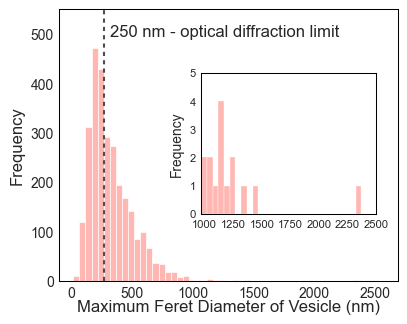

In [464]:
%matplotlib inline
#histogram of vesicle diameter

#visualize results

#what is the distribution of the percentage of vesicle volume that compose the total cell volume?
#show the overall distribution. not stratified by whether the vesicles contain nanoparticles or not

#fix the plot dimensions so you can read the long text
    #need to call plt before sns, otherwise have a gray bg
#plt.subplots_adjust(left=0,bottom=0,right=1,top=1,wspace=0,hspace=0)

#add a bit of padding on the right hand side to make the plot longer so that it can fit the label for the x-axis
#plt.subplots_adjust(right=1)

#change height and width of dataset
    #need to set these parameters before creating the plot
#ax = sns.set(rc={'figure.figsize':(5,5)})

#plt.figure() #this creates a new figure on which your plot will appear


#make the tick labels closer to the axes/spine
    #see: https://github.com/matplotlib/matplotlib/issues/17208
mpl.rcParams['xtick.top'] = False
mpl.rcParams['xtick.labeltop'] = False 
mpl.rcParams['xtick.major.pad'] = -2.25
mpl.rcParams['xtick.minor.pad'] = -2.25
mpl.rcParams['ytick.major.pad'] = -2.25
mpl.rcParams['ytick.minor.pad'] = -2.25


fig, ax = plt.subplots()

#change height and width of dataset
#ax = plt.figure(figsize=(4.373,2.6))
#ax = sns.set_style("whitegrid")


#turn off grid
#sns.set_style("whitegrid", {'axes.grid' : False})
#plt.grid(False)

#set bw to smooth out lines for visualization 
#ax = sns.histplot(data=max_vesicle_diameter_list, color=sns.color_palette("pastel")[3], bins=30) #pastel red
sns.histplot(data=max_vesicle_diameter_list, color=sns.color_palette("pastel")[3], binwidth=50, ax=ax) #pastel red

#change height and width of dataset
#ax = sns.set(rc={'figure.figsize':(12,5)})
#plt.figure(figsize=(15,5))

plt.xlabel('Maximum Feret Diameter of Vesicle (nm)',fontsize=12, fontname="Arial", ) #labelpad=0
plt.ylabel('Frequency',fontsize=12, fontname="Arial",)
#plt.ticklabel_format()
plt.xticks(fontsize=10, fontname="Arial",)
plt.yticks(fontsize=10, fontname="Arial",)



#set x and y limits to not span whole width so there is space for scale
#get default  xlim and ylim values to keep consistent between figures
current_xlim_min, current_xlim_max = ax.get_xlim()
current_ylim_min, current_ylim_max = ax.get_ylim()
#print(current_xlim_min, current_xlim_max)
plt.xlim(current_xlim_min, current_xlim_max+200) 
plt.ylim(current_ylim_min, current_ylim_max)
#set scale to 1e3
#plt.ticklabel_format(axis='both', style='sci', scilimits=(3,3))


#mids = [rect.get_x() + rect.get_width() / 2 for rect in ax.patches]
edges = [rect.get_x() for rect in ax.patches] + [ax.patches[-1].get_x() + ax.patches[-1].get_width()]
print(edges)
#ax.set_xticks(mids)

#set y-minimum value so that it does not go below zero
#plt.ylim(0)

#plt.yscale('log')
#plt.xscale('log')
#plt.xlim(0, 2400)
ax.set_ylim([0,550])
ax.set_xticks(np.arange(0, 3000, 500))
ax.set_yticks(np.arange(0, 600, 100))
#ax.set_xticks([0, 100, 200, 300, 400, 500, 1000, 1500, 2000, 2500])

#add vertical line at 250nm
ax.axvline(edges[5], color=".3", dashes=(2, 2))
ax.text(0.15, 0.9, "250 nm - optical diffraction limit",transform=ax.transAxes, fontname="Arial", size=12)


#put x-label closer to x-axes ticks. set xlabels first. 
    #see: https://github.com/matplotlib/matplotlib/issues/17208
ax.xaxis.labelpad = -0.75




#****************************************************
#Inset plot goes here
#ax2 = plt.axes([0.6, 0.6, 0.3, 0.3], facecolor='y')
ax2 = plt.axes([0.45, 0.3, 0.4, 0.4], )
#sns.histplot(data=max_vesicle_diameter_list_greater_than_1000, color=sns.color_palette("pastel")[3], binwidth=100, ax=ax2)
sns.histplot(data=max_vesicle_diameter_list, color=sns.color_palette("pastel")[3], binwidth=50, ax=ax2)
ax2.set_xticks(np.arange(1000, 2600, 250))
ax2.set_yticks(np.arange(0, 6, 1))

ax2.set_xlim([edges[19],2500]) #edge 19 is the 20th value which corresponds to the divider at x=1000
ax2.set_ylim([0,5])

plt.xticks(fontsize=8, fontname="Arial",)
plt.yticks(fontsize=8, fontname="Arial",)

#ax2.set_title('zoom')

ax2.set_ylabel('Frequency',fontsize=10, fontname="Arial",)

#****************************************************



#render figure text as font rather than path
plt.rcParams['svg.fonttype'] = 'none'


#see for iterating over all spines: https://community.dataquest.io/t/iterate-over-ax-spines-items-and-related-functions/233432/
for key,spine in ax.spines.items():
    spine.set_color('#000000')
    spine.set_linewidth(0.75)

for key,spine in ax2.spines.items():
    spine.set_color('#000000')
    spine.set_linewidth(0.75)


sns.set(rc={'figure.figsize':(4.373,3.525)})
#ax = sns.set(rc={'figure.figsize':(5,5)})
ax = sns.set_style("whitegrid")


#turn off grid
sns.set_style("whitegrid", {'axes.grid' : False})
plt.grid(False)

#fig.tight_layout()

#export figure as svg for illustrator figure
#plt.savefig("max-feret-diameter-per-vesicle.svg", format="svg", bbox_inches='tight')
#plt.savefig("max-feret-diameter-per-vesicle_V2.svg", format="svg", bbox_inches='tight')
#plt.savefig("max-feret-diameter-per-vesicle_V3.svg", format="svg", bbox_inches='tight')
#plt.savefig("max-feret-diameter-per-vesicle_V4+line.svg", format="svg", bbox_inches='tight')
#plt.savefig("max-feret-diameter-per-vesicle_V5+line.svg", format="svg", bbox_inches='tight')
#fig.savefig("max-feret-diameter-per-vesicle_V6+line.svg", format="svg", bbox_inches='tight')

#plt.rcParams['xtick.major.pad']='8'



#works when exporting as EPS, but not SVG
#fig.figure.savefig("test.eps", format="eps") 
fig.savefig("max-feret-diameter-per-vesicle_V6+line.eps", format="eps", bbox_inches='tight')

#display histogram 
plt.show()


In [158]:
''' #previous inset only
#histogram of vesicle diameter

#visualize results

#what is the distribution of the percentage of vesicle volume that compose the total cell volume?
#show the overall distribution. not stratified by whether the vesicles contain nanoparticles or not

#fix the plot dimensions so you can read the long text
    #need to call plt before sns, otherwise have a gray bg
#plt.subplots_adjust(left=0,bottom=0,right=1,top=1,wspace=0,hspace=0)

#add a bit of padding on the right hand side to make the plot longer so that it can fit the label for the x-axis
plt.subplots_adjust(right=1)

#change height and width of dataset
    #need to set these parameters before creating the plot
ax = sns.set(rc={'figure.figsize':(5,5)})

#ax = plt.figure(figsize=(15,5))
sns.set_theme(style='white')
#sns.despine()


#set bw to smooth out lines for visualization 
#ax = sns.histplot(data=max_vesicle_diameter_list_greater_than_1000, color=sns.color_palette("pastel")[3], bins=10) #pastel red
ax = sns.histplot(data=max_vesicle_diameter_list_greater_than_1000, color=sns.color_palette("pastel")[3], binwidth=100) #pastel red

#change height and width of dataset
#ax = sns.set(rc={'figure.figsize':(12,5)})
#plt.figure(figsize=(15,5))


#turn off grid
plt.grid(False)


#plt.xlabel('Maximum feret diameter of vesicle (nm)',fontsize=18)
plt.ylabel('Frequency',fontsize=22.5)
#plt.ticklabel_format()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)


#set y-minimum value so that it does not go below zero
plt.ylim(0)
#plt.yscale('log')
#plt.xscale('log')

#render figure text as font rather than path
plt.rcParams['svg.fonttype'] = 'none'

#export figure as svg for illustrator figure
#plt.savefig("max-feret-diameter-per-vesicle_greater_than_1000nm.svg", format="svg", bbox_inches='tight')


#display histogram
plt.show()
'''

' #previous inset only\n#histogram of vesicle diameter\n\n#visualize results\n\n#what is the distribution of the percentage of vesicle volume that compose the total cell volume?\n#show the overall distribution. not stratified by whether the vesicles contain nanoparticles or not\n\n#fix the plot dimensions so you can read the long text\n    #need to call plt before sns, otherwise have a gray bg\n#plt.subplots_adjust(left=0,bottom=0,right=1,top=1,wspace=0,hspace=0)\n\n#add a bit of padding on the right hand side to make the plot longer so that it can fit the label for the x-axis\nplt.subplots_adjust(right=1)\n\n#change height and width of dataset\n    #need to set these parameters before creating the plot\nax = sns.set(rc={\'figure.figsize\':(5,5)})\n\n#ax = plt.figure(figsize=(15,5))\nsns.set_theme(style=\'white\')\n#sns.despine()\n\n\n#set bw to smooth out lines for visualization \n#ax = sns.histplot(data=max_vesicle_diameter_list_greater_than_1000, color=sns.color_palette("pastel")[3]

In [159]:
#all_dataframes_concat_vesicle_vol_SA_updated_diameters
all_dataframes_concat_vesicle_vol_SA_updated_diameters.loc[all_dataframes_concat_vesicle_vol_SA_updated_diameters['label'] == 1,]
#looks good. all min and max values are the same as anticipated.

label  index_manual   area  z-slice  volume_um3  surface_area  \
0      1             0  246.0        0    0.004977          66.0   
0      1            59  284.0        1    0.005745          72.0   
0      1           127  306.0        2    0.006190          74.0   
0      1           194  308.0        3    0.006231          76.0   
0      1           255  230.0        4    0.004653          64.0   
0      1           316  155.0        5    0.003136          50.0   
0      1           380   40.0        6    0.000809          24.0   
0      1           439    7.0        7    0.000142           7.0   

   surface_area_um2  axis_major_length  axis_minor_length  feret_diameter_max  \
0           0.07854          21.403537          14.731063           22.135944   
0           0.08568          21.794029          16.630084           22.803509   
0           0.08806          21.150603          18.602109           22.472205   
0           0.09044          21.072256          18.695246           22.472205   
0           0.07616          19.395797          15.110029           20.248457   
0           0.05950          14.641933          13.578601           15.264338   
0           0.02856           8.620120           5.956806            8.944272   
0           0.00000           3.023716           2.799417            3.162278   

   equivalent_diameter_area  feret_diameter_max_nm  feret_diameter_max_um  \
0                 17.697936             376.311042               0.376311   
0                 19.015784             387.659645               0.387660   
0                 19.738574             382.027486               0.382027   
0                 19.802974             382.027486               0.382027   
0                 17.112717             344.223764               0.344224   
0                 14.048207             259.493738               0.259494   
0                  7.136496             152.052622               0.152053   
0                  2.985411              53.758720               0.053759   

   feret_diameter_max_nm_min  feret_diameter_max_nm_max  
0                   53.75872                 387.659645  
0                   53.75872                 387.659645  
0                   53.75872                 387.659645  
0                   53.75872                 387.659645  
0                   53.75872                 387.659645  
0                   53.75872                 387.659645  
0                   53.75872                 387.659645  
0                   53.75872                 387.659645

In [160]:
# determine which vesicle each NP is in
    #  note only need to consider NPs that have a EDT value of 0 as this tells us that the NP is within the cell. So first need to select subset of NPs in cells.

# read in dataframe where each row is a different NP with centroid coords
all_df_EDT_combined = pd.read_csv('df_EDT_closest_cell_t-score.csv', index_col=0)
all_df_EDT_combined_vesicle = all_df_EDT_combined.copy()
all_df_EDT_combined_vesicle

NP-label  3D-EDT-to-cell-7_nm  3D-EDT-to-cell-8_nm  \
0              1          68796.39844          15273.59277   
1              2          68600.06250          15038.66309   
2              3          67079.95313          13693.51172   
3              4          67016.51563          13641.23047   
4              5          66895.14063          13526.98438   
...          ...                  ...                  ...   
574886    574887          16417.79688          16599.83008   
574887    574888          16398.58984          16601.71875   
574888    574889          16266.76563          16499.04297   
574889    574890          16589.42578          16755.51172   
574890    574891          16840.20117          16961.93945   

        3D-EDT-to-cell-9_nm  3D-EDT-to-cell-10_nm  3D-EDT-to-cell-11_nm  \
0               63235.89844           58506.18750           58567.34375   
1               62932.21875           58186.86719           58257.55469   
2               61750.96875           57059.13281           57096.19531   
3               61704.20703           57015.19141           57050.60938   
4               61591.77344           56904.30859           56938.69922   
...                     ...                   ...                   ...   
574886          23503.05469           20402.54492           28613.79688   
574887          23501.32617           20395.63867           28600.63867   
574888          23391.50195           20252.87305           28465.21875   
574889          23664.09961           20605.15820           28797.71289   
574890          23880.81055           20881.79297           29056.88867   

        3D-EDT-to-cell-12_nm  3D-EDT-to-cell-13_nm  3D-EDT-to-cell-14_nm  \
0                53622.86719           51787.61719           61350.91406   
1                53327.51563           51485.75781           60967.10547   
2                52338.45313           50549.91016           60141.12500   
3                52300.46094           50514.43750           60111.50781   
4                52201.81250           50418.51953           60012.43359   
...                      ...                   ...                   ...   
574886           22026.15625           29189.99023           30947.19531   
574887           22020.29688           29175.02930           30907.76563   
574888           21877.96289           29030.34570           30749.52539   
574889           22229.40234           29385.15234           31131.53906   
574890           22505.61719           29660.98438           31421.01563   

        3D-EDT-to-cell-15_nm  ...  3D-EDT-to-cell-32_nm  3D-EDT-to-cell-33_nm  \
0                67307.30469  ...           65093.47266           56342.47266   
1                66878.63281  ...           64862.32031           56055.84766   
2                66321.06250  ...           63435.89453           54802.91406   
3                66303.85938  ...           63377.20313           54752.46484   
4                66216.72656  ...           63257.63672           54637.24609   
...                      ...  ...                   ...                   ...   
574886           34492.24219  ...           23096.61914           31762.37500   
574887           34442.52344  ...           23107.13281           31771.58398   
574888           34283.90625  ...           23026.44727           31683.77734   
574889           34664.26172  ...           23230.42969           31904.54492   
574890           34949.33594  ...           23397.77539           32083.23438   

        3D-EDT-to-cell-34_nm  lowest-EDT_nm  cell-lowest-EDT  z-slice  \
0                58079.43750    15273.59277                8        0   
1                57758.58984    15038.66309                8        0   
2                56637.13281    13693.51172                8        0   
3                56593.50391    13641.23047                8        0   
4                56482.84375    13526.98438                8        0   
...                      ...          

In [161]:
# only need to consider subset of NPs where EDT = 0.
# this is because all vesicles are in cells. thus to find the NPs in vesicles, we only need to consider the vesicles in cells (i.e. EDT = 0)

#get list of indices for NPs in cells/vesicles 
#all_df_EDT_combined_vesicle.loc[all_df_EDT_combined_vesicle['lowest-EDT_nm'] ==0].index.tolist()
list_of_NPs_in_cells = all_df_EDT_combined_vesicle.loc[all_df_EDT_combined_vesicle['lowest-EDT_nm'] ==0].index.tolist()
list_of_NPs_in_cells


[105,
 106,
 107,
 108,
 109,
 112,
 123,
 134,
 144,
 145,
 149,
 152,
 155,
 157,
 158,
 159,
 160,
 161,
 162,
 332,
 336,
 337,
 338,
 448,
 452,
 472,
 498,
 505,
 507,
 513,
 516,
 519,
 520,
 521,
 523,
 525,
 528,
 529,
 530,
 531,
 532,
 533,
 534,
 535,
 536,
 538,
 539,
 540,
 542,
 544,
 545,
 546,
 547,
 548,
 549,
 550,
 551,
 552,
 553,
 558,
 560,
 563,
 564,
 565,
 567,
 568,
 571,
 572,
 573,
 574,
 577,
 578,
 579,
 580,
 581,
 582,
 583,
 584,
 586,
 587,
 590,
 591,
 592,
 598,
 601,
 606,
 607,
 608,
 609,
 610,
 614,
 615,
 616,
 621,
 622,
 623,
 626,
 629,
 630,
 632,
 633,
 635,
 636,
 637,
 639,
 640,
 641,
 642,
 643,
 645,
 647,
 648,
 658,
 678,
 682,
 709,
 753,
 757,
 758,
 761,
 762,
 804,
 890,
 904,
 908,
 909,
 915,
 917,
 918,
 919,
 920,
 921,
 922,
 923,
 924,
 925,
 927,
 929,
 930,
 931,
 932,
 933,
 934,
 935,
 936,
 938,
 940,
 941,
 952,
 953,
 1161,
 1162,
 1163,
 1164,
 1187,
 1195,
 1198,
 1199,
 1200,
 1201,
 1343,
 1344,
 1345,
 1347,
 1

In [162]:
#read in tif of annotated vesicle_CCL that is updated (removed bad vesicles outside of cells)
updated_vesicle_CCL_array = io.imread(r"C:\Users\SM\Desktop\Reviewer-vesicle\og-files\3.py\12_June5-2024_Labels_update-145_dataset_fine_ome-16bit-lbl-CCL_rm-bad.tif", plugin="tifffile")

In [212]:
# add column to dataframe which will hold the vesicle that the NP is within. assign value as 0 to start. then replace with vesicle ID if the NP is in a vesicle

all_df_EDT_combined_vesicle['vesicle-ID'] = 0

#get shape of 1 slice of dataset
z_shape, y_shape, x_shape = updated_vesicle_CCL_array.shape # can use annotated or annotated_EC_only here, 1 less variable to need if I use annotated_EC_only

#set value of new column for 3D EDT to the 3D EDT value at the NP coordinates 
for each_np in tqdm(list_of_NPs_in_cells): 
    each_np_plus_1 = each_np+1
        
    z_slice_np = all_df_EDT_combined_vesicle.loc[all_df_EDT_combined_vesicle['NP-label'] == each_np_plus_1, 'z-slice'].values[0]
    y_coord_np = all_df_EDT_combined_vesicle.loc[all_df_EDT_combined_vesicle['NP-label'] == each_np_plus_1, 'centroid,0_16bit'].values[0]
    x_coord_np = all_df_EDT_combined_vesicle.loc[all_df_EDT_combined_vesicle['NP-label'] == each_np_plus_1, 'centroid,1_16bit'].values[0]

    #get coords as a set
    #needed to nest the values as int for some reason to avoid error
    current_np_coords_set = int(z_slice_np), int(y_coord_np) , int(x_coord_np)
    
    #set value for vesicle-ID of the current NP to the vesicle value at the NP centroid coordinates
    all_df_EDT_combined_vesicle.loc[each_np,'vesicle-ID'] = updated_vesicle_CCL_array[current_np_coords_set]

print("done")

100%|███████████████████████████████████████████████████████████████████████████| 18136/18136 [00:31<00:00, 577.44it/s]

done


In [682]:
# how many nanoparticles are in each vesicle? how many vesicles do not contain any number of nanoparticles?
#count the number of NP-labels that are in vesicle-ID

print(len(all_df_EDT_combined_vesicle.groupby("vesicle-ID").count())-1) #there are 623 vesicles that have at least one nanoparticle (624 minus 1, since row 0 is background)

#all_df_EDT_combined_vesicle.groupby("vesicle-ID").count()


623


In [101]:
all_df_EDT_combined_vesicle

NP-label  3D-EDT-to-cell-7_nm  3D-EDT-to-cell-8_nm  \
0              1          68796.39844          15273.59277   
1              2          68600.06250          15038.66309   
2              3          67079.95313          13693.51172   
3              4          67016.51563          13641.23047   
4              5          66895.14063          13526.98438   
...          ...                  ...                  ...   
574886    574887          16417.79688          16599.83008   
574887    574888          16398.58984          16601.71875   
574888    574889          16266.76563          16499.04297   
574889    574890          16589.42578          16755.51172   
574890    574891          16840.20117          16961.93945   

        3D-EDT-to-cell-9_nm  3D-EDT-to-cell-10_nm  3D-EDT-to-cell-11_nm  \
0               63235.89844           58506.18750           58567.34375   
1               62932.21875           58186.86719           58257.55469   
2               61750.96875           57059.13281           57096.19531   
3               61704.20703           57015.19141           57050.60938   
4               61591.77344           56904.30859           56938.69922   
...                     ...                   ...                   ...   
574886          23503.05469           20402.54492           28613.79688   
574887          23501.32617           20395.63867           28600.63867   
574888          23391.50195           20252.87305           28465.21875   
574889          23664.09961           20605.15820           28797.71289   
574890          23880.81055           20881.79297           29056.88867   

        3D-EDT-to-cell-12_nm  3D-EDT-to-cell-13_nm  3D-EDT-to-cell-14_nm  \
0                53622.86719           51787.61719           61350.91406   
1                53327.51563           51485.75781           60967.10547   
2                52338.45313           50549.91016           60141.12500   
3                52300.46094           50514.43750           60111.50781   
4                52201.81250           50418.51953           60012.43359   
...                      ...                   ...                   ...   
574886           22026.15625           29189.99023           30947.19531   
574887           22020.29688           29175.02930           30907.76563   
574888           21877.96289           29030.34570           30749.52539   
574889           22229.40234           29385.15234           31131.53906   
574890           22505.61719           29660.98438           31421.01563   

        3D-EDT-to-cell-15_nm  ...  3D-EDT-to-cell-33_nm  3D-EDT-to-cell-34_nm  \
0                67307.30469  ...           56342.47266           58079.43750   
1                66878.63281  ...           56055.84766           57758.58984   
2                66321.06250  ...           54802.91406           56637.13281   
3                66303.85938  ...           54752.46484           56593.50391   
4                66216.72656  ...           54637.24609           56482.84375   
...                      ...  ...                   ...                   ...   
574886           34492.24219  ...           31762.37500           35503.62500   
574887           34442.52344  ...           31771.58398           35498.28516   
574888           34283.90625  ...           31683.77734           35386.41406   
574889           34664.26172  ...           31904.54492           35662.75391   
574890           34949.33594  ...           32083.23438           35880.46875   

        lowest-EDT_nm  cell-lowest-EDT  z-slice  centroid,0_16bit  \
0         15273.59277                8        0               286   
1         15038.66309                8        0               314   
2         13693.51172                8        0               323   
3         13641.23047                8        0               323   
4         13526.98438                8        0               327   
...               ...              ...      ...               

In [228]:
#all_df_EDT_combined_vesicle.to_csv('df_EDT_closest_cell_t-score.csv+vesicle.csv', index=True)
#comment out for now to prevent overwrite


In [191]:
# read in dataframe where each row is a different NP with centroid coords
all_df_EDT_combined_vesicle = pd.read_csv('df_EDT_closest_cell_t-score.csv+vesicle.csv', index_col=0)

In [192]:
all_df_EDT_combined_vesicle

NP-label  3D-EDT-to-cell-7_nm  3D-EDT-to-cell-8_nm  \
0              1          68796.39844          15273.59277   
1              2          68600.06250          15038.66309   
2              3          67079.95313          13693.51172   
3              4          67016.51563          13641.23047   
4              5          66895.14063          13526.98438   
...          ...                  ...                  ...   
574886    574887          16417.79688          16599.83008   
574887    574888          16398.58984          16601.71875   
574888    574889          16266.76563          16499.04297   
574889    574890          16589.42578          16755.51172   
574890    574891          16840.20117          16961.93945   

        3D-EDT-to-cell-9_nm  3D-EDT-to-cell-10_nm  3D-EDT-to-cell-11_nm  \
0               63235.89844           58506.18750           58567.34375   
1               62932.21875           58186.86719           58257.55469   
2               61750.96875           57059.13281           57096.19531   
3               61704.20703           57015.19141           57050.60938   
4               61591.77344           56904.30859           56938.69922   
...                     ...                   ...                   ...   
574886          23503.05469           20402.54492           28613.79688   
574887          23501.32617           20395.63867           28600.63867   
574888          23391.50195           20252.87305           28465.21875   
574889          23664.09961           20605.15820           28797.71289   
574890          23880.81055           20881.79297           29056.88867   

        3D-EDT-to-cell-12_nm  3D-EDT-to-cell-13_nm  3D-EDT-to-cell-14_nm  \
0                53622.86719           51787.61719           61350.91406   
1                53327.51563           51485.75781           60967.10547   
2                52338.45313           50549.91016           60141.12500   
3                52300.46094           50514.43750           60111.50781   
4                52201.81250           50418.51953           60012.43359   
...                      ...                   ...                   ...   
574886           22026.15625           29189.99023           30947.19531   
574887           22020.29688           29175.02930           30907.76563   
574888           21877.96289           29030.34570           30749.52539   
574889           22229.40234           29385.15234           31131.53906   
574890           22505.61719           29660.98438           31421.01563   

        3D-EDT-to-cell-15_nm  ...  3D-EDT-to-cell-33_nm  3D-EDT-to-cell-34_nm  \
0                67307.30469  ...           56342.47266           58079.43750   
1                66878.63281  ...           56055.84766           57758.58984   
2                66321.06250  ...           54802.91406           56637.13281   
3                66303.85938  ...           54752.46484           56593.50391   
4                66216.72656  ...           54637.24609           56482.84375   
...                      ...  ...                   ...                   ...   
574886           34492.24219  ...           31762.37500           35503.62500   
574887           34442.52344  ...           31771.58398           35498.28516   
574888           34283.90625  ...           31683.77734           35386.41406   
574889           34664.26172  ...           31904.54492           35662.75391   
574890           34949.33594  ...           32083.23438           35880.46875   

        lowest-EDT_nm  cell-lowest-EDT  z-slice  centroid,0_16bit  \
0         15273.59277                8        0               286   
1         15038.66309                8        0               314   
2         13693.51172                8        0               323   
3         13641.23047                8        0               323   
4         13526.98438                8        0               327   
...               ...              ...      ...               

In [193]:
vesicles_with_NPs = all_df_EDT_combined_vesicle.groupby("vesicle-ID").count().index.tolist()[1:] # index out the first value which is equal to 0 (background, not a real vesicle-ID)
vesicles_with_NPs

[3,
 5,
 7,
 9,
 10,
 12,
 36,
 38,
 58,
 61,
 63,
 67,
 71,
 78,
 80,
 82,
 105,
 115,
 125,
 129,
 130,
 131,
 144,
 154,
 155,
 164,
 176,
 184,
 188,
 196,
 221,
 225,
 229,
 232,
 236,
 241,
 263,
 267,
 268,
 269,
 276,
 284,
 285,
 288,
 295,
 298,
 317,
 318,
 321,
 334,
 341,
 348,
 351,
 353,
 354,
 358,
 362,
 380,
 392,
 394,
 395,
 396,
 405,
 408,
 412,
 429,
 435,
 441,
 455,
 468,
 478,
 482,
 488,
 500,
 501,
 507,
 520,
 525,
 537,
 539,
 540,
 558,
 569,
 584,
 590,
 598,
 608,
 610,
 616,
 617,
 621,
 627,
 628,
 634,
 640,
 645,
 646,
 661,
 662,
 666,
 669,
 681,
 686,
 700,
 708,
 715,
 722,
 725,
 730,
 740,
 752,
 755,
 756,
 766,
 769,
 778,
 784,
 787,
 791,
 799,
 811,
 817,
 821,
 822,
 835,
 844,
 845,
 852,
 857,
 862,
 873,
 892,
 894,
 901,
 931,
 932,
 946,
 956,
 958,
 959,
 961,
 984,
 996,
 1001,
 1009,
 1010,
 1019,
 1023,
 1029,
 1031,
 1035,
 1042,
 1053,
 1064,
 1067,
 1075,
 1088,
 1089,
 1092,
 1112,
 1114,
 1117,
 1140,
 1156,
 1157,
 1163,
 

In [194]:
#read in dataset with vesicle-volume+SA columns
all_dataframes_concat_vesicle_vol_SA = pd.read_csv('df_unique-vesicle-volume+SA.csv', index_col=0) # set index_col to 0
all_dataframes_concat_vesicle_vol_SA

label  index_manual   area  z-slice  volume_um3  surface_area  \
0       1             0  246.0        0    0.004977          66.0   
1       2             1  172.0        0    0.003480          54.0   
2       3             2  114.0        0    0.002306          46.0   
3       4             3   33.0        0    0.000668          22.0   
4       5             4  105.0        0    0.002124          40.0   
..    ...           ...    ...      ...         ...           ...   
30   3077         17434  136.0      341    0.002751          48.0   
31   3078         17435   42.0      341    0.000850          26.0   
32   3079         17436   46.0      341    0.000931          28.0   
33   3080         17437   42.0      341    0.000850          26.0   
34   3081         17438   19.0      341    0.000384          16.0   

    surface_area_um2  
0            0.07854  
1            0.06426  
2            0.05474  
3            0.02618  
4            0.04760  
..               ...  
30           0.05712  
31           0.03094  
32           0.03332  
33           0.03094  
34           0.01904  

[17439 rows x 7 columns]

In [195]:
#get list of vesicles without NPS 
#first get list of all vesicles, then subtract the list of vesicle with NPs. The result is the list of vesicles without NPs. 

#all_dataframes_concat_vesicle_vol_SA['label'].unique().tolist()
all_vesicles = all_dataframes_concat_vesicle_vol_SA['label'].unique().tolist()

In [196]:
all_dataframes_concat_vesicle_vol_SA

label  index_manual   area  z-slice  volume_um3  surface_area  \
0       1             0  246.0        0    0.004977          66.0   
1       2             1  172.0        0    0.003480          54.0   
2       3             2  114.0        0    0.002306          46.0   
3       4             3   33.0        0    0.000668          22.0   
4       5             4  105.0        0    0.002124          40.0   
..    ...           ...    ...      ...         ...           ...   
30   3077         17434  136.0      341    0.002751          48.0   
31   3078         17435   42.0      341    0.000850          26.0   
32   3079         17436   46.0      341    0.000931          28.0   
33   3080         17437   42.0      341    0.000850          26.0   
34   3081         17438   19.0      341    0.000384          16.0   

    surface_area_um2  
0            0.07854  
1            0.06426  
2            0.05474  
3            0.02618  
4            0.04760  
..               ...  
30           0.05712  
31           0.03094  
32           0.03332  
33           0.03094  
34           0.01904  

[17439 rows x 7 columns]

In [197]:
# get list of vesicles in index column
# compare to list of all vesicle labels
#get the unique vesicles that are NOT found in the above dataframe. these are the vesicles that have 0 NPs in them. (check this)

vesicles_without_NPS = (list(set(all_vesicles) - set(vesicles_with_NPs)))
print(len(all_vesicles))
print(len(vesicles_with_NPs))
print(len(vesicles_without_NPS))

print(len(vesicles_with_NPs)+len(vesicles_without_NPS))

#looks good

2797
623
2174
2797


In [198]:
#how many vesicles do not contain any NPs?
print(len(vesicles_without_NPS))

#what percentage of total vesicles contain at least 1 NP?
print(np.round(len(vesicles_with_NPs)/len(all_vesicles)*100,2), "%")
#22% of vesicles have at least one NP. This suggests there is physical space to increase the amount of NPs within vesicles.
    # Granted, not all vesicles can transport NPs into tumour microenvironment

2174
22.27 %


In [199]:
#what percentage of volume of each vesicle is occupied by NPs?
# read in dataframe of volumes for each vesicle label
# then read in image/array of the vesicle CCL without NPs. This tells you the volume of vesicle NOT occupied by NPs. 
#Subtract the total vesicle volume by the vesicle-volume-without-NPs to get the volume of each vesicle occupied by NPs

In [200]:
#read in dataset with vesicle-volume+SA columns
all_dataframes_concat_vesicle_vol_SA_updated_diameters = pd.read_csv('all_dataframes_concat_vesicle_vol_SA_updated_diameters.csv', index_col=0)
all_dataframes_concat_vesicle_vol_SA_updated_diameters

label  index_manual   area  z-slice  volume_um3  surface_area  \
0       1             0  246.0        0    0.004977          66.0   
1       2             1  172.0        0    0.003480          54.0   
2       3             2  114.0        0    0.002306          46.0   
3       4             3   33.0        0    0.000668          22.0   
4       5             4  105.0        0    0.002124          40.0   
..    ...           ...    ...      ...         ...           ...   
30   3077         17434  136.0      341    0.002751          48.0   
31   3078         17435   42.0      341    0.000850          26.0   
32   3079         17436   46.0      341    0.000931          28.0   
33   3080         17437   42.0      341    0.000850          26.0   
34   3081         17438   19.0      341    0.000384          16.0   

    surface_area_um2  axis_major_length  axis_minor_length  \
0            0.07854          21.403537          14.731063   
1            0.06426          15.560229          14.261594   
2            0.05474          17.689798           8.207262   
3            0.02618           9.053582           4.724315   
4            0.04760          11.971260          11.152847   
..               ...                ...                ...   
30           0.05712          14.608867          11.920282   
31           0.03094           8.969823           6.019270   
32           0.03332           9.673275           6.033347   
33           0.03094           9.207898           5.791081   
34           0.01904           5.823607           4.256623   

    feret_diameter_max  equivalent_diameter_area  feret_diameter_max_nm  \
0            22.135944                 17.697936             376.311042   
1            16.552945                 14.798554             281.400071   
2            17.464249                 12.047793             296.892236   
3             8.944272                  6.482045             152.052622   
4            12.529964                 11.562446             213.009389   
..                 ...                       ...                    ...   
30           15.811388                 13.159049             268.793601   
31            9.433981                  7.312733             160.377679   
32            9.848858                  7.653040             167.430583   
33            9.486833                  7.312733             161.276161   
34            5.830952                  4.918491              99.126182   

    feret_diameter_max_um  
0                0.376311  
1                0.281400  
2                0.296892  
3                0.152053  
4                0.213009  
..                    ...  
30               0.268794  
31               0.160378  
32               0.167431  
33               0.161276  
34               0.099126  

[17439 rows x 13 columns]

In [135]:
#read in annotated vesicle_CCL without NPs (NPs subtracted/sub) that is updated (removed bad vesicles outside of cells)
updated_vesicle_CCL_array_sub_NPs = io.imread(r"C:\Users\SM\Desktop\Reviewer-vesicle\vesicle-analysis\10.CCL-label-vesicle-sub-NPs\12_June5-2024_Labels_update-145_dataset_fine_ome_rm-bad_CCL-vesicles-sub-NPs.tif", plugin="tifffile")

In [136]:
# get the volume of each vesicle. just count the number of each pixel of each label in the vesicle channel after subtracting NP signal. only consider good vesicles

#doing region props on each slice of dataset (each index of z-dimension)
    
all_dataframes_concat_vesicle_diameter_sub_NPs = pd.DataFrame() #reset dataframe for when doing testing
    
num_z_slices = updated_vesicle_CCL_array_sub_NPs.shape[0]

all_dataframes_vesicle_sub_NPs_list = []
for z_slice in tqdm(range(num_z_slices)):
    roi_properties = skimage.measure.regionprops_table(label_image=updated_vesicle_CCL_array_sub_NPs[z_slice, :, :], #added '[frame, :, :]' after annotated
                                                       #intensity_image=dataset[z_slice, :, :],
                                                       properties=(
                                                           'label', 
                                                       #    'mean_intensity',
                                                           #'axis_major_length',
                                                           #'axis_minor_length',
                                                           #'equivalent_diameter_area',
                                                           'area',
                                                       ),
                                                       separator=",",
                                                       extra_properties=None,)
    dataframe_current_frame = pd.DataFrame(roi_properties)
    dataframe_current_frame['z-slice'] = z_slice
    all_dataframes_vesicle_sub_NPs_list.append(dataframe_current_frame)

all_dataframes_concat_vesicle_diameter_sub_NPs = pd.concat(all_dataframes_vesicle_sub_NPs_list)

#use surface area on each slice to get volume of each label on each slice
all_dataframes_concat_vesicle_diameter_sub_NPs['volume_um3'] = all_dataframes_concat_vesicle_diameter_sub_NPs['area']*(17*17*70)/(1000*1000*1000) #17nm/pixel; 70nm = z depth. 1000nm = 1um. but volume, not length, so cube. 1 nm^2 = 1/(1000*1000*1000) um^3

#print(all_dataframes_concat.head())

100%|████████████████████████████████████████████████████████████████████████████████| 342/342 [00:16<00:00, 20.96it/s]


In [822]:
#check the indices to find out what the differences are
# check unique values

In [823]:
#add the columns to the original dataframe with the area/volume after subtracting nanoparticles from the vesicles
all_dataframes_concat_vesicle_vol_SA_updated_diameters['volume_subtract_nps_area'] = all_dataframes_concat_vesicle_diameter_sub_NPs['area']
all_dataframes_concat_vesicle_vol_SA_updated_diameters['volume_subtract_nps_um3'] = all_dataframes_concat_vesicle_diameter_sub_NPs['volume_um3']

NameError: name 'all_dataframes_concat_vesicle_diameter_sub_NPs' is not defined

In [144]:
all_dataframes_concat_vesicle_vol_SA_updated_diameters

label  index_manual   area  z-slice  volume_um3  surface_area  \
0       1             0  246.0        0    0.004977          66.0   
1       2             1  172.0        0    0.003480          54.0   
2       3             2  114.0        0    0.002306          46.0   
3       4             3   33.0        0    0.000668          22.0   
4       5             4  105.0        0    0.002124          40.0   
..    ...           ...    ...      ...         ...           ...   
30   3077         17434  136.0      341    0.002751          48.0   
31   3078         17435   42.0      341    0.000850          26.0   
32   3079         17436   46.0      341    0.000931          28.0   
33   3080         17437   42.0      341    0.000850          26.0   
34   3081         17438   19.0      341    0.000384          16.0   

    surface_area_um2  axis_major_length  axis_minor_length  \
0            0.07854          21.403537          14.731063   
1            0.06426          15.560229          14.261594   
2            0.05474          17.689798           8.207262   
3            0.02618           9.053582           4.724315   
4            0.04760          11.971260          11.152847   
..               ...                ...                ...   
30           0.05712          14.608867          11.920282   
31           0.03094           8.969823           6.019270   
32           0.03332           9.673275           6.033347   
33           0.03094           9.207898           5.791081   
34           0.01904           5.823607           4.256623   

    feret_diameter_max  equivalent_diameter_area  feret_diameter_max_nm  \
0            22.135944                 17.697936             376.311042   
1            16.552945                 14.798554             281.400071   
2            17.464249                 12.047793             296.892236   
3             8.944272                  6.482045             152.052622   
4            12.529964                 11.562446             213.009389   
..                 ...                       ...                    ...   
30           15.811388                 13.159049             268.793601   
31            9.433981                  7.312733             160.377679   
32            9.848858                  7.653040             167.430583   
33            9.486833                  7.312733             161.276161   
34            5.830952                  4.918491              99.126182   

    feret_diameter_max_um  volume_subtract_nps_area  volume_subtract_nps_um3  
0                0.376311                     246.0                 0.004977  
1                0.281400                     172.0                 0.003480  
2                0.296892                     108.0                 0.002185  
3                0.152053                      33.0                 0.000668  
4                0.213009                      93.0                 0.001881  
..                    ...                       ...                      ...  
30               0.268794                     136.0                 0.002751  
31               0.160378                      42.0                 0.000850  
32               0.167431                      46.0                 0.000931  
33               0.161276                      42.0                 0.000850  
34               0.099126                      19.0                 0.000384  

[17439 rows x 15 columns]

In [824]:
#add a column that is just the area/volume_um3 of the nanoparticles for each slice of the dataframe
all_dataframes_concat_vesicle_vol_SA_updated_diameters['volume_nps_only_area'] = all_dataframes_concat_vesicle_vol_SA_updated_diameters['area'] - all_dataframes_concat_vesicle_vol_SA_updated_diameters['volume_subtract_nps_area']
all_dataframes_concat_vesicle_vol_SA_updated_diameters['volume_nps_only_volume_um3'] = all_dataframes_concat_vesicle_vol_SA_updated_diameters['volume_um3'] - all_dataframes_concat_vesicle_vol_SA_updated_diameters['volume_subtract_nps_um3']

KeyError: 'volume_subtract_nps_area'

In [150]:
all_dataframes_concat_vesicle_vol_SA_updated_diameters

label  index_manual   area  z-slice  volume_um3  surface_area  \
0       1             0  246.0        0    0.004977          66.0   
1       2             1  172.0        0    0.003480          54.0   
2       3             2  114.0        0    0.002306          46.0   
3       4             3   33.0        0    0.000668          22.0   
4       5             4  105.0        0    0.002124          40.0   
..    ...           ...    ...      ...         ...           ...   
30   3077         17434  136.0      341    0.002751          48.0   
31   3078         17435   42.0      341    0.000850          26.0   
32   3079         17436   46.0      341    0.000931          28.0   
33   3080         17437   42.0      341    0.000850          26.0   
34   3081         17438   19.0      341    0.000384          16.0   

    surface_area_um2  axis_major_length  axis_minor_length  \
0            0.07854          21.403537          14.731063   
1            0.06426          15.560229          14.261594   
2            0.05474          17.689798           8.207262   
3            0.02618           9.053582           4.724315   
4            0.04760          11.971260          11.152847   
..               ...                ...                ...   
30           0.05712          14.608867          11.920282   
31           0.03094           8.969823           6.019270   
32           0.03332           9.673275           6.033347   
33           0.03094           9.207898           5.791081   
34           0.01904           5.823607           4.256623   

    feret_diameter_max  equivalent_diameter_area  feret_diameter_max_nm  \
0            22.135944                 17.697936             376.311042   
1            16.552945                 14.798554             281.400071   
2            17.464249                 12.047793             296.892236   
3             8.944272                  6.482045             152.052622   
4            12.529964                 11.562446             213.009389   
..                 ...                       ...                    ...   
30           15.811388                 13.159049             268.793601   
31            9.433981                  7.312733             160.377679   
32            9.848858                  7.653040             167.430583   
33            9.486833                  7.312733             161.276161   
34            5.830952                  4.918491              99.126182   

    feret_diameter_max_um  volume_subtract_nps_area  volume_subtract_nps_um3  \
0                0.376311                     246.0                 0.004977   
1                0.281400                     172.0                 0.003480   
2                0.296892                     108.0                 0.002185   
3                0.152053                      33.0                 0.000668   
4                0.213009                      93.0                 0.001881   
..                    ...                       ...                      ...   
30               0.268794                     136.0                 0.002751   
31               0.160378                      42.0                 0.000850   
32               0.167431                      46.0                 0.000931   
33               0.161276                      42.0                 0.000850   
34               0.099126                      19.0                 0.000384   

    volume_nps_only_area  volume_nps_only_volume_um3  
0                    0.0                    0.000000  
1                    0.0                    0.000000  
2                    6.0                    0.000121  
3                    0.0                    0.000000  
4                   12.0                    0.000243  
..                   ...                         ...  
30                   0.0                    0.000000  
31                   0.0                    0.000000  
32                   0.0                    0.000000  
33                

In [151]:
#save updated dataframe
#all_dataframes_concat_vesicle_vol_SA_updated_diameters.to_csv('all_dataframes_concat_vesicle_vol_SA_updated_diameters+NP-subtract.csv', index=True)
#comment it out to prevent overwriting file

In [163]:
#compare 2D and 3D values for vesicle volume and SA

# need to see if we can show that 3D value is more accurate than 2D extrapolation
    #do correlation between true surface area and projected surface area
    # need to know the number of slices for each cell and the surface area of one slice

#below are morphometric features visualized as plots

#READ IN DATASET
#all_dataframes_concat_vesicle_vol_SA_updated_diameters.to_csv('all_dataframes_concat_vesicle_vol_SA_updated_diameters+NP-subtract.csv', index=True)
all_dataframes_concat_vesicle_vol_SA_updated_diameters= pd.read_csv('all_dataframes_concat_vesicle_vol_SA_updated_diameters+NP-subtract.csv',index_col=0)
all_dataframes_concat_vesicle_vol_SA_updated_diameters


label  index_manual   area  z-slice  volume_um3  surface_area  \
0       1             0  246.0        0    0.004977          66.0   
1       2             1  172.0        0    0.003480          54.0   
2       3             2  114.0        0    0.002306          46.0   
3       4             3   33.0        0    0.000668          22.0   
4       5             4  105.0        0    0.002124          40.0   
..    ...           ...    ...      ...         ...           ...   
30   3077         17434  136.0      341    0.002751          48.0   
31   3078         17435   42.0      341    0.000850          26.0   
32   3079         17436   46.0      341    0.000931          28.0   
33   3080         17437   42.0      341    0.000850          26.0   
34   3081         17438   19.0      341    0.000384          16.0   

    surface_area_um2  axis_major_length  axis_minor_length  \
0            0.07854          21.403537          14.731063   
1            0.06426          15.560229          14.261594   
2            0.05474          17.689798           8.207262   
3            0.02618           9.053582           4.724315   
4            0.04760          11.971260          11.152847   
..               ...                ...                ...   
30           0.05712          14.608867          11.920282   
31           0.03094           8.969823           6.019270   
32           0.03332           9.673275           6.033347   
33           0.03094           9.207898           5.791081   
34           0.01904           5.823607           4.256623   

    feret_diameter_max  equivalent_diameter_area  feret_diameter_max_nm  \
0            22.135944                 17.697936             376.311042   
1            16.552945                 14.798554             281.400071   
2            17.464249                 12.047793             296.892236   
3             8.944272                  6.482045             152.052622   
4            12.529964                 11.562446             213.009389   
..                 ...                       ...                    ...   
30           15.811388                 13.159049             268.793601   
31            9.433981                  7.312733             160.377679   
32            9.848858                  7.653040             167.430583   
33            9.486833                  7.312733             161.276161   
34            5.830952                  4.918491              99.126182   

    feret_diameter_max_um  volume_subtract_nps_area  volume_subtract_nps_um3  \
0                0.376311                     246.0                 0.004977   
1                0.281400                     172.0                 0.003480   
2                0.296892                     108.0                 0.002185   
3                0.152053                      33.0                 0.000668   
4                0.213009                      93.0                 0.001881   
..                    ...                       ...                      ...   
30               0.268794                     136.0                 0.002751   
31               0.160378                      42.0                 0.000850   
32               0.167431                      46.0                 0.000931   
33               0.161276                      42.0                 0.000850   
34               0.099126                      19.0                 0.000384   

    volume_nps_only_area  volume_nps_only_volume_um3  
0                    0.0                    0.000000  
1                    0.0                    0.000000  
2                    6.0                    0.000121  
3                    0.0                    0.000000  
4                   12.0                    0.000243  
..                   ...                         ...  
30                   0.0                    0.000000  
31                   0.0                    0.000000  
32                   0.0                    0.000000  
33                

In [164]:
#sort values by label first, then by z-slice
organized_all_vesicles_diameter = all_dataframes_concat_vesicle_vol_SA_updated_diameters.sort_values(by=['label', 'z-slice'])
organized_all_vesicles_diameter

label  index_manual   area  z-slice  volume_um3  surface_area  \
0       1             0  246.0        0    0.004977          66.0   
0       1            59  284.0        1    0.005745          72.0   
0       1           127  306.0        2    0.006190          74.0   
0       1           194  308.0        3    0.006231          76.0   
0       1           255  230.0        4    0.004653          64.0   
..    ...           ...    ...      ...         ...           ...   
39   3079         17402   15.0      340    0.000303          13.0   
32   3079         17436   46.0      341    0.000931          28.0   
40   3080         17403   16.0      340    0.000324          14.0   
33   3080         17437   42.0      341    0.000850          26.0   
34   3081         17438   19.0      341    0.000384          16.0   

    surface_area_um2  axis_major_length  axis_minor_length  \
0            0.07854          21.403537          14.731063   
0            0.08568          21.794029          16.630084   
0            0.08806          21.150603          18.602109   
0            0.09044          21.072256          18.695246   
0            0.07616          19.395797          15.110029   
..               ...                ...                ...   
39           0.01547           5.982594           3.048445   
32           0.03332           9.673275           6.033347   
40           0.01666           5.654620           3.494677   
33           0.03094           9.207898           5.791081   
34           0.01904           5.823607           4.256623   

    feret_diameter_max  equivalent_diameter_area  feret_diameter_max_nm  \
0            22.135944                 17.697936             376.311042   
0            22.803509                 19.015784             387.659645   
0            22.472205                 19.738574             382.027486   
0            22.472205                 19.802974             382.027486   
0            20.248457                 17.112717             344.223764   
..                 ...                       ...                    ...   
39            6.082763                  4.370194             103.406963   
32            9.848858                  7.653040             167.430583   
40            5.830952                  4.513517              99.126182   
33            9.486833                  7.312733             161.276161   
34            5.830952                  4.918491              99.126182   

    feret_diameter_max_um  volume_subtract_nps_area  volume_subtract_nps_um3  \
0                0.376311                     246.0                 0.004977   
0                0.387660                     284.0                 0.005745   
0                0.382027                     306.0                 0.006190   
0                0.382027                     308.0                 0.006231   
0                0.344224                     230.0                 0.004653   
..                    ...                       ...                      ...   
39               0.103407                      15.0                 0.000303   
32               0.167431                      46.0                 0.000931   
40               0.099126                      16.0                 0.000324   
33               0.161276                      42.0                 0.000850   
34               0.099126                      19.0                 0.000384   

    volume_nps_only_area  volume_nps_only_volume_um3  
0                    0.0                         0.0  
0                    0.0                         0.0  
0                    0.0                         0.0  
0                    0.0                         0.0  
0                    0.0                         0.0  
..                   ...                         ...  
39                   0.0                         0.0  
32                   0.0                         0.0  
40                   0.0                         0.0  
33                

In [165]:
#determine number of z-slices for each vesicle label
num_slices_per_vesicle_morpho = organized_all_vesicles_diameter.groupby('label').count()
num_slices_per_vesicle_morpho


index_manual  area  z-slice  volume_um3  surface_area  \
label                                                          
1                 8     8        8           8             8   
2                 3     3        3           3             3   
3                 5     5        5           5             5   
4                 9     9        9           9             9   
5                 2     2        2           2             2   
...             ...   ...      ...         ...           ...   
3077              3     3        3           3             3   
3078              2     2        2           2             2   
3079              2     2        2           2             2   
3080              2     2        2           2             2   
3081              1     1        1           1             1   

       surface_area_um2  axis_major_length  axis_minor_length  \
label                                                           
1                     8                  8                  8   
2                     3                  3                  3   
3                     5                  5                  5   
4                     9                  9                  9   
5                     2                  2                  2   
...                 ...                ...                ...   
3077                  3                  3                  3   
3078                  2                  2                  2   
3079                  2                  2                  2   
3080                  2                  2                  2   
3081                  1                  1                  1   

       feret_diameter_max  equivalent_diameter_area  feret_diameter_max_nm  \
label                                                                        
1                       8                         8                      8   
2                       3                         3                      3   
3                       5                         5                      5   
4                       9                         9                      9   
5                       2                         2                      2   
...                   ...                       ...                    ...   
3077                    3                         3                      3   
3078                    2                         2                      2   
3079                    2                         2                      2   
3080                    2                         2                      2   
3081                    1                         1                      1   

       feret_diameter_max_um  volume_subtract_nps_area  \
label                                                    
1                          8                         8   
2                          3                         3   
3                          5                         5   
4                          9                         9   
5                          2                         2   
...                      ...                       ...   
3077                       3                         3   
3078                       2                         2   
3079                       2                         2   
3080                       2                         2   
3081                       1                         1   

       volume_subtract_nps_um3  volume_nps_only_area  \
label                                                  
1                            8                     8   
2                            3                     3   
3                            5                     5   
4                            9                     9   
5                            2                     2   
...                        ...                   ...   
3077                         3                     3   
3078                         2                     2  

In [166]:
#get since the values are the same for all columns, just get the label and number of slices

#use the the var 'label_and_num_slices' as it only uses subset of cells

label_and_num_slices_vesicles = num_slices_per_vesicle_morpho.iloc[:, 0:1].reset_index().copy()
label_and_num_slices_vesicles


label  index_manual
0         1             8
1         2             3
2         3             5
3         4             9
4         5             2
...     ...           ...
2792   3077             3
2793   3078             2
2794   3079             2
2795   3080             2
2796   3081             1

[2797 rows x 2 columns]

In [167]:
#create new dataframe that has the number of slices for the respective columns based on the label

organized_all_vesicles_diameter_projected = organized_all_vesicles_diameter.copy()
organized_all_vesicles_diameter_projected['num_slices_per_label'] = organized_all_vesicles_diameter_projected['label'].map(label_and_num_slices_vesicles.set_index('label')['index_manual'])
organized_all_vesicles_diameter_projected

label  index_manual   area  z-slice  volume_um3  surface_area  \
0       1             0  246.0        0    0.004977          66.0   
0       1            59  284.0        1    0.005745          72.0   
0       1           127  306.0        2    0.006190          74.0   
0       1           194  308.0        3    0.006231          76.0   
0       1           255  230.0        4    0.004653          64.0   
..    ...           ...    ...      ...         ...           ...   
39   3079         17402   15.0      340    0.000303          13.0   
32   3079         17436   46.0      341    0.000931          28.0   
40   3080         17403   16.0      340    0.000324          14.0   
33   3080         17437   42.0      341    0.000850          26.0   
34   3081         17438   19.0      341    0.000384          16.0   

    surface_area_um2  axis_major_length  axis_minor_length  \
0            0.07854          21.403537          14.731063   
0            0.08568          21.794029          16.630084   
0            0.08806          21.150603          18.602109   
0            0.09044          21.072256          18.695246   
0            0.07616          19.395797          15.110029   
..               ...                ...                ...   
39           0.01547           5.982594           3.048445   
32           0.03332           9.673275           6.033347   
40           0.01666           5.654620           3.494677   
33           0.03094           9.207898           5.791081   
34           0.01904           5.823607           4.256623   

    feret_diameter_max  equivalent_diameter_area  feret_diameter_max_nm  \
0            22.135944                 17.697936             376.311042   
0            22.803509                 19.015784             387.659645   
0            22.472205                 19.738574             382.027486   
0            22.472205                 19.802974             382.027486   
0            20.248457                 17.112717             344.223764   
..                 ...                       ...                    ...   
39            6.082763                  4.370194             103.406963   
32            9.848858                  7.653040             167.430583   
40            5.830952                  4.513517              99.126182   
33            9.486833                  7.312733             161.276161   
34            5.830952                  4.918491              99.126182   

    feret_diameter_max_um  volume_subtract_nps_area  volume_subtract_nps_um3  \
0                0.376311                     246.0                 0.004977   
0                0.387660                     284.0                 0.005745   
0                0.382027                     306.0                 0.006190   
0                0.382027                     308.0                 0.006231   
0                0.344224                     230.0                 0.004653   
..                    ...                       ...                      ...   
39               0.103407                      15.0                 0.000303   
32               0.167431                      46.0                 0.000931   
40               0.099126                      16.0                 0.000324   
33               0.161276                      42.0                 0.000850   
34               0.099126                      19.0                 0.000384   

    volume_nps_only_area  volume_nps_only_volume_um3  num_slices_per_label  
0                    0.0                         0.0                     8  
0                    0.0                         0.0                     8  
0                    0.0                         0.0                     8  
0                    0.0                         0.0                     8  
0                    0.0                         0.0                     8  
..                   ...                         ...                   ...  
39                   0.0     

In [168]:
#create new column to get the projected surface area based on the surface area of the slice and number of slices
organized_all_vesicles_diameter_projected['projected_total_surface_area_nm2'] = organized_all_vesicles_diameter_projected['surface_area'] * (17*70) * organized_all_vesicles_diameter_projected['num_slices_per_label']
organized_all_vesicles_diameter_projected['projected_total_surface_area_um2'] = organized_all_vesicles_diameter_projected['projected_total_surface_area_nm2'] * 1e-6
organized_all_vesicles_diameter_projected['projected_total_volume_nm3'] = organized_all_vesicles_diameter_projected['area'] * (17*17*70) * organized_all_vesicles_diameter_projected['num_slices_per_label']
organized_all_vesicles_diameter_projected['projected_total_volume_um3'] = organized_all_vesicles_diameter_projected['projected_total_volume_nm3'] * 1e-9
organized_all_vesicles_diameter_projected


label  index_manual   area  z-slice  volume_um3  surface_area  \
0       1             0  246.0        0    0.004977          66.0   
0       1            59  284.0        1    0.005745          72.0   
0       1           127  306.0        2    0.006190          74.0   
0       1           194  308.0        3    0.006231          76.0   
0       1           255  230.0        4    0.004653          64.0   
..    ...           ...    ...      ...         ...           ...   
39   3079         17402   15.0      340    0.000303          13.0   
32   3079         17436   46.0      341    0.000931          28.0   
40   3080         17403   16.0      340    0.000324          14.0   
33   3080         17437   42.0      341    0.000850          26.0   
34   3081         17438   19.0      341    0.000384          16.0   

    surface_area_um2  axis_major_length  axis_minor_length  \
0            0.07854          21.403537          14.731063   
0            0.08568          21.794029          16.630084   
0            0.08806          21.150603          18.602109   
0            0.09044          21.072256          18.695246   
0            0.07616          19.395797          15.110029   
..               ...                ...                ...   
39           0.01547           5.982594           3.048445   
32           0.03332           9.673275           6.033347   
40           0.01666           5.654620           3.494677   
33           0.03094           9.207898           5.791081   
34           0.01904           5.823607           4.256623   

    feret_diameter_max  ...  feret_diameter_max_um  volume_subtract_nps_area  \
0            22.135944  ...               0.376311                     246.0   
0            22.803509  ...               0.387660                     284.0   
0            22.472205  ...               0.382027                     306.0   
0            22.472205  ...               0.382027                     308.0   
0            20.248457  ...               0.344224                     230.0   
..                 ...  ...                    ...                       ...   
39            6.082763  ...               0.103407                      15.0   
32            9.848858  ...               0.167431                      46.0   
40            5.830952  ...               0.099126                      16.0   
33            9.486833  ...               0.161276                      42.0   
34            5.830952  ...               0.099126                      19.0   

    volume_subtract_nps_um3  volume_nps_only_area  volume_nps_only_volume_um3  \
0                  0.004977                   0.0                         0.0   
0                  0.005745                   0.0                         0.0   
0                  0.006190                   0.0                         0.0   
0                  0.006231                   0.0                         0.0   
0                  0.004653                   0.0                         0.0   
..                      ...                   ...                         ...   
39                 0.000303                   0.0                         0.0   
32                 0.000931                   0.0                         0.0   
40                 0.000324                   0.0                         0.0   
33                 0.000850                   0.0                         0.0   
34                 0.000384                   0.0                         0.0   

    num_slices_per_label  projected_total_surface_area_nm2  \
0                      8                          628320.0   
0                      8                          685440.0   
0                      8                          704480.0   
0                      8                          723520.0   
0                      8                          609280.0   
..                   ...                               ...   
39                     2                           30940.0   


In [169]:
#get the true total Surface area and volume in nm2 and nm3
sum_all_dataframes_all_vesicles = organized_all_vesicles_diameter_projected.groupby('label').sum().copy()
sum_all_dataframes_all_vesicles


index_manual    area  z-slice  volume_um3  surface_area  \
label                                                            
1              1770  1576.0       28    0.031882         433.0   
2               189   392.0        3    0.007930         141.0   
3               643   416.0       10    0.008416         179.0   
4              2275  2439.0       36    0.049341         577.0   
5                67   108.0        1    0.002185          43.0   
...             ...     ...      ...         ...           ...   
3077          52196   216.0     1020    0.004370          95.0   
3078          34836    60.0      681    0.001214          42.0   
3079          34838    61.0      681    0.001234          41.0   
3080          34840    58.0      681    0.001173          40.0   
3081          17438    19.0      341    0.000384          16.0   

       surface_area_um2  axis_major_length  axis_minor_length  \
label                                                           
1               0.50694         131.101990         106.103356   
2               0.16779          45.130191          33.053561   
3               0.20706          67.602826          33.408799   
4               0.68187         186.952753         124.284192   
5               0.04760          14.280661          12.486180   
...                 ...                ...                ...   
3077            0.11305          29.583567          23.986930   
3078            0.04998          14.003046          10.595106   
3079            0.04879          15.655869           9.081792   
3080            0.04760          14.862518           9.285758   
3081            0.01904           5.823607           4.256623   

       feret_diameter_max  equivalent_diameter_area  ...  \
label                                                ...   
1              137.503206                117.538099  ...   
2               46.657664                 38.176086  ...   
3               68.089955                 47.570271  ...   
4              190.607230                151.896052  ...   
5               14.766032                 13.516856  ...   
...                   ...                       ...  ...   
3077            31.680737                 26.626527  ...   
3078            14.819146                 12.100040  ...   
3079            15.931620                 12.023234  ...   
3080            15.317785                 11.826249  ...   
3081             5.830952                  4.918491  ...   

       feret_diameter_max_um  volume_subtract_nps_area  \
label                                                    
1                   2.337555                    1576.0   
2                   0.793180                     392.0   
3                   1.157529                     410.0   
4                   3.240323                    2439.0   
5                   0.251023                      94.0   
...                      ...                       ...   
3077                0.538573                     216.0   
3078                0.251925                      60.0   
3079                0.270838                      61.0   
3080                0.260402                      58.0   
3081                0.099126                      19.0   

       volume_subtract_nps_um3  volume_nps_only_area  \
label                                                  
1                     0.031882                   0.0   
2                     0.007930                   0.0   
3                     0.008294                   6.0   
4                     0.049341                   0.0   
5                     0.001902                  14.0   
...                        ...                   ...   
3077                  0.004370                   0.0   
3078                  0.001214                   0.0   
3079                  0.001234                   0.0   
3080                  0.001173                   0.0   
3081                  0.000384                   0.0   

       volume_nps_only_volume_um3  nu

In [170]:
#SAME CODE TO MAKE ALL CELLS AND EC ONLY -- VARIABLE VALUE CHANGES ACCORDING TO ABOVE line being either 'FOR ALL CELLS' or 'ECs only'
sum_all_dataframes_all_vesicles = sum_all_dataframes_all_vesicles.reset_index() # need to reset index
#recalculate after resetting index
sum_all_dataframes_all_vesicles['surface_area_nm2_summed_recalc'] = sum_all_dataframes_all_vesicles['surface_area']*(17*70)
sum_all_dataframes_all_vesicles['surface_area_um2_summed_recalc'] = sum_all_dataframes_all_vesicles['surface_area_nm2_summed_recalc'] * 1e-6
sum_all_dataframes_all_vesicles['volume_nm3_summed_recalc'] = sum_all_dataframes_all_vesicles['area']*(17*17*70)
sum_all_dataframes_all_vesicles['volume_um3_summed_recalc'] = sum_all_dataframes_all_vesicles['volume_nm3_summed_recalc'] * 1e-9
sum_all_dataframes_all_vesicles['nm_SA_vol_ratio'] = sum_all_dataframes_all_vesicles['surface_area_nm2_summed_recalc'] / sum_all_dataframes_all_vesicles['volume_nm3_summed_recalc']
sum_all_dataframes_all_vesicles


label  index_manual    area  z-slice  volume_um3  surface_area  \
0         1          1770  1576.0       28    0.031882         433.0   
1         2           189   392.0        3    0.007930         141.0   
2         3           643   416.0       10    0.008416         179.0   
3         4          2275  2439.0       36    0.049341         577.0   
4         5            67   108.0        1    0.002185          43.0   
...     ...           ...     ...      ...         ...           ...   
2792   3077         52196   216.0     1020    0.004370          95.0   
2793   3078         34836    60.0      681    0.001214          42.0   
2794   3079         34838    61.0      681    0.001234          41.0   
2795   3080         34840    58.0      681    0.001173          40.0   
2796   3081         17438    19.0      341    0.000384          16.0   

      surface_area_um2  axis_major_length  axis_minor_length  \
0              0.50694         131.101990         106.103356   
1              0.16779          45.130191          33.053561   
2              0.20706          67.602826          33.408799   
3              0.68187         186.952753         124.284192   
4              0.04760          14.280661          12.486180   
...                ...                ...                ...   
2792           0.11305          29.583567          23.986930   
2793           0.04998          14.003046          10.595106   
2794           0.04879          15.655869           9.081792   
2795           0.04760          14.862518           9.285758   
2796           0.01904           5.823607           4.256623   

      feret_diameter_max  ...  num_slices_per_label  \
0             137.503206  ...                    64   
1              46.657664  ...                     9   
2              68.089955  ...                    25   
3             190.607230  ...                    81   
4              14.766032  ...                     4   
...                  ...  ...                   ...   
2792           31.680737  ...                     9   
2793           14.819146  ...                     4   
2794           15.931620  ...                     4   
2795           15.317785  ...                     4   
2796            5.830952  ...                     1   

      projected_total_surface_area_nm2  projected_total_surface_area_um2  \
0                            4122160.0                           4.12216   
1                             503370.0                           0.50337   
2                            1065050.0                           1.06505   
3                            6179670.0                           6.17967   
4                             102340.0                           0.10234   
...                                ...                               ...   
2792                          339150.0                           0.33915   
2793                           99960.0                           0.09996   
2794                           97580.0                           0.09758   
2795                           95200.0                           0.09520   
2796                           19040.0                           0.01904   

      projected_total_volume_nm3  projected_total_volume_um3  \
0                    255059840.0                    0.255060   
1                     23790480.0                    0.023790   
2                     42078400.0                    0.042078   
3                    444068730.0                    0.444069   
4                      4369680.0                    0.004370   
...                          ...                         ...   
2792                  13109040.0                    0.013109   
2793                   2427600.0                    0.002428   
2794                   2468060.0                    0.002468   
2795                   2346680.0                    0.002347   
2796                    384370.0                    0.000384   

      surface_area_nm2_summed

In [171]:
#now map the true surface area and volume as a column where the labels are equal, follow same approach as above
organized_all_vesicles_diameter_projected['true_total_SA_nm2'] = organized_all_vesicles_diameter_projected['label'].map(sum_all_dataframes_all_vesicles.set_index('label')['surface_area_nm2_summed_recalc'])
organized_all_vesicles_diameter_projected['true_total_SA_um2'] = organized_all_vesicles_diameter_projected['true_total_SA_nm2'] * 1e-6
organized_all_vesicles_diameter_projected['true_total_vol_nm3'] = organized_all_vesicles_diameter_projected['label'].map(sum_all_dataframes_all_vesicles.set_index('label')['volume_nm3_summed_recalc'])
organized_all_vesicles_diameter_projected['true_total_vol_um3'] = organized_all_vesicles_diameter_projected['true_total_vol_nm3'] * 1e-9
organized_all_vesicles_diameter_projected


label  index_manual   area  z-slice  volume_um3  surface_area  \
0       1             0  246.0        0    0.004977          66.0   
0       1            59  284.0        1    0.005745          72.0   
0       1           127  306.0        2    0.006190          74.0   
0       1           194  308.0        3    0.006231          76.0   
0       1           255  230.0        4    0.004653          64.0   
..    ...           ...    ...      ...         ...           ...   
39   3079         17402   15.0      340    0.000303          13.0   
32   3079         17436   46.0      341    0.000931          28.0   
40   3080         17403   16.0      340    0.000324          14.0   
33   3080         17437   42.0      341    0.000850          26.0   
34   3081         17438   19.0      341    0.000384          16.0   

    surface_area_um2  axis_major_length  axis_minor_length  \
0            0.07854          21.403537          14.731063   
0            0.08568          21.794029          16.630084   
0            0.08806          21.150603          18.602109   
0            0.09044          21.072256          18.695246   
0            0.07616          19.395797          15.110029   
..               ...                ...                ...   
39           0.01547           5.982594           3.048445   
32           0.03332           9.673275           6.033347   
40           0.01666           5.654620           3.494677   
33           0.03094           9.207898           5.791081   
34           0.01904           5.823607           4.256623   

    feret_diameter_max  ...  volume_nps_only_volume_um3  num_slices_per_label  \
0            22.135944  ...                         0.0                     8   
0            22.803509  ...                         0.0                     8   
0            22.472205  ...                         0.0                     8   
0            22.472205  ...                         0.0                     8   
0            20.248457  ...                         0.0                     8   
..                 ...  ...                         ...                   ...   
39            6.082763  ...                         0.0                     2   
32            9.848858  ...                         0.0                     2   
40            5.830952  ...                         0.0                     2   
33            9.486833  ...                         0.0                     2   
34            5.830952  ...                         0.0                     1   

    projected_total_surface_area_nm2  projected_total_surface_area_um2  \
0                           628320.0                           0.62832   
0                           685440.0                           0.68544   
0                           704480.0                           0.70448   
0                           723520.0                           0.72352   
0                           609280.0                           0.60928   
..                               ...                               ...   
39                           30940.0                           0.03094   
32                           66640.0                           0.06664   
40                           33320.0                           0.03332   
33                           61880.0                           0.06188   
34                           19040.0                           0.01904   

    projected_total_volume_nm3  projected_total_volume_um3  true_total_SA_nm2  \
0                   39812640.0                    0.039813           515270.0   
0                   45962560.0                    0.045963           515270.0   
0                   49523040.0                    0.049523           515270.0   
0                   49846720.0                    0.049847           515270.0   
0                   37223200.0                    0.037223           515270.0   
..                         ...                         ...                ...   
3

<Figure size 700x700 with 0 Axes>

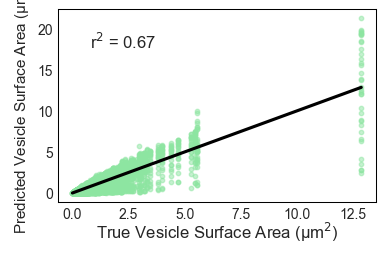

In [460]:
#plot true vs. predicted values as scatterplot and get correlation 
#for volume (um^3)

plt.figure() #this creates a new figure on which your plot will appear

#make the tick labels closer to the axes/spine
    #see: https://github.com/matplotlib/matplotlib/issues/17208
mpl.rcParams['xtick.top'] = False
mpl.rcParams['xtick.labeltop'] = False 
mpl.rcParams['xtick.major.pad'] = -2.25
mpl.rcParams['xtick.minor.pad'] = -2.25
mpl.rcParams['ytick.major.pad'] = -2.25
mpl.rcParams['ytick.minor.pad'] = -2.25

#change height and width of dataset
#ax = plt.figure(figsize=(4.373,3.1))


#ax = sns.set(rc={"figure.figsize":(15, 7.5)}) #width=20, height=10
ax = sns.set_style("whitegrid")


#ax = sns.regplot(data=organized_all_vesicles_diameter_projected, x="true_total_SA_um2", y="projected_total_surface_area_um2",line_kws={"color": "black"},scatter_kws={'alpha':0.05},color=sns.color_palette("pastel")[2],ci=None)
ax = sns.regplot(data=organized_all_vesicles_diameter_projected, x="true_total_SA_um2", y="projected_total_surface_area_um2",line_kws={"color": "black"},scatter_kws={'alpha':0.50,'s':10},color=sns.color_palette("pastel")[2],ci=None)
plt.grid(False
        )

organized_all_vesicles_diameter_projected  = organized_all_vesicles_diameter_projected.fillna(0)

#pearson r and spearman r
#r, p = scipy.stats.pearsonr(x=organized_all_vesicles_diameter_projected['true_total_SA_um2'], y=organized_all_vesicles_diameter_projected['projected_total_surface_area_um2'])
r, p = scipy.stats.spearmanr(a=organized_all_vesicles_diameter_projected['true_total_SA_um2'], b=organized_all_vesicles_diameter_projected['projected_total_surface_area_um2'])

#text_n_r_p = "n = " + str(int(num_np)) + "\n" + "r  = "+str(round(r, 10)) + "\n" + "p = "+str(p)
#text_n_r2_p = "n = " + str(int(num_np)) + "\n"  + "r$^2$ = "+str(round(r**2, 10)) + "\n" + "p = "+str(p)
text_n_r2_p = "n = " + "\n"  + "r$^2$ = "+str(round(r**2, 10)) + "\n" + "p = "+str(p)
#text_r2 = "r$^2$ = "+str(round(r**2, 10))
text_r2 = "r$^2$ = "+str(round(r**2, 2))

ax.text(0.1, 0.8, text_r2,transform=ax.transAxes, fontname="Arial", size=12)
#ax.set(xlabel='True Vesicle Surface Area (µm$^2$)', ylabel='Predicted Vesicle Surface Area (µm$^2$)')

plt.xlabel('True Vesicle Surface Area (µm$^2$)',fontsize=12, fontname="Arial",)
plt.ylabel('Predicted Vesicle Surface Area (µm$^2$)',fontsize=11, fontname="Arial",)
#plt.ticklabel_format()
plt.xticks(fontsize=10, fontname="Arial",)
plt.yticks(fontsize=10, fontname="Arial",)

#put x-label closer to x-axes ticks. set xlabels first. 
    #see: https://github.com/matplotlib/matplotlib/issues/17208
ax.xaxis.labelpad = -0.75

#see for iterating over all spines: https://community.dataquest.io/t/iterate-over-ax-spines-items-and-related-functions/233432/
for key,spine in ax.spines.items():
    spine.set_color('#000000')
    spine.set_linewidth(0.75)

#render figure text as font rather than path
plt.rcParams['svg.fonttype'] = 'none'

#export figure as svg for illustrator figure
#plt.savefig("predicted-vs-true_SA.svg", format="svg", bbox_inches='tight')
#plt.savefig("predicted-vs-true_SA_vesicle_um.svg", format="svg", bbox_inches='tight')
#plt.savefig("predicted-vs-true_SA_vesicle_um_v2-darker.svg", format="svg", bbox_inches='tight')


<Figure size 700x700 with 0 Axes>

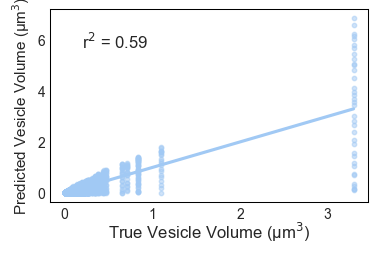

In [459]:
#plot true vs. predicted values as scatterplot and get correlation 
#for surface area (um^2)

plt.figure() #this creates a new figure on which your plot will appear

#make the tick labels closer to the axes/spine
    #see: https://github.com/matplotlib/matplotlib/issues/17208
mpl.rcParams['xtick.top'] = False
mpl.rcParams['xtick.labeltop'] = False 
mpl.rcParams['xtick.major.pad'] = -2.25
mpl.rcParams['xtick.minor.pad'] = -2.25
mpl.rcParams['ytick.major.pad'] = -2.25
mpl.rcParams['ytick.minor.pad'] = -2.25

#change height and width of dataset
#ax = plt.figure(figsize=(4.373,3.1))

#ax = sns.set(rc={"figure.figsize":(15, 7.5)}) #width=20, height=10
ax = sns.set_style("whitegrid")


#ax = sns.regplot(data=organized_all_vesicles_diameter_projected, x="true_total_vol_um3", y="projected_total_volume_um3",line_kws={"color": "black"},scatter_kws={'alpha':0.05},color=sns.color_palette("pastel")[0],ci=None)
ax = sns.regplot(data=organized_all_vesicles_diameter_projected, x="true_total_vol_um3", y="projected_total_volume_um3",scatter_kws={'alpha':0.50,'s':10},color=sns.color_palette("pastel")[0],ci=None)
plt.grid(False)


organized_all_vesicles_diameter_projected  = organized_all_vesicles_diameter_projected.fillna(0)

#pearson r and spearman r
#r, p = scipy.stats.pearsonr(x=organized_all_vesicles_diameter_projected['true_total_vol_um3'], y=organized_all_vesicles_diameter_projected['projected_total_volume_um3'])
r, p = scipy.stats.spearmanr(a=organized_all_vesicles_diameter_projected['true_total_vol_um3'], b=organized_all_vesicles_diameter_projected['projected_total_volume_um3'])


#text_n_r_p = "n = " + str(int(num_np)) + "\n" + "r  = "+str(round(r, 10)) + "\n" + "p = "+str(p)
#text_n_r2_p = "n = " + str(int(num_np)) + "\n"  + "r$^2$ = "+str(round(r**2, 10)) + "\n" + "p = "+str(p)
text_n_r2_p = "n = " + "\n"  + "r$^2$ = "+str(round(r**2, 10)) + "\n" + "p = "+str(p)
#text_r2 = "r$^2$ = "+str(round(r**2, 10))
text_r2 = "r$^2$ = "+str(round(r**2, 2))

ax.text(0.1, 0.8, text_r2,transform=ax.transAxes, fontname="Arial", size=12)

#ax.set(xlabel='True Vesicle Volume (µm$^3$)', ylabel='Predicted Vesicle Volume (µm$^3$)')
plt.xlabel('True Vesicle Volume (µm$^3$)',fontsize=12, fontname="Arial",)
plt.ylabel('Predicted Vesicle Volume (µm$^3$)',fontsize=11, fontname="Arial",)
#plt.ticklabel_format()
plt.xticks(fontsize=10, fontname="Arial",)
plt.yticks(fontsize=10, fontname="Arial",)

#put x-label closer to x-axes ticks. set xlabels first. 
    #see: https://github.com/matplotlib/matplotlib/issues/17208
ax.xaxis.labelpad = -0.75

#ax.legend()

#see for iterating over all spines: https://community.dataquest.io/t/iterate-over-ax-spines-items-and-related-functions/233432/
for key,spine in ax.spines.items():
    spine.set_color('#000000')
    spine.set_linewidth(0.75)

#render figure text as font rather than path
plt.rcParams['svg.fonttype'] = 'none'

#export figure as svg for illustrator figure
#plt.savefig("predicted-vs-true_vol.svg", format="svg", bbox_inches='tight')
#plt.savefig("predicted-vs-true_vol_um.svg", format="svg", bbox_inches='tight')
#plt.savefig("predicted-vs-true_vol_vesicle_um_v2-darker.svg", format="svg", bbox_inches='tight')

In [175]:
print(organized_all_vesicles_diameter_projected["true_total_vol_nm3"].min())
print(organized_all_vesicles_diameter_projected["true_total_vol_nm3"].max())
print(organized_all_vesicles_diameter_projected["true_total_vol_nm3"].mean())
print(organized_all_vesicles_diameter_projected["true_total_vol_nm3"].median())

20230.0
3294313890.0
57506712.81036757
19764710.0


In [176]:
#pd.DataFrame(organized_all_vesicles_diameter_projected["true_total_vol_nm3"])
#get index of max value as it may be an outlier
#what is the max value
print(organized_all_vesicles_diameter_projected["true_total_vol_nm3"].max())
print(organized_all_vesicles_diameter_projected["true_total_vol_nm3"].tolist().index(3294313890.0))


3294313890.0
7283


In [177]:
organized_all_vesicles_diameter_projected.loc[organized_all_vesicles_diameter_projected['index_manual'] == 7283,:]

label  index_manual   area  z-slice  volume_um3  surface_area  \
0   1038          7283  507.0      121    0.010257         124.0   

   surface_area_um2  axis_major_length  axis_minor_length  feret_diameter_max  \
0           0.14756          29.076516          24.749254           30.083218   

   ...  volume_nps_only_volume_um3  num_slices_per_label  \
0  ...                         0.0                    30   

   projected_total_surface_area_nm2  projected_total_surface_area_um2  \
0                         4426800.0                            4.4268   

   projected_total_volume_nm3  projected_total_volume_um3  true_total_SA_nm2  \
0                 307698300.0                    0.307698          5558490.0   

   true_total_SA_um2  true_total_vol_nm3  true_total_vol_um3  
0            5.55849         448519330.0            0.448519  

[1 rows x 26 columns]

In [178]:
#get the rows where the true_total_vol_nm3 is equal to the max value as it may be an outlier based on the above graphs
organized_all_vesicles_diameter_projected.loc[organized_all_vesicles_diameter_projected['true_total_vol_nm3'] == organized_all_vesicles_diameter_projected["true_total_vol_nm3"].max(),:]

label  index_manual    area  z-slice  volume_um3  surface_area  \
47   1194          7128   212.0      117    0.004289          64.0   
41   1194          7172   972.0      118    0.019664         149.0   
36   1194          7219  1622.0      119    0.032813         193.0   
21   1194          7257  2163.0      120    0.043757         206.0   
16   1194          7299  2627.0      121    0.053144         228.0   
9    1194          7342  3262.0      122    0.065990         280.0   
7    1194          7391  3661.0      123    0.074062         282.0   
6    1194          7452  4907.0      124    0.099269         380.0   
5    1194          7519  5446.0      125    0.110173         370.0   
4    1194          7588  6940.0      126    0.140396         497.0   
4    1194          7659  6593.0      127    0.133376         394.0   
3    1194          7730  7967.0      128    0.161172         410.0   
3    1194          7794  8460.0      129    0.171146         432.0   
0    1194          7851  9042.0      130    0.182920         453.0   
0    1194          7907  8574.0      131    0.173452         430.0   
0    1194          7962  9410.0      132    0.190364         464.0   
0    1194          8015  8306.0      133    0.168030         456.0   
0    1194          8061  7771.0      134    0.157207         452.0   
0    1194          8104  7455.0      135    0.150815         448.0   
0    1194          8153  7183.0      136    0.145312         460.0   
0    1194          8200  6863.0      137    0.138838         452.0   
0    1194          8244  6161.0      138    0.124637         364.0   
0    1194          8285  5631.0      139    0.113915         342.0   
0    1194          8328  5260.0      140    0.106410         322.0   
0    1194          8370  5059.0      141    0.102344         324.0   
0    1194          8405  4731.0      142    0.095708         302.0   
0    1194          8442  4116.0      143    0.083267         292.0   
0    1194          8476  3853.0      144    0.077946         286.0   
0    1194          8511  2871.0      145    0.058080         240.0   
0    1194          8550  1980.0      146    0.040055         205.0   
0    1194          8596  1452.0      147    0.029374         174.0   
0    1194          8644  1032.0      148    0.020877         152.0   
0    1194          8699   481.0      149    0.009731          96.0   
0    1194          8751   375.0      150    0.007586          82.0   
0    1194          8803   230.0      151    0.004653          64.0   
0    1194          8860   175.0      152    0.003540          56.0   

    surface_area_um2  axis_major_length  axis_minor_length  \
47           0.07616          20.677385          13.136562   
41           0.17731          39.339741          32.859783   
36           0.22967          50.999823          40.955811   
21           0.24514          57.628531          48.008924   
16           0.27132          61.115154          55.705407   
9            0.33320          65.745632          64.150908   
7            0.33558          75.673977          62.562884   
6            0.45220          84.769348          77.025022   
5            0.44030          89.106793          79.885719   
4            0.59143         111.419572          86.108504   
4            0.46886         115.752228          74.854122   
3            0.48790         119.655902          85.846278   
3            0.51408         120.063666          90.298095   
0            0.53907         122.596781          94.970633   
0            0.51170         112.888752          98.117550   
0            0.55216         129.873867          95.247802   
0            0.54264         114.820351          95.034145   
0            0.53788         120.687729          85.068505   
0            0.53312         116.885779          83.947323   
0            0.54740         120.561751          79.091500   
0            0.53788         122.138216          74.157350   
0            0.43316         102.169882          

In [179]:
#make a copy of the dataframe
organized_all_vesicles_diameter_projected_cleaned = organized_all_vesicles_diameter_projected.copy()

In [180]:
#delete the rows whith the max value
#set to NaN
organized_all_vesicles_diameter_projected_cleaned.loc[organized_all_vesicles_diameter_projected_cleaned['true_total_vol_nm3'] == organized_all_vesicles_diameter_projected["true_total_vol_nm3"].max(),:] = np.nan

<Figure size 437.3x352.5 with 0 Axes>

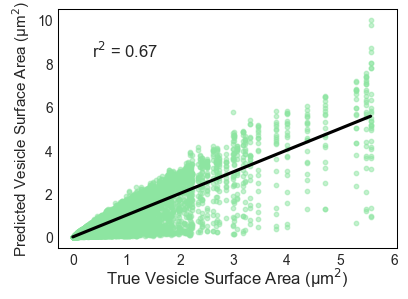

In [468]:
#now re visualize the data without the anomaly (remove vesicle label 1194)

#plot true vs. predicted values as scatterplot and get correlation 
#for volume (um^3)

plt.figure() #this creates a new figure on which your plot will appear

#make the tick labels closer to the axes/spine
    #see: https://github.com/matplotlib/matplotlib/issues/17208
mpl.rcParams['xtick.top'] = False
mpl.rcParams['xtick.labeltop'] = False 
mpl.rcParams['xtick.major.pad'] = -2.25
mpl.rcParams['xtick.minor.pad'] = -2.25
mpl.rcParams['ytick.major.pad'] = -2.25
mpl.rcParams['ytick.minor.pad'] = -2.25

#change height and width of dataset
ax = plt.figure(figsize=(4.373,3.1))

#ax = sns.set(rc={"figure.figsize":(15, 7.5)}) #width=20, height=10
ax = sns.set_style("whitegrid")


#ax = sns.regplot(data=organized_all_vesicles_diameter_projected_cleaned, x="true_total_SA_um2", y="projected_total_surface_area_um2",line_kws={"color": "black"},scatter_kws={'alpha':0.05},color=sns.color_palette("pastel")[2],ci=None)
ax = sns.regplot(data=organized_all_vesicles_diameter_projected_cleaned, x="true_total_SA_um2", y="projected_total_surface_area_um2",line_kws={"color": "black"},scatter_kws={'alpha':0.50,'s':10},color=sns.color_palette("pastel")[2],ci=None)
plt.grid(False)

organized_all_vesicles_diameter_projected_cleaned  = organized_all_vesicles_diameter_projected_cleaned.fillna(0)

#pearson r and spearman r
#r, p = scipy.stats.pearsonr(x=organized_all_vesicles_diameter_projected_cleaned['true_total_SA_um2'], y=organized_all_vesicles_diameter_projected_cleaned['projected_total_surface_area_um2'])
r, p = scipy.stats.spearmanr(a=organized_all_vesicles_diameter_projected_cleaned['true_total_SA_um2'], b=organized_all_vesicles_diameter_projected_cleaned['projected_total_surface_area_um2'])


#text_n_r_p = "n = " + str(int(num_np)) + "\n" + "r  = "+str(round(r, 10)) + "\n" + "p = "+str(p)
#text_n_r2_p = "n = " + str(int(num_np)) + "\n"  + "r$^2$ = "+str(round(r**2, 10)) + "\n" + "p = "+str(p)
text_n_r2_p = "n = " + "\n"  + "r$^2$ = "+str(round(r**2, 10)) + "\n" + "p = "+str(p)
#text_r2 = "r$^2$ = "+str(round(r**2, 10))
text_r2 = "r$^2$ = "+str(round(r**2, 2))

ax.text(0.1, 0.8, text_r2,transform=ax.transAxes, fontname="Arial", size=12)
#ax.set(xlabel='True Vesicle Surface Area (µm$^2$)', ylabel='Predicted Vesicle Surface Area (µm$^2$)')

plt.xlabel('True Vesicle Surface Area (µm$^2$)',fontsize=12, fontname="Arial",)
plt.ylabel('Predicted Vesicle Surface Area (µm$^2$)',fontsize=11, fontname="Arial",)
#plt.ticklabel_format()
plt.xticks(fontsize=10, fontname="Arial",)
plt.yticks(fontsize=10, fontname="Arial",)

#ax.set_xticks([1e2, 1e3, 1e4])
ax.set_yticks(np.arange(0, 11, 2))
ax.set_xticks(np.arange(0, 7, 1))

#put x-label closer to x-axes ticks. set xlabels first. 
    #see: https://github.com/matplotlib/matplotlib/issues/17208
ax.xaxis.labelpad = -0.75

#set x and y limits to not span whole width so there is space for scale
#get default  xlim and ylim values to keep consistent between figures
current_xlim_min, current_xlim_max = ax.get_xlim()
current_ylim_min, current_ylim_max = ax.get_ylim()
#print(current_xlim_min, current_xlim_max)
plt.xlim(current_xlim_min, 6.05) 
#plt.ylim(current_ylim_min, 17e3)



#see for iterating over all spines: https://community.dataquest.io/t/iterate-over-ax-spines-items-and-related-functions/233432/
for key,spine in ax.spines.items():
    spine.set_color('#000000')
    spine.set_linewidth(0.75)

#render figure text as font rather than path
plt.rcParams['svg.fonttype'] = 'none'

#export figure as svg for illustrator figure
#plt.savefig("vesicle_predicted-vs-true_SA.svg", format="svg", bbox_inches='tight')
#plt.savefig("vesicle_predicted-vs-true_SA_good_um.svg", format="svg", bbox_inches='tight')
#plt.savefig("vesicle_predicted-vs-true_SA_vesicle_good_um_v2-darker.svg", format="svg", bbox_inches='tight')
plt.savefig("vesicle_predicted-vs-true_SA_vesicle_good_um_v3-darker.svg", format="svg", bbox_inches='tight')


<Figure size 437.3x352.5 with 0 Axes>

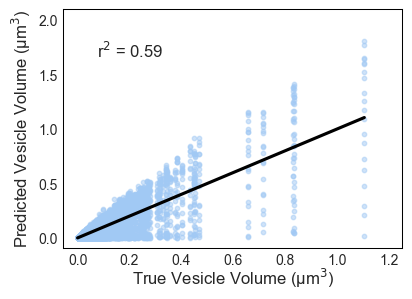

In [470]:
#plot true vs. predicted values as scatterplot and get correlation 
#for surface area (um^2)

plt.figure() #this creates a new figure on which your plot will appear

#make the tick labels closer to the axes/spine
    #see: https://github.com/matplotlib/matplotlib/issues/17208
mpl.rcParams['xtick.top'] = False
mpl.rcParams['xtick.labeltop'] = False 
mpl.rcParams['xtick.major.pad'] = -2.25
mpl.rcParams['xtick.minor.pad'] = -2.25
mpl.rcParams['ytick.major.pad'] = -2.25
mpl.rcParams['ytick.minor.pad'] = -2.25

#change height and width of dataset
ax = plt.figure(figsize=(4.373,3.1))

#ax = sns.set(rc={"figure.figsize":(15, 7.5)}) #width=20, height=10
ax = sns.set_style("whitegrid")


#ax = sns.regplot(data=organized_all_vesicles_diameter_projected, x="true_total_vol_um3", y="projected_total_volume_um3",line_kws={"color": "black"},scatter_kws={'alpha':0.05},color=sns.color_palette("pastel")[0],ci=None)
ax = sns.regplot(data=organized_all_vesicles_diameter_projected_cleaned, x="true_total_vol_um3", y="projected_total_volume_um3",line_kws={"color": "black"},scatter_kws={'alpha':0.50,'s':10},color=sns.color_palette("pastel")[0],ci=None)
plt.grid(False)


organized_all_vesicles_diameter_projected_cleaned  = organized_all_vesicles_diameter_projected_cleaned.fillna(0)

#pearson r and spearman r
#r, p = scipy.stats.pearsonr(x=organized_all_vesicles_diameter_projected_cleaned['true_total_vol_um3'], y=organized_all_vesicles_diameter_projected_cleaned['projected_total_volume_um3'])
r, p = scipy.stats.spearmanr(a=organized_all_vesicles_diameter_projected_cleaned['true_total_vol_um3'], b=organized_all_vesicles_diameter_projected_cleaned['projected_total_volume_um3'])


#text_n_r_p = "n = " + str(int(num_np)) + "\n" + "r  = "+str(round(r, 10)) + "\n" + "p = "+str(p)
#text_n_r2_p = "n = " + str(int(num_np)) + "\n"  + "r$^2$ = "+str(round(r**2, 10)) + "\n" + "p = "+str(p)
text_n_r2_p = "n = " + "\n"  + "r$^2$ = "+str(round(r**2, 10)) + "\n" + "p = "+str(p)
#text_r2 = "r$^2$ = "+str(round(r**2, 10))
text_r2 = "r$^2$ = "+str(round(r**2, 2))

ax.text(0.1, 0.8, text_r2,transform=ax.transAxes, fontname="Arial", size=12)

#ax.set(xlabel='True Vesicle Volume (µm$^3$)', ylabel='Predicted Vesicle Volume (µm$^3$)')
plt.xlabel('True Vesicle Volume (µm$^3$)',fontsize=12, fontname="Arial",)
plt.ylabel('Predicted Vesicle Volume (µm$^3$)',fontsize=12, fontname="Arial",)
#plt.ticklabel_format()
plt.xticks(fontsize=10, fontname="Arial",)
plt.yticks(fontsize=10, fontname="Arial",)


#ax.set_xticks([1e2, 1e3, 1e4])
ax.set_yticks(np.arange(0, 2.5, 0.5))
ax.set_xticks(np.arange(0, 1.4, 0.2))

#put x-label closer to x-axes ticks. set xlabels first. 
    #see: https://github.com/matplotlib/matplotlib/issues/17208
ax.xaxis.labelpad = -0.75

#set x and y limits to not span whole width so there is space for scale
#get default  xlim and ylim values to keep consistent between figures
current_xlim_min, current_xlim_max = ax.get_xlim()
current_ylim_min, current_ylim_max = ax.get_ylim()
#print(current_xlim_min, current_xlim_max)
plt.xlim(current_xlim_min, 1.25) 
plt.ylim(current_ylim_min, 2.1)

#see for iterating over all spines: https://community.dataquest.io/t/iterate-over-ax-spines-items-and-related-functions/233432/
for key,spine in ax.spines.items():
    spine.set_color('#000000')
    spine.set_linewidth(0.75)

#render figure text as font rather than path
plt.rcParams['svg.fonttype'] = 'none'

#export figure as svg for illustrator figure
#plt.savefig("vesicle_predicted-vs-true_vol.svg", format="svg", bbox_inches='tight')
#plt.savefig("vesicle_predicted-vs-true_vol_v3_um.svg", format="svg", bbox_inches='tight')
plt.savefig("vesicle_predicted-vs-true_vol_vesicle_um_v3-darker.svg", format="svg", bbox_inches='tight')

In [183]:
#the r^2 values are essentially unchanged but the plots look easier to interpret since there is no large vesicle outlier

In [184]:
'''

#RSD analysis for vesicles
#organized_ECs_diameter_projected['projected_total_surface_area_nm2']
#index_keep_ECs_good = [7, 8, 10, 13, 14, 15, 16, 17, 18, 20, 21, 22, 24, 25, 27, 28, 29, 30, 32]
#index_keep_ECs_good2 = [7, 8, 10, 13, 14, 15, 16, 17, 18, 20, 21, 22, 24, 25, 27, 28]

#add indexing greater than 1 since there is no label = 0 that is useful
list_of_vesicle_IDs = np.unique(organized_all_vesicles_diameter_projected_cleaned['label']).tolist()[1:]

#get the mean, SD and RSD for each label in the dataset

vesicle_list_of_projected_total_SA_um2_means = []
vesicle_list_of_projected_total_vol_um3_means = []

vesicle_list_of_projected_total_SA_um2_SD = []
vesicle_list_of_projected_total_vol_um3_SD = []

vesicle_list_of_projected_total_SA_um2_RSD = []
vesicle_list_of_projected_total_vol_um3_RSD = []




#for i in index_keep_ECs_good:
for i in list_of_vesicle_IDs:
    #print(i)
    #add ".values[0]" to end 
    current_label_dataset_projected_SA = organized_all_vesicles_diameter_projected_cleaned.loc[organized_all_vesicles_diameter_projected_cleaned['label'] ==i, 'projected_total_surface_area_um2']
    current_label_dataset_projected_vol = organized_all_vesicles_diameter_projected_cleaned.loc[organized_all_vesicles_diameter_projected_cleaned['label'] ==i, 'projected_total_volume_um3']

    vesicle_list_of_projected_total_SA_um2_means.append(current_label_dataset_projected_SA.mean())
    vesicle_list_of_projected_total_vol_um3_means.append(current_label_dataset_projected_vol.mean())
    
    vesicle_list_of_projected_total_SA_um2_SD.append(current_label_dataset_projected_SA.std())
    vesicle_list_of_projected_total_vol_um3_SD.append(current_label_dataset_projected_vol.std())

    vesicle_list_of_projected_total_SA_um2_RSD.append(current_label_dataset_projected_SA.std()/current_label_dataset_projected_SA.mean()*100)
    vesicle_list_of_projected_total_vol_um3_RSD.append(current_label_dataset_projected_vol.std()/current_label_dataset_projected_vol.mean()*100)


#####


#use .T to transpose dataframe
all_means_SD_RSD = pd.DataFrame(data=[vesicle_list_of_projected_total_SA_um2_means, vesicle_list_of_projected_total_vol_um3_means, vesicle_list_of_projected_total_SA_um2_SD, vesicle_list_of_projected_total_vol_um3_SD, vesicle_list_of_projected_total_SA_um2_RSD, vesicle_list_of_projected_total_vol_um3_RSD], ).T
all_means_SD_RSD.columns = ['projected_total_SA_um2_means','projected_total_vol_um3_means','projected_total_SA_um2_SD','projected_total_vol_um3_SD','projected_total_SA_um2_RSD', 'projected_total_vol_um3_RSD']
all_means_SD_RSD

#####

print("Min RSD of all projected vesicle SA: ", all_means_SD_RSD['projected_total_SA_um2_RSD'].min(), "%. Max RSD of all projected vesicle SA: ", all_means_SD_RSD['projected_total_SA_um2_RSD'].max(), "%. Mean RSD of all projected vesicle SA: ", all_means_SD_RSD['projected_total_SA_um2_RSD'].mean(), "%.")
print()
print("Min RSD of all projected vesicle vol: ", all_means_SD_RSD['projected_total_vol_um3_RSD'].min(), "%. Max RSD of all projected vesicle vol: ", all_means_SD_RSD['projected_total_vol_um3_RSD'].max(), "%. Mean RSD of all projected vesicle vol: ", all_means_SD_RSD['projected_total_vol_um3_RSD'].mean(), "%.")

'''

'\n\n#RSD analysis for vesicles\n#organized_ECs_diameter_projected[\'projected_total_surface_area_nm2\']\n#index_keep_ECs_good = [7, 8, 10, 13, 14, 15, 16, 17, 18, 20, 21, 22, 24, 25, 27, 28, 29, 30, 32]\n#index_keep_ECs_good2 = [7, 8, 10, 13, 14, 15, 16, 17, 18, 20, 21, 22, 24, 25, 27, 28]\n\n#add indexing greater than 1 since there is no label = 0 that is useful\nlist_of_vesicle_IDs = np.unique(organized_all_vesicles_diameter_projected_cleaned[\'label\']).tolist()[1:]\n\n#get the mean, SD and RSD for each label in the dataset\n\nvesicle_list_of_projected_total_SA_um2_means = []\nvesicle_list_of_projected_total_vol_um3_means = []\n\nvesicle_list_of_projected_total_SA_um2_SD = []\nvesicle_list_of_projected_total_vol_um3_SD = []\n\nvesicle_list_of_projected_total_SA_um2_RSD = []\nvesicle_list_of_projected_total_vol_um3_RSD = []\n\n\n\n\n#for i in index_keep_ECs_good:\nfor i in list_of_vesicle_IDs:\n    #print(i)\n    #add ".values[0]" to end \n    current_label_dataset_projected_SA = or

In [185]:
#RSD for 2D SA EM Vesicles
mean_all_2D_vesicles_SA = organized_all_vesicles_diameter_projected_cleaned['projected_total_surface_area_um2'].mean()
std_all_2D_vesicles_SA = organized_all_vesicles_diameter_projected_cleaned['projected_total_surface_area_um2'].std()
rsd_all_2D_vesicles_SA = std_all_2D_vesicles_SA/mean_all_2D_vesicles_SA
print("The RSD for 2D SA vesicle (predicted) is: ", rsd_all_2D_vesicles_SA*100,"%")

#RSD for 2D Volume EM Vesicles
mean_all_2D_vesicles_vol = organized_all_vesicles_diameter_projected_cleaned['projected_total_volume_um3'].mean()
std_all_2D_vesicles_vol = organized_all_vesicles_diameter_projected_cleaned['projected_total_volume_um3'].std()
rsd_all_2D_vesicles_vol = std_all_2D_vesicles_vol/mean_all_2D_vesicles_vol
print("The RSD for 2D vesicle volume (predicted) is: ", rsd_all_2D_vesicles_vol*100,"%")

#RSD for 3D SA EM Vesicles
mean_all_3D_vesicles_SA = organized_all_vesicles_diameter_projected_cleaned['true_total_SA_um2'].mean()
std_all_3D_vesicles_SA = organized_all_vesicles_diameter_projected_cleaned['true_total_SA_um2'].std()
rsd_all_3D_vesicles_SA = std_all_3D_vesicles_SA/mean_all_3D_vesicles_SA
print("The RSD for 3D vesicle SA (true) is: ", rsd_all_3D_vesicles_SA*100,"%")

#RSD for 3D Volume EM Vesicles
mean_all_3D_vesicles_vol = organized_all_vesicles_diameter_projected_cleaned['true_total_vol_um3'].mean()
std_all_3D_vesicles_vol = organized_all_vesicles_diameter_projected_cleaned['true_total_vol_um3'].std()
rsd_all_3D_vesicles_vol = std_all_3D_vesicles_vol/mean_all_3D_vesicles_vol
print("The RSD for 3D vesicle volume (true) is: ", rsd_all_3D_vesicles_vol*100,"%")


The RSD for 2D SA vesicle (predicted) is:  133.12915611954824 %
The RSD for 2D vesicle volume (predicted) is:  217.2032381350935 %
The RSD for 3D vesicle SA (true) is:  115.10397784873668 %
The RSD for 3D vesicle volume (true) is:  180.68183002316906 %


In [186]:
#Visualize SUM of vesicle volumes and SA
# use groupby to get sum

#only need want the SUM for volume_um3 and surface_area_um2. Do not want sum for any label for any other place

sum_all_dataframes_concat_vesicle_vol_SA_updated_diameters =all_dataframes_concat_vesicle_vol_SA_updated_diameters.groupby('label').sum().copy()
 

sum_all_dataframes_concat_vesicle_vol_SA_updated_diameters['vesicle_volume_nm3_summed_recalc'] = sum_all_dataframes_concat_vesicle_vol_SA_updated_diameters['area']*(17*17*70)
sum_all_dataframes_concat_vesicle_vol_SA_updated_diameters['vesicle_surface_area_nm2_summed_recalc'] = sum_all_dataframes_concat_vesicle_vol_SA_updated_diameters['surface_area']*(17*70)
sum_all_dataframes_concat_vesicle_vol_SA_updated_diameters['vesicle_without_NPs_volume_nm3_summed_recalc'] = sum_all_dataframes_concat_vesicle_vol_SA_updated_diameters['volume_subtract_nps_area']*(17*17*70)
sum_all_dataframes_concat_vesicle_vol_SA_updated_diameters['only_NPs_in_vesicles_volume_nm3_summed_recalc'] = sum_all_dataframes_concat_vesicle_vol_SA_updated_diameters['volume_nps_only_area']*(17*17*70)


In [187]:
sum_all_dataframes_concat_vesicle_vol_SA_updated_diameters

index_manual    area  z-slice  volume_um3  surface_area  \
label                                                            
1              1770  1576.0       28    0.031882         433.0   
2               189   392.0        3    0.007930         141.0   
3               643   416.0       10    0.008416         179.0   
4              2275  2439.0       36    0.049341         577.0   
5                67   108.0        1    0.002185          43.0   
...             ...     ...      ...         ...           ...   
3077          52196   216.0     1020    0.004370          95.0   
3078          34836    60.0      681    0.001214          42.0   
3079          34838    61.0      681    0.001234          41.0   
3080          34840    58.0      681    0.001173          40.0   
3081          17438    19.0      341    0.000384          16.0   

       surface_area_um2  axis_major_length  axis_minor_length  \
label                                                           
1               0.50694         131.101990         106.103356   
2               0.16779          45.130191          33.053561   
3               0.20706          67.602826          33.408799   
4               0.68187         186.952753         124.284192   
5               0.04760          14.280661          12.486180   
...                 ...                ...                ...   
3077            0.11305          29.583567          23.986930   
3078            0.04998          14.003046          10.595106   
3079            0.04879          15.655869           9.081792   
3080            0.04760          14.862518           9.285758   
3081            0.01904           5.823607           4.256623   

       feret_diameter_max  equivalent_diameter_area  feret_diameter_max_nm  \
label                                                                        
1              137.503206                117.538099            2337.554503   
2               46.657664                 38.176086             793.180289   
3               68.089955                 47.570271            1157.529228   
4              190.607230                151.896052            3240.322902   
5               14.766032                 13.516856             251.022545   
...                   ...                       ...                    ...   
3077            31.680737                 26.626527             538.572536   
3078            14.819146                 12.100040             251.925481   
3079            15.931620                 12.023234             270.837546   
3080            15.317785                 11.826249             260.402343   
3081             5.830952                  4.918491              99.126182   

       feret_diameter_max_um  volume_subtract_nps_area  \
label                                                    
1                   2.337555                    1576.0   
2                   0.793180                     392.0   
3                   1.157529                     410.0   
4                   3.240323                    2439.0   
5                   0.251023                      94.0   
...                      ...                       ...   
3077                0.538573                     216.0   
3078                0.251925                      60.0   
3079                0.270838                      61.0   
3080                0.260402                      58.0   
3081                0.099126                      19.0   

       volume_subtract_nps_um3  volume_nps_only_area  \
label                                                  
1                     0.031882                   0.0   
2                     0.007930                   0.0   
3                     0.008294                   6.0   
4                     0.049341                   0.0   
5                     0.001902                  14.0   
...                        ...                   ...   
3077                  0.004370                   0.0   
3078                  0.0012

In [188]:
# how much volume of the vesicle is not occupied by nanoparticles? how much is? for each vesicle.
sum_all_dataframes_concat_vesicle_vol_SA_updated_diameters['percentage_vesicle_occupied_by_NP'] = sum_all_dataframes_concat_vesicle_vol_SA_updated_diameters['only_NPs_in_vesicles_volume_nm3_summed_recalc']/sum_all_dataframes_concat_vesicle_vol_SA_updated_diameters['vesicle_volume_nm3_summed_recalc']*100
#note: multiply by 100 to convert to percentage

In [189]:
sum_all_dataframes_concat_vesicle_vol_SA_updated_diameters

index_manual    area  z-slice  volume_um3  surface_area  \
label                                                            
1              1770  1576.0       28    0.031882         433.0   
2               189   392.0        3    0.007930         141.0   
3               643   416.0       10    0.008416         179.0   
4              2275  2439.0       36    0.049341         577.0   
5                67   108.0        1    0.002185          43.0   
...             ...     ...      ...         ...           ...   
3077          52196   216.0     1020    0.004370          95.0   
3078          34836    60.0      681    0.001214          42.0   
3079          34838    61.0      681    0.001234          41.0   
3080          34840    58.0      681    0.001173          40.0   
3081          17438    19.0      341    0.000384          16.0   

       surface_area_um2  axis_major_length  axis_minor_length  \
label                                                           
1               0.50694         131.101990         106.103356   
2               0.16779          45.130191          33.053561   
3               0.20706          67.602826          33.408799   
4               0.68187         186.952753         124.284192   
5               0.04760          14.280661          12.486180   
...                 ...                ...                ...   
3077            0.11305          29.583567          23.986930   
3078            0.04998          14.003046          10.595106   
3079            0.04879          15.655869           9.081792   
3080            0.04760          14.862518           9.285758   
3081            0.01904           5.823607           4.256623   

       feret_diameter_max  equivalent_diameter_area  ...  \
label                                                ...   
1              137.503206                117.538099  ...   
2               46.657664                 38.176086  ...   
3               68.089955                 47.570271  ...   
4              190.607230                151.896052  ...   
5               14.766032                 13.516856  ...   
...                   ...                       ...  ...   
3077            31.680737                 26.626527  ...   
3078            14.819146                 12.100040  ...   
3079            15.931620                 12.023234  ...   
3080            15.317785                 11.826249  ...   
3081             5.830952                  4.918491  ...   

       feret_diameter_max_um  volume_subtract_nps_area  \
label                                                    
1                   2.337555                    1576.0   
2                   0.793180                     392.0   
3                   1.157529                     410.0   
4                   3.240323                    2439.0   
5                   0.251023                      94.0   
...                      ...                       ...   
3077                0.538573                     216.0   
3078                0.251925                      60.0   
3079                0.270838                      61.0   
3080                0.260402                      58.0   
3081                0.099126                      19.0   

       volume_subtract_nps_um3  volume_nps_only_area  \
label                                                  
1                     0.031882                   0.0   
2                     0.007930                   0.0   
3                     0.008294                   6.0   
4                     0.049341                   0.0   
5                     0.001902                  14.0   
...                        ...                   ...   
3077                  0.004370                   0.0   
3078                  0.001214                   0.0   
3079                  0.001234                   0.0   
3080                  0.001173                   0.0   
3081                  0.000384                   0.0   

       volume_nps_only_volume_um3  ve

In [201]:
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html
# is there a statistically significant difference in volume for vesicles with and without NPs?

#vesicles with NPs
vesicle_volumes_with_NPs = sum_all_dataframes_concat_vesicle_vol_SA_updated_diameters.loc[vesicles_with_NPs,'vesicle_volume_nm3_summed_recalc'].tolist()
vesicle_volumes_without_NPs = sum_all_dataframes_concat_vesicle_vol_SA_updated_diameters.loc[vesicles_without_NPS,'vesicle_volume_nm3_summed_recalc'].tolist()

#there are unequal number of samples for the two groups, so do Welch's t-test with unequal variance
print(len(vesicle_volumes_with_NPs))
print(len(vesicle_volumes_without_NPs))

t_ttest, p_ttest = scipy.stats.ttest_ind(a=vesicle_volumes_with_NPs, b=vesicle_volumes_without_NPs, equal_var=False)
print("t-statistic is: ", t_ttest, ". p-value is: ", p_ttest,)# ". degrees freedom is: ", degrees_freedom_ttest)
#scipy.stats.ttest_ind(a=vesicle_volumes_with_NPs, b=vesicle_volumes_without_NPs, equal_var=False)

#do mann whitney u-test instead because unknown distribution
#see: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html

stat_mwtest, p_mwtest = scipy.stats.mannwhitneyu(x=vesicle_volumes_with_NPs, y=vesicle_volumes_without_NPs, method='auto', )
print("mann-whitney-statistic is: ", stat_mwtest, ". p-value is: ", p_mwtest,)# ". degrees freedom is: ", degrees_freedom_ttest)

623
2174
t-statistic is:  6.08036112137408 . p-value is:  2.050807296629012e-09
mann-whitney-statistic is:  958545.5 . p-value is:  1.8768817278427056e-56


<Figure size 400x800 with 0 Axes>

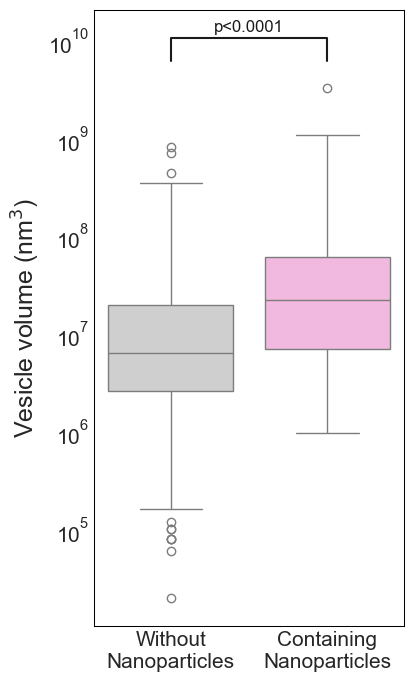

In [320]:
#switch orientation of vesicle volume with and without NPs
#redo figure with statistical annotation
#see: https://stackoverflow.com/questions/36578458/how-does-one-insert-statistical-annotations-stars-or-p-values

#what is the size distribution of vesicles in the dataset?
#show the overall distribution
# part out the distribution with box plot of vesicles with and without NPs


plt.figure() #this creates a new figure on which your plot will appear

#make the tick labels closer to the axes/spine
    #see: https://github.com/matplotlib/matplotlib/issues/17208
mpl.rcParams['xtick.top'] = False
mpl.rcParams['xtick.labeltop'] = False 
mpl.rcParams['xtick.major.pad'] = -2.25
mpl.rcParams['xtick.minor.pad'] = -2.25
mpl.rcParams['ytick.major.pad'] = -2.25
mpl.rcParams['ytick.minor.pad'] = -2.25

#only consider values greater than 0
#sum_all_dataframes_concat_vesicle_vol_SA_updated_diameters.loc[sum_all_dataframes_concat_vesicle_vol_SA_updated_diameters['actual_num_NPs'] >0]

x_plot_data = [vesicle_volumes_with_NPs, vesicle_volumes_without_NPs]

#y_plot_data = sum_all_dataframes_concat_vesicle_vol_SA_updated_diameters.loc[sum_all_dataframes_concat_vesicle_vol_SA_updated_diameters['actual_num_NPs'] >0,'actual_num_NPs']

#need to use log plot to se all data

#ax = sns.histplot(data=x_plot_data, color=sns.color_palette("pastel")[1], bins=20,log_scale=10) #pastel red
#ax = sns.boxplot(data=[vesicle_volumes_with_NPs,vesicle_volumes_without_NPs], color=[sns.color_palette("pastel")[1],sns.color_palette("pastel")[2]],log_scale=10) #pastel red

plt.figure() #this creates a new figure on which your plot will appear

ax = sns.set_style("whitegrid")
sns.set_theme(style='white')


#change height and width of dataset
    #need to set these parameters before creating the plot
ax = sns.set(rc={'figure.figsize':(4,8)}) #width=20, height=10

#ax = plt.figure(figsize=(15,5))
sns.set_theme(style='white')
#sns.despine()


palette_colors = [sns.color_palette("pastel")[7],sns.color_palette("pastel")[6]]
ax = sns.boxplot(data=[vesicle_volumes_without_NPs,vesicle_volumes_with_NPs],log_scale=10,palette=palette_colors) #pastel red


#ax = plt.hist( y_plot_data, color='r', alpha=1.0,bins=100,log_scale=10)
#ax = plt.hist([x_plot_data, y_plot_data], color=['r','b'], alpha=0.5)


#turn off grid
plt.grid(False)

plt.xlabel('',fontsize=18)
plt.ylabel('Vesicle volume (nm$^3$)',fontsize=18)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

#rename x axis labels here
labels_for_x_axis = ['Without\nNanoparticles','Containing\nNanoparticles'] #use \n for linebreak
ax.set_xticks(range(len(labels_for_x_axis)))
ax.set_xticklabels(labels_for_x_axis, rotation='horizontal')


#set y-minimum value so that it does not go below zero
#plt.ylim(0)
#plt.xlim(0.3) #

#turn off frame for figure legend
#plt.legend(title='', loc='upper right', labels=['Vesicles with Nanoparticles','Vesicles without Nanoparticles'],)#frameon=False)




# statistical annotation
x1, x2 = 0, 1   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = np.max(vesicle_volumes_with_NPs) + 3e9, 3e9, 'k'

plt.plot([x1, x1, x2, x2], [y, y+h*1.5, y+h*1.5, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h*1.75, "p<0.0001", ha='center', va='bottom', color=col)


#render figure text as font rather than path
plt.rcParams['svg.fonttype'] = 'none'

#see for iterating over all spines: https://community.dataquest.io/t/iterate-over-ax-spines-items-and-related-functions/233432/
for key,spine in ax.spines.items():
    spine.set_color('#000000')
    spine.set_linewidth(0.75)

#export figure as svg for illustrator figure
plt.savefig("vesicle_with-or-without-NPs+stats-swap.svg", format="svg", bbox_inches='tight')


#display histogram
plt.show()


In [204]:
#sns.color_palette("pastel")[6]
#print(sns.color_palette("pastel6").as_hex())
#sns.color_palette("pastel6")
#sns.color_palette("pastel").as_hex()
#get hexadecimal of pink pastel number 6
print(sns.color_palette("pastel").as_hex()[6])
print(sns.color_palette("pastel")[6])
sns.color_palette("pastel")

#fab0e4
(0.9803921568627451, 0.6901960784313725, 0.8941176470588236)


[(0.6313725490196078, 0.788235294117647, 0.9568627450980393),
 (1.0, 0.7058823529411765, 0.5098039215686274),
 (0.5529411764705883, 0.8980392156862745, 0.6313725490196078),
 (1.0, 0.6235294117647059, 0.6078431372549019),
 (0.8156862745098039, 0.7333333333333333, 1.0),
 (0.8705882352941177, 0.7333333333333333, 0.6078431372549019),
 (0.9803921568627451, 0.6901960784313725, 0.8941176470588236),
 (0.8117647058823529, 0.8117647058823529, 0.8117647058823529),
 (1.0, 0.996078431372549, 0.6392156862745098),
 (0.7254901960784313, 0.9490196078431372, 0.9411764705882353)]

In [205]:
#determine the median values for the volumes of vesicles with and without nanoparticles in nm^3 units
print(np.median(vesicle_volumes_with_NPs))
print(np.median(vesicle_volumes_without_NPs))


22536220.0
6503945.0


In [206]:
#get all vesicles that have some NPs in them 
#vesicle_volumes_with_NPs = sum_all_dataframes_concat_vesicle_vol_SA_updated_diameters.loc[sum_all_dataframes_concat_vesicle_vol_SA_updated_diameters['volume_nps_only_area'] >0,'vesicle_volume_nm3_summed_recalc']
#vesicle_volumes_without_NPs = sum_all_dataframes_concat_vesicle_vol_SA_updated_diameters.loc[sum_all_dataframes_concat_vesicle_vol_SA_updated_diameters['volume_nps_only_area'] ==0,'vesicle_volume_nm3_summed_recalc']
#vesicle_volumes_with_NPs
#vesicle_volumes_without_NPs

#instead, use list of vesicles with and without NPs from above
len(sum_all_dataframes_concat_vesicle_vol_SA_updated_diameters.loc[vesicles_with_NPs,'vesicle_volume_nm3_summed_recalc'])
len(sum_all_dataframes_concat_vesicle_vol_SA_updated_diameters.loc[vesicles_without_NPS,'vesicle_volume_nm3_summed_recalc'])

#vesicles_with_NPs

2174

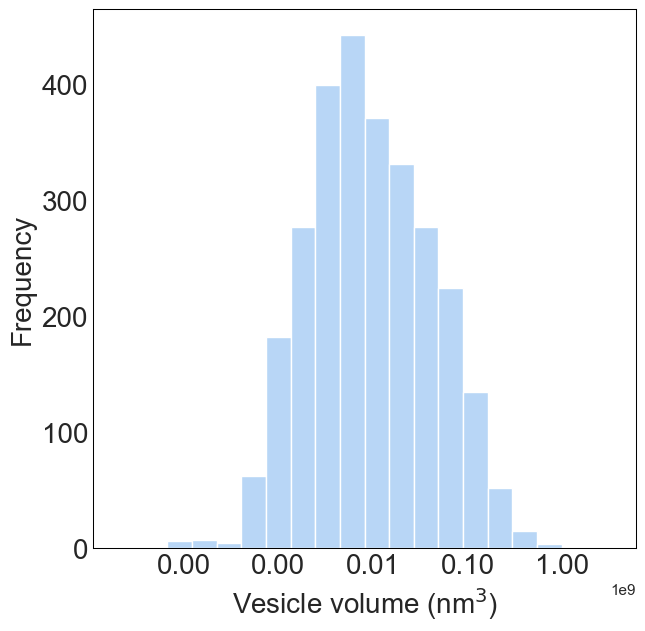

In [322]:
#what is the size distribution of vesicles in the dataset?
#show the overall distribution. not stratified by whether the vesicles contain nanoparticles or not

#what are the percentages of vesicles occupied by NPs
# use histogram

plt.figure() #this creates a new figure on which your plot will appear

#make the tick labels closer to the axes/spine
    #see: https://github.com/matplotlib/matplotlib/issues/17208
mpl.rcParams['xtick.top'] = False
mpl.rcParams['xtick.labeltop'] = False 
mpl.rcParams['xtick.major.pad'] = -2.25
mpl.rcParams['xtick.minor.pad'] = -2.25
mpl.rcParams['ytick.major.pad'] = -2.25
mpl.rcParams['ytick.minor.pad'] = -2.25

#change height and width of dataset
ax = sns.set(rc={'figure.figsize':(7,7)})
#plt.figure(figsize=(15,5))
sns.set_theme(style='white')
#sns.despine()

#fix the plot dimensions so you can read the long text
    #need to call plt before sns, otherwise have a gray bg
#plt.subplots_adjust(left=0,bottom=0,right=1,top=2,wspace=0,hspace=0)


#set bw to smooth out lines for visualization 
ax = sns.histplot(data=sum_all_dataframes_concat_vesicle_vol_SA_updated_diameters['vesicle_volume_nm3_summed_recalc'].tolist(), color=sns.color_palette("pastel")[0], bins=20,log_scale=10) #pastel red




#turn off grid
plt.grid(False)

plt.xlabel('Vesicle volume (nm$^3$)',fontsize=20)
plt.ylabel('Frequency',fontsize=20)
#plt.ticklabel_format()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


#set y-minimum value so that it does not go below zero
plt.ylim(0)


#use values instead of base 10 for x-axis
    #see: https://stackoverflow.com/questions/46735745/how-to-control-scientific-notation-in-matplotlib
from matplotlib.ticker import ScalarFormatter
plt.gca().xaxis.set_major_formatter(ScalarFormatter()) 
#plt.gca().xaxis.set_minor_formatter(ScalarFormatter())

#see for iterating over all spines: https://community.dataquest.io/t/iterate-over-ax-spines-items-and-related-functions/233432/
for key,spine in ax.spines.items():
    spine.set_color('#000000')
    spine.set_linewidth(0.75)


#render figure text as font rather than path
plt.rcParams['svg.fonttype'] = 'none'



#export figure as svg for illustrator figure
#plt.savefig("vesicle-volume-nm3-base10.svg", format="svg", bbox_inches='tight')
#plt.savefig("vesicle-volume-nm3-scaler.svg", format="svg", bbox_inches='tight')
#plt.savefig("vesicle-volume-nm3-scaler-blue.svg", format="svg", bbox_inches='tight')
plt.savefig("vesicle-volume-nm3-scaler-blue-v2.svg", format="svg", bbox_inches='tight')


#display histogram
plt.show()

C:\Users\SM\AppData\Local\Temp\ipykernel_19500\1318003816.py:36: FutureWarning: 

The `bw` parameter is deprecated in favor of `bw_method`/`bw_adjust`.
Setting `bw_method=0.25`, but please see docs for the new parameters
and update your code. This will become an error in seaborn v0.15.0.

  ax = sns.violinplot(data=sum_all_dataframes_concat_vesicle_vol_SA_updated_diameters['vesicle_volume_nm3_summed_recalc'], color=sns.color_palette("pastel")[0], log_scale=10, bw=0.25, orient='h') #pastel blue


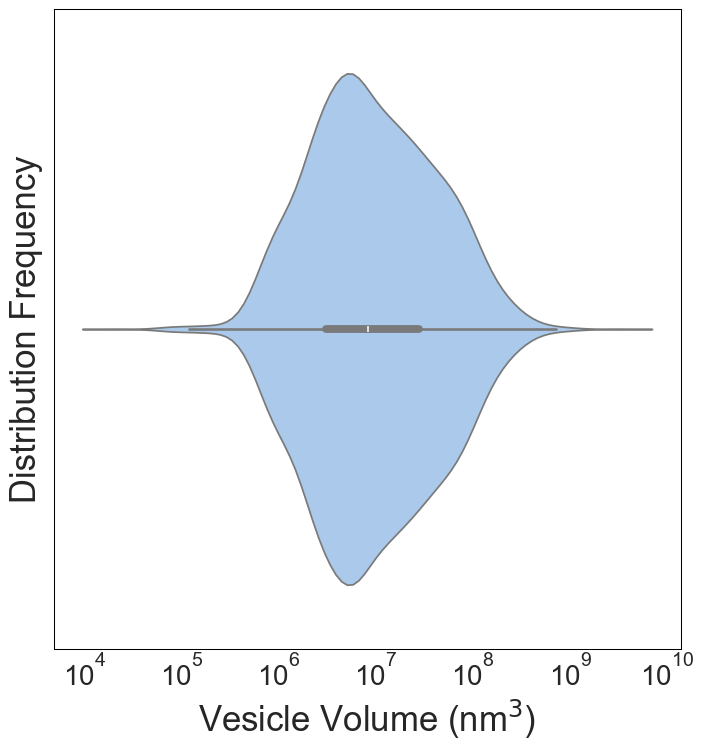

In [324]:
#visualize results - sum of nm^2 vesicle volume as violin plot -log


plt.figure() #this creates a new figure on which your plot will appear

#make the tick labels closer to the axes/spine
    #see: https://github.com/matplotlib/matplotlib/issues/17208
mpl.rcParams['xtick.top'] = False
mpl.rcParams['xtick.labeltop'] = False 
mpl.rcParams['xtick.major.pad'] = -2.25
mpl.rcParams['xtick.minor.pad'] = -2.25
mpl.rcParams['ytick.major.pad'] = -2.25
mpl.rcParams['ytick.minor.pad'] = -2.25


#change height and width of dataset
ax = sns.set(rc={'figure.figsize':(7,7)})
sns.set_theme(style='white')

#change height and width of dataset
#ax = sns.set(rc={'figure.figsize':(12,5)})
#plt.figure(figsize=(15,5))


plt.grid(False)

#change height and width of dataset
#ax = sns.set(rc={'figure.figsize':(12,5)})
#plt.figure(figsize=(5,5))
#plt.figure(constrained_layout=True)
plt.tight_layout()


#don't use cut=0 as there are no values between min value and 0

ax = sns.violinplot(data=sum_all_dataframes_concat_vesicle_vol_SA_updated_diameters['vesicle_volume_nm3_summed_recalc'], color=sns.color_palette("pastel")[0], log_scale=10, bw=0.25, orient='h') #pastel blue



plt.xlabel('Vesicle Volume (nm$^3$)',fontsize=25)
plt.ylabel('Distribution Frequency',fontsize=25)
#plt.ticklabel_format()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)



#set y-minimum value so that it does not go below zero
#plt.ylim(0)

#render figure text as font rather than path
plt.rcParams['svg.fonttype'] = 'none'

#see for iterating over all spines: https://community.dataquest.io/t/iterate-over-ax-spines-items-and-related-functions/233432/
for key,spine in ax.spines.items():
    spine.set_color('#000000')
    spine.set_linewidth(0.75)

#export figure as svg for illustrator figure
#plt.savefig("vesicle-volume-nm3-scaler-blue_log_violin_horz.svg", format="svg", bbox_inches='tight')
plt.savefig("vesicle-volume-nm3-scaler-blue_log_violin_horz_v2.svg", format="svg", bbox_inches='tight')



#display histogram
plt.show()

C:\Users\SM\AppData\Local\Temp\ipykernel_19500\1376570915.py:36: FutureWarning: 

The `bw` parameter is deprecated in favor of `bw_method`/`bw_adjust`.
Setting `bw_method=0.25`, but please see docs for the new parameters
and update your code. This will become an error in seaborn v0.15.0.

  ax = sns.violinplot(data=sum_all_dataframes_concat_vesicle_vol_SA_updated_diameters['vesicle_surface_area_nm2_summed_recalc'], color=sns.color_palette("pastel")[2], log_scale=10, bw=0.25, orient='h') #pastel green


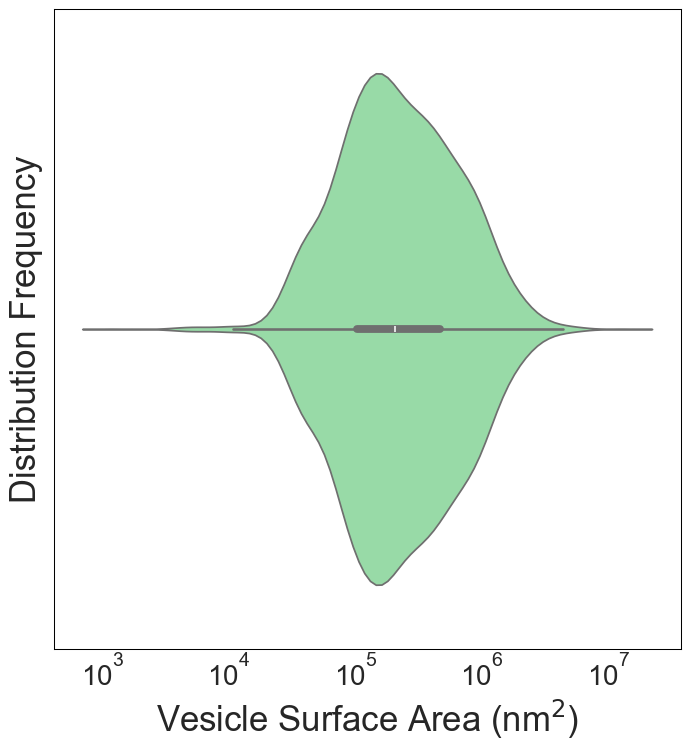

In [329]:
#visualize results - sum of nm^2 vesicle surface area as violin plot -log


plt.figure() #this creates a new figure on which your plot will appear

#make the tick labels closer to the axes/spine
    #see: https://github.com/matplotlib/matplotlib/issues/17208
mpl.rcParams['xtick.top'] = False
mpl.rcParams['xtick.labeltop'] = False 
mpl.rcParams['xtick.major.pad'] = -2.25
mpl.rcParams['xtick.minor.pad'] = -2.25
mpl.rcParams['ytick.major.pad'] = -2.25
mpl.rcParams['ytick.minor.pad'] = -2.25


#change height and width of dataset
ax = sns.set(rc={'figure.figsize':(7,7)})
sns.set_theme(style='white')

#change height and width of dataset
#ax = sns.set(rc={'figure.figsize':(12,5)})
#plt.figure(figsize=(15,5))


plt.grid(False)

#change height and width of dataset
#ax = sns.set(rc={'figure.figsize':(12,5)})
#plt.figure(figsize=(5,5))
#plt.figure(constrained_layout=True)
plt.tight_layout()


#don't use cut=0 as there are no values between min value and 0

ax = sns.violinplot(data=sum_all_dataframes_concat_vesicle_vol_SA_updated_diameters['vesicle_surface_area_nm2_summed_recalc'], color=sns.color_palette("pastel")[2], log_scale=10, bw=0.25, orient='h') #pastel green



#plt.xlabel('x',fontsize=25)
plt.xlabel('Vesicle Surface Area (nm$^2$)',fontsize=25)
plt.ylabel('Distribution Frequency',fontsize=25)
#plt.ticklabel_format()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)



#set y-minimum value so that it does not go below zero
#plt.ylim(0)

#render figure text as font rather than path
plt.rcParams['svg.fonttype'] = 'none'

#see for iterating over all spines: https://community.dataquest.io/t/iterate-over-ax-spines-items-and-related-functions/233432/
for key,spine in ax.spines.items():
    spine.set_color('#000000')
    spine.set_linewidth(0.75)

#export figure as svg for illustrator figure
#plt.savefig("vesicle-SA-nm3-scaler-green_log_violin_horz.svg", format="svg", bbox_inches='tight')
plt.savefig("vesicle-SA-nm3-scaler-green_log_violin_horz_v2.svg", format="svg", bbox_inches='tight')



#display histogram
plt.show()

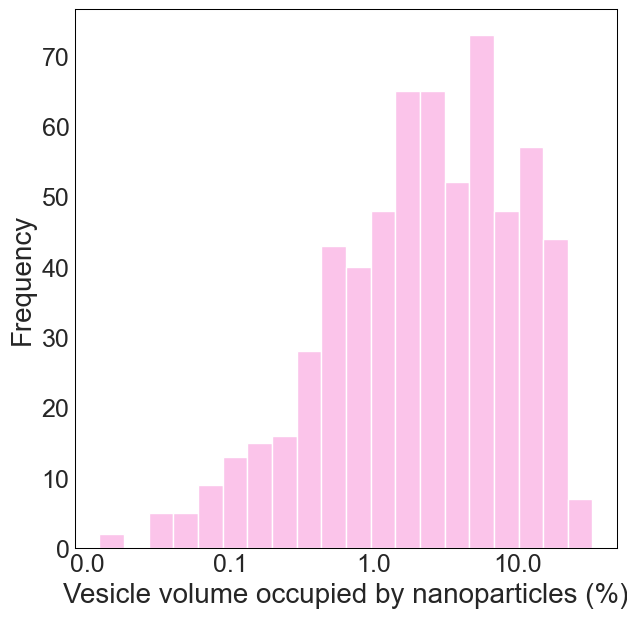

In [330]:
#what are the percentages of vesicles occupied by NPs
# use histogram

plt.figure() #this creates a new figure on which your plot will appear

#make the tick labels closer to the axes/spine
    #see: https://github.com/matplotlib/matplotlib/issues/17208
mpl.rcParams['xtick.top'] = False
mpl.rcParams['xtick.labeltop'] = False 
mpl.rcParams['xtick.major.pad'] = -2.25
mpl.rcParams['xtick.minor.pad'] = -2.25
mpl.rcParams['ytick.major.pad'] = -2.25
mpl.rcParams['ytick.minor.pad'] = -2.25

#change height and width of dataset
#ax = plt.figure(figsize=(4.373,3.1))


#change height and width of dataset
ax = sns.set(rc={'figure.figsize':(7,7)})
#plt.figure(figsize=(15,5))
sns.set_theme(style='white')
#sns.despine()

#fix the plot dimensions so you can read the long text
    #need to call plt before sns, otherwise have a gray bg
#plt.subplots_adjust(left=0,bottom=0,right=1,top=2,wspace=0,hspace=0)


#set bw to smooth out lines for visualization 
ax = sns.histplot(data=sum_all_dataframes_concat_vesicle_vol_SA_updated_diameters['percentage_vesicle_occupied_by_NP'], color=sns.desaturate('#fab0e4', 1.0), bins=20, log_scale=10) #pastel red

#change height and width of dataset
#ax = sns.set(rc={'figure.figsize':(12,5)})
#plt.figure(figsize=(15,5))


#turn off grid
plt.grid(False)

plt.xlabel('Vesicle volume occupied by nanoparticles (%)',fontsize=20)
plt.ylabel('Frequency',fontsize=20)
#plt.ticklabel_format()
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)


#use values instead of base 10 for x-axis
    #see: https://stackoverflow.com/questions/46735745/how-to-control-scientific-notation-in-matplotlib
from matplotlib.ticker import ScalarFormatter
plt.gca().xaxis.set_major_formatter(ScalarFormatter()) 
#plt.gca().xaxis.set_minor_formatter(ScalarFormatter());   # <---- OK

#set y-minimum value so that it does not go below zero
plt.ylim(0)


#render figure text as font rather than path
plt.rcParams['svg.fonttype'] = 'none'

#see for iterating over all spines: https://community.dataquest.io/t/iterate-over-ax-spines-items-and-related-functions/233432/
for key,spine in ax.spines.items():
    spine.set_color('#000000')
    spine.set_linewidth(0.75)

#export figure as svg for illustrator figure
#plt.savefig("vesicle-vol-occupied-by-np-base10.svg", format="svg", bbox_inches='tight')
#plt.savefig("vesicle-vol-occupied-by-np-scaler.svg", format="svg", bbox_inches='tight')
#plt.savefig("vesicle-vol-occupied-by-np-scaler_pink.svg", format="svg", bbox_inches='tight')
plt.savefig("vesicle-vol-occupied-by-np-scaler_pink_v2.svg", format="svg", bbox_inches='tight')

#display histogram
plt.show()

In [221]:
#Summary of data
#what is the max percentage of vesicle volume occupied by NPs
print(sum_all_dataframes_concat_vesicle_vol_SA_updated_diameters['percentage_vesicle_occupied_by_NP'].min())
print(sum_all_dataframes_concat_vesicle_vol_SA_updated_diameters['percentage_vesicle_occupied_by_NP'].max())
print(sum_all_dataframes_concat_vesicle_vol_SA_updated_diameters['percentage_vesicle_occupied_by_NP'].mean())
print(sum_all_dataframes_concat_vesicle_vol_SA_updated_diameters['percentage_vesicle_occupied_by_NP'].median())


0.0
33.33333333333333
1.1059712639788666
0.0


In [222]:
# how many nanoparticles could theoretically fit in a vesicle vs. how many nanoparticles are actually in the vesicle?
# need to calculate how many NPs can fit in a vesicle based on the area of each 2D plane
    #for each 2D plane, divide the area of each vesicle by the area of a 50nm nanoparticle
    # save this in a new column
        #what is the area of a single 50nm particle? it is approximately a 3x3 block of pixels, so 9 pixels in total
        # this is because the diameter of the NPs is about 55nm. this require ~3 pixels at 17nm/pixel. 55 px/(17nm/px) = ~3.235 =~3 pixels for the diameter



In [223]:
#keep units in pixels since they have to match. the resulting unit is # of NPs
sum_all_dataframes_concat_vesicle_vol_SA_updated_diameters['max_theoretical_NPs'] = sum_all_dataframes_concat_vesicle_vol_SA_updated_diameters['area'] / 9

In [224]:
#how many NPs are in each vesicle
    # was previously computed

# read in dataframe where each row is a different NP with centroid coords
all_df_EDT_combined_vesicle = pd.read_csv('df_EDT_closest_cell_t-score.csv+vesicle.csv', index_col=0)


In [225]:
NPs_per_vesicle_counts_df = all_df_EDT_combined_vesicle.groupby("vesicle-ID").count()
NPs_per_vesicle_counts_df

NP-label  3D-EDT-to-cell-7_nm  3D-EDT-to-cell-8_nm  \
vesicle-ID                                                       
0             551572               551572               551572   
3                  1                    1                    1   
5                  2                    2                    2   
7                  1                    1                    1   
9                  4                    4                    4   
...              ...                  ...                  ...   
3066               2                    2                    2   
3071              23                   23                   23   
3073               4                    4                    4   
3074               7                    7                    7   
3076               9                    9                    9   

            3D-EDT-to-cell-9_nm  3D-EDT-to-cell-10_nm  3D-EDT-to-cell-11_nm  \
vesicle-ID                                                                    
0                        551572                551572                551572   
3                             1                     1                     1   
5                             2                     2                     2   
7                             1                     1                     1   
9                             4                     4                     4   
...                         ...                   ...                   ...   
3066                          2                     2                     2   
3071                         23                    23                    23   
3073                          4                     4                     4   
3074                          7                     7                     7   
3076                          9                     9                     9   

            3D-EDT-to-cell-12_nm  3D-EDT-to-cell-13_nm  3D-EDT-to-cell-14_nm  \
vesicle-ID                                                                     
0                         551572                551572                551572   
3                              1                     1                     1   
5                              2                     2                     2   
7                              1                     1                     1   
9                              4                     4                     4   
...                          ...                   ...                   ...   
3066                           2                     2                     2   
3071                          23                    23                    23   
3073                           4                     4                     4   
3074                           7                     7                     7   
3076                           9                     9                     9   

            3D-EDT-to-cell-15_nm  ...  3D-EDT-to-cell-32_nm  \
vesicle-ID                        ...                         
0                         551572  ...                551572   
3                              1  ...                     1   
5                              2  ...                     2   
7                              1  ...                     1   
9                              4  ...                     4   
...                          ...  ...                   ...   
3066                           2  ...                     2   
3071                          23  ...                    23   
3073                           4  ...                     4   
3074                           7  ...                     7   
3076                           9  ...                     9   

            3D-EDT-to-cell-33_nm  3D-EDT-to-cell-34_nm  lowest-EDT_nm  \
vesicle-ID                                                              
0                         551572                551572         551572   
3                              1             

In [226]:
#set all initials values to 0 for the actual number of NPs in each vesicle
sum_all_dataframes_concat_vesicle_vol_SA_updated_diameters['actual_num_NPs'] = 0

#get list of all vesicle labels with at least 1 NP (use slice [1:] to remove the 'vesicle-ID' of 0 which is background)
list_of_vesicle_labels_with_NPs = NPs_per_vesicle_counts_df.index.tolist()[1:]
list_of_vesicle_labels_with_NPs

[3,
 5,
 7,
 9,
 10,
 12,
 36,
 38,
 58,
 61,
 63,
 67,
 71,
 78,
 80,
 82,
 105,
 115,
 125,
 129,
 130,
 131,
 144,
 154,
 155,
 164,
 176,
 184,
 188,
 196,
 221,
 225,
 229,
 232,
 236,
 241,
 263,
 267,
 268,
 269,
 276,
 284,
 285,
 288,
 295,
 298,
 317,
 318,
 321,
 334,
 341,
 348,
 351,
 353,
 354,
 358,
 362,
 380,
 392,
 394,
 395,
 396,
 405,
 408,
 412,
 429,
 435,
 441,
 455,
 468,
 478,
 482,
 488,
 500,
 501,
 507,
 520,
 525,
 537,
 539,
 540,
 558,
 569,
 584,
 590,
 598,
 608,
 610,
 616,
 617,
 621,
 627,
 628,
 634,
 640,
 645,
 646,
 661,
 662,
 666,
 669,
 681,
 686,
 700,
 708,
 715,
 722,
 725,
 730,
 740,
 752,
 755,
 756,
 766,
 769,
 778,
 784,
 787,
 791,
 799,
 811,
 817,
 821,
 822,
 835,
 844,
 845,
 852,
 857,
 862,
 873,
 892,
 894,
 901,
 931,
 932,
 946,
 956,
 958,
 959,
 961,
 984,
 996,
 1001,
 1009,
 1010,
 1019,
 1023,
 1029,
 1031,
 1035,
 1042,
 1053,
 1064,
 1067,
 1075,
 1088,
 1089,
 1092,
 1112,
 1114,
 1117,
 1140,
 1156,
 1157,
 1163,
 

In [227]:
#set the actual number of NPs per vesicle based on how many NPs were counted for each vesicle.  
for i in list_of_vesicle_labels_with_NPs:
    #print(i)
    sum_all_dataframes_concat_vesicle_vol_SA_updated_diameters.loc[i,'actual_num_NPs'] = NPs_per_vesicle_counts_df.loc[i,'NP-label']
    #sum_all_dataframes_concat_vesicle_vol_SA_updated_diameters['actual_num_NPs'][i] = NPs_per_vesicle_counts_df['NP-label'][i] #wrong way to index/slice

In [228]:
sum_all_dataframes_concat_vesicle_vol_SA_updated_diameters

index_manual    area  z-slice  volume_um3  surface_area  \
label                                                            
1              1770  1576.0       28    0.031882         433.0   
2               189   392.0        3    0.007930         141.0   
3               643   416.0       10    0.008416         179.0   
4              2275  2439.0       36    0.049341         577.0   
5                67   108.0        1    0.002185          43.0   
...             ...     ...      ...         ...           ...   
3077          52196   216.0     1020    0.004370          95.0   
3078          34836    60.0      681    0.001214          42.0   
3079          34838    61.0      681    0.001234          41.0   
3080          34840    58.0      681    0.001173          40.0   
3081          17438    19.0      341    0.000384          16.0   

       surface_area_um2  axis_major_length  axis_minor_length  \
label                                                           
1               0.50694         131.101990         106.103356   
2               0.16779          45.130191          33.053561   
3               0.20706          67.602826          33.408799   
4               0.68187         186.952753         124.284192   
5               0.04760          14.280661          12.486180   
...                 ...                ...                ...   
3077            0.11305          29.583567          23.986930   
3078            0.04998          14.003046          10.595106   
3079            0.04879          15.655869           9.081792   
3080            0.04760          14.862518           9.285758   
3081            0.01904           5.823607           4.256623   

       feret_diameter_max  equivalent_diameter_area  ...  \
label                                                ...   
1              137.503206                117.538099  ...   
2               46.657664                 38.176086  ...   
3               68.089955                 47.570271  ...   
4              190.607230                151.896052  ...   
5               14.766032                 13.516856  ...   
...                   ...                       ...  ...   
3077            31.680737                 26.626527  ...   
3078            14.819146                 12.100040  ...   
3079            15.931620                 12.023234  ...   
3080            15.317785                 11.826249  ...   
3081             5.830952                  4.918491  ...   

       volume_subtract_nps_um3  volume_nps_only_area  \
label                                                  
1                     0.031882                   0.0   
2                     0.007930                   0.0   
3                     0.008294                   6.0   
4                     0.049341                   0.0   
5                     0.001902                  14.0   
...                        ...                   ...   
3077                  0.004370                   0.0   
3078                  0.001214                   0.0   
3079                  0.001234                   0.0   
3080                  0.001173                   0.0   
3081                  0.000384                   0.0   

       volume_nps_only_volume_um3  vesicle_volume_nm3_summed_recalc  \
label                                                                 
1                        0.000000                        31882480.0   
2                        0.000000                         7930160.0   
3                        0.000121                         8415680.0   
4                        0.000000                        49340970.0   
5                        0.000283                         2184840.0   
...                           ...                               ...   
3077                     0.000000                         4369680.0   
3078                     0.000000                         1213800.0   
3079                     0.000000                         1234030.0   
3080       

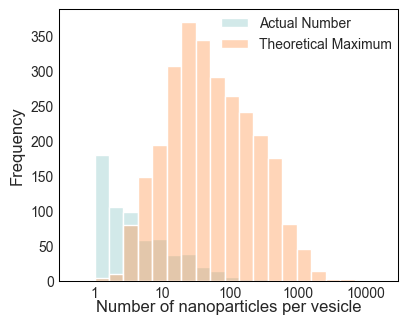

In [465]:
#what are the percentages of vesicles occupied by NPs
# use histogram


plt.figure() #this creates a new figure on which your plot will appear

#make the tick labels closer to the axes/spine
    #see: https://github.com/matplotlib/matplotlib/issues/17208
mpl.rcParams['xtick.top'] = False
mpl.rcParams['xtick.labeltop'] = False 
mpl.rcParams['xtick.major.pad'] = -2.25
mpl.rcParams['xtick.minor.pad'] = -2.25
mpl.rcParams['ytick.major.pad'] = -2.25
mpl.rcParams['ytick.minor.pad'] = -2.25

#change height and width of dataset
#ax = plt.figure(figsize=(4.373,4))


#only consider values greater than 0
#x_plot_data = sum_all_dataframes_concat_vesicle_vol_SA_updated_diameters.loc[sum_all_dataframes_concat_vesicle_vol_SA_updated_diameters['max_theoretical_NPs'] >0,'max_theoretical_NPs']
#y_plot_data = sum_all_dataframes_concat_vesicle_vol_SA_updated_diameters.loc[sum_all_dataframes_concat_vesicle_vol_SA_updated_diameters['actual_num_NPs'] >0,'actual_num_NPs']


#consider all values
#x_plot_data = sum_all_dataframes_concat_vesicle_vol_SA_updated_diameters['max_theoretical_NPs']
x_plot_data = sum_all_dataframes_concat_vesicle_vol_SA_updated_diameters.loc[(sum_all_dataframes_concat_vesicle_vol_SA_updated_diameters['max_theoretical_NPs'] > 1),  'max_theoretical_NPs']
y_plot_data = sum_all_dataframes_concat_vesicle_vol_SA_updated_diameters['actual_num_NPs']

#change height and width of dataset
sns.set_theme(style='white')
#sns.despine()

#need to use log plot to se all data

#ax = sns.histplot(data=x_plot_data, color=sns.color_palette("pastel")[1], bins=20,log_scale=10) #pastel red
ax = sns.histplot(data=[x_plot_data,y_plot_data], palette=['#ff964f','#8FCACA'], bins=20,log_scale=10, alpha=0.4) #pastel red

#ax = plt.hist( y_plot_data, color='r', alpha=1.0,bins=100,log_scale=10)
#ax = plt.hist([x_plot_data, y_plot_data], color=['r','b'], alpha=0.5)

sns.set_style('white')#, {'legend.frameon':False})
#sns.set(color_codes=True)
#turn off grid
plt.grid(False)

plt.xlabel('Number of nanoparticles per vesicle',fontsize=12)
plt.ylabel('Frequency',fontsize=12)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

#put x-label closer to x-axes ticks. set xlabels first. 
    #see: https://github.com/matplotlib/matplotlib/issues/17208
ax.xaxis.labelpad = -0.75

#set y-minimum value so that it does not go below zero
plt.ylim(0)
plt.xlim(0.3) #

#plt.legend(title='', loc='upper right', labels=['Actual Number','Theoretical Maximum'],frameon=True)
plt.legend( fancybox=False,labels=['Actual Number','Theoretical Maximum'], shadow = False, borderaxespad=False, frameon=False, loc="lower center",bbox_to_anchor=(0.73, 0.825), fontsize=10)


#use values instead of base 10 for x-axis
    #see: https://stackoverflow.com/questions/46735745/how-to-control-scientific-notation-in-matplotlib
from matplotlib.ticker import ScalarFormatter
plt.gca().xaxis.set_major_formatter(ScalarFormatter()) 
#plt.gca().xaxis.set_minor_formatter(ScalarFormatter())


#render figure text as font rather than path
plt.rcParams['svg.fonttype'] = 'none'

#see for iterating over all spines: https://community.dataquest.io/t/iterate-over-ax-spines-items-and-related-functions/233432/
for key,spine in ax.spines.items():
    spine.set_color('#000000')
    spine.set_linewidth(0.75)

#export figure as svg for illustrator figure
#plt.savefig("actual-vs-theoretical-max-np-per-vesicle-base10.svg", format="svg", bbox_inches='tight')
#plt.savefig("actual-vs-theoretical-max-np-per-vesicle-scaler.svg", format="svg", bbox_inches='tight')
#plt.savefig("actual-vs-theoretical-max-np-per-vesicle-scaler-new-colors+legend_blue-orange.svg", format="svg", bbox_inches='tight')
#plt.savefig("actual-vs-theoretical-max-np-per-vesicle-scaler-new-colors+legend_blue-orange_v2.svg", format="svg", bbox_inches='tight')
plt.savefig("actual-vs-theoretical-max-np-per-vesicle-scaler-new-colors+legend_blue-orange_v3.svg", format="svg", bbox_inches='tight')
    

#display histogram
plt.show()

In [231]:
#maximum number of nanoparticles in a vesicle
print(np.max(sum_all_dataframes_concat_vesicle_vol_SA_updated_diameters['actual_num_NPs']))
print(np.mean(sum_all_dataframes_concat_vesicle_vol_SA_updated_diameters['actual_num_NPs']))
print(np.max(sum_all_dataframes_concat_vesicle_vol_SA_updated_diameters['max_theoretical_NPs']))
print(np.mean(sum_all_dataframes_concat_vesicle_vol_SA_updated_diameters['max_theoretical_NPs']))

#how many more-fold NPs can fit in vesicles than are currently, on average
print(np.mean(sum_all_dataframes_concat_vesicle_vol_SA_updated_diameters['max_theoretical_NPs'])/ np.mean(sum_all_dataframes_concat_vesicle_vol_SA_updated_diameters['actual_num_NPs']))

450
2.3775473721844835
18093.666666666668
158.12600802447068
66.50803675856308


In [ ]:
#for ICP-MS analysis
# take a random slice. halfway through the volume. So this would be slice 342/2 = slice 171
# how many nanoparticles are on slice 171?

In [232]:
#read in dataset
all_df_EDT_combined = pd.read_csv('df_EDT_closest_cell_t-score.csv', index_col=0)

In [233]:
#all_df_EDT_combined
all_df_EDT_combined.loc[all_df_EDT_combined['z-slice'] == 170]
print(len(all_df_EDT_combined.loc[all_df_EDT_combined['z-slice'] == 170]))

#there are 1832 nanoparticles on slice 170. convert this to concentration of NP/ml in Excel file

1832


In [234]:
# how many nanoparticles in total?
print(len(all_df_EDT_combined))

558222


<Figure size 470x470 with 0 Axes>

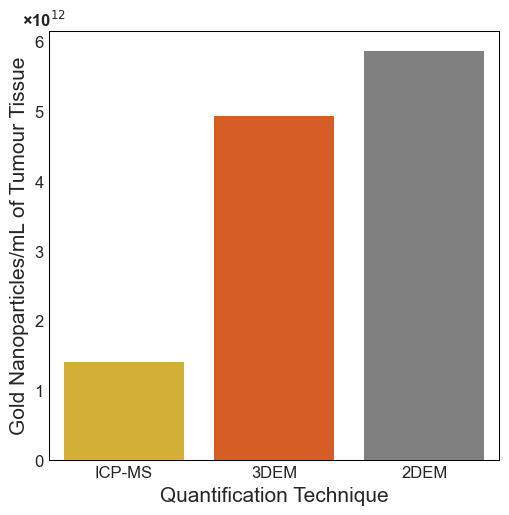

In [332]:
#get number of NPs inside cells that are either i) free floating or ii) within vesicles
    # this is only inside of ECs since the column for 'cell-lowest-EDT' only considers EC cells in the list index_keep_ECs

NP_per_ml = pd.DataFrame(
    {'ICP-MS': [(1.41e12)], 
     '3DEM': [(4.93e12)],
     '2DEM': [(5.86e12)],
     }
)

#make the tick labels closer to the axes/spine
    #see: https://github.com/matplotlib/matplotlib/issues/17208
mpl.rcParams['xtick.top'] = False
mpl.rcParams['xtick.labeltop'] = False 
mpl.rcParams['xtick.major.pad'] = -2.25
mpl.rcParams['xtick.minor.pad'] = -2.25
mpl.rcParams['ytick.major.pad'] = -2.25
mpl.rcParams['ytick.minor.pad'] = -2.25

#change height and width of dataset
ax = plt.figure(figsize=(4.7,4.7))

sns.set_theme(style='white')
sns.despine()


ax = sns.catplot(data=NP_per_ml,kind='bar',color='gray')


#turn off grid
#sns.set_style("whitegrid", {'axes.grid' : False})
sns.set_style("whitegrid", )



#add border here, see: https://stackoverflow.com/questions/62375119/how-to-add-a-border-or-frame-around-a-figure-and-subplots
for ax in ax.axes.flat:
    #ax.bar_label(ax.containers[0],fontsize=17.5)
    #ax.patch.set_linewidth(1.5) #need to comment out, otherwise cannot make line thickness 0.5 for edge
    ax.patch.set_edgecolor('black')

plt.xlabel('Quantification Technique',fontsize=15)
plt.ylabel('Gold Nanoparticles/mL of Tumour Tissue',fontsize=15)
#plt.ticklabel_format()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

#change formatting and add superscript to top. replace with nothing except for 0 needs to be reformatted so replace e+00 for that y-tick-val
#y_ticks = ax.axes.get_yticks()
#ylabels = [( '{:,.1f}'.format(y/1e5)).replace(".0","") for y in y_ticks]
#ax.set_yticklabels(ylabels)                 

#remove line/border surrounding bar plot
plt.setp(ax.patches, linewidth=0)
    
#change colours for each plot

#palette = ["#8de5a1", "#cfcfcf"] #pastel green and pastel gray. used Firefox eyedropper to get hexadecimal. Use pastel red for nanoparticle distance
#palette = ["#FDFD96", "#FFC067", "gray"]
palette = ["#D4AF37", "#d65d26", "gray"]

for bars, colors in zip(ax.containers, (palette[0::1], palette[0::2], palette[0::3], )):
    for bar, color in zip(bars, colors):
        bar.set_facecolor(color)

#use values instead of base 10 for x-axis
    #see: https://stackoverflow.com/questions/46735745/how-to-control-scientific-notation-in-matplotlib
#from matplotlib.ticker import ScalarFormatter, StrMethodFormatter, NullFormatter
#plt.gca().yaxis.set_major_formatter(log) 
#plt.gca().xaxis.set_minor_formatter(ScalarFormatter());   # <---- OK

#use scientific notation
    #see: https://stackoverflow.com/questions/69979990/scientific-notation-on-seaborn-catplot-facetgrid-axes
#plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}')) 
#plt.ticklabel_format(axis="y", style="sci", scilimits=(12,12))


#********* START SCALING FACTOR #*********
#scale factor
scale_factor = 1e12
exponent_val = len(str(int(scale_factor/10)))

#rescale values by dividing by 10000, 1e4
ax.get_yaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: format(int(x/scale_factor), )))


#add label with scale factor to graph
#see superscripting variable: https://stackoverflow.com/questions/52379803/superscript-for-a-variable
ax.text(-0.06, 1.01, '×10'+r'$^{%.0f}$' % (exponent_val) , transform=ax.transAxes, fontname="Arial", size=12, weight='bold')
#ax.text(0.92, -0.15, '×10'+r'$^{%.0f}$' % (exponent_val) , transform=ax.transAxes, fontname="Arial", size=12, weight='bold')


#set scale to 1e3
#plt.ticklabel_format(axis='both', style='sci', scilimits=(3,3))

#********* END SCALING FACTOR #*********


#render figure text as font rather than path
plt.rcParams['svg.fonttype'] = 'none'

#sns.despine()

#see for iterating over all spines: https://community.dataquest.io/t/iterate-over-ax-spines-items-and-related-functions/233432/
for key,spine in ax.spines.items():
    spine.set_zorder(0)
    spine.set_visible(True)
    spine.set_color('#000000')
    spine.set_linewidth(0.75)
    

    
#export figure as svg for illustrator figure
#plt.savefig("number-of-NPs_2DEM-3DEM-ICPMS.svg", format="svg", bbox_inches='tight')
#plt.savefig("number-of-NPs_2DEM-3DEM-ICPMS_v2.svg", format="svg", bbox_inches='tight')
plt.savefig("number-of-NPs_2DEM-3DEM-ICPMS_v3.svg", format="svg", bbox_inches='tight')
    
    
#display histogram
plt.show()

<Figure size 470x470 with 0 Axes>

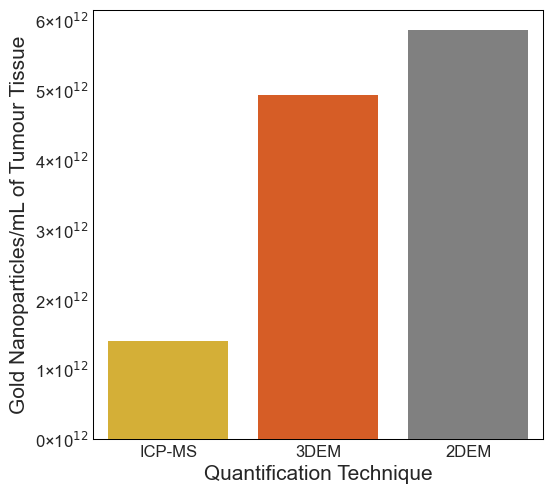

In [401]:
#get number of NPs inside cells that are either i) free floating or ii) within vesicles
    # this is only inside of ECs since the column for 'cell-lowest-EDT' only considers EC cells in the list index_keep_ECs

NP_per_ml = pd.DataFrame(
    {'ICP-MS': [(1.41e12)], 
     '3DEM': [(4.93e12)],
     '2DEM': [(5.86e12)],
     }
)

#make the tick labels closer to the axes/spine
    #see: https://github.com/matplotlib/matplotlib/issues/17208
mpl.rcParams['xtick.top'] = False
mpl.rcParams['xtick.labeltop'] = False 
mpl.rcParams['xtick.major.pad'] = -2.25
mpl.rcParams['xtick.minor.pad'] = -2.25
mpl.rcParams['ytick.major.pad'] = -2.25
mpl.rcParams['ytick.minor.pad'] = -2.25

#change height and width of dataset
ax = plt.figure(figsize=(4.7,4.7))

sns.set_theme(style='white')
sns.despine()


ax = sns.catplot(data=NP_per_ml,kind='bar',color='gray')


#turn off grid
#sns.set_style("whitegrid", {'axes.grid' : False})
sns.set_style("whitegrid", )



#add border here, see: https://stackoverflow.com/questions/62375119/how-to-add-a-border-or-frame-around-a-figure-and-subplots
for ax in ax.axes.flat:
    #ax.bar_label(ax.containers[0],fontsize=17.5)
    #ax.patch.set_linewidth(1.5) #need to comment out, otherwise cannot make line thickness 0.5 for edge
    ax.patch.set_edgecolor('black')

plt.xlabel('Quantification Technique',fontsize=15)
plt.ylabel('Gold Nanoparticles/mL of Tumour Tissue',fontsize=15)
#plt.ticklabel_format()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

#change formatting and add superscript to top. replace with nothing except for 0 needs to be reformatted so replace e+00 for that y-tick-val
#y_ticks = ax.axes.get_yticks()
#ylabels = [( '{:,.1f}'.format(y/1e5)).replace(".0","") for y in y_ticks]
#ax.set_yticklabels(ylabels)                 

#remove line/border surrounding bar plot
plt.setp(ax.patches, linewidth=0)
    
#change colours for each plot

#palette = ["#8de5a1", "#cfcfcf"] #pastel green and pastel gray. used Firefox eyedropper to get hexadecimal. Use pastel red for nanoparticle distance
#palette = ["#FDFD96", "#FFC067", "gray"]
palette = ["#D4AF37", "#d65d26", "gray"]

for bars, colors in zip(ax.containers, (palette[0::1], palette[0::2], palette[0::3], )):
    for bar, color in zip(bars, colors):
        bar.set_facecolor(color)

#use values instead of base 10 for x-axis
    #see: https://stackoverflow.com/questions/46735745/how-to-control-scientific-notation-in-matplotlib
#from matplotlib.ticker import ScalarFormatter, StrMethodFormatter, NullFormatter
#plt.gca().yaxis.set_major_formatter(log) 
#plt.gca().xaxis.set_minor_formatter(ScalarFormatter());   # <---- OK

#use scientific notation
    #see: https://stackoverflow.com/questions/69979990/scientific-notation-on-seaborn-catplot-facetgrid-axes
#plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}')) 
#plt.ticklabel_format(axis="y", style="plain",useOffset=False,useMathText=True)# scilimits=(0,0))
#ax.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.0e'))
#ax.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter(r'%.0f×10'))
#see: https://stackoverflow.com/questions/40511476/how-to-properly-use-funcformatterfunc and https://stackoverflow.com/questions/35415757/adding-sign-to-exponent-in-matplotlib-axes
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: '{0:g}×10$^{{12}}$'.format(x/1e12)))


#********* START SCALING FACTOR #*********
#scale factor
scale_factor = 1e12
exponent_val = len(str(int(scale_factor/10)))

#rescale values by dividing by 10000, 1e4
#ax.get_yaxis().set_major_formatter(
#    mpl.ticker.FuncFormatter(lambda x, p: format(int(x/scale_factor), )))


#add label with scale factor to graph
#see superscripting variable: https://stackoverflow.com/questions/52379803/superscript-for-a-variable
#ax.text(-0.06, 1.01, '×10'+r'$^{%.0f}$' % (exponent_val) , transform=ax.transAxes, fontname="Arial", size=12, weight='bold')
#ax.text(0.92, -0.15, '×10'+r'$^{%.0f}$' % (exponent_val) , transform=ax.transAxes, fontname="Arial", size=12, weight='bold')


#set scale to 1e3
#plt.ticklabel_format(axis='both', style='sci', scilimits=(3,3))

#********* END SCALING FACTOR #*********


#render figure text as font rather than path
plt.rcParams['svg.fonttype'] = 'none'

#sns.despine()

#see for iterating over all spines: https://community.dataquest.io/t/iterate-over-ax-spines-items-and-related-functions/233432/
for key,spine in ax.spines.items():
    spine.set_zorder(0)
    spine.set_visible(True)
    spine.set_color('#000000')
    spine.set_linewidth(0.75)
    

    
#export figure as svg for illustrator figure
#plt.savefig("number-of-NPs_2DEM-3DEM-ICPMS.svg", format="svg", bbox_inches='tight')
#plt.savefig("number-of-NPs_2DEM-3DEM-ICPMS_v2.svg", format="svg", bbox_inches='tight')
#plt.savefig("number-of-NPs_2DEM-3DEM-ICPMS_v3.svg", format="svg", bbox_inches='tight')
plt.savefig("number-of-NPs_2DEM-3DEM-ICPMS_v4.svg", format="svg", bbox_inches='tight')
    
    
#display histogram
plt.show()

In [36]:
#compare 3D confocal with 3D EM


In [256]:
#read in annotated cell 1 with 3DEM and 3D confocal
    #had to install imagecodecs to get this to work with the ome-tif file here. not sure why I previously didn't have this issue
    # pip install imagecodecs

cell_1_3DEM = io.imread(r"C:\Users\SM\Desktop\Reviewer-vesicle\CLEM\EM\3.Ishaan-align-set4\set_4_for_stefan\0.Mlad-output\model\Labels_set4_cell_1_elastic_stack-ome_good2.tif", plugin="tifffile")
cell_1_confocal = io.imread(r"C:\Users\SM\Desktop\Reviewer-vesicle\CLEM\CL+EM\bigwarp\1.cell1-EM-fixed\mib-model-transformed\cell1-transformed2.tif", plugin="tifffile")

In [257]:
#%timeit print(np.sum(cell_1_3DEM))
#print(np.sum(cell_1_3DEM))
cell_1_3DEM_sum = np.sum(cell_1_3DEM)
print(cell_1_3DEM_sum)
cell_1_confocal_sum = np.sum(cell_1_confocal)
print(cell_1_confocal_sum)

100656152
104758992


In [258]:
#opening the file in FIJI and resaving seemed to fix the issue with opening the OME TIF files

cell_2_3DEM = io.imread(r"C:\Users\SM\Desktop\Reviewer-vesicle\CLEM\EM\3.Ishaan-align-set4\set_4_for_stefan\0.Mlad-output\model\Labels_set4_cell_2_elastic_stack-ome-v2.tif", plugin="tifffile")
cell_2_confocal = io.imread(r"C:\Users\SM\Desktop\Reviewer-vesicle\CLEM\CL+EM\bigwarp\2.cell2-EM-fixed\v2-align\mib-model-transformed\cell2-transformed-model2.tif", plugin="tifffile")

In [259]:
#%timeit print(np.sum(cell_1_3DEM))
#print(np.sum(cell_1_3DEM))
cell_2_3DEM_sum = np.sum(cell_2_3DEM)
print(cell_2_3DEM_sum)
cell_2_confocal_sum = np.sum(cell_2_confocal)
print(cell_2_confocal_sum)

52565450
52533620


In [260]:
#opening the file in FIJI and resaving seemed to fix the issue with opening the OME TIF files

cell_3_3DEM = io.imread(r"C:\Users\SM\Desktop\Reviewer-vesicle\CLEM\EM\3.Ishaan-align-set4\set_4_for_stefan\0.Mlad-output\model\Labels_set4_cell_5_elastic_stack-ome.tif", plugin="tifffile")
cell_3_confocal = io.imread(r"C:\Users\SM\Desktop\Reviewer-vesicle\CLEM\CL+EM\bigwarp\3.cell5-EM-fixed\cell-transform-model\cell5-model2.tif", plugin="tifffile")

In [261]:
cell_3_3DEM_sum = np.sum(cell_3_3DEM)
print(cell_3_3DEM_sum)
cell_3_confocal_sum = np.sum(cell_3_confocal)
print(cell_3_confocal_sum)

35775047
35813058


TypeError: Index(...) must be called with a collection of some kind, 52565450 was passed

In [262]:
#first show fold difference in volume:
volume_fold_difference_confocal_over_EM = []
volume_fold_difference_confocal_over_EM.append(cell_1_confocal_sum/cell_1_3DEM_sum)
volume_fold_difference_confocal_over_EM.append(cell_2_confocal_sum/cell_2_3DEM_sum)
volume_fold_difference_confocal_over_EM.append(cell_3_confocal_sum/cell_3_3DEM_sum)

<Figure size 470x470 with 0 Axes>

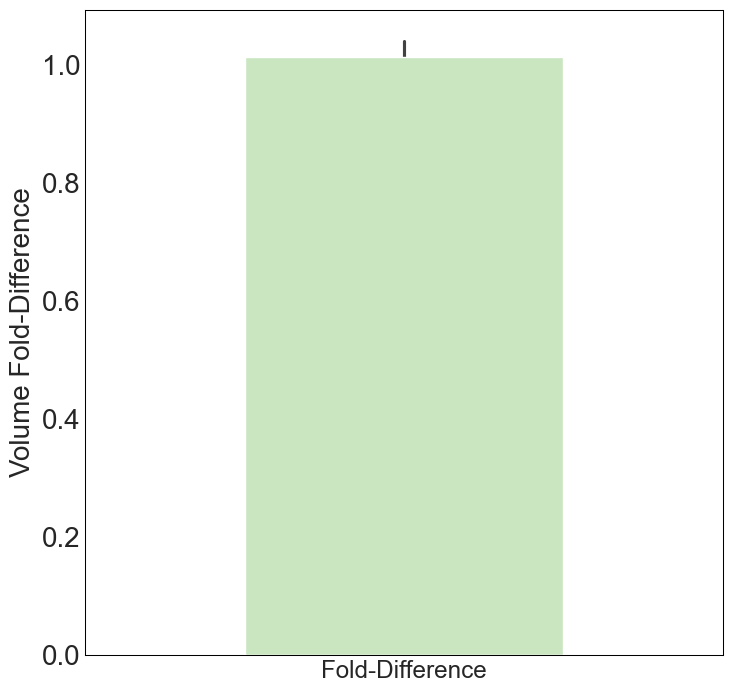

In [333]:
#get number of NPs inside cells that are either i) free floating or ii) within vesicles
    # this is only inside of ECs since the column for 'cell-lowest-EDT' only considers EC cells in the list index_keep_ECs
 
NP_per_ml = pd.DataFrame(
    {'Fold-Difference': volume_fold_difference_confocal_over_EM, 
     }
)

#change height and width of dataset
    #need to set these parameters before creating the plot
ax = plt.figure(figsize=(4.7,4.7))

sns.set_theme(style='white')
#sns.despine()

ax = sns.catplot(data=NP_per_ml,kind='bar',color='gray', width=0.5, height =7,aspect = 1, zorder=5)


#turn off grid
#sns.set_style("whitegrid", {'axes.grid' : False})
sns.set_style("whitegrid", )

#add border here, see: https://stackoverflow.com/questions/62375119/how-to-add-a-border-or-frame-around-a-figure-and-subplots
for ax in ax.axes.flat:
    #ax.bar_label(ax.containers[0],fontsize=17.5)
    #ax.patch.set_linewidth(1.5)
    ax.patch.set_edgecolor('black')

#plt.xlabel('',fontsize=20)
plt.ylabel('Volume Fold-Difference',fontsize=20)
#plt.ticklabel_format()
plt.xticks(fontsize=17.5)
plt.yticks(fontsize=20)

#change formatting and add superscript to top. replace with nothing except for 0 needs to be reformatted so replace e+00 for that y-tick-val
#y_ticks = ax.axes.get_yticks()
#ylabels = [( '{:,.1f}'.format(y/1e5)).replace(".0","") for y in y_ticks]
#ax.set_yticklabels(ylabels)                 

#add exponent multiplier to the top using ax.text
#ax.text(0, 1.01, "1E+5",transform=ax.transAxes, fontsize=15)

    
#change colours for each plot

#palette = ["#8de5a1", "#cfcfcf"] #pastel green and pastel gray. used Firefox eyedropper to get hexadecimal. Use pastel red for nanoparticle distance
palette = ["#c9e6c0"]

for bars, colors in zip(ax.containers, (palette[0::1], palette[0::2], palette[0::3], )):
    for bar, color in zip(bars, colors):
        bar.set_facecolor(color)

#use values instead of base 10 for x-axis
    #see: https://stackoverflow.com/questions/46735745/how-to-control-scientific-notation-in-matplotlib
from matplotlib.ticker import ScalarFormatter, StrMethodFormatter, NullFormatter
#plt.gca().yaxis.set_major_formatter(log) 
#plt.gca().xaxis.set_minor_formatter(ScalarFormatter());   # <---- OK

#use scientific notation
    #see: https://stackoverflow.com/questions/69979990/scientific-notation-on-seaborn-catplot-facetgrid-axes
#plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}')) 
#plt.ticklabel_format(axis="y", style="sci", scilimits=(12,12))

#render figure text as font rather than path
plt.rcParams['svg.fonttype'] = 'none'

sns.despine()

#see for iterating over all spines: https://community.dataquest.io/t/iterate-over-ax-spines-items-and-related-functions/233432/
for key,spine in ax.spines.items():
    spine.set_zorder(0)
    spine.set_visible(True)
    spine.set_color('#000000')
    spine.set_linewidth(0.75)


#export figure as svg for illustrator figure
#plt.savefig("number-of-NPs_2DEM-3DEM-ICPMS.svg", format="svg", bbox_inches='tight')
plt.savefig("number-of-NPs_2DEM-3DEM-ICPMS_v2.svg", format="svg", bbox_inches='tight')

    
#display histogram
plt.show()

In [283]:
#save dataframe of cell volumes with 3D EM and 3D confocal

cell_volumes_3DEM = [cell_1_3DEM_sum,cell_2_3DEM_sum,cell_3_3DEM_sum]
cell_volumes_confocal = [cell_1_confocal_sum,cell_2_confocal_sum,cell_3_confocal_sum]

in_vitro_SA_volume = pd.DataFrame(
    {'3D EM Cell Volume': cell_volumes_3DEM,
     '3D Confocal Cell Volume': cell_volumes_confocal,
    })
in_vitro_SA_volume

#save dataframe
#comment out to prevent ovewrite
#in_vitro_SA_volume.to_csv('in_vitro_SA-and-volume.csv', index=True)


In [284]:
#read in dataframe
in_vitro_SA_volume = pd.read_csv('in_vitro_SA-and-volume.csv', index_col=0)


#paired t-test

#relative t-test is paired t-test in SciPy
    #see: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_rel.html

t_ttest, p_ttest = scipy.stats.ttest_rel(in_vitro_SA_volume['3D EM Cell Volume'], in_vitro_SA_volume['3D Confocal Cell Volume'])
print("relative/paired t-statistic is: ", t_ttest, ". p-value is: ", p_ttest,)# ". degrees freedom is: ", degrees_freedom_ttest)
#scipy.stats.ttest_ind(a=vesicle_volumes_with_NPs, b=vesicle_volumes_without_NPs, equal_var=False)

#do mann whitney u-test instead because unknown distribution
#see: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html

stat_mwtest, p_mwtest = scipy.stats.mannwhitneyu(x=in_vitro_SA_volume['3D EM Cell Volume'], y=in_vitro_SA_volume['3D Confocal Cell Volume'], method='auto', )
print("mann-whitney-statistic is: ", stat_mwtest, ". p-value is: ", p_mwtest,)# ". degrees freedom is: ", degrees_freedom_ttest)

relative/paired t-statistic is:  -1.0021524241088942 . p-value is:  0.42182215356544184
mann-whitney-statistic is:  4.0 . p-value is:  1.0


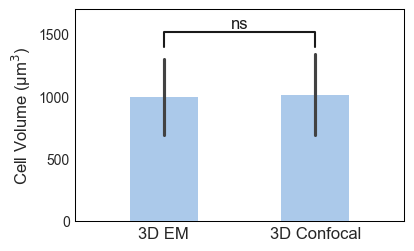

In [334]:
# t-test of 3DEM vs. 3D confocal volumes - um3

#in vitro cell data
x_plot_data = [in_vitro_SA_volume['3D EM Cell Volume'], in_vitro_SA_volume['3D Confocal Cell Volume']]
x_plot_data = np.multiply(x_plot_data, 0.015*0.015*0.070).tolist() #convert from pixels to um3
#*(0.015*0.015*0.070)

#make the tick labels closer to the axes/spine
    #see: https://github.com/matplotlib/matplotlib/issues/17208
mpl.rcParams['xtick.top'] = False
mpl.rcParams['xtick.labeltop'] = False 
mpl.rcParams['xtick.major.pad'] = -2.25
mpl.rcParams['xtick.minor.pad'] = -2.25
mpl.rcParams['ytick.major.pad'] = -2.25
mpl.rcParams['ytick.minor.pad'] = -2.25

#change height and width of dataset
ax = plt.figure(figsize=(4.25,2.75))

sns.set_theme(style='white')
sns.set_style("whitegrid", )
palette_colors = [sns.color_palette("pastel")[0],sns.color_palette("pastel")[0]]
ax = sns.barplot(data=x_plot_data, width = 0.45, palette=palette_colors, errorbar="se",error_kw=dict(linewidth= 1.5, capsize=0),capsize=0) #pastel red

#sns.set_theme(style='white')



#turn off grid
plt.grid(False)

plt.xlabel('',fontsize=12, fontname="Arial")
plt.ylabel('Cell Volume (µm$^3$)',fontsize=12, fontname="Arial")

                 
plt.xticks(fontsize=12)
plt.yticks(fontsize=10)

#rename x axis labels here
labels_for_x_axis = ['3D EM', '3D Confocal'] #use \n for linebreak
ax.set_xticks(range(len(labels_for_x_axis)))
ax.set_xticklabels(labels_for_x_axis, rotation='horizontal', fontname="Arial")

#remove line/border surrounding bar plot
plt.setp(ax.patches, linewidth=0)


#set x and y limits to not span whole width so there is space for scale
#get default  xlim and ylim values to keep consistent between figures
current_xlim_min, current_xlim_max = ax.get_xlim()
current_ylim_min, current_ylim_max = ax.get_ylim()
#print(current_xlim_min, current_xlim_max)
#plt.xlim(current_xlim_min, 1.25) 
plt.ylim(current_ylim_min, 1700)

# statistical annotation
x1, x2 = 0, 1   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = np.mean(x_plot_data[0]) + 100, 100, 'k'

plt.plot([x1, x1, x2, x2], [y+h*3, y+h*4.25, y+h*4.25, y+h*3], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h*4.3, "ns", ha='center', va='bottom', color=col, fontname="Arial")

#turn off frame for figure legend
#plt.legend(title='', loc='upper right', labels=['Vesicles with Nanoparticles','Vesicles without Nanoparticles'],)#frameon=False)

#add margins to put bar charts closer together
plt.margins(x=0.25)

#render figure text as font rather than path
plt.rcParams['svg.fonttype'] = 'none'

#see for iterating over all spines: https://community.dataquest.io/t/iterate-over-ax-spines-items-and-related-functions/233432/
for key,spine in ax.spines.items():
    spine.set_zorder(0)
    spine.set_visible(True)
    spine.set_color('#000000')
    spine.set_linewidth(0.75)



#export figure as svg for illustrator figure
#plt.savefig("3DEM_vs_3DConfocal_vol_ttest.svg", format="svg", bbox_inches='tight')
#plt.savefig("3DEM_vs_3DConfocal_vol_ttest+error.svg", format="svg", bbox_inches='tight')
plt.savefig("3DEM_vs_3DConfocal_vol_ttest+error_v2.svg", format="svg", bbox_inches='tight')



#display histogram
plt.show()


In [266]:
# get the volume of each cell. count the number of each pixel of each label for each cell image.
    #need this for the 2D vs. 3D evaluation benchmark

#doing region props on each slice of dataset (each index of z-dimension), for the list of all the cells in the dataset. 
#note, first need to import all of the cells into the dataset
    
all_dataframes_concat_cell_diameter = pd.DataFrame() #reset dataframe for when doing testing
    
all_dataframes_3D_cells_list = []

list_of_images = [cell_1_3DEM, cell_1_confocal, cell_2_3DEM, cell_2_confocal, cell_3_3DEM, cell_3_confocal]
list_of_images_strings = ["cell_1_3DEM", "cell_1_confocal", "cell_2_3DEM", "cell_2_confocal", "cell_3_3DEM", "cell_3_confocal"]

for count, current_image in enumerate(list_of_images):
    num_z_slices = current_image.shape[0]
    #print(count)
    
#'''
    for z_slice in tqdm(range(num_z_slices)):
        roi_properties = skimage.measure.regionprops_table(label_image=current_image[z_slice, :, :], #added '[frame, :, :]' after annotated
                                                           #intensity_image=dataset[z_slice, :, :],
                                                           properties=(
                                                               'label', 
                                                               'area',
                                                           ),
                                                           separator=",",
                                                           extra_properties=None,)
        dataframe_current_frame = pd.DataFrame(roi_properties)
        dataframe_current_frame['z-slice'] = z_slice
        dataframe_current_frame['label'] = list_of_images_strings[count]
        all_dataframes_3D_cells_list.append(dataframe_current_frame)

all_dataframes_concat_cell_diameter = pd.concat(all_dataframes_3D_cells_list)

#use surface area on each slice to get volume of each label on each slice
all_dataframes_concat_cell_diameter['volume_um3'] = all_dataframes_concat_cell_diameter['area']*(15*15*70)/(1000*1000*1000) #17nm/pixel; 70nm = z depth. 1000nm = 1um. but volume, not length, so cube. 1 nm^2 = 1/(1000*1000*1000) um^3
#'''

100%|███████████████████████████████████████████████████████████████████████████████| 314/314 [00:01<00:00, 256.31it/s]


In [267]:
# add a column for the overall index. 
all_dataframes_concat_cell_diameter.insert(0, 'index_manual', range(len(all_dataframes_concat_cell_diameter)))
all_dataframes_concat_cell_diameter

index_manual            label       area  z-slice  volume_um3
0              0      cell_1_3DEM  1601370.0        0   25.221577
0              1      cell_1_3DEM  1602757.0        1   25.243423
0              2      cell_1_3DEM  1533815.0        2   24.157586
0              3      cell_1_3DEM  1510815.0        3   23.795336
0              4      cell_1_3DEM  1483180.0        4   23.360085
..           ...              ...        ...      ...         ...
0            869  cell_3_confocal    58923.0      173    0.928037
0            870  cell_3_confocal    38976.0      174    0.613872
0            871  cell_3_confocal    23138.0      175    0.364424
0            872  cell_3_confocal    11357.0      176    0.178873
0            873  cell_3_confocal     3658.0      177    0.057613

[874 rows x 5 columns]

In [268]:
#save updated dataframe
#all_dataframes_concat_cell_diameter.to_csv('all_dataframes_concat_cell-confocal-3DEM_vol.csv', index=True)
#comment it out to prevent overwriting file


In [269]:
#import perimeter images here for both 3DEM and confocal

#need to run script to get border of cells

cell_1_3DEM_perimeter = io.imread(r"C:\Users\SM\Desktop\Reviewer-vesicle\CLEM\perimeters;SA\EM-perimeters\Labels_set4_cell_1_elastic_stack-ome_good2_perimeter.tif", plugin="tifffile")
cell_1_confocal_perimeter = io.imread(r"C:\Users\SM\Desktop\Reviewer-vesicle\CLEM\perimeters;SA\confocal-perimeters\cell1-transformed2_perimeter.tif", plugin="tifffile")

cell_2_3DEM_perimeter = io.imread(r"C:\Users\SM\Desktop\Reviewer-vesicle\CLEM\perimeters;SA\EM-perimeters\Labels_set4_cell_2_elastic_stack-ome-v2_perimeter.tif", plugin="tifffile")
cell_2_confocal_perimeter = io.imread(r"C:\Users\SM\Desktop\Reviewer-vesicle\CLEM\perimeters;SA\confocal-perimeters\cell2-transformed-model2_perimeter.tif", plugin="tifffile")

cell_3_3DEM_perimeter = io.imread(r"C:\Users\SM\Desktop\Reviewer-vesicle\CLEM\perimeters;SA\EM-perimeters\Labels_set4_cell_5_elastic_stack-ome_perimeter.tif", plugin="tifffile")
cell_3_confocal_perimeter = io.imread(r"C:\Users\SM\Desktop\Reviewer-vesicle\CLEM\perimeters;SA\confocal-perimeters\cell5-model2_perimeter.tif", plugin="tifffile")



In [270]:
cell_1_3DEM_perimeter_sum = np.sum(cell_1_3DEM_perimeter)
cell_1_confocal_perimeter_sum = np.sum(cell_1_confocal_perimeter)

cell_2_3DEM_perimeter_sum = np.sum(cell_2_3DEM_perimeter)
cell_2_confocal_perimeter_sum = np.sum(cell_2_confocal_perimeter)

cell_3_3DEM_perimeter_sum = np.sum(cell_3_3DEM_perimeter)
cell_3_confocal_perimeter_sum = np.sum(cell_3_confocal_perimeter)

In [287]:
#save dataframe of cell volumes with 3D EM and 3D confocal

cell_SA_3DEM = [cell_1_3DEM_perimeter_sum,cell_2_3DEM_perimeter_sum,cell_3_3DEM_perimeter_sum]
cell_SA_confocal_perimeter = [cell_1_confocal_perimeter_sum,cell_2_confocal_perimeter_sum,cell_3_confocal_perimeter_sum]

in_vitro_SA_volume['3D EM Cell Surface Area'] = cell_SA_3DEM
in_vitro_SA_volume['3D Confocal Cell Surface Area'] = cell_SA_confocal_perimeter

in_vitro_SA_volume

#save dataframe
#comment out to prevent ovewrite
#in_vitro_SA_volume.to_csv('in_vitro_SA-and-volume.csv', index=True)

In [288]:
#read in dataframe
in_vitro_SA_volume = pd.read_csv('in_vitro_SA-and-volume.csv', index_col=0)

#paired t-test

#relative t-test is paired t-test in SciPy
    #see: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_rel.html

t_ttest, p_ttest = scipy.stats.ttest_rel(in_vitro_SA_volume['3D EM Cell Surface Area'], in_vitro_SA_volume['3D Confocal Cell Surface Area'])
print("relative/paired t-statistic is: ", t_ttest, ". p-value is: ", p_ttest,)# ". degrees freedom is: ", degrees_freedom_ttest)
#scipy.stats.ttest_ind(a=vesicle_volumes_with_NPs, b=vesicle_volumes_without_NPs, equal_var=False)

#do mann whitney u-test instead because unknown distribution
#see: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html

stat_mwtest, p_mwtest = scipy.stats.mannwhitneyu(x=in_vitro_SA_volume['3D EM Cell Surface Area'], y=in_vitro_SA_volume['3D Confocal Cell Surface Area'], method='auto', )
print("mann-whitney-statistic is: ", stat_mwtest, ". p-value is: ", p_mwtest,)# ". degrees freedom is: ", degrees_freedom_ttest)

relative/paired t-statistic is:  3.997949103864185 . p-value is:  0.05724470636438197
mann-whitney-statistic is:  7.0 . p-value is:  0.4


<Figure size 700x700 with 0 Axes>

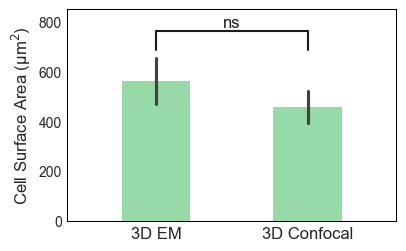

In [335]:
# t-test of 3DEM vs. 3D confocal surface area - um2


#in vitro cell data
x_plot_data = [in_vitro_SA_volume['3D EM Cell Surface Area'], in_vitro_SA_volume['3D Confocal Cell Surface Area']]
x_plot_data = np.multiply(x_plot_data, 0.070*0.015).tolist() #to convert pixels to um
#*(0.015*0.015*0.070)
plt.figure() #this creates a new figure on which your plot will appear


#make the tick labels closer to the axes/spine
    #see: https://github.com/matplotlib/matplotlib/issues/17208
mpl.rcParams['xtick.top'] = False
mpl.rcParams['xtick.labeltop'] = False 
mpl.rcParams['xtick.major.pad'] = -2.25
mpl.rcParams['xtick.minor.pad'] = -2.25
mpl.rcParams['ytick.major.pad'] = -2.25
mpl.rcParams['ytick.minor.pad'] = -2.25

#change height and width of dataset
ax = plt.figure(figsize=(4.25,2.75))

ax = sns.set_style("whitegrid")
sns.set_theme(style='white')
#sns.despine()


palette_colors = [sns.color_palette("pastel")[2],sns.color_palette("pastel")[2]]
ax = sns.barplot(data=x_plot_data, width=0.45, palette=palette_colors, errorbar="se", error_kw=dict(linewidth= 1.5, capsize=0, lw=1.5),capsize=0,lw= 1.5) #pastel red
#ax = sns.boxplot(data=[cell_SA_3DEM,cell_SA_confocal_perimeter],palette=palette_colors,) #pastel red
#ax = sns.pointplot(data=x_plot_data, palette=palette_colors, errorbar="se" ) #pastel red

#turn off grid
plt.grid(False)

plt.xlabel('',fontsize=12, fontname="Arial")
plt.ylabel('Cell Surface Area (µm$^2$)',fontsize=12, fontname="Arial")
                
plt.xticks(fontsize=12, fontname="Arial")
plt.yticks(fontsize=10, fontname="Arial")

#remove line/border surrounding bar plot
plt.setp(ax.patches, linewidth=0)


#set x and y limits to not span whole width so there is space for scale
#get default  xlim and ylim values to keep consistent between figures
current_xlim_min, current_xlim_max = ax.get_xlim()
current_ylim_min, current_ylim_max = ax.get_ylim()
#print(current_xlim_min, current_xlim_max)
#plt.xlim(current_xlim_min, 1.25) 
plt.ylim(current_ylim_min, 850)


#rename x axis labels here
labels_for_x_axis = ['3D EM', '3D Confocal'] #use \n for linebreak
ax.set_xticks(range(len(labels_for_x_axis)))
ax.set_xticklabels(labels_for_x_axis, rotation='horizontal')


# statistical annotation
x1, x2 = 0, 1   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = np.mean(x_plot_data[0]) + 25, 25, 'k'

plt.plot([x1, x1, x2, x2], [y+h*4, y+h*7, y+h*7, y+h*4], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h*7.1, "ns", ha='center', va='bottom', color=col)

#plt.plot([x1, x1, x2, x2], [y+h*3, y+h*4.25, y+h*4.25, y+h*3], lw=1.5, c=col)
#plt.text((x1+x2)*.5, y+h*4.3, "ns", ha='center', va='bottom', color=col, fontname="Arial")


#turn off frame for figure legend
#plt.legend(title='', loc='upper right', labels=['Vesicles with Nanoparticles','Vesicles without Nanoparticles'],)#frameon=False)

#render figure text as font rather than path
plt.rcParams['svg.fonttype'] = 'none'

#add margins to put bar charts closer together
plt.margins(x=0.25)


#see for iterating over all spines: https://community.dataquest.io/t/iterate-over-ax-spines-items-and-related-functions/233432/
for key,spine in ax.spines.items():
    spine.set_zorder(0)
    spine.set_visible(True)
    spine.set_color('#000000')
    spine.set_linewidth(0.75)


#export figure as svg for illustrator figure
#plt.savefig("3DEM_vs_3DConfocal_SA_ttest.svg", format="svg", bbox_inches='tight')
#plt.savefig("3DEM_vs_3DConfocal_SA_ttest+error.svg", format="svg", bbox_inches='tight')
plt.savefig("3DEM_vs_3DConfocal_SA_ttest+error_v2.svg", format="svg", bbox_inches='tight')



#display histogram
plt.show()


In [127]:
#read in current cell volume CSV for each slice
all_dataframes_concat_cell_diameter = pd.read_csv('all_dataframes_concat_cell-confocal-3DEM_vol.csv', index_col=0)
all_dataframes_concat_cell_diameter

index_manual            label       area  z-slice  volume_um3
0              0      cell_1_3DEM  1601370.0        0   25.221577
0              1      cell_1_3DEM  1602757.0        1   25.243423
0              2      cell_1_3DEM  1533815.0        2   24.157586
0              3      cell_1_3DEM  1510815.0        3   23.795336
0              4      cell_1_3DEM  1483180.0        4   23.360085
..           ...              ...        ...      ...         ...
0            869  cell_3_confocal    58923.0      173    0.928037
0            870  cell_3_confocal    38976.0      174    0.613872
0            871  cell_3_confocal    23138.0      175    0.364424
0            872  cell_3_confocal    11357.0      176    0.178873
0            873  cell_3_confocal     3658.0      177    0.057613

[874 rows x 5 columns]

In [56]:
#DOING SURFACE AREA HERE BY USING THE PERIMETER FILE (ALL CELLS)

all_dataframes_concat_cell_diameter = all_dataframes_concat_cell_diameter.reindex(columns = all_dataframes_concat_cell_diameter.columns.tolist() + ['surface_area','surface_area_um2'])
 
from skimage.measure import label 
    
#num_z_slices = annotated_perimeter.shape[0] #use annotated_perimeter instead of annotated


list_of_images_perimeter = [cell_1_3DEM_perimeter, cell_1_confocal_perimeter, cell_2_3DEM_perimeter, cell_2_confocal_perimeter, cell_3_3DEM_perimeter, cell_3_confocal_perimeter]
#list_of_images_strings_perimeter = ["cell_1_3DEM_perimeter", "cell_1_confocal_perimeter", "cell_2_3DEM_perimeter", "cell_2_confocal_perimeter", "cell_3_3DEM_perimeter", "cell_3_confocal"]
list_of_images_strings = ["cell_1_3DEM", "cell_1_confocal", "cell_2_3DEM", "cell_2_confocal", "cell_3_3DEM", "cell_3_confocal"]

for count_perimeter, current_image_perimeter in enumerate(list_of_images_perimeter):
    #num_z_slices = current_image_perimeter.shape[0]
    #print(count_perimeter)

    #set annotated_perimeter to the current perimeter image from the group of images
    annotated_perimeter = current_image_perimeter

    #dataframe relevant to current image
    relevant_dataframe = all_dataframes_concat_cell_diameter.loc[all_dataframes_concat_cell_diameter['label'] == list_of_images_strings[count_perimeter]]

    print(count_perimeter, list_of_images_strings[count_perimeter])
    print()
    print()

    
    #need to update range to go from start of relevant dataframe to end of relevant dataframe, not for each row
        #need to go from min to max+1 to capture the relevant range of data. pixel values are correct as verified in FIJI
            #FIJI. Threshold --> Create Selection --> Measure (make sure the scale is not active to check pixel values). 
    for each_row_count, each_row in tqdm(enumerate(range(relevant_dataframe['index_manual'].min(),relevant_dataframe['index_manual'].max()+1))):
        #print(each_row_count, each_row)
        
        #set regionmask to be the current slice of perimeter_annotated dataset
        regionmask = annotated_perimeter[relevant_dataframe['z-slice'].iloc[each_row_count].astype(int)] #need to put astype int, otherwise turns to float at index 27
        #print(all_dataframes_concat_cell_diameter['z-slice'].iloc[each_row].astype(int))
        
        
        
        #do not need below section because there is only one label per image. the value of the label is always 1. indented it, but originally is not indented.
        # instead, just use regionmask instead of regionmask_current for the roi_surface_area skimage part
            #make empty regionmask with dimensions of first slice of array (all x/y dimensions of array are the same for the whole array)
            #regionmask_current = np.zeros(annotated_perimeter[0].shape, dtype=np.uint8)
    
            #get the current label of the row
            #current_label = relevant_dataframe['label'].iloc[each_row].astype(int)
            #print(all_dataframes_concat_cell_diameter['label'])
            #print(each_row)
        
            # set value to 1 for indices/places where regionmask == current label
            #np.place(regionmask_current, regionmask == current_label, 1)
        
        
        # DO NOT GET THE CONNECTED COMPONENT. WE WANT THE SA OF ALL PIECES OF THE PERIMETER ON EACH SLICE
        #get the largest connected component (CC) for the current label on the current slice
        #labels = label(regionmask_current)
    
    
        roi_surface_area = skimage.measure.regionprops_table(
                                                        label_image=regionmask, #added '[frame, :, :]' after annotated
                                                        #intensity_image=dataset[z_slice, :, :],
                                                        properties=(
                                                            'area',
                                                        ),
                                                        separator=",",
                                                        extra_properties=None,
                                                        )
    
            
    
        #catch errors when there is no surface area
        if len(roi_surface_area['area']) >0:
            print(each_row, roi_surface_area['area'], len(roi_surface_area['area']))
            all_dataframes_concat_cell_diameter.iloc[each_row,relevant_dataframe.columns.get_loc('surface_area')] = roi_surface_area['area'][0]
            all_dataframes_concat_cell_diameter.iloc[each_row,relevant_dataframe.columns.get_loc('surface_area_um2')] = roi_surface_area['area'][0]*(17*70)/(1000*1000) #17nm/pixel; 70nm = z depth. 1000nm = 1um. but surface area, not length, so square. 1 nm^2 = 1/(1000*1000) um^2
        #set value to 0 if there is an error
        else:
            print("error: ", each_row, roi_surface_area['area'], len(roi_surface_area['area']))
            all_dataframes_concat_cell_diameter.iloc[each_row,relevant_dataframe.columns.get_loc('surface_area')] = 0
            all_dataframes_concat_cell_diameter.iloc[each_row,relevant_dataframe.columns.get_loc('surface_area_um2')] = 0    
        
        #just use loc with index_manual as index_manual are unique

    #print()
    #print(relevant_dataframe) #nothing will appear here since we are not storing values into 'relevant_dataframe', but rather 'all_dataframes_concat_cell_diameter'
    #print()
    


0 cell_1_3DEM




7it [00:00, 63.76it/s]

0 [9112.] 1
1 [9197.] 1
2 [9504.] 1
3 [9338.] 1
4 [8871.] 1
5 [8166.] 1
6 [7998.] 1
7 [8128.] 1
8 [8181.] 1
9 [7848.] 1
10 [7619.] 1
11 [7632.] 1


28it [00:00, 67.69it/s]

12 [7149.] 1
13 [7158.] 1
14 [7022.] 1
15 [6902.] 1
16 [7280.] 1
17 [7132.] 1
18 [7207.] 1
19 [7184.] 1
20 [7319.] 1
21 [7181.] 1
22 [7165.] 1
23 [6924.] 1
24 [6821.] 1
25 [7008.] 1
26 [6856.] 1
27 [6763.] 1


36it [00:00, 71.95it/s]

28 [6873.] 1
29 [6794.] 1
30 [6760.] 1
31 [6546.] 1
32 [6657.] 1
33 [6725.] 1
34 [6654.] 1
35 [6567.] 1
36 [6501.] 1
37 [6449.] 1
38 [6391.] 1
39 [6342.] 1
40 [6306.] 1


52it [00:00, 70.50it/s]

41 [6284.] 1
42 [6286.] 1
43 [6318.] 1
44 [6251.] 1
45 [6214.] 1
46 [6190.] 1
47 [6174.] 1
48 [6207.] 1
49 [6274.] 1
50 [6276.] 1
51 [6313.] 1
52 [6034.] 1
53 [5762.] 1
54 [5513.] 1
55 [5314.] 1


68it [00:00, 71.76it/s]

56 [5321.] 1
57 [5337.] 1
58 [5481.] 1
59 [5310.] 1
60 [5278.] 1
61 [5266.] 1
62 [5258.] 1
63 [5270.] 1
64 [5319.] 1
65 [5436.] 1
66 [5238.] 1
67 [5119.] 1
68 [5020.] 1
69 [4937.] 1
70 [4882.] 1


85it [00:01, 75.13it/s]

71 [4837.] 1
72 [4832.] 1
73 [4548.] 1
74 [4350.] 1
75 [4302.] 1
76 [4213.] 1
77 [4182.] 1
78 [4160.] 1
79 [4429.] 1
80 [4610.] 1
81 [4592.] 1
82 [4520.] 1
83 [4470.] 1
84 [4412.] 1
85 [4357.] 1


101it [00:01, 73.97it/s]

86 [4302.] 1
87 [4252.] 1
88 [4194.] 1
89 [4154.] 1
90 [4130.] 1
91 [4024.] 1
92 [3935.] 1
93 [3855.] 1
94 [3791.] 1
95 [3745.] 1
96 [3710.] 1
97 [3665.] 1
98 [3648.] 1
99 [3432.] 1
100 [3244.] 1


110it [00:01, 76.18it/s]

101 [3162.] 1
102 [3028.] 1
103 [3125.] 1
104 [3192.] 1
105 [2919.] 1
106 [2606.] 1
107 [2529.] 1
108 [2093.] 1
109 [2094.] 1
110 [1933.] 1
111 [2049.] 1
112 [1821.] 1
113 [1762.] 1
114 [1467.] 1
115 [1377.] 1


126it [00:01, 72.34it/s]


116 [1231.] 1
117 [1014.] 1
118 [892.] 1
119 [772.] 1
120 [656.] 1
121 [534.] 1
122 [414.] 1
123 [294.] 1
124 [181.] 1
125 [68.] 1
1 cell_1_confocal




0it [00:00, ?it/s]

126 [10270.] 1
127 [9924.] 1
128 [9625.] 1
129 [9368.] 1
130 [9154.] 1


7it [00:00, 69.43it/s]

131 [8972.] 1
132 [8825.] 1
133 [8713.] 1
134 [8625.] 1
135 [8634.] 1
136 [8357.] 1
137 [8143.] 1
138 [7945.] 1
139 [7786.] 1


15it [00:00, 71.26it/s]

140 [7626.] 1
141 [7478.] 1
142 [7356.] 1
143 [7258.] 1
144 [7532.] 1
145 [7050.] 1
146 [6692.] 1


31it [00:00, 74.68it/s]

147 [6623.] 1
148 [6466.] 1
149 [6277.] 1
150 [6172.] 1
151 [6144.] 1
152 [6068.] 1
153 [6092.] 1
154 [5970.] 1
155 [5977.] 1
156 [5754.] 1
157 [5664.] 1
158 [5567.] 1
159 [5384.] 1
160 [5413.] 1
161 [5403.] 1
162 [5345.] 1
163 [5280.] 1


39it [00:00, 76.28it/s]

164 [5212.] 1
165 [5205.] 1
166 [5184.] 1
167 [5190.] 1
168 [5140.] 1
169 [5094.] 1
170 [5050.] 1
171 [5004.] 1
172 [4962.] 1


48it [00:00, 78.07it/s]

173 [4834.] 1
174 [4791.] 1
175 [4806.] 1
176 [4783.] 1
177 [4658.] 1
178 [4621.] 1


65it [00:00, 80.32it/s]

179 [4670.] 1
180 [4714.] 1
181 [4676.] 1
182 [4628.] 1
183 [4636.] 1
184 [4584.] 1
185 [4534.] 1
186 [4446.] 1
187 [4408.] 1
188 [4374.] 1
189 [4338.] 1
190 [4300.] 1
191 [4266.] 1
192 [4228.] 1
193 [4192.] 1
194 [4158.] 1
195 [4128.] 1
196 [4029.] 1


74it [00:00, 78.55it/s]

197 [3937.] 1
198 [3846.] 1
199 [3757.] 1
200 [3669.] 1
201 [3580.] 1
202 [3495.] 1
203 [3413.] 1
204 [3331.] 1
205 [3248.] 1


82it [00:01, 78.90it/s]

206 [3167.] 1
207 [3086.] 1
208 [2988.] 1
209 [2892.] 1
210 [2794.] 1
211 [2698.] 1
212 [2602.] 1
213 [2506.] 1


91it [00:01, 81.03it/s]

214 [2412.] 1
215 [2316.] 1
216 [2222.] 1
217 [2126.] 1
218 [1994.] 1
219 [1862.] 1
220 [1732.] 1
221 [1602.] 1
222 [1470.] 1


100it [00:01, 82.37it/s]

223 [1338.] 1
224 [1196.] 1
225 [1052.] 1
226 [910.] 1
227 [766.] 1
228 [624.] 1
229 [572.] 1
230 [518.] 1
231 [464.] 1
232 [410.] 1


108it [00:01, 79.05it/s]


233 [358.] 1
2 cell_2_3DEM




0it [00:00, ?it/s]

234 [3358.] 1
235 [3218.] 1
236 [3122.] 1
237 [3061.] 1
238 [3034.] 1
239 [3070.] 1
240 [3168.] 1


16it [00:00, 76.27it/s]

241 [3058.] 1
242 [3181.] 1
243 [3154.] 1
244 [3554.] 1
245 [3237.] 1
246 [3057.] 1
247 [2991.] 1
248 [3115.] 1
249 [3361.] 1
250 [3063.] 1
251 [3014.] 1
252 [3136.] 1
253 [3492.] 1
254 [3834.] 1
255 [3509.] 1
256 [3398.] 1


24it [00:00, 75.36it/s]

257 [3507.] 1
258 [3765.] 1
259 [4788.] 1
260 [4209.] 1
261 [3989.] 1
262 [4072.] 1
263 [4072.] 1
264 [4176.] 1


32it [00:00, 72.33it/s]

265 [4719.] 1
266 [4183.] 1
267 [3775.] 1
268 [3019.] 1
269 [2908.] 1
270 [3092.] 1
271 [2762.] 1


40it [00:00, 71.61it/s]

272 [2696.] 1
273 [2657.] 1
274 [2748.] 1
275 [3496.] 1
276 [3839.] 1
277 [3518.] 1
278 [3441.] 1


48it [00:00, 70.59it/s]

279 [3211.] 1
280 [3479.] 1
281 [3816.] 1
282 [4424.] 1
283 [4124.] 1
284 [3656.] 1
285 [3370.] 1
286 [3699.] 1
287 [3937.] 1


56it [00:00, 72.07it/s]

288 [4077.] 1
289 [4692.] 1
290 [3912.] 1
291 [3674.] 1
292 [3467.] 1


64it [00:00, 72.43it/s]

293 [3748.] 1
294 [4153.] 1
295 [4923.] 1
296 [4173.] 1
297 [3873.] 1
298 [3818.] 1
299 [4049.] 1
300 [4486.] 1
301 [3737.] 1
302 [3683.] 1


72it [00:00, 72.55it/s]

303 [3328.] 1
304 [3856.] 1
305 [4542.] 1
306 [3993.] 1
307 [3687.] 1
308 [3517.] 1


80it [00:01, 72.67it/s]

309 [3603.] 1
310 [3868.] 1
311 [4394.] 1
312 [3979.] 1
313 [3774.] 1
314 [3636.] 1
315 [3536.] 1
316 [3524.] 1
317 [3596.] 1


89it [00:01, 73.67it/s]

318 [3675.] 1
319 [4011.] 1
320 [3578.] 1
321 [3360.] 1
322 [3309.] 1


97it [00:01, 75.20it/s]

323 [3422.] 1
324 [3668.] 1
325 [4164.] 1
326 [3780.] 1
327 [3596.] 1
328 [3535.] 1
329 [3394.] 1
330 [3475.] 1
331 [3598.] 1
332 [3771.] 1
333 [3927.] 1
334 [4153.] 1
335 [3791.] 1
336 [3738.] 1
337 [3443.] 1


114it [00:01, 76.77it/s]

338 [3403.] 1
339 [3510.] 1
340 [3661.] 1
341 [3962.] 1
342 [3658.] 1
343 [3518.] 1
344 [3406.] 1
345 [3392.] 1
346 [3460.] 1
347 [3584.] 1
348 [3764.] 1
349 [3569.] 1
350 [3472.] 1
351 [3364.] 1
352 [3366.] 1
353 [3357.] 1


130it [00:01, 74.77it/s]

354 [3262.] 1
355 [3319.] 1
356 [3365.] 1
357 [3471.] 1
358 [3658.] 1
359 [3437.] 1
360 [3403.] 1
361 [3352.] 1
362 [3502.] 1
363 [3663.] 1
364 [3594.] 1
365 [3776.] 1
366 [4028.] 1
367 [3566.] 1
368 [3632.] 1


138it [00:01, 74.21it/s]

369 [3844.] 1
370 [3753.] 1
371 [4378.] 1
372 [3752.] 1
373 [3339.] 1
374 [3343.] 1
375 [3882.] 1
376 [4124.] 1
377 [3582.] 1
378 [3364.] 1


147it [00:01, 76.55it/s]

379 [3672.] 1
380 [4080.] 1
381 [3469.] 1
382 [3152.] 1
383 [2646.] 1


155it [00:02, 75.45it/s]

384 [2695.] 1
385 [2902.] 1
386 [2717.] 1
387 [2594.] 1
388 [2497.] 1
389 [2444.] 1
390 [2423.] 1
391 [2740.] 1
392 [2944.] 1
393 [3168.] 1


163it [00:02, 74.68it/s]

394 [2780.] 1
395 [2450.] 1
396 [2191.] 1
397 [2026.] 1
398 [2165.] 1
399 [2329.] 1


172it [00:02, 76.88it/s]

400 [2618.] 1
401 [2258.] 1
402 [1976.] 1
403 [1814.] 1
404 [1833.] 1
405 [1998.] 1
406 [1725.] 1
407 [1862.] 1
408 [1527.] 1
409 [1217.] 1


180it [00:02, 74.96it/s]

410 [910.] 1
411 [635.] 1
412 [436.] 1
413 [390.] 1
414 [359.] 1
415 [338.] 1


188it [00:02, 76.33it/s]

416 [320.] 1
417 [302.] 1
418 [290.] 1
419 [278.] 1
420 [249.] 1
421 [226.] 1
422 [213.] 1
423 [198.] 1
424 [184.] 1


192it [00:02, 74.57it/s]


425 [172.] 1
3 cell_2_confocal




0it [00:00, ?it/s]

426 [126.] 1
427 [158.] 1
428 [188.] 1
429 [222.] 1
430 [254.] 1
431 [429.] 1
432 [601.] 1
433 [779.] 1
434 [960.] 1
435 [1148.] 1
436 [1336.] 1
437 [1512.] 1
438 [1700.] 1
439 [2018.] 1
440 [2247.] 1
441 [2452.] 1
442 [2516.] 1
443 [2664.] 1
444 [2565.] 1
445 [2541.] 1


29it [00:00, 265.38it/s]

446 [2573.] 1
447 [2655.] 1
448 [2765.] 1
449 [2900.] 1
450 [2714.] 1
451 [2735.] 1
452 [2667.] 1
453 [2632.] 1
454 [2631.] 1
455 [2657.] 1
456 [2693.] 1
457 [2754.] 1
458 [2672.] 1
459 [2601.] 1
460 [2538.] 1
461 [2470.] 1
462 [2415.] 1
463 [2363.] 1
464 [2320.] 1
465 [2286.] 1
466 [2262.] 1
467 [2299.] 1
468 [2327.] 1
469 [2365.] 1
470 [2399.] 1
471 [2430.] 1
472 [2466.] 1
473 [2508.] 1
474 [2660.] 1
475 [2692.] 1
476 [2726.] 1
477 [2764.] 1
478 [2866.] 1


58it [00:00, 264.68it/s]

479 [2871.] 1
480 [2881.] 1
481 [2893.] 1
482 [2943.] 1
483 [2980.] 1
484 [3017.] 1
485 [3021.] 1
486 [3032.] 1
487 [3083.] 1
488 [3111.] 1
489 [3147.] 1
490 [3176.] 1
491 [3185.] 1
492 [3180.] 1
493 [3245.] 1
494 [3310.] 1
495 [3328.] 1
496 [3356.] 1
497 [3359.] 1
498 [3365.] 1
499 [3372.] 1


87it [00:00, 264.18it/s]

500 [3380.] 1
501 [3389.] 1
502 [3400.] 1
503 [3396.] 1
504 [3411.] 1
505 [3378.] 1
506 [3345.] 1
507 [3331.] 1
508 [3268.] 1
509 [3239.] 1
510 [3222.] 1
511 [3222.] 1
512 [3229.] 1
513 [3255.] 1
514 [3281.] 1
515 [3274.] 1
516 [3271.] 1
517 [3209.] 1
518 [3187.] 1
519 [3175.] 1
520 [3154.] 1
521 [3137.] 1
522 [3119.] 1
523 [3101.] 1
524 [3086.] 1
525 [3067.] 1
526 [3051.] 1
527 [3033.] 1
528 [3016.] 1
529 [2997.] 1
530 [2981.] 1
531 [2962.] 1
532 [2944.] 1


117it [00:00, 267.77it/s]

533 [2927.] 1
534 [2909.] 1
535 [2894.] 1
536 [2875.] 1
537 [2858.] 1
538 [2839.] 1
539 [2823.] 1
540 [2806.] 1
541 [2787.] 1
542 [2773.] 1
543 [2753.] 1
544 [2740.] 1
545 [2721.] 1
546 [2702.] 1
547 [2686.] 1
548 [2671.] 1
549 [2652.] 1
550 [2638.] 1
551 [2618.] 1
552 [2598.] 1
553 [2588.] 1
554 [2570.] 1


146it [00:00, 267.47it/s]

555 [2548.] 1
556 [2536.] 1
557 [2517.] 1
558 [2502.] 1
559 [2486.] 1
560 [2467.] 1
561 [2450.] 1
562 [2439.] 1
563 [2417.] 1
564 [2403.] 1
565 [2386.] 1
566 [2370.] 1
567 [2354.] 1
568 [2337.] 1
569 [2320.] 1
570 [2303.] 1
571 [2289.] 1
572 [2273.] 1
573 [2256.] 1
574 [2241.] 1
575 [2223.] 1
576 [2208.] 1
577 [2193.] 1
578 [2177.] 1
579 [2161.] 1
580 [2148.] 1
581 [2132.] 1
582 [2120.] 1
583 [2102.] 1
584 [2088.] 1
585 [2073.] 1
586 [2059.] 1
587 [2042.] 1
588 [2033.] 1


174it [00:00, 271.25it/s]

589 [2014.] 1
590 [2001.] 1
591 [1988.] 1
592 [2149.] 1
593 [2367.] 1
594 [2350.] 1
595 [2338.] 1
596 [2318.] 1
597 [2234.] 1
598 [2348.] 1
599 [2368.] 1
600 [2334.] 1
601 [2453.] 1
602 [2496.] 1
603 [2355.] 1
604 [2331.] 1
605 [2289.] 1
606 [2304.] 1
607 [2216.] 1
608 [2161.] 1
609 [2147.] 1


196it [00:00, 271.73it/s]


610 [2051.] 1
611 [2077.] 1
612 [2092.] 1
613 [1690.] 1
614 [1628.] 1
615 [1541.] 1
616 [1444.] 1
617 [1387.] 1
618 [1346.] 1
619 [1224.] 1
620 [592.] 1
621 [230.] 1
4 cell_3_3DEM




0it [00:00, ?it/s]

622 [3160.] 1
623 [3083.] 1
624 [3022.] 1
625 [2974.] 1
626 [2933.] 1
627 [2910.] 1
628 [2906.] 1
629 [2929.] 1
630 [2954.] 1
631 [3016.] 1
632 [2928.] 1


14it [00:00, 127.57it/s]

633 [2875.] 1
634 [2837.] 1
635 [2840.] 1
636 [2874.] 1
637 [2935.] 1
638 [2998.] 1
639 [3108.] 1
640 [3009.] 1
641 [2961.] 1
642 [2937.] 1
643 [2963.] 1
644 [3016.] 1
645 [3095.] 1
646 [3192.] 1
647 [3396.] 1
648 [3184.] 1


30it [00:00, 138.26it/s]

649 [3067.] 1
650 [2958.] 1
651 [2889.] 1
652 [2862.] 1
653 [2884.] 1
654 [2972.] 1
655 [2861.] 1
656 [2806.] 1
657 [2777.] 1
658 [2786.] 1
659 [2818.] 1
660 [2872.] 1
661 [2952.] 1
662 [2878.] 1


46it [00:00, 141.46it/s]

663 [2823.] 1
664 [2798.] 1
665 [2784.] 1
666 [2799.] 1
667 [2852.] 1
668 [2928.] 1
669 [3008.] 1
670 [3176.] 1
671 [3001.] 1
672 [2905.] 1
673 [2853.] 1
674 [2829.] 1
675 [2885.] 1


62it [00:00, 143.16it/s]

676 [2966.] 1
677 [3066.] 1
678 [3274.] 1
679 [3182.] 1
680 [3137.] 1
681 [3125.] 1
682 [3132.] 1
683 [3167.] 1
684 [3211.] 1
685 [3319.] 1
686 [3207.] 1
687 [3157.] 1
688 [3105.] 1
689 [3069.] 1
690 [3049.] 1
691 [3023.] 1


78it [00:00, 144.15it/s]

692 [3030.] 1
693 [3052.] 1
694 [3087.] 1
695 [3138.] 1
696 [3266.] 1
697 [3126.] 1
698 [3085.] 1
699 [3103.] 1
700 [3151.] 1
701 [3228.] 1
702 [3178.] 1
703 [3150.] 1
704 [3119.] 1
705 [3094.] 1


94it [00:00, 144.65it/s]

706 [3096.] 1
707 [3112.] 1
708 [3139.] 1
709 [3210.] 1
710 [3140.] 1
711 [3107.] 1
712 [3108.] 1
713 [3097.] 1
714 [3097.] 1
715 [3114.] 1
716 [3145.] 1
717 [3206.] 1
718 [3084.] 1
719 [2996.] 1
720 [2910.] 1
721 [2848.] 1
722 [2810.] 1
723 [2787.] 1
724 [2788.] 1
725 [2824.] 1
726 [2701.] 1
727 [2599.] 1
728 [2517.] 1


110it [00:00, 145.01it/s]

729 [2509.] 1
730 [2515.] 1
731 [2546.] 1
732 [2605.] 1
733 [2672.] 1
734 [2756.] 1
735 [2669.] 1


127it [00:00, 148.13it/s]

736 [2357.] 1
737 [2062.] 1
738 [1798.] 1
739 [1718.] 1
740 [1698.] 1
741 [1706.] 1
742 [1728.] 1
743 [1494.] 1
744 [1273.] 1
745 [1116.] 1
746 [1006.] 1
747 [868.] 1
748 [727.] 1
749 [604.] 1
750 [488.] 1
751 [378.] 1
752 [244.] 1


132it [00:00, 145.09it/s]


753 [124.] 1
5 cell_3_confocal




0it [00:00, ?it/s]

754 [2778.] 1
755 [2753.] 1
756 [2729.] 1
757 [2711.] 1
758 [2699.] 1
759 [2692.] 1
760 [2677.] 1
761 [2662.] 1
762 [2651.] 1
763 [2636.] 1
764 [2629.] 1
765 [2626.] 1
766 [2620.] 1
767 [2614.] 1
768 [2626.] 1
769 [2635.] 1
770 [2647.] 1
771 [2656.] 1
772 [2667.] 1
773 [2680.] 1
774 [2694.] 1
775 [2713.] 1


26it [00:00, 236.88it/s]

776 [2688.] 1
777 [2685.] 1
778 [2679.] 1
779 [2675.] 1
780 [2674.] 1
781 [2671.] 1
782 [2668.] 1
783 [2672.] 1
784 [2674.] 1
785 [2679.] 1
786 [2680.] 1
787 [2690.] 1
788 [2685.] 1
789 [2708.] 1
790 [2732.] 1
791 [2762.] 1
792 [2794.] 1
793 [2829.] 1
794 [2864.] 1
795 [2906.] 1
796 [2898.] 1
797 [2904.] 1
798 [2904.] 1
799 [2922.] 1
800 [2936.] 1
801 [2964.] 1
802 [2988.] 1


54it [00:00, 246.59it/s]

803 [2969.] 1
804 [2962.] 1
805 [2951.] 1
806 [2944.] 1
807 [2954.] 1
808 [2964.] 1
809 [2978.] 1
810 [2998.] 1
811 [2980.] 1
812 [2953.] 1
813 [2956.] 1
814 [2960.] 1
815 [3007.] 1
816 [3003.] 1
817 [3048.] 1
818 [3024.] 1
819 [3013.] 1
820 [3002.] 1
821 [3007.] 1
822 [3018.] 1
823 [3031.] 1
824 [3056.] 1
825 [3013.] 1
826 [2984.] 1


82it [00:00, 250.47it/s]

827 [2961.] 1
828 [2946.] 1
829 [2937.] 1
830 [2945.] 1
831 [2958.] 1
832 [2921.] 1
833 [2902.] 1
834 [2895.] 1
835 [2892.] 1
836 [2896.] 1
837 [2917.] 1
838 [2964.] 1
839 [2892.] 1
840 [2835.] 1
841 [2801.] 1
842 [2776.] 1
843 [2746.] 1
844 [2722.] 1
845 [2713.] 1
846 [2720.] 1
847 [2629.] 1
848 [2550.] 1
849 [2474.] 1
850 [2406.] 1
851 [2338.] 1
852 [2271.] 1
853 [2210.] 1
854 [2158.] 1


110it [00:00, 252.29it/s]

855 [2106.] 1
856 [2056.] 1
857 [2006.] 1
858 [1962.] 1
859 [1920.] 1
860 [1884.] 1
861 [1870.] 1
862 [1861.] 1
863 [1850.] 1


120it [00:00, 254.75it/s]

864 [1841.] 1
865 [1835.] 1
866 [1832.] 1
867 [1603.] 1
868 [1380.] 1
869 [1158.] 1
870 [933.] 1
871 [711.] 1
872 [490.] 1
873 [270.] 1


In [57]:
#save updated dataframe
#all_dataframes_concat_cell_diameter.to_csv('all_dataframes_concat_cell-confocal-3DEM_vol+SA.csv', index=True)
#comment it out to prevent overwriting file

In [237]:
#read in current cell volume+SA CSV
all_dataframes_concat_cell_vol_SA_diameter = pd.read_csv('all_dataframes_concat_cell-confocal-3DEM_vol+SA.csv', index_col=0)
all_dataframes_concat_cell_vol_SA_diameter

index_manual            label       area  z-slice  volume_um3  \
0              0      cell_1_3DEM  1601370.0        0   25.221577   
0              1      cell_1_3DEM  1602757.0        1   25.243423   
0              2      cell_1_3DEM  1533815.0        2   24.157586   
0              3      cell_1_3DEM  1510815.0        3   23.795336   
0              4      cell_1_3DEM  1483180.0        4   23.360085   
..           ...              ...        ...      ...         ...   
0            869  cell_3_confocal    58923.0      173    0.928037   
0            870  cell_3_confocal    38976.0      174    0.613872   
0            871  cell_3_confocal    23138.0      175    0.364424   
0            872  cell_3_confocal    11357.0      176    0.178873   
0            873  cell_3_confocal     3658.0      177    0.057613   

    surface_area  surface_area_um2  
0         9112.0          10.84328  
0         9197.0          10.94443  
0         9504.0          11.30976  
0         9338.0          11.11222  
0         8871.0          10.55649  
..           ...               ...  
0         1158.0           1.37802  
0          933.0           1.11027  
0          711.0           0.84609  
0          490.0           0.58310  
0          270.0           0.32130  

[874 rows x 7 columns]

In [238]:
#make a copy of the imported dataframe
all_dataframes_concat_cell_vol_SA_diameter_updated = all_dataframes_concat_cell_vol_SA_diameter.copy()

list_of_images_perimeter = [cell_1_3DEM_perimeter, cell_1_confocal_perimeter, cell_2_3DEM_perimeter, cell_2_confocal_perimeter, cell_3_3DEM_perimeter, cell_3_confocal_perimeter]
list_of_images_strings = ["cell_1_3DEM", "cell_1_confocal", "cell_2_3DEM", "cell_2_confocal", "cell_3_3DEM", "cell_3_confocal"]

for count_perimeter, current_image_perimeter in enumerate(list_of_images_perimeter):
    #print(count_perimeter)

    #dataframe relevant to current image
    relevant_dataframe = all_dataframes_concat_cell_vol_SA_diameter_updated.loc[all_dataframes_concat_cell_vol_SA_diameter_updated['label'] == list_of_images_strings[count_perimeter]]
    first_row_for_relevant_dataframe = relevant_dataframe.iloc[0]['index_manual'] #first row is iloc = 0
    last_row_for_relevant_dataframe = relevant_dataframe.iloc[-1]['index_manual'] # last row is iloc = -1

    #update the first row of SA and SA_um2 to be equal to the area, since the SA of the edges are equal to the area.
    all_dataframes_concat_cell_vol_SA_diameter_updated.iloc[first_row_for_relevant_dataframe,relevant_dataframe.columns.get_loc('surface_area')] = all_dataframes_concat_cell_vol_SA_diameter_updated.iloc[first_row_for_relevant_dataframe,relevant_dataframe.columns.get_loc('area')]
    all_dataframes_concat_cell_vol_SA_diameter_updated.iloc[first_row_for_relevant_dataframe,relevant_dataframe.columns.get_loc('surface_area_um2')] = all_dataframes_concat_cell_vol_SA_diameter_updated.iloc[first_row_for_relevant_dataframe,relevant_dataframe.columns.get_loc('volume_um3')]

    #update the last row of SA and SA_um2 to be equal to the area, since the SA of the edges are equal to the area
    all_dataframes_concat_cell_vol_SA_diameter_updated.iloc[last_row_for_relevant_dataframe,relevant_dataframe.columns.get_loc('surface_area')] = all_dataframes_concat_cell_vol_SA_diameter_updated.iloc[last_row_for_relevant_dataframe,relevant_dataframe.columns.get_loc('area')]
    all_dataframes_concat_cell_vol_SA_diameter_updated.iloc[last_row_for_relevant_dataframe,relevant_dataframe.columns.get_loc('surface_area_um2')] = all_dataframes_concat_cell_vol_SA_diameter_updated.iloc[last_row_for_relevant_dataframe,relevant_dataframe.columns.get_loc('volume_um3')]

NameError: name 'cell_1_3DEM_perimeter' is not defined

In [239]:
#confirm that the SA matches the area for the first and last rows in dataframe. looks good
all_dataframes_concat_cell_vol_SA_diameter_updated

index_manual            label       area  z-slice  volume_um3  \
0              0      cell_1_3DEM  1601370.0        0   25.221577   
0              1      cell_1_3DEM  1602757.0        1   25.243423   
0              2      cell_1_3DEM  1533815.0        2   24.157586   
0              3      cell_1_3DEM  1510815.0        3   23.795336   
0              4      cell_1_3DEM  1483180.0        4   23.360085   
..           ...              ...        ...      ...         ...   
0            869  cell_3_confocal    58923.0      173    0.928037   
0            870  cell_3_confocal    38976.0      174    0.613872   
0            871  cell_3_confocal    23138.0      175    0.364424   
0            872  cell_3_confocal    11357.0      176    0.178873   
0            873  cell_3_confocal     3658.0      177    0.057613   

    surface_area  surface_area_um2  
0         9112.0          10.84328  
0         9197.0          10.94443  
0         9504.0          11.30976  
0         9338.0          11.11222  
0         8871.0          10.55649  
..           ...               ...  
0         1158.0           1.37802  
0          933.0           1.11027  
0          711.0           0.84609  
0          490.0           0.58310  
0          270.0           0.32130  

[874 rows x 7 columns]

In [132]:
#save updated dataframe
#all_dataframes_concat_cell_vol_SA_diameter_updated.to_csv('all_dataframes_concat_cell-confocal-3DEM_vol+SA_updated.csv', index=True)
#comment it out to prevent overwriting file

In [240]:
#read in current cell volume+SA CSV
all_dataframes_concat_cell_vol_SA_diameter = pd.read_csv('all_dataframes_concat_cell-confocal-3DEM_vol+SA.csv', index_col=0)
all_dataframes_concat_cell_vol_SA_diameter

index_manual            label       area  z-slice  volume_um3  \
0              0      cell_1_3DEM  1601370.0        0   25.221577   
0              1      cell_1_3DEM  1602757.0        1   25.243423   
0              2      cell_1_3DEM  1533815.0        2   24.157586   
0              3      cell_1_3DEM  1510815.0        3   23.795336   
0              4      cell_1_3DEM  1483180.0        4   23.360085   
..           ...              ...        ...      ...         ...   
0            869  cell_3_confocal    58923.0      173    0.928037   
0            870  cell_3_confocal    38976.0      174    0.613872   
0            871  cell_3_confocal    23138.0      175    0.364424   
0            872  cell_3_confocal    11357.0      176    0.178873   
0            873  cell_3_confocal     3658.0      177    0.057613   

    surface_area  surface_area_um2  
0         9112.0          10.84328  
0         9197.0          10.94443  
0         9504.0          11.30976  
0         9338.0          11.11222  
0         8871.0          10.55649  
..           ...               ...  
0         1158.0           1.37802  
0          933.0           1.11027  
0          711.0           0.84609  
0          490.0           0.58310  
0          270.0           0.32130  

[874 rows x 7 columns]

In [241]:
#sort values by label first, then by z-slice
organized_all_cell_in_vitro_diameter = all_dataframes_concat_cell_vol_SA_diameter.sort_values(by=['label', 'z-slice'])
organized_all_cell_in_vitro_diameter


#determine number of z-slices for each vesicle label
num_slices_per_cell_in_vitro_morpho = organized_all_cell_in_vitro_diameter.groupby('label').count()
num_slices_per_cell_in_vitro_morpho

#get since the values are the same for all columns, just get the label and number of slices

#use the the var 'label_and_num_slices' as it only uses subset of cells
label_and_num_slices_cell_in_vitro = num_slices_per_cell_in_vitro_morpho.iloc[:, 0:1].reset_index().copy()
label_and_num_slices_cell_in_vitro


#create new dataframe that has the number of slices for the respective columns based on the label
organized_all_cell_in_vitro_projected = organized_all_cell_in_vitro_diameter.copy()
organized_all_cell_in_vitro_projected['num_slices_per_label'] = organized_all_cell_in_vitro_projected['label'].map(label_and_num_slices_cell_in_vitro.set_index('label')['index_manual'])
organized_all_cell_in_vitro_projected

#create new column to get the projected surface area based on the surface area of the slice and number of slices
organized_all_cell_in_vitro_projected['projected_total_surface_area_nm2'] = organized_all_cell_in_vitro_projected['surface_area'] * (15*70) * organized_all_cell_in_vitro_projected['num_slices_per_label']
organized_all_cell_in_vitro_projected['projected_total_surface_area_um2'] = organized_all_cell_in_vitro_projected['projected_total_surface_area_nm2'] * 1e-6
organized_all_cell_in_vitro_projected['projected_total_volume_nm3'] = organized_all_cell_in_vitro_projected['area'] * (15*15*70) * organized_all_cell_in_vitro_projected['num_slices_per_label']
organized_all_cell_in_vitro_projected['projected_total_volume_um3'] = organized_all_cell_in_vitro_projected['projected_total_volume_nm3'] * 1e-9
organized_all_cell_in_vitro_projected


#get the true total Surface area and volume in nm2 and nm3
sum_all_dataframes_all_cell_in_vitro = organized_all_cell_in_vitro_projected.groupby('label').sum().copy()
sum_all_dataframes_all_cell_in_vitro


#SAME CODE TO MAKE ALL CELLS AND EC ONLY -- VARIABLE VALUE CHANGES ACCORDING TO ABOVE line being either 'FOR ALL CELLS' or 'ECs only'
sum_all_dataframes_all_cell_in_vitro = sum_all_dataframes_all_cell_in_vitro.reset_index() # need to reset index
#recalculate after resetting index
sum_all_dataframes_all_cell_in_vitro['surface_area_nm2_summed_recalc'] = sum_all_dataframes_all_cell_in_vitro['surface_area']*(15*70)
sum_all_dataframes_all_cell_in_vitro['surface_area_um2_summed_recalc'] = sum_all_dataframes_all_cell_in_vitro['surface_area_nm2_summed_recalc'] * 1e-6
sum_all_dataframes_all_cell_in_vitro['volume_nm3_summed_recalc'] = sum_all_dataframes_all_cell_in_vitro['area']*(15*15*70)
sum_all_dataframes_all_cell_in_vitro['volume_um3_summed_recalc'] = sum_all_dataframes_all_cell_in_vitro['volume_nm3_summed_recalc'] * 1e-9
sum_all_dataframes_all_cell_in_vitro['nm_SA_vol_ratio'] = sum_all_dataframes_all_cell_in_vitro['surface_area_nm2_summed_recalc'] / sum_all_dataframes_all_cell_in_vitro['volume_nm3_summed_recalc']
sum_all_dataframes_all_cell_in_vitro


#now map the true surface area and volume as a column where the labels are equal, follow same approach as above
organized_all_cell_in_vitro_projected['true_total_SA_nm2'] = organized_all_cell_in_vitro_projected['label'].map(sum_all_dataframes_all_cell_in_vitro.set_index('label')['surface_area_nm2_summed_recalc'])
organized_all_cell_in_vitro_projected['true_total_SA_um2'] = organized_all_cell_in_vitro_projected['true_total_SA_nm2'] * 1e-6
organized_all_cell_in_vitro_projected['true_total_vol_nm3'] = organized_all_cell_in_vitro_projected['label'].map(sum_all_dataframes_all_cell_in_vitro.set_index('label')['volume_nm3_summed_recalc'])
organized_all_cell_in_vitro_projected['true_total_vol_um3'] = organized_all_cell_in_vitro_projected['true_total_vol_nm3'] * 1e-9
organized_all_cell_in_vitro_projected



index_manual            label       area  z-slice  volume_um3  \
0              0      cell_1_3DEM  1601370.0        0   25.221577   
0              1      cell_1_3DEM  1602757.0        1   25.243423   
0              2      cell_1_3DEM  1533815.0        2   24.157586   
0              3      cell_1_3DEM  1510815.0        3   23.795336   
0              4      cell_1_3DEM  1483180.0        4   23.360085   
..           ...              ...        ...      ...         ...   
0            869  cell_3_confocal    58923.0      173    0.928037   
0            870  cell_3_confocal    38976.0      174    0.613872   
0            871  cell_3_confocal    23138.0      175    0.364424   
0            872  cell_3_confocal    11357.0      176    0.178873   
0            873  cell_3_confocal     3658.0      177    0.057613   

    surface_area  surface_area_um2  num_slices_per_label  \
0         9112.0          10.84328                   126   
0         9197.0          10.94443                   126   
0         9504.0          11.30976                   126   
0         9338.0          11.11222                   126   
0         8871.0          10.55649                   126   
..           ...               ...                   ...   
0         1158.0           1.37802                   120   
0          933.0           1.11027                   120   
0          711.0           0.84609                   120   
0          490.0           0.58310                   120   
0          270.0           0.32130                   120   

    projected_total_surface_area_nm2  projected_total_surface_area_um2  \
0                       1.205518e+09                         1205.5176   
0                       1.216763e+09                         1216.7631   
0                       1.257379e+09                         1257.3792   
0                       1.235417e+09                         1235.4174   
0                       1.173633e+09                         1173.6333   
..                               ...                               ...   
0                       1.459080e+08                          145.9080   
0                       1.175580e+08                          117.5580   
0                       8.958600e+07                           89.5860   
0                       6.174000e+07                           61.7400   
0                       3.402000e+07                           34.0200   

    projected_total_volume_nm3  projected_total_volume_um3  true_total_SA_nm2  \
0                 3.177919e+12                 3177.918765        668031000.0   
0                 3.180671e+12                 3180.671267        668031000.0   
0                 3.043856e+12                 3043.855868        668031000.0   
0                 2.998212e+12                 2998.212368        668031000.0   
0                 2.943371e+12                 2943.370710        668031000.0   
..                         ...                         ...                ...   
0                 1.113645e+11                  111.364470        327016200.0   
0                 7.366464e+10                   73.664640        327016200.0   
0                 4.373082e+10                   43.730820        327016200.0   
0                 2.146473e+10                   21.464730        327016200.0   
0                 6.913620e+09                    6.913620        327016200.0   

    true_total_SA_um2  true_total_vol_nm3  true_total_vol_um3  
0            668.0310        1.585334e+12         1585.334394  
0            668.0310        1.585334e+12         1585.334394  
0            668.0310        1.585334e+12         1585.334394  
0            668.0310        1.585334e+12         1585.334394  
0            668.0310        1.585334e+12         1585.334394  
..                ...                 ...                 ...  
0            327.0162        5.640557e+11          564.055664  
0            327.0162        5.640557e+11          564.055664  
0            327

7.428763843208341e-29


<Figure size 700x700 with 0 Axes>

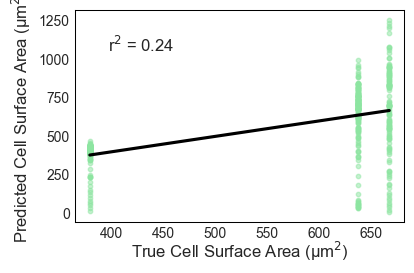

In [336]:
#plot true vs. predicted values as scatterplot and get correlation - for 3D EM cells
#for SA (um^2)

plt.figure() #this creates a new figure on which your plot will appear

#make the tick labels closer to the axes/spine
    #see: https://github.com/matplotlib/matplotlib/issues/17208
mpl.rcParams['xtick.top'] = False
mpl.rcParams['xtick.labeltop'] = False 
mpl.rcParams['xtick.major.pad'] = -2.25
mpl.rcParams['xtick.minor.pad'] = -2.25
mpl.rcParams['ytick.major.pad'] = -2.25
mpl.rcParams['ytick.minor.pad'] = -2.25

#change height and width of dataset
ax = plt.figure(figsize=(4.25,2.75))


ax = sns.set_style("whitegrid")

dataset_to_use = organized_all_cell_in_vitro_projected.loc[organized_all_cell_in_vitro_projected['label'].isin(['cell_1_3DEM','cell_2_3DEM','cell_3_3DEM'])]

#ax = sns.regplot(data=dataset_to_use, x="true_total_SA_um2", y="projected_total_surface_area_um2",line_kws={"color": "black"},scatter_kws={'alpha':0.05},color=sns.color_palette("pastel")[2],ci=None)
ax = sns.regplot(data=dataset_to_use, x="true_total_SA_um2", y="projected_total_surface_area_um2",line_kws={"color": "black"},scatter_kws={'alpha':0.50,'s':10},color=sns.color_palette("pastel")[2],ci=None)

plt.grid(False)

organized_all_cell_in_vitro_projected  = organized_all_cell_in_vitro_projected.fillna(0)

#pearson r and spearman r
#r, p = scipy.stats.pearsonr(x=dataset_to_use['true_total_SA_um2'], y=dataset_to_use['projected_total_surface_area_um2'])
r, p = scipy.stats.spearmanr(a=dataset_to_use['true_total_SA_um2'], b=dataset_to_use['projected_total_surface_area_um2'])

#text_n_r_p = "n = " + str(int(num_np)) + "\n" + "r  = "+str(round(r, 10)) + "\n" + "p = "+str(p)
#text_n_r2_p = "n = " + str(int(num_np)) + "\n"  + "r$^2$ = "+str(round(r**2, 10)) + "\n" + "p = "+str(p)
text_n_r2_p = "n = " + "\n"  + "r$^2$ = "+str(round(r**2, 10)) + "\n" + "p = "+str(p)
#text_r2 = "r$^2$ = "+str(round(r**2, 10))
text_r2 = "r$^2$ = "+str(round(r**2, 2))

print(p)

ax.text(0.1, 0.8, text_r2,transform=ax.transAxes, fontname="Arial", fontsize=12)
#ax.set(xlabel='True Cell Surface Area (µm$^2$)', ylabel='Predicted Cell\nSurface Area (µm$^2$)')
plt.xlabel('True Cell Surface Area (µm$^2$)',fontsize=12, fontname="Arial",)
plt.ylabel('Predicted Cell Surface Area (µm$^2$)',fontsize=12, fontname="Arial",)


plt.xticks(fontsize=10, fontname="Arial",)
plt.yticks(fontsize=10, fontname="Arial",)



#put x-label closer to x-axes ticks. set xlabels first. 
    #see: https://github.com/matplotlib/matplotlib/issues/17208
ax.xaxis.labelpad = -0.75

#render figure text as font rather than path
plt.rcParams['svg.fonttype'] = 'none'



#see for iterating over all spines: https://community.dataquest.io/t/iterate-over-ax-spines-items-and-related-functions/233432/
for key,spine in ax.spines.items():
    spine.set_zorder(0)
    spine.set_visible(True)
    spine.set_color('#000000')
    spine.set_linewidth(0.75)

#export figure as svg for illustrator figure
#plt.savefig("predicted-vs-true_SA_in-vitro-cells_3D-EM_um.svg", format="svg", bbox_inches='tight')
#plt.savefig("predicted-vs-true_SA_in-vitro-cells_3D-EM_um_v2-darker.svg", format="svg", bbox_inches='tight')
plt.savefig("predicted-vs-true_SA_in-vitro-cells_3D-EM_um_v3-darker.svg", format="svg", bbox_inches='tight')




3.749927430452169e-22
0.199242526545806


<Figure size 700x700 with 0 Axes>

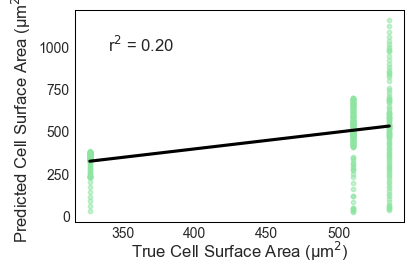

In [337]:
#plot true vs. predicted values as scatterplot and get correlation - for 3D Confocal cells
#for SA (um^2)

plt.figure() #this creates a new figure on which your plot will appear

mpl.rcParams['xtick.top'] = False
mpl.rcParams['xtick.labeltop'] = False 
mpl.rcParams['xtick.major.pad'] = -2.25
mpl.rcParams['xtick.minor.pad'] = -2.25
mpl.rcParams['ytick.major.pad'] = -2.25
mpl.rcParams['ytick.minor.pad'] = -2.25

#change height and width of dataset
ax = plt.figure(figsize=(4.25,2.75))

dataset_to_use = organized_all_cell_in_vitro_projected.loc[organized_all_cell_in_vitro_projected['label'].isin(['cell_1_confocal','cell_2_confocal','cell_3_confocal'])]

#ax = sns.regplot(data=dataset_to_use, x="true_total_SA_um2", y="projected_total_surface_area_um2",line_kws={"color": "black"},scatter_kws={'alpha':0.05},color=sns.color_palette("pastel")[2],ci=None)
ax = sns.regplot(data=dataset_to_use, x="true_total_SA_um2", y="projected_total_surface_area_um2",line_kws={"color": "black"},scatter_kws={'alpha':0.50,'s':10},color=sns.color_palette("pastel")[2],ci=None)
plt.grid(False)

organized_all_cell_in_vitro_projected  = organized_all_cell_in_vitro_projected.fillna(0)

#pearson r and spearman r
#r, p = scipy.stats.pearsonr(x=dataset_to_use['true_total_SA_um2'], y=dataset_to_use['projected_total_surface_area_um2'])
r, p = scipy.stats.spearmanr(a=dataset_to_use['true_total_SA_um2'], b=dataset_to_use['projected_total_surface_area_um2'])

#text_n_r_p = "n = " + str(int(num_np)) + "\n" + "r  = "+str(round(r, 10)) + "\n" + "p = "+str(p)
#text_n_r2_p = "n = " + str(int(num_np)) + "\n"  + "r$^2$ = "+str(round(r**2, 10)) + "\n" + "p = "+str(p)
text_n_r2_p = "n = " + "\n"  + "r$^2$ = "+str(round(r**2, 10)) + "\n" + "p = "+str(p)
#text_r2 = "r$^2$ = "+str(round(r**2, 10))
#text_r2 = "r$^2$ = "+str(round(r**2, 2))

text_r2 = "r$^2$ = "+'{:.2f}'.format(round(r**2, 2)) #do formatting to show 2 digits since it ends in 0

print(p)
print(r**2)

ax.text(0.1, 0.8, text_r2,transform=ax.transAxes, fontname="Arial", fontsize=12)
#ax.set(xlabel='True Cell Surface Area (µm$^2$)', ylabel='Predicted Cell\nSurface Area (µm$^2$)')
plt.xlabel('True Cell Surface Area (µm$^2$)',fontsize=12, fontname="Arial")#,labelpad=-1.25)
plt.ylabel('Predicted Cell Surface Area (µm$^2$)',fontsize=12, fontname="Arial",)


plt.xticks(fontsize=10, fontname="Arial",)
plt.yticks(fontsize=10, fontname="Arial",)

#put x-label closer to x-axes ticks. set xlabels first. 
    #see: https://github.com/matplotlib/matplotlib/issues/17208
ax.xaxis.labelpad = -0.75


#ax.set_xticks([1e2, 1e3, 1e4])
#ax.set_xticks(np.arange(350, 750, 50))
#ax.set_yticks(np.arange(0, 1600, 200))


#set x and y limits to not span whole width so there is space for scale
#get default  xlim and ylim values to keep consistent between figures
#current_xlim_min, current_xlim_max = ax.get_xlim()
#current_ylim_min, current_ylim_max = ax.get_ylim()
#print(current_xlim_min, current_xlim_max)
#plt.xlim(current_xlim_min, 720) 
#plt.ylim(current_ylim_min, 1450)



#render figure text as font rather than path
plt.rcParams['svg.fonttype'] = 'none'



#see for iterating over all spines: https://community.dataquest.io/t/iterate-over-ax-spines-items-and-related-functions/233432/
for key,spine in ax.spines.items():
    spine.set_zorder(0)
    spine.set_visible(True)
    spine.set_color('#000000')
    spine.set_linewidth(0.75)

#export figure as svg for illustrator figure
#plt.savefig("predicted-vs-true_SA_in-vitro-cells_3D-confocal_um.svg", format="svg", bbox_inches='tight')
#plt.savefig("predicted-vs-true_SA_in-vitro-cells_3D-confocal_um_v2-darker.svg", format="svg", bbox_inches='tight')
plt.savefig("predicted-vs-true_SA_in-vitro-cells_3D-confocal_um_v3-darker.svg", format="svg", bbox_inches='tight')



In [250]:
#mpl.rcParams.keys()

1.2719085169964038e-30
0.25597765191158933


<Figure size 700x700 with 0 Axes>

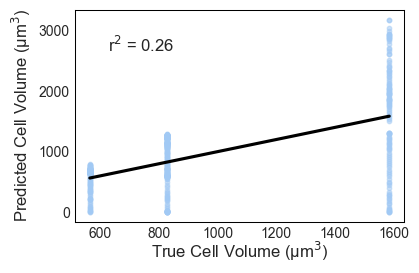

In [338]:
#plot true vs. predicted values as scatterplot and get correlation - for 3D EM cells
#for volume (um^3)

plt.figure() #this creates a new figure on which your plot will appear

#make the tick labels closer to the axes/spine
    #see: https://github.com/matplotlib/matplotlib/issues/17208
mpl.rcParams['xtick.top'] = False
mpl.rcParams['xtick.labeltop'] = False 
mpl.rcParams['xtick.major.pad'] = -2.25
mpl.rcParams['xtick.minor.pad'] = -2.25
mpl.rcParams['ytick.major.pad'] = -2.25
mpl.rcParams['ytick.minor.pad'] = -2.25

#change height and width of dataset
ax = plt.figure(figsize=(4.25,2.75))

ax = sns.set_style("whitegrid")

dataset_to_use = organized_all_cell_in_vitro_projected.loc[organized_all_cell_in_vitro_projected['label'].isin(['cell_1_3DEM','cell_2_3DEM','cell_3_3DEM'])]

#ax = sns.regplot(data=dataset_to_use, x="true_total_vol_um3", y="projected_total_volume_um3",line_kws={"color": "black"},scatter_kws={'alpha':0.05},color=sns.color_palette("pastel")[0],ci=None)
ax = sns.regplot(data=dataset_to_use, x="true_total_vol_um3", y="projected_total_volume_um3",line_kws={"color": "black"},scatter_kws={'alpha':0.50,'s':10},color=sns.color_palette("pastel")[0],ci=None)
plt.grid(False)

organized_all_cell_in_vitro_projected  = organized_all_cell_in_vitro_projected.fillna(0)

#pearson r and spearman r
#r, p = scipy.stats.pearsonr(x=dataset_to_use['true_total_vol_um3'], y=dataset_to_use['projected_total_volume_um3'])
r, p = scipy.stats.spearmanr(a=dataset_to_use['true_total_vol_um3'], b=dataset_to_use['projected_total_volume_um3'])

#text_n_r_p = "n = " + str(int(num_np)) + "\n" + "r  = "+str(round(r, 10)) + "\n" + "p = "+str(p)
#text_n_r2_p = "n = " + str(int(num_np)) + "\n"  + "r$^2$ = "+str(round(r**2, 10)) + "\n" + "p = "+str(p)
text_n_r2_p = "n = " + "\n"  + "r$^2$ = "+str(round(r**2, 10)) + "\n" + "p = "+str(p)
#text_r2 = "r$^2$ = "+str(round(r**2, 10))
text_r2 = "r$^2$ = "+'{:.2f}'.format(round(r**2, 2)) #do formatting to show 2 digits since it ends in 0

print(p)
print(r**2)

ax.text(0.1, 0.8, text_r2,transform=ax.transAxes, fontname="Arial", fontsize=12)
#ax.set(xlabel='True Cell Volume (µm$^3$)', ylabel='Predicted Cell Volume (µm$^3$)')
plt.xlabel('True Cell Volume (µm$^3$)',fontsize=12, fontname="Arial",)
plt.ylabel('Predicted Cell Volume (µm$^3$)',fontsize=12, fontname="Arial",)

plt.xticks(fontsize=10, fontname="Arial",)
plt.yticks(fontsize=10, fontname="Arial",)

#put x-label closer to x-axes ticks. set xlabels first. 
    #see: https://github.com/matplotlib/matplotlib/issues/17208
ax.xaxis.labelpad = -0.75

#render figure text as font rather than path
plt.rcParams['svg.fonttype'] = 'none'

#see for iterating over all spines: https://community.dataquest.io/t/iterate-over-ax-spines-items-and-related-functions/233432/
for key,spine in ax.spines.items():
    spine.set_zorder(0)
    spine.set_visible(True)
    spine.set_color('#000000')
    spine.set_linewidth(0.75)

#export figure as svg for illustrator figure
#plt.savefig("predicted-vs-true_volume_in-vitro-cells_3D-EM_um.svg", format="svg", bbox_inches='tight')
#plt.savefig("predicted-vs-true_volume_in-vitro-cells_3D-EM_um_v2-darker.svg", format="svg", bbox_inches='tight')
plt.savefig("predicted-vs-true_volume_in-vitro-cells_3D-EM_um_v3-darker.svg", format="svg", bbox_inches='tight')




5.476598395919333e-29


<Figure size 700x700 with 0 Axes>

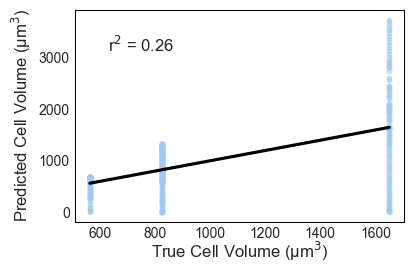

In [339]:
#plot true vs. predicted values as scatterplot and get correlation - for 3D Confocal cells
#for volume (um^3)

plt.figure() #this creates a new figure on which your plot will appear

#make the tick labels closer to the axes/spine
    #see: https://github.com/matplotlib/matplotlib/issues/17208
mpl.rcParams['xtick.top'] = False
mpl.rcParams['xtick.labeltop'] = False 
mpl.rcParams['xtick.major.pad'] = -2.25
mpl.rcParams['xtick.minor.pad'] = -2.25
mpl.rcParams['ytick.major.pad'] = -2.25
mpl.rcParams['ytick.minor.pad'] = -2.25

#change height and width of dataset
ax = plt.figure(figsize=(4.25,2.75))

ax = sns.set_style("whitegrid")

dataset_to_use = organized_all_cell_in_vitro_projected.loc[organized_all_cell_in_vitro_projected['label'].isin(['cell_1_confocal','cell_2_confocal','cell_3_confocal'])]

#ax = sns.regplot(data=dataset_to_use, x="true_total_vol_um3", y="projected_total_volume_um3",line_kws={"color": "black"},scatter_kws={'alpha':0.05},color=sns.color_palette("pastel")[0],ci=None)
ax = sns.regplot(data=dataset_to_use, x="true_total_vol_um3", y="projected_total_volume_um3",line_kws={"color": "black"},scatter_kws={'alpha':0.50,'s':10},color=sns.color_palette("pastel")[0],ci=None)
plt.grid(False)

organized_all_cell_in_vitro_projected  = organized_all_cell_in_vitro_projected.fillna(0)

#pearson r and spearman r
#r, p = scipy.stats.pearsonr(x=dataset_to_use['true_total_vol_um3'], y=dataset_to_use['projected_total_volume_um3'])
r, p = scipy.stats.spearmanr(a=dataset_to_use['true_total_vol_um3'], b=dataset_to_use['projected_total_volume_um3'])

#text_n_r_p = "n = " + str(int(num_np)) + "\n" + "r  = "+str(round(r, 10)) + "\n" + "p = "+str(p)
#text_n_r2_p = "n = " + str(int(num_np)) + "\n"  + "r$^2$ = "+str(round(r**2, 10)) + "\n" + "p = "+str(p)
text_n_r2_p = "n = " + "\n"  + "r$^2$ = "+str(round(r**2, 10)) + "\n" + "p = "+str(p)
#text_r2 = "r$^2$ = "+str(round(r**2, 10))
text_r2 = "r$^2$ = "+'{:.2f}'.format(round(r**2, 2)) #do formatting to show 2 digits since it ends in 0

print(p)

ax.text(0.1, 0.8, text_r2,transform=ax.transAxes, fontname="Arial", fontsize=12)
#ax.set(xlabel='True Cell Volume (µm$^3$)', ylabel='Predicted Cell Volume (µm$^3$)')
plt.xlabel('True Cell Volume (µm$^3$)',fontsize=12, fontname="Arial",)
plt.ylabel('Predicted Cell Volume (µm$^3$)',fontsize=12, fontname="Arial",)

plt.xticks(fontsize=10, fontname="Arial",)
plt.yticks(fontsize=10, fontname="Arial",)

plt.xticks(fontsize=10, fontname="Arial",)
plt.yticks(fontsize=10, fontname="Arial",)

#put x-label closer to x-axes ticks. set xlabels first. 
    #see: https://github.com/matplotlib/matplotlib/issues/17208
ax.xaxis.labelpad = -0.75

#render figure text as font rather than path
plt.rcParams['svg.fonttype'] = 'none'

#see for iterating over all spines: https://community.dataquest.io/t/iterate-over-ax-spines-items-and-related-functions/233432/
for key,spine in ax.spines.items():
    spine.set_zorder(0)
    spine.set_visible(True)
    spine.set_color('#000000')
    spine.set_linewidth(0.75)

#export figure as svg for illustrator figure
#plt.savefig("predicted-vs-true_volume_in-vitro-cells_3D-confocal_um.svg", format="svg", bbox_inches='tight')
#plt.savefig("predicted-vs-true_volume_in-vitro-cells_3D-confocal_um_v2-darker.svg", format="svg", bbox_inches='tight')
plt.savefig("predicted-vs-true_volume_in-vitro-cells_3D-confocal_um_v3-darker.svg", format="svg", bbox_inches='tight')




In [248]:
#RSD analysis for 3D confocal in vitro cells
confocal_dataset = organized_all_cell_in_vitro_projected.loc[organized_all_cell_in_vitro_projected['label'].isin(['cell_1_confocal','cell_2_confocal','cell_3_confocal'])]

#RSD for 2D SA confocal
mean_all_2D_cells_SA_confocal = confocal_dataset['projected_total_surface_area_um2'].mean()
std_all_2D_cells_SA_confocal = confocal_dataset['projected_total_surface_area_um2'].std()
rsd_all_2D_cells_SA_confocal = std_all_2D_cells_SA_confocal/mean_all_2D_cells_SA_confocal
print("The RSD for confocal 2D SA (predicted) is: ", rsd_all_2D_cells_SA_confocal*100,"%")

#RSD for 2D Volume confocal 
mean_all_2D_cells_vol_confocal = confocal_dataset['projected_total_volume_um3'].mean()
std_all_2D_cells_vol_confocal = confocal_dataset['projected_total_volume_um3'].std()
rsd_all_2D_cells_vol_confocal = std_all_2D_cells_vol_confocal/mean_all_2D_cells_vol_confocal
print("The RSD for confocal 2D volume (predicted) is: ", rsd_all_2D_cells_vol_confocal*100,"%")

#RSD for 3D SA confocal
mean_all_3D_cells_SA_confocal = confocal_dataset['true_total_SA_um2'].mean()
std_all_3D_cells_SA_confocal = confocal_dataset['true_total_SA_um2'].std()
rsd_all_3D_cells_SA_confocal = std_all_3D_cells_SA_confocal/mean_all_3D_cells_SA_confocal
print("The RSD for confocal 3D SA (true) is: ", rsd_all_3D_cells_SA_confocal*100,"%")

#RSD for 3D Volume confocal
mean_all_3D_cells_vol_confocal = confocal_dataset['true_total_vol_um3'].mean()
std_all_3D_cells_vol_confocal = confocal_dataset['true_total_vol_um3'].std()
rsd_all_3D_cells_vol_confocal = std_all_3D_cells_vol_confocal/mean_all_3D_cells_vol_confocal
print("The RSD for confocal 3D volume (true) is: ", rsd_all_3D_cells_vol_confocal*100,"%")



The RSD for confocal 2D SA (predicted) is:  41.3134253116897 %
The RSD for confocal 2D volume (predicted) is:  74.81384576960542 %
The RSD for confocal 3D SA (true) is:  18.754033339012867 %
The RSD for confocal 3D volume (true) is:  43.36296755326361 %


In [249]:
#RSD analysis for 3D EM in vitro cells
EM_dataset = organized_all_cell_in_vitro_projected.loc[organized_all_cell_in_vitro_projected['label'].isin(['cell_1_3DEM','cell_2_3DEM','cell_3_3DEM'])]

#RSD for 2D SA EM
mean_all_2D_cells_SA_EM = EM_dataset['projected_total_surface_area_um2'].mean()
std_all_2D_cells_SA_EM = EM_dataset['projected_total_surface_area_um2'].std()
rsd_all_2D_cells_SA_EM = std_all_2D_cells_SA_EM/mean_all_2D_cells_SA_EM
print("The RSD for EM 2D SA (predicted) is: ", rsd_all_2D_cells_SA_EM*100,"%")

#RSD for 2D Volume EM
mean_all_2D_cells_vol_EM = EM_dataset['projected_total_volume_um3'].mean()
std_all_2D_cells_vol_EM = EM_dataset['projected_total_volume_um3'].std()
rsd_all_2D_cells_vol_EM = std_all_2D_cells_vol_EM/mean_all_2D_cells_vol_EM
print("The RSD for EM 2D volume (predicted) is: ", rsd_all_2D_cells_vol_EM*100,"%")

#RSD for 3D SA EM
mean_all_3D_cells_SA_EM = EM_dataset['true_total_SA_um2'].mean()
std_all_3D_cells_SA_EM = EM_dataset['true_total_SA_um2'].std()
rsd_all_3D_cells_SA_EM = std_all_3D_cells_SA_EM/mean_all_3D_cells_SA_EM
print("The RSD for EM 3D SA (true) is: ", rsd_all_3D_cells_SA_EM*100,"%")

#RSD for 3D Volume EM
mean_all_3D_cells_vol_EM = EM_dataset['true_total_vol_um3'].mean()
std_all_3D_cells_vol_EM = EM_dataset['true_total_vol_um3'].std()
rsd_all_3D_cells_vol_EM = std_all_3D_cells_vol_EM/mean_all_3D_cells_vol_EM
print("The RSD for EM 3D volume (true) is: ", rsd_all_3D_cells_vol_EM*100,"%")




The RSD for EM 2D SA (predicted) is:  43.0937526971995 %
The RSD for EM 2D volume (predicted) is:  71.001730786093 %
The RSD for EM 3D SA (true) is:  21.726003810929186 %
The RSD for EM 3D volume (true) is:  42.003974653914625 %
